## Downloading Dataset

In [ ]:
!mkdir dataset
!unzip -q Dataset -d dataset

In [ ]:
!cd dataset/3DEP && ls -1 | wc -l
!cd dataset/GLO && ls -1 | wc -l
!cd dataset/GLO_INTERP && ls -1 | wc -l

10393
10393
10393


# Init

## Libraries initialization

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


In [ ]:
!pip install rasterio

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import math
import cv2
import rasterio
from rasterio import plot
import tensorflow as tf
import matplotlib.pyplot as plt
import requests
import tqdm
import os
import shutil
import re
import time
import logging
import pandas as pd

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)])
  except RuntimeError as e:
    print(e)

##Constants

In [ ]:
GLO_DIR = "GLO/"
DEP_DIR = "3DEP/"
DEP_NODATA = -1000000000.0
WSF_DIR = "WSF/"
OSM_DIR = "OSM/"
GLO_INTERP_DIR = "GLO_INTERP/"
GLO_REMOVED_BUILDINGS = "GLO_REMOVED_BUILDINGS/"

# SRGAN Initialization and Training

## SR-GAN

### Model

In [ ]:
channels = 32 # @param {type:"integer"}
res_blocks = 5 #@param {type:"integer"}
def residual_block_gen(ch=64,k_s=3,st=1):
  model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
  ])
  return model

def Upsample_block(x, ch=576, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st), padding='same')(x)
    x = tf.nn.depth_to_space(x, 3) # Subpixel pixelshuffler
    x = tf.keras.layers.LeakyReLU()(x)
    return x

input_lr=tf.keras.layers.Input(shape=(108, 108, 1))
input_conv=tf.keras.layers.Conv2D(channels,9,padding='same')(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

SRRes=input_conv
for x in range(res_blocks):
  res_output=residual_block_gen(ch=channels)(SRRes)
  SRRes=tf.keras.layers.Add()([SRRes,res_output])

SRRes=tf.keras.layers.Conv2D(channels,9,padding='same')(SRRes)
SRRes=tf.keras.layers.BatchNormalization()(SRRes)

SRRes=tf.keras.layers.Add()([SRRes,input_conv])

SRRes=Upsample_block(SRRes, ch=channels*9)
#SRRes=Upsample_block(SRRes)

output_sr=tf.keras.layers.Conv2D(1,9,activation='tanh',padding='same')(SRRes)

SRResnet=tf.keras.models.Model(input_lr,output_sr)

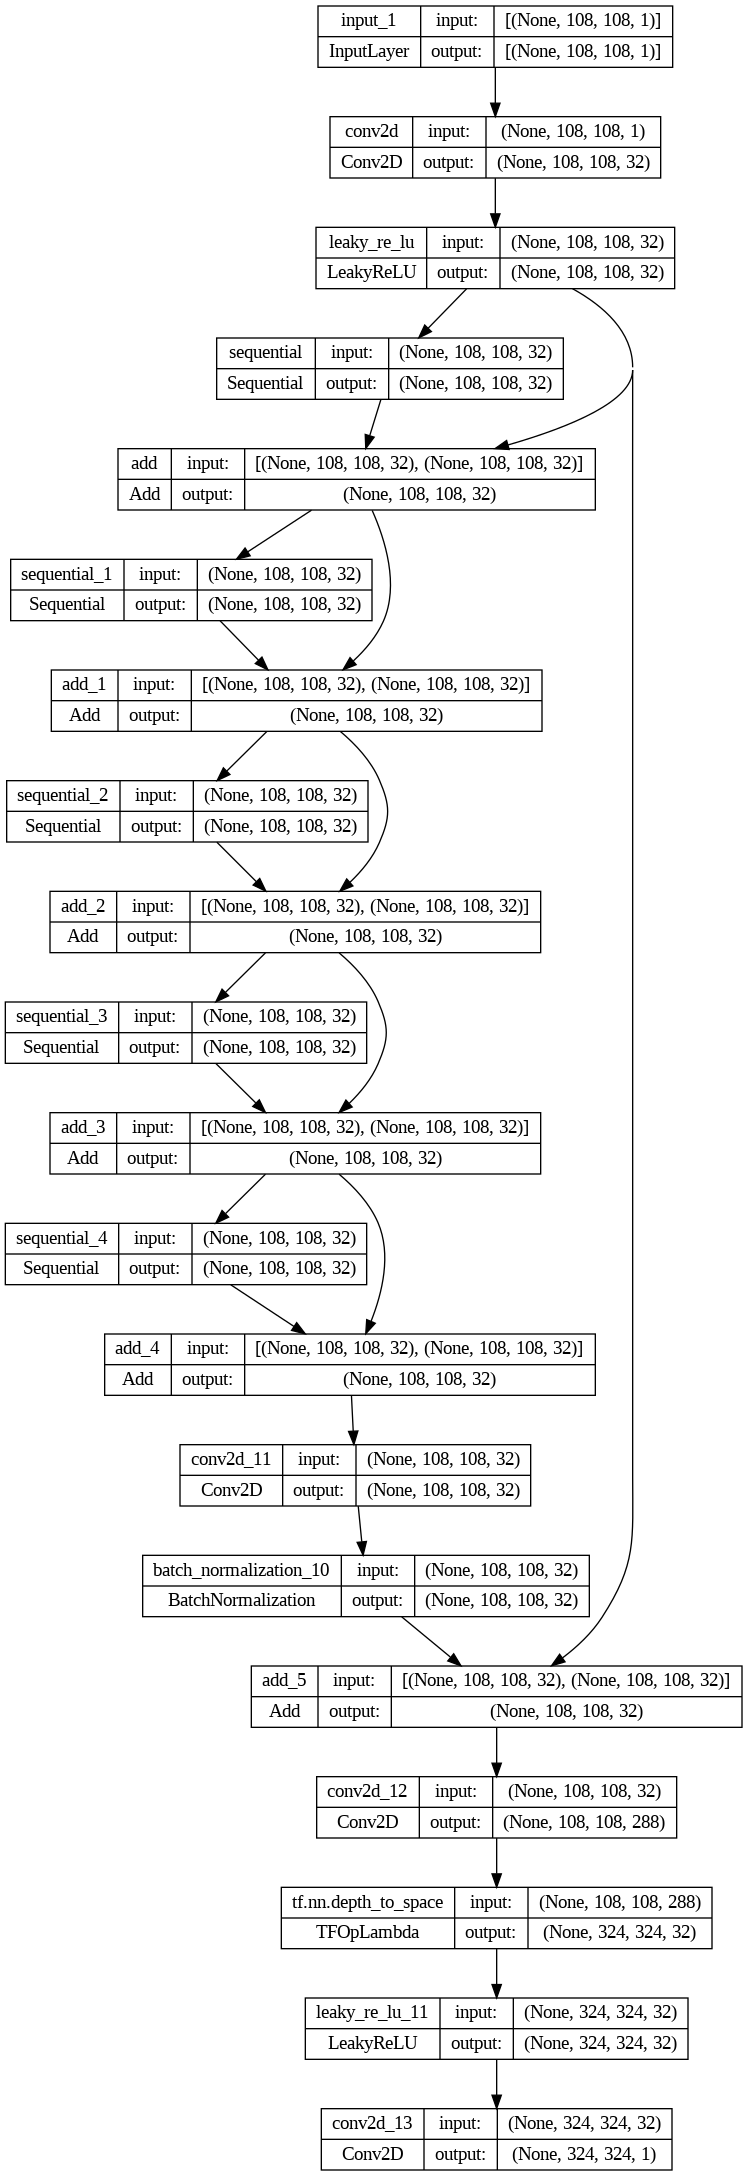

In [ ]:
tf.keras.utils.plot_model(SRResnet,show_shapes=True)

In [ ]:
def residual_block_disc(ch=64,k_s=3,st=1):
  model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
  ])
  return model

input_lr=tf.keras.layers.Input(shape=(324,324,1))
input_conv=tf.keras.layers.Conv2D(channels,3,padding='same')(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

channel_nums=[32,96,96,288,288,864,864]
stride_sizes=[3,1,3,1,3,1,3]

disc=input_conv
for x in range(len(stride_sizes)):
  disc=residual_block_disc(ch=channel_nums[x],st=stride_sizes[x])(disc)

disc=tf.keras.layers.Flatten()(disc)

disc=tf.keras.layers.Dense(972)(disc)
disc=tf.keras.layers.LeakyReLU()(disc)

disc_output=tf.keras.layers.Dense(1,activation='sigmoid')(disc)

discriminator=tf.keras.models.Model(input_lr,disc_output)

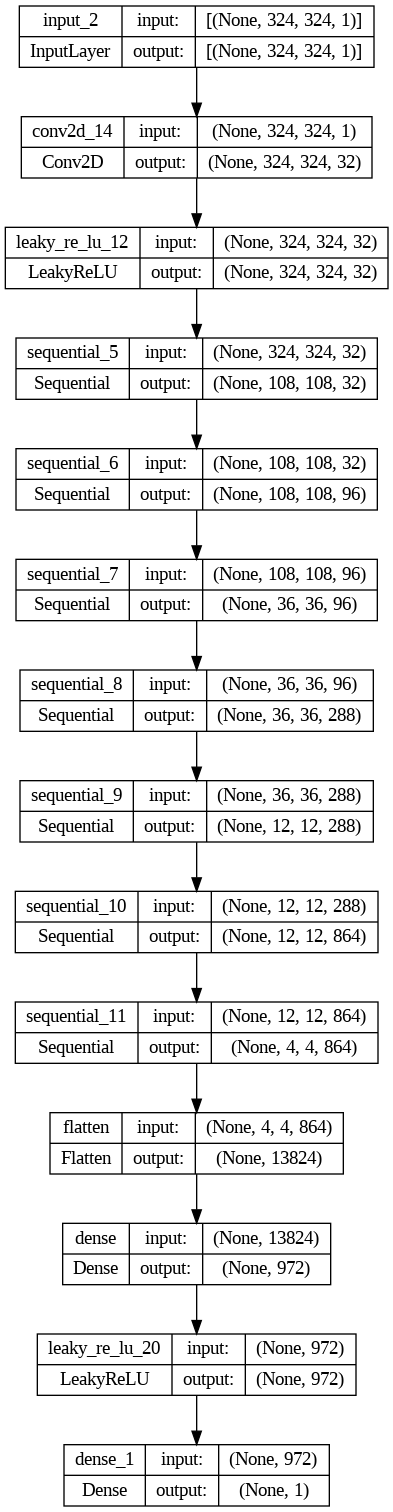

In [ ]:
tf.keras.utils.plot_model(discriminator,show_shapes=True)

### Loss and training func

In [ ]:
def PSNR(y_true,y_pred):
  mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
  return 20 * log10(1 / (mse ** 0.5))

def log10(x):
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

def pixel_MSE(y_true,y_pred):
  return tf.reduce_mean( (y_true - y_pred) ** 2 )

In [ ]:
VGG19=tf.keras.applications.VGG19(weights='imagenet',include_top=False,input_shape=(324,324,3))
VGG19.layers

In [ ]:
VGG19=tf.keras.applications.VGG19(weights='imagenet',include_top=False,input_shape=(324,324,3))

VGG_i,VGG_j=2,2
def VGG_loss(y_hr,y_sr,i_m=2,j_m=2):
  i,j=0,0
  accumulated_loss=0.0
  for l in VGG19.layers:
    cl_name=l.__class__.__name__
    if cl_name=='Conv2D':
      j+=1
    if cl_name=='MaxPooling2D':
      i+=1
      j=0
    if i==i_m and j==j_m:
      break

    y_hr=l(y_hr)
    y_sr=l(y_sr)
    if cl_name=='Conv2D':
      accumulated_loss+=tf.reduce_mean((y_hr-y_sr)**2) * 0.006

  return accumulated_loss
def VGG_loss_intuitive(y_true,y_pred):
  accumulated_loss=0.0
  for l in VGG19.layers:
    y_true=l(y_true)
    y_pred=l(y_pred)
    accumulated_loss+=tf.reduce_mean((y_true-y_pred)**2) * 0.006
  return accumulated_loss

In [ ]:
generator_optimizer=tf.keras.optimizers.SGD(0.0001)
discriminator_optimizer=tf.keras.optimizers.SGD(0.0001)

adv_ratio=0.001
evaluate=['PSNR']

loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(tf.concat((y_hr, y_hr, y_hr), axis=3),tf.concat((y_sr, y_sr, y_sr), axis=3),i_m=5,j_m=4),True

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

@tf.function()
def train_step(data,loss_func=pixel_MSE,adv_learning=True,evaluate=['PSNR'],adv_ratio=0.001):
  logs={}
  gen_loss,disc_loss=0,0

  low_resolution,high_resolution=data
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    super_resolution = SRResnet(low_resolution, training=True)
    gen_loss=loss_func(high_resolution,super_resolution)

    logs['reconstruction']=gen_loss

    if adv_learning:
      real_output = discriminator(high_resolution, training=True)
      fake_output = discriminator(super_resolution, training=True)

      adv_loss_g = generator_loss(fake_output) * adv_ratio
      gen_loss += adv_loss_g

      disc_loss = discriminator_loss(real_output, fake_output)

      logs['adv_g']=adv_loss_g
      logs['adv_d']=disc_loss

  gradients_of_generator = gen_tape.gradient(gen_loss, SRResnet.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, SRResnet.trainable_variables))

  if adv_learning:
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  for x in evaluate:
    if x=='PSNR':
      logs[x]=PSNR(high_resolution,super_resolution)

  return logs

## Read CSV

In [ ]:
df = pd.read_csv("dataset/Data.csv", index_col=0)
df.head()

Suffix   3DEP Max   3DEP Min    GLO Max    GLO Min  Has WSF  \
0  001_001.tif  333.07187  285.80054  347.92575  291.11282     True   
1  001_002.tif  382.05167  297.68195  391.85297  303.43335     True   
2  001_003.tif  446.16312  306.22708  445.34015  306.26096     True   
3  001_004.tif  357.02700  291.86575  362.26877  292.31400     True   
4  001_005.tif  370.27933  295.19278  378.52472  294.93494     True   

   WSF Density  WSF Max  WSF Min  Has OSM  OSM Density  OSM Max  OSM Min  
0     0.004715    255.0      0.0    False          0.0      0.0      0.0  
1     0.010031    255.0      0.0    False          0.0      0.0      0.0  
2     0.002315    255.0      0.0    False          0.0      0.0      0.0  
3     0.009002    255.0      0.0    False          0.0      0.0      0.0  
4     0.001886    255.0      0.0    False          0.0      0.0      0.0

In [ ]:
df_no_buildings = df# df.drop(df[df["Has OSM"]].index)
print(df_no_buildings.describe())
df_no_buildings.drop(["WSF Density", "OSM Density"], axis =1).describe()

           3DEP Max      3DEP Min       GLO Max       GLO Min   WSF Density  \
count  10393.000000  10393.000000  10393.000000  10393.000000  10393.000000   
mean     142.969529     95.306471    153.323731     98.559731      0.049597   
std      104.167529     76.914536    102.214228     78.015506      0.085141   
min       -0.615000    -61.807200      0.000000    -62.500000      0.000000   
25%       79.147675     32.100000     87.397730     34.880764      0.004201   
50%      138.167000     94.200560    148.685750     97.982956      0.013632   
75%      176.786990    133.735000    185.826660    136.500000      0.042267   
max      749.290000    535.589500    752.437130    558.904200      0.696416   

            WSF Max  WSF Min   OSM Density       OSM Max  OSM Min  
count  10393.000000  10393.0  10393.000000  10393.000000  10393.0  
mean     238.929087      0.0      0.016040      0.483306      0.0  
std       61.969171      0.0      0.035743      0.499745      0.0  
min        0.000

3DEP Max      3DEP Min       GLO Max       GLO Min       WSF Max  \
count  10393.000000  10393.000000  10393.000000  10393.000000  10393.000000   
mean     142.969529     95.306471    153.323731     98.559731    238.929087   
std      104.167529     76.914536    102.214228     78.015506     61.969171   
min       -0.615000    -61.807200      0.000000    -62.500000      0.000000   
25%       79.147675     32.100000     87.397730     34.880764    255.000000   
50%      138.167000     94.200560    148.685750     97.982956    255.000000   
75%      176.786990    133.735000    185.826660    136.500000    255.000000   
max      749.290000    535.589500    752.437130    558.904200    255.000000   

       WSF Min       OSM Max  OSM Min  
count  10393.0  10393.000000  10393.0  
mean       0.0      0.483306      0.0  
std        0.0      0.499745      0.0  
min        0.0      0.000000      0.0  
25%        0.0      0.000000      0.0  
50%        0.0      0.000000      0.0  
75%        0.0      1.000000      0.0  
max        0.0      1.000000      0.0

In [ ]:
suffixes = df_no_buildings["Suffix"].values
no_buildings_dataset_suffixes = tf.data.Dataset.from_tensor_slices(
    (df_no_buildings["Suffix"].values,
     df_no_buildings["3DEP Max"].values,
     df_no_buildings["3DEP Min"].values))
shuffled_no_buildings_dataset_suffixes = no_buildings_dataset_suffixes.shuffle(buffer_size=no_buildings_dataset_suffixes.cardinality())
for x in shuffled_no_buildings_dataset_suffixes.take(1):
  print(x[0].numpy().decode())
  print(x[1])
  print(x[2])

052_038.tif
tf.Tensor(375.76596, shape=(), dtype=float64)
tf.Tensor(254.07602, shape=(), dtype=float64)


## Util functions

In [ ]:
def read_image(path):
  tmp = tiff.imread(path)
  tmp = np.array([tmp])
  return tf.convert_to_tensor(tmp.reshape(tmp.shape[1], tmp.shape[2], tmp.shape[0]))

def read_images(suffix, dep_max, dep_min):
  dep = read_image("dataset/" + DEP_DIR + suffix.decode())
  #glo = read_image("dataset/" + GLO_INTERP_DIR + suffix.decode())
  return (dep, tf.cast(dep_max, tf.float32), tf.cast(dep_min,tf.float32))

@tf.function
def normalize_pixel(pixel, max, min):
  return (pixel - min)/(max - min)

@tf.function
def normalize_images(dep, max, min):
  return (normalize_pixel(dep, max, min), max, min)

@tf.function
def unnormalize_pixel(pixel, max, min):
  return pixel*(max - min) + min

## Read Dataset

In [ ]:
no_buildings_dataset = shuffled_no_buildings_dataset_suffixes.map(lambda suffix, dep_max, dep_min : tf.numpy_function(read_images, [suffix, dep_max, dep_min], Tout=[tf.float32, tf.float32, tf.float32])).map(normalize_images)
no_buildings_dataset

<_MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>

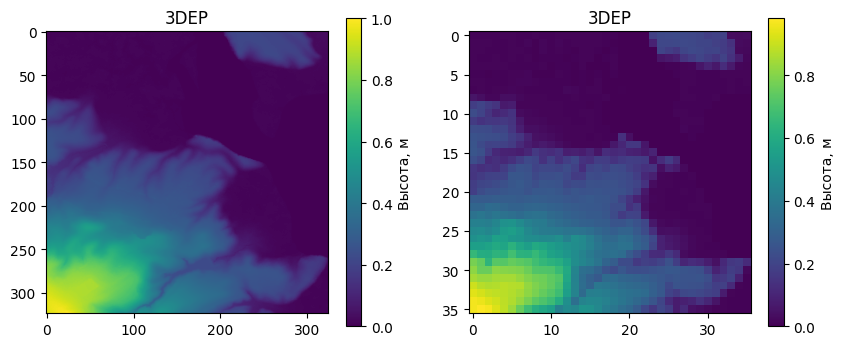

tf.Tensor(45.969135, shape=(), dtype=float32) tf.Tensor(-0.3, shape=(), dtype=float32)
(324, 324, 1)
(324, 324, 3)


In [ ]:
for x in no_buildings_dataset.take(1):
  fig, ax = plt.subplots(figsize=(10, 4))
  ax.remove()
  ax = plt.subplot(1, 2, 1)
  plt.imshow(x[0])
  plt.title("3DEP")
  im = ax.get_images()[0]
  cb = fig.colorbar(im, ax=ax)
  cb.set_label('Высота, м')
  plt.title("3DEP")

  ax = plt.subplot(1, 2, 2)
  plt.imshow(tf.image.resize(x[0],(36, 36)))
  plt.title("3DEP")
  im = ax.get_images()[0]
  cb = fig.colorbar(im, ax=ax)
  cb.set_label('Высота, м')
  plt.title("3DEP")
  plt.show()
  print(x[1], x[2])
  print(x[0].shape)
  print(tf.concat((x[0],x[0],x[0]),axis=2).shape)

## Training

In [ ]:
num_of_data = no_buildings_dataset.cardinality().numpy()
num_of_test_data = round(num_of_data * 0.2)
print(num_of_data, num_of_test_data)
train_data = no_buildings_dataset.skip(num_of_test_data)
test_data = no_buildings_dataset.take(num_of_test_data)

10393 2079


In [ ]:
def build_data(dep, max, min):
  lr=tf.image.resize(dep,(108, 108))
  return (lr, dep)

In [ ]:
SRResnet=tf.keras.models.load_model('SR-generator.keras',compile=False)
discriminator=tf.keras.models.load_model('SR-discriminator.keras',compile=False)

In [ ]:
num_of_epoch = 18 # @param {type:"integer"}
num_in_batch = 16 # @param {type:"integer"}
for x in tqdm.tqdm(range(num_of_epoch)):
  train_dataset_mapped = train_data.map(lambda dep, dep_max, dep_min : tf.numpy_function(build_data, [dep, dep_max, dep_min], Tout=[tf.float32, tf.float32])).batch(num_in_batch)
  val_dataset_mapped = test_data.map(lambda dep, dep_max, dep_min : tf.numpy_function(build_data, [dep, dep_max, dep_min], Tout=[tf.float32, tf.float32])).batch(num_in_batch)

  for image_batch in tqdm.tqdm(train_dataset_mapped, position=0, leave=True):
    logs=train_step(image_batch,loss_func,adv_learning,evaluate,adv_ratio)
    for k in logs.keys():
      print(k,':',logs[k].numpy(),end='  ')
    print()

  0%|          | 1/520 [00:05<46:43,  5.40s/it]

reconstruction : 0.10806663  adv_g : 0.0056298715  adv_d : 0.016634032  PSNR : 20.452179  


  0%|          | 2/520 [00:05<20:56,  2.43s/it]

reconstruction : 0.13759156  adv_g : 0.006105045  adv_d : 0.016659467  PSNR : 22.898716  


  1%|          | 3/520 [00:06<12:44,  1.48s/it]

reconstruction : 0.13548473  adv_g : 0.0065457434  adv_d : 0.005080672  PSNR : 21.870079  


  1%|          | 4/520 [00:06<08:53,  1.03s/it]

reconstruction : 0.07203731  adv_g : 0.005768022  adv_d : 0.0063608363  PSNR : 24.03937  


  1%|          | 5/520 [00:06<06:44,  1.27it/s]

reconstruction : 0.07736267  adv_g : 0.005938457  adv_d : 0.0078737  PSNR : 25.367443  


  1%|          | 6/520 [00:07<05:26,  1.57it/s]

reconstruction : 0.101145834  adv_g : 0.006156078  adv_d : 0.008422531  PSNR : 22.202417  


  1%|▏         | 7/520 [00:07<04:37,  1.85it/s]

reconstruction : 0.08267879  adv_g : 0.0062051928  adv_d : 0.008916739  PSNR : 24.881016  


  2%|▏         | 8/520 [00:07<04:06,  2.08it/s]

reconstruction : 0.08542679  adv_g : 0.0063235173  adv_d : 0.004923961  PSNR : 24.791763  


  2%|▏         | 9/520 [00:08<03:44,  2.28it/s]

reconstruction : 0.10396998  adv_g : 0.006608107  adv_d : 0.006525618  PSNR : 24.152744  


  2%|▏         | 10/520 [00:08<03:29,  2.43it/s]

reconstruction : 0.10945146  adv_g : 0.0061410028  adv_d : 0.0048595844  PSNR : 20.563005  


  2%|▏         | 11/520 [00:08<03:19,  2.55it/s]

reconstruction : 0.07135871  adv_g : 0.006324502  adv_d : 0.008453479  PSNR : 23.697506  


  2%|▏         | 12/520 [00:09<03:12,  2.64it/s]

reconstruction : 0.09613538  adv_g : 0.006805546  adv_d : 0.0069576306  PSNR : 24.46165  


  2%|▎         | 13/520 [00:09<03:06,  2.71it/s]

reconstruction : 0.096883394  adv_g : 0.0060231443  adv_d : 0.0067316713  PSNR : 21.073702  


  3%|▎         | 14/520 [00:09<03:03,  2.76it/s]

reconstruction : 0.12086253  adv_g : 0.006985152  adv_d : 0.010671179  PSNR : 26.103006  


  3%|▎         | 15/520 [00:10<03:00,  2.80it/s]

reconstruction : 0.12245795  adv_g : 0.0063824435  adv_d : 0.0045805834  PSNR : 22.48148  


  3%|▎         | 16/520 [00:10<02:58,  2.83it/s]

reconstruction : 0.05822605  adv_g : 0.006282471  adv_d : 0.0061099064  PSNR : 23.627974  


  3%|▎         | 17/520 [00:10<02:56,  2.85it/s]

reconstruction : 0.10177226  adv_g : 0.0060032913  adv_d : 0.008158055  PSNR : 26.8766  


  3%|▎         | 18/520 [00:11<02:55,  2.86it/s]

reconstruction : 0.06672582  adv_g : 0.007298489  adv_d : 0.002290199  PSNR : 24.181198  


  4%|▎         | 19/520 [00:11<02:54,  2.87it/s]

reconstruction : 0.099563405  adv_g : 0.006240024  adv_d : 0.020739283  PSNR : 21.313608  


  4%|▍         | 20/520 [00:11<02:53,  2.87it/s]

reconstruction : 0.09151402  adv_g : 0.006597919  adv_d : 0.004321268  PSNR : 26.038725  


  4%|▍         | 21/520 [00:12<02:52,  2.89it/s]

reconstruction : 0.096526965  adv_g : 0.007263634  adv_d : 0.007722844  PSNR : 28.143354  


  4%|▍         | 22/520 [00:12<02:52,  2.89it/s]

reconstruction : 0.13214919  adv_g : 0.0063982895  adv_d : 0.017872177  PSNR : 22.301062  


  4%|▍         | 23/520 [00:13<02:52,  2.89it/s]

reconstruction : 0.06888385  adv_g : 0.0062881415  adv_d : 0.0036766124  PSNR : 20.905375  


  5%|▍         | 24/520 [00:13<02:51,  2.89it/s]

reconstruction : 0.106293  adv_g : 0.0070265257  adv_d : 0.018840455  PSNR : 26.619461  


  5%|▍         | 25/520 [00:13<02:50,  2.90it/s]

reconstruction : 0.088711105  adv_g : 0.006424991  adv_d : 0.0037841804  PSNR : 23.466778  


  5%|▌         | 26/520 [00:14<02:50,  2.89it/s]

reconstruction : 0.09034914  adv_g : 0.0059398664  adv_d : 0.016711734  PSNR : 22.274618  


  5%|▌         | 27/520 [00:14<02:50,  2.89it/s]

reconstruction : 0.12596607  adv_g : 0.006925479  adv_d : 0.014175801  PSNR : 21.77173  


  5%|▌         | 28/520 [00:14<02:50,  2.89it/s]

reconstruction : 0.09657656  adv_g : 0.0062366524  adv_d : 0.007719367  PSNR : 23.230732  


  6%|▌         | 29/520 [00:15<02:50,  2.89it/s]

reconstruction : 0.07821574  adv_g : 0.0065248273  adv_d : 0.0025793822  PSNR : 21.586353  


  6%|▌         | 30/520 [00:15<02:49,  2.90it/s]

reconstruction : 0.072031036  adv_g : 0.0070463843  adv_d : 0.005179337  PSNR : 25.522043  


  6%|▌         | 31/520 [00:15<02:48,  2.90it/s]

reconstruction : 0.08975354  adv_g : 0.0063196747  adv_d : 0.004433399  PSNR : 21.664497  


  6%|▌         | 32/520 [00:16<02:48,  2.89it/s]

reconstruction : 0.08366226  adv_g : 0.0058517163  adv_d : 0.006943791  PSNR : 22.63763  


  6%|▋         | 33/520 [00:16<02:48,  2.88it/s]

reconstruction : 0.10549703  adv_g : 0.006321065  adv_d : 0.006303724  PSNR : 20.608742  


  7%|▋         | 34/520 [00:16<02:48,  2.88it/s]

reconstruction : 0.094657935  adv_g : 0.0059970706  adv_d : 0.011158556  PSNR : 22.568111  


  7%|▋         | 35/520 [00:17<02:47,  2.89it/s]

reconstruction : 0.09933652  adv_g : 0.0068943286  adv_d : 0.008757305  PSNR : 25.95379  


  7%|▋         | 36/520 [00:17<02:47,  2.89it/s]

reconstruction : 0.08726316  adv_g : 0.006026586  adv_d : 0.004773956  PSNR : 23.6294  


  7%|▋         | 37/520 [00:17<02:46,  2.89it/s]

reconstruction : 0.09906616  adv_g : 0.0062876535  adv_d : 0.0047684405  PSNR : 20.718943  


  7%|▋         | 38/520 [00:18<02:47,  2.89it/s]

reconstruction : 0.12733938  adv_g : 0.0069586094  adv_d : 0.010638342  PSNR : 23.03424  


  8%|▊         | 39/520 [00:18<02:46,  2.89it/s]

reconstruction : 0.08777127  adv_g : 0.007114785  adv_d : 0.006743276  PSNR : 24.636444  


  8%|▊         | 40/520 [00:18<02:45,  2.90it/s]

reconstruction : 0.13013375  adv_g : 0.0059194444  adv_d : 0.032841656  PSNR : 23.369848  


  8%|▊         | 41/520 [00:19<02:45,  2.89it/s]

reconstruction : 0.17643622  adv_g : 0.006224364  adv_d : 0.014552619  PSNR : 19.557531  


  8%|▊         | 42/520 [00:19<02:45,  2.88it/s]

reconstruction : 0.13552831  adv_g : 0.006239831  adv_d : 0.0072804177  PSNR : 21.215881  


  8%|▊         | 43/520 [00:19<02:46,  2.87it/s]

reconstruction : 0.086688146  adv_g : 0.0061810175  adv_d : 0.003824697  PSNR : 19.74083  


  8%|▊         | 44/520 [00:20<02:46,  2.86it/s]

reconstruction : 0.07857936  adv_g : 0.0061016707  adv_d : 0.0060254  PSNR : 24.4004  


  9%|▊         | 45/520 [00:20<02:45,  2.87it/s]

reconstruction : 0.1113292  adv_g : 0.0070059043  adv_d : 0.0024731692  PSNR : 18.754879  


  9%|▉         | 46/520 [00:21<02:44,  2.88it/s]

reconstruction : 0.10353239  adv_g : 0.0059693344  adv_d : 0.0049092765  PSNR : 22.320408  


  9%|▉         | 47/520 [00:21<02:44,  2.88it/s]

reconstruction : 0.12049942  adv_g : 0.006619465  adv_d : 0.005032907  PSNR : 19.364105  


  9%|▉         | 48/520 [00:21<02:43,  2.89it/s]

reconstruction : 0.07613881  adv_g : 0.0065984013  adv_d : 0.006224953  PSNR : 24.57128  


  9%|▉         | 49/520 [00:22<02:43,  2.88it/s]

reconstruction : 0.094949074  adv_g : 0.0056587653  adv_d : 0.008848103  PSNR : 21.540487  


 10%|▉         | 50/520 [00:22<02:42,  2.89it/s]

reconstruction : 0.08762185  adv_g : 0.007369165  adv_d : 0.0029180183  PSNR : 22.003325  


 10%|▉         | 51/520 [00:22<02:42,  2.89it/s]

reconstruction : 0.14220512  adv_g : 0.0065501733  adv_d : 0.02604065  PSNR : 21.778608  


 10%|█         | 52/520 [00:23<02:41,  2.89it/s]

reconstruction : 0.11288677  adv_g : 0.006725307  adv_d : 0.008106337  PSNR : 22.624743  


 10%|█         | 53/520 [00:23<02:41,  2.89it/s]

reconstruction : 0.088751934  adv_g : 0.006108411  adv_d : 0.010479807  PSNR : 23.904533  


 10%|█         | 54/520 [00:23<02:41,  2.89it/s]

reconstruction : 0.11770991  adv_g : 0.006420726  adv_d : 0.004208303  PSNR : 22.480038  


 11%|█         | 55/520 [00:24<02:40,  2.89it/s]

reconstruction : 0.09766968  adv_g : 0.0068155965  adv_d : 0.003894255  PSNR : 20.784908  


 11%|█         | 56/520 [00:24<02:39,  2.90it/s]

reconstruction : 0.07739399  adv_g : 0.0061511965  adv_d : 0.005143761  PSNR : 23.284039  


 11%|█         | 57/520 [00:24<02:39,  2.90it/s]

reconstruction : 0.07755198  adv_g : 0.006211398  adv_d : 0.012823788  PSNR : 25.230104  


 11%|█         | 58/520 [00:25<02:39,  2.90it/s]

reconstruction : 0.097079  adv_g : 0.0067851106  adv_d : 0.005543584  PSNR : 26.856194  


 11%|█▏        | 59/520 [00:25<02:40,  2.88it/s]

reconstruction : 0.094888866  adv_g : 0.006244175  adv_d : 0.0055690557  PSNR : 23.877043  


 12%|█▏        | 60/520 [00:25<02:40,  2.86it/s]

reconstruction : 0.09699673  adv_g : 0.0061699557  adv_d : 0.0047859796  PSNR : 18.888962  


 12%|█▏        | 61/520 [00:26<02:40,  2.86it/s]

reconstruction : 0.08312863  adv_g : 0.007864244  adv_d : 0.0028436994  PSNR : 25.341728  


 12%|█▏        | 62/520 [00:26<02:39,  2.87it/s]

reconstruction : 0.08603017  adv_g : 0.006415169  adv_d : 0.0109034795  PSNR : 23.402376  


 12%|█▏        | 63/520 [00:26<02:38,  2.87it/s]

reconstruction : 0.08996243  adv_g : 0.005905729  adv_d : 0.007376603  PSNR : 22.057266  


 12%|█▏        | 64/520 [00:27<02:38,  2.89it/s]

reconstruction : 0.07788178  adv_g : 0.0065600523  adv_d : 0.0154364295  PSNR : 22.08007  


 12%|█▎        | 65/520 [00:27<02:37,  2.88it/s]

reconstruction : 0.08338508  adv_g : 0.0064493334  adv_d : 0.0023574764  PSNR : 21.881271  


 13%|█▎        | 66/520 [00:27<02:37,  2.89it/s]

reconstruction : 0.06790726  adv_g : 0.0064111766  adv_d : 0.012146937  PSNR : 21.85454  


 13%|█▎        | 67/520 [00:28<02:36,  2.89it/s]

reconstruction : 0.06535385  adv_g : 0.0065570194  adv_d : 0.0073608784  PSNR : 24.012402  


 13%|█▎        | 68/520 [00:28<02:36,  2.89it/s]

reconstruction : 0.14363632  adv_g : 0.0070082424  adv_d : 0.013058191  PSNR : 25.455666  


 13%|█▎        | 69/520 [00:28<02:36,  2.89it/s]

reconstruction : 0.10891086  adv_g : 0.006155468  adv_d : 0.008087077  PSNR : 20.79366  


 13%|█▎        | 70/520 [00:29<02:36,  2.87it/s]

reconstruction : 0.10046106  adv_g : 0.006582428  adv_d : 0.0073815826  PSNR : 24.250565  


 14%|█▎        | 71/520 [00:29<02:36,  2.88it/s]

reconstruction : 0.10203145  adv_g : 0.005883317  adv_d : 0.009408223  PSNR : 22.108347  


 14%|█▍        | 72/520 [00:30<02:35,  2.88it/s]

reconstruction : 0.08076378  adv_g : 0.00598832  adv_d : 0.009180814  PSNR : 22.359781  


 14%|█▍        | 73/520 [00:30<02:34,  2.89it/s]

reconstruction : 0.082476005  adv_g : 0.007566782  adv_d : 0.0132234115  PSNR : 25.856115  


 14%|█▍        | 74/520 [00:30<02:35,  2.87it/s]

reconstruction : 0.08584668  adv_g : 0.006129788  adv_d : 0.006758972  PSNR : 25.103565  


 14%|█▍        | 75/520 [00:31<02:34,  2.88it/s]

reconstruction : 0.13007866  adv_g : 0.007274272  adv_d : 0.009142718  PSNR : 24.711945  


 15%|█▍        | 76/520 [00:31<02:34,  2.88it/s]

reconstruction : 0.077279955  adv_g : 0.005921549  adv_d : 0.006030928  PSNR : 21.610502  


 15%|█▍        | 77/520 [00:31<02:33,  2.88it/s]

reconstruction : 0.09689034  adv_g : 0.0067949165  adv_d : 0.0028636102  PSNR : 20.830381  


 15%|█▌        | 78/520 [00:32<02:33,  2.89it/s]

reconstruction : 0.0815169  adv_g : 0.006660235  adv_d : 0.0029220395  PSNR : 24.406963  


 15%|█▌        | 79/520 [00:32<02:32,  2.89it/s]

reconstruction : 0.13401784  adv_g : 0.0058778604  adv_d : 0.016834697  PSNR : 23.715256  


 15%|█▌        | 80/520 [00:32<02:32,  2.89it/s]

reconstruction : 0.0934705  adv_g : 0.006464067  adv_d : 0.0069539174  PSNR : 23.93071  


 16%|█▌        | 81/520 [00:33<02:31,  2.90it/s]

reconstruction : 0.07382286  adv_g : 0.0063584596  adv_d : 0.004236885  PSNR : 21.925556  


 16%|█▌        | 82/520 [00:33<02:32,  2.88it/s]

reconstruction : 0.094282314  adv_g : 0.006869118  adv_d : 0.004038319  PSNR : 25.965815  


 16%|█▌        | 83/520 [00:33<02:32,  2.86it/s]

reconstruction : 0.123903066  adv_g : 0.007507544  adv_d : 0.020885745  PSNR : 24.600021  


 16%|█▌        | 84/520 [00:34<02:32,  2.86it/s]

reconstruction : 0.07727708  adv_g : 0.006059318  adv_d : 0.012314865  PSNR : 21.092354  


 16%|█▋        | 85/520 [00:34<02:32,  2.85it/s]

reconstruction : 0.11251553  adv_g : 0.0066713835  adv_d : 0.010343099  PSNR : 24.454998  


 17%|█▋        | 86/520 [00:34<02:31,  2.87it/s]

reconstruction : 0.10269666  adv_g : 0.0062979716  adv_d : 0.00856111  PSNR : 20.864908  


 17%|█▋        | 87/520 [00:35<02:30,  2.87it/s]

reconstruction : 0.12706465  adv_g : 0.006308822  adv_d : 0.011834016  PSNR : 25.57803  


 17%|█▋        | 88/520 [00:35<02:30,  2.87it/s]

reconstruction : 0.0816918  adv_g : 0.0071942336  adv_d : 0.0057209963  PSNR : 25.871048  


 17%|█▋        | 89/520 [00:35<02:30,  2.86it/s]

reconstruction : 0.08858034  adv_g : 0.0063961707  adv_d : 0.0032047601  PSNR : 20.774921  


 17%|█▋        | 90/520 [00:36<02:30,  2.86it/s]

reconstruction : 0.0808447  adv_g : 0.0067644943  adv_d : 0.0045438623  PSNR : 27.136732  


 18%|█▊        | 91/520 [00:36<02:29,  2.88it/s]

reconstruction : 0.08024362  adv_g : 0.0065253675  adv_d : 0.0043106116  PSNR : 25.508419  


 18%|█▊        | 92/520 [00:36<02:28,  2.88it/s]

reconstruction : 0.10215436  adv_g : 0.006719955  adv_d : 0.004730432  PSNR : 23.984877  


 18%|█▊        | 93/520 [00:37<02:28,  2.87it/s]

reconstruction : 0.09642709  adv_g : 0.0070989076  adv_d : 0.003545348  PSNR : 22.610943  


 18%|█▊        | 94/520 [00:37<02:28,  2.88it/s]

reconstruction : 0.10431459  adv_g : 0.0064907125  adv_d : 0.003385629  PSNR : 21.389935  


 18%|█▊        | 95/520 [00:38<02:27,  2.88it/s]

reconstruction : 0.07690193  adv_g : 0.006678545  adv_d : 0.004711669  PSNR : 25.502827  


 18%|█▊        | 96/520 [00:38<02:27,  2.87it/s]

reconstruction : 0.11042477  adv_g : 0.0059316056  adv_d : 0.00645254  PSNR : 19.882425  


 19%|█▊        | 97/520 [00:38<02:26,  2.88it/s]

reconstruction : 0.09521933  adv_g : 0.0073307985  adv_d : 0.0026875604  PSNR : 22.535522  


 19%|█▉        | 98/520 [00:39<02:26,  2.88it/s]

reconstruction : 0.13667288  adv_g : 0.0062746936  adv_d : 0.01133408  PSNR : 20.854141  


 19%|█▉        | 99/520 [00:39<02:26,  2.88it/s]

reconstruction : 0.118247986  adv_g : 0.0068537286  adv_d : 0.008827897  PSNR : 23.638386  


 19%|█▉        | 100/520 [00:39<02:25,  2.89it/s]

reconstruction : 0.11195655  adv_g : 0.0065486664  adv_d : 0.0066552255  PSNR : 21.577461  


 19%|█▉        | 101/520 [00:40<02:25,  2.87it/s]

reconstruction : 0.07049275  adv_g : 0.006085894  adv_d : 0.0038854415  PSNR : 22.524395  


 20%|█▉        | 102/520 [00:40<02:25,  2.88it/s]

reconstruction : 0.0992314  adv_g : 0.006555935  adv_d : 0.010227372  PSNR : 24.490173  


 20%|█▉        | 103/520 [00:40<02:24,  2.88it/s]

reconstruction : 0.10995386  adv_g : 0.006625087  adv_d : 0.0069123134  PSNR : 22.457714  


 20%|██        | 104/520 [00:41<02:24,  2.87it/s]

reconstruction : 0.053275757  adv_g : 0.006126097  adv_d : 0.009309403  PSNR : 23.250025  


 20%|██        | 105/520 [00:41<02:24,  2.87it/s]

reconstruction : 0.096558236  adv_g : 0.0064996826  adv_d : 0.0046148393  PSNR : 22.58178  


 20%|██        | 106/520 [00:41<02:23,  2.88it/s]

reconstruction : 0.06881274  adv_g : 0.0060723927  adv_d : 0.004499963  PSNR : 25.89436  


 21%|██        | 107/520 [00:42<02:23,  2.87it/s]

reconstruction : 0.141359  adv_g : 0.0066210455  adv_d : 0.0071802326  PSNR : 23.715343  


 21%|██        | 108/520 [00:42<02:23,  2.87it/s]

reconstruction : 0.11855967  adv_g : 0.0060258913  adv_d : 0.011842047  PSNR : 23.60151  


 21%|██        | 109/520 [00:42<02:22,  2.88it/s]

reconstruction : 0.10939765  adv_g : 0.0073753586  adv_d : 0.003866995  PSNR : 20.7394  


 21%|██        | 110/520 [00:43<02:21,  2.89it/s]

reconstruction : 0.09287916  adv_g : 0.006202429  adv_d : 0.0069737085  PSNR : 19.66755  


 21%|██▏       | 111/520 [00:43<02:21,  2.88it/s]

reconstruction : 0.078251034  adv_g : 0.006479323  adv_d : 0.0061774785  PSNR : 26.416279  


 22%|██▏       | 112/520 [00:43<02:21,  2.89it/s]

reconstruction : 0.13496728  adv_g : 0.006232071  adv_d : 0.011734916  PSNR : 21.083796  


 22%|██▏       | 113/520 [00:44<02:21,  2.88it/s]

reconstruction : 0.090954974  adv_g : 0.0063869045  adv_d : 0.0060471753  PSNR : 21.275917  


 22%|██▏       | 114/520 [00:44<02:20,  2.89it/s]

reconstruction : 0.09756496  adv_g : 0.006664741  adv_d : 0.003684614  PSNR : 21.92983  


 22%|██▏       | 115/520 [00:44<02:21,  2.87it/s]

reconstruction : 0.13696815  adv_g : 0.006381685  adv_d : 0.016326593  PSNR : 25.376804  


 22%|██▏       | 116/520 [00:45<02:20,  2.88it/s]

reconstruction : 0.10019809  adv_g : 0.006421347  adv_d : 0.0040675304  PSNR : 21.018196  


 22%|██▎       | 117/520 [00:45<02:19,  2.89it/s]

reconstruction : 0.11176102  adv_g : 0.006636116  adv_d : 0.017956989  PSNR : 20.803392  


 23%|██▎       | 118/520 [00:46<02:19,  2.88it/s]

reconstruction : 0.06575948  adv_g : 0.006373789  adv_d : 0.004615787  PSNR : 26.432364  


 23%|██▎       | 119/520 [00:46<02:19,  2.87it/s]

reconstruction : 0.081287034  adv_g : 0.0064272634  adv_d : 0.007414562  PSNR : 26.890104  


 23%|██▎       | 120/520 [00:46<02:18,  2.88it/s]

reconstruction : 0.04753147  adv_g : 0.006789797  adv_d : 0.002550986  PSNR : 27.311079  


 23%|██▎       | 121/520 [00:47<02:18,  2.88it/s]

reconstruction : 0.09360147  adv_g : 0.006227054  adv_d : 0.0070609446  PSNR : 22.616804  


 23%|██▎       | 122/520 [00:47<02:18,  2.88it/s]

reconstruction : 0.1017887  adv_g : 0.0068877237  adv_d : 0.00576936  PSNR : 23.258657  


 24%|██▎       | 123/520 [00:47<02:17,  2.88it/s]

reconstruction : 0.12870069  adv_g : 0.0062416554  adv_d : 0.0064555877  PSNR : 23.36071  


 24%|██▍       | 124/520 [00:48<02:17,  2.88it/s]

reconstruction : 0.10035371  adv_g : 0.006269851  adv_d : 0.0072984407  PSNR : 21.297565  


 24%|██▍       | 125/520 [00:48<02:17,  2.88it/s]

reconstruction : 0.0791505  adv_g : 0.0062579797  adv_d : 0.003429792  PSNR : 20.182714  


 24%|██▍       | 126/520 [00:48<02:17,  2.87it/s]

reconstruction : 0.13009489  adv_g : 0.00638465  adv_d : 0.00920098  PSNR : 21.247766  


 24%|██▍       | 127/520 [00:49<02:17,  2.86it/s]

reconstruction : 0.078227244  adv_g : 0.0065323184  adv_d : 0.0027206182  PSNR : 26.163713  


 25%|██▍       | 128/520 [00:49<02:16,  2.87it/s]

reconstruction : 0.12380365  adv_g : 0.006517219  adv_d : 0.00650113  PSNR : 21.811525  


 25%|██▍       | 129/520 [00:49<02:15,  2.88it/s]

reconstruction : 0.08427757  adv_g : 0.006288603  adv_d : 0.0076377373  PSNR : 26.064127  


 25%|██▌       | 130/520 [00:50<02:15,  2.87it/s]

reconstruction : 0.073535554  adv_g : 0.006139503  adv_d : 0.00487078  PSNR : 23.897789  


 25%|██▌       | 131/520 [00:50<02:15,  2.87it/s]

reconstruction : 0.10379508  adv_g : 0.0062236767  adv_d : 0.010897769  PSNR : 24.59673  


 25%|██▌       | 132/520 [00:50<02:15,  2.87it/s]

reconstruction : 0.103854574  adv_g : 0.0066639762  adv_d : 0.0065258304  PSNR : 22.052774  


 26%|██▌       | 133/520 [00:51<02:14,  2.87it/s]

reconstruction : 0.14545362  adv_g : 0.0067103324  adv_d : 0.008704881  PSNR : 22.936232  


 26%|██▌       | 134/520 [00:51<02:14,  2.88it/s]

reconstruction : 0.10980036  adv_g : 0.006623015  adv_d : 0.0047144676  PSNR : 23.947184  


 26%|██▌       | 135/520 [00:51<02:14,  2.87it/s]

reconstruction : 0.08195215  adv_g : 0.0059452457  adv_d : 0.007756351  PSNR : 21.66634  


 26%|██▌       | 136/520 [00:52<02:14,  2.86it/s]

reconstruction : 0.08891848  adv_g : 0.0067729745  adv_d : 0.013562122  PSNR : 24.670279  


 26%|██▋       | 137/520 [00:52<02:13,  2.87it/s]

reconstruction : 0.10780004  adv_g : 0.006691149  adv_d : 0.0068217684  PSNR : 22.984938  


 27%|██▋       | 138/520 [00:52<02:13,  2.87it/s]

reconstruction : 0.0917803  adv_g : 0.00577615  adv_d : 0.009985851  PSNR : 20.723083  


 27%|██▋       | 139/520 [00:53<02:12,  2.87it/s]

reconstruction : 0.08443225  adv_g : 0.0065632933  adv_d : 0.0032754764  PSNR : 25.635996  


 27%|██▋       | 140/520 [00:53<02:12,  2.87it/s]

reconstruction : 0.059363917  adv_g : 0.0071843658  adv_d : 0.0034206817  PSNR : 27.079496  


 27%|██▋       | 141/520 [00:54<02:11,  2.88it/s]

reconstruction : 0.12183825  adv_g : 0.006505597  adv_d : 0.009643858  PSNR : 23.381815  


 27%|██▋       | 142/520 [00:54<02:11,  2.88it/s]

reconstruction : 0.10659115  adv_g : 0.006952289  adv_d : 0.005098429  PSNR : 25.799816  


 28%|██▊       | 143/520 [00:54<02:11,  2.87it/s]

reconstruction : 0.0881948  adv_g : 0.0067875823  adv_d : 0.008192864  PSNR : 25.57516  


 28%|██▊       | 144/520 [00:55<02:10,  2.88it/s]

reconstruction : 0.07121688  adv_g : 0.0061812624  adv_d : 0.004313548  PSNR : 24.024424  


 28%|██▊       | 145/520 [00:55<02:09,  2.89it/s]

reconstruction : 0.11035076  adv_g : 0.006300279  adv_d : 0.0047548753  PSNR : 18.757591  


 28%|██▊       | 146/520 [00:55<02:09,  2.88it/s]

reconstruction : 0.12011114  adv_g : 0.0075296215  adv_d : 0.007830491  PSNR : 23.333073  


 28%|██▊       | 147/520 [00:56<02:09,  2.88it/s]

reconstruction : 0.09942203  adv_g : 0.006541308  adv_d : 0.0039539956  PSNR : 22.405592  


 28%|██▊       | 148/520 [00:56<02:09,  2.88it/s]

reconstruction : 0.1428109  adv_g : 0.007181922  adv_d : 0.007995764  PSNR : 20.799091  


 29%|██▊       | 149/520 [00:56<02:08,  2.88it/s]

reconstruction : 0.09603769  adv_g : 0.006829932  adv_d : 0.008409143  PSNR : 24.73969  


 29%|██▉       | 150/520 [00:57<02:08,  2.88it/s]

reconstruction : 0.08707487  adv_g : 0.0068868613  adv_d : 0.0071682003  PSNR : 22.28767  


 29%|██▉       | 151/520 [00:57<02:07,  2.90it/s]

reconstruction : 0.09640314  adv_g : 0.006680993  adv_d : 0.004246558  PSNR : 25.307302  


 29%|██▉       | 152/520 [00:57<02:07,  2.89it/s]

reconstruction : 0.13190728  adv_g : 0.0060910466  adv_d : 0.011644855  PSNR : 22.39598  


 29%|██▉       | 153/520 [00:58<02:07,  2.88it/s]

reconstruction : 0.15228325  adv_g : 0.0066304295  adv_d : 0.032993697  PSNR : 22.017584  


 30%|██▉       | 154/520 [00:58<02:07,  2.87it/s]

reconstruction : 0.06288578  adv_g : 0.0062287315  adv_d : 0.0058649923  PSNR : 22.918058  


 30%|██▉       | 155/520 [00:58<02:06,  2.88it/s]

reconstruction : 0.079907686  adv_g : 0.0063904226  adv_d : 0.005009939  PSNR : 20.329048  


 30%|███       | 156/520 [00:59<02:06,  2.88it/s]

reconstruction : 0.09597654  adv_g : 0.006605639  adv_d : 0.0041264473  PSNR : 26.69788  


 30%|███       | 157/520 [00:59<02:05,  2.89it/s]

reconstruction : 0.11698176  adv_g : 0.0058621173  adv_d : 0.010518588  PSNR : 22.474571  


 30%|███       | 158/520 [00:59<02:05,  2.89it/s]

reconstruction : 0.1440547  adv_g : 0.0065450366  adv_d : 0.010561425  PSNR : 25.50926  


 31%|███       | 159/520 [01:00<02:05,  2.89it/s]

reconstruction : 0.07457387  adv_g : 0.0062345844  adv_d : 0.0053650443  PSNR : 21.552105  


 31%|███       | 160/520 [01:00<02:04,  2.89it/s]

reconstruction : 0.12897795  adv_g : 0.005717312  adv_d : 0.024145838  PSNR : 21.394562  


 31%|███       | 161/520 [01:00<02:04,  2.88it/s]

reconstruction : 0.11663326  adv_g : 0.006215642  adv_d : 0.009738778  PSNR : 23.232595  


 31%|███       | 162/520 [01:01<02:04,  2.87it/s]

reconstruction : 0.17102721  adv_g : 0.0063380026  adv_d : 0.04275168  PSNR : 20.514153  


 31%|███▏      | 163/520 [01:01<02:04,  2.86it/s]

reconstruction : 0.08838458  adv_g : 0.0061372444  adv_d : 0.0060370774  PSNR : 25.11627  


 32%|███▏      | 164/520 [01:01<02:03,  2.87it/s]

reconstruction : 0.067442216  adv_g : 0.0057106824  adv_d : 0.01323332  PSNR : 21.583279  


 32%|███▏      | 165/520 [01:02<02:03,  2.87it/s]

reconstruction : 0.11529418  adv_g : 0.006374185  adv_d : 0.008919073  PSNR : 25.235388  


 32%|███▏      | 166/520 [01:02<02:03,  2.87it/s]

reconstruction : 0.11001764  adv_g : 0.0059529073  adv_d : 0.0057935864  PSNR : 22.697966  


 32%|███▏      | 167/520 [01:03<02:03,  2.87it/s]

reconstruction : 0.06674735  adv_g : 0.006218123  adv_d : 0.005334636  PSNR : 23.920488  


 32%|███▏      | 168/520 [01:03<02:02,  2.87it/s]

reconstruction : 0.10578152  adv_g : 0.0062724245  adv_d : 0.023221554  PSNR : 21.309511  


 32%|███▎      | 169/520 [01:03<02:01,  2.88it/s]

reconstruction : 0.1439881  adv_g : 0.007128574  adv_d : 0.028760273  PSNR : 20.286758  


 33%|███▎      | 170/520 [01:04<02:02,  2.87it/s]

reconstruction : 0.1308561  adv_g : 0.0065388423  adv_d : 0.0067526465  PSNR : 26.252922  


 33%|███▎      | 171/520 [01:04<02:01,  2.87it/s]

reconstruction : 0.11068545  adv_g : 0.00623266  adv_d : 0.0048903646  PSNR : 26.827787  


 33%|███▎      | 172/520 [01:04<02:01,  2.88it/s]

reconstruction : 0.10975248  adv_g : 0.0064708884  adv_d : 0.010806894  PSNR : 25.038193  


 33%|███▎      | 173/520 [01:05<02:00,  2.88it/s]

reconstruction : 0.07543328  adv_g : 0.0061994735  adv_d : 0.0047388393  PSNR : 26.624958  


 33%|███▎      | 174/520 [01:05<02:00,  2.87it/s]

reconstruction : 0.11198225  adv_g : 0.005885529  adv_d : 0.006040248  PSNR : 17.763742  


 34%|███▎      | 175/520 [01:05<01:59,  2.88it/s]

reconstruction : 0.07235612  adv_g : 0.006291036  adv_d : 0.005038821  PSNR : 25.4612  


 34%|███▍      | 176/520 [01:06<01:59,  2.89it/s]

reconstruction : 0.10182415  adv_g : 0.00587123  adv_d : 0.007678251  PSNR : 24.136024  


 34%|███▍      | 177/520 [01:06<01:59,  2.88it/s]

reconstruction : 0.09557302  adv_g : 0.00641134  adv_d : 0.0050857808  PSNR : 24.756285  


 34%|███▍      | 178/520 [01:06<01:58,  2.88it/s]

reconstruction : 0.10282792  adv_g : 0.0064183837  adv_d : 0.009364469  PSNR : 25.339695  


 34%|███▍      | 179/520 [01:07<01:58,  2.88it/s]

reconstruction : 0.099161245  adv_g : 0.006158555  adv_d : 0.0071050934  PSNR : 22.120737  


 35%|███▍      | 180/520 [01:07<01:57,  2.88it/s]

reconstruction : 0.061915044  adv_g : 0.006082369  adv_d : 0.011932217  PSNR : 23.988565  


 35%|███▍      | 181/520 [01:07<01:57,  2.88it/s]

reconstruction : 0.11320313  adv_g : 0.006235595  adv_d : 0.016430866  PSNR : 24.4702  


 35%|███▌      | 182/520 [01:08<01:57,  2.89it/s]

reconstruction : 0.11640801  adv_g : 0.0061771786  adv_d : 0.008527984  PSNR : 26.926043  


 35%|███▌      | 183/520 [01:08<01:57,  2.88it/s]

reconstruction : 0.073385656  adv_g : 0.0059053246  adv_d : 0.0050451965  PSNR : 21.333105  


 35%|███▌      | 184/520 [01:08<01:56,  2.89it/s]

reconstruction : 0.09714629  adv_g : 0.0064751646  adv_d : 0.0043591363  PSNR : 22.074093  


 36%|███▌      | 185/520 [01:09<01:56,  2.87it/s]

reconstruction : 0.08670671  adv_g : 0.006628049  adv_d : 0.002563301  PSNR : 20.939388  


 36%|███▌      | 186/520 [01:09<01:55,  2.88it/s]

reconstruction : 0.09476733  adv_g : 0.0071861614  adv_d : 0.004327004  PSNR : 27.225264  


 36%|███▌      | 187/520 [01:09<01:55,  2.89it/s]

reconstruction : 0.07709696  adv_g : 0.005567346  adv_d : 0.011466362  PSNR : 23.76466  


 36%|███▌      | 188/520 [01:10<01:55,  2.88it/s]

reconstruction : 0.08907326  adv_g : 0.005991874  adv_d : 0.009718654  PSNR : 22.555653  


 36%|███▋      | 189/520 [01:10<01:54,  2.88it/s]

reconstruction : 0.07845096  adv_g : 0.0066906307  adv_d : 0.0024099993  PSNR : 23.224312  


 37%|███▋      | 190/520 [01:11<01:54,  2.88it/s]

reconstruction : 0.082240865  adv_g : 0.0069240676  adv_d : 0.0038155676  PSNR : 23.644184  


 37%|███▋      | 191/520 [01:11<01:54,  2.87it/s]

reconstruction : 0.101283036  adv_g : 0.007183243  adv_d : 0.0032193363  PSNR : 23.987574  


 37%|███▋      | 192/520 [01:11<01:54,  2.88it/s]

reconstruction : 0.094999686  adv_g : 0.0064023645  adv_d : 0.004680733  PSNR : 21.169407  


 37%|███▋      | 193/520 [01:12<01:53,  2.87it/s]

reconstruction : 0.17716292  adv_g : 0.00588376  adv_d : 0.03856764  PSNR : 22.344284  


 37%|███▋      | 194/520 [01:12<01:53,  2.88it/s]

reconstruction : 0.05726196  adv_g : 0.006582876  adv_d : 0.0035001908  PSNR : 26.626102  


 38%|███▊      | 195/520 [01:12<01:53,  2.87it/s]

reconstruction : 0.10202525  adv_g : 0.006517389  adv_d : 0.0044175508  PSNR : 20.819963  


 38%|███▊      | 196/520 [01:13<01:52,  2.87it/s]

reconstruction : 0.11015197  adv_g : 0.0060692723  adv_d : 0.005870124  PSNR : 21.25182  


 38%|███▊      | 197/520 [01:13<01:52,  2.86it/s]

reconstruction : 0.08053032  adv_g : 0.006607344  adv_d : 0.010035526  PSNR : 24.444435  


 38%|███▊      | 198/520 [01:13<01:52,  2.86it/s]

reconstruction : 0.08817602  adv_g : 0.0059310487  adv_d : 0.0058300844  PSNR : 23.358345  


 38%|███▊      | 199/520 [01:14<01:52,  2.86it/s]

reconstruction : 0.14815778  adv_g : 0.006871404  adv_d : 0.05030766  PSNR : 23.464954  


 38%|███▊      | 200/520 [01:14<01:52,  2.85it/s]

reconstruction : 0.08117819  adv_g : 0.0054764217  adv_d : 0.0066824555  PSNR : 21.023748  


 39%|███▊      | 201/520 [01:14<01:51,  2.86it/s]

reconstruction : 0.121394515  adv_g : 0.006502323  adv_d : 0.005730488  PSNR : 19.258074  


 39%|███▉      | 202/520 [01:15<01:51,  2.85it/s]

reconstruction : 0.084808394  adv_g : 0.0059875757  adv_d : 0.0044306046  PSNR : 21.248043  


 39%|███▉      | 203/520 [01:15<01:50,  2.86it/s]

reconstruction : 0.074450575  adv_g : 0.0066854507  adv_d : 0.0031614038  PSNR : 25.592464  


 39%|███▉      | 204/520 [01:15<01:50,  2.86it/s]

reconstruction : 0.09673764  adv_g : 0.006174233  adv_d : 0.005417809  PSNR : 20.961426  


 39%|███▉      | 205/520 [01:16<01:50,  2.85it/s]

reconstruction : 0.07360358  adv_g : 0.005843085  adv_d : 0.0066940393  PSNR : 23.184113  


 40%|███▉      | 206/520 [01:16<01:49,  2.86it/s]

reconstruction : 0.090875655  adv_g : 0.0064609502  adv_d : 0.0056968974  PSNR : 25.31032  


 40%|███▉      | 207/520 [01:16<01:49,  2.87it/s]

reconstruction : 0.105966866  adv_g : 0.0069638225  adv_d : 0.005126774  PSNR : 24.399485  


 40%|████      | 208/520 [01:17<01:48,  2.86it/s]

reconstruction : 0.11305305  adv_g : 0.0071768155  adv_d : 0.015503095  PSNR : 26.73143  


 40%|████      | 209/520 [01:17<01:48,  2.87it/s]

reconstruction : 0.08941283  adv_g : 0.0054400153  adv_d : 0.013797411  PSNR : 24.23963  


 40%|████      | 210/520 [01:18<01:49,  2.84it/s]

reconstruction : 0.106600106  adv_g : 0.00628035  adv_d : 0.008881235  PSNR : 25.7808  


 41%|████      | 211/520 [01:18<01:48,  2.85it/s]

reconstruction : 0.06252836  adv_g : 0.0062077786  adv_d : 0.006645128  PSNR : 22.844551  


 41%|████      | 212/520 [01:18<01:47,  2.87it/s]

reconstruction : 0.08736928  adv_g : 0.006104564  adv_d : 0.0049569895  PSNR : 24.24239  


 41%|████      | 213/520 [01:19<01:47,  2.87it/s]

reconstruction : 0.11252856  adv_g : 0.006512274  adv_d : 0.0035036118  PSNR : 21.586914  


 41%|████      | 214/520 [01:19<01:46,  2.87it/s]

reconstruction : 0.06374046  adv_g : 0.006767432  adv_d : 0.0030488905  PSNR : 23.669992  


 41%|████▏     | 215/520 [01:19<01:46,  2.87it/s]

reconstruction : 0.07085163  adv_g : 0.0066431537  adv_d : 0.0036735344  PSNR : 25.28277  


 42%|████▏     | 216/520 [01:20<01:45,  2.87it/s]

reconstruction : 0.09199867  adv_g : 0.006394364  adv_d : 0.008458793  PSNR : 23.912613  


 42%|████▏     | 217/520 [01:20<01:45,  2.87it/s]

reconstruction : 0.11400366  adv_g : 0.0067038634  adv_d : 0.007862797  PSNR : 25.597897  


 42%|████▏     | 218/520 [01:20<01:45,  2.87it/s]

reconstruction : 0.10610466  adv_g : 0.006946523  adv_d : 0.009869993  PSNR : 17.889706  


 42%|████▏     | 219/520 [01:21<01:44,  2.87it/s]

reconstruction : 0.11972353  adv_g : 0.0064984323  adv_d : 0.010227526  PSNR : 22.228384  


 42%|████▏     | 220/520 [01:21<01:44,  2.86it/s]

reconstruction : 0.08877582  adv_g : 0.0062393956  adv_d : 0.0045654965  PSNR : 24.4827  


 42%|████▎     | 221/520 [01:21<01:44,  2.86it/s]

reconstruction : 0.103330076  adv_g : 0.0063714776  adv_d : 0.004943707  PSNR : 23.79456  


 43%|████▎     | 222/520 [01:22<01:44,  2.86it/s]

reconstruction : 0.10462369  adv_g : 0.0064472123  adv_d : 0.0054266695  PSNR : 26.128906  


 43%|████▎     | 223/520 [01:22<01:43,  2.86it/s]

reconstruction : 0.09071998  adv_g : 0.0066533973  adv_d : 0.010282574  PSNR : 23.840168  


 43%|████▎     | 224/520 [01:22<01:43,  2.87it/s]

reconstruction : 0.07495873  adv_g : 0.0057851975  adv_d : 0.006762998  PSNR : 22.325161  


 43%|████▎     | 225/520 [01:23<01:42,  2.88it/s]

reconstruction : 0.10925341  adv_g : 0.0061711366  adv_d : 0.015668755  PSNR : 23.366901  


 43%|████▎     | 226/520 [01:23<01:42,  2.87it/s]

reconstruction : 0.070252955  adv_g : 0.0067942874  adv_d : 0.00400828  PSNR : 26.248238  


 44%|████▎     | 227/520 [01:23<01:42,  2.87it/s]

reconstruction : 0.13255069  adv_g : 0.0065797865  adv_d : 0.0037245313  PSNR : 19.905642  


 44%|████▍     | 228/520 [01:24<01:42,  2.86it/s]

reconstruction : 0.101363376  adv_g : 0.007234507  adv_d : 0.0069141267  PSNR : 26.656364  


 44%|████▍     | 229/520 [01:24<01:41,  2.87it/s]

reconstruction : 0.093979254  adv_g : 0.006114157  adv_d : 0.0073100054  PSNR : 19.350895  


 44%|████▍     | 230/520 [01:24<01:40,  2.87it/s]

reconstruction : 0.10671067  adv_g : 0.006096626  adv_d : 0.0050329575  PSNR : 20.33501  


 44%|████▍     | 231/520 [01:25<01:40,  2.87it/s]

reconstruction : 0.1233896  adv_g : 0.006189807  adv_d : 0.009545314  PSNR : 20.935751  


 45%|████▍     | 232/520 [01:25<01:40,  2.87it/s]

reconstruction : 0.108818546  adv_g : 0.005974196  adv_d : 0.01226402  PSNR : 23.354832  


 45%|████▍     | 233/520 [01:26<01:39,  2.87it/s]

reconstruction : 0.09124172  adv_g : 0.0060620676  adv_d : 0.014464922  PSNR : 24.610098  


 45%|████▌     | 234/520 [01:26<01:39,  2.87it/s]

reconstruction : 0.064073056  adv_g : 0.0066830553  adv_d : 0.002429392  PSNR : 25.182272  


 45%|████▌     | 235/520 [01:26<01:39,  2.87it/s]

reconstruction : 0.07371618  adv_g : 0.0070360596  adv_d : 0.0050270623  PSNR : 27.231503  


 45%|████▌     | 236/520 [01:27<01:38,  2.88it/s]

reconstruction : 0.14803658  adv_g : 0.006483388  adv_d : 0.009848171  PSNR : 16.294296  


 46%|████▌     | 237/520 [01:27<01:38,  2.88it/s]

reconstruction : 0.06939702  adv_g : 0.005691649  adv_d : 0.0056340015  PSNR : 20.827738  


 46%|████▌     | 238/520 [01:27<01:38,  2.88it/s]

reconstruction : 0.08822538  adv_g : 0.0068598855  adv_d : 0.007673021  PSNR : 21.969944  


 46%|████▌     | 239/520 [01:28<01:37,  2.87it/s]

reconstruction : 0.11079928  adv_g : 0.0060117445  adv_d : 0.008102688  PSNR : 19.659433  


 46%|████▌     | 240/520 [01:28<01:37,  2.88it/s]

reconstruction : 0.07353753  adv_g : 0.006173082  adv_d : 0.004546598  PSNR : 22.820942  


 46%|████▋     | 241/520 [01:28<01:36,  2.88it/s]

reconstruction : 0.07310471  adv_g : 0.0069041178  adv_d : 0.002752303  PSNR : 25.545113  


 47%|████▋     | 242/520 [01:29<01:36,  2.88it/s]

reconstruction : 0.067555346  adv_g : 0.0060789254  adv_d : 0.00598109  PSNR : 21.539497  


 47%|████▋     | 243/520 [01:29<01:36,  2.87it/s]

reconstruction : 0.077858604  adv_g : 0.007103409  adv_d : 0.0033325725  PSNR : 23.869562  


 47%|████▋     | 244/520 [01:29<01:36,  2.87it/s]

reconstruction : 0.09341164  adv_g : 0.006731951  adv_d : 0.008371398  PSNR : 24.739887  


 47%|████▋     | 245/520 [01:30<01:35,  2.88it/s]

reconstruction : 0.05030726  adv_g : 0.0066869375  adv_d : 0.003102939  PSNR : 24.607157  


 47%|████▋     | 246/520 [01:30<01:34,  2.89it/s]

reconstruction : 0.10942535  adv_g : 0.0062154583  adv_d : 0.015740354  PSNR : 20.465673  


 48%|████▊     | 247/520 [01:30<01:34,  2.88it/s]

reconstruction : 0.07054669  adv_g : 0.0065207686  adv_d : 0.0031947528  PSNR : 23.99091  


 48%|████▊     | 248/520 [01:31<01:34,  2.87it/s]

reconstruction : 0.1313586  adv_g : 0.0068446123  adv_d : 0.04660499  PSNR : 23.954971  


 48%|████▊     | 249/520 [01:31<01:34,  2.88it/s]

reconstruction : 0.11653599  adv_g : 0.006301032  adv_d : 0.010071847  PSNR : 20.98153  


 48%|████▊     | 250/520 [01:31<01:33,  2.87it/s]

reconstruction : 0.07137779  adv_g : 0.005874121  adv_d : 0.0072895526  PSNR : 22.759079  


 48%|████▊     | 251/520 [01:32<01:33,  2.88it/s]

reconstruction : 0.086284235  adv_g : 0.00692121  adv_d : 0.007474431  PSNR : 26.01092  


 48%|████▊     | 252/520 [01:32<01:33,  2.87it/s]

reconstruction : 0.09578852  adv_g : 0.006582321  adv_d : 0.0031190221  PSNR : 19.71972  


 49%|████▊     | 253/520 [01:32<01:32,  2.88it/s]

reconstruction : 0.11197759  adv_g : 0.0063516926  adv_d : 0.0065040262  PSNR : 22.462688  


 49%|████▉     | 254/520 [01:33<01:32,  2.88it/s]

reconstruction : 0.084604844  adv_g : 0.0064651305  adv_d : 0.0033792022  PSNR : 27.10179  


 49%|████▉     | 255/520 [01:33<01:31,  2.88it/s]

reconstruction : 0.09877786  adv_g : 0.0070564616  adv_d : 0.005245497  PSNR : 25.390776  


 49%|████▉     | 256/520 [01:34<01:32,  2.85it/s]

reconstruction : 0.10581252  adv_g : 0.005899065  adv_d : 0.013780641  PSNR : 21.179836  


 49%|████▉     | 257/520 [01:34<01:31,  2.87it/s]

reconstruction : 0.08458323  adv_g : 0.006566091  adv_d : 0.011363074  PSNR : 26.72797  


 50%|████▉     | 258/520 [01:34<01:31,  2.87it/s]

reconstruction : 0.07036187  adv_g : 0.0061837854  adv_d : 0.004328084  PSNR : 23.489742  


 50%|████▉     | 259/520 [01:35<01:30,  2.88it/s]

reconstruction : 0.08846091  adv_g : 0.00655357  adv_d : 0.0050555593  PSNR : 22.41766  


 50%|█████     | 260/520 [01:35<01:30,  2.88it/s]

reconstruction : 0.090689  adv_g : 0.0058023506  adv_d : 0.0048095426  PSNR : 21.092777  


 50%|█████     | 261/520 [01:35<01:29,  2.89it/s]

reconstruction : 0.09020279  adv_g : 0.006430009  adv_d : 0.00786234  PSNR : 24.849283  


 50%|█████     | 262/520 [01:36<01:29,  2.87it/s]

reconstruction : 0.09235605  adv_g : 0.006736932  adv_d : 0.0041434267  PSNR : 23.749016  


 51%|█████     | 263/520 [01:36<01:29,  2.88it/s]

reconstruction : 0.13464977  adv_g : 0.0067846547  adv_d : 0.004036108  PSNR : 21.28208  


 51%|█████     | 264/520 [01:36<01:28,  2.88it/s]

reconstruction : 0.09057618  adv_g : 0.0066151056  adv_d : 0.0076407306  PSNR : 24.809408  


 51%|█████     | 265/520 [01:37<01:28,  2.88it/s]

reconstruction : 0.06294717  adv_g : 0.0063533643  adv_d : 0.0056544514  PSNR : 22.069038  


 51%|█████     | 266/520 [01:37<01:28,  2.87it/s]

reconstruction : 0.14324413  adv_g : 0.006148405  adv_d : 0.027438778  PSNR : 25.04301  


 51%|█████▏    | 267/520 [01:37<01:28,  2.87it/s]

reconstruction : 0.119638965  adv_g : 0.007164052  adv_d : 0.0058800797  PSNR : 26.558  


 52%|█████▏    | 268/520 [01:38<01:28,  2.86it/s]

reconstruction : 0.09279129  adv_g : 0.0056842486  adv_d : 0.0084344745  PSNR : 20.912828  


 52%|█████▏    | 269/520 [01:38<01:27,  2.87it/s]

reconstruction : 0.09985022  adv_g : 0.0061432575  adv_d : 0.0053209774  PSNR : 20.625692  


 52%|█████▏    | 270/520 [01:38<01:26,  2.88it/s]

reconstruction : 0.11294299  adv_g : 0.0060309004  adv_d : 0.008931765  PSNR : 23.06955  


 52%|█████▏    | 271/520 [01:39<01:26,  2.88it/s]

reconstruction : 0.10460257  adv_g : 0.0067008035  adv_d : 0.0038222566  PSNR : 21.874363  


 52%|█████▏    | 272/520 [01:39<01:25,  2.90it/s]

reconstruction : 0.18318312  adv_g : 0.0066196695  adv_d : 0.018432241  PSNR : 18.61384  


 52%|█████▎    | 273/520 [01:39<01:25,  2.89it/s]

reconstruction : 0.09077122  adv_g : 0.006573  adv_d : 0.0046159034  PSNR : 24.676582  


 53%|█████▎    | 274/520 [01:40<01:25,  2.88it/s]

reconstruction : 0.0758881  adv_g : 0.005803762  adv_d : 0.008071504  PSNR : 26.069344  


 53%|█████▎    | 275/520 [01:40<01:25,  2.88it/s]

reconstruction : 0.085093945  adv_g : 0.0062333415  adv_d : 0.0042448794  PSNR : 25.005865  


 53%|█████▎    | 276/520 [01:40<01:24,  2.89it/s]

reconstruction : 0.11610161  adv_g : 0.006002409  adv_d : 0.011498767  PSNR : 24.919199  


 53%|█████▎    | 277/520 [01:41<01:24,  2.89it/s]

reconstruction : 0.0796626  adv_g : 0.006536653  adv_d : 0.0035301207  PSNR : 23.283812  


 53%|█████▎    | 278/520 [01:41<01:24,  2.88it/s]

reconstruction : 0.10547493  adv_g : 0.006424518  adv_d : 0.0056550624  PSNR : 22.818447  


 54%|█████▎    | 279/520 [01:42<01:23,  2.88it/s]

reconstruction : 0.08386598  adv_g : 0.005833832  adv_d : 0.006596606  PSNR : 24.354734  


 54%|█████▍    | 280/520 [01:42<01:23,  2.88it/s]

reconstruction : 0.069420666  adv_g : 0.0061570304  adv_d : 0.0043399674  PSNR : 23.8616  


 54%|█████▍    | 281/520 [01:42<01:22,  2.88it/s]

reconstruction : 0.13137864  adv_g : 0.0064591765  adv_d : 0.004034358  PSNR : 18.534895  


 54%|█████▍    | 282/520 [01:43<01:22,  2.88it/s]

reconstruction : 0.12511444  adv_g : 0.0066600954  adv_d : 0.009240797  PSNR : 23.886517  


 54%|█████▍    | 283/520 [01:43<01:22,  2.88it/s]

reconstruction : 0.079703495  adv_g : 0.006914127  adv_d : 0.0030144905  PSNR : 24.590263  


 55%|█████▍    | 284/520 [01:43<01:21,  2.88it/s]

reconstruction : 0.09672767  adv_g : 0.005819334  adv_d : 0.0066423006  PSNR : 24.02442  


 55%|█████▍    | 285/520 [01:44<01:21,  2.88it/s]

reconstruction : 0.09340602  adv_g : 0.006110615  adv_d : 0.0076214774  PSNR : 25.661642  


 55%|█████▌    | 286/520 [01:44<01:21,  2.88it/s]

reconstruction : 0.10330018  adv_g : 0.0065860683  adv_d : 0.017260913  PSNR : 25.440857  


 55%|█████▌    | 287/520 [01:44<01:21,  2.87it/s]

reconstruction : 0.1133686  adv_g : 0.0063173925  adv_d : 0.009534106  PSNR : 26.346508  


 55%|█████▌    | 288/520 [01:45<01:20,  2.88it/s]

reconstruction : 0.088330746  adv_g : 0.0065991  adv_d : 0.006928956  PSNR : 25.082247  


 56%|█████▌    | 289/520 [01:45<01:20,  2.87it/s]

reconstruction : 0.07839546  adv_g : 0.0065878606  adv_d : 0.0047359397  PSNR : 26.743507  


 56%|█████▌    | 290/520 [01:45<01:19,  2.88it/s]

reconstruction : 0.11883608  adv_g : 0.0061965086  adv_d : 0.014811351  PSNR : 24.486242  


 56%|█████▌    | 291/520 [01:46<01:19,  2.87it/s]

reconstruction : 0.06656853  adv_g : 0.006218678  adv_d : 0.010328068  PSNR : 21.904253  


 56%|█████▌    | 292/520 [01:46<01:19,  2.88it/s]

reconstruction : 0.091592014  adv_g : 0.007773463  adv_d : 0.01009714  PSNR : 26.380386  


 56%|█████▋    | 293/520 [01:46<01:19,  2.87it/s]

reconstruction : 0.094798334  adv_g : 0.00688627  adv_d : 0.005932236  PSNR : 26.76402  


 57%|█████▋    | 294/520 [01:47<01:18,  2.87it/s]

reconstruction : 0.099820256  adv_g : 0.006144145  adv_d : 0.005801554  PSNR : 23.978838  


 57%|█████▋    | 295/520 [01:47<01:18,  2.87it/s]

reconstruction : 0.10314417  adv_g : 0.0055717044  adv_d : 0.0081112  PSNR : 25.641624  


 57%|█████▋    | 296/520 [01:47<01:18,  2.87it/s]

reconstruction : 0.1127162  adv_g : 0.006023283  adv_d : 0.006538568  PSNR : 21.921263  


 57%|█████▋    | 297/520 [01:48<01:17,  2.87it/s]

reconstruction : 0.06575546  adv_g : 0.0069089797  adv_d : 0.0045948634  PSNR : 25.018791  


 57%|█████▋    | 298/520 [01:48<01:16,  2.89it/s]

reconstruction : 0.12706076  adv_g : 0.007083978  adv_d : 0.0054693683  PSNR : 20.428951  


 57%|█████▊    | 299/520 [01:48<01:16,  2.88it/s]

reconstruction : 0.07537632  adv_g : 0.0071817553  adv_d : 0.0035364265  PSNR : 25.719128  


 58%|█████▊    | 300/520 [01:49<01:16,  2.86it/s]

reconstruction : 0.12642969  adv_g : 0.0060342373  adv_d : 0.0067431126  PSNR : 18.444866  


 58%|█████▊    | 301/520 [01:49<01:16,  2.85it/s]

reconstruction : 0.09031993  adv_g : 0.006246964  adv_d : 0.005124893  PSNR : 24.941364  


 58%|█████▊    | 302/520 [01:50<01:16,  2.84it/s]

reconstruction : 0.08003311  adv_g : 0.006067346  adv_d : 0.007637837  PSNR : 25.044119  


 58%|█████▊    | 303/520 [01:50<01:16,  2.85it/s]

reconstruction : 0.113364  adv_g : 0.00675913  adv_d : 0.012532226  PSNR : 25.237003  


 58%|█████▊    | 304/520 [01:50<01:15,  2.87it/s]

reconstruction : 0.09625813  adv_g : 0.0068419473  adv_d : 0.0059621846  PSNR : 26.325144  


 59%|█████▊    | 305/520 [01:51<01:15,  2.86it/s]

reconstruction : 0.09675304  adv_g : 0.0066413567  adv_d : 0.004644604  PSNR : 22.422255  


 59%|█████▉    | 306/520 [01:51<01:14,  2.87it/s]

reconstruction : 0.094392955  adv_g : 0.0061358646  adv_d : 0.004529983  PSNR : 24.24794  


 59%|█████▉    | 307/520 [01:51<01:14,  2.88it/s]

reconstruction : 0.09514948  adv_g : 0.0071859094  adv_d : 0.0037738036  PSNR : 26.870853  


 59%|█████▉    | 308/520 [01:52<01:13,  2.87it/s]

reconstruction : 0.067179985  adv_g : 0.006997774  adv_d : 0.0045188623  PSNR : 26.489235  


 59%|█████▉    | 309/520 [01:52<01:13,  2.88it/s]

reconstruction : 0.11529811  adv_g : 0.006685505  adv_d : 0.0062239943  PSNR : 20.33781  


 60%|█████▉    | 310/520 [01:52<01:13,  2.87it/s]

reconstruction : 0.15545566  adv_g : 0.006605188  adv_d : 0.01847245  PSNR : 22.28191  


 60%|█████▉    | 311/520 [01:53<01:12,  2.87it/s]

reconstruction : 0.0912637  adv_g : 0.0070511694  adv_d : 0.003538117  PSNR : 22.295967  


 60%|██████    | 312/520 [01:53<01:12,  2.88it/s]

reconstruction : 0.11844517  adv_g : 0.0067776474  adv_d : 0.056539994  PSNR : 19.621765  


 60%|██████    | 313/520 [01:53<01:11,  2.88it/s]

reconstruction : 0.081824034  adv_g : 0.006254517  adv_d : 0.005381187  PSNR : 21.956396  


 60%|██████    | 314/520 [01:54<01:11,  2.87it/s]

reconstruction : 0.16032395  adv_g : 0.006293672  adv_d : 0.011220731  PSNR : 18.928488  


 61%|██████    | 315/520 [01:54<01:11,  2.85it/s]

reconstruction : 0.09917695  adv_g : 0.00642003  adv_d : 0.015676785  PSNR : 23.365625  


 61%|██████    | 316/520 [01:54<01:11,  2.86it/s]

reconstruction : 0.10284389  adv_g : 0.0059082317  adv_d : 0.01395454  PSNR : 24.239334  


 61%|██████    | 317/520 [01:55<01:10,  2.87it/s]

reconstruction : 0.112305924  adv_g : 0.0058216373  adv_d : 0.008238295  PSNR : 20.407515  


 61%|██████    | 318/520 [01:55<01:10,  2.87it/s]

reconstruction : 0.09020387  adv_g : 0.0069589666  adv_d : 0.015902579  PSNR : 26.072613  


 61%|██████▏   | 319/520 [01:55<01:10,  2.87it/s]

reconstruction : 0.11192051  adv_g : 0.0062136333  adv_d : 0.00917712  PSNR : 20.628748  


 62%|██████▏   | 320/520 [01:56<01:09,  2.87it/s]

reconstruction : 0.103693336  adv_g : 0.006633409  adv_d : 0.008919587  PSNR : 21.81628  


 62%|██████▏   | 321/520 [01:56<01:09,  2.87it/s]

reconstruction : 0.056672934  adv_g : 0.006879888  adv_d : 0.002496741  PSNR : 26.696245  


 62%|██████▏   | 322/520 [01:57<01:09,  2.87it/s]

reconstruction : 0.18744403  adv_g : 0.006683265  adv_d : 0.03214574  PSNR : 20.690489  


 62%|██████▏   | 323/520 [01:57<01:08,  2.86it/s]

reconstruction : 0.11414553  adv_g : 0.0064136386  adv_d : 0.008502791  PSNR : 22.256067  


 62%|██████▏   | 324/520 [01:57<01:08,  2.87it/s]

reconstruction : 0.07894106  adv_g : 0.005743727  adv_d : 0.006443427  PSNR : 24.341124  


 62%|██████▎   | 325/520 [01:58<01:07,  2.88it/s]

reconstruction : 0.09609009  adv_g : 0.006640751  adv_d : 0.00396337  PSNR : 24.720661  


 63%|██████▎   | 326/520 [01:58<01:07,  2.87it/s]

reconstruction : 0.0812379  adv_g : 0.0052716946  adv_d : 0.018876713  PSNR : 23.829313  


 63%|██████▎   | 327/520 [01:58<01:07,  2.88it/s]

reconstruction : 0.07132608  adv_g : 0.0067979777  adv_d : 0.0031279111  PSNR : 27.277042  


 63%|██████▎   | 328/520 [01:59<01:06,  2.87it/s]

reconstruction : 0.10352532  adv_g : 0.0076493304  adv_d : 0.0032058395  PSNR : 24.691298  


 63%|██████▎   | 329/520 [01:59<01:06,  2.89it/s]

reconstruction : 0.09503654  adv_g : 0.0055283424  adv_d : 0.008235388  PSNR : 17.827618  


 63%|██████▎   | 330/520 [01:59<01:06,  2.88it/s]

reconstruction : 0.0869898  adv_g : 0.0060639842  adv_d : 0.006262436  PSNR : 27.477236  


 64%|██████▎   | 331/520 [02:00<01:05,  2.88it/s]

reconstruction : 0.1324703  adv_g : 0.006405309  adv_d : 0.0073942263  PSNR : 18.512426  


 64%|██████▍   | 332/520 [02:00<01:05,  2.87it/s]

reconstruction : 0.11159177  adv_g : 0.0062818406  adv_d : 0.008739354  PSNR : 24.733295  


 64%|██████▍   | 333/520 [02:00<01:04,  2.88it/s]

reconstruction : 0.12249699  adv_g : 0.006339415  adv_d : 0.0059004286  PSNR : 22.769081  


 64%|██████▍   | 334/520 [02:01<01:04,  2.87it/s]

reconstruction : 0.11925487  adv_g : 0.006634135  adv_d : 0.0047775293  PSNR : 20.185423  


 64%|██████▍   | 335/520 [02:01<01:04,  2.89it/s]

reconstruction : 0.12627967  adv_g : 0.007004793  adv_d : 0.02706054  PSNR : 25.32363  


 65%|██████▍   | 336/520 [02:01<01:03,  2.88it/s]

reconstruction : 0.0833924  adv_g : 0.00633301  adv_d : 0.0055146352  PSNR : 22.508553  


 65%|██████▍   | 337/520 [02:02<01:03,  2.88it/s]

reconstruction : 0.089449264  adv_g : 0.0065889796  adv_d : 0.004655459  PSNR : 24.202553  


 65%|██████▌   | 338/520 [02:02<01:03,  2.87it/s]

reconstruction : 0.07388263  adv_g : 0.0068101515  adv_d : 0.0038289113  PSNR : 25.126955  


 65%|██████▌   | 339/520 [02:02<01:02,  2.88it/s]

reconstruction : 0.110198595  adv_g : 0.0060916767  adv_d : 0.006836071  PSNR : 23.32233  


 65%|██████▌   | 340/520 [02:03<01:02,  2.88it/s]

reconstruction : 0.08328416  adv_g : 0.0065998244  adv_d : 0.004033544  PSNR : 24.006687  


 66%|██████▌   | 341/520 [02:03<01:02,  2.88it/s]

reconstruction : 0.08786213  adv_g : 0.006157003  adv_d : 0.0041870414  PSNR : 19.494083  


 66%|██████▌   | 342/520 [02:03<01:01,  2.87it/s]

reconstruction : 0.10558772  adv_g : 0.0059439684  adv_d : 0.008029326  PSNR : 19.775784  


 66%|██████▌   | 343/520 [02:04<01:01,  2.86it/s]

reconstruction : 0.064290926  adv_g : 0.0057652327  adv_d : 0.008993152  PSNR : 21.280636  


 66%|██████▌   | 344/520 [02:04<01:01,  2.87it/s]

reconstruction : 0.09484484  adv_g : 0.0061258245  adv_d : 0.00528244  PSNR : 25.019794  


 66%|██████▋   | 345/520 [02:04<01:01,  2.87it/s]

reconstruction : 0.08187414  adv_g : 0.0068772505  adv_d : 0.0024900544  PSNR : 26.484768  


 67%|██████▋   | 346/520 [02:05<01:00,  2.88it/s]

reconstruction : 0.11894285  adv_g : 0.0067711174  adv_d : 0.007345073  PSNR : 23.749687  


 67%|██████▋   | 347/520 [02:05<01:00,  2.88it/s]

reconstruction : 0.100493476  adv_g : 0.0062108026  adv_d : 0.0043520057  PSNR : 20.570356  


 67%|██████▋   | 348/520 [02:06<00:59,  2.87it/s]

reconstruction : 0.11561811  adv_g : 0.006762254  adv_d : 0.017340593  PSNR : 23.018145  


 67%|██████▋   | 349/520 [02:06<00:59,  2.87it/s]

reconstruction : 0.07987562  adv_g : 0.0058667655  adv_d : 0.0054422226  PSNR : 22.82754  


 67%|██████▋   | 350/520 [02:06<00:59,  2.87it/s]

reconstruction : 0.08502003  adv_g : 0.0060093873  adv_d : 0.0060058725  PSNR : 27.015432  


 68%|██████▊   | 351/520 [02:07<00:58,  2.88it/s]

reconstruction : 0.09402108  adv_g : 0.0062474827  adv_d : 0.005360144  PSNR : 24.382977  


 68%|██████▊   | 352/520 [02:07<00:58,  2.88it/s]

reconstruction : 0.07140907  adv_g : 0.006579493  adv_d : 0.006992694  PSNR : 24.125706  


 68%|██████▊   | 353/520 [02:07<00:57,  2.89it/s]

reconstruction : 0.08974418  adv_g : 0.0061856187  adv_d : 0.004164546  PSNR : 21.394743  


 68%|██████▊   | 354/520 [02:08<00:57,  2.88it/s]

reconstruction : 0.12780976  adv_g : 0.006751039  adv_d : 0.007709663  PSNR : 26.21861  


 68%|██████▊   | 355/520 [02:08<00:57,  2.87it/s]

reconstruction : 0.095912874  adv_g : 0.006325986  adv_d : 0.0057008257  PSNR : 24.555674  


 68%|██████▊   | 356/520 [02:08<00:56,  2.88it/s]

reconstruction : 0.0787717  adv_g : 0.0066212816  adv_d : 0.003494923  PSNR : 25.766869  


 69%|██████▊   | 357/520 [02:09<00:56,  2.87it/s]

reconstruction : 0.11698228  adv_g : 0.0060950303  adv_d : 0.00743917  PSNR : 22.301285  


 69%|██████▉   | 358/520 [02:09<00:56,  2.88it/s]

reconstruction : 0.1473136  adv_g : 0.0064654434  adv_d : 0.005990626  PSNR : 21.576817  


 69%|██████▉   | 359/520 [02:09<00:55,  2.88it/s]

reconstruction : 0.088988975  adv_g : 0.007202644  adv_d : 0.005990683  PSNR : 26.250883  


 69%|██████▉   | 360/520 [02:10<00:55,  2.87it/s]

reconstruction : 0.08346916  adv_g : 0.006772522  adv_d : 0.007896407  PSNR : 25.131105  


 69%|██████▉   | 361/520 [02:10<00:55,  2.87it/s]

reconstruction : 0.08636108  adv_g : 0.006111684  adv_d : 0.006078758  PSNR : 26.048628  


 70%|██████▉   | 362/520 [02:10<00:55,  2.87it/s]

reconstruction : 0.11858812  adv_g : 0.006858184  adv_d : 0.007899316  PSNR : 21.963799  


 70%|██████▉   | 363/520 [02:11<00:54,  2.87it/s]

reconstruction : 0.09570243  adv_g : 0.006143557  adv_d : 0.0073397113  PSNR : 24.550625  


 70%|███████   | 364/520 [02:11<00:54,  2.87it/s]

reconstruction : 0.14049333  adv_g : 0.0068990695  adv_d : 0.008846963  PSNR : 20.870531  


 70%|███████   | 365/520 [02:11<00:53,  2.88it/s]

reconstruction : 0.07754575  adv_g : 0.006256305  adv_d : 0.0038967985  PSNR : 24.235453  


 70%|███████   | 366/520 [02:12<00:53,  2.87it/s]

reconstruction : 0.08154582  adv_g : 0.0070577348  adv_d : 0.005823083  PSNR : 25.33524  


 71%|███████   | 367/520 [02:12<00:53,  2.86it/s]

reconstruction : 0.100469664  adv_g : 0.006250007  adv_d : 0.006387078  PSNR : 20.089653  


 71%|███████   | 368/520 [02:13<00:53,  2.83it/s]

reconstruction : 0.066387855  adv_g : 0.0059941234  adv_d : 0.010059371  PSNR : 21.082792  


 71%|███████   | 369/520 [02:13<00:53,  2.84it/s]

reconstruction : 0.07170359  adv_g : 0.0070490683  adv_d : 0.0021277526  PSNR : 23.459238  


 71%|███████   | 370/520 [02:13<00:52,  2.85it/s]

reconstruction : 0.068192475  adv_g : 0.00663951  adv_d : 0.0039063054  PSNR : 24.793243  


 71%|███████▏  | 371/520 [02:14<00:52,  2.86it/s]

reconstruction : 0.107502446  adv_g : 0.0068855374  adv_d : 0.00587493  PSNR : 25.667404  


 72%|███████▏  | 372/520 [02:14<00:51,  2.87it/s]

reconstruction : 0.109104574  adv_g : 0.006724267  adv_d : 0.009318004  PSNR : 24.302845  


 72%|███████▏  | 373/520 [02:14<00:51,  2.88it/s]

reconstruction : 0.07763006  adv_g : 0.007398355  adv_d : 0.0016335752  PSNR : 24.87968  


 72%|███████▏  | 374/520 [02:15<00:50,  2.87it/s]

reconstruction : 0.09085874  adv_g : 0.006462299  adv_d : 0.0069863177  PSNR : 25.296974  


 72%|███████▏  | 375/520 [02:15<00:50,  2.88it/s]

reconstruction : 0.064141996  adv_g : 0.007106425  adv_d : 0.0022470618  PSNR : 28.08817  


 72%|███████▏  | 376/520 [02:15<00:50,  2.88it/s]

reconstruction : 0.08286855  adv_g : 0.007926857  adv_d : 0.0024372083  PSNR : 25.390644  


 72%|███████▎  | 377/520 [02:16<00:49,  2.87it/s]

reconstruction : 0.110930644  adv_g : 0.006795752  adv_d : 0.0038160845  PSNR : 22.396837  


 73%|███████▎  | 378/520 [02:16<00:49,  2.87it/s]

reconstruction : 0.072388515  adv_g : 0.0068859514  adv_d : 0.0031216862  PSNR : 25.396738  


 73%|███████▎  | 379/520 [02:16<00:49,  2.87it/s]

reconstruction : 0.09050909  adv_g : 0.0066396114  adv_d : 0.0052457773  PSNR : 22.417397  


 73%|███████▎  | 380/520 [02:17<00:48,  2.87it/s]

reconstruction : 0.0861195  adv_g : 0.0067067314  adv_d : 0.017451698  PSNR : 23.907295  


 73%|███████▎  | 381/520 [02:17<00:48,  2.88it/s]

reconstruction : 0.07330406  adv_g : 0.0061653224  adv_d : 0.004002091  PSNR : 22.094963  


 73%|███████▎  | 382/520 [02:17<00:48,  2.87it/s]

reconstruction : 0.09819665  adv_g : 0.006411979  adv_d : 0.0081923595  PSNR : 25.768892  


 74%|███████▎  | 383/520 [02:18<00:47,  2.88it/s]

reconstruction : 0.098609425  adv_g : 0.0065526385  adv_d : 0.0061006527  PSNR : 25.247728  


 74%|███████▍  | 384/520 [02:18<00:47,  2.87it/s]

reconstruction : 0.104803935  adv_g : 0.006881325  adv_d : 0.005325998  PSNR : 23.070257  


 74%|███████▍  | 385/520 [02:18<00:47,  2.87it/s]

reconstruction : 0.10625434  adv_g : 0.0069178767  adv_d : 0.0060304105  PSNR : 26.1568  


 74%|███████▍  | 386/520 [02:19<00:47,  2.84it/s]

reconstruction : 0.10110386  adv_g : 0.00662466  adv_d : 0.0067232866  PSNR : 26.43018  


 74%|███████▍  | 387/520 [02:19<00:46,  2.85it/s]

reconstruction : 0.09092298  adv_g : 0.006477842  adv_d : 0.004115926  PSNR : 19.677261  


 75%|███████▍  | 388/520 [02:19<00:46,  2.86it/s]

reconstruction : 0.14200708  adv_g : 0.006319252  adv_d : 0.021133691  PSNR : 23.434872  


 75%|███████▍  | 389/520 [02:20<00:45,  2.86it/s]

reconstruction : 0.114869826  adv_g : 0.0073766164  adv_d : 0.005062606  PSNR : 22.89456  


 75%|███████▌  | 390/520 [02:20<00:45,  2.87it/s]

reconstruction : 0.07777543  adv_g : 0.0063670087  adv_d : 0.013692145  PSNR : 24.0946  


 75%|███████▌  | 391/520 [02:21<00:44,  2.87it/s]

reconstruction : 0.11171613  adv_g : 0.0062186504  adv_d : 0.005835852  PSNR : 23.818548  


 75%|███████▌  | 392/520 [02:21<00:44,  2.87it/s]

reconstruction : 0.08393591  adv_g : 0.006405084  adv_d : 0.0051809084  PSNR : 26.310724  


 76%|███████▌  | 393/520 [02:21<00:44,  2.87it/s]

reconstruction : 0.09524334  adv_g : 0.006773692  adv_d : 0.005485215  PSNR : 26.190306  


 76%|███████▌  | 394/520 [02:22<00:43,  2.87it/s]

reconstruction : 0.08781824  adv_g : 0.006200657  adv_d : 0.009376259  PSNR : 21.217936  


 76%|███████▌  | 395/520 [02:22<00:43,  2.88it/s]

reconstruction : 0.107767686  adv_g : 0.006843902  adv_d : 0.0064872503  PSNR : 24.015182  


 76%|███████▌  | 396/520 [02:22<00:43,  2.88it/s]

reconstruction : 0.0906393  adv_g : 0.005856865  adv_d : 0.0071937973  PSNR : 22.777012  


 76%|███████▋  | 397/520 [02:23<00:42,  2.88it/s]

reconstruction : 0.114559166  adv_g : 0.005926869  adv_d : 0.0060428157  PSNR : 24.004055  


 77%|███████▋  | 398/520 [02:23<00:42,  2.89it/s]

reconstruction : 0.10576143  adv_g : 0.006329039  adv_d : 0.0035490096  PSNR : 21.323742  


 77%|███████▋  | 399/520 [02:23<00:41,  2.88it/s]

reconstruction : 0.07063044  adv_g : 0.0059822486  adv_d : 0.004896064  PSNR : 24.26096  


 77%|███████▋  | 400/520 [02:24<00:41,  2.88it/s]

reconstruction : 0.07985504  adv_g : 0.0063896184  adv_d : 0.005991089  PSNR : 25.960806  


 77%|███████▋  | 401/520 [02:24<00:41,  2.88it/s]

reconstruction : 0.09212475  adv_g : 0.0070473556  adv_d : 0.0032085497  PSNR : 21.00358  


 77%|███████▋  | 402/520 [02:24<00:40,  2.88it/s]

reconstruction : 0.07332773  adv_g : 0.0072003305  adv_d : 0.0063084364  PSNR : 26.262451  


 78%|███████▊  | 403/520 [02:25<00:40,  2.87it/s]

reconstruction : 0.09197233  adv_g : 0.006727614  adv_d : 0.004589699  PSNR : 23.6944  


 78%|███████▊  | 404/520 [02:25<00:40,  2.88it/s]

reconstruction : 0.088170126  adv_g : 0.0064333663  adv_d : 0.0042859586  PSNR : 24.915157  


 78%|███████▊  | 405/520 [02:25<00:39,  2.89it/s]

reconstruction : 0.12706627  adv_g : 0.007272874  adv_d : 0.009116157  PSNR : 26.720203  


 78%|███████▊  | 406/520 [02:26<00:39,  2.88it/s]

reconstruction : 0.14094453  adv_g : 0.006580936  adv_d : 0.014109404  PSNR : 26.156631  


 78%|███████▊  | 407/520 [02:26<00:39,  2.88it/s]

reconstruction : 0.07249051  adv_g : 0.0065859416  adv_d : 0.0041717803  PSNR : 21.866703  


 78%|███████▊  | 408/520 [02:26<00:38,  2.88it/s]

reconstruction : 0.08048155  adv_g : 0.00647085  adv_d : 0.008289175  PSNR : 23.55046  


 79%|███████▊  | 409/520 [02:27<00:38,  2.87it/s]

reconstruction : 0.1272156  adv_g : 0.0072957384  adv_d : 0.005237461  PSNR : 23.217731  


 79%|███████▉  | 410/520 [02:27<00:38,  2.87it/s]

reconstruction : 0.08673864  adv_g : 0.0059293155  adv_d : 0.016602756  PSNR : 24.44128  


 79%|███████▉  | 411/520 [02:27<00:38,  2.87it/s]

reconstruction : 0.087499104  adv_g : 0.0064527383  adv_d : 0.0038102847  PSNR : 23.233198  


 79%|███████▉  | 412/520 [02:28<00:37,  2.87it/s]

reconstruction : 0.0946732  adv_g : 0.0066331984  adv_d : 0.004386182  PSNR : 22.458258  


 79%|███████▉  | 413/520 [02:28<00:37,  2.87it/s]

reconstruction : 0.12665859  adv_g : 0.0068596853  adv_d : 0.02183045  PSNR : 24.812326  


 80%|███████▉  | 414/520 [02:29<00:36,  2.88it/s]

reconstruction : 0.12117252  adv_g : 0.0061831013  adv_d : 0.007092381  PSNR : 23.121038  


 80%|███████▉  | 415/520 [02:29<00:36,  2.87it/s]

reconstruction : 0.13819082  adv_g : 0.007385067  adv_d : 0.014832428  PSNR : 24.277197  


 80%|████████  | 416/520 [02:29<00:36,  2.87it/s]

reconstruction : 0.054192334  adv_g : 0.005872302  adv_d : 0.0046415245  PSNR : 22.860886  


 80%|████████  | 417/520 [02:30<00:35,  2.87it/s]

reconstruction : 0.12040493  adv_g : 0.006229211  adv_d : 0.0077535524  PSNR : 21.030376  


 80%|████████  | 418/520 [02:30<00:35,  2.87it/s]

reconstruction : 0.08793816  adv_g : 0.006440906  adv_d : 0.0044060657  PSNR : 25.390827  


 81%|████████  | 419/520 [02:30<00:35,  2.87it/s]

reconstruction : 0.066618875  adv_g : 0.0055710054  adv_d : 0.009812043  PSNR : 21.477589  


 81%|████████  | 420/520 [02:31<00:34,  2.87it/s]

reconstruction : 0.12240367  adv_g : 0.006251018  adv_d : 0.0096925935  PSNR : 21.076624  


 81%|████████  | 421/520 [02:31<00:34,  2.88it/s]

reconstruction : 0.090755306  adv_g : 0.006944476  adv_d : 0.008737416  PSNR : 24.322628  


 81%|████████  | 422/520 [02:31<00:34,  2.87it/s]

reconstruction : 0.07595763  adv_g : 0.0061084367  adv_d : 0.004368786  PSNR : 25.781788  


 81%|████████▏ | 423/520 [02:32<00:33,  2.87it/s]

reconstruction : 0.08628869  adv_g : 0.006412932  adv_d : 0.0041252095  PSNR : 22.423487  


 82%|████████▏ | 424/520 [02:32<00:33,  2.87it/s]

reconstruction : 0.12628542  adv_g : 0.005875663  adv_d : 0.007675263  PSNR : 24.364342  


 82%|████████▏ | 425/520 [02:32<00:33,  2.87it/s]

reconstruction : 0.0969582  adv_g : 0.006413012  adv_d : 0.0055309134  PSNR : 22.351042  


 82%|████████▏ | 426/520 [02:33<00:32,  2.88it/s]

reconstruction : 0.15253775  adv_g : 0.006598264  adv_d : 0.015780855  PSNR : 24.675697  


 82%|████████▏ | 427/520 [02:33<00:32,  2.87it/s]

reconstruction : 0.10306378  adv_g : 0.0065463725  adv_d : 0.0041354885  PSNR : 21.44514  


 82%|████████▏ | 428/520 [02:33<00:32,  2.86it/s]

reconstruction : 0.0993764  adv_g : 0.00602173  adv_d : 0.0077088713  PSNR : 21.101078  


 82%|████████▎ | 429/520 [02:34<00:31,  2.86it/s]

reconstruction : 0.10294795  adv_g : 0.0058925305  adv_d : 0.011407485  PSNR : 23.767084  


 83%|████████▎ | 430/520 [02:34<00:31,  2.86it/s]

reconstruction : 0.09731776  adv_g : 0.0065122806  adv_d : 0.003806862  PSNR : 22.927454  


 83%|████████▎ | 431/520 [02:34<00:31,  2.86it/s]

reconstruction : 0.09939135  adv_g : 0.0062630605  adv_d : 0.005665697  PSNR : 25.659958  


 83%|████████▎ | 432/520 [02:35<00:30,  2.85it/s]

reconstruction : 0.088707805  adv_g : 0.0060764058  adv_d : 0.0041467845  PSNR : 22.794897  


 83%|████████▎ | 433/520 [02:35<00:30,  2.86it/s]

reconstruction : 0.071998015  adv_g : 0.007029632  adv_d : 0.0021743178  PSNR : 24.776949  


 83%|████████▎ | 434/520 [02:35<00:29,  2.88it/s]

reconstruction : 0.14239626  adv_g : 0.0071296226  adv_d : 0.011302022  PSNR : 25.077782  


 84%|████████▎ | 435/520 [02:36<00:29,  2.87it/s]

reconstruction : 0.07495665  adv_g : 0.0061559156  adv_d : 0.005009873  PSNR : 24.560694  


 84%|████████▍ | 436/520 [02:36<00:29,  2.87it/s]

reconstruction : 0.12079946  adv_g : 0.006019874  adv_d : 0.006440947  PSNR : 22.007914  


 84%|████████▍ | 437/520 [02:37<00:28,  2.87it/s]

reconstruction : 0.07345674  adv_g : 0.0062620495  adv_d : 0.0043069078  PSNR : 25.455124  


 84%|████████▍ | 438/520 [02:37<00:28,  2.87it/s]

reconstruction : 0.10119966  adv_g : 0.0064664194  adv_d : 0.0067836693  PSNR : 25.198246  


 84%|████████▍ | 439/520 [02:37<00:28,  2.88it/s]

reconstruction : 0.11345142  adv_g : 0.006649118  adv_d : 0.0054512843  PSNR : 16.89033  


 85%|████████▍ | 440/520 [02:38<00:27,  2.87it/s]

reconstruction : 0.08000442  adv_g : 0.006398261  adv_d : 0.010385253  PSNR : 24.84104  


 85%|████████▍ | 441/520 [02:38<00:27,  2.88it/s]

reconstruction : 0.13777629  adv_g : 0.006708358  adv_d : 0.011146585  PSNR : 23.04955  


 85%|████████▌ | 442/520 [02:38<00:27,  2.87it/s]

reconstruction : 0.08646055  adv_g : 0.0065574916  adv_d : 0.0045941197  PSNR : 21.377144  


 85%|████████▌ | 443/520 [02:39<00:26,  2.87it/s]

reconstruction : 0.09364607  adv_g : 0.0069085844  adv_d : 0.0034927349  PSNR : 26.968584  


 85%|████████▌ | 444/520 [02:39<00:26,  2.88it/s]

reconstruction : 0.07136324  adv_g : 0.0061601074  adv_d : 0.006148009  PSNR : 22.178722  


 86%|████████▌ | 445/520 [02:39<00:26,  2.88it/s]

reconstruction : 0.06794482  adv_g : 0.0067433026  adv_d : 0.0042846203  PSNR : 28.337759  


 86%|████████▌ | 446/520 [02:40<00:25,  2.86it/s]

reconstruction : 0.08729382  adv_g : 0.0063693817  adv_d : 0.0059270305  PSNR : 20.570435  


 86%|████████▌ | 447/520 [02:40<00:25,  2.87it/s]

reconstruction : 0.1139127  adv_g : 0.006465503  adv_d : 0.0046676868  PSNR : 22.904823  


 86%|████████▌ | 448/520 [02:40<00:25,  2.87it/s]

reconstruction : 0.05712629  adv_g : 0.0068206764  adv_d : 0.0032013673  PSNR : 25.196127  


 86%|████████▋ | 449/520 [02:41<00:24,  2.88it/s]

reconstruction : 0.10977436  adv_g : 0.0073604267  adv_d : 0.0043117106  PSNR : 21.559858  


 87%|████████▋ | 450/520 [02:41<00:24,  2.87it/s]

reconstruction : 0.1178858  adv_g : 0.00629274  adv_d : 0.006597086  PSNR : 27.029388  


 87%|████████▋ | 451/520 [02:41<00:24,  2.87it/s]

reconstruction : 0.09639673  adv_g : 0.00626298  adv_d : 0.0044982433  PSNR : 20.474396  


 87%|████████▋ | 452/520 [02:42<00:23,  2.85it/s]

reconstruction : 0.056899577  adv_g : 0.006371841  adv_d : 0.0046520205  PSNR : 25.870998  


 87%|████████▋ | 453/520 [02:42<00:23,  2.86it/s]

reconstruction : 0.06629445  adv_g : 0.006358591  adv_d : 0.0034917416  PSNR : 25.36826  


 87%|████████▋ | 454/520 [02:42<00:23,  2.87it/s]

reconstruction : 0.09019583  adv_g : 0.0067465873  adv_d : 0.0030686453  PSNR : 18.188929  


 88%|████████▊ | 455/520 [02:43<00:22,  2.86it/s]

reconstruction : 0.09497395  adv_g : 0.007079882  adv_d : 0.0045566834  PSNR : 25.533415  


 88%|████████▊ | 456/520 [02:43<00:22,  2.85it/s]

reconstruction : 0.07760918  adv_g : 0.0068605514  adv_d : 0.0069734296  PSNR : 26.977404  


 88%|████████▊ | 457/520 [02:44<00:22,  2.83it/s]

reconstruction : 0.118370175  adv_g : 0.006273376  adv_d : 0.007376047  PSNR : 22.673674  


 88%|████████▊ | 458/520 [02:44<00:21,  2.84it/s]

reconstruction : 0.07805599  adv_g : 0.007354665  adv_d : 0.0027842433  PSNR : 25.34178  


 88%|████████▊ | 459/520 [02:44<00:21,  2.86it/s]

reconstruction : 0.12838942  adv_g : 0.006796046  adv_d : 0.0031264392  PSNR : 20.558683  


 88%|████████▊ | 460/520 [02:45<00:20,  2.86it/s]

reconstruction : 0.08827795  adv_g : 0.0062655387  adv_d : 0.0046486286  PSNR : 23.814735  


 89%|████████▊ | 461/520 [02:45<00:20,  2.86it/s]

reconstruction : 0.080805026  adv_g : 0.006874573  adv_d : 0.0028786003  PSNR : 24.572384  


 89%|████████▉ | 462/520 [02:45<00:20,  2.87it/s]

reconstruction : 0.10783328  adv_g : 0.0062968764  adv_d : 0.009001562  PSNR : 21.826685  


 89%|████████▉ | 463/520 [02:46<00:19,  2.86it/s]

reconstruction : 0.09705996  adv_g : 0.006834735  adv_d : 0.004808555  PSNR : 26.374363  


 89%|████████▉ | 464/520 [02:46<00:19,  2.86it/s]

reconstruction : 0.09965345  adv_g : 0.006728075  adv_d : 0.009912768  PSNR : 22.145906  


 89%|████████▉ | 465/520 [02:46<00:19,  2.87it/s]

reconstruction : 0.13374108  adv_g : 0.006799512  adv_d : 0.013927128  PSNR : 25.579567  


 90%|████████▉ | 466/520 [02:47<00:18,  2.87it/s]

reconstruction : 0.11788502  adv_g : 0.006579465  adv_d : 0.006588329  PSNR : 25.990799  


 90%|████████▉ | 467/520 [02:47<00:18,  2.87it/s]

reconstruction : 0.061251927  adv_g : 0.0062673036  adv_d : 0.020167481  PSNR : 26.033098  


 90%|█████████ | 468/520 [02:47<00:18,  2.87it/s]

reconstruction : 0.06674854  adv_g : 0.006736289  adv_d : 0.0030057575  PSNR : 25.168623  


 90%|█████████ | 469/520 [02:48<00:17,  2.88it/s]

reconstruction : 0.11284987  adv_g : 0.006276081  adv_d : 0.007970111  PSNR : 25.617357  


 90%|█████████ | 470/520 [02:48<00:17,  2.88it/s]

reconstruction : 0.106952816  adv_g : 0.0062941243  adv_d : 0.007538746  PSNR : 22.827358  


 91%|█████████ | 471/520 [02:48<00:17,  2.86it/s]

reconstruction : 0.074504495  adv_g : 0.0058598197  adv_d : 0.0061006765  PSNR : 22.303844  


 91%|█████████ | 472/520 [02:49<00:16,  2.88it/s]

reconstruction : 0.101541914  adv_g : 0.0069046803  adv_d : 0.0057952236  PSNR : 25.042274  


 91%|█████████ | 473/520 [02:49<00:16,  2.88it/s]

reconstruction : 0.12326662  adv_g : 0.0077105947  adv_d : 0.006244907  PSNR : 26.44641  


 91%|█████████ | 474/520 [02:49<00:15,  2.88it/s]

reconstruction : 0.08063392  adv_g : 0.006765322  adv_d : 0.003625359  PSNR : 22.576017  


 91%|█████████▏| 475/520 [02:50<00:15,  2.87it/s]

reconstruction : 0.08260084  adv_g : 0.006532451  adv_d : 0.004025398  PSNR : 24.27313  


 92%|█████████▏| 476/520 [02:50<00:15,  2.87it/s]

reconstruction : 0.091353364  adv_g : 0.006574981  adv_d : 0.0027187727  PSNR : 22.653696  


 92%|█████████▏| 477/520 [02:50<00:15,  2.87it/s]

reconstruction : 0.13520648  adv_g : 0.006659108  adv_d : 0.014269093  PSNR : 22.784199  


 92%|█████████▏| 478/520 [02:51<00:14,  2.86it/s]

reconstruction : 0.10942984  adv_g : 0.006910153  adv_d : 0.0039421227  PSNR : 18.580008  


 92%|█████████▏| 479/520 [02:51<00:14,  2.87it/s]

reconstruction : 0.09407534  adv_g : 0.0061399974  adv_d : 0.0041904543  PSNR : 22.04651  


 92%|█████████▏| 480/520 [02:52<00:13,  2.87it/s]

reconstruction : 0.1225859  adv_g : 0.0068593523  adv_d : 0.0209173  PSNR : 22.853308  


 92%|█████████▎| 481/520 [02:52<00:13,  2.87it/s]

reconstruction : 0.10724087  adv_g : 0.006752312  adv_d : 0.0049249018  PSNR : 25.471125  


 93%|█████████▎| 482/520 [02:52<00:13,  2.88it/s]

reconstruction : 0.11882203  adv_g : 0.005924283  adv_d : 0.008473113  PSNR : 21.300514  


 93%|█████████▎| 483/520 [02:53<00:12,  2.87it/s]

reconstruction : 0.10207756  adv_g : 0.0066029285  adv_d : 0.007939598  PSNR : 27.081184  


 93%|█████████▎| 484/520 [02:53<00:12,  2.88it/s]

reconstruction : 0.16845718  adv_g : 0.0065945075  adv_d : 0.017266642  PSNR : 25.495543  


 93%|█████████▎| 485/520 [02:53<00:12,  2.89it/s]

reconstruction : 0.085227475  adv_g : 0.006020641  adv_d : 0.0076324744  PSNR : 23.685432  


 93%|█████████▎| 486/520 [02:54<00:11,  2.88it/s]

reconstruction : 0.14121582  adv_g : 0.006817134  adv_d : 0.009533467  PSNR : 23.830357  


 94%|█████████▎| 487/520 [02:54<00:11,  2.86it/s]

reconstruction : 0.14806138  adv_g : 0.0061445907  adv_d : 0.016133333  PSNR : 19.186632  


 94%|█████████▍| 488/520 [02:54<00:11,  2.87it/s]

reconstruction : 0.08325524  adv_g : 0.0058167223  adv_d : 0.007107257  PSNR : 20.674952  


 94%|█████████▍| 489/520 [02:55<00:10,  2.87it/s]

reconstruction : 0.11157894  adv_g : 0.0066026114  adv_d : 0.00862242  PSNR : 25.086084  


 94%|█████████▍| 490/520 [02:55<00:10,  2.87it/s]

reconstruction : 0.05063137  adv_g : 0.0070498246  adv_d : 0.0021489272  PSNR : 23.712294  


 94%|█████████▍| 491/520 [02:55<00:10,  2.87it/s]

reconstruction : 0.11522676  adv_g : 0.006465834  adv_d : 0.008447223  PSNR : 21.431688  


 95%|█████████▍| 492/520 [02:56<00:09,  2.87it/s]

reconstruction : 0.06951383  adv_g : 0.0062310435  adv_d : 0.0064639417  PSNR : 26.332285  


 95%|█████████▍| 493/520 [02:56<00:09,  2.87it/s]

reconstruction : 0.067557134  adv_g : 0.006419574  adv_d : 0.0035573312  PSNR : 25.370476  


 95%|█████████▌| 494/520 [02:56<00:09,  2.88it/s]

reconstruction : 0.09250945  adv_g : 0.007159786  adv_d : 0.012224253  PSNR : 24.413042  


 95%|█████████▌| 495/520 [02:57<00:08,  2.87it/s]

reconstruction : 0.15533376  adv_g : 0.0060477797  adv_d : 0.007904869  PSNR : 20.51668  


 95%|█████████▌| 496/520 [02:57<00:08,  2.88it/s]

reconstruction : 0.098129004  adv_g : 0.006931715  adv_d : 0.01455716  PSNR : 26.640705  


 96%|█████████▌| 497/520 [02:57<00:07,  2.88it/s]

reconstruction : 0.08087378  adv_g : 0.0063852696  adv_d : 0.004734792  PSNR : 23.390486  


 96%|█████████▌| 498/520 [02:58<00:07,  2.86it/s]

reconstruction : 0.09179791  adv_g : 0.005654775  adv_d : 0.0081358  PSNR : 22.857464  


 96%|█████████▌| 499/520 [02:58<00:07,  2.87it/s]

reconstruction : 0.10254899  adv_g : 0.0064104903  adv_d : 0.0064353864  PSNR : 21.752102  


 96%|█████████▌| 500/520 [02:58<00:06,  2.87it/s]

reconstruction : 0.08602389  adv_g : 0.0065632993  adv_d : 0.0029509163  PSNR : 20.537508  


 96%|█████████▋| 501/520 [02:59<00:06,  2.87it/s]

reconstruction : 0.070075706  adv_g : 0.006613214  adv_d : 0.005329176  PSNR : 24.46357  


 97%|█████████▋| 502/520 [02:59<00:06,  2.86it/s]

reconstruction : 0.115512244  adv_g : 0.0065503544  adv_d : 0.009634549  PSNR : 25.615074  


 97%|█████████▋| 503/520 [03:00<00:05,  2.86it/s]

reconstruction : 0.086555205  adv_g : 0.0067045162  adv_d : 0.00478376  PSNR : 24.967896  


 97%|█████████▋| 504/520 [03:00<00:05,  2.86it/s]

reconstruction : 0.0994174  adv_g : 0.006799038  adv_d : 0.0049664425  PSNR : 27.252073  


 97%|█████████▋| 505/520 [03:00<00:05,  2.87it/s]

reconstruction : 0.122302845  adv_g : 0.007032253  adv_d : 0.0074282293  PSNR : 23.573103  


 97%|█████████▋| 506/520 [03:01<00:04,  2.86it/s]

reconstruction : 0.06945484  adv_g : 0.006615604  adv_d : 0.0023925933  PSNR : 23.755375  


 98%|█████████▊| 507/520 [03:01<00:04,  2.85it/s]

reconstruction : 0.07428418  adv_g : 0.0070098853  adv_d : 0.0040495293  PSNR : 23.969852  


 98%|█████████▊| 508/520 [03:01<00:04,  2.85it/s]

reconstruction : 0.09443561  adv_g : 0.0065791584  adv_d : 0.010347952  PSNR : 25.251846  


 98%|█████████▊| 509/520 [03:02<00:03,  2.85it/s]

reconstruction : 0.082697615  adv_g : 0.006600544  adv_d : 0.016085153  PSNR : 26.578861  


 98%|█████████▊| 510/520 [03:02<00:03,  2.86it/s]

reconstruction : 0.07600562  adv_g : 0.0059858956  adv_d : 0.0053773047  PSNR : 23.018026  


 98%|█████████▊| 511/520 [03:02<00:03,  2.86it/s]

reconstruction : 0.0884239  adv_g : 0.006479313  adv_d : 0.004152099  PSNR : 24.152788  


 98%|█████████▊| 512/520 [03:03<00:02,  2.86it/s]

reconstruction : 0.10566231  adv_g : 0.0072119543  adv_d : 0.0045071044  PSNR : 21.478693  


 99%|█████████▊| 513/520 [03:03<00:02,  2.87it/s]

reconstruction : 0.13640891  adv_g : 0.006218583  adv_d : 0.023412291  PSNR : 23.070377  


 99%|█████████▉| 514/520 [03:03<00:02,  2.86it/s]

reconstruction : 0.09105284  adv_g : 0.006804173  adv_d : 0.0065188715  PSNR : 27.052858  


 99%|█████████▉| 515/520 [03:04<00:01,  2.86it/s]

reconstruction : 0.10795663  adv_g : 0.006743858  adv_d : 0.018010184  PSNR : 27.470177  


 99%|█████████▉| 516/520 [03:04<00:01,  2.87it/s]

reconstruction : 0.06999052  adv_g : 0.006654969  adv_d : 0.00495268  PSNR : 28.541277  


 99%|█████████▉| 517/520 [03:04<00:01,  2.88it/s]

reconstruction : 0.1050152  adv_g : 0.0064669624  adv_d : 0.0077024223  PSNR : 25.008644  


100%|█████████▉| 518/520 [03:05<00:00,  2.88it/s]

reconstruction : 0.09207061  adv_g : 0.0060500195  adv_d : 0.008199151  PSNR : 26.889528  


100%|█████████▉| 519/520 [03:05<00:00,  2.88it/s]

reconstruction : 0.06418075  adv_g : 0.005827415  adv_d : 0.006456673  PSNR : 23.784122  


  6%|▌         | 1/18 [03:05<52:40, 185.89s/it]

reconstruction : 0.08194098  adv_g : 0.00648545  adv_d : 0.0038500768  PSNR : 24.628735  


  0%|          | 1/520 [00:03<32:44,  3.79s/it]

reconstruction : 0.09714655  adv_g : 0.006230387  adv_d : 0.005747765  PSNR : 21.128338  


  0%|          | 2/520 [00:04<15:12,  1.76s/it]

reconstruction : 0.10693252  adv_g : 0.006544263  adv_d : 0.007926583  PSNR : 26.884094  


  1%|          | 3/520 [00:04<09:37,  1.12s/it]

reconstruction : 0.07499775  adv_g : 0.006557173  adv_d : 0.0028232816  PSNR : 25.827097  


  1%|          | 4/520 [00:04<06:59,  1.23it/s]

reconstruction : 0.13269658  adv_g : 0.006729828  adv_d : 0.024677873  PSNR : 24.134521  


  1%|          | 5/520 [00:05<05:31,  1.55it/s]

reconstruction : 0.07797536  adv_g : 0.006127676  adv_d : 0.006957964  PSNR : 19.572037  


  1%|          | 6/520 [00:05<04:38,  1.84it/s]

reconstruction : 0.08610843  adv_g : 0.0058682463  adv_d : 0.008350465  PSNR : 22.233152  


  1%|▏         | 7/520 [00:05<04:05,  2.09it/s]

reconstruction : 0.064726576  adv_g : 0.0055674384  adv_d : 0.008033465  PSNR : 21.781424  


  2%|▏         | 8/520 [00:06<03:43,  2.29it/s]

reconstruction : 0.13073592  adv_g : 0.006458466  adv_d : 0.0051106643  PSNR : 17.344599  


  2%|▏         | 9/520 [00:06<03:29,  2.44it/s]

reconstruction : 0.124844864  adv_g : 0.0065901084  adv_d : 0.0056207427  PSNR : 25.469645  


  2%|▏         | 10/520 [00:06<03:18,  2.57it/s]

reconstruction : 0.10565332  adv_g : 0.0066048866  adv_d : 0.007997927  PSNR : 22.856886  


  2%|▏         | 11/520 [00:07<03:11,  2.66it/s]

reconstruction : 0.1145447  adv_g : 0.0067592156  adv_d : 0.0040321904  PSNR : 20.574368  


  2%|▏         | 12/520 [00:07<03:06,  2.73it/s]

reconstruction : 0.09969954  adv_g : 0.00578951  adv_d : 0.008916554  PSNR : 23.427292  


  2%|▎         | 13/520 [00:07<03:03,  2.77it/s]

reconstruction : 0.08018332  adv_g : 0.006673673  adv_d : 0.0055020154  PSNR : 26.189554  


  3%|▎         | 14/520 [00:08<03:01,  2.79it/s]

reconstruction : 0.09557423  adv_g : 0.0058717495  adv_d : 0.0063201203  PSNR : 23.286917  


  3%|▎         | 15/520 [00:08<02:59,  2.82it/s]

reconstruction : 0.10470634  adv_g : 0.006555229  adv_d : 0.0077373763  PSNR : 26.593163  


  3%|▎         | 16/520 [00:08<02:57,  2.84it/s]

reconstruction : 0.098638415  adv_g : 0.006436498  adv_d : 0.0047249245  PSNR : 26.35187  


  3%|▎         | 17/520 [00:09<02:56,  2.85it/s]

reconstruction : 0.09566048  adv_g : 0.006268137  adv_d : 0.00463467  PSNR : 24.558556  


  3%|▎         | 18/520 [00:09<02:54,  2.88it/s]

reconstruction : 0.13734552  adv_g : 0.006299986  adv_d : 0.0105101885  PSNR : 24.692461  


  4%|▎         | 19/520 [00:10<02:54,  2.88it/s]

reconstruction : 0.08705031  adv_g : 0.0067491974  adv_d : 0.0041191704  PSNR : 25.690748  


  4%|▍         | 20/520 [00:10<02:52,  2.89it/s]

reconstruction : 0.08808859  adv_g : 0.006393919  adv_d : 0.008651686  PSNR : 20.612587  


  4%|▍         | 21/520 [00:10<02:53,  2.88it/s]

reconstruction : 0.07861787  adv_g : 0.0061579286  adv_d : 0.010439546  PSNR : 20.193226  


  4%|▍         | 22/520 [00:11<02:52,  2.89it/s]

reconstruction : 0.12123017  adv_g : 0.007011745  adv_d : 0.0071129818  PSNR : 25.383627  


  4%|▍         | 23/520 [00:11<02:52,  2.88it/s]

reconstruction : 0.12354232  adv_g : 0.007038485  adv_d : 0.021490045  PSNR : 25.476934  


  5%|▍         | 24/520 [00:11<02:51,  2.89it/s]

reconstruction : 0.11570573  adv_g : 0.0059416965  adv_d : 0.008118982  PSNR : 23.352451  


  5%|▍         | 25/520 [00:12<02:52,  2.88it/s]

reconstruction : 0.12943095  adv_g : 0.007062587  adv_d : 0.00484336  PSNR : 19.019556  


  5%|▌         | 26/520 [00:12<02:51,  2.87it/s]

reconstruction : 0.10846442  adv_g : 0.006082378  adv_d : 0.0097872075  PSNR : 26.60175  


  5%|▌         | 27/520 [00:12<02:51,  2.87it/s]

reconstruction : 0.078699395  adv_g : 0.006612367  adv_d : 0.009722368  PSNR : 26.277641  


  5%|▌         | 28/520 [00:13<02:51,  2.87it/s]

reconstruction : 0.10510453  adv_g : 0.0069885068  adv_d : 0.0028148529  PSNR : 25.47267  


  6%|▌         | 29/520 [00:13<02:49,  2.89it/s]

reconstruction : 0.12603699  adv_g : 0.006576428  adv_d : 0.0063560437  PSNR : 24.718267  


  6%|▌         | 30/520 [00:13<02:49,  2.89it/s]

reconstruction : 0.12709446  adv_g : 0.006672211  adv_d : 0.009285318  PSNR : 17.930237  


  6%|▌         | 31/520 [00:14<02:49,  2.88it/s]

reconstruction : 0.0753767  adv_g : 0.006650214  adv_d : 0.0031284245  PSNR : 21.276215  


  6%|▌         | 32/520 [00:14<02:49,  2.88it/s]

reconstruction : 0.05754202  adv_g : 0.006797187  adv_d : 0.0051062996  PSNR : 25.892254  


  6%|▋         | 33/520 [00:14<02:49,  2.88it/s]

reconstruction : 0.08581273  adv_g : 0.00630125  adv_d : 0.003424599  PSNR : 19.72747  


  7%|▋         | 34/520 [00:15<02:48,  2.88it/s]

reconstruction : 0.15387599  adv_g : 0.0062172646  adv_d : 0.012458996  PSNR : 20.755264  


  7%|▋         | 35/520 [00:15<02:47,  2.89it/s]

reconstruction : 0.09247854  adv_g : 0.0060565774  adv_d : 0.005363759  PSNR : 20.610819  


  7%|▋         | 36/520 [00:15<02:48,  2.88it/s]

reconstruction : 0.12765506  adv_g : 0.0065190727  adv_d : 0.010216318  PSNR : 22.805698  


  7%|▋         | 37/520 [00:16<02:48,  2.87it/s]

reconstruction : 0.13208567  adv_g : 0.0064229616  adv_d : 0.007931912  PSNR : 22.616589  


  7%|▋         | 38/520 [00:16<02:47,  2.87it/s]

reconstruction : 0.15932436  adv_g : 0.006117063  adv_d : 0.086152546  PSNR : 23.365772  


  8%|▊         | 39/520 [00:16<02:46,  2.89it/s]

reconstruction : 0.11076793  adv_g : 0.005988003  adv_d : 0.023585785  PSNR : 26.136915  


  8%|▊         | 40/520 [00:17<02:46,  2.88it/s]

reconstruction : 0.06415193  adv_g : 0.0069017354  adv_d : 0.0052443566  PSNR : 26.602137  


  8%|▊         | 41/520 [00:17<02:46,  2.88it/s]

reconstruction : 0.08370032  adv_g : 0.005879387  adv_d : 0.005776099  PSNR : 26.845385  


  8%|▊         | 42/520 [00:18<02:46,  2.87it/s]

reconstruction : 0.059315946  adv_g : 0.005331406  adv_d : 0.015863536  PSNR : 22.399519  


  8%|▊         | 43/520 [00:18<02:45,  2.87it/s]

reconstruction : 0.10008317  adv_g : 0.005834641  adv_d : 0.011450453  PSNR : 21.598083  


  8%|▊         | 44/520 [00:18<02:45,  2.87it/s]

reconstruction : 0.087738216  adv_g : 0.0062924656  adv_d : 0.00723648  PSNR : 27.249031  


  9%|▊         | 45/520 [00:19<02:44,  2.88it/s]

reconstruction : 0.1084672  adv_g : 0.0062448857  adv_d : 0.015788255  PSNR : 24.50359  


  9%|▉         | 46/520 [00:19<02:45,  2.86it/s]

reconstruction : 0.12699094  adv_g : 0.0055786446  adv_d : 0.02680767  PSNR : 25.365395  


  9%|▉         | 47/520 [00:19<02:44,  2.87it/s]

reconstruction : 0.07767213  adv_g : 0.0061529805  adv_d : 0.0044908472  PSNR : 22.310793  


  9%|▉         | 48/520 [00:20<02:44,  2.88it/s]

reconstruction : 0.07102376  adv_g : 0.005751146  adv_d : 0.008652948  PSNR : 25.801716  


  9%|▉         | 49/520 [00:20<02:44,  2.87it/s]

reconstruction : 0.12511866  adv_g : 0.006085988  adv_d : 0.046439257  PSNR : 17.762812  


 10%|▉         | 50/520 [00:20<02:43,  2.88it/s]

reconstruction : 0.1007586  adv_g : 0.0053323237  adv_d : 0.009498478  PSNR : 20.644192  


 10%|▉         | 51/520 [00:21<02:43,  2.88it/s]

reconstruction : 0.087101445  adv_g : 0.0063033644  adv_d : 0.0077567934  PSNR : 24.532442  


 10%|█         | 52/520 [00:21<02:42,  2.88it/s]

reconstruction : 0.112419255  adv_g : 0.0057521616  adv_d : 0.009271041  PSNR : 18.975382  


 10%|█         | 53/520 [00:21<02:42,  2.88it/s]

reconstruction : 0.09293672  adv_g : 0.0061792843  adv_d : 0.0070303315  PSNR : 25.938778  


 10%|█         | 54/520 [00:22<02:42,  2.86it/s]

reconstruction : 0.095725544  adv_g : 0.0058937157  adv_d : 0.00741837  PSNR : 20.58648  


 11%|█         | 55/520 [00:22<02:41,  2.88it/s]

reconstruction : 0.10196766  adv_g : 0.006180918  adv_d : 0.0040554684  PSNR : 20.332296  


 11%|█         | 56/520 [00:22<02:41,  2.88it/s]

reconstruction : 0.093661904  adv_g : 0.0059826397  adv_d : 0.00934006  PSNR : 22.706753  


 11%|█         | 57/520 [00:23<02:40,  2.88it/s]

reconstruction : 0.18592826  adv_g : 0.0066435235  adv_d : 0.030227536  PSNR : 19.795609  


 11%|█         | 58/520 [00:23<02:40,  2.89it/s]

reconstruction : 0.1066982  adv_g : 0.005879585  adv_d : 0.006322369  PSNR : 25.533096  


 11%|█▏        | 59/520 [00:23<02:39,  2.89it/s]

reconstruction : 0.07781995  adv_g : 0.005773468  adv_d : 0.012609095  PSNR : 21.201075  


 12%|█▏        | 60/520 [00:24<02:39,  2.88it/s]

reconstruction : 0.048987914  adv_g : 0.005215458  adv_d : 0.009293688  PSNR : 21.208586  


 12%|█▏        | 61/520 [00:24<02:39,  2.88it/s]

reconstruction : 0.0981575  adv_g : 0.0070842304  adv_d : 0.007290196  PSNR : 25.88415  


 12%|█▏        | 62/520 [00:24<02:38,  2.88it/s]

reconstruction : 0.0691666  adv_g : 0.0058680074  adv_d : 0.006885575  PSNR : 23.003998  


 12%|█▏        | 63/520 [00:25<02:38,  2.88it/s]

reconstruction : 0.07657714  adv_g : 0.0066684927  adv_d : 0.005255472  PSNR : 22.295118  


 12%|█▏        | 64/520 [00:25<02:38,  2.88it/s]

reconstruction : 0.16355915  adv_g : 0.0064814277  adv_d : 0.012839968  PSNR : 20.777824  


 12%|█▎        | 65/520 [00:25<02:37,  2.89it/s]

reconstruction : 0.0947981  adv_g : 0.0061895535  adv_d : 0.010012332  PSNR : 22.355871  


 13%|█▎        | 66/520 [00:26<02:37,  2.88it/s]

reconstruction : 0.08815145  adv_g : 0.0066616763  adv_d : 0.0048240363  PSNR : 21.815697  


 13%|█▎        | 67/520 [00:26<02:37,  2.88it/s]

reconstruction : 0.110179074  adv_g : 0.0064037484  adv_d : 0.006591007  PSNR : 25.067995  


 13%|█▎        | 68/520 [00:27<02:36,  2.89it/s]

reconstruction : 0.06869348  adv_g : 0.0058521586  adv_d : 0.004554785  PSNR : 22.362516  


 13%|█▎        | 69/520 [00:27<02:36,  2.89it/s]

reconstruction : 0.068481006  adv_g : 0.0056863204  adv_d : 0.010890817  PSNR : 24.496899  


 13%|█▎        | 70/520 [00:27<02:35,  2.89it/s]

reconstruction : 0.05672936  adv_g : 0.0068235523  adv_d : 0.0024432396  PSNR : 25.909985  


 14%|█▎        | 71/520 [00:28<02:35,  2.89it/s]

reconstruction : 0.10677178  adv_g : 0.0068095853  adv_d : 0.004507077  PSNR : 20.03854  


 14%|█▍        | 72/520 [00:28<02:35,  2.88it/s]

reconstruction : 0.16088378  adv_g : 0.0062312433  adv_d : 0.027805302  PSNR : 21.402643  


 14%|█▍        | 73/520 [00:28<02:35,  2.88it/s]

reconstruction : 0.07948269  adv_g : 0.0060233185  adv_d : 0.005834724  PSNR : 24.425972  


 14%|█▍        | 74/520 [00:29<02:34,  2.89it/s]

reconstruction : 0.06399983  adv_g : 0.0054947087  adv_d : 0.012341816  PSNR : 21.642143  


 14%|█▍        | 75/520 [00:29<02:34,  2.89it/s]

reconstruction : 0.09247732  adv_g : 0.0064212848  adv_d : 0.010872748  PSNR : 25.602377  


 15%|█▍        | 76/520 [00:29<02:33,  2.89it/s]

reconstruction : 0.067393854  adv_g : 0.006543868  adv_d : 0.003767776  PSNR : 23.502079  


 15%|█▍        | 77/520 [00:30<02:33,  2.88it/s]

reconstruction : 0.07116796  adv_g : 0.006502616  adv_d : 0.0046061343  PSNR : 23.428505  


 15%|█▌        | 78/520 [00:30<02:33,  2.88it/s]

reconstruction : 0.08659653  adv_g : 0.0064723315  adv_d : 0.0046173735  PSNR : 26.201073  


 15%|█▌        | 79/520 [00:30<02:34,  2.86it/s]

reconstruction : 0.09379027  adv_g : 0.006528441  adv_d : 0.0040892353  PSNR : 22.524214  


 15%|█▌        | 80/520 [00:31<02:34,  2.85it/s]

reconstruction : 0.09751513  adv_g : 0.006827315  adv_d : 0.005399465  PSNR : 23.837868  


 16%|█▌        | 81/520 [00:31<02:33,  2.86it/s]

reconstruction : 0.107784145  adv_g : 0.0061652535  adv_d : 0.0064385403  PSNR : 24.352903  


 16%|█▌        | 82/520 [00:31<02:32,  2.87it/s]

reconstruction : 0.058398224  adv_g : 0.006705249  adv_d : 0.003136392  PSNR : 23.844229  


 16%|█▌        | 83/520 [00:32<02:32,  2.87it/s]

reconstruction : 0.112428606  adv_g : 0.005892023  adv_d : 0.012301301  PSNR : 21.88412  


 16%|█▌        | 84/520 [00:32<02:32,  2.85it/s]

reconstruction : 0.084304735  adv_g : 0.006847073  adv_d : 0.0070389425  PSNR : 23.859407  


 16%|█▋        | 85/520 [00:32<02:31,  2.87it/s]

reconstruction : 0.14917602  adv_g : 0.006388885  adv_d : 0.011477979  PSNR : 24.18456  


 17%|█▋        | 86/520 [00:33<02:31,  2.87it/s]

reconstruction : 0.11651617  adv_g : 0.006869506  adv_d : 0.009865842  PSNR : 23.027258  


 17%|█▋        | 87/520 [00:33<02:30,  2.88it/s]

reconstruction : 0.0931879  adv_g : 0.00621182  adv_d : 0.0064141746  PSNR : 22.983013  


 17%|█▋        | 88/520 [00:33<02:30,  2.88it/s]

reconstruction : 0.09632459  adv_g : 0.006535779  adv_d : 0.0057773194  PSNR : 21.844313  


 17%|█▋        | 89/520 [00:34<02:29,  2.88it/s]

reconstruction : 0.10090164  adv_g : 0.0065643364  adv_d : 0.00504966  PSNR : 27.152473  


 17%|█▋        | 90/520 [00:34<02:28,  2.89it/s]

reconstruction : 0.11651677  adv_g : 0.0070884535  adv_d : 0.006472412  PSNR : 25.330025  


 18%|█▊        | 91/520 [00:35<02:28,  2.89it/s]

reconstruction : 0.1415762  adv_g : 0.007000628  adv_d : 0.02492728  PSNR : 22.884369  


 18%|█▊        | 92/520 [00:35<02:28,  2.89it/s]

reconstruction : 0.09787232  adv_g : 0.006172281  adv_d : 0.010247224  PSNR : 24.029894  


 18%|█▊        | 93/520 [00:35<02:28,  2.87it/s]

reconstruction : 0.08141372  adv_g : 0.0062609147  adv_d : 0.0043050367  PSNR : 21.97152  


 18%|█▊        | 94/520 [00:36<02:27,  2.88it/s]

reconstruction : 0.103379205  adv_g : 0.005725916  adv_d : 0.012068531  PSNR : 23.86847  


 18%|█▊        | 95/520 [00:36<02:27,  2.88it/s]

reconstruction : 0.078394316  adv_g : 0.0065080915  adv_d : 0.00952294  PSNR : 25.481909  


 18%|█▊        | 96/520 [00:36<02:26,  2.89it/s]

reconstruction : 0.07925883  adv_g : 0.0063406043  adv_d : 0.004803061  PSNR : 24.393402  


 19%|█▊        | 97/520 [00:37<02:26,  2.89it/s]

reconstruction : 0.09504  adv_g : 0.0067128614  adv_d : 0.0029098033  PSNR : 22.486483  


 19%|█▉        | 98/520 [00:37<02:26,  2.89it/s]

reconstruction : 0.09172682  adv_g : 0.006238017  adv_d : 0.007095824  PSNR : 23.745844  


 19%|█▉        | 99/520 [00:37<02:26,  2.88it/s]

reconstruction : 0.062416285  adv_g : 0.00679441  adv_d : 0.0042760726  PSNR : 26.064428  


 19%|█▉        | 100/520 [00:38<02:25,  2.88it/s]

reconstruction : 0.102540396  adv_g : 0.007165208  adv_d : 0.0053800484  PSNR : 25.428131  


 19%|█▉        | 101/520 [00:38<02:25,  2.89it/s]

reconstruction : 0.06878028  adv_g : 0.0066897506  adv_d : 0.0043521407  PSNR : 23.353165  


 20%|█▉        | 102/520 [00:38<02:24,  2.89it/s]

reconstruction : 0.07843932  adv_g : 0.00689484  adv_d : 0.004133111  PSNR : 24.63561  


 20%|█▉        | 103/520 [00:39<02:24,  2.89it/s]

reconstruction : 0.08729831  adv_g : 0.0069314186  adv_d : 0.0040595  PSNR : 26.747787  


 20%|██        | 104/520 [00:39<02:23,  2.89it/s]

reconstruction : 0.0672712  adv_g : 0.0062623965  adv_d : 0.0045519387  PSNR : 24.588923  


 20%|██        | 105/520 [00:39<02:23,  2.89it/s]

reconstruction : 0.12071095  adv_g : 0.0064643146  adv_d : 0.0077827363  PSNR : 22.495394  


 20%|██        | 106/520 [00:40<02:24,  2.87it/s]

reconstruction : 0.08479919  adv_g : 0.0067350026  adv_d : 0.0072571384  PSNR : 25.322304  


 21%|██        | 107/520 [00:40<02:24,  2.87it/s]

reconstruction : 0.09569657  adv_g : 0.0069961054  adv_d : 0.0033706257  PSNR : 21.661856  


 21%|██        | 108/520 [00:40<02:23,  2.86it/s]

reconstruction : 0.12156358  adv_g : 0.006162483  adv_d : 0.010930011  PSNR : 25.790674  


 21%|██        | 109/520 [00:41<02:23,  2.87it/s]

reconstruction : 0.092917696  adv_g : 0.007730249  adv_d : 0.0044349656  PSNR : 25.040325  


 21%|██        | 110/520 [00:41<02:22,  2.87it/s]

reconstruction : 0.077048704  adv_g : 0.005938722  adv_d : 0.0058266185  PSNR : 22.181654  


 21%|██▏       | 111/520 [00:41<02:22,  2.88it/s]

reconstruction : 0.11183952  adv_g : 0.006719134  adv_d : 0.0051108026  PSNR : 22.305008  


 22%|██▏       | 112/520 [00:42<02:22,  2.86it/s]

reconstruction : 0.08151522  adv_g : 0.006603104  adv_d : 0.008577425  PSNR : 26.795155  


 22%|██▏       | 113/520 [00:42<02:22,  2.86it/s]

reconstruction : 0.120614775  adv_g : 0.006949406  adv_d : 0.012477407  PSNR : 26.531723  


 22%|██▏       | 114/520 [00:43<02:21,  2.87it/s]

reconstruction : 0.12934552  adv_g : 0.0059573585  adv_d : 0.0069486178  PSNR : 22.620352  


 22%|██▏       | 115/520 [00:43<02:20,  2.87it/s]

reconstruction : 0.111474656  adv_g : 0.0071391915  adv_d : 0.0035573745  PSNR : 21.026884  


 22%|██▏       | 116/520 [00:43<02:20,  2.88it/s]

reconstruction : 0.074735664  adv_g : 0.0059021064  adv_d : 0.005406991  PSNR : 22.963478  


 22%|██▎       | 117/520 [00:44<02:19,  2.88it/s]

reconstruction : 0.12311053  adv_g : 0.0062234253  adv_d : 0.010934976  PSNR : 23.011179  


 23%|██▎       | 118/520 [00:44<02:19,  2.89it/s]

reconstruction : 0.08327297  adv_g : 0.006542797  adv_d : 0.0034420684  PSNR : 22.683865  


 23%|██▎       | 119/520 [00:44<02:18,  2.89it/s]

reconstruction : 0.0977585  adv_g : 0.006575042  adv_d : 0.012427814  PSNR : 21.742294  


 23%|██▎       | 120/520 [00:45<02:18,  2.90it/s]

reconstruction : 0.085920475  adv_g : 0.0067505836  adv_d : 0.0028391494  PSNR : 24.945885  


 23%|██▎       | 121/520 [00:45<02:18,  2.88it/s]

reconstruction : 0.074709326  adv_g : 0.006916917  adv_d : 0.0031743255  PSNR : 26.480711  


 23%|██▎       | 122/520 [00:45<02:18,  2.88it/s]

reconstruction : 0.08086973  adv_g : 0.0067128385  adv_d : 0.0035418454  PSNR : 26.783451  


 24%|██▎       | 123/520 [00:46<02:18,  2.88it/s]

reconstruction : 0.07141305  adv_g : 0.0068326034  adv_d : 0.0027712092  PSNR : 24.650469  


 24%|██▍       | 124/520 [00:46<02:18,  2.87it/s]

reconstruction : 0.08317811  adv_g : 0.006722717  adv_d : 0.00443873  PSNR : 26.240595  


 24%|██▍       | 125/520 [00:46<02:17,  2.87it/s]

reconstruction : 0.08975165  adv_g : 0.0067888387  adv_d : 0.0032308095  PSNR : 24.255514  


 24%|██▍       | 126/520 [00:47<02:17,  2.87it/s]

reconstruction : 0.14533983  adv_g : 0.0067964466  adv_d : 0.0074468404  PSNR : 22.081713  


 24%|██▍       | 127/520 [00:47<02:16,  2.87it/s]

reconstruction : 0.09875736  adv_g : 0.006163551  adv_d : 0.006858048  PSNR : 20.767189  


 25%|██▍       | 128/520 [00:47<02:16,  2.88it/s]

reconstruction : 0.10006815  adv_g : 0.00758417  adv_d : 0.0036626565  PSNR : 24.573048  


 25%|██▍       | 129/520 [00:48<02:16,  2.87it/s]

reconstruction : 0.06933165  adv_g : 0.0067667356  adv_d : 0.004571507  PSNR : 25.2695  


 25%|██▌       | 130/520 [00:48<02:16,  2.87it/s]

reconstruction : 0.082890265  adv_g : 0.006454795  adv_d : 0.0053803073  PSNR : 24.1368  


 25%|██▌       | 131/520 [00:48<02:15,  2.86it/s]

reconstruction : 0.08604022  adv_g : 0.007265899  adv_d : 0.010300767  PSNR : 24.078909  


 25%|██▌       | 132/520 [00:49<02:15,  2.86it/s]

reconstruction : 0.094277464  adv_g : 0.0061497763  adv_d : 0.009206167  PSNR : 23.969603  


 26%|██▌       | 133/520 [00:49<02:14,  2.87it/s]

reconstruction : 0.08955306  adv_g : 0.006093634  adv_d : 0.0051994263  PSNR : 20.655605  


 26%|██▌       | 134/520 [00:49<02:14,  2.87it/s]

reconstruction : 0.08066051  adv_g : 0.006440039  adv_d : 0.011185833  PSNR : 27.607447  


 26%|██▌       | 135/520 [00:50<02:13,  2.88it/s]

reconstruction : 0.12655497  adv_g : 0.007269927  adv_d : 0.0073387376  PSNR : 25.396732  


 26%|██▌       | 136/520 [00:50<02:13,  2.87it/s]

reconstruction : 0.10418402  adv_g : 0.006709681  adv_d : 0.0121028  PSNR : 23.28515  


 26%|██▋       | 137/520 [00:51<02:13,  2.88it/s]

reconstruction : 0.12157184  adv_g : 0.0070164218  adv_d : 0.0053839358  PSNR : 22.43809  


 27%|██▋       | 138/520 [00:51<02:12,  2.88it/s]

reconstruction : 0.1245133  adv_g : 0.0063682096  adv_d : 0.0069461  PSNR : 19.548388  


 27%|██▋       | 139/520 [00:51<02:12,  2.87it/s]

reconstruction : 0.1402514  adv_g : 0.006830973  adv_d : 0.06739828  PSNR : 25.631792  


 27%|██▋       | 140/520 [00:52<02:11,  2.88it/s]

reconstruction : 0.10752706  adv_g : 0.0061541027  adv_d : 0.0049963365  PSNR : 19.375694  


 27%|██▋       | 141/520 [00:52<02:11,  2.87it/s]

reconstruction : 0.09307138  adv_g : 0.0053283693  adv_d : 0.015369588  PSNR : 24.560488  


 27%|██▋       | 142/520 [00:52<02:11,  2.88it/s]

reconstruction : 0.110949025  adv_g : 0.0064429156  adv_d : 0.0055921907  PSNR : 23.125496  


 28%|██▊       | 143/520 [00:53<02:10,  2.88it/s]

reconstruction : 0.063804016  adv_g : 0.0061976453  adv_d : 0.005264681  PSNR : 26.743572  


 28%|██▊       | 144/520 [00:53<02:10,  2.88it/s]

reconstruction : 0.110176034  adv_g : 0.006215008  adv_d : 0.005599004  PSNR : 25.512533  


 28%|██▊       | 145/520 [00:53<02:10,  2.88it/s]

reconstruction : 0.10638358  adv_g : 0.0059770616  adv_d : 0.0055620866  PSNR : 21.465097  


 28%|██▊       | 146/520 [00:54<02:10,  2.88it/s]

reconstruction : 0.07868153  adv_g : 0.0071755485  adv_d : 0.0019667186  PSNR : 24.33998  


 28%|██▊       | 147/520 [00:54<02:09,  2.87it/s]

reconstruction : 0.11318262  adv_g : 0.0064021847  adv_d : 0.011807214  PSNR : 25.19465  


 28%|██▊       | 148/520 [00:54<02:09,  2.88it/s]

reconstruction : 0.06791797  adv_g : 0.0067176158  adv_d : 0.00357581  PSNR : 27.041243  


 29%|██▊       | 149/520 [00:55<02:08,  2.88it/s]

reconstruction : 0.07238258  adv_g : 0.006321619  adv_d : 0.005374367  PSNR : 23.776936  


 29%|██▉       | 150/520 [00:55<02:08,  2.87it/s]

reconstruction : 0.072533034  adv_g : 0.006062591  adv_d : 0.0055493144  PSNR : 19.08685  


 29%|██▉       | 151/520 [00:55<02:07,  2.88it/s]

reconstruction : 0.06931101  adv_g : 0.0068375594  adv_d : 0.00390626  PSNR : 26.54066  


 29%|██▉       | 152/520 [00:56<02:08,  2.87it/s]

reconstruction : 0.09396052  adv_g : 0.0063040336  adv_d : 0.0042794063  PSNR : 22.793018  


 29%|██▉       | 153/520 [00:56<02:07,  2.87it/s]

reconstruction : 0.07321038  adv_g : 0.007074384  adv_d : 0.0022393386  PSNR : 25.484478  


 30%|██▉       | 154/520 [00:56<02:07,  2.87it/s]

reconstruction : 0.077116854  adv_g : 0.0067352126  adv_d : 0.0035355352  PSNR : 26.699116  


 30%|██▉       | 155/520 [00:57<02:06,  2.88it/s]

reconstruction : 0.14251466  adv_g : 0.007431491  adv_d : 0.036105126  PSNR : 26.253782  


 30%|███       | 156/520 [00:57<02:06,  2.87it/s]

reconstruction : 0.085572764  adv_g : 0.0062528336  adv_d : 0.007317981  PSNR : 23.53884  


 30%|███       | 157/520 [00:57<02:06,  2.88it/s]

reconstruction : 0.09218184  adv_g : 0.006689913  adv_d : 0.004850123  PSNR : 26.119673  


 30%|███       | 158/520 [00:58<02:05,  2.88it/s]

reconstruction : 0.098068446  adv_g : 0.006486824  adv_d : 0.0030078248  PSNR : 21.594786  


 31%|███       | 159/520 [00:58<02:05,  2.87it/s]

reconstruction : 0.09141803  adv_g : 0.0060684425  adv_d : 0.007665892  PSNR : 23.755709  


 31%|███       | 160/520 [00:59<02:05,  2.87it/s]

reconstruction : 0.136035  adv_g : 0.0058889925  adv_d : 0.0074753147  PSNR : 23.331362  


 31%|███       | 161/520 [00:59<02:04,  2.87it/s]

reconstruction : 0.09767724  adv_g : 0.0057586087  adv_d : 0.0155100245  PSNR : 23.156519  


 31%|███       | 162/520 [00:59<02:04,  2.87it/s]

reconstruction : 0.08369787  adv_g : 0.0061723925  adv_d : 0.005344107  PSNR : 23.544207  


 31%|███▏      | 163/520 [01:00<02:04,  2.87it/s]

reconstruction : 0.09535218  adv_g : 0.0070030186  adv_d : 0.0056044124  PSNR : 21.681286  


 32%|███▏      | 164/520 [01:00<02:04,  2.87it/s]

reconstruction : 0.08742805  adv_g : 0.006489233  adv_d : 0.0034266997  PSNR : 19.03918  


 32%|███▏      | 165/520 [01:00<02:04,  2.86it/s]

reconstruction : 0.054850206  adv_g : 0.0066836015  adv_d : 0.0027399184  PSNR : 25.038977  


 32%|███▏      | 166/520 [01:01<02:03,  2.86it/s]

reconstruction : 0.097725466  adv_g : 0.0067457566  adv_d : 0.0038113177  PSNR : 23.1777  


 32%|███▏      | 167/520 [01:01<02:03,  2.87it/s]

reconstruction : 0.099779375  adv_g : 0.006658309  adv_d : 0.0030830472  PSNR : 21.671099  


 32%|███▏      | 168/520 [01:01<02:02,  2.87it/s]

reconstruction : 0.16427185  adv_g : 0.006894784  adv_d : 0.010646585  PSNR : 20.911364  


 32%|███▎      | 169/520 [01:02<02:02,  2.87it/s]

reconstruction : 0.11215998  adv_g : 0.0062665083  adv_d : 0.009683279  PSNR : 20.51787  


 33%|███▎      | 170/520 [01:02<02:01,  2.87it/s]

reconstruction : 0.11868949  adv_g : 0.0066418373  adv_d : 0.0049079256  PSNR : 23.709328  


 33%|███▎      | 171/520 [01:02<02:01,  2.88it/s]

reconstruction : 0.09192233  adv_g : 0.007151208  adv_d : 0.0038192032  PSNR : 24.365543  


 33%|███▎      | 172/520 [01:03<02:01,  2.87it/s]

reconstruction : 0.078398585  adv_g : 0.0077108913  adv_d : 0.0019519039  PSNR : 25.235737  


 33%|███▎      | 173/520 [01:03<02:00,  2.88it/s]

reconstruction : 0.083824724  adv_g : 0.0065396857  adv_d : 0.0045928084  PSNR : 26.39735  


 33%|███▎      | 174/520 [01:03<02:00,  2.86it/s]

reconstruction : 0.06887495  adv_g : 0.0063424245  adv_d : 0.003776156  PSNR : 25.558985  


 34%|███▎      | 175/520 [01:04<02:00,  2.87it/s]

reconstruction : 0.11431253  adv_g : 0.0072577167  adv_d : 0.008983823  PSNR : 27.012854  


 34%|███▍      | 176/520 [01:04<02:00,  2.86it/s]

reconstruction : 0.08389921  adv_g : 0.0069067166  adv_d : 0.0037178402  PSNR : 27.654161  


 34%|███▍      | 177/520 [01:04<01:59,  2.87it/s]

reconstruction : 0.10996117  adv_g : 0.006017572  adv_d : 0.0069704773  PSNR : 22.375256  


 34%|███▍      | 178/520 [01:05<01:59,  2.86it/s]

reconstruction : 0.07793793  adv_g : 0.0068596187  adv_d : 0.0047073276  PSNR : 21.693098  


 34%|███▍      | 179/520 [01:05<01:58,  2.87it/s]

reconstruction : 0.10594651  adv_g : 0.0067121335  adv_d : 0.0045445478  PSNR : 20.134962  


 35%|███▍      | 180/520 [01:05<01:58,  2.87it/s]

reconstruction : 0.14949474  adv_g : 0.0058835396  adv_d : 0.0122278165  PSNR : 21.957603  


 35%|███▍      | 181/520 [01:06<01:58,  2.87it/s]

reconstruction : 0.111179836  adv_g : 0.006392145  adv_d : 0.004380051  PSNR : 23.24938  


 35%|███▌      | 182/520 [01:06<01:57,  2.87it/s]

reconstruction : 0.069776095  adv_g : 0.005951345  adv_d : 0.0071808463  PSNR : 22.995256  


 35%|███▌      | 183/520 [01:07<01:57,  2.86it/s]

reconstruction : 0.07861662  adv_g : 0.0065817125  adv_d : 0.004002235  PSNR : 22.497818  


 35%|███▌      | 184/520 [01:07<01:57,  2.87it/s]

reconstruction : 0.099136844  adv_g : 0.0069493563  adv_d : 0.010954963  PSNR : 26.607325  


 36%|███▌      | 185/520 [01:07<01:56,  2.87it/s]

reconstruction : 0.10116383  adv_g : 0.006885166  adv_d : 0.006013197  PSNR : 23.540665  


 36%|███▌      | 186/520 [01:08<01:56,  2.87it/s]

reconstruction : 0.075459324  adv_g : 0.006821412  adv_d : 0.003529118  PSNR : 26.747004  


 36%|███▌      | 187/520 [01:08<01:56,  2.86it/s]

reconstruction : 0.12482816  adv_g : 0.0068988577  adv_d : 0.0039621964  PSNR : 21.968582  


 36%|███▌      | 188/520 [01:08<01:56,  2.86it/s]

reconstruction : 0.093144834  adv_g : 0.0067158444  adv_d : 0.003084497  PSNR : 20.560146  


 36%|███▋      | 189/520 [01:09<01:55,  2.87it/s]

reconstruction : 0.040478364  adv_g : 0.0068172347  adv_d : 0.0015856386  PSNR : 26.109165  


 37%|███▋      | 190/520 [01:09<01:54,  2.87it/s]

reconstruction : 0.14381473  adv_g : 0.0069292975  adv_d : 0.008661133  PSNR : 20.295067  


 37%|███▋      | 191/520 [01:09<01:54,  2.88it/s]

reconstruction : 0.0702534  adv_g : 0.006142863  adv_d : 0.004873949  PSNR : 23.740099  


 37%|███▋      | 192/520 [01:10<01:54,  2.87it/s]

reconstruction : 0.09661654  adv_g : 0.0063209357  adv_d : 0.009930555  PSNR : 24.695066  


 37%|███▋      | 193/520 [01:10<01:53,  2.88it/s]

reconstruction : 0.103980236  adv_g : 0.0061569884  adv_d : 0.010499397  PSNR : 25.474825  


 37%|███▋      | 194/520 [01:10<01:53,  2.87it/s]

reconstruction : 0.121719085  adv_g : 0.0065686065  adv_d : 0.004737146  PSNR : 24.541567  


 38%|███▊      | 195/520 [01:11<01:53,  2.87it/s]

reconstruction : 0.081152245  adv_g : 0.006131444  adv_d : 0.0050073103  PSNR : 24.00868  


 38%|███▊      | 196/520 [01:11<01:52,  2.88it/s]

reconstruction : 0.10842659  adv_g : 0.0072894203  adv_d : 0.0016138513  PSNR : 19.787724  


 38%|███▊      | 197/520 [01:11<01:52,  2.87it/s]

reconstruction : 0.13918273  adv_g : 0.0062722787  adv_d : 0.014013956  PSNR : 24.308374  


 38%|███▊      | 198/520 [01:12<01:52,  2.87it/s]

reconstruction : 0.105801865  adv_g : 0.006596182  adv_d : 0.007975333  PSNR : 20.78075  


 38%|███▊      | 199/520 [01:12<01:52,  2.86it/s]

reconstruction : 0.11493531  adv_g : 0.006857432  adv_d : 0.026395911  PSNR : 26.395578  


 38%|███▊      | 200/520 [01:12<01:51,  2.87it/s]

reconstruction : 0.092631094  adv_g : 0.00531376  adv_d : 0.043396544  PSNR : 25.702005  


 39%|███▊      | 201/520 [01:13<01:51,  2.86it/s]

reconstruction : 0.110088415  adv_g : 0.005967862  adv_d : 0.010573545  PSNR : 22.72236  


 39%|███▉      | 202/520 [01:13<01:50,  2.87it/s]

reconstruction : 0.09550087  adv_g : 0.0066044107  adv_d : 0.004307996  PSNR : 19.860897  


 39%|███▉      | 203/520 [01:14<01:50,  2.88it/s]

reconstruction : 0.11490129  adv_g : 0.0062417355  adv_d : 0.012783246  PSNR : 25.536861  


 39%|███▉      | 204/520 [01:14<01:50,  2.86it/s]

reconstruction : 0.10589446  adv_g : 0.0065885424  adv_d : 0.0043139113  PSNR : 20.383112  


 39%|███▉      | 205/520 [01:14<01:49,  2.87it/s]

reconstruction : 0.115238  adv_g : 0.0063854544  adv_d : 0.0037137223  PSNR : 20.864243  


 40%|███▉      | 206/520 [01:15<01:49,  2.86it/s]

reconstruction : 0.06280933  adv_g : 0.00650793  adv_d : 0.005204253  PSNR : 27.25997  


 40%|███▉      | 207/520 [01:15<01:49,  2.87it/s]

reconstruction : 0.086436555  adv_g : 0.0071226247  adv_d : 0.008145645  PSNR : 25.778841  


 40%|████      | 208/520 [01:15<01:48,  2.87it/s]

reconstruction : 0.083129086  adv_g : 0.006201685  adv_d : 0.005231154  PSNR : 20.288853  


 40%|████      | 209/520 [01:16<01:48,  2.86it/s]

reconstruction : 0.09498792  adv_g : 0.0072322288  adv_d : 0.0074125594  PSNR : 26.419909  


 40%|████      | 210/520 [01:16<01:48,  2.86it/s]

reconstruction : 0.10169616  adv_g : 0.0058906195  adv_d : 0.009834768  PSNR : 22.682093  


 41%|████      | 211/520 [01:16<01:47,  2.87it/s]

reconstruction : 0.14475825  adv_g : 0.006395912  adv_d : 0.00975057  PSNR : 21.84704  


 41%|████      | 212/520 [01:17<01:47,  2.88it/s]

reconstruction : 0.120329656  adv_g : 0.0065085436  adv_d : 0.019608099  PSNR : 24.634882  


 41%|████      | 213/520 [01:17<01:46,  2.87it/s]

reconstruction : 0.11633182  adv_g : 0.006987559  adv_d : 0.008493463  PSNR : 25.625666  


 41%|████      | 214/520 [01:17<01:46,  2.87it/s]

reconstruction : 0.11650514  adv_g : 0.0072608083  adv_d : 0.010514144  PSNR : 27.128311  


 41%|████▏     | 215/520 [01:18<01:46,  2.87it/s]

reconstruction : 0.1220437  adv_g : 0.0063048955  adv_d : 0.007397805  PSNR : 19.615488  


 42%|████▏     | 216/520 [01:18<01:45,  2.87it/s]

reconstruction : 0.0856196  adv_g : 0.0063907024  adv_d : 0.003020915  PSNR : 22.71511  


 42%|████▏     | 217/520 [01:18<01:45,  2.88it/s]

reconstruction : 0.121987216  adv_g : 0.0060196985  adv_d : 0.010263765  PSNR : 22.982838  


 42%|████▏     | 218/520 [01:19<01:44,  2.88it/s]

reconstruction : 0.07648449  adv_g : 0.0056605632  adv_d : 0.012278323  PSNR : 21.97979  


 42%|████▏     | 219/520 [01:19<01:44,  2.87it/s]

reconstruction : 0.08729834  adv_g : 0.0064467723  adv_d : 0.004689608  PSNR : 28.269913  


 42%|████▏     | 220/520 [01:19<01:43,  2.89it/s]

reconstruction : 0.083639905  adv_g : 0.0070035933  adv_d : 0.0032176983  PSNR : 27.011074  


 42%|████▎     | 221/520 [01:20<01:43,  2.88it/s]

reconstruction : 0.09619402  adv_g : 0.0066463626  adv_d : 0.0040349737  PSNR : 21.983307  


 43%|████▎     | 222/520 [01:20<01:43,  2.87it/s]

reconstruction : 0.107327834  adv_g : 0.006708317  adv_d : 0.0035942486  PSNR : 22.819252  


 43%|████▎     | 223/520 [01:20<01:43,  2.87it/s]

reconstruction : 0.122210994  adv_g : 0.0064699627  adv_d : 0.0070204954  PSNR : 23.749357  


 43%|████▎     | 224/520 [01:21<01:43,  2.87it/s]

reconstruction : 0.086106926  adv_g : 0.0066372  adv_d : 0.003834241  PSNR : 22.810396  


 43%|████▎     | 225/520 [01:21<01:42,  2.87it/s]

reconstruction : 0.07975673  adv_g : 0.0066814814  adv_d : 0.0042889095  PSNR : 27.14383  


 43%|████▎     | 226/520 [01:22<01:42,  2.87it/s]

reconstruction : 0.11793946  adv_g : 0.0067939935  adv_d : 0.009023695  PSNR : 19.188074  


 44%|████▎     | 227/520 [01:22<01:42,  2.87it/s]

reconstruction : 0.11222184  adv_g : 0.007151232  adv_d : 0.004451641  PSNR : 25.296299  


 44%|████▍     | 228/520 [01:22<01:41,  2.88it/s]

reconstruction : 0.094344564  adv_g : 0.006738746  adv_d : 0.009219697  PSNR : 22.08457  


 44%|████▍     | 229/520 [01:23<01:41,  2.87it/s]

reconstruction : 0.11938868  adv_g : 0.006510894  adv_d : 0.007477165  PSNR : 22.173658  


 44%|████▍     | 230/520 [01:23<01:41,  2.86it/s]

reconstruction : 0.122946694  adv_g : 0.006039819  adv_d : 0.012256153  PSNR : 23.377594  


 44%|████▍     | 231/520 [01:23<01:41,  2.86it/s]

reconstruction : 0.106873386  adv_g : 0.0065520904  adv_d : 0.0067268396  PSNR : 25.649708  


 45%|████▍     | 232/520 [01:24<01:40,  2.85it/s]

reconstruction : 0.09199011  adv_g : 0.0066594128  adv_d : 0.0031108423  PSNR : 24.661894  


 45%|████▍     | 233/520 [01:24<01:40,  2.86it/s]

reconstruction : 0.12694933  adv_g : 0.006769317  adv_d : 0.010884065  PSNR : 20.142786  


 45%|████▌     | 234/520 [01:24<01:39,  2.87it/s]

reconstruction : 0.09930991  adv_g : 0.0057666716  adv_d : 0.007147265  PSNR : 21.578625  


 45%|████▌     | 235/520 [01:25<01:39,  2.87it/s]

reconstruction : 0.0867617  adv_g : 0.0061093955  adv_d : 0.0057664593  PSNR : 20.25437  


 45%|████▌     | 236/520 [01:25<01:38,  2.87it/s]

reconstruction : 0.094069324  adv_g : 0.0065882476  adv_d : 0.005697988  PSNR : 22.058283  


 46%|████▌     | 237/520 [01:25<01:38,  2.88it/s]

reconstruction : 0.073924474  adv_g : 0.0063690543  adv_d : 0.004238517  PSNR : 25.55119  


 46%|████▌     | 238/520 [01:26<01:38,  2.87it/s]

reconstruction : 0.106667936  adv_g : 0.0065362705  adv_d : 0.006411336  PSNR : 20.83533  


 46%|████▌     | 239/520 [01:26<01:37,  2.87it/s]

reconstruction : 0.1095202  adv_g : 0.006205597  adv_d : 0.010995287  PSNR : 26.330385  


 46%|████▌     | 240/520 [01:26<01:37,  2.87it/s]

reconstruction : 0.07609065  adv_g : 0.006485371  adv_d : 0.0040904344  PSNR : 21.402203  


 46%|████▋     | 241/520 [01:27<01:36,  2.88it/s]

reconstruction : 0.08227226  adv_g : 0.0067239827  adv_d : 0.008422193  PSNR : 25.452106  


 47%|████▋     | 242/520 [01:27<01:36,  2.88it/s]

reconstruction : 0.050737344  adv_g : 0.006551645  adv_d : 0.0026183464  PSNR : 23.691006  


 47%|████▋     | 243/520 [01:27<01:36,  2.88it/s]

reconstruction : 0.06091293  adv_g : 0.006772077  adv_d : 0.002962089  PSNR : 22.549173  


 47%|████▋     | 244/520 [01:28<01:35,  2.89it/s]

reconstruction : 0.07405971  adv_g : 0.006710561  adv_d : 0.004198227  PSNR : 26.451157  


 47%|████▋     | 245/520 [01:28<01:35,  2.88it/s]

reconstruction : 0.09087701  adv_g : 0.0062656435  adv_d : 0.00789884  PSNR : 20.028913  


 47%|████▋     | 246/520 [01:28<01:35,  2.88it/s]

reconstruction : 0.08153717  adv_g : 0.006555241  adv_d : 0.0054109655  PSNR : 24.8308  


 48%|████▊     | 247/520 [01:29<01:35,  2.87it/s]

reconstruction : 0.14572503  adv_g : 0.006172219  adv_d : 0.019224513  PSNR : 24.856262  


 48%|████▊     | 248/520 [01:29<01:34,  2.87it/s]

reconstruction : 0.05974317  adv_g : 0.0061499923  adv_d : 0.004818547  PSNR : 21.439894  


 48%|████▊     | 249/520 [01:30<01:34,  2.88it/s]

reconstruction : 0.10243143  adv_g : 0.006948666  adv_d : 0.0044567967  PSNR : 25.242603  


 48%|████▊     | 250/520 [01:30<01:34,  2.86it/s]

reconstruction : 0.06614079  adv_g : 0.00660851  adv_d : 0.0045696804  PSNR : 22.697008  


 48%|████▊     | 251/520 [01:30<01:34,  2.86it/s]

reconstruction : 0.15990357  adv_g : 0.0062789433  adv_d : 0.010645476  PSNR : 19.421024  


 48%|████▊     | 252/520 [01:31<01:33,  2.87it/s]

reconstruction : 0.06963525  adv_g : 0.00624992  adv_d : 0.0055045686  PSNR : 23.191858  


 49%|████▊     | 253/520 [01:31<01:32,  2.87it/s]

reconstruction : 0.11947493  adv_g : 0.006201873  adv_d : 0.007679373  PSNR : 25.066612  


 49%|████▉     | 254/520 [01:31<01:32,  2.88it/s]

reconstruction : 0.07177228  adv_g : 0.0063761896  adv_d : 0.004656633  PSNR : 23.587849  


 49%|████▉     | 255/520 [01:32<01:32,  2.87it/s]

reconstruction : 0.08220784  adv_g : 0.0063707326  adv_d : 0.0039925138  PSNR : 20.516937  


 49%|████▉     | 256/520 [01:32<01:31,  2.88it/s]

reconstruction : 0.06353994  adv_g : 0.0063896924  adv_d : 0.0047603208  PSNR : 22.621815  


 49%|████▉     | 257/520 [01:32<01:31,  2.88it/s]

reconstruction : 0.089438945  adv_g : 0.0059637  adv_d : 0.008542554  PSNR : 23.354094  


 50%|████▉     | 258/520 [01:33<01:30,  2.88it/s]

reconstruction : 0.11202834  adv_g : 0.007006885  adv_d : 0.006280183  PSNR : 20.227152  


 50%|████▉     | 259/520 [01:33<01:30,  2.88it/s]

reconstruction : 0.08257861  adv_g : 0.0062703146  adv_d : 0.0039169686  PSNR : 21.533947  


 50%|█████     | 260/520 [01:33<01:30,  2.87it/s]

reconstruction : 0.084698014  adv_g : 0.007669793  adv_d : 0.0053718234  PSNR : 24.607449  


 50%|█████     | 261/520 [01:34<01:30,  2.87it/s]

reconstruction : 0.0806814  adv_g : 0.0065705306  adv_d : 0.004941176  PSNR : 27.149786  


 50%|█████     | 262/520 [01:34<01:30,  2.86it/s]

reconstruction : 0.05532366  adv_g : 0.0063549564  adv_d : 0.0033364354  PSNR : 25.681273  


 51%|█████     | 263/520 [01:34<01:29,  2.87it/s]

reconstruction : 0.08888743  adv_g : 0.0073422096  adv_d : 0.008606903  PSNR : 25.823387  


 51%|█████     | 264/520 [01:35<01:28,  2.88it/s]

reconstruction : 0.10460492  adv_g : 0.007569802  adv_d : 0.0057925284  PSNR : 25.643793  


 51%|█████     | 265/520 [01:35<01:28,  2.89it/s]

reconstruction : 0.11242797  adv_g : 0.0077725123  adv_d : 0.010108159  PSNR : 28.274563  


 51%|█████     | 266/520 [01:35<01:28,  2.87it/s]

reconstruction : 0.07939804  adv_g : 0.006533588  adv_d : 0.0053394632  PSNR : 25.775473  


 51%|█████▏    | 267/520 [01:36<01:28,  2.87it/s]

reconstruction : 0.08485313  adv_g : 0.0070766155  adv_d : 0.0062156804  PSNR : 26.630962  


 52%|█████▏    | 268/520 [01:36<01:28,  2.86it/s]

reconstruction : 0.07942088  adv_g : 0.0063503874  adv_d : 0.007811847  PSNR : 24.58915  


 52%|█████▏    | 269/520 [01:36<01:27,  2.87it/s]

reconstruction : 0.11127484  adv_g : 0.0069760517  adv_d : 0.011043252  PSNR : 25.785023  


 52%|█████▏    | 270/520 [01:37<01:27,  2.86it/s]

reconstruction : 0.06760479  adv_g : 0.006768284  adv_d : 0.003641993  PSNR : 25.480928  


 52%|█████▏    | 271/520 [01:37<01:26,  2.87it/s]

reconstruction : 0.11194947  adv_g : 0.006747917  adv_d : 0.0075498726  PSNR : 24.357132  


 52%|█████▏    | 272/520 [01:38<01:26,  2.87it/s]

reconstruction : 0.13520952  adv_g : 0.0071048224  adv_d : 0.0057078106  PSNR : 21.64727  


 52%|█████▎    | 273/520 [01:38<01:26,  2.87it/s]

reconstruction : 0.12472461  adv_g : 0.00635361  adv_d : 0.009365904  PSNR : 24.33611  


 53%|█████▎    | 274/520 [01:38<01:25,  2.88it/s]

reconstruction : 0.1463511  adv_g : 0.006539477  adv_d : 0.012557639  PSNR : 22.381617  


 53%|█████▎    | 275/520 [01:39<01:25,  2.88it/s]

reconstruction : 0.07574743  adv_g : 0.005920568  adv_d : 0.005837526  PSNR : 22.202734  


 53%|█████▎    | 276/520 [01:39<01:25,  2.87it/s]

reconstruction : 0.10154159  adv_g : 0.006303045  adv_d : 0.004240505  PSNR : 21.218521  


 53%|█████▎    | 277/520 [01:39<01:24,  2.87it/s]

reconstruction : 0.07352789  adv_g : 0.006276916  adv_d : 0.009153869  PSNR : 22.974411  


 53%|█████▎    | 278/520 [01:40<01:24,  2.87it/s]

reconstruction : 0.10358633  adv_g : 0.0065384624  adv_d : 0.004269701  PSNR : 19.248325  


 54%|█████▎    | 279/520 [01:40<01:24,  2.86it/s]

reconstruction : 0.08708142  adv_g : 0.00670607  adv_d : 0.009961363  PSNR : 27.00186  


 54%|█████▍    | 280/520 [01:40<01:23,  2.87it/s]

reconstruction : 0.078231096  adv_g : 0.006422952  adv_d : 0.0032720147  PSNR : 21.636356  


 54%|█████▍    | 281/520 [01:41<01:23,  2.88it/s]

reconstruction : 0.07920945  adv_g : 0.0064947447  adv_d : 0.00385873  PSNR : 21.383205  


 54%|█████▍    | 282/520 [01:41<01:22,  2.89it/s]

reconstruction : 0.080499366  adv_g : 0.007104192  adv_d : 0.005454542  PSNR : 26.779598  


 54%|█████▍    | 283/520 [01:41<01:22,  2.86it/s]

reconstruction : 0.09299342  adv_g : 0.0070472416  adv_d : 0.0022506886  PSNR : 21.446606  


 55%|█████▍    | 284/520 [01:42<01:22,  2.86it/s]

reconstruction : 0.11190348  adv_g : 0.0065917564  adv_d : 0.014594769  PSNR : 23.700666  


 55%|█████▍    | 285/520 [01:42<01:22,  2.87it/s]

reconstruction : 0.109235436  adv_g : 0.0065199714  adv_d : 0.004556831  PSNR : 22.620855  


 55%|█████▌    | 286/520 [01:42<01:21,  2.87it/s]

reconstruction : 0.08317666  adv_g : 0.0069859484  adv_d : 0.0030151894  PSNR : 24.001667  


 55%|█████▌    | 287/520 [01:43<01:21,  2.87it/s]

reconstruction : 0.086992055  adv_g : 0.0074271597  adv_d : 0.019631566  PSNR : 25.897427  


 55%|█████▌    | 288/520 [01:43<01:20,  2.87it/s]

reconstruction : 0.10791517  adv_g : 0.007108657  adv_d : 0.008339503  PSNR : 23.98192  


 56%|█████▌    | 289/520 [01:43<01:20,  2.87it/s]

reconstruction : 0.069671765  adv_g : 0.0061860257  adv_d : 0.0071406057  PSNR : 22.363281  


 56%|█████▌    | 290/520 [01:44<01:19,  2.88it/s]

reconstruction : 0.098543994  adv_g : 0.0063997684  adv_d : 0.00411859  PSNR : 21.772854  


 56%|█████▌    | 291/520 [01:44<01:19,  2.87it/s]

reconstruction : 0.066187434  adv_g : 0.0063073733  adv_d : 0.0054558744  PSNR : 23.71155  


 56%|█████▌    | 292/520 [01:45<01:19,  2.87it/s]

reconstruction : 0.09014369  adv_g : 0.006439466  adv_d : 0.0063155433  PSNR : 23.594748  


 56%|█████▋    | 293/520 [01:45<01:18,  2.88it/s]

reconstruction : 0.0903205  adv_g : 0.0068711066  adv_d : 0.015558747  PSNR : 25.37738  


 57%|█████▋    | 294/520 [01:45<01:18,  2.88it/s]

reconstruction : 0.077000774  adv_g : 0.0065541593  adv_d : 0.0031434807  PSNR : 24.12988  


 57%|█████▋    | 295/520 [01:46<01:18,  2.88it/s]

reconstruction : 0.10058842  adv_g : 0.006695737  adv_d : 0.008248662  PSNR : 26.178202  


 57%|█████▋    | 296/520 [01:46<01:18,  2.87it/s]

reconstruction : 0.10428035  adv_g : 0.006120237  adv_d : 0.007948804  PSNR : 19.990349  


 57%|█████▋    | 297/520 [01:46<01:17,  2.87it/s]

reconstruction : 0.06923371  adv_g : 0.005586612  adv_d : 0.007671119  PSNR : 23.105354  


 57%|█████▋    | 298/520 [01:47<01:16,  2.88it/s]

reconstruction : 0.11853768  adv_g : 0.005979895  adv_d : 0.0076151853  PSNR : 23.460487  


 57%|█████▊    | 299/520 [01:47<01:16,  2.87it/s]

reconstruction : 0.15307277  adv_g : 0.006974607  adv_d : 0.021552617  PSNR : 25.217442  


 58%|█████▊    | 300/520 [01:47<01:16,  2.87it/s]

reconstruction : 0.07190395  adv_g : 0.0060383286  adv_d : 0.005831771  PSNR : 24.069574  


 58%|█████▊    | 301/520 [01:48<01:16,  2.87it/s]

reconstruction : 0.16294171  adv_g : 0.006312175  adv_d : 0.0107616745  PSNR : 22.847666  


 58%|█████▊    | 302/520 [01:48<01:16,  2.86it/s]

reconstruction : 0.08702092  adv_g : 0.0073388694  adv_d : 0.0034806686  PSNR : 23.784931  


 58%|█████▊    | 303/520 [01:48<01:15,  2.87it/s]

reconstruction : 0.08742567  adv_g : 0.0065048253  adv_d : 0.0024174694  PSNR : 23.27597  


 58%|█████▊    | 304/520 [01:49<01:15,  2.87it/s]

reconstruction : 0.114095256  adv_g : 0.0063382373  adv_d : 0.0055393153  PSNR : 22.784693  


 59%|█████▊    | 305/520 [01:49<01:14,  2.88it/s]

reconstruction : 0.059931125  adv_g : 0.006413232  adv_d : 0.0037189815  PSNR : 21.749783  


 59%|█████▉    | 306/520 [01:49<01:14,  2.87it/s]

reconstruction : 0.110773936  adv_g : 0.007027759  adv_d : 0.005232363  PSNR : 26.32604  


 59%|█████▉    | 307/520 [01:50<01:14,  2.87it/s]

reconstruction : 0.09899232  adv_g : 0.006176425  adv_d : 0.004434695  PSNR : 23.720194  


 59%|█████▉    | 308/520 [01:50<01:13,  2.87it/s]

reconstruction : 0.10287335  adv_g : 0.007873893  adv_d : 0.0154974675  PSNR : 26.450447  


 59%|█████▉    | 309/520 [01:50<01:13,  2.87it/s]

reconstruction : 0.08067492  adv_g : 0.0062936824  adv_d : 0.006153779  PSNR : 24.831188  


 60%|█████▉    | 310/520 [01:51<01:13,  2.86it/s]

reconstruction : 0.06302527  adv_g : 0.0060974658  adv_d : 0.010190444  PSNR : 24.757519  


 60%|█████▉    | 311/520 [01:51<01:12,  2.87it/s]

reconstruction : 0.17564748  adv_g : 0.0067038964  adv_d : 0.029726531  PSNR : 24.527817  


 60%|██████    | 312/520 [01:51<01:12,  2.87it/s]

reconstruction : 0.105667874  adv_g : 0.0058100997  adv_d : 0.007072958  PSNR : 26.346207  


 60%|██████    | 313/520 [01:52<01:12,  2.87it/s]

reconstruction : 0.105134085  adv_g : 0.006112253  adv_d : 0.0057057557  PSNR : 26.786236  


 60%|██████    | 314/520 [01:52<01:11,  2.87it/s]

reconstruction : 0.065855235  adv_g : 0.0060126577  adv_d : 0.0040376866  PSNR : 24.858377  


 61%|██████    | 315/520 [01:53<01:11,  2.87it/s]

reconstruction : 0.110841714  adv_g : 0.006285495  adv_d : 0.0068137655  PSNR : 24.880728  


 61%|██████    | 316/520 [01:53<01:11,  2.86it/s]

reconstruction : 0.07873575  adv_g : 0.006313543  adv_d : 0.007860062  PSNR : 27.89764  


 61%|██████    | 317/520 [01:53<01:11,  2.85it/s]

reconstruction : 0.12235165  adv_g : 0.00638036  adv_d : 0.0035649366  PSNR : 24.766386  


 61%|██████    | 318/520 [01:54<01:10,  2.87it/s]

reconstruction : 0.08089676  adv_g : 0.0069782985  adv_d : 0.0038995468  PSNR : 27.1913  


 61%|██████▏   | 319/520 [01:54<01:10,  2.86it/s]

reconstruction : 0.06690588  adv_g : 0.0057402374  adv_d : 0.009384224  PSNR : 21.743593  


 62%|██████▏   | 320/520 [01:54<01:09,  2.87it/s]

reconstruction : 0.08178639  adv_g : 0.0059915096  adv_d : 0.005877524  PSNR : 23.438463  


 62%|██████▏   | 321/520 [01:55<01:09,  2.86it/s]

reconstruction : 0.06366413  adv_g : 0.007408916  adv_d : 0.0022835215  PSNR : 25.21422  


 62%|██████▏   | 322/520 [01:55<01:08,  2.87it/s]

reconstruction : 0.07665168  adv_g : 0.0056070765  adv_d : 0.010428622  PSNR : 21.497208  


 62%|██████▏   | 323/520 [01:55<01:08,  2.87it/s]

reconstruction : 0.09402385  adv_g : 0.00618079  adv_d : 0.007321021  PSNR : 20.202326  


 62%|██████▏   | 324/520 [01:56<01:08,  2.85it/s]

reconstruction : 0.08359045  adv_g : 0.0063317297  adv_d : 0.0064159576  PSNR : 27.644716  


 62%|██████▎   | 325/520 [01:56<01:08,  2.85it/s]

reconstruction : 0.1137121  adv_g : 0.006142893  adv_d : 0.00857597  PSNR : 20.106232  


 63%|██████▎   | 326/520 [01:56<01:07,  2.87it/s]

reconstruction : 0.06374118  adv_g : 0.0064422963  adv_d : 0.005387125  PSNR : 25.35575  


 63%|██████▎   | 327/520 [01:57<01:07,  2.88it/s]

reconstruction : 0.09853971  adv_g : 0.0064018834  adv_d : 0.0043885335  PSNR : 20.49831  


 63%|██████▎   | 328/520 [01:57<01:06,  2.88it/s]

reconstruction : 0.09970206  adv_g : 0.0068948325  adv_d : 0.005615906  PSNR : 26.184193  


 63%|██████▎   | 329/520 [01:57<01:06,  2.87it/s]

reconstruction : 0.09307057  adv_g : 0.0055129346  adv_d : 0.016471954  PSNR : 24.468884  


 63%|██████▎   | 330/520 [01:58<01:06,  2.88it/s]

reconstruction : 0.07996929  adv_g : 0.0067667263  adv_d : 0.0066700466  PSNR : 24.844007  


 64%|██████▎   | 331/520 [01:58<01:05,  2.87it/s]

reconstruction : 0.09111246  adv_g : 0.007520629  adv_d : 0.009959436  PSNR : 25.478941  


 64%|██████▍   | 332/520 [01:58<01:05,  2.88it/s]

reconstruction : 0.073990345  adv_g : 0.005951013  adv_d : 0.007220703  PSNR : 20.865215  


 64%|██████▍   | 333/520 [01:59<01:04,  2.89it/s]

reconstruction : 0.05423537  adv_g : 0.007123796  adv_d : 0.0021996524  PSNR : 24.761818  


 64%|██████▍   | 334/520 [01:59<01:04,  2.88it/s]

reconstruction : 0.075605765  adv_g : 0.006227151  adv_d : 0.004611537  PSNR : 23.581594  


 64%|██████▍   | 335/520 [01:59<01:04,  2.88it/s]

reconstruction : 0.053457383  adv_g : 0.0068968763  adv_d : 0.0024300695  PSNR : 25.29166  


 65%|██████▍   | 336/520 [02:00<01:04,  2.87it/s]

reconstruction : 0.0674604  adv_g : 0.006489407  adv_d : 0.0042098593  PSNR : 23.604456  


 65%|██████▍   | 337/520 [02:00<01:03,  2.87it/s]

reconstruction : 0.072692946  adv_g : 0.007521055  adv_d : 0.0033087162  PSNR : 27.775373  


 65%|██████▌   | 338/520 [02:01<01:03,  2.88it/s]

reconstruction : 0.11505655  adv_g : 0.0066368114  adv_d : 0.008664723  PSNR : 25.408121  


 65%|██████▌   | 339/520 [02:01<01:02,  2.88it/s]

reconstruction : 0.1358976  adv_g : 0.0067684194  adv_d : 0.022485487  PSNR : 20.406294  


 65%|██████▌   | 340/520 [02:01<01:02,  2.88it/s]

reconstruction : 0.08963278  adv_g : 0.006727466  adv_d : 0.003698387  PSNR : 23.266663  


 66%|██████▌   | 341/520 [02:02<01:02,  2.88it/s]

reconstruction : 0.058173392  adv_g : 0.006333052  adv_d : 0.004500967  PSNR : 23.33733  


 66%|██████▌   | 342/520 [02:02<01:02,  2.86it/s]

reconstruction : 0.12814179  adv_g : 0.0072430964  adv_d : 0.0054445015  PSNR : 20.799744  


 66%|██████▌   | 343/520 [02:02<01:01,  2.87it/s]

reconstruction : 0.07079817  adv_g : 0.006996313  adv_d : 0.0021512457  PSNR : 22.517656  


 66%|██████▌   | 344/520 [02:03<01:01,  2.86it/s]

reconstruction : 0.123968035  adv_g : 0.006082514  adv_d : 0.009689113  PSNR : 25.121988  


 66%|██████▋   | 345/520 [02:03<01:01,  2.87it/s]

reconstruction : 0.068836585  adv_g : 0.0059183305  adv_d : 0.0060807853  PSNR : 22.3349  


 67%|██████▋   | 346/520 [02:03<01:00,  2.86it/s]

reconstruction : 0.08203469  adv_g : 0.0058619697  adv_d : 0.008874007  PSNR : 23.639706  


 67%|██████▋   | 347/520 [02:04<01:00,  2.84it/s]

reconstruction : 0.086267285  adv_g : 0.006233678  adv_d : 0.009201217  PSNR : 25.51041  


 67%|██████▋   | 348/520 [02:04<01:00,  2.83it/s]

reconstruction : 0.10789883  adv_g : 0.007162678  adv_d : 0.00814206  PSNR : 26.883564  


 67%|██████▋   | 349/520 [02:04<01:00,  2.84it/s]

reconstruction : 0.08929144  adv_g : 0.006187942  adv_d : 0.012501026  PSNR : 27.165369  


 67%|██████▋   | 350/520 [02:05<00:59,  2.85it/s]

reconstruction : 0.0967235  adv_g : 0.006661231  adv_d : 0.0043374104  PSNR : 20.330462  


 68%|██████▊   | 351/520 [02:05<00:59,  2.86it/s]

reconstruction : 0.09220645  adv_g : 0.006665886  adv_d : 0.0057295747  PSNR : 22.106543  


 68%|██████▊   | 352/520 [02:05<00:58,  2.85it/s]

reconstruction : 0.08518232  adv_g : 0.007731644  adv_d : 0.014162296  PSNR : 25.979004  


 68%|██████▊   | 353/520 [02:06<00:58,  2.86it/s]

reconstruction : 0.16135526  adv_g : 0.0069184517  adv_d : 0.030359428  PSNR : 24.05782  


 68%|██████▊   | 354/520 [02:06<00:58,  2.86it/s]

reconstruction : 0.08733098  adv_g : 0.0067739575  adv_d : 0.0052586924  PSNR : 26.253948  


 68%|██████▊   | 355/520 [02:06<00:57,  2.86it/s]

reconstruction : 0.06682737  adv_g : 0.006394518  adv_d : 0.0032493353  PSNR : 23.017262  


 68%|██████▊   | 356/520 [02:07<00:57,  2.85it/s]

reconstruction : 0.13144341  adv_g : 0.006953184  adv_d : 0.004790508  PSNR : 21.618324  


 69%|██████▊   | 357/520 [02:07<00:57,  2.86it/s]

reconstruction : 0.05852577  adv_g : 0.0066099805  adv_d : 0.0024436477  PSNR : 24.656292  


 69%|██████▉   | 358/520 [02:08<00:56,  2.86it/s]

reconstruction : 0.10198349  adv_g : 0.006956958  adv_d : 0.0039762473  PSNR : 23.358896  


 69%|██████▉   | 359/520 [02:08<00:56,  2.85it/s]

reconstruction : 0.07416732  adv_g : 0.0064408225  adv_d : 0.0032037923  PSNR : 27.339565  


 69%|██████▉   | 360/520 [02:08<00:55,  2.86it/s]

reconstruction : 0.13141412  adv_g : 0.0067246566  adv_d : 0.009839512  PSNR : 22.691088  


 69%|██████▉   | 361/520 [02:09<00:55,  2.87it/s]

reconstruction : 0.11916483  adv_g : 0.0058236388  adv_d : 0.012164542  PSNR : 22.954378  


 70%|██████▉   | 362/520 [02:09<00:55,  2.86it/s]

reconstruction : 0.10509397  adv_g : 0.0059806495  adv_d : 0.0056513557  PSNR : 24.678066  


 70%|██████▉   | 363/520 [02:09<00:54,  2.86it/s]

reconstruction : 0.11074963  adv_g : 0.0070451433  adv_d : 0.009632226  PSNR : 26.9832  


 70%|███████   | 364/520 [02:10<00:54,  2.86it/s]

reconstruction : 0.079791375  adv_g : 0.0067355656  adv_d : 0.006332661  PSNR : 25.3323  


 70%|███████   | 365/520 [02:10<00:54,  2.86it/s]

reconstruction : 0.08980204  adv_g : 0.00667886  adv_d : 0.0036724133  PSNR : 25.921316  


 70%|███████   | 366/520 [02:10<00:53,  2.86it/s]

reconstruction : 0.07952748  adv_g : 0.006379657  adv_d : 0.005449595  PSNR : 22.02687  


 71%|███████   | 367/520 [02:11<00:53,  2.86it/s]

reconstruction : 0.08952315  adv_g : 0.006426895  adv_d : 0.0046264073  PSNR : 20.29819  


 71%|███████   | 368/520 [02:11<00:53,  2.86it/s]

reconstruction : 0.07086909  adv_g : 0.0065256143  adv_d : 0.0042570913  PSNR : 25.869408  


 71%|███████   | 369/520 [02:11<00:53,  2.84it/s]

reconstruction : 0.059550717  adv_g : 0.0054790853  adv_d : 0.025208227  PSNR : 23.501379  


 71%|███████   | 370/520 [02:12<00:52,  2.84it/s]

reconstruction : 0.1193163  adv_g : 0.0075788135  adv_d : 0.021761706  PSNR : 23.716518  


 71%|███████▏  | 371/520 [02:12<00:52,  2.84it/s]

reconstruction : 0.083671674  adv_g : 0.00627439  adv_d : 0.016499676  PSNR : 21.725634  


 72%|███████▏  | 372/520 [02:12<00:51,  2.85it/s]

reconstruction : 0.10924142  adv_g : 0.0062950253  adv_d : 0.007932751  PSNR : 23.634693  


 72%|███████▏  | 373/520 [02:13<00:51,  2.85it/s]

reconstruction : 0.12070793  adv_g : 0.0062026544  adv_d : 0.0059855003  PSNR : 22.866005  


 72%|███████▏  | 374/520 [02:13<00:51,  2.86it/s]

reconstruction : 0.11599038  adv_g : 0.0065489975  adv_d : 0.019724239  PSNR : 21.599031  


 72%|███████▏  | 375/520 [02:13<00:50,  2.88it/s]

reconstruction : 0.054186776  adv_g : 0.006337151  adv_d : 0.0036206043  PSNR : 20.006388  


 72%|███████▏  | 376/520 [02:14<00:50,  2.86it/s]

reconstruction : 0.09085033  adv_g : 0.0065061715  adv_d : 0.004247699  PSNR : 21.94531  


 72%|███████▎  | 377/520 [02:14<00:50,  2.86it/s]

reconstruction : 0.09628002  adv_g : 0.006232229  adv_d : 0.0064447965  PSNR : 22.452845  


 73%|███████▎  | 378/520 [02:15<00:49,  2.85it/s]

reconstruction : 0.071796834  adv_g : 0.006635882  adv_d : 0.005140342  PSNR : 26.407719  


 73%|███████▎  | 379/520 [02:15<00:49,  2.86it/s]

reconstruction : 0.09606141  adv_g : 0.0064370856  adv_d : 0.0045014312  PSNR : 23.785543  


 73%|███████▎  | 380/520 [02:15<00:48,  2.86it/s]

reconstruction : 0.074688025  adv_g : 0.007065016  adv_d : 0.0031501662  PSNR : 25.696783  


 73%|███████▎  | 381/520 [02:16<00:48,  2.86it/s]

reconstruction : 0.12177866  adv_g : 0.0071752667  adv_d : 0.010683151  PSNR : 24.22296  


 73%|███████▎  | 382/520 [02:16<00:48,  2.86it/s]

reconstruction : 0.07946652  adv_g : 0.006377821  adv_d : 0.0038072974  PSNR : 28.00301  


 74%|███████▎  | 383/520 [02:16<00:48,  2.85it/s]

reconstruction : 0.06495468  adv_g : 0.0063686394  adv_d : 0.0069063683  PSNR : 25.378666  


 74%|███████▍  | 384/520 [02:17<00:47,  2.85it/s]

reconstruction : 0.06924971  adv_g : 0.0068071396  adv_d : 0.0032391478  PSNR : 26.786087  


 74%|███████▍  | 385/520 [02:17<00:47,  2.87it/s]

reconstruction : 0.0950927  adv_g : 0.0065474208  adv_d : 0.004710916  PSNR : 19.065924  


 74%|███████▍  | 386/520 [02:17<00:46,  2.87it/s]

reconstruction : 0.09935117  adv_g : 0.0064536957  adv_d : 0.007648656  PSNR : 24.50364  


 74%|███████▍  | 387/520 [02:18<00:46,  2.87it/s]

reconstruction : 0.12718171  adv_g : 0.006323492  adv_d : 0.010971962  PSNR : 24.636768  


 75%|███████▍  | 388/520 [02:18<00:45,  2.88it/s]

reconstruction : 0.091906786  adv_g : 0.0065530925  adv_d : 0.0044745086  PSNR : 22.676731  


 75%|███████▍  | 389/520 [02:18<00:45,  2.87it/s]

reconstruction : 0.16139771  adv_g : 0.006899717  adv_d : 0.009188202  PSNR : 20.408056  


 75%|███████▌  | 390/520 [02:19<00:45,  2.86it/s]

reconstruction : 0.07594383  adv_g : 0.0065703862  adv_d : 0.0038602115  PSNR : 26.018423  


 75%|███████▌  | 391/520 [02:19<00:45,  2.87it/s]

reconstruction : 0.08484126  adv_g : 0.0065415166  adv_d : 0.012409373  PSNR : 21.938774  


 75%|███████▌  | 392/520 [02:19<00:44,  2.87it/s]

reconstruction : 0.11401943  adv_g : 0.006535869  adv_d : 0.012790793  PSNR : 19.718708  


 76%|███████▌  | 393/520 [02:20<00:44,  2.86it/s]

reconstruction : 0.079139546  adv_g : 0.0067963023  adv_d : 0.0026741535  PSNR : 25.804258  


 76%|███████▌  | 394/520 [02:20<00:44,  2.86it/s]

reconstruction : 0.13123439  adv_g : 0.006671369  adv_d : 0.012697754  PSNR : 22.279549  


 76%|███████▌  | 395/520 [02:20<00:43,  2.85it/s]

reconstruction : 0.07853237  adv_g : 0.0061427243  adv_d : 0.00554772  PSNR : 24.815071  


 76%|███████▌  | 396/520 [02:21<00:43,  2.86it/s]

reconstruction : 0.08375361  adv_g : 0.0064359345  adv_d : 0.0040266872  PSNR : 21.289797  


 76%|███████▋  | 397/520 [02:21<00:43,  2.85it/s]

reconstruction : 0.08330184  adv_g : 0.006680318  adv_d : 0.00772991  PSNR : 27.372797  


 77%|███████▋  | 398/520 [02:22<00:42,  2.86it/s]

reconstruction : 0.10556123  adv_g : 0.0064575053  adv_d : 0.0049285227  PSNR : 23.98634  


 77%|███████▋  | 399/520 [02:22<00:42,  2.86it/s]

reconstruction : 0.063543014  adv_g : 0.006118413  adv_d : 0.004801414  PSNR : 25.931711  


 77%|███████▋  | 400/520 [02:22<00:41,  2.87it/s]

reconstruction : 0.09968686  adv_g : 0.0060250657  adv_d : 0.007828405  PSNR : 19.704628  


 77%|███████▋  | 401/520 [02:23<00:41,  2.87it/s]

reconstruction : 0.10621229  adv_g : 0.0072382693  adv_d : 0.0097737815  PSNR : 27.720995  


 77%|███████▋  | 402/520 [02:23<00:41,  2.87it/s]

reconstruction : 0.101361424  adv_g : 0.006524771  adv_d : 0.0038752742  PSNR : 25.481888  


 78%|███████▊  | 403/520 [02:23<00:40,  2.87it/s]

reconstruction : 0.14297388  adv_g : 0.007009566  adv_d : 0.013050734  PSNR : 25.68639  


 78%|███████▊  | 404/520 [02:24<00:40,  2.88it/s]

reconstruction : 0.10178649  adv_g : 0.00673566  adv_d : 0.004912013  PSNR : 26.622112  


 78%|███████▊  | 405/520 [02:24<00:40,  2.87it/s]

reconstruction : 0.06997454  adv_g : 0.0062172804  adv_d : 0.009956003  PSNR : 19.328617  


 78%|███████▊  | 406/520 [02:24<00:39,  2.88it/s]

reconstruction : 0.09728244  adv_g : 0.006855839  adv_d : 0.004522841  PSNR : 26.99547  


 78%|███████▊  | 407/520 [02:25<00:39,  2.87it/s]

reconstruction : 0.059874877  adv_g : 0.006309468  adv_d : 0.006953043  PSNR : 24.81095  


 78%|███████▊  | 408/520 [02:25<00:38,  2.87it/s]

reconstruction : 0.07957805  adv_g : 0.006224298  adv_d : 0.0047399723  PSNR : 21.034468  


 79%|███████▊  | 409/520 [02:25<00:38,  2.88it/s]

reconstruction : 0.07023462  adv_g : 0.0063419887  adv_d : 0.0035388581  PSNR : 23.608185  


 79%|███████▉  | 410/520 [02:26<00:38,  2.86it/s]

reconstruction : 0.09071236  adv_g : 0.0070843925  adv_d : 0.0052400827  PSNR : 26.69378  


 79%|███████▉  | 411/520 [02:26<00:38,  2.86it/s]

reconstruction : 0.054830056  adv_g : 0.005454134  adv_d : 0.012087218  PSNR : 23.651926  


 79%|███████▉  | 412/520 [02:26<00:37,  2.86it/s]

reconstruction : 0.09436473  adv_g : 0.0067985756  adv_d : 0.005300228  PSNR : 25.302498  


 79%|███████▉  | 413/520 [02:27<00:37,  2.88it/s]

reconstruction : 0.0880454  adv_g : 0.0070390715  adv_d : 0.0044221906  PSNR : 22.896544  


 80%|███████▉  | 414/520 [02:27<00:36,  2.88it/s]

reconstruction : 0.10038299  adv_g : 0.006651359  adv_d : 0.008704895  PSNR : 26.40379  


 80%|███████▉  | 415/520 [02:27<00:36,  2.89it/s]

reconstruction : 0.08511251  adv_g : 0.006830925  adv_d : 0.012008108  PSNR : 24.707588  


 80%|████████  | 416/520 [02:28<00:36,  2.88it/s]

reconstruction : 0.15897955  adv_g : 0.006744895  adv_d : 0.033049397  PSNR : 19.814259  


 80%|████████  | 417/520 [02:28<00:35,  2.88it/s]

reconstruction : 0.11356695  adv_g : 0.006234546  adv_d : 0.011030758  PSNR : 21.113632  


 80%|████████  | 418/520 [02:28<00:35,  2.87it/s]

reconstruction : 0.10942996  adv_g : 0.0068799383  adv_d : 0.007467347  PSNR : 23.717993  


 81%|████████  | 419/520 [02:29<00:35,  2.87it/s]

reconstruction : 0.102786295  adv_g : 0.006134763  adv_d : 0.006321837  PSNR : 20.25927  


 81%|████████  | 420/520 [02:29<00:34,  2.87it/s]

reconstruction : 0.093325615  adv_g : 0.006592095  adv_d : 0.005011521  PSNR : 26.444973  


 81%|████████  | 421/520 [02:30<00:34,  2.87it/s]

reconstruction : 0.103501424  adv_g : 0.007127789  adv_d : 0.007845453  PSNR : 24.703089  


 81%|████████  | 422/520 [02:30<00:34,  2.87it/s]

reconstruction : 0.059188787  adv_g : 0.006419043  adv_d : 0.0073023653  PSNR : 23.688892  


 81%|████████▏ | 423/520 [02:30<00:33,  2.86it/s]

reconstruction : 0.106358446  adv_g : 0.0072496017  adv_d : 0.004199274  PSNR : 25.512976  


 82%|████████▏ | 424/520 [02:31<00:33,  2.84it/s]

reconstruction : 0.10343516  adv_g : 0.006702208  adv_d : 0.006210303  PSNR : 24.551737  


 82%|████████▏ | 425/520 [02:31<00:33,  2.84it/s]

reconstruction : 0.09400262  adv_g : 0.0061898595  adv_d : 0.0059506665  PSNR : 22.976946  


 82%|████████▏ | 426/520 [02:31<00:32,  2.86it/s]

reconstruction : 0.073905334  adv_g : 0.0068492047  adv_d : 0.0039162757  PSNR : 26.951675  


 82%|████████▏ | 427/520 [02:32<00:32,  2.86it/s]

reconstruction : 0.103998885  adv_g : 0.006848841  adv_d : 0.003147398  PSNR : 22.56945  


 82%|████████▏ | 428/520 [02:32<00:32,  2.86it/s]

reconstruction : 0.105586514  adv_g : 0.0065638833  adv_d : 0.0052215583  PSNR : 23.753109  


 82%|████████▎ | 429/520 [02:32<00:31,  2.85it/s]

reconstruction : 0.07385599  adv_g : 0.006676721  adv_d : 0.0058081727  PSNR : 24.746384  


 83%|████████▎ | 430/520 [02:33<00:31,  2.87it/s]

reconstruction : 0.113738164  adv_g : 0.006535602  adv_d : 0.0048158066  PSNR : 22.275908  


 83%|████████▎ | 431/520 [02:33<00:30,  2.88it/s]

reconstruction : 0.077171445  adv_g : 0.006872528  adv_d : 0.0047361166  PSNR : 22.209114  


 83%|████████▎ | 432/520 [02:33<00:30,  2.89it/s]

reconstruction : 0.09680965  adv_g : 0.006614498  adv_d : 0.005226971  PSNR : 26.570618  


 83%|████████▎ | 433/520 [02:34<00:30,  2.88it/s]

reconstruction : 0.10936658  adv_g : 0.0062126266  adv_d : 0.007981653  PSNR : 19.340708  


 83%|████████▎ | 434/520 [02:34<00:29,  2.88it/s]

reconstruction : 0.17208692  adv_g : 0.0069096438  adv_d : 0.018359775  PSNR : 25.401003  


 84%|████████▎ | 435/520 [02:34<00:29,  2.87it/s]

reconstruction : 0.08828893  adv_g : 0.006684244  adv_d : 0.002969544  PSNR : 25.128244  


 84%|████████▍ | 436/520 [02:35<00:29,  2.86it/s]

reconstruction : 0.08208817  adv_g : 0.0064214375  adv_d : 0.007152104  PSNR : 25.224672  


 84%|████████▍ | 437/520 [02:35<00:28,  2.87it/s]

reconstruction : 0.107365355  adv_g : 0.0063460534  adv_d : 0.008632395  PSNR : 19.77813  


 84%|████████▍ | 438/520 [02:35<00:28,  2.87it/s]

reconstruction : 0.10825933  adv_g : 0.00643009  adv_d : 0.0071974006  PSNR : 24.331768  


 84%|████████▍ | 439/520 [02:36<00:28,  2.87it/s]

reconstruction : 0.14846459  adv_g : 0.0063552996  adv_d : 0.012950368  PSNR : 23.774637  


 85%|████████▍ | 440/520 [02:36<00:27,  2.86it/s]

reconstruction : 0.101256624  adv_g : 0.0063522724  adv_d : 0.0065851156  PSNR : 21.709576  


 85%|████████▍ | 441/520 [02:37<00:27,  2.87it/s]

reconstruction : 0.058040403  adv_g : 0.006360961  adv_d : 0.0030516356  PSNR : 26.795424  


 85%|████████▌ | 442/520 [02:37<00:27,  2.86it/s]

reconstruction : 0.08829834  adv_g : 0.006790355  adv_d : 0.0037393623  PSNR : 25.631708  


 85%|████████▌ | 443/520 [02:37<00:26,  2.87it/s]

reconstruction : 0.0942438  adv_g : 0.0062791216  adv_d : 0.017238352  PSNR : 26.60948  


 85%|████████▌ | 444/520 [02:38<00:26,  2.86it/s]

reconstruction : 0.073571704  adv_g : 0.00674417  adv_d : 0.0070746206  PSNR : 25.607212  


 86%|████████▌ | 445/520 [02:38<00:26,  2.87it/s]

reconstruction : 0.11965287  adv_g : 0.007648648  adv_d : 0.02066311  PSNR : 24.0617  


 86%|████████▌ | 446/520 [02:38<00:25,  2.87it/s]

reconstruction : 0.107229084  adv_g : 0.0058997297  adv_d : 0.0077857645  PSNR : 25.747921  


 86%|████████▌ | 447/520 [02:39<00:25,  2.87it/s]

reconstruction : 0.0755777  adv_g : 0.005884092  adv_d : 0.0060639824  PSNR : 25.673685  


 86%|████████▌ | 448/520 [02:39<00:25,  2.87it/s]

reconstruction : 0.07970306  adv_g : 0.0063484833  adv_d : 0.0058772983  PSNR : 22.195532  


 86%|████████▋ | 449/520 [02:39<00:24,  2.88it/s]

reconstruction : 0.0805356  adv_g : 0.0063849874  adv_d : 0.0066520786  PSNR : 24.67944  


 87%|████████▋ | 450/520 [02:40<00:24,  2.86it/s]

reconstruction : 0.09862589  adv_g : 0.006049935  adv_d : 0.007657491  PSNR : 23.638166  


 87%|████████▋ | 451/520 [02:40<00:23,  2.88it/s]

reconstruction : 0.0919162  adv_g : 0.006230007  adv_d : 0.006473724  PSNR : 23.515196  


 87%|████████▋ | 452/520 [02:40<00:23,  2.87it/s]

reconstruction : 0.1428708  adv_g : 0.006227469  adv_d : 0.023676481  PSNR : 21.845121  


 87%|████████▋ | 453/520 [02:41<00:23,  2.87it/s]

reconstruction : 0.12915128  adv_g : 0.006624913  adv_d : 0.016684894  PSNR : 24.102993  


 87%|████████▋ | 454/520 [02:41<00:22,  2.87it/s]

reconstruction : 0.13082263  adv_g : 0.0070907953  adv_d : 0.008565979  PSNR : 26.20002  


 88%|████████▊ | 455/520 [02:41<00:22,  2.88it/s]

reconstruction : 0.10228639  adv_g : 0.00603772  adv_d : 0.010217866  PSNR : 19.129995  


 88%|████████▊ | 456/520 [02:42<00:22,  2.87it/s]

reconstruction : 0.054830827  adv_g : 0.005643821  adv_d : 0.0059471  PSNR : 19.750162  


 88%|████████▊ | 457/520 [02:42<00:21,  2.87it/s]

reconstruction : 0.093686506  adv_g : 0.0074164392  adv_d : 0.002332008  PSNR : 21.786335  


 88%|████████▊ | 458/520 [02:42<00:21,  2.87it/s]

reconstruction : 0.06127652  adv_g : 0.0065484056  adv_d : 0.0064707967  PSNR : 26.337622  


 88%|████████▊ | 459/520 [02:43<00:21,  2.86it/s]

reconstruction : 0.07522616  adv_g : 0.006237615  adv_d : 0.006452333  PSNR : 24.477367  


 88%|████████▊ | 460/520 [02:43<00:20,  2.86it/s]

reconstruction : 0.10107604  adv_g : 0.0067818947  adv_d : 0.004114167  PSNR : 23.008232  


 89%|████████▊ | 461/520 [02:43<00:20,  2.87it/s]

reconstruction : 0.09199936  adv_g : 0.006088972  adv_d : 0.0043976805  PSNR : 24.048082  


 89%|████████▉ | 462/520 [02:44<00:20,  2.86it/s]

reconstruction : 0.08414307  adv_g : 0.006809503  adv_d : 0.0050343033  PSNR : 23.931973  


 89%|████████▉ | 463/520 [02:44<00:19,  2.86it/s]

reconstruction : 0.10077728  adv_g : 0.0067356215  adv_d : 0.004290777  PSNR : 21.305204  


 89%|████████▉ | 464/520 [02:45<00:19,  2.86it/s]

reconstruction : 0.07300237  adv_g : 0.0068502403  adv_d : 0.0034002096  PSNR : 28.47157  


 89%|████████▉ | 465/520 [02:45<00:19,  2.85it/s]

reconstruction : 0.059381943  adv_g : 0.0061947727  adv_d : 0.0077727935  PSNR : 24.70494  


 90%|████████▉ | 466/520 [02:45<00:18,  2.86it/s]

reconstruction : 0.0926545  adv_g : 0.007301009  adv_d : 0.007351435  PSNR : 24.782509  


 90%|████████▉ | 467/520 [02:46<00:18,  2.87it/s]

reconstruction : 0.08096176  adv_g : 0.00683493  adv_d : 0.01529803  PSNR : 24.89928  


 90%|█████████ | 468/520 [02:46<00:18,  2.85it/s]

reconstruction : 0.090099715  adv_g : 0.0067761797  adv_d : 0.003506496  PSNR : 26.40479  


 90%|█████████ | 469/520 [02:46<00:17,  2.86it/s]

reconstruction : 0.11990324  adv_g : 0.0063086706  adv_d : 0.006114128  PSNR : 21.70646  


 90%|█████████ | 470/520 [02:47<00:17,  2.86it/s]

reconstruction : 0.12513144  adv_g : 0.006676148  adv_d : 0.011740359  PSNR : 24.610184  


 91%|█████████ | 471/520 [02:47<00:17,  2.86it/s]

reconstruction : 0.08885779  adv_g : 0.0066935807  adv_d : 0.00445763  PSNR : 23.595825  


 91%|█████████ | 472/520 [02:47<00:16,  2.86it/s]

reconstruction : 0.11673501  adv_g : 0.006324145  adv_d : 0.006224677  PSNR : 22.328098  


 91%|█████████ | 473/520 [02:48<00:16,  2.85it/s]

reconstruction : 0.07058996  adv_g : 0.006759719  adv_d : 0.006030854  PSNR : 21.826057  


 91%|█████████ | 474/520 [02:48<00:16,  2.85it/s]

reconstruction : 0.09530453  adv_g : 0.006775721  adv_d : 0.008247618  PSNR : 26.120777  


 91%|█████████▏| 475/520 [02:48<00:15,  2.86it/s]

reconstruction : 0.08340651  adv_g : 0.0065525617  adv_d : 0.006706161  PSNR : 26.283148  


 92%|█████████▏| 476/520 [02:49<00:15,  2.87it/s]

reconstruction : 0.114357695  adv_g : 0.0062995427  adv_d : 0.0037844605  PSNR : 21.770113  


 92%|█████████▏| 477/520 [02:49<00:14,  2.88it/s]

reconstruction : 0.10336903  adv_g : 0.0065235337  adv_d : 0.008779557  PSNR : 25.723938  


 92%|█████████▏| 478/520 [02:49<00:14,  2.87it/s]

reconstruction : 0.06799189  adv_g : 0.006053896  adv_d : 0.005775556  PSNR : 19.881235  


 92%|█████████▏| 479/520 [02:50<00:14,  2.87it/s]

reconstruction : 0.09312804  adv_g : 0.0067828195  adv_d : 0.009418115  PSNR : 24.970072  


 92%|█████████▏| 480/520 [02:50<00:13,  2.87it/s]

reconstruction : 0.09435041  adv_g : 0.0060721114  adv_d : 0.007817561  PSNR : 21.33584  


 92%|█████████▎| 481/520 [02:50<00:13,  2.87it/s]

reconstruction : 0.08581809  adv_g : 0.006480727  adv_d : 0.007439184  PSNR : 23.239338  


 93%|█████████▎| 482/520 [02:51<00:13,  2.87it/s]

reconstruction : 0.07541608  adv_g : 0.0068571083  adv_d : 0.0038516065  PSNR : 27.364046  


 93%|█████████▎| 483/520 [02:51<00:12,  2.86it/s]

reconstruction : 0.08349431  adv_g : 0.0068817567  adv_d : 0.0054484517  PSNR : 20.811796  


 93%|█████████▎| 484/520 [02:52<00:12,  2.87it/s]

reconstruction : 0.089685276  adv_g : 0.0071100863  adv_d : 0.0041556256  PSNR : 27.492092  


 93%|█████████▎| 485/520 [02:52<00:12,  2.87it/s]

reconstruction : 0.112313926  adv_g : 0.0065101096  adv_d : 0.013766168  PSNR : 25.153887  


 93%|█████████▎| 486/520 [02:52<00:11,  2.86it/s]

reconstruction : 0.08466404  adv_g : 0.006471406  adv_d : 0.0048786234  PSNR : 23.04511  


 94%|█████████▎| 487/520 [02:53<00:11,  2.87it/s]

reconstruction : 0.08270392  adv_g : 0.006650646  adv_d : 0.0054217363  PSNR : 23.880209  


 94%|█████████▍| 488/520 [02:53<00:11,  2.87it/s]

reconstruction : 0.13767183  adv_g : 0.0068900273  adv_d : 0.008351037  PSNR : 21.531918  


 94%|█████████▍| 489/520 [02:53<00:10,  2.86it/s]

reconstruction : 0.1039477  adv_g : 0.0068920734  adv_d : 0.013202686  PSNR : 26.508532  


 94%|█████████▍| 490/520 [02:54<00:10,  2.86it/s]

reconstruction : 0.14838281  adv_g : 0.0064067137  adv_d : 0.027886175  PSNR : 24.661589  


 94%|█████████▍| 491/520 [02:54<00:10,  2.85it/s]

reconstruction : 0.06538609  adv_g : 0.0068502096  adv_d : 0.0034621856  PSNR : 24.390112  


 95%|█████████▍| 492/520 [02:54<00:09,  2.87it/s]

reconstruction : 0.10783734  adv_g : 0.007086507  adv_d : 0.0059434623  PSNR : 23.976955  


 95%|█████████▍| 493/520 [02:55<00:09,  2.87it/s]

reconstruction : 0.06770609  adv_g : 0.0065118717  adv_d : 0.005469877  PSNR : 26.737541  


 95%|█████████▌| 494/520 [02:55<00:09,  2.87it/s]

reconstruction : 0.09341333  adv_g : 0.0066225873  adv_d : 0.0039540697  PSNR : 20.83723  


 95%|█████████▌| 495/520 [02:55<00:08,  2.87it/s]

reconstruction : 0.10606332  adv_g : 0.0068290387  adv_d : 0.007934712  PSNR : 25.24272  


 95%|█████████▌| 496/520 [02:56<00:08,  2.87it/s]

reconstruction : 0.08064972  adv_g : 0.00678577  adv_d : 0.010369304  PSNR : 25.744717  


 96%|█████████▌| 497/520 [02:56<00:08,  2.87it/s]

reconstruction : 0.11777158  adv_g : 0.0075618215  adv_d : 0.028285991  PSNR : 25.947596  


 96%|█████████▌| 498/520 [02:56<00:07,  2.87it/s]

reconstruction : 0.0727152  adv_g : 0.005795595  adv_d : 0.008287634  PSNR : 24.041021  


 96%|█████████▌| 499/520 [02:57<00:07,  2.87it/s]

reconstruction : 0.08470495  adv_g : 0.0065409043  adv_d : 0.0034175657  PSNR : 22.020174  


 96%|█████████▌| 500/520 [02:57<00:06,  2.87it/s]

reconstruction : 0.09508666  adv_g : 0.0068576643  adv_d : 0.007838082  PSNR : 26.428032  


 96%|█████████▋| 501/520 [02:57<00:06,  2.84it/s]

reconstruction : 0.10415764  adv_g : 0.0062754247  adv_d : 0.006041633  PSNR : 23.711199  


 97%|█████████▋| 502/520 [02:58<00:06,  2.83it/s]

reconstruction : 0.083885826  adv_g : 0.0062035993  adv_d : 0.008930595  PSNR : 23.34665  


 97%|█████████▋| 503/520 [02:58<00:05,  2.84it/s]

reconstruction : 0.14580904  adv_g : 0.007640839  adv_d : 0.008585123  PSNR : 21.713537  


 97%|█████████▋| 504/520 [02:58<00:05,  2.86it/s]

reconstruction : 0.09053282  adv_g : 0.006229828  adv_d : 0.0036317168  PSNR : 19.952658  


 97%|█████████▋| 505/520 [02:59<00:05,  2.85it/s]

reconstruction : 0.08312505  adv_g : 0.006518876  adv_d : 0.003998445  PSNR : 24.453585  


 97%|█████████▋| 506/520 [02:59<00:04,  2.86it/s]

reconstruction : 0.09482483  adv_g : 0.0065135034  adv_d : 0.004034193  PSNR : 24.504269  


 98%|█████████▊| 507/520 [03:00<00:04,  2.87it/s]

reconstruction : 0.10719585  adv_g : 0.0064899926  adv_d : 0.017620035  PSNR : 23.942513  


 98%|█████████▊| 508/520 [03:00<00:04,  2.84it/s]

reconstruction : 0.10822904  adv_g : 0.006422575  adv_d : 0.004632095  PSNR : 20.91716  


 98%|█████████▊| 509/520 [03:00<00:03,  2.86it/s]

reconstruction : 0.09348455  adv_g : 0.006311523  adv_d : 0.0056301462  PSNR : 26.91604  


 98%|█████████▊| 510/520 [03:01<00:03,  2.87it/s]

reconstruction : 0.069583245  adv_g : 0.005791778  adv_d : 0.0073272386  PSNR : 23.675716  


 98%|█████████▊| 511/520 [03:01<00:03,  2.87it/s]

reconstruction : 0.083235964  adv_g : 0.0062475386  adv_d : 0.006234288  PSNR : 27.983915  


 98%|█████████▊| 512/520 [03:01<00:02,  2.86it/s]

reconstruction : 0.08069253  adv_g : 0.0056205466  adv_d : 0.008442977  PSNR : 21.241524  


 99%|█████████▊| 513/520 [03:02<00:02,  2.86it/s]

reconstruction : 0.11069702  adv_g : 0.0064114607  adv_d : 0.004347253  PSNR : 22.551014  


 99%|█████████▉| 514/520 [03:02<00:02,  2.85it/s]

reconstruction : 0.10617149  adv_g : 0.0069412347  adv_d : 0.008938672  PSNR : 25.857782  


 99%|█████████▉| 515/520 [03:02<00:01,  2.87it/s]

reconstruction : 0.100741126  adv_g : 0.0071728234  adv_d : 0.009930369  PSNR : 23.101612  


 99%|█████████▉| 516/520 [03:03<00:01,  2.87it/s]

reconstruction : 0.07834767  adv_g : 0.005894172  adv_d : 0.0049736057  PSNR : 20.795746  


 99%|█████████▉| 517/520 [03:03<00:01,  2.85it/s]

reconstruction : 0.08962332  adv_g : 0.006239983  adv_d : 0.0064030103  PSNR : 26.808767  


100%|█████████▉| 518/520 [03:03<00:00,  2.86it/s]

reconstruction : 0.0948075  adv_g : 0.0066516413  adv_d : 0.0048970915  PSNR : 27.384912  


100%|█████████▉| 519/520 [03:04<00:00,  2.87it/s]

reconstruction : 0.076573014  adv_g : 0.006505622  adv_d : 0.0037187785  PSNR : 26.87701  


 11%|█         | 2/18 [06:10<49:21, 185.07s/it]

reconstruction : 0.10028529  adv_g : 0.0068227453  adv_d : 0.008614963  PSNR : 27.20505  


  0%|          | 1/520 [00:03<31:46,  3.67s/it]

reconstruction : 0.078529954  adv_g : 0.0063737743  adv_d : 0.0055382466  PSNR : 20.25775  


  0%|          | 2/520 [00:04<14:50,  1.72s/it]

reconstruction : 0.06839664  adv_g : 0.006700231  adv_d : 0.003915715  PSNR : 25.942934  


  1%|          | 3/520 [00:04<09:24,  1.09s/it]

reconstruction : 0.13265505  adv_g : 0.0072717527  adv_d : 0.00445594  PSNR : 19.263592  


  1%|          | 4/520 [00:04<06:52,  1.25it/s]

reconstruction : 0.076184236  adv_g : 0.006185281  adv_d : 0.0059230733  PSNR : 23.775023  


  1%|          | 5/520 [00:05<05:27,  1.57it/s]

reconstruction : 0.110272504  adv_g : 0.006151635  adv_d : 0.010849478  PSNR : 20.208061  


  1%|          | 6/520 [00:05<04:35,  1.86it/s]

reconstruction : 0.095811985  adv_g : 0.006813598  adv_d : 0.007840384  PSNR : 27.12216  


  1%|▏         | 7/520 [00:05<04:03,  2.11it/s]

reconstruction : 0.08615486  adv_g : 0.0068726926  adv_d : 0.002597862  PSNR : 26.497957  


  2%|▏         | 8/520 [00:06<03:42,  2.30it/s]

reconstruction : 0.10834499  adv_g : 0.006438833  adv_d : 0.0054333466  PSNR : 25.598825  


  2%|▏         | 9/520 [00:06<03:29,  2.44it/s]

reconstruction : 0.093049556  adv_g : 0.0058783074  adv_d : 0.0054752463  PSNR : 23.607517  


  2%|▏         | 10/520 [00:06<03:18,  2.57it/s]

reconstruction : 0.05795383  adv_g : 0.006875993  adv_d : 0.0019114458  PSNR : 23.5193  


  2%|▏         | 11/520 [00:07<03:11,  2.66it/s]

reconstruction : 0.08210406  adv_g : 0.0066661662  adv_d : 0.0033938736  PSNR : 24.050436  


  2%|▏         | 12/520 [00:07<03:07,  2.72it/s]

reconstruction : 0.105163574  adv_g : 0.0069598667  adv_d : 0.003364574  PSNR : 19.528633  


  2%|▎         | 13/520 [00:07<03:03,  2.76it/s]

reconstruction : 0.11061383  adv_g : 0.0065402184  adv_d : 0.011539748  PSNR : 21.638578  


  3%|▎         | 14/520 [00:08<03:00,  2.80it/s]

reconstruction : 0.095909104  adv_g : 0.0067625893  adv_d : 0.0043612244  PSNR : 26.273647  


  3%|▎         | 15/520 [00:08<02:58,  2.83it/s]

reconstruction : 0.16092888  adv_g : 0.006692405  adv_d : 0.018133314  PSNR : 24.49984  


  3%|▎         | 16/520 [00:08<02:57,  2.84it/s]

reconstruction : 0.0937461  adv_g : 0.0069147544  adv_d : 0.0029759957  PSNR : 24.914389  


  3%|▎         | 17/520 [00:09<02:56,  2.85it/s]

reconstruction : 0.099291414  adv_g : 0.0065135513  adv_d : 0.007748158  PSNR : 27.229528  


  3%|▎         | 18/520 [00:09<02:55,  2.87it/s]

reconstruction : 0.072851464  adv_g : 0.005897802  adv_d : 0.010674783  PSNR : 26.066603  


  4%|▎         | 19/520 [00:09<02:54,  2.86it/s]

reconstruction : 0.06605209  adv_g : 0.0059059197  adv_d : 0.009754329  PSNR : 25.715202  


  4%|▍         | 20/520 [00:10<02:53,  2.88it/s]

reconstruction : 0.09671696  adv_g : 0.006778278  adv_d : 0.0023805548  PSNR : 19.568518  


  4%|▍         | 21/520 [00:10<02:53,  2.87it/s]

reconstruction : 0.118640915  adv_g : 0.00667106  adv_d : 0.004937118  PSNR : 20.475174  


  4%|▍         | 22/520 [00:10<02:53,  2.88it/s]

reconstruction : 0.08855946  adv_g : 0.0064359363  adv_d : 0.00376138  PSNR : 20.33047  


  4%|▍         | 23/520 [00:11<02:51,  2.89it/s]

reconstruction : 0.0940955  adv_g : 0.0063668587  adv_d : 0.0039590336  PSNR : 22.684992  


  5%|▍         | 24/520 [00:11<02:52,  2.87it/s]

reconstruction : 0.09076908  adv_g : 0.0070143547  adv_d : 0.0034453627  PSNR : 25.518227  


  5%|▍         | 25/520 [00:12<02:51,  2.88it/s]

reconstruction : 0.1091763  adv_g : 0.005914221  adv_d : 0.0067956797  PSNR : 22.608051  


  5%|▌         | 26/520 [00:12<02:51,  2.87it/s]

reconstruction : 0.12353984  adv_g : 0.0066091665  adv_d : 0.0048373574  PSNR : 21.330053  


  5%|▌         | 27/520 [00:12<02:51,  2.87it/s]

reconstruction : 0.061730165  adv_g : 0.007022694  adv_d : 0.0021512809  PSNR : 24.270258  


  5%|▌         | 28/520 [00:13<02:50,  2.88it/s]

reconstruction : 0.08382936  adv_g : 0.0071839746  adv_d : 0.0032650314  PSNR : 25.557077  


  6%|▌         | 29/520 [00:13<02:50,  2.88it/s]

reconstruction : 0.09539801  adv_g : 0.006886729  adv_d : 0.0040835296  PSNR : 23.94482  


  6%|▌         | 30/520 [00:13<02:50,  2.88it/s]

reconstruction : 0.06786732  adv_g : 0.0070025255  adv_d : 0.0036237794  PSNR : 27.73563  


  6%|▌         | 31/520 [00:14<02:49,  2.88it/s]

reconstruction : 0.0760099  adv_g : 0.0057027075  adv_d : 0.0066944687  PSNR : 24.78715  


  6%|▌         | 32/520 [00:14<02:49,  2.88it/s]

reconstruction : 0.06887761  adv_g : 0.006900945  adv_d : 0.00299899  PSNR : 24.96959  


  6%|▋         | 33/520 [00:14<02:48,  2.89it/s]

reconstruction : 0.110592246  adv_g : 0.007186381  adv_d : 0.012441446  PSNR : 25.279057  


  7%|▋         | 34/520 [00:15<02:48,  2.88it/s]

reconstruction : 0.14202441  adv_g : 0.007292684  adv_d : 0.013673244  PSNR : 20.409584  


  7%|▋         | 35/520 [00:15<02:48,  2.88it/s]

reconstruction : 0.10828084  adv_g : 0.006545954  adv_d : 0.0075405175  PSNR : 25.906523  


  7%|▋         | 36/520 [00:15<02:47,  2.88it/s]

reconstruction : 0.08492605  adv_g : 0.0057403157  adv_d : 0.007498961  PSNR : 24.734167  


  7%|▋         | 37/520 [00:16<02:47,  2.88it/s]

reconstruction : 0.094506286  adv_g : 0.006813586  adv_d : 0.0028099073  PSNR : 24.915766  


  7%|▋         | 38/520 [00:16<02:47,  2.88it/s]

reconstruction : 0.11394262  adv_g : 0.006414548  adv_d : 0.0089548705  PSNR : 20.739437  


  8%|▊         | 39/520 [00:16<02:47,  2.88it/s]

reconstruction : 0.07550895  adv_g : 0.006678195  adv_d : 0.0045525  PSNR : 22.013958  


  8%|▊         | 40/520 [00:17<02:47,  2.87it/s]

reconstruction : 0.08595763  adv_g : 0.0071185296  adv_d : 0.0060925763  PSNR : 27.181797  


  8%|▊         | 41/520 [00:17<02:46,  2.88it/s]

reconstruction : 0.099847846  adv_g : 0.0068724267  adv_d : 0.004636552  PSNR : 24.902287  


  8%|▊         | 42/520 [00:17<02:46,  2.86it/s]

reconstruction : 0.07767822  adv_g : 0.006156212  adv_d : 0.00421801  PSNR : 22.584322  


  8%|▊         | 43/520 [00:18<02:46,  2.87it/s]

reconstruction : 0.10681376  adv_g : 0.0073938896  adv_d : 0.0063395826  PSNR : 25.373402  


  8%|▊         | 44/520 [00:18<02:45,  2.88it/s]

reconstruction : 0.10804891  adv_g : 0.0069651213  adv_d : 0.008060951  PSNR : 23.911999  


  9%|▊         | 45/520 [00:18<02:45,  2.87it/s]

reconstruction : 0.08354436  adv_g : 0.006726647  adv_d : 0.009152044  PSNR : 22.232567  


  9%|▉         | 46/520 [00:19<02:44,  2.87it/s]

reconstruction : 0.11815177  adv_g : 0.0064330143  adv_d : 0.004482963  PSNR : 24.687138  


  9%|▉         | 47/520 [00:19<02:44,  2.88it/s]

reconstruction : 0.10668616  adv_g : 0.006678734  adv_d : 0.0049163345  PSNR : 22.787645  


  9%|▉         | 48/520 [00:20<02:44,  2.88it/s]

reconstruction : 0.109978005  adv_g : 0.0069084237  adv_d : 0.0060498705  PSNR : 23.930822  


  9%|▉         | 49/520 [00:20<02:43,  2.88it/s]

reconstruction : 0.08331957  adv_g : 0.006992532  adv_d : 0.0082936315  PSNR : 26.511127  


 10%|▉         | 50/520 [00:20<02:43,  2.88it/s]

reconstruction : 0.076201946  adv_g : 0.006575435  adv_d : 0.005471588  PSNR : 22.185942  


 10%|▉         | 51/520 [00:21<02:41,  2.90it/s]

reconstruction : 0.08565831  adv_g : 0.0064383014  adv_d : 0.021887802  PSNR : 24.182436  


 10%|█         | 52/520 [00:21<02:41,  2.89it/s]

reconstruction : 0.088967  adv_g : 0.0068206876  adv_d : 0.0039570667  PSNR : 24.23043  


 10%|█         | 53/520 [00:21<02:41,  2.90it/s]

reconstruction : 0.09398195  adv_g : 0.0072454573  adv_d : 0.009646869  PSNR : 26.288277  


 10%|█         | 54/520 [00:22<02:41,  2.89it/s]

reconstruction : 0.14218192  adv_g : 0.0060817017  adv_d : 0.016580109  PSNR : 23.90648  


 11%|█         | 55/520 [00:22<02:40,  2.89it/s]

reconstruction : 0.09027054  adv_g : 0.0070902132  adv_d : 0.0063217916  PSNR : 27.121666  


 11%|█         | 56/520 [00:22<02:41,  2.88it/s]

reconstruction : 0.101196945  adv_g : 0.0065476247  adv_d : 0.0071359286  PSNR : 24.45389  


 11%|█         | 57/520 [00:23<02:41,  2.87it/s]

reconstruction : 0.08388796  adv_g : 0.0066247946  adv_d : 0.0042633675  PSNR : 23.866983  


 11%|█         | 58/520 [00:23<02:40,  2.88it/s]

reconstruction : 0.09297235  adv_g : 0.006132057  adv_d : 0.0052328547  PSNR : 22.782484  


 11%|█▏        | 59/520 [00:23<02:40,  2.88it/s]

reconstruction : 0.13698769  adv_g : 0.006324309  adv_d : 0.010492027  PSNR : 22.7962  


 12%|█▏        | 60/520 [00:24<02:39,  2.88it/s]

reconstruction : 0.121179745  adv_g : 0.006406518  adv_d : 0.006379321  PSNR : 25.891476  


 12%|█▏        | 61/520 [00:24<02:39,  2.89it/s]

reconstruction : 0.11631202  adv_g : 0.006934989  adv_d : 0.012480545  PSNR : 18.703459  


 12%|█▏        | 62/520 [00:24<02:38,  2.89it/s]

reconstruction : 0.09411343  adv_g : 0.0064292117  adv_d : 0.0040732957  PSNR : 24.454527  


 12%|█▏        | 63/520 [00:25<02:38,  2.89it/s]

reconstruction : 0.088737264  adv_g : 0.0066180015  adv_d : 0.0052574156  PSNR : 26.717276  


 12%|█▏        | 64/520 [00:25<02:37,  2.89it/s]

reconstruction : 0.07477376  adv_g : 0.006230895  adv_d : 0.0057604206  PSNR : 24.937254  


 12%|█▎        | 65/520 [00:25<02:37,  2.88it/s]

reconstruction : 0.11441035  adv_g : 0.007026997  adv_d : 0.007018064  PSNR : 25.774984  


 13%|█▎        | 66/520 [00:26<02:37,  2.89it/s]

reconstruction : 0.1046331  adv_g : 0.006198937  adv_d : 0.007990931  PSNR : 26.2528  


 13%|█▎        | 67/520 [00:26<02:36,  2.89it/s]

reconstruction : 0.07233069  adv_g : 0.006798369  adv_d : 0.0028545544  PSNR : 23.498684  


 13%|█▎        | 68/520 [00:26<02:36,  2.88it/s]

reconstruction : 0.08993174  adv_g : 0.006801705  adv_d : 0.0033127866  PSNR : 26.007214  


 13%|█▎        | 69/520 [00:27<02:36,  2.88it/s]

reconstruction : 0.11397486  adv_g : 0.006297009  adv_d : 0.020988956  PSNR : 22.936045  


 13%|█▎        | 70/520 [00:27<02:37,  2.87it/s]

reconstruction : 0.12006691  adv_g : 0.00568598  adv_d : 0.016057696  PSNR : 24.413517  


 14%|█▎        | 71/520 [00:27<02:36,  2.87it/s]

reconstruction : 0.096089326  adv_g : 0.0057548624  adv_d : 0.009132946  PSNR : 24.726862  


 14%|█▍        | 72/520 [00:28<02:36,  2.87it/s]

reconstruction : 0.08326449  adv_g : 0.007159879  adv_d : 0.0056900103  PSNR : 24.991472  


 14%|█▍        | 73/520 [00:28<02:35,  2.87it/s]

reconstruction : 0.07420601  adv_g : 0.006415259  adv_d : 0.004455953  PSNR : 19.460411  


 14%|█▍        | 74/520 [00:29<02:35,  2.87it/s]

reconstruction : 0.09165576  adv_g : 0.006026297  adv_d : 0.0049540657  PSNR : 23.079813  


 14%|█▍        | 75/520 [00:29<02:34,  2.89it/s]

reconstruction : 0.08815819  adv_g : 0.006976193  adv_d : 0.004181819  PSNR : 25.940174  


 15%|█▍        | 76/520 [00:29<02:34,  2.87it/s]

reconstruction : 0.10252989  adv_g : 0.0066770315  adv_d : 0.0047425386  PSNR : 21.40437  


 15%|█▍        | 77/520 [00:30<02:33,  2.89it/s]

reconstruction : 0.06704501  adv_g : 0.00633184  adv_d : 0.003830357  PSNR : 21.877865  


 15%|█▌        | 78/520 [00:30<02:33,  2.89it/s]

reconstruction : 0.09308494  adv_g : 0.006826334  adv_d : 0.0061947815  PSNR : 26.59324  


 15%|█▌        | 79/520 [00:30<02:32,  2.89it/s]

reconstruction : 0.07945229  adv_g : 0.007403659  adv_d : 0.0046714246  PSNR : 27.071253  


 15%|█▌        | 80/520 [00:31<02:32,  2.89it/s]

reconstruction : 0.06755412  adv_g : 0.006445558  adv_d : 0.0066851103  PSNR : 24.006926  


 16%|█▌        | 81/520 [00:31<02:31,  2.89it/s]

reconstruction : 0.10021045  adv_g : 0.00669395  adv_d : 0.018924747  PSNR : 25.736605  


 16%|█▌        | 82/520 [00:31<02:31,  2.89it/s]

reconstruction : 0.058802493  adv_g : 0.0063235494  adv_d : 0.0036886798  PSNR : 26.554905  


 16%|█▌        | 83/520 [00:32<02:31,  2.88it/s]

reconstruction : 0.12124715  adv_g : 0.0063063265  adv_d : 0.0063251043  PSNR : 21.960821  


 16%|█▌        | 84/520 [00:32<02:30,  2.90it/s]

reconstruction : 0.091056325  adv_g : 0.006284747  adv_d : 0.0044392175  PSNR : 22.867586  


 16%|█▋        | 85/520 [00:32<02:31,  2.87it/s]

reconstruction : 0.07428933  adv_g : 0.0067685447  adv_d : 0.0024419245  PSNR : 27.454393  


 17%|█▋        | 86/520 [00:33<02:31,  2.87it/s]

reconstruction : 0.067475386  adv_g : 0.006088963  adv_d : 0.004437674  PSNR : 23.767775  


 17%|█▋        | 87/520 [00:33<02:30,  2.88it/s]

reconstruction : 0.08974153  adv_g : 0.00704387  adv_d : 0.0047795847  PSNR : 20.994005  


 17%|█▋        | 88/520 [00:33<02:30,  2.87it/s]

reconstruction : 0.108199365  adv_g : 0.0056544403  adv_d : 0.024285018  PSNR : 23.51453  


 17%|█▋        | 89/520 [00:34<02:30,  2.87it/s]

reconstruction : 0.07501473  adv_g : 0.006390512  adv_d : 0.005350845  PSNR : 24.041466  


 17%|█▋        | 90/520 [00:34<02:29,  2.88it/s]

reconstruction : 0.083583236  adv_g : 0.0073566283  adv_d : 0.0015124725  PSNR : 21.288635  


 18%|█▊        | 91/520 [00:34<02:28,  2.88it/s]

reconstruction : 0.09604479  adv_g : 0.00702423  adv_d : 0.0029989472  PSNR : 22.657999  


 18%|█▊        | 92/520 [00:35<02:28,  2.88it/s]

reconstruction : 0.097190395  adv_g : 0.0068066013  adv_d : 0.004577186  PSNR : 22.369219  


 18%|█▊        | 93/520 [00:35<02:28,  2.88it/s]

reconstruction : 0.11467842  adv_g : 0.0058449907  adv_d : 0.010052957  PSNR : 22.523363  


 18%|█▊        | 94/520 [00:35<02:28,  2.87it/s]

reconstruction : 0.10919054  adv_g : 0.006628714  adv_d : 0.004359342  PSNR : 25.47357  


 18%|█▊        | 95/520 [00:36<02:27,  2.88it/s]

reconstruction : 0.08871216  adv_g : 0.0070800576  adv_d : 0.0089615295  PSNR : 26.535002  


 18%|█▊        | 96/520 [00:36<02:27,  2.88it/s]

reconstruction : 0.12610252  adv_g : 0.0067890803  adv_d : 0.01745492  PSNR : 23.707586  


 19%|█▊        | 97/520 [00:37<02:26,  2.89it/s]

reconstruction : 0.1534886  adv_g : 0.0070736  adv_d : 0.015098877  PSNR : 22.750793  


 19%|█▉        | 98/520 [00:37<02:26,  2.89it/s]

reconstruction : 0.11440416  adv_g : 0.006605065  adv_d : 0.004689242  PSNR : 24.801151  


 19%|█▉        | 99/520 [00:37<02:26,  2.87it/s]

reconstruction : 0.052702248  adv_g : 0.0066126804  adv_d : 0.0028192592  PSNR : 26.803202  


 19%|█▉        | 100/520 [00:38<02:25,  2.88it/s]

reconstruction : 0.09390995  adv_g : 0.0065024607  adv_d : 0.0074492544  PSNR : 24.88797  


 19%|█▉        | 101/520 [00:38<02:25,  2.87it/s]

reconstruction : 0.10881991  adv_g : 0.0063344534  adv_d : 0.016880155  PSNR : 21.939863  


 20%|█▉        | 102/520 [00:38<02:26,  2.86it/s]

reconstruction : 0.108196735  adv_g : 0.005969736  adv_d : 0.013106262  PSNR : 24.314117  


 20%|█▉        | 103/520 [00:39<02:25,  2.87it/s]

reconstruction : 0.06984078  adv_g : 0.0063447766  adv_d : 0.0048556193  PSNR : 26.858551  


 20%|██        | 104/520 [00:39<02:24,  2.88it/s]

reconstruction : 0.1107402  adv_g : 0.006677461  adv_d : 0.009086383  PSNR : 24.50737  


 20%|██        | 105/520 [00:39<02:24,  2.87it/s]

reconstruction : 0.12736265  adv_g : 0.005988373  adv_d : 0.019130932  PSNR : 25.069407  


 20%|██        | 106/520 [00:40<02:24,  2.87it/s]

reconstruction : 0.08578996  adv_g : 0.0071964874  adv_d : 0.0022824672  PSNR : 22.023693  


 21%|██        | 107/520 [00:40<02:23,  2.87it/s]

reconstruction : 0.07774785  adv_g : 0.006034927  adv_d : 0.0052244696  PSNR : 20.948425  


 21%|██        | 108/520 [00:40<02:23,  2.87it/s]

reconstruction : 0.089464605  adv_g : 0.0064440323  adv_d : 0.0036547729  PSNR : 22.05996  


 21%|██        | 109/520 [00:41<02:22,  2.88it/s]

reconstruction : 0.11928129  adv_g : 0.0057521616  adv_d : 0.009326097  PSNR : 22.938168  


 21%|██        | 110/520 [00:41<02:22,  2.87it/s]

reconstruction : 0.06363931  adv_g : 0.0070092017  adv_d : 0.0020232406  PSNR : 21.911753  


 21%|██▏       | 111/520 [00:41<02:22,  2.88it/s]

reconstruction : 0.08074136  adv_g : 0.005569851  adv_d : 0.024052972  PSNR : 24.494059  


 22%|██▏       | 112/520 [00:42<02:21,  2.88it/s]

reconstruction : 0.11346946  adv_g : 0.0064992523  adv_d : 0.013291645  PSNR : 26.56609  


 22%|██▏       | 113/520 [00:42<02:21,  2.88it/s]

reconstruction : 0.096115835  adv_g : 0.0076617324  adv_d : 0.006847846  PSNR : 25.879429  


 22%|██▏       | 114/520 [00:42<02:21,  2.88it/s]

reconstruction : 0.07066259  adv_g : 0.0064481846  adv_d : 0.0053736605  PSNR : 25.809849  


 22%|██▏       | 115/520 [00:43<02:20,  2.88it/s]

reconstruction : 0.07052922  adv_g : 0.006749613  adv_d : 0.0034194707  PSNR : 25.810654  


 22%|██▏       | 116/520 [00:43<02:20,  2.88it/s]

reconstruction : 0.07654421  adv_g : 0.0067862687  adv_d : 0.0040568784  PSNR : 21.084377  


 22%|██▎       | 117/520 [00:43<02:20,  2.87it/s]

reconstruction : 0.10495598  adv_g : 0.0067102094  adv_d : 0.006366658  PSNR : 23.71992  


 23%|██▎       | 118/520 [00:44<02:19,  2.88it/s]

reconstruction : 0.079643644  adv_g : 0.0067741415  adv_d : 0.00328307  PSNR : 22.624231  


 23%|██▎       | 119/520 [00:44<02:19,  2.88it/s]

reconstruction : 0.093156  adv_g : 0.006487152  adv_d : 0.005168787  PSNR : 27.65492  


 23%|██▎       | 120/520 [00:45<02:18,  2.88it/s]

reconstruction : 0.07223519  adv_g : 0.006068377  adv_d : 0.004134144  PSNR : 25.846842  


 23%|██▎       | 121/520 [00:45<02:17,  2.89it/s]

reconstruction : 0.07164294  adv_g : 0.0066277613  adv_d : 0.005397151  PSNR : 27.521147  


 23%|██▎       | 122/520 [00:45<02:18,  2.88it/s]

reconstruction : 0.09182483  adv_g : 0.006998466  adv_d : 0.0034492703  PSNR : 19.752125  


 24%|██▎       | 123/520 [00:46<02:17,  2.89it/s]

reconstruction : 0.08812913  adv_g : 0.0073935236  adv_d : 0.009763774  PSNR : 24.199028  


 24%|██▍       | 124/520 [00:46<02:17,  2.89it/s]

reconstruction : 0.1365142  adv_g : 0.0062253326  adv_d : 0.007903681  PSNR : 24.78591  


 24%|██▍       | 125/520 [00:46<02:17,  2.88it/s]

reconstruction : 0.11734545  adv_g : 0.0069132447  adv_d : 0.010883933  PSNR : 26.677975  


 24%|██▍       | 126/520 [00:47<02:15,  2.90it/s]

reconstruction : 0.07001063  adv_g : 0.0061701024  adv_d : 0.0042269286  PSNR : 21.414661  


 24%|██▍       | 127/520 [00:47<02:16,  2.89it/s]

reconstruction : 0.07008993  adv_g : 0.0066295634  adv_d : 0.01121325  PSNR : 27.707834  


 25%|██▍       | 128/520 [00:47<02:15,  2.89it/s]

reconstruction : 0.12196953  adv_g : 0.0074238842  adv_d : 0.004025697  PSNR : 21.226776  


 25%|██▍       | 129/520 [00:48<02:15,  2.89it/s]

reconstruction : 0.10734564  adv_g : 0.006746154  adv_d : 0.0029062233  PSNR : 20.374409  


 25%|██▌       | 130/520 [00:48<02:15,  2.87it/s]

reconstruction : 0.081593305  adv_g : 0.006119371  adv_d : 0.007767317  PSNR : 20.616884  


 25%|██▌       | 131/520 [00:48<02:15,  2.88it/s]

reconstruction : 0.11083553  adv_g : 0.006751572  adv_d : 0.0032550497  PSNR : 18.84866  


 25%|██▌       | 132/520 [00:49<02:14,  2.88it/s]

reconstruction : 0.086055115  adv_g : 0.0064412653  adv_d : 0.0034711096  PSNR : 20.9097  


 26%|██▌       | 133/520 [00:49<02:14,  2.88it/s]

reconstruction : 0.10086979  adv_g : 0.00702555  adv_d : 0.011456206  PSNR : 26.386948  


 26%|██▌       | 134/520 [00:49<02:14,  2.88it/s]

reconstruction : 0.10602338  adv_g : 0.0070103994  adv_d : 0.0044503445  PSNR : 23.527443  


 26%|██▌       | 135/520 [00:50<02:13,  2.88it/s]

reconstruction : 0.073964395  adv_g : 0.0058898004  adv_d : 0.0059443777  PSNR : 20.295704  


 26%|██▌       | 136/520 [00:50<02:13,  2.87it/s]

reconstruction : 0.112926245  adv_g : 0.0066557657  adv_d : 0.014347926  PSNR : 25.962421  


 26%|██▋       | 137/520 [00:50<02:13,  2.88it/s]

reconstruction : 0.09753162  adv_g : 0.0060794475  adv_d : 0.0066036154  PSNR : 24.976927  


 27%|██▋       | 138/520 [00:51<02:12,  2.88it/s]

reconstruction : 0.106261745  adv_g : 0.007058423  adv_d : 0.013923974  PSNR : 26.990871  


 27%|██▋       | 139/520 [00:51<02:12,  2.88it/s]

reconstruction : 0.09571826  adv_g : 0.006119445  adv_d : 0.009202782  PSNR : 25.887756  


 27%|██▋       | 140/520 [00:51<02:12,  2.87it/s]

reconstruction : 0.077646695  adv_g : 0.006487571  adv_d : 0.0045487047  PSNR : 27.946836  


 27%|██▋       | 141/520 [00:52<02:12,  2.87it/s]

reconstruction : 0.09704259  adv_g : 0.0062764618  adv_d : 0.005825106  PSNR : 27.06844  


 27%|██▋       | 142/520 [00:52<02:12,  2.86it/s]

reconstruction : 0.08062008  adv_g : 0.0071688346  adv_d : 0.0050319424  PSNR : 23.489115  


 28%|██▊       | 143/520 [00:52<02:11,  2.87it/s]

reconstruction : 0.07560626  adv_g : 0.006173181  adv_d : 0.005728221  PSNR : 22.960722  


 28%|██▊       | 144/520 [00:53<02:10,  2.87it/s]

reconstruction : 0.070364274  adv_g : 0.0067868205  adv_d : 0.0041242167  PSNR : 24.866726  


 28%|██▊       | 145/520 [00:53<02:10,  2.87it/s]

reconstruction : 0.086867936  adv_g : 0.0064239902  adv_d : 0.0043433597  PSNR : 23.273432  


 28%|██▊       | 146/520 [00:54<02:10,  2.87it/s]

reconstruction : 0.07606046  adv_g : 0.0066335006  adv_d : 0.0034999524  PSNR : 24.975498  


 28%|██▊       | 147/520 [00:54<02:09,  2.88it/s]

reconstruction : 0.100856476  adv_g : 0.006926617  adv_d : 0.0028976894  PSNR : 23.729069  


 28%|██▊       | 148/520 [00:54<02:09,  2.88it/s]

reconstruction : 0.094063126  adv_g : 0.0066683125  adv_d : 0.0049010105  PSNR : 23.853111  


 29%|██▊       | 149/520 [00:55<02:08,  2.88it/s]

reconstruction : 0.07847496  adv_g : 0.0070321504  adv_d : 0.002668868  PSNR : 23.611034  


 29%|██▉       | 150/520 [00:55<02:08,  2.89it/s]

reconstruction : 0.11835828  adv_g : 0.007065885  adv_d : 0.0077380505  PSNR : 20.272924  


 29%|██▉       | 151/520 [00:55<02:08,  2.87it/s]

reconstruction : 0.09205442  adv_g : 0.006917429  adv_d : 0.0038973107  PSNR : 23.699045  


 29%|██▉       | 152/520 [00:56<02:08,  2.87it/s]

reconstruction : 0.09505319  adv_g : 0.0068239244  adv_d : 0.0050116093  PSNR : 26.125175  


 29%|██▉       | 153/520 [00:56<02:07,  2.88it/s]

reconstruction : 0.08288957  adv_g : 0.0060542356  adv_d : 0.007356722  PSNR : 22.62179  


 30%|██▉       | 154/520 [00:56<02:07,  2.88it/s]

reconstruction : 0.102825254  adv_g : 0.006575206  adv_d : 0.012878466  PSNR : 25.220718  


 30%|██▉       | 155/520 [00:57<02:06,  2.88it/s]

reconstruction : 0.09408351  adv_g : 0.00604102  adv_d : 0.0072204964  PSNR : 19.92872  


 30%|███       | 156/520 [00:57<02:05,  2.89it/s]

reconstruction : 0.11863008  adv_g : 0.0064944117  adv_d : 0.010747428  PSNR : 26.458069  


 30%|███       | 157/520 [00:57<02:06,  2.87it/s]

reconstruction : 0.118531376  adv_g : 0.0069449875  adv_d : 0.005054376  PSNR : 26.17321  


 30%|███       | 158/520 [00:58<02:05,  2.88it/s]

reconstruction : 0.057674307  adv_g : 0.0073237442  adv_d : 0.0022130925  PSNR : 28.43288  


 31%|███       | 159/520 [00:58<02:05,  2.88it/s]

reconstruction : 0.12674135  adv_g : 0.0062429546  adv_d : 0.012959745  PSNR : 25.481745  


 31%|███       | 160/520 [00:58<02:05,  2.88it/s]

reconstruction : 0.07565  adv_g : 0.0067017223  adv_d : 0.0035971077  PSNR : 26.962927  


 31%|███       | 161/520 [00:59<02:04,  2.88it/s]

reconstruction : 0.12727974  adv_g : 0.006798619  adv_d : 0.012377731  PSNR : 25.287628  


 31%|███       | 162/520 [00:59<02:04,  2.88it/s]

reconstruction : 0.06564147  adv_g : 0.006684936  adv_d : 0.0030477182  PSNR : 25.15256  


 31%|███▏      | 163/520 [00:59<02:04,  2.87it/s]

reconstruction : 0.10035453  adv_g : 0.006308719  adv_d : 0.0037827904  PSNR : 24.748362  


 32%|███▏      | 164/520 [01:00<02:03,  2.88it/s]

reconstruction : 0.09079843  adv_g : 0.006308316  adv_d : 0.036761135  PSNR : 20.584724  


 32%|███▏      | 165/520 [01:00<02:03,  2.87it/s]

reconstruction : 0.121277  adv_g : 0.0073480974  adv_d : 0.00454149  PSNR : 25.175428  


 32%|███▏      | 166/520 [01:00<02:02,  2.88it/s]

reconstruction : 0.08851726  adv_g : 0.007167445  adv_d : 0.0026251236  PSNR : 20.689625  


 32%|███▏      | 167/520 [01:01<02:02,  2.87it/s]

reconstruction : 0.07934056  adv_g : 0.0068894457  adv_d : 0.0030671228  PSNR : 25.073915  


 32%|███▏      | 168/520 [01:01<02:02,  2.87it/s]

reconstruction : 0.104379155  adv_g : 0.006441192  adv_d : 0.013753928  PSNR : 22.826595  


 32%|███▎      | 169/520 [01:02<02:02,  2.87it/s]

reconstruction : 0.11449574  adv_g : 0.006654979  adv_d : 0.004839954  PSNR : 20.469633  


 33%|███▎      | 170/520 [01:02<02:02,  2.87it/s]

reconstruction : 0.09816422  adv_g : 0.0063645127  adv_d : 0.009139052  PSNR : 22.143541  


 33%|███▎      | 171/520 [01:02<02:02,  2.86it/s]

reconstruction : 0.17752047  adv_g : 0.007212091  adv_d : 0.01138928  PSNR : 18.458359  


 33%|███▎      | 172/520 [01:03<02:01,  2.86it/s]

reconstruction : 0.0988991  adv_g : 0.0066073686  adv_d : 0.0038236598  PSNR : 19.92352  


 33%|███▎      | 173/520 [01:03<02:01,  2.86it/s]

reconstruction : 0.14768064  adv_g : 0.00714076  adv_d : 0.017216124  PSNR : 23.458464  


 33%|███▎      | 174/520 [01:03<02:00,  2.88it/s]

reconstruction : 0.101665586  adv_g : 0.00676538  adv_d : 0.0032466375  PSNR : 23.15907  


 34%|███▎      | 175/520 [01:04<02:00,  2.87it/s]

reconstruction : 0.0617092  adv_g : 0.006551844  adv_d : 0.0034231893  PSNR : 24.587616  


 34%|███▍      | 176/520 [01:04<01:59,  2.87it/s]

reconstruction : 0.116290726  adv_g : 0.0065858797  adv_d : 0.0054339734  PSNR : 24.566584  


 34%|███▍      | 177/520 [01:04<01:59,  2.87it/s]

reconstruction : 0.07343552  adv_g : 0.006128567  adv_d : 0.007980581  PSNR : 25.341587  


 34%|███▍      | 178/520 [01:05<01:58,  2.89it/s]

reconstruction : 0.10630679  adv_g : 0.0076484405  adv_d : 0.0073757535  PSNR : 26.719046  


 34%|███▍      | 179/520 [01:05<01:58,  2.89it/s]

reconstruction : 0.12319036  adv_g : 0.006510516  adv_d : 0.006609606  PSNR : 25.763653  


 35%|███▍      | 180/520 [01:05<01:58,  2.87it/s]

reconstruction : 0.055381928  adv_g : 0.0063707274  adv_d : 0.0031898732  PSNR : 23.653978  


 35%|███▍      | 181/520 [01:06<01:58,  2.87it/s]

reconstruction : 0.1133644  adv_g : 0.00606481  adv_d : 0.009907915  PSNR : 26.00206  


 35%|███▌      | 182/520 [01:06<01:57,  2.88it/s]

reconstruction : 0.08292623  adv_g : 0.0062911846  adv_d : 0.0038124134  PSNR : 23.549503  


 35%|███▌      | 183/520 [01:06<01:57,  2.88it/s]

reconstruction : 0.09051607  adv_g : 0.0064149913  adv_d : 0.003423594  PSNR : 26.32595  


 35%|███▌      | 184/520 [01:07<01:56,  2.88it/s]

reconstruction : 0.07767641  adv_g : 0.0077354484  adv_d : 0.0017494054  PSNR : 26.153805  


 36%|███▌      | 185/520 [01:07<01:56,  2.88it/s]

reconstruction : 0.06522884  adv_g : 0.006851285  adv_d : 0.0025357339  PSNR : 25.608107  


 36%|███▌      | 186/520 [01:07<01:56,  2.87it/s]

reconstruction : 0.13915414  adv_g : 0.007015454  adv_d : 0.0068228636  PSNR : 19.240618  


 36%|███▌      | 187/520 [01:08<01:56,  2.87it/s]

reconstruction : 0.06769784  adv_g : 0.006433293  adv_d : 0.0027930369  PSNR : 24.83772  


 36%|███▌      | 188/520 [01:08<01:55,  2.88it/s]

reconstruction : 0.103167616  adv_g : 0.0060648676  adv_d : 0.0056369044  PSNR : 21.407639  


 36%|███▋      | 189/520 [01:08<01:55,  2.87it/s]

reconstruction : 0.11991778  adv_g : 0.007312364  adv_d : 0.0071424847  PSNR : 27.46839  


 37%|███▋      | 190/520 [01:09<01:54,  2.88it/s]

reconstruction : 0.13554637  adv_g : 0.006739073  adv_d : 0.008766184  PSNR : 26.87288  


 37%|███▋      | 191/520 [01:09<01:54,  2.88it/s]

reconstruction : 0.1525574  adv_g : 0.0066007385  adv_d : 0.017002804  PSNR : 25.47462  


 37%|███▋      | 192/520 [01:10<01:54,  2.88it/s]

reconstruction : 0.07175364  adv_g : 0.0061867717  adv_d : 0.0045059766  PSNR : 24.759407  


 37%|███▋      | 193/520 [01:10<01:53,  2.88it/s]

reconstruction : 0.09572759  adv_g : 0.0061908774  adv_d : 0.0039636428  PSNR : 25.80778  


 37%|███▋      | 194/520 [01:10<01:53,  2.87it/s]

reconstruction : 0.074804366  adv_g : 0.0064797974  adv_d : 0.004402892  PSNR : 26.907888  


 38%|███▊      | 195/520 [01:11<01:52,  2.88it/s]

reconstruction : 0.09643166  adv_g : 0.0066704354  adv_d : 0.0054043215  PSNR : 25.78167  


 38%|███▊      | 196/520 [01:11<01:52,  2.88it/s]

reconstruction : 0.09554922  adv_g : 0.006267642  adv_d : 0.0053795255  PSNR : 24.62766  


 38%|███▊      | 197/520 [01:11<01:52,  2.88it/s]

reconstruction : 0.07535507  adv_g : 0.0068704556  adv_d : 0.004955628  PSNR : 27.62314  


 38%|███▊      | 198/520 [01:12<01:51,  2.88it/s]

reconstruction : 0.060953364  adv_g : 0.0067619993  adv_d : 0.0024821104  PSNR : 26.263432  


 38%|███▊      | 199/520 [01:12<01:51,  2.88it/s]

reconstruction : 0.101923905  adv_g : 0.0064419596  adv_d : 0.0053025484  PSNR : 26.894737  


 38%|███▊      | 200/520 [01:12<01:51,  2.87it/s]

reconstruction : 0.0652023  adv_g : 0.007437773  adv_d : 0.0018944083  PSNR : 25.284567  


 39%|███▊      | 201/520 [01:13<01:51,  2.86it/s]

reconstruction : 0.09928358  adv_g : 0.0064834333  adv_d : 0.014404682  PSNR : 23.067045  


 39%|███▉      | 202/520 [01:13<01:50,  2.87it/s]

reconstruction : 0.076570466  adv_g : 0.0070847278  adv_d : 0.003964966  PSNR : 20.375528  


 39%|███▉      | 203/520 [01:13<01:50,  2.87it/s]

reconstruction : 0.10648805  adv_g : 0.0069208285  adv_d : 0.004307809  PSNR : 25.187937  


 39%|███▉      | 204/520 [01:14<01:50,  2.87it/s]

reconstruction : 0.08526062  adv_g : 0.0064058024  adv_d : 0.004681685  PSNR : 22.919418  


 39%|███▉      | 205/520 [01:14<01:49,  2.87it/s]

reconstruction : 0.1338813  adv_g : 0.0068232096  adv_d : 0.0066907033  PSNR : 27.083982  


 40%|███▉      | 206/520 [01:14<01:48,  2.88it/s]

reconstruction : 0.07265831  adv_g : 0.0065473225  adv_d : 0.0031394686  PSNR : 24.376257  


 40%|███▉      | 207/520 [01:15<01:48,  2.89it/s]

reconstruction : 0.065349296  adv_g : 0.0055803875  adv_d : 0.022803694  PSNR : 24.705696  


 40%|████      | 208/520 [01:15<01:48,  2.88it/s]

reconstruction : 0.09631436  adv_g : 0.0066529266  adv_d : 0.004337228  PSNR : 20.895452  


 40%|████      | 209/520 [01:15<01:48,  2.87it/s]

reconstruction : 0.09666513  adv_g : 0.0070549757  adv_d : 0.0057429774  PSNR : 24.587992  


 40%|████      | 210/520 [01:16<01:47,  2.87it/s]

reconstruction : 0.16775444  adv_g : 0.0059701866  adv_d : 0.024865935  PSNR : 21.829615  


 41%|████      | 211/520 [01:16<01:47,  2.87it/s]

reconstruction : 0.08627645  adv_g : 0.0063272174  adv_d : 0.006487054  PSNR : 24.626259  


 41%|████      | 212/520 [01:16<01:47,  2.87it/s]

reconstruction : 0.093381934  adv_g : 0.0067203743  adv_d : 0.0031878054  PSNR : 21.835386  


 41%|████      | 213/520 [01:17<01:46,  2.87it/s]

reconstruction : 0.10905574  adv_g : 0.0057305917  adv_d : 0.009818172  PSNR : 21.797955  


 41%|████      | 214/520 [01:17<01:46,  2.88it/s]

reconstruction : 0.09035287  adv_g : 0.0067693563  adv_d : 0.004677158  PSNR : 25.22111  


 41%|████▏     | 215/520 [01:18<01:46,  2.88it/s]

reconstruction : 0.07710302  adv_g : 0.0062593687  adv_d : 0.0051915436  PSNR : 25.359892  


 42%|████▏     | 216/520 [01:18<01:45,  2.89it/s]

reconstruction : 0.09357421  adv_g : 0.0065553733  adv_d : 0.006261166  PSNR : 25.65527  


 42%|████▏     | 217/520 [01:18<01:45,  2.88it/s]

reconstruction : 0.09378064  adv_g : 0.006491355  adv_d : 0.0056702676  PSNR : 26.885805  


 42%|████▏     | 218/520 [01:19<01:44,  2.89it/s]

reconstruction : 0.13173357  adv_g : 0.005998869  adv_d : 0.014356371  PSNR : 21.77197  


 42%|████▏     | 219/520 [01:19<01:44,  2.89it/s]

reconstruction : 0.07071496  adv_g : 0.006875458  adv_d : 0.0038510375  PSNR : 26.134289  


 42%|████▏     | 220/520 [01:19<01:44,  2.88it/s]

reconstruction : 0.107313894  adv_g : 0.005515881  adv_d : 0.017713564  PSNR : 24.790958  


 42%|████▎     | 221/520 [01:20<01:44,  2.87it/s]

reconstruction : 0.092437156  adv_g : 0.006453105  adv_d : 0.0037194346  PSNR : 21.112206  


 43%|████▎     | 222/520 [01:20<01:43,  2.88it/s]

reconstruction : 0.06902752  adv_g : 0.00673843  adv_d : 0.00397808  PSNR : 27.344778  


 43%|████▎     | 223/520 [01:20<01:43,  2.87it/s]

reconstruction : 0.06790524  adv_g : 0.0065727206  adv_d : 0.0039032886  PSNR : 25.974642  


 43%|████▎     | 224/520 [01:21<01:43,  2.87it/s]

reconstruction : 0.07504203  adv_g : 0.007000082  adv_d : 0.004205455  PSNR : 26.195826  


 43%|████▎     | 225/520 [01:21<01:42,  2.88it/s]

reconstruction : 0.082994014  adv_g : 0.007007991  adv_d : 0.0043301983  PSNR : 26.480383  


 43%|████▎     | 226/520 [01:21<01:42,  2.87it/s]

reconstruction : 0.09429608  adv_g : 0.006731437  adv_d : 0.003893705  PSNR : 20.768995  


 44%|████▎     | 227/520 [01:22<01:41,  2.88it/s]

reconstruction : 0.08257109  adv_g : 0.0070575015  adv_d : 0.0056007872  PSNR : 23.64715  


 44%|████▍     | 228/520 [01:22<01:41,  2.88it/s]

reconstruction : 0.09321965  adv_g : 0.0075080227  adv_d : 0.006761956  PSNR : 27.820059  


 44%|████▍     | 229/520 [01:22<01:41,  2.87it/s]

reconstruction : 0.098245315  adv_g : 0.006727167  adv_d : 0.004497781  PSNR : 26.344742  


 44%|████▍     | 230/520 [01:23<01:40,  2.88it/s]

reconstruction : 0.13356361  adv_g : 0.006884667  adv_d : 0.021126889  PSNR : 20.516453  


 44%|████▍     | 231/520 [01:23<01:40,  2.87it/s]

reconstruction : 0.08289619  adv_g : 0.0071019493  adv_d : 0.0040241447  PSNR : 20.103508  


 45%|████▍     | 232/520 [01:23<01:40,  2.87it/s]

reconstruction : 0.07608883  adv_g : 0.0066045285  adv_d : 0.005992639  PSNR : 20.984825  


 45%|████▍     | 233/520 [01:24<01:39,  2.88it/s]

reconstruction : 0.110580996  adv_g : 0.0069917096  adv_d : 0.024073336  PSNR : 27.464323  


 45%|████▌     | 234/520 [01:24<01:39,  2.88it/s]

reconstruction : 0.10892277  adv_g : 0.0058767092  adv_d : 0.0051074284  PSNR : 21.30689  


 45%|████▌     | 235/520 [01:24<01:38,  2.89it/s]

reconstruction : 0.14557803  adv_g : 0.0070237885  adv_d : 0.009170112  PSNR : 21.624296  


 45%|████▌     | 236/520 [01:25<01:38,  2.88it/s]

reconstruction : 0.08694334  adv_g : 0.006344824  adv_d : 0.0041631456  PSNR : 25.981394  


 46%|████▌     | 237/520 [01:25<01:38,  2.87it/s]

reconstruction : 0.09747664  adv_g : 0.006717523  adv_d : 0.007059022  PSNR : 26.227312  


 46%|████▌     | 238/520 [01:26<01:38,  2.87it/s]

reconstruction : 0.090208896  adv_g : 0.006194411  adv_d : 0.007857792  PSNR : 24.329857  


 46%|████▌     | 239/520 [01:26<01:37,  2.88it/s]

reconstruction : 0.12445897  adv_g : 0.007020691  adv_d : 0.015587766  PSNR : 19.062374  


 46%|████▌     | 240/520 [01:26<01:37,  2.87it/s]

reconstruction : 0.11197778  adv_g : 0.005960017  adv_d : 0.019590199  PSNR : 24.824736  


 46%|████▋     | 241/520 [01:27<01:37,  2.87it/s]

reconstruction : 0.075833865  adv_g : 0.006826881  adv_d : 0.0031494221  PSNR : 28.507015  


 47%|████▋     | 242/520 [01:27<01:36,  2.87it/s]

reconstruction : 0.09302838  adv_g : 0.0064211134  adv_d : 0.007257101  PSNR : 25.88771  


 47%|████▋     | 243/520 [01:27<01:36,  2.87it/s]

reconstruction : 0.06409911  adv_g : 0.00727176  adv_d : 0.0055335024  PSNR : 26.243275  


 47%|████▋     | 244/520 [01:28<01:36,  2.87it/s]

reconstruction : 0.07442814  adv_g : 0.005958712  adv_d : 0.0072568  PSNR : 23.088022  


 47%|████▋     | 245/520 [01:28<01:35,  2.88it/s]

reconstruction : 0.08786702  adv_g : 0.0063815387  adv_d : 0.0029735935  PSNR : 23.973562  


 47%|████▋     | 246/520 [01:28<01:35,  2.88it/s]

reconstruction : 0.101152815  adv_g : 0.0064780656  adv_d : 0.011706194  PSNR : 25.5824  


 48%|████▊     | 247/520 [01:29<01:35,  2.87it/s]

reconstruction : 0.10753772  adv_g : 0.0072710505  adv_d : 0.007854743  PSNR : 25.807814  


 48%|████▊     | 248/520 [01:29<01:34,  2.88it/s]

reconstruction : 0.07486306  adv_g : 0.00748242  adv_d : 0.0034592347  PSNR : 25.107607  


 48%|████▊     | 249/520 [01:29<01:33,  2.88it/s]

reconstruction : 0.11896888  adv_g : 0.0065196315  adv_d : 0.011731073  PSNR : 24.00734  


 48%|████▊     | 250/520 [01:30<01:34,  2.87it/s]

reconstruction : 0.115713716  adv_g : 0.0067855036  adv_d : 0.009238601  PSNR : 24.485655  


 48%|████▊     | 251/520 [01:30<01:33,  2.87it/s]

reconstruction : 0.08914399  adv_g : 0.007988242  adv_d : 0.0014315414  PSNR : 20.087011  


 48%|████▊     | 252/520 [01:30<01:33,  2.87it/s]

reconstruction : 0.069573164  adv_g : 0.0063621253  adv_d : 0.0052261604  PSNR : 22.372135  


 49%|████▊     | 253/520 [01:31<01:32,  2.87it/s]

reconstruction : 0.0780078  adv_g : 0.0062304377  adv_d : 0.007764026  PSNR : 21.750452  


 49%|████▉     | 254/520 [01:31<01:32,  2.87it/s]

reconstruction : 0.049530543  adv_g : 0.005943031  adv_d : 0.004691226  PSNR : 23.43456  


 49%|████▉     | 255/520 [01:31<01:32,  2.87it/s]

reconstruction : 0.09559018  adv_g : 0.007368115  adv_d : 0.007251367  PSNR : 25.854359  


 49%|████▉     | 256/520 [01:32<01:31,  2.87it/s]

reconstruction : 0.10250819  adv_g : 0.0067243963  adv_d : 0.009808661  PSNR : 27.242413  


 49%|████▉     | 257/520 [01:32<01:31,  2.88it/s]

reconstruction : 0.0833368  adv_g : 0.007048422  adv_d : 0.0022707167  PSNR : 23.959223  


 50%|████▉     | 258/520 [01:32<01:31,  2.88it/s]

reconstruction : 0.08662441  adv_g : 0.0065685753  adv_d : 0.0075657014  PSNR : 25.943943  


 50%|████▉     | 259/520 [01:33<01:30,  2.87it/s]

reconstruction : 0.061674707  adv_g : 0.0059337583  adv_d : 0.0051564095  PSNR : 24.54755  


 50%|█████     | 260/520 [01:33<01:30,  2.87it/s]

reconstruction : 0.11998592  adv_g : 0.0071396115  adv_d : 0.007544075  PSNR : 19.208633  


 50%|█████     | 261/520 [01:34<01:30,  2.87it/s]

reconstruction : 0.1255211  adv_g : 0.006947229  adv_d : 0.0058051227  PSNR : 22.44426  


 50%|█████     | 262/520 [01:34<01:29,  2.88it/s]

reconstruction : 0.07976033  adv_g : 0.0070285443  adv_d : 0.0034099962  PSNR : 27.506681  


 51%|█████     | 263/520 [01:34<01:29,  2.88it/s]

reconstruction : 0.1211657  adv_g : 0.0064423443  adv_d : 0.042238377  PSNR : 24.144712  


 51%|█████     | 264/520 [01:35<01:29,  2.87it/s]

reconstruction : 0.07428484  adv_g : 0.005950165  adv_d : 0.0038654907  PSNR : 22.35371  


 51%|█████     | 265/520 [01:35<01:28,  2.88it/s]

reconstruction : 0.08078631  adv_g : 0.0066467263  adv_d : 0.0028602672  PSNR : 24.498512  


 51%|█████     | 266/520 [01:35<01:28,  2.86it/s]

reconstruction : 0.09452665  adv_g : 0.006750572  adv_d : 0.0038989882  PSNR : 25.110897  


 51%|█████▏    | 267/520 [01:36<01:28,  2.86it/s]

reconstruction : 0.06387577  adv_g : 0.0059258463  adv_d : 0.0067768074  PSNR : 23.476656  


 52%|█████▏    | 268/520 [01:36<01:28,  2.86it/s]

reconstruction : 0.10863946  adv_g : 0.0069168983  adv_d : 0.012061295  PSNR : 25.214096  


 52%|█████▏    | 269/520 [01:36<01:27,  2.86it/s]

reconstruction : 0.07630599  adv_g : 0.005789223  adv_d : 0.006158063  PSNR : 25.219187  


 52%|█████▏    | 270/520 [01:37<01:26,  2.88it/s]

reconstruction : 0.10555399  adv_g : 0.0062563033  adv_d : 0.0065218974  PSNR : 26.96622  


 52%|█████▏    | 271/520 [01:37<01:26,  2.86it/s]

reconstruction : 0.0818096  adv_g : 0.0070309425  adv_d : 0.0029540958  PSNR : 25.96447  


 52%|█████▏    | 272/520 [01:37<01:26,  2.85it/s]

reconstruction : 0.10930253  adv_g : 0.0058302963  adv_d : 0.0075845756  PSNR : 19.68471  


 52%|█████▎    | 273/520 [01:38<01:26,  2.86it/s]

reconstruction : 0.0925002  adv_g : 0.0068774573  adv_d : 0.004060642  PSNR : 20.13652  


 53%|█████▎    | 274/520 [01:38<01:25,  2.87it/s]

reconstruction : 0.07720194  adv_g : 0.007292699  adv_d : 0.0031924497  PSNR : 27.072054  


 53%|█████▎    | 275/520 [01:38<01:25,  2.86it/s]

reconstruction : 0.1936759  adv_g : 0.0070930007  adv_d : 0.17668074  PSNR : 25.076542  


 53%|█████▎    | 276/520 [01:39<01:24,  2.87it/s]

reconstruction : 0.10073886  adv_g : 0.005769146  adv_d : 0.019586038  PSNR : 26.189585  


 53%|█████▎    | 277/520 [01:39<01:24,  2.87it/s]

reconstruction : 0.06617633  adv_g : 0.0055739675  adv_d : 0.00798338  PSNR : 21.696424  


 53%|█████▎    | 278/520 [01:39<01:24,  2.87it/s]

reconstruction : 0.10763728  adv_g : 0.0057220664  adv_d : 0.021280432  PSNR : 22.849146  


 54%|█████▎    | 279/520 [01:40<01:24,  2.87it/s]

reconstruction : 0.09879469  adv_g : 0.0049160016  adv_d : 0.020700429  PSNR : 23.06281  


 54%|█████▍    | 280/520 [01:40<01:23,  2.86it/s]

reconstruction : 0.060962766  adv_g : 0.005473646  adv_d : 0.010797255  PSNR : 25.110142  


 54%|█████▍    | 281/520 [01:41<01:23,  2.87it/s]

reconstruction : 0.08507377  adv_g : 0.004933759  adv_d : 0.022570154  PSNR : 24.495386  


 54%|█████▍    | 282/520 [01:41<01:23,  2.87it/s]

reconstruction : 0.116356865  adv_g : 0.0058434694  adv_d : 0.01450064  PSNR : 23.464287  


 54%|█████▍    | 283/520 [01:41<01:23,  2.85it/s]

reconstruction : 0.104901105  adv_g : 0.0057043717  adv_d : 0.019262396  PSNR : 23.882133  


 55%|█████▍    | 284/520 [01:42<01:22,  2.85it/s]

reconstruction : 0.075174175  adv_g : 0.005780579  adv_d : 0.004530384  PSNR : 21.925346  


 55%|█████▍    | 285/520 [01:42<01:22,  2.85it/s]

reconstruction : 0.1249207  adv_g : 0.0055186586  adv_d : 0.014464007  PSNR : 19.708693  


 55%|█████▌    | 286/520 [01:42<01:21,  2.86it/s]

reconstruction : 0.08226012  adv_g : 0.00616489  adv_d : 0.016198985  PSNR : 27.270142  


 55%|█████▌    | 287/520 [01:43<01:21,  2.86it/s]

reconstruction : 0.097704366  adv_g : 0.005340789  adv_d : 0.009264099  PSNR : 26.975094  


 55%|█████▌    | 288/520 [01:43<01:21,  2.85it/s]

reconstruction : 0.07703355  adv_g : 0.006477453  adv_d : 0.012760521  PSNR : 25.535406  


 56%|█████▌    | 289/520 [01:43<01:20,  2.86it/s]

reconstruction : 0.08108235  adv_g : 0.0060306876  adv_d : 0.005948674  PSNR : 27.626783  


 56%|█████▌    | 290/520 [01:44<01:20,  2.85it/s]

reconstruction : 0.10202264  adv_g : 0.0053554145  adv_d : 0.014543779  PSNR : 27.177631  


 56%|█████▌    | 291/520 [01:44<01:19,  2.87it/s]

reconstruction : 0.08580821  adv_g : 0.0054923007  adv_d : 0.014247654  PSNR : 21.690943  


 56%|█████▌    | 292/520 [01:44<01:19,  2.86it/s]

reconstruction : 0.07554859  adv_g : 0.005682708  adv_d : 0.0067003015  PSNR : 25.456541  


 56%|█████▋    | 293/520 [01:45<01:19,  2.87it/s]

reconstruction : 0.06942029  adv_g : 0.005561887  adv_d : 0.011122344  PSNR : 23.62492  


 57%|█████▋    | 294/520 [01:45<01:18,  2.87it/s]

reconstruction : 0.1236316  adv_g : 0.0063988534  adv_d : 0.031150598  PSNR : 21.37077  


 57%|█████▋    | 295/520 [01:45<01:18,  2.87it/s]

reconstruction : 0.10808902  adv_g : 0.0070543354  adv_d : 0.01427865  PSNR : 27.718569  


 57%|█████▋    | 296/520 [01:46<01:18,  2.86it/s]

reconstruction : 0.15718235  adv_g : 0.005583541  adv_d : 0.009017361  PSNR : 20.567163  


 57%|█████▋    | 297/520 [01:46<01:17,  2.87it/s]

reconstruction : 0.11273855  adv_g : 0.005526522  adv_d : 0.038128514  PSNR : 24.562365  


 57%|█████▋    | 298/520 [01:46<01:17,  2.87it/s]

reconstruction : 0.06701496  adv_g : 0.0056885923  adv_d : 0.008250101  PSNR : 27.194475  


 57%|█████▊    | 299/520 [01:47<01:16,  2.87it/s]

reconstruction : 0.06743466  adv_g : 0.0055152574  adv_d : 0.008750648  PSNR : 25.668077  


 58%|█████▊    | 300/520 [01:47<01:16,  2.87it/s]

reconstruction : 0.086770244  adv_g : 0.006820865  adv_d : 0.0030258312  PSNR : 21.680553  


 58%|█████▊    | 301/520 [01:47<01:16,  2.86it/s]

reconstruction : 0.08330114  adv_g : 0.005713887  adv_d : 0.008172554  PSNR : 24.972717  


 58%|█████▊    | 302/520 [01:48<01:15,  2.87it/s]

reconstruction : 0.08838567  adv_g : 0.006139921  adv_d : 0.0040298663  PSNR : 22.396677  


 58%|█████▊    | 303/520 [01:48<01:15,  2.88it/s]

reconstruction : 0.10607693  adv_g : 0.0065629045  adv_d : 0.0074786153  PSNR : 23.518661  


 58%|█████▊    | 304/520 [01:49<01:14,  2.89it/s]

reconstruction : 0.06006836  adv_g : 0.0058914903  adv_d : 0.009924248  PSNR : 24.467373  


 59%|█████▊    | 305/520 [01:49<01:14,  2.88it/s]

reconstruction : 0.110638544  adv_g : 0.0058047543  adv_d : 0.013172332  PSNR : 22.063185  


 59%|█████▉    | 306/520 [01:49<01:14,  2.88it/s]

reconstruction : 0.056574564  adv_g : 0.0062043266  adv_d : 0.003653899  PSNR : 25.199085  


 59%|█████▉    | 307/520 [01:50<01:14,  2.88it/s]

reconstruction : 0.11665203  adv_g : 0.0063412907  adv_d : 0.008159426  PSNR : 24.157122  


 59%|█████▉    | 308/520 [01:50<01:13,  2.87it/s]

reconstruction : 0.07734502  adv_g : 0.005908238  adv_d : 0.007298945  PSNR : 27.057383  


 59%|█████▉    | 309/520 [01:50<01:13,  2.88it/s]

reconstruction : 0.06603492  adv_g : 0.006668498  adv_d : 0.0038935696  PSNR : 23.7235  


 60%|█████▉    | 310/520 [01:51<01:12,  2.89it/s]

reconstruction : 0.06317071  adv_g : 0.005526232  adv_d : 0.0077924677  PSNR : 24.525894  


 60%|█████▉    | 311/520 [01:51<01:12,  2.88it/s]

reconstruction : 0.154108  adv_g : 0.0070007085  adv_d : 0.04875876  PSNR : 25.474573  


 60%|██████    | 312/520 [01:51<01:12,  2.89it/s]

reconstruction : 0.0547353  adv_g : 0.0059561  adv_d : 0.010040975  PSNR : 24.617256  


 60%|██████    | 313/520 [01:52<01:11,  2.88it/s]

reconstruction : 0.06385428  adv_g : 0.0062173507  adv_d : 0.0036275594  PSNR : 23.600483  


 60%|██████    | 314/520 [01:52<01:11,  2.87it/s]

reconstruction : 0.066284776  adv_g : 0.0053562475  adv_d : 0.0070836293  PSNR : 25.20235  


 61%|██████    | 315/520 [01:52<01:11,  2.85it/s]

reconstruction : 0.08822513  adv_g : 0.0069462406  adv_d : 0.002883529  PSNR : 24.873774  


 61%|██████    | 316/520 [01:53<01:11,  2.86it/s]

reconstruction : 0.08501066  adv_g : 0.0071993335  adv_d : 0.0031216373  PSNR : 27.36238  


 61%|██████    | 317/520 [01:53<01:10,  2.86it/s]

reconstruction : 0.09394742  adv_g : 0.0062629795  adv_d : 0.0059266984  PSNR : 23.940722  


 61%|██████    | 318/520 [01:53<01:10,  2.86it/s]

reconstruction : 0.08649011  adv_g : 0.0062381653  adv_d : 0.008611159  PSNR : 22.13866  


 61%|██████▏   | 319/520 [01:54<01:10,  2.86it/s]

reconstruction : 0.07512467  adv_g : 0.006181324  adv_d : 0.005929955  PSNR : 23.601894  


 62%|██████▏   | 320/520 [01:54<01:09,  2.88it/s]

reconstruction : 0.105056375  adv_g : 0.006888511  adv_d : 0.003619166  PSNR : 23.037537  


 62%|██████▏   | 321/520 [01:54<01:09,  2.88it/s]

reconstruction : 0.08951451  adv_g : 0.0065736533  adv_d : 0.0041574566  PSNR : 20.301228  


 62%|██████▏   | 322/520 [01:55<01:08,  2.88it/s]

reconstruction : 0.07681213  adv_g : 0.006719068  adv_d : 0.0039011207  PSNR : 27.716677  


 62%|██████▏   | 323/520 [01:55<01:08,  2.88it/s]

reconstruction : 0.08745125  adv_g : 0.00611743  adv_d : 0.006241854  PSNR : 22.60153  


 62%|██████▏   | 324/520 [01:55<01:08,  2.88it/s]

reconstruction : 0.10804672  adv_g : 0.0070052245  adv_d : 0.011066977  PSNR : 27.139585  


 62%|██████▎   | 325/520 [01:56<01:07,  2.87it/s]

reconstruction : 0.09729112  adv_g : 0.0066093877  adv_d : 0.003662138  PSNR : 21.110113  


 63%|██████▎   | 326/520 [01:56<01:07,  2.87it/s]

reconstruction : 0.08402994  adv_g : 0.007897654  adv_d : 0.0009849888  PSNR : 20.567783  


 63%|██████▎   | 327/520 [01:57<01:07,  2.87it/s]

reconstruction : 0.08739758  adv_g : 0.0057619326  adv_d : 0.008426544  PSNR : 24.827421  


 63%|██████▎   | 328/520 [01:57<01:06,  2.88it/s]

reconstruction : 0.06284398  adv_g : 0.005770237  adv_d : 0.010228135  PSNR : 22.771198  


 63%|██████▎   | 329/520 [01:57<01:06,  2.86it/s]

reconstruction : 0.10971717  adv_g : 0.006541658  adv_d : 0.007318154  PSNR : 21.490583  


 63%|██████▎   | 330/520 [01:58<01:06,  2.87it/s]

reconstruction : 0.094730064  adv_g : 0.0063163517  adv_d : 0.006120691  PSNR : 21.683979  


 64%|██████▎   | 331/520 [01:58<01:05,  2.87it/s]

reconstruction : 0.060562328  adv_g : 0.007639649  adv_d : 0.0019287292  PSNR : 27.954794  


 64%|██████▍   | 332/520 [01:58<01:05,  2.87it/s]

reconstruction : 0.07159539  adv_g : 0.006476659  adv_d : 0.0027441082  PSNR : 23.362612  


 64%|██████▍   | 333/520 [01:59<01:05,  2.88it/s]

reconstruction : 0.10851158  adv_g : 0.006390409  adv_d : 0.0049556717  PSNR : 21.95749  


 64%|██████▍   | 334/520 [01:59<01:04,  2.89it/s]

reconstruction : 0.07400709  adv_g : 0.006380052  adv_d : 0.0056710746  PSNR : 22.929455  


 64%|██████▍   | 335/520 [01:59<01:03,  2.89it/s]

reconstruction : 0.08653045  adv_g : 0.0072899587  adv_d : 0.0032708389  PSNR : 24.459236  


 65%|██████▍   | 336/520 [02:00<01:03,  2.89it/s]

reconstruction : 0.10668671  adv_g : 0.00641941  adv_d : 0.010861462  PSNR : 18.40819  


 65%|██████▍   | 337/520 [02:00<01:03,  2.89it/s]

reconstruction : 0.08644502  adv_g : 0.007375364  adv_d : 0.0053812917  PSNR : 27.450903  


 65%|██████▌   | 338/520 [02:00<01:03,  2.89it/s]

reconstruction : 0.10387551  adv_g : 0.0065880213  adv_d : 0.00398789  PSNR : 22.501247  


 65%|██████▌   | 339/520 [02:01<01:02,  2.89it/s]

reconstruction : 0.068264455  adv_g : 0.0073025804  adv_d : 0.0032015915  PSNR : 27.067438  


 65%|██████▌   | 340/520 [02:01<01:02,  2.89it/s]

reconstruction : 0.090737656  adv_g : 0.006757218  adv_d : 0.004476579  PSNR : 23.356781  


 66%|██████▌   | 341/520 [02:01<01:02,  2.87it/s]

reconstruction : 0.0901976  adv_g : 0.006898068  adv_d : 0.0050894935  PSNR : 25.883865  


 66%|██████▌   | 342/520 [02:02<01:01,  2.88it/s]

reconstruction : 0.08986765  adv_g : 0.0071853925  adv_d : 0.0033710815  PSNR : 25.909063  


 66%|██████▌   | 343/520 [02:02<01:01,  2.87it/s]

reconstruction : 0.07248879  adv_g : 0.0062707565  adv_d : 0.00383818  PSNR : 21.233006  


 66%|██████▌   | 344/520 [02:02<01:01,  2.86it/s]

reconstruction : 0.09010006  adv_g : 0.006738556  adv_d : 0.0050452966  PSNR : 27.408594  


 66%|██████▋   | 345/520 [02:03<01:01,  2.87it/s]

reconstruction : 0.07252931  adv_g : 0.0075518168  adv_d : 0.002024631  PSNR : 28.557753  


 67%|██████▋   | 346/520 [02:03<01:00,  2.86it/s]

reconstruction : 0.114538796  adv_g : 0.007382295  adv_d : 0.004111703  PSNR : 25.12295  


 67%|██████▋   | 347/520 [02:03<01:00,  2.87it/s]

reconstruction : 0.117792085  adv_g : 0.0070819533  adv_d : 0.00532198  PSNR : 21.978981  


 67%|██████▋   | 348/520 [02:04<00:59,  2.88it/s]

reconstruction : 0.075371884  adv_g : 0.006067883  adv_d : 0.007553154  PSNR : 22.223028  


 67%|██████▋   | 349/520 [02:04<00:59,  2.87it/s]

reconstruction : 0.062117204  adv_g : 0.0068563693  adv_d : 0.003947686  PSNR : 25.398329  


 67%|██████▋   | 350/520 [02:05<00:59,  2.87it/s]

reconstruction : 0.15425959  adv_g : 0.0060106814  adv_d : 0.039886586  PSNR : 22.59818  


 68%|██████▊   | 351/520 [02:05<00:58,  2.88it/s]

reconstruction : 0.13123874  adv_g : 0.0064447937  adv_d : 0.008646373  PSNR : 21.388945  


 68%|██████▊   | 352/520 [02:05<00:58,  2.87it/s]

reconstruction : 0.10962356  adv_g : 0.006578564  adv_d : 0.007042916  PSNR : 26.19298  


 68%|██████▊   | 353/520 [02:06<00:58,  2.87it/s]

reconstruction : 0.058271125  adv_g : 0.0060430374  adv_d : 0.0091323  PSNR : 22.602495  


 68%|██████▊   | 354/520 [02:06<00:57,  2.87it/s]

reconstruction : 0.17111537  adv_g : 0.0067000287  adv_d : 0.016716957  PSNR : 21.786366  


 68%|██████▊   | 355/520 [02:06<00:57,  2.87it/s]

reconstruction : 0.09923791  adv_g : 0.0068894057  adv_d : 0.0075947386  PSNR : 23.689938  


 68%|██████▊   | 356/520 [02:07<00:56,  2.88it/s]

reconstruction : 0.12572715  adv_g : 0.0067434954  adv_d : 0.0061796317  PSNR : 25.821564  


 69%|██████▊   | 357/520 [02:07<00:56,  2.88it/s]

reconstruction : 0.105721086  adv_g : 0.006622901  adv_d : 0.006247663  PSNR : 23.489048  


 69%|██████▉   | 358/520 [02:07<00:56,  2.88it/s]

reconstruction : 0.04587182  adv_g : 0.006211054  adv_d : 0.0052666157  PSNR : 25.554186  


 69%|██████▉   | 359/520 [02:08<00:55,  2.89it/s]

reconstruction : 0.093670085  adv_g : 0.0064672283  adv_d : 0.006446617  PSNR : 21.475147  


 69%|██████▉   | 360/520 [02:08<00:55,  2.88it/s]

reconstruction : 0.12958837  adv_g : 0.0067782863  adv_d : 0.0068402328  PSNR : 24.225004  


 69%|██████▉   | 361/520 [02:08<00:55,  2.88it/s]

reconstruction : 0.081851654  adv_g : 0.0064975726  adv_d : 0.0033820476  PSNR : 23.96219  


 70%|██████▉   | 362/520 [02:09<00:55,  2.86it/s]

reconstruction : 0.08409241  adv_g : 0.005992724  adv_d : 0.0047756797  PSNR : 23.260256  


 70%|██████▉   | 363/520 [02:09<00:54,  2.87it/s]

reconstruction : 0.08358148  adv_g : 0.006268579  adv_d : 0.007132116  PSNR : 23.542599  


 70%|███████   | 364/520 [02:09<00:54,  2.86it/s]

reconstruction : 0.059012894  adv_g : 0.0068339487  adv_d : 0.002026538  PSNR : 25.67989  


 70%|███████   | 365/520 [02:10<00:54,  2.86it/s]

reconstruction : 0.08455252  adv_g : 0.007083311  adv_d : 0.00587283  PSNR : 25.70743  


 70%|███████   | 366/520 [02:10<00:53,  2.87it/s]

reconstruction : 0.1534005  adv_g : 0.0067180283  adv_d : 0.035587266  PSNR : 23.925552  


 71%|███████   | 367/520 [02:10<00:53,  2.87it/s]

reconstruction : 0.0876698  adv_g : 0.0063699507  adv_d : 0.0043863673  PSNR : 27.300716  


 71%|███████   | 368/520 [02:11<00:52,  2.87it/s]

reconstruction : 0.08712292  adv_g : 0.005908181  adv_d : 0.005957061  PSNR : 22.744661  


 71%|███████   | 369/520 [02:11<00:52,  2.86it/s]

reconstruction : 0.110803545  adv_g : 0.006535928  adv_d : 0.014285749  PSNR : 25.131245  


 71%|███████   | 370/520 [02:12<00:52,  2.86it/s]

reconstruction : 0.096795365  adv_g : 0.0069515947  adv_d : 0.0040841033  PSNR : 27.471024  


 71%|███████▏  | 371/520 [02:12<00:51,  2.87it/s]

reconstruction : 0.09370707  adv_g : 0.0068100896  adv_d : 0.0038038765  PSNR : 25.629908  


 72%|███████▏  | 372/520 [02:12<00:51,  2.87it/s]

reconstruction : 0.08789363  adv_g : 0.006352536  adv_d : 0.008272417  PSNR : 24.66885  


 72%|███████▏  | 373/520 [02:13<00:51,  2.87it/s]

reconstruction : 0.07034668  adv_g : 0.0057460517  adv_d : 0.008156907  PSNR : 26.576029  


 72%|███████▏  | 374/520 [02:13<00:50,  2.87it/s]

reconstruction : 0.08928711  adv_g : 0.006007826  adv_d : 0.005175105  PSNR : 22.110668  


 72%|███████▏  | 375/520 [02:13<00:50,  2.88it/s]

reconstruction : 0.11111732  adv_g : 0.0066481563  adv_d : 0.0076737865  PSNR : 27.387838  


 72%|███████▏  | 376/520 [02:14<00:50,  2.86it/s]

reconstruction : 0.055692203  adv_g : 0.005933067  adv_d : 0.0063592526  PSNR : 24.889147  


 72%|███████▎  | 377/520 [02:14<00:49,  2.88it/s]

reconstruction : 0.067747764  adv_g : 0.0058571915  adv_d : 0.00927597  PSNR : 24.825678  


 73%|███████▎  | 378/520 [02:14<00:49,  2.87it/s]

reconstruction : 0.1031684  adv_g : 0.006200087  adv_d : 0.018107202  PSNR : 25.340662  


 73%|███████▎  | 379/520 [02:15<00:49,  2.88it/s]

reconstruction : 0.11086573  adv_g : 0.0065139094  adv_d : 0.018317977  PSNR : 22.707003  


 73%|███████▎  | 380/520 [02:15<00:48,  2.86it/s]

reconstruction : 0.07622599  adv_g : 0.006406586  adv_d : 0.008606558  PSNR : 26.771173  


 73%|███████▎  | 381/520 [02:15<00:48,  2.86it/s]

reconstruction : 0.068216756  adv_g : 0.006013598  adv_d : 0.006466358  PSNR : 26.919624  


 73%|███████▎  | 382/520 [02:16<00:48,  2.87it/s]

reconstruction : 0.10464445  adv_g : 0.0066682356  adv_d : 0.003576547  PSNR : 20.529226  


 74%|███████▎  | 383/520 [02:16<00:47,  2.88it/s]

reconstruction : 0.13044976  adv_g : 0.0066206185  adv_d : 0.0072370335  PSNR : 20.528847  


 74%|███████▍  | 384/520 [02:16<00:47,  2.87it/s]

reconstruction : 0.10361661  adv_g : 0.0064026155  adv_d : 0.006865113  PSNR : 25.208586  


 74%|███████▍  | 385/520 [02:17<00:47,  2.87it/s]

reconstruction : 0.07189638  adv_g : 0.0061456016  adv_d : 0.009951302  PSNR : 24.442688  


 74%|███████▍  | 386/520 [02:17<00:46,  2.88it/s]

reconstruction : 0.107644156  adv_g : 0.007103795  adv_d : 0.009762295  PSNR : 22.307644  


 74%|███████▍  | 387/520 [02:17<00:46,  2.87it/s]

reconstruction : 0.11510572  adv_g : 0.0058713905  adv_d : 0.008418579  PSNR : 25.804037  


 75%|███████▍  | 388/520 [02:18<00:46,  2.87it/s]

reconstruction : 0.07241715  adv_g : 0.0061699483  adv_d : 0.0047133537  PSNR : 24.575033  


 75%|███████▍  | 389/520 [02:18<00:45,  2.87it/s]

reconstruction : 0.08028168  adv_g : 0.0068197837  adv_d : 0.0024616676  PSNR : 23.255346  


 75%|███████▌  | 390/520 [02:18<00:45,  2.88it/s]

reconstruction : 0.12476742  adv_g : 0.0063005732  adv_d : 0.021988943  PSNR : 24.120571  


 75%|███████▌  | 391/520 [02:19<00:44,  2.88it/s]

reconstruction : 0.0946789  adv_g : 0.0068550566  adv_d : 0.004579299  PSNR : 26.703653  


 75%|███████▌  | 392/520 [02:19<00:44,  2.87it/s]

reconstruction : 0.1143211  adv_g : 0.006422988  adv_d : 0.0049373857  PSNR : 20.819431  


 76%|███████▌  | 393/520 [02:20<00:44,  2.88it/s]

reconstruction : 0.104031004  adv_g : 0.0060805716  adv_d : 0.0076973094  PSNR : 23.435621  


 76%|███████▌  | 394/520 [02:20<00:43,  2.88it/s]

reconstruction : 0.18538976  adv_g : 0.0067433487  adv_d : 0.031709973  PSNR : 21.12541  


 76%|███████▌  | 395/520 [02:20<00:43,  2.88it/s]

reconstruction : 0.09657331  adv_g : 0.006689935  adv_d : 0.0026410974  PSNR : 26.167223  


 76%|███████▌  | 396/520 [02:21<00:42,  2.89it/s]

reconstruction : 0.07990999  adv_g : 0.0066018677  adv_d : 0.0065146894  PSNR : 25.536499  


 76%|███████▋  | 397/520 [02:21<00:42,  2.89it/s]

reconstruction : 0.091666564  adv_g : 0.0059909537  adv_d : 0.009208562  PSNR : 27.260706  


 77%|███████▋  | 398/520 [02:21<00:42,  2.88it/s]

reconstruction : 0.14752455  adv_g : 0.0067282603  adv_d : 0.006076972  PSNR : 23.292114  


 77%|███████▋  | 399/520 [02:22<00:42,  2.86it/s]

reconstruction : 0.11012791  adv_g : 0.0063846475  adv_d : 0.005229621  PSNR : 22.480686  


 77%|███████▋  | 400/520 [02:22<00:41,  2.87it/s]

reconstruction : 0.086487845  adv_g : 0.0060211015  adv_d : 0.007777451  PSNR : 23.199974  


 77%|███████▋  | 401/520 [02:22<00:41,  2.87it/s]

reconstruction : 0.114699975  adv_g : 0.0065219966  adv_d : 0.010984406  PSNR : 24.171715  


 77%|███████▋  | 402/520 [02:23<00:41,  2.85it/s]

reconstruction : 0.07567741  adv_g : 0.006093822  adv_d : 0.006383176  PSNR : 20.938255  


 78%|███████▊  | 403/520 [02:23<00:41,  2.84it/s]

reconstruction : 0.11881544  adv_g : 0.0062870476  adv_d : 0.02048381  PSNR : 25.20663  


 78%|███████▊  | 404/520 [02:23<00:40,  2.84it/s]

reconstruction : 0.067448854  adv_g : 0.0062432187  adv_d : 0.005128511  PSNR : 24.24163  


 78%|███████▊  | 405/520 [02:24<00:40,  2.86it/s]

reconstruction : 0.05413292  adv_g : 0.006390412  adv_d : 0.007985907  PSNR : 25.213198  


 78%|███████▊  | 406/520 [02:24<00:39,  2.86it/s]

reconstruction : 0.06733499  adv_g : 0.00599099  adv_d : 0.007773737  PSNR : 19.57506  


 78%|███████▊  | 407/520 [02:24<00:39,  2.86it/s]

reconstruction : 0.080154955  adv_g : 0.0056472025  adv_d : 0.0075072167  PSNR : 20.220814  


 78%|███████▊  | 408/520 [02:25<00:39,  2.87it/s]

reconstruction : 0.12296248  adv_g : 0.0066701598  adv_d : 0.006858661  PSNR : 20.494057  


 79%|███████▊  | 409/520 [02:25<00:38,  2.88it/s]

reconstruction : 0.047535155  adv_g : 0.0064854557  adv_d : 0.0030276298  PSNR : 23.45722  


 79%|███████▉  | 410/520 [02:25<00:38,  2.88it/s]

reconstruction : 0.10651857  adv_g : 0.0073114065  adv_d : 0.004438725  PSNR : 22.335213  


 79%|███████▉  | 411/520 [02:26<00:37,  2.88it/s]

reconstruction : 0.072920024  adv_g : 0.006406503  adv_d : 0.008141885  PSNR : 26.774244  


 79%|███████▉  | 412/520 [02:26<00:37,  2.88it/s]

reconstruction : 0.0965488  adv_g : 0.0067647328  adv_d : 0.0061920085  PSNR : 26.584974  


 79%|███████▉  | 413/520 [02:26<00:37,  2.88it/s]

reconstruction : 0.09419689  adv_g : 0.0062823473  adv_d : 0.006049689  PSNR : 24.970316  


 80%|███████▉  | 414/520 [02:27<00:36,  2.88it/s]

reconstruction : 0.09067252  adv_g : 0.006629951  adv_d : 0.005349342  PSNR : 20.547821  


 80%|███████▉  | 415/520 [02:27<00:36,  2.88it/s]

reconstruction : 0.10374435  adv_g : 0.0068231565  adv_d : 0.014405537  PSNR : 26.978018  


 80%|████████  | 416/520 [02:28<00:36,  2.87it/s]

reconstruction : 0.1059439  adv_g : 0.006588162  adv_d : 0.0035474906  PSNR : 20.172056  


 80%|████████  | 417/520 [02:28<00:35,  2.88it/s]

reconstruction : 0.11492771  adv_g : 0.0068755127  adv_d : 0.015266254  PSNR : 27.209408  


 80%|████████  | 418/520 [02:28<00:35,  2.88it/s]

reconstruction : 0.13209577  adv_g : 0.005923825  adv_d : 0.005844243  PSNR : 19.302343  


 81%|████████  | 419/520 [02:29<00:35,  2.87it/s]

reconstruction : 0.09061959  adv_g : 0.0061851726  adv_d : 0.005084021  PSNR : 23.900103  


 81%|████████  | 420/520 [02:29<00:34,  2.88it/s]

reconstruction : 0.084199026  adv_g : 0.006813251  adv_d : 0.0033541843  PSNR : 25.692368  


 81%|████████  | 421/520 [02:29<00:34,  2.86it/s]

reconstruction : 0.12325067  adv_g : 0.007081423  adv_d : 0.0151454825  PSNR : 26.4857  


 81%|████████  | 422/520 [02:30<00:34,  2.85it/s]

reconstruction : 0.11041115  adv_g : 0.006360115  adv_d : 0.007749227  PSNR : 22.211475  


 81%|████████▏ | 423/520 [02:30<00:34,  2.85it/s]

reconstruction : 0.123329476  adv_g : 0.006507336  adv_d : 0.005803574  PSNR : 26.444244  


 82%|████████▏ | 424/520 [02:30<00:33,  2.86it/s]

reconstruction : 0.15816858  adv_g : 0.0067605264  adv_d : 0.013111718  PSNR : 23.796782  


 82%|████████▏ | 425/520 [02:31<00:33,  2.86it/s]

reconstruction : 0.07731013  adv_g : 0.0060159867  adv_d : 0.010141928  PSNR : 20.533043  


 82%|████████▏ | 426/520 [02:31<00:32,  2.88it/s]

reconstruction : 0.0928055  adv_g : 0.00712995  adv_d : 0.0029501026  PSNR : 26.494507  


 82%|████████▏ | 427/520 [02:31<00:32,  2.88it/s]

reconstruction : 0.10887376  adv_g : 0.0068797134  adv_d : 0.010856249  PSNR : 26.86438  


 82%|████████▏ | 428/520 [02:32<00:31,  2.88it/s]

reconstruction : 0.08543806  adv_g : 0.0059799245  adv_d : 0.0049377885  PSNR : 23.28992  


 82%|████████▎ | 429/520 [02:32<00:31,  2.88it/s]

reconstruction : 0.10543757  adv_g : 0.0065058004  adv_d : 0.00469069  PSNR : 18.693129  


 83%|████████▎ | 430/520 [02:32<00:31,  2.87it/s]

reconstruction : 0.075634904  adv_g : 0.0062973336  adv_d : 0.0029599983  PSNR : 28.195911  


 83%|████████▎ | 431/520 [02:33<00:30,  2.89it/s]

reconstruction : 0.0697717  adv_g : 0.006453635  adv_d : 0.004181863  PSNR : 25.27363  


 83%|████████▎ | 432/520 [02:33<00:30,  2.86it/s]

reconstruction : 0.07087724  adv_g : 0.0061210515  adv_d : 0.005353543  PSNR : 24.078684  


 83%|████████▎ | 433/520 [02:33<00:30,  2.86it/s]

reconstruction : 0.115965456  adv_g : 0.0060270512  adv_d : 0.0058041834  PSNR : 21.484259  


 83%|████████▎ | 434/520 [02:34<00:30,  2.86it/s]

reconstruction : 0.12111023  adv_g : 0.0063763605  adv_d : 0.005508138  PSNR : 26.777939  


 84%|████████▎ | 435/520 [02:34<00:29,  2.86it/s]

reconstruction : 0.114804626  adv_g : 0.0063307616  adv_d : 0.0062375967  PSNR : 24.014889  


 84%|████████▍ | 436/520 [02:35<00:29,  2.87it/s]

reconstruction : 0.0986834  adv_g : 0.00594063  adv_d : 0.008129322  PSNR : 26.755371  


 84%|████████▍ | 437/520 [02:35<00:28,  2.88it/s]

reconstruction : 0.08350873  adv_g : 0.0066286693  adv_d : 0.0034846794  PSNR : 23.3114  


 84%|████████▍ | 438/520 [02:35<00:28,  2.88it/s]

reconstruction : 0.07838246  adv_g : 0.0067268717  adv_d : 0.0030074602  PSNR : 24.16532  


 84%|████████▍ | 439/520 [02:36<00:28,  2.87it/s]

reconstruction : 0.08651644  adv_g : 0.0063800337  adv_d : 0.004734553  PSNR : 27.70995  


 85%|████████▍ | 440/520 [02:36<00:27,  2.89it/s]

reconstruction : 0.102872655  adv_g : 0.006568751  adv_d : 0.0039706873  PSNR : 23.645378  


 85%|████████▍ | 441/520 [02:36<00:27,  2.88it/s]

reconstruction : 0.07720708  adv_g : 0.0072237477  adv_d : 0.004484017  PSNR : 25.092863  


 85%|████████▌ | 442/520 [02:37<00:27,  2.89it/s]

reconstruction : 0.07190295  adv_g : 0.007813  adv_d : 0.0018241513  PSNR : 22.162865  


 85%|████████▌ | 443/520 [02:37<00:26,  2.88it/s]

reconstruction : 0.11653516  adv_g : 0.00666324  adv_d : 0.00743886  PSNR : 24.10161  


 85%|████████▌ | 444/520 [02:37<00:26,  2.87it/s]

reconstruction : 0.09585078  adv_g : 0.006325222  adv_d : 0.0038074171  PSNR : 22.523405  


 86%|████████▌ | 445/520 [02:38<00:26,  2.86it/s]

reconstruction : 0.07973268  adv_g : 0.0077477563  adv_d : 0.011475663  PSNR : 27.013628  


 86%|████████▌ | 446/520 [02:38<00:25,  2.87it/s]

reconstruction : 0.13376364  adv_g : 0.0061858087  adv_d : 0.014540074  PSNR : 23.478086  


 86%|████████▌ | 447/520 [02:38<00:25,  2.88it/s]

reconstruction : 0.077800125  adv_g : 0.006295215  adv_d : 0.003245934  PSNR : 22.54568  


 86%|████████▌ | 448/520 [02:39<00:25,  2.88it/s]

reconstruction : 0.07161662  adv_g : 0.0070027593  adv_d : 0.0022899483  PSNR : 23.76925  


 86%|████████▋ | 449/520 [02:39<00:24,  2.88it/s]

reconstruction : 0.114383474  adv_g : 0.0062581715  adv_d : 0.004393098  PSNR : 24.127544  


 87%|████████▋ | 450/520 [02:39<00:24,  2.87it/s]

reconstruction : 0.0959821  adv_g : 0.006096844  adv_d : 0.012045173  PSNR : 24.432066  


 87%|████████▋ | 451/520 [02:40<00:24,  2.87it/s]

reconstruction : 0.15743339  adv_g : 0.007328116  adv_d : 0.00937469  PSNR : 26.416225  


 87%|████████▋ | 452/520 [02:40<00:23,  2.88it/s]

reconstruction : 0.08103161  adv_g : 0.006809884  adv_d : 0.003090142  PSNR : 25.959492  


 87%|████████▋ | 453/520 [02:40<00:23,  2.88it/s]

reconstruction : 0.1481561  adv_g : 0.00690248  adv_d : 0.0074446187  PSNR : 24.144066  


 87%|████████▋ | 454/520 [02:41<00:22,  2.88it/s]

reconstruction : 0.10621438  adv_g : 0.0070843166  adv_d : 0.004069511  PSNR : 26.888203  


 88%|████████▊ | 455/520 [02:41<00:22,  2.89it/s]

reconstruction : 0.083087444  adv_g : 0.006238459  adv_d : 0.003281747  PSNR : 20.108522  


 88%|████████▊ | 456/520 [02:41<00:22,  2.88it/s]

reconstruction : 0.089965686  adv_g : 0.005963714  adv_d : 0.00738868  PSNR : 20.8005  


 88%|████████▊ | 457/520 [02:42<00:21,  2.87it/s]

reconstruction : 0.07898793  adv_g : 0.006666661  adv_d : 0.0028180499  PSNR : 21.550577  


 88%|████████▊ | 458/520 [02:42<00:21,  2.88it/s]

reconstruction : 0.107068725  adv_g : 0.006489215  adv_d : 0.013684911  PSNR : 24.173971  


 88%|████████▊ | 459/520 [02:42<00:21,  2.88it/s]

reconstruction : 0.11838985  adv_g : 0.0064001973  adv_d : 0.008478067  PSNR : 24.607397  


 88%|████████▊ | 460/520 [02:43<00:20,  2.89it/s]

reconstruction : 0.11222563  adv_g : 0.005895117  adv_d : 0.011271221  PSNR : 24.266071  


 89%|████████▊ | 461/520 [02:43<00:20,  2.87it/s]

reconstruction : 0.0830071  adv_g : 0.0067649665  adv_d : 0.0040081902  PSNR : 23.00383  


 89%|████████▉ | 462/520 [02:44<00:20,  2.86it/s]

reconstruction : 0.09825353  adv_g : 0.006602085  adv_d : 0.0032043103  PSNR : 22.69954  


 89%|████████▉ | 463/520 [02:44<00:19,  2.88it/s]

reconstruction : 0.0927131  adv_g : 0.006718537  adv_d : 0.002379294  PSNR : 23.27875  


 89%|████████▉ | 464/520 [02:44<00:19,  2.88it/s]

reconstruction : 0.09552574  adv_g : 0.007120505  adv_d : 0.0036516478  PSNR : 26.08292  


 89%|████████▉ | 465/520 [02:45<00:19,  2.89it/s]

reconstruction : 0.072478786  adv_g : 0.006765245  adv_d : 0.0027540317  PSNR : 22.953224  


 90%|████████▉ | 466/520 [02:45<00:18,  2.87it/s]

reconstruction : 0.09140657  adv_g : 0.006480497  adv_d : 0.0035779763  PSNR : 21.61545  


 90%|████████▉ | 467/520 [02:45<00:18,  2.88it/s]

reconstruction : 0.06721088  adv_g : 0.0060161413  adv_d : 0.004872579  PSNR : 21.60134  


 90%|█████████ | 468/520 [02:46<00:18,  2.87it/s]

reconstruction : 0.08995725  adv_g : 0.006360049  adv_d : 0.005084898  PSNR : 24.782845  


 90%|█████████ | 469/520 [02:46<00:17,  2.89it/s]

reconstruction : 0.103423655  adv_g : 0.007233151  adv_d : 0.014063056  PSNR : 27.529469  


 90%|█████████ | 470/520 [02:46<00:17,  2.88it/s]

reconstruction : 0.078008674  adv_g : 0.007012476  adv_d : 0.0032036845  PSNR : 26.559652  


 91%|█████████ | 471/520 [02:47<00:16,  2.88it/s]

reconstruction : 0.09790545  adv_g : 0.005752005  adv_d : 0.007214154  PSNR : 24.619312  


 91%|█████████ | 472/520 [02:47<00:16,  2.89it/s]

reconstruction : 0.082960665  adv_g : 0.006723596  adv_d : 0.0023755538  PSNR : 21.827892  


 91%|█████████ | 473/520 [02:47<00:16,  2.88it/s]

reconstruction : 0.098764904  adv_g : 0.0063409023  adv_d : 0.0056108953  PSNR : 23.865072  


 91%|█████████ | 474/520 [02:48<00:15,  2.88it/s]

reconstruction : 0.09260092  adv_g : 0.0067923255  adv_d : 0.008105978  PSNR : 22.790138  


 91%|█████████▏| 475/520 [02:48<00:15,  2.88it/s]

reconstruction : 0.11676108  adv_g : 0.0062990077  adv_d : 0.0050276285  PSNR : 24.886889  


 92%|█████████▏| 476/520 [02:48<00:15,  2.87it/s]

reconstruction : 0.12066962  adv_g : 0.006495172  adv_d : 0.01221144  PSNR : 25.719788  


 92%|█████████▏| 477/520 [02:49<00:14,  2.87it/s]

reconstruction : 0.11939085  adv_g : 0.006278422  adv_d : 0.0035067117  PSNR : 21.658722  


 92%|█████████▏| 478/520 [02:49<00:14,  2.88it/s]

reconstruction : 0.080881745  adv_g : 0.00636621  adv_d : 0.004041557  PSNR : 19.492844  


 92%|█████████▏| 479/520 [02:49<00:14,  2.87it/s]

reconstruction : 0.086307935  adv_g : 0.006242716  adv_d : 0.00717265  PSNR : 25.467865  


 92%|█████████▏| 480/520 [02:50<00:13,  2.87it/s]

reconstruction : 0.06382358  adv_g : 0.006080023  adv_d : 0.004649942  PSNR : 24.29118  


 92%|█████████▎| 481/520 [02:50<00:13,  2.87it/s]

reconstruction : 0.08711799  adv_g : 0.007110611  adv_d : 0.003980811  PSNR : 21.585226  


 93%|█████████▎| 482/520 [02:50<00:13,  2.88it/s]

reconstruction : 0.076546445  adv_g : 0.006050759  adv_d : 0.0051015043  PSNR : 23.326307  


 93%|█████████▎| 483/520 [02:51<00:12,  2.88it/s]

reconstruction : 0.08964831  adv_g : 0.0068256008  adv_d : 0.002735055  PSNR : 22.758972  


 93%|█████████▎| 484/520 [02:51<00:12,  2.87it/s]

reconstruction : 0.08090538  adv_g : 0.0070571443  adv_d : 0.00481515  PSNR : 23.453005  


 93%|█████████▎| 485/520 [02:52<00:12,  2.86it/s]

reconstruction : 0.058220353  adv_g : 0.0063647786  adv_d : 0.0029324577  PSNR : 26.250612  


 93%|█████████▎| 486/520 [02:52<00:11,  2.86it/s]

reconstruction : 0.100517936  adv_g : 0.006750427  adv_d : 0.008948949  PSNR : 23.479439  


 94%|█████████▎| 487/520 [02:52<00:11,  2.86it/s]

reconstruction : 0.08126479  adv_g : 0.007433867  adv_d : 0.0027955682  PSNR : 25.132162  


 94%|█████████▍| 488/520 [02:53<00:11,  2.88it/s]

reconstruction : 0.10883893  adv_g : 0.0073220977  adv_d : 0.0044638133  PSNR : 21.20069  


 94%|█████████▍| 489/520 [02:53<00:10,  2.87it/s]

reconstruction : 0.12653267  adv_g : 0.0077173417  adv_d : 0.010387883  PSNR : 22.070591  


 94%|█████████▍| 490/520 [02:53<00:10,  2.86it/s]

reconstruction : 0.13769715  adv_g : 0.007250689  adv_d : 0.009323806  PSNR : 20.805754  


 94%|█████████▍| 491/520 [02:54<00:10,  2.86it/s]

reconstruction : 0.09065992  adv_g : 0.0071864827  adv_d : 0.0028171537  PSNR : 25.141935  


 95%|█████████▍| 492/520 [02:54<00:09,  2.87it/s]

reconstruction : 0.07667513  adv_g : 0.00567864  adv_d : 0.009916253  PSNR : 22.953106  


 95%|█████████▍| 493/520 [02:54<00:09,  2.86it/s]

reconstruction : 0.09336365  adv_g : 0.006586678  adv_d : 0.0042458493  PSNR : 25.36363  


 95%|█████████▌| 494/520 [02:55<00:09,  2.86it/s]

reconstruction : 0.056013413  adv_g : 0.006818555  adv_d : 0.0024684875  PSNR : 25.536911  


 95%|█████████▌| 495/520 [02:55<00:08,  2.86it/s]

reconstruction : 0.06630169  adv_g : 0.0069735893  adv_d : 0.002689368  PSNR : 24.32572  


 95%|█████████▌| 496/520 [02:55<00:08,  2.87it/s]

reconstruction : 0.091210514  adv_g : 0.0075624413  adv_d : 0.0017701972  PSNR : 21.714607  


 96%|█████████▌| 497/520 [02:56<00:08,  2.87it/s]

reconstruction : 0.05600197  adv_g : 0.00698237  adv_d : 0.0016983682  PSNR : 23.740145  


 96%|█████████▌| 498/520 [02:56<00:07,  2.88it/s]

reconstruction : 0.080305  adv_g : 0.006630306  adv_d : 0.0053977477  PSNR : 20.56091  


 96%|█████████▌| 499/520 [02:56<00:07,  2.88it/s]

reconstruction : 0.12266217  adv_g : 0.0065239477  adv_d : 0.007121514  PSNR : 20.523369  


 96%|█████████▌| 500/520 [02:57<00:06,  2.89it/s]

reconstruction : 0.07608691  adv_g : 0.006669524  adv_d : 0.0035611899  PSNR : 27.091955  


 96%|█████████▋| 501/520 [02:57<00:06,  2.88it/s]

reconstruction : 0.10657027  adv_g : 0.0075503294  adv_d : 0.005254447  PSNR : 23.65962  


 97%|█████████▋| 502/520 [02:57<00:06,  2.88it/s]

reconstruction : 0.10182812  adv_g : 0.0065811817  adv_d : 0.0033109025  PSNR : 20.473598  


 97%|█████████▋| 503/520 [02:58<00:05,  2.88it/s]

reconstruction : 0.08002518  adv_g : 0.0059931693  adv_d : 0.004713242  PSNR : 22.965998  


 97%|█████████▋| 504/520 [02:58<00:05,  2.88it/s]

reconstruction : 0.09750687  adv_g : 0.0067109866  adv_d : 0.005203708  PSNR : 27.130474  


 97%|█████████▋| 505/520 [02:58<00:05,  2.89it/s]

reconstruction : 0.120701  adv_g : 0.0074682673  adv_d : 0.06935883  PSNR : 26.075026  


 97%|█████████▋| 506/520 [02:59<00:04,  2.88it/s]

reconstruction : 0.06574646  adv_g : 0.005576601  adv_d : 0.006290344  PSNR : 25.004635  


 98%|█████████▊| 507/520 [02:59<00:04,  2.88it/s]

reconstruction : 0.05851947  adv_g : 0.0060861856  adv_d : 0.0041487454  PSNR : 26.568897  


 98%|█████████▊| 508/520 [03:00<00:04,  2.88it/s]

reconstruction : 0.1002395  adv_g : 0.006386881  adv_d : 0.0028992088  PSNR : 27.00867  


 98%|█████████▊| 509/520 [03:00<00:03,  2.89it/s]

reconstruction : 0.054342616  adv_g : 0.0071030096  adv_d : 0.0032917738  PSNR : 27.819227  


 98%|█████████▊| 510/520 [03:00<00:03,  2.89it/s]

reconstruction : 0.11659911  adv_g : 0.0059044547  adv_d : 0.010264607  PSNR : 25.34112  


 98%|█████████▊| 511/520 [03:01<00:03,  2.88it/s]

reconstruction : 0.07257867  adv_g : 0.0061999443  adv_d : 0.012426234  PSNR : 26.25718  


 98%|█████████▊| 512/520 [03:01<00:02,  2.86it/s]

reconstruction : 0.13377754  adv_g : 0.0055224947  adv_d : 0.012763375  PSNR : 20.495735  


 99%|█████████▊| 513/520 [03:01<00:02,  2.86it/s]

reconstruction : 0.08758982  adv_g : 0.005819509  adv_d : 0.008474557  PSNR : 23.676111  


 99%|█████████▉| 514/520 [03:02<00:02,  2.86it/s]

reconstruction : 0.0925761  adv_g : 0.006642926  adv_d : 0.010110573  PSNR : 24.178562  


 99%|█████████▉| 515/520 [03:02<00:01,  2.86it/s]

reconstruction : 0.09553684  adv_g : 0.006456456  adv_d : 0.0047394726  PSNR : 20.165728  


 99%|█████████▉| 516/520 [03:02<00:01,  2.87it/s]

reconstruction : 0.1251663  adv_g : 0.00704546  adv_d : 0.003873246  PSNR : 23.003529  


 99%|█████████▉| 517/520 [03:03<00:01,  2.87it/s]

reconstruction : 0.105195925  adv_g : 0.0058264355  adv_d : 0.0069507584  PSNR : 22.0417  


100%|█████████▉| 518/520 [03:03<00:00,  2.88it/s]

reconstruction : 0.06417289  adv_g : 0.0055126315  adv_d : 0.0071317675  PSNR : 22.464046  


100%|█████████▉| 519/520 [03:03<00:00,  2.87it/s]

reconstruction : 0.10103583  adv_g : 0.005683413  adv_d : 0.009196696  PSNR : 26.87433  


 17%|█▋        | 3/18 [09:14<46:09, 184.64s/it]

reconstruction : 0.14027259  adv_g : 0.007874616  adv_d : 0.025290746  PSNR : 24.430513  


  0%|          | 1/520 [00:03<32:50,  3.80s/it]

reconstruction : 0.15410618  adv_g : 0.0069693145  adv_d : 0.005845369  PSNR : 21.76635  


  0%|          | 2/520 [00:04<15:15,  1.77s/it]

reconstruction : 0.108100355  adv_g : 0.0057840482  adv_d : 0.005093239  PSNR : 24.318842  


  1%|          | 3/520 [00:04<09:38,  1.12s/it]

reconstruction : 0.06338885  adv_g : 0.005269955  adv_d : 0.0075896005  PSNR : 22.793087  


  1%|          | 4/520 [00:04<07:00,  1.23it/s]

reconstruction : 0.09283194  adv_g : 0.0061449767  adv_d : 0.01076113  PSNR : 23.652193  


  1%|          | 5/520 [00:05<05:32,  1.55it/s]

reconstruction : 0.078442045  adv_g : 0.0065355264  adv_d : 0.008640662  PSNR : 26.941063  


  1%|          | 6/520 [00:05<04:39,  1.84it/s]

reconstruction : 0.09425769  adv_g : 0.006551798  adv_d : 0.00448718  PSNR : 23.55657  


  1%|▏         | 7/520 [00:05<04:05,  2.09it/s]

reconstruction : 0.06663393  adv_g : 0.0065801004  adv_d : 0.0029883147  PSNR : 22.223213  


  2%|▏         | 8/520 [00:06<03:43,  2.29it/s]

reconstruction : 0.056452643  adv_g : 0.006467212  adv_d : 0.0029172823  PSNR : 24.809238  


  2%|▏         | 9/520 [00:06<03:28,  2.45it/s]

reconstruction : 0.12469995  adv_g : 0.0058775865  adv_d : 0.00762529  PSNR : 23.288023  


  2%|▏         | 10/520 [00:06<03:18,  2.57it/s]

reconstruction : 0.10670299  adv_g : 0.006811262  adv_d : 0.0053871498  PSNR : 21.026371  


  2%|▏         | 11/520 [00:07<03:11,  2.66it/s]

reconstruction : 0.0819042  adv_g : 0.007262972  adv_d : 0.00540613  PSNR : 26.57544  


  2%|▏         | 12/520 [00:07<03:06,  2.72it/s]

reconstruction : 0.08653184  adv_g : 0.0057148016  adv_d : 0.0073463563  PSNR : 22.088789  


  2%|▎         | 13/520 [00:07<03:03,  2.77it/s]

reconstruction : 0.13029493  adv_g : 0.0067989095  adv_d : 0.007277292  PSNR : 21.845228  


  3%|▎         | 14/520 [00:08<02:59,  2.81it/s]

reconstruction : 0.09414946  adv_g : 0.0066532423  adv_d : 0.0026885755  PSNR : 20.903427  


  3%|▎         | 15/520 [00:08<02:58,  2.83it/s]

reconstruction : 0.096766196  adv_g : 0.0061815334  adv_d : 0.003987779  PSNR : 18.589878  


  3%|▎         | 16/520 [00:08<02:57,  2.84it/s]

reconstruction : 0.09994345  adv_g : 0.0057484754  adv_d : 0.01156757  PSNR : 25.439304  


  3%|▎         | 17/520 [00:09<02:56,  2.85it/s]

reconstruction : 0.11085957  adv_g : 0.007314509  adv_d : 0.0045222896  PSNR : 25.29252  


  3%|▎         | 18/520 [00:09<02:56,  2.85it/s]

reconstruction : 0.11903608  adv_g : 0.006938673  adv_d : 0.007763771  PSNR : 26.20391  


  4%|▎         | 19/520 [00:10<02:55,  2.86it/s]

reconstruction : 0.12349035  adv_g : 0.0065360153  adv_d : 0.006480388  PSNR : 23.518473  


  4%|▍         | 20/520 [00:10<02:54,  2.86it/s]

reconstruction : 0.11167508  adv_g : 0.0062061404  adv_d : 0.005888665  PSNR : 22.059673  


  4%|▍         | 21/520 [00:10<02:54,  2.85it/s]

reconstruction : 0.087935604  adv_g : 0.006474562  adv_d : 0.0065179337  PSNR : 25.537216  


  4%|▍         | 22/520 [00:11<02:53,  2.87it/s]

reconstruction : 0.08234377  adv_g : 0.006299383  adv_d : 0.006316728  PSNR : 24.268187  


  4%|▍         | 23/520 [00:11<02:53,  2.87it/s]

reconstruction : 0.059407875  adv_g : 0.0060634776  adv_d : 0.006042735  PSNR : 25.955309  


  5%|▍         | 24/520 [00:11<02:52,  2.87it/s]

reconstruction : 0.10301903  adv_g : 0.0067086327  adv_d : 0.0034926028  PSNR : 23.328444  


  5%|▍         | 25/520 [00:12<02:51,  2.88it/s]

reconstruction : 0.102742806  adv_g : 0.0068037272  adv_d : 0.0035972027  PSNR : 23.912586  


  5%|▌         | 26/520 [00:12<02:51,  2.88it/s]

reconstruction : 0.06912945  adv_g : 0.006004325  adv_d : 0.006998729  PSNR : 25.57707  


  5%|▌         | 27/520 [00:12<02:51,  2.88it/s]

reconstruction : 0.093312874  adv_g : 0.0064569474  adv_d : 0.0040349234  PSNR : 22.685404  


  5%|▌         | 28/520 [00:13<02:51,  2.87it/s]

reconstruction : 0.0822637  adv_g : 0.00649994  adv_d : 0.0048362096  PSNR : 25.803122  


  6%|▌         | 29/520 [00:13<02:51,  2.86it/s]

reconstruction : 0.07163596  adv_g : 0.0068332693  adv_d : 0.0026500304  PSNR : 26.84163  


  6%|▌         | 30/520 [00:13<02:50,  2.87it/s]

reconstruction : 0.06488561  adv_g : 0.006323482  adv_d : 0.0067902305  PSNR : 26.077314  


  6%|▌         | 31/520 [00:14<02:49,  2.88it/s]

reconstruction : 0.08592494  adv_g : 0.00606903  adv_d : 0.0045053787  PSNR : 24.166374  


  6%|▌         | 32/520 [00:14<02:50,  2.87it/s]

reconstruction : 0.11712256  adv_g : 0.0067299837  adv_d : 0.0085031595  PSNR : 25.698828  


  6%|▋         | 33/520 [00:14<02:48,  2.88it/s]

reconstruction : 0.061293937  adv_g : 0.007351229  adv_d : 0.0034998574  PSNR : 26.042877  


  7%|▋         | 34/520 [00:15<02:48,  2.88it/s]

reconstruction : 0.0787149  adv_g : 0.0062162047  adv_d : 0.006824216  PSNR : 22.785791  


  7%|▋         | 35/520 [00:15<02:49,  2.87it/s]

reconstruction : 0.08297798  adv_g : 0.00657572  adv_d : 0.0053767557  PSNR : 26.281715  


  7%|▋         | 36/520 [00:15<02:48,  2.87it/s]

reconstruction : 0.0652477  adv_g : 0.0073157833  adv_d : 0.002326081  PSNR : 24.85413  


  7%|▋         | 37/520 [00:16<02:47,  2.89it/s]

reconstruction : 0.09806619  adv_g : 0.0070879664  adv_d : 0.003433634  PSNR : 26.832222  


  7%|▋         | 38/520 [00:16<02:47,  2.88it/s]

reconstruction : 0.08439556  adv_g : 0.0070760297  adv_d : 0.004746869  PSNR : 27.276247  


  8%|▊         | 39/520 [00:16<02:46,  2.88it/s]

reconstruction : 0.095524214  adv_g : 0.0072160074  adv_d : 0.003475858  PSNR : 24.19077  


  8%|▊         | 40/520 [00:17<02:45,  2.89it/s]

reconstruction : 0.07531137  adv_g : 0.006853844  adv_d : 0.0033676107  PSNR : 26.432966  


  8%|▊         | 41/520 [00:17<02:46,  2.87it/s]

reconstruction : 0.11664724  adv_g : 0.007017411  adv_d : 0.08316569  PSNR : 26.360651  


  8%|▊         | 42/520 [00:18<02:45,  2.88it/s]

reconstruction : 0.07801954  adv_g : 0.005236488  adv_d : 0.009373463  PSNR : 21.873219  


  8%|▊         | 43/520 [00:18<02:46,  2.87it/s]

reconstruction : 0.07431466  adv_g : 0.006414757  adv_d : 0.0037707803  PSNR : 26.566858  


  8%|▊         | 44/520 [00:18<02:45,  2.87it/s]

reconstruction : 0.09410565  adv_g : 0.0061011137  adv_d : 0.0059090527  PSNR : 24.218298  


  9%|▊         | 45/520 [00:19<02:45,  2.87it/s]

reconstruction : 0.073202364  adv_g : 0.0067979773  adv_d : 0.003471055  PSNR : 27.534473  


  9%|▉         | 46/520 [00:19<02:44,  2.88it/s]

reconstruction : 0.095509775  adv_g : 0.00551612  adv_d : 0.007894072  PSNR : 22.713017  


  9%|▉         | 47/520 [00:19<02:44,  2.87it/s]

reconstruction : 0.120069996  adv_g : 0.0070421705  adv_d : 0.012497262  PSNR : 24.800348  


  9%|▉         | 48/520 [00:20<02:44,  2.87it/s]

reconstruction : 0.079462856  adv_g : 0.0060978215  adv_d : 0.004723873  PSNR : 25.445364  


  9%|▉         | 49/520 [00:20<02:44,  2.87it/s]

reconstruction : 0.08804084  adv_g : 0.006721263  adv_d : 0.0057410323  PSNR : 25.369581  


 10%|▉         | 50/520 [00:20<02:44,  2.86it/s]

reconstruction : 0.083133735  adv_g : 0.0068389154  adv_d : 0.0153316595  PSNR : 26.23278  


 10%|▉         | 51/520 [00:21<02:42,  2.88it/s]

reconstruction : 0.078256026  adv_g : 0.0059395432  adv_d : 0.017150614  PSNR : 23.615917  


 10%|█         | 52/520 [00:21<02:42,  2.88it/s]

reconstruction : 0.066343255  adv_g : 0.006185382  adv_d : 0.0043542595  PSNR : 27.83622  


 10%|█         | 53/520 [00:21<02:42,  2.88it/s]

reconstruction : 0.09958438  adv_g : 0.0058586523  adv_d : 0.008388704  PSNR : 23.062517  


 10%|█         | 54/520 [00:22<02:41,  2.88it/s]

reconstruction : 0.095964834  adv_g : 0.0058107506  adv_d : 0.010095376  PSNR : 23.920227  


 11%|█         | 55/520 [00:22<02:41,  2.88it/s]

reconstruction : 0.05264313  adv_g : 0.0064446568  adv_d : 0.0038079717  PSNR : 24.080359  


 11%|█         | 56/520 [00:22<02:41,  2.88it/s]

reconstruction : 0.066115454  adv_g : 0.0071790568  adv_d : 0.002252576  PSNR : 25.911562  


 11%|█         | 57/520 [00:23<02:41,  2.87it/s]

reconstruction : 0.086740114  adv_g : 0.006230858  adv_d : 0.0056171035  PSNR : 26.088623  


 11%|█         | 58/520 [00:23<02:40,  2.87it/s]

reconstruction : 0.13281503  adv_g : 0.006185774  adv_d : 0.008841693  PSNR : 25.15099  


 11%|█▏        | 59/520 [00:23<02:40,  2.88it/s]

reconstruction : 0.110335186  adv_g : 0.006137977  adv_d : 0.019874912  PSNR : 21.539686  


 12%|█▏        | 60/520 [00:24<02:39,  2.88it/s]

reconstruction : 0.14418435  adv_g : 0.007307054  adv_d : 0.025096146  PSNR : 25.84071  


 12%|█▏        | 61/520 [00:24<02:39,  2.88it/s]

reconstruction : 0.0746629  adv_g : 0.005395919  adv_d : 0.008253864  PSNR : 21.269894  


 12%|█▏        | 62/520 [00:24<02:38,  2.88it/s]

reconstruction : 0.065180875  adv_g : 0.006694717  adv_d : 0.0031355445  PSNR : 26.32551  


 12%|█▏        | 63/520 [00:25<02:38,  2.89it/s]

reconstruction : 0.13668802  adv_g : 0.0066841943  adv_d : 0.010360439  PSNR : 18.429127  


 12%|█▏        | 64/520 [00:25<02:38,  2.88it/s]

reconstruction : 0.092910536  adv_g : 0.006515424  adv_d : 0.0024105983  PSNR : 20.276638  


 12%|█▎        | 65/520 [00:26<02:37,  2.89it/s]

reconstruction : 0.100286275  adv_g : 0.0059183175  adv_d : 0.0078440355  PSNR : 24.5879  


 13%|█▎        | 66/520 [00:26<02:37,  2.89it/s]

reconstruction : 0.08644529  adv_g : 0.00716572  adv_d : 0.005245951  PSNR : 26.162514  


 13%|█▎        | 67/520 [00:26<02:36,  2.90it/s]

reconstruction : 0.085471116  adv_g : 0.0062019923  adv_d : 0.008200667  PSNR : 22.584826  


 13%|█▎        | 68/520 [00:27<02:36,  2.89it/s]

reconstruction : 0.07889511  adv_g : 0.006627547  adv_d : 0.0024599193  PSNR : 20.380728  


 13%|█▎        | 69/520 [00:27<02:36,  2.88it/s]

reconstruction : 0.07707681  adv_g : 0.0069734394  adv_d : 0.003397534  PSNR : 27.09116  


 13%|█▎        | 70/520 [00:27<02:36,  2.87it/s]

reconstruction : 0.078755714  adv_g : 0.006855263  adv_d : 0.0024759097  PSNR : 21.382156  


 14%|█▎        | 71/520 [00:28<02:36,  2.87it/s]

reconstruction : 0.11505267  adv_g : 0.0066724853  adv_d : 0.0045556854  PSNR : 19.832682  


 14%|█▍        | 72/520 [00:28<02:35,  2.87it/s]

reconstruction : 0.07172969  adv_g : 0.0061068083  adv_d : 0.0054227076  PSNR : 24.579788  


 14%|█▍        | 73/520 [00:28<02:35,  2.87it/s]

reconstruction : 0.04135437  adv_g : 0.005423009  adv_d : 0.007867032  PSNR : 24.924507  


 14%|█▍        | 74/520 [00:29<02:34,  2.88it/s]

reconstruction : 0.12483167  adv_g : 0.006471141  adv_d : 0.009430315  PSNR : 20.452002  


 14%|█▍        | 75/520 [00:29<02:35,  2.87it/s]

reconstruction : 0.10622101  adv_g : 0.006688956  adv_d : 0.011865777  PSNR : 24.9678  


 15%|█▍        | 76/520 [00:29<02:34,  2.88it/s]

reconstruction : 0.105489776  adv_g : 0.006341561  adv_d : 0.0068077957  PSNR : 25.009594  


 15%|█▍        | 77/520 [00:30<02:34,  2.87it/s]

reconstruction : 0.076382115  adv_g : 0.006578572  adv_d : 0.0031885873  PSNR : 26.04298  


 15%|█▌        | 78/520 [00:30<02:33,  2.87it/s]

reconstruction : 0.13259988  adv_g : 0.0072310832  adv_d : 0.0032180215  PSNR : 18.561323  


 15%|█▌        | 79/520 [00:30<02:33,  2.88it/s]

reconstruction : 0.09484296  adv_g : 0.006933521  adv_d : 0.0030708178  PSNR : 24.067694  


 15%|█▌        | 80/520 [00:31<02:32,  2.89it/s]

reconstruction : 0.08463686  adv_g : 0.007485754  adv_d : 0.0066987975  PSNR : 27.366373  


 16%|█▌        | 81/520 [00:31<02:32,  2.88it/s]

reconstruction : 0.11666019  adv_g : 0.006528082  adv_d : 0.0067140404  PSNR : 26.158804  


 16%|█▌        | 82/520 [00:31<02:32,  2.88it/s]

reconstruction : 0.07270029  adv_g : 0.0059643546  adv_d : 0.0056544985  PSNR : 23.495  


 16%|█▌        | 83/520 [00:32<02:31,  2.88it/s]

reconstruction : 0.117193796  adv_g : 0.0063186386  adv_d : 0.008578569  PSNR : 25.100946  


 16%|█▌        | 84/520 [00:32<02:30,  2.89it/s]

reconstruction : 0.093647875  adv_g : 0.006959043  adv_d : 0.005150101  PSNR : 28.005896  


 16%|█▋        | 85/520 [00:32<02:31,  2.88it/s]

reconstruction : 0.07164506  adv_g : 0.0059999735  adv_d : 0.004139345  PSNR : 25.05674  


 17%|█▋        | 86/520 [00:33<02:30,  2.88it/s]

reconstruction : 0.10027675  adv_g : 0.006222957  adv_d : 0.0062424773  PSNR : 21.859577  


 17%|█▋        | 87/520 [00:33<02:30,  2.88it/s]

reconstruction : 0.10577386  adv_g : 0.0068419497  adv_d : 0.0043974365  PSNR : 25.590242  


 17%|█▋        | 88/520 [00:34<02:30,  2.88it/s]

reconstruction : 0.07974536  adv_g : 0.0067435415  adv_d : 0.003465963  PSNR : 26.664078  


 17%|█▋        | 89/520 [00:34<02:30,  2.87it/s]

reconstruction : 0.07438203  adv_g : 0.006380652  adv_d : 0.003481314  PSNR : 20.93219  


 17%|█▋        | 90/520 [00:34<02:29,  2.87it/s]

reconstruction : 0.09799717  adv_g : 0.006254444  adv_d : 0.0047855056  PSNR : 22.685345  


 18%|█▊        | 91/520 [00:35<02:29,  2.88it/s]

reconstruction : 0.07191889  adv_g : 0.006411566  adv_d : 0.0032242185  PSNR : 23.793356  


 18%|█▊        | 92/520 [00:35<02:28,  2.88it/s]

reconstruction : 0.114473075  adv_g : 0.0065091685  adv_d : 0.005452796  PSNR : 25.469042  


 18%|█▊        | 93/520 [00:35<02:28,  2.87it/s]

reconstruction : 0.0774061  adv_g : 0.006973392  adv_d : 0.0030299672  PSNR : 26.588165  


 18%|█▊        | 94/520 [00:36<02:28,  2.88it/s]

reconstruction : 0.0774619  adv_g : 0.0069120773  adv_d : 0.0026922873  PSNR : 26.023994  


 18%|█▊        | 95/520 [00:36<02:27,  2.88it/s]

reconstruction : 0.05429536  adv_g : 0.005494182  adv_d : 0.0150064835  PSNR : 28.623322  


 18%|█▊        | 96/520 [00:36<02:27,  2.87it/s]

reconstruction : 0.11841362  adv_g : 0.0072522345  adv_d : 0.0068440726  PSNR : 21.50824  


 19%|█▊        | 97/520 [00:37<02:27,  2.88it/s]

reconstruction : 0.09040792  adv_g : 0.0064349435  adv_d : 0.004203283  PSNR : 25.031866  


 19%|█▉        | 98/520 [00:37<02:26,  2.88it/s]

reconstruction : 0.09735225  adv_g : 0.006990411  adv_d : 0.0039741546  PSNR : 24.050873  


 19%|█▉        | 99/520 [00:37<02:25,  2.88it/s]

reconstruction : 0.12533627  adv_g : 0.006959567  adv_d : 0.009323491  PSNR : 25.121609  


 19%|█▉        | 100/520 [00:38<02:25,  2.88it/s]

reconstruction : 0.069957644  adv_g : 0.0067152465  adv_d : 0.0059653535  PSNR : 23.557049  


 19%|█▉        | 101/520 [00:38<02:25,  2.88it/s]

reconstruction : 0.09120872  adv_g : 0.006745956  adv_d : 0.006917417  PSNR : 25.999823  


 20%|█▉        | 102/520 [00:38<02:25,  2.88it/s]

reconstruction : 0.07530203  adv_g : 0.0070428764  adv_d : 0.003011738  PSNR : 24.907356  


 20%|█▉        | 103/520 [00:39<02:25,  2.87it/s]

reconstruction : 0.07957801  adv_g : 0.0071135  adv_d : 0.0048053144  PSNR : 27.201437  


 20%|██        | 104/520 [00:39<02:25,  2.86it/s]

reconstruction : 0.14879155  adv_g : 0.0067212936  adv_d : 0.009397948  PSNR : 20.162634  


 20%|██        | 105/520 [00:39<02:25,  2.86it/s]

reconstruction : 0.072926626  adv_g : 0.0064441455  adv_d : 0.0038433862  PSNR : 27.29292  


 20%|██        | 106/520 [00:40<02:24,  2.86it/s]

reconstruction : 0.092046686  adv_g : 0.006927356  adv_d : 0.0030874931  PSNR : 25.46055  


 21%|██        | 107/520 [00:40<02:24,  2.86it/s]

reconstruction : 0.10923091  adv_g : 0.006935969  adv_d : 0.0058300337  PSNR : 22.822939  


 21%|██        | 108/520 [00:40<02:23,  2.88it/s]

reconstruction : 0.090901494  adv_g : 0.0063659307  adv_d : 0.0062056836  PSNR : 25.280302  


 21%|██        | 109/520 [00:41<02:23,  2.87it/s]

reconstruction : 0.11505559  adv_g : 0.008082905  adv_d : 0.012117101  PSNR : 21.679758  


 21%|██        | 110/520 [00:41<02:22,  2.87it/s]

reconstruction : 0.097969696  adv_g : 0.0065218224  adv_d : 0.0055176592  PSNR : 28.350273  


 21%|██▏       | 111/520 [00:42<02:22,  2.87it/s]

reconstruction : 0.07093081  adv_g : 0.0063564274  adv_d : 0.0036473563  PSNR : 26.572079  


 22%|██▏       | 112/520 [00:42<02:21,  2.88it/s]

reconstruction : 0.10027005  adv_g : 0.006417  adv_d : 0.0069582844  PSNR : 21.106894  


 22%|██▏       | 113/520 [00:42<02:21,  2.87it/s]

reconstruction : 0.11184686  adv_g : 0.0069213263  adv_d : 0.0041652108  PSNR : 28.380001  


 22%|██▏       | 114/520 [00:43<02:21,  2.88it/s]

reconstruction : 0.11529862  adv_g : 0.006011946  adv_d : 0.007069553  PSNR : 24.632793  


 22%|██▏       | 115/520 [00:43<02:20,  2.89it/s]

reconstruction : 0.09950296  adv_g : 0.006267142  adv_d : 0.0056631165  PSNR : 20.372812  


 22%|██▏       | 116/520 [00:43<02:20,  2.87it/s]

reconstruction : 0.080285646  adv_g : 0.00635352  adv_d : 0.004815696  PSNR : 21.987324  


 22%|██▎       | 117/520 [00:44<02:20,  2.87it/s]

reconstruction : 0.08372152  adv_g : 0.006618225  adv_d : 0.0036498066  PSNR : 26.060213  


 23%|██▎       | 118/520 [00:44<02:20,  2.87it/s]

reconstruction : 0.070909664  adv_g : 0.006913778  adv_d : 0.0031631922  PSNR : 25.315739  


 23%|██▎       | 119/520 [00:44<02:19,  2.87it/s]

reconstruction : 0.100104004  adv_g : 0.006290518  adv_d : 0.0068398025  PSNR : 26.411022  


 23%|██▎       | 120/520 [00:45<02:18,  2.88it/s]

reconstruction : 0.076518565  adv_g : 0.0068382085  adv_d : 0.0023647759  PSNR : 23.608992  


 23%|██▎       | 121/520 [00:45<02:19,  2.87it/s]

reconstruction : 0.12070101  adv_g : 0.0066766236  adv_d : 0.0116733005  PSNR : 25.686201  


 23%|██▎       | 122/520 [00:45<02:18,  2.87it/s]

reconstruction : 0.1334515  adv_g : 0.00712357  adv_d : 0.012434148  PSNR : 24.569904  


 24%|██▎       | 123/520 [00:46<02:18,  2.87it/s]

reconstruction : 0.10531894  adv_g : 0.006418841  adv_d : 0.00773182  PSNR : 24.132324  


 24%|██▍       | 124/520 [00:46<02:17,  2.88it/s]

reconstruction : 0.07781328  adv_g : 0.005947396  adv_d : 0.014485396  PSNR : 22.559189  


 24%|██▍       | 125/520 [00:46<02:16,  2.89it/s]

reconstruction : 0.07932972  adv_g : 0.006977174  adv_d : 0.002078995  PSNR : 24.850466  


 24%|██▍       | 126/520 [00:47<02:16,  2.88it/s]

reconstruction : 0.07834777  adv_g : 0.0057858764  adv_d : 0.005899114  PSNR : 27.262823  


 24%|██▍       | 127/520 [00:47<02:16,  2.88it/s]

reconstruction : 0.072194114  adv_g : 0.006773254  adv_d : 0.008641764  PSNR : 25.325813  


 25%|██▍       | 128/520 [00:47<02:15,  2.88it/s]

reconstruction : 0.08612162  adv_g : 0.006856101  adv_d : 0.004837103  PSNR : 24.900015  


 25%|██▍       | 129/520 [00:48<02:15,  2.88it/s]

reconstruction : 0.09715797  adv_g : 0.0066004316  adv_d : 0.011420568  PSNR : 24.579432  


 25%|██▌       | 130/520 [00:48<02:14,  2.89it/s]

reconstruction : 0.095109925  adv_g : 0.0075321384  adv_d : 0.004502341  PSNR : 22.092106  


 25%|██▌       | 131/520 [00:48<02:14,  2.89it/s]

reconstruction : 0.0735232  adv_g : 0.0070409225  adv_d : 0.004877153  PSNR : 28.711805  


 25%|██▌       | 132/520 [00:49<02:14,  2.88it/s]

reconstruction : 0.048679665  adv_g : 0.0065534515  adv_d : 0.0031498582  PSNR : 23.917559  


 26%|██▌       | 133/520 [00:49<02:14,  2.87it/s]

reconstruction : 0.075416304  adv_g : 0.006526641  adv_d : 0.007537092  PSNR : 27.62797  


 26%|██▌       | 134/520 [00:50<02:14,  2.87it/s]

reconstruction : 0.08639069  adv_g : 0.00669613  adv_d : 0.0069449134  PSNR : 24.637693  


 26%|██▌       | 135/520 [00:50<02:13,  2.88it/s]

reconstruction : 0.09601726  adv_g : 0.006753396  adv_d : 0.0034255479  PSNR : 25.118517  


 26%|██▌       | 136/520 [00:50<02:13,  2.88it/s]

reconstruction : 0.08880115  adv_g : 0.0062420713  adv_d : 0.006339264  PSNR : 22.625671  


 26%|██▋       | 137/520 [00:51<02:13,  2.87it/s]

reconstruction : 0.16475894  adv_g : 0.0064827492  adv_d : 0.030270543  PSNR : 24.264572  


 27%|██▋       | 138/520 [00:51<02:13,  2.86it/s]

reconstruction : 0.07218743  adv_g : 0.0072914558  adv_d : 0.0041960627  PSNR : 26.617186  


 27%|██▋       | 139/520 [00:51<02:13,  2.86it/s]

reconstruction : 0.1356159  adv_g : 0.0062307836  adv_d : 0.012982391  PSNR : 18.331738  


 27%|██▋       | 140/520 [00:52<02:12,  2.87it/s]

reconstruction : 0.106029935  adv_g : 0.0065059518  adv_d : 0.0048771054  PSNR : 26.487991  


 27%|██▋       | 141/520 [00:52<02:11,  2.88it/s]

reconstruction : 0.09376631  adv_g : 0.006363933  adv_d : 0.008974918  PSNR : 26.615358  


 27%|██▋       | 142/520 [00:52<02:11,  2.88it/s]

reconstruction : 0.07014437  adv_g : 0.0062784827  adv_d : 0.0052333754  PSNR : 26.503477  


 28%|██▊       | 143/520 [00:53<02:11,  2.88it/s]

reconstruction : 0.060236588  adv_g : 0.006750907  adv_d : 0.007832383  PSNR : 23.887224  


 28%|██▊       | 144/520 [00:53<02:10,  2.88it/s]

reconstruction : 0.06268327  adv_g : 0.0064047826  adv_d : 0.005515728  PSNR : 22.36103  


 28%|██▊       | 145/520 [00:53<02:10,  2.87it/s]

reconstruction : 0.07505512  adv_g : 0.00703001  adv_d : 0.00588933  PSNR : 26.875893  


 28%|██▊       | 146/520 [00:54<02:09,  2.88it/s]

reconstruction : 0.07165913  adv_g : 0.006805136  adv_d : 0.0042491644  PSNR : 24.223928  


 28%|██▊       | 147/520 [00:54<02:09,  2.88it/s]

reconstruction : 0.06434874  adv_g : 0.006379167  adv_d : 0.030665116  PSNR : 22.419228  


 28%|██▊       | 148/520 [00:54<02:09,  2.87it/s]

reconstruction : 0.1066282  adv_g : 0.007050592  adv_d : 0.008482365  PSNR : 25.95744  


 29%|██▊       | 149/520 [00:55<02:09,  2.87it/s]

reconstruction : 0.08468559  adv_g : 0.0073154797  adv_d : 0.00475289  PSNR : 26.230583  


 29%|██▉       | 150/520 [00:55<02:09,  2.86it/s]

reconstruction : 0.0666006  adv_g : 0.006909223  adv_d : 0.0038256487  PSNR : 25.83972  


 29%|██▉       | 151/520 [00:55<02:09,  2.86it/s]

reconstruction : 0.07379035  adv_g : 0.0070283026  adv_d : 0.0028888376  PSNR : 27.74637  


 29%|██▉       | 152/520 [00:56<02:08,  2.87it/s]

reconstruction : 0.08463702  adv_g : 0.0061548064  adv_d : 0.0036678782  PSNR : 24.438486  


 29%|██▉       | 153/520 [00:56<02:08,  2.86it/s]

reconstruction : 0.10479322  adv_g : 0.006738708  adv_d : 0.008921141  PSNR : 21.912914  


 30%|██▉       | 154/520 [00:56<02:07,  2.88it/s]

reconstruction : 0.06957299  adv_g : 0.007023644  adv_d : 0.0034739927  PSNR : 25.353798  


 30%|██▉       | 155/520 [00:57<02:06,  2.87it/s]

reconstruction : 0.08670123  adv_g : 0.0073330207  adv_d : 0.007964315  PSNR : 26.760878  


 30%|███       | 156/520 [00:57<02:06,  2.87it/s]

reconstruction : 0.073599584  adv_g : 0.0069882697  adv_d : 0.0034711459  PSNR : 27.01402  


 30%|███       | 157/520 [00:58<02:06,  2.87it/s]

reconstruction : 0.08940836  adv_g : 0.006805637  adv_d : 0.0031358048  PSNR : 22.234484  


 30%|███       | 158/520 [00:58<02:05,  2.87it/s]

reconstruction : 0.06454959  adv_g : 0.0061801355  adv_d : 0.011225222  PSNR : 26.003212  


 31%|███       | 159/520 [00:58<02:05,  2.88it/s]

reconstruction : 0.07029878  adv_g : 0.0067891614  adv_d : 0.005177679  PSNR : 27.320204  


 31%|███       | 160/520 [00:59<02:04,  2.88it/s]

reconstruction : 0.13443719  adv_g : 0.0071051545  adv_d : 0.011181351  PSNR : 22.263544  


 31%|███       | 161/520 [00:59<02:05,  2.87it/s]

reconstruction : 0.0638137  adv_g : 0.0067631467  adv_d : 0.0023041107  PSNR : 19.8553  


 31%|███       | 162/520 [00:59<02:04,  2.87it/s]

reconstruction : 0.09173886  adv_g : 0.0068404824  adv_d : 0.006800588  PSNR : 28.454132  


 31%|███▏      | 163/520 [01:00<02:04,  2.87it/s]

reconstruction : 0.09330592  adv_g : 0.0067366366  adv_d : 0.005542534  PSNR : 23.402784  


 32%|███▏      | 164/520 [01:00<02:03,  2.87it/s]

reconstruction : 0.12872308  adv_g : 0.0068012155  adv_d : 0.008496587  PSNR : 24.959896  


 32%|███▏      | 165/520 [01:00<02:03,  2.87it/s]

reconstruction : 0.06709044  adv_g : 0.0067088865  adv_d : 0.0033643306  PSNR : 24.762093  


 32%|███▏      | 166/520 [01:01<02:03,  2.88it/s]

reconstruction : 0.15904427  adv_g : 0.006534894  adv_d : 0.03628493  PSNR : 21.558945  


 32%|███▏      | 167/520 [01:01<02:02,  2.87it/s]

reconstruction : 0.13499448  adv_g : 0.006820346  adv_d : 0.016880954  PSNR : 24.07866  


 32%|███▏      | 168/520 [01:01<02:02,  2.87it/s]

reconstruction : 0.0990942  adv_g : 0.006876801  adv_d : 0.0025915327  PSNR : 17.990532  


 32%|███▎      | 169/520 [01:02<02:01,  2.88it/s]

reconstruction : 0.10857216  adv_g : 0.006565061  adv_d : 0.0025541836  PSNR : 21.252975  


 33%|███▎      | 170/520 [01:02<02:01,  2.88it/s]

reconstruction : 0.07956338  adv_g : 0.006488928  adv_d : 0.006662826  PSNR : 23.916746  


 33%|███▎      | 171/520 [01:02<02:00,  2.89it/s]

reconstruction : 0.09453971  adv_g : 0.0060010995  adv_d : 0.004766953  PSNR : 24.197252  


 33%|███▎      | 172/520 [01:03<02:00,  2.88it/s]

reconstruction : 0.08484226  adv_g : 0.006273788  adv_d : 0.0066292323  PSNR : 21.070585  


 33%|███▎      | 173/520 [01:03<02:00,  2.89it/s]

reconstruction : 0.070104115  adv_g : 0.006498834  adv_d : 0.0038257735  PSNR : 27.388447  


 33%|███▎      | 174/520 [01:03<01:59,  2.90it/s]

reconstruction : 0.08365409  adv_g : 0.0072861514  adv_d : 0.009357266  PSNR : 28.678196  


 34%|███▎      | 175/520 [01:04<01:59,  2.89it/s]

reconstruction : 0.090374365  adv_g : 0.0063128863  adv_d : 0.00407612  PSNR : 20.223938  


 34%|███▍      | 176/520 [01:04<01:59,  2.88it/s]

reconstruction : 0.08095065  adv_g : 0.0067921616  adv_d : 0.006054543  PSNR : 26.677937  


 34%|███▍      | 177/520 [01:04<01:58,  2.89it/s]

reconstruction : 0.11266701  adv_g : 0.0058103213  adv_d : 0.011799422  PSNR : 25.94911  


 34%|███▍      | 178/520 [01:05<01:58,  2.88it/s]

reconstruction : 0.10692162  adv_g : 0.0062774615  adv_d : 0.005185971  PSNR : 20.898893  


 34%|███▍      | 179/520 [01:05<01:58,  2.88it/s]

reconstruction : 0.10328774  adv_g : 0.0065287794  adv_d : 0.0042104535  PSNR : 24.344942  


 35%|███▍      | 180/520 [01:06<01:58,  2.88it/s]

reconstruction : 0.080934756  adv_g : 0.0058584292  adv_d : 0.004406295  PSNR : 24.043041  


 35%|███▍      | 181/520 [01:06<01:57,  2.88it/s]

reconstruction : 0.061023794  adv_g : 0.0069615487  adv_d : 0.0025339304  PSNR : 24.6887  


 35%|███▌      | 182/520 [01:06<01:57,  2.89it/s]

reconstruction : 0.09438301  adv_g : 0.007040524  adv_d : 0.0055974657  PSNR : 25.346836  


 35%|███▌      | 183/520 [01:07<01:56,  2.88it/s]

reconstruction : 0.09364951  adv_g : 0.006466914  adv_d : 0.0029194527  PSNR : 19.974197  


 35%|███▌      | 184/520 [01:07<01:56,  2.89it/s]

reconstruction : 0.08931921  adv_g : 0.0067282757  adv_d : 0.005379866  PSNR : 24.613438  


 36%|███▌      | 185/520 [01:07<01:56,  2.89it/s]

reconstruction : 0.12316431  adv_g : 0.007178249  adv_d : 0.0042705047  PSNR : 19.407991  


 36%|███▌      | 186/520 [01:08<01:55,  2.88it/s]

reconstruction : 0.09001651  adv_g : 0.0061954185  adv_d : 0.009331431  PSNR : 17.907722  


 36%|███▌      | 187/520 [01:08<01:55,  2.89it/s]

reconstruction : 0.10883561  adv_g : 0.0069128564  adv_d : 0.007896068  PSNR : 27.979877  


 36%|███▌      | 188/520 [01:08<01:55,  2.88it/s]

reconstruction : 0.09479196  adv_g : 0.0062070736  adv_d : 0.0064578513  PSNR : 22.979803  


 36%|███▋      | 189/520 [01:09<01:54,  2.88it/s]

reconstruction : 0.07048769  adv_g : 0.0072581037  adv_d : 0.005540298  PSNR : 25.93665  


 37%|███▋      | 190/520 [01:09<01:54,  2.88it/s]

reconstruction : 0.12695584  adv_g : 0.0070835794  adv_d : 0.021122033  PSNR : 22.730947  


 37%|███▋      | 191/520 [01:09<01:54,  2.87it/s]

reconstruction : 0.079453014  adv_g : 0.00658889  adv_d : 0.0038511083  PSNR : 22.800598  


 37%|███▋      | 192/520 [01:10<01:53,  2.88it/s]

reconstruction : 0.14796585  adv_g : 0.006155253  adv_d : 0.008635841  PSNR : 23.623463  


 37%|███▋      | 193/520 [01:10<01:53,  2.88it/s]

reconstruction : 0.08380079  adv_g : 0.006497848  adv_d : 0.0032521912  PSNR : 20.795452  


 37%|███▋      | 194/520 [01:10<01:53,  2.88it/s]

reconstruction : 0.12640987  adv_g : 0.007165218  adv_d : 0.030886443  PSNR : 25.86668  


 38%|███▊      | 195/520 [01:11<01:53,  2.87it/s]

reconstruction : 0.05032494  adv_g : 0.006154468  adv_d : 0.0040270877  PSNR : 27.1026  


 38%|███▊      | 196/520 [01:11<01:52,  2.87it/s]

reconstruction : 0.06818281  adv_g : 0.006651051  adv_d : 0.003309554  PSNR : 20.203836  


 38%|███▊      | 197/520 [01:11<01:52,  2.87it/s]

reconstruction : 0.104043536  adv_g : 0.0058605443  adv_d : 0.0050479695  PSNR : 19.352156  


 38%|███▊      | 198/520 [01:12<01:52,  2.87it/s]

reconstruction : 0.071663715  adv_g : 0.0062954687  adv_d : 0.0037964093  PSNR : 26.610277  


 38%|███▊      | 199/520 [01:12<01:51,  2.87it/s]

reconstruction : 0.10918856  adv_g : 0.00657854  adv_d : 0.011848641  PSNR : 22.444675  


 38%|███▊      | 200/520 [01:12<01:50,  2.88it/s]

reconstruction : 0.099159904  adv_g : 0.0063864845  adv_d : 0.0064916164  PSNR : 24.31406  


 39%|███▊      | 201/520 [01:13<01:51,  2.87it/s]

reconstruction : 0.11644843  adv_g : 0.006599645  adv_d : 0.0054653976  PSNR : 24.094044  


 39%|███▉      | 202/520 [01:13<01:50,  2.87it/s]

reconstruction : 0.07471734  adv_g : 0.0069965613  adv_d : 0.0027721354  PSNR : 23.80267  


 39%|███▉      | 203/520 [01:14<01:50,  2.87it/s]

reconstruction : 0.092504516  adv_g : 0.0072145266  adv_d : 0.004907954  PSNR : 25.648308  


 39%|███▉      | 204/520 [01:14<01:50,  2.87it/s]

reconstruction : 0.07987967  adv_g : 0.006268197  adv_d : 0.00490361  PSNR : 26.831217  


 39%|███▉      | 205/520 [01:14<01:49,  2.87it/s]

reconstruction : 0.107298456  adv_g : 0.0067012794  adv_d : 0.006990022  PSNR : 25.492992  


 40%|███▉      | 206/520 [01:15<01:49,  2.87it/s]

reconstruction : 0.083004385  adv_g : 0.005730692  adv_d : 0.0074564256  PSNR : 25.652512  


 40%|███▉      | 207/520 [01:15<01:48,  2.87it/s]

reconstruction : 0.07750637  adv_g : 0.006232073  adv_d : 0.0041081137  PSNR : 25.253498  


 40%|████      | 208/520 [01:15<01:48,  2.88it/s]

reconstruction : 0.07346303  adv_g : 0.0066897776  adv_d : 0.0024939312  PSNR : 25.911337  


 40%|████      | 209/520 [01:16<01:48,  2.88it/s]

reconstruction : 0.07679184  adv_g : 0.0063514323  adv_d : 0.0034333868  PSNR : 24.594055  


 40%|████      | 210/520 [01:16<01:47,  2.87it/s]

reconstruction : 0.08085352  adv_g : 0.0060380073  adv_d : 0.004716031  PSNR : 22.101923  


 41%|████      | 211/520 [01:16<01:48,  2.86it/s]

reconstruction : 0.09177651  adv_g : 0.0069036637  adv_d : 0.0036605543  PSNR : 27.231972  


 41%|████      | 212/520 [01:17<01:47,  2.85it/s]

reconstruction : 0.13150674  adv_g : 0.006750244  adv_d : 0.0057618297  PSNR : 24.973713  


 41%|████      | 213/520 [01:17<01:47,  2.85it/s]

reconstruction : 0.0819491  adv_g : 0.00744288  adv_d : 0.0023929453  PSNR : 26.85991  


 41%|████      | 214/520 [01:17<01:47,  2.86it/s]

reconstruction : 0.05739737  adv_g : 0.0061196038  adv_d : 0.0071620336  PSNR : 24.004705  


 41%|████▏     | 215/520 [01:18<01:46,  2.86it/s]

reconstruction : 0.09085259  adv_g : 0.006702657  adv_d : 0.0051209  PSNR : 25.705763  


 42%|████▏     | 216/520 [01:18<01:45,  2.87it/s]

reconstruction : 0.09861602  adv_g : 0.006590258  adv_d : 0.0060082823  PSNR : 21.870937  


 42%|████▏     | 217/520 [01:18<01:45,  2.88it/s]

reconstruction : 0.0739508  adv_g : 0.0066784187  adv_d : 0.0019605667  PSNR : 22.35857  


 42%|████▏     | 218/520 [01:19<01:44,  2.88it/s]

reconstruction : 0.06625496  adv_g : 0.0058525745  adv_d : 0.004786324  PSNR : 22.869316  


 42%|████▏     | 219/520 [01:19<01:44,  2.88it/s]

reconstruction : 0.09346216  adv_g : 0.0074315122  adv_d : 0.007060611  PSNR : 27.19065  


 42%|████▏     | 220/520 [01:19<01:44,  2.88it/s]

reconstruction : 0.076872535  adv_g : 0.0063331733  adv_d : 0.010677778  PSNR : 26.838305  


 42%|████▎     | 221/520 [01:20<01:43,  2.89it/s]

reconstruction : 0.06954887  adv_g : 0.007253443  adv_d : 0.0026638557  PSNR : 28.140461  


 43%|████▎     | 222/520 [01:20<01:43,  2.88it/s]

reconstruction : 0.11937233  adv_g : 0.006991831  adv_d : 0.013169159  PSNR : 23.09588  


 43%|████▎     | 223/520 [01:20<01:43,  2.88it/s]

reconstruction : 0.1243897  adv_g : 0.006626436  adv_d : 0.014272195  PSNR : 22.108152  


 43%|████▎     | 224/520 [01:21<01:42,  2.88it/s]

reconstruction : 0.077149056  adv_g : 0.006199123  adv_d : 0.005523145  PSNR : 26.245754  


 43%|████▎     | 225/520 [01:21<01:42,  2.88it/s]

reconstruction : 0.059570335  adv_g : 0.006383539  adv_d : 0.003655789  PSNR : 25.62213  


 43%|████▎     | 226/520 [01:22<01:42,  2.88it/s]

reconstruction : 0.05317194  adv_g : 0.0060540265  adv_d : 0.005379787  PSNR : 22.887428  


 44%|████▎     | 227/520 [01:22<01:42,  2.86it/s]

reconstruction : 0.08205153  adv_g : 0.007019735  adv_d : 0.0019257003  PSNR : 24.228352  


 44%|████▍     | 228/520 [01:22<01:42,  2.85it/s]

reconstruction : 0.069808476  adv_g : 0.0068030865  adv_d : 0.0027155655  PSNR : 24.399633  


 44%|████▍     | 229/520 [01:23<01:41,  2.86it/s]

reconstruction : 0.15636314  adv_g : 0.006545318  adv_d : 0.00924986  PSNR : 22.566082  


 44%|████▍     | 230/520 [01:23<01:41,  2.85it/s]

reconstruction : 0.0975128  adv_g : 0.0062416582  adv_d : 0.0055209673  PSNR : 21.462536  


 44%|████▍     | 231/520 [01:23<01:41,  2.85it/s]

reconstruction : 0.09546656  adv_g : 0.0067677307  adv_d : 0.0020490685  PSNR : 21.878199  


 45%|████▍     | 232/520 [01:24<01:41,  2.85it/s]

reconstruction : 0.10116002  adv_g : 0.006316375  adv_d : 0.004420872  PSNR : 23.721506  


 45%|████▍     | 233/520 [01:24<01:41,  2.83it/s]

reconstruction : 0.09520699  adv_g : 0.007173708  adv_d : 0.003909464  PSNR : 26.611464  


 45%|████▌     | 234/520 [01:24<01:40,  2.84it/s]

reconstruction : 0.12661496  adv_g : 0.0075361235  adv_d : 0.01543286  PSNR : 21.593422  


 45%|████▌     | 235/520 [01:25<01:40,  2.84it/s]

reconstruction : 0.07427929  adv_g : 0.0067368643  adv_d : 0.001972207  PSNR : 26.845247  


 45%|████▌     | 236/520 [01:25<01:40,  2.84it/s]

reconstruction : 0.087605044  adv_g : 0.006543743  adv_d : 0.003394325  PSNR : 26.111183  


 46%|████▌     | 237/520 [01:25<01:39,  2.85it/s]

reconstruction : 0.09733617  adv_g : 0.0071754223  adv_d : 0.002541092  PSNR : 26.50539  


 46%|████▌     | 238/520 [01:26<01:38,  2.86it/s]

reconstruction : 0.09499154  adv_g : 0.0073277606  adv_d : 0.0020751064  PSNR : 22.731981  


 46%|████▌     | 239/520 [01:26<01:38,  2.86it/s]

reconstruction : 0.09106071  adv_g : 0.006125108  adv_d : 0.004895373  PSNR : 22.662422  


 46%|████▌     | 240/520 [01:26<01:37,  2.86it/s]

reconstruction : 0.096808404  adv_g : 0.006337914  adv_d : 0.0072267293  PSNR : 25.560549  


 46%|████▋     | 241/520 [01:27<01:37,  2.87it/s]

reconstruction : 0.087109044  adv_g : 0.0063850875  adv_d : 0.005588223  PSNR : 23.744028  


 47%|████▋     | 242/520 [01:27<01:37,  2.86it/s]

reconstruction : 0.06995456  adv_g : 0.006286217  adv_d : 0.0030995784  PSNR : 25.072329  


 47%|████▋     | 243/520 [01:27<01:37,  2.86it/s]

reconstruction : 0.078289084  adv_g : 0.007032313  adv_d : 0.0023512647  PSNR : 26.004234  


 47%|████▋     | 244/520 [01:28<01:36,  2.87it/s]

reconstruction : 0.10191037  adv_g : 0.0073025613  adv_d : 0.0026407214  PSNR : 24.012966  


 47%|████▋     | 245/520 [01:28<01:35,  2.86it/s]

reconstruction : 0.07877868  adv_g : 0.0067705745  adv_d : 0.0045563783  PSNR : 22.499683  


 47%|████▋     | 246/520 [01:29<01:35,  2.88it/s]

reconstruction : 0.14616476  adv_g : 0.0062855585  adv_d : 0.028327342  PSNR : 25.967485  


 48%|████▊     | 247/520 [01:29<01:34,  2.88it/s]

reconstruction : 0.07335251  adv_g : 0.006138756  adv_d : 0.0047806315  PSNR : 24.17776  


 48%|████▊     | 248/520 [01:29<01:34,  2.87it/s]

reconstruction : 0.08803054  adv_g : 0.0065188725  adv_d : 0.0074305516  PSNR : 24.17758  


 48%|████▊     | 249/520 [01:30<01:34,  2.87it/s]

reconstruction : 0.07594906  adv_g : 0.0072481427  adv_d : 0.0022851294  PSNR : 26.534163  


 48%|████▊     | 250/520 [01:30<01:33,  2.87it/s]

reconstruction : 0.114068516  adv_g : 0.0066991244  adv_d : 0.0048938766  PSNR : 21.69458  


 48%|████▊     | 251/520 [01:30<01:33,  2.86it/s]

reconstruction : 0.05987327  adv_g : 0.006362859  adv_d : 0.0033606514  PSNR : 27.632866  


 48%|████▊     | 252/520 [01:31<01:33,  2.86it/s]

reconstruction : 0.097325735  adv_g : 0.0068459357  adv_d : 0.004461672  PSNR : 25.133982  


 49%|████▊     | 253/520 [01:31<01:33,  2.86it/s]

reconstruction : 0.10381226  adv_g : 0.007621129  adv_d : 0.011781239  PSNR : 27.159304  


 49%|████▉     | 254/520 [01:31<01:33,  2.86it/s]

reconstruction : 0.110030666  adv_g : 0.007149239  adv_d : 0.0046456396  PSNR : 25.775673  


 49%|████▉     | 255/520 [01:32<01:32,  2.86it/s]

reconstruction : 0.084016845  adv_g : 0.0061573847  adv_d : 0.0052536186  PSNR : 24.21217  


 49%|████▉     | 256/520 [01:32<01:31,  2.87it/s]

reconstruction : 0.107929915  adv_g : 0.005928933  adv_d : 0.008126561  PSNR : 23.461605  


 49%|████▉     | 257/520 [01:32<01:31,  2.88it/s]

reconstruction : 0.07757246  adv_g : 0.0068792873  adv_d : 0.0041833585  PSNR : 25.20997  


 50%|████▉     | 258/520 [01:33<01:31,  2.88it/s]

reconstruction : 0.06480341  adv_g : 0.0069784126  adv_d : 0.0034434826  PSNR : 25.501703  


 50%|████▉     | 259/520 [01:33<01:30,  2.88it/s]

reconstruction : 0.12728623  adv_g : 0.0067962715  adv_d : 0.008267926  PSNR : 25.111591  


 50%|█████     | 260/520 [01:33<01:30,  2.88it/s]

reconstruction : 0.07860968  adv_g : 0.006925714  adv_d : 0.0050439886  PSNR : 28.001705  


 50%|█████     | 261/520 [01:34<01:29,  2.89it/s]

reconstruction : 0.056905054  adv_g : 0.0063790744  adv_d : 0.004272767  PSNR : 24.631493  


 50%|█████     | 262/520 [01:34<01:29,  2.88it/s]

reconstruction : 0.11456866  adv_g : 0.006416889  adv_d : 0.0054852623  PSNR : 23.809084  


 51%|█████     | 263/520 [01:34<01:29,  2.88it/s]

reconstruction : 0.120291784  adv_g : 0.007064793  adv_d : 0.003591828  PSNR : 23.047523  


 51%|█████     | 264/520 [01:35<01:29,  2.87it/s]

reconstruction : 0.09693193  adv_g : 0.0059772814  adv_d : 0.008942191  PSNR : 23.684296  


 51%|█████     | 265/520 [01:35<01:28,  2.87it/s]

reconstruction : 0.10178837  adv_g : 0.0064133266  adv_d : 0.0044321436  PSNR : 23.872145  


 51%|█████     | 266/520 [01:35<01:28,  2.87it/s]

reconstruction : 0.067850426  adv_g : 0.006918175  adv_d : 0.0027950732  PSNR : 27.20726  


 51%|█████▏    | 267/520 [01:36<01:27,  2.88it/s]

reconstruction : 0.106085405  adv_g : 0.0061460705  adv_d : 0.011758739  PSNR : 23.054987  


 52%|█████▏    | 268/520 [01:36<01:27,  2.88it/s]

reconstruction : 0.11144746  adv_g : 0.0065328926  adv_d : 0.009103912  PSNR : 22.310455  


 52%|█████▏    | 269/520 [01:37<01:27,  2.88it/s]

reconstruction : 0.06638461  adv_g : 0.007056779  adv_d : 0.003576641  PSNR : 26.46896  


 52%|█████▏    | 270/520 [01:37<01:26,  2.89it/s]

reconstruction : 0.07080197  adv_g : 0.007731932  adv_d : 0.0019615437  PSNR : 26.78174  


 52%|█████▏    | 271/520 [01:37<01:26,  2.88it/s]

reconstruction : 0.10551691  adv_g : 0.0068488964  adv_d : 0.014739865  PSNR : 24.177217  


 52%|█████▏    | 272/520 [01:38<01:26,  2.88it/s]

reconstruction : 0.096434645  adv_g : 0.0067984746  adv_d : 0.0048899055  PSNR : 23.142197  


 52%|█████▎    | 273/520 [01:38<01:26,  2.87it/s]

reconstruction : 0.104516715  adv_g : 0.006283845  adv_d : 0.0043594344  PSNR : 24.454216  


 53%|█████▎    | 274/520 [01:38<01:25,  2.86it/s]

reconstruction : 0.044671204  adv_g : 0.007258499  adv_d : 0.0019175118  PSNR : 26.038256  


 53%|█████▎    | 275/520 [01:39<01:25,  2.86it/s]

reconstruction : 0.0972893  adv_g : 0.0065176776  adv_d : 0.006641279  PSNR : 27.288555  


 53%|█████▎    | 276/520 [01:39<01:25,  2.86it/s]

reconstruction : 0.08801465  adv_g : 0.0067655956  adv_d : 0.0021033715  PSNR : 21.129581  


 53%|█████▎    | 277/520 [01:39<01:25,  2.85it/s]

reconstruction : 0.08608456  adv_g : 0.0063884654  adv_d : 0.010163469  PSNR : 24.209372  


 53%|█████▎    | 278/520 [01:40<01:24,  2.87it/s]

reconstruction : 0.07317362  adv_g : 0.0062228004  adv_d : 0.004354916  PSNR : 24.688967  


 54%|█████▎    | 279/520 [01:40<01:23,  2.88it/s]

reconstruction : 0.10935639  adv_g : 0.0073561952  adv_d : 0.010530616  PSNR : 23.04238  


 54%|█████▍    | 280/520 [01:40<01:23,  2.89it/s]

reconstruction : 0.09416083  adv_g : 0.0068785734  adv_d : 0.0047288723  PSNR : 23.869755  


 54%|█████▍    | 281/520 [01:41<01:22,  2.88it/s]

reconstruction : 0.07790098  adv_g : 0.0065519125  adv_d : 0.0036784108  PSNR : 24.116287  


 54%|█████▍    | 282/520 [01:41<01:22,  2.88it/s]

reconstruction : 0.132794  adv_g : 0.006323932  adv_d : 0.0056952336  PSNR : 20.075352  


 54%|█████▍    | 283/520 [01:41<01:22,  2.88it/s]

reconstruction : 0.09917199  adv_g : 0.006109977  adv_d : 0.014114889  PSNR : 24.778984  


 55%|█████▍    | 284/520 [01:42<01:21,  2.88it/s]

reconstruction : 0.10128594  adv_g : 0.0069945673  adv_d : 0.013003521  PSNR : 25.325794  


 55%|█████▍    | 285/520 [01:42<01:21,  2.89it/s]

reconstruction : 0.1498058  adv_g : 0.0059309513  adv_d : 0.01004217  PSNR : 21.414711  


 55%|█████▌    | 286/520 [01:42<01:20,  2.89it/s]

reconstruction : 0.11626245  adv_g : 0.0066727153  adv_d : 0.0048959902  PSNR : 20.178576  


 55%|█████▌    | 287/520 [01:43<01:20,  2.89it/s]

reconstruction : 0.09414458  adv_g : 0.006207071  adv_d : 0.0046989853  PSNR : 25.642101  


 55%|█████▌    | 288/520 [01:43<01:20,  2.88it/s]

reconstruction : 0.08331029  adv_g : 0.006546627  adv_d : 0.004444855  PSNR : 25.725006  


 56%|█████▌    | 289/520 [01:43<01:20,  2.88it/s]

reconstruction : 0.070464365  adv_g : 0.006415999  adv_d : 0.0028040938  PSNR : 25.871897  


 56%|█████▌    | 290/520 [01:44<01:20,  2.86it/s]

reconstruction : 0.10825257  adv_g : 0.0061467583  adv_d : 0.0048454357  PSNR : 24.601807  


 56%|█████▌    | 291/520 [01:44<01:19,  2.87it/s]

reconstruction : 0.0706688  adv_g : 0.006373042  adv_d : 0.004293046  PSNR : 25.876354  


 56%|█████▌    | 292/520 [01:45<01:19,  2.87it/s]

reconstruction : 0.0732332  adv_g : 0.006704694  adv_d : 0.0036411905  PSNR : 23.965662  


 56%|█████▋    | 293/520 [01:45<01:19,  2.86it/s]

reconstruction : 0.065299705  adv_g : 0.0072526284  adv_d : 0.0018103514  PSNR : 24.743914  


 57%|█████▋    | 294/520 [01:45<01:19,  2.86it/s]

reconstruction : 0.07295426  adv_g : 0.006584603  adv_d : 0.0032587412  PSNR : 21.693272  


 57%|█████▋    | 295/520 [01:46<01:18,  2.86it/s]

reconstruction : 0.095667355  adv_g : 0.0057757  adv_d : 0.0067097126  PSNR : 22.2609  


 57%|█████▋    | 296/520 [01:46<01:17,  2.88it/s]

reconstruction : 0.11120037  adv_g : 0.0073749395  adv_d : 0.006302575  PSNR : 27.256075  


 57%|█████▋    | 297/520 [01:46<01:17,  2.88it/s]

reconstruction : 0.0626217  adv_g : 0.0061943084  adv_d : 0.004622661  PSNR : 25.682205  


 57%|█████▋    | 298/520 [01:47<01:17,  2.88it/s]

reconstruction : 0.08900616  adv_g : 0.0061043315  adv_d : 0.0039051094  PSNR : 21.654968  


 57%|█████▊    | 299/520 [01:47<01:16,  2.87it/s]

reconstruction : 0.07497411  adv_g : 0.007174076  adv_d : 0.0025543221  PSNR : 26.000536  


 58%|█████▊    | 300/520 [01:47<01:16,  2.87it/s]

reconstruction : 0.0693926  adv_g : 0.0070998766  adv_d : 0.0021975879  PSNR : 26.111694  


 58%|█████▊    | 301/520 [01:48<01:16,  2.87it/s]

reconstruction : 0.07358209  adv_g : 0.00637264  adv_d : 0.0031183194  PSNR : 21.893402  


 58%|█████▊    | 302/520 [01:48<01:15,  2.87it/s]

reconstruction : 0.10672765  adv_g : 0.0064079757  adv_d : 0.00645225  PSNR : 24.177454  


 58%|█████▊    | 303/520 [01:48<01:15,  2.88it/s]

reconstruction : 0.08594492  adv_g : 0.007130619  adv_d : 0.0027520596  PSNR : 22.352982  


 58%|█████▊    | 304/520 [01:49<01:14,  2.88it/s]

reconstruction : 0.08874862  adv_g : 0.0063609746  adv_d : 0.003980943  PSNR : 24.579304  


 59%|█████▊    | 305/520 [01:49<01:14,  2.88it/s]

reconstruction : 0.12749186  adv_g : 0.0071235565  adv_d : 0.028115856  PSNR : 25.865044  


 59%|█████▉    | 306/520 [01:49<01:14,  2.89it/s]

reconstruction : 0.15334459  adv_g : 0.0064473553  adv_d : 0.008686714  PSNR : 26.111378  


 59%|█████▉    | 307/520 [01:50<01:13,  2.89it/s]

reconstruction : 0.083284035  adv_g : 0.005882932  adv_d : 0.01092791  PSNR : 23.436981  


 59%|█████▉    | 308/520 [01:50<01:13,  2.89it/s]

reconstruction : 0.09531248  adv_g : 0.0065890914  adv_d : 0.013273902  PSNR : 24.894955  


 59%|█████▉    | 309/520 [01:50<01:13,  2.87it/s]

reconstruction : 0.075749755  adv_g : 0.0057325372  adv_d : 0.0062966766  PSNR : 25.915516  


 60%|█████▉    | 310/520 [01:51<01:13,  2.88it/s]

reconstruction : 0.0865115  adv_g : 0.0056837555  adv_d : 0.009266754  PSNR : 23.325521  


 60%|█████▉    | 311/520 [01:51<01:12,  2.87it/s]

reconstruction : 0.11256555  adv_g : 0.0068893377  adv_d : 0.025262484  PSNR : 23.675518  


 60%|██████    | 312/520 [01:51<01:12,  2.88it/s]

reconstruction : 0.08062446  adv_g : 0.006475057  adv_d : 0.0057286443  PSNR : 24.345055  


 60%|██████    | 313/520 [01:52<01:11,  2.88it/s]

reconstruction : 0.085184  adv_g : 0.0063702725  adv_d : 0.004797935  PSNR : 22.234335  


 60%|██████    | 314/520 [01:52<01:11,  2.88it/s]

reconstruction : 0.06260892  adv_g : 0.005901915  adv_d : 0.01156685  PSNR : 24.312622  


 61%|██████    | 315/520 [01:53<01:11,  2.88it/s]

reconstruction : 0.070480205  adv_g : 0.0061851563  adv_d : 0.0051126615  PSNR : 26.732414  


 61%|██████    | 316/520 [01:53<01:10,  2.89it/s]

reconstruction : 0.07431036  adv_g : 0.007846993  adv_d : 0.0037336545  PSNR : 27.604366  


 61%|██████    | 317/520 [01:53<01:10,  2.88it/s]

reconstruction : 0.07242247  adv_g : 0.0065017287  adv_d : 0.0042559416  PSNR : 20.907389  


 61%|██████    | 318/520 [01:54<01:10,  2.87it/s]

reconstruction : 0.08099617  adv_g : 0.006657403  adv_d : 0.0044700704  PSNR : 26.645569  


 61%|██████▏   | 319/520 [01:54<01:09,  2.88it/s]

reconstruction : 0.07999554  adv_g : 0.0066939364  adv_d : 0.0057228943  PSNR : 24.733273  


 62%|██████▏   | 320/520 [01:54<01:09,  2.89it/s]

reconstruction : 0.09691732  adv_g : 0.00667283  adv_d : 0.008551506  PSNR : 26.520897  


 62%|██████▏   | 321/520 [01:55<01:09,  2.88it/s]

reconstruction : 0.08501085  adv_g : 0.0063402713  adv_d : 0.0053668804  PSNR : 24.386078  


 62%|██████▏   | 322/520 [01:55<01:08,  2.88it/s]

reconstruction : 0.06494265  adv_g : 0.0072153583  adv_d : 0.0030329032  PSNR : 26.760035  


 62%|██████▏   | 323/520 [01:55<01:08,  2.88it/s]

reconstruction : 0.1251745  adv_g : 0.006700258  adv_d : 0.019757425  PSNR : 23.640047  


 62%|██████▏   | 324/520 [01:56<01:07,  2.89it/s]

reconstruction : 0.08879933  adv_g : 0.0075899013  adv_d : 0.0028130463  PSNR : 25.694426  


 62%|██████▎   | 325/520 [01:56<01:07,  2.89it/s]

reconstruction : 0.101858616  adv_g : 0.006134152  adv_d : 0.0063527087  PSNR : 21.070412  


 63%|██████▎   | 326/520 [01:56<01:07,  2.88it/s]

reconstruction : 0.13864598  adv_g : 0.006593781  adv_d : 0.012605416  PSNR : 20.562372  


 63%|██████▎   | 327/520 [01:57<01:06,  2.89it/s]

reconstruction : 0.055523273  adv_g : 0.0061856834  adv_d : 0.0031661864  PSNR : 26.365314  


 63%|██████▎   | 328/520 [01:57<01:06,  2.88it/s]

reconstruction : 0.12771958  adv_g : 0.00734704  adv_d : 0.005715929  PSNR : 24.512136  


 63%|██████▎   | 329/520 [01:57<01:06,  2.88it/s]

reconstruction : 0.081230134  adv_g : 0.0065867216  adv_d : 0.0046010334  PSNR : 23.931576  


 63%|██████▎   | 330/520 [01:58<01:05,  2.89it/s]

reconstruction : 0.0830209  adv_g : 0.0065495996  adv_d : 0.007245316  PSNR : 26.145824  


 64%|██████▎   | 331/520 [01:58<01:05,  2.87it/s]

reconstruction : 0.06745223  adv_g : 0.006761548  adv_d : 0.0045677805  PSNR : 23.19399  


 64%|██████▍   | 332/520 [01:58<01:05,  2.87it/s]

reconstruction : 0.08339001  adv_g : 0.007243114  adv_d : 0.0037571373  PSNR : 25.616146  


 64%|██████▍   | 333/520 [01:59<01:04,  2.88it/s]

reconstruction : 0.12015328  adv_g : 0.0064230883  adv_d : 0.0056294673  PSNR : 25.009424  


 64%|██████▍   | 334/520 [01:59<01:04,  2.87it/s]

reconstruction : 0.08152335  adv_g : 0.0074325507  adv_d : 0.0032458124  PSNR : 28.976465  


 64%|██████▍   | 335/520 [01:59<01:04,  2.87it/s]

reconstruction : 0.1165198  adv_g : 0.006794783  adv_d : 0.008041587  PSNR : 22.671946  


 65%|██████▍   | 336/520 [02:00<01:03,  2.88it/s]

reconstruction : 0.08121051  adv_g : 0.006751405  adv_d : 0.005064848  PSNR : 19.902468  


 65%|██████▍   | 337/520 [02:00<01:03,  2.87it/s]

reconstruction : 0.10852676  adv_g : 0.0060746884  adv_d : 0.0053444076  PSNR : 22.028719  


 65%|██████▌   | 338/520 [02:01<01:03,  2.88it/s]

reconstruction : 0.12151438  adv_g : 0.0075468663  adv_d : 0.00453252  PSNR : 25.62549  


 65%|██████▌   | 339/520 [02:01<01:02,  2.88it/s]

reconstruction : 0.10225399  adv_g : 0.0070627653  adv_d : 0.0057986304  PSNR : 26.735771  


 65%|██████▌   | 340/520 [02:01<01:02,  2.88it/s]

reconstruction : 0.066682324  adv_g : 0.006054996  adv_d : 0.006773724  PSNR : 25.381649  


 66%|██████▌   | 341/520 [02:02<01:02,  2.87it/s]

reconstruction : 0.09355369  adv_g : 0.006328935  adv_d : 0.005230916  PSNR : 27.387383  


 66%|██████▌   | 342/520 [02:02<01:01,  2.88it/s]

reconstruction : 0.11124253  adv_g : 0.00725265  adv_d : 0.0044052037  PSNR : 25.565063  


 66%|██████▌   | 343/520 [02:02<01:01,  2.88it/s]

reconstruction : 0.08234602  adv_g : 0.0066811736  adv_d : 0.003981757  PSNR : 26.177824  


 66%|██████▌   | 344/520 [02:03<01:01,  2.88it/s]

reconstruction : 0.10645824  adv_g : 0.006695046  adv_d : 0.009846163  PSNR : 25.78686  


 66%|██████▋   | 345/520 [02:03<01:00,  2.88it/s]

reconstruction : 0.0810474  adv_g : 0.007694282  adv_d : 0.003846587  PSNR : 25.972406  


 67%|██████▋   | 346/520 [02:03<01:00,  2.88it/s]

reconstruction : 0.13194136  adv_g : 0.0059550805  adv_d : 0.010963332  PSNR : 21.12585  


 67%|██████▋   | 347/520 [02:04<01:00,  2.88it/s]

reconstruction : 0.0646885  adv_g : 0.0068289856  adv_d : 0.0029057383  PSNR : 25.41968  


 67%|██████▋   | 348/520 [02:04<00:59,  2.88it/s]

reconstruction : 0.114161216  adv_g : 0.006419606  adv_d : 0.004159743  PSNR : 24.533625  


 67%|██████▋   | 349/520 [02:04<00:59,  2.86it/s]

reconstruction : 0.13822806  adv_g : 0.0071141734  adv_d : 0.010669977  PSNR : 25.033083  


 67%|██████▋   | 350/520 [02:05<00:59,  2.88it/s]

reconstruction : 0.08538349  adv_g : 0.0070254793  adv_d : 0.002921753  PSNR : 24.567158  


 68%|██████▊   | 351/520 [02:05<00:58,  2.87it/s]

reconstruction : 0.12690869  adv_g : 0.0062074778  adv_d : 0.005314674  PSNR : 22.728758  


 68%|██████▊   | 352/520 [02:05<00:58,  2.87it/s]

reconstruction : 0.119322166  adv_g : 0.0061747083  adv_d : 0.0104976855  PSNR : 20.228777  


 68%|██████▊   | 353/520 [02:06<00:58,  2.87it/s]

reconstruction : 0.057509273  adv_g : 0.0069021983  adv_d : 0.0026259895  PSNR : 28.185474  


 68%|██████▊   | 354/520 [02:06<00:57,  2.87it/s]

reconstruction : 0.06085222  adv_g : 0.0067663235  adv_d : 0.003404329  PSNR : 23.562744  


 68%|██████▊   | 355/520 [02:06<00:57,  2.88it/s]

reconstruction : 0.095337436  adv_g : 0.007229287  adv_d : 0.005552303  PSNR : 26.986137  


 68%|██████▊   | 356/520 [02:07<00:56,  2.89it/s]

reconstruction : 0.09978377  adv_g : 0.0072597144  adv_d : 0.0048791077  PSNR : 25.214954  


 69%|██████▊   | 357/520 [02:07<00:56,  2.87it/s]

reconstruction : 0.07824655  adv_g : 0.006549936  adv_d : 0.0053901277  PSNR : 27.33686  


 69%|██████▉   | 358/520 [02:07<00:56,  2.88it/s]

reconstruction : 0.06942698  adv_g : 0.006915539  adv_d : 0.0028911154  PSNR : 26.403862  


 69%|██████▉   | 359/520 [02:08<00:55,  2.88it/s]

reconstruction : 0.08105689  adv_g : 0.006651539  adv_d : 0.005040409  PSNR : 26.95012  


 69%|██████▉   | 360/520 [02:08<00:55,  2.87it/s]

reconstruction : 0.072681926  adv_g : 0.006467344  adv_d : 0.0039465586  PSNR : 23.713413  


 69%|██████▉   | 361/520 [02:09<00:55,  2.87it/s]

reconstruction : 0.121624276  adv_g : 0.006742192  adv_d : 0.012633722  PSNR : 23.0103  


 70%|██████▉   | 362/520 [02:09<00:55,  2.87it/s]

reconstruction : 0.093453854  adv_g : 0.0065706745  adv_d : 0.0026655663  PSNR : 26.80692  


 70%|██████▉   | 363/520 [02:09<00:54,  2.87it/s]

reconstruction : 0.15088442  adv_g : 0.0064007887  adv_d : 0.02120699  PSNR : 25.84268  


 70%|███████   | 364/520 [02:10<00:54,  2.87it/s]

reconstruction : 0.10929179  adv_g : 0.0063913316  adv_d : 0.0073895445  PSNR : 25.640022  


 70%|███████   | 365/520 [02:10<00:54,  2.85it/s]

reconstruction : 0.107101224  adv_g : 0.007143122  adv_d : 0.023319008  PSNR : 25.792341  


 70%|███████   | 366/520 [02:10<00:53,  2.86it/s]

reconstruction : 0.08146727  adv_g : 0.0062605417  adv_d : 0.006428133  PSNR : 23.419815  


 71%|███████   | 367/520 [02:11<00:53,  2.86it/s]

reconstruction : 0.09816305  adv_g : 0.0068539917  adv_d : 0.0022831515  PSNR : 20.678272  


 71%|███████   | 368/520 [02:11<00:53,  2.87it/s]

reconstruction : 0.100390084  adv_g : 0.0055585233  adv_d : 0.014127558  PSNR : 19.080343  


 71%|███████   | 369/520 [02:11<00:52,  2.86it/s]

reconstruction : 0.09897992  adv_g : 0.0060342173  adv_d : 0.009702463  PSNR : 22.68166  


 71%|███████   | 370/520 [02:12<00:52,  2.87it/s]

reconstruction : 0.072163574  adv_g : 0.0061449143  adv_d : 0.0047317194  PSNR : 20.027084  


 71%|███████▏  | 371/520 [02:12<00:51,  2.88it/s]

reconstruction : 0.0607106  adv_g : 0.0058941613  adv_d : 0.006056966  PSNR : 22.10631  


 72%|███████▏  | 372/520 [02:12<00:51,  2.88it/s]

reconstruction : 0.09664686  adv_g : 0.006608696  adv_d : 0.0044320715  PSNR : 18.928957  


 72%|███████▏  | 373/520 [02:13<00:51,  2.86it/s]

reconstruction : 0.08154563  adv_g : 0.006771584  adv_d : 0.0042796815  PSNR : 25.509502  


 72%|███████▏  | 374/520 [02:13<00:50,  2.87it/s]

reconstruction : 0.08681717  adv_g : 0.0074288505  adv_d : 0.0033954978  PSNR : 26.541122  


 72%|███████▏  | 375/520 [02:13<00:50,  2.87it/s]

reconstruction : 0.07627739  adv_g : 0.0068276096  adv_d : 0.0042436635  PSNR : 28.08745  


 72%|███████▏  | 376/520 [02:14<00:50,  2.88it/s]

reconstruction : 0.07606546  adv_g : 0.0064915596  adv_d : 0.0044253464  PSNR : 25.686039  


 72%|███████▎  | 377/520 [02:14<00:49,  2.87it/s]

reconstruction : 0.09497185  adv_g : 0.0073561748  adv_d : 0.0074627795  PSNR : 24.742928  


 73%|███████▎  | 378/520 [02:14<00:49,  2.86it/s]

reconstruction : 0.10997564  adv_g : 0.006659492  adv_d : 0.009426145  PSNR : 23.65216  


 73%|███████▎  | 379/520 [02:15<00:49,  2.85it/s]

reconstruction : 0.065311946  adv_g : 0.005917182  adv_d : 0.003997415  PSNR : 23.001505  


 73%|███████▎  | 380/520 [02:15<00:49,  2.84it/s]

reconstruction : 0.06989597  adv_g : 0.0065866387  adv_d : 0.0037167985  PSNR : 26.151783  


 73%|███████▎  | 381/520 [02:15<00:48,  2.86it/s]

reconstruction : 0.0649469  adv_g : 0.006859994  adv_d : 0.0037666522  PSNR : 24.163027  


 73%|███████▎  | 382/520 [02:16<00:48,  2.86it/s]

reconstruction : 0.07142725  adv_g : 0.006277688  adv_d : 0.0039612562  PSNR : 25.357643  


 74%|███████▎  | 383/520 [02:16<00:47,  2.87it/s]

reconstruction : 0.08847303  adv_g : 0.0068495455  adv_d : 0.01101324  PSNR : 25.648203  


 74%|███████▍  | 384/520 [02:17<00:47,  2.87it/s]

reconstruction : 0.09129082  adv_g : 0.006757864  adv_d : 0.0034075864  PSNR : 24.409811  


 74%|███████▍  | 385/520 [02:17<00:46,  2.88it/s]

reconstruction : 0.089831956  adv_g : 0.00637929  adv_d : 0.0053561637  PSNR : 23.639668  


 74%|███████▍  | 386/520 [02:17<00:46,  2.86it/s]

reconstruction : 0.11953817  adv_g : 0.0070762625  adv_d : 0.006866603  PSNR : 25.198069  


 74%|███████▍  | 387/520 [02:18<00:46,  2.88it/s]

reconstruction : 0.059740283  adv_g : 0.0067794384  adv_d : 0.0037562642  PSNR : 26.901276  


 75%|███████▍  | 388/520 [02:18<00:45,  2.88it/s]

reconstruction : 0.09112009  adv_g : 0.0067553264  adv_d : 0.0039422014  PSNR : 24.389828  


 75%|███████▍  | 389/520 [02:18<00:45,  2.89it/s]

reconstruction : 0.088431105  adv_g : 0.006967439  adv_d : 0.0031481965  PSNR : 22.566837  


 75%|███████▌  | 390/520 [02:19<00:45,  2.88it/s]

reconstruction : 0.11455602  adv_g : 0.0074126106  adv_d : 0.0055096485  PSNR : 24.77855  


 75%|███████▌  | 391/520 [02:19<00:44,  2.89it/s]

reconstruction : 0.078021646  adv_g : 0.0065550464  adv_d : 0.0034558019  PSNR : 26.216974  


 75%|███████▌  | 392/520 [02:19<00:44,  2.89it/s]

reconstruction : 0.1133484  adv_g : 0.0062944386  adv_d : 0.0044961376  PSNR : 22.041994  


 76%|███████▌  | 393/520 [02:20<00:44,  2.88it/s]

reconstruction : 0.07813289  adv_g : 0.0069577326  adv_d : 0.0022357665  PSNR : 24.752243  


 76%|███████▌  | 394/520 [02:20<00:43,  2.88it/s]

reconstruction : 0.113194846  adv_g : 0.007119173  adv_d : 0.004043879  PSNR : 25.33632  


 76%|███████▌  | 395/520 [02:20<00:43,  2.88it/s]

reconstruction : 0.08213373  adv_g : 0.0063008005  adv_d : 0.003992563  PSNR : 27.206783  


 76%|███████▌  | 396/520 [02:21<00:42,  2.88it/s]

reconstruction : 0.07133801  adv_g : 0.0071559353  adv_d : 0.0035515046  PSNR : 27.128067  


 76%|███████▋  | 397/520 [02:21<00:42,  2.88it/s]

reconstruction : 0.10612078  adv_g : 0.0074313646  adv_d : 0.003793334  PSNR : 23.552774  


 77%|███████▋  | 398/520 [02:21<00:42,  2.88it/s]

reconstruction : 0.08614966  adv_g : 0.007375129  adv_d : 0.006414677  PSNR : 26.457785  


 77%|███████▋  | 399/520 [02:22<00:42,  2.87it/s]

reconstruction : 0.13237526  adv_g : 0.007283368  adv_d : 0.019059345  PSNR : 26.222391  


 77%|███████▋  | 400/520 [02:22<00:41,  2.89it/s]

reconstruction : 0.077098966  adv_g : 0.0064083315  adv_d : 0.004851924  PSNR : 25.016642  


 77%|███████▋  | 401/520 [02:22<00:41,  2.88it/s]

reconstruction : 0.091831036  adv_g : 0.0063262545  adv_d : 0.0038214484  PSNR : 21.802982  


 77%|███████▋  | 402/520 [02:23<00:41,  2.88it/s]

reconstruction : 0.07364031  adv_g : 0.0059282184  adv_d : 0.0074327174  PSNR : 23.894682  


 78%|███████▊  | 403/520 [02:23<00:40,  2.88it/s]

reconstruction : 0.118037  adv_g : 0.006598496  adv_d : 0.004335163  PSNR : 24.562778  


 78%|███████▊  | 404/520 [02:23<00:40,  2.87it/s]

reconstruction : 0.06974627  adv_g : 0.006879256  adv_d : 0.0031897572  PSNR : 22.422012  


 78%|███████▊  | 405/520 [02:24<00:39,  2.89it/s]

reconstruction : 0.12557933  adv_g : 0.0071240114  adv_d : 0.0032537265  PSNR : 24.009232  


 78%|███████▊  | 406/520 [02:24<00:39,  2.88it/s]

reconstruction : 0.10100897  adv_g : 0.006449688  adv_d : 0.0049313838  PSNR : 27.384779  


 78%|███████▊  | 407/520 [02:25<00:39,  2.88it/s]

reconstruction : 0.08297695  adv_g : 0.0062300074  adv_d : 0.0047618803  PSNR : 24.709482  


 78%|███████▊  | 408/520 [02:25<00:38,  2.88it/s]

reconstruction : 0.10755914  adv_g : 0.00712972  adv_d : 0.0046656253  PSNR : 23.17088  


 79%|███████▊  | 409/520 [02:25<00:38,  2.87it/s]

reconstruction : 0.13263324  adv_g : 0.0063109244  adv_d : 0.007215051  PSNR : 21.415462  


 79%|███████▉  | 410/520 [02:26<00:38,  2.86it/s]

reconstruction : 0.11685982  adv_g : 0.0067880577  adv_d : 0.011224777  PSNR : 20.856508  


 79%|███████▉  | 411/520 [02:26<00:37,  2.88it/s]

reconstruction : 0.09149903  adv_g : 0.0071532265  adv_d : 0.0027749348  PSNR : 20.210045  


 79%|███████▉  | 412/520 [02:26<00:37,  2.89it/s]

reconstruction : 0.08250688  adv_g : 0.006815464  adv_d : 0.0083299205  PSNR : 26.34575  


 79%|███████▉  | 413/520 [02:27<00:37,  2.88it/s]

reconstruction : 0.10365802  adv_g : 0.0062088827  adv_d : 0.033065483  PSNR : 25.265345  


 80%|███████▉  | 414/520 [02:27<00:36,  2.88it/s]

reconstruction : 0.06571821  adv_g : 0.006805821  adv_d : 0.0037246721  PSNR : 27.149132  


 80%|███████▉  | 415/520 [02:27<00:36,  2.88it/s]

reconstruction : 0.10710092  adv_g : 0.0069298954  adv_d : 0.0039585107  PSNR : 23.6471  


 80%|████████  | 416/520 [02:28<00:36,  2.88it/s]

reconstruction : 0.08641097  adv_g : 0.0069605308  adv_d : 0.0032941494  PSNR : 24.384512  


 80%|████████  | 417/520 [02:28<00:35,  2.87it/s]

reconstruction : 0.08536832  adv_g : 0.007319055  adv_d : 0.0026675246  PSNR : 27.364136  


 80%|████████  | 418/520 [02:28<00:35,  2.88it/s]

reconstruction : 0.09157431  adv_g : 0.006694156  adv_d : 0.005712049  PSNR : 26.876284  


 81%|████████  | 419/520 [02:29<00:35,  2.88it/s]

reconstruction : 0.07732682  adv_g : 0.0063461536  adv_d : 0.005032846  PSNR : 22.228252  


 81%|████████  | 420/520 [02:29<00:34,  2.86it/s]

reconstruction : 0.078621686  adv_g : 0.006254845  adv_d : 0.005636766  PSNR : 25.711851  


 81%|████████  | 421/520 [02:29<00:34,  2.86it/s]

reconstruction : 0.117508285  adv_g : 0.0066461223  adv_d : 0.010143757  PSNR : 28.112047  


 81%|████████  | 422/520 [02:30<00:34,  2.87it/s]

reconstruction : 0.089403585  adv_g : 0.005938274  adv_d : 0.018839683  PSNR : 20.949406  


 81%|████████▏ | 423/520 [02:30<00:33,  2.87it/s]

reconstruction : 0.07722299  adv_g : 0.007126343  adv_d : 0.002299531  PSNR : 21.587585  


 82%|████████▏ | 424/520 [02:30<00:33,  2.87it/s]

reconstruction : 0.0820906  adv_g : 0.0062471232  adv_d : 0.0051811547  PSNR : 23.602411  


 82%|████████▏ | 425/520 [02:31<00:32,  2.89it/s]

reconstruction : 0.06583108  adv_g : 0.0064430414  adv_d : 0.0029060636  PSNR : 22.648157  


 82%|████████▏ | 426/520 [02:31<00:32,  2.88it/s]

reconstruction : 0.113905944  adv_g : 0.006909594  adv_d : 0.0058977343  PSNR : 26.719288  


 82%|████████▏ | 427/520 [02:31<00:32,  2.86it/s]

reconstruction : 0.117680535  adv_g : 0.007195791  adv_d : 0.0034271332  PSNR : 21.476215  


 82%|████████▏ | 428/520 [02:32<00:32,  2.87it/s]

reconstruction : 0.09699409  adv_g : 0.006872063  adv_d : 0.0045721675  PSNR : 24.17983  


 82%|████████▎ | 429/520 [02:32<00:31,  2.86it/s]

reconstruction : 0.11889164  adv_g : 0.008001349  adv_d : 0.0047128215  PSNR : 21.432999  


 83%|████████▎ | 430/520 [02:33<00:31,  2.87it/s]

reconstruction : 0.09753733  adv_g : 0.0068055973  adv_d : 0.008090831  PSNR : 25.336653  


 83%|████████▎ | 431/520 [02:33<00:30,  2.87it/s]

reconstruction : 0.07466665  adv_g : 0.0064530736  adv_d : 0.004112127  PSNR : 23.426876  


 83%|████████▎ | 432/520 [02:33<00:30,  2.86it/s]

reconstruction : 0.06514711  adv_g : 0.007609746  adv_d : 0.0015980031  PSNR : 21.795439  


 83%|████████▎ | 433/520 [02:34<00:30,  2.86it/s]

reconstruction : 0.10047953  adv_g : 0.006813763  adv_d : 0.00710869  PSNR : 23.954798  


 83%|████████▎ | 434/520 [02:34<00:29,  2.87it/s]

reconstruction : 0.08904933  adv_g : 0.0070202365  adv_d : 0.007932102  PSNR : 25.635077  


 84%|████████▎ | 435/520 [02:34<00:29,  2.86it/s]

reconstruction : 0.098976634  adv_g : 0.006648369  adv_d : 0.004215505  PSNR : 25.998283  


 84%|████████▍ | 436/520 [02:35<00:29,  2.87it/s]

reconstruction : 0.092572235  adv_g : 0.006019425  adv_d : 0.007322454  PSNR : 22.06009  


 84%|████████▍ | 437/520 [02:35<00:28,  2.87it/s]

reconstruction : 0.06427973  adv_g : 0.007235591  adv_d : 0.0019348069  PSNR : 25.253735  


 84%|████████▍ | 438/520 [02:35<00:28,  2.87it/s]

reconstruction : 0.115381576  adv_g : 0.006184371  adv_d : 0.021819528  PSNR : 23.339767  


 84%|████████▍ | 439/520 [02:36<00:28,  2.88it/s]

reconstruction : 0.11372932  adv_g : 0.0069708317  adv_d : 0.007779629  PSNR : 25.89505  


 85%|████████▍ | 440/520 [02:36<00:27,  2.87it/s]

reconstruction : 0.0871166  adv_g : 0.0066552404  adv_d : 0.004049951  PSNR : 25.33173  


 85%|████████▍ | 441/520 [02:36<00:27,  2.86it/s]

reconstruction : 0.08577428  adv_g : 0.006804625  adv_d : 0.008907675  PSNR : 26.619423  


 85%|████████▌ | 442/520 [02:37<00:27,  2.87it/s]

reconstruction : 0.06752616  adv_g : 0.0065683913  adv_d : 0.002790843  PSNR : 22.928324  


 85%|████████▌ | 443/520 [02:37<00:26,  2.88it/s]

reconstruction : 0.10464932  adv_g : 0.007475408  adv_d : 0.0030630853  PSNR : 25.34997  


 85%|████████▌ | 444/520 [02:37<00:26,  2.87it/s]

reconstruction : 0.09874525  adv_g : 0.006788348  adv_d : 0.004177751  PSNR : 23.380306  


 86%|████████▌ | 445/520 [02:38<00:26,  2.88it/s]

reconstruction : 0.061532676  adv_g : 0.0065595172  adv_d : 0.011187568  PSNR : 25.448523  


 86%|████████▌ | 446/520 [02:38<00:25,  2.89it/s]

reconstruction : 0.100373626  adv_g : 0.007199063  adv_d : 0.0034012597  PSNR : 24.99552  


 86%|████████▌ | 447/520 [02:38<00:25,  2.89it/s]

reconstruction : 0.08081492  adv_g : 0.006983979  adv_d : 0.0031721187  PSNR : 27.142458  


 86%|████████▌ | 448/520 [02:39<00:24,  2.89it/s]

reconstruction : 0.10340889  adv_g : 0.007595579  adv_d : 0.0033656892  PSNR : 23.03067  


 86%|████████▋ | 449/520 [02:39<00:24,  2.89it/s]

reconstruction : 0.08877128  adv_g : 0.0066737444  adv_d : 0.0048683123  PSNR : 22.499626  


 87%|████████▋ | 450/520 [02:39<00:24,  2.88it/s]

reconstruction : 0.09352695  adv_g : 0.007305102  adv_d : 0.0069564134  PSNR : 26.489727  


 87%|████████▋ | 451/520 [02:40<00:23,  2.88it/s]

reconstruction : 0.09695733  adv_g : 0.006998173  adv_d : 0.0027780486  PSNR : 20.829113  


 87%|████████▋ | 452/520 [02:40<00:23,  2.87it/s]

reconstruction : 0.08058926  adv_g : 0.00669548  adv_d : 0.0036020014  PSNR : 23.95693  


 87%|████████▋ | 453/520 [02:41<00:23,  2.88it/s]

reconstruction : 0.1058346  adv_g : 0.006537924  adv_d : 0.0034673251  PSNR : 24.25473  


 87%|████████▋ | 454/520 [02:41<00:22,  2.88it/s]

reconstruction : 0.09689645  adv_g : 0.006286296  adv_d : 0.011369069  PSNR : 20.162498  


 88%|████████▊ | 455/520 [02:41<00:22,  2.88it/s]

reconstruction : 0.10897733  adv_g : 0.007540657  adv_d : 0.0035506869  PSNR : 27.249617  


 88%|████████▊ | 456/520 [02:42<00:22,  2.87it/s]

reconstruction : 0.09489406  adv_g : 0.006557579  adv_d : 0.0045043323  PSNR : 24.66883  


 88%|████████▊ | 457/520 [02:42<00:21,  2.88it/s]

reconstruction : 0.07890009  adv_g : 0.006711269  adv_d : 0.0035244355  PSNR : 23.328417  


 88%|████████▊ | 458/520 [02:42<00:21,  2.88it/s]

reconstruction : 0.09730319  adv_g : 0.0070370273  adv_d : 0.0038638995  PSNR : 24.860575  


 88%|████████▊ | 459/520 [02:43<00:21,  2.88it/s]

reconstruction : 0.08963082  adv_g : 0.0075680753  adv_d : 0.0035508878  PSNR : 23.116945  


 88%|████████▊ | 460/520 [02:43<00:20,  2.88it/s]

reconstruction : 0.108018585  adv_g : 0.0069221053  adv_d : 0.0031002774  PSNR : 21.478956  


 89%|████████▊ | 461/520 [02:43<00:20,  2.88it/s]

reconstruction : 0.09977219  adv_g : 0.007061091  adv_d : 0.0040140385  PSNR : 22.58323  


 89%|████████▉ | 462/520 [02:44<00:20,  2.89it/s]

reconstruction : 0.13696949  adv_g : 0.0064206943  adv_d : 0.0064882245  PSNR : 19.941168  


 89%|████████▉ | 463/520 [02:44<00:19,  2.89it/s]

reconstruction : 0.09194219  adv_g : 0.0073070023  adv_d : 0.006345563  PSNR : 23.274645  


 89%|████████▉ | 464/520 [02:44<00:19,  2.88it/s]

reconstruction : 0.09394084  adv_g : 0.0070217983  adv_d : 0.011237674  PSNR : 20.526037  


 89%|████████▉ | 465/520 [02:45<00:19,  2.88it/s]

reconstruction : 0.10090907  adv_g : 0.0079413755  adv_d : 0.033204477  PSNR : 26.60846  


 90%|████████▉ | 466/520 [02:45<00:18,  2.87it/s]

reconstruction : 0.07045814  adv_g : 0.006546984  adv_d : 0.0035508021  PSNR : 25.429016  


 90%|████████▉ | 467/520 [02:45<00:18,  2.87it/s]

reconstruction : 0.08344758  adv_g : 0.0060383664  adv_d : 0.006471333  PSNR : 26.992813  


 90%|█████████ | 468/520 [02:46<00:18,  2.88it/s]

reconstruction : 0.07937171  adv_g : 0.006652132  adv_d : 0.005003399  PSNR : 25.829386  


 90%|█████████ | 469/520 [02:46<00:17,  2.87it/s]

reconstruction : 0.12016419  adv_g : 0.006385525  adv_d : 0.00718473  PSNR : 24.679016  


 90%|█████████ | 470/520 [02:46<00:17,  2.87it/s]

reconstruction : 0.081028104  adv_g : 0.006574567  adv_d : 0.0033281923  PSNR : 21.402645  


 91%|█████████ | 471/520 [02:47<00:17,  2.88it/s]

reconstruction : 0.082653895  adv_g : 0.0072620893  adv_d : 0.0026460914  PSNR : 23.742544  


 91%|█████████ | 472/520 [02:47<00:16,  2.87it/s]

reconstruction : 0.07145367  adv_g : 0.007271986  adv_d : 0.0024225912  PSNR : 26.854237  


 91%|█████████ | 473/520 [02:47<00:16,  2.87it/s]

reconstruction : 0.07571942  adv_g : 0.0065614167  adv_d : 0.0030024457  PSNR : 25.168522  


 91%|█████████ | 474/520 [02:48<00:16,  2.87it/s]

reconstruction : 0.091177456  adv_g : 0.006560024  adv_d : 0.0062318584  PSNR : 24.112303  


 91%|█████████▏| 475/520 [02:48<00:15,  2.88it/s]

reconstruction : 0.10260315  adv_g : 0.0074569685  adv_d : 0.016952476  PSNR : 25.27219  


 92%|█████████▏| 476/520 [02:49<00:15,  2.87it/s]

reconstruction : 0.096830994  adv_g : 0.0064967205  adv_d : 0.0046099797  PSNR : 23.179829  


 92%|█████████▏| 477/520 [02:49<00:14,  2.87it/s]

reconstruction : 0.053339217  adv_g : 0.005905881  adv_d : 0.005417589  PSNR : 25.142801  


 92%|█████████▏| 478/520 [02:49<00:14,  2.88it/s]

reconstruction : 0.06591772  adv_g : 0.0066961404  adv_d : 0.005230887  PSNR : 24.741602  


 92%|█████████▏| 479/520 [02:50<00:14,  2.87it/s]

reconstruction : 0.07734082  adv_g : 0.0066011627  adv_d : 0.0028910623  PSNR : 28.032787  


 92%|█████████▏| 480/520 [02:50<00:13,  2.87it/s]

reconstruction : 0.09394946  adv_g : 0.0067325654  adv_d : 0.0034864848  PSNR : 21.227615  


 92%|█████████▎| 481/520 [02:50<00:13,  2.88it/s]

reconstruction : 0.11521806  adv_g : 0.006283617  adv_d : 0.013705594  PSNR : 27.64365  


 93%|█████████▎| 482/520 [02:51<00:13,  2.88it/s]

reconstruction : 0.09666228  adv_g : 0.006445188  adv_d : 0.004180245  PSNR : 24.828197  


 93%|█████████▎| 483/520 [02:51<00:12,  2.89it/s]

reconstruction : 0.102296874  adv_g : 0.006094981  adv_d : 0.009375834  PSNR : 26.227  


 93%|█████████▎| 484/520 [02:51<00:12,  2.86it/s]

reconstruction : 0.07902014  adv_g : 0.0067444053  adv_d : 0.0027440311  PSNR : 21.478992  


 93%|█████████▎| 485/520 [02:52<00:12,  2.86it/s]

reconstruction : 0.18700302  adv_g : 0.0070720264  adv_d : 0.070990644  PSNR : 25.268179  


 93%|█████████▎| 486/520 [02:52<00:11,  2.87it/s]

reconstruction : 0.105265774  adv_g : 0.006259873  adv_d : 0.010744103  PSNR : 23.04265  


 94%|█████████▎| 487/520 [02:52<00:11,  2.87it/s]

reconstruction : 0.11311391  adv_g : 0.0069112508  adv_d : 0.0059511946  PSNR : 27.331362  


 94%|█████████▍| 488/520 [02:53<00:11,  2.87it/s]

reconstruction : 0.0812199  adv_g : 0.0066771964  adv_d : 0.00343116  PSNR : 28.817858  


 94%|█████████▍| 489/520 [02:53<00:10,  2.85it/s]

reconstruction : 0.08528409  adv_g : 0.0059693204  adv_d : 0.006338215  PSNR : 23.852175  


 94%|█████████▍| 490/520 [02:53<00:10,  2.87it/s]

reconstruction : 0.069961324  adv_g : 0.0060066436  adv_d : 0.005675929  PSNR : 22.906836  


 94%|█████████▍| 491/520 [02:54<00:10,  2.87it/s]

reconstruction : 0.1119776  adv_g : 0.0066124178  adv_d : 0.0039006216  PSNR : 25.301046  


 95%|█████████▍| 492/520 [02:54<00:09,  2.87it/s]

reconstruction : 0.09313135  adv_g : 0.0061159697  adv_d : 0.007024077  PSNR : 25.480453  


 95%|█████████▍| 493/520 [02:54<00:09,  2.86it/s]

reconstruction : 0.10053815  adv_g : 0.0066308244  adv_d : 0.007832782  PSNR : 23.924835  


 95%|█████████▌| 494/520 [02:55<00:09,  2.85it/s]

reconstruction : 0.062736794  adv_g : 0.005874044  adv_d : 0.0041836947  PSNR : 22.987043  


 95%|█████████▌| 495/520 [02:55<00:08,  2.86it/s]

reconstruction : 0.086023524  adv_g : 0.006254779  adv_d : 0.0077230553  PSNR : 25.629831  


 95%|█████████▌| 496/520 [02:55<00:08,  2.87it/s]

reconstruction : 0.06424707  adv_g : 0.006089218  adv_d : 0.0039187134  PSNR : 25.121607  


 96%|█████████▌| 497/520 [02:56<00:08,  2.87it/s]

reconstruction : 0.07434507  adv_g : 0.0060545295  adv_d : 0.004327019  PSNR : 25.258081  


 96%|█████████▌| 498/520 [02:56<00:07,  2.87it/s]

reconstruction : 0.06262328  adv_g : 0.0064634555  adv_d : 0.004170537  PSNR : 26.63612  


 96%|█████████▌| 499/520 [02:57<00:07,  2.88it/s]

reconstruction : 0.14906812  adv_g : 0.006735904  adv_d : 0.028686037  PSNR : 23.71894  


 96%|█████████▌| 500/520 [02:57<00:06,  2.87it/s]

reconstruction : 0.12671494  adv_g : 0.0059441  adv_d : 0.0053993836  PSNR : 22.65781  


 96%|█████████▋| 501/520 [02:57<00:06,  2.87it/s]

reconstruction : 0.10790629  adv_g : 0.0057427157  adv_d : 0.011139356  PSNR : 22.4973  


 97%|█████████▋| 502/520 [02:58<00:06,  2.87it/s]

reconstruction : 0.12980117  adv_g : 0.0068981955  adv_d : 0.018996272  PSNR : 26.4603  


 97%|█████████▋| 503/520 [02:58<00:05,  2.88it/s]

reconstruction : 0.06780997  adv_g : 0.0055740247  adv_d : 0.005995239  PSNR : 22.908138  


 97%|█████████▋| 504/520 [02:58<00:05,  2.86it/s]

reconstruction : 0.057587776  adv_g : 0.0060054716  adv_d : 0.005384664  PSNR : 27.992352  


 97%|█████████▋| 505/520 [02:59<00:05,  2.88it/s]

reconstruction : 0.07829574  adv_g : 0.0058222846  adv_d : 0.0064273234  PSNR : 21.923615  


 97%|█████████▋| 506/520 [02:59<00:04,  2.87it/s]

reconstruction : 0.0702137  adv_g : 0.0054899896  adv_d : 0.008454031  PSNR : 27.74245  


 98%|█████████▊| 507/520 [02:59<00:04,  2.88it/s]

reconstruction : 0.057474814  adv_g : 0.0055402694  adv_d : 0.007575879  PSNR : 22.755413  


 98%|█████████▊| 508/520 [03:00<00:04,  2.88it/s]

reconstruction : 0.07412939  adv_g : 0.0062643215  adv_d : 0.01463909  PSNR : 26.133938  


 98%|█████████▊| 509/520 [03:00<00:03,  2.88it/s]

reconstruction : 0.083042584  adv_g : 0.006378788  adv_d : 0.004992353  PSNR : 26.413208  


 98%|█████████▊| 510/520 [03:00<00:03,  2.89it/s]

reconstruction : 0.0916895  adv_g : 0.006314102  adv_d : 0.008678989  PSNR : 22.866444  


 98%|█████████▊| 511/520 [03:01<00:03,  2.88it/s]

reconstruction : 0.10183841  adv_g : 0.005992696  adv_d : 0.009556863  PSNR : 26.017143  


 98%|█████████▊| 512/520 [03:01<00:02,  2.88it/s]

reconstruction : 0.10144645  adv_g : 0.0061457627  adv_d : 0.007223492  PSNR : 23.490545  


 99%|█████████▊| 513/520 [03:01<00:02,  2.88it/s]

reconstruction : 0.122157946  adv_g : 0.0069303224  adv_d : 0.0036825882  PSNR : 23.9298  


 99%|█████████▉| 514/520 [03:02<00:02,  2.88it/s]

reconstruction : 0.07110786  adv_g : 0.0061877416  adv_d : 0.0030044764  PSNR : 24.19376  


 99%|█████████▉| 515/520 [03:02<00:01,  2.88it/s]

reconstruction : 0.10579623  adv_g : 0.006634216  adv_d : 0.0033502472  PSNR : 22.904713  


 99%|█████████▉| 516/520 [03:02<00:01,  2.88it/s]

reconstruction : 0.1934721  adv_g : 0.0064347764  adv_d : 0.02301324  PSNR : 21.885063  


 99%|█████████▉| 517/520 [03:03<00:01,  2.88it/s]

reconstruction : 0.08394945  adv_g : 0.0066381963  adv_d : 0.0026357332  PSNR : 18.503347  


100%|█████████▉| 518/520 [03:03<00:00,  2.87it/s]

reconstruction : 0.08024441  adv_g : 0.0068027657  adv_d : 0.0072879447  PSNR : 25.896622  


100%|█████████▉| 519/520 [03:03<00:00,  2.87it/s]

reconstruction : 0.17430349  adv_g : 0.007198185  adv_d : 0.022994712  PSNR : 22.99629  


 22%|██▏       | 4/18 [12:18<43:02, 184.49s/it]

reconstruction : 0.08428228  adv_g : 0.0074224793  adv_d : 0.0069477977  PSNR : 24.75316  


  0%|          | 1/520 [00:03<32:13,  3.72s/it]

reconstruction : 0.10046187  adv_g : 0.00615533  adv_d : 0.0048306067  PSNR : 23.020061  


  0%|          | 2/520 [00:04<14:59,  1.74s/it]

reconstruction : 0.102861926  adv_g : 0.006384498  adv_d : 0.00396407  PSNR : 27.717903  


  1%|          | 3/520 [00:04<09:30,  1.10s/it]

reconstruction : 0.103817165  adv_g : 0.006068266  adv_d : 0.0077525484  PSNR : 24.417175  


  1%|          | 4/520 [00:04<06:54,  1.24it/s]

reconstruction : 0.06809592  adv_g : 0.006276849  adv_d : 0.0044746427  PSNR : 27.61771  


  1%|          | 5/520 [00:05<05:28,  1.57it/s]

reconstruction : 0.07690299  adv_g : 0.0069228024  adv_d : 0.0061450168  PSNR : 27.116087  


  1%|          | 6/520 [00:05<04:37,  1.85it/s]

reconstruction : 0.10602235  adv_g : 0.0058011888  adv_d : 0.009719074  PSNR : 21.89099  


  1%|▏         | 7/520 [00:05<04:04,  2.10it/s]

reconstruction : 0.10179052  adv_g : 0.006792929  adv_d : 0.0024140717  PSNR : 21.955393  


  2%|▏         | 8/520 [00:06<03:42,  2.30it/s]

reconstruction : 0.093472786  adv_g : 0.0064119194  adv_d : 0.0043462655  PSNR : 24.277765  


  2%|▏         | 9/520 [00:06<03:29,  2.44it/s]

reconstruction : 0.09408931  adv_g : 0.006559096  adv_d : 0.0046850694  PSNR : 26.21443  


  2%|▏         | 10/520 [00:06<03:18,  2.57it/s]

reconstruction : 0.11604484  adv_g : 0.0061333515  adv_d : 0.0070784497  PSNR : 21.038527  


  2%|▏         | 11/520 [00:07<03:11,  2.66it/s]

reconstruction : 0.10231984  adv_g : 0.0077070096  adv_d : 0.006011705  PSNR : 25.837912  


  2%|▏         | 12/520 [00:07<03:07,  2.71it/s]

reconstruction : 0.07887435  adv_g : 0.006515505  adv_d : 0.0061334176  PSNR : 25.096693  


  2%|▎         | 13/520 [00:07<03:03,  2.76it/s]

reconstruction : 0.095453344  adv_g : 0.0062208693  adv_d : 0.0055573857  PSNR : 21.196966  


  3%|▎         | 14/520 [00:08<03:00,  2.80it/s]

reconstruction : 0.10516019  adv_g : 0.006352529  adv_d : 0.008947156  PSNR : 26.948675  


  3%|▎         | 15/520 [00:08<02:58,  2.82it/s]

reconstruction : 0.080349356  adv_g : 0.0067337244  adv_d : 0.0035842196  PSNR : 26.785084  


  3%|▎         | 16/520 [00:08<02:57,  2.83it/s]

reconstruction : 0.05117376  adv_g : 0.006216577  adv_d : 0.0038009034  PSNR : 25.726973  


  3%|▎         | 17/520 [00:09<02:56,  2.84it/s]

reconstruction : 0.100940354  adv_g : 0.005716686  adv_d : 0.008741115  PSNR : 27.388773  


  3%|▎         | 18/520 [00:09<02:55,  2.85it/s]

reconstruction : 0.096668705  adv_g : 0.006874983  adv_d : 0.0043795146  PSNR : 25.262608  


  4%|▎         | 19/520 [00:09<02:54,  2.86it/s]

reconstruction : 0.11290657  adv_g : 0.006134082  adv_d : 0.005494153  PSNR : 24.353352  


  4%|▍         | 20/520 [00:10<02:55,  2.85it/s]

reconstruction : 0.07850197  adv_g : 0.0066383304  adv_d : 0.004061982  PSNR : 24.76682  


  4%|▍         | 21/520 [00:10<02:53,  2.87it/s]

reconstruction : 0.10786702  adv_g : 0.0064155064  adv_d : 0.0075119687  PSNR : 25.645168  


  4%|▍         | 22/520 [00:11<02:53,  2.88it/s]

reconstruction : 0.08379598  adv_g : 0.006566521  adv_d : 0.0035051093  PSNR : 24.231083  


  4%|▍         | 23/520 [00:11<02:52,  2.88it/s]

reconstruction : 0.08964807  adv_g : 0.006260069  adv_d : 0.010174609  PSNR : 22.494282  


  5%|▍         | 24/520 [00:11<02:51,  2.89it/s]

reconstruction : 0.06370325  adv_g : 0.0068392404  adv_d : 0.0057199383  PSNR : 26.49974  


  5%|▍         | 25/520 [00:12<02:51,  2.89it/s]

reconstruction : 0.1009051  adv_g : 0.0065462203  adv_d : 0.004089785  PSNR : 25.569761  


  5%|▌         | 26/520 [00:12<02:51,  2.89it/s]

reconstruction : 0.12273504  adv_g : 0.007221477  adv_d : 0.0062636393  PSNR : 26.171677  


  5%|▌         | 27/520 [00:12<02:50,  2.89it/s]

reconstruction : 0.0987556  adv_g : 0.0068270285  adv_d : 0.0042870967  PSNR : 25.037382  


  5%|▌         | 28/520 [00:13<02:50,  2.88it/s]

reconstruction : 0.123354696  adv_g : 0.007182285  adv_d : 0.0089652445  PSNR : 23.824034  


  6%|▌         | 29/520 [00:13<02:49,  2.89it/s]

reconstruction : 0.07407375  adv_g : 0.006134285  adv_d : 0.0044503002  PSNR : 24.155643  


  6%|▌         | 30/520 [00:13<02:49,  2.89it/s]

reconstruction : 0.0696331  adv_g : 0.0066238055  adv_d : 0.0020197893  PSNR : 27.45374  


  6%|▌         | 31/520 [00:14<02:49,  2.89it/s]

reconstruction : 0.09957572  adv_g : 0.006575642  adv_d : 0.005503047  PSNR : 27.87544  


  6%|▌         | 32/520 [00:14<02:48,  2.90it/s]

reconstruction : 0.11385654  adv_g : 0.006817608  adv_d : 0.004797202  PSNR : 24.352129  


  6%|▋         | 33/520 [00:14<02:48,  2.89it/s]

reconstruction : 0.08952418  adv_g : 0.006939037  adv_d : 0.003190304  PSNR : 19.966154  


  7%|▋         | 34/520 [00:15<02:48,  2.88it/s]

reconstruction : 0.11176367  adv_g : 0.007034797  adv_d : 0.0059519773  PSNR : 25.3161  


  7%|▋         | 35/520 [00:15<02:48,  2.88it/s]

reconstruction : 0.09797606  adv_g : 0.00744965  adv_d : 0.012407615  PSNR : 25.160814  


  7%|▋         | 36/520 [00:15<02:47,  2.89it/s]

reconstruction : 0.04927575  adv_g : 0.006732328  adv_d : 0.0019262821  PSNR : 27.427233  


  7%|▋         | 37/520 [00:16<02:47,  2.88it/s]

reconstruction : 0.09266682  adv_g : 0.006227704  adv_d : 0.0037924857  PSNR : 28.012787  


  7%|▋         | 38/520 [00:16<02:47,  2.88it/s]

reconstruction : 0.13532156  adv_g : 0.0064851115  adv_d : 0.009217482  PSNR : 22.515854  


  8%|▊         | 39/520 [00:16<02:46,  2.88it/s]

reconstruction : 0.10961818  adv_g : 0.006442877  adv_d : 0.008575276  PSNR : 27.59342  


  8%|▊         | 40/520 [00:17<02:46,  2.88it/s]

reconstruction : 0.09907752  adv_g : 0.006858861  adv_d : 0.0035601258  PSNR : 22.239014  


  8%|▊         | 41/520 [00:17<02:46,  2.87it/s]

reconstruction : 0.07031963  adv_g : 0.006625333  adv_d : 0.004660627  PSNR : 25.751741  


  8%|▊         | 42/520 [00:17<02:46,  2.87it/s]

reconstruction : 0.11335797  adv_g : 0.0058248094  adv_d : 0.014479678  PSNR : 24.882833  


  8%|▊         | 43/520 [00:18<02:45,  2.88it/s]

reconstruction : 0.105488434  adv_g : 0.006363882  adv_d : 0.0048568426  PSNR : 27.384806  


  8%|▊         | 44/520 [00:18<02:46,  2.87it/s]

reconstruction : 0.090317085  adv_g : 0.0060523977  adv_d : 0.008054943  PSNR : 23.052038  


  9%|▊         | 45/520 [00:19<02:46,  2.85it/s]

reconstruction : 0.11460455  adv_g : 0.00759098  adv_d : 0.003463285  PSNR : 27.378187  


  9%|▉         | 46/520 [00:19<02:46,  2.85it/s]

reconstruction : 0.07089761  adv_g : 0.0056764935  adv_d : 0.010779604  PSNR : 22.879166  


  9%|▉         | 47/520 [00:19<02:46,  2.85it/s]

reconstruction : 0.10284224  adv_g : 0.007576743  adv_d : 0.0017406582  PSNR : 20.925892  


  9%|▉         | 48/520 [00:20<02:45,  2.86it/s]

reconstruction : 0.119809054  adv_g : 0.0065304874  adv_d : 0.0049407817  PSNR : 27.360065  


  9%|▉         | 49/520 [00:20<02:44,  2.86it/s]

reconstruction : 0.09597115  adv_g : 0.0060151354  adv_d : 0.00612628  PSNR : 24.833212  


 10%|▉         | 50/520 [00:20<02:43,  2.88it/s]

reconstruction : 0.13287766  adv_g : 0.0073958705  adv_d : 0.020488495  PSNR : 26.680851  


 10%|▉         | 51/520 [00:21<02:42,  2.88it/s]

reconstruction : 0.101199545  adv_g : 0.00621568  adv_d : 0.0061079636  PSNR : 24.29175  


 10%|█         | 52/520 [00:21<02:42,  2.88it/s]

reconstruction : 0.10269489  adv_g : 0.0065953857  adv_d : 0.0056529557  PSNR : 26.395678  


 10%|█         | 53/520 [00:21<02:42,  2.88it/s]

reconstruction : 0.13755855  adv_g : 0.006572631  adv_d : 0.0055032675  PSNR : 20.448881  


 10%|█         | 54/520 [00:22<02:41,  2.89it/s]

reconstruction : 0.11016458  adv_g : 0.0062506385  adv_d : 0.0056591826  PSNR : 25.378593  


 11%|█         | 55/520 [00:22<02:40,  2.89it/s]

reconstruction : 0.077363044  adv_g : 0.006554669  adv_d : 0.0036043352  PSNR : 26.066502  


 11%|█         | 56/520 [00:22<02:40,  2.89it/s]

reconstruction : 0.06076623  adv_g : 0.006615187  adv_d : 0.0031635473  PSNR : 25.877432  


 11%|█         | 57/520 [00:23<02:40,  2.89it/s]

reconstruction : 0.13886353  adv_g : 0.0063123507  adv_d : 0.010461834  PSNR : 24.317806  


 11%|█         | 58/520 [00:23<02:39,  2.89it/s]

reconstruction : 0.104225956  adv_g : 0.00644415  adv_d : 0.0052032876  PSNR : 26.543839  


 11%|█▏        | 59/520 [00:23<02:40,  2.88it/s]

reconstruction : 0.10209386  adv_g : 0.0064848275  adv_d : 0.0033551287  PSNR : 21.278734  


 12%|█▏        | 60/520 [00:24<02:39,  2.89it/s]

reconstruction : 0.069124706  adv_g : 0.006159925  adv_d : 0.0053938236  PSNR : 26.138483  


 12%|█▏        | 61/520 [00:24<02:39,  2.88it/s]

reconstruction : 0.087204196  adv_g : 0.006033127  adv_d : 0.005869191  PSNR : 25.075352  


 12%|█▏        | 62/520 [00:24<02:38,  2.89it/s]

reconstruction : 0.08689676  adv_g : 0.0066997986  adv_d : 0.006845557  PSNR : 23.74568  


 12%|█▏        | 63/520 [00:25<02:37,  2.89it/s]

reconstruction : 0.09420703  adv_g : 0.0069143423  adv_d : 0.0027102777  PSNR : 22.88996  


 12%|█▏        | 64/520 [00:25<02:38,  2.88it/s]

reconstruction : 0.069433495  adv_g : 0.0062681558  adv_d : 0.004402823  PSNR : 23.199718  


 12%|█▎        | 65/520 [00:25<02:38,  2.88it/s]

reconstruction : 0.11907578  adv_g : 0.0069647403  adv_d : 0.006942558  PSNR : 22.118906  


 13%|█▎        | 66/520 [00:26<02:37,  2.88it/s]

reconstruction : 0.06990195  adv_g : 0.0065220157  adv_d : 0.0043894867  PSNR : 25.24323  


 13%|█▎        | 67/520 [00:26<02:37,  2.88it/s]

reconstruction : 0.07233967  adv_g : 0.0069128987  adv_d : 0.0026343686  PSNR : 20.855658  


 13%|█▎        | 68/520 [00:26<02:36,  2.88it/s]

reconstruction : 0.12307327  adv_g : 0.0070501454  adv_d : 0.039971586  PSNR : 25.14393  


 13%|█▎        | 69/520 [00:27<02:36,  2.88it/s]

reconstruction : 0.11360471  adv_g : 0.0065565016  adv_d : 0.04575574  PSNR : 26.010483  


 13%|█▎        | 70/520 [00:27<02:36,  2.88it/s]

reconstruction : 0.09216337  adv_g : 0.0059409477  adv_d : 0.0049769455  PSNR : 27.218693  


 14%|█▎        | 71/520 [00:28<02:35,  2.89it/s]

reconstruction : 0.10719464  adv_g : 0.0061659375  adv_d : 0.0055521345  PSNR : 22.288795  


 14%|█▍        | 72/520 [00:28<02:35,  2.89it/s]

reconstruction : 0.07840871  adv_g : 0.005711717  adv_d : 0.006462928  PSNR : 27.503134  


 14%|█▍        | 73/520 [00:28<02:34,  2.89it/s]

reconstruction : 0.10668586  adv_g : 0.0055539766  adv_d : 0.011018886  PSNR : 26.697607  


 14%|█▍        | 74/520 [00:29<02:34,  2.89it/s]

reconstruction : 0.08365382  adv_g : 0.005607562  adv_d : 0.0058610397  PSNR : 23.79723  


 14%|█▍        | 75/520 [00:29<02:34,  2.89it/s]

reconstruction : 0.058020778  adv_g : 0.006595515  adv_d : 0.0021467777  PSNR : 24.713142  


 15%|█▍        | 76/520 [00:29<02:34,  2.87it/s]

reconstruction : 0.07492336  adv_g : 0.005830931  adv_d : 0.0065026986  PSNR : 25.590979  


 15%|█▍        | 77/520 [00:30<02:33,  2.89it/s]

reconstruction : 0.06366889  adv_g : 0.005769989  adv_d : 0.006739493  PSNR : 21.163532  


 15%|█▌        | 78/520 [00:30<02:33,  2.89it/s]

reconstruction : 0.090235874  adv_g : 0.0060863975  adv_d : 0.0065761562  PSNR : 24.194118  


 15%|█▌        | 79/520 [00:30<02:32,  2.88it/s]

reconstruction : 0.12011505  adv_g : 0.0056240014  adv_d : 0.0089876205  PSNR : 23.02613  


 15%|█▌        | 80/520 [00:31<02:32,  2.89it/s]

reconstruction : 0.08564992  adv_g : 0.005874711  adv_d : 0.0074999696  PSNR : 20.761196  


 16%|█▌        | 81/520 [00:31<02:31,  2.90it/s]

reconstruction : 0.12251893  adv_g : 0.006773093  adv_d : 0.006437018  PSNR : 26.509598  


 16%|█▌        | 82/520 [00:31<02:31,  2.90it/s]

reconstruction : 0.16103147  adv_g : 0.0065327752  adv_d : 0.020222116  PSNR : 25.012388  


 16%|█▌        | 83/520 [00:32<02:30,  2.90it/s]

reconstruction : 0.07146688  adv_g : 0.006582881  adv_d : 0.0032414491  PSNR : 22.506535  


 16%|█▌        | 84/520 [00:32<02:30,  2.89it/s]

reconstruction : 0.10738188  adv_g : 0.0066953106  adv_d : 0.0034917216  PSNR : 27.328083  


 16%|█▋        | 85/520 [00:32<02:30,  2.89it/s]

reconstruction : 0.08113152  adv_g : 0.006923132  adv_d : 0.003895375  PSNR : 28.52514  


 17%|█▋        | 86/520 [00:33<02:30,  2.88it/s]

reconstruction : 0.09347929  adv_g : 0.0062928787  adv_d : 0.004779998  PSNR : 21.571352  


 17%|█▋        | 87/520 [00:33<02:30,  2.88it/s]

reconstruction : 0.09238957  adv_g : 0.006471802  adv_d : 0.0033551324  PSNR : 23.128342  


 17%|█▋        | 88/520 [00:33<02:29,  2.88it/s]

reconstruction : 0.18011403  adv_g : 0.0067633716  adv_d : 0.03101448  PSNR : 26.796349  


 17%|█▋        | 89/520 [00:34<02:30,  2.87it/s]

reconstruction : 0.110122204  adv_g : 0.006006584  adv_d : 0.004760406  PSNR : 17.921293  


 17%|█▋        | 90/520 [00:34<02:28,  2.89it/s]

reconstruction : 0.08915864  adv_g : 0.005326195  adv_d : 0.01034797  PSNR : 25.117722  


 18%|█▊        | 91/520 [00:34<02:28,  2.90it/s]

reconstruction : 0.07206937  adv_g : 0.0057658227  adv_d : 0.0054519144  PSNR : 24.418509  


 18%|█▊        | 92/520 [00:35<02:28,  2.89it/s]

reconstruction : 0.10921855  adv_g : 0.0062278016  adv_d : 0.010124236  PSNR : 23.543945  


 18%|█▊        | 93/520 [00:35<02:28,  2.88it/s]

reconstruction : 0.09245696  adv_g : 0.005965016  adv_d : 0.0077456366  PSNR : 23.6233  


 18%|█▊        | 94/520 [00:35<02:27,  2.89it/s]

reconstruction : 0.099532425  adv_g : 0.0067799906  adv_d : 0.0040846933  PSNR : 25.031994  


 18%|█▊        | 95/520 [00:36<02:27,  2.89it/s]

reconstruction : 0.11787151  adv_g : 0.0060520377  adv_d : 0.012532336  PSNR : 23.210552  


 18%|█▊        | 96/520 [00:36<02:27,  2.87it/s]

reconstruction : 0.10431519  adv_g : 0.006402251  adv_d : 0.0057594297  PSNR : 23.046381  


 19%|█▊        | 97/520 [00:37<02:27,  2.86it/s]

reconstruction : 0.081876166  adv_g : 0.0065711583  adv_d : 0.010034837  PSNR : 22.899565  


 19%|█▉        | 98/520 [00:37<02:27,  2.86it/s]

reconstruction : 0.08620861  adv_g : 0.006622516  adv_d : 0.0050091413  PSNR : 24.559315  


 19%|█▉        | 99/520 [00:37<02:27,  2.86it/s]

reconstruction : 0.0887727  adv_g : 0.0055594193  adv_d : 0.018183535  PSNR : 22.58687  


 19%|█▉        | 100/520 [00:38<02:26,  2.86it/s]

reconstruction : 0.09953603  adv_g : 0.0066595874  adv_d : 0.0052814814  PSNR : 26.105295  


 19%|█▉        | 101/520 [00:38<02:25,  2.87it/s]

reconstruction : 0.091706425  adv_g : 0.0067081056  adv_d : 0.004312518  PSNR : 28.000046  


 20%|█▉        | 102/520 [00:38<02:25,  2.88it/s]

reconstruction : 0.081520475  adv_g : 0.0068167453  adv_d : 0.005485239  PSNR : 25.722702  


 20%|█▉        | 103/520 [00:39<02:24,  2.88it/s]

reconstruction : 0.09063622  adv_g : 0.006370724  adv_d : 0.0049180165  PSNR : 25.855806  


 20%|██        | 104/520 [00:39<02:24,  2.88it/s]

reconstruction : 0.073999904  adv_g : 0.007173751  adv_d : 0.0025443684  PSNR : 25.369602  


 20%|██        | 105/520 [00:39<02:24,  2.87it/s]

reconstruction : 0.09976442  adv_g : 0.006762594  adv_d : 0.0027613798  PSNR : 23.547752  


 20%|██        | 106/520 [00:40<02:23,  2.89it/s]

reconstruction : 0.12636198  adv_g : 0.0065093893  adv_d : 0.013696922  PSNR : 22.438435  


 21%|██        | 107/520 [00:40<02:22,  2.89it/s]

reconstruction : 0.08251971  adv_g : 0.007402082  adv_d : 0.008153099  PSNR : 26.070747  


 21%|██        | 108/520 [00:40<02:22,  2.90it/s]

reconstruction : 0.099246494  adv_g : 0.0072295056  adv_d : 0.00709533  PSNR : 25.318209  


 21%|██        | 109/520 [00:41<02:21,  2.90it/s]

reconstruction : 0.095169716  adv_g : 0.0065885405  adv_d : 0.0034136125  PSNR : 26.004448  


 21%|██        | 110/520 [00:41<02:21,  2.89it/s]

reconstruction : 0.09334682  adv_g : 0.0062957546  adv_d : 0.00311389  PSNR : 24.585686  


 21%|██▏       | 111/520 [00:41<02:21,  2.88it/s]

reconstruction : 0.061020397  adv_g : 0.0069702743  adv_d : 0.0017376952  PSNR : 26.87948  


 22%|██▏       | 112/520 [00:42<02:21,  2.88it/s]

reconstruction : 0.08750221  adv_g : 0.006584988  adv_d : 0.0040425537  PSNR : 24.063084  


 22%|██▏       | 113/520 [00:42<02:20,  2.90it/s]

reconstruction : 0.08590919  adv_g : 0.006247371  adv_d : 0.0146471355  PSNR : 26.08317  


 22%|██▏       | 114/520 [00:42<02:20,  2.89it/s]

reconstruction : 0.08347387  adv_g : 0.006822992  adv_d : 0.0043576118  PSNR : 26.042068  


 22%|██▏       | 115/520 [00:43<02:21,  2.87it/s]

reconstruction : 0.06345442  adv_g : 0.006680682  adv_d : 0.0039642355  PSNR : 23.642822  


 22%|██▏       | 116/520 [00:43<02:19,  2.89it/s]

reconstruction : 0.07449625  adv_g : 0.006596755  adv_d : 0.0053106677  PSNR : 27.065466  


 22%|██▎       | 117/520 [00:43<02:19,  2.89it/s]

reconstruction : 0.10676022  adv_g : 0.0068049827  adv_d : 0.009323877  PSNR : 26.634478  


 23%|██▎       | 118/520 [00:44<02:20,  2.87it/s]

reconstruction : 0.08012779  adv_g : 0.0069755767  adv_d : 0.0020202366  PSNR : 22.694197  


 23%|██▎       | 119/520 [00:44<02:19,  2.88it/s]

reconstruction : 0.08292583  adv_g : 0.0060370853  adv_d : 0.009066977  PSNR : 19.967583  


 23%|██▎       | 120/520 [00:45<02:18,  2.88it/s]

reconstruction : 0.12805486  adv_g : 0.007673097  adv_d : 0.013129782  PSNR : 26.91824  


 23%|██▎       | 121/520 [00:45<02:18,  2.89it/s]

reconstruction : 0.04911045  adv_g : 0.006267377  adv_d : 0.0070173778  PSNR : 26.579727  


 23%|██▎       | 122/520 [00:45<02:18,  2.88it/s]

reconstruction : 0.08371012  adv_g : 0.006239072  adv_d : 0.004281499  PSNR : 21.049475  


 24%|██▎       | 123/520 [00:46<02:17,  2.88it/s]

reconstruction : 0.08530214  adv_g : 0.0061965487  adv_d : 0.0062510017  PSNR : 27.036205  


 24%|██▍       | 124/520 [00:46<02:17,  2.88it/s]

reconstruction : 0.06903377  adv_g : 0.0061784596  adv_d : 0.010035888  PSNR : 26.184233  


 24%|██▍       | 125/520 [00:46<02:17,  2.88it/s]

reconstruction : 0.077079415  adv_g : 0.0068482826  adv_d : 0.004105702  PSNR : 23.689632  


 24%|██▍       | 126/520 [00:47<02:16,  2.88it/s]

reconstruction : 0.07566944  adv_g : 0.0062489035  adv_d : 0.0045594927  PSNR : 22.547853  


 24%|██▍       | 127/520 [00:47<02:16,  2.88it/s]

reconstruction : 0.080171995  adv_g : 0.006990025  adv_d : 0.0037203142  PSNR : 26.210306  


 25%|██▍       | 128/520 [00:47<02:16,  2.88it/s]

reconstruction : 0.076852955  adv_g : 0.006309669  adv_d : 0.003185681  PSNR : 23.83863  


 25%|██▍       | 129/520 [00:48<02:16,  2.87it/s]

reconstruction : 0.15544009  adv_g : 0.0070741754  adv_d : 0.119412385  PSNR : 25.223904  


 25%|██▌       | 130/520 [00:48<02:15,  2.88it/s]

reconstruction : 0.06487828  adv_g : 0.00569742  adv_d : 0.0066095097  PSNR : 25.562254  


 25%|██▌       | 131/520 [00:48<02:14,  2.89it/s]

reconstruction : 0.14736016  adv_g : 0.0065240622  adv_d : 0.009286178  PSNR : 25.563667  


 25%|██▌       | 132/520 [00:49<02:14,  2.89it/s]

reconstruction : 0.13316843  adv_g : 0.0053673526  adv_d : 0.015073561  PSNR : 21.697165  


 26%|██▌       | 133/520 [00:49<02:13,  2.89it/s]

reconstruction : 0.09462942  adv_g : 0.0058430354  adv_d : 0.010694795  PSNR : 25.087202  


 26%|██▌       | 134/520 [00:49<02:13,  2.89it/s]

reconstruction : 0.09636034  adv_g : 0.0056193285  adv_d : 0.005882351  PSNR : 20.36698  


 26%|██▌       | 135/520 [00:50<02:13,  2.89it/s]

reconstruction : 0.13278994  adv_g : 0.006198584  adv_d : 0.021363549  PSNR : 27.72998  


 26%|██▌       | 136/520 [00:50<02:13,  2.88it/s]

reconstruction : 0.09817079  adv_g : 0.0056495927  adv_d : 0.01025045  PSNR : 21.941158  


 26%|██▋       | 137/520 [00:50<02:12,  2.88it/s]

reconstruction : 0.09186636  adv_g : 0.006054188  adv_d : 0.0061824573  PSNR : 26.226273  


 27%|██▋       | 138/520 [00:51<02:12,  2.88it/s]

reconstruction : 0.08930892  adv_g : 0.0059575457  adv_d : 0.007249629  PSNR : 26.220036  


 27%|██▋       | 139/520 [00:51<02:12,  2.87it/s]

reconstruction : 0.073733374  adv_g : 0.006856798  adv_d : 0.002154874  PSNR : 26.333582  


 27%|██▋       | 140/520 [00:51<02:12,  2.86it/s]

reconstruction : 0.0910486  adv_g : 0.0054835896  adv_d : 0.008106865  PSNR : 25.776464  


 27%|██▋       | 141/520 [00:52<02:12,  2.85it/s]

reconstruction : 0.083914176  adv_g : 0.005756009  adv_d : 0.006024572  PSNR : 24.321814  


 27%|██▋       | 142/520 [00:52<02:11,  2.86it/s]

reconstruction : 0.06831436  adv_g : 0.006074615  adv_d : 0.005342655  PSNR : 23.743774  


 28%|██▊       | 143/520 [00:53<02:11,  2.88it/s]

reconstruction : 0.09489247  adv_g : 0.0067805457  adv_d : 0.013739422  PSNR : 26.888046  


 28%|██▊       | 144/520 [00:53<02:10,  2.88it/s]

reconstruction : 0.1247845  adv_g : 0.0060738795  adv_d : 0.0057469127  PSNR : 22.461784  


 28%|██▊       | 145/520 [00:53<02:10,  2.88it/s]

reconstruction : 0.06208634  adv_g : 0.006587127  adv_d : 0.010681558  PSNR : 26.647305  


 28%|██▊       | 146/520 [00:54<02:09,  2.89it/s]

reconstruction : 0.07971206  adv_g : 0.0059472267  adv_d : 0.0047593005  PSNR : 25.028671  


 28%|██▊       | 147/520 [00:54<02:09,  2.88it/s]

reconstruction : 0.098890044  adv_g : 0.0061699133  adv_d : 0.0055238297  PSNR : 28.528175  


 28%|██▊       | 148/520 [00:54<02:08,  2.89it/s]

reconstruction : 0.112333044  adv_g : 0.0063263923  adv_d : 0.003005803  PSNR : 19.462055  


 29%|██▊       | 149/520 [00:55<02:08,  2.89it/s]

reconstruction : 0.058367353  adv_g : 0.0060777436  adv_d : 0.004177808  PSNR : 24.29626  


 29%|██▉       | 150/520 [00:55<02:07,  2.90it/s]

reconstruction : 0.07467193  adv_g : 0.006378034  adv_d : 0.003571059  PSNR : 27.708784  


 29%|██▉       | 151/520 [00:55<02:07,  2.89it/s]

reconstruction : 0.0956751  adv_g : 0.0063446146  adv_d : 0.0056576636  PSNR : 26.317284  


 29%|██▉       | 152/520 [00:56<02:07,  2.88it/s]

reconstruction : 0.0762961  adv_g : 0.0052128807  adv_d : 0.009600156  PSNR : 22.437506  


 29%|██▉       | 153/520 [00:56<02:07,  2.88it/s]

reconstruction : 0.1303418  adv_g : 0.006300687  adv_d : 0.010477803  PSNR : 24.28427  


 30%|██▉       | 154/520 [00:56<02:07,  2.88it/s]

reconstruction : 0.14572756  adv_g : 0.00667361  adv_d : 0.008954439  PSNR : 25.789827  


 30%|██▉       | 155/520 [00:57<02:06,  2.88it/s]

reconstruction : 0.061733924  adv_g : 0.0062290393  adv_d : 0.004650588  PSNR : 27.97927  


 30%|███       | 156/520 [00:57<02:06,  2.87it/s]

reconstruction : 0.081030115  adv_g : 0.0063127405  adv_d : 0.0053783846  PSNR : 25.728956  


 30%|███       | 157/520 [00:57<02:05,  2.88it/s]

reconstruction : 0.068496466  adv_g : 0.006741156  adv_d : 0.0034610515  PSNR : 19.796944  


 30%|███       | 158/520 [00:58<02:05,  2.89it/s]

reconstruction : 0.11821221  adv_g : 0.005817434  adv_d : 0.011762782  PSNR : 22.743162  


 31%|███       | 159/520 [00:58<02:05,  2.89it/s]

reconstruction : 0.11556724  adv_g : 0.0065587573  adv_d : 0.0035308597  PSNR : 23.411129  


 31%|███       | 160/520 [00:58<02:04,  2.89it/s]

reconstruction : 0.07450573  adv_g : 0.00635312  adv_d : 0.006663124  PSNR : 25.343338  


 31%|███       | 161/520 [00:59<02:03,  2.90it/s]

reconstruction : 0.113755  adv_g : 0.006380321  adv_d : 0.0049520414  PSNR : 22.165583  


 31%|███       | 162/520 [00:59<02:04,  2.88it/s]

reconstruction : 0.065937  adv_g : 0.0065512755  adv_d : 0.003230954  PSNR : 27.177225  


 31%|███▏      | 163/520 [00:59<02:03,  2.88it/s]

reconstruction : 0.1148045  adv_g : 0.0071953884  adv_d : 0.00548249  PSNR : 26.100958  


 32%|███▏      | 164/520 [01:00<02:03,  2.88it/s]

reconstruction : 0.070423424  adv_g : 0.0067672115  adv_d : 0.0039222403  PSNR : 25.973164  


 32%|███▏      | 165/520 [01:00<02:03,  2.88it/s]

reconstruction : 0.110749386  adv_g : 0.006295435  adv_d : 0.019640848  PSNR : 22.764938  


 32%|███▏      | 166/520 [01:00<02:02,  2.89it/s]

reconstruction : 0.092959955  adv_g : 0.0065008206  adv_d : 0.006171264  PSNR : 24.199614  


 32%|███▏      | 167/520 [01:01<02:02,  2.88it/s]

reconstruction : 0.10249114  adv_g : 0.0065720067  adv_d : 0.004871417  PSNR : 23.16388  


 32%|███▏      | 168/520 [01:01<02:02,  2.88it/s]

reconstruction : 0.12616791  adv_g : 0.0066590863  adv_d : 0.013038882  PSNR : 25.76567  


 32%|███▎      | 169/520 [01:02<02:01,  2.88it/s]

reconstruction : 0.11202788  adv_g : 0.006968747  adv_d : 0.0028318814  PSNR : 22.026276  


 33%|███▎      | 170/520 [01:02<02:01,  2.88it/s]

reconstruction : 0.100373484  adv_g : 0.0057716467  adv_d : 0.005497184  PSNR : 22.471884  


 33%|███▎      | 171/520 [01:02<02:00,  2.89it/s]

reconstruction : 0.067962326  adv_g : 0.006524026  adv_d : 0.003918521  PSNR : 25.25042  


 33%|███▎      | 172/520 [01:03<02:00,  2.88it/s]

reconstruction : 0.09139859  adv_g : 0.006593188  adv_d : 0.007944547  PSNR : 24.217064  


 33%|███▎      | 173/520 [01:03<02:00,  2.88it/s]

reconstruction : 0.10496683  adv_g : 0.0070549743  adv_d : 0.0046065566  PSNR : 21.393808  


 33%|███▎      | 174/520 [01:03<02:00,  2.88it/s]

reconstruction : 0.102854595  adv_g : 0.007132913  adv_d : 0.003916443  PSNR : 24.15835  


 34%|███▎      | 175/520 [01:04<01:59,  2.89it/s]

reconstruction : 0.058426175  adv_g : 0.005887225  adv_d : 0.010362428  PSNR : 22.418148  


 34%|███▍      | 176/520 [01:04<01:58,  2.89it/s]

reconstruction : 0.07783799  adv_g : 0.00665253  adv_d : 0.0028080468  PSNR : 26.169025  


 34%|███▍      | 177/520 [01:04<01:58,  2.89it/s]

reconstruction : 0.117721826  adv_g : 0.006031554  adv_d : 0.0111248735  PSNR : 24.176233  


 34%|███▍      | 178/520 [01:05<01:58,  2.89it/s]

reconstruction : 0.05417602  adv_g : 0.006853759  adv_d : 0.0039605275  PSNR : 26.886463  


 34%|███▍      | 179/520 [01:05<01:58,  2.89it/s]

reconstruction : 0.07505261  adv_g : 0.006186829  adv_d : 0.0055058827  PSNR : 21.23162  


 35%|███▍      | 180/520 [01:05<01:57,  2.89it/s]

reconstruction : 0.111697495  adv_g : 0.006592541  adv_d : 0.014820997  PSNR : 25.841022  


 35%|███▍      | 181/520 [01:06<01:57,  2.89it/s]

reconstruction : 0.10677189  adv_g : 0.00641867  adv_d : 0.005380964  PSNR : 22.305544  


 35%|███▌      | 182/520 [01:06<01:57,  2.88it/s]

reconstruction : 0.10139698  adv_g : 0.006935263  adv_d : 0.006429109  PSNR : 27.835674  


 35%|███▌      | 183/520 [01:06<01:57,  2.88it/s]

reconstruction : 0.11123551  adv_g : 0.0072733522  adv_d : 0.014165792  PSNR : 25.831673  


 35%|███▌      | 184/520 [01:07<01:56,  2.88it/s]

reconstruction : 0.1015397  adv_g : 0.005780844  adv_d : 0.010014078  PSNR : 22.702118  


 36%|███▌      | 185/520 [01:07<01:56,  2.87it/s]

reconstruction : 0.076502174  adv_g : 0.0065435576  adv_d : 0.002753921  PSNR : 26.533125  


 36%|███▌      | 186/520 [01:07<01:55,  2.88it/s]

reconstruction : 0.09818323  adv_g : 0.006057492  adv_d : 0.008054482  PSNR : 23.1811  


 36%|███▌      | 187/520 [01:08<01:55,  2.89it/s]

reconstruction : 0.06946209  adv_g : 0.0058814855  adv_d : 0.0044204607  PSNR : 24.379433  


 36%|███▌      | 188/520 [01:08<01:54,  2.89it/s]

reconstruction : 0.070312664  adv_g : 0.0066749137  adv_d : 0.0037589376  PSNR : 28.581535  


 36%|███▋      | 189/520 [01:08<01:54,  2.89it/s]

reconstruction : 0.059947282  adv_g : 0.0062686447  adv_d : 0.00806716  PSNR : 23.991016  


 37%|███▋      | 190/520 [01:09<01:54,  2.89it/s]

reconstruction : 0.081747994  adv_g : 0.0062690517  adv_d : 0.005189482  PSNR : 22.279016  


 37%|███▋      | 191/520 [01:09<01:53,  2.89it/s]

reconstruction : 0.09724948  adv_g : 0.0067960303  adv_d : 0.006558265  PSNR : 19.28185  


 37%|███▋      | 192/520 [01:09<01:53,  2.89it/s]

reconstruction : 0.12242195  adv_g : 0.006932665  adv_d : 0.027075227  PSNR : 26.26165  


 37%|███▋      | 193/520 [01:10<01:53,  2.89it/s]

reconstruction : 0.085549064  adv_g : 0.0070816656  adv_d : 0.0021704452  PSNR : 27.019703  


 37%|███▋      | 194/520 [01:10<01:52,  2.89it/s]

reconstruction : 0.07634584  adv_g : 0.0068263356  adv_d : 0.0058947396  PSNR : 27.484123  


 38%|███▊      | 195/520 [01:11<01:52,  2.89it/s]

reconstruction : 0.053620793  adv_g : 0.0073574316  adv_d : 0.0018755323  PSNR : 26.653522  


 38%|███▊      | 196/520 [01:11<01:52,  2.88it/s]

reconstruction : 0.100908354  adv_g : 0.0061351294  adv_d : 0.0074787335  PSNR : 26.997946  


 38%|███▊      | 197/520 [01:11<01:52,  2.87it/s]

reconstruction : 0.11512887  adv_g : 0.006444117  adv_d : 0.0068078064  PSNR : 24.058641  


 38%|███▊      | 198/520 [01:12<01:51,  2.89it/s]

reconstruction : 0.0751221  adv_g : 0.006496076  adv_d : 0.0048570368  PSNR : 26.492865  


 38%|███▊      | 199/520 [01:12<01:51,  2.89it/s]

reconstruction : 0.1224411  adv_g : 0.0060915216  adv_d : 0.0068018516  PSNR : 23.82635  


 38%|███▊      | 200/520 [01:12<01:50,  2.90it/s]

reconstruction : 0.07454461  adv_g : 0.0063663223  adv_d : 0.0041369256  PSNR : 25.489122  


 39%|███▊      | 201/520 [01:13<01:49,  2.90it/s]

reconstruction : 0.07468262  adv_g : 0.0066773305  adv_d : 0.0061430587  PSNR : 25.973537  


 39%|███▉      | 202/520 [01:13<01:49,  2.89it/s]

reconstruction : 0.10886514  adv_g : 0.0066850362  adv_d : 0.005019658  PSNR : 22.142065  


 39%|███▉      | 203/520 [01:13<01:49,  2.89it/s]

reconstruction : 0.09075672  adv_g : 0.0066050715  adv_d : 0.003239642  PSNR : 26.4797  


 39%|███▉      | 204/520 [01:14<01:49,  2.90it/s]

reconstruction : 0.09742359  adv_g : 0.006510042  adv_d : 0.0068029934  PSNR : 26.88675  


 39%|███▉      | 205/520 [01:14<01:48,  2.89it/s]

reconstruction : 0.07147145  adv_g : 0.007555839  adv_d : 0.0012533166  PSNR : 22.851847  


 40%|███▉      | 206/520 [01:14<01:48,  2.89it/s]

reconstruction : 0.057511937  adv_g : 0.006384907  adv_d : 0.005518497  PSNR : 26.174253  


 40%|███▉      | 207/520 [01:15<01:48,  2.89it/s]

reconstruction : 0.09786178  adv_g : 0.006511179  adv_d : 0.007201876  PSNR : 22.778128  


 40%|████      | 208/520 [01:15<01:47,  2.89it/s]

reconstruction : 0.10753145  adv_g : 0.006643615  adv_d : 0.00878496  PSNR : 28.426592  


 40%|████      | 209/520 [01:15<01:47,  2.88it/s]

reconstruction : 0.08442276  adv_g : 0.006525268  adv_d : 0.0050185625  PSNR : 25.976652  


 40%|████      | 210/520 [01:16<01:47,  2.88it/s]

reconstruction : 0.0734549  adv_g : 0.0068523  adv_d : 0.003161522  PSNR : 25.84403  


 41%|████      | 211/520 [01:16<01:47,  2.88it/s]

reconstruction : 0.08070469  adv_g : 0.0059967493  adv_d : 0.013823389  PSNR : 26.038258  


 41%|████      | 212/520 [01:16<01:46,  2.88it/s]

reconstruction : 0.076179825  adv_g : 0.0062464173  adv_d : 0.0046065613  PSNR : 23.381552  


 41%|████      | 213/520 [01:17<01:46,  2.88it/s]

reconstruction : 0.13352464  adv_g : 0.0064845346  adv_d : 0.014709704  PSNR : 24.47559  


 41%|████      | 214/520 [01:17<01:46,  2.88it/s]

reconstruction : 0.07324965  adv_g : 0.007303943  adv_d : 0.002810311  PSNR : 26.004866  


 41%|████▏     | 215/520 [01:17<01:45,  2.88it/s]

reconstruction : 0.11010738  adv_g : 0.006062629  adv_d : 0.008962026  PSNR : 25.029533  


 42%|████▏     | 216/520 [01:18<01:45,  2.88it/s]

reconstruction : 0.0820687  adv_g : 0.006538854  adv_d : 0.0045656404  PSNR : 25.373411  


 42%|████▏     | 217/520 [01:18<01:44,  2.90it/s]

reconstruction : 0.101746805  adv_g : 0.0066914195  adv_d : 0.0039966293  PSNR : 26.683298  


 42%|████▏     | 218/520 [01:18<01:44,  2.90it/s]

reconstruction : 0.072266355  adv_g : 0.006803048  adv_d : 0.0033412615  PSNR : 25.30205  


 42%|████▏     | 219/520 [01:19<01:43,  2.90it/s]

reconstruction : 0.09205289  adv_g : 0.0070146876  adv_d : 0.0043664114  PSNR : 24.776842  


 42%|████▏     | 220/520 [01:19<01:43,  2.90it/s]

reconstruction : 0.10971021  adv_g : 0.006595078  adv_d : 0.0053696404  PSNR : 24.194067  


 42%|████▎     | 221/520 [01:20<01:43,  2.89it/s]

reconstruction : 0.079090536  adv_g : 0.0063780593  adv_d : 0.0041951016  PSNR : 21.696144  


 43%|████▎     | 222/520 [01:20<01:42,  2.89it/s]

reconstruction : 0.09667574  adv_g : 0.006381803  adv_d : 0.011751811  PSNR : 26.266626  


 43%|████▎     | 223/520 [01:20<01:42,  2.88it/s]

reconstruction : 0.11935201  adv_g : 0.0065444806  adv_d : 0.0120516475  PSNR : 24.370682  


 43%|████▎     | 224/520 [01:21<01:43,  2.87it/s]

reconstruction : 0.10122879  adv_g : 0.0074651353  adv_d : 0.003863471  PSNR : 24.76536  


 43%|████▎     | 225/520 [01:21<01:42,  2.88it/s]

reconstruction : 0.077171035  adv_g : 0.0063965414  adv_d : 0.0049572177  PSNR : 23.229897  


 43%|████▎     | 226/520 [01:21<01:42,  2.88it/s]

reconstruction : 0.079141244  adv_g : 0.006766138  adv_d : 0.006170084  PSNR : 23.21406  


 44%|████▎     | 227/520 [01:22<01:41,  2.88it/s]

reconstruction : 0.11628795  adv_g : 0.0065412507  adv_d : 0.010843057  PSNR : 25.133923  


 44%|████▍     | 228/520 [01:22<01:41,  2.89it/s]

reconstruction : 0.07885495  adv_g : 0.006250911  adv_d : 0.004139832  PSNR : 23.93191  


 44%|████▍     | 229/520 [01:22<01:40,  2.89it/s]

reconstruction : 0.068933144  adv_g : 0.0068214983  adv_d : 0.0043865955  PSNR : 26.854017  


 44%|████▍     | 230/520 [01:23<01:40,  2.89it/s]

reconstruction : 0.081311904  adv_g : 0.0066559603  adv_d : 0.0040461863  PSNR : 22.898333  


 44%|████▍     | 231/520 [01:23<01:40,  2.88it/s]

reconstruction : 0.10085434  adv_g : 0.006656939  adv_d : 0.005797843  PSNR : 18.942762  


 45%|████▍     | 232/520 [01:23<01:40,  2.87it/s]

reconstruction : 0.14560658  adv_g : 0.0066282046  adv_d : 0.008528937  PSNR : 27.11644  


 45%|████▍     | 233/520 [01:24<01:39,  2.88it/s]

reconstruction : 0.098521516  adv_g : 0.0072858077  adv_d : 0.0047865096  PSNR : 26.339998  


 45%|████▌     | 234/520 [01:24<01:39,  2.87it/s]

reconstruction : 0.10366632  adv_g : 0.0066979784  adv_d : 0.0065395255  PSNR : 22.478731  


 45%|████▌     | 235/520 [01:24<01:38,  2.88it/s]

reconstruction : 0.055019762  adv_g : 0.0069998326  adv_d : 0.0023325803  PSNR : 26.931915  


 45%|████▌     | 236/520 [01:25<01:38,  2.87it/s]

reconstruction : 0.0675119  adv_g : 0.006932747  adv_d : 0.00368624  PSNR : 23.847776  


 46%|████▌     | 237/520 [01:25<01:38,  2.87it/s]

reconstruction : 0.08081738  adv_g : 0.007365618  adv_d : 0.0037849178  PSNR : 27.911219  


 46%|████▌     | 238/520 [01:25<01:37,  2.89it/s]

reconstruction : 0.08026795  adv_g : 0.0069439756  adv_d : 0.0033153165  PSNR : 23.950745  


 46%|████▌     | 239/520 [01:26<01:37,  2.89it/s]

reconstruction : 0.09603481  adv_g : 0.006831282  adv_d : 0.009396977  PSNR : 24.578966  


 46%|████▌     | 240/520 [01:26<01:36,  2.89it/s]

reconstruction : 0.10758256  adv_g : 0.0071134483  adv_d : 0.005075915  PSNR : 24.225046  


 46%|████▋     | 241/520 [01:26<01:36,  2.89it/s]

reconstruction : 0.103194416  adv_g : 0.007135342  adv_d : 0.003501503  PSNR : 27.077  


 47%|████▋     | 242/520 [01:27<01:36,  2.89it/s]

reconstruction : 0.12652196  adv_g : 0.006413404  adv_d : 0.012800895  PSNR : 23.210646  


 47%|████▋     | 243/520 [01:27<01:35,  2.89it/s]

reconstruction : 0.08368567  adv_g : 0.0064335256  adv_d : 0.003500713  PSNR : 26.60068  


 47%|████▋     | 244/520 [01:28<01:35,  2.89it/s]

reconstruction : 0.07757285  adv_g : 0.0073883394  adv_d : 0.002930441  PSNR : 23.582039  


 47%|████▋     | 245/520 [01:28<01:34,  2.90it/s]

reconstruction : 0.06921136  adv_g : 0.0068967678  adv_d : 0.0024035722  PSNR : 25.655224  


 47%|████▋     | 246/520 [01:28<01:35,  2.88it/s]

reconstruction : 0.057367556  adv_g : 0.006362328  adv_d : 0.0054188436  PSNR : 27.592691  


 48%|████▊     | 247/520 [01:29<01:34,  2.90it/s]

reconstruction : 0.057793804  adv_g : 0.00633682  adv_d : 0.0038944415  PSNR : 26.003254  


 48%|████▊     | 248/520 [01:29<01:33,  2.90it/s]

reconstruction : 0.07700558  adv_g : 0.0067026624  adv_d : 0.0055515375  PSNR : 20.746927  


 48%|████▊     | 249/520 [01:29<01:33,  2.89it/s]

reconstruction : 0.09472071  adv_g : 0.00723039  adv_d : 0.0028510068  PSNR : 27.933023  


 48%|████▊     | 250/520 [01:30<01:33,  2.90it/s]

reconstruction : 0.10483214  adv_g : 0.0071308073  adv_d : 0.0038948525  PSNR : 25.29308  


 48%|████▊     | 251/520 [01:30<01:33,  2.88it/s]

reconstruction : 0.114100486  adv_g : 0.007439078  adv_d : 0.010501998  PSNR : 27.333979  


 48%|████▊     | 252/520 [01:30<01:32,  2.89it/s]

reconstruction : 0.09670602  adv_g : 0.0064994763  adv_d : 0.0044305734  PSNR : 22.247877  


 49%|████▊     | 253/520 [01:31<01:32,  2.89it/s]

reconstruction : 0.11851566  adv_g : 0.0070908465  adv_d : 0.0036948123  PSNR : 25.559849  


 49%|████▉     | 254/520 [01:31<01:32,  2.87it/s]

reconstruction : 0.06889055  adv_g : 0.0071894648  adv_d : 0.002100505  PSNR : 25.493948  


 49%|████▉     | 255/520 [01:31<01:32,  2.88it/s]

reconstruction : 0.07948032  adv_g : 0.0064620674  adv_d : 0.0033540642  PSNR : 23.485218  


 49%|████▉     | 256/520 [01:32<01:31,  2.88it/s]

reconstruction : 0.07702664  adv_g : 0.006881348  adv_d : 0.0046060607  PSNR : 26.704  


 49%|████▉     | 257/520 [01:32<01:31,  2.88it/s]

reconstruction : 0.076997384  adv_g : 0.007215851  adv_d : 0.0038307884  PSNR : 26.080051  


 50%|████▉     | 258/520 [01:32<01:31,  2.87it/s]

reconstruction : 0.100242555  adv_g : 0.0076282406  adv_d : 0.025053272  PSNR : 25.238686  


 50%|████▉     | 259/520 [01:33<01:30,  2.88it/s]

reconstruction : 0.104452714  adv_g : 0.0076925955  adv_d : 0.0024074959  PSNR : 22.939375  


 50%|█████     | 260/520 [01:33<01:30,  2.87it/s]

reconstruction : 0.11652331  adv_g : 0.006580769  adv_d : 0.005163611  PSNR : 23.216948  


 50%|█████     | 261/520 [01:33<01:29,  2.88it/s]

reconstruction : 0.09018297  adv_g : 0.005770975  adv_d : 0.010382487  PSNR : 22.403885  


 50%|█████     | 262/520 [01:34<01:29,  2.88it/s]

reconstruction : 0.060437668  adv_g : 0.006713988  adv_d : 0.0042202948  PSNR : 25.495184  


 51%|█████     | 263/520 [01:34<01:28,  2.89it/s]

reconstruction : 0.06168481  adv_g : 0.006780827  adv_d : 0.005182081  PSNR : 26.925638  


 51%|█████     | 264/520 [01:34<01:28,  2.90it/s]

reconstruction : 0.10234647  adv_g : 0.0065141427  adv_d : 0.0076885675  PSNR : 27.103098  


 51%|█████     | 265/520 [01:35<01:28,  2.89it/s]

reconstruction : 0.07380167  adv_g : 0.006572639  adv_d : 0.004929308  PSNR : 24.228115  


 51%|█████     | 266/520 [01:35<01:27,  2.89it/s]

reconstruction : 0.09687953  adv_g : 0.006337443  adv_d : 0.003978439  PSNR : 20.302368  


 51%|█████▏    | 267/520 [01:35<01:27,  2.88it/s]

reconstruction : 0.08007778  adv_g : 0.006046533  adv_d : 0.0047582043  PSNR : 23.078466  


 52%|█████▏    | 268/520 [01:36<01:27,  2.87it/s]

reconstruction : 0.08017089  adv_g : 0.0064665494  adv_d : 0.00575866  PSNR : 23.519047  


 52%|█████▏    | 269/520 [01:36<01:27,  2.87it/s]

reconstruction : 0.07513069  adv_g : 0.007475223  adv_d : 0.00240458  PSNR : 25.871735  


 52%|█████▏    | 270/520 [01:37<01:26,  2.89it/s]

reconstruction : 0.06670342  adv_g : 0.007156979  adv_d : 0.0021376456  PSNR : 26.427261  


 52%|█████▏    | 271/520 [01:37<01:26,  2.87it/s]

reconstruction : 0.09306186  adv_g : 0.0067094197  adv_d : 0.0049492754  PSNR : 23.940323  


 52%|█████▏    | 272/520 [01:37<01:25,  2.88it/s]

reconstruction : 0.115167886  adv_g : 0.008300307  adv_d : 0.038286645  PSNR : 27.888052  


 52%|█████▎    | 273/520 [01:38<01:25,  2.89it/s]

reconstruction : 0.0671525  adv_g : 0.0064137937  adv_d : 0.0081421975  PSNR : 24.702305  


 53%|█████▎    | 274/520 [01:38<01:24,  2.90it/s]

reconstruction : 0.07277124  adv_g : 0.006731883  adv_d : 0.004362719  PSNR : 26.7222  


 53%|█████▎    | 275/520 [01:38<01:24,  2.89it/s]

reconstruction : 0.060534887  adv_g : 0.0076013426  adv_d : 0.00374711  PSNR : 25.931309  


 53%|█████▎    | 276/520 [01:39<01:24,  2.90it/s]

reconstruction : 0.077176884  adv_g : 0.006752684  adv_d : 0.002903782  PSNR : 27.709206  


 53%|█████▎    | 277/520 [01:39<01:23,  2.89it/s]

reconstruction : 0.09295927  adv_g : 0.006620994  adv_d : 0.007835183  PSNR : 26.816916  


 53%|█████▎    | 278/520 [01:39<01:23,  2.89it/s]

reconstruction : 0.108238645  adv_g : 0.006704142  adv_d : 0.0051522804  PSNR : 26.584827  


 54%|█████▎    | 279/520 [01:40<01:23,  2.89it/s]

reconstruction : 0.05556256  adv_g : 0.0064864904  adv_d : 0.0037226148  PSNR : 27.185402  


 54%|█████▍    | 280/520 [01:40<01:23,  2.89it/s]

reconstruction : 0.08249477  adv_g : 0.00653752  adv_d : 0.005458171  PSNR : 27.057415  


 54%|█████▍    | 281/520 [01:40<01:22,  2.89it/s]

reconstruction : 0.09653833  adv_g : 0.006162554  adv_d : 0.007604057  PSNR : 23.13513  


 54%|█████▍    | 282/520 [01:41<01:22,  2.89it/s]

reconstruction : 0.08046333  adv_g : 0.0070088604  adv_d : 0.0016783802  PSNR : 25.64735  


 54%|█████▍    | 283/520 [01:41<01:22,  2.88it/s]

reconstruction : 0.10816066  adv_g : 0.0066077122  adv_d : 0.0050719418  PSNR : 26.306822  


 55%|█████▍    | 284/520 [01:41<01:21,  2.88it/s]

reconstruction : 0.07719226  adv_g : 0.0062335846  adv_d : 0.0103362845  PSNR : 26.063156  


 55%|█████▍    | 285/520 [01:42<01:21,  2.89it/s]

reconstruction : 0.095859975  adv_g : 0.006919028  adv_d : 0.007453584  PSNR : 24.38326  


 55%|█████▌    | 286/520 [01:42<01:21,  2.88it/s]

reconstruction : 0.09175377  adv_g : 0.0073070074  adv_d : 0.0014830653  PSNR : 21.112852  


 55%|█████▌    | 287/520 [01:42<01:20,  2.88it/s]

reconstruction : 0.07952243  adv_g : 0.006699015  adv_d : 0.0028358144  PSNR : 25.79799  


 55%|█████▌    | 288/520 [01:43<01:20,  2.87it/s]

reconstruction : 0.08774824  adv_g : 0.0073320786  adv_d : 0.0022816765  PSNR : 24.341331  


 56%|█████▌    | 289/520 [01:43<01:20,  2.87it/s]

reconstruction : 0.09386328  adv_g : 0.0060871304  adv_d : 0.0054707443  PSNR : 20.476156  


 56%|█████▌    | 290/520 [01:43<01:19,  2.88it/s]

reconstruction : 0.09407587  adv_g : 0.0074097924  adv_d : 0.0023470242  PSNR : 24.250261  


 56%|█████▌    | 291/520 [01:44<01:19,  2.89it/s]

reconstruction : 0.11268122  adv_g : 0.006750606  adv_d : 0.0048439046  PSNR : 21.892307  


 56%|█████▌    | 292/520 [01:44<01:18,  2.89it/s]

reconstruction : 0.06621465  adv_g : 0.006494085  adv_d : 0.0028626798  PSNR : 25.130306  


 56%|█████▋    | 293/520 [01:44<01:18,  2.89it/s]

reconstruction : 0.06116214  adv_g : 0.007144975  adv_d : 0.002396298  PSNR : 25.796408  


 57%|█████▋    | 294/520 [01:45<01:18,  2.89it/s]

reconstruction : 0.07004542  adv_g : 0.007793449  adv_d : 0.008746884  PSNR : 27.904  


 57%|█████▋    | 295/520 [01:45<01:17,  2.89it/s]

reconstruction : 0.10617233  adv_g : 0.006611339  adv_d : 0.014234239  PSNR : 23.057795  


 57%|█████▋    | 296/520 [01:46<01:17,  2.87it/s]

reconstruction : 0.10884276  adv_g : 0.0061018793  adv_d : 0.0084625585  PSNR : 23.234402  


 57%|█████▋    | 297/520 [01:46<01:17,  2.86it/s]

reconstruction : 0.112235665  adv_g : 0.006675901  adv_d : 0.01270777  PSNR : 25.971601  


 57%|█████▋    | 298/520 [01:46<01:16,  2.88it/s]

reconstruction : 0.07789585  adv_g : 0.0069636446  adv_d : 0.0029217496  PSNR : 24.075998  


 57%|█████▊    | 299/520 [01:47<01:16,  2.88it/s]

reconstruction : 0.11397684  adv_g : 0.006428014  adv_d : 0.0065381513  PSNR : 21.707546  


 58%|█████▊    | 300/520 [01:47<01:16,  2.88it/s]

reconstruction : 0.112857096  adv_g : 0.006501927  adv_d : 0.011421866  PSNR : 20.968302  


 58%|█████▊    | 301/520 [01:47<01:15,  2.89it/s]

reconstruction : 0.08923716  adv_g : 0.006530521  adv_d : 0.004773592  PSNR : 25.336164  


 58%|█████▊    | 302/520 [01:48<01:15,  2.89it/s]

reconstruction : 0.104837045  adv_g : 0.0066784746  adv_d : 0.0063830023  PSNR : 25.727247  


 58%|█████▊    | 303/520 [01:48<01:15,  2.88it/s]

reconstruction : 0.096602425  adv_g : 0.006538544  adv_d : 0.006809106  PSNR : 25.458113  


 58%|█████▊    | 304/520 [01:48<01:15,  2.88it/s]

reconstruction : 0.07507515  adv_g : 0.0071272855  adv_d : 0.0025186162  PSNR : 22.80523  


 59%|█████▊    | 305/520 [01:49<01:14,  2.88it/s]

reconstruction : 0.060417444  adv_g : 0.0063896882  adv_d : 0.0046695815  PSNR : 23.178759  


 59%|█████▉    | 306/520 [01:49<01:14,  2.88it/s]

reconstruction : 0.117099315  adv_g : 0.006666119  adv_d : 0.019827792  PSNR : 26.479794  


 59%|█████▉    | 307/520 [01:49<01:13,  2.89it/s]

reconstruction : 0.079489924  adv_g : 0.0068496717  adv_d : 0.0044970987  PSNR : 25.034126  


 59%|█████▉    | 308/520 [01:50<01:13,  2.89it/s]

reconstruction : 0.07581223  adv_g : 0.006923285  adv_d : 0.004600551  PSNR : 24.146362  


 59%|█████▉    | 309/520 [01:50<01:13,  2.88it/s]

reconstruction : 0.07129865  adv_g : 0.006073754  adv_d : 0.0043943455  PSNR : 26.669865  


 60%|█████▉    | 310/520 [01:50<01:12,  2.89it/s]

reconstruction : 0.1275858  adv_g : 0.0069644884  adv_d : 0.0039855726  PSNR : 26.18988  


 60%|█████▉    | 311/520 [01:51<01:12,  2.89it/s]

reconstruction : 0.058898345  adv_g : 0.0064797103  adv_d : 0.0027643777  PSNR : 27.705873  


 60%|██████    | 312/520 [01:51<01:12,  2.89it/s]

reconstruction : 0.10650133  adv_g : 0.006992368  adv_d : 0.005899407  PSNR : 21.513283  


 60%|██████    | 313/520 [01:51<01:11,  2.89it/s]

reconstruction : 0.07278506  adv_g : 0.0057055256  adv_d : 0.013583772  PSNR : 24.568275  


 60%|██████    | 314/520 [01:52<01:11,  2.89it/s]

reconstruction : 0.08416098  adv_g : 0.0060059913  adv_d : 0.006500167  PSNR : 21.955324  


 61%|██████    | 315/520 [01:52<01:10,  2.89it/s]

reconstruction : 0.06730413  adv_g : 0.006732056  adv_d : 0.0028526117  PSNR : 23.515753  


 61%|██████    | 316/520 [01:52<01:10,  2.89it/s]

reconstruction : 0.084876284  adv_g : 0.0074217515  adv_d : 0.007995362  PSNR : 24.701939  


 61%|██████    | 317/520 [01:53<01:10,  2.89it/s]

reconstruction : 0.07110545  adv_g : 0.006634772  adv_d : 0.004135568  PSNR : 25.179605  


 61%|██████    | 318/520 [01:53<01:10,  2.88it/s]

reconstruction : 0.07850657  adv_g : 0.0064186864  adv_d : 0.0042382916  PSNR : 28.211864  


 61%|██████▏   | 319/520 [01:53<01:09,  2.89it/s]

reconstruction : 0.12302317  adv_g : 0.0072061475  adv_d : 0.003086021  PSNR : 22.275139  


 62%|██████▏   | 320/520 [01:54<01:09,  2.88it/s]

reconstruction : 0.08817996  adv_g : 0.0072690616  adv_d : 0.0038239313  PSNR : 26.509882  


 62%|██████▏   | 321/520 [01:54<01:08,  2.89it/s]

reconstruction : 0.07516545  adv_g : 0.0064553497  adv_d : 0.0039176415  PSNR : 24.906015  


 62%|██████▏   | 322/520 [01:55<01:08,  2.89it/s]

reconstruction : 0.08562715  adv_g : 0.0073959334  adv_d : 0.0015617843  PSNR : 24.775934  


 62%|██████▏   | 323/520 [01:55<01:08,  2.89it/s]

reconstruction : 0.14579746  adv_g : 0.0074811224  adv_d : 0.0597161  PSNR : 22.878521  


 62%|██████▏   | 324/520 [01:55<01:07,  2.89it/s]

reconstruction : 0.11444606  adv_g : 0.0060083806  adv_d : 0.0069892826  PSNR : 25.91896  


 62%|██████▎   | 325/520 [01:56<01:07,  2.88it/s]

reconstruction : 0.10116039  adv_g : 0.0061948793  adv_d : 0.006548737  PSNR : 21.949667  


 63%|██████▎   | 326/520 [01:56<01:07,  2.89it/s]

reconstruction : 0.06986524  adv_g : 0.00683812  adv_d : 0.0038106046  PSNR : 27.9349  


 63%|██████▎   | 327/520 [01:56<01:06,  2.88it/s]

reconstruction : 0.084174745  adv_g : 0.005689787  adv_d : 0.021002095  PSNR : 24.822624  


 63%|██████▎   | 328/520 [01:57<01:06,  2.88it/s]

reconstruction : 0.06900868  adv_g : 0.006858383  adv_d : 0.0019945083  PSNR : 25.111223  


 63%|██████▎   | 329/520 [01:57<01:06,  2.88it/s]

reconstruction : 0.053959418  adv_g : 0.005977957  adv_d : 0.008189882  PSNR : 26.132675  


 63%|██████▎   | 330/520 [01:57<01:05,  2.88it/s]

reconstruction : 0.06743554  adv_g : 0.0054059844  adv_d : 0.022151252  PSNR : 24.733742  


 64%|██████▎   | 331/520 [01:58<01:05,  2.88it/s]

reconstruction : 0.07195883  adv_g : 0.0071051354  adv_d : 0.003395028  PSNR : 27.342749  


 64%|██████▍   | 332/520 [01:58<01:05,  2.88it/s]

reconstruction : 0.07474398  adv_g : 0.006349109  adv_d : 0.0036080766  PSNR : 22.930727  


 64%|██████▍   | 333/520 [01:58<01:04,  2.88it/s]

reconstruction : 0.09322633  adv_g : 0.006620373  adv_d : 0.004368145  PSNR : 25.162043  


 64%|██████▍   | 334/520 [01:59<01:04,  2.89it/s]

reconstruction : 0.09216958  adv_g : 0.0070905597  adv_d : 0.0055195  PSNR : 27.878193  


 64%|██████▍   | 335/520 [01:59<01:04,  2.89it/s]

reconstruction : 0.090481296  adv_g : 0.0078068115  adv_d : 0.0032474806  PSNR : 27.618422  


 65%|██████▍   | 336/520 [01:59<01:04,  2.87it/s]

reconstruction : 0.09856428  adv_g : 0.0071847057  adv_d : 0.0025029888  PSNR : 22.38519  


 65%|██████▍   | 337/520 [02:00<01:03,  2.86it/s]

reconstruction : 0.093761005  adv_g : 0.0071364217  adv_d : 0.005655827  PSNR : 27.001366  


 65%|██████▌   | 338/520 [02:00<01:03,  2.87it/s]

reconstruction : 0.08124105  adv_g : 0.005831033  adv_d : 0.0062132897  PSNR : 22.840384  


 65%|██████▌   | 339/520 [02:00<01:02,  2.88it/s]

reconstruction : 0.083807334  adv_g : 0.007401438  adv_d : 0.0015796142  PSNR : 22.842064  


 65%|██████▌   | 340/520 [02:01<01:02,  2.87it/s]

reconstruction : 0.082060695  adv_g : 0.006475551  adv_d : 0.0032233554  PSNR : 27.320286  


 66%|██████▌   | 341/520 [02:01<01:02,  2.87it/s]

reconstruction : 0.09116042  adv_g : 0.0066780197  adv_d : 0.003974898  PSNR : 23.600801  


 66%|██████▌   | 342/520 [02:01<01:01,  2.87it/s]

reconstruction : 0.08977836  adv_g : 0.0067433165  adv_d : 0.00336114  PSNR : 23.002035  


 66%|██████▌   | 343/520 [02:02<01:01,  2.88it/s]

reconstruction : 0.06254974  adv_g : 0.006712745  adv_d : 0.0028794159  PSNR : 25.828093  


 66%|██████▌   | 344/520 [02:02<01:01,  2.88it/s]

reconstruction : 0.11146268  adv_g : 0.0072838566  adv_d : 0.0043837773  PSNR : 24.214529  


 66%|██████▋   | 345/520 [02:03<01:00,  2.88it/s]

reconstruction : 0.116689004  adv_g : 0.0071558068  adv_d : 0.0030636077  PSNR : 23.608042  


 67%|██████▋   | 346/520 [02:03<01:00,  2.87it/s]

reconstruction : 0.084696695  adv_g : 0.0066124946  adv_d : 0.003987131  PSNR : 21.379572  


 67%|██████▋   | 347/520 [02:03<01:00,  2.87it/s]

reconstruction : 0.09863414  adv_g : 0.006439154  adv_d : 0.005300615  PSNR : 23.141481  


 67%|██████▋   | 348/520 [02:04<00:59,  2.87it/s]

reconstruction : 0.1367542  adv_g : 0.0063958745  adv_d : 0.0066271396  PSNR : 18.75496  


 67%|██████▋   | 349/520 [02:04<00:59,  2.87it/s]

reconstruction : 0.11359426  adv_g : 0.006795653  adv_d : 0.0031889272  PSNR : 21.85305  


 67%|██████▋   | 350/520 [02:04<00:59,  2.87it/s]

reconstruction : 0.09139375  adv_g : 0.007630153  adv_d : 0.0020194142  PSNR : 23.866129  


 68%|██████▊   | 351/520 [02:05<00:58,  2.86it/s]

reconstruction : 0.08378923  adv_g : 0.0072496  adv_d : 0.00206961  PSNR : 26.626814  


 68%|██████▊   | 352/520 [02:05<00:58,  2.86it/s]

reconstruction : 0.08184692  adv_g : 0.006818568  adv_d : 0.0025150888  PSNR : 23.65779  


 68%|██████▊   | 353/520 [02:05<00:58,  2.86it/s]

reconstruction : 0.115515605  adv_g : 0.0063527473  adv_d : 0.0046784477  PSNR : 22.04531  


 68%|██████▊   | 354/520 [02:06<00:58,  2.84it/s]

reconstruction : 0.10249663  adv_g : 0.0068914434  adv_d : 0.0061848992  PSNR : 22.165115  


 68%|██████▊   | 355/520 [02:06<00:58,  2.84it/s]

reconstruction : 0.07880573  adv_g : 0.0078331  adv_d : 0.01130293  PSNR : 26.505743  


 68%|██████▊   | 356/520 [02:06<00:57,  2.84it/s]

reconstruction : 0.06744699  adv_g : 0.0068688327  adv_d : 0.0027457727  PSNR : 25.96769  


 69%|██████▊   | 357/520 [02:07<00:57,  2.86it/s]

reconstruction : 0.12065889  adv_g : 0.0069434852  adv_d : 0.01345881  PSNR : 20.163948  


 69%|██████▉   | 358/520 [02:07<00:56,  2.86it/s]

reconstruction : 0.06393039  adv_g : 0.0071172547  adv_d : 0.002484772  PSNR : 26.838154  


 69%|██████▉   | 359/520 [02:07<00:56,  2.86it/s]

reconstruction : 0.12203269  adv_g : 0.006781146  adv_d : 0.029965185  PSNR : 26.603674  


 69%|██████▉   | 360/520 [02:08<00:55,  2.86it/s]

reconstruction : 0.053173114  adv_g : 0.0054426845  adv_d : 0.0062939967  PSNR : 24.674646  


 69%|██████▉   | 361/520 [02:08<00:55,  2.88it/s]

reconstruction : 0.11245537  adv_g : 0.006797736  adv_d : 0.011588072  PSNR : 26.109602  


 70%|██████▉   | 362/520 [02:08<00:54,  2.88it/s]

reconstruction : 0.10957083  adv_g : 0.006319942  adv_d : 0.0047434783  PSNR : 21.454058  


 70%|██████▉   | 363/520 [02:09<00:54,  2.88it/s]

reconstruction : 0.1002025  adv_g : 0.0064142686  adv_d : 0.0047618328  PSNR : 21.610214  


 70%|███████   | 364/520 [02:09<00:54,  2.87it/s]

reconstruction : 0.10208421  adv_g : 0.006501471  adv_d : 0.0057603223  PSNR : 25.724794  


 70%|███████   | 365/520 [02:10<00:53,  2.89it/s]

reconstruction : 0.045862474  adv_g : 0.005856645  adv_d : 0.0074127675  PSNR : 24.317461  


 70%|███████   | 366/520 [02:10<00:53,  2.89it/s]

reconstruction : 0.10265821  adv_g : 0.0061658043  adv_d : 0.00601031  PSNR : 20.436737  


 71%|███████   | 367/520 [02:10<00:52,  2.89it/s]

reconstruction : 0.12133388  adv_g : 0.006652687  adv_d : 0.013615151  PSNR : 26.134262  


 71%|███████   | 368/520 [02:11<00:52,  2.89it/s]

reconstruction : 0.13353458  adv_g : 0.0066887727  adv_d : 0.00559322  PSNR : 21.295666  


 71%|███████   | 369/520 [02:11<00:52,  2.88it/s]

reconstruction : 0.10891082  adv_g : 0.006064378  adv_d : 0.0047641764  PSNR : 23.173727  


 71%|███████   | 370/520 [02:11<00:52,  2.88it/s]

reconstruction : 0.070736304  adv_g : 0.0067122825  adv_d : 0.0027090705  PSNR : 24.578941  


 71%|███████▏  | 371/520 [02:12<00:51,  2.89it/s]

reconstruction : 0.11959999  adv_g : 0.0076136603  adv_d : 0.06201811  PSNR : 24.006445  


 72%|███████▏  | 372/520 [02:12<00:51,  2.88it/s]

reconstruction : 0.09357603  adv_g : 0.006082721  adv_d : 0.010806808  PSNR : 23.589602  


 72%|███████▏  | 373/520 [02:12<00:50,  2.90it/s]

reconstruction : 0.07521407  adv_g : 0.004629787  adv_d : 0.02308927  PSNR : 21.082075  


 72%|███████▏  | 374/520 [02:13<00:50,  2.89it/s]

reconstruction : 0.15548791  adv_g : 0.0064166663  adv_d : 0.02313281  PSNR : 22.160355  


 72%|███████▏  | 375/520 [02:13<00:50,  2.89it/s]

reconstruction : 0.102509335  adv_g : 0.005848383  adv_d : 0.0071999542  PSNR : 18.223349  


 72%|███████▏  | 376/520 [02:13<00:49,  2.89it/s]

reconstruction : 0.07158471  adv_g : 0.005661929  adv_d : 0.005526725  PSNR : 28.049927  


 72%|███████▎  | 377/520 [02:14<00:49,  2.90it/s]

reconstruction : 0.0540042  adv_g : 0.005728673  adv_d : 0.0071303216  PSNR : 24.511242  


 73%|███████▎  | 378/520 [02:14<00:49,  2.89it/s]

reconstruction : 0.0889187  adv_g : 0.0062358896  adv_d : 0.004695429  PSNR : 27.3592  


 73%|███████▎  | 379/520 [02:14<00:48,  2.89it/s]

reconstruction : 0.12765735  adv_g : 0.006607366  adv_d : 0.006421063  PSNR : 27.578148  


 73%|███████▎  | 380/520 [02:15<00:48,  2.89it/s]

reconstruction : 0.09846056  adv_g : 0.0055962284  adv_d : 0.005683819  PSNR : 21.759077  


 73%|███████▎  | 381/520 [02:15<00:48,  2.88it/s]

reconstruction : 0.08062638  adv_g : 0.005857532  adv_d : 0.010811574  PSNR : 22.675978  


 73%|███████▎  | 382/520 [02:15<00:47,  2.89it/s]

reconstruction : 0.08243965  adv_g : 0.0058416245  adv_d : 0.006850064  PSNR : 26.155699  


 74%|███████▎  | 383/520 [02:16<00:47,  2.86it/s]

reconstruction : 0.06844626  adv_g : 0.005819559  adv_d : 0.0047342507  PSNR : 21.986803  


 74%|███████▍  | 384/520 [02:16<00:47,  2.87it/s]

reconstruction : 0.09880899  adv_g : 0.0065388577  adv_d : 0.0037648422  PSNR : 25.559792  


 74%|███████▍  | 385/520 [02:16<00:46,  2.87it/s]

reconstruction : 0.08815421  adv_g : 0.0063866973  adv_d : 0.004956021  PSNR : 27.911201  


 74%|███████▍  | 386/520 [02:17<00:46,  2.87it/s]

reconstruction : 0.17628792  adv_g : 0.008210888  adv_d : 0.14176914  PSNR : 16.969412  


 74%|███████▍  | 387/520 [02:17<00:46,  2.88it/s]

reconstruction : 0.07050193  adv_g : 0.006227751  adv_d : 0.00917183  PSNR : 26.287462  


 75%|███████▍  | 388/520 [02:17<00:45,  2.88it/s]

reconstruction : 0.07480422  adv_g : 0.007721514  adv_d : 0.037559126  PSNR : 25.858774  


 75%|███████▍  | 389/520 [02:18<00:45,  2.87it/s]

reconstruction : 0.09641338  adv_g : 0.0057337196  adv_d : 0.008542341  PSNR : 21.465895  


 75%|███████▌  | 390/520 [02:18<00:45,  2.88it/s]

reconstruction : 0.10360029  adv_g : 0.004523062  adv_d : 0.027629873  PSNR : 25.201645  


 75%|███████▌  | 391/520 [02:19<00:44,  2.89it/s]

reconstruction : 0.071354434  adv_g : 0.006400822  adv_d : 0.0031852452  PSNR : 26.34139  


 75%|███████▌  | 392/520 [02:19<00:44,  2.88it/s]

reconstruction : 0.07860838  adv_g : 0.005865528  adv_d : 0.005908265  PSNR : 20.80977  


 76%|███████▌  | 393/520 [02:19<00:43,  2.89it/s]

reconstruction : 0.061516814  adv_g : 0.005231655  adv_d : 0.009955529  PSNR : 26.687334  


 76%|███████▌  | 394/520 [02:20<00:43,  2.89it/s]

reconstruction : 0.14024082  adv_g : 0.006045992  adv_d : 0.011176746  PSNR : 27.7374  


 76%|███████▌  | 395/520 [02:20<00:43,  2.88it/s]

reconstruction : 0.110168464  adv_g : 0.0061679184  adv_d : 0.010043521  PSNR : 26.3822  


 76%|███████▌  | 396/520 [02:20<00:42,  2.89it/s]

reconstruction : 0.09563199  adv_g : 0.0054815547  adv_d : 0.010012985  PSNR : 21.715712  


 76%|███████▋  | 397/520 [02:21<00:42,  2.89it/s]

reconstruction : 0.08269477  adv_g : 0.005465295  adv_d : 0.006721887  PSNR : 23.765572  


 77%|███████▋  | 398/520 [02:21<00:42,  2.88it/s]

reconstruction : 0.087677225  adv_g : 0.006793467  adv_d : 0.0036839987  PSNR : 25.972715  


 77%|███████▋  | 399/520 [02:21<00:42,  2.88it/s]

reconstruction : 0.084546946  adv_g : 0.0073022  adv_d : 0.0022564759  PSNR : 26.879286  


 77%|███████▋  | 400/520 [02:22<00:41,  2.89it/s]

reconstruction : 0.10179969  adv_g : 0.006076268  adv_d : 0.009579871  PSNR : 21.801846  


 77%|███████▋  | 401/520 [02:22<00:41,  2.89it/s]

reconstruction : 0.103158906  adv_g : 0.0069203163  adv_d : 0.0031746167  PSNR : 28.028404  


 77%|███████▋  | 402/520 [02:22<00:40,  2.89it/s]

reconstruction : 0.09153887  adv_g : 0.007756637  adv_d : 0.005362887  PSNR : 25.493925  


 78%|███████▊  | 403/520 [02:23<00:40,  2.89it/s]

reconstruction : 0.06718932  adv_g : 0.0063347504  adv_d : 0.0066921404  PSNR : 25.118914  


 78%|███████▊  | 404/520 [02:23<00:40,  2.89it/s]

reconstruction : 0.05281567  adv_g : 0.005207885  adv_d : 0.013452001  PSNR : 25.331432  


 78%|███████▊  | 405/520 [02:23<00:39,  2.88it/s]

reconstruction : 0.115104005  adv_g : 0.006824914  adv_d : 0.012343451  PSNR : 22.393885  


 78%|███████▊  | 406/520 [02:24<00:39,  2.89it/s]

reconstruction : 0.12569782  adv_g : 0.006553899  adv_d : 0.00775732  PSNR : 21.428345  


 78%|███████▊  | 407/520 [02:24<00:39,  2.88it/s]

reconstruction : 0.07029529  adv_g : 0.0056248964  adv_d : 0.0066474923  PSNR : 25.008865  


 78%|███████▊  | 408/520 [02:24<00:38,  2.90it/s]

reconstruction : 0.07897358  adv_g : 0.0063738176  adv_d : 0.0067002266  PSNR : 21.45315  


 79%|███████▊  | 409/520 [02:25<00:38,  2.89it/s]

reconstruction : 0.07211269  adv_g : 0.007463458  adv_d : 0.002035229  PSNR : 28.45346  


 79%|███████▉  | 410/520 [02:25<00:38,  2.88it/s]

reconstruction : 0.09264523  adv_g : 0.006784731  adv_d : 0.007456278  PSNR : 25.017199  


 79%|███████▉  | 411/520 [02:25<00:37,  2.89it/s]

reconstruction : 0.07227784  adv_g : 0.0067143613  adv_d : 0.0029201359  PSNR : 24.656778  


 79%|███████▉  | 412/520 [02:26<00:37,  2.88it/s]

reconstruction : 0.08875467  adv_g : 0.0063465126  adv_d : 0.006011387  PSNR : 23.36133  


 79%|███████▉  | 413/520 [02:26<00:37,  2.88it/s]

reconstruction : 0.07234641  adv_g : 0.0067154514  adv_d : 0.004461452  PSNR : 23.727318  


 80%|███████▉  | 414/520 [02:26<00:36,  2.89it/s]

reconstruction : 0.12021566  adv_g : 0.0071232137  adv_d : 0.0033315134  PSNR : 23.591759  


 80%|███████▉  | 415/520 [02:27<00:36,  2.89it/s]

reconstruction : 0.088277325  adv_g : 0.007001405  adv_d : 0.0047051758  PSNR : 25.380281  


 80%|████████  | 416/520 [02:27<00:36,  2.89it/s]

reconstruction : 0.07916429  adv_g : 0.007526173  adv_d : 0.0023614583  PSNR : 25.84608  


 80%|████████  | 417/520 [02:28<00:35,  2.89it/s]

reconstruction : 0.0936276  adv_g : 0.0062363627  adv_d : 0.007739099  PSNR : 23.01484  


 80%|████████  | 418/520 [02:28<00:35,  2.89it/s]

reconstruction : 0.101698585  adv_g : 0.0066899657  adv_d : 0.0034320578  PSNR : 21.446316  


 81%|████████  | 419/520 [02:28<00:35,  2.89it/s]

reconstruction : 0.08257424  adv_g : 0.0066144764  adv_d : 0.007964803  PSNR : 23.79166  


 81%|████████  | 420/520 [02:29<00:34,  2.88it/s]

reconstruction : 0.11877833  adv_g : 0.007035186  adv_d : 0.0043522846  PSNR : 23.65241  


 81%|████████  | 421/520 [02:29<00:34,  2.88it/s]

reconstruction : 0.09050899  adv_g : 0.006977617  adv_d : 0.011821285  PSNR : 24.980474  


 81%|████████  | 422/520 [02:29<00:33,  2.88it/s]

reconstruction : 0.08542556  adv_g : 0.006540985  adv_d : 0.00346981  PSNR : 23.506159  


 81%|████████▏ | 423/520 [02:30<00:33,  2.89it/s]

reconstruction : 0.06975579  adv_g : 0.007456812  adv_d : 0.0069026826  PSNR : 28.001074  


 82%|████████▏ | 424/520 [02:30<00:33,  2.87it/s]

reconstruction : 0.12534331  adv_g : 0.006898362  adv_d : 0.0064053237  PSNR : 22.42906  


 82%|████████▏ | 425/520 [02:30<00:32,  2.88it/s]

reconstruction : 0.08840518  adv_g : 0.0068689245  adv_d : 0.0048926906  PSNR : 23.456106  


 82%|████████▏ | 426/520 [02:31<00:32,  2.88it/s]

reconstruction : 0.08772765  adv_g : 0.0069534658  adv_d : 0.004473527  PSNR : 23.968174  


 82%|████████▏ | 427/520 [02:31<00:32,  2.88it/s]

reconstruction : 0.09210457  adv_g : 0.008165011  adv_d : 0.0017751824  PSNR : 22.16026  


 82%|████████▏ | 428/520 [02:31<00:31,  2.89it/s]

reconstruction : 0.08945921  adv_g : 0.006522554  adv_d : 0.010320492  PSNR : 26.92504  


 82%|████████▎ | 429/520 [02:32<00:31,  2.89it/s]

reconstruction : 0.062621236  adv_g : 0.0062850337  adv_d : 0.003667197  PSNR : 24.390976  


 83%|████████▎ | 430/520 [02:32<00:31,  2.88it/s]

reconstruction : 0.07031857  adv_g : 0.007145281  adv_d : 0.0029212888  PSNR : 27.35687  


 83%|████████▎ | 431/520 [02:32<00:30,  2.88it/s]

reconstruction : 0.10081012  adv_g : 0.007071973  adv_d : 0.005848573  PSNR : 25.439707  


 83%|████████▎ | 432/520 [02:33<00:30,  2.88it/s]

reconstruction : 0.08058641  adv_g : 0.007647055  adv_d : 0.0021144769  PSNR : 25.803925  


 83%|████████▎ | 433/520 [02:33<00:30,  2.88it/s]

reconstruction : 0.11316617  adv_g : 0.006809337  adv_d : 0.0098355  PSNR : 24.692852  


 83%|████████▎ | 434/520 [02:33<00:29,  2.88it/s]

reconstruction : 0.0966196  adv_g : 0.00703447  adv_d : 0.0033142793  PSNR : 27.058277  


 84%|████████▎ | 435/520 [02:34<00:29,  2.89it/s]

reconstruction : 0.09428261  adv_g : 0.0066094496  adv_d : 0.0029850423  PSNR : 22.477777  


 84%|████████▍ | 436/520 [02:34<00:29,  2.89it/s]

reconstruction : 0.08180824  adv_g : 0.006973301  adv_d : 0.0030634636  PSNR : 26.622726  


 84%|████████▍ | 437/520 [02:34<00:28,  2.89it/s]

reconstruction : 0.059282426  adv_g : 0.006200882  adv_d : 0.0052403826  PSNR : 24.875492  


 84%|████████▍ | 438/520 [02:35<00:28,  2.88it/s]

reconstruction : 0.10230904  adv_g : 0.0068034716  adv_d : 0.0077536143  PSNR : 25.037798  


 84%|████████▍ | 439/520 [02:35<00:28,  2.87it/s]

reconstruction : 0.123748034  adv_g : 0.0071799625  adv_d : 0.009683455  PSNR : 22.963343  


 85%|████████▍ | 440/520 [02:36<00:27,  2.88it/s]

reconstruction : 0.11460302  adv_g : 0.007003281  adv_d : 0.0034252624  PSNR : 23.599716  


 85%|████████▍ | 441/520 [02:36<00:27,  2.89it/s]

reconstruction : 0.09036992  adv_g : 0.006833707  adv_d : 0.0020529774  PSNR : 20.296577  


 85%|████████▌ | 442/520 [02:36<00:27,  2.88it/s]

reconstruction : 0.06504339  adv_g : 0.0064099445  adv_d : 0.0026744457  PSNR : 26.703232  


 85%|████████▌ | 443/520 [02:37<00:26,  2.88it/s]

reconstruction : 0.16386282  adv_g : 0.0066746455  adv_d : 0.020820174  PSNR : 25.75532  


 85%|████████▌ | 444/520 [02:37<00:26,  2.88it/s]

reconstruction : 0.12829973  adv_g : 0.006392916  adv_d : 0.0072256844  PSNR : 22.128582  


 86%|████████▌ | 445/520 [02:37<00:26,  2.88it/s]

reconstruction : 0.083809696  adv_g : 0.0071696285  adv_d : 0.0040369565  PSNR : 26.580835  


 86%|████████▌ | 446/520 [02:38<00:25,  2.88it/s]

reconstruction : 0.057251964  adv_g : 0.0057038805  adv_d : 0.013857674  PSNR : 25.019133  


 86%|████████▌ | 447/520 [02:38<00:25,  2.88it/s]

reconstruction : 0.12431324  adv_g : 0.0062688487  adv_d : 0.0069294446  PSNR : 21.394258  


 86%|████████▌ | 448/520 [02:38<00:24,  2.89it/s]

reconstruction : 0.08203552  adv_g : 0.006678083  adv_d : 0.0057432493  PSNR : 25.537748  


 86%|████████▋ | 449/520 [02:39<00:24,  2.89it/s]

reconstruction : 0.09928474  adv_g : 0.0066470765  adv_d : 0.004052327  PSNR : 24.214394  


 87%|████████▋ | 450/520 [02:39<00:24,  2.88it/s]

reconstruction : 0.1283192  adv_g : 0.00706594  adv_d : 0.041579943  PSNR : 25.813425  


 87%|████████▋ | 451/520 [02:39<00:23,  2.88it/s]

reconstruction : 0.06447458  adv_g : 0.0066463132  adv_d : 0.0020973976  PSNR : 20.561539  


 87%|████████▋ | 452/520 [02:40<00:23,  2.89it/s]

reconstruction : 0.11930437  adv_g : 0.0066040405  adv_d : 0.008236934  PSNR : 20.894054  


 87%|████████▋ | 453/520 [02:40<00:23,  2.88it/s]

reconstruction : 0.074499585  adv_g : 0.0066182236  adv_d : 0.005545451  PSNR : 26.184065  


 87%|████████▋ | 454/520 [02:40<00:22,  2.89it/s]

reconstruction : 0.08469337  adv_g : 0.0062102475  adv_d : 0.00900668  PSNR : 27.028122  


 88%|████████▊ | 455/520 [02:41<00:22,  2.90it/s]

reconstruction : 0.06727703  adv_g : 0.0065657506  adv_d : 0.002606119  PSNR : 22.46803  


 88%|████████▊ | 456/520 [02:41<00:22,  2.89it/s]

reconstruction : 0.07072025  adv_g : 0.0069869016  adv_d : 0.0024920227  PSNR : 27.055925  


 88%|████████▊ | 457/520 [02:41<00:21,  2.88it/s]

reconstruction : 0.07558878  adv_g : 0.006249655  adv_d : 0.004622452  PSNR : 25.118927  


 88%|████████▊ | 458/520 [02:42<00:21,  2.89it/s]

reconstruction : 0.09969919  adv_g : 0.007172482  adv_d : 0.009704252  PSNR : 23.202473  


 88%|████████▊ | 459/520 [02:42<00:21,  2.90it/s]

reconstruction : 0.067602575  adv_g : 0.0067894137  adv_d : 0.003927569  PSNR : 26.40316  


 88%|████████▊ | 460/520 [02:42<00:20,  2.90it/s]

reconstruction : 0.07420193  adv_g : 0.0060132947  adv_d : 0.009996671  PSNR : 25.28391  


 89%|████████▊ | 461/520 [02:43<00:20,  2.90it/s]

reconstruction : 0.13111667  adv_g : 0.006920025  adv_d : 0.021300523  PSNR : 25.795835  


 89%|████████▉ | 462/520 [02:43<00:20,  2.89it/s]

reconstruction : 0.08442408  adv_g : 0.0064834454  adv_d : 0.0097330045  PSNR : 26.645887  


 89%|████████▉ | 463/520 [02:43<00:19,  2.89it/s]

reconstruction : 0.072451994  adv_g : 0.0070169824  adv_d : 0.0039287917  PSNR : 24.062647  


 89%|████████▉ | 464/520 [02:44<00:19,  2.89it/s]

reconstruction : 0.10169701  adv_g : 0.005966159  adv_d : 0.007764324  PSNR : 21.444605  


 89%|████████▉ | 465/520 [02:44<00:19,  2.89it/s]

reconstruction : 0.096720956  adv_g : 0.0059945527  adv_d : 0.007856546  PSNR : 23.829071  


 90%|████████▉ | 466/520 [02:45<00:18,  2.89it/s]

reconstruction : 0.07160068  adv_g : 0.0066420278  adv_d : 0.0027859781  PSNR : 26.825872  


 90%|████████▉ | 467/520 [02:45<00:18,  2.90it/s]

reconstruction : 0.06169559  adv_g : 0.0064885085  adv_d : 0.0025084133  PSNR : 23.218725  


 90%|█████████ | 468/520 [02:45<00:17,  2.90it/s]

reconstruction : 0.0834806  adv_g : 0.006994707  adv_d : 0.0021869328  PSNR : 23.279701  


 90%|█████████ | 469/520 [02:46<00:17,  2.88it/s]

reconstruction : 0.056183532  adv_g : 0.0059542526  adv_d : 0.004372788  PSNR : 26.026396  


 90%|█████████ | 470/520 [02:46<00:17,  2.89it/s]

reconstruction : 0.06616032  adv_g : 0.006422747  adv_d : 0.0032664074  PSNR : 24.80757  


 91%|█████████ | 471/520 [02:46<00:16,  2.90it/s]

reconstruction : 0.09393351  adv_g : 0.0058222013  adv_d : 0.0057121804  PSNR : 23.713339  


 91%|█████████ | 472/520 [02:47<00:16,  2.89it/s]

reconstruction : 0.07377587  adv_g : 0.00645477  adv_d : 0.0041592144  PSNR : 25.892525  


 91%|█████████ | 473/520 [02:47<00:16,  2.88it/s]

reconstruction : 0.051568702  adv_g : 0.006011658  adv_d : 0.007939248  PSNR : 19.635826  


 91%|█████████ | 474/520 [02:47<00:15,  2.89it/s]

reconstruction : 0.09248384  adv_g : 0.007165632  adv_d : 0.0030080075  PSNR : 26.743746  


 91%|█████████▏| 475/520 [02:48<00:15,  2.89it/s]

reconstruction : 0.118255004  adv_g : 0.006652986  adv_d : 0.014707654  PSNR : 25.178186  


 92%|█████████▏| 476/520 [02:48<00:15,  2.89it/s]

reconstruction : 0.053338733  adv_g : 0.005806029  adv_d : 0.0055295746  PSNR : 26.874731  


 92%|█████████▏| 477/520 [02:48<00:14,  2.88it/s]

reconstruction : 0.048271038  adv_g : 0.0058916705  adv_d : 0.0046658907  PSNR : 23.165874  


 92%|█████████▏| 478/520 [02:49<00:14,  2.89it/s]

reconstruction : 0.1297647  adv_g : 0.007281468  adv_d : 0.022630453  PSNR : 26.98878  


 92%|█████████▏| 479/520 [02:49<00:14,  2.87it/s]

reconstruction : 0.06989442  adv_g : 0.006187807  adv_d : 0.0046238555  PSNR : 22.678041  


 92%|█████████▏| 480/520 [02:49<00:13,  2.87it/s]

reconstruction : 0.07626255  adv_g : 0.0063230474  adv_d : 0.004740093  PSNR : 23.997375  


 92%|█████████▎| 481/520 [02:50<00:13,  2.85it/s]

reconstruction : 0.080740385  adv_g : 0.0072365  adv_d : 0.0023502843  PSNR : 27.722984  


 93%|█████████▎| 482/520 [02:50<00:13,  2.86it/s]

reconstruction : 0.100732125  adv_g : 0.0067722057  adv_d : 0.0059208497  PSNR : 26.01525  


 93%|█████████▎| 483/520 [02:50<00:12,  2.86it/s]

reconstruction : 0.059859022  adv_g : 0.0071040145  adv_d : 0.0033687872  PSNR : 28.604153  


 93%|█████████▎| 484/520 [02:51<00:12,  2.87it/s]

reconstruction : 0.049005397  adv_g : 0.0061339177  adv_d : 0.0064589386  PSNR : 27.81392  


 93%|█████████▎| 485/520 [02:51<00:12,  2.87it/s]

reconstruction : 0.069613546  adv_g : 0.007641178  adv_d : 0.0015446597  PSNR : 27.509542  


 93%|█████████▎| 486/520 [02:51<00:11,  2.87it/s]

reconstruction : 0.12507333  adv_g : 0.0065438207  adv_d : 0.007489925  PSNR : 22.186176  


 94%|█████████▎| 487/520 [02:52<00:11,  2.87it/s]

reconstruction : 0.1352798  adv_g : 0.0065282835  adv_d : 0.0081067085  PSNR : 25.550047  


 94%|█████████▍| 488/520 [02:52<00:11,  2.88it/s]

reconstruction : 0.07619508  adv_g : 0.00602125  adv_d : 0.011559195  PSNR : 21.253359  


 94%|█████████▍| 489/520 [02:53<00:10,  2.88it/s]

reconstruction : 0.08682139  adv_g : 0.006196519  adv_d : 0.005471886  PSNR : 25.616777  


 94%|█████████▍| 490/520 [02:53<00:10,  2.87it/s]

reconstruction : 0.08191338  adv_g : 0.0061499523  adv_d : 0.0048868638  PSNR : 25.090372  


 94%|█████████▍| 491/520 [02:53<00:10,  2.88it/s]

reconstruction : 0.08740493  adv_g : 0.006984276  adv_d : 0.001908937  PSNR : 22.897202  


 95%|█████████▍| 492/520 [02:54<00:09,  2.89it/s]

reconstruction : 0.086928934  adv_g : 0.006339563  adv_d : 0.0054232455  PSNR : 25.52776  


 95%|█████████▍| 493/520 [02:54<00:09,  2.89it/s]

reconstruction : 0.121411666  adv_g : 0.0071891933  adv_d : 0.0083372835  PSNR : 26.99438  


 95%|█████████▌| 494/520 [02:54<00:09,  2.88it/s]

reconstruction : 0.08179249  adv_g : 0.006378737  adv_d : 0.003612219  PSNR : 22.405949  


 95%|█████████▌| 495/520 [02:55<00:08,  2.87it/s]

reconstruction : 0.12888369  adv_g : 0.0063518677  adv_d : 0.027119398  PSNR : 24.89652  


 95%|█████████▌| 496/520 [02:55<00:08,  2.88it/s]

reconstruction : 0.0957267  adv_g : 0.006846159  adv_d : 0.004910358  PSNR : 26.080996  


 96%|█████████▌| 497/520 [02:55<00:07,  2.88it/s]

reconstruction : 0.087911546  adv_g : 0.0057932693  adv_d : 0.006982306  PSNR : 23.367323  


 96%|█████████▌| 498/520 [02:56<00:07,  2.89it/s]

reconstruction : 0.09330116  adv_g : 0.0067682927  adv_d : 0.005158333  PSNR : 26.223337  


 96%|█████████▌| 499/520 [02:56<00:07,  2.88it/s]

reconstruction : 0.06777678  adv_g : 0.006896048  adv_d : 0.0030890135  PSNR : 25.83692  


 96%|█████████▌| 500/520 [02:56<00:06,  2.88it/s]

reconstruction : 0.047595624  adv_g : 0.0061887675  adv_d : 0.0036489854  PSNR : 26.718454  


 96%|█████████▋| 501/520 [02:57<00:06,  2.88it/s]

reconstruction : 0.11690305  adv_g : 0.006131817  adv_d : 0.0066386927  PSNR : 23.229723  


 97%|█████████▋| 502/520 [02:57<00:06,  2.87it/s]

reconstruction : 0.089213274  adv_g : 0.0067747384  adv_d : 0.0031899135  PSNR : 21.84981  


 97%|█████████▋| 503/520 [02:57<00:05,  2.88it/s]

reconstruction : 0.12896398  adv_g : 0.007803669  adv_d : 0.0064303144  PSNR : 24.1666  


 97%|█████████▋| 504/520 [02:58<00:05,  2.88it/s]

reconstruction : 0.11183111  adv_g : 0.006277647  adv_d : 0.005149129  PSNR : 22.849623  


 97%|█████████▋| 505/520 [02:58<00:05,  2.87it/s]

reconstruction : 0.092505954  adv_g : 0.006842728  adv_d : 0.029197466  PSNR : 25.422722  


 97%|█████████▋| 506/520 [02:58<00:04,  2.85it/s]

reconstruction : 0.08568744  adv_g : 0.0072888304  adv_d : 0.0045574764  PSNR : 28.71653  


 98%|█████████▊| 507/520 [02:59<00:04,  2.84it/s]

reconstruction : 0.10617997  adv_g : 0.007032821  adv_d : 0.0056034317  PSNR : 27.534706  


 98%|█████████▊| 508/520 [02:59<00:04,  2.86it/s]

reconstruction : 0.13834374  adv_g : 0.006080458  adv_d : 0.0069018877  PSNR : 26.051262  


 98%|█████████▊| 509/520 [02:59<00:03,  2.86it/s]

reconstruction : 0.09274308  adv_g : 0.0057241945  adv_d : 0.023527633  PSNR : 22.931849  


 98%|█████████▊| 510/520 [03:00<00:03,  2.86it/s]

reconstruction : 0.09815176  adv_g : 0.0070814025  adv_d : 0.0026700736  PSNR : 25.813587  


 98%|█████████▊| 511/520 [03:00<00:03,  2.86it/s]

reconstruction : 0.076274656  adv_g : 0.0067365784  adv_d : 0.004722198  PSNR : 27.926497  


 98%|█████████▊| 512/520 [03:01<00:02,  2.87it/s]

reconstruction : 0.08460359  adv_g : 0.005682164  adv_d : 0.009973703  PSNR : 25.652288  


 99%|█████████▊| 513/520 [03:01<00:02,  2.88it/s]

reconstruction : 0.067501985  adv_g : 0.0074694552  adv_d : 0.0057448084  PSNR : 24.516182  


 99%|█████████▉| 514/520 [03:01<00:02,  2.89it/s]

reconstruction : 0.09597858  adv_g : 0.0063614985  adv_d : 0.015646666  PSNR : 27.591412  


 99%|█████████▉| 515/520 [03:02<00:01,  2.89it/s]

reconstruction : 0.08768328  adv_g : 0.006153543  adv_d : 0.0044479356  PSNR : 21.48171  


 99%|█████████▉| 516/520 [03:02<00:01,  2.88it/s]

reconstruction : 0.066729575  adv_g : 0.0069604446  adv_d : 0.0018064082  PSNR : 26.55936  


 99%|█████████▉| 517/520 [03:02<00:01,  2.88it/s]

reconstruction : 0.07012541  adv_g : 0.0070220474  adv_d : 0.0043891226  PSNR : 27.01672  


100%|█████████▉| 518/520 [03:03<00:00,  2.89it/s]

reconstruction : 0.08249715  adv_g : 0.0069631054  adv_d : 0.003048621  PSNR : 25.802256  


100%|█████████▉| 519/520 [03:03<00:00,  2.87it/s]

reconstruction : 0.05715641  adv_g : 0.006222216  adv_d : 0.008904414  PSNR : 26.690712  


 28%|██▊       | 5/18 [15:22<39:54, 184.20s/it]

reconstruction : 0.06737051  adv_g : 0.009450408  adv_d : 0.0010790463  PSNR : 23.689379  


  0%|          | 1/520 [00:03<33:41,  3.90s/it]

reconstruction : 0.09761523  adv_g : 0.0071088434  adv_d : 0.004237692  PSNR : 27.448816  


  0%|          | 2/520 [00:04<15:38,  1.81s/it]

reconstruction : 0.059917066  adv_g : 0.0064200684  adv_d : 0.0035683974  PSNR : 25.687082  


  1%|          | 3/520 [00:04<09:51,  1.14s/it]

reconstruction : 0.118648775  adv_g : 0.007109202  adv_d : 0.007587881  PSNR : 24.735573  


  1%|          | 4/520 [00:04<07:07,  1.21it/s]

reconstruction : 0.07008291  adv_g : 0.0061780238  adv_d : 0.004514727  PSNR : 23.1338  


  1%|          | 5/520 [00:05<05:37,  1.53it/s]

reconstruction : 0.0801471  adv_g : 0.006643073  adv_d : 0.004325848  PSNR : 22.28025  


  1%|          | 6/520 [00:05<04:43,  1.81it/s]

reconstruction : 0.1225384  adv_g : 0.0064716614  adv_d : 0.008221793  PSNR : 25.428646  


  1%|▏         | 7/520 [00:05<04:08,  2.06it/s]

reconstruction : 0.08943743  adv_g : 0.0068752114  adv_d : 0.0042778244  PSNR : 22.33277  


  2%|▏         | 8/520 [00:06<03:45,  2.27it/s]

reconstruction : 0.10176748  adv_g : 0.0074578244  adv_d : 0.031245006  PSNR : 26.43593  


  2%|▏         | 9/520 [00:06<03:30,  2.43it/s]

reconstruction : 0.07573109  adv_g : 0.0059313695  adv_d : 0.008597899  PSNR : 23.583136  


  2%|▏         | 10/520 [00:07<03:19,  2.55it/s]

reconstruction : 0.108536676  adv_g : 0.006801081  adv_d : 0.0036330111  PSNR : 22.593624  


  2%|▏         | 11/520 [00:07<03:12,  2.65it/s]

reconstruction : 0.10419232  adv_g : 0.007136345  adv_d : 0.003039362  PSNR : 25.07517  


  2%|▏         | 12/520 [00:07<03:06,  2.72it/s]

reconstruction : 0.09756001  adv_g : 0.006160764  adv_d : 0.0036362477  PSNR : 24.937323  


  2%|▎         | 13/520 [00:08<03:02,  2.77it/s]

reconstruction : 0.08261581  adv_g : 0.0059367944  adv_d : 0.0079604415  PSNR : 26.290478  


  3%|▎         | 14/520 [00:08<03:00,  2.81it/s]

reconstruction : 0.0940008  adv_g : 0.006158145  adv_d : 0.0036775358  PSNR : 24.934664  


  3%|▎         | 15/520 [00:08<02:58,  2.84it/s]

reconstruction : 0.064053774  adv_g : 0.007129094  adv_d : 0.004304372  PSNR : 27.302969  


  3%|▎         | 16/520 [00:09<02:56,  2.86it/s]

reconstruction : 0.07372206  adv_g : 0.006664387  adv_d : 0.003907295  PSNR : 23.989864  


  3%|▎         | 17/520 [00:09<02:55,  2.86it/s]

reconstruction : 0.11208007  adv_g : 0.007020355  adv_d : 0.02920506  PSNR : 24.598774  


  3%|▎         | 18/520 [00:09<02:55,  2.86it/s]

reconstruction : 0.123622864  adv_g : 0.0066877715  adv_d : 0.0086799655  PSNR : 24.20722  


  4%|▎         | 19/520 [00:10<02:54,  2.87it/s]

reconstruction : 0.08948588  adv_g : 0.0063433056  adv_d : 0.003602813  PSNR : 20.799595  


  4%|▍         | 20/520 [00:10<02:54,  2.87it/s]

reconstruction : 0.08935253  adv_g : 0.0064291647  adv_d : 0.0040941685  PSNR : 27.520496  


  4%|▍         | 21/520 [00:10<02:53,  2.88it/s]

reconstruction : 0.074324295  adv_g : 0.006767695  adv_d : 0.00356028  PSNR : 25.112106  


  4%|▍         | 22/520 [00:11<02:52,  2.89it/s]

reconstruction : 0.07472781  adv_g : 0.0074651293  adv_d : 0.0044612447  PSNR : 25.858133  


  4%|▍         | 23/520 [00:11<02:51,  2.89it/s]

reconstruction : 0.11920889  adv_g : 0.0066513764  adv_d : 0.0051382957  PSNR : 24.961643  


  5%|▍         | 24/520 [00:11<02:51,  2.88it/s]

reconstruction : 0.09585417  adv_g : 0.0064544184  adv_d : 0.0055334447  PSNR : 27.444794  


  5%|▍         | 25/520 [00:12<02:51,  2.89it/s]

reconstruction : 0.05484573  adv_g : 0.0064716563  adv_d : 0.0039266474  PSNR : 27.56556  


  5%|▌         | 26/520 [00:12<02:50,  2.89it/s]

reconstruction : 0.08380081  adv_g : 0.0063784323  adv_d : 0.0038504668  PSNR : 25.584438  


  5%|▌         | 27/520 [00:12<02:50,  2.89it/s]

reconstruction : 0.07769859  adv_g : 0.0064983903  adv_d : 0.0028572984  PSNR : 24.304304  


  5%|▌         | 28/520 [00:13<02:50,  2.89it/s]

reconstruction : 0.074395135  adv_g : 0.006766266  adv_d : 0.0026495396  PSNR : 25.314249  


  6%|▌         | 29/520 [00:13<02:50,  2.89it/s]

reconstruction : 0.09356101  adv_g : 0.006766447  adv_d : 0.0018646591  PSNR : 20.170261  


  6%|▌         | 30/520 [00:13<02:49,  2.89it/s]

reconstruction : 0.097102955  adv_g : 0.006685074  adv_d : 0.0032197945  PSNR : 23.701435  


  6%|▌         | 31/520 [00:14<02:49,  2.89it/s]

reconstruction : 0.18031333  adv_g : 0.0070240325  adv_d : 0.023344627  PSNR : 26.207775  


  6%|▌         | 32/520 [00:14<02:48,  2.89it/s]

reconstruction : 0.078976244  adv_g : 0.0062734904  adv_d : 0.0049461247  PSNR : 22.158848  


  6%|▋         | 33/520 [00:14<02:49,  2.88it/s]

reconstruction : 0.10672197  adv_g : 0.00658494  adv_d : 0.003992012  PSNR : 27.092287  


  7%|▋         | 34/520 [00:15<02:48,  2.88it/s]

reconstruction : 0.08893359  adv_g : 0.0061750337  adv_d : 0.0038422719  PSNR : 27.087385  


  7%|▋         | 35/520 [00:15<02:47,  2.89it/s]

reconstruction : 0.093734436  adv_g : 0.0065306304  adv_d : 0.010750091  PSNR : 26.788712  


  7%|▋         | 36/520 [00:16<02:47,  2.89it/s]

reconstruction : 0.08891891  adv_g : 0.006825353  adv_d : 0.0027581695  PSNR : 25.967747  


  7%|▋         | 37/520 [00:16<02:46,  2.90it/s]

reconstruction : 0.09755401  adv_g : 0.006098518  adv_d : 0.0075499094  PSNR : 23.912596  


  7%|▋         | 38/520 [00:16<02:45,  2.90it/s]

reconstruction : 0.10222165  adv_g : 0.0074725593  adv_d : 0.009520425  PSNR : 25.381275  


  8%|▊         | 39/520 [00:17<02:45,  2.90it/s]

reconstruction : 0.100086816  adv_g : 0.0064675924  adv_d : 0.011553335  PSNR : 27.71295  


  8%|▊         | 40/520 [00:17<02:45,  2.90it/s]

reconstruction : 0.0988832  adv_g : 0.0064254743  adv_d : 0.0057373676  PSNR : 22.637104  


  8%|▊         | 41/520 [00:17<02:45,  2.90it/s]

reconstruction : 0.08583487  adv_g : 0.005861088  adv_d : 0.011174039  PSNR : 24.922752  


  8%|▊         | 42/520 [00:18<02:44,  2.90it/s]

reconstruction : 0.09382174  adv_g : 0.0066056917  adv_d : 0.003568646  PSNR : 26.451086  


  8%|▊         | 43/520 [00:18<02:44,  2.89it/s]

reconstruction : 0.06460059  adv_g : 0.0070368685  adv_d : 0.0037402143  PSNR : 27.280615  


  8%|▊         | 44/520 [00:18<02:45,  2.88it/s]

reconstruction : 0.10200219  adv_g : 0.0061636735  adv_d : 0.008622142  PSNR : 23.056854  


  9%|▊         | 45/520 [00:19<02:44,  2.88it/s]

reconstruction : 0.11004931  adv_g : 0.006527321  adv_d : 0.020004006  PSNR : 24.095493  


  9%|▉         | 46/520 [00:19<02:44,  2.88it/s]

reconstruction : 0.070435144  adv_g : 0.0058926297  adv_d : 0.005776993  PSNR : 24.530636  


  9%|▉         | 47/520 [00:19<02:44,  2.88it/s]

reconstruction : 0.06728495  adv_g : 0.006024587  adv_d : 0.0065500187  PSNR : 25.452204  


  9%|▉         | 48/520 [00:20<02:43,  2.88it/s]

reconstruction : 0.11639351  adv_g : 0.0062337806  adv_d : 0.0061633256  PSNR : 23.813389  


  9%|▉         | 49/520 [00:20<02:43,  2.88it/s]

reconstruction : 0.079375684  adv_g : 0.007215937  adv_d : 0.0035364302  PSNR : 24.310137  


 10%|▉         | 50/520 [00:20<02:43,  2.88it/s]

reconstruction : 0.07313389  adv_g : 0.0065241777  adv_d : 0.0048697954  PSNR : 25.617989  


 10%|▉         | 51/520 [00:21<02:41,  2.90it/s]

reconstruction : 0.09937963  adv_g : 0.0068728584  adv_d : 0.009059677  PSNR : 27.387064  


 10%|█         | 52/520 [00:21<02:42,  2.89it/s]

reconstruction : 0.09387706  adv_g : 0.0073223184  adv_d : 0.0070614005  PSNR : 26.77434  


 10%|█         | 53/520 [00:21<02:41,  2.89it/s]

reconstruction : 0.10350089  adv_g : 0.0060405224  adv_d : 0.007119461  PSNR : 23.70346  


 10%|█         | 54/520 [00:22<02:40,  2.90it/s]

reconstruction : 0.07197101  adv_g : 0.0069458606  adv_d : 0.0035519158  PSNR : 25.7613  


 11%|█         | 55/520 [00:22<02:40,  2.89it/s]

reconstruction : 0.07216636  adv_g : 0.0065913624  adv_d : 0.0022693956  PSNR : 24.440533  


 11%|█         | 56/520 [00:22<02:40,  2.89it/s]

reconstruction : 0.0904392  adv_g : 0.0068928245  adv_d : 0.0045856414  PSNR : 25.794054  


 11%|█         | 57/520 [00:23<02:39,  2.90it/s]

reconstruction : 0.10728681  adv_g : 0.0067630876  adv_d : 0.0043984754  PSNR : 22.160854  


 11%|█         | 58/520 [00:23<02:39,  2.89it/s]

reconstruction : 0.12744774  adv_g : 0.007307506  adv_d : 0.014364209  PSNR : 20.155458  


 11%|█▏        | 59/520 [00:23<02:39,  2.89it/s]

reconstruction : 0.10174969  adv_g : 0.0069787716  adv_d : 0.004485595  PSNR : 27.125633  


 12%|█▏        | 60/520 [00:24<02:38,  2.89it/s]

reconstruction : 0.12301836  adv_g : 0.006353612  adv_d : 0.0045960997  PSNR : 26.963947  


 12%|█▏        | 61/520 [00:24<02:38,  2.89it/s]

reconstruction : 0.07836263  adv_g : 0.0058682594  adv_d : 0.006207898  PSNR : 24.398996  


 12%|█▏        | 62/520 [00:25<02:39,  2.87it/s]

reconstruction : 0.05929561  adv_g : 0.0065306704  adv_d : 0.0037549047  PSNR : 27.99698  


 12%|█▏        | 63/520 [00:25<02:39,  2.86it/s]

reconstruction : 0.08499283  adv_g : 0.0069725728  adv_d : 0.0041115973  PSNR : 27.345285  


 12%|█▏        | 64/520 [00:25<02:40,  2.85it/s]

reconstruction : 0.10770019  adv_g : 0.0064193155  adv_d : 0.0057893367  PSNR : 25.001352  


 12%|█▎        | 65/520 [00:26<02:38,  2.86it/s]

reconstruction : 0.104817756  adv_g : 0.006631288  adv_d : 0.004452721  PSNR : 22.034306  


 13%|█▎        | 66/520 [00:26<02:38,  2.87it/s]

reconstruction : 0.097908795  adv_g : 0.0066940463  adv_d : 0.011158211  PSNR : 26.384573  


 13%|█▎        | 67/520 [00:26<02:37,  2.88it/s]

reconstruction : 0.109102584  adv_g : 0.0065346933  adv_d : 0.003071761  PSNR : 21.389822  


 13%|█▎        | 68/520 [00:27<02:37,  2.88it/s]

reconstruction : 0.09222583  adv_g : 0.0067331884  adv_d : 0.0036598006  PSNR : 25.49393  


 13%|█▎        | 69/520 [00:27<02:36,  2.88it/s]

reconstruction : 0.12224432  adv_g : 0.007967024  adv_d : 0.0036157102  PSNR : 20.904016  


 13%|█▎        | 70/520 [00:27<02:36,  2.87it/s]

reconstruction : 0.104777314  adv_g : 0.0061699557  adv_d : 0.008758052  PSNR : 20.861414  


 14%|█▎        | 71/520 [00:28<02:36,  2.88it/s]

reconstruction : 0.07541531  adv_g : 0.0065215193  adv_d : 0.0031177162  PSNR : 27.19449  


 14%|█▍        | 72/520 [00:28<02:35,  2.87it/s]

reconstruction : 0.1524919  adv_g : 0.0077722534  adv_d : 0.012877984  PSNR : 21.04535  


 14%|█▍        | 73/520 [00:28<02:35,  2.87it/s]

reconstruction : 0.09229508  adv_g : 0.006963857  adv_d : 0.004980019  PSNR : 25.875877  


 14%|█▍        | 74/520 [00:29<02:35,  2.87it/s]

reconstruction : 0.062966205  adv_g : 0.0063098036  adv_d : 0.0049356804  PSNR : 28.751898  


 14%|█▍        | 75/520 [00:29<02:34,  2.88it/s]

reconstruction : 0.08996093  adv_g : 0.0075344825  adv_d : 0.0027156277  PSNR : 25.454939  


 15%|█▍        | 76/520 [00:29<02:34,  2.88it/s]

reconstruction : 0.08598108  adv_g : 0.006288041  adv_d : 0.005715048  PSNR : 23.364258  


 15%|█▍        | 77/520 [00:30<02:33,  2.89it/s]

reconstruction : 0.053963434  adv_g : 0.0065391213  adv_d : 0.0026355141  PSNR : 28.228197  


 15%|█▌        | 78/520 [00:30<02:33,  2.88it/s]

reconstruction : 0.07170395  adv_g : 0.006198438  adv_d : 0.009970187  PSNR : 26.552807  


 15%|█▌        | 79/520 [00:30<02:32,  2.89it/s]

reconstruction : 0.07516167  adv_g : 0.0067666173  adv_d : 0.0040278123  PSNR : 26.100298  


 15%|█▌        | 80/520 [00:31<02:32,  2.89it/s]

reconstruction : 0.08488472  adv_g : 0.0064418665  adv_d : 0.0037999852  PSNR : 25.266132  


 16%|█▌        | 81/520 [00:31<02:33,  2.87it/s]

reconstruction : 0.080003195  adv_g : 0.0070513412  adv_d : 0.0024168924  PSNR : 25.15973  


 16%|█▌        | 82/520 [00:31<02:32,  2.87it/s]

reconstruction : 0.117544994  adv_g : 0.007075567  adv_d : 0.003960381  PSNR : 22.390871  


 16%|█▌        | 83/520 [00:32<02:32,  2.87it/s]

reconstruction : 0.089625105  adv_g : 0.007085791  adv_d : 0.0029610742  PSNR : 19.27677  


 16%|█▌        | 84/520 [00:32<02:31,  2.87it/s]

reconstruction : 0.07647516  adv_g : 0.0068071294  adv_d : 0.004747472  PSNR : 25.54288  


 16%|█▋        | 85/520 [00:33<02:31,  2.87it/s]

reconstruction : 0.107115075  adv_g : 0.0064075715  adv_d : 0.008524103  PSNR : 24.467167  


 17%|█▋        | 86/520 [00:33<02:30,  2.87it/s]

reconstruction : 0.058396026  adv_g : 0.0063943616  adv_d : 0.002969884  PSNR : 25.126545  


 17%|█▋        | 87/520 [00:33<02:30,  2.88it/s]

reconstruction : 0.17237377  adv_g : 0.0068002846  adv_d : 0.009856631  PSNR : 20.709658  


 17%|█▋        | 88/520 [00:34<02:30,  2.88it/s]

reconstruction : 0.13246277  adv_g : 0.0075994567  adv_d : 0.011996189  PSNR : 27.86117  


 17%|█▋        | 89/520 [00:34<02:29,  2.89it/s]

reconstruction : 0.059126407  adv_g : 0.0067279884  adv_d : 0.002119261  PSNR : 27.74974  


 17%|█▋        | 90/520 [00:34<02:29,  2.88it/s]

reconstruction : 0.109129444  adv_g : 0.006934793  adv_d : 0.004536859  PSNR : 22.864056  


 18%|█▊        | 91/520 [00:35<02:28,  2.89it/s]

reconstruction : 0.08956946  adv_g : 0.006553785  adv_d : 0.0043354053  PSNR : 21.179466  


 18%|█▊        | 92/520 [00:35<02:27,  2.90it/s]

reconstruction : 0.089082345  adv_g : 0.007032983  adv_d : 0.0018461676  PSNR : 24.119125  


 18%|█▊        | 93/520 [00:35<02:27,  2.90it/s]

reconstruction : 0.08205747  adv_g : 0.006663718  adv_d : 0.0056036836  PSNR : 26.871971  


 18%|█▊        | 94/520 [00:36<02:27,  2.89it/s]

reconstruction : 0.07761401  adv_g : 0.0066828793  adv_d : 0.0057048146  PSNR : 24.802498  


 18%|█▊        | 95/520 [00:36<02:27,  2.89it/s]

reconstruction : 0.06472789  adv_g : 0.00605889  adv_d : 0.0062397467  PSNR : 22.68817  


 18%|█▊        | 96/520 [00:36<02:26,  2.89it/s]

reconstruction : 0.09477276  adv_g : 0.0065139593  adv_d : 0.00533858  PSNR : 24.463312  


 19%|█▊        | 97/520 [00:37<02:26,  2.90it/s]

reconstruction : 0.12193855  adv_g : 0.007423546  adv_d : 0.0039749583  PSNR : 21.639547  


 19%|█▉        | 98/520 [00:37<02:26,  2.89it/s]

reconstruction : 0.11485465  adv_g : 0.006805184  adv_d : 0.0062822476  PSNR : 26.64342  


 19%|█▉        | 99/520 [00:37<02:25,  2.89it/s]

reconstruction : 0.13164517  adv_g : 0.0072606946  adv_d : 0.007289939  PSNR : 22.930313  


 19%|█▉        | 100/520 [00:38<02:24,  2.90it/s]

reconstruction : 0.08024465  adv_g : 0.00596149  adv_d : 0.0040876614  PSNR : 25.251562  


 19%|█▉        | 101/520 [00:38<02:25,  2.89it/s]

reconstruction : 0.086524054  adv_g : 0.006033746  adv_d : 0.003788124  PSNR : 26.546429  


 20%|█▉        | 102/520 [00:38<02:24,  2.89it/s]

reconstruction : 0.093890324  adv_g : 0.006482053  adv_d : 0.0055490057  PSNR : 26.72893  


 20%|█▉        | 103/520 [00:39<02:24,  2.88it/s]

reconstruction : 0.08685054  adv_g : 0.0075975163  adv_d : 0.0009200027  PSNR : 23.532785  


 20%|██        | 104/520 [00:39<02:24,  2.89it/s]

reconstruction : 0.09734155  adv_g : 0.0070165037  adv_d : 0.0040394277  PSNR : 27.65316  


 20%|██        | 105/520 [00:39<02:23,  2.89it/s]

reconstruction : 0.086306915  adv_g : 0.0067781056  adv_d : 0.003316972  PSNR : 22.57582  


 20%|██        | 106/520 [00:40<02:23,  2.88it/s]

reconstruction : 0.1370557  adv_g : 0.0073436396  adv_d : 0.059945438  PSNR : 20.14547  


 21%|██        | 107/520 [00:40<02:23,  2.88it/s]

reconstruction : 0.11431672  adv_g : 0.0066852723  adv_d : 0.0070627704  PSNR : 23.69522  


 21%|██        | 108/520 [00:40<02:23,  2.88it/s]

reconstruction : 0.098078966  adv_g : 0.00783537  adv_d : 0.0013929158  PSNR : 25.247986  


 21%|██        | 109/520 [00:41<02:22,  2.88it/s]

reconstruction : 0.11915539  adv_g : 0.0067577804  adv_d : 0.023904609  PSNR : 25.139114  


 21%|██        | 110/520 [00:41<02:23,  2.86it/s]

reconstruction : 0.06437077  adv_g : 0.005803437  adv_d : 0.006442376  PSNR : 23.855005  


 21%|██▏       | 111/520 [00:42<02:22,  2.87it/s]

reconstruction : 0.087726325  adv_g : 0.007025141  adv_d : 0.0022948221  PSNR : 24.428467  


 22%|██▏       | 112/520 [00:42<02:22,  2.87it/s]

reconstruction : 0.078408666  adv_g : 0.00555458  adv_d : 0.006877894  PSNR : 21.409964  


 22%|██▏       | 113/520 [00:42<02:21,  2.88it/s]

reconstruction : 0.055359896  adv_g : 0.005472457  adv_d : 0.009295078  PSNR : 27.120176  


 22%|██▏       | 114/520 [00:43<02:20,  2.88it/s]

reconstruction : 0.121299915  adv_g : 0.006952723  adv_d : 0.0074633677  PSNR : 20.660625  


 22%|██▏       | 115/520 [00:43<02:20,  2.88it/s]

reconstruction : 0.081042394  adv_g : 0.007084342  adv_d : 0.0030041274  PSNR : 27.644262  


 22%|██▏       | 116/520 [00:43<02:19,  2.89it/s]

reconstruction : 0.06741518  adv_g : 0.006401113  adv_d : 0.0026199892  PSNR : 23.548222  


 22%|██▎       | 117/520 [00:44<02:19,  2.89it/s]

reconstruction : 0.134685  adv_g : 0.0069062165  adv_d : 0.0068773963  PSNR : 25.49244  


 23%|██▎       | 118/520 [00:44<02:18,  2.89it/s]

reconstruction : 0.075610295  adv_g : 0.0060915775  adv_d : 0.008161543  PSNR : 27.903925  


 23%|██▎       | 119/520 [00:44<02:18,  2.90it/s]

reconstruction : 0.061921816  adv_g : 0.0058355727  adv_d : 0.005024753  PSNR : 22.080164  


 23%|██▎       | 120/520 [00:45<02:18,  2.89it/s]

reconstruction : 0.09508404  adv_g : 0.0071316827  adv_d : 0.0030023619  PSNR : 23.417786  


 23%|██▎       | 121/520 [00:45<02:18,  2.88it/s]

reconstruction : 0.120084524  adv_g : 0.006123768  adv_d : 0.020345122  PSNR : 20.945492  


 23%|██▎       | 122/520 [00:45<02:18,  2.88it/s]

reconstruction : 0.08791837  adv_g : 0.0063049244  adv_d : 0.0036977197  PSNR : 22.912725  


 24%|██▎       | 123/520 [00:46<02:17,  2.88it/s]

reconstruction : 0.15315837  adv_g : 0.0072256518  adv_d : 0.018570116  PSNR : 22.81118  


 24%|██▍       | 124/520 [00:46<02:17,  2.88it/s]

reconstruction : 0.07067502  adv_g : 0.006849297  adv_d : 0.0025520097  PSNR : 27.500772  


 24%|██▍       | 125/520 [00:46<02:17,  2.88it/s]

reconstruction : 0.0893162  adv_g : 0.0065534194  adv_d : 0.0036489326  PSNR : 23.238897  


 24%|██▍       | 126/520 [00:47<02:16,  2.88it/s]

reconstruction : 0.05737999  adv_g : 0.0066910586  adv_d : 0.004164471  PSNR : 24.671234  


 24%|██▍       | 127/520 [00:47<02:16,  2.88it/s]

reconstruction : 0.09436574  adv_g : 0.0061151218  adv_d : 0.00742089  PSNR : 25.822918  


 25%|██▍       | 128/520 [00:47<02:16,  2.88it/s]

reconstruction : 0.09022745  adv_g : 0.006490862  adv_d : 0.004459113  PSNR : 24.592363  


 25%|██▍       | 129/520 [00:48<02:15,  2.89it/s]

reconstruction : 0.11332591  adv_g : 0.006371177  adv_d : 0.0032817482  PSNR : 20.876352  


 25%|██▌       | 130/520 [00:48<02:15,  2.88it/s]

reconstruction : 0.08170431  adv_g : 0.006674515  adv_d : 0.0077503817  PSNR : 24.901348  


 25%|██▌       | 131/520 [00:48<02:14,  2.88it/s]

reconstruction : 0.07345357  adv_g : 0.007839242  adv_d : 0.0013716163  PSNR : 28.070919  


 25%|██▌       | 132/520 [00:49<02:14,  2.88it/s]

reconstruction : 0.10808777  adv_g : 0.0068876613  adv_d : 0.007111515  PSNR : 26.905344  


 26%|██▌       | 133/520 [00:49<02:14,  2.88it/s]

reconstruction : 0.140345  adv_g : 0.007322301  adv_d : 0.021613587  PSNR : 26.795517  


 26%|██▌       | 134/520 [00:50<02:13,  2.88it/s]

reconstruction : 0.13439162  adv_g : 0.0071554584  adv_d : 0.024749551  PSNR : 25.302591  


 26%|██▌       | 135/520 [00:50<02:13,  2.88it/s]

reconstruction : 0.113047026  adv_g : 0.0061707734  adv_d : 0.0063354536  PSNR : 24.235538  


 26%|██▌       | 136/520 [00:50<02:13,  2.87it/s]

reconstruction : 0.06345988  adv_g : 0.0058741523  adv_d : 0.017466279  PSNR : 24.87435  


 26%|██▋       | 137/520 [00:51<02:13,  2.87it/s]

reconstruction : 0.07904822  adv_g : 0.0063754227  adv_d : 0.0043751053  PSNR : 24.04287  


 27%|██▋       | 138/520 [00:51<02:13,  2.87it/s]

reconstruction : 0.069326684  adv_g : 0.006320282  adv_d : 0.005651162  PSNR : 24.411201  


 27%|██▋       | 139/520 [00:51<02:12,  2.87it/s]

reconstruction : 0.058679  adv_g : 0.0063518803  adv_d : 0.0031711825  PSNR : 24.913937  


 27%|██▋       | 140/520 [00:52<02:12,  2.88it/s]

reconstruction : 0.064650126  adv_g : 0.006696353  adv_d : 0.0072079347  PSNR : 24.86915  


 27%|██▋       | 141/520 [00:52<02:11,  2.88it/s]

reconstruction : 0.10064111  adv_g : 0.0063513755  adv_d : 0.004607303  PSNR : 22.585796  


 27%|██▋       | 142/520 [00:52<02:11,  2.87it/s]

reconstruction : 0.08304939  adv_g : 0.006707527  adv_d : 0.003107837  PSNR : 24.398611  


 28%|██▊       | 143/520 [00:53<02:11,  2.87it/s]

reconstruction : 0.12343865  adv_g : 0.0067314226  adv_d : 0.012959918  PSNR : 26.110353  


 28%|██▊       | 144/520 [00:53<02:11,  2.87it/s]

reconstruction : 0.10421607  adv_g : 0.0064882147  adv_d : 0.010365885  PSNR : 22.624512  


 28%|██▊       | 145/520 [00:53<02:11,  2.86it/s]

reconstruction : 0.15994841  adv_g : 0.0071034636  adv_d : 0.026273658  PSNR : 26.108181  


 28%|██▊       | 146/520 [00:54<02:10,  2.87it/s]

reconstruction : 0.06060044  adv_g : 0.006760348  adv_d : 0.0024813542  PSNR : 25.192152  


 28%|██▊       | 147/520 [00:54<02:10,  2.86it/s]

reconstruction : 0.08595516  adv_g : 0.006243552  adv_d : 0.0053059366  PSNR : 27.793365  


 28%|██▊       | 148/520 [00:54<02:09,  2.88it/s]

reconstruction : 0.05491557  adv_g : 0.0071525043  adv_d : 0.0023373964  PSNR : 28.272099  


 29%|██▊       | 149/520 [00:55<02:08,  2.88it/s]

reconstruction : 0.08205174  adv_g : 0.006168232  adv_d : 0.0041108103  PSNR : 23.26854  


 29%|██▉       | 150/520 [00:55<02:08,  2.88it/s]

reconstruction : 0.11116855  adv_g : 0.0058938097  adv_d : 0.014305681  PSNR : 22.406494  


 29%|██▉       | 151/520 [00:55<02:07,  2.89it/s]

reconstruction : 0.0858816  adv_g : 0.0066812234  adv_d : 0.0049308087  PSNR : 28.33046  


 29%|██▉       | 152/520 [00:56<02:07,  2.89it/s]

reconstruction : 0.06284408  adv_g : 0.0059117484  adv_d : 0.007095596  PSNR : 26.79059  


 29%|██▉       | 153/520 [00:56<02:07,  2.89it/s]

reconstruction : 0.05146066  adv_g : 0.005735125  adv_d : 0.010261002  PSNR : 26.870735  


 30%|██▉       | 154/520 [00:56<02:06,  2.89it/s]

reconstruction : 0.1126188  adv_g : 0.0071761175  adv_d : 0.013337939  PSNR : 27.17275  


 30%|██▉       | 155/520 [00:57<02:06,  2.89it/s]

reconstruction : 0.058952153  adv_g : 0.0061712936  adv_d : 0.003818841  PSNR : 28.047895  


 30%|███       | 156/520 [00:57<02:06,  2.89it/s]

reconstruction : 0.059446152  adv_g : 0.0064103645  adv_d : 0.0037193561  PSNR : 25.240374  


 30%|███       | 157/520 [00:58<02:06,  2.88it/s]

reconstruction : 0.086266875  adv_g : 0.006490759  adv_d : 0.0024069794  PSNR : 25.174503  


 30%|███       | 158/520 [00:58<02:05,  2.88it/s]

reconstruction : 0.116709776  adv_g : 0.006520984  adv_d : 0.006744495  PSNR : 27.212126  


 31%|███       | 159/520 [00:58<02:05,  2.88it/s]

reconstruction : 0.09225267  adv_g : 0.006626684  adv_d : 0.002446806  PSNR : 25.79671  


 31%|███       | 160/520 [00:59<02:05,  2.88it/s]

reconstruction : 0.0753775  adv_g : 0.0067737587  adv_d : 0.0021341469  PSNR : 25.87086  


 31%|███       | 161/520 [00:59<02:04,  2.88it/s]

reconstruction : 0.09826778  adv_g : 0.0067392397  adv_d : 0.006085088  PSNR : 26.92247  


 31%|███       | 162/520 [00:59<02:04,  2.89it/s]

reconstruction : 0.06588465  adv_g : 0.0065356824  adv_d : 0.0036731865  PSNR : 24.675804  


 31%|███▏      | 163/520 [01:00<02:03,  2.89it/s]

reconstruction : 0.1029959  adv_g : 0.006233436  adv_d : 0.004698825  PSNR : 23.737656  


 32%|███▏      | 164/520 [01:00<02:03,  2.89it/s]

reconstruction : 0.07351239  adv_g : 0.0067401826  adv_d : 0.0039105853  PSNR : 24.311495  


 32%|███▏      | 165/520 [01:00<02:02,  2.89it/s]

reconstruction : 0.18557659  adv_g : 0.0066981437  adv_d : 0.012753036  PSNR : 18.87461  


 32%|███▏      | 166/520 [01:01<02:02,  2.89it/s]

reconstruction : 0.060579393  adv_g : 0.006025457  adv_d : 0.0061842366  PSNR : 26.080305  


 32%|███▏      | 167/520 [01:01<02:02,  2.89it/s]

reconstruction : 0.06538754  adv_g : 0.0063308375  adv_d : 0.0033377795  PSNR : 27.508867  


 32%|███▏      | 168/520 [01:01<02:01,  2.89it/s]

reconstruction : 0.08316876  adv_g : 0.0054695085  adv_d : 0.00734342  PSNR : 23.97123  


 32%|███▎      | 169/520 [01:02<02:01,  2.89it/s]

reconstruction : 0.06587452  adv_g : 0.006407717  adv_d : 0.0039661806  PSNR : 26.371696  


 33%|███▎      | 170/520 [01:02<02:01,  2.88it/s]

reconstruction : 0.09946022  adv_g : 0.007283638  adv_d : 0.0041640094  PSNR : 25.412348  


 33%|███▎      | 171/520 [01:02<02:01,  2.87it/s]

reconstruction : 0.07772043  adv_g : 0.0068012443  adv_d : 0.0027907742  PSNR : 24.483603  


 33%|███▎      | 172/520 [01:03<02:01,  2.87it/s]

reconstruction : 0.058255076  adv_g : 0.0076595554  adv_d : 0.0011500692  PSNR : 27.686947  


 33%|███▎      | 173/520 [01:03<02:01,  2.86it/s]

reconstruction : 0.12951389  adv_g : 0.0068987887  adv_d : 0.00943112  PSNR : 19.806696  


 33%|███▎      | 174/520 [01:03<02:00,  2.86it/s]

reconstruction : 0.09590411  adv_g : 0.0066971704  adv_d : 0.003536364  PSNR : 21.808289  


 34%|███▎      | 175/520 [01:04<02:00,  2.86it/s]

reconstruction : 0.07337679  adv_g : 0.0066565066  adv_d : 0.002468456  PSNR : 27.135118  


 34%|███▍      | 176/520 [01:04<02:00,  2.86it/s]

reconstruction : 0.11017612  adv_g : 0.0065149  adv_d : 0.00661257  PSNR : 25.084782  


 34%|███▍      | 177/520 [01:04<01:59,  2.88it/s]

reconstruction : 0.06931652  adv_g : 0.006733035  adv_d : 0.0074439757  PSNR : 27.85238  


 34%|███▍      | 178/520 [01:05<01:58,  2.88it/s]

reconstruction : 0.12044063  adv_g : 0.0070281425  adv_d : 0.0054492336  PSNR : 27.390411  


 34%|███▍      | 179/520 [01:05<01:58,  2.87it/s]

reconstruction : 0.08657739  adv_g : 0.0065392335  adv_d : 0.0042289393  PSNR : 27.281858  


 35%|███▍      | 180/520 [01:06<01:59,  2.85it/s]

reconstruction : 0.10162791  adv_g : 0.0070158085  adv_d : 0.013766776  PSNR : 26.179033  


 35%|███▍      | 181/520 [01:06<01:59,  2.84it/s]

reconstruction : 0.109630056  adv_g : 0.0063577555  adv_d : 0.0036972049  PSNR : 24.272526  


 35%|███▌      | 182/520 [01:06<01:58,  2.86it/s]

reconstruction : 0.112222135  adv_g : 0.0065013366  adv_d : 0.0042783115  PSNR : 20.909037  


 35%|███▌      | 183/520 [01:07<01:57,  2.87it/s]

reconstruction : 0.075339496  adv_g : 0.0062525375  adv_d : 0.0040735793  PSNR : 26.900507  


 35%|███▌      | 184/520 [01:07<01:56,  2.88it/s]

reconstruction : 0.07137864  adv_g : 0.005814575  adv_d : 0.00455494  PSNR : 24.945665  


 36%|███▌      | 185/520 [01:07<01:56,  2.88it/s]

reconstruction : 0.07017165  adv_g : 0.006254206  adv_d : 0.0055204644  PSNR : 24.996367  


 36%|███▌      | 186/520 [01:08<01:55,  2.89it/s]

reconstruction : 0.06911219  adv_g : 0.0066568465  adv_d : 0.0029394086  PSNR : 26.026865  


 36%|███▌      | 187/520 [01:08<01:55,  2.88it/s]

reconstruction : 0.11523174  adv_g : 0.006784083  adv_d : 0.0064579532  PSNR : 21.790293  


 36%|███▌      | 188/520 [01:08<01:55,  2.88it/s]

reconstruction : 0.077375986  adv_g : 0.0075217993  adv_d : 0.0009999111  PSNR : 21.523787  


 36%|███▋      | 189/520 [01:09<01:54,  2.88it/s]

reconstruction : 0.053286493  adv_g : 0.005764315  adv_d : 0.01165052  PSNR : 25.109314  


 37%|███▋      | 190/520 [01:09<01:54,  2.89it/s]

reconstruction : 0.1137523  adv_g : 0.0074538477  adv_d : 0.004425469  PSNR : 26.715925  


 37%|███▋      | 191/520 [01:09<01:53,  2.89it/s]

reconstruction : 0.09672974  adv_g : 0.007128839  adv_d : 0.002921186  PSNR : 25.477913  


 37%|███▋      | 192/520 [01:10<01:53,  2.89it/s]

reconstruction : 0.06905867  adv_g : 0.007959724  adv_d : 0.005979926  PSNR : 26.754808  


 37%|███▋      | 193/520 [01:10<01:53,  2.89it/s]

reconstruction : 0.08143556  adv_g : 0.006767428  adv_d : 0.0029944992  PSNR : 19.627237  


 37%|███▋      | 194/520 [01:10<01:52,  2.89it/s]

reconstruction : 0.15727206  adv_g : 0.0069515393  adv_d : 0.00567453  PSNR : 19.141  


 38%|███▊      | 195/520 [01:11<01:52,  2.90it/s]

reconstruction : 0.090288974  adv_g : 0.0071175415  adv_d : 0.015100682  PSNR : 26.905571  


 38%|███▊      | 196/520 [01:11<01:52,  2.89it/s]

reconstruction : 0.11111383  adv_g : 0.0068087396  adv_d : 0.0050918492  PSNR : 24.682764  


 38%|███▊      | 197/520 [01:11<01:51,  2.90it/s]

reconstruction : 0.074099846  adv_g : 0.0060612294  adv_d : 0.005292794  PSNR : 25.588993  


 38%|███▊      | 198/520 [01:12<01:51,  2.90it/s]

reconstruction : 0.087871015  adv_g : 0.0066210637  adv_d : 0.0029261434  PSNR : 21.983587  


 38%|███▊      | 199/520 [01:12<01:51,  2.89it/s]

reconstruction : 0.07445487  adv_g : 0.007366322  adv_d : 0.0015490772  PSNR : 22.915968  


 38%|███▊      | 200/520 [01:12<01:50,  2.89it/s]

reconstruction : 0.097149946  adv_g : 0.006355417  adv_d : 0.0064055007  PSNR : 25.687891  


 39%|███▊      | 201/520 [01:13<01:50,  2.89it/s]

reconstruction : 0.08357458  adv_g : 0.0068299226  adv_d : 0.005741103  PSNR : 25.443039  


 39%|███▉      | 202/520 [01:13<01:50,  2.88it/s]

reconstruction : 0.095822126  adv_g : 0.0074369423  adv_d : 0.006004856  PSNR : 23.726152  


 39%|███▉      | 203/520 [01:13<01:49,  2.89it/s]

reconstruction : 0.10488865  adv_g : 0.0066528446  adv_d : 0.010816593  PSNR : 23.883595  


 39%|███▉      | 204/520 [01:14<01:49,  2.89it/s]

reconstruction : 0.09016179  adv_g : 0.007734982  adv_d : 0.0056850524  PSNR : 27.19514  


 39%|███▉      | 205/520 [01:14<01:48,  2.89it/s]

reconstruction : 0.099669315  adv_g : 0.0059841694  adv_d : 0.0047479616  PSNR : 21.481827  


 40%|███▉      | 206/520 [01:15<01:48,  2.89it/s]

reconstruction : 0.072706915  adv_g : 0.0071924026  adv_d : 0.0042001447  PSNR : 27.470087  


 40%|███▉      | 207/520 [01:15<01:47,  2.90it/s]

reconstruction : 0.06441222  adv_g : 0.0070761475  adv_d : 0.0019403013  PSNR : 27.536673  


 40%|████      | 208/520 [01:15<01:47,  2.90it/s]

reconstruction : 0.06890964  adv_g : 0.0064813094  adv_d : 0.0049200472  PSNR : 24.73223  


 40%|████      | 209/520 [01:16<01:47,  2.89it/s]

reconstruction : 0.090393275  adv_g : 0.0071587744  adv_d : 0.0028468815  PSNR : 25.995173  


 40%|████      | 210/520 [01:16<01:47,  2.89it/s]

reconstruction : 0.108365655  adv_g : 0.0068568513  adv_d : 0.009420732  PSNR : 25.758898  


 41%|████      | 211/520 [01:16<01:46,  2.89it/s]

reconstruction : 0.0694369  adv_g : 0.0066239424  adv_d : 0.0026979772  PSNR : 23.334684  


 41%|████      | 212/520 [01:17<01:46,  2.89it/s]

reconstruction : 0.051446456  adv_g : 0.006726308  adv_d : 0.0050137257  PSNR : 26.704832  


 41%|████      | 213/520 [01:17<01:46,  2.89it/s]

reconstruction : 0.14774318  adv_g : 0.0063461284  adv_d : 0.029909855  PSNR : 20.79616  


 41%|████      | 214/520 [01:17<01:45,  2.89it/s]

reconstruction : 0.08494972  adv_g : 0.00630376  adv_d : 0.004954217  PSNR : 24.219719  


 41%|████▏     | 215/520 [01:18<01:45,  2.89it/s]

reconstruction : 0.09035364  adv_g : 0.007481228  adv_d : 0.0022111868  PSNR : 25.614418  


 42%|████▏     | 216/520 [01:18<01:45,  2.89it/s]

reconstruction : 0.089784466  adv_g : 0.0064702868  adv_d : 0.0042354907  PSNR : 24.840042  


 42%|████▏     | 217/520 [01:18<01:44,  2.89it/s]

reconstruction : 0.08336959  adv_g : 0.0058855885  adv_d : 0.005221971  PSNR : 24.506329  


 42%|████▏     | 218/520 [01:19<01:44,  2.89it/s]

reconstruction : 0.075033136  adv_g : 0.006417597  adv_d : 0.0034000555  PSNR : 24.421442  


 42%|████▏     | 219/520 [01:19<01:44,  2.87it/s]

reconstruction : 0.07838832  adv_g : 0.0065139974  adv_d : 0.0032707734  PSNR : 25.91363  


 42%|████▏     | 220/520 [01:19<01:44,  2.86it/s]

reconstruction : 0.07818399  adv_g : 0.0069204783  adv_d : 0.0042418847  PSNR : 26.479849  


 42%|████▎     | 221/520 [01:20<01:43,  2.88it/s]

reconstruction : 0.0829098  adv_g : 0.006027779  adv_d : 0.0042725443  PSNR : 21.122602  


 43%|████▎     | 222/520 [01:20<01:43,  2.88it/s]

reconstruction : 0.06938802  adv_g : 0.006366705  adv_d : 0.008090174  PSNR : 27.02001  


 43%|████▎     | 223/520 [01:20<01:43,  2.88it/s]

reconstruction : 0.0466825  adv_g : 0.0056255246  adv_d : 0.0050015557  PSNR : 22.42729  


 43%|████▎     | 224/520 [01:21<01:42,  2.88it/s]

reconstruction : 0.07912918  adv_g : 0.0066065076  adv_d : 0.004567006  PSNR : 24.626211  


 43%|████▎     | 225/520 [01:21<01:41,  2.89it/s]

reconstruction : 0.076340765  adv_g : 0.0073586563  adv_d : 0.004159957  PSNR : 26.780436  


 43%|████▎     | 226/520 [01:21<01:42,  2.87it/s]

reconstruction : 0.096960634  adv_g : 0.006764156  adv_d : 0.0036812136  PSNR : 24.606398  


 44%|████▎     | 227/520 [01:22<01:42,  2.86it/s]

reconstruction : 0.13657205  adv_g : 0.0072978497  adv_d : 0.010062836  PSNR : 22.33629  


 44%|████▍     | 228/520 [01:22<01:42,  2.85it/s]

reconstruction : 0.068704456  adv_g : 0.007739323  adv_d : 0.002365057  PSNR : 27.688545  


 44%|████▍     | 229/520 [01:22<01:41,  2.87it/s]

reconstruction : 0.0948315  adv_g : 0.0071392725  adv_d : 0.008222933  PSNR : 26.16675  


 44%|████▍     | 230/520 [01:23<01:40,  2.88it/s]

reconstruction : 0.073305555  adv_g : 0.006349413  adv_d : 0.0033127172  PSNR : 24.721317  


 44%|████▍     | 231/520 [01:23<01:40,  2.88it/s]

reconstruction : 0.10516451  adv_g : 0.006435713  adv_d : 0.007269057  PSNR : 22.934711  


 45%|████▍     | 232/520 [01:24<01:39,  2.88it/s]

reconstruction : 0.07494445  adv_g : 0.0070323558  adv_d : 0.015756559  PSNR : 19.769201  


 45%|████▍     | 233/520 [01:24<01:39,  2.89it/s]

reconstruction : 0.07383758  adv_g : 0.006682216  adv_d : 0.0022837797  PSNR : 25.231594  


 45%|████▌     | 234/520 [01:24<01:39,  2.88it/s]

reconstruction : 0.08383756  adv_g : 0.006934211  adv_d : 0.0026925248  PSNR : 25.344002  


 45%|████▌     | 235/520 [01:25<01:38,  2.89it/s]

reconstruction : 0.0867845  adv_g : 0.0056610703  adv_d : 0.007847334  PSNR : 25.273851  


 45%|████▌     | 236/520 [01:25<01:38,  2.88it/s]

reconstruction : 0.05846153  adv_g : 0.007119942  adv_d : 0.0019475694  PSNR : 21.206367  


 46%|████▌     | 237/520 [01:25<01:38,  2.89it/s]

reconstruction : 0.09327766  adv_g : 0.0069874264  adv_d : 0.0024682265  PSNR : 23.934702  


 46%|████▌     | 238/520 [01:26<01:37,  2.88it/s]

reconstruction : 0.105051085  adv_g : 0.0068256985  adv_d : 0.0021423432  PSNR : 22.95761  


 46%|████▌     | 239/520 [01:26<01:38,  2.87it/s]

reconstruction : 0.0866046  adv_g : 0.007056403  adv_d : 0.0054328134  PSNR : 24.718525  


 46%|████▌     | 240/520 [01:26<01:37,  2.88it/s]

reconstruction : 0.102553055  adv_g : 0.006980417  adv_d : 0.0070488686  PSNR : 27.189728  


 46%|████▋     | 241/520 [01:27<01:37,  2.87it/s]

reconstruction : 0.08593364  adv_g : 0.0064355345  adv_d : 0.005583731  PSNR : 26.18585  


 47%|████▋     | 242/520 [01:27<01:36,  2.88it/s]

reconstruction : 0.091145456  adv_g : 0.0068408228  adv_d : 0.0030836097  PSNR : 25.091974  


 47%|████▋     | 243/520 [01:27<01:36,  2.87it/s]

reconstruction : 0.17364663  adv_g : 0.006728995  adv_d : 0.024679529  PSNR : 25.62804  


 47%|████▋     | 244/520 [01:28<01:36,  2.87it/s]

reconstruction : 0.07545943  adv_g : 0.0065335655  adv_d : 0.00366039  PSNR : 23.57838  


 47%|████▋     | 245/520 [01:28<01:35,  2.87it/s]

reconstruction : 0.08908897  adv_g : 0.0070557  adv_d : 0.004110924  PSNR : 24.765  


 47%|████▋     | 246/520 [01:28<01:35,  2.87it/s]

reconstruction : 0.07676942  adv_g : 0.006480862  adv_d : 0.0030723882  PSNR : 28.093744  


 48%|████▊     | 247/520 [01:29<01:34,  2.87it/s]

reconstruction : 0.13000454  adv_g : 0.0074198507  adv_d : 0.0025615427  PSNR : 24.136293  


 48%|████▊     | 248/520 [01:29<01:34,  2.88it/s]

reconstruction : 0.061258893  adv_g : 0.006632715  adv_d : 0.0029592698  PSNR : 26.587317  


 48%|████▊     | 249/520 [01:29<01:34,  2.88it/s]

reconstruction : 0.07212744  adv_g : 0.0059427638  adv_d : 0.0043232935  PSNR : 21.82273  


 48%|████▊     | 250/520 [01:30<01:33,  2.89it/s]

reconstruction : 0.0994203  adv_g : 0.0070360247  adv_d : 0.0055807913  PSNR : 24.159777  


 48%|████▊     | 251/520 [01:30<01:33,  2.89it/s]

reconstruction : 0.08370116  adv_g : 0.0067606983  adv_d : 0.0026499524  PSNR : 25.969814  


 48%|████▊     | 252/520 [01:30<01:32,  2.90it/s]

reconstruction : 0.08933886  adv_g : 0.007103496  adv_d : 0.0031352818  PSNR : 26.286533  


 49%|████▊     | 253/520 [01:31<01:32,  2.89it/s]

reconstruction : 0.10876543  adv_g : 0.0072754207  adv_d : 0.005500382  PSNR : 27.217346  


 49%|████▉     | 254/520 [01:31<01:32,  2.88it/s]

reconstruction : 0.05913586  adv_g : 0.006540775  adv_d : 0.0066983984  PSNR : 24.862562  


 49%|████▉     | 255/520 [01:32<01:31,  2.88it/s]

reconstruction : 0.10871966  adv_g : 0.0066294502  adv_d : 0.00502849  PSNR : 24.054483  


 49%|████▉     | 256/520 [01:32<01:31,  2.88it/s]

reconstruction : 0.095036276  adv_g : 0.0069053248  adv_d : 0.0044551594  PSNR : 24.359972  


 49%|████▉     | 257/520 [01:32<01:31,  2.88it/s]

reconstruction : 0.0728509  adv_g : 0.0068881884  adv_d : 0.0045885043  PSNR : 25.837471  


 50%|████▉     | 258/520 [01:33<01:30,  2.88it/s]

reconstruction : 0.09072305  adv_g : 0.0064208917  adv_d : 0.0035891838  PSNR : 25.434195  


 50%|████▉     | 259/520 [01:33<01:30,  2.88it/s]

reconstruction : 0.098327786  adv_g : 0.006363055  adv_d : 0.0044117644  PSNR : 25.130938  


 50%|█████     | 260/520 [01:33<01:30,  2.87it/s]

reconstruction : 0.109449774  adv_g : 0.0059800134  adv_d : 0.006963457  PSNR : 23.693289  


 50%|█████     | 261/520 [01:34<01:30,  2.88it/s]

reconstruction : 0.08857987  adv_g : 0.0064339233  adv_d : 0.0033570514  PSNR : 22.47269  


 50%|█████     | 262/520 [01:34<01:29,  2.88it/s]

reconstruction : 0.101689905  adv_g : 0.0065060104  adv_d : 0.019931473  PSNR : 27.243698  


 51%|█████     | 263/520 [01:34<01:29,  2.88it/s]

reconstruction : 0.07780274  adv_g : 0.006629798  adv_d : 0.004360116  PSNR : 21.47764  


 51%|█████     | 264/520 [01:35<01:29,  2.88it/s]

reconstruction : 0.09333898  adv_g : 0.0066381693  adv_d : 0.0027665258  PSNR : 24.058796  


 51%|█████     | 265/520 [01:35<01:28,  2.88it/s]

reconstruction : 0.050614506  adv_g : 0.0074829105  adv_d : 0.002122214  PSNR : 26.43401  


 51%|█████     | 266/520 [01:35<01:28,  2.88it/s]

reconstruction : 0.074292675  adv_g : 0.006957099  adv_d : 0.0023202177  PSNR : 26.071909  


 51%|█████▏    | 267/520 [01:36<01:27,  2.89it/s]

reconstruction : 0.10422431  adv_g : 0.0061582434  adv_d : 0.0060384977  PSNR : 22.148462  


 52%|█████▏    | 268/520 [01:36<01:27,  2.90it/s]

reconstruction : 0.078987636  adv_g : 0.0063202605  adv_d : 0.006625491  PSNR : 25.401604  


 52%|█████▏    | 269/520 [01:36<01:26,  2.89it/s]

reconstruction : 0.058674812  adv_g : 0.0069661294  adv_d : 0.0019027671  PSNR : 26.03722  


 52%|█████▏    | 270/520 [01:37<01:27,  2.86it/s]

reconstruction : 0.092179574  adv_g : 0.0063733263  adv_d : 0.0029857233  PSNR : 23.939545  


 52%|█████▏    | 271/520 [01:37<01:27,  2.85it/s]

reconstruction : 0.082903616  adv_g : 0.0062119863  adv_d : 0.0033711425  PSNR : 28.638638  


 52%|█████▏    | 272/520 [01:37<01:26,  2.86it/s]

reconstruction : 0.07570345  adv_g : 0.0061576474  adv_d : 0.0043820185  PSNR : 22.154287  


 52%|█████▎    | 273/520 [01:38<01:26,  2.87it/s]

reconstruction : 0.09154368  adv_g : 0.0066339457  adv_d : 0.005086542  PSNR : 23.545221  


 53%|█████▎    | 274/520 [01:38<01:25,  2.88it/s]

reconstruction : 0.066408835  adv_g : 0.006816706  adv_d : 0.0039017  PSNR : 24.021307  


 53%|█████▎    | 275/520 [01:38<01:24,  2.89it/s]

reconstruction : 0.06705325  adv_g : 0.006367055  adv_d : 0.0040467717  PSNR : 22.929634  


 53%|█████▎    | 276/520 [01:39<01:24,  2.90it/s]

reconstruction : 0.10521077  adv_g : 0.00719868  adv_d : 0.009734206  PSNR : 23.523098  


 53%|█████▎    | 277/520 [01:39<01:23,  2.90it/s]

reconstruction : 0.08867908  adv_g : 0.007467772  adv_d : 0.004216885  PSNR : 28.20923  


 53%|█████▎    | 278/520 [01:40<01:23,  2.89it/s]

reconstruction : 0.07060083  adv_g : 0.0056573767  adv_d : 0.0061441315  PSNR : 21.050716  


 54%|█████▎    | 279/520 [01:40<01:23,  2.89it/s]

reconstruction : 0.05940509  adv_g : 0.0067958157  adv_d : 0.0024634863  PSNR : 25.663067  


 54%|█████▍    | 280/520 [01:40<01:22,  2.90it/s]

reconstruction : 0.09051556  adv_g : 0.006984114  adv_d : 0.006382838  PSNR : 24.628225  


 54%|█████▍    | 281/520 [01:41<01:22,  2.89it/s]

reconstruction : 0.063416004  adv_g : 0.006999903  adv_d : 0.0023347372  PSNR : 26.325212  


 54%|█████▍    | 282/520 [01:41<01:22,  2.89it/s]

reconstruction : 0.09124844  adv_g : 0.0070391945  adv_d : 0.0038645002  PSNR : 25.453947  


 54%|█████▍    | 283/520 [01:41<01:22,  2.88it/s]

reconstruction : 0.12344566  adv_g : 0.0067431913  adv_d : 0.009526674  PSNR : 22.870089  


 55%|█████▍    | 284/520 [01:42<01:21,  2.88it/s]

reconstruction : 0.13244161  adv_g : 0.0072398456  adv_d : 0.07694538  PSNR : 24.527418  


 55%|█████▍    | 285/520 [01:42<01:21,  2.88it/s]

reconstruction : 0.11656643  adv_g : 0.006266932  adv_d : 0.0065214713  PSNR : 25.890833  


 55%|█████▌    | 286/520 [01:42<01:21,  2.88it/s]

reconstruction : 0.076888084  adv_g : 0.005607936  adv_d : 0.008411742  PSNR : 22.885614  


 55%|█████▌    | 287/520 [01:43<01:21,  2.87it/s]

reconstruction : 0.10066822  adv_g : 0.006749603  adv_d : 0.0036519773  PSNR : 25.920254  


 55%|█████▌    | 288/520 [01:43<01:21,  2.84it/s]

reconstruction : 0.097885035  adv_g : 0.0058339513  adv_d : 0.007880528  PSNR : 24.305958  


 56%|█████▌    | 289/520 [01:43<01:21,  2.85it/s]

reconstruction : 0.103193805  adv_g : 0.0062918225  adv_d : 0.0071612773  PSNR : 24.429358  


 56%|█████▌    | 290/520 [01:44<01:20,  2.86it/s]

reconstruction : 0.074151784  adv_g : 0.007266046  adv_d : 0.0039429637  PSNR : 27.616436  


 56%|█████▌    | 291/520 [01:44<01:19,  2.87it/s]

reconstruction : 0.0879612  adv_g : 0.006255107  adv_d : 0.011839404  PSNR : 26.9952  


 56%|█████▌    | 292/520 [01:44<01:19,  2.88it/s]

reconstruction : 0.10514002  adv_g : 0.0069522755  adv_d : 0.0049595833  PSNR : 23.67878  


 56%|█████▋    | 293/520 [01:45<01:18,  2.88it/s]

reconstruction : 0.07460588  adv_g : 0.0059404713  adv_d : 0.010621096  PSNR : 23.927382  


 57%|█████▋    | 294/520 [01:45<01:18,  2.87it/s]

reconstruction : 0.08179149  adv_g : 0.0064450065  adv_d : 0.006144926  PSNR : 24.115606  


 57%|█████▋    | 295/520 [01:45<01:18,  2.88it/s]

reconstruction : 0.08311583  adv_g : 0.006341942  adv_d : 0.0057333144  PSNR : 21.308537  


 57%|█████▋    | 296/520 [01:46<01:17,  2.88it/s]

reconstruction : 0.07801864  adv_g : 0.006593355  adv_d : 0.00360798  PSNR : 24.243633  


 57%|█████▋    | 297/520 [01:46<01:17,  2.89it/s]

reconstruction : 0.10246493  adv_g : 0.0059629274  adv_d : 0.006855335  PSNR : 24.069212  


 57%|█████▋    | 298/520 [01:46<01:16,  2.89it/s]

reconstruction : 0.061538592  adv_g : 0.006702722  adv_d : 0.0049606087  PSNR : 25.605844  


 57%|█████▊    | 299/520 [01:47<01:16,  2.89it/s]

reconstruction : 0.093565464  adv_g : 0.0068250108  adv_d : 0.00366634  PSNR : 23.025644  


 58%|█████▊    | 300/520 [01:47<01:16,  2.89it/s]

reconstruction : 0.09708363  adv_g : 0.0068921912  adv_d : 0.0037172788  PSNR : 27.006727  


 58%|█████▊    | 301/520 [01:47<01:15,  2.90it/s]

reconstruction : 0.1261565  adv_g : 0.0069759088  adv_d : 0.0074926876  PSNR : 20.811844  


 58%|█████▊    | 302/520 [01:48<01:15,  2.90it/s]

reconstruction : 0.08467025  adv_g : 0.0074652736  adv_d : 0.002553527  PSNR : 22.162197  


 58%|█████▊    | 303/520 [01:48<01:14,  2.90it/s]

reconstruction : 0.09232029  adv_g : 0.0061939843  adv_d : 0.0047342614  PSNR : 26.363474  


 58%|█████▊    | 304/520 [01:49<01:14,  2.88it/s]

reconstruction : 0.08922493  adv_g : 0.00658643  adv_d : 0.005431133  PSNR : 23.57018  


 59%|█████▊    | 305/520 [01:49<01:14,  2.88it/s]

reconstruction : 0.107678145  adv_g : 0.006674377  adv_d : 0.0031452687  PSNR : 20.384296  


 59%|█████▉    | 306/520 [01:49<01:14,  2.88it/s]

reconstruction : 0.070175774  adv_g : 0.0063824286  adv_d : 0.005414281  PSNR : 22.50898  


 59%|█████▉    | 307/520 [01:50<01:14,  2.87it/s]

reconstruction : 0.08422574  adv_g : 0.0075457855  adv_d : 0.002750985  PSNR : 25.448826  


 59%|█████▉    | 308/520 [01:50<01:13,  2.88it/s]

reconstruction : 0.099360466  adv_g : 0.0067461245  adv_d : 0.006283505  PSNR : 26.981287  


 59%|█████▉    | 309/520 [01:50<01:13,  2.87it/s]

reconstruction : 0.059351303  adv_g : 0.0062851026  adv_d : 0.0024743755  PSNR : 25.032778  


 60%|█████▉    | 310/520 [01:51<01:13,  2.85it/s]

reconstruction : 0.078192756  adv_g : 0.0068406765  adv_d : 0.0036352298  PSNR : 26.191967  


 60%|█████▉    | 311/520 [01:51<01:13,  2.85it/s]

reconstruction : 0.0805121  adv_g : 0.006790176  adv_d : 0.0051139416  PSNR : 26.333902  


 60%|██████    | 312/520 [01:51<01:12,  2.86it/s]

reconstruction : 0.06085181  adv_g : 0.0069817393  adv_d : 0.002038015  PSNR : 28.268309  


 60%|██████    | 313/520 [01:52<01:12,  2.87it/s]

reconstruction : 0.08837233  adv_g : 0.0067237117  adv_d : 0.004276607  PSNR : 27.134686  


 60%|██████    | 314/520 [01:52<01:11,  2.88it/s]

reconstruction : 0.07731934  adv_g : 0.0063678785  adv_d : 0.00778758  PSNR : 26.37944  


 61%|██████    | 315/520 [01:52<01:11,  2.88it/s]

reconstruction : 0.12815045  adv_g : 0.007703308  adv_d : 0.001776624  PSNR : 22.03858  


 61%|██████    | 316/520 [01:53<01:10,  2.89it/s]

reconstruction : 0.102810875  adv_g : 0.006985568  adv_d : 0.015046092  PSNR : 27.363562  


 61%|██████    | 317/520 [01:53<01:10,  2.88it/s]

reconstruction : 0.06426613  adv_g : 0.0062543033  adv_d : 0.0042430637  PSNR : 26.830107  


 61%|██████    | 318/520 [01:53<01:10,  2.88it/s]

reconstruction : 0.114719406  adv_g : 0.0069316924  adv_d : 0.0061119194  PSNR : 22.736034  


 61%|██████▏   | 319/520 [01:54<01:09,  2.87it/s]

reconstruction : 0.121788085  adv_g : 0.0066916402  adv_d : 0.008188033  PSNR : 17.908442  


 62%|██████▏   | 320/520 [01:54<01:09,  2.88it/s]

reconstruction : 0.07214537  adv_g : 0.006009727  adv_d : 0.0055893804  PSNR : 22.201431  


 62%|██████▏   | 321/520 [01:54<01:09,  2.88it/s]

reconstruction : 0.0779255  adv_g : 0.007757443  adv_d : 0.0028476415  PSNR : 26.768507  


 62%|██████▏   | 322/520 [01:55<01:08,  2.88it/s]

reconstruction : 0.09928657  adv_g : 0.0069786888  adv_d : 0.0049173995  PSNR : 24.616034  


 62%|██████▏   | 323/520 [01:55<01:08,  2.89it/s]

reconstruction : 0.08348888  adv_g : 0.0070178914  adv_d : 0.0034849597  PSNR : 27.321117  


 62%|██████▏   | 324/520 [01:55<01:08,  2.88it/s]

reconstruction : 0.1621219  adv_g : 0.0073674526  adv_d : 0.021259258  PSNR : 27.595015  


 62%|██████▎   | 325/520 [01:56<01:07,  2.88it/s]

reconstruction : 0.10429135  adv_g : 0.0067555527  adv_d : 0.004565196  PSNR : 18.673473  


 63%|██████▎   | 326/520 [01:56<01:07,  2.88it/s]

reconstruction : 0.08249666  adv_g : 0.007219401  adv_d : 0.0016189306  PSNR : 26.310032  


 63%|██████▎   | 327/520 [01:57<01:07,  2.88it/s]

reconstruction : 0.08652721  adv_g : 0.0062610684  adv_d : 0.0028287247  PSNR : 23.261478  


 63%|██████▎   | 328/520 [01:57<01:06,  2.88it/s]

reconstruction : 0.068738595  adv_g : 0.0064035  adv_d : 0.0047145975  PSNR : 26.609606  


 63%|██████▎   | 329/520 [01:57<01:06,  2.88it/s]

reconstruction : 0.07598356  adv_g : 0.0065916465  adv_d : 0.0026243243  PSNR : 22.110073  


 63%|██████▎   | 330/520 [01:58<01:05,  2.88it/s]

reconstruction : 0.11268177  adv_g : 0.0069889645  adv_d : 0.0062267175  PSNR : 27.102388  


 64%|██████▎   | 331/520 [01:58<01:05,  2.89it/s]

reconstruction : 0.08848518  adv_g : 0.0060721887  adv_d : 0.009054044  PSNR : 26.40375  


 64%|██████▍   | 332/520 [01:58<01:05,  2.89it/s]

reconstruction : 0.1021067  adv_g : 0.0067606387  adv_d : 0.0055195754  PSNR : 27.143621  


 64%|██████▍   | 333/520 [01:59<01:04,  2.89it/s]

reconstruction : 0.10478469  adv_g : 0.0075080018  adv_d : 0.005877237  PSNR : 27.069412  


 64%|██████▍   | 334/520 [01:59<01:04,  2.89it/s]

reconstruction : 0.058497217  adv_g : 0.006918522  adv_d : 0.0020434815  PSNR : 24.97314  


 64%|██████▍   | 335/520 [01:59<01:04,  2.89it/s]

reconstruction : 0.08855205  adv_g : 0.006825355  adv_d : 0.00356584  PSNR : 25.504005  


 65%|██████▍   | 336/520 [02:00<01:03,  2.88it/s]

reconstruction : 0.12554221  adv_g : 0.0068847  adv_d : 0.006631579  PSNR : 25.081156  


 65%|██████▍   | 337/520 [02:00<01:03,  2.89it/s]

reconstruction : 0.06587434  adv_g : 0.0061284048  adv_d : 0.004350372  PSNR : 24.87715  


 65%|██████▌   | 338/520 [02:00<01:02,  2.90it/s]

reconstruction : 0.093650386  adv_g : 0.006219862  adv_d : 0.008891446  PSNR : 25.6476  


 65%|██████▌   | 339/520 [02:01<01:02,  2.89it/s]

reconstruction : 0.07017903  adv_g : 0.0062160804  adv_d : 0.0055916356  PSNR : 25.189629  


 65%|██████▌   | 340/520 [02:01<01:02,  2.89it/s]

reconstruction : 0.092050314  adv_g : 0.0067548133  adv_d : 0.0056482605  PSNR : 20.981411  


 66%|██████▌   | 341/520 [02:01<01:02,  2.89it/s]

reconstruction : 0.12278318  adv_g : 0.0077921967  adv_d : 0.007965239  PSNR : 26.113926  


 66%|██████▌   | 342/520 [02:02<01:01,  2.88it/s]

reconstruction : 0.08626183  adv_g : 0.0066906437  adv_d : 0.0040698736  PSNR : 22.687588  


 66%|██████▌   | 343/520 [02:02<01:01,  2.88it/s]

reconstruction : 0.10281869  adv_g : 0.0068783704  adv_d : 0.0024033966  PSNR : 22.326256  


 66%|██████▌   | 344/520 [02:02<01:01,  2.88it/s]

reconstruction : 0.062514745  adv_g : 0.006400425  adv_d : 0.0040391097  PSNR : 25.532999  


 66%|██████▋   | 345/520 [02:03<01:00,  2.89it/s]

reconstruction : 0.08358449  adv_g : 0.007042  adv_d : 0.01402534  PSNR : 27.490187  


 67%|██████▋   | 346/520 [02:03<01:00,  2.87it/s]

reconstruction : 0.07738435  adv_g : 0.0065387646  adv_d : 0.0040695104  PSNR : 27.755024  


 67%|██████▋   | 347/520 [02:03<01:00,  2.88it/s]

reconstruction : 0.08084076  adv_g : 0.0077811135  adv_d : 0.0055135223  PSNR : 25.159975  


 67%|██████▋   | 348/520 [02:04<00:59,  2.88it/s]

reconstruction : 0.05869989  adv_g : 0.0056979065  adv_d : 0.0057263183  PSNR : 25.110313  


 67%|██████▋   | 349/520 [02:04<00:59,  2.88it/s]

reconstruction : 0.12739201  adv_g : 0.0058538  adv_d : 0.009320265  PSNR : 21.383366  


 67%|██████▋   | 350/520 [02:05<00:59,  2.88it/s]

reconstruction : 0.09025668  adv_g : 0.006742004  adv_d : 0.0028951738  PSNR : 27.288021  


 68%|██████▊   | 351/520 [02:05<00:58,  2.88it/s]

reconstruction : 0.11912253  adv_g : 0.006853831  adv_d : 0.009569531  PSNR : 24.077612  


 68%|██████▊   | 352/520 [02:05<00:58,  2.87it/s]

reconstruction : 0.06641523  adv_g : 0.007307129  adv_d : 0.0028475355  PSNR : 26.526299  


 68%|██████▊   | 353/520 [02:06<00:58,  2.87it/s]

reconstruction : 0.060740415  adv_g : 0.006734753  adv_d : 0.0021656728  PSNR : 27.32432  


 68%|██████▊   | 354/520 [02:06<00:57,  2.89it/s]

reconstruction : 0.1362529  adv_g : 0.007731293  adv_d : 0.023270229  PSNR : 27.085186  


 68%|██████▊   | 355/520 [02:06<00:57,  2.88it/s]

reconstruction : 0.10477054  adv_g : 0.0063851504  adv_d : 0.007303497  PSNR : 25.746723  


 68%|██████▊   | 356/520 [02:07<00:56,  2.88it/s]

reconstruction : 0.10065227  adv_g : 0.006819148  adv_d : 0.004387717  PSNR : 21.617104  


 69%|██████▊   | 357/520 [02:07<00:56,  2.88it/s]

reconstruction : 0.08640255  adv_g : 0.00670601  adv_d : 0.005549403  PSNR : 26.285574  


 69%|██████▉   | 358/520 [02:07<00:56,  2.88it/s]

reconstruction : 0.080724984  adv_g : 0.006096281  adv_d : 0.0103422105  PSNR : 25.080135  


 69%|██████▉   | 359/520 [02:08<00:56,  2.87it/s]

reconstruction : 0.10203096  adv_g : 0.0067597996  adv_d : 0.002803165  PSNR : 24.997646  


 69%|██████▉   | 360/520 [02:08<00:55,  2.88it/s]

reconstruction : 0.093963444  adv_g : 0.0062746396  adv_d : 0.0039041718  PSNR : 21.41579  


 69%|██████▉   | 361/520 [02:08<00:55,  2.89it/s]

reconstruction : 0.07580886  adv_g : 0.0067277397  adv_d : 0.0030835832  PSNR : 25.356853  


 70%|██████▉   | 362/520 [02:09<00:54,  2.90it/s]

reconstruction : 0.088386394  adv_g : 0.006406873  adv_d : 0.00583423  PSNR : 22.793259  


 70%|██████▉   | 363/520 [02:09<00:54,  2.89it/s]

reconstruction : 0.10944243  adv_g : 0.0063950247  adv_d : 0.006644206  PSNR : 26.225979  


 70%|███████   | 364/520 [02:09<00:54,  2.88it/s]

reconstruction : 0.13064666  adv_g : 0.007436589  adv_d : 0.004398203  PSNR : 17.466799  


 70%|███████   | 365/520 [02:10<00:53,  2.88it/s]

reconstruction : 0.08065278  adv_g : 0.006522071  adv_d : 0.004413653  PSNR : 23.139788  


 70%|███████   | 366/520 [02:10<00:53,  2.87it/s]

reconstruction : 0.0812101  adv_g : 0.0068665575  adv_d : 0.006736231  PSNR : 26.396334  


 71%|███████   | 367/520 [02:10<00:53,  2.86it/s]

reconstruction : 0.084713556  adv_g : 0.006940448  adv_d : 0.0039695846  PSNR : 27.117874  


 71%|███████   | 368/520 [02:11<00:53,  2.85it/s]

reconstruction : 0.067558624  adv_g : 0.007198395  adv_d : 0.0024434375  PSNR : 25.756178  


 71%|███████   | 369/520 [02:11<00:52,  2.86it/s]

reconstruction : 0.07142833  adv_g : 0.0070280298  adv_d : 0.002030137  PSNR : 24.832981  


 71%|███████   | 370/520 [02:11<00:52,  2.87it/s]

reconstruction : 0.06888678  adv_g : 0.008150435  adv_d : 0.005029863  PSNR : 26.12  


 71%|███████▏  | 371/520 [02:12<00:51,  2.88it/s]

reconstruction : 0.058405958  adv_g : 0.0073139076  adv_d : 0.0018291087  PSNR : 26.4771  


 72%|███████▏  | 372/520 [02:12<00:51,  2.87it/s]

reconstruction : 0.093748294  adv_g : 0.006629274  adv_d : 0.0033595907  PSNR : 27.275835  


 72%|███████▏  | 373/520 [02:13<00:51,  2.88it/s]

reconstruction : 0.13466844  adv_g : 0.007143597  adv_d : 0.008928185  PSNR : 23.650333  


 72%|███████▏  | 374/520 [02:13<00:50,  2.88it/s]

reconstruction : 0.12241788  adv_g : 0.006825619  adv_d : 0.004030519  PSNR : 22.688707  


 72%|███████▏  | 375/520 [02:13<00:50,  2.88it/s]

reconstruction : 0.079716705  adv_g : 0.006361981  adv_d : 0.004818092  PSNR : 26.859034  


 72%|███████▏  | 376/520 [02:14<00:49,  2.88it/s]

reconstruction : 0.07478556  adv_g : 0.006417358  adv_d : 0.0042216033  PSNR : 24.966528  


 72%|███████▎  | 377/520 [02:14<00:49,  2.89it/s]

reconstruction : 0.09448502  adv_g : 0.0065665036  adv_d : 0.0039126156  PSNR : 26.682474  


 73%|███████▎  | 378/520 [02:14<00:49,  2.89it/s]

reconstruction : 0.086107016  adv_g : 0.006710941  adv_d : 0.0060771704  PSNR : 28.49909  


 73%|███████▎  | 379/520 [02:15<00:48,  2.90it/s]

reconstruction : 0.07248375  adv_g : 0.006447209  adv_d : 0.005217905  PSNR : 24.729134  


 73%|███████▎  | 380/520 [02:15<00:48,  2.90it/s]

reconstruction : 0.053531323  adv_g : 0.006613785  adv_d : 0.0035204035  PSNR : 23.574293  


 73%|███████▎  | 381/520 [02:15<00:48,  2.89it/s]

reconstruction : 0.05739237  adv_g : 0.0064606545  adv_d : 0.003263752  PSNR : 19.82237  


 73%|███████▎  | 382/520 [02:16<00:47,  2.89it/s]

reconstruction : 0.09521027  adv_g : 0.007642075  adv_d : 0.0024707536  PSNR : 27.220362  


 74%|███████▎  | 383/520 [02:16<00:47,  2.89it/s]

reconstruction : 0.10687916  adv_g : 0.0059193694  adv_d : 0.0068056323  PSNR : 24.836782  


 74%|███████▍  | 384/520 [02:16<00:47,  2.89it/s]

reconstruction : 0.0883214  adv_g : 0.006841393  adv_d : 0.0034741792  PSNR : 25.370356  


 74%|███████▍  | 385/520 [02:17<00:46,  2.89it/s]

reconstruction : 0.13088624  adv_g : 0.0065797903  adv_d : 0.022529978  PSNR : 21.335512  


 74%|███████▍  | 386/520 [02:17<00:46,  2.88it/s]

reconstruction : 0.07349781  adv_g : 0.0069681513  adv_d : 0.0032884902  PSNR : 26.235928  


 74%|███████▍  | 387/520 [02:17<00:46,  2.88it/s]

reconstruction : 0.06500688  adv_g : 0.007246028  adv_d : 0.0027544512  PSNR : 25.65463  


 75%|███████▍  | 388/520 [02:18<00:45,  2.88it/s]

reconstruction : 0.08743122  adv_g : 0.006815627  adv_d : 0.0069903294  PSNR : 21.232103  


 75%|███████▍  | 389/520 [02:18<00:45,  2.88it/s]

reconstruction : 0.092700206  adv_g : 0.0069453297  adv_d : 0.002129013  PSNR : 21.80228  


 75%|███████▌  | 390/520 [02:18<00:45,  2.88it/s]

reconstruction : 0.123109296  adv_g : 0.006573086  adv_d : 0.0068500037  PSNR : 25.204954  


 75%|███████▌  | 391/520 [02:19<00:44,  2.89it/s]

reconstruction : 0.10231131  adv_g : 0.006239599  adv_d : 0.007712007  PSNR : 26.413063  


 75%|███████▌  | 392/520 [02:19<00:44,  2.88it/s]

reconstruction : 0.111747205  adv_g : 0.006578872  adv_d : 0.004557515  PSNR : 27.281109  


 76%|███████▌  | 393/520 [02:19<00:43,  2.89it/s]

reconstruction : 0.12352127  adv_g : 0.0064930525  adv_d : 0.012453327  PSNR : 25.839174  


 76%|███████▌  | 394/520 [02:20<00:43,  2.88it/s]

reconstruction : 0.09681951  adv_g : 0.0072178026  adv_d : 0.0041484674  PSNR : 27.596613  


 76%|███████▌  | 395/520 [02:20<00:43,  2.90it/s]

reconstruction : 0.08324735  adv_g : 0.0065134093  adv_d : 0.0062700403  PSNR : 27.78725  


 76%|███████▌  | 396/520 [02:20<00:42,  2.90it/s]

reconstruction : 0.11140303  adv_g : 0.0068940422  adv_d : 0.0066210325  PSNR : 26.783974  


 76%|███████▋  | 397/520 [02:21<00:42,  2.89it/s]

reconstruction : 0.050592665  adv_g : 0.0062665553  adv_d : 0.0033318298  PSNR : 28.37491  


 77%|███████▋  | 398/520 [02:21<00:42,  2.89it/s]

reconstruction : 0.09098901  adv_g : 0.006857904  adv_d : 0.006627245  PSNR : 25.326239  


 77%|███████▋  | 399/520 [02:22<00:41,  2.89it/s]

reconstruction : 0.09547666  adv_g : 0.006507218  adv_d : 0.0048522525  PSNR : 23.39534  


 77%|███████▋  | 400/520 [02:22<00:41,  2.89it/s]

reconstruction : 0.080795206  adv_g : 0.0067287097  adv_d : 0.0055121975  PSNR : 26.131258  


 77%|███████▋  | 401/520 [02:22<00:41,  2.89it/s]

reconstruction : 0.13451788  adv_g : 0.0061865617  adv_d : 0.02515278  PSNR : 23.071836  


 77%|███████▋  | 402/520 [02:23<00:40,  2.89it/s]

reconstruction : 0.073663965  adv_g : 0.0075401594  adv_d : 0.003248938  PSNR : 25.954062  


 78%|███████▊  | 403/520 [02:23<00:40,  2.89it/s]

reconstruction : 0.080834195  adv_g : 0.0062307683  adv_d : 0.0057495367  PSNR : 27.357504  


 78%|███████▊  | 404/520 [02:23<00:40,  2.88it/s]

reconstruction : 0.099757075  adv_g : 0.0064144125  adv_d : 0.0053853123  PSNR : 23.52576  


 78%|███████▊  | 405/520 [02:24<00:39,  2.88it/s]

reconstruction : 0.09804554  adv_g : 0.007149665  adv_d : 0.003777749  PSNR : 23.454842  


 78%|███████▊  | 406/520 [02:24<00:39,  2.89it/s]

reconstruction : 0.06831246  adv_g : 0.0073036617  adv_d : 0.0017350969  PSNR : 26.038574  


 78%|███████▊  | 407/520 [02:24<00:39,  2.89it/s]

reconstruction : 0.116772555  adv_g : 0.0073257377  adv_d : 0.0046348437  PSNR : 23.723166  


 78%|███████▊  | 408/520 [02:25<00:38,  2.89it/s]

reconstruction : 0.10081571  adv_g : 0.007767304  adv_d : 0.006329653  PSNR : 26.199093  


 79%|███████▊  | 409/520 [02:25<00:38,  2.89it/s]

reconstruction : 0.0765691  adv_g : 0.006621972  adv_d : 0.004259259  PSNR : 28.661171  


 79%|███████▉  | 410/520 [02:25<00:38,  2.89it/s]

reconstruction : 0.13566059  adv_g : 0.0070987944  adv_d : 0.021009106  PSNR : 25.311575  


 79%|███████▉  | 411/520 [02:26<00:37,  2.89it/s]

reconstruction : 0.119555496  adv_g : 0.0060255304  adv_d : 0.014405673  PSNR : 23.206919  


 79%|███████▉  | 412/520 [02:26<00:37,  2.89it/s]

reconstruction : 0.09312504  adv_g : 0.0070071826  adv_d : 0.009002961  PSNR : 27.887117  


 79%|███████▉  | 413/520 [02:26<00:37,  2.88it/s]

reconstruction : 0.07628547  adv_g : 0.006452216  adv_d : 0.0058184834  PSNR : 26.630716  


 80%|███████▉  | 414/520 [02:27<00:36,  2.88it/s]

reconstruction : 0.13411292  adv_g : 0.006426001  adv_d : 0.017247003  PSNR : 25.007221  


 80%|███████▉  | 415/520 [02:27<00:36,  2.88it/s]

reconstruction : 0.11216301  adv_g : 0.006204627  adv_d : 0.007062345  PSNR : 22.301943  


 80%|████████  | 416/520 [02:27<00:35,  2.89it/s]

reconstruction : 0.06660061  adv_g : 0.0065363264  adv_d : 0.0039604884  PSNR : 26.766636  


 80%|████████  | 417/520 [02:28<00:35,  2.89it/s]

reconstruction : 0.10112844  adv_g : 0.006244645  adv_d : 0.0052474546  PSNR : 22.577227  


 80%|████████  | 418/520 [02:28<00:35,  2.89it/s]

reconstruction : 0.09334442  adv_g : 0.0065948213  adv_d : 0.0047965148  PSNR : 28.159054  


 81%|████████  | 419/520 [02:28<00:34,  2.89it/s]

reconstruction : 0.097276516  adv_g : 0.00662788  adv_d : 0.0038792298  PSNR : 25.884525  


 81%|████████  | 420/520 [02:29<00:34,  2.89it/s]

reconstruction : 0.11161551  adv_g : 0.0073835915  adv_d : 0.0041470975  PSNR : 25.588724  


 81%|████████  | 421/520 [02:29<00:34,  2.90it/s]

reconstruction : 0.09644092  adv_g : 0.0059869555  adv_d : 0.004828359  PSNR : 21.805227  


 81%|████████  | 422/520 [02:29<00:33,  2.90it/s]

reconstruction : 0.11962447  adv_g : 0.007168792  adv_d : 0.012243954  PSNR : 27.421001  


 81%|████████▏ | 423/520 [02:30<00:33,  2.90it/s]

reconstruction : 0.06337301  adv_g : 0.005823786  adv_d : 0.0056354287  PSNR : 23.577885  


 82%|████████▏ | 424/520 [02:30<00:33,  2.90it/s]

reconstruction : 0.06724594  adv_g : 0.0066886274  adv_d : 0.0037230435  PSNR : 26.687408  


 82%|████████▏ | 425/520 [02:31<00:32,  2.90it/s]

reconstruction : 0.08273006  adv_g : 0.0065441853  adv_d : 0.0025050007  PSNR : 25.755962  


 82%|████████▏ | 426/520 [02:31<00:32,  2.89it/s]

reconstruction : 0.07760698  adv_g : 0.008300122  adv_d : 0.0053364863  PSNR : 23.78791  


 82%|████████▏ | 427/520 [02:31<00:32,  2.90it/s]

reconstruction : 0.056424927  adv_g : 0.0057384493  adv_d : 0.007788066  PSNR : 26.522453  


 82%|████████▏ | 428/520 [02:32<00:31,  2.89it/s]

reconstruction : 0.10964048  adv_g : 0.0065764277  adv_d : 0.0066947527  PSNR : 21.04327  


 82%|████████▎ | 429/520 [02:32<00:31,  2.87it/s]

reconstruction : 0.05146435  adv_g : 0.005916961  adv_d : 0.0044462145  PSNR : 25.804453  


 83%|████████▎ | 430/520 [02:32<00:31,  2.88it/s]

reconstruction : 0.1048706  adv_g : 0.006218139  adv_d : 0.005830169  PSNR : 24.476906  


 83%|████████▎ | 431/520 [02:33<00:31,  2.87it/s]

reconstruction : 0.09700383  adv_g : 0.0068403264  adv_d : 0.0029498204  PSNR : 25.065575  


 83%|████████▎ | 432/520 [02:33<00:30,  2.88it/s]

reconstruction : 0.109836005  adv_g : 0.0061679534  adv_d : 0.0048013236  PSNR : 22.902815  


 83%|████████▎ | 433/520 [02:33<00:30,  2.88it/s]

reconstruction : 0.05526064  adv_g : 0.0067395815  adv_d : 0.002372085  PSNR : 25.730368  


 83%|████████▎ | 434/520 [02:34<00:29,  2.88it/s]

reconstruction : 0.051699076  adv_g : 0.006582088  adv_d : 0.0031532203  PSNR : 26.753002  


 84%|████████▎ | 435/520 [02:34<00:29,  2.89it/s]

reconstruction : 0.06380338  adv_g : 0.0074296696  adv_d : 0.0025835251  PSNR : 27.41573  


 84%|████████▍ | 436/520 [02:34<00:29,  2.88it/s]

reconstruction : 0.06335155  adv_g : 0.006707994  adv_d : 0.0034286634  PSNR : 26.065962  


 84%|████████▍ | 437/520 [02:35<00:28,  2.87it/s]

reconstruction : 0.10172987  adv_g : 0.006547681  adv_d : 0.007838468  PSNR : 27.70635  


 84%|████████▍ | 438/520 [02:35<00:28,  2.85it/s]

reconstruction : 0.09955239  adv_g : 0.0067933584  adv_d : 0.0054843947  PSNR : 25.07741  


 84%|████████▍ | 439/520 [02:35<00:28,  2.85it/s]

reconstruction : 0.073993295  adv_g : 0.0068256343  adv_d : 0.0030292154  PSNR : 25.760519  


 85%|████████▍ | 440/520 [02:36<00:27,  2.86it/s]

reconstruction : 0.0858062  adv_g : 0.006558118  adv_d : 0.003789365  PSNR : 25.246975  


 85%|████████▍ | 441/520 [02:36<00:27,  2.85it/s]

reconstruction : 0.097288914  adv_g : 0.00683995  adv_d : 0.0042085377  PSNR : 26.701674  


 85%|████████▌ | 442/520 [02:36<00:27,  2.87it/s]

reconstruction : 0.051047128  adv_g : 0.0072031883  adv_d : 0.003049087  PSNR : 23.989819  


 85%|████████▌ | 443/520 [02:37<00:26,  2.87it/s]

reconstruction : 0.11060694  adv_g : 0.006415252  adv_d : 0.006863525  PSNR : 22.247261  


 85%|████████▌ | 444/520 [02:37<00:26,  2.87it/s]

reconstruction : 0.08543421  adv_g : 0.006966901  adv_d : 0.0051250295  PSNR : 21.877783  


 86%|████████▌ | 445/520 [02:37<00:26,  2.88it/s]

reconstruction : 0.08222799  adv_g : 0.007200182  adv_d : 0.0024727802  PSNR : 28.186718  


 86%|████████▌ | 446/520 [02:38<00:25,  2.89it/s]

reconstruction : 0.063081086  adv_g : 0.0064973766  adv_d : 0.003910752  PSNR : 24.836544  


 86%|████████▌ | 447/520 [02:38<00:25,  2.89it/s]

reconstruction : 0.09414622  adv_g : 0.006899198  adv_d : 0.0033787074  PSNR : 26.700222  


 86%|████████▌ | 448/520 [02:39<00:24,  2.88it/s]

reconstruction : 0.082276784  adv_g : 0.0069490573  adv_d : 0.004191391  PSNR : 27.261118  


 86%|████████▋ | 449/520 [02:39<00:24,  2.89it/s]

reconstruction : 0.067544274  adv_g : 0.00689198  adv_d : 0.003706948  PSNR : 24.948448  


 87%|████████▋ | 450/520 [02:39<00:24,  2.88it/s]

reconstruction : 0.11176093  adv_g : 0.007593862  adv_d : 0.0134497285  PSNR : 25.141348  


 87%|████████▋ | 451/520 [02:40<00:23,  2.89it/s]

reconstruction : 0.114686206  adv_g : 0.007287272  adv_d : 0.0049016788  PSNR : 25.121288  


 87%|████████▋ | 452/520 [02:40<00:23,  2.89it/s]

reconstruction : 0.09662041  adv_g : 0.0073768715  adv_d : 0.0033648848  PSNR : 25.855188  


 87%|████████▋ | 453/520 [02:40<00:23,  2.89it/s]

reconstruction : 0.07953669  adv_g : 0.0065795863  adv_d : 0.0022672932  PSNR : 27.339853  


 87%|████████▋ | 454/520 [02:41<00:22,  2.89it/s]

reconstruction : 0.07663435  adv_g : 0.005951821  adv_d : 0.0038058152  PSNR : 24.292505  


 88%|████████▊ | 455/520 [02:41<00:22,  2.88it/s]

reconstruction : 0.052947294  adv_g : 0.006106828  adv_d : 0.003998961  PSNR : 26.254208  


 88%|████████▊ | 456/520 [02:41<00:22,  2.87it/s]

reconstruction : 0.06820672  adv_g : 0.0076263007  adv_d : 0.0029024049  PSNR : 27.685009  


 88%|████████▊ | 457/520 [02:42<00:21,  2.88it/s]

reconstruction : 0.07926485  adv_g : 0.0069517107  adv_d : 0.00847539  PSNR : 24.891758  


 88%|████████▊ | 458/520 [02:42<00:21,  2.89it/s]

reconstruction : 0.13116993  adv_g : 0.006802665  adv_d : 0.028637037  PSNR : 24.85139  


 88%|████████▊ | 459/520 [02:42<00:21,  2.88it/s]

reconstruction : 0.09426126  adv_g : 0.007103882  adv_d : 0.004964117  PSNR : 27.852934  


 88%|████████▊ | 460/520 [02:43<00:20,  2.88it/s]

reconstruction : 0.06332618  adv_g : 0.00711219  adv_d : 0.0025617406  PSNR : 25.37141  


 89%|████████▊ | 461/520 [02:43<00:20,  2.88it/s]

reconstruction : 0.1034621  adv_g : 0.0065636397  adv_d : 0.0056472523  PSNR : 25.660387  


 89%|████████▉ | 462/520 [02:43<00:20,  2.88it/s]

reconstruction : 0.09314842  adv_g : 0.006346657  adv_d : 0.0058322526  PSNR : 22.360035  


 89%|████████▉ | 463/520 [02:44<00:19,  2.88it/s]

reconstruction : 0.06653873  adv_g : 0.0063758492  adv_d : 0.0044532055  PSNR : 25.356165  


 89%|████████▉ | 464/520 [02:44<00:19,  2.89it/s]

reconstruction : 0.085819915  adv_g : 0.0071817203  adv_d : 0.0025987546  PSNR : 26.756622  


 89%|████████▉ | 465/520 [02:44<00:19,  2.89it/s]

reconstruction : 0.0649768  adv_g : 0.005898922  adv_d : 0.0064965594  PSNR : 25.532623  


 90%|████████▉ | 466/520 [02:45<00:18,  2.89it/s]

reconstruction : 0.08057411  adv_g : 0.0070732026  adv_d : 0.004998422  PSNR : 27.521423  


 90%|████████▉ | 467/520 [02:45<00:18,  2.89it/s]

reconstruction : 0.081657976  adv_g : 0.0069658444  adv_d : 0.0052543655  PSNR : 27.022257  


 90%|█████████ | 468/520 [02:45<00:18,  2.89it/s]

reconstruction : 0.0713824  adv_g : 0.006416574  adv_d : 0.005580991  PSNR : 23.481333  


 90%|█████████ | 469/520 [02:46<00:17,  2.90it/s]

reconstruction : 0.06920657  adv_g : 0.0076081785  adv_d : 0.0023567774  PSNR : 28.01769  


 90%|█████████ | 470/520 [02:46<00:17,  2.90it/s]

reconstruction : 0.11470493  adv_g : 0.006537866  adv_d : 0.009673938  PSNR : 26.450212  


 91%|█████████ | 471/520 [02:46<00:16,  2.90it/s]

reconstruction : 0.10303963  adv_g : 0.0070055737  adv_d : 0.0064709773  PSNR : 25.539568  


 91%|█████████ | 472/520 [02:47<00:16,  2.89it/s]

reconstruction : 0.17342803  adv_g : 0.007679421  adv_d : 0.06866639  PSNR : 23.890509  


 91%|█████████ | 473/520 [02:47<00:16,  2.88it/s]

reconstruction : 0.0726015  adv_g : 0.0065297284  adv_d : 0.0035793348  PSNR : 28.388195  


 91%|█████████ | 474/520 [02:48<00:15,  2.88it/s]

reconstruction : 0.12463866  adv_g : 0.0057420083  adv_d : 0.011836145  PSNR : 25.057383  


 91%|█████████▏| 475/520 [02:48<00:15,  2.89it/s]

reconstruction : 0.10630932  adv_g : 0.006443725  adv_d : 0.0038274848  PSNR : 25.286161  


 92%|█████████▏| 476/520 [02:48<00:15,  2.89it/s]

reconstruction : 0.08835857  adv_g : 0.0062153796  adv_d : 0.0075066206  PSNR : 25.69234  


 92%|█████████▏| 477/520 [02:49<00:14,  2.89it/s]

reconstruction : 0.08340552  adv_g : 0.005846562  adv_d : 0.0058174953  PSNR : 25.571177  


 92%|█████████▏| 478/520 [02:49<00:14,  2.90it/s]

reconstruction : 0.10439131  adv_g : 0.005880918  adv_d : 0.008853992  PSNR : 22.364788  


 92%|█████████▏| 479/520 [02:49<00:14,  2.89it/s]

reconstruction : 0.07483356  adv_g : 0.0062144296  adv_d : 0.003980396  PSNR : 27.021696  


 92%|█████████▏| 480/520 [02:50<00:13,  2.89it/s]

reconstruction : 0.06148733  adv_g : 0.0058493973  adv_d : 0.0066088857  PSNR : 24.065216  


 92%|█████████▎| 481/520 [02:50<00:13,  2.90it/s]

reconstruction : 0.08122901  adv_g : 0.0067090276  adv_d : 0.004953308  PSNR : 23.274221  


 93%|█████████▎| 482/520 [02:50<00:13,  2.89it/s]

reconstruction : 0.084528744  adv_g : 0.006510758  adv_d : 0.007801082  PSNR : 25.867027  


 93%|█████████▎| 483/520 [02:51<00:12,  2.89it/s]

reconstruction : 0.07601314  adv_g : 0.00617709  adv_d : 0.0034339433  PSNR : 22.07064  


 93%|█████████▎| 484/520 [02:51<00:12,  2.90it/s]

reconstruction : 0.086089075  adv_g : 0.006347227  adv_d : 0.003065538  PSNR : 26.786247  


 93%|█████████▎| 485/520 [02:51<00:12,  2.88it/s]

reconstruction : 0.068807125  adv_g : 0.0060143205  adv_d : 0.005172345  PSNR : 23.529514  


 93%|█████████▎| 486/520 [02:52<00:11,  2.89it/s]

reconstruction : 0.0920326  adv_g : 0.006284004  adv_d : 0.006296845  PSNR : 22.772728  


 94%|█████████▎| 487/520 [02:52<00:11,  2.89it/s]

reconstruction : 0.067010716  adv_g : 0.0062164636  adv_d : 0.0052152164  PSNR : 23.48246  


 94%|█████████▍| 488/520 [02:52<00:11,  2.88it/s]

reconstruction : 0.111812815  adv_g : 0.0062504513  adv_d : 0.0086538885  PSNR : 22.372276  


 94%|█████████▍| 489/520 [02:53<00:10,  2.89it/s]

reconstruction : 0.070562504  adv_g : 0.006691918  adv_d : 0.0037658776  PSNR : 26.29491  


 94%|█████████▍| 490/520 [02:53<00:10,  2.89it/s]

reconstruction : 0.10755536  adv_g : 0.0069176895  adv_d : 0.003974662  PSNR : 27.31841  


 94%|█████████▍| 491/520 [02:53<00:10,  2.89it/s]

reconstruction : 0.09394984  adv_g : 0.0064078765  adv_d : 0.004517815  PSNR : 24.12584  


 95%|█████████▍| 492/520 [02:54<00:09,  2.89it/s]

reconstruction : 0.09975803  adv_g : 0.006806908  adv_d : 0.00471229  PSNR : 22.790867  


 95%|█████████▍| 493/520 [02:54<00:09,  2.89it/s]

reconstruction : 0.08517009  adv_g : 0.006306176  adv_d : 0.0057176976  PSNR : 23.66135  


 95%|█████████▌| 494/520 [02:54<00:08,  2.89it/s]

reconstruction : 0.075386286  adv_g : 0.005295514  adv_d : 0.008363192  PSNR : 23.087627  


 95%|█████████▌| 495/520 [02:55<00:08,  2.90it/s]

reconstruction : 0.07966392  adv_g : 0.0069591897  adv_d : 0.0017849819  PSNR : 24.754057  


 95%|█████████▌| 496/520 [02:55<00:08,  2.89it/s]

reconstruction : 0.10962166  adv_g : 0.006301448  adv_d : 0.012996745  PSNR : 27.186197  


 96%|█████████▌| 497/520 [02:55<00:07,  2.88it/s]

reconstruction : 0.13096623  adv_g : 0.0067625972  adv_d : 0.00663006  PSNR : 26.177317  


 96%|█████████▌| 498/520 [02:56<00:07,  2.88it/s]

reconstruction : 0.10728257  adv_g : 0.007819387  adv_d : 0.01582723  PSNR : 27.016735  


 96%|█████████▌| 499/520 [02:56<00:07,  2.89it/s]

reconstruction : 0.11362225  adv_g : 0.0062843026  adv_d : 0.009729435  PSNR : 19.089008  


 96%|█████████▌| 500/520 [02:57<00:06,  2.89it/s]

reconstruction : 0.116556056  adv_g : 0.0056418125  adv_d : 0.02799144  PSNR : 20.860092  


 96%|█████████▋| 501/520 [02:57<00:06,  2.89it/s]

reconstruction : 0.083092205  adv_g : 0.0061628493  adv_d : 0.0061413264  PSNR : 23.173437  


 97%|█████████▋| 502/520 [02:57<00:06,  2.88it/s]

reconstruction : 0.08639757  adv_g : 0.006458097  adv_d : 0.0030296466  PSNR : 26.601559  


 97%|█████████▋| 503/520 [02:58<00:05,  2.88it/s]

reconstruction : 0.06517371  adv_g : 0.0065730945  adv_d : 0.0047028284  PSNR : 24.193151  


 97%|█████████▋| 504/520 [02:58<00:05,  2.88it/s]

reconstruction : 0.07428213  adv_g : 0.0068270597  adv_d : 0.0031875852  PSNR : 25.941036  


 97%|█████████▋| 505/520 [02:58<00:05,  2.89it/s]

reconstruction : 0.085885674  adv_g : 0.006754303  adv_d : 0.0032668482  PSNR : 24.581276  


 97%|█████████▋| 506/520 [02:59<00:04,  2.89it/s]

reconstruction : 0.09194403  adv_g : 0.00632531  adv_d : 0.0075311707  PSNR : 26.946243  


 98%|█████████▊| 507/520 [02:59<00:04,  2.89it/s]

reconstruction : 0.101454064  adv_g : 0.007023444  adv_d : 0.0037382809  PSNR : 22.005621  


 98%|█████████▊| 508/520 [02:59<00:04,  2.88it/s]

reconstruction : 0.06427595  adv_g : 0.0072539644  adv_d : 0.0017679979  PSNR : 27.463205  


 98%|█████████▊| 509/520 [03:00<00:03,  2.88it/s]

reconstruction : 0.075517036  adv_g : 0.005718648  adv_d : 0.0097335875  PSNR : 26.755259  


 98%|█████████▊| 510/520 [03:00<00:03,  2.89it/s]

reconstruction : 0.13133231  adv_g : 0.0069925417  adv_d : 0.008861817  PSNR : 22.006744  


 98%|█████████▊| 511/520 [03:00<00:03,  2.89it/s]

reconstruction : 0.0802846  adv_g : 0.006650201  adv_d : 0.004230057  PSNR : 23.97225  


 98%|█████████▊| 512/520 [03:01<00:02,  2.89it/s]

reconstruction : 0.09170596  adv_g : 0.006522219  adv_d : 0.0053381687  PSNR : 23.455849  


 99%|█████████▊| 513/520 [03:01<00:02,  2.89it/s]

reconstruction : 0.07797836  adv_g : 0.006885945  adv_d : 0.003222739  PSNR : 22.359901  


 99%|█████████▉| 514/520 [03:01<00:02,  2.89it/s]

reconstruction : 0.06965143  adv_g : 0.007720775  adv_d : 0.0031586704  PSNR : 27.400938  


 99%|█████████▉| 515/520 [03:02<00:01,  2.88it/s]

reconstruction : 0.08400261  adv_g : 0.0063732374  adv_d : 0.0026208295  PSNR : 21.5483  


 99%|█████████▉| 516/520 [03:02<00:01,  2.88it/s]

reconstruction : 0.06414918  adv_g : 0.0064168847  adv_d : 0.0025232385  PSNR : 27.64082  


 99%|█████████▉| 517/520 [03:02<00:01,  2.85it/s]

reconstruction : 0.10329431  adv_g : 0.006609818  adv_d : 0.0053376975  PSNR : 24.894434  


100%|█████████▉| 518/520 [03:03<00:00,  2.87it/s]

reconstruction : 0.08922162  adv_g : 0.006446531  adv_d : 0.00449304  PSNR : 24.672308  


100%|█████████▉| 519/520 [03:03<00:00,  2.87it/s]

reconstruction : 0.061895616  adv_g : 0.0071382746  adv_d : 0.0019364516  PSNR : 26.4376  


 33%|███▎      | 6/18 [18:26<36:49, 184.09s/it]

reconstruction : 0.07587252  adv_g : 0.006216141  adv_d : 0.005945003  PSNR : 23.087734  


  0%|          | 1/520 [00:03<32:42,  3.78s/it]

reconstruction : 0.06449217  adv_g : 0.006601026  adv_d : 0.0032179789  PSNR : 26.482023  


  0%|          | 2/520 [00:04<15:13,  1.76s/it]

reconstruction : 0.11155571  adv_g : 0.006881365  adv_d : 0.0077204453  PSNR : 24.990232  


  1%|          | 3/520 [00:04<09:38,  1.12s/it]

reconstruction : 0.086239524  adv_g : 0.0066136946  adv_d : 0.0046080053  PSNR : 28.37739  


  1%|          | 4/520 [00:04<07:00,  1.23it/s]

reconstruction : 0.104830205  adv_g : 0.0074487496  adv_d : 0.0066505456  PSNR : 25.535103  


  1%|          | 5/520 [00:05<05:33,  1.55it/s]

reconstruction : 0.090740755  adv_g : 0.0071753156  adv_d : 0.004465566  PSNR : 23.211084  


  1%|          | 6/520 [00:05<04:39,  1.84it/s]

reconstruction : 0.095308036  adv_g : 0.0066959467  adv_d : 0.004382251  PSNR : 23.536459  


  1%|▏         | 7/520 [00:05<04:05,  2.09it/s]

reconstruction : 0.08453053  adv_g : 0.006380008  adv_d : 0.003704124  PSNR : 22.06853  


  2%|▏         | 8/520 [00:06<03:43,  2.29it/s]

reconstruction : 0.092029884  adv_g : 0.00616707  adv_d : 0.006089484  PSNR : 22.04214  


  2%|▏         | 9/520 [00:06<03:29,  2.44it/s]

reconstruction : 0.117108166  adv_g : 0.0071674143  adv_d : 0.006143978  PSNR : 26.484308  


  2%|▏         | 10/520 [00:06<03:19,  2.56it/s]

reconstruction : 0.077462666  adv_g : 0.007462419  adv_d : 0.0035373534  PSNR : 26.828756  


  2%|▏         | 11/520 [00:07<03:11,  2.66it/s]

reconstruction : 0.10859286  adv_g : 0.0072814394  adv_d : 0.0053685475  PSNR : 21.884338  


  2%|▏         | 12/520 [00:07<03:06,  2.72it/s]

reconstruction : 0.11516746  adv_g : 0.006293646  adv_d : 0.005412095  PSNR : 23.711668  


  2%|▎         | 13/520 [00:07<03:03,  2.76it/s]

reconstruction : 0.08673444  adv_g : 0.005926641  adv_d : 0.0040365136  PSNR : 19.904385  


  3%|▎         | 14/520 [00:08<03:01,  2.79it/s]

reconstruction : 0.080061294  adv_g : 0.008013379  adv_d : 0.0059165456  PSNR : 25.265385  


  3%|▎         | 15/520 [00:08<02:59,  2.82it/s]

reconstruction : 0.08800074  adv_g : 0.0065477  adv_d : 0.0057742717  PSNR : 24.791338  


  3%|▎         | 16/520 [00:09<02:57,  2.83it/s]

reconstruction : 0.07419849  adv_g : 0.006599581  adv_d : 0.0034851406  PSNR : 24.300135  


  3%|▎         | 17/520 [00:09<02:56,  2.85it/s]

reconstruction : 0.088923946  adv_g : 0.0070226593  adv_d : 0.0028883163  PSNR : 22.804829  


  3%|▎         | 18/520 [00:09<02:55,  2.87it/s]

reconstruction : 0.059667878  adv_g : 0.0068307705  adv_d : 0.0023451194  PSNR : 27.739824  


  4%|▎         | 19/520 [00:10<02:54,  2.87it/s]

reconstruction : 0.06432985  adv_g : 0.0067497604  adv_d : 0.004182489  PSNR : 27.695496  


  4%|▍         | 20/520 [00:10<02:53,  2.88it/s]

reconstruction : 0.09850563  adv_g : 0.006814251  adv_d : 0.0031916252  PSNR : 25.876406  


  4%|▍         | 21/520 [00:10<02:53,  2.88it/s]

reconstruction : 0.06335331  adv_g : 0.0070610754  adv_d : 0.0018081772  PSNR : 27.79179  


  4%|▍         | 22/520 [00:11<02:52,  2.88it/s]

reconstruction : 0.11835641  adv_g : 0.006321125  adv_d : 0.01203963  PSNR : 22.149633  


  4%|▍         | 23/520 [00:11<02:52,  2.88it/s]

reconstruction : 0.07019161  adv_g : 0.0067527755  adv_d : 0.0048090853  PSNR : 27.577475  


  5%|▍         | 24/520 [00:11<02:52,  2.87it/s]

reconstruction : 0.09703365  adv_g : 0.0070556463  adv_d : 0.0070756446  PSNR : 26.200518  


  5%|▍         | 25/520 [00:12<02:51,  2.88it/s]

reconstruction : 0.056247484  adv_g : 0.006942122  adv_d : 0.005534826  PSNR : 27.637772  


  5%|▌         | 26/520 [00:12<02:50,  2.89it/s]

reconstruction : 0.07299098  adv_g : 0.0064630304  adv_d : 0.0042459215  PSNR : 24.126265  


  5%|▌         | 27/520 [00:12<02:51,  2.88it/s]

reconstruction : 0.06961271  adv_g : 0.0073831407  adv_d : 0.008403313  PSNR : 27.048  


  5%|▌         | 28/520 [00:13<02:50,  2.88it/s]

reconstruction : 0.06292178  adv_g : 0.0069349324  adv_d : 0.0020334572  PSNR : 27.96014  


  6%|▌         | 29/520 [00:13<02:50,  2.87it/s]

reconstruction : 0.095010534  adv_g : 0.006745433  adv_d : 0.006716105  PSNR : 26.379913  


  6%|▌         | 30/520 [00:13<02:49,  2.89it/s]

reconstruction : 0.10934989  adv_g : 0.007085311  adv_d : 0.0049174265  PSNR : 24.535809  


  6%|▌         | 31/520 [00:14<02:49,  2.89it/s]

reconstruction : 0.08404837  adv_g : 0.006573378  adv_d : 0.0062097874  PSNR : 26.040909  


  6%|▌         | 32/520 [00:14<02:49,  2.89it/s]

reconstruction : 0.08801537  adv_g : 0.0068234317  adv_d : 0.008325109  PSNR : 21.03916  


  6%|▋         | 33/520 [00:14<02:48,  2.89it/s]

reconstruction : 0.100007355  adv_g : 0.007993543  adv_d : 0.0023764656  PSNR : 25.574757  


  7%|▋         | 34/520 [00:15<02:49,  2.87it/s]

reconstruction : 0.07965723  adv_g : 0.007301342  adv_d : 0.011748569  PSNR : 26.41197  


  7%|▋         | 35/520 [00:15<02:48,  2.88it/s]

reconstruction : 0.106586054  adv_g : 0.00639427  adv_d : 0.0068040565  PSNR : 26.748968  


  7%|▋         | 36/520 [00:15<02:47,  2.89it/s]

reconstruction : 0.104405314  adv_g : 0.0072687417  adv_d : 0.007037572  PSNR : 25.948198  


  7%|▋         | 37/520 [00:16<02:47,  2.89it/s]

reconstruction : 0.10569972  adv_g : 0.0075894035  adv_d : 0.013992825  PSNR : 26.637505  


  7%|▋         | 38/520 [00:16<02:47,  2.88it/s]

reconstruction : 0.108910844  adv_g : 0.006632435  adv_d : 0.0059315013  PSNR : 23.74078  


  8%|▊         | 39/520 [00:16<02:46,  2.88it/s]

reconstruction : 0.1342183  adv_g : 0.0065302555  adv_d : 0.013335527  PSNR : 27.147736  


  8%|▊         | 40/520 [00:17<02:46,  2.89it/s]

reconstruction : 0.1020832  adv_g : 0.00655224  adv_d : 0.009178897  PSNR : 24.140577  


  8%|▊         | 41/520 [00:17<02:45,  2.89it/s]

reconstruction : 0.10583774  adv_g : 0.00751732  adv_d : 0.008815492  PSNR : 24.811401  


  8%|▊         | 42/520 [00:18<02:46,  2.87it/s]

reconstruction : 0.09503566  adv_g : 0.0064201034  adv_d : 0.012163203  PSNR : 24.502945  


  8%|▊         | 43/520 [00:18<02:45,  2.89it/s]

reconstruction : 0.2280307  adv_g : 0.0065750596  adv_d : 0.08683746  PSNR : 21.139177  


  8%|▊         | 44/520 [00:18<02:45,  2.87it/s]

reconstruction : 0.06887545  adv_g : 0.006749461  adv_d : 0.0028081925  PSNR : 28.432234  


  9%|▊         | 45/520 [00:19<02:45,  2.88it/s]

reconstruction : 0.11268281  adv_g : 0.006205582  adv_d : 0.0053207255  PSNR : 27.193039  


  9%|▉         | 46/520 [00:19<02:43,  2.89it/s]

reconstruction : 0.062117867  adv_g : 0.00648351  adv_d : 0.0042401454  PSNR : 28.41468  


  9%|▉         | 47/520 [00:19<02:43,  2.89it/s]

reconstruction : 0.08195338  adv_g : 0.0077217002  adv_d : 0.003448774  PSNR : 25.014683  


  9%|▉         | 48/520 [00:20<02:43,  2.89it/s]

reconstruction : 0.08024874  adv_g : 0.0054262183  adv_d : 0.010501478  PSNR : 25.525953  


  9%|▉         | 49/520 [00:20<02:43,  2.89it/s]

reconstruction : 0.09426682  adv_g : 0.005950364  adv_d : 0.004173531  PSNR : 24.303255  


 10%|▉         | 50/520 [00:20<02:42,  2.89it/s]

reconstruction : 0.08333737  adv_g : 0.0056096558  adv_d : 0.008336062  PSNR : 24.902163  


 10%|▉         | 51/520 [00:21<02:42,  2.89it/s]

reconstruction : 0.060057234  adv_g : 0.0055308775  adv_d : 0.0060477313  PSNR : 27.715946  


 10%|█         | 52/520 [00:21<02:41,  2.89it/s]

reconstruction : 0.09188748  adv_g : 0.0057909833  adv_d : 0.005612775  PSNR : 22.642298  


 10%|█         | 53/520 [00:21<02:41,  2.89it/s]

reconstruction : 0.055761144  adv_g : 0.005993852  adv_d : 0.0066525736  PSNR : 28.1693  


 10%|█         | 54/520 [00:22<02:40,  2.89it/s]

reconstruction : 0.10695074  adv_g : 0.0061573964  adv_d : 0.003978426  PSNR : 26.326693  


 11%|█         | 55/520 [00:22<02:40,  2.90it/s]

reconstruction : 0.07317328  adv_g : 0.006585232  adv_d : 0.0035775788  PSNR : 29.27103  


 11%|█         | 56/520 [00:22<02:41,  2.88it/s]

reconstruction : 0.083243184  adv_g : 0.0063921884  adv_d : 0.005927722  PSNR : 26.664244  


 11%|█         | 57/520 [00:23<02:40,  2.89it/s]

reconstruction : 0.07870334  adv_g : 0.006094165  adv_d : 0.009186485  PSNR : 25.120333  


 11%|█         | 58/520 [00:23<02:40,  2.89it/s]

reconstruction : 0.076227225  adv_g : 0.006646356  adv_d : 0.0041018627  PSNR : 24.343824  


 11%|█▏        | 59/520 [00:23<02:40,  2.88it/s]

reconstruction : 0.08484344  adv_g : 0.006444487  adv_d : 0.005006645  PSNR : 23.480276  


 12%|█▏        | 60/520 [00:24<02:39,  2.88it/s]

reconstruction : 0.079090394  adv_g : 0.006309175  adv_d : 0.0077169663  PSNR : 25.391857  


 12%|█▏        | 61/520 [00:24<02:39,  2.88it/s]

reconstruction : 0.13118675  adv_g : 0.006452028  adv_d : 0.012388484  PSNR : 24.808472  


 12%|█▏        | 62/520 [00:24<02:38,  2.88it/s]

reconstruction : 0.12936872  adv_g : 0.0067198253  adv_d : 0.0029994058  PSNR : 20.52495  


 12%|█▏        | 63/520 [00:25<02:37,  2.90it/s]

reconstruction : 0.1127326  adv_g : 0.006486353  adv_d : 0.0062873987  PSNR : 25.715652  


 12%|█▏        | 64/520 [00:25<02:37,  2.89it/s]

reconstruction : 0.08256326  adv_g : 0.0063810376  adv_d : 0.0032291503  PSNR : 27.165493  


 12%|█▎        | 65/520 [00:25<02:37,  2.89it/s]

reconstruction : 0.08722651  adv_g : 0.006483622  adv_d : 0.0035311  PSNR : 24.055182  


 13%|█▎        | 66/520 [00:26<02:37,  2.89it/s]

reconstruction : 0.064246364  adv_g : 0.005949712  adv_d : 0.0077591497  PSNR : 26.937185  


 13%|█▎        | 67/520 [00:26<02:36,  2.89it/s]

reconstruction : 0.09182609  adv_g : 0.0066578523  adv_d : 0.005302878  PSNR : 24.841225  


 13%|█▎        | 68/520 [00:27<02:36,  2.89it/s]

reconstruction : 0.103314616  adv_g : 0.006100586  adv_d : 0.00644103  PSNR : 25.258224  


 13%|█▎        | 69/520 [00:27<02:35,  2.89it/s]

reconstruction : 0.068306  adv_g : 0.006305475  adv_d : 0.0033495645  PSNR : 28.05116  


 13%|█▎        | 70/520 [00:27<02:36,  2.88it/s]

reconstruction : 0.08002636  adv_g : 0.0066786795  adv_d : 0.0023268217  PSNR : 19.703678  


 14%|█▎        | 71/520 [00:28<02:35,  2.88it/s]

reconstruction : 0.07158269  adv_g : 0.0060278974  adv_d : 0.0068963617  PSNR : 22.051235  


 14%|█▍        | 72/520 [00:28<02:35,  2.88it/s]

reconstruction : 0.07288292  adv_g : 0.0068226387  adv_d : 0.0075525385  PSNR : 25.573473  


 14%|█▍        | 73/520 [00:28<02:35,  2.87it/s]

reconstruction : 0.1260245  adv_g : 0.0074411416  adv_d : 0.006430124  PSNR : 18.249317  


 14%|█▍        | 74/520 [00:29<02:34,  2.88it/s]

reconstruction : 0.08212379  adv_g : 0.0062058037  adv_d : 0.00533813  PSNR : 28.215937  


 14%|█▍        | 75/520 [00:29<02:34,  2.88it/s]

reconstruction : 0.097465344  adv_g : 0.007063785  adv_d : 0.0034073256  PSNR : 21.070688  


 15%|█▍        | 76/520 [00:29<02:33,  2.88it/s]

reconstruction : 0.11004157  adv_g : 0.007644864  adv_d : 0.008295946  PSNR : 27.120476  


 15%|█▍        | 77/520 [00:30<02:33,  2.88it/s]

reconstruction : 0.06791948  adv_g : 0.0059653237  adv_d : 0.011656066  PSNR : 25.983858  


 15%|█▌        | 78/520 [00:30<02:33,  2.87it/s]

reconstruction : 0.11041372  adv_g : 0.0066602305  adv_d : 0.019448737  PSNR : 24.666517  


 15%|█▌        | 79/520 [00:30<02:33,  2.88it/s]

reconstruction : 0.066902034  adv_g : 0.006011673  adv_d : 0.0039759157  PSNR : 23.134195  


 15%|█▌        | 80/520 [00:31<02:32,  2.89it/s]

reconstruction : 0.07986203  adv_g : 0.0074088736  adv_d : 0.0034577586  PSNR : 25.657053  


 16%|█▌        | 81/520 [00:31<02:32,  2.88it/s]

reconstruction : 0.11128319  adv_g : 0.0068013663  adv_d : 0.00399259  PSNR : 25.794  


 16%|█▌        | 82/520 [00:31<02:32,  2.88it/s]

reconstruction : 0.09032932  adv_g : 0.0061236965  adv_d : 0.0051493607  PSNR : 25.423801  


 16%|█▌        | 83/520 [00:32<02:31,  2.88it/s]

reconstruction : 0.077827595  adv_g : 0.0065176087  adv_d : 0.0032120186  PSNR : 25.303253  


 16%|█▌        | 84/520 [00:32<02:31,  2.88it/s]

reconstruction : 0.08742957  adv_g : 0.006661538  adv_d : 0.006822093  PSNR : 25.504934  


 16%|█▋        | 85/520 [00:32<02:30,  2.89it/s]

reconstruction : 0.085332364  adv_g : 0.006744301  adv_d : 0.0033928817  PSNR : 21.198486  


 17%|█▋        | 86/520 [00:33<02:30,  2.89it/s]

reconstruction : 0.07870263  adv_g : 0.006139645  adv_d : 0.0036712082  PSNR : 22.354332  


 17%|█▋        | 87/520 [00:33<02:30,  2.89it/s]

reconstruction : 0.10678978  adv_g : 0.0070992294  adv_d : 0.0033519494  PSNR : 20.814993  


 17%|█▋        | 88/520 [00:33<02:29,  2.88it/s]

reconstruction : 0.08914673  adv_g : 0.006097389  adv_d : 0.0043335464  PSNR : 25.509617  


 17%|█▋        | 89/520 [00:34<02:29,  2.89it/s]

reconstruction : 0.083099306  adv_g : 0.006645772  adv_d : 0.015549162  PSNR : 23.01957  


 17%|█▋        | 90/520 [00:34<02:28,  2.89it/s]

reconstruction : 0.061102495  adv_g : 0.0065643466  adv_d : 0.0039204657  PSNR : 25.699568  


 18%|█▊        | 91/520 [00:35<02:28,  2.88it/s]

reconstruction : 0.07772651  adv_g : 0.0065475134  adv_d : 0.005255514  PSNR : 27.918535  


 18%|█▊        | 92/520 [00:35<02:27,  2.89it/s]

reconstruction : 0.08805113  adv_g : 0.0065967217  adv_d : 0.002911449  PSNR : 24.089808  


 18%|█▊        | 93/520 [00:35<02:27,  2.89it/s]

reconstruction : 0.056577027  adv_g : 0.006659219  adv_d : 0.002415573  PSNR : 27.013817  


 18%|█▊        | 94/520 [00:36<02:27,  2.88it/s]

reconstruction : 0.08366694  adv_g : 0.0067387605  adv_d : 0.0023895637  PSNR : 20.205156  


 18%|█▊        | 95/520 [00:36<02:27,  2.88it/s]

reconstruction : 0.08758711  adv_g : 0.0071158363  adv_d : 0.0078024976  PSNR : 27.415005  


 18%|█▊        | 96/520 [00:36<02:27,  2.88it/s]

reconstruction : 0.109501466  adv_g : 0.006873852  adv_d : 0.004241146  PSNR : 24.587677  


 19%|█▊        | 97/520 [00:37<02:26,  2.88it/s]

reconstruction : 0.06965436  adv_g : 0.0067829033  adv_d : 0.0027681645  PSNR : 25.356592  


 19%|█▉        | 98/520 [00:37<02:26,  2.88it/s]

reconstruction : 0.09444168  adv_g : 0.0070055593  adv_d : 0.0038029687  PSNR : 25.375473  


 19%|█▉        | 99/520 [00:37<02:26,  2.88it/s]

reconstruction : 0.09623681  adv_g : 0.007383964  adv_d : 0.0018443825  PSNR : 22.273561  


 19%|█▉        | 100/520 [00:38<02:25,  2.88it/s]

reconstruction : 0.06835837  adv_g : 0.006662478  adv_d : 0.0022559876  PSNR : 25.348618  


 19%|█▉        | 101/520 [00:38<02:25,  2.88it/s]

reconstruction : 0.07325122  adv_g : 0.007143406  adv_d : 0.0015561874  PSNR : 22.444595  


 20%|█▉        | 102/520 [00:38<02:25,  2.87it/s]

reconstruction : 0.06583743  adv_g : 0.0065196557  adv_d : 0.0030177045  PSNR : 25.588148  


 20%|█▉        | 103/520 [00:39<02:25,  2.87it/s]

reconstruction : 0.09224403  adv_g : 0.006796782  adv_d : 0.005835321  PSNR : 25.813898  


 20%|██        | 104/520 [00:39<02:24,  2.87it/s]

reconstruction : 0.13019931  adv_g : 0.007045654  adv_d : 0.0060690474  PSNR : 27.763565  


 20%|██        | 105/520 [00:39<02:24,  2.87it/s]

reconstruction : 0.098629825  adv_g : 0.0072916816  adv_d : 0.0026839878  PSNR : 24.484968  


 20%|██        | 106/520 [00:40<02:23,  2.89it/s]

reconstruction : 0.07859661  adv_g : 0.006952756  adv_d : 0.004681132  PSNR : 27.600393  


 21%|██        | 107/520 [00:40<02:23,  2.88it/s]

reconstruction : 0.118193194  adv_g : 0.007848015  adv_d : 0.0060143103  PSNR : 26.361137  


 21%|██        | 108/520 [00:40<02:22,  2.88it/s]

reconstruction : 0.08564196  adv_g : 0.006671223  adv_d : 0.014184304  PSNR : 27.38232  


 21%|██        | 109/520 [00:41<02:22,  2.88it/s]

reconstruction : 0.072345  adv_g : 0.0064770696  adv_d : 0.0027833476  PSNR : 22.582869  


 21%|██        | 110/520 [00:41<02:22,  2.88it/s]

reconstruction : 0.07031125  adv_g : 0.0062949737  adv_d : 0.005006356  PSNR : 25.7371  


 21%|██▏       | 111/520 [00:41<02:21,  2.89it/s]

reconstruction : 0.06349449  adv_g : 0.0073055434  adv_d : 0.0016233402  PSNR : 25.213047  


 22%|██▏       | 112/520 [00:42<02:21,  2.89it/s]

reconstruction : 0.075329416  adv_g : 0.006998163  adv_d : 0.0031178335  PSNR : 24.869232  


 22%|██▏       | 113/520 [00:42<02:20,  2.89it/s]

reconstruction : 0.075313024  adv_g : 0.006608114  adv_d : 0.004304031  PSNR : 24.060349  


 22%|██▏       | 114/520 [00:42<02:20,  2.88it/s]

reconstruction : 0.070251696  adv_g : 0.00681957  adv_d : 0.002810216  PSNR : 26.429388  


 22%|██▏       | 115/520 [00:43<02:20,  2.89it/s]

reconstruction : 0.07680393  adv_g : 0.0065198406  adv_d : 0.0039586714  PSNR : 23.48062  


 22%|██▏       | 116/520 [00:43<02:20,  2.88it/s]

reconstruction : 0.06876524  adv_g : 0.005624692  adv_d : 0.0067991638  PSNR : 24.633095  


 22%|██▎       | 117/520 [00:44<02:19,  2.89it/s]

reconstruction : 0.12464916  adv_g : 0.0071180863  adv_d : 0.015237605  PSNR : 20.812025  


 23%|██▎       | 118/520 [00:44<02:20,  2.87it/s]

reconstruction : 0.10614595  adv_g : 0.0071933437  adv_d : 0.005422891  PSNR : 25.520464  


 23%|██▎       | 119/520 [00:44<02:20,  2.85it/s]

reconstruction : 0.1300843  adv_g : 0.006674912  adv_d : 0.00855055  PSNR : 24.308445  


 23%|██▎       | 120/520 [00:45<02:19,  2.86it/s]

reconstruction : 0.111908875  adv_g : 0.0075248056  adv_d : 0.007844878  PSNR : 26.756792  


 23%|██▎       | 121/520 [00:45<02:19,  2.87it/s]

reconstruction : 0.062062167  adv_g : 0.007047953  adv_d : 0.006304455  PSNR : 27.157848  


 23%|██▎       | 122/520 [00:45<02:18,  2.86it/s]

reconstruction : 0.09722923  adv_g : 0.006166744  adv_d : 0.026527077  PSNR : 22.728552  


 24%|██▎       | 123/520 [00:46<02:18,  2.87it/s]

reconstruction : 0.0918459  adv_g : 0.0059293285  adv_d : 0.0061331224  PSNR : 24.293703  


 24%|██▍       | 124/520 [00:46<02:17,  2.88it/s]

reconstruction : 0.08760484  adv_g : 0.006448729  adv_d : 0.004908019  PSNR : 25.79498  


 24%|██▍       | 125/520 [00:46<02:16,  2.89it/s]

reconstruction : 0.07591961  adv_g : 0.006402795  adv_d : 0.0033175468  PSNR : 27.056732  


 24%|██▍       | 126/520 [00:47<02:16,  2.88it/s]

reconstruction : 0.07634492  adv_g : 0.0073215375  adv_d : 0.0027727552  PSNR : 27.055628  


 24%|██▍       | 127/520 [00:47<02:15,  2.89it/s]

reconstruction : 0.105886914  adv_g : 0.007660051  adv_d : 0.017786322  PSNR : 25.145218  


 25%|██▍       | 128/520 [00:47<02:16,  2.88it/s]

reconstruction : 0.08524438  adv_g : 0.0065694284  adv_d : 0.0036093355  PSNR : 27.318947  


 25%|██▍       | 129/520 [00:48<02:15,  2.88it/s]

reconstruction : 0.08587748  adv_g : 0.0071054995  adv_d : 0.0043206867  PSNR : 27.594706  


 25%|██▌       | 130/520 [00:48<02:15,  2.89it/s]

reconstruction : 0.062185183  adv_g : 0.0059866114  adv_d : 0.0055292537  PSNR : 23.859463  


 25%|██▌       | 131/520 [00:48<02:14,  2.89it/s]

reconstruction : 0.08409566  adv_g : 0.00609774  adv_d : 0.0054067266  PSNR : 26.056696  


 25%|██▌       | 132/520 [00:49<02:13,  2.90it/s]

reconstruction : 0.08483224  adv_g : 0.0068347296  adv_d : 0.003534849  PSNR : 27.176008  


 26%|██▌       | 133/520 [00:49<02:13,  2.90it/s]

reconstruction : 0.090737745  adv_g : 0.006521727  adv_d : 0.003965995  PSNR : 22.960785  


 26%|██▌       | 134/520 [00:49<02:13,  2.89it/s]

reconstruction : 0.065476686  adv_g : 0.0071926834  adv_d : 0.0025615217  PSNR : 28.971144  


 26%|██▌       | 135/520 [00:50<02:13,  2.89it/s]

reconstruction : 0.0859405  adv_g : 0.006557177  adv_d : 0.004369808  PSNR : 26.453968  


 26%|██▌       | 136/520 [00:50<02:12,  2.90it/s]

reconstruction : 0.1262464  adv_g : 0.0067256913  adv_d : 0.010589771  PSNR : 26.253286  


 26%|██▋       | 137/520 [00:50<02:12,  2.89it/s]

reconstruction : 0.071361  adv_g : 0.007035924  adv_d : 0.0033779754  PSNR : 26.234  


 27%|██▋       | 138/520 [00:51<02:12,  2.88it/s]

reconstruction : 0.12874795  adv_g : 0.007309299  adv_d : 0.008669186  PSNR : 21.276041  


 27%|██▋       | 139/520 [00:51<02:13,  2.86it/s]

reconstruction : 0.094497584  adv_g : 0.0072925114  adv_d : 0.0039517637  PSNR : 28.63538  


 27%|██▋       | 140/520 [00:52<02:11,  2.88it/s]

reconstruction : 0.055556767  adv_g : 0.0065095886  adv_d : 0.0023486363  PSNR : 27.11538  


 27%|██▋       | 141/520 [00:52<02:11,  2.88it/s]

reconstruction : 0.073437795  adv_g : 0.006063972  adv_d : 0.005592936  PSNR : 27.534876  


 27%|██▋       | 142/520 [00:52<02:10,  2.89it/s]

reconstruction : 0.06710497  adv_g : 0.006571763  adv_d : 0.0037445351  PSNR : 27.232906  


 28%|██▊       | 143/520 [00:53<02:10,  2.89it/s]

reconstruction : 0.095457055  adv_g : 0.008156165  adv_d : 0.0021074777  PSNR : 27.87919  


 28%|██▊       | 144/520 [00:53<02:09,  2.90it/s]

reconstruction : 0.10546844  adv_g : 0.0066251196  adv_d : 0.0037850018  PSNR : 24.704878  


 28%|██▊       | 145/520 [00:53<02:09,  2.89it/s]

reconstruction : 0.07654138  adv_g : 0.006387171  adv_d : 0.0035677038  PSNR : 27.756039  


 28%|██▊       | 146/520 [00:54<02:09,  2.88it/s]

reconstruction : 0.08121848  adv_g : 0.0065504913  adv_d : 0.003954558  PSNR : 24.692532  


 28%|██▊       | 147/520 [00:54<02:09,  2.89it/s]

reconstruction : 0.08807109  adv_g : 0.0065339706  adv_d : 0.0031398304  PSNR : 24.280107  


 28%|██▊       | 148/520 [00:54<02:08,  2.90it/s]

reconstruction : 0.13959663  adv_g : 0.0072332  adv_d : 0.0058946307  PSNR : 18.365406  


 29%|██▊       | 149/520 [00:55<02:08,  2.90it/s]

reconstruction : 0.07857004  adv_g : 0.0063935877  adv_d : 0.0037745046  PSNR : 22.03711  


 29%|██▉       | 150/520 [00:55<02:07,  2.90it/s]

reconstruction : 0.07262919  adv_g : 0.006832622  adv_d : 0.002666303  PSNR : 22.324963  


 29%|██▉       | 151/520 [00:55<02:08,  2.88it/s]

reconstruction : 0.085625574  adv_g : 0.006754084  adv_d : 0.003277473  PSNR : 25.574041  


 29%|██▉       | 152/520 [00:56<02:07,  2.88it/s]

reconstruction : 0.06269331  adv_g : 0.006945044  adv_d : 0.0023665957  PSNR : 26.414913  


 29%|██▉       | 153/520 [00:56<02:07,  2.88it/s]

reconstruction : 0.07643117  adv_g : 0.0069140946  adv_d : 0.0045822044  PSNR : 20.529243  


 30%|██▉       | 154/520 [00:56<02:07,  2.88it/s]

reconstruction : 0.13297929  adv_g : 0.0076489933  adv_d : 0.007902557  PSNR : 27.300896  


 30%|██▉       | 155/520 [00:57<02:07,  2.85it/s]

reconstruction : 0.085384786  adv_g : 0.006981549  adv_d : 0.004367913  PSNR : 28.159243  


 30%|███       | 156/520 [00:57<02:07,  2.85it/s]

reconstruction : 0.08994644  adv_g : 0.006615005  adv_d : 0.002901412  PSNR : 23.153927  


 30%|███       | 157/520 [00:57<02:06,  2.86it/s]

reconstruction : 0.08008395  adv_g : 0.006440519  adv_d : 0.0030142497  PSNR : 26.280788  


 30%|███       | 158/520 [00:58<02:06,  2.85it/s]

reconstruction : 0.11848829  adv_g : 0.0068789106  adv_d : 0.004753427  PSNR : 22.412235  


 31%|███       | 159/520 [00:58<02:06,  2.86it/s]

reconstruction : 0.07447885  adv_g : 0.0062544434  adv_d : 0.0038701033  PSNR : 25.679174  


 31%|███       | 160/520 [00:58<02:05,  2.87it/s]

reconstruction : 0.10753535  adv_g : 0.006651717  adv_d : 0.0048357444  PSNR : 25.190594  


 31%|███       | 161/520 [00:59<02:05,  2.86it/s]

reconstruction : 0.0911944  adv_g : 0.0063861357  adv_d : 0.0037071714  PSNR : 26.723816  


 31%|███       | 162/520 [00:59<02:05,  2.86it/s]

reconstruction : 0.075449325  adv_g : 0.0066522094  adv_d : 0.0032059432  PSNR : 26.41233  


 31%|███▏      | 163/520 [01:00<02:05,  2.85it/s]

reconstruction : 0.13698062  adv_g : 0.0064620487  adv_d : 0.016740344  PSNR : 23.828697  


 32%|███▏      | 164/520 [01:00<02:03,  2.87it/s]

reconstruction : 0.11346036  adv_g : 0.0076497016  adv_d : 0.009134092  PSNR : 25.785606  


 32%|███▏      | 165/520 [01:00<02:03,  2.87it/s]

reconstruction : 0.062025275  adv_g : 0.0060443413  adv_d : 0.007784734  PSNR : 24.862743  


 32%|███▏      | 166/520 [01:01<02:03,  2.87it/s]

reconstruction : 0.0635511  adv_g : 0.0069977557  adv_d : 0.002944235  PSNR : 25.432323  


 32%|███▏      | 167/520 [01:01<02:02,  2.87it/s]

reconstruction : 0.07414032  adv_g : 0.006789615  adv_d : 0.005658284  PSNR : 25.781101  


 32%|███▏      | 168/520 [01:01<02:03,  2.85it/s]

reconstruction : 0.09934489  adv_g : 0.005684837  adv_d : 0.009457927  PSNR : 25.528484  


 32%|███▎      | 169/520 [01:02<02:02,  2.86it/s]

reconstruction : 0.08658753  adv_g : 0.006363869  adv_d : 0.004984201  PSNR : 21.457514  


 33%|███▎      | 170/520 [01:02<02:02,  2.86it/s]

reconstruction : 0.104156666  adv_g : 0.0069922605  adv_d : 0.007859801  PSNR : 24.808968  


 33%|███▎      | 171/520 [01:02<02:01,  2.87it/s]

reconstruction : 0.07810507  adv_g : 0.005909159  adv_d : 0.007165704  PSNR : 23.863428  


 33%|███▎      | 172/520 [01:03<02:00,  2.88it/s]

reconstruction : 0.059769668  adv_g : 0.0070000775  adv_d : 0.0017318967  PSNR : 25.839334  


 33%|███▎      | 173/520 [01:03<02:00,  2.88it/s]

reconstruction : 0.079684645  adv_g : 0.008104329  adv_d : 0.0009770518  PSNR : 21.800623  


 33%|███▎      | 174/520 [01:03<02:00,  2.87it/s]

reconstruction : 0.052638978  adv_g : 0.0063387314  adv_d : 0.00362232  PSNR : 24.118681  


 34%|███▎      | 175/520 [01:04<02:00,  2.87it/s]

reconstruction : 0.10295305  adv_g : 0.0068264925  adv_d : 0.003246645  PSNR : 24.105574  


 34%|███▍      | 176/520 [01:04<01:59,  2.87it/s]

reconstruction : 0.13759129  adv_g : 0.006937369  adv_d : 0.013715494  PSNR : 27.900139  


 34%|███▍      | 177/520 [01:04<01:59,  2.87it/s]

reconstruction : 0.078419656  adv_g : 0.005943987  adv_d : 0.008565777  PSNR : 24.649078  


 34%|███▍      | 178/520 [01:05<01:59,  2.87it/s]

reconstruction : 0.06996982  adv_g : 0.0060756905  adv_d : 0.005816347  PSNR : 25.485266  


 34%|███▍      | 179/520 [01:05<01:58,  2.88it/s]

reconstruction : 0.11318746  adv_g : 0.006798936  adv_d : 0.006469322  PSNR : 23.391104  


 35%|███▍      | 180/520 [01:05<01:57,  2.88it/s]

reconstruction : 0.09262092  adv_g : 0.006557293  adv_d : 0.0025165058  PSNR : 26.75057  


 35%|███▍      | 181/520 [01:06<01:57,  2.89it/s]

reconstruction : 0.06228765  adv_g : 0.00671116  adv_d : 0.0031321028  PSNR : 25.018175  


 35%|███▌      | 182/520 [01:06<01:57,  2.88it/s]

reconstruction : 0.095095426  adv_g : 0.0067758826  adv_d : 0.004120318  PSNR : 24.894123  


 35%|███▌      | 183/520 [01:06<01:56,  2.89it/s]

reconstruction : 0.067933634  adv_g : 0.0064756507  adv_d : 0.0032501784  PSNR : 26.117992  


 35%|███▌      | 184/520 [01:07<01:56,  2.88it/s]

reconstruction : 0.11552219  adv_g : 0.0076930756  adv_d : 0.006127331  PSNR : 26.13802  


 36%|███▌      | 185/520 [01:07<01:56,  2.88it/s]

reconstruction : 0.062102217  adv_g : 0.006237166  adv_d : 0.0056517166  PSNR : 26.330503  


 36%|███▌      | 186/520 [01:08<01:55,  2.89it/s]

reconstruction : 0.08934222  adv_g : 0.006455686  adv_d : 0.0046035396  PSNR : 28.849207  


 36%|███▌      | 187/520 [01:08<01:55,  2.88it/s]

reconstruction : 0.08822389  adv_g : 0.0067704148  adv_d : 0.0044042645  PSNR : 26.782583  


 36%|███▌      | 188/520 [01:08<01:55,  2.88it/s]

reconstruction : 0.06380116  adv_g : 0.005684209  adv_d : 0.0074436385  PSNR : 26.084402  


 36%|███▋      | 189/520 [01:09<01:54,  2.89it/s]

reconstruction : 0.113488436  adv_g : 0.007201754  adv_d : 0.0068288147  PSNR : 27.200626  


 37%|███▋      | 190/520 [01:09<01:54,  2.88it/s]

reconstruction : 0.0839647  adv_g : 0.006944924  adv_d : 0.0020263763  PSNR : 22.44969  


 37%|███▋      | 191/520 [01:09<01:53,  2.89it/s]

reconstruction : 0.05451777  adv_g : 0.0063291085  adv_d : 0.0028125641  PSNR : 27.893019  


 37%|███▋      | 192/520 [01:10<01:53,  2.88it/s]

reconstruction : 0.100695424  adv_g : 0.0066870255  adv_d : 0.0056082043  PSNR : 27.180359  


 37%|███▋      | 193/520 [01:10<01:53,  2.88it/s]

reconstruction : 0.107652634  adv_g : 0.0068619056  adv_d : 0.0057069147  PSNR : 20.82439  


 37%|███▋      | 194/520 [01:10<01:52,  2.89it/s]

reconstruction : 0.06161007  adv_g : 0.0075535607  adv_d : 0.0031896282  PSNR : 25.910034  


 38%|███▊      | 195/520 [01:11<01:52,  2.89it/s]

reconstruction : 0.053295035  adv_g : 0.0058751376  adv_d : 0.0050284537  PSNR : 24.085949  


 38%|███▊      | 196/520 [01:11<01:51,  2.90it/s]

reconstruction : 0.064048275  adv_g : 0.006193117  adv_d : 0.0034184472  PSNR : 28.607874  


 38%|███▊      | 197/520 [01:11<01:52,  2.88it/s]

reconstruction : 0.07021199  adv_g : 0.00703  adv_d : 0.002255308  PSNR : 27.79538  


 38%|███▊      | 198/520 [01:12<01:51,  2.88it/s]

reconstruction : 0.08260229  adv_g : 0.006380868  adv_d : 0.0043567223  PSNR : 24.596848  


 38%|███▊      | 199/520 [01:12<01:51,  2.88it/s]

reconstruction : 0.07941711  adv_g : 0.007687338  adv_d : 0.0012162116  PSNR : 27.017965  


 38%|███▊      | 200/520 [01:12<01:50,  2.88it/s]

reconstruction : 0.09062528  adv_g : 0.0065155756  adv_d : 0.00533603  PSNR : 23.20616  


 39%|███▊      | 201/520 [01:13<01:50,  2.90it/s]

reconstruction : 0.119331464  adv_g : 0.0075838566  adv_d : 0.0032757493  PSNR : 23.3153  


 39%|███▉      | 202/520 [01:13<01:49,  2.90it/s]

reconstruction : 0.08985579  adv_g : 0.007452451  adv_d : 0.0042384528  PSNR : 24.653542  


 39%|███▉      | 203/520 [01:13<01:49,  2.89it/s]

reconstruction : 0.09721428  adv_g : 0.00633702  adv_d : 0.005673907  PSNR : 25.509943  


 39%|███▉      | 204/520 [01:14<01:49,  2.89it/s]

reconstruction : 0.124010935  adv_g : 0.007081709  adv_d : 0.0044952696  PSNR : 24.66883  


 39%|███▉      | 205/520 [01:14<01:49,  2.88it/s]

reconstruction : 0.12339142  adv_g : 0.0070794034  adv_d : 0.008588057  PSNR : 24.309566  


 40%|███▉      | 206/520 [01:14<01:49,  2.87it/s]

reconstruction : 0.13629521  adv_g : 0.0076672407  adv_d : 0.020823693  PSNR : 27.456709  


 40%|███▉      | 207/520 [01:15<01:49,  2.87it/s]

reconstruction : 0.09232464  adv_g : 0.0066010538  adv_d : 0.009142716  PSNR : 27.337189  


 40%|████      | 208/520 [01:15<01:48,  2.88it/s]

reconstruction : 0.0835685  adv_g : 0.0058536553  adv_d : 0.0073291045  PSNR : 24.630802  


 40%|████      | 209/520 [01:15<01:48,  2.88it/s]

reconstruction : 0.08242093  adv_g : 0.008774069  adv_d : 0.00045273404  PSNR : 22.159729  


 40%|████      | 210/520 [01:16<01:47,  2.88it/s]

reconstruction : 0.09741917  adv_g : 0.0062941783  adv_d : 0.007224295  PSNR : 23.911358  


 41%|████      | 211/520 [01:16<01:47,  2.88it/s]

reconstruction : 0.09947814  adv_g : 0.006617332  adv_d : 0.022594474  PSNR : 27.346678  


 41%|████      | 212/520 [01:17<01:46,  2.89it/s]

reconstruction : 0.100235924  adv_g : 0.006008229  adv_d : 0.0079192985  PSNR : 21.539974  


 41%|████      | 213/520 [01:17<01:46,  2.88it/s]

reconstruction : 0.07781584  adv_g : 0.006608392  adv_d : 0.0028588949  PSNR : 24.746944  


 41%|████      | 214/520 [01:17<01:46,  2.88it/s]

reconstruction : 0.056989267  adv_g : 0.0065602716  adv_d : 0.0037588582  PSNR : 23.666985  


 41%|████▏     | 215/520 [01:18<01:46,  2.88it/s]

reconstruction : 0.12742686  adv_g : 0.007172869  adv_d : 0.0025589422  PSNR : 21.39707  


 42%|████▏     | 216/520 [01:18<01:45,  2.88it/s]

reconstruction : 0.06463639  adv_g : 0.006269806  adv_d : 0.007207797  PSNR : 23.193895  


 42%|████▏     | 217/520 [01:18<01:45,  2.88it/s]

reconstruction : 0.06151798  adv_g : 0.005818212  adv_d : 0.010507006  PSNR : 22.108238  


 42%|████▏     | 218/520 [01:19<01:44,  2.88it/s]

reconstruction : 0.07303782  adv_g : 0.006746583  adv_d : 0.004992541  PSNR : 27.61836  


 42%|████▏     | 219/520 [01:19<01:44,  2.88it/s]

reconstruction : 0.097117424  adv_g : 0.0070233135  adv_d : 0.0048510153  PSNR : 25.200108  


 42%|████▏     | 220/520 [01:19<01:44,  2.88it/s]

reconstruction : 0.05082935  adv_g : 0.005962991  adv_d : 0.0037298382  PSNR : 23.995203  


 42%|████▎     | 221/520 [01:20<01:44,  2.87it/s]

reconstruction : 0.10815779  adv_g : 0.0066930624  adv_d : 0.015151171  PSNR : 25.251165  


 43%|████▎     | 222/520 [01:20<01:43,  2.88it/s]

reconstruction : 0.07077995  adv_g : 0.007091718  adv_d : 0.0027003177  PSNR : 26.972034  


 43%|████▎     | 223/520 [01:20<01:43,  2.87it/s]

reconstruction : 0.07907731  adv_g : 0.0074403146  adv_d : 0.004360449  PSNR : 26.56725  


 43%|████▎     | 224/520 [01:21<01:43,  2.87it/s]

reconstruction : 0.10203736  adv_g : 0.0065560727  adv_d : 0.003788102  PSNR : 26.46954  


 43%|████▎     | 225/520 [01:21<01:42,  2.88it/s]

reconstruction : 0.090466015  adv_g : 0.007305664  adv_d : 0.002805098  PSNR : 21.07517  


 43%|████▎     | 226/520 [01:21<01:42,  2.87it/s]

reconstruction : 0.10653646  adv_g : 0.0059937187  adv_d : 0.013268308  PSNR : 25.65382  


 44%|████▎     | 227/520 [01:22<01:42,  2.87it/s]

reconstruction : 0.059681565  adv_g : 0.007661729  adv_d : 0.0012799342  PSNR : 26.829832  


 44%|████▍     | 228/520 [01:22<01:41,  2.88it/s]

reconstruction : 0.08043886  adv_g : 0.0069108345  adv_d : 0.0034351724  PSNR : 27.748264  


 44%|████▍     | 229/520 [01:22<01:40,  2.88it/s]

reconstruction : 0.069228105  adv_g : 0.0069572846  adv_d : 0.0035193355  PSNR : 24.528421  


 44%|████▍     | 230/520 [01:23<01:40,  2.88it/s]

reconstruction : 0.08117089  adv_g : 0.0066760667  adv_d : 0.003910243  PSNR : 21.182043  


 44%|████▍     | 231/520 [01:23<01:40,  2.87it/s]

reconstruction : 0.100458056  adv_g : 0.006805585  adv_d : 0.004554678  PSNR : 27.131104  


 45%|████▍     | 232/520 [01:23<01:40,  2.87it/s]

reconstruction : 0.09855735  adv_g : 0.0068362933  adv_d : 0.002683145  PSNR : 25.939878  


 45%|████▍     | 233/520 [01:24<01:39,  2.87it/s]

reconstruction : 0.10758013  adv_g : 0.0069183703  adv_d : 0.013723901  PSNR : 27.649189  


 45%|████▌     | 234/520 [01:24<01:39,  2.87it/s]

reconstruction : 0.09978829  adv_g : 0.0064255144  adv_d : 0.004535074  PSNR : 24.66545  


 45%|████▌     | 235/520 [01:25<01:38,  2.88it/s]

reconstruction : 0.094402395  adv_g : 0.0062101474  adv_d : 0.0047631026  PSNR : 24.411367  


 45%|████▌     | 236/520 [01:25<01:38,  2.89it/s]

reconstruction : 0.12349152  adv_g : 0.007095505  adv_d : 0.006744884  PSNR : 25.27105  


 46%|████▌     | 237/520 [01:25<01:38,  2.89it/s]

reconstruction : 0.08853443  adv_g : 0.0064644883  adv_d : 0.005102297  PSNR : 24.526564  


 46%|████▌     | 238/520 [01:26<01:37,  2.88it/s]

reconstruction : 0.1395586  adv_g : 0.0066772792  adv_d : 0.030338794  PSNR : 27.026447  


 46%|████▌     | 239/520 [01:26<01:37,  2.90it/s]

reconstruction : 0.08317407  adv_g : 0.0060700895  adv_d : 0.0051492467  PSNR : 24.815687  


 46%|████▌     | 240/520 [01:26<01:36,  2.89it/s]

reconstruction : 0.07892707  adv_g : 0.006590688  adv_d : 0.0023449794  PSNR : 23.157331  


 46%|████▋     | 241/520 [01:27<01:36,  2.88it/s]

reconstruction : 0.10381821  adv_g : 0.006840935  adv_d : 0.0038846054  PSNR : 26.503458  


 47%|████▋     | 242/520 [01:27<01:36,  2.88it/s]

reconstruction : 0.07860281  adv_g : 0.0068805325  adv_d : 0.0101365615  PSNR : 26.983185  


 47%|████▋     | 243/520 [01:27<01:36,  2.87it/s]

reconstruction : 0.09723602  adv_g : 0.0069958577  adv_d : 0.004418006  PSNR : 26.63888  


 47%|████▋     | 244/520 [01:28<01:36,  2.87it/s]

reconstruction : 0.051787876  adv_g : 0.005472961  adv_d : 0.006952773  PSNR : 25.541416  


 47%|████▋     | 245/520 [01:28<01:35,  2.88it/s]

reconstruction : 0.13142975  adv_g : 0.0066843717  adv_d : 0.009713429  PSNR : 24.436874  


 47%|████▋     | 246/520 [01:28<01:35,  2.88it/s]

reconstruction : 0.08044638  adv_g : 0.0060873134  adv_d : 0.0052046357  PSNR : 27.405209  


 48%|████▊     | 247/520 [01:29<01:35,  2.87it/s]

reconstruction : 0.105362326  adv_g : 0.006897477  adv_d : 0.006178408  PSNR : 23.04866  


 48%|████▊     | 248/520 [01:29<01:35,  2.86it/s]

reconstruction : 0.1139668  adv_g : 0.007107978  adv_d : 0.003731688  PSNR : 19.10435  


 48%|████▊     | 249/520 [01:29<01:34,  2.87it/s]

reconstruction : 0.09741674  adv_g : 0.007081579  adv_d : 0.011988334  PSNR : 24.629128  


 48%|████▊     | 250/520 [01:30<01:34,  2.86it/s]

reconstruction : 0.12158716  adv_g : 0.006999923  adv_d : 0.0056375503  PSNR : 22.845108  


 48%|████▊     | 251/520 [01:30<01:33,  2.88it/s]

reconstruction : 0.0672357  adv_g : 0.0058510136  adv_d : 0.0059366957  PSNR : 27.634594  


 48%|████▊     | 252/520 [01:30<01:36,  2.78it/s]

reconstruction : 0.08717183  adv_g : 0.0069448818  adv_d : 0.004254343  PSNR : 25.160929  


 49%|████▊     | 253/520 [01:31<01:33,  2.85it/s]

reconstruction : 0.12357184  adv_g : 0.0064163404  adv_d : 0.031016245  PSNR : 22.620964  


 49%|████▉     | 254/520 [01:31<01:32,  2.89it/s]

reconstruction : 0.06829584  adv_g : 0.0063531315  adv_d : 0.0043847  PSNR : 26.502424  


 49%|████▉     | 255/520 [01:31<01:30,  2.92it/s]

reconstruction : 0.082408495  adv_g : 0.0069053844  adv_d : 0.0031374695  PSNR : 25.487919  


 49%|████▉     | 256/520 [01:32<01:29,  2.95it/s]

reconstruction : 0.07443761  adv_g : 0.0058149504  adv_d : 0.014182674  PSNR : 24.924063  


 49%|████▉     | 257/520 [01:32<01:27,  2.99it/s]

reconstruction : 0.083775386  adv_g : 0.0061966814  adv_d : 0.0050467174  PSNR : 25.365084  


 50%|████▉     | 258/520 [01:32<01:27,  3.00it/s]

reconstruction : 0.13911512  adv_g : 0.0061045224  adv_d : 0.026746843  PSNR : 25.263866  


 50%|████▉     | 259/520 [01:33<01:26,  3.03it/s]

reconstruction : 0.099498555  adv_g : 0.006676078  adv_d : 0.0048878654  PSNR : 26.107958  


 50%|█████     | 260/520 [01:33<01:25,  3.05it/s]

reconstruction : 0.061885484  adv_g : 0.006163326  adv_d : 0.0030181608  PSNR : 27.773071  


 50%|█████     | 261/520 [01:33<01:24,  3.05it/s]

reconstruction : 0.09232746  adv_g : 0.0056019793  adv_d : 0.0067310403  PSNR : 25.078405  


 50%|█████     | 262/520 [01:34<01:24,  3.06it/s]

reconstruction : 0.101820454  adv_g : 0.006506453  adv_d : 0.009001948  PSNR : 27.412727  


 51%|█████     | 263/520 [01:34<01:23,  3.07it/s]

reconstruction : 0.079975925  adv_g : 0.006618615  adv_d : 0.004292644  PSNR : 24.7462  


 51%|█████     | 264/520 [01:34<01:23,  3.07it/s]

reconstruction : 0.09668035  adv_g : 0.0059198784  adv_d : 0.0049334774  PSNR : 23.49547  


 51%|█████     | 265/520 [01:35<01:23,  3.07it/s]

reconstruction : 0.09844009  adv_g : 0.0075085596  adv_d : 0.0040014675  PSNR : 28.00537  


 51%|█████     | 266/520 [01:35<01:22,  3.08it/s]

reconstruction : 0.07662455  adv_g : 0.0061482075  adv_d : 0.004475787  PSNR : 24.473072  


 51%|█████▏    | 267/520 [01:35<01:27,  2.88it/s]

reconstruction : 0.07671836  adv_g : 0.005985581  adv_d : 0.0075532915  PSNR : 23.869055  


 52%|█████▏    | 268/520 [01:36<01:24,  2.97it/s]

reconstruction : 0.07745713  adv_g : 0.0069519016  adv_d : 0.0033880356  PSNR : 25.431902  


 52%|█████▏    | 269/520 [01:36<01:22,  3.03it/s]

reconstruction : 0.07342025  adv_g : 0.0068701576  adv_d : 0.0047015706  PSNR : 25.514505  


 52%|█████▏    | 270/520 [01:36<01:21,  3.08it/s]

reconstruction : 0.101381496  adv_g : 0.006581702  adv_d : 0.0074306782  PSNR : 25.752163  


 52%|█████▏    | 271/520 [01:37<01:20,  3.11it/s]

reconstruction : 0.10387451  adv_g : 0.006383591  adv_d : 0.0050426824  PSNR : 22.185194  


 52%|█████▏    | 272/520 [01:37<01:18,  3.14it/s]

reconstruction : 0.08881725  adv_g : 0.006203418  adv_d : 0.007732894  PSNR : 28.941107  


 52%|█████▎    | 273/520 [01:37<01:18,  3.15it/s]

reconstruction : 0.087765105  adv_g : 0.0065410985  adv_d : 0.0033059036  PSNR : 25.511034  


 53%|█████▎    | 274/520 [01:38<01:17,  3.16it/s]

reconstruction : 0.08757521  adv_g : 0.006176964  adv_d : 0.0038220054  PSNR : 25.98726  


 53%|█████▎    | 275/520 [01:38<01:17,  3.18it/s]

reconstruction : 0.08330298  adv_g : 0.006695786  adv_d : 0.0034073193  PSNR : 25.035246  


 53%|█████▎    | 276/520 [01:38<01:16,  3.18it/s]

reconstruction : 0.06191336  adv_g : 0.0064338623  adv_d : 0.0031013507  PSNR : 27.581888  


 53%|█████▎    | 277/520 [01:39<01:16,  3.18it/s]

reconstruction : 0.05555249  adv_g : 0.0061215474  adv_d : 0.0052259807  PSNR : 26.23954  


 53%|█████▎    | 278/520 [01:39<01:15,  3.19it/s]

reconstruction : 0.06599352  adv_g : 0.006603739  adv_d : 0.0031339813  PSNR : 24.581059  


 54%|█████▎    | 279/520 [01:39<01:15,  3.19it/s]

reconstruction : 0.07899265  adv_g : 0.006225936  adv_d : 0.0031216317  PSNR : 24.582975  


 54%|█████▍    | 280/520 [01:40<01:15,  3.19it/s]

reconstruction : 0.13962777  adv_g : 0.007572096  adv_d : 0.005342857  PSNR : 23.776253  


 54%|█████▍    | 281/520 [01:40<01:14,  3.19it/s]

reconstruction : 0.0937932  adv_g : 0.007147106  adv_d : 0.0045575174  PSNR : 27.991488  


 54%|█████▍    | 282/520 [01:40<01:14,  3.19it/s]

reconstruction : 0.09781222  adv_g : 0.0067750104  adv_d : 0.0045811045  PSNR : 25.861845  


 54%|█████▍    | 283/520 [01:40<01:14,  3.20it/s]

reconstruction : 0.14676368  adv_g : 0.0075660166  adv_d : 0.024768243  PSNR : 24.871593  


 55%|█████▍    | 284/520 [01:41<01:13,  3.19it/s]

reconstruction : 0.08136976  adv_g : 0.007108342  adv_d : 0.00451541  PSNR : 27.364  


 55%|█████▍    | 285/520 [01:41<01:13,  3.20it/s]

reconstruction : 0.101128474  adv_g : 0.00632848  adv_d : 0.005323409  PSNR : 25.606781  


 55%|█████▌    | 286/520 [01:41<01:13,  3.19it/s]

reconstruction : 0.066244975  adv_g : 0.0056652543  adv_d : 0.014714051  PSNR : 28.127699  


 55%|█████▌    | 287/520 [01:42<01:13,  3.18it/s]

reconstruction : 0.06906003  adv_g : 0.006078393  adv_d : 0.004096682  PSNR : 22.817528  


 55%|█████▌    | 288/520 [01:42<01:12,  3.18it/s]

reconstruction : 0.08418461  adv_g : 0.0054189186  adv_d : 0.008376071  PSNR : 23.497488  


 56%|█████▌    | 289/520 [01:42<01:12,  3.17it/s]

reconstruction : 0.08433935  adv_g : 0.0062063592  adv_d : 0.009790085  PSNR : 24.542124  


 56%|█████▌    | 290/520 [01:43<01:12,  3.17it/s]

reconstruction : 0.072739445  adv_g : 0.0063207326  adv_d : 0.010477698  PSNR : 20.963135  


 56%|█████▌    | 291/520 [01:43<01:11,  3.19it/s]

reconstruction : 0.10856795  adv_g : 0.006411571  adv_d : 0.004908192  PSNR : 24.705114  


 56%|█████▌    | 292/520 [01:43<01:11,  3.19it/s]

reconstruction : 0.13892381  adv_g : 0.006884327  adv_d : 0.034241777  PSNR : 21.81063  


 56%|█████▋    | 293/520 [01:44<01:11,  3.18it/s]

reconstruction : 0.08147855  adv_g : 0.0063929837  adv_d : 0.006863572  PSNR : 27.374615  


 57%|█████▋    | 294/520 [01:44<01:10,  3.19it/s]

reconstruction : 0.08608185  adv_g : 0.0066715665  adv_d : 0.0033533913  PSNR : 26.229641  


 57%|█████▋    | 295/520 [01:44<01:10,  3.17it/s]

reconstruction : 0.081471115  adv_g : 0.00624539  adv_d : 0.0035564033  PSNR : 21.140604  


 57%|█████▋    | 296/520 [01:45<01:10,  3.19it/s]

reconstruction : 0.07051685  adv_g : 0.0058741984  adv_d : 0.005138799  PSNR : 21.169992  


 57%|█████▋    | 297/520 [01:45<01:09,  3.20it/s]

reconstruction : 0.10894431  adv_g : 0.0067935004  adv_d : 0.00702393  PSNR : 23.472763  


 57%|█████▋    | 298/520 [01:45<01:09,  3.19it/s]

reconstruction : 0.08007773  adv_g : 0.006820458  adv_d : 0.002705358  PSNR : 28.321228  


 57%|█████▊    | 299/520 [01:45<01:09,  3.18it/s]

reconstruction : 0.0633353  adv_g : 0.0070173685  adv_d : 0.002890349  PSNR : 27.122595  


 58%|█████▊    | 300/520 [01:46<01:09,  3.18it/s]

reconstruction : 0.06771879  adv_g : 0.0061289095  adv_d : 0.004052495  PSNR : 25.159288  


 58%|█████▊    | 301/520 [01:46<01:08,  3.20it/s]

reconstruction : 0.106134854  adv_g : 0.00661749  adv_d : 0.00574161  PSNR : 24.804974  


 58%|█████▊    | 302/520 [01:46<01:08,  3.19it/s]

reconstruction : 0.07036476  adv_g : 0.0058452818  adv_d : 0.006050395  PSNR : 24.80326  


 58%|█████▊    | 303/520 [01:47<01:07,  3.19it/s]

reconstruction : 0.06550476  adv_g : 0.007477544  adv_d : 0.0032181381  PSNR : 27.552357  


 58%|█████▊    | 304/520 [01:47<01:07,  3.20it/s]

reconstruction : 0.10003192  adv_g : 0.0067315907  adv_d : 0.016818367  PSNR : 26.074581  


 59%|█████▊    | 305/520 [01:47<01:07,  3.19it/s]

reconstruction : 0.1264361  adv_g : 0.0069203675  adv_d : 0.0045013214  PSNR : 23.522934  


 59%|█████▉    | 306/520 [01:48<01:07,  3.19it/s]

reconstruction : 0.063713215  adv_g : 0.0069417814  adv_d : 0.0026498018  PSNR : 24.25401  


 59%|█████▉    | 307/520 [01:48<01:06,  3.18it/s]

reconstruction : 0.07005812  adv_g : 0.006852615  adv_d : 0.0020512526  PSNR : 27.383665  


 59%|█████▉    | 308/520 [01:48<01:06,  3.19it/s]

reconstruction : 0.102831334  adv_g : 0.007217203  adv_d : 0.0046567786  PSNR : 25.948072  


 59%|█████▉    | 309/520 [01:49<01:06,  3.19it/s]

reconstruction : 0.106163226  adv_g : 0.0068512303  adv_d : 0.003432014  PSNR : 24.61798  


 60%|█████▉    | 310/520 [01:49<01:05,  3.18it/s]

reconstruction : 0.10727271  adv_g : 0.006476035  adv_d : 0.005178348  PSNR : 24.333126  


 60%|█████▉    | 311/520 [01:49<01:05,  3.19it/s]

reconstruction : 0.053873993  adv_g : 0.0062229815  adv_d : 0.006202271  PSNR : 23.94317  


 60%|██████    | 312/520 [01:50<01:05,  3.19it/s]

reconstruction : 0.07111898  adv_g : 0.0068071196  adv_d : 0.0030102013  PSNR : 23.496895  


 60%|██████    | 313/520 [01:50<01:04,  3.19it/s]

reconstruction : 0.09273396  adv_g : 0.006914667  adv_d : 0.0025131633  PSNR : 23.746374  


 60%|██████    | 314/520 [01:50<01:04,  3.19it/s]

reconstruction : 0.079218596  adv_g : 0.0070601366  adv_d : 0.0033326456  PSNR : 28.210539  


 61%|██████    | 315/520 [01:50<01:04,  3.19it/s]

reconstruction : 0.09221498  adv_g : 0.00667121  adv_d : 0.006613016  PSNR : 26.552824  


 61%|██████    | 316/520 [01:51<01:03,  3.20it/s]

reconstruction : 0.14219396  adv_g : 0.006840483  adv_d : 0.030923314  PSNR : 26.84658  


 61%|██████    | 317/520 [01:51<01:03,  3.20it/s]

reconstruction : 0.081530824  adv_g : 0.007446364  adv_d : 0.0054117027  PSNR : 25.38712  


 61%|██████    | 318/520 [01:51<01:03,  3.19it/s]

reconstruction : 0.13716081  adv_g : 0.0070114005  adv_d : 0.0058303503  PSNR : 20.026672  


 61%|██████▏   | 319/520 [01:52<01:02,  3.19it/s]

reconstruction : 0.14276683  adv_g : 0.0068870774  adv_d : 0.0050065448  PSNR : 22.875278  


 62%|██████▏   | 320/520 [01:52<01:02,  3.19it/s]

reconstruction : 0.09536313  adv_g : 0.0056577255  adv_d : 0.006768204  PSNR : 22.464071  


 62%|██████▏   | 321/520 [01:52<01:02,  3.17it/s]

reconstruction : 0.06978907  adv_g : 0.0063238204  adv_d : 0.0035233342  PSNR : 25.994328  


 62%|██████▏   | 322/520 [01:53<01:02,  3.17it/s]

reconstruction : 0.0659208  adv_g : 0.006308714  adv_d : 0.003840304  PSNR : 27.77368  


 62%|██████▏   | 323/520 [01:53<01:01,  3.19it/s]

reconstruction : 0.09342962  adv_g : 0.0063699423  adv_d : 0.0039237654  PSNR : 24.58329  


 62%|██████▏   | 324/520 [01:53<01:01,  3.19it/s]

reconstruction : 0.093462065  adv_g : 0.006702598  adv_d : 0.005339655  PSNR : 22.683897  


 62%|██████▎   | 325/520 [01:54<01:01,  3.19it/s]

reconstruction : 0.111220405  adv_g : 0.0068167895  adv_d : 0.01213218  PSNR : 25.733227  


 63%|██████▎   | 326/520 [01:54<01:00,  3.19it/s]

reconstruction : 0.119057275  adv_g : 0.006382326  adv_d : 0.005815083  PSNR : 21.024727  


 63%|██████▎   | 327/520 [01:54<01:00,  3.18it/s]

reconstruction : 0.069140434  adv_g : 0.0058109313  adv_d : 0.01641039  PSNR : 22.996159  


 63%|██████▎   | 328/520 [01:55<01:00,  3.18it/s]

reconstruction : 0.09355166  adv_g : 0.0065086074  adv_d : 0.0025779994  PSNR : 25.213718  


 63%|██████▎   | 329/520 [01:55<00:59,  3.19it/s]

reconstruction : 0.11119557  adv_g : 0.0068427175  adv_d : 0.0071854885  PSNR : 27.005068  


 63%|██████▎   | 330/520 [01:55<00:59,  3.19it/s]

reconstruction : 0.0694109  adv_g : 0.0063369754  adv_d : 0.004328845  PSNR : 26.526457  


 64%|██████▎   | 331/520 [01:56<00:59,  3.19it/s]

reconstruction : 0.059690833  adv_g : 0.0069379713  adv_d : 0.0016450944  PSNR : 28.272844  


 64%|██████▍   | 332/520 [01:56<00:58,  3.19it/s]

reconstruction : 0.073489785  adv_g : 0.0066839573  adv_d : 0.0027514063  PSNR : 28.28239  


 64%|██████▍   | 333/520 [01:56<00:58,  3.19it/s]

reconstruction : 0.066516705  adv_g : 0.006047083  adv_d : 0.006340855  PSNR : 26.409445  


 64%|██████▍   | 334/520 [01:56<00:58,  3.18it/s]

reconstruction : 0.08663495  adv_g : 0.006115298  adv_d : 0.004370496  PSNR : 23.346312  


 64%|██████▍   | 335/520 [01:57<00:57,  3.19it/s]

reconstruction : 0.10713987  adv_g : 0.0071674627  adv_d : 0.0029618498  PSNR : 20.515238  


 65%|██████▍   | 336/520 [01:57<00:57,  3.19it/s]

reconstruction : 0.09248045  adv_g : 0.0065921186  adv_d : 0.006565731  PSNR : 26.53783  


 65%|██████▍   | 337/520 [01:57<00:57,  3.18it/s]

reconstruction : 0.08275863  adv_g : 0.006927932  adv_d : 0.0039421795  PSNR : 26.331944  


 65%|██████▌   | 338/520 [01:58<00:57,  3.18it/s]

reconstruction : 0.06815125  adv_g : 0.0062286956  adv_d : 0.004775178  PSNR : 20.039194  


 65%|██████▌   | 339/520 [01:58<00:56,  3.19it/s]

reconstruction : 0.091505855  adv_g : 0.006917828  adv_d : 0.003163129  PSNR : 22.95959  


 65%|██████▌   | 340/520 [01:58<00:56,  3.18it/s]

reconstruction : 0.096789196  adv_g : 0.0067816856  adv_d : 0.002200391  PSNR : 23.797533  


 66%|██████▌   | 341/520 [01:59<00:56,  3.17it/s]

reconstruction : 0.100187436  adv_g : 0.0065411474  adv_d : 0.009181056  PSNR : 25.08698  


 66%|██████▌   | 342/520 [01:59<00:56,  3.16it/s]

reconstruction : 0.08507136  adv_g : 0.006868494  adv_d : 0.007233487  PSNR : 26.489159  


 66%|██████▌   | 343/520 [01:59<00:55,  3.17it/s]

reconstruction : 0.10456452  adv_g : 0.0071949875  adv_d : 0.010187964  PSNR : 23.485209  


 66%|██████▌   | 344/520 [02:00<00:55,  3.17it/s]

reconstruction : 0.11370002  adv_g : 0.007062569  adv_d : 0.0025404622  PSNR : 24.747253  


 66%|██████▋   | 345/520 [02:00<00:55,  3.18it/s]

reconstruction : 0.060708582  adv_g : 0.006778538  adv_d : 0.001933492  PSNR : 26.238642  


 67%|██████▋   | 346/520 [02:00<00:54,  3.19it/s]

reconstruction : 0.10593834  adv_g : 0.007009978  adv_d : 0.004034643  PSNR : 23.78669  


 67%|██████▋   | 347/520 [02:01<00:54,  3.19it/s]

reconstruction : 0.06297788  adv_g : 0.006451983  adv_d : 0.0025278563  PSNR : 21.503595  


 67%|██████▋   | 348/520 [02:01<00:54,  3.19it/s]

reconstruction : 0.10813782  adv_g : 0.006718991  adv_d : 0.0065850806  PSNR : 22.982834  


 67%|██████▋   | 349/520 [02:01<00:53,  3.20it/s]

reconstruction : 0.06799339  adv_g : 0.0069376244  adv_d : 0.003091262  PSNR : 27.351757  


 67%|██████▋   | 350/520 [02:01<00:53,  3.19it/s]

reconstruction : 0.12557636  adv_g : 0.0078015886  adv_d : 0.0073459344  PSNR : 20.426294  


 68%|██████▊   | 351/520 [02:02<00:52,  3.20it/s]

reconstruction : 0.071642414  adv_g : 0.0067490474  adv_d : 0.0037952687  PSNR : 25.292639  


 68%|██████▊   | 352/520 [02:02<00:52,  3.19it/s]

reconstruction : 0.072689526  adv_g : 0.007301272  adv_d : 0.0017109135  PSNR : 26.87779  


 68%|██████▊   | 353/520 [02:02<00:52,  3.17it/s]

reconstruction : 0.06874546  adv_g : 0.0066140294  adv_d : 0.002886538  PSNR : 27.714626  


 68%|██████▊   | 354/520 [02:03<00:52,  3.17it/s]

reconstruction : 0.06610163  adv_g : 0.006598366  adv_d : 0.0029330724  PSNR : 25.711016  


 68%|██████▊   | 355/520 [02:03<00:52,  3.17it/s]

reconstruction : 0.094784714  adv_g : 0.0073604756  adv_d : 0.0071786293  PSNR : 25.094112  


 68%|██████▊   | 356/520 [02:03<00:51,  3.17it/s]

reconstruction : 0.08806814  adv_g : 0.007467497  adv_d : 0.0016795723  PSNR : 21.116394  


 69%|██████▊   | 357/520 [02:04<00:51,  3.17it/s]

reconstruction : 0.11235914  adv_g : 0.0076754554  adv_d : 0.011203377  PSNR : 26.166594  


 69%|██████▉   | 358/520 [02:04<00:50,  3.18it/s]

reconstruction : 0.10414444  adv_g : 0.006570994  adv_d : 0.0051077623  PSNR : 24.400616  


 69%|██████▉   | 359/520 [02:04<00:50,  3.16it/s]

reconstruction : 0.07532777  adv_g : 0.007696239  adv_d : 0.0025966167  PSNR : 27.652243  


 69%|██████▉   | 360/520 [02:05<00:50,  3.17it/s]

reconstruction : 0.08063758  adv_g : 0.0068144705  adv_d : 0.002931085  PSNR : 23.170164  


 69%|██████▉   | 361/520 [02:05<00:50,  3.17it/s]

reconstruction : 0.07810621  adv_g : 0.006507998  adv_d : 0.0033399404  PSNR : 27.695961  


 70%|██████▉   | 362/520 [02:05<00:49,  3.18it/s]

reconstruction : 0.13369855  adv_g : 0.007959849  adv_d : 0.012232205  PSNR : 24.008951  


 70%|██████▉   | 363/520 [02:06<00:49,  3.19it/s]

reconstruction : 0.09174835  adv_g : 0.0077994685  adv_d : 0.0025285438  PSNR : 28.81166  


 70%|███████   | 364/520 [02:06<00:49,  3.18it/s]

reconstruction : 0.0733126  adv_g : 0.0061472687  adv_d : 0.0071474146  PSNR : 25.91204  


 70%|███████   | 365/520 [02:06<00:48,  3.18it/s]

reconstruction : 0.07903072  adv_g : 0.0069823526  adv_d : 0.0033755405  PSNR : 25.193056  


 70%|███████   | 366/520 [02:07<00:48,  3.19it/s]

reconstruction : 0.08454755  adv_g : 0.0064246557  adv_d : 0.008108225  PSNR : 24.775387  


 71%|███████   | 367/520 [02:07<00:48,  3.17it/s]

reconstruction : 0.051594593  adv_g : 0.0073832883  adv_d : 0.001765906  PSNR : 26.933216  


 71%|███████   | 368/520 [02:07<00:47,  3.19it/s]

reconstruction : 0.08785417  adv_g : 0.0059391414  adv_d : 0.00648345  PSNR : 25.867474  


 71%|███████   | 369/520 [02:07<00:47,  3.19it/s]

reconstruction : 0.09226758  adv_g : 0.006612013  adv_d : 0.0069819866  PSNR : 26.124678  


 71%|███████   | 370/520 [02:08<00:47,  3.19it/s]

reconstruction : 0.12578328  adv_g : 0.00663648  adv_d : 0.002425912  PSNR : 21.015484  


 71%|███████▏  | 371/520 [02:08<00:46,  3.18it/s]

reconstruction : 0.13007429  adv_g : 0.006913584  adv_d : 0.013958716  PSNR : 24.076136  


 72%|███████▏  | 372/520 [02:08<00:46,  3.18it/s]

reconstruction : 0.097548395  adv_g : 0.0068548024  adv_d : 0.004809621  PSNR : 20.31256  


 72%|███████▏  | 373/520 [02:09<00:46,  3.18it/s]

reconstruction : 0.08537195  adv_g : 0.007386711  adv_d : 0.005253685  PSNR : 27.50619  


 72%|███████▏  | 374/520 [02:09<00:45,  3.19it/s]

reconstruction : 0.097812094  adv_g : 0.0067243385  adv_d : 0.0029850863  PSNR : 28.169235  


 72%|███████▏  | 375/520 [02:09<00:45,  3.19it/s]

reconstruction : 0.06362538  adv_g : 0.0067741266  adv_d : 0.0024156703  PSNR : 23.743782  


 72%|███████▏  | 376/520 [02:10<00:45,  3.19it/s]

reconstruction : 0.05616852  adv_g : 0.00628829  adv_d : 0.002873532  PSNR : 25.745882  


 72%|███████▎  | 377/520 [02:10<00:44,  3.19it/s]

reconstruction : 0.07353981  adv_g : 0.0062507126  adv_d : 0.0031091126  PSNR : 22.037468  


 73%|███████▎  | 378/520 [02:10<00:44,  3.19it/s]

reconstruction : 0.08615361  adv_g : 0.007016099  adv_d : 0.002819281  PSNR : 26.239965  


 73%|███████▎  | 379/520 [02:11<00:44,  3.20it/s]

reconstruction : 0.080499664  adv_g : 0.006250071  adv_d : 0.009786883  PSNR : 24.797665  


 73%|███████▎  | 380/520 [02:11<00:43,  3.19it/s]

reconstruction : 0.08661495  adv_g : 0.0069807046  adv_d : 0.006423491  PSNR : 23.907118  


 73%|███████▎  | 381/520 [02:11<00:43,  3.20it/s]

reconstruction : 0.063857466  adv_g : 0.006076385  adv_d : 0.004338983  PSNR : 27.339334  


 73%|███████▎  | 382/520 [02:12<00:43,  3.19it/s]

reconstruction : 0.065312795  adv_g : 0.0064585395  adv_d : 0.004695218  PSNR : 23.050932  


 74%|███████▎  | 383/520 [02:12<00:42,  3.19it/s]

reconstruction : 0.110416494  adv_g : 0.0068970225  adv_d : 0.0054592127  PSNR : 26.742395  


 74%|███████▍  | 384/520 [02:12<00:42,  3.20it/s]

reconstruction : 0.12066196  adv_g : 0.0072492524  adv_d : 0.01112994  PSNR : 21.84146  


 74%|███████▍  | 385/520 [02:12<00:42,  3.20it/s]

reconstruction : 0.06713901  adv_g : 0.006497332  adv_d : 0.0033827617  PSNR : 27.296501  


 74%|███████▍  | 386/520 [02:13<00:41,  3.19it/s]

reconstruction : 0.07400052  adv_g : 0.007202784  adv_d : 0.002758235  PSNR : 26.85988  


 74%|███████▍  | 387/520 [02:13<00:41,  3.19it/s]

reconstruction : 0.06571783  adv_g : 0.0073208255  adv_d : 0.0025355043  PSNR : 25.85089  


 75%|███████▍  | 388/520 [02:13<00:41,  3.20it/s]

reconstruction : 0.12533952  adv_g : 0.0068578725  adv_d : 0.004903569  PSNR : 22.655499  


 75%|███████▍  | 389/520 [02:14<00:40,  3.21it/s]

reconstruction : 0.090474784  adv_g : 0.007030341  adv_d : 0.0025859855  PSNR : 25.177134  


 75%|███████▌  | 390/520 [02:14<00:40,  3.19it/s]

reconstruction : 0.06911921  adv_g : 0.007386844  adv_d : 0.0025900858  PSNR : 24.462873  


 75%|███████▌  | 391/520 [02:14<00:40,  3.20it/s]

reconstruction : 0.086377054  adv_g : 0.006827961  adv_d : 0.0036970312  PSNR : 21.759445  


 75%|███████▌  | 392/520 [02:15<00:40,  3.20it/s]

reconstruction : 0.06982365  adv_g : 0.007341736  adv_d : 0.002395203  PSNR : 24.785048  


 76%|███████▌  | 393/520 [02:15<00:39,  3.21it/s]

reconstruction : 0.06364529  adv_g : 0.006570128  adv_d : 0.0027940231  PSNR : 24.783518  


 76%|███████▌  | 394/520 [02:15<00:39,  3.19it/s]

reconstruction : 0.05866019  adv_g : 0.006523831  adv_d : 0.0028502261  PSNR : 24.177147  


 76%|███████▌  | 395/520 [02:16<00:39,  3.19it/s]

reconstruction : 0.09857115  adv_g : 0.008189953  adv_d : 0.0023679733  PSNR : 27.389534  


 76%|███████▌  | 396/520 [02:16<00:38,  3.18it/s]

reconstruction : 0.11464222  adv_g : 0.0069631357  adv_d : 0.004327922  PSNR : 25.968142  


 76%|███████▋  | 397/520 [02:16<00:38,  3.19it/s]

reconstruction : 0.094693914  adv_g : 0.007104619  adv_d : 0.0037415074  PSNR : 26.499454  


 77%|███████▋  | 398/520 [02:17<00:38,  3.18it/s]

reconstruction : 0.08797601  adv_g : 0.006849502  adv_d : 0.0032377408  PSNR : 26.853743  


 77%|███████▋  | 399/520 [02:17<00:37,  3.19it/s]

reconstruction : 0.1430904  adv_g : 0.0065024453  adv_d : 0.008987872  PSNR : 19.657253  


 77%|███████▋  | 400/520 [02:17<00:37,  3.18it/s]

reconstruction : 0.063298695  adv_g : 0.005811275  adv_d : 0.0113446  PSNR : 24.927433  


 77%|███████▋  | 401/520 [02:17<00:37,  3.18it/s]

reconstruction : 0.093636  adv_g : 0.007843733  adv_d : 0.029913576  PSNR : 26.760836  


 77%|███████▋  | 402/520 [02:18<00:36,  3.19it/s]

reconstruction : 0.059371676  adv_g : 0.007019052  adv_d : 0.0017728851  PSNR : 22.158195  


 78%|███████▊  | 403/520 [02:18<00:36,  3.19it/s]

reconstruction : 0.07066505  adv_g : 0.0070089106  adv_d : 0.002238359  PSNR : 26.049566  


 78%|███████▊  | 404/520 [02:18<00:36,  3.18it/s]

reconstruction : 0.07369377  adv_g : 0.0062190755  adv_d : 0.0031103627  PSNR : 26.474499  


 78%|███████▊  | 405/520 [02:19<00:36,  3.19it/s]

reconstruction : 0.08024549  adv_g : 0.0061043706  adv_d : 0.004911028  PSNR : 25.82006  


 78%|███████▊  | 406/520 [02:19<00:35,  3.20it/s]

reconstruction : 0.074039236  adv_g : 0.006102836  adv_d : 0.0049817744  PSNR : 23.580147  


 78%|███████▊  | 407/520 [02:19<00:35,  3.20it/s]

reconstruction : 0.0817722  adv_g : 0.006887431  adv_d : 0.0037813939  PSNR : 27.18435  


 78%|███████▊  | 408/520 [02:20<00:35,  3.19it/s]

reconstruction : 0.07640664  adv_g : 0.007140589  adv_d : 0.0024377168  PSNR : 26.05645  


 79%|███████▊  | 409/520 [02:20<00:34,  3.18it/s]

reconstruction : 0.083132535  adv_g : 0.006378506  adv_d : 0.0033447722  PSNR : 26.979813  


 79%|███████▉  | 410/520 [02:20<00:34,  3.18it/s]

reconstruction : 0.0706618  adv_g : 0.0075602466  adv_d : 0.0048892195  PSNR : 25.867832  


 79%|███████▉  | 411/520 [02:21<00:34,  3.18it/s]

reconstruction : 0.06446328  adv_g : 0.007356558  adv_d : 0.0032672295  PSNR : 28.317446  


 79%|███████▉  | 412/520 [02:21<00:33,  3.19it/s]

reconstruction : 0.06376033  adv_g : 0.006639514  adv_d : 0.0026198758  PSNR : 25.010426  


 79%|███████▉  | 413/520 [02:21<00:33,  3.18it/s]

reconstruction : 0.10643593  adv_g : 0.0062329774  adv_d : 0.009584399  PSNR : 22.748915  


 80%|███████▉  | 414/520 [02:22<00:33,  3.19it/s]

reconstruction : 0.06367372  adv_g : 0.0073514464  adv_d : 0.002322047  PSNR : 26.386972  


 80%|███████▉  | 415/520 [02:22<00:32,  3.19it/s]

reconstruction : 0.089809805  adv_g : 0.0071663363  adv_d : 0.0018146613  PSNR : 23.860514  


 80%|████████  | 416/520 [02:22<00:32,  3.19it/s]

reconstruction : 0.062256813  adv_g : 0.006847609  adv_d : 0.0021189302  PSNR : 25.387985  


 80%|████████  | 417/520 [02:23<00:32,  3.19it/s]

reconstruction : 0.059850655  adv_g : 0.007104626  adv_d : 0.0019278205  PSNR : 28.708086  


 80%|████████  | 418/520 [02:23<00:31,  3.20it/s]

reconstruction : 0.07916972  adv_g : 0.0065747304  adv_d : 0.0034969524  PSNR : 22.753939  


 81%|████████  | 419/520 [02:23<00:31,  3.20it/s]

reconstruction : 0.064676054  adv_g : 0.007279917  adv_d : 0.0017501839  PSNR : 25.62087  


 81%|████████  | 420/520 [02:23<00:31,  3.20it/s]

reconstruction : 0.07640387  adv_g : 0.0072844424  adv_d : 0.0028183023  PSNR : 24.147175  


 81%|████████  | 421/520 [02:24<00:31,  3.19it/s]

reconstruction : 0.14587703  adv_g : 0.0065548667  adv_d : 0.01177544  PSNR : 23.690388  


 81%|████████  | 422/520 [02:24<00:30,  3.19it/s]

reconstruction : 0.10115065  adv_g : 0.0074953837  adv_d : 0.010535658  PSNR : 27.354069  


 81%|████████▏ | 423/520 [02:24<00:30,  3.20it/s]

reconstruction : 0.07830403  adv_g : 0.007796209  adv_d : 0.0012606345  PSNR : 23.58018  


 82%|████████▏ | 424/520 [02:25<00:30,  3.19it/s]

reconstruction : 0.10680001  adv_g : 0.0067668585  adv_d : 0.0037242468  PSNR : 28.465841  


 82%|████████▏ | 425/520 [02:25<00:29,  3.19it/s]

reconstruction : 0.08085737  adv_g : 0.0072683212  adv_d : 0.0043675452  PSNR : 27.113592  


 82%|████████▏ | 426/520 [02:25<00:29,  3.19it/s]

reconstruction : 0.08428727  adv_g : 0.0063393484  adv_d : 0.0036478979  PSNR : 21.395655  


 82%|████████▏ | 427/520 [02:26<00:29,  3.20it/s]

reconstruction : 0.06650556  adv_g : 0.0074440558  adv_d : 0.0015137449  PSNR : 28.774141  


 82%|████████▏ | 428/520 [02:26<00:28,  3.20it/s]

reconstruction : 0.07032839  adv_g : 0.0064145797  adv_d : 0.0060399305  PSNR : 25.8572  


 82%|████████▎ | 429/520 [02:26<00:28,  3.19it/s]

reconstruction : 0.07911492  adv_g : 0.006997385  adv_d : 0.0025350614  PSNR : 27.066647  


 83%|████████▎ | 430/520 [02:27<00:28,  3.19it/s]

reconstruction : 0.090009585  adv_g : 0.0066385847  adv_d : 0.0073827812  PSNR : 25.151943  


 83%|████████▎ | 431/520 [02:27<00:27,  3.20it/s]

reconstruction : 0.08915894  adv_g : 0.0067531085  adv_d : 0.0048140353  PSNR : 26.971987  


 83%|████████▎ | 432/520 [02:27<00:27,  3.20it/s]

reconstruction : 0.063402414  adv_g : 0.005961267  adv_d : 0.006112933  PSNR : 26.803001  


 83%|████████▎ | 433/520 [02:28<00:27,  3.20it/s]

reconstruction : 0.07485018  adv_g : 0.00673189  adv_d : 0.0035619505  PSNR : 22.39592  


 83%|████████▎ | 434/520 [02:28<00:26,  3.19it/s]

reconstruction : 0.108214475  adv_g : 0.0077383006  adv_d : 0.008784546  PSNR : 26.769516  


 84%|████████▎ | 435/520 [02:28<00:26,  3.19it/s]

reconstruction : 0.10761364  adv_g : 0.006591788  adv_d : 0.0046487236  PSNR : 23.946829  


 84%|████████▍ | 436/520 [02:28<00:26,  3.19it/s]

reconstruction : 0.078058146  adv_g : 0.007579925  adv_d : 0.0026881173  PSNR : 28.477987  


 84%|████████▍ | 437/520 [02:29<00:26,  3.19it/s]

reconstruction : 0.09390279  adv_g : 0.007645227  adv_d : 0.0027801231  PSNR : 27.851847  


 84%|████████▍ | 438/520 [02:29<00:25,  3.19it/s]

reconstruction : 0.060759276  adv_g : 0.0064962553  adv_d : 0.004088258  PSNR : 21.79646  


 84%|████████▍ | 439/520 [02:29<00:25,  3.19it/s]

reconstruction : 0.08728396  adv_g : 0.0067272866  adv_d : 0.0026348385  PSNR : 23.447397  


 85%|████████▍ | 440/520 [02:30<00:25,  3.20it/s]

reconstruction : 0.07729879  adv_g : 0.0063698515  adv_d : 0.0034467652  PSNR : 24.96159  


 85%|████████▍ | 441/520 [02:30<00:24,  3.19it/s]

reconstruction : 0.089084156  adv_g : 0.0062079635  adv_d : 0.003801024  PSNR : 24.182642  


 85%|████████▌ | 442/520 [02:30<00:24,  3.19it/s]

reconstruction : 0.064990446  adv_g : 0.0075647538  adv_d : 0.0037866784  PSNR : 23.967926  


 85%|████████▌ | 443/520 [02:31<00:24,  3.19it/s]

reconstruction : 0.065960415  adv_g : 0.007597783  adv_d : 0.00084263756  PSNR : 23.907053  


 85%|████████▌ | 444/520 [02:31<00:23,  3.19it/s]

reconstruction : 0.07457282  adv_g : 0.006213433  adv_d : 0.0073464424  PSNR : 24.467375  


 86%|████████▌ | 445/520 [02:31<00:23,  3.19it/s]

reconstruction : 0.105091825  adv_g : 0.006709359  adv_d : 0.00612849  PSNR : 26.553448  


 86%|████████▌ | 446/520 [02:32<00:23,  3.19it/s]

reconstruction : 0.10033668  adv_g : 0.0061455555  adv_d : 0.009317501  PSNR : 24.514967  


 86%|████████▌ | 447/520 [02:32<00:22,  3.19it/s]

reconstruction : 0.06470763  adv_g : 0.0067676413  adv_d : 0.004402738  PSNR : 26.249084  


 86%|████████▌ | 448/520 [02:32<00:22,  3.19it/s]

reconstruction : 0.08221473  adv_g : 0.0077301767  adv_d : 0.008042061  PSNR : 26.859978  


 86%|████████▋ | 449/520 [02:33<00:22,  3.19it/s]

reconstruction : 0.09709087  adv_g : 0.006844524  adv_d : 0.0028289557  PSNR : 24.09014  


 87%|████████▋ | 450/520 [02:33<00:21,  3.19it/s]

reconstruction : 0.099293694  adv_g : 0.008398076  adv_d : 0.005662687  PSNR : 24.228178  


 87%|████████▋ | 451/520 [02:33<00:21,  3.18it/s]

reconstruction : 0.07757098  adv_g : 0.0076607717  adv_d : 0.0012393794  PSNR : 24.485256  


 87%|████████▋ | 452/520 [02:33<00:21,  3.19it/s]

reconstruction : 0.06863526  adv_g : 0.0069402773  adv_d : 0.0025651888  PSNR : 23.261656  


 87%|████████▋ | 453/520 [02:34<00:21,  3.19it/s]

reconstruction : 0.083749086  adv_g : 0.0070530726  adv_d : 0.0046057133  PSNR : 25.458954  


 87%|████████▋ | 454/520 [02:34<00:20,  3.19it/s]

reconstruction : 0.05972214  adv_g : 0.0059923106  adv_d : 0.0076332223  PSNR : 24.093267  


 88%|████████▊ | 455/520 [02:34<00:20,  3.20it/s]

reconstruction : 0.08336304  adv_g : 0.006230801  adv_d : 0.004606918  PSNR : 25.381653  


 88%|████████▊ | 456/520 [02:35<00:20,  3.19it/s]

reconstruction : 0.078260124  adv_g : 0.0069289366  adv_d : 0.007740044  PSNR : 25.62975  


 88%|████████▊ | 457/520 [02:35<00:19,  3.20it/s]

reconstruction : 0.08926623  adv_g : 0.007556418  adv_d : 0.0014589302  PSNR : 22.56774  


 88%|████████▊ | 458/520 [02:35<00:19,  3.18it/s]

reconstruction : 0.06563948  adv_g : 0.0068116332  adv_d : 0.004251947  PSNR : 26.210138  


 88%|████████▊ | 459/520 [02:36<00:19,  3.19it/s]

reconstruction : 0.12256016  adv_g : 0.007464048  adv_d : 0.013052768  PSNR : 26.062944  


 88%|████████▊ | 460/520 [02:36<00:18,  3.19it/s]

reconstruction : 0.13250847  adv_g : 0.0076053087  adv_d : 0.007339135  PSNR : 25.50557  


 89%|████████▊ | 461/520 [02:36<00:18,  3.19it/s]

reconstruction : 0.07895455  adv_g : 0.008260631  adv_d : 0.00089001225  PSNR : 26.680428  


 89%|████████▉ | 462/520 [02:37<00:18,  3.19it/s]

reconstruction : 0.122532204  adv_g : 0.0062924903  adv_d : 0.009144306  PSNR : 22.683575  


 89%|████████▉ | 463/520 [02:37<00:17,  3.19it/s]

reconstruction : 0.10802875  adv_g : 0.0067199026  adv_d : 0.0039513106  PSNR : 19.09839  


 89%|████████▉ | 464/520 [02:37<00:17,  3.20it/s]

reconstruction : 0.07983068  adv_g : 0.006143905  adv_d : 0.0063899714  PSNR : 24.548855  


 89%|████████▉ | 465/520 [02:38<00:17,  3.20it/s]

reconstruction : 0.09553036  adv_g : 0.007003953  adv_d : 0.0038639153  PSNR : 24.961914  


 90%|████████▉ | 466/520 [02:38<00:16,  3.20it/s]

reconstruction : 0.090960205  adv_g : 0.007193535  adv_d : 0.005218913  PSNR : 28.616983  


 90%|████████▉ | 467/520 [02:38<00:16,  3.19it/s]

reconstruction : 0.08976145  adv_g : 0.006485878  adv_d : 0.0034941072  PSNR : 24.888744  


 90%|█████████ | 468/520 [02:38<00:16,  3.19it/s]

reconstruction : 0.06743744  adv_g : 0.0058163973  adv_d : 0.0057397704  PSNR : 27.913828  


 90%|█████████ | 469/520 [02:39<00:15,  3.19it/s]

reconstruction : 0.07866821  adv_g : 0.007084154  adv_d : 0.005643395  PSNR : 25.59313  


 90%|█████████ | 470/520 [02:39<00:15,  3.19it/s]

reconstruction : 0.08980308  adv_g : 0.0071281963  adv_d : 0.0041864524  PSNR : 25.596756  


 91%|█████████ | 471/520 [02:39<00:15,  3.20it/s]

reconstruction : 0.087060146  adv_g : 0.007630675  adv_d : 0.0021738405  PSNR : 28.134134  


 91%|█████████ | 472/520 [02:40<00:14,  3.20it/s]

reconstruction : 0.07881643  adv_g : 0.0066343723  adv_d : 0.0031347137  PSNR : 26.232859  


 91%|█████████ | 473/520 [02:40<00:14,  3.20it/s]

reconstruction : 0.06550673  adv_g : 0.0066002347  adv_d : 0.00417175  PSNR : 23.68329  


 91%|█████████ | 474/520 [02:40<00:14,  3.22it/s]

reconstruction : 0.091310896  adv_g : 0.006424683  adv_d : 0.0039803744  PSNR : 25.35047  


 91%|█████████▏| 475/520 [02:41<00:14,  3.20it/s]

reconstruction : 0.08224169  adv_g : 0.0067825504  adv_d : 0.002460628  PSNR : 24.40907  


 92%|█████████▏| 476/520 [02:41<00:13,  3.21it/s]

reconstruction : 0.05436276  adv_g : 0.006313453  adv_d : 0.0042496542  PSNR : 27.649878  


 92%|█████████▏| 477/520 [02:41<00:13,  3.20it/s]

reconstruction : 0.07655321  adv_g : 0.0068140584  adv_d : 0.0029574297  PSNR : 24.503542  


 92%|█████████▏| 478/520 [02:42<00:13,  3.19it/s]

reconstruction : 0.07965193  adv_g : 0.0070952238  adv_d : 0.0037425605  PSNR : 24.783018  


 92%|█████████▏| 479/520 [02:42<00:12,  3.20it/s]

reconstruction : 0.1017764  adv_g : 0.008046998  adv_d : 0.014404175  PSNR : 27.415066  


 92%|█████████▏| 480/520 [02:42<00:12,  3.19it/s]

reconstruction : 0.06627055  adv_g : 0.0065524993  adv_d : 0.0030242067  PSNR : 25.826242  


 92%|█████████▎| 481/520 [02:43<00:12,  3.20it/s]

reconstruction : 0.07376603  adv_g : 0.007769285  adv_d : 0.014851557  PSNR : 26.389982  


 93%|█████████▎| 482/520 [02:43<00:11,  3.19it/s]

reconstruction : 0.06596169  adv_g : 0.006187671  adv_d : 0.005067284  PSNR : 27.015263  


 93%|█████████▎| 483/520 [02:43<00:11,  3.19it/s]

reconstruction : 0.07799806  adv_g : 0.0073642316  adv_d : 0.0035664511  PSNR : 26.044956  


 93%|█████████▎| 484/520 [02:43<00:11,  3.19it/s]

reconstruction : 0.08950095  adv_g : 0.0065701012  adv_d : 0.0043372  PSNR : 27.256308  


 93%|█████████▎| 485/520 [02:44<00:10,  3.19it/s]

reconstruction : 0.08627487  adv_g : 0.0068426738  adv_d : 0.002241328  PSNR : 25.56867  


 93%|█████████▎| 486/520 [02:44<00:10,  3.18it/s]

reconstruction : 0.15400395  adv_g : 0.0072437064  adv_d : 0.013725136  PSNR : 21.621567  


 94%|█████████▎| 487/520 [02:44<00:10,  3.19it/s]

reconstruction : 0.06911007  adv_g : 0.0066919746  adv_d : 0.0032814662  PSNR : 26.519386  


 94%|█████████▍| 488/520 [02:45<00:10,  3.19it/s]

reconstruction : 0.0548153  adv_g : 0.006082852  adv_d : 0.0069856346  PSNR : 22.607752  


 94%|█████████▍| 489/520 [02:45<00:09,  3.19it/s]

reconstruction : 0.05934982  adv_g : 0.0072003347  adv_d : 0.0019545886  PSNR : 26.465332  


 94%|█████████▍| 490/520 [02:45<00:09,  3.19it/s]

reconstruction : 0.09913482  adv_g : 0.007026049  adv_d : 0.003122059  PSNR : 20.33182  


 94%|█████████▍| 491/520 [02:46<00:09,  3.20it/s]

reconstruction : 0.09489182  adv_g : 0.00755489  adv_d : 0.011945648  PSNR : 26.193771  


 95%|█████████▍| 492/520 [02:46<00:08,  3.19it/s]

reconstruction : 0.12349063  adv_g : 0.0072168354  adv_d : 0.015173214  PSNR : 24.551828  


 95%|█████████▍| 493/520 [02:46<00:08,  3.19it/s]

reconstruction : 0.08752035  adv_g : 0.006594498  adv_d : 0.006515474  PSNR : 26.923424  


 95%|█████████▌| 494/520 [02:47<00:08,  3.18it/s]

reconstruction : 0.09061232  adv_g : 0.0074897194  adv_d : 0.0012424883  PSNR : 17.933634  


 95%|█████████▌| 495/520 [02:47<00:07,  3.19it/s]

reconstruction : 0.10148963  adv_g : 0.0065653687  adv_d : 0.008873167  PSNR : 23.349957  


 95%|█████████▌| 496/520 [02:47<00:07,  3.19it/s]

reconstruction : 0.13548559  adv_g : 0.006725117  adv_d : 0.0063405493  PSNR : 20.851324  


 96%|█████████▌| 497/520 [02:48<00:07,  3.19it/s]

reconstruction : 0.05023904  adv_g : 0.0066919187  adv_d : 0.0024025356  PSNR : 26.369339  


 96%|█████████▌| 498/520 [02:48<00:06,  3.19it/s]

reconstruction : 0.07043891  adv_g : 0.006342581  adv_d : 0.006703249  PSNR : 23.731613  


 96%|█████████▌| 499/520 [02:48<00:06,  3.18it/s]

reconstruction : 0.07658723  adv_g : 0.005933576  adv_d : 0.006863  PSNR : 22.330172  


 96%|█████████▌| 500/520 [02:49<00:06,  3.18it/s]

reconstruction : 0.07872359  adv_g : 0.007035335  adv_d : 0.0018619719  PSNR : 22.544256  


 96%|█████████▋| 501/520 [02:49<00:05,  3.19it/s]

reconstruction : 0.09857376  adv_g : 0.0074787647  adv_d : 0.006598534  PSNR : 27.695395  


 97%|█████████▋| 502/520 [02:49<00:05,  3.19it/s]

reconstruction : 0.086682916  adv_g : 0.006637321  adv_d : 0.0038443953  PSNR : 23.359818  


 97%|█████████▋| 503/520 [02:49<00:05,  3.19it/s]

reconstruction : 0.10465255  adv_g : 0.006728183  adv_d : 0.0064873286  PSNR : 26.468737  


 97%|█████████▋| 504/520 [02:50<00:05,  3.19it/s]

reconstruction : 0.11327447  adv_g : 0.0066519706  adv_d : 0.0100954715  PSNR : 25.770218  


 97%|█████████▋| 505/520 [02:50<00:04,  3.20it/s]

reconstruction : 0.08812163  adv_g : 0.0061857044  adv_d : 0.0040759398  PSNR : 23.319283  


 97%|█████████▋| 506/520 [02:50<00:04,  3.19it/s]

reconstruction : 0.07982199  adv_g : 0.006721024  adv_d : 0.0041837823  PSNR : 27.040693  


 98%|█████████▊| 507/520 [02:51<00:04,  3.19it/s]

reconstruction : 0.067216545  adv_g : 0.0065742903  adv_d : 0.005510065  PSNR : 25.631956  


 98%|█████████▊| 508/520 [02:51<00:03,  3.19it/s]

reconstruction : 0.06744164  adv_g : 0.0073929983  adv_d : 0.0016325713  PSNR : 27.683302  


 98%|█████████▊| 509/520 [02:51<00:03,  3.19it/s]

reconstruction : 0.097069666  adv_g : 0.0061640595  adv_d : 0.004912636  PSNR : 25.81206  


 98%|█████████▊| 510/520 [02:52<00:03,  3.19it/s]

reconstruction : 0.118718326  adv_g : 0.0066494076  adv_d : 0.0031060693  PSNR : 23.937956  


 98%|█████████▊| 511/520 [02:52<00:02,  3.20it/s]

reconstruction : 0.08383691  adv_g : 0.006632326  adv_d : 0.004656681  PSNR : 26.706644  


 98%|█████████▊| 512/520 [02:52<00:02,  3.19it/s]

reconstruction : 0.10532343  adv_g : 0.0067158323  adv_d : 0.013504831  PSNR : 27.928406  


 99%|█████████▊| 513/520 [02:53<00:02,  3.20it/s]

reconstruction : 0.069601454  adv_g : 0.0072016944  adv_d : 0.0021315212  PSNR : 28.720034  


 99%|█████████▉| 514/520 [02:53<00:01,  3.18it/s]

reconstruction : 0.09202849  adv_g : 0.006822329  adv_d : 0.004132186  PSNR : 26.797943  


 99%|█████████▉| 515/520 [02:53<00:01,  3.19it/s]

reconstruction : 0.101717815  adv_g : 0.0066679413  adv_d : 0.0032075932  PSNR : 26.493572  


 99%|█████████▉| 516/520 [02:54<00:01,  3.20it/s]

reconstruction : 0.1169901  adv_g : 0.0077086175  adv_d : 0.013617171  PSNR : 25.831856  


 99%|█████████▉| 517/520 [02:54<00:00,  3.20it/s]

reconstruction : 0.10616707  adv_g : 0.007469559  adv_d : 0.006361778  PSNR : 26.38151  


100%|█████████▉| 518/520 [02:54<00:00,  3.19it/s]

reconstruction : 0.08113289  adv_g : 0.006315537  adv_d : 0.0046058865  PSNR : 28.054062  


100%|█████████▉| 519/520 [02:54<00:00,  3.19it/s]

reconstruction : 0.100875825  adv_g : 0.0071343174  adv_d : 0.017432442  PSNR : 27.322273  


 39%|███▉      | 7/18 [21:21<33:12, 181.18s/it]

reconstruction : 0.07154623  adv_g : 0.0066442923  adv_d : 0.0024260986  PSNR : 24.529972  


  0%|          | 1/520 [00:03<29:10,  3.37s/it]

reconstruction : 0.07519154  adv_g : 0.0064718085  adv_d : 0.0040690172  PSNR : 23.077896  


  0%|          | 2/520 [00:03<13:35,  1.57s/it]

reconstruction : 0.08331399  adv_g : 0.0063045323  adv_d : 0.0038157776  PSNR : 23.238707  


  1%|          | 3/520 [00:03<08:35,  1.00it/s]

reconstruction : 0.07993499  adv_g : 0.0063726297  adv_d : 0.0029598468  PSNR : 23.72554  


  1%|          | 4/520 [00:04<06:14,  1.38it/s]

reconstruction : 0.088420086  adv_g : 0.0059586433  adv_d : 0.006166383  PSNR : 24.824726  


  1%|          | 5/520 [00:04<04:57,  1.73it/s]

reconstruction : 0.081301816  adv_g : 0.006413751  adv_d : 0.0041323206  PSNR : 24.913757  


  1%|          | 6/520 [00:04<04:10,  2.05it/s]

reconstruction : 0.057719454  adv_g : 0.0076843076  adv_d : 0.0020639282  PSNR : 27.75609  


  1%|▏         | 7/520 [00:05<03:40,  2.32it/s]

reconstruction : 0.08037719  adv_g : 0.0063571  adv_d : 0.0032573747  PSNR : 26.139444  


  2%|▏         | 8/520 [00:05<03:20,  2.55it/s]

reconstruction : 0.07407344  adv_g : 0.0065353033  adv_d : 0.0069954284  PSNR : 23.557642  


  2%|▏         | 9/520 [00:05<03:07,  2.72it/s]

reconstruction : 0.09768634  adv_g : 0.007564379  adv_d : 0.0029612873  PSNR : 23.823381  


  2%|▏         | 10/520 [00:06<02:58,  2.85it/s]

reconstruction : 0.11724905  adv_g : 0.006736624  adv_d : 0.0036149933  PSNR : 19.239607  


  2%|▏         | 11/520 [00:06<02:52,  2.94it/s]

reconstruction : 0.13107415  adv_g : 0.0067493217  adv_d : 0.010655297  PSNR : 24.571115  


  2%|▏         | 12/520 [00:06<02:48,  3.02it/s]

reconstruction : 0.12228353  adv_g : 0.0067544933  adv_d : 0.003663714  PSNR : 23.92719  


  2%|▎         | 13/520 [00:07<02:44,  3.08it/s]

reconstruction : 0.069160655  adv_g : 0.007314965  adv_d : 0.0030807625  PSNR : 26.626944  


  3%|▎         | 14/520 [00:07<02:42,  3.12it/s]

reconstruction : 0.10502945  adv_g : 0.0073140087  adv_d : 0.0056618266  PSNR : 21.41057  


  3%|▎         | 15/520 [00:07<02:40,  3.15it/s]

reconstruction : 0.08701236  adv_g : 0.0070425225  adv_d : 0.0030616813  PSNR : 26.305382  


  3%|▎         | 16/520 [00:08<02:42,  3.11it/s]

reconstruction : 0.13259985  adv_g : 0.007463661  adv_d : 0.019769061  PSNR : 25.800776  


  3%|▎         | 17/520 [00:08<02:39,  3.14it/s]

reconstruction : 0.075649194  adv_g : 0.0062101823  adv_d : 0.008543067  PSNR : 25.3732  


  3%|▎         | 18/520 [00:08<02:38,  3.16it/s]

reconstruction : 0.07819915  adv_g : 0.006255896  adv_d : 0.005785898  PSNR : 26.532501  


  4%|▎         | 19/520 [00:09<02:38,  3.17it/s]

reconstruction : 0.10484043  adv_g : 0.006784718  adv_d : 0.0028317345  PSNR : 22.347582  


  4%|▍         | 20/520 [00:09<02:37,  3.18it/s]

reconstruction : 0.045673516  adv_g : 0.0057267593  adv_d : 0.0064508873  PSNR : 24.773302  


  4%|▍         | 21/520 [00:09<02:36,  3.19it/s]

reconstruction : 0.078069836  adv_g : 0.006576362  adv_d : 0.0032017457  PSNR : 20.741243  


  4%|▍         | 22/520 [00:09<02:35,  3.20it/s]

reconstruction : 0.10165668  adv_g : 0.006941805  adv_d : 0.004555909  PSNR : 27.213516  


  4%|▍         | 23/520 [00:10<02:35,  3.19it/s]

reconstruction : 0.16286755  adv_g : 0.0071340133  adv_d : 0.051789463  PSNR : 23.322052  


  5%|▍         | 24/520 [00:10<02:35,  3.19it/s]

reconstruction : 0.104724124  adv_g : 0.006133082  adv_d : 0.01348586  PSNR : 26.028824  


  5%|▍         | 25/520 [00:10<02:34,  3.20it/s]

reconstruction : 0.054041088  adv_g : 0.0065943417  adv_d : 0.0061035343  PSNR : 22.52172  


  5%|▌         | 26/520 [00:11<02:34,  3.20it/s]

reconstruction : 0.13393946  adv_g : 0.0067896857  adv_d : 0.017233223  PSNR : 26.757067  


  5%|▌         | 27/520 [00:11<02:33,  3.21it/s]

reconstruction : 0.089643106  adv_g : 0.0063360445  adv_d : 0.0056660175  PSNR : 27.373056  


  5%|▌         | 28/520 [00:11<02:33,  3.20it/s]

reconstruction : 0.11629146  adv_g : 0.0071374318  adv_d : 0.011026767  PSNR : 18.264679  


  6%|▌         | 29/520 [00:12<02:33,  3.20it/s]

reconstruction : 0.09124963  adv_g : 0.0077673653  adv_d : 0.0013300152  PSNR : 26.263319  


  6%|▌         | 30/520 [00:12<02:33,  3.20it/s]

reconstruction : 0.07724569  adv_g : 0.0067083715  adv_d : 0.0034929367  PSNR : 24.632303  


  6%|▌         | 31/520 [00:12<02:32,  3.21it/s]

reconstruction : 0.06352245  adv_g : 0.0058759986  adv_d : 0.0071664797  PSNR : 23.888208  


  6%|▌         | 32/520 [00:13<02:32,  3.20it/s]

reconstruction : 0.06493509  adv_g : 0.0071093906  adv_d : 0.003281129  PSNR : 26.66411  


  6%|▋         | 33/520 [00:13<02:32,  3.20it/s]

reconstruction : 0.05944924  adv_g : 0.0062208646  adv_d : 0.005891288  PSNR : 25.554213  


  7%|▋         | 34/520 [00:13<02:31,  3.20it/s]

reconstruction : 0.09015561  adv_g : 0.0060481094  adv_d : 0.005007583  PSNR : 25.1912  


  7%|▋         | 35/520 [00:14<02:31,  3.21it/s]

reconstruction : 0.10261521  adv_g : 0.006799553  adv_d : 0.003557112  PSNR : 28.239685  


  7%|▋         | 36/520 [00:14<02:31,  3.19it/s]

reconstruction : 0.05897478  adv_g : 0.0066746147  adv_d : 0.001977997  PSNR : 27.607405  


  7%|▋         | 37/520 [00:14<02:31,  3.19it/s]

reconstruction : 0.049867596  adv_g : 0.0057663773  adv_d : 0.005947704  PSNR : 24.690756  


  7%|▋         | 38/520 [00:14<02:31,  3.19it/s]

reconstruction : 0.073933855  adv_g : 0.006705935  adv_d : 0.0066810143  PSNR : 24.3529  


  8%|▊         | 39/520 [00:15<02:30,  3.19it/s]

reconstruction : 0.08548405  adv_g : 0.0072377273  adv_d : 0.0023187115  PSNR : 28.639301  


  8%|▊         | 40/520 [00:15<02:30,  3.19it/s]

reconstruction : 0.08049992  adv_g : 0.006424309  adv_d : 0.0043670055  PSNR : 28.132408  


  8%|▊         | 41/520 [00:15<02:29,  3.20it/s]

reconstruction : 0.057636593  adv_g : 0.0075995307  adv_d : 0.0023769536  PSNR : 24.785305  


  8%|▊         | 42/520 [00:16<02:29,  3.19it/s]

reconstruction : 0.108724564  adv_g : 0.0067380965  adv_d : 0.0064291363  PSNR : 28.0092  


  8%|▊         | 43/520 [00:16<02:29,  3.20it/s]

reconstruction : 0.09150098  adv_g : 0.0067475485  adv_d : 0.011330229  PSNR : 24.557186  


  8%|▊         | 44/520 [00:16<02:28,  3.20it/s]

reconstruction : 0.105277926  adv_g : 0.0063025877  adv_d : 0.0068197413  PSNR : 23.087162  


  9%|▊         | 45/520 [00:17<02:28,  3.20it/s]

reconstruction : 0.08494353  adv_g : 0.0062425765  adv_d : 0.0045151273  PSNR : 25.528778  


  9%|▉         | 46/520 [00:17<02:28,  3.20it/s]

reconstruction : 0.06438597  adv_g : 0.006772192  adv_d : 0.003773692  PSNR : 27.186403  


  9%|▉         | 47/520 [00:17<02:27,  3.20it/s]

reconstruction : 0.0768191  adv_g : 0.0066436003  adv_d : 0.0038940448  PSNR : 22.565197  


  9%|▉         | 48/520 [00:18<02:27,  3.20it/s]

reconstruction : 0.113728434  adv_g : 0.007525434  adv_d : 0.0022723295  PSNR : 26.409065  


  9%|▉         | 49/520 [00:18<02:27,  3.19it/s]

reconstruction : 0.09667152  adv_g : 0.006553515  adv_d : 0.0051037697  PSNR : 26.559258  


 10%|▉         | 50/520 [00:18<02:27,  3.19it/s]

reconstruction : 0.098244295  adv_g : 0.0059788716  adv_d : 0.0048498875  PSNR : 24.081472  


 10%|▉         | 51/520 [00:19<02:27,  3.19it/s]

reconstruction : 0.12744586  adv_g : 0.0066333716  adv_d : 0.010897258  PSNR : 22.120087  


 10%|█         | 52/520 [00:19<02:26,  3.19it/s]

reconstruction : 0.1289976  adv_g : 0.0072469446  adv_d : 0.0074148634  PSNR : 24.974619  


 10%|█         | 53/520 [00:19<02:26,  3.19it/s]

reconstruction : 0.08110359  adv_g : 0.006692865  adv_d : 0.003064569  PSNR : 24.034845  


 10%|█         | 54/520 [00:19<02:26,  3.18it/s]

reconstruction : 0.081971526  adv_g : 0.0069129984  adv_d : 0.0024898888  PSNR : 26.343365  


 11%|█         | 55/520 [00:20<02:25,  3.20it/s]

reconstruction : 0.1377397  adv_g : 0.0059223464  adv_d : 0.013697346  PSNR : 24.662756  


 11%|█         | 56/520 [00:20<02:25,  3.19it/s]

reconstruction : 0.087894104  adv_g : 0.007289556  adv_d : 0.0016129795  PSNR : 26.786936  


 11%|█         | 57/520 [00:20<02:24,  3.20it/s]

reconstruction : 0.08348882  adv_g : 0.006105461  adv_d : 0.0036903017  PSNR : 21.089123  


 11%|█         | 58/520 [00:21<02:24,  3.21it/s]

reconstruction : 0.08506696  adv_g : 0.007407863  adv_d : 0.0051360857  PSNR : 26.930399  


 11%|█▏        | 59/520 [00:21<02:24,  3.20it/s]

reconstruction : 0.092490315  adv_g : 0.0058434117  adv_d : 0.004564341  PSNR : 26.302902  


 12%|█▏        | 60/520 [00:21<02:23,  3.21it/s]

reconstruction : 0.1155139  adv_g : 0.0063048354  adv_d : 0.006450196  PSNR : 27.046522  


 12%|█▏        | 61/520 [00:22<02:23,  3.20it/s]

reconstruction : 0.09554784  adv_g : 0.006666082  adv_d : 0.0064104907  PSNR : 25.882643  


 12%|█▏        | 62/520 [00:22<02:23,  3.20it/s]

reconstruction : 0.07554155  adv_g : 0.005633892  adv_d : 0.0066238316  PSNR : 28.297438  


 12%|█▏        | 63/520 [00:22<02:22,  3.20it/s]

reconstruction : 0.07618001  adv_g : 0.0065232175  adv_d : 0.0041283956  PSNR : 26.769806  


 12%|█▏        | 64/520 [00:23<02:22,  3.20it/s]

reconstruction : 0.11350396  adv_g : 0.007475419  adv_d : 0.003539625  PSNR : 26.77436  


 12%|█▎        | 65/520 [00:23<02:22,  3.20it/s]

reconstruction : 0.09374721  adv_g : 0.0066264314  adv_d : 0.0048798667  PSNR : 24.240269  


 13%|█▎        | 66/520 [00:23<02:21,  3.21it/s]

reconstruction : 0.08369762  adv_g : 0.0066955443  adv_d : 0.0030581427  PSNR : 20.986988  


 13%|█▎        | 67/520 [00:24<02:21,  3.19it/s]

reconstruction : 0.10503313  adv_g : 0.0074698897  adv_d : 0.0038549225  PSNR : 27.439688  


 13%|█▎        | 68/520 [00:24<02:21,  3.20it/s]

reconstruction : 0.069510736  adv_g : 0.006473017  adv_d : 0.0029567375  PSNR : 25.96703  


 13%|█▎        | 69/520 [00:24<02:21,  3.20it/s]

reconstruction : 0.09742086  adv_g : 0.006630522  adv_d : 0.0036377774  PSNR : 22.655771  


 13%|█▎        | 70/520 [00:24<02:20,  3.20it/s]

reconstruction : 0.0846911  adv_g : 0.006365655  adv_d : 0.0042209565  PSNR : 26.95754  


 14%|█▎        | 71/520 [00:25<02:20,  3.20it/s]

reconstruction : 0.060270578  adv_g : 0.007223548  adv_d : 0.0032065923  PSNR : 24.653948  


 14%|█▍        | 72/520 [00:25<02:20,  3.20it/s]

reconstruction : 0.08745616  adv_g : 0.006826446  adv_d : 0.0043076994  PSNR : 26.279825  


 14%|█▍        | 73/520 [00:25<02:20,  3.19it/s]

reconstruction : 0.11898416  adv_g : 0.0073981043  adv_d : 0.017046882  PSNR : 25.511309  


 14%|█▍        | 74/520 [00:26<02:19,  3.20it/s]

reconstruction : 0.09977999  adv_g : 0.006482774  adv_d : 0.006046148  PSNR : 25.552576  


 14%|█▍        | 75/520 [00:26<02:19,  3.19it/s]

reconstruction : 0.11353064  adv_g : 0.0065438584  adv_d : 0.0038053885  PSNR : 24.041597  


 15%|█▍        | 76/520 [00:26<02:19,  3.19it/s]

reconstruction : 0.080863945  adv_g : 0.0063824058  adv_d : 0.003408892  PSNR : 25.142433  


 15%|█▍        | 77/520 [00:27<02:18,  3.19it/s]

reconstruction : 0.06866284  adv_g : 0.007069316  adv_d : 0.0048536398  PSNR : 26.134008  


 15%|█▌        | 78/520 [00:27<02:18,  3.20it/s]

reconstruction : 0.085295744  adv_g : 0.006412903  adv_d : 0.002678919  PSNR : 24.808193  


 15%|█▌        | 79/520 [00:27<02:18,  3.20it/s]

reconstruction : 0.11974847  adv_g : 0.0069050314  adv_d : 0.0129935425  PSNR : 25.94215  


 15%|█▌        | 80/520 [00:28<02:17,  3.20it/s]

reconstruction : 0.08240703  adv_g : 0.0058480115  adv_d : 0.011001027  PSNR : 26.279686  


 16%|█▌        | 81/520 [00:28<02:17,  3.20it/s]

reconstruction : 0.07597692  adv_g : 0.0065108123  adv_d : 0.003213476  PSNR : 27.162004  


 16%|█▌        | 82/520 [00:28<02:17,  3.20it/s]

reconstruction : 0.11268699  adv_g : 0.00589954  adv_d : 0.007922153  PSNR : 17.832375  


 16%|█▌        | 83/520 [00:29<02:16,  3.20it/s]

reconstruction : 0.0714695  adv_g : 0.006669364  adv_d : 0.0025702065  PSNR : 24.987759  


 16%|█▌        | 84/520 [00:29<02:16,  3.20it/s]

reconstruction : 0.0771686  adv_g : 0.0063338424  adv_d : 0.008405299  PSNR : 23.71956  


 16%|█▋        | 85/520 [00:29<02:16,  3.19it/s]

reconstruction : 0.1107681  adv_g : 0.006695698  adv_d : 0.00664177  PSNR : 24.290125  


 17%|█▋        | 86/520 [00:29<02:15,  3.20it/s]

reconstruction : 0.097472906  adv_g : 0.007227607  adv_d : 0.0057528196  PSNR : 24.638573  


 17%|█▋        | 87/520 [00:30<02:15,  3.19it/s]

reconstruction : 0.076699674  adv_g : 0.0064264475  adv_d : 0.0047176527  PSNR : 22.392923  


 17%|█▋        | 88/520 [00:30<02:15,  3.19it/s]

reconstruction : 0.05952601  adv_g : 0.0066534095  adv_d : 0.0030312003  PSNR : 26.580544  


 17%|█▋        | 89/520 [00:30<02:15,  3.19it/s]

reconstruction : 0.05317518  adv_g : 0.0067972434  adv_d : 0.0018398842  PSNR : 26.43019  


 17%|█▋        | 90/520 [00:31<02:14,  3.20it/s]

reconstruction : 0.12293965  adv_g : 0.0075595914  adv_d : 0.029628774  PSNR : 26.543976  


 18%|█▊        | 91/520 [00:31<02:13,  3.20it/s]

reconstruction : 0.083637714  adv_g : 0.0069446294  adv_d : 0.011794155  PSNR : 25.634071  


 18%|█▊        | 92/520 [00:31<02:14,  3.18it/s]

reconstruction : 0.08896508  adv_g : 0.006401566  adv_d : 0.006207842  PSNR : 24.779257  


 18%|█▊        | 93/520 [00:32<02:13,  3.19it/s]

reconstruction : 0.0751988  adv_g : 0.006577314  adv_d : 0.006123297  PSNR : 28.38958  


 18%|█▊        | 94/520 [00:32<02:13,  3.20it/s]

reconstruction : 0.14315149  adv_g : 0.005777431  adv_d : 0.03233918  PSNR : 20.784258  


 18%|█▊        | 95/520 [00:32<02:12,  3.20it/s]

reconstruction : 0.07892308  adv_g : 0.0066505624  adv_d : 0.0033644736  PSNR : 27.517473  


 18%|█▊        | 96/520 [00:33<02:12,  3.20it/s]

reconstruction : 0.050028853  adv_g : 0.0053575714  adv_d : 0.008549812  PSNR : 26.536036  


 19%|█▊        | 97/520 [00:33<02:12,  3.20it/s]

reconstruction : 0.054059632  adv_g : 0.005888783  adv_d : 0.005767729  PSNR : 22.825836  


 19%|█▉        | 98/520 [00:33<02:11,  3.20it/s]

reconstruction : 0.09464983  adv_g : 0.00643249  adv_d : 0.0072249547  PSNR : 23.362791  


 19%|█▉        | 99/520 [00:34<02:11,  3.19it/s]

reconstruction : 0.06606203  adv_g : 0.0068947845  adv_d : 0.0027600797  PSNR : 27.25014  


 19%|█▉        | 100/520 [00:34<02:11,  3.20it/s]

reconstruction : 0.07420568  adv_g : 0.005784199  adv_d : 0.0046271593  PSNR : 23.581514  


 19%|█▉        | 101/520 [00:34<02:11,  3.19it/s]

reconstruction : 0.061788686  adv_g : 0.007522855  adv_d : 0.001471712  PSNR : 27.726679  


 20%|█▉        | 102/520 [00:34<02:10,  3.20it/s]

reconstruction : 0.10058497  adv_g : 0.007426188  adv_d : 0.009443404  PSNR : 25.758165  


 20%|█▉        | 103/520 [00:35<02:10,  3.19it/s]

reconstruction : 0.10116334  adv_g : 0.006167843  adv_d : 0.0051738634  PSNR : 25.485865  


 20%|██        | 104/520 [00:35<02:10,  3.19it/s]

reconstruction : 0.08569233  adv_g : 0.0062981104  adv_d : 0.005653233  PSNR : 26.462585  


 20%|██        | 105/520 [00:35<02:10,  3.18it/s]

reconstruction : 0.085503265  adv_g : 0.0057461997  adv_d : 0.005567923  PSNR : 21.090235  


 20%|██        | 106/520 [00:36<02:09,  3.19it/s]

reconstruction : 0.08042474  adv_g : 0.006466677  adv_d : 0.0046374868  PSNR : 20.764668  


 21%|██        | 107/520 [00:36<02:09,  3.19it/s]

reconstruction : 0.102430224  adv_g : 0.006445819  adv_d : 0.00710254  PSNR : 24.160011  


 21%|██        | 108/520 [00:36<02:09,  3.18it/s]

reconstruction : 0.06838221  adv_g : 0.006822784  adv_d : 0.0033517512  PSNR : 24.62544  


 21%|██        | 109/520 [00:37<02:08,  3.19it/s]

reconstruction : 0.06903634  adv_g : 0.007225412  adv_d : 0.002098278  PSNR : 26.808043  


 21%|██        | 110/520 [00:37<02:08,  3.19it/s]

reconstruction : 0.10022025  adv_g : 0.00659493  adv_d : 0.006857904  PSNR : 24.13683  


 21%|██▏       | 111/520 [00:37<02:07,  3.20it/s]

reconstruction : 0.07304315  adv_g : 0.005670916  adv_d : 0.006569879  PSNR : 24.161692  


 22%|██▏       | 112/520 [00:38<02:07,  3.21it/s]

reconstruction : 0.080047935  adv_g : 0.007319557  adv_d : 0.004668676  PSNR : 28.368124  


 22%|██▏       | 113/520 [00:38<02:06,  3.21it/s]

reconstruction : 0.06799582  adv_g : 0.0065070204  adv_d : 0.0033226218  PSNR : 27.805824  


 22%|██▏       | 114/520 [00:38<02:06,  3.20it/s]

reconstruction : 0.07032076  adv_g : 0.007493833  adv_d : 0.0018402056  PSNR : 23.228159  


 22%|██▏       | 115/520 [00:39<02:06,  3.20it/s]

reconstruction : 0.049812324  adv_g : 0.0072578806  adv_d : 0.0016971654  PSNR : 28.33289  


 22%|██▏       | 116/520 [00:39<02:06,  3.19it/s]

reconstruction : 0.11831407  adv_g : 0.0073727034  adv_d : 0.004664761  PSNR : 26.3903  


 22%|██▎       | 117/520 [00:39<02:06,  3.19it/s]

reconstruction : 0.12080185  adv_g : 0.0073395036  adv_d : 0.026142044  PSNR : 26.324646  


 23%|██▎       | 118/520 [00:39<02:06,  3.19it/s]

reconstruction : 0.061184503  adv_g : 0.00676337  adv_d : 0.0034330063  PSNR : 25.709818  


 23%|██▎       | 119/520 [00:40<02:05,  3.20it/s]

reconstruction : 0.06744411  adv_g : 0.006828715  adv_d : 0.0038261986  PSNR : 28.010357  


 23%|██▎       | 120/520 [00:40<02:05,  3.19it/s]

reconstruction : 0.084307164  adv_g : 0.0065295612  adv_d : 0.0092072515  PSNR : 26.860098  


 23%|██▎       | 121/520 [00:40<02:05,  3.19it/s]

reconstruction : 0.10080385  adv_g : 0.006507833  adv_d : 0.011808239  PSNR : 24.826778  


 23%|██▎       | 122/520 [00:41<02:04,  3.19it/s]

reconstruction : 0.08805733  adv_g : 0.006767114  adv_d : 0.0033637437  PSNR : 24.534517  


 24%|██▎       | 123/520 [00:41<02:04,  3.19it/s]

reconstruction : 0.06958734  adv_g : 0.00717227  adv_d : 0.005284774  PSNR : 27.10303  


 24%|██▍       | 124/520 [00:41<02:04,  3.19it/s]

reconstruction : 0.12991734  adv_g : 0.0062038978  adv_d : 0.01061829  PSNR : 23.170885  


 24%|██▍       | 125/520 [00:42<02:03,  3.19it/s]

reconstruction : 0.06243819  adv_g : 0.006888653  adv_d : 0.0024172643  PSNR : 26.446531  


 24%|██▍       | 126/520 [00:42<02:03,  3.19it/s]

reconstruction : 0.10428268  adv_g : 0.0069541074  adv_d : 0.0030469168  PSNR : 24.778528  


 24%|██▍       | 127/520 [00:42<02:03,  3.19it/s]

reconstruction : 0.08574062  adv_g : 0.0058148922  adv_d : 0.0070159044  PSNR : 22.491583  


 25%|██▍       | 128/520 [00:43<02:03,  3.19it/s]

reconstruction : 0.06279067  adv_g : 0.0067433096  adv_d : 0.0038345703  PSNR : 28.130384  


 25%|██▍       | 129/520 [00:43<02:02,  3.20it/s]

reconstruction : 0.0736118  adv_g : 0.0072187847  adv_d : 0.0025051413  PSNR : 26.243256  


 25%|██▌       | 130/520 [00:43<02:02,  3.20it/s]

reconstruction : 0.1090079  adv_g : 0.006097078  adv_d : 0.0075463187  PSNR : 23.141918  


 25%|██▌       | 131/520 [00:44<02:01,  3.21it/s]

reconstruction : 0.08307887  adv_g : 0.006489144  adv_d : 0.0051665604  PSNR : 24.713987  


 25%|██▌       | 132/520 [00:44<02:01,  3.20it/s]

reconstruction : 0.0882998  adv_g : 0.0067172553  adv_d : 0.0037835296  PSNR : 24.61822  


 26%|██▌       | 133/520 [00:44<02:01,  3.20it/s]

reconstruction : 0.13724983  adv_g : 0.007375026  adv_d : 0.011722078  PSNR : 18.547153  


 26%|██▌       | 134/520 [00:44<02:00,  3.20it/s]

reconstruction : 0.08068454  adv_g : 0.0070475116  adv_d : 0.0034520307  PSNR : 24.957384  


 26%|██▌       | 135/520 [00:45<02:00,  3.19it/s]

reconstruction : 0.10558149  adv_g : 0.0070706904  adv_d : 0.003032001  PSNR : 22.178526  


 26%|██▌       | 136/520 [00:45<02:00,  3.19it/s]

reconstruction : 0.041866552  adv_g : 0.005609769  adv_d : 0.005433514  PSNR : 24.817314  


 26%|██▋       | 137/520 [00:45<01:59,  3.20it/s]

reconstruction : 0.09206993  adv_g : 0.0068980493  adv_d : 0.003593393  PSNR : 24.681198  


 27%|██▋       | 138/520 [00:46<01:59,  3.20it/s]

reconstruction : 0.06940251  adv_g : 0.006320637  adv_d : 0.0071481178  PSNR : 26.880209  


 27%|██▋       | 139/520 [00:46<01:59,  3.20it/s]

reconstruction : 0.10432814  adv_g : 0.0072102016  adv_d : 0.0037119952  PSNR : 26.553034  


 27%|██▋       | 140/520 [00:46<01:58,  3.20it/s]

reconstruction : 0.07039186  adv_g : 0.0067994087  adv_d : 0.0066040526  PSNR : 28.4383  


 27%|██▋       | 141/520 [00:47<01:58,  3.20it/s]

reconstruction : 0.06304844  adv_g : 0.0061107054  adv_d : 0.003831994  PSNR : 24.893557  


 27%|██▋       | 142/520 [00:47<01:58,  3.20it/s]

reconstruction : 0.115045846  adv_g : 0.006791304  adv_d : 0.007932525  PSNR : 24.278877  


 28%|██▊       | 143/520 [00:47<01:57,  3.20it/s]

reconstruction : 0.09645133  adv_g : 0.0067304163  adv_d : 0.006246875  PSNR : 21.23978  


 28%|██▊       | 144/520 [00:48<01:57,  3.20it/s]

reconstruction : 0.07488064  adv_g : 0.0068717673  adv_d : 0.0045208433  PSNR : 27.815386  


 28%|██▊       | 145/520 [00:48<01:57,  3.20it/s]

reconstruction : 0.057302013  adv_g : 0.007245351  adv_d : 0.002568246  PSNR : 24.0852  


 28%|██▊       | 146/520 [00:48<01:57,  3.19it/s]

reconstruction : 0.06973646  adv_g : 0.006291044  adv_d : 0.004535392  PSNR : 28.25116  


 28%|██▊       | 147/520 [00:49<01:57,  3.18it/s]

reconstruction : 0.09852719  adv_g : 0.0074261795  adv_d : 0.0048295422  PSNR : 28.26989  


 28%|██▊       | 148/520 [00:49<01:56,  3.19it/s]

reconstruction : 0.067260906  adv_g : 0.0064066965  adv_d : 0.0034704257  PSNR : 23.539911  


 29%|██▊       | 149/520 [00:49<01:56,  3.19it/s]

reconstruction : 0.07106642  adv_g : 0.007460314  adv_d : 0.00337205  PSNR : 25.61749  


 29%|██▉       | 150/520 [00:50<01:55,  3.19it/s]

reconstruction : 0.099572875  adv_g : 0.0066152783  adv_d : 0.007023651  PSNR : 27.182251  


 29%|██▉       | 151/520 [00:50<01:55,  3.19it/s]

reconstruction : 0.15995543  adv_g : 0.0070852516  adv_d : 0.027018731  PSNR : 20.759272  


 29%|██▉       | 152/520 [00:50<01:55,  3.20it/s]

reconstruction : 0.10974255  adv_g : 0.0068228086  adv_d : 0.00957647  PSNR : 27.648026  


 29%|██▉       | 153/520 [00:50<01:54,  3.19it/s]

reconstruction : 0.11635154  adv_g : 0.0061906246  adv_d : 0.00558493  PSNR : 21.387287  


 30%|██▉       | 154/520 [00:51<01:54,  3.19it/s]

reconstruction : 0.08564387  adv_g : 0.006987766  adv_d : 0.0041399384  PSNR : 24.726162  


 30%|██▉       | 155/520 [00:51<01:54,  3.19it/s]

reconstruction : 0.08001449  adv_g : 0.0057426426  adv_d : 0.005847715  PSNR : 24.84217  


 30%|███       | 156/520 [00:51<01:54,  3.19it/s]

reconstruction : 0.07886839  adv_g : 0.006333621  adv_d : 0.0035779378  PSNR : 24.535587  


 30%|███       | 157/520 [00:52<01:53,  3.20it/s]

reconstruction : 0.14021535  adv_g : 0.006570845  adv_d : 0.011205565  PSNR : 26.129152  


 30%|███       | 158/520 [00:52<01:52,  3.21it/s]

reconstruction : 0.072762474  adv_g : 0.006442574  adv_d : 0.0029583594  PSNR : 27.222078  


 31%|███       | 159/520 [00:52<01:52,  3.20it/s]

reconstruction : 0.08155344  adv_g : 0.007679781  adv_d : 0.0032570448  PSNR : 26.695322  


 31%|███       | 160/520 [00:53<01:52,  3.20it/s]

reconstruction : 0.06678937  adv_g : 0.006253708  adv_d : 0.0032248697  PSNR : 27.093027  


 31%|███       | 161/520 [00:53<01:52,  3.20it/s]

reconstruction : 0.10372663  adv_g : 0.006709402  adv_d : 0.003697605  PSNR : 25.375725  


 31%|███       | 162/520 [00:53<01:51,  3.21it/s]

reconstruction : 0.09142328  adv_g : 0.006647743  adv_d : 0.004123465  PSNR : 28.236393  


 31%|███▏      | 163/520 [00:54<01:51,  3.21it/s]

reconstruction : 0.0680725  adv_g : 0.006582067  adv_d : 0.003643813  PSNR : 23.666162  


 32%|███▏      | 164/520 [00:54<01:51,  3.20it/s]

reconstruction : 0.07569933  adv_g : 0.0063150106  adv_d : 0.0029894416  PSNR : 26.031229  


 32%|███▏      | 165/520 [00:54<01:50,  3.21it/s]

reconstruction : 0.10428602  adv_g : 0.007390266  adv_d : 0.0022775051  PSNR : 23.500145  


 32%|███▏      | 166/520 [00:55<01:50,  3.19it/s]

reconstruction : 0.077631794  adv_g : 0.007038944  adv_d : 0.00266472  PSNR : 25.456573  


 32%|███▏      | 167/520 [00:55<01:50,  3.19it/s]

reconstruction : 0.0874437  adv_g : 0.006049751  adv_d : 0.0041050566  PSNR : 23.942556  


 32%|███▏      | 168/520 [00:55<01:50,  3.20it/s]

reconstruction : 0.09258034  adv_g : 0.0071664485  adv_d : 0.0035274434  PSNR : 27.109966  


 32%|███▎      | 169/520 [00:55<01:49,  3.19it/s]

reconstruction : 0.070569485  adv_g : 0.0064695333  adv_d : 0.0036985213  PSNR : 27.855429  


 33%|███▎      | 170/520 [00:56<01:49,  3.19it/s]

reconstruction : 0.09195845  adv_g : 0.006385434  adv_d : 0.008939079  PSNR : 25.678383  


 33%|███▎      | 171/520 [00:56<01:49,  3.20it/s]

reconstruction : 0.085100174  adv_g : 0.0075571174  adv_d : 0.0022376182  PSNR : 28.0208  


 33%|███▎      | 172/520 [00:56<01:48,  3.20it/s]

reconstruction : 0.09692088  adv_g : 0.0063785813  adv_d : 0.0038518475  PSNR : 18.57511  


 33%|███▎      | 173/520 [00:57<01:48,  3.20it/s]

reconstruction : 0.07710007  adv_g : 0.006116959  adv_d : 0.004978899  PSNR : 27.182144  


 33%|███▎      | 174/520 [00:57<01:48,  3.20it/s]

reconstruction : 0.06058363  adv_g : 0.0060023107  adv_d : 0.0057940544  PSNR : 24.6324  


 34%|███▎      | 175/520 [00:57<01:47,  3.20it/s]

reconstruction : 0.0869568  adv_g : 0.007325043  adv_d : 0.006927139  PSNR : 24.8307  


 34%|███▍      | 176/520 [00:58<01:47,  3.20it/s]

reconstruction : 0.09442039  adv_g : 0.0066659  adv_d : 0.005806861  PSNR : 25.00957  


 34%|███▍      | 177/520 [00:58<01:47,  3.20it/s]

reconstruction : 0.13982981  adv_g : 0.007718924  adv_d : 0.018293342  PSNR : 26.677588  


 34%|███▍      | 178/520 [00:58<01:47,  3.20it/s]

reconstruction : 0.07711802  adv_g : 0.0067433235  adv_d : 0.0026909483  PSNR : 23.37628  


 34%|███▍      | 179/520 [00:59<01:46,  3.20it/s]

reconstruction : 0.096158825  adv_g : 0.006482614  adv_d : 0.0054667136  PSNR : 23.65189  


 35%|███▍      | 180/520 [00:59<01:46,  3.20it/s]

reconstruction : 0.09209761  adv_g : 0.0065103383  adv_d : 0.0040121004  PSNR : 22.994728  


 35%|███▍      | 181/520 [00:59<01:45,  3.20it/s]

reconstruction : 0.10626502  adv_g : 0.0072284224  adv_d : 0.0053379405  PSNR : 27.294119  


 35%|███▌      | 182/520 [01:00<01:45,  3.20it/s]

reconstruction : 0.12500143  adv_g : 0.0068538557  adv_d : 0.009224644  PSNR : 22.987923  


 35%|███▌      | 183/520 [01:00<01:45,  3.19it/s]

reconstruction : 0.08658406  adv_g : 0.0075546373  adv_d : 0.0030626915  PSNR : 28.206835  


 35%|███▌      | 184/520 [01:00<01:45,  3.18it/s]

reconstruction : 0.11727118  adv_g : 0.006594931  adv_d : 0.004719725  PSNR : 23.977707  


 36%|███▌      | 185/520 [01:00<01:44,  3.19it/s]

reconstruction : 0.08922955  adv_g : 0.0054112333  adv_d : 0.008973106  PSNR : 24.370653  


 36%|███▌      | 186/520 [01:01<01:44,  3.20it/s]

reconstruction : 0.07332694  adv_g : 0.006055311  adv_d : 0.010913425  PSNR : 27.151762  


 36%|███▌      | 187/520 [01:01<01:44,  3.20it/s]

reconstruction : 0.089181945  adv_g : 0.0069062156  adv_d : 0.0030005076  PSNR : 26.4874  


 36%|███▌      | 188/520 [01:01<01:43,  3.20it/s]

reconstruction : 0.09847301  adv_g : 0.0069262385  adv_d : 0.0036694866  PSNR : 27.965733  


 36%|███▋      | 189/520 [01:02<01:43,  3.20it/s]

reconstruction : 0.09592208  adv_g : 0.007264291  adv_d : 0.0021385022  PSNR : 26.006273  


 37%|███▋      | 190/520 [01:02<01:43,  3.20it/s]

reconstruction : 0.090506315  adv_g : 0.0068977503  adv_d : 0.0018950858  PSNR : 20.715717  


 37%|███▋      | 191/520 [01:02<01:43,  3.19it/s]

reconstruction : 0.10951222  adv_g : 0.0070001236  adv_d : 0.0063953297  PSNR : 26.698174  


 37%|███▋      | 192/520 [01:03<01:42,  3.19it/s]

reconstruction : 0.062044613  adv_g : 0.0065772133  adv_d : 0.00409327  PSNR : 20.758635  


 37%|███▋      | 193/520 [01:03<01:42,  3.19it/s]

reconstruction : 0.11113944  adv_g : 0.0063947192  adv_d : 0.018960688  PSNR : 23.841349  


 37%|███▋      | 194/520 [01:03<01:42,  3.19it/s]

reconstruction : 0.12898839  adv_g : 0.006717675  adv_d : 0.0043997555  PSNR : 20.083868  


 38%|███▊      | 195/520 [01:04<01:41,  3.19it/s]

reconstruction : 0.09584635  adv_g : 0.0067909844  adv_d : 0.011393024  PSNR : 28.332857  


 38%|███▊      | 196/520 [01:04<01:41,  3.19it/s]

reconstruction : 0.080713995  adv_g : 0.0062674  adv_d : 0.003409117  PSNR : 23.890028  


 38%|███▊      | 197/520 [01:04<01:41,  3.18it/s]

reconstruction : 0.101218976  adv_g : 0.006917991  adv_d : 0.005999727  PSNR : 25.922407  


 38%|███▊      | 198/520 [01:05<01:41,  3.18it/s]

reconstruction : 0.08720092  adv_g : 0.007255491  adv_d : 0.004065395  PSNR : 26.931873  


 38%|███▊      | 199/520 [01:05<01:40,  3.19it/s]

reconstruction : 0.10768317  adv_g : 0.006505238  adv_d : 0.005493827  PSNR : 25.534931  


 38%|███▊      | 200/520 [01:05<01:40,  3.18it/s]

reconstruction : 0.06460194  adv_g : 0.0063640852  adv_d : 0.008736618  PSNR : 24.754448  


 39%|███▊      | 201/520 [01:05<01:40,  3.18it/s]

reconstruction : 0.07747774  adv_g : 0.006793524  adv_d : 0.0033614745  PSNR : 22.67005  


 39%|███▉      | 202/520 [01:06<01:39,  3.18it/s]

reconstruction : 0.118619256  adv_g : 0.006658498  adv_d : 0.004955151  PSNR : 18.33278  


 39%|███▉      | 203/520 [01:06<01:39,  3.19it/s]

reconstruction : 0.12226282  adv_g : 0.006810536  adv_d : 0.013212255  PSNR : 22.5898  


 39%|███▉      | 204/520 [01:06<01:39,  3.17it/s]

reconstruction : 0.08469994  adv_g : 0.0055528292  adv_d : 0.009472119  PSNR : 22.707237  


 39%|███▉      | 205/520 [01:07<01:39,  3.18it/s]

reconstruction : 0.066482015  adv_g : 0.007214235  adv_d : 0.003661818  PSNR : 26.938099  


 40%|███▉      | 206/520 [01:07<01:38,  3.19it/s]

reconstruction : 0.08046254  adv_g : 0.0061618634  adv_d : 0.006106638  PSNR : 26.508207  


 40%|███▉      | 207/520 [01:07<01:38,  3.19it/s]

reconstruction : 0.08918797  adv_g : 0.0066390377  adv_d : 0.004980845  PSNR : 25.253656  


 40%|████      | 208/520 [01:08<01:38,  3.18it/s]

reconstruction : 0.061330624  adv_g : 0.0060289116  adv_d : 0.0053589037  PSNR : 27.5688  


 40%|████      | 209/520 [01:08<01:37,  3.20it/s]

reconstruction : 0.09407535  adv_g : 0.0071822456  adv_d : 0.0062126103  PSNR : 25.905987  


 40%|████      | 210/520 [01:08<01:36,  3.20it/s]

reconstruction : 0.10555613  adv_g : 0.007061272  adv_d : 0.005094107  PSNR : 28.117367  


 41%|████      | 211/520 [01:09<01:36,  3.20it/s]

reconstruction : 0.14375812  adv_g : 0.007265873  adv_d : 0.012081098  PSNR : 27.719172  


 41%|████      | 212/520 [01:09<01:36,  3.19it/s]

reconstruction : 0.095513895  adv_g : 0.0076631387  adv_d : 0.002793537  PSNR : 28.177652  


 41%|████      | 213/520 [01:09<01:36,  3.19it/s]

reconstruction : 0.06286503  adv_g : 0.0066622747  adv_d : 0.003929372  PSNR : 26.61747  


 41%|████      | 214/520 [01:10<01:35,  3.19it/s]

reconstruction : 0.13237004  adv_g : 0.006555715  adv_d : 0.004920167  PSNR : 21.87169  


 41%|████▏     | 215/520 [01:10<01:35,  3.20it/s]

reconstruction : 0.08671296  adv_g : 0.0063390955  adv_d : 0.004118886  PSNR : 27.405  


 42%|████▏     | 216/520 [01:10<01:35,  3.20it/s]

reconstruction : 0.08216597  adv_g : 0.006437598  adv_d : 0.006773238  PSNR : 26.782469  


 42%|████▏     | 217/520 [01:10<01:34,  3.19it/s]

reconstruction : 0.1184357  adv_g : 0.006513133  adv_d : 0.006179284  PSNR : 20.864037  


 42%|████▏     | 218/520 [01:11<01:34,  3.20it/s]

reconstruction : 0.10713804  adv_g : 0.00701017  adv_d : 0.0032337923  PSNR : 23.317562  


 42%|████▏     | 219/520 [01:11<01:34,  3.20it/s]

reconstruction : 0.084383085  adv_g : 0.00663756  adv_d : 0.007589851  PSNR : 25.688362  


 42%|████▏     | 220/520 [01:11<01:33,  3.20it/s]

reconstruction : 0.07105811  adv_g : 0.00616993  adv_d : 0.0049630236  PSNR : 23.044065  


 42%|████▎     | 221/520 [01:12<01:33,  3.20it/s]

reconstruction : 0.06844734  adv_g : 0.006671704  adv_d : 0.0028250574  PSNR : 22.184607  


 43%|████▎     | 222/520 [01:12<01:33,  3.18it/s]

reconstruction : 0.064909674  adv_g : 0.005954561  adv_d : 0.0061728884  PSNR : 25.454718  


 43%|████▎     | 223/520 [01:12<01:33,  3.19it/s]

reconstruction : 0.05092701  adv_g : 0.0072884867  adv_d : 0.0027003807  PSNR : 27.078558  


 43%|████▎     | 224/520 [01:13<01:33,  3.18it/s]

reconstruction : 0.09593327  adv_g : 0.0070156776  adv_d : 0.004591005  PSNR : 27.286213  


 43%|████▎     | 225/520 [01:13<01:32,  3.18it/s]

reconstruction : 0.10400507  adv_g : 0.0068145744  adv_d : 0.0051650256  PSNR : 25.599857  


 43%|████▎     | 226/520 [01:13<01:32,  3.18it/s]

reconstruction : 0.10949947  adv_g : 0.007422841  adv_d : 0.0034420304  PSNR : 25.379576  


 44%|████▎     | 227/520 [01:14<01:32,  3.18it/s]

reconstruction : 0.07214148  adv_g : 0.006992154  adv_d : 0.0030277332  PSNR : 28.15102  


 44%|████▍     | 228/520 [01:14<01:31,  3.18it/s]

reconstruction : 0.11420919  adv_g : 0.006629867  adv_d : 0.003280962  PSNR : 23.944202  


 44%|████▍     | 229/520 [01:14<01:31,  3.19it/s]

reconstruction : 0.09923071  adv_g : 0.0059805037  adv_d : 0.008176225  PSNR : 27.90971  


 44%|████▍     | 230/520 [01:15<01:31,  3.18it/s]

reconstruction : 0.072227746  adv_g : 0.0068108877  adv_d : 0.0022098972  PSNR : 26.664537  


 44%|████▍     | 231/520 [01:15<01:30,  3.18it/s]

reconstruction : 0.10018172  adv_g : 0.00620161  adv_d : 0.00540559  PSNR : 22.581865  


 45%|████▍     | 232/520 [01:15<01:30,  3.19it/s]

reconstruction : 0.057330713  adv_g : 0.006475281  adv_d : 0.0026012259  PSNR : 24.994692  


 45%|████▍     | 233/520 [01:15<01:29,  3.19it/s]

reconstruction : 0.07568749  adv_g : 0.0069117835  adv_d : 0.0022625043  PSNR : 20.2356  


 45%|████▌     | 234/520 [01:16<01:29,  3.19it/s]

reconstruction : 0.12503827  adv_g : 0.007365068  adv_d : 0.0093431575  PSNR : 28.271893  


 45%|████▌     | 235/520 [01:16<01:28,  3.20it/s]

reconstruction : 0.072268  adv_g : 0.0062800148  adv_d : 0.006904347  PSNR : 26.574238  


 45%|████▌     | 236/520 [01:16<01:28,  3.20it/s]

reconstruction : 0.05483097  adv_g : 0.0065025035  adv_d : 0.004109319  PSNR : 27.678144  


 46%|████▌     | 237/520 [01:17<01:28,  3.20it/s]

reconstruction : 0.064261846  adv_g : 0.006828489  adv_d : 0.0022724336  PSNR : 29.14163  


 46%|████▌     | 238/520 [01:17<01:28,  3.19it/s]

reconstruction : 0.09532384  adv_g : 0.0059358547  adv_d : 0.010828817  PSNR : 24.725899  


 46%|████▌     | 239/520 [01:17<01:28,  3.18it/s]

reconstruction : 0.08987026  adv_g : 0.006751696  adv_d : 0.004048219  PSNR : 25.808382  


 46%|████▌     | 240/520 [01:18<01:27,  3.19it/s]

reconstruction : 0.06838184  adv_g : 0.0062101195  adv_d : 0.007190084  PSNR : 25.937422  


 46%|████▋     | 241/520 [01:18<01:27,  3.19it/s]

reconstruction : 0.07413754  adv_g : 0.0074195103  adv_d : 0.010561125  PSNR : 24.767733  


 47%|████▋     | 242/520 [01:18<01:26,  3.20it/s]

reconstruction : 0.061060388  adv_g : 0.006594356  adv_d : 0.005729709  PSNR : 28.691608  


 47%|████▋     | 243/520 [01:19<01:26,  3.20it/s]

reconstruction : 0.07975651  adv_g : 0.008387999  adv_d : 0.008908932  PSNR : 26.742453  


 47%|████▋     | 244/520 [01:19<01:26,  3.20it/s]

reconstruction : 0.06732229  adv_g : 0.0068401834  adv_d : 0.0026031234  PSNR : 27.037786  


 47%|████▋     | 245/520 [01:19<01:26,  3.20it/s]

reconstruction : 0.06933018  adv_g : 0.006731058  adv_d : 0.0046990262  PSNR : 25.85129  


 47%|████▋     | 246/520 [01:20<01:25,  3.20it/s]

reconstruction : 0.102685444  adv_g : 0.0065497137  adv_d : 0.0062410263  PSNR : 25.848776  


 48%|████▊     | 247/520 [01:20<01:25,  3.19it/s]

reconstruction : 0.08123547  adv_g : 0.007212402  adv_d : 0.0015512854  PSNR : 25.199903  


 48%|████▊     | 248/520 [01:20<01:24,  3.21it/s]

reconstruction : 0.08834611  adv_g : 0.007286649  adv_d : 0.002476796  PSNR : 25.436596  


 48%|████▊     | 249/520 [01:21<01:24,  3.20it/s]

reconstruction : 0.10307042  adv_g : 0.0068962593  adv_d : 0.012196794  PSNR : 25.386501  


 48%|████▊     | 250/520 [01:21<01:24,  3.21it/s]

reconstruction : 0.11913489  adv_g : 0.0062725726  adv_d : 0.007878948  PSNR : 23.403637  


 48%|████▊     | 251/520 [01:21<01:24,  3.20it/s]

reconstruction : 0.080884665  adv_g : 0.0073808683  adv_d : 0.0024319761  PSNR : 27.812176  


 48%|████▊     | 252/520 [01:21<01:23,  3.20it/s]

reconstruction : 0.10687184  adv_g : 0.006763752  adv_d : 0.023701191  PSNR : 22.56942  


 49%|████▊     | 253/520 [01:22<01:23,  3.20it/s]

reconstruction : 0.12293565  adv_g : 0.006484854  adv_d : 0.017006436  PSNR : 26.984447  


 49%|████▉     | 254/520 [01:22<01:23,  3.20it/s]

reconstruction : 0.08102292  adv_g : 0.00578232  adv_d : 0.00604459  PSNR : 24.244272  


 49%|████▉     | 255/520 [01:22<01:22,  3.20it/s]

reconstruction : 0.07031918  adv_g : 0.0059665344  adv_d : 0.0053665442  PSNR : 20.288643  


 49%|████▉     | 256/520 [01:23<01:22,  3.19it/s]

reconstruction : 0.077262715  adv_g : 0.006214928  adv_d : 0.0049235374  PSNR : 27.785648  


 49%|████▉     | 257/520 [01:23<01:22,  3.20it/s]

reconstruction : 0.08111109  adv_g : 0.0065421397  adv_d : 0.00516518  PSNR : 25.777807  


 50%|████▉     | 258/520 [01:23<01:21,  3.20it/s]

reconstruction : 0.11535156  adv_g : 0.006406713  adv_d : 0.010025611  PSNR : 22.60444  


 50%|████▉     | 259/520 [01:24<01:21,  3.19it/s]

reconstruction : 0.07080645  adv_g : 0.006275933  adv_d : 0.0028811411  PSNR : 22.543816  


 50%|█████     | 260/520 [01:24<01:21,  3.18it/s]

reconstruction : 0.0617899  adv_g : 0.006032545  adv_d : 0.005054389  PSNR : 23.458057  


 50%|█████     | 261/520 [01:24<01:21,  3.20it/s]

reconstruction : 0.08307189  adv_g : 0.007533408  adv_d : 0.0015543576  PSNR : 25.880518  


 50%|█████     | 262/520 [01:25<01:20,  3.19it/s]

reconstruction : 0.09108167  adv_g : 0.0072507146  adv_d : 0.0024120216  PSNR : 23.943384  


 51%|█████     | 263/520 [01:25<01:20,  3.19it/s]

reconstruction : 0.11655249  adv_g : 0.0071899532  adv_d : 0.0024180692  PSNR : 23.481483  


 51%|█████     | 264/520 [01:25<01:20,  3.19it/s]

reconstruction : 0.07409112  adv_g : 0.0062932265  adv_d : 0.0062433695  PSNR : 26.265045  


 51%|█████     | 265/520 [01:26<01:19,  3.19it/s]

reconstruction : 0.069865786  adv_g : 0.0059711793  adv_d : 0.005625649  PSNR : 24.495422  


 51%|█████     | 266/520 [01:26<01:19,  3.19it/s]

reconstruction : 0.06044002  adv_g : 0.0069035348  adv_d : 0.0015814762  PSNR : 27.0562  


 51%|█████▏    | 267/520 [01:26<01:19,  3.19it/s]

reconstruction : 0.057337463  adv_g : 0.006126842  adv_d : 0.0041392394  PSNR : 18.771034  


 52%|█████▏    | 268/520 [01:26<01:18,  3.19it/s]

reconstruction : 0.10192053  adv_g : 0.0077347863  adv_d : 0.005269016  PSNR : 21.749947  


 52%|█████▏    | 269/520 [01:27<01:18,  3.18it/s]

reconstruction : 0.1154056  adv_g : 0.006742394  adv_d : 0.0065388456  PSNR : 19.816349  


 52%|█████▏    | 270/520 [01:27<01:18,  3.19it/s]

reconstruction : 0.10441948  adv_g : 0.0069924225  adv_d : 0.0043059653  PSNR : 25.391735  


 52%|█████▏    | 271/520 [01:27<01:17,  3.20it/s]

reconstruction : 0.06986942  adv_g : 0.006618375  adv_d : 0.004991149  PSNR : 28.505194  


 52%|█████▏    | 272/520 [01:28<01:17,  3.19it/s]

reconstruction : 0.11928467  adv_g : 0.0068194335  adv_d : 0.0048304144  PSNR : 24.746006  


 52%|█████▎    | 273/520 [01:28<01:17,  3.19it/s]

reconstruction : 0.08959387  adv_g : 0.0069399965  adv_d : 0.0025391576  PSNR : 23.863867  


 53%|█████▎    | 274/520 [01:28<01:17,  3.19it/s]

reconstruction : 0.16234834  adv_g : 0.0072539696  adv_d : 0.015706234  PSNR : 26.512163  


 53%|█████▎    | 275/520 [01:29<01:16,  3.19it/s]

reconstruction : 0.079168014  adv_g : 0.0055115605  adv_d : 0.0069529032  PSNR : 22.56053  


 53%|█████▎    | 276/520 [01:29<01:16,  3.19it/s]

reconstruction : 0.062595256  adv_g : 0.0064162933  adv_d : 0.0029259615  PSNR : 25.382395  


 53%|█████▎    | 277/520 [01:29<01:16,  3.19it/s]

reconstruction : 0.07416104  adv_g : 0.006742144  adv_d : 0.0038537332  PSNR : 27.207796  


 53%|█████▎    | 278/520 [01:30<01:15,  3.21it/s]

reconstruction : 0.094491236  adv_g : 0.006434649  adv_d : 0.005414243  PSNR : 26.058437  


 54%|█████▎    | 279/520 [01:30<01:15,  3.21it/s]

reconstruction : 0.06677661  adv_g : 0.0069716885  adv_d : 0.005888195  PSNR : 26.381344  


 54%|█████▍    | 280/520 [01:30<01:14,  3.20it/s]

reconstruction : 0.10591277  adv_g : 0.007186091  adv_d : 0.010969412  PSNR : 24.169043  


 54%|█████▍    | 281/520 [01:31<01:15,  3.18it/s]

reconstruction : 0.11660758  adv_g : 0.00710609  adv_d : 0.006489633  PSNR : 25.17612  


 54%|█████▍    | 282/520 [01:31<01:14,  3.18it/s]

reconstruction : 0.09112196  adv_g : 0.0068078754  adv_d : 0.013894612  PSNR : 27.041958  


 54%|█████▍    | 283/520 [01:31<01:14,  3.19it/s]

reconstruction : 0.10073743  adv_g : 0.005751703  adv_d : 0.006444262  PSNR : 23.973433  


 55%|█████▍    | 284/520 [01:31<01:14,  3.18it/s]

reconstruction : 0.1305072  adv_g : 0.007256081  adv_d : 0.055596426  PSNR : 18.77395  


 55%|█████▍    | 285/520 [01:32<01:13,  3.19it/s]

reconstruction : 0.051843464  adv_g : 0.0060184416  adv_d : 0.004438889  PSNR : 24.865774  


 55%|█████▌    | 286/520 [01:32<01:13,  3.20it/s]

reconstruction : 0.10362892  adv_g : 0.0071450262  adv_d : 0.0048469827  PSNR : 25.67925  


 55%|█████▌    | 287/520 [01:32<01:12,  3.19it/s]

reconstruction : 0.094361514  adv_g : 0.005576707  adv_d : 0.034913074  PSNR : 25.08399  


 55%|█████▌    | 288/520 [01:33<01:12,  3.19it/s]

reconstruction : 0.075225666  adv_g : 0.006910675  adv_d : 0.005508298  PSNR : 28.40131  


 56%|█████▌    | 289/520 [01:33<01:12,  3.20it/s]

reconstruction : 0.08682139  adv_g : 0.006880329  adv_d : 0.004015372  PSNR : 26.46058  


 56%|█████▌    | 290/520 [01:33<01:12,  3.19it/s]

reconstruction : 0.096812606  adv_g : 0.006970245  adv_d : 0.0023096942  PSNR : 26.465755  


 56%|█████▌    | 291/520 [01:34<01:11,  3.19it/s]

reconstruction : 0.076969676  adv_g : 0.006443481  adv_d : 0.0035157285  PSNR : 23.554222  


 56%|█████▌    | 292/520 [01:34<01:11,  3.18it/s]

reconstruction : 0.09651143  adv_g : 0.006994414  adv_d : 0.0025231023  PSNR : 24.827425  


 56%|█████▋    | 293/520 [01:34<01:11,  3.19it/s]

reconstruction : 0.06285052  adv_g : 0.0062579224  adv_d : 0.003434779  PSNR : 27.016098  


 57%|█████▋    | 294/520 [01:35<01:10,  3.19it/s]

reconstruction : 0.07353332  adv_g : 0.006314462  adv_d : 0.008963456  PSNR : 20.244255  


 57%|█████▋    | 295/520 [01:35<01:10,  3.18it/s]

reconstruction : 0.06643022  adv_g : 0.0068780035  adv_d : 0.005765195  PSNR : 26.760538  


 57%|█████▋    | 296/520 [01:35<01:10,  3.18it/s]

reconstruction : 0.05782545  adv_g : 0.0065438463  adv_d : 0.0028427567  PSNR : 23.896769  


 57%|█████▋    | 297/520 [01:36<01:10,  3.18it/s]

reconstruction : 0.0864674  adv_g : 0.0067444127  adv_d : 0.004888057  PSNR : 27.185831  


 57%|█████▋    | 298/520 [01:36<01:09,  3.19it/s]

reconstruction : 0.072045624  adv_g : 0.0065482087  adv_d : 0.0031370528  PSNR : 23.251678  


 57%|█████▊    | 299/520 [01:36<01:09,  3.18it/s]

reconstruction : 0.062241867  adv_g : 0.0065029166  adv_d : 0.0027321486  PSNR : 24.01968  


 58%|█████▊    | 300/520 [01:36<01:08,  3.19it/s]

reconstruction : 0.1012028  adv_g : 0.007069936  adv_d : 0.007885346  PSNR : 23.96873  


 58%|█████▊    | 301/520 [01:37<01:08,  3.20it/s]

reconstruction : 0.09787313  adv_g : 0.0068356195  adv_d : 0.0025454932  PSNR : 24.68793  


 58%|█████▊    | 302/520 [01:37<01:08,  3.19it/s]

reconstruction : 0.066369936  adv_g : 0.0073861554  adv_d : 0.008826362  PSNR : 26.594  


 58%|█████▊    | 303/520 [01:37<01:07,  3.21it/s]

reconstruction : 0.08546321  adv_g : 0.0067572254  adv_d : 0.0032326796  PSNR : 23.262995  


 58%|█████▊    | 304/520 [01:38<01:07,  3.20it/s]

reconstruction : 0.09088786  adv_g : 0.00703507  adv_d : 0.0034952532  PSNR : 26.743664  


 59%|█████▊    | 305/520 [01:38<01:07,  3.20it/s]

reconstruction : 0.087245636  adv_g : 0.006567122  adv_d : 0.0057225297  PSNR : 24.176085  


 59%|█████▉    | 306/520 [01:38<01:06,  3.20it/s]

reconstruction : 0.08165046  adv_g : 0.006576329  adv_d : 0.00280701  PSNR : 24.357613  


 59%|█████▉    | 307/520 [01:39<01:06,  3.21it/s]

reconstruction : 0.07936481  adv_g : 0.0070369174  adv_d : 0.0039085313  PSNR : 25.063744  


 59%|█████▉    | 308/520 [01:39<01:06,  3.20it/s]

reconstruction : 0.072317995  adv_g : 0.0068756994  adv_d : 0.0042745103  PSNR : 27.4618  


 59%|█████▉    | 309/520 [01:39<01:05,  3.20it/s]

reconstruction : 0.0599733  adv_g : 0.0070303143  adv_d : 0.0039413357  PSNR : 26.097189  


 60%|█████▉    | 310/520 [01:40<01:05,  3.21it/s]

reconstruction : 0.06770827  adv_g : 0.0068305964  adv_d : 0.003646816  PSNR : 27.730654  


 60%|█████▉    | 311/520 [01:40<01:05,  3.20it/s]

reconstruction : 0.072417945  adv_g : 0.0066709328  adv_d : 0.005703239  PSNR : 26.429146  


 60%|██████    | 312/520 [01:40<01:04,  3.21it/s]

reconstruction : 0.07339244  adv_g : 0.006832198  adv_d : 0.0035184533  PSNR : 22.67311  


 60%|██████    | 313/520 [01:41<01:04,  3.20it/s]

reconstruction : 0.09350288  adv_g : 0.0071179164  adv_d : 0.0042536566  PSNR : 27.079943  


 60%|██████    | 314/520 [01:41<01:04,  3.19it/s]

reconstruction : 0.15267923  adv_g : 0.0079407245  adv_d : 0.026383441  PSNR : 23.032616  


 61%|██████    | 315/520 [01:41<01:03,  3.21it/s]

reconstruction : 0.10230437  adv_g : 0.006723733  adv_d : 0.004188917  PSNR : 27.246298  


 61%|██████    | 316/520 [01:41<01:03,  3.21it/s]

reconstruction : 0.06584801  adv_g : 0.006352134  adv_d : 0.0033354198  PSNR : 25.9299  


 61%|██████    | 317/520 [01:42<01:03,  3.21it/s]

reconstruction : 0.07596747  adv_g : 0.006477516  adv_d : 0.00708424  PSNR : 27.110577  


 61%|██████    | 318/520 [01:42<01:03,  3.20it/s]

reconstruction : 0.062188234  adv_g : 0.006312121  adv_d : 0.0046737134  PSNR : 25.33107  


 61%|██████▏   | 319/520 [01:42<01:02,  3.20it/s]

reconstruction : 0.08605449  adv_g : 0.0069336127  adv_d : 0.004389002  PSNR : 26.564625  


 62%|██████▏   | 320/520 [01:43<01:02,  3.21it/s]

reconstruction : 0.056517534  adv_g : 0.006316589  adv_d : 0.0055859173  PSNR : 24.533798  


 62%|██████▏   | 321/520 [01:43<01:02,  3.21it/s]

reconstruction : 0.094817124  adv_g : 0.007746695  adv_d : 0.007048889  PSNR : 28.210026  


 62%|██████▏   | 322/520 [01:43<01:01,  3.21it/s]

reconstruction : 0.095689744  adv_g : 0.0054717697  adv_d : 0.007938972  PSNR : 20.91404  


 62%|██████▏   | 323/520 [01:44<01:01,  3.20it/s]

reconstruction : 0.10781863  adv_g : 0.00665839  adv_d : 0.0044494695  PSNR : 25.803034  


 62%|██████▏   | 324/520 [01:44<01:01,  3.20it/s]

reconstruction : 0.08279696  adv_g : 0.0070595266  adv_d : 0.0026199543  PSNR : 26.512661  


 62%|██████▎   | 325/520 [01:44<01:00,  3.20it/s]

reconstruction : 0.10519912  adv_g : 0.0071551534  adv_d : 0.006142089  PSNR : 28.309744  


 63%|██████▎   | 326/520 [01:45<01:00,  3.20it/s]

reconstruction : 0.13307191  adv_g : 0.0070654014  adv_d : 0.016217502  PSNR : 27.194464  


 63%|██████▎   | 327/520 [01:45<01:00,  3.21it/s]

reconstruction : 0.055947263  adv_g : 0.0054719155  adv_d : 0.013540245  PSNR : 21.756279  


 63%|██████▎   | 328/520 [01:45<00:59,  3.21it/s]

reconstruction : 0.05799833  adv_g : 0.0061300546  adv_d : 0.004333101  PSNR : 25.679256  


 63%|██████▎   | 329/520 [01:46<00:59,  3.21it/s]

reconstruction : 0.11753452  adv_g : 0.006718186  adv_d : 0.008654033  PSNR : 26.739937  


 63%|██████▎   | 330/520 [01:46<00:59,  3.20it/s]

reconstruction : 0.09190391  adv_g : 0.0061860564  adv_d : 0.0086743245  PSNR : 25.744768  


 64%|██████▎   | 331/520 [01:46<00:59,  3.19it/s]

reconstruction : 0.07511602  adv_g : 0.0058663427  adv_d : 0.0064140772  PSNR : 24.88761  


 64%|██████▍   | 332/520 [01:46<00:58,  3.20it/s]

reconstruction : 0.07557634  adv_g : 0.0064491634  adv_d : 0.0035197616  PSNR : 22.811684  


 64%|██████▍   | 333/520 [01:47<00:58,  3.20it/s]

reconstruction : 0.06272767  adv_g : 0.006523594  adv_d : 0.003243743  PSNR : 28.229334  


 64%|██████▍   | 334/520 [01:47<00:58,  3.20it/s]

reconstruction : 0.15289687  adv_g : 0.006386573  adv_d : 0.019366927  PSNR : 21.472004  


 64%|██████▍   | 335/520 [01:47<00:57,  3.21it/s]

reconstruction : 0.06364238  adv_g : 0.0067781718  adv_d : 0.0022430725  PSNR : 25.815514  


 65%|██████▍   | 336/520 [01:48<00:57,  3.21it/s]

reconstruction : 0.10905159  adv_g : 0.0072811753  adv_d : 0.0074720085  PSNR : 25.51253  


 65%|██████▍   | 337/520 [01:48<00:57,  3.20it/s]

reconstruction : 0.06946488  adv_g : 0.008136042  adv_d : 0.0024213912  PSNR : 25.741573  


 65%|██████▌   | 338/520 [01:48<00:56,  3.20it/s]

reconstruction : 0.09303191  adv_g : 0.006228908  adv_d : 0.0046724575  PSNR : 27.569042  


 65%|██████▌   | 339/520 [01:49<00:56,  3.21it/s]

reconstruction : 0.065825984  adv_g : 0.005959368  adv_d : 0.007691855  PSNR : 24.208082  


 65%|██████▌   | 340/520 [01:49<00:56,  3.19it/s]

reconstruction : 0.089059964  adv_g : 0.007214616  adv_d : 0.0025649017  PSNR : 26.963009  


 66%|██████▌   | 341/520 [01:49<00:56,  3.20it/s]

reconstruction : 0.064784735  adv_g : 0.0060958313  adv_d : 0.0054823984  PSNR : 27.631586  


 66%|██████▌   | 342/520 [01:50<00:55,  3.20it/s]

reconstruction : 0.07288156  adv_g : 0.0072957794  adv_d : 0.0014991438  PSNR : 27.870438  


 66%|██████▌   | 343/520 [01:50<00:55,  3.19it/s]

reconstruction : 0.096969195  adv_g : 0.006474836  adv_d : 0.004208858  PSNR : 27.25169  


 66%|██████▌   | 344/520 [01:50<00:54,  3.20it/s]

reconstruction : 0.0941724  adv_g : 0.0071000904  adv_d : 0.0035689902  PSNR : 24.120043  


 66%|██████▋   | 345/520 [01:51<00:54,  3.21it/s]

reconstruction : 0.13077171  adv_g : 0.0067523783  adv_d : 0.008195251  PSNR : 25.940035  


 67%|██████▋   | 346/520 [01:51<00:54,  3.20it/s]

reconstruction : 0.078195736  adv_g : 0.006926321  adv_d : 0.002723517  PSNR : 27.496683  


 67%|██████▋   | 347/520 [01:51<00:53,  3.21it/s]

reconstruction : 0.0937307  adv_g : 0.0077854795  adv_d : 0.0019749145  PSNR : 20.305773  


 67%|██████▋   | 348/520 [01:51<00:53,  3.20it/s]

reconstruction : 0.079730704  adv_g : 0.0067904256  adv_d : 0.0024260436  PSNR : 25.351664  


 67%|██████▋   | 349/520 [01:52<00:53,  3.19it/s]

reconstruction : 0.06328588  adv_g : 0.0062754643  adv_d : 0.0051346174  PSNR : 24.70353  


 67%|██████▋   | 350/520 [01:52<00:53,  3.20it/s]

reconstruction : 0.067563295  adv_g : 0.00664197  adv_d : 0.002400141  PSNR : 25.142307  


 68%|██████▊   | 351/520 [01:52<00:52,  3.21it/s]

reconstruction : 0.09452912  adv_g : 0.007400769  adv_d : 0.0120184  PSNR : 28.075909  


 68%|██████▊   | 352/520 [01:53<00:52,  3.21it/s]

reconstruction : 0.062026005  adv_g : 0.006944193  adv_d : 0.0016621149  PSNR : 24.540133  


 68%|██████▊   | 353/520 [01:53<00:51,  3.21it/s]

reconstruction : 0.06217624  adv_g : 0.0066449805  adv_d : 0.0030682078  PSNR : 26.253372  


 68%|██████▊   | 354/520 [01:53<00:51,  3.20it/s]

reconstruction : 0.0634806  adv_g : 0.00702788  adv_d : 0.0022037507  PSNR : 27.276203  


 68%|██████▊   | 355/520 [01:54<00:51,  3.19it/s]

reconstruction : 0.106006205  adv_g : 0.006951377  adv_d : 0.0029291962  PSNR : 26.6151  


 68%|██████▊   | 356/520 [01:54<00:51,  3.19it/s]

reconstruction : 0.12204693  adv_g : 0.006985804  adv_d : 0.0052679842  PSNR : 26.391386  


 69%|██████▊   | 357/520 [01:54<00:50,  3.20it/s]

reconstruction : 0.062889166  adv_g : 0.0067956583  adv_d : 0.001979233  PSNR : 24.660738  


 69%|██████▉   | 358/520 [01:55<00:50,  3.22it/s]

reconstruction : 0.08262991  adv_g : 0.0069478303  adv_d : 0.0050058872  PSNR : 26.694265  


 69%|██████▉   | 359/520 [01:55<00:50,  3.21it/s]

reconstruction : 0.06577289  adv_g : 0.0059979674  adv_d : 0.006141184  PSNR : 25.836386  


 69%|██████▉   | 360/520 [01:55<00:49,  3.21it/s]

reconstruction : 0.076022305  adv_g : 0.0074794516  adv_d : 0.002253672  PSNR : 25.222443  


 69%|██████▉   | 361/520 [01:56<00:49,  3.21it/s]

reconstruction : 0.086495705  adv_g : 0.007129702  adv_d : 0.0020722896  PSNR : 26.74614  


 70%|██████▉   | 362/520 [01:56<00:49,  3.20it/s]

reconstruction : 0.063624986  adv_g : 0.006915847  adv_d : 0.0021320016  PSNR : 26.285213  


 70%|██████▉   | 363/520 [01:56<00:48,  3.21it/s]

reconstruction : 0.08560693  adv_g : 0.007202682  adv_d : 0.0041859867  PSNR : 22.863047  


 70%|███████   | 364/520 [01:56<00:48,  3.19it/s]

reconstruction : 0.09203608  adv_g : 0.0077959034  adv_d : 0.0018142482  PSNR : 20.840977  


 70%|███████   | 365/520 [01:57<00:48,  3.19it/s]

reconstruction : 0.09713743  adv_g : 0.0072620222  adv_d : 0.0047632097  PSNR : 24.083076  


 70%|███████   | 366/520 [01:57<00:48,  3.19it/s]

reconstruction : 0.087785855  adv_g : 0.006406122  adv_d : 0.0040418594  PSNR : 25.324524  


 71%|███████   | 367/520 [01:57<00:47,  3.19it/s]

reconstruction : 0.061126422  adv_g : 0.0059100506  adv_d : 0.0056924224  PSNR : 25.523922  


 71%|███████   | 368/520 [01:58<00:47,  3.18it/s]

reconstruction : 0.09538748  adv_g : 0.00728658  adv_d : 0.0015026961  PSNR : 18.709946  


 71%|███████   | 369/520 [01:58<00:47,  3.20it/s]

reconstruction : 0.09403467  adv_g : 0.0065895272  adv_d : 0.0038564212  PSNR : 27.04715  


 71%|███████   | 370/520 [01:58<00:46,  3.20it/s]

reconstruction : 0.07280191  adv_g : 0.0073023373  adv_d : 0.0057375347  PSNR : 27.611847  


 71%|███████▏  | 371/520 [01:59<00:46,  3.21it/s]

reconstruction : 0.10655894  adv_g : 0.007077574  adv_d : 0.009579775  PSNR : 27.299812  


 72%|███████▏  | 372/520 [01:59<00:46,  3.18it/s]

reconstruction : 0.1013667  adv_g : 0.0071219434  adv_d : 0.003919184  PSNR : 26.47148  


 72%|███████▏  | 373/520 [01:59<00:45,  3.20it/s]

reconstruction : 0.0765194  adv_g : 0.0064376937  adv_d : 0.0056709596  PSNR : 25.584263  


 72%|███████▏  | 374/520 [02:00<00:45,  3.19it/s]

reconstruction : 0.12705044  adv_g : 0.0061186203  adv_d : 0.008871503  PSNR : 24.961641  


 72%|███████▏  | 375/520 [02:00<00:45,  3.19it/s]

reconstruction : 0.07242364  adv_g : 0.0065209125  adv_d : 0.0059363684  PSNR : 27.211767  


 72%|███████▏  | 376/520 [02:00<00:45,  3.19it/s]

reconstruction : 0.13066229  adv_g : 0.006689133  adv_d : 0.025385909  PSNR : 25.99968  


 72%|███████▎  | 377/520 [02:01<00:44,  3.21it/s]

reconstruction : 0.06517176  adv_g : 0.006958193  adv_d : 0.0022384669  PSNR : 25.022743  


 73%|███████▎  | 378/520 [02:01<00:44,  3.19it/s]

reconstruction : 0.084745966  adv_g : 0.0069464166  adv_d : 0.004029722  PSNR : 27.669945  


 73%|███████▎  | 379/520 [02:01<00:44,  3.20it/s]

reconstruction : 0.108721316  adv_g : 0.0062347953  adv_d : 0.005571522  PSNR : 24.09183  


 73%|███████▎  | 380/520 [02:01<00:43,  3.21it/s]

reconstruction : 0.07191071  adv_g : 0.006426477  adv_d : 0.0028738112  PSNR : 25.259949  


 73%|███████▎  | 381/520 [02:02<00:43,  3.21it/s]

reconstruction : 0.12993978  adv_g : 0.006399525  adv_d : 0.010872167  PSNR : 18.939064  


 73%|███████▎  | 382/520 [02:02<00:43,  3.21it/s]

reconstruction : 0.08806278  adv_g : 0.007265564  adv_d : 0.0062852325  PSNR : 24.980125  


 74%|███████▎  | 383/520 [02:02<00:42,  3.21it/s]

reconstruction : 0.093133196  adv_g : 0.0064637815  adv_d : 0.0032796955  PSNR : 18.976915  


 74%|███████▍  | 384/520 [02:03<00:42,  3.21it/s]

reconstruction : 0.07735925  adv_g : 0.006047449  adv_d : 0.00508995  PSNR : 28.607851  


 74%|███████▍  | 385/520 [02:03<00:42,  3.20it/s]

reconstruction : 0.060899902  adv_g : 0.006379949  adv_d : 0.002759105  PSNR : 22.691874  


 74%|███████▍  | 386/520 [02:03<00:41,  3.19it/s]

reconstruction : 0.10452066  adv_g : 0.0073514343  adv_d : 0.024209  PSNR : 26.746143  


 74%|███████▍  | 387/520 [02:04<00:41,  3.20it/s]

reconstruction : 0.06790632  adv_g : 0.005824956  adv_d : 0.004515164  PSNR : 25.902422  


 75%|███████▍  | 388/520 [02:04<00:41,  3.20it/s]

reconstruction : 0.06190019  adv_g : 0.005151217  adv_d : 0.009965281  PSNR : 24.854494  


 75%|███████▍  | 389/520 [02:04<00:40,  3.20it/s]

reconstruction : 0.11695501  adv_g : 0.006434231  adv_d : 0.009801192  PSNR : 21.04929  


 75%|███████▌  | 390/520 [02:05<00:40,  3.20it/s]

reconstruction : 0.06485492  adv_g : 0.0063499366  adv_d : 0.0052879695  PSNR : 26.242485  


 75%|███████▌  | 391/520 [02:05<00:40,  3.20it/s]

reconstruction : 0.07582316  adv_g : 0.005960817  adv_d : 0.0051570195  PSNR : 23.840387  


 75%|███████▌  | 392/520 [02:05<00:39,  3.20it/s]

reconstruction : 0.11208306  adv_g : 0.0060892594  adv_d : 0.013911646  PSNR : 24.683846  


 76%|███████▌  | 393/520 [02:06<00:39,  3.20it/s]

reconstruction : 0.08536661  adv_g : 0.0070322417  adv_d : 0.005610954  PSNR : 25.588444  


 76%|███████▌  | 394/520 [02:06<00:39,  3.21it/s]

reconstruction : 0.054967858  adv_g : 0.005473211  adv_d : 0.009542279  PSNR : 24.64633  


 76%|███████▌  | 395/520 [02:06<00:39,  3.20it/s]

reconstruction : 0.09397004  adv_g : 0.006628817  adv_d : 0.010615588  PSNR : 21.613285  


 76%|███████▌  | 396/520 [02:06<00:38,  3.20it/s]

reconstruction : 0.06127137  adv_g : 0.0062944037  adv_d : 0.003341224  PSNR : 27.450708  


 76%|███████▋  | 397/520 [02:07<00:38,  3.20it/s]

reconstruction : 0.10142728  adv_g : 0.00726137  adv_d : 0.0036758077  PSNR : 28.807276  


 77%|███████▋  | 398/520 [02:07<00:37,  3.21it/s]

reconstruction : 0.090508625  adv_g : 0.007343411  adv_d : 0.003052725  PSNR : 26.341053  


 77%|███████▋  | 399/520 [02:07<00:37,  3.21it/s]

reconstruction : 0.09084422  adv_g : 0.0064487564  adv_d : 0.0036685027  PSNR : 23.637856  


 77%|███████▋  | 400/520 [02:08<00:37,  3.21it/s]

reconstruction : 0.059683356  adv_g : 0.0071143364  adv_d : 0.0034644108  PSNR : 27.165455  


 77%|███████▋  | 401/520 [02:08<00:37,  3.20it/s]

reconstruction : 0.07066474  adv_g : 0.0068562017  adv_d : 0.0030867993  PSNR : 26.148867  


 77%|███████▋  | 402/520 [02:08<00:37,  3.19it/s]

reconstruction : 0.09926437  adv_g : 0.0069311582  adv_d : 0.0050808177  PSNR : 26.814955  


 78%|███████▊  | 403/520 [02:09<00:36,  3.19it/s]

reconstruction : 0.0764865  adv_g : 0.0068977713  adv_d : 0.004734696  PSNR : 26.67198  


 78%|███████▊  | 404/520 [02:09<00:36,  3.19it/s]

reconstruction : 0.10195712  adv_g : 0.007295812  adv_d : 0.004060014  PSNR : 23.256971  


 78%|███████▊  | 405/520 [02:09<00:35,  3.20it/s]

reconstruction : 0.08179203  adv_g : 0.0060966117  adv_d : 0.0066757184  PSNR : 26.563509  


 78%|███████▊  | 406/520 [02:10<00:35,  3.21it/s]

reconstruction : 0.07880918  adv_g : 0.0068680984  adv_d : 0.003264239  PSNR : 27.077997  


 78%|███████▊  | 407/520 [02:10<00:35,  3.20it/s]

reconstruction : 0.10275942  adv_g : 0.007081228  adv_d : 0.009530516  PSNR : 26.73643  


 78%|███████▊  | 408/520 [02:10<00:34,  3.20it/s]

reconstruction : 0.08853939  adv_g : 0.006675155  adv_d : 0.00639005  PSNR : 25.12741  


 79%|███████▊  | 409/520 [02:11<00:34,  3.20it/s]

reconstruction : 0.086069375  adv_g : 0.0068231127  adv_d : 0.0055395537  PSNR : 25.3266  


 79%|███████▉  | 410/520 [02:11<00:34,  3.19it/s]

reconstruction : 0.086942546  adv_g : 0.006819139  adv_d : 0.0035715387  PSNR : 21.464111  


 79%|███████▉  | 411/520 [02:11<00:34,  3.19it/s]

reconstruction : 0.06353684  adv_g : 0.00633394  adv_d : 0.0055843154  PSNR : 24.319464  


 79%|███████▉  | 412/520 [02:11<00:33,  3.19it/s]

reconstruction : 0.087255806  adv_g : 0.007358517  adv_d : 0.004906802  PSNR : 27.91102  


 79%|███████▉  | 413/520 [02:12<00:33,  3.18it/s]

reconstruction : 0.07928968  adv_g : 0.0067504477  adv_d : 0.0029497405  PSNR : 28.63226  


 80%|███████▉  | 414/520 [02:12<00:33,  3.19it/s]

reconstruction : 0.09568894  adv_g : 0.0073997  adv_d : 0.0019534086  PSNR : 26.952482  


 80%|███████▉  | 415/520 [02:12<00:32,  3.19it/s]

reconstruction : 0.08197224  adv_g : 0.00689304  adv_d : 0.0042700903  PSNR : 28.54959  


 80%|████████  | 416/520 [02:13<00:32,  3.19it/s]

reconstruction : 0.11464441  adv_g : 0.0063325707  adv_d : 0.0045467885  PSNR : 26.354347  


 80%|████████  | 417/520 [02:13<00:32,  3.18it/s]

reconstruction : 0.051137295  adv_g : 0.006953333  adv_d : 0.0022332354  PSNR : 27.079176  


 80%|████████  | 418/520 [02:13<00:32,  3.18it/s]

reconstruction : 0.1565956  adv_g : 0.007406071  adv_d : 0.017248388  PSNR : 22.629248  


 81%|████████  | 419/520 [02:14<00:31,  3.17it/s]

reconstruction : 0.07686316  adv_g : 0.006320845  adv_d : 0.0060955626  PSNR : 25.782772  


 81%|████████  | 420/520 [02:14<00:31,  3.20it/s]

reconstruction : 0.09552819  adv_g : 0.006958634  adv_d : 0.0039094053  PSNR : 25.179703  


 81%|████████  | 421/520 [02:14<00:30,  3.20it/s]

reconstruction : 0.09868814  adv_g : 0.0069996295  adv_d : 0.004711664  PSNR : 26.567944  


 81%|████████  | 422/520 [02:15<00:30,  3.19it/s]

reconstruction : 0.08468651  adv_g : 0.007401378  adv_d : 0.0048823035  PSNR : 25.75375  


 81%|████████▏ | 423/520 [02:15<00:30,  3.20it/s]

reconstruction : 0.087526865  adv_g : 0.006854855  adv_d : 0.003443805  PSNR : 27.724575  


 82%|████████▏ | 424/520 [02:15<00:29,  3.20it/s]

reconstruction : 0.09808014  adv_g : 0.0065976963  adv_d : 0.0032428335  PSNR : 24.92673  


 82%|████████▏ | 425/520 [02:16<00:29,  3.20it/s]

reconstruction : 0.067014076  adv_g : 0.006682763  adv_d : 0.0031084688  PSNR : 28.873505  


 82%|████████▏ | 426/520 [02:16<00:29,  3.20it/s]

reconstruction : 0.055842306  adv_g : 0.007099613  adv_d : 0.0032033415  PSNR : 25.76868  


 82%|████████▏ | 427/520 [02:16<00:29,  3.20it/s]

reconstruction : 0.08909749  adv_g : 0.006902665  adv_d : 0.001599462  PSNR : 23.262346  


 82%|████████▏ | 428/520 [02:16<00:28,  3.20it/s]

reconstruction : 0.10905422  adv_g : 0.0067200144  adv_d : 0.007029921  PSNR : 24.130203  


 82%|████████▎ | 429/520 [02:17<00:28,  3.19it/s]

reconstruction : 0.08854673  adv_g : 0.0067863516  adv_d : 0.0063706003  PSNR : 23.672062  


 83%|████████▎ | 430/520 [02:17<00:28,  3.21it/s]

reconstruction : 0.08014272  adv_g : 0.006514691  adv_d : 0.0045022513  PSNR : 25.810143  


 83%|████████▎ | 431/520 [02:17<00:27,  3.19it/s]

reconstruction : 0.08665822  adv_g : 0.008193272  adv_d : 0.00348564  PSNR : 27.593374  


 83%|████████▎ | 432/520 [02:18<00:27,  3.19it/s]

reconstruction : 0.07685197  adv_g : 0.0070900177  adv_d : 0.0022959376  PSNR : 27.077255  


 83%|████████▎ | 433/520 [02:18<00:27,  3.20it/s]

reconstruction : 0.09554743  adv_g : 0.0066286167  adv_d : 0.0044884873  PSNR : 28.06056  


 83%|████████▎ | 434/520 [02:18<00:26,  3.20it/s]

reconstruction : 0.12915392  adv_g : 0.007033768  adv_d : 0.011289753  PSNR : 26.893902  


 84%|████████▎ | 435/520 [02:19<00:26,  3.19it/s]

reconstruction : 0.08073586  adv_g : 0.006371475  adv_d : 0.0033775452  PSNR : 28.888882  


 84%|████████▍ | 436/520 [02:19<00:26,  3.20it/s]

reconstruction : 0.05168712  adv_g : 0.0065136445  adv_d : 0.0039807954  PSNR : 27.428116  


 84%|████████▍ | 437/520 [02:19<00:25,  3.21it/s]

reconstruction : 0.09350555  adv_g : 0.0068640094  adv_d : 0.006520142  PSNR : 26.76533  


 84%|████████▍ | 438/520 [02:20<00:25,  3.20it/s]

reconstruction : 0.09601313  adv_g : 0.0074576973  adv_d : 0.0029741188  PSNR : 26.241016  


 84%|████████▍ | 439/520 [02:20<00:25,  3.20it/s]

reconstruction : 0.0706439  adv_g : 0.005639491  adv_d : 0.0120777255  PSNR : 20.649132  


 85%|████████▍ | 440/520 [02:20<00:25,  3.20it/s]

reconstruction : 0.05806197  adv_g : 0.006498544  adv_d : 0.002961501  PSNR : 27.157967  


 85%|████████▍ | 441/520 [02:21<00:24,  3.19it/s]

reconstruction : 0.098085836  adv_g : 0.0069037057  adv_d : 0.0032815523  PSNR : 25.504213  


 85%|████████▌ | 442/520 [02:21<00:24,  3.19it/s]

reconstruction : 0.05738975  adv_g : 0.006203503  adv_d : 0.004181575  PSNR : 27.317396  


 85%|████████▌ | 443/520 [02:21<00:24,  3.19it/s]

reconstruction : 0.090737  adv_g : 0.0073037036  adv_d : 0.009304053  PSNR : 26.325983  


 85%|████████▌ | 444/520 [02:21<00:23,  3.18it/s]

reconstruction : 0.07484885  adv_g : 0.0068673813  adv_d : 0.004395839  PSNR : 26.174648  


 86%|████████▌ | 445/520 [02:22<00:23,  3.20it/s]

reconstruction : 0.094852954  adv_g : 0.0062283566  adv_d : 0.0057342704  PSNR : 25.003893  


 86%|████████▌ | 446/520 [02:22<00:23,  3.19it/s]

reconstruction : 0.06725742  adv_g : 0.0069288164  adv_d : 0.0018299926  PSNR : 25.376165  


 86%|████████▌ | 447/520 [02:22<00:22,  3.20it/s]

reconstruction : 0.09508698  adv_g : 0.0068292897  adv_d : 0.0038097221  PSNR : 28.26596  


 86%|████████▌ | 448/520 [02:23<00:22,  3.20it/s]

reconstruction : 0.078885704  adv_g : 0.006920774  adv_d : 0.0081542935  PSNR : 28.072374  


 86%|████████▋ | 449/520 [02:23<00:22,  3.20it/s]

reconstruction : 0.101398826  adv_g : 0.0076816147  adv_d : 0.015621723  PSNR : 26.531633  


 87%|████████▋ | 450/520 [02:23<00:21,  3.20it/s]

reconstruction : 0.093635164  adv_g : 0.006926004  adv_d : 0.0053044735  PSNR : 26.057892  


 87%|████████▋ | 451/520 [02:24<00:21,  3.19it/s]

reconstruction : 0.11496298  adv_g : 0.00640072  adv_d : 0.014069146  PSNR : 27.278748  


 87%|████████▋ | 452/520 [02:24<00:21,  3.20it/s]

reconstruction : 0.0756785  adv_g : 0.00676921  adv_d : 0.0028165288  PSNR : 26.655672  


 87%|████████▋ | 453/520 [02:24<00:20,  3.20it/s]

reconstruction : 0.101149395  adv_g : 0.0063192314  adv_d : 0.0056339335  PSNR : 25.414194  


 87%|████████▋ | 454/520 [02:25<00:20,  3.19it/s]

reconstruction : 0.07575197  adv_g : 0.006631056  adv_d : 0.0020613947  PSNR : 26.04357  


 88%|████████▊ | 455/520 [02:25<00:20,  3.19it/s]

reconstruction : 0.0936199  adv_g : 0.0070736925  adv_d : 0.0071772356  PSNR : 28.140825  


 88%|████████▊ | 456/520 [02:25<00:20,  3.18it/s]

reconstruction : 0.09313594  adv_g : 0.0060893497  adv_d : 0.0061391476  PSNR : 26.271301  


 88%|████████▊ | 457/520 [02:26<00:19,  3.19it/s]

reconstruction : 0.09255975  adv_g : 0.0067703538  adv_d : 0.004781291  PSNR : 21.507084  


 88%|████████▊ | 458/520 [02:26<00:19,  3.19it/s]

reconstruction : 0.08927776  adv_g : 0.007874477  adv_d : 0.0027926448  PSNR : 26.805145  


 88%|████████▊ | 459/520 [02:26<00:19,  3.20it/s]

reconstruction : 0.07757339  adv_g : 0.006899875  adv_d : 0.0038268017  PSNR : 25.962566  


 88%|████████▊ | 460/520 [02:26<00:18,  3.20it/s]

reconstruction : 0.10798037  adv_g : 0.0072571267  adv_d : 0.006308035  PSNR : 24.201738  


 89%|████████▊ | 461/520 [02:27<00:18,  3.20it/s]

reconstruction : 0.090469845  adv_g : 0.007455286  adv_d : 0.0034962292  PSNR : 26.567213  


 89%|████████▉ | 462/520 [02:27<00:18,  3.20it/s]

reconstruction : 0.09230084  adv_g : 0.00683081  adv_d : 0.005569814  PSNR : 26.618608  


 89%|████████▉ | 463/520 [02:27<00:17,  3.20it/s]

reconstruction : 0.14412363  adv_g : 0.007563274  adv_d : 0.005734755  PSNR : 24.92533  


 89%|████████▉ | 464/520 [02:28<00:17,  3.19it/s]

reconstruction : 0.07519375  adv_g : 0.006074732  adv_d : 0.0052947477  PSNR : 28.422218  


 89%|████████▉ | 465/520 [02:28<00:17,  3.19it/s]

reconstruction : 0.07846889  adv_g : 0.005979394  adv_d : 0.016919473  PSNR : 24.703918  


 90%|████████▉ | 466/520 [02:28<00:16,  3.19it/s]

reconstruction : 0.10151695  adv_g : 0.0066049285  adv_d : 0.007943172  PSNR : 25.95093  


 90%|████████▉ | 467/520 [02:29<00:16,  3.19it/s]

reconstruction : 0.062227182  adv_g : 0.007084148  adv_d : 0.0017718564  PSNR : 24.805365  


 90%|█████████ | 468/520 [02:29<00:16,  3.20it/s]

reconstruction : 0.08460851  adv_g : 0.006675282  adv_d : 0.0059085586  PSNR : 24.083578  


 90%|█████████ | 469/520 [02:29<00:15,  3.19it/s]

reconstruction : 0.08420893  adv_g : 0.0072543845  adv_d : 0.0035361387  PSNR : 26.264421  


 90%|█████████ | 470/520 [02:30<00:15,  3.20it/s]

reconstruction : 0.09680238  adv_g : 0.006081342  adv_d : 0.009803132  PSNR : 24.309353  


 91%|█████████ | 471/520 [02:30<00:15,  3.19it/s]

reconstruction : 0.12961781  adv_g : 0.007490338  adv_d : 0.038105123  PSNR : 22.794756  


 91%|█████████ | 472/520 [02:30<00:15,  3.19it/s]

reconstruction : 0.08014049  adv_g : 0.007150556  adv_d : 0.0027613826  PSNR : 28.240185  


 91%|█████████ | 473/520 [02:31<00:14,  3.20it/s]

reconstruction : 0.047651518  adv_g : 0.0067980997  adv_d : 0.0026725451  PSNR : 27.130304  


 91%|█████████ | 474/520 [02:31<00:14,  3.19it/s]

reconstruction : 0.084561005  adv_g : 0.0057373783  adv_d : 0.006610939  PSNR : 22.308035  


 91%|█████████▏| 475/520 [02:31<00:14,  3.18it/s]

reconstruction : 0.059377424  adv_g : 0.006046184  adv_d : 0.0036818658  PSNR : 26.115673  


 92%|█████████▏| 476/520 [02:32<00:13,  3.18it/s]

reconstruction : 0.091238014  adv_g : 0.0078037228  adv_d : 0.0030158497  PSNR : 21.378752  


 92%|█████████▏| 477/520 [02:32<00:13,  3.18it/s]

reconstruction : 0.104018725  adv_g : 0.007213576  adv_d : 0.0021484855  PSNR : 22.499407  


 92%|█████████▏| 478/520 [02:32<00:13,  3.18it/s]

reconstruction : 0.10882881  adv_g : 0.006707784  adv_d : 0.0063000787  PSNR : 23.842752  


 92%|█████████▏| 479/520 [02:32<00:12,  3.18it/s]

reconstruction : 0.06680607  adv_g : 0.0072000897  adv_d : 0.0035177346  PSNR : 25.580496  


 92%|█████████▏| 480/520 [02:33<00:12,  3.18it/s]

reconstruction : 0.064791806  adv_g : 0.0070392764  adv_d : 0.0016203178  PSNR : 28.422215  


 92%|█████████▎| 481/520 [02:33<00:12,  3.19it/s]

reconstruction : 0.071614906  adv_g : 0.0076289577  adv_d : 0.0018055191  PSNR : 28.124174  


 93%|█████████▎| 482/520 [02:33<00:11,  3.19it/s]

reconstruction : 0.091488704  adv_g : 0.006948206  adv_d : 0.0058357585  PSNR : 27.972553  


 93%|█████████▎| 483/520 [02:34<00:11,  3.19it/s]

reconstruction : 0.063502185  adv_g : 0.0071004215  adv_d : 0.00415058  PSNR : 27.857615  


 93%|█████████▎| 484/520 [02:34<00:11,  3.20it/s]

reconstruction : 0.0734608  adv_g : 0.007281064  adv_d : 0.0035666546  PSNR : 27.079079  


 93%|█████████▎| 485/520 [02:34<00:10,  3.19it/s]

reconstruction : 0.06246145  adv_g : 0.0065330938  adv_d : 0.002438698  PSNR : 24.637333  


 93%|█████████▎| 486/520 [02:35<00:10,  3.19it/s]

reconstruction : 0.10880632  adv_g : 0.006203893  adv_d : 0.0077234125  PSNR : 25.75558  


 94%|█████████▎| 487/520 [02:35<00:10,  3.20it/s]

reconstruction : 0.07414034  adv_g : 0.0065837624  adv_d : 0.0032703257  PSNR : 23.561665  


 94%|█████████▍| 488/520 [02:35<00:10,  3.19it/s]

reconstruction : 0.116411224  adv_g : 0.007068806  adv_d : 0.013707989  PSNR : 26.965519  


 94%|█████████▍| 489/520 [02:36<00:09,  3.21it/s]

reconstruction : 0.09777467  adv_g : 0.0077116033  adv_d : 0.002673185  PSNR : 27.367054  


 94%|█████████▍| 490/520 [02:36<00:09,  3.21it/s]

reconstruction : 0.09822226  adv_g : 0.0068573556  adv_d : 0.013319915  PSNR : 27.448883  


 94%|█████████▍| 491/520 [02:36<00:09,  3.20it/s]

reconstruction : 0.11103221  adv_g : 0.0068187504  adv_d : 0.0065093376  PSNR : 26.592968  


 95%|█████████▍| 492/520 [02:37<00:08,  3.20it/s]

reconstruction : 0.10372931  adv_g : 0.0060977167  adv_d : 0.0054753264  PSNR : 25.54088  


 95%|█████████▍| 493/520 [02:37<00:08,  3.20it/s]

reconstruction : 0.06832512  adv_g : 0.0066884332  adv_d : 0.0029668843  PSNR : 25.400743  


 95%|█████████▌| 494/520 [02:37<00:08,  3.20it/s]

reconstruction : 0.049436815  adv_g : 0.006602567  adv_d : 0.0035893696  PSNR : 23.56624  


 95%|█████████▌| 495/520 [02:37<00:07,  3.20it/s]

reconstruction : 0.0695388  adv_g : 0.0072224867  adv_d : 0.0026977104  PSNR : 27.772211  


 95%|█████████▌| 496/520 [02:38<00:07,  3.19it/s]

reconstruction : 0.091051504  adv_g : 0.007623503  adv_d : 0.008268005  PSNR : 28.087229  


 96%|█████████▌| 497/520 [02:38<00:07,  3.18it/s]

reconstruction : 0.09649345  adv_g : 0.0062601967  adv_d : 0.0049509173  PSNR : 24.788801  


 96%|█████████▌| 498/520 [02:38<00:06,  3.20it/s]

reconstruction : 0.11262259  adv_g : 0.0070156762  adv_d : 0.010172626  PSNR : 26.512333  


 96%|█████████▌| 499/520 [02:39<00:06,  3.19it/s]

reconstruction : 0.09341625  adv_g : 0.007612133  adv_d : 0.0052080736  PSNR : 26.01718  


 96%|█████████▌| 500/520 [02:39<00:06,  3.19it/s]

reconstruction : 0.08532798  adv_g : 0.0068352246  adv_d : 0.0045576785  PSNR : 27.312582  


 96%|█████████▋| 501/520 [02:39<00:05,  3.19it/s]

reconstruction : 0.06001246  adv_g : 0.0065109446  adv_d : 0.0038716674  PSNR : 26.86613  


 97%|█████████▋| 502/520 [02:40<00:05,  3.20it/s]

reconstruction : 0.060951605  adv_g : 0.0066491864  adv_d : 0.004724844  PSNR : 26.244127  


 97%|█████████▋| 503/520 [02:40<00:05,  3.20it/s]

reconstruction : 0.078722626  adv_g : 0.0062876027  adv_d : 0.0027894767  PSNR : 25.119675  


 97%|█████████▋| 504/520 [02:40<00:04,  3.20it/s]

reconstruction : 0.12589195  adv_g : 0.0073523642  adv_d : 0.015023317  PSNR : 25.934244  


 97%|█████████▋| 505/520 [02:41<00:04,  3.20it/s]

reconstruction : 0.067363895  adv_g : 0.006374537  adv_d : 0.0038065184  PSNR : 28.071104  


 97%|█████████▋| 506/520 [02:41<00:04,  3.20it/s]

reconstruction : 0.06718485  adv_g : 0.007671197  adv_d : 0.005040325  PSNR : 24.51167  


 98%|█████████▊| 507/520 [02:41<00:04,  3.20it/s]

reconstruction : 0.10155018  adv_g : 0.006743472  adv_d : 0.0027186442  PSNR : 24.101593  


 98%|█████████▊| 508/520 [02:42<00:03,  3.20it/s]

reconstruction : 0.08576067  adv_g : 0.0067604724  adv_d : 0.0032023927  PSNR : 24.030031  


 98%|█████████▊| 509/520 [02:42<00:03,  3.20it/s]

reconstruction : 0.105768  adv_g : 0.0067425263  adv_d : 0.0055848975  PSNR : 21.793217  


 98%|█████████▊| 510/520 [02:42<00:03,  3.19it/s]

reconstruction : 0.118418485  adv_g : 0.006677931  adv_d : 0.0039433734  PSNR : 24.955957  


 98%|█████████▊| 511/520 [02:42<00:02,  3.19it/s]

reconstruction : 0.06181036  adv_g : 0.006988027  adv_d : 0.0035683392  PSNR : 26.79885  


 98%|█████████▊| 512/520 [02:43<00:02,  3.20it/s]

reconstruction : 0.07143995  adv_g : 0.007359944  adv_d : 0.0013012779  PSNR : 22.998896  


 99%|█████████▊| 513/520 [02:43<00:02,  3.20it/s]

reconstruction : 0.07020626  adv_g : 0.0060389116  adv_d : 0.0033874207  PSNR : 29.361143  


 99%|█████████▉| 514/520 [02:43<00:01,  3.20it/s]

reconstruction : 0.104729846  adv_g : 0.0061451667  adv_d : 0.013790393  PSNR : 26.000517  


 99%|█████████▉| 515/520 [02:44<00:01,  3.20it/s]

reconstruction : 0.12353258  adv_g : 0.00689106  adv_d : 0.0042880243  PSNR : 22.488014  


 99%|█████████▉| 516/520 [02:44<00:01,  3.18it/s]

reconstruction : 0.06002131  adv_g : 0.0057937824  adv_d : 0.008519898  PSNR : 28.659676  


 99%|█████████▉| 517/520 [02:44<00:00,  3.18it/s]

reconstruction : 0.09543  adv_g : 0.006995381  adv_d : 0.0031115804  PSNR : 27.242603  


100%|█████████▉| 518/520 [02:45<00:00,  3.19it/s]

reconstruction : 0.08758374  adv_g : 0.006407641  adv_d : 0.002948556  PSNR : 21.424036  


100%|█████████▉| 519/520 [02:45<00:00,  3.19it/s]

reconstruction : 0.12348359  adv_g : 0.0072796955  adv_d : 0.008654107  PSNR : 23.092024  


 44%|████▍     | 8/18 [24:07<29:22, 176.25s/it]

reconstruction : 0.06686187  adv_g : 0.007018659  adv_d : 0.0016396951  PSNR : 23.548395  


  0%|          | 1/520 [00:03<28:05,  3.25s/it]

reconstruction : 0.072477266  adv_g : 0.006754794  adv_d : 0.0016168703  PSNR : 27.020008  


  0%|          | 2/520 [00:03<13:08,  1.52s/it]

reconstruction : 0.0498703  adv_g : 0.006715695  adv_d : 0.0020902753  PSNR : 27.22145  


  1%|          | 3/520 [00:03<08:22,  1.03it/s]

reconstruction : 0.14892228  adv_g : 0.00774698  adv_d : 0.012159513  PSNR : 20.878057  


  1%|          | 4/520 [00:04<06:06,  1.41it/s]

reconstruction : 0.110541776  adv_g : 0.0070021087  adv_d : 0.0075705587  PSNR : 28.169117  


  1%|          | 5/520 [00:04<04:52,  1.76it/s]

reconstruction : 0.055362146  adv_g : 0.0059839063  adv_d : 0.004509314  PSNR : 26.766138  


  1%|          | 6/520 [00:04<04:07,  2.07it/s]

reconstruction : 0.077560194  adv_g : 0.0063637337  adv_d : 0.005067163  PSNR : 26.319637  


  1%|▏         | 7/520 [00:05<03:38,  2.34it/s]

reconstruction : 0.06997895  adv_g : 0.007573208  adv_d : 0.0052134953  PSNR : 27.650778  


  2%|▏         | 8/520 [00:05<03:20,  2.56it/s]

reconstruction : 0.115701675  adv_g : 0.0073159384  adv_d : 0.012307444  PSNR : 22.221922  


  2%|▏         | 9/520 [00:05<03:07,  2.73it/s]

reconstruction : 0.1148015  adv_g : 0.0064595523  adv_d : 0.0074527515  PSNR : 25.768902  


  2%|▏         | 10/520 [00:06<02:58,  2.86it/s]

reconstruction : 0.048265856  adv_g : 0.0062584374  adv_d : 0.0046343976  PSNR : 27.563303  


  2%|▏         | 11/520 [00:06<02:51,  2.96it/s]

reconstruction : 0.074004814  adv_g : 0.006650563  adv_d : 0.006519133  PSNR : 27.627363  


  2%|▏         | 12/520 [00:06<02:47,  3.03it/s]

reconstruction : 0.09231718  adv_g : 0.0060776826  adv_d : 0.0052812523  PSNR : 22.528358  


  2%|▎         | 13/520 [00:07<02:44,  3.08it/s]

reconstruction : 0.101762734  adv_g : 0.0064994865  adv_d : 0.0025397786  PSNR : 23.991426  


  3%|▎         | 14/520 [00:07<02:42,  3.11it/s]

reconstruction : 0.062206853  adv_g : 0.006464658  adv_d : 0.0038513094  PSNR : 26.541918  


  3%|▎         | 15/520 [00:07<02:40,  3.14it/s]

reconstruction : 0.09696577  adv_g : 0.0062811975  adv_d : 0.0062901047  PSNR : 25.94392  


  3%|▎         | 16/520 [00:07<02:39,  3.16it/s]

reconstruction : 0.077952646  adv_g : 0.0066282074  adv_d : 0.0044794716  PSNR : 26.379711  


  3%|▎         | 17/520 [00:08<02:38,  3.17it/s]

reconstruction : 0.044583246  adv_g : 0.0062796986  adv_d : 0.0050658295  PSNR : 28.845856  


  3%|▎         | 18/520 [00:08<02:37,  3.19it/s]

reconstruction : 0.076420784  adv_g : 0.006811247  adv_d : 0.0025613469  PSNR : 27.712225  


  4%|▎         | 19/520 [00:08<02:37,  3.19it/s]

reconstruction : 0.13424605  adv_g : 0.0064114467  adv_d : 0.014466435  PSNR : 23.369495  


  4%|▍         | 20/520 [00:09<02:36,  3.20it/s]

reconstruction : 0.062102735  adv_g : 0.0071096458  adv_d : 0.0031477995  PSNR : 26.53601  


  4%|▍         | 21/520 [00:09<02:35,  3.20it/s]

reconstruction : 0.062007725  adv_g : 0.0063538644  adv_d : 0.0046819067  PSNR : 26.503767  


  4%|▍         | 22/520 [00:09<02:36,  3.19it/s]

reconstruction : 0.086750396  adv_g : 0.0063782292  adv_d : 0.0044209296  PSNR : 26.54614  


  4%|▍         | 23/520 [00:10<02:36,  3.18it/s]

reconstruction : 0.06041932  adv_g : 0.0070371623  adv_d : 0.0031306013  PSNR : 26.407015  


  5%|▍         | 24/520 [00:10<02:35,  3.19it/s]

reconstruction : 0.12066352  adv_g : 0.007857448  adv_d : 0.0055912416  PSNR : 19.738518  


  5%|▍         | 25/520 [00:10<02:35,  3.18it/s]

reconstruction : 0.049316764  adv_g : 0.0065895515  adv_d : 0.003468269  PSNR : 26.722488  


  5%|▌         | 26/520 [00:11<02:34,  3.19it/s]

reconstruction : 0.10116807  adv_g : 0.006086341  adv_d : 0.007587027  PSNR : 20.564434  


  5%|▌         | 27/520 [00:11<02:34,  3.20it/s]

reconstruction : 0.090529375  adv_g : 0.0069438033  adv_d : 0.0038515124  PSNR : 27.385212  


  5%|▌         | 28/520 [00:11<02:34,  3.19it/s]

reconstruction : 0.05474429  adv_g : 0.0062102242  adv_d : 0.0032467844  PSNR : 22.417494  


  6%|▌         | 29/520 [00:12<02:33,  3.20it/s]

reconstruction : 0.079895645  adv_g : 0.0070864162  adv_d : 0.0033861934  PSNR : 22.941431  


  6%|▌         | 30/520 [00:12<02:33,  3.20it/s]

reconstruction : 0.05764535  adv_g : 0.007116602  adv_d : 0.00781984  PSNR : 28.209541  


  6%|▌         | 31/520 [00:12<02:32,  3.20it/s]

reconstruction : 0.07762424  adv_g : 0.0070106215  adv_d : 0.0031722474  PSNR : 26.038795  


  6%|▌         | 32/520 [00:12<02:32,  3.20it/s]

reconstruction : 0.09540768  adv_g : 0.00740859  adv_d : 0.004979637  PSNR : 27.09472  


  6%|▋         | 33/520 [00:13<02:32,  3.19it/s]

reconstruction : 0.05529684  adv_g : 0.0069652386  adv_d : 0.00202447  PSNR : 27.401833  


  7%|▋         | 34/520 [00:13<02:32,  3.20it/s]

reconstruction : 0.09629463  adv_g : 0.0068886247  adv_d : 0.0064974474  PSNR : 27.253435  


  7%|▋         | 35/520 [00:13<02:31,  3.20it/s]

reconstruction : 0.1134661  adv_g : 0.007290259  adv_d : 0.0036600623  PSNR : 28.666847  


  7%|▋         | 36/520 [00:14<02:31,  3.20it/s]

reconstruction : 0.07497947  adv_g : 0.0072807055  adv_d : 0.0017646669  PSNR : 24.432888  


  7%|▋         | 37/520 [00:14<02:30,  3.20it/s]

reconstruction : 0.08164397  adv_g : 0.0074985283  adv_d : 0.0072894925  PSNR : 24.81513  


  7%|▋         | 38/520 [00:14<02:30,  3.20it/s]

reconstruction : 0.0699478  adv_g : 0.0072326064  adv_d : 0.002911279  PSNR : 23.625515  


  8%|▊         | 39/520 [00:15<02:30,  3.19it/s]

reconstruction : 0.06371446  adv_g : 0.0067728073  adv_d : 0.0023325502  PSNR : 26.89229  


  8%|▊         | 40/520 [00:15<02:29,  3.21it/s]

reconstruction : 0.10421399  adv_g : 0.006829947  adv_d : 0.0066742497  PSNR : 24.414608  


  8%|▊         | 41/520 [00:15<02:29,  3.21it/s]

reconstruction : 0.096214816  adv_g : 0.0072662937  adv_d : 0.0051399115  PSNR : 26.514536  


  8%|▊         | 42/520 [00:16<02:29,  3.20it/s]

reconstruction : 0.09170719  adv_g : 0.0064604664  adv_d : 0.003374845  PSNR : 26.171356  


  8%|▊         | 43/520 [00:16<02:28,  3.20it/s]

reconstruction : 0.123053044  adv_g : 0.0075047533  adv_d : 0.030281931  PSNR : 23.800116  


  8%|▊         | 44/520 [00:16<02:28,  3.20it/s]

reconstruction : 0.074385844  adv_g : 0.0065427385  adv_d : 0.0045931432  PSNR : 21.688444  


  9%|▊         | 45/520 [00:17<02:29,  3.18it/s]

reconstruction : 0.093855076  adv_g : 0.007024455  adv_d : 0.003144981  PSNR : 25.005198  


  9%|▉         | 46/520 [00:17<02:28,  3.18it/s]

reconstruction : 0.06711303  adv_g : 0.005784957  adv_d : 0.0058019757  PSNR : 23.741049  


  9%|▉         | 47/520 [00:17<02:28,  3.19it/s]

reconstruction : 0.1255104  adv_g : 0.007153953  adv_d : 0.0089569595  PSNR : 21.90356  


  9%|▉         | 48/520 [00:17<02:27,  3.20it/s]

reconstruction : 0.057273176  adv_g : 0.006219232  adv_d : 0.004515356  PSNR : 26.9189  


  9%|▉         | 49/520 [00:18<02:27,  3.19it/s]

reconstruction : 0.069848694  adv_g : 0.0061833956  adv_d : 0.0065577556  PSNR : 25.872662  


 10%|▉         | 50/520 [00:18<02:27,  3.20it/s]

reconstruction : 0.06996143  adv_g : 0.0057420298  adv_d : 0.022668025  PSNR : 24.112116  


 10%|▉         | 51/520 [00:18<02:26,  3.19it/s]

reconstruction : 0.073424876  adv_g : 0.006279025  adv_d : 0.0041805236  PSNR : 24.456148  


 10%|█         | 52/520 [00:19<02:26,  3.20it/s]

reconstruction : 0.07507367  adv_g : 0.007608135  adv_d : 0.004283415  PSNR : 29.531551  


 10%|█         | 53/520 [00:19<02:26,  3.19it/s]

reconstruction : 0.08147492  adv_g : 0.006637045  adv_d : 0.007654504  PSNR : 23.803143  


 10%|█         | 54/520 [00:19<02:25,  3.19it/s]

reconstruction : 0.07808259  adv_g : 0.0075734877  adv_d : 0.00629712  PSNR : 26.495699  


 11%|█         | 55/520 [00:20<02:25,  3.19it/s]

reconstruction : 0.07220855  adv_g : 0.006017264  adv_d : 0.006659883  PSNR : 25.065199  


 11%|█         | 56/520 [00:20<02:25,  3.20it/s]

reconstruction : 0.11957334  adv_g : 0.006936211  adv_d : 0.0056449203  PSNR : 22.341938  


 11%|█         | 57/520 [00:20<02:24,  3.20it/s]

reconstruction : 0.09202142  adv_g : 0.0068147695  adv_d : 0.003576749  PSNR : 24.481882  


 11%|█         | 58/520 [00:21<02:24,  3.19it/s]

reconstruction : 0.06992355  adv_g : 0.0071749664  adv_d : 0.0017604511  PSNR : 26.644283  


 11%|█▏        | 59/520 [00:21<02:24,  3.20it/s]

reconstruction : 0.08766387  adv_g : 0.0074229157  adv_d : 0.0025244444  PSNR : 25.35634  


 12%|█▏        | 60/520 [00:21<02:24,  3.19it/s]

reconstruction : 0.11814399  adv_g : 0.0083589805  adv_d : 0.01879543  PSNR : 27.11223  


 12%|█▏        | 61/520 [00:22<02:23,  3.19it/s]

reconstruction : 0.10626991  adv_g : 0.006887267  adv_d : 0.009457964  PSNR : 26.405497  


 12%|█▏        | 62/520 [00:22<02:23,  3.19it/s]

reconstruction : 0.066639826  adv_g : 0.007030101  adv_d : 0.0021975432  PSNR : 27.093027  


 12%|█▏        | 63/520 [00:22<02:23,  3.19it/s]

reconstruction : 0.10346423  adv_g : 0.0073659965  adv_d : 0.006858605  PSNR : 27.562849  


 12%|█▏        | 64/520 [00:22<02:22,  3.19it/s]

reconstruction : 0.08119307  adv_g : 0.0060951915  adv_d : 0.0038123608  PSNR : 26.29894  


 12%|█▎        | 65/520 [00:23<02:22,  3.19it/s]

reconstruction : 0.056715228  adv_g : 0.0073873303  adv_d : 0.0019047456  PSNR : 28.008026  


 13%|█▎        | 66/520 [00:23<02:22,  3.19it/s]

reconstruction : 0.1372132  adv_g : 0.006861091  adv_d : 0.012638499  PSNR : 26.602179  


 13%|█▎        | 67/520 [00:23<02:21,  3.19it/s]

reconstruction : 0.05936142  adv_g : 0.0066688345  adv_d : 0.00461581  PSNR : 28.361301  


 13%|█▎        | 68/520 [00:24<02:21,  3.19it/s]

reconstruction : 0.05233914  adv_g : 0.0061952686  adv_d : 0.0030908834  PSNR : 27.488997  


 13%|█▎        | 69/520 [00:24<02:21,  3.19it/s]

reconstruction : 0.054794345  adv_g : 0.0065343394  adv_d : 0.0034673933  PSNR : 27.767134  


 13%|█▎        | 70/520 [00:24<02:20,  3.20it/s]

reconstruction : 0.06590409  adv_g : 0.0070364727  adv_d : 0.0024731234  PSNR : 27.779215  


 14%|█▎        | 71/520 [00:25<02:20,  3.20it/s]

reconstruction : 0.1137283  adv_g : 0.0066722794  adv_d : 0.003545284  PSNR : 25.889421  


 14%|█▍        | 72/520 [00:25<02:20,  3.19it/s]

reconstruction : 0.107401  adv_g : 0.0062317913  adv_d : 0.006319559  PSNR : 23.243567  


 14%|█▍        | 73/520 [00:25<02:20,  3.19it/s]

reconstruction : 0.06427617  adv_g : 0.006306842  adv_d : 0.0027341929  PSNR : 23.264734  


 14%|█▍        | 74/520 [00:26<02:19,  3.19it/s]

reconstruction : 0.08358778  adv_g : 0.006830105  adv_d : 0.0054719057  PSNR : 26.962786  


 14%|█▍        | 75/520 [00:26<02:19,  3.19it/s]

reconstruction : 0.072998196  adv_g : 0.0066483426  adv_d : 0.0035129553  PSNR : 27.780893  


 15%|█▍        | 76/520 [00:26<02:19,  3.18it/s]

reconstruction : 0.15712209  adv_g : 0.0069948337  adv_d : 0.028724892  PSNR : 20.057993  


 15%|█▍        | 77/520 [00:27<02:19,  3.18it/s]

reconstruction : 0.09148992  adv_g : 0.006621343  adv_d : 0.005176892  PSNR : 23.549446  


 15%|█▌        | 78/520 [00:27<02:18,  3.18it/s]

reconstruction : 0.09832775  adv_g : 0.0064761005  adv_d : 0.0051157535  PSNR : 24.268484  


 15%|█▌        | 79/520 [00:27<02:18,  3.19it/s]

reconstruction : 0.16400284  adv_g : 0.006537621  adv_d : 0.014332755  PSNR : 25.622837  


 15%|█▌        | 80/520 [00:27<02:17,  3.20it/s]

reconstruction : 0.09085815  adv_g : 0.006849154  adv_d : 0.0031119972  PSNR : 28.156668  


 16%|█▌        | 81/520 [00:28<02:17,  3.19it/s]

reconstruction : 0.11103544  adv_g : 0.0060378676  adv_d : 0.0053008227  PSNR : 28.047575  


 16%|█▌        | 82/520 [00:28<02:16,  3.20it/s]

reconstruction : 0.08669071  adv_g : 0.006022463  adv_d : 0.0059022503  PSNR : 28.057484  


 16%|█▌        | 83/520 [00:28<02:16,  3.20it/s]

reconstruction : 0.054505505  adv_g : 0.006060195  adv_d : 0.0036060635  PSNR : 28.307367  


 16%|█▌        | 84/520 [00:29<02:16,  3.19it/s]

reconstruction : 0.14489453  adv_g : 0.0073765274  adv_d : 0.049533084  PSNR : 28.025923  


 16%|█▋        | 85/520 [00:29<02:16,  3.18it/s]

reconstruction : 0.06885813  adv_g : 0.005659594  adv_d : 0.0077206204  PSNR : 26.387156  


 17%|█▋        | 86/520 [00:29<02:16,  3.19it/s]

reconstruction : 0.13359082  adv_g : 0.0058120936  adv_d : 0.010939132  PSNR : 24.209734  


 17%|█▋        | 87/520 [00:30<02:15,  3.19it/s]

reconstruction : 0.13426076  adv_g : 0.0065086703  adv_d : 0.03732232  PSNR : 20.737831  


 17%|█▋        | 88/520 [00:30<02:15,  3.19it/s]

reconstruction : 0.07237252  adv_g : 0.0056254794  adv_d : 0.02322653  PSNR : 21.092712  


 17%|█▋        | 89/520 [00:30<02:14,  3.20it/s]

reconstruction : 0.10525458  adv_g : 0.0068739736  adv_d : 0.005101488  PSNR : 28.321526  


 17%|█▋        | 90/520 [00:31<02:14,  3.19it/s]

reconstruction : 0.070284516  adv_g : 0.006436396  adv_d : 0.003063086  PSNR : 28.010529  


 18%|█▊        | 91/520 [00:31<02:14,  3.19it/s]

reconstruction : 0.077702545  adv_g : 0.0066540814  adv_d : 0.0028873337  PSNR : 28.049984  


 18%|█▊        | 92/520 [00:31<02:13,  3.20it/s]

reconstruction : 0.13173924  adv_g : 0.0075918515  adv_d : 0.012941949  PSNR : 27.619045  


 18%|█▊        | 93/520 [00:32<02:13,  3.19it/s]

reconstruction : 0.06745454  adv_g : 0.0058555617  adv_d : 0.004705267  PSNR : 24.588636  


 18%|█▊        | 94/520 [00:32<02:13,  3.20it/s]

reconstruction : 0.12097756  adv_g : 0.0073172334  adv_d : 0.019554522  PSNR : 27.19235  


 18%|█▊        | 95/520 [00:32<02:13,  3.19it/s]

reconstruction : 0.115633965  adv_g : 0.005844244  adv_d : 0.009840929  PSNR : 24.465849  


 18%|█▊        | 96/520 [00:32<02:12,  3.19it/s]

reconstruction : 0.09941347  adv_g : 0.006981986  adv_d : 0.006065367  PSNR : 26.269238  


 19%|█▊        | 97/520 [00:33<02:12,  3.20it/s]

reconstruction : 0.047340114  adv_g : 0.0061834166  adv_d : 0.0035168729  PSNR : 27.298336  


 19%|█▉        | 98/520 [00:33<02:11,  3.20it/s]

reconstruction : 0.14756188  adv_g : 0.0058539086  adv_d : 0.0061994735  PSNR : 19.723536  


 19%|█▉        | 99/520 [00:33<02:11,  3.19it/s]

reconstruction : 0.08270022  adv_g : 0.006978273  adv_d : 0.0048064482  PSNR : 25.82549  


 19%|█▉        | 100/520 [00:34<02:11,  3.19it/s]

reconstruction : 0.071249224  adv_g : 0.006566156  adv_d : 0.004197058  PSNR : 27.183914  


 19%|█▉        | 101/520 [00:34<02:11,  3.19it/s]

reconstruction : 0.06162013  adv_g : 0.0063665393  adv_d : 0.0037181738  PSNR : 25.61467  


 20%|█▉        | 102/520 [00:34<02:11,  3.19it/s]

reconstruction : 0.0969165  adv_g : 0.0063904203  adv_d : 0.0055491594  PSNR : 26.422846  


 20%|█▉        | 103/520 [00:35<02:10,  3.19it/s]

reconstruction : 0.114379816  adv_g : 0.006809497  adv_d : 0.004506248  PSNR : 25.230639  


 20%|██        | 104/520 [00:35<02:10,  3.20it/s]

reconstruction : 0.09394388  adv_g : 0.0068528713  adv_d : 0.0027327505  PSNR : 23.460796  


 20%|██        | 105/520 [00:35<02:10,  3.19it/s]

reconstruction : 0.06895493  adv_g : 0.0061949873  adv_d : 0.0051493915  PSNR : 21.324923  


 20%|██        | 106/520 [00:36<02:09,  3.20it/s]

reconstruction : 0.08088397  adv_g : 0.0064011207  adv_d : 0.0038122847  PSNR : 19.940105  


 21%|██        | 107/520 [00:36<02:09,  3.19it/s]

reconstruction : 0.09512845  adv_g : 0.0060322164  adv_d : 0.0054555936  PSNR : 27.045113  


 21%|██        | 108/520 [00:36<02:08,  3.20it/s]

reconstruction : 0.064371765  adv_g : 0.0073855524  adv_d : 0.0015874226  PSNR : 26.728724  


 21%|██        | 109/520 [00:37<02:08,  3.20it/s]

reconstruction : 0.094339356  adv_g : 0.0065793837  adv_d : 0.005269253  PSNR : 20.0114  


 21%|██        | 110/520 [00:37<02:07,  3.21it/s]

reconstruction : 0.05681092  adv_g : 0.0061812415  adv_d : 0.0041526454  PSNR : 27.014639  


 21%|██▏       | 111/520 [00:37<02:07,  3.20it/s]

reconstruction : 0.060747407  adv_g : 0.0058898795  adv_d : 0.004474583  PSNR : 24.495453  


 22%|██▏       | 112/520 [00:37<02:07,  3.21it/s]

reconstruction : 0.13966899  adv_g : 0.007270118  adv_d : 0.036286853  PSNR : 21.636871  


 22%|██▏       | 113/520 [00:38<02:07,  3.20it/s]

reconstruction : 0.0714334  adv_g : 0.007604879  adv_d : 0.004301113  PSNR : 24.174656  


 22%|██▏       | 114/520 [00:38<02:06,  3.20it/s]

reconstruction : 0.08152646  adv_g : 0.0063905786  adv_d : 0.0048174066  PSNR : 26.356356  


 22%|██▏       | 115/520 [00:38<02:06,  3.20it/s]

reconstruction : 0.15100054  adv_g : 0.0065467753  adv_d : 0.012502188  PSNR : 24.642538  


 22%|██▏       | 116/520 [00:39<02:06,  3.20it/s]

reconstruction : 0.06973774  adv_g : 0.0056891995  adv_d : 0.009650826  PSNR : 25.744083  


 22%|██▎       | 117/520 [00:39<02:05,  3.20it/s]

reconstruction : 0.07108548  adv_g : 0.0056110015  adv_d : 0.0058116363  PSNR : 22.70889  


 23%|██▎       | 118/520 [00:39<02:05,  3.20it/s]

reconstruction : 0.13822125  adv_g : 0.0068187183  adv_d : 0.010024195  PSNR : 27.644358  


 23%|██▎       | 119/520 [00:40<02:05,  3.20it/s]

reconstruction : 0.056926917  adv_g : 0.0067358753  adv_d : 0.0023519075  PSNR : 27.098465  


 23%|██▎       | 120/520 [00:40<02:04,  3.20it/s]

reconstruction : 0.08715755  adv_g : 0.006367506  adv_d : 0.006100377  PSNR : 24.901348  


 23%|██▎       | 121/520 [00:40<02:05,  3.19it/s]

reconstruction : 0.048298802  adv_g : 0.0060096476  adv_d : 0.0052021835  PSNR : 27.156841  


 23%|██▎       | 122/520 [00:41<02:04,  3.20it/s]

reconstruction : 0.0978023  adv_g : 0.0062497742  adv_d : 0.006978122  PSNR : 27.594257  


 24%|██▎       | 123/520 [00:41<02:04,  3.20it/s]

reconstruction : 0.13477618  adv_g : 0.0062347353  adv_d : 0.008376601  PSNR : 22.636583  


 24%|██▍       | 124/520 [00:41<02:03,  3.20it/s]

reconstruction : 0.09659393  adv_g : 0.006279232  adv_d : 0.0057860394  PSNR : 25.353188  


 24%|██▍       | 125/520 [00:42<02:03,  3.20it/s]

reconstruction : 0.06597401  adv_g : 0.006219191  adv_d : 0.004302451  PSNR : 25.875067  


 24%|██▍       | 126/520 [00:42<02:03,  3.20it/s]

reconstruction : 0.06046019  adv_g : 0.0057782154  adv_d : 0.008145646  PSNR : 24.506205  


 24%|██▍       | 127/520 [00:42<02:03,  3.19it/s]

reconstruction : 0.054479945  adv_g : 0.006208924  adv_d : 0.0039262604  PSNR : 27.770756  


 25%|██▍       | 128/520 [00:42<02:02,  3.20it/s]

reconstruction : 0.050710104  adv_g : 0.0064299335  adv_d : 0.002827572  PSNR : 28.691422  


 25%|██▍       | 129/520 [00:43<02:02,  3.20it/s]

reconstruction : 0.057342775  adv_g : 0.0063624717  adv_d : 0.0037704697  PSNR : 26.385555  


 25%|██▌       | 130/520 [00:43<02:01,  3.21it/s]

reconstruction : 0.06708783  adv_g : 0.006882045  adv_d : 0.0031958302  PSNR : 26.752636  


 25%|██▌       | 131/520 [00:43<02:01,  3.20it/s]

reconstruction : 0.076609045  adv_g : 0.0065871743  adv_d : 0.003584833  PSNR : 25.737122  


 25%|██▌       | 132/520 [00:44<02:01,  3.20it/s]

reconstruction : 0.065770246  adv_g : 0.006704037  adv_d : 0.0029866868  PSNR : 27.700237  


 26%|██▌       | 133/520 [00:44<02:01,  3.20it/s]

reconstruction : 0.08077086  adv_g : 0.0060926317  adv_d : 0.008643987  PSNR : 20.873692  


 26%|██▌       | 134/520 [00:44<02:00,  3.20it/s]

reconstruction : 0.07961125  adv_g : 0.00723454  adv_d : 0.0028213388  PSNR : 27.65955  


 26%|██▌       | 135/520 [00:45<02:00,  3.20it/s]

reconstruction : 0.06845806  adv_g : 0.0063034035  adv_d : 0.0050778715  PSNR : 25.597792  


 26%|██▌       | 136/520 [00:45<02:00,  3.19it/s]

reconstruction : 0.085010104  adv_g : 0.007294786  adv_d : 0.0056816568  PSNR : 25.988358  


 26%|██▋       | 137/520 [00:45<01:59,  3.20it/s]

reconstruction : 0.083340235  adv_g : 0.007329782  adv_d : 0.006158652  PSNR : 22.759457  


 27%|██▋       | 138/520 [00:46<01:59,  3.20it/s]

reconstruction : 0.11234893  adv_g : 0.006232433  adv_d : 0.0057860594  PSNR : 21.814856  


 27%|██▋       | 139/520 [00:46<01:59,  3.20it/s]

reconstruction : 0.07122464  adv_g : 0.006929402  adv_d : 0.0024966854  PSNR : 28.583603  


 27%|██▋       | 140/520 [00:46<01:58,  3.20it/s]

reconstruction : 0.06011665  adv_g : 0.0071632876  adv_d : 0.0041020755  PSNR : 26.514454  


 27%|██▋       | 141/520 [00:47<01:58,  3.19it/s]

reconstruction : 0.12408959  adv_g : 0.0077629853  adv_d : 0.073092856  PSNR : 25.796282  


 27%|██▋       | 142/520 [00:47<01:58,  3.18it/s]

reconstruction : 0.09650474  adv_g : 0.0055193133  adv_d : 0.007620598  PSNR : 25.796421  


 28%|██▊       | 143/520 [00:47<01:58,  3.19it/s]

reconstruction : 0.092625216  adv_g : 0.005809748  adv_d : 0.0063985093  PSNR : 23.337084  


 28%|██▊       | 144/520 [00:48<01:57,  3.19it/s]

reconstruction : 0.103950694  adv_g : 0.0062241186  adv_d : 0.0056683808  PSNR : 25.2367  


 28%|██▊       | 145/520 [00:48<01:57,  3.19it/s]

reconstruction : 0.060792957  adv_g : 0.0054647615  adv_d : 0.009545412  PSNR : 28.406372  


 28%|██▊       | 146/520 [00:48<01:57,  3.19it/s]

reconstruction : 0.06694882  adv_g : 0.006259148  adv_d : 0.005965982  PSNR : 25.046417  


 28%|██▊       | 147/520 [00:48<01:56,  3.19it/s]

reconstruction : 0.0899377  adv_g : 0.006110269  adv_d : 0.006555829  PSNR : 23.974718  


 28%|██▊       | 148/520 [00:49<01:56,  3.20it/s]

reconstruction : 0.09785969  adv_g : 0.005776304  adv_d : 0.009441322  PSNR : 26.318071  


 29%|██▊       | 149/520 [00:49<01:55,  3.20it/s]

reconstruction : 0.1025503  adv_g : 0.0062677865  adv_d : 0.0064077135  PSNR : 26.67387  


 29%|██▉       | 150/520 [00:49<01:55,  3.20it/s]

reconstruction : 0.132121  adv_g : 0.0058415933  adv_d : 0.016905446  PSNR : 25.24834  


 29%|██▉       | 151/520 [00:50<01:55,  3.20it/s]

reconstruction : 0.057629917  adv_g : 0.0052561974  adv_d : 0.0139848925  PSNR : 22.981966  


 29%|██▉       | 152/520 [00:50<01:55,  3.20it/s]

reconstruction : 0.06581341  adv_g : 0.006668964  adv_d : 0.004287637  PSNR : 27.818363  


 29%|██▉       | 153/520 [00:50<01:54,  3.20it/s]

reconstruction : 0.07344519  adv_g : 0.0055533955  adv_d : 0.0066218185  PSNR : 23.369816  


 30%|██▉       | 154/520 [00:51<01:54,  3.20it/s]

reconstruction : 0.08208055  adv_g : 0.006409166  adv_d : 0.007381064  PSNR : 26.633738  


 30%|██▉       | 155/520 [00:51<01:54,  3.19it/s]

reconstruction : 0.12822613  adv_g : 0.0064938446  adv_d : 0.008649185  PSNR : 20.377314  


 30%|███       | 156/520 [00:51<01:53,  3.20it/s]

reconstruction : 0.11872104  adv_g : 0.0077905194  adv_d : 0.024287373  PSNR : 27.15048  


 30%|███       | 157/520 [00:52<01:53,  3.19it/s]

reconstruction : 0.08198536  adv_g : 0.0064672786  adv_d : 0.0043168664  PSNR : 26.531755  


 30%|███       | 158/520 [00:52<01:53,  3.20it/s]

reconstruction : 0.094362564  adv_g : 0.0068379464  adv_d : 0.0020513074  PSNR : 26.146967  


 31%|███       | 159/520 [00:52<01:53,  3.19it/s]

reconstruction : 0.104151934  adv_g : 0.0061469423  adv_d : 0.0068260534  PSNR : 25.90444  


 31%|███       | 160/520 [00:53<01:52,  3.19it/s]

reconstruction : 0.05067548  adv_g : 0.006164134  adv_d : 0.0041364  PSNR : 24.536266  


 31%|███       | 161/520 [00:53<01:52,  3.19it/s]

reconstruction : 0.08649744  adv_g : 0.005858625  adv_d : 0.012684795  PSNR : 26.54518  


 31%|███       | 162/520 [00:53<01:52,  3.19it/s]

reconstruction : 0.070102714  adv_g : 0.005946894  adv_d : 0.0052959095  PSNR : 23.532274  


 31%|███▏      | 163/520 [00:53<01:51,  3.20it/s]

reconstruction : 0.06848097  adv_g : 0.0064000743  adv_d : 0.0063489364  PSNR : 22.755402  


 32%|███▏      | 164/520 [00:54<01:51,  3.20it/s]

reconstruction : 0.075366236  adv_g : 0.007302833  adv_d : 0.0020777197  PSNR : 27.882397  


 32%|███▏      | 165/520 [00:54<01:51,  3.19it/s]

reconstruction : 0.07365359  adv_g : 0.006788479  adv_d : 0.001980996  PSNR : 21.745144  


 32%|███▏      | 166/520 [00:54<01:50,  3.19it/s]

reconstruction : 0.10987417  adv_g : 0.006211983  adv_d : 0.0050376086  PSNR : 27.24209  


 32%|███▏      | 167/520 [00:55<01:50,  3.20it/s]

reconstruction : 0.12622604  adv_g : 0.0065010046  adv_d : 0.019933436  PSNR : 24.204136  


 32%|███▏      | 168/520 [00:55<01:49,  3.20it/s]

reconstruction : 0.10023843  adv_g : 0.007259607  adv_d : 0.003954936  PSNR : 28.272547  


 32%|███▎      | 169/520 [00:55<01:49,  3.20it/s]

reconstruction : 0.14105988  adv_g : 0.0065100244  adv_d : 0.008370206  PSNR : 25.000328  


 33%|███▎      | 170/520 [00:56<01:49,  3.19it/s]

reconstruction : 0.1146442  adv_g : 0.006302853  adv_d : 0.0061002127  PSNR : 25.09603  


 33%|███▎      | 171/520 [00:56<01:48,  3.20it/s]

reconstruction : 0.07093237  adv_g : 0.007112884  adv_d : 0.0045546805  PSNR : 26.838549  


 33%|███▎      | 172/520 [00:56<01:48,  3.20it/s]

reconstruction : 0.090514794  adv_g : 0.0068426984  adv_d : 0.003465916  PSNR : 28.868452  


 33%|███▎      | 173/520 [00:57<01:48,  3.20it/s]

reconstruction : 0.102485195  adv_g : 0.0062383246  adv_d : 0.0069984156  PSNR : 27.312523  


 33%|███▎      | 174/520 [00:57<01:48,  3.20it/s]

reconstruction : 0.07744972  adv_g : 0.0061378465  adv_d : 0.003350068  PSNR : 27.902441  


 34%|███▎      | 175/520 [00:57<01:47,  3.21it/s]

reconstruction : 0.11547124  adv_g : 0.006799697  adv_d : 0.0035187467  PSNR : 24.256517  


 34%|███▍      | 176/520 [00:58<01:47,  3.21it/s]

reconstruction : 0.088892154  adv_g : 0.005697289  adv_d : 0.0047536595  PSNR : 21.067598  


 34%|███▍      | 177/520 [00:58<01:47,  3.20it/s]

reconstruction : 0.111012086  adv_g : 0.006234359  adv_d : 0.0047293333  PSNR : 24.838789  


 34%|███▍      | 178/520 [00:58<01:46,  3.21it/s]

reconstruction : 0.075808324  adv_g : 0.006379527  adv_d : 0.004982182  PSNR : 27.03729  


 34%|███▍      | 179/520 [00:58<01:46,  3.21it/s]

reconstruction : 0.047653377  adv_g : 0.00665293  adv_d : 0.0029427488  PSNR : 26.581045  


 35%|███▍      | 180/520 [00:59<01:45,  3.21it/s]

reconstruction : 0.13151808  adv_g : 0.006743874  adv_d : 0.024827871  PSNR : 20.519705  


 35%|███▍      | 181/520 [00:59<01:45,  3.21it/s]

reconstruction : 0.0882365  adv_g : 0.0069579566  adv_d : 0.0022219978  PSNR : 26.131401  


 35%|███▌      | 182/520 [00:59<01:45,  3.20it/s]

reconstruction : 0.06886811  adv_g : 0.0063905697  adv_d : 0.005429723  PSNR : 25.107944  


 35%|███▌      | 183/520 [01:00<01:44,  3.21it/s]

reconstruction : 0.07551886  adv_g : 0.0067044343  adv_d : 0.003239107  PSNR : 26.537767  


 35%|███▌      | 184/520 [01:00<01:44,  3.20it/s]

reconstruction : 0.06703057  adv_g : 0.006812451  adv_d : 0.0043083834  PSNR : 25.96225  


 36%|███▌      | 185/520 [01:00<01:44,  3.21it/s]

reconstruction : 0.067951575  adv_g : 0.006124723  adv_d : 0.0050593107  PSNR : 28.306887  


 36%|███▌      | 186/520 [01:01<01:44,  3.20it/s]

reconstruction : 0.0723521  adv_g : 0.006696051  adv_d : 0.004449727  PSNR : 25.596052  


 36%|███▌      | 187/520 [01:01<01:44,  3.20it/s]

reconstruction : 0.09367474  adv_g : 0.0067801247  adv_d : 0.0048726154  PSNR : 26.394749  


 36%|███▌      | 188/520 [01:01<01:43,  3.20it/s]

reconstruction : 0.060375333  adv_g : 0.007053873  adv_d : 0.002056656  PSNR : 27.067589  


 36%|███▋      | 189/520 [01:02<01:43,  3.20it/s]

reconstruction : 0.101153225  adv_g : 0.0067859227  adv_d : 0.0045566885  PSNR : 26.636324  


 37%|███▋      | 190/520 [01:02<01:43,  3.20it/s]

reconstruction : 0.1531777  adv_g : 0.006890184  adv_d : 0.0166165  PSNR : 22.67824  


 37%|███▋      | 191/520 [01:02<01:42,  3.20it/s]

reconstruction : 0.06258265  adv_g : 0.0059094573  adv_d : 0.009224194  PSNR : 25.72266  


 37%|███▋      | 192/520 [01:03<01:42,  3.20it/s]

reconstruction : 0.06197811  adv_g : 0.0061390996  adv_d : 0.002655225  PSNR : 23.219994  


 37%|███▋      | 193/520 [01:03<01:42,  3.19it/s]

reconstruction : 0.11849487  adv_g : 0.006307912  adv_d : 0.0038363128  PSNR : 19.141485  


 37%|███▋      | 194/520 [01:03<01:41,  3.20it/s]

reconstruction : 0.08998157  adv_g : 0.007049434  adv_d : 0.003306421  PSNR : 27.537775  


 38%|███▊      | 195/520 [01:03<01:41,  3.20it/s]

reconstruction : 0.055234812  adv_g : 0.0055269776  adv_d : 0.009143382  PSNR : 20.928564  


 38%|███▊      | 196/520 [01:04<01:41,  3.18it/s]

reconstruction : 0.098968185  adv_g : 0.007382209  adv_d : 0.0022311397  PSNR : 25.018734  


 38%|███▊      | 197/520 [01:04<01:41,  3.19it/s]

reconstruction : 0.09672656  adv_g : 0.007556688  adv_d : 0.00623298  PSNR : 28.545034  


 38%|███▊      | 198/520 [01:04<01:40,  3.19it/s]

reconstruction : 0.10147911  adv_g : 0.007324555  adv_d : 0.0047264574  PSNR : 28.824827  


 38%|███▊      | 199/520 [01:05<01:40,  3.18it/s]

reconstruction : 0.08027159  adv_g : 0.0069294902  adv_d : 0.0030341803  PSNR : 28.866524  


 38%|███▊      | 200/520 [01:05<01:40,  3.19it/s]

reconstruction : 0.096049845  adv_g : 0.006936833  adv_d : 0.006662304  PSNR : 24.627039  


 39%|███▊      | 201/520 [01:05<01:40,  3.18it/s]

reconstruction : 0.07858704  adv_g : 0.0068853735  adv_d : 0.0034545842  PSNR : 28.219267  


 39%|███▉      | 202/520 [01:06<01:39,  3.20it/s]

reconstruction : 0.117024854  adv_g : 0.0065275016  adv_d : 0.0071670897  PSNR : 24.361902  


 39%|███▉      | 203/520 [01:06<01:39,  3.20it/s]

reconstruction : 0.07043425  adv_g : 0.005976828  adv_d : 0.0045174873  PSNR : 22.429527  


 39%|███▉      | 204/520 [01:06<01:38,  3.21it/s]

reconstruction : 0.064703114  adv_g : 0.0066581215  adv_d : 0.0043277126  PSNR : 25.739048  


 39%|███▉      | 205/520 [01:07<01:38,  3.19it/s]

reconstruction : 0.1034483  adv_g : 0.006428627  adv_d : 0.0039754254  PSNR : 24.73812  


 40%|███▉      | 206/520 [01:07<01:38,  3.20it/s]

reconstruction : 0.11037117  adv_g : 0.006299885  adv_d : 0.0056954715  PSNR : 22.135406  


 40%|███▉      | 207/520 [01:07<01:37,  3.20it/s]

reconstruction : 0.059726126  adv_g : 0.006566376  adv_d : 0.003686207  PSNR : 25.81697  


 40%|████      | 208/520 [01:08<01:37,  3.20it/s]

reconstruction : 0.09156423  adv_g : 0.007015458  adv_d : 0.0036577892  PSNR : 25.33728  


 40%|████      | 209/520 [01:08<01:36,  3.21it/s]

reconstruction : 0.108135484  adv_g : 0.0063642543  adv_d : 0.0069354377  PSNR : 26.104603  


 40%|████      | 210/520 [01:08<01:36,  3.20it/s]

reconstruction : 0.06714976  adv_g : 0.006341966  adv_d : 0.005210299  PSNR : 27.015753  


 41%|████      | 211/520 [01:08<01:36,  3.20it/s]

reconstruction : 0.06945426  adv_g : 0.0067103896  adv_d : 0.0048881164  PSNR : 28.748318  


 41%|████      | 212/520 [01:09<01:36,  3.21it/s]

reconstruction : 0.07903206  adv_g : 0.006666994  adv_d : 0.0042945063  PSNR : 25.940727  


 41%|████      | 213/520 [01:09<01:35,  3.21it/s]

reconstruction : 0.069963664  adv_g : 0.0070889313  adv_d : 0.002228137  PSNR : 27.116255  


 41%|████      | 214/520 [01:09<01:35,  3.20it/s]

reconstruction : 0.0907723  adv_g : 0.0071129645  adv_d : 0.005703598  PSNR : 22.693771  


 41%|████▏     | 215/520 [01:10<01:35,  3.20it/s]

reconstruction : 0.08008927  adv_g : 0.0064776666  adv_d : 0.004190611  PSNR : 25.87065  


 42%|████▏     | 216/520 [01:10<01:35,  3.20it/s]

reconstruction : 0.07046557  adv_g : 0.0068846997  adv_d : 0.0037145533  PSNR : 27.073385  


 42%|████▏     | 217/520 [01:10<01:34,  3.20it/s]

reconstruction : 0.071517766  adv_g : 0.0071916357  adv_d : 0.0055446546  PSNR : 27.299828  


 42%|████▏     | 218/520 [01:11<01:34,  3.19it/s]

reconstruction : 0.07579751  adv_g : 0.008347222  adv_d : 0.0006030994  PSNR : 21.75541  


 42%|████▏     | 219/520 [01:11<01:34,  3.20it/s]

reconstruction : 0.11541082  adv_g : 0.008083527  adv_d : 0.01823659  PSNR : 26.802717  


 42%|████▏     | 220/520 [01:11<01:33,  3.19it/s]

reconstruction : 0.092863046  adv_g : 0.0064403354  adv_d : 0.0045036976  PSNR : 26.999525  


 42%|████▎     | 221/520 [01:12<01:33,  3.19it/s]

reconstruction : 0.056709465  adv_g : 0.0065307147  adv_d : 0.0033363395  PSNR : 28.386353  


 43%|████▎     | 222/520 [01:12<01:33,  3.19it/s]

reconstruction : 0.050107304  adv_g : 0.00552573  adv_d : 0.008156417  PSNR : 23.764791  


 43%|████▎     | 223/520 [01:12<01:33,  3.19it/s]

reconstruction : 0.10103438  adv_g : 0.0068616373  adv_d : 0.007950142  PSNR : 28.06011  


 43%|████▎     | 224/520 [01:13<01:32,  3.19it/s]

reconstruction : 0.056810893  adv_g : 0.0063213226  adv_d : 0.004700953  PSNR : 28.153793  


 43%|████▎     | 225/520 [01:13<01:32,  3.19it/s]

reconstruction : 0.12199526  adv_g : 0.006983644  adv_d : 0.017172657  PSNR : 27.766779  


 43%|████▎     | 226/520 [01:13<01:32,  3.18it/s]

reconstruction : 0.07777716  adv_g : 0.006774464  adv_d : 0.0025362005  PSNR : 25.0072  


 44%|████▎     | 227/520 [01:13<01:32,  3.18it/s]

reconstruction : 0.09951064  adv_g : 0.0066715465  adv_d : 0.0037151906  PSNR : 20.951004  


 44%|████▍     | 228/520 [01:14<01:31,  3.19it/s]

reconstruction : 0.05584013  adv_g : 0.0065866294  adv_d : 0.003936891  PSNR : 25.193209  


 44%|████▍     | 229/520 [01:14<01:31,  3.19it/s]

reconstruction : 0.09548023  adv_g : 0.0064988113  adv_d : 0.003472654  PSNR : 21.625305  


 44%|████▍     | 230/520 [01:14<01:31,  3.18it/s]

reconstruction : 0.06358452  adv_g : 0.007634228  adv_d : 0.0017502677  PSNR : 26.349281  


 44%|████▍     | 231/520 [01:15<01:30,  3.19it/s]

reconstruction : 0.07156968  adv_g : 0.0057092803  adv_d : 0.012055802  PSNR : 26.593496  


 45%|████▍     | 232/520 [01:15<01:30,  3.20it/s]

reconstruction : 0.08339592  adv_g : 0.007614571  adv_d : 0.0070262356  PSNR : 25.714905  


 45%|████▍     | 233/520 [01:15<01:29,  3.20it/s]

reconstruction : 0.06518997  adv_g : 0.006711692  adv_d : 0.0029729758  PSNR : 27.490896  


 45%|████▌     | 234/520 [01:16<01:29,  3.20it/s]

reconstruction : 0.0822432  adv_g : 0.0069468063  adv_d : 0.0023506372  PSNR : 23.423962  


 45%|████▌     | 235/520 [01:16<01:29,  3.19it/s]

reconstruction : 0.07981685  adv_g : 0.0067171366  adv_d : 0.005013516  PSNR : 24.329954  


 45%|████▌     | 236/520 [01:16<01:28,  3.20it/s]

reconstruction : 0.12556884  adv_g : 0.007070225  adv_d : 0.010307531  PSNR : 23.35493  


 46%|████▌     | 237/520 [01:17<01:28,  3.19it/s]

reconstruction : 0.057036385  adv_g : 0.0069506094  adv_d : 0.001565476  PSNR : 27.744421  


 46%|████▌     | 238/520 [01:17<01:28,  3.19it/s]

reconstruction : 0.072183326  adv_g : 0.0071185725  adv_d : 0.0024719692  PSNR : 24.456799  


 46%|████▌     | 239/520 [01:17<01:28,  3.19it/s]

reconstruction : 0.07909339  adv_g : 0.007379664  adv_d : 0.0028476575  PSNR : 27.952345  


 46%|████▌     | 240/520 [01:18<01:27,  3.19it/s]

reconstruction : 0.07433658  adv_g : 0.0065448536  adv_d : 0.0050198752  PSNR : 27.559532  


 46%|████▋     | 241/520 [01:18<01:27,  3.19it/s]

reconstruction : 0.14152113  adv_g : 0.0074767317  adv_d : 0.023837017  PSNR : 27.38713  


 47%|████▋     | 242/520 [01:18<01:26,  3.20it/s]

reconstruction : 0.08305922  adv_g : 0.0064627076  adv_d : 0.004041382  PSNR : 27.107086  


 47%|████▋     | 243/520 [01:18<01:26,  3.20it/s]

reconstruction : 0.105435744  adv_g : 0.0057979515  adv_d : 0.0072569633  PSNR : 24.88385  


 47%|████▋     | 244/520 [01:19<01:26,  3.19it/s]

reconstruction : 0.065477595  adv_g : 0.006826503  adv_d : 0.0019661724  PSNR : 27.48468  


 47%|████▋     | 245/520 [01:19<01:26,  3.20it/s]

reconstruction : 0.057401773  adv_g : 0.006160804  adv_d : 0.0054353583  PSNR : 26.493755  


 47%|████▋     | 246/520 [01:19<01:25,  3.19it/s]

reconstruction : 0.087817706  adv_g : 0.006118211  adv_d : 0.007992415  PSNR : 23.80161  


 48%|████▊     | 247/520 [01:20<01:25,  3.19it/s]

reconstruction : 0.09490962  adv_g : 0.0066457  adv_d : 0.0034249963  PSNR : 28.078667  


 48%|████▊     | 248/520 [01:20<01:25,  3.19it/s]

reconstruction : 0.069922686  adv_g : 0.006806355  adv_d : 0.004217861  PSNR : 24.9712  


 48%|████▊     | 249/520 [01:20<01:24,  3.19it/s]

reconstruction : 0.08192257  adv_g : 0.0076593948  adv_d : 0.00308573  PSNR : 25.30738  


 48%|████▊     | 250/520 [01:21<01:24,  3.19it/s]

reconstruction : 0.09295711  adv_g : 0.0064361542  adv_d : 0.004162038  PSNR : 22.26208  


 48%|████▊     | 251/520 [01:21<01:24,  3.19it/s]

reconstruction : 0.060726255  adv_g : 0.006097873  adv_d : 0.0070705893  PSNR : 26.184052  


 48%|████▊     | 252/520 [01:21<01:23,  3.19it/s]

reconstruction : 0.112580635  adv_g : 0.0072282497  adv_d : 0.0055813696  PSNR : 21.450872  


 49%|████▊     | 253/520 [01:22<01:23,  3.18it/s]

reconstruction : 0.05570876  adv_g : 0.0067950664  adv_d : 0.0020709045  PSNR : 25.744833  


 49%|████▉     | 254/520 [01:22<01:23,  3.19it/s]

reconstruction : 0.07340281  adv_g : 0.007766281  adv_d : 0.0053197015  PSNR : 27.99222  


 49%|████▉     | 255/520 [01:22<01:23,  3.18it/s]

reconstruction : 0.14551863  adv_g : 0.007429154  adv_d : 0.018572269  PSNR : 27.778786  


 49%|████▉     | 256/520 [01:23<01:22,  3.19it/s]

reconstruction : 0.07125944  adv_g : 0.0062255734  adv_d : 0.009755092  PSNR : 26.395105  


 49%|████▉     | 257/520 [01:23<01:22,  3.19it/s]

reconstruction : 0.090570785  adv_g : 0.005937544  adv_d : 0.005896573  PSNR : 23.03176  


 50%|████▉     | 258/520 [01:23<01:22,  3.19it/s]

reconstruction : 0.09375623  adv_g : 0.0069394517  adv_d : 0.0057999175  PSNR : 26.78098  


 50%|████▉     | 259/520 [01:23<01:21,  3.19it/s]

reconstruction : 0.12267899  adv_g : 0.0071123806  adv_d : 0.0056217443  PSNR : 25.799513  


 50%|█████     | 260/520 [01:24<01:21,  3.19it/s]

reconstruction : 0.11404738  adv_g : 0.00658326  adv_d : 0.007333534  PSNR : 27.498997  


 50%|█████     | 261/520 [01:24<01:21,  3.19it/s]

reconstruction : 0.12862054  adv_g : 0.0069789514  adv_d : 0.0068031177  PSNR : 23.008152  


 50%|█████     | 262/520 [01:24<01:20,  3.19it/s]

reconstruction : 0.08242072  adv_g : 0.007214255  adv_d : 0.0028876967  PSNR : 27.83881  


 51%|█████     | 263/520 [01:25<01:20,  3.19it/s]

reconstruction : 0.077313185  adv_g : 0.0070532877  adv_d : 0.0030092993  PSNR : 28.150145  


 51%|█████     | 264/520 [01:25<01:20,  3.19it/s]

reconstruction : 0.072052285  adv_g : 0.006467915  adv_d : 0.0039848764  PSNR : 28.574785  


 51%|█████     | 265/520 [01:25<01:19,  3.20it/s]

reconstruction : 0.0743334  adv_g : 0.0074261096  adv_d : 0.0062197917  PSNR : 24.43472  


 51%|█████     | 266/520 [01:26<01:19,  3.20it/s]

reconstruction : 0.07530351  adv_g : 0.006788958  adv_d : 0.003039252  PSNR : 27.754019  


 51%|█████▏    | 267/520 [01:26<01:19,  3.19it/s]

reconstruction : 0.088812396  adv_g : 0.006840486  adv_d : 0.0022789175  PSNR : 28.027042  


 52%|█████▏    | 268/520 [01:26<01:18,  3.20it/s]

reconstruction : 0.07526857  adv_g : 0.00661232  adv_d : 0.0038745548  PSNR : 29.040058  


 52%|█████▏    | 269/520 [01:27<01:18,  3.19it/s]

reconstruction : 0.095218636  adv_g : 0.007003237  adv_d : 0.005301651  PSNR : 27.857834  


 52%|█████▏    | 270/520 [01:27<01:18,  3.19it/s]

reconstruction : 0.093063556  adv_g : 0.0070230574  adv_d : 0.004415735  PSNR : 28.073164  


 52%|█████▏    | 271/520 [01:27<01:17,  3.20it/s]

reconstruction : 0.093899816  adv_g : 0.007294286  adv_d : 0.0016347256  PSNR : 23.22074  


 52%|█████▏    | 272/520 [01:28<01:17,  3.19it/s]

reconstruction : 0.07610229  adv_g : 0.0060315896  adv_d : 0.0039474177  PSNR : 24.047691  


 52%|█████▎    | 273/520 [01:28<01:17,  3.20it/s]

reconstruction : 0.068520896  adv_g : 0.0067330087  adv_d : 0.002546481  PSNR : 27.190928  


 53%|█████▎    | 274/520 [01:28<01:17,  3.19it/s]

reconstruction : 0.08357886  adv_g : 0.007094107  adv_d : 0.0055543887  PSNR : 27.748638  


 53%|█████▎    | 275/520 [01:28<01:16,  3.20it/s]

reconstruction : 0.098959416  adv_g : 0.0071389345  adv_d : 0.0026774602  PSNR : 19.012218  


 53%|█████▎    | 276/520 [01:29<01:16,  3.19it/s]

reconstruction : 0.08545635  adv_g : 0.0074570724  adv_d : 0.0015991477  PSNR : 28.15932  


 53%|█████▎    | 277/520 [01:29<01:16,  3.19it/s]

reconstruction : 0.07947629  adv_g : 0.0076488806  adv_d : 0.0029075693  PSNR : 28.286528  


 53%|█████▎    | 278/520 [01:29<01:15,  3.20it/s]

reconstruction : 0.11823832  adv_g : 0.0066184704  adv_d : 0.007726665  PSNR : 25.972668  


 54%|█████▎    | 279/520 [01:30<01:15,  3.19it/s]

reconstruction : 0.07793486  adv_g : 0.0069344435  adv_d : 0.0030980525  PSNR : 23.451069  


 54%|█████▍    | 280/520 [01:30<01:14,  3.21it/s]

reconstruction : 0.1039826  adv_g : 0.006923283  adv_d : 0.002812626  PSNR : 26.45672  


 54%|█████▍    | 281/520 [01:30<01:14,  3.20it/s]

reconstruction : 0.121592626  adv_g : 0.00689426  adv_d : 0.007391808  PSNR : 23.668344  


 54%|█████▍    | 282/520 [01:31<01:14,  3.20it/s]

reconstruction : 0.09334041  adv_g : 0.006480787  adv_d : 0.005829806  PSNR : 25.5124  


 54%|█████▍    | 283/520 [01:31<01:14,  3.20it/s]

reconstruction : 0.07560936  adv_g : 0.006955633  adv_d : 0.0022655986  PSNR : 28.61719  


 55%|█████▍    | 284/520 [01:31<01:14,  3.19it/s]

reconstruction : 0.11775  adv_g : 0.006780371  adv_d : 0.018242927  PSNR : 26.485655  


 55%|█████▍    | 285/520 [01:32<01:13,  3.19it/s]

reconstruction : 0.05654086  adv_g : 0.0058959126  adv_d : 0.0044360203  PSNR : 25.835358  


 55%|█████▌    | 286/520 [01:32<01:13,  3.20it/s]

reconstruction : 0.072897755  adv_g : 0.0060598347  adv_d : 0.005456932  PSNR : 21.32432  


 55%|█████▌    | 287/520 [01:32<01:13,  3.18it/s]

reconstruction : 0.07969118  adv_g : 0.0064707836  adv_d : 0.0077900304  PSNR : 27.998838  


 55%|█████▌    | 288/520 [01:33<01:13,  3.17it/s]

reconstruction : 0.053306103  adv_g : 0.0071698143  adv_d : 0.001218316  PSNR : 28.27699  


 56%|█████▌    | 289/520 [01:33<01:12,  3.19it/s]

reconstruction : 0.104820564  adv_g : 0.006622882  adv_d : 0.0056549176  PSNR : 20.949024  


 56%|█████▌    | 290/520 [01:33<01:12,  3.19it/s]

reconstruction : 0.06333764  adv_g : 0.006789097  adv_d : 0.0019447899  PSNR : 26.422852  


 56%|█████▌    | 291/520 [01:34<01:11,  3.19it/s]

reconstruction : 0.075449355  adv_g : 0.007524844  adv_d : 0.0021158755  PSNR : 28.684511  


 56%|█████▌    | 292/520 [01:34<01:11,  3.18it/s]

reconstruction : 0.10356833  adv_g : 0.0073215193  adv_d : 0.0044581527  PSNR : 28.33181  


 56%|█████▋    | 293/520 [01:34<01:11,  3.19it/s]

reconstruction : 0.06890701  adv_g : 0.0067704166  adv_d : 0.0019380002  PSNR : 26.365065  


 57%|█████▋    | 294/520 [01:34<01:10,  3.18it/s]

reconstruction : 0.09899755  adv_g : 0.0064815497  adv_d : 0.0042865663  PSNR : 26.118471  


 57%|█████▋    | 295/520 [01:35<01:10,  3.18it/s]

reconstruction : 0.10477228  adv_g : 0.007333028  adv_d : 0.005192178  PSNR : 27.466486  


 57%|█████▋    | 296/520 [01:35<01:09,  3.20it/s]

reconstruction : 0.12491001  adv_g : 0.007412159  adv_d : 0.025776409  PSNR : 26.0076  


 57%|█████▋    | 297/520 [01:35<01:09,  3.19it/s]

reconstruction : 0.09643208  adv_g : 0.0058549466  adv_d : 0.0070068184  PSNR : 24.379751  


 57%|█████▋    | 298/520 [01:36<01:09,  3.19it/s]

reconstruction : 0.06911906  adv_g : 0.006413798  adv_d : 0.005652489  PSNR : 22.849195  


 57%|█████▊    | 299/520 [01:36<01:09,  3.19it/s]

reconstruction : 0.11600276  adv_g : 0.007512083  adv_d : 0.0029480886  PSNR : 21.810238  


 58%|█████▊    | 300/520 [01:36<01:08,  3.19it/s]

reconstruction : 0.12462493  adv_g : 0.0061565763  adv_d : 0.007740336  PSNR : 24.035402  


 58%|█████▊    | 301/520 [01:37<01:08,  3.19it/s]

reconstruction : 0.111375034  adv_g : 0.00649991  adv_d : 0.0064841295  PSNR : 25.641476  


 58%|█████▊    | 302/520 [01:37<01:08,  3.20it/s]

reconstruction : 0.061309777  adv_g : 0.00686515  adv_d : 0.00395688  PSNR : 26.392857  


 58%|█████▊    | 303/520 [01:37<01:07,  3.20it/s]

reconstruction : 0.082445376  adv_g : 0.00666577  adv_d : 0.0038520945  PSNR : 27.242685  


 58%|█████▊    | 304/520 [01:38<01:07,  3.19it/s]

reconstruction : 0.08548401  adv_g : 0.0073214066  adv_d : 0.004503855  PSNR : 27.745802  


 59%|█████▊    | 305/520 [01:38<01:07,  3.20it/s]

reconstruction : 0.0729286  adv_g : 0.0064337766  adv_d : 0.0025722862  PSNR : 25.837425  


 59%|█████▉    | 306/520 [01:38<01:06,  3.19it/s]

reconstruction : 0.055621885  adv_g : 0.00600783  adv_d : 0.0065543377  PSNR : 27.251183  


 59%|█████▉    | 307/520 [01:39<01:06,  3.21it/s]

reconstruction : 0.057606682  adv_g : 0.0060201734  adv_d : 0.005750049  PSNR : 28.131382  


 59%|█████▉    | 308/520 [01:39<01:06,  3.19it/s]

reconstruction : 0.12279526  adv_g : 0.0069979983  adv_d : 0.0047361236  PSNR : 24.718126  


 59%|█████▉    | 309/520 [01:39<01:06,  3.19it/s]

reconstruction : 0.07142601  adv_g : 0.0067727803  adv_d : 0.0034601996  PSNR : 26.40005  


 60%|█████▉    | 310/520 [01:39<01:05,  3.21it/s]

reconstruction : 0.08539263  adv_g : 0.005898184  adv_d : 0.003987211  PSNR : 22.624044  


 60%|█████▉    | 311/520 [01:40<01:05,  3.21it/s]

reconstruction : 0.08616805  adv_g : 0.005531168  adv_d : 0.015282972  PSNR : 24.725975  


 60%|██████    | 312/520 [01:40<01:04,  3.20it/s]

reconstruction : 0.07856414  adv_g : 0.0067220163  adv_d : 0.0038384902  PSNR : 27.59427  


 60%|██████    | 313/520 [01:40<01:04,  3.20it/s]

reconstruction : 0.06527263  adv_g : 0.0061888974  adv_d : 0.005973145  PSNR : 20.0032  


 60%|██████    | 314/520 [01:41<01:04,  3.19it/s]

reconstruction : 0.11502001  adv_g : 0.007006507  adv_d : 0.0097439  PSNR : 26.520535  


 61%|██████    | 315/520 [01:41<01:04,  3.20it/s]

reconstruction : 0.080870345  adv_g : 0.0070386147  adv_d : 0.0022701914  PSNR : 25.212936  


 61%|██████    | 316/520 [01:41<01:03,  3.20it/s]

reconstruction : 0.09563447  adv_g : 0.007542438  adv_d : 0.0027918336  PSNR : 25.517408  


 61%|██████    | 317/520 [01:42<01:03,  3.18it/s]

reconstruction : 0.084886596  adv_g : 0.0072393096  adv_d : 0.0032042165  PSNR : 22.587034  


 61%|██████    | 318/520 [01:42<01:03,  3.19it/s]

reconstruction : 0.098724976  adv_g : 0.006637665  adv_d : 0.003968723  PSNR : 25.896925  


 61%|██████▏   | 319/520 [01:42<01:02,  3.20it/s]

reconstruction : 0.07236256  adv_g : 0.0074365684  adv_d : 0.0030477329  PSNR : 25.849293  


 62%|██████▏   | 320/520 [01:43<01:02,  3.20it/s]

reconstruction : 0.09256812  adv_g : 0.0070588496  adv_d : 0.0045071086  PSNR : 23.677675  


 62%|██████▏   | 321/520 [01:43<01:02,  3.19it/s]

reconstruction : 0.08556471  adv_g : 0.00726623  adv_d : 0.0033080839  PSNR : 23.800402  


 62%|██████▏   | 322/520 [01:43<01:01,  3.19it/s]

reconstruction : 0.048489504  adv_g : 0.0071648955  adv_d : 0.002337303  PSNR : 26.908104  


 62%|██████▏   | 323/520 [01:44<01:01,  3.20it/s]

reconstruction : 0.06460292  adv_g : 0.006862056  adv_d : 0.004179043  PSNR : 25.16236  


 62%|██████▏   | 324/520 [01:44<01:01,  3.20it/s]

reconstruction : 0.05295393  adv_g : 0.0067784456  adv_d : 0.002493074  PSNR : 27.869303  


 62%|██████▎   | 325/520 [01:44<01:00,  3.21it/s]

reconstruction : 0.09522473  adv_g : 0.0071701873  adv_d : 0.0057252795  PSNR : 26.974756  


 63%|██████▎   | 326/520 [01:44<01:00,  3.20it/s]

reconstruction : 0.1075058  adv_g : 0.0075072786  adv_d : 0.005841962  PSNR : 26.268984  


 63%|██████▎   | 327/520 [01:45<01:00,  3.21it/s]

reconstruction : 0.07316108  adv_g : 0.0071434467  adv_d : 0.0020981235  PSNR : 27.692682  


 63%|██████▎   | 328/520 [01:45<00:59,  3.21it/s]

reconstruction : 0.11065062  adv_g : 0.007647054  adv_d : 0.004274726  PSNR : 27.53441  


 63%|██████▎   | 329/520 [01:45<00:59,  3.20it/s]

reconstruction : 0.07558198  adv_g : 0.007213928  adv_d : 0.001419889  PSNR : 26.858238  


 63%|██████▎   | 330/520 [01:46<00:59,  3.20it/s]

reconstruction : 0.06279541  adv_g : 0.0068057002  adv_d : 0.004010894  PSNR : 27.466278  


 64%|██████▎   | 331/520 [01:46<00:59,  3.19it/s]

reconstruction : 0.1350851  adv_g : 0.0071956445  adv_d : 0.027428789  PSNR : 24.316238  


 64%|██████▍   | 332/520 [01:46<00:59,  3.19it/s]

reconstruction : 0.07081695  adv_g : 0.00670431  adv_d : 0.0030194407  PSNR : 26.86592  


 64%|██████▍   | 333/520 [01:47<00:58,  3.19it/s]

reconstruction : 0.069678426  adv_g : 0.0070919027  adv_d : 0.0024819886  PSNR : 28.231308  


 64%|██████▍   | 334/520 [01:47<00:58,  3.20it/s]

reconstruction : 0.08234567  adv_g : 0.0060756933  adv_d : 0.00589861  PSNR : 27.77306  


 64%|██████▍   | 335/520 [01:47<00:58,  3.19it/s]

reconstruction : 0.08653429  adv_g : 0.006997126  adv_d : 0.0038553812  PSNR : 25.27543  


 65%|██████▍   | 336/520 [01:48<00:57,  3.19it/s]

reconstruction : 0.052713543  adv_g : 0.00551303  adv_d : 0.0077519277  PSNR : 25.197117  


 65%|██████▍   | 337/520 [01:48<00:57,  3.19it/s]

reconstruction : 0.07888028  adv_g : 0.0068362793  adv_d : 0.0024113  PSNR : 26.623087  


 65%|██████▌   | 338/520 [01:48<00:57,  3.19it/s]

reconstruction : 0.13505258  adv_g : 0.0073015834  adv_d : 0.08042161  PSNR : 26.621347  


 65%|██████▌   | 339/520 [01:49<00:56,  3.19it/s]

reconstruction : 0.07876702  adv_g : 0.005326652  adv_d : 0.009107117  PSNR : 25.72357  


 65%|██████▌   | 340/520 [01:49<00:56,  3.20it/s]

reconstruction : 0.08863421  adv_g : 0.0054831114  adv_d : 0.012803769  PSNR : 27.109793  


 66%|██████▌   | 341/520 [01:49<00:55,  3.20it/s]

reconstruction : 0.07498339  adv_g : 0.005832201  adv_d : 0.011227882  PSNR : 27.641928  


 66%|██████▌   | 342/520 [01:49<00:55,  3.19it/s]

reconstruction : 0.07038418  adv_g : 0.0070261993  adv_d : 0.0030830211  PSNR : 26.462082  


 66%|██████▌   | 343/520 [01:50<00:55,  3.20it/s]

reconstruction : 0.08943592  adv_g : 0.006349517  adv_d : 0.0074268756  PSNR : 27.674416  


 66%|██████▌   | 344/520 [01:50<00:54,  3.20it/s]

reconstruction : 0.08365454  adv_g : 0.005766615  adv_d : 0.005420181  PSNR : 24.366823  


 66%|██████▋   | 345/520 [01:50<00:54,  3.20it/s]

reconstruction : 0.12601715  adv_g : 0.006554708  adv_d : 0.007459758  PSNR : 26.883265  


 67%|██████▋   | 346/520 [01:51<00:54,  3.20it/s]

reconstruction : 0.1280241  adv_g : 0.0072559463  adv_d : 0.01731015  PSNR : 27.236696  


 67%|██████▋   | 347/520 [01:51<00:53,  3.20it/s]

reconstruction : 0.07055627  adv_g : 0.005385991  adv_d : 0.013609162  PSNR : 26.921547  


 67%|██████▋   | 348/520 [01:51<00:53,  3.20it/s]

reconstruction : 0.10372776  adv_g : 0.0067403307  adv_d : 0.0034991773  PSNR : 28.522081  


 67%|██████▋   | 349/520 [01:52<00:53,  3.19it/s]

reconstruction : 0.06334526  adv_g : 0.0056968024  adv_d : 0.0054703564  PSNR : 22.165785  


 67%|██████▋   | 350/520 [01:52<00:53,  3.19it/s]

reconstruction : 0.062395964  adv_g : 0.0066970657  adv_d : 0.0047522383  PSNR : 28.019892  


 68%|██████▊   | 351/520 [01:52<00:53,  3.18it/s]

reconstruction : 0.09898625  adv_g : 0.0075632595  adv_d : 0.001694944  PSNR : 25.724253  


 68%|██████▊   | 352/520 [01:53<00:52,  3.20it/s]

reconstruction : 0.05517985  adv_g : 0.0068072313  adv_d : 0.0049432465  PSNR : 28.138458  


 68%|██████▊   | 353/520 [01:53<00:52,  3.19it/s]

reconstruction : 0.11514893  adv_g : 0.006192107  adv_d : 0.007834342  PSNR : 24.433912  


 68%|██████▊   | 354/520 [01:53<00:52,  3.19it/s]

reconstruction : 0.07298604  adv_g : 0.005675467  adv_d : 0.0054158387  PSNR : 26.57968  


 68%|██████▊   | 355/520 [01:54<00:51,  3.19it/s]

reconstruction : 0.057410132  adv_g : 0.0063023632  adv_d : 0.0029179703  PSNR : 27.105274  


 68%|██████▊   | 356/520 [01:54<00:51,  3.20it/s]

reconstruction : 0.08416633  adv_g : 0.006976142  adv_d : 0.0023552699  PSNR : 26.648134  


 69%|██████▊   | 357/520 [01:54<00:50,  3.21it/s]

reconstruction : 0.077782854  adv_g : 0.0068483013  adv_d : 0.0024185472  PSNR : 26.699318  


 69%|██████▉   | 358/520 [01:54<00:50,  3.20it/s]

reconstruction : 0.0803049  adv_g : 0.006996952  adv_d : 0.0035014055  PSNR : 27.717083  


 69%|██████▉   | 359/520 [01:55<00:50,  3.21it/s]

reconstruction : 0.10634173  adv_g : 0.0062681637  adv_d : 0.007953537  PSNR : 21.354053  


 69%|██████▉   | 360/520 [01:55<00:49,  3.20it/s]

reconstruction : 0.08396288  adv_g : 0.0065228716  adv_d : 0.006413983  PSNR : 26.025269  


 69%|██████▉   | 361/520 [01:55<00:49,  3.21it/s]

reconstruction : 0.1438632  adv_g : 0.006307981  adv_d : 0.007203005  PSNR : 21.455658  


 70%|██████▉   | 362/520 [01:56<00:49,  3.21it/s]

reconstruction : 0.0894818  adv_g : 0.0067846836  adv_d : 0.002127845  PSNR : 26.605658  


 70%|██████▉   | 363/520 [01:56<00:48,  3.21it/s]

reconstruction : 0.08161424  adv_g : 0.0069851875  adv_d : 0.0023758407  PSNR : 26.101208  


 70%|███████   | 364/520 [01:56<00:48,  3.20it/s]

reconstruction : 0.07779528  adv_g : 0.0065029575  adv_d : 0.0038828165  PSNR : 25.936802  


 70%|███████   | 365/520 [01:57<00:48,  3.20it/s]

reconstruction : 0.08806763  adv_g : 0.0070082536  adv_d : 0.0016421422  PSNR : 26.591953  


 70%|███████   | 366/520 [01:57<00:48,  3.20it/s]

reconstruction : 0.15237254  adv_g : 0.0068741324  adv_d : 0.007599503  PSNR : 20.296331  


 71%|███████   | 367/520 [01:57<00:47,  3.20it/s]

reconstruction : 0.046501737  adv_g : 0.006596651  adv_d : 0.0029126152  PSNR : 26.228386  


 71%|███████   | 368/520 [01:58<00:47,  3.19it/s]

reconstruction : 0.097051635  adv_g : 0.006644787  adv_d : 0.0069509596  PSNR : 26.134  


 71%|███████   | 369/520 [01:58<00:47,  3.19it/s]

reconstruction : 0.07330949  adv_g : 0.005997602  adv_d : 0.0035464556  PSNR : 26.111492  


 71%|███████   | 370/520 [01:58<00:46,  3.20it/s]

reconstruction : 0.08262985  adv_g : 0.006203831  adv_d : 0.006297007  PSNR : 22.889278  


 71%|███████▏  | 371/520 [01:59<00:46,  3.19it/s]

reconstruction : 0.07274451  adv_g : 0.006268761  adv_d : 0.0048708334  PSNR : 25.632292  


 72%|███████▏  | 372/520 [01:59<00:46,  3.19it/s]

reconstruction : 0.07602288  adv_g : 0.007490294  adv_d : 0.0041237716  PSNR : 26.109472  


 72%|███████▏  | 373/520 [01:59<00:45,  3.20it/s]

reconstruction : 0.06650041  adv_g : 0.0064565507  adv_d : 0.0058325296  PSNR : 25.083899  


 72%|███████▏  | 374/520 [01:59<00:45,  3.20it/s]

reconstruction : 0.08443074  adv_g : 0.007235985  adv_d : 0.0020446384  PSNR : 25.825832  


 72%|███████▏  | 375/520 [02:00<00:45,  3.19it/s]

reconstruction : 0.09920459  adv_g : 0.006445378  adv_d : 0.0054913955  PSNR : 27.966383  


 72%|███████▏  | 376/520 [02:00<00:44,  3.20it/s]

reconstruction : 0.06879629  adv_g : 0.00664792  adv_d : 0.0035098826  PSNR : 26.687765  


 72%|███████▎  | 377/520 [02:00<00:44,  3.19it/s]

reconstruction : 0.106484845  adv_g : 0.0078112604  adv_d : 0.01691272  PSNR : 26.400288  


 73%|███████▎  | 378/520 [02:01<00:44,  3.19it/s]

reconstruction : 0.09213065  adv_g : 0.0060369587  adv_d : 0.006331801  PSNR : 22.0453  


 73%|███████▎  | 379/520 [02:01<00:44,  3.18it/s]

reconstruction : 0.07348858  adv_g : 0.006039638  adv_d : 0.006992542  PSNR : 21.429407  


 73%|███████▎  | 380/520 [02:01<00:43,  3.18it/s]

reconstruction : 0.05875452  adv_g : 0.005792185  adv_d : 0.0057127126  PSNR : 24.310366  


 73%|███████▎  | 381/520 [02:02<00:43,  3.19it/s]

reconstruction : 0.06743375  adv_g : 0.0065917796  adv_d : 0.002732502  PSNR : 26.523474  


 73%|███████▎  | 382/520 [02:02<00:43,  3.19it/s]

reconstruction : 0.08586431  adv_g : 0.007289967  adv_d : 0.012349087  PSNR : 26.09177  


 74%|███████▎  | 383/520 [02:02<00:42,  3.19it/s]

reconstruction : 0.098018855  adv_g : 0.0063408418  adv_d : 0.0071735517  PSNR : 26.549936  


 74%|███████▍  | 384/520 [02:03<00:42,  3.19it/s]

reconstruction : 0.111989185  adv_g : 0.006865192  adv_d : 0.0063620554  PSNR : 28.901224  


 74%|███████▍  | 385/520 [02:03<00:42,  3.19it/s]

reconstruction : 0.056488495  adv_g : 0.0066408836  adv_d : 0.0024814599  PSNR : 28.322939  


 74%|███████▍  | 386/520 [02:03<00:41,  3.20it/s]

reconstruction : 0.10960594  adv_g : 0.006809672  adv_d : 0.0033167126  PSNR : 23.822165  


 74%|███████▍  | 387/520 [02:04<00:41,  3.20it/s]

reconstruction : 0.067184515  adv_g : 0.006565658  adv_d : 0.0030143918  PSNR : 28.214811  


 75%|███████▍  | 388/520 [02:04<00:41,  3.19it/s]

reconstruction : 0.09312851  adv_g : 0.006743399  adv_d : 0.0076153707  PSNR : 22.22585  


 75%|███████▍  | 389/520 [02:04<00:40,  3.20it/s]

reconstruction : 0.06530151  adv_g : 0.006006016  adv_d : 0.013961758  PSNR : 26.469042  


 75%|███████▌  | 390/520 [02:04<00:40,  3.19it/s]

reconstruction : 0.11144216  adv_g : 0.007994503  adv_d : 0.004505911  PSNR : 25.103456  


 75%|███████▌  | 391/520 [02:05<00:40,  3.20it/s]

reconstruction : 0.064301655  adv_g : 0.006932053  adv_d : 0.0025328966  PSNR : 26.066063  


 75%|███████▌  | 392/520 [02:05<00:40,  3.19it/s]

reconstruction : 0.06340921  adv_g : 0.0067131435  adv_d : 0.0030219192  PSNR : 25.682999  


 76%|███████▌  | 393/520 [02:05<00:39,  3.20it/s]

reconstruction : 0.0798577  adv_g : 0.0065000844  adv_d : 0.0036527792  PSNR : 29.343  


 76%|███████▌  | 394/520 [02:06<00:39,  3.20it/s]

reconstruction : 0.06279795  adv_g : 0.0073682778  adv_d : 0.0024597326  PSNR : 26.317862  


 76%|███████▌  | 395/520 [02:06<00:39,  3.18it/s]

reconstruction : 0.075204074  adv_g : 0.006285359  adv_d : 0.007561556  PSNR : 23.785727  


 76%|███████▌  | 396/520 [02:06<00:38,  3.19it/s]

reconstruction : 0.06882305  adv_g : 0.00712258  adv_d : 0.0017305613  PSNR : 26.138918  


 76%|███████▋  | 397/520 [02:07<00:38,  3.20it/s]

reconstruction : 0.08816181  adv_g : 0.006680155  adv_d : 0.0024606967  PSNR : 26.211277  


 77%|███████▋  | 398/520 [02:07<00:38,  3.18it/s]

reconstruction : 0.06729904  adv_g : 0.0075048944  adv_d : 0.0023284508  PSNR : 26.429209  


 77%|███████▋  | 399/520 [02:07<00:37,  3.20it/s]

reconstruction : 0.092094034  adv_g : 0.006161957  adv_d : 0.005147835  PSNR : 23.834837  


 77%|███████▋  | 400/520 [02:08<00:37,  3.20it/s]

reconstruction : 0.059878804  adv_g : 0.007262857  adv_d : 0.0017543462  PSNR : 28.429394  


 77%|███████▋  | 401/520 [02:08<00:37,  3.21it/s]

reconstruction : 0.061818764  adv_g : 0.007233063  adv_d : 0.0018664184  PSNR : 28.941854  


 77%|███████▋  | 402/520 [02:08<00:36,  3.20it/s]

reconstruction : 0.07771413  adv_g : 0.0075158114  adv_d : 0.0027348425  PSNR : 24.703388  


 78%|███████▊  | 403/520 [02:09<00:36,  3.20it/s]

reconstruction : 0.11120186  adv_g : 0.0076087415  adv_d : 0.018648375  PSNR : 25.345095  


 78%|███████▊  | 404/520 [02:09<00:36,  3.20it/s]

reconstruction : 0.067710556  adv_g : 0.006113074  adv_d : 0.009048694  PSNR : 26.496006  


 78%|███████▊  | 405/520 [02:09<00:35,  3.19it/s]

reconstruction : 0.10399672  adv_g : 0.007109271  adv_d : 0.0036559487  PSNR : 24.870853  


 78%|███████▊  | 406/520 [02:09<00:35,  3.20it/s]

reconstruction : 0.10783408  adv_g : 0.007240074  adv_d : 0.0024438438  PSNR : 22.192524  


 78%|███████▊  | 407/520 [02:10<00:35,  3.19it/s]

reconstruction : 0.06116276  adv_g : 0.0066173356  adv_d : 0.0024568678  PSNR : 22.130144  


 78%|███████▊  | 408/520 [02:10<00:35,  3.19it/s]

reconstruction : 0.10215441  adv_g : 0.007427244  adv_d : 0.008496682  PSNR : 24.1706  


 79%|███████▊  | 409/520 [02:10<00:34,  3.18it/s]

reconstruction : 0.08561126  adv_g : 0.00618437  adv_d : 0.004538764  PSNR : 24.196917  


 79%|███████▉  | 410/520 [02:11<00:34,  3.17it/s]

reconstruction : 0.108713016  adv_g : 0.0062251  adv_d : 0.008826159  PSNR : 23.867  


 79%|███████▉  | 411/520 [02:11<00:34,  3.18it/s]

reconstruction : 0.07733865  adv_g : 0.0072871014  adv_d : 0.0022071558  PSNR : 25.274212  


 79%|███████▉  | 412/520 [02:11<00:33,  3.18it/s]

reconstruction : 0.120581955  adv_g : 0.0068307407  adv_d : 0.005382763  PSNR : 23.448664  


 79%|███████▉  | 413/520 [02:12<00:33,  3.19it/s]

reconstruction : 0.06472875  adv_g : 0.006778076  adv_d : 0.0064071077  PSNR : 24.940884  


 80%|███████▉  | 414/520 [02:12<00:33,  3.19it/s]

reconstruction : 0.068797976  adv_g : 0.006493788  adv_d : 0.002832941  PSNR : 21.37779  


 80%|███████▉  | 415/520 [02:12<00:32,  3.18it/s]

reconstruction : 0.0974698  adv_g : 0.0068091825  adv_d : 0.009221102  PSNR : 19.992819  


 80%|████████  | 416/520 [02:13<00:32,  3.18it/s]

reconstruction : 0.05738012  adv_g : 0.0072995755  adv_d : 0.0016054623  PSNR : 25.000282  


 80%|████████  | 417/520 [02:13<00:32,  3.18it/s]

reconstruction : 0.0752245  adv_g : 0.0067328205  adv_d : 0.0051651597  PSNR : 25.44225  


 80%|████████  | 418/520 [02:13<00:31,  3.19it/s]

reconstruction : 0.064496346  adv_g : 0.006889586  adv_d : 0.004722682  PSNR : 27.555975  


 81%|████████  | 419/520 [02:14<00:31,  3.19it/s]

reconstruction : 0.13770847  adv_g : 0.0073439754  adv_d : 0.0050374316  PSNR : 24.87701  


 81%|████████  | 420/520 [02:14<00:31,  3.18it/s]

reconstruction : 0.10100716  adv_g : 0.0081772795  adv_d : 0.018834447  PSNR : 25.450489  


 81%|████████  | 421/520 [02:14<00:31,  3.19it/s]

reconstruction : 0.07890938  adv_g : 0.0064821183  adv_d : 0.0032155155  PSNR : 26.789465  


 81%|████████  | 422/520 [02:15<00:30,  3.19it/s]

reconstruction : 0.10539752  adv_g : 0.0068397587  adv_d : 0.0063109575  PSNR : 24.098053  


 81%|████████▏ | 423/520 [02:15<00:30,  3.19it/s]

reconstruction : 0.11788479  adv_g : 0.006540643  adv_d : 0.004807112  PSNR : 22.91799  


 82%|████████▏ | 424/520 [02:15<00:30,  3.19it/s]

reconstruction : 0.08311453  adv_g : 0.006978403  adv_d : 0.0032839682  PSNR : 22.810513  


 82%|████████▏ | 425/520 [02:15<00:29,  3.18it/s]

reconstruction : 0.11195688  adv_g : 0.0069106435  adv_d : 0.008119961  PSNR : 24.480713  


 82%|████████▏ | 426/520 [02:16<00:29,  3.19it/s]

reconstruction : 0.084799364  adv_g : 0.0065804184  adv_d : 0.003971815  PSNR : 26.123306  


 82%|████████▏ | 427/520 [02:16<00:29,  3.19it/s]

reconstruction : 0.041792165  adv_g : 0.00623154  adv_d : 0.0035178445  PSNR : 24.097706  


 82%|████████▏ | 428/520 [02:16<00:28,  3.19it/s]

reconstruction : 0.09261177  adv_g : 0.0073508923  adv_d : 0.0022964627  PSNR : 24.717453  


 82%|████████▎ | 429/520 [02:17<00:28,  3.18it/s]

reconstruction : 0.13102978  adv_g : 0.006748909  adv_d : 0.05368516  PSNR : 25.562927  


 83%|████████▎ | 430/520 [02:17<00:28,  3.19it/s]

reconstruction : 0.10024549  adv_g : 0.005446712  adv_d : 0.015672356  PSNR : 22.118279  


 83%|████████▎ | 431/520 [02:17<00:27,  3.19it/s]

reconstruction : 0.0564749  adv_g : 0.005749946  adv_d : 0.014723361  PSNR : 26.99066  


 83%|████████▎ | 432/520 [02:18<00:27,  3.19it/s]

reconstruction : 0.10071681  adv_g : 0.0065882835  adv_d : 0.0059298775  PSNR : 26.884792  


 83%|████████▎ | 433/520 [02:18<00:27,  3.19it/s]

reconstruction : 0.06185518  adv_g : 0.006201188  adv_d : 0.005285112  PSNR : 28.153704  


 83%|████████▎ | 434/520 [02:18<00:27,  3.18it/s]

reconstruction : 0.1083876  adv_g : 0.0065664677  adv_d : 0.003954932  PSNR : 26.400587  


 84%|████████▎ | 435/520 [02:19<00:26,  3.19it/s]

reconstruction : 0.10654772  adv_g : 0.0063165436  adv_d : 0.005689388  PSNR : 23.292593  


 84%|████████▍ | 436/520 [02:19<00:26,  3.18it/s]

reconstruction : 0.07024495  adv_g : 0.0065140375  adv_d : 0.0050572585  PSNR : 26.431686  


 84%|████████▍ | 437/520 [02:19<00:26,  3.18it/s]

reconstruction : 0.075286046  adv_g : 0.0067685484  adv_d : 0.005261295  PSNR : 26.635668  


 84%|████████▍ | 438/520 [02:20<00:25,  3.19it/s]

reconstruction : 0.094605386  adv_g : 0.007115269  adv_d : 0.0051024216  PSNR : 24.73539  


 84%|████████▍ | 439/520 [02:20<00:25,  3.18it/s]

reconstruction : 0.09071303  adv_g : 0.0057673855  adv_d : 0.010283201  PSNR : 27.85781  


 85%|████████▍ | 440/520 [02:20<00:25,  3.18it/s]

reconstruction : 0.08347416  adv_g : 0.007452731  adv_d : 0.00186365  PSNR : 28.635172  


 85%|████████▍ | 441/520 [02:20<00:24,  3.18it/s]

reconstruction : 0.09450128  adv_g : 0.0069975476  adv_d : 0.0044635595  PSNR : 25.738111  


 85%|████████▌ | 442/520 [02:21<00:24,  3.18it/s]

reconstruction : 0.09940307  adv_g : 0.006399272  adv_d : 0.002981849  PSNR : 18.791275  


 85%|████████▌ | 443/520 [02:21<00:24,  3.17it/s]

reconstruction : 0.063403025  adv_g : 0.006610882  adv_d : 0.0039172894  PSNR : 26.552929  


 85%|████████▌ | 444/520 [02:21<00:23,  3.18it/s]

reconstruction : 0.055072993  adv_g : 0.005807722  adv_d : 0.006677475  PSNR : 24.846762  


 86%|████████▌ | 445/520 [02:22<00:23,  3.19it/s]

reconstruction : 0.06964431  adv_g : 0.007130055  adv_d : 0.003037013  PSNR : 28.057829  


 86%|████████▌ | 446/520 [02:22<00:23,  3.19it/s]

reconstruction : 0.08044193  adv_g : 0.0068753636  adv_d : 0.0041872184  PSNR : 23.902802  


 86%|████████▌ | 447/520 [02:22<00:22,  3.19it/s]

reconstruction : 0.056597777  adv_g : 0.0070275636  adv_d : 0.0020707017  PSNR : 25.807415  


 86%|████████▌ | 448/520 [02:23<00:22,  3.19it/s]

reconstruction : 0.10213703  adv_g : 0.0067687402  adv_d : 0.0060958457  PSNR : 23.734327  


 86%|████████▋ | 449/520 [02:23<00:22,  3.19it/s]

reconstruction : 0.07512431  adv_g : 0.0069860057  adv_d : 0.0039051655  PSNR : 27.714407  


 87%|████████▋ | 450/520 [02:23<00:21,  3.18it/s]

reconstruction : 0.13253874  adv_g : 0.007285919  adv_d : 0.005184756  PSNR : 23.491833  


 87%|████████▋ | 451/520 [02:24<00:21,  3.18it/s]

reconstruction : 0.08622687  adv_g : 0.0074467496  adv_d : 0.0027475005  PSNR : 26.511414  


 87%|████████▋ | 452/520 [02:24<00:21,  3.18it/s]

reconstruction : 0.059856065  adv_g : 0.0072557055  adv_d : 0.0009851571  PSNR : 23.439081  


 87%|████████▋ | 453/520 [02:24<00:21,  3.18it/s]

reconstruction : 0.0837273  adv_g : 0.0064089913  adv_d : 0.006879007  PSNR : 26.242104  


 87%|████████▋ | 454/520 [02:25<00:20,  3.19it/s]

reconstruction : 0.109667756  adv_g : 0.007006955  adv_d : 0.012625158  PSNR : 27.706926  


 88%|████████▊ | 455/520 [02:25<00:20,  3.19it/s]

reconstruction : 0.11436212  adv_g : 0.0069364104  adv_d : 0.011525154  PSNR : 26.689226  


 88%|████████▊ | 456/520 [02:25<00:20,  3.18it/s]

reconstruction : 0.0827457  adv_g : 0.0066346056  adv_d : 0.004950414  PSNR : 21.487547  


 88%|████████▊ | 457/520 [02:26<00:19,  3.19it/s]

reconstruction : 0.07778121  adv_g : 0.006671164  adv_d : 0.0046377983  PSNR : 24.335354  


 88%|████████▊ | 458/520 [02:26<00:19,  3.18it/s]

reconstruction : 0.07409375  adv_g : 0.0063759987  adv_d : 0.0049500098  PSNR : 23.608704  


 88%|████████▊ | 459/520 [02:26<00:19,  3.18it/s]

reconstruction : 0.08073993  adv_g : 0.0066309744  adv_d : 0.0032141518  PSNR : 22.665344  


 88%|████████▊ | 460/520 [02:26<00:18,  3.18it/s]

reconstruction : 0.10327216  adv_g : 0.0070111435  adv_d : 0.0040135663  PSNR : 25.025188  


 89%|████████▊ | 461/520 [02:27<00:18,  3.17it/s]

reconstruction : 0.09801797  adv_g : 0.0063555366  adv_d : 0.016091444  PSNR : 25.446936  


 89%|████████▉ | 462/520 [02:27<00:18,  3.18it/s]

reconstruction : 0.07761112  adv_g : 0.0062469584  adv_d : 0.0037030238  PSNR : 27.479631  


 89%|████████▉ | 463/520 [02:27<00:17,  3.18it/s]

reconstruction : 0.081142314  adv_g : 0.0065176175  adv_d : 0.0047140764  PSNR : 23.483332  


 89%|████████▉ | 464/520 [02:28<00:17,  3.18it/s]

reconstruction : 0.076397575  adv_g : 0.007677711  adv_d : 0.0020547423  PSNR : 29.015835  


 89%|████████▉ | 465/520 [02:28<00:17,  3.18it/s]

reconstruction : 0.08815688  adv_g : 0.0061566555  adv_d : 0.005569042  PSNR : 21.273054  


 90%|████████▉ | 466/520 [02:28<00:16,  3.19it/s]

reconstruction : 0.098358534  adv_g : 0.006620355  adv_d : 0.005255137  PSNR : 27.404331  


 90%|████████▉ | 467/520 [02:29<00:16,  3.19it/s]

reconstruction : 0.07846192  adv_g : 0.0068727685  adv_d : 0.0025525359  PSNR : 26.056135  


 90%|█████████ | 468/520 [02:29<00:16,  3.17it/s]

reconstruction : 0.0940077  adv_g : 0.0063888812  adv_d : 0.0043081916  PSNR : 26.17078  


 90%|█████████ | 469/520 [02:29<00:16,  3.18it/s]

reconstruction : 0.08419332  adv_g : 0.0073076077  adv_d : 0.0019653894  PSNR : 20.639858  


 90%|█████████ | 470/520 [02:30<00:15,  3.17it/s]

reconstruction : 0.069021516  adv_g : 0.007917863  adv_d : 0.0028133076  PSNR : 26.290066  


 91%|█████████ | 471/520 [02:30<00:15,  3.17it/s]

reconstruction : 0.072235435  adv_g : 0.0066763544  adv_d : 0.0061463546  PSNR : 26.748585  


 91%|█████████ | 472/520 [02:30<00:15,  3.18it/s]

reconstruction : 0.09354948  adv_g : 0.0074912924  adv_d : 0.006223997  PSNR : 26.077343  


 91%|█████████ | 473/520 [02:31<00:14,  3.17it/s]

reconstruction : 0.07718474  adv_g : 0.0063897325  adv_d : 0.003958291  PSNR : 28.42423  


 91%|█████████ | 474/520 [02:31<00:14,  3.18it/s]

reconstruction : 0.074799374  adv_g : 0.0069661383  adv_d : 0.003043985  PSNR : 27.534246  


 91%|█████████▏| 475/520 [02:31<00:14,  3.18it/s]

reconstruction : 0.09518946  adv_g : 0.006715129  adv_d : 0.0071930215  PSNR : 25.212029  


 92%|█████████▏| 476/520 [02:31<00:13,  3.18it/s]

reconstruction : 0.07713093  adv_g : 0.0070402445  adv_d : 0.0027611316  PSNR : 28.355755  


 92%|█████████▏| 477/520 [02:32<00:13,  3.18it/s]

reconstruction : 0.12452468  adv_g : 0.0066320472  adv_d : 0.005719795  PSNR : 24.37489  


 92%|█████████▏| 478/520 [02:32<00:13,  3.18it/s]

reconstruction : 0.053590592  adv_g : 0.0065824315  adv_d : 0.0027688965  PSNR : 24.195734  


 92%|█████████▏| 479/520 [02:32<00:12,  3.18it/s]

reconstruction : 0.11637524  adv_g : 0.0072586033  adv_d : 0.0065452037  PSNR : 26.348614  


 92%|█████████▏| 480/520 [02:33<00:12,  3.19it/s]

reconstruction : 0.06736216  adv_g : 0.007193323  adv_d : 0.0027125175  PSNR : 27.38384  


 92%|█████████▎| 481/520 [02:33<00:12,  3.20it/s]

reconstruction : 0.08538212  adv_g : 0.006862708  adv_d : 0.0028459076  PSNR : 24.70602  


 93%|█████████▎| 482/520 [02:33<00:11,  3.19it/s]

reconstruction : 0.09050464  adv_g : 0.0073870956  adv_d : 0.0035569756  PSNR : 26.638628  


 93%|█████████▎| 483/520 [02:34<00:11,  3.18it/s]

reconstruction : 0.07544512  adv_g : 0.008025482  adv_d : 0.002496426  PSNR : 26.69935  


 93%|█████████▎| 484/520 [02:34<00:11,  3.18it/s]

reconstruction : 0.1065608  adv_g : 0.0073421826  adv_d : 0.0053570825  PSNR : 26.23382  


 93%|█████████▎| 485/520 [02:34<00:10,  3.18it/s]

reconstruction : 0.054833423  adv_g : 0.0062261187  adv_d : 0.00549098  PSNR : 24.486244  


 93%|█████████▎| 486/520 [02:35<00:10,  3.18it/s]

reconstruction : 0.061386432  adv_g : 0.006647816  adv_d : 0.0025334202  PSNR : 24.498104  


 94%|█████████▎| 487/520 [02:35<00:10,  3.20it/s]

reconstruction : 0.051154703  adv_g : 0.006647745  adv_d : 0.002968417  PSNR : 30.06784  


 94%|█████████▍| 488/520 [02:35<00:10,  3.20it/s]

reconstruction : 0.058231663  adv_g : 0.0060252356  adv_d : 0.0070062065  PSNR : 22.375797  


 94%|█████████▍| 489/520 [02:36<00:09,  3.20it/s]

reconstruction : 0.0760749  adv_g : 0.0059619183  adv_d : 0.005330704  PSNR : 23.26971  


 94%|█████████▍| 490/520 [02:36<00:09,  3.19it/s]

reconstruction : 0.09024027  adv_g : 0.0070834225  adv_d : 0.007256667  PSNR : 26.59711  


 94%|█████████▍| 491/520 [02:36<00:09,  3.19it/s]

reconstruction : 0.09589017  adv_g : 0.006154115  adv_d : 0.0041312166  PSNR : 26.03924  


 95%|█████████▍| 492/520 [02:37<00:08,  3.18it/s]

reconstruction : 0.07346302  adv_g : 0.0068191877  adv_d : 0.005761203  PSNR : 24.435076  


 95%|█████████▍| 493/520 [02:37<00:08,  3.20it/s]

reconstruction : 0.06722695  adv_g : 0.0069184713  adv_d : 0.0022123796  PSNR : 26.218647  


 95%|█████████▌| 494/520 [02:37<00:08,  3.20it/s]

reconstruction : 0.06791066  adv_g : 0.0069414573  adv_d : 0.004175604  PSNR : 27.393019  


 95%|█████████▌| 495/520 [02:37<00:07,  3.20it/s]

reconstruction : 0.08027862  adv_g : 0.007979121  adv_d : 0.013006132  PSNR : 27.201359  


 95%|█████████▌| 496/520 [02:38<00:07,  3.19it/s]

reconstruction : 0.060172763  adv_g : 0.0065587256  adv_d : 0.0025510448  PSNR : 26.720896  


 96%|█████████▌| 497/520 [02:38<00:07,  3.18it/s]

reconstruction : 0.06834207  adv_g : 0.008055647  adv_d : 0.0025294255  PSNR : 27.7755  


 96%|█████████▌| 498/520 [02:38<00:06,  3.18it/s]

reconstruction : 0.05167752  adv_g : 0.0070558544  adv_d : 0.00209528  PSNR : 28.649578  


 96%|█████████▌| 499/520 [02:39<00:06,  3.18it/s]

reconstruction : 0.09462234  adv_g : 0.006640138  adv_d : 0.0039393087  PSNR : 25.316702  


 96%|█████████▌| 500/520 [02:39<00:06,  3.19it/s]

reconstruction : 0.062740944  adv_g : 0.0073350756  adv_d : 0.0017853765  PSNR : 27.289938  


 96%|█████████▋| 501/520 [02:39<00:05,  3.18it/s]

reconstruction : 0.08772074  adv_g : 0.008009986  adv_d : 0.011124003  PSNR : 22.348488  


 97%|█████████▋| 502/520 [02:40<00:05,  3.19it/s]

reconstruction : 0.105165765  adv_g : 0.0067184195  adv_d : 0.028050903  PSNR : 26.403908  


 97%|█████████▋| 503/520 [02:40<00:05,  3.19it/s]

reconstruction : 0.06826401  adv_g : 0.00615605  adv_d : 0.011625347  PSNR : 24.88495  


 97%|█████████▋| 504/520 [02:40<00:05,  3.18it/s]

reconstruction : 0.113799796  adv_g : 0.0064191152  adv_d : 0.006520329  PSNR : 25.952  


 97%|█████████▋| 505/520 [02:41<00:04,  3.18it/s]

reconstruction : 0.106163464  adv_g : 0.0065152943  adv_d : 0.006838191  PSNR : 22.421066  


 97%|█████████▋| 506/520 [02:41<00:04,  3.18it/s]

reconstruction : 0.08641073  adv_g : 0.006575725  adv_d : 0.003041194  PSNR : 24.823895  


 98%|█████████▊| 507/520 [02:41<00:04,  3.19it/s]

reconstruction : 0.064448394  adv_g : 0.0072410633  adv_d : 0.0059794667  PSNR : 25.44786  


 98%|█████████▊| 508/520 [02:42<00:03,  3.18it/s]

reconstruction : 0.067287356  adv_g : 0.0073634917  adv_d : 0.0027556987  PSNR : 26.736116  


 98%|█████████▊| 509/520 [02:42<00:03,  3.18it/s]

reconstruction : 0.06824096  adv_g : 0.006051836  adv_d : 0.005205458  PSNR : 27.094332  


 98%|█████████▊| 510/520 [02:42<00:03,  3.19it/s]

reconstruction : 0.0728848  adv_g : 0.0063151685  adv_d : 0.003222042  PSNR : 24.764668  


 98%|█████████▊| 511/520 [02:42<00:02,  3.19it/s]

reconstruction : 0.06714026  adv_g : 0.0072581666  adv_d : 0.001347424  PSNR : 28.830912  


 98%|█████████▊| 512/520 [02:43<00:02,  3.19it/s]

reconstruction : 0.069830775  adv_g : 0.0066864323  adv_d : 0.004185055  PSNR : 28.52489  


 99%|█████████▊| 513/520 [02:43<00:02,  3.19it/s]

reconstruction : 0.073026374  adv_g : 0.007300332  adv_d : 0.0019779042  PSNR : 26.617731  


 99%|█████████▉| 514/520 [02:43<00:01,  3.19it/s]

reconstruction : 0.09239875  adv_g : 0.0061790305  adv_d : 0.007106796  PSNR : 26.81522  


 99%|█████████▉| 515/520 [02:44<00:01,  3.20it/s]

reconstruction : 0.06746152  adv_g : 0.006101718  adv_d : 0.009244716  PSNR : 26.2872  


 99%|█████████▉| 516/520 [02:44<00:01,  3.20it/s]

reconstruction : 0.07799272  adv_g : 0.0071699065  adv_d : 0.0022303648  PSNR : 27.132805  


 99%|█████████▉| 517/520 [02:44<00:00,  3.20it/s]

reconstruction : 0.103245884  adv_g : 0.0068428325  adv_d : 0.009179641  PSNR : 25.8546  


100%|█████████▉| 518/520 [02:45<00:00,  3.19it/s]

reconstruction : 0.097654186  adv_g : 0.00674261  adv_d : 0.0039492277  PSNR : 23.808178  


100%|█████████▉| 519/520 [02:45<00:00,  3.20it/s]

reconstruction : 0.07321004  adv_g : 0.0070707593  adv_d : 0.0037825285  PSNR : 26.168692  


 50%|█████     | 9/18 [26:52<25:56, 172.95s/it]

reconstruction : 0.08678993  adv_g : 0.006948039  adv_d : 0.0034405151  PSNR : 24.879856  


  0%|          | 1/520 [00:03<28:17,  3.27s/it]

reconstruction : 0.1068331  adv_g : 0.0069250045  adv_d : 0.005323654  PSNR : 25.508917  


  0%|          | 2/520 [00:03<13:13,  1.53s/it]

reconstruction : 0.0964663  adv_g : 0.00692688  adv_d : 0.0022998813  PSNR : 22.559063  


  1%|          | 3/520 [00:03<08:23,  1.03it/s]

reconstruction : 0.08053787  adv_g : 0.0061602956  adv_d : 0.0063723885  PSNR : 23.886488  


  1%|          | 4/520 [00:04<06:08,  1.40it/s]

reconstruction : 0.06785978  adv_g : 0.007003925  adv_d : 0.001767802  PSNR : 25.810104  


  1%|          | 5/520 [00:04<04:52,  1.76it/s]

reconstruction : 0.06817861  adv_g : 0.0069705057  adv_d : 0.0041341186  PSNR : 24.233591  


  1%|          | 6/520 [00:04<04:07,  2.07it/s]

reconstruction : 0.075012475  adv_g : 0.006544669  adv_d : 0.0038006254  PSNR : 27.112083  


  1%|▏         | 7/520 [00:05<03:39,  2.34it/s]

reconstruction : 0.11665404  adv_g : 0.007489466  adv_d : 0.011520851  PSNR : 27.377699  


  2%|▏         | 8/520 [00:05<03:20,  2.55it/s]

reconstruction : 0.0921381  adv_g : 0.006804877  adv_d : 0.003334644  PSNR : 26.274012  


  2%|▏         | 9/520 [00:05<03:07,  2.72it/s]

reconstruction : 0.109938346  adv_g : 0.0074135642  adv_d : 0.0034611966  PSNR : 23.279884  


  2%|▏         | 10/520 [00:06<02:59,  2.85it/s]

reconstruction : 0.0894225  adv_g : 0.007827528  adv_d : 0.002271751  PSNR : 28.177057  


  2%|▏         | 11/520 [00:06<02:52,  2.94it/s]

reconstruction : 0.08488302  adv_g : 0.006735698  adv_d : 0.007314197  PSNR : 23.332985  


  2%|▏         | 12/520 [00:06<02:48,  3.02it/s]

reconstruction : 0.13211548  adv_g : 0.006849257  adv_d : 0.008660321  PSNR : 25.141787  


  2%|▎         | 13/520 [00:07<02:45,  3.06it/s]

reconstruction : 0.104480766  adv_g : 0.0066796564  adv_d : 0.0083177835  PSNR : 21.387774  


  3%|▎         | 14/520 [00:07<02:42,  3.11it/s]

reconstruction : 0.13340846  adv_g : 0.0068556513  adv_d : 0.007252952  PSNR : 26.710764  


  3%|▎         | 15/520 [00:07<02:41,  3.13it/s]

reconstruction : 0.102703035  adv_g : 0.0069277138  adv_d : 0.0033966405  PSNR : 25.38296  


  3%|▎         | 16/520 [00:07<02:40,  3.15it/s]

reconstruction : 0.039311066  adv_g : 0.0052918876  adv_d : 0.012204556  PSNR : 22.161667  


  3%|▎         | 17/520 [00:08<02:38,  3.17it/s]

reconstruction : 0.09409819  adv_g : 0.00695904  adv_d : 0.0044090385  PSNR : 21.066452  


  3%|▎         | 18/520 [00:08<02:38,  3.17it/s]

reconstruction : 0.07639913  adv_g : 0.0066695027  adv_d : 0.0040700017  PSNR : 23.473915  


  4%|▎         | 19/520 [00:08<02:38,  3.17it/s]

reconstruction : 0.06428432  adv_g : 0.0062475847  adv_d : 0.0038455764  PSNR : 23.2326  


  4%|▍         | 20/520 [00:09<02:37,  3.17it/s]

reconstruction : 0.0564759  adv_g : 0.006776338  adv_d : 0.0020489763  PSNR : 25.732765  


  4%|▍         | 21/520 [00:09<02:36,  3.18it/s]

reconstruction : 0.069327615  adv_g : 0.0069480212  adv_d : 0.0019556307  PSNR : 23.432371  


  4%|▍         | 22/520 [00:09<02:36,  3.18it/s]

reconstruction : 0.06491456  adv_g : 0.007713345  adv_d : 0.0021588462  PSNR : 28.096912  


  4%|▍         | 23/520 [00:10<02:36,  3.18it/s]

reconstruction : 0.085252956  adv_g : 0.0071767336  adv_d : 0.0024116  PSNR : 22.52245  


  5%|▍         | 24/520 [00:10<02:36,  3.18it/s]

reconstruction : 0.12529397  adv_g : 0.007703052  adv_d : 0.005070987  PSNR : 24.839972  


  5%|▍         | 25/520 [00:10<02:35,  3.18it/s]

reconstruction : 0.06574888  adv_g : 0.0073272754  adv_d : 0.0034106006  PSNR : 27.20156  


  5%|▌         | 26/520 [00:11<02:35,  3.18it/s]

reconstruction : 0.093577825  adv_g : 0.0070341327  adv_d : 0.0029877173  PSNR : 26.823837  


  5%|▌         | 27/520 [00:11<02:34,  3.19it/s]

reconstruction : 0.07622057  adv_g : 0.007270762  adv_d : 0.002232348  PSNR : 27.87308  


  5%|▌         | 28/520 [00:11<02:34,  3.19it/s]

reconstruction : 0.068053894  adv_g : 0.0069221533  adv_d : 0.0021043506  PSNR : 28.074915  


  6%|▌         | 29/520 [00:12<02:33,  3.19it/s]

reconstruction : 0.09921901  adv_g : 0.007990699  adv_d : 0.0035169479  PSNR : 25.005365  


  6%|▌         | 30/520 [00:12<02:33,  3.20it/s]

reconstruction : 0.08982036  adv_g : 0.0068471427  adv_d : 0.0036769735  PSNR : 23.880568  


  6%|▌         | 31/520 [00:12<02:32,  3.20it/s]

reconstruction : 0.059799865  adv_g : 0.007117244  adv_d : 0.0032227617  PSNR : 26.878538  


  6%|▌         | 32/520 [00:12<02:32,  3.19it/s]

reconstruction : 0.067704506  adv_g : 0.0066439575  adv_d : 0.0065195737  PSNR : 24.254452  


  6%|▋         | 33/520 [00:13<02:32,  3.20it/s]

reconstruction : 0.07197767  adv_g : 0.007930866  adv_d : 0.0037723468  PSNR : 24.98325  


  7%|▋         | 34/520 [00:13<02:32,  3.19it/s]

reconstruction : 0.11203785  adv_g : 0.008149203  adv_d : 0.01126113  PSNR : 27.875689  


  7%|▋         | 35/520 [00:13<02:32,  3.18it/s]

reconstruction : 0.08924289  adv_g : 0.006790589  adv_d : 0.0036896951  PSNR : 26.32035  


  7%|▋         | 36/520 [00:14<02:31,  3.18it/s]

reconstruction : 0.08599684  adv_g : 0.0063305097  adv_d : 0.004177426  PSNR : 25.15062  


  7%|▋         | 37/520 [00:14<02:31,  3.18it/s]

reconstruction : 0.105121315  adv_g : 0.0068150936  adv_d : 0.0034527176  PSNR : 25.443924  


  7%|▋         | 38/520 [00:14<02:31,  3.17it/s]

reconstruction : 0.07039716  adv_g : 0.007182232  adv_d : 0.0016226661  PSNR : 24.819061  


  8%|▊         | 39/520 [00:15<02:31,  3.18it/s]

reconstruction : 0.06607168  adv_g : 0.006894548  adv_d : 0.004657297  PSNR : 27.583187  


  8%|▊         | 40/520 [00:15<02:31,  3.18it/s]

reconstruction : 0.082334034  adv_g : 0.008280121  adv_d : 0.0027492936  PSNR : 25.145914  


  8%|▊         | 41/520 [00:15<02:30,  3.18it/s]

reconstruction : 0.07692731  adv_g : 0.0068250545  adv_d : 0.003178115  PSNR : 29.154238  


  8%|▊         | 42/520 [00:16<02:30,  3.19it/s]

reconstruction : 0.11323699  adv_g : 0.007835254  adv_d : 0.0024604497  PSNR : 19.133928  


  8%|▊         | 43/520 [00:16<02:30,  3.17it/s]

reconstruction : 0.08035195  adv_g : 0.0065177092  adv_d : 0.0038093198  PSNR : 26.767712  


  8%|▊         | 44/520 [00:16<02:29,  3.18it/s]

reconstruction : 0.0832549  adv_g : 0.0076715522  adv_d : 0.0016556404  PSNR : 28.31191  


  9%|▊         | 45/520 [00:17<02:28,  3.19it/s]

reconstruction : 0.0904144  adv_g : 0.0068335338  adv_d : 0.0068776538  PSNR : 25.431911  


  9%|▉         | 46/520 [00:17<02:28,  3.19it/s]

reconstruction : 0.08850894  adv_g : 0.006803273  adv_d : 0.0043770038  PSNR : 26.570637  


  9%|▉         | 47/520 [00:17<02:28,  3.19it/s]

reconstruction : 0.0893856  adv_g : 0.007224291  adv_d : 0.0044741617  PSNR : 28.147726  


  9%|▉         | 48/520 [00:18<02:27,  3.20it/s]

reconstruction : 0.06137092  adv_g : 0.0072881496  adv_d : 0.0022981474  PSNR : 28.223333  


  9%|▉         | 49/520 [00:18<02:27,  3.19it/s]

reconstruction : 0.09008565  adv_g : 0.0078655435  adv_d : 0.0068528433  PSNR : 28.5939  


 10%|▉         | 50/520 [00:18<02:26,  3.20it/s]

reconstruction : 0.10737554  adv_g : 0.0067891087  adv_d : 0.0035234694  PSNR : 25.319538  


 10%|▉         | 51/520 [00:18<02:26,  3.19it/s]

reconstruction : 0.05472091  adv_g : 0.006615654  adv_d : 0.0031164968  PSNR : 27.303812  


 10%|█         | 52/520 [00:19<02:26,  3.19it/s]

reconstruction : 0.08455242  adv_g : 0.006836475  adv_d : 0.0027659389  PSNR : 25.621748  


 10%|█         | 53/520 [00:19<02:26,  3.19it/s]

reconstruction : 0.08245339  adv_g : 0.007497152  adv_d : 0.0031514713  PSNR : 23.574593  


 10%|█         | 54/520 [00:19<02:26,  3.18it/s]

reconstruction : 0.08711461  adv_g : 0.0075899023  adv_d : 0.0041318117  PSNR : 26.857405  


 11%|█         | 55/520 [00:20<02:26,  3.18it/s]

reconstruction : 0.07318238  adv_g : 0.007173096  adv_d : 0.0032806275  PSNR : 27.916315  


 11%|█         | 56/520 [00:20<02:25,  3.18it/s]

reconstruction : 0.08090501  adv_g : 0.006889048  adv_d : 0.0026900799  PSNR : 23.95071  


 11%|█         | 57/520 [00:20<02:24,  3.19it/s]

reconstruction : 0.092169285  adv_g : 0.0069404263  adv_d : 0.0014396446  PSNR : 21.517084  


 11%|█         | 58/520 [00:21<02:24,  3.19it/s]

reconstruction : 0.08274644  adv_g : 0.0072663124  adv_d : 0.0027623042  PSNR : 28.12065  


 11%|█▏        | 59/520 [00:21<02:24,  3.20it/s]

reconstruction : 0.08533613  adv_g : 0.0074751033  adv_d : 0.0033935348  PSNR : 24.406057  


 12%|█▏        | 60/520 [00:21<02:23,  3.20it/s]

reconstruction : 0.07693312  adv_g : 0.0065163397  adv_d : 0.002904807  PSNR : 26.181683  


 12%|█▏        | 61/520 [00:22<02:23,  3.19it/s]

reconstruction : 0.061904788  adv_g : 0.008135624  adv_d : 0.0012638797  PSNR : 25.709295  


 12%|█▏        | 62/520 [00:22<02:22,  3.21it/s]

reconstruction : 0.08896655  adv_g : 0.006780792  adv_d : 0.007175134  PSNR : 28.24793  


 12%|█▏        | 63/520 [00:22<02:22,  3.20it/s]

reconstruction : 0.058987908  adv_g : 0.007463829  adv_d : 0.0038952194  PSNR : 24.173561  


 12%|█▏        | 64/520 [00:23<02:22,  3.20it/s]

reconstruction : 0.046175435  adv_g : 0.0071470253  adv_d : 0.0015351037  PSNR : 25.841087  


 12%|█▎        | 65/520 [00:23<02:22,  3.19it/s]

reconstruction : 0.0892158  adv_g : 0.0072039724  adv_d : 0.00291754  PSNR : 23.667969  


 13%|█▎        | 66/520 [00:23<02:22,  3.19it/s]

reconstruction : 0.09106472  adv_g : 0.007554088  adv_d : 0.019684736  PSNR : 24.068836  


 13%|█▎        | 67/520 [00:23<02:21,  3.19it/s]

reconstruction : 0.06776508  adv_g : 0.0066631273  adv_d : 0.0028640425  PSNR : 25.621595  


 13%|█▎        | 68/520 [00:24<02:21,  3.19it/s]

reconstruction : 0.0999477  adv_g : 0.007196408  adv_d : 0.00920896  PSNR : 27.64842  


 13%|█▎        | 69/520 [00:24<02:21,  3.19it/s]

reconstruction : 0.09345572  adv_g : 0.007472934  adv_d : 0.0022736401  PSNR : 26.110954  


 13%|█▎        | 70/520 [00:24<02:21,  3.18it/s]

reconstruction : 0.0820245  adv_g : 0.0066449293  adv_d : 0.0031270673  PSNR : 23.657175  


 14%|█▎        | 71/520 [00:25<02:20,  3.19it/s]

reconstruction : 0.07376045  adv_g : 0.007235643  adv_d : 0.0014826631  PSNR : 27.987629  


 14%|█▍        | 72/520 [00:25<02:20,  3.18it/s]

reconstruction : 0.08264786  adv_g : 0.0073824762  adv_d : 0.0015304135  PSNR : 28.812798  


 14%|█▍        | 73/520 [00:25<02:20,  3.19it/s]

reconstruction : 0.0827636  adv_g : 0.0065006525  adv_d : 0.0032815116  PSNR : 26.48887  


 14%|█▍        | 74/520 [00:26<02:20,  3.19it/s]

reconstruction : 0.06986325  adv_g : 0.00622628  adv_d : 0.0054589096  PSNR : 24.402922  


 14%|█▍        | 75/520 [00:26<02:19,  3.19it/s]

reconstruction : 0.12131017  adv_g : 0.0072131753  adv_d : 0.006970576  PSNR : 25.02952  


 15%|█▍        | 76/520 [00:26<02:19,  3.19it/s]

reconstruction : 0.12556224  adv_g : 0.0064177047  adv_d : 0.0062467074  PSNR : 23.695425  


 15%|█▍        | 77/520 [00:27<02:18,  3.19it/s]

reconstruction : 0.13424248  adv_g : 0.006544413  adv_d : 0.009786589  PSNR : 18.76563  


 15%|█▌        | 78/520 [00:27<02:18,  3.19it/s]

reconstruction : 0.081696205  adv_g : 0.0068079266  adv_d : 0.003160513  PSNR : 26.925142  


 15%|█▌        | 79/520 [00:27<02:18,  3.19it/s]

reconstruction : 0.11637959  adv_g : 0.006396588  adv_d : 0.007108337  PSNR : 23.65974  


 15%|█▌        | 80/520 [00:28<02:17,  3.19it/s]

reconstruction : 0.08285576  adv_g : 0.0064714416  adv_d : 0.0028826627  PSNR : 24.543858  


 16%|█▌        | 81/520 [00:28<02:17,  3.19it/s]

reconstruction : 0.09286556  adv_g : 0.006897964  adv_d : 0.00821951  PSNR : 27.034697  


 16%|█▌        | 82/520 [00:28<02:17,  3.19it/s]

reconstruction : 0.09546309  adv_g : 0.006613931  adv_d : 0.0041998345  PSNR : 26.58853  


 16%|█▌        | 83/520 [00:28<02:17,  3.19it/s]

reconstruction : 0.06937795  adv_g : 0.007651134  adv_d : 0.002214216  PSNR : 25.910275  


 16%|█▌        | 84/520 [00:29<02:16,  3.19it/s]

reconstruction : 0.071272254  adv_g : 0.0070803855  adv_d : 0.003043421  PSNR : 26.861881  


 16%|█▋        | 85/520 [00:29<02:16,  3.19it/s]

reconstruction : 0.071392275  adv_g : 0.0076404214  adv_d : 0.0020295628  PSNR : 24.414728  


 17%|█▋        | 86/520 [00:29<02:16,  3.18it/s]

reconstruction : 0.06511639  adv_g : 0.0069045997  adv_d : 0.0041112294  PSNR : 27.8884  


 17%|█▋        | 87/520 [00:30<02:15,  3.18it/s]

reconstruction : 0.06884505  adv_g : 0.0069419956  adv_d : 0.00459757  PSNR : 26.188992  


 17%|█▋        | 88/520 [00:30<02:15,  3.18it/s]

reconstruction : 0.085516565  adv_g : 0.0066904575  adv_d : 0.005640732  PSNR : 23.171032  


 17%|█▋        | 89/520 [00:30<02:15,  3.18it/s]

reconstruction : 0.071025506  adv_g : 0.0065479004  adv_d : 0.004635351  PSNR : 24.548319  


 17%|█▋        | 90/520 [00:31<02:14,  3.19it/s]

reconstruction : 0.06037256  adv_g : 0.0068122926  adv_d : 0.0052195024  PSNR : 27.265919  


 18%|█▊        | 91/520 [00:31<02:13,  3.20it/s]

reconstruction : 0.053299837  adv_g : 0.006460933  adv_d : 0.0034202198  PSNR : 27.022522  


 18%|█▊        | 92/520 [00:31<02:13,  3.20it/s]

reconstruction : 0.054756306  adv_g : 0.0068407883  adv_d : 0.0030397268  PSNR : 26.93467  


 18%|█▊        | 93/520 [00:32<02:13,  3.20it/s]

reconstruction : 0.0865662  adv_g : 0.007083081  adv_d : 0.0047506364  PSNR : 25.733465  


 18%|█▊        | 94/520 [00:32<02:13,  3.20it/s]

reconstruction : 0.05736851  adv_g : 0.0068679545  adv_d : 0.00211037  PSNR : 27.419895  


 18%|█▊        | 95/520 [00:32<02:13,  3.19it/s]

reconstruction : 0.06898742  adv_g : 0.0075040953  adv_d : 0.004441347  PSNR : 24.71663  


 18%|█▊        | 96/520 [00:33<02:12,  3.19it/s]

reconstruction : 0.10264674  adv_g : 0.006937223  adv_d : 0.0032391823  PSNR : 26.368753  


 19%|█▊        | 97/520 [00:33<02:13,  3.17it/s]

reconstruction : 0.07985553  adv_g : 0.0075469986  adv_d : 0.0033518637  PSNR : 28.449585  


 19%|█▉        | 98/520 [00:33<02:12,  3.19it/s]

reconstruction : 0.11362375  adv_g : 0.0069927545  adv_d : 0.020370446  PSNR : 27.428804  


 19%|█▉        | 99/520 [00:34<02:11,  3.19it/s]

reconstruction : 0.09082774  adv_g : 0.006730739  adv_d : 0.0033993016  PSNR : 26.573812  


 19%|█▉        | 100/520 [00:34<02:11,  3.19it/s]

reconstruction : 0.070800275  adv_g : 0.0068391254  adv_d : 0.012259678  PSNR : 25.049568  


 19%|█▉        | 101/520 [00:34<02:11,  3.18it/s]

reconstruction : 0.06331963  adv_g : 0.0061913817  adv_d : 0.0037526179  PSNR : 26.489105  


 20%|█▉        | 102/520 [00:34<02:11,  3.18it/s]

reconstruction : 0.09695234  adv_g : 0.006452458  adv_d : 0.003694157  PSNR : 23.848738  


 20%|█▉        | 103/520 [00:35<02:10,  3.20it/s]

reconstruction : 0.1477611  adv_g : 0.007122251  adv_d : 0.03425481  PSNR : 25.177876  


 20%|██        | 104/520 [00:35<02:10,  3.18it/s]

reconstruction : 0.07285799  adv_g : 0.0067616664  adv_d : 0.0029266537  PSNR : 28.293083  


 20%|██        | 105/520 [00:35<02:09,  3.20it/s]

reconstruction : 0.09183938  adv_g : 0.006681736  adv_d : 0.004753522  PSNR : 24.401304  


 20%|██        | 106/520 [00:36<02:09,  3.20it/s]

reconstruction : 0.07909319  adv_g : 0.006305099  adv_d : 0.0106245745  PSNR : 20.091635  


 21%|██        | 107/520 [00:36<02:09,  3.19it/s]

reconstruction : 0.15920766  adv_g : 0.0070452704  adv_d : 0.012631058  PSNR : 26.731302  


 21%|██        | 108/520 [00:36<02:09,  3.19it/s]

reconstruction : 0.08948397  adv_g : 0.0059251585  adv_d : 0.0069163716  PSNR : 26.37305  


 21%|██        | 109/520 [00:37<02:09,  3.18it/s]

reconstruction : 0.12939583  adv_g : 0.0073264185  adv_d : 0.006859535  PSNR : 27.400196  


 21%|██        | 110/520 [00:37<02:08,  3.18it/s]

reconstruction : 0.07956651  adv_g : 0.0061844992  adv_d : 0.0039049836  PSNR : 24.048302  


 21%|██▏       | 111/520 [00:37<02:08,  3.17it/s]

reconstruction : 0.11189625  adv_g : 0.0068855044  adv_d : 0.006419366  PSNR : 20.357658  


 22%|██▏       | 112/520 [00:38<02:08,  3.18it/s]

reconstruction : 0.08652284  adv_g : 0.0069807316  adv_d : 0.0032540914  PSNR : 25.830545  


 22%|██▏       | 113/520 [00:38<02:08,  3.18it/s]

reconstruction : 0.07437592  adv_g : 0.005537536  adv_d : 0.007306906  PSNR : 23.46093  


 22%|██▏       | 114/520 [00:38<02:07,  3.18it/s]

reconstruction : 0.072598815  adv_g : 0.006280015  adv_d : 0.004953025  PSNR : 25.823498  


 22%|██▏       | 115/520 [00:39<02:07,  3.18it/s]

reconstruction : 0.06761845  adv_g : 0.0072909645  adv_d : 0.0028953725  PSNR : 27.18112  


 22%|██▏       | 116/520 [00:39<02:06,  3.18it/s]

reconstruction : 0.107747994  adv_g : 0.006883226  adv_d : 0.0057665124  PSNR : 27.608894  


 22%|██▎       | 117/520 [00:39<02:06,  3.19it/s]

reconstruction : 0.08710329  adv_g : 0.006375736  adv_d : 0.0042576487  PSNR : 27.669601  


 23%|██▎       | 118/520 [00:39<02:05,  3.19it/s]

reconstruction : 0.07027195  adv_g : 0.006797644  adv_d : 0.002725866  PSNR : 27.673885  


 23%|██▎       | 119/520 [00:40<02:05,  3.19it/s]

reconstruction : 0.106968135  adv_g : 0.0068859803  adv_d : 0.003079933  PSNR : 22.460955  


 23%|██▎       | 120/520 [00:40<02:05,  3.18it/s]

reconstruction : 0.06414453  adv_g : 0.006546377  adv_d : 0.0025144839  PSNR : 28.956903  


 23%|██▎       | 121/520 [00:40<02:04,  3.20it/s]

reconstruction : 0.08200159  adv_g : 0.0061578923  adv_d : 0.0038037258  PSNR : 24.49445  


 23%|██▎       | 122/520 [00:41<02:04,  3.19it/s]

reconstruction : 0.112730965  adv_g : 0.0070318864  adv_d : 0.011963267  PSNR : 27.02505  


 24%|██▎       | 123/520 [00:41<02:04,  3.19it/s]

reconstruction : 0.06675903  adv_g : 0.006101631  adv_d : 0.006456362  PSNR : 28.691446  


 24%|██▍       | 124/520 [00:41<02:04,  3.19it/s]

reconstruction : 0.108854294  adv_g : 0.006399025  adv_d : 0.008942255  PSNR : 25.911516  


 24%|██▍       | 125/520 [00:42<02:03,  3.19it/s]

reconstruction : 0.08926266  adv_g : 0.006348307  adv_d : 0.032844376  PSNR : 27.234632  


 24%|██▍       | 126/520 [00:42<02:03,  3.20it/s]

reconstruction : 0.12574208  adv_g : 0.007019328  adv_d : 0.0041243066  PSNR : 24.482958  


 24%|██▍       | 127/520 [00:42<02:02,  3.20it/s]

reconstruction : 0.109551765  adv_g : 0.005469001  adv_d : 0.0076980772  PSNR : 25.624222  


 25%|██▍       | 128/520 [00:43<02:02,  3.19it/s]

reconstruction : 0.120641395  adv_g : 0.0068874466  adv_d : 0.003941401  PSNR : 27.632587  


 25%|██▍       | 129/520 [00:43<02:02,  3.19it/s]

reconstruction : 0.11305762  adv_g : 0.0059213676  adv_d : 0.0041189785  PSNR : 25.462194  


 25%|██▌       | 130/520 [00:43<02:02,  3.18it/s]

reconstruction : 0.06768132  adv_g : 0.0058888528  adv_d : 0.0070279296  PSNR : 28.14797  


 25%|██▌       | 131/520 [00:44<02:01,  3.19it/s]

reconstruction : 0.10311966  adv_g : 0.0066759083  adv_d : 0.002555543  PSNR : 26.625195  


 25%|██▌       | 132/520 [00:44<02:01,  3.19it/s]

reconstruction : 0.0675202  adv_g : 0.0069396095  adv_d : 0.0030826475  PSNR : 25.936853  


 26%|██▌       | 133/520 [00:44<02:01,  3.18it/s]

reconstruction : 0.07764052  adv_g : 0.0065297866  adv_d : 0.0113211  PSNR : 27.183933  


 26%|██▌       | 134/520 [00:44<02:00,  3.19it/s]

reconstruction : 0.07784198  adv_g : 0.007948291  adv_d : 0.0035701313  PSNR : 26.263054  


 26%|██▌       | 135/520 [00:45<02:00,  3.18it/s]

reconstruction : 0.072275005  adv_g : 0.006380395  adv_d : 0.0026948215  PSNR : 26.81968  


 26%|██▌       | 136/520 [00:45<02:00,  3.19it/s]

reconstruction : 0.1021325  adv_g : 0.006762196  adv_d : 0.01785372  PSNR : 25.804705  


 26%|██▋       | 137/520 [00:45<01:59,  3.19it/s]

reconstruction : 0.07233431  adv_g : 0.00694739  adv_d : 0.0021297303  PSNR : 26.663015  


 27%|██▋       | 138/520 [00:46<01:59,  3.19it/s]

reconstruction : 0.103763476  adv_g : 0.0064449217  adv_d : 0.006049902  PSNR : 23.203949  


 27%|██▋       | 139/520 [00:46<01:59,  3.19it/s]

reconstruction : 0.13049495  adv_g : 0.006736631  adv_d : 0.006559277  PSNR : 25.50229  


 27%|██▋       | 140/520 [00:46<01:58,  3.20it/s]

reconstruction : 0.083459474  adv_g : 0.006952557  adv_d : 0.0031640374  PSNR : 27.324738  


 27%|██▋       | 141/520 [00:47<01:58,  3.20it/s]

reconstruction : 0.07378328  adv_g : 0.006428357  adv_d : 0.0066017727  PSNR : 27.959291  


 27%|██▋       | 142/520 [00:47<01:58,  3.20it/s]

reconstruction : 0.061323095  adv_g : 0.0061254054  adv_d : 0.0033874563  PSNR : 27.130907  


 28%|██▊       | 143/520 [00:47<01:57,  3.20it/s]

reconstruction : 0.13976397  adv_g : 0.007635091  adv_d : 0.011570673  PSNR : 20.492687  


 28%|██▊       | 144/520 [00:48<01:57,  3.20it/s]

reconstruction : 0.06938781  adv_g : 0.006294946  adv_d : 0.0048399395  PSNR : 26.794218  


 28%|██▊       | 145/520 [00:48<01:57,  3.20it/s]

reconstruction : 0.13203053  adv_g : 0.006252879  adv_d : 0.008956532  PSNR : 25.751326  


 28%|██▊       | 146/520 [00:48<01:56,  3.20it/s]

reconstruction : 0.05893425  adv_g : 0.0057309316  adv_d : 0.005441102  PSNR : 23.28127  


 28%|██▊       | 147/520 [00:49<01:56,  3.20it/s]

reconstruction : 0.100734144  adv_g : 0.007543316  adv_d : 0.010301479  PSNR : 24.239128  


 28%|██▊       | 148/520 [00:49<01:56,  3.20it/s]

reconstruction : 0.17594907  adv_g : 0.0075229947  adv_d : 0.012347235  PSNR : 19.244595  


 29%|██▊       | 149/520 [00:49<01:56,  3.19it/s]

reconstruction : 0.08147661  adv_g : 0.006430697  adv_d : 0.004167727  PSNR : 28.825148  


 29%|██▉       | 150/520 [00:49<01:55,  3.19it/s]

reconstruction : 0.08005397  adv_g : 0.0062615187  adv_d : 0.0061221737  PSNR : 25.803963  


 29%|██▉       | 151/520 [00:50<01:55,  3.20it/s]

reconstruction : 0.15119132  adv_g : 0.0067150355  adv_d : 0.015484625  PSNR : 27.827885  


 29%|██▉       | 152/520 [00:50<01:54,  3.20it/s]

reconstruction : 0.081326135  adv_g : 0.0065303585  adv_d : 0.0025853799  PSNR : 20.594383  


 29%|██▉       | 153/520 [00:50<01:54,  3.21it/s]

reconstruction : 0.109218374  adv_g : 0.006760101  adv_d : 0.004682861  PSNR : 22.957195  


 30%|██▉       | 154/520 [00:51<01:54,  3.19it/s]

reconstruction : 0.10663077  adv_g : 0.006947184  adv_d : 0.0056237513  PSNR : 22.638529  


 30%|██▉       | 155/520 [00:51<01:54,  3.19it/s]

reconstruction : 0.082084134  adv_g : 0.005707416  adv_d : 0.006518595  PSNR : 22.446066  


 30%|███       | 156/520 [00:51<01:54,  3.19it/s]

reconstruction : 0.08365707  adv_g : 0.0063892333  adv_d : 0.0035634546  PSNR : 25.285275  


 30%|███       | 157/520 [00:52<01:53,  3.19it/s]

reconstruction : 0.11347334  adv_g : 0.006684702  adv_d : 0.0043166014  PSNR : 22.763676  


 30%|███       | 158/520 [00:52<01:53,  3.19it/s]

reconstruction : 0.07562145  adv_g : 0.005980727  adv_d : 0.0073436787  PSNR : 27.54292  


 31%|███       | 159/520 [00:52<01:53,  3.19it/s]

reconstruction : 0.10866816  adv_g : 0.0059305583  adv_d : 0.0055695814  PSNR : 26.115175  


 31%|███       | 160/520 [00:53<01:52,  3.19it/s]

reconstruction : 0.07937931  adv_g : 0.00606323  adv_d : 0.0041575003  PSNR : 26.759977  


 31%|███       | 161/520 [00:53<01:52,  3.19it/s]

reconstruction : 0.108342364  adv_g : 0.0068882974  adv_d : 0.005134309  PSNR : 27.388824  


 31%|███       | 162/520 [00:53<01:52,  3.19it/s]

reconstruction : 0.06813645  adv_g : 0.005516141  adv_d : 0.008566095  PSNR : 21.199192  


 31%|███▏      | 163/520 [00:54<01:51,  3.19it/s]

reconstruction : 0.0756773  adv_g : 0.0064916615  adv_d : 0.0030794567  PSNR : 27.643614  


 32%|███▏      | 164/520 [00:54<01:51,  3.19it/s]

reconstruction : 0.053788956  adv_g : 0.006664642  adv_d : 0.0047956845  PSNR : 27.249914  


 32%|███▏      | 165/520 [00:54<01:51,  3.19it/s]

reconstruction : 0.09994908  adv_g : 0.006891023  adv_d : 0.0034375244  PSNR : 27.630215  


 32%|███▏      | 166/520 [00:55<01:51,  3.19it/s]

reconstruction : 0.084807605  adv_g : 0.0065588667  adv_d : 0.0033036848  PSNR : 27.687548  


 32%|███▏      | 167/520 [00:55<01:50,  3.19it/s]

reconstruction : 0.06980839  adv_g : 0.006350227  adv_d : 0.003367166  PSNR : 23.55079  


 32%|███▏      | 168/520 [00:55<01:50,  3.20it/s]

reconstruction : 0.07418084  adv_g : 0.006108247  adv_d : 0.010371975  PSNR : 27.374153  


 32%|███▎      | 169/520 [00:55<01:49,  3.19it/s]

reconstruction : 0.13479502  adv_g : 0.006649436  adv_d : 0.01276615  PSNR : 25.239475  


 33%|███▎      | 170/520 [00:56<01:50,  3.18it/s]

reconstruction : 0.087713376  adv_g : 0.006775691  adv_d : 0.003837457  PSNR : 23.8164  


 33%|███▎      | 171/520 [00:56<01:49,  3.19it/s]

reconstruction : 0.095012955  adv_g : 0.0076467968  adv_d : 0.0063630873  PSNR : 27.131227  


 33%|███▎      | 172/520 [00:56<01:49,  3.19it/s]

reconstruction : 0.118419915  adv_g : 0.006868008  adv_d : 0.005442848  PSNR : 22.162981  


 33%|███▎      | 173/520 [00:57<01:48,  3.19it/s]

reconstruction : 0.073393375  adv_g : 0.00719411  adv_d : 0.0037696762  PSNR : 24.626196  


 33%|███▎      | 174/520 [00:57<01:48,  3.19it/s]

reconstruction : 0.061851226  adv_g : 0.0062903874  adv_d : 0.0027409547  PSNR : 27.07432  


 34%|███▎      | 175/520 [00:57<01:47,  3.20it/s]

reconstruction : 0.10116756  adv_g : 0.007082899  adv_d : 0.009804783  PSNR : 27.59638  


 34%|███▍      | 176/520 [00:58<01:47,  3.20it/s]

reconstruction : 0.113945164  adv_g : 0.007469394  adv_d : 0.0037613746  PSNR : 20.613811  


 34%|███▍      | 177/520 [00:58<01:47,  3.20it/s]

reconstruction : 0.059775136  adv_g : 0.005719717  adv_d : 0.006858746  PSNR : 24.859955  


 34%|███▍      | 178/520 [00:58<01:46,  3.21it/s]

reconstruction : 0.073338784  adv_g : 0.006798985  adv_d : 0.0027179434  PSNR : 29.290728  


 34%|███▍      | 179/520 [00:59<01:46,  3.20it/s]

reconstruction : 0.068441495  adv_g : 0.006510434  adv_d : 0.0034911167  PSNR : 24.117254  


 35%|███▍      | 180/520 [00:59<01:46,  3.19it/s]

reconstruction : 0.05982075  adv_g : 0.006412598  adv_d : 0.0064315866  PSNR : 26.09477  


 35%|███▍      | 181/520 [00:59<01:46,  3.20it/s]

reconstruction : 0.07380121  adv_g : 0.007101292  adv_d : 0.0031946846  PSNR : 25.211082  


 35%|███▌      | 182/520 [01:00<01:45,  3.19it/s]

reconstruction : 0.05996437  adv_g : 0.006351167  adv_d : 0.0036430634  PSNR : 23.890533  


 35%|███▌      | 183/520 [01:00<01:46,  3.18it/s]

reconstruction : 0.11163765  adv_g : 0.007529173  adv_d : 0.009477091  PSNR : 23.335028  


 35%|███▌      | 184/520 [01:00<01:45,  3.19it/s]

reconstruction : 0.09891891  adv_g : 0.007070273  adv_d : 0.0025223126  PSNR : 26.732052  


 36%|███▌      | 185/520 [01:00<01:45,  3.18it/s]

reconstruction : 0.0637822  adv_g : 0.006533423  adv_d : 0.0033918875  PSNR : 25.999012  


 36%|███▌      | 186/520 [01:01<01:44,  3.18it/s]

reconstruction : 0.06690708  adv_g : 0.0068246825  adv_d : 0.0034509331  PSNR : 24.43943  


 36%|███▌      | 187/520 [01:01<01:44,  3.19it/s]

reconstruction : 0.05763635  adv_g : 0.00688447  adv_d : 0.0021851682  PSNR : 28.409924  


 36%|███▌      | 188/520 [01:01<01:44,  3.19it/s]

reconstruction : 0.13945572  adv_g : 0.0065448806  adv_d : 0.010010671  PSNR : 26.253077  


 36%|███▋      | 189/520 [01:02<01:43,  3.19it/s]

reconstruction : 0.09392716  adv_g : 0.0072562336  adv_d : 0.0041758236  PSNR : 26.030148  


 37%|███▋      | 190/520 [01:02<01:43,  3.18it/s]

reconstruction : 0.07837356  adv_g : 0.0069528804  adv_d : 0.0035677124  PSNR : 27.917957  


 37%|███▋      | 191/520 [01:02<01:43,  3.18it/s]

reconstruction : 0.09395967  adv_g : 0.007091351  adv_d : 0.0017296543  PSNR : 22.271864  


 37%|███▋      | 192/520 [01:03<01:42,  3.19it/s]

reconstruction : 0.0653516  adv_g : 0.006889162  adv_d : 0.0035784058  PSNR : 25.6107  


 37%|███▋      | 193/520 [01:03<01:42,  3.18it/s]

reconstruction : 0.11705114  adv_g : 0.0065150093  adv_d : 0.01511177  PSNR : 25.76627  


 37%|███▋      | 194/520 [01:03<01:42,  3.19it/s]

reconstruction : 0.09657766  adv_g : 0.0060180696  adv_d : 0.006929187  PSNR : 26.082363  


 38%|███▊      | 195/520 [01:04<01:42,  3.18it/s]

reconstruction : 0.059639413  adv_g : 0.007441129  adv_d : 0.001729138  PSNR : 25.828161  


 38%|███▊      | 196/520 [01:04<01:41,  3.18it/s]

reconstruction : 0.058643926  adv_g : 0.0077267583  adv_d : 0.002055335  PSNR : 26.634195  


 38%|███▊      | 197/520 [01:04<01:40,  3.20it/s]

reconstruction : 0.054875918  adv_g : 0.0068499255  adv_d : 0.0027898634  PSNR : 27.937075  


 38%|███▊      | 198/520 [01:05<01:40,  3.19it/s]

reconstruction : 0.071382694  adv_g : 0.0065707844  adv_d : 0.0040783323  PSNR : 25.074387  


 38%|███▊      | 199/520 [01:05<01:40,  3.20it/s]

reconstruction : 0.09240293  adv_g : 0.00682551  adv_d : 0.0062569734  PSNR : 22.785744  


 38%|███▊      | 200/520 [01:05<01:39,  3.20it/s]

reconstruction : 0.095287554  adv_g : 0.0073372233  adv_d : 0.0033982245  PSNR : 26.762081  


 39%|███▊      | 201/520 [01:05<01:39,  3.20it/s]

reconstruction : 0.09361203  adv_g : 0.0067574964  adv_d : 0.0036457276  PSNR : 20.532688  


 39%|███▉      | 202/520 [01:06<01:39,  3.19it/s]

reconstruction : 0.1093131  adv_g : 0.007002433  adv_d : 0.007172407  PSNR : 27.913774  


 39%|███▉      | 203/520 [01:06<01:39,  3.19it/s]

reconstruction : 0.08989083  adv_g : 0.0071447073  adv_d : 0.005022587  PSNR : 22.691399  


 39%|███▉      | 204/520 [01:06<01:39,  3.19it/s]

reconstruction : 0.06712629  adv_g : 0.005793584  adv_d : 0.0081707435  PSNR : 25.474749  


 39%|███▉      | 205/520 [01:07<01:38,  3.19it/s]

reconstruction : 0.084666945  adv_g : 0.006118626  adv_d : 0.008051531  PSNR : 26.255693  


 40%|███▉      | 206/520 [01:07<01:38,  3.18it/s]

reconstruction : 0.1158704  adv_g : 0.0068127415  adv_d : 0.0031378898  PSNR : 28.131155  


 40%|███▉      | 207/520 [01:07<01:38,  3.19it/s]

reconstruction : 0.074230626  adv_g : 0.0066153356  adv_d : 0.0028520676  PSNR : 24.32112  


 40%|████      | 208/520 [01:08<01:38,  3.18it/s]

reconstruction : 0.08198567  adv_g : 0.007081772  adv_d : 0.004973539  PSNR : 24.898378  


 40%|████      | 209/520 [01:08<01:37,  3.18it/s]

reconstruction : 0.12184413  adv_g : 0.0077001774  adv_d : 0.008544905  PSNR : 27.820072  


 40%|████      | 210/520 [01:08<01:37,  3.19it/s]

reconstruction : 0.090053394  adv_g : 0.0068664667  adv_d : 0.0033725959  PSNR : 28.586033  


 41%|████      | 211/520 [01:09<01:36,  3.19it/s]

reconstruction : 0.08364667  adv_g : 0.0075733694  adv_d : 0.0071388027  PSNR : 27.780914  


 41%|████      | 212/520 [01:09<01:36,  3.18it/s]

reconstruction : 0.10258803  adv_g : 0.006406397  adv_d : 0.0063479617  PSNR : 23.878761  


 41%|████      | 213/520 [01:09<01:36,  3.18it/s]

reconstruction : 0.066777915  adv_g : 0.0058365576  adv_d : 0.0065978495  PSNR : 25.569496  


 41%|████      | 214/520 [01:10<01:36,  3.18it/s]

reconstruction : 0.06976793  adv_g : 0.00702111  adv_d : 0.0034655672  PSNR : 26.212477  


 41%|████▏     | 215/520 [01:10<01:35,  3.18it/s]

reconstruction : 0.054075196  adv_g : 0.005769952  adv_d : 0.009066008  PSNR : 22.77535  


 42%|████▏     | 216/520 [01:10<01:35,  3.17it/s]

reconstruction : 0.083296195  adv_g : 0.0071077123  adv_d : 0.0030700625  PSNR : 27.10388  


 42%|████▏     | 217/520 [01:11<01:35,  3.18it/s]

reconstruction : 0.12943554  adv_g : 0.007874448  adv_d : 0.053494975  PSNR : 27.65026  


 42%|████▏     | 218/520 [01:11<01:34,  3.19it/s]

reconstruction : 0.05664578  adv_g : 0.006300298  adv_d : 0.0053758286  PSNR : 27.867506  


 42%|████▏     | 219/520 [01:11<01:34,  3.18it/s]

reconstruction : 0.081401505  adv_g : 0.0062587205  adv_d : 0.0047294693  PSNR : 25.689594  


 42%|████▏     | 220/520 [01:11<01:34,  3.19it/s]

reconstruction : 0.07319503  adv_g : 0.0058474066  adv_d : 0.008702075  PSNR : 26.57828  


 42%|████▎     | 221/520 [01:12<01:33,  3.18it/s]

reconstruction : 0.078124076  adv_g : 0.006799512  adv_d : 0.011294387  PSNR : 26.34207  


 43%|████▎     | 222/520 [01:12<01:33,  3.19it/s]

reconstruction : 0.045917712  adv_g : 0.0057330113  adv_d : 0.0077918796  PSNR : 27.636501  


 43%|████▎     | 223/520 [01:12<01:33,  3.19it/s]

reconstruction : 0.1146189  adv_g : 0.0068469946  adv_d : 0.00636908  PSNR : 20.738468  


 43%|████▎     | 224/520 [01:13<01:33,  3.18it/s]

reconstruction : 0.10117348  adv_g : 0.006251575  adv_d : 0.009845946  PSNR : 26.483442  


 43%|████▎     | 225/520 [01:13<01:32,  3.18it/s]

reconstruction : 0.058075227  adv_g : 0.0056401133  adv_d : 0.007723358  PSNR : 28.3402  


 43%|████▎     | 226/520 [01:13<01:32,  3.17it/s]

reconstruction : 0.11157188  adv_g : 0.005844312  adv_d : 0.022883553  PSNR : 18.935612  


 44%|████▎     | 227/520 [01:14<01:32,  3.16it/s]

reconstruction : 0.07767333  adv_g : 0.0063282694  adv_d : 0.0035210834  PSNR : 24.317636  


 44%|████▍     | 228/520 [01:14<01:31,  3.18it/s]

reconstruction : 0.07328108  adv_g : 0.0068884767  adv_d : 0.0041262098  PSNR : 25.655052  


 44%|████▍     | 229/520 [01:14<01:31,  3.17it/s]

reconstruction : 0.11526785  adv_g : 0.0064846156  adv_d : 0.004490325  PSNR : 25.17422  


 44%|████▍     | 230/520 [01:15<01:31,  3.18it/s]

reconstruction : 0.08465479  adv_g : 0.006355966  adv_d : 0.00457414  PSNR : 24.600939  


 44%|████▍     | 231/520 [01:15<01:30,  3.18it/s]

reconstruction : 0.11448462  adv_g : 0.0065712854  adv_d : 0.015992688  PSNR : 27.2935  


 45%|████▍     | 232/520 [01:15<01:30,  3.18it/s]

reconstruction : 0.08567163  adv_g : 0.0061202315  adv_d : 0.004334595  PSNR : 28.565138  


 45%|████▍     | 233/520 [01:16<01:30,  3.18it/s]

reconstruction : 0.06453092  adv_g : 0.0062847408  adv_d : 0.006909334  PSNR : 26.983389  


 45%|████▌     | 234/520 [01:16<01:29,  3.18it/s]

reconstruction : 0.10988007  adv_g : 0.005728966  adv_d : 0.010868633  PSNR : 23.702127  


 45%|████▌     | 235/520 [01:16<01:29,  3.18it/s]

reconstruction : 0.0693351  adv_g : 0.0056567444  adv_d : 0.006066647  PSNR : 26.809855  


 45%|████▌     | 236/520 [01:16<01:29,  3.18it/s]

reconstruction : 0.118168294  adv_g : 0.007866997  adv_d : 0.0089134965  PSNR : 28.122408  


 46%|████▌     | 237/520 [01:17<01:29,  3.17it/s]

reconstruction : 0.17837644  adv_g : 0.0064539206  adv_d : 0.026274553  PSNR : 24.955719  


 46%|████▌     | 238/520 [01:17<01:28,  3.18it/s]

reconstruction : 0.06456771  adv_g : 0.005265861  adv_d : 0.008181784  PSNR : 23.815298  


 46%|████▌     | 239/520 [01:17<01:28,  3.17it/s]

reconstruction : 0.06759807  adv_g : 0.006781966  adv_d : 0.002381189  PSNR : 26.418886  


 46%|████▌     | 240/520 [01:18<01:28,  3.18it/s]

reconstruction : 0.061676115  adv_g : 0.0057067815  adv_d : 0.0063098753  PSNR : 26.052404  


 46%|████▋     | 241/520 [01:18<01:27,  3.18it/s]

reconstruction : 0.059890345  adv_g : 0.006062583  adv_d : 0.0056307754  PSNR : 26.525139  


 47%|████▋     | 242/520 [01:18<01:27,  3.18it/s]

reconstruction : 0.08276123  adv_g : 0.0067301565  adv_d : 0.0029012696  PSNR : 26.114859  


 47%|████▋     | 243/520 [01:19<01:26,  3.19it/s]

reconstruction : 0.10353596  adv_g : 0.0064802575  adv_d : 0.0062186606  PSNR : 28.136904  


 47%|████▋     | 244/520 [01:19<01:26,  3.19it/s]

reconstruction : 0.052475322  adv_g : 0.005839807  adv_d : 0.0065550725  PSNR : 25.414146  


 47%|████▋     | 245/520 [01:19<01:26,  3.18it/s]

reconstruction : 0.095519446  adv_g : 0.0071004624  adv_d : 0.0060136393  PSNR : 24.659733  


 47%|████▋     | 246/520 [01:20<01:26,  3.18it/s]

reconstruction : 0.07837159  adv_g : 0.007869675  adv_d : 0.0039152536  PSNR : 27.880873  


 48%|████▊     | 247/520 [01:20<01:25,  3.18it/s]

reconstruction : 0.10875467  adv_g : 0.0072187604  adv_d : 0.002590061  PSNR : 27.50057  


 48%|████▊     | 248/520 [01:20<01:25,  3.18it/s]

reconstruction : 0.094443455  adv_g : 0.007158663  adv_d : 0.0045983754  PSNR : 26.92478  


 48%|████▊     | 249/520 [01:21<01:25,  3.18it/s]

reconstruction : 0.10644233  adv_g : 0.00646151  adv_d : 0.0056736125  PSNR : 26.257996  


 48%|████▊     | 250/520 [01:21<01:24,  3.19it/s]

reconstruction : 0.07843846  adv_g : 0.0063337395  adv_d : 0.005292177  PSNR : 26.146353  


 48%|████▊     | 251/520 [01:21<01:24,  3.19it/s]

reconstruction : 0.07942452  adv_g : 0.007629575  adv_d : 0.0024307924  PSNR : 28.091557  


 48%|████▊     | 252/520 [01:22<01:24,  3.18it/s]

reconstruction : 0.07035812  adv_g : 0.0060776877  adv_d : 0.0038920604  PSNR : 25.977692  


 49%|████▊     | 253/520 [01:22<01:23,  3.18it/s]

reconstruction : 0.05251617  adv_g : 0.0066580623  adv_d : 0.0027944578  PSNR : 28.045883  


 49%|████▉     | 254/520 [01:22<01:23,  3.18it/s]

reconstruction : 0.06933044  adv_g : 0.007260768  adv_d : 0.002114149  PSNR : 27.757957  


 49%|████▉     | 255/520 [01:22<01:23,  3.19it/s]

reconstruction : 0.07305666  adv_g : 0.006990393  adv_d : 0.004543772  PSNR : 27.27175  


 49%|████▉     | 256/520 [01:23<01:22,  3.19it/s]

reconstruction : 0.06842441  adv_g : 0.0061931154  adv_d : 0.0075381626  PSNR : 22.718414  


 49%|████▉     | 257/520 [01:23<01:22,  3.18it/s]

reconstruction : 0.11354336  adv_g : 0.0066004344  adv_d : 0.004474748  PSNR : 25.08589  


 50%|████▉     | 258/520 [01:23<01:21,  3.20it/s]

reconstruction : 0.099354014  adv_g : 0.0070605264  adv_d : 0.0073398342  PSNR : 26.553183  


 50%|████▉     | 259/520 [01:24<01:21,  3.20it/s]

reconstruction : 0.09033743  adv_g : 0.006358211  adv_d : 0.0057280483  PSNR : 27.317652  


 50%|█████     | 260/520 [01:24<01:21,  3.20it/s]

reconstruction : 0.072575055  adv_g : 0.0070559047  adv_d : 0.0029721048  PSNR : 26.978146  


 50%|█████     | 261/520 [01:24<01:21,  3.19it/s]

reconstruction : 0.068201184  adv_g : 0.0062924055  adv_d : 0.0088541005  PSNR : 25.641003  


 50%|█████     | 262/520 [01:25<01:21,  3.18it/s]

reconstruction : 0.056213744  adv_g : 0.006986826  adv_d : 0.0021883382  PSNR : 27.861729  


 51%|█████     | 263/520 [01:25<01:20,  3.19it/s]

reconstruction : 0.11935252  adv_g : 0.0064250855  adv_d : 0.0061780615  PSNR : 25.524494  


 51%|█████     | 264/520 [01:25<01:20,  3.17it/s]

reconstruction : 0.07468332  adv_g : 0.0067500127  adv_d : 0.002360726  PSNR : 27.405676  


 51%|█████     | 265/520 [01:26<01:20,  3.18it/s]

reconstruction : 0.058886543  adv_g : 0.0074821636  adv_d : 0.0019644173  PSNR : 25.416729  


 51%|█████     | 266/520 [01:26<01:19,  3.18it/s]

reconstruction : 0.09254656  adv_g : 0.0069121164  adv_d : 0.004020839  PSNR : 25.298262  


 51%|█████▏    | 267/520 [01:26<01:19,  3.18it/s]

reconstruction : 0.05954471  adv_g : 0.005787844  adv_d : 0.004670784  PSNR : 24.314434  


 52%|█████▏    | 268/520 [01:27<01:18,  3.19it/s]

reconstruction : 0.07418738  adv_g : 0.0072486796  adv_d : 0.0018998086  PSNR : 24.159391  


 52%|█████▏    | 269/520 [01:27<01:18,  3.19it/s]

reconstruction : 0.07781813  adv_g : 0.006246899  adv_d : 0.004464145  PSNR : 22.890793  


 52%|█████▏    | 270/520 [01:27<01:18,  3.19it/s]

reconstruction : 0.09368753  adv_g : 0.0073369993  adv_d : 0.003310489  PSNR : 22.776196  


 52%|█████▏    | 271/520 [01:27<01:18,  3.19it/s]

reconstruction : 0.0901106  adv_g : 0.006560411  adv_d : 0.005669427  PSNR : 25.570023  


 52%|█████▏    | 272/520 [01:28<01:17,  3.19it/s]

reconstruction : 0.07684763  adv_g : 0.007112307  adv_d : 0.0023095887  PSNR : 26.251217  


 52%|█████▎    | 273/520 [01:28<01:17,  3.18it/s]

reconstruction : 0.09249933  adv_g : 0.0069912956  adv_d : 0.0072955084  PSNR : 26.705366  


 53%|█████▎    | 274/520 [01:28<01:16,  3.20it/s]

reconstruction : 0.07462423  adv_g : 0.0067938664  adv_d : 0.01222621  PSNR : 24.46641  


 53%|█████▎    | 275/520 [01:29<01:17,  3.18it/s]

reconstruction : 0.062123045  adv_g : 0.0077644065  adv_d : 0.0011439193  PSNR : 26.835234  


 53%|█████▎    | 276/520 [01:29<01:16,  3.18it/s]

reconstruction : 0.064511016  adv_g : 0.00800785  adv_d : 0.001966211  PSNR : 27.966764  


 53%|█████▎    | 277/520 [01:29<01:16,  3.19it/s]

reconstruction : 0.097532526  adv_g : 0.0079664355  adv_d : 0.0070789885  PSNR : 28.102983  


 53%|█████▎    | 278/520 [01:30<01:15,  3.20it/s]

reconstruction : 0.06867636  adv_g : 0.0065337718  adv_d : 0.0032704335  PSNR : 23.587536  


 54%|█████▎    | 279/520 [01:30<01:15,  3.20it/s]

reconstruction : 0.11979385  adv_g : 0.007321479  adv_d : 0.0057526575  PSNR : 27.264944  


 54%|█████▍    | 280/520 [01:30<01:15,  3.20it/s]

reconstruction : 0.1357094  adv_g : 0.0070662377  adv_d : 0.025176236  PSNR : 26.5975  


 54%|█████▍    | 281/520 [01:31<01:15,  3.19it/s]

reconstruction : 0.116877034  adv_g : 0.007973197  adv_d : 0.06715759  PSNR : 25.54362  


 54%|█████▍    | 282/520 [01:31<01:14,  3.19it/s]

reconstruction : 0.061124388  adv_g : 0.005095965  adv_d : 0.009047962  PSNR : 28.056484  


 54%|█████▍    | 283/520 [01:31<01:14,  3.20it/s]

reconstruction : 0.11277988  adv_g : 0.00666565  adv_d : 0.006032439  PSNR : 21.837273  


 55%|█████▍    | 284/520 [01:32<01:13,  3.19it/s]

reconstruction : 0.097032435  adv_g : 0.005914515  adv_d : 0.0066980226  PSNR : 27.514122  


 55%|█████▍    | 285/520 [01:32<01:13,  3.19it/s]

reconstruction : 0.06394127  adv_g : 0.006620324  adv_d : 0.0029558958  PSNR : 28.849073  


 55%|█████▌    | 286/520 [01:32<01:13,  3.19it/s]

reconstruction : 0.07740748  adv_g : 0.006466518  adv_d : 0.0037610077  PSNR : 26.932085  


 55%|█████▌    | 287/520 [01:32<01:13,  3.19it/s]

reconstruction : 0.08900244  adv_g : 0.006656669  adv_d : 0.0029104238  PSNR : 28.359549  


 55%|█████▌    | 288/520 [01:33<01:13,  3.18it/s]

reconstruction : 0.12860905  adv_g : 0.006257196  adv_d : 0.008035925  PSNR : 23.267933  


 56%|█████▌    | 289/520 [01:33<01:12,  3.18it/s]

reconstruction : 0.09809924  adv_g : 0.005879594  adv_d : 0.0073358677  PSNR : 27.785172  


 56%|█████▌    | 290/520 [01:33<01:12,  3.17it/s]

reconstruction : 0.06671418  adv_g : 0.0060756947  adv_d : 0.0039015433  PSNR : 24.94377  


 56%|█████▌    | 291/520 [01:34<01:12,  3.17it/s]

reconstruction : 0.06696784  adv_g : 0.005722192  adv_d : 0.0077390387  PSNR : 22.409143  


 56%|█████▌    | 292/520 [01:34<01:11,  3.17it/s]

reconstruction : 0.06197288  adv_g : 0.006800168  adv_d : 0.0024731953  PSNR : 29.319014  


 56%|█████▋    | 293/520 [01:34<01:11,  3.18it/s]

reconstruction : 0.088200256  adv_g : 0.0065797446  adv_d : 0.0053918893  PSNR : 28.387081  


 57%|█████▋    | 294/520 [01:35<01:10,  3.19it/s]

reconstruction : 0.06328618  adv_g : 0.006755219  adv_d : 0.0021021063  PSNR : 26.492596  


 57%|█████▋    | 295/520 [01:35<01:10,  3.18it/s]

reconstruction : 0.05652579  adv_g : 0.006042593  adv_d : 0.0036905752  PSNR : 27.389763  


 57%|█████▋    | 296/520 [01:35<01:10,  3.19it/s]

reconstruction : 0.10099864  adv_g : 0.0068801856  adv_d : 0.012521661  PSNR : 26.067924  


 57%|█████▋    | 297/520 [01:36<01:09,  3.20it/s]

reconstruction : 0.09290067  adv_g : 0.006839377  adv_d : 0.002266426  PSNR : 25.19877  


 57%|█████▋    | 298/520 [01:36<01:09,  3.20it/s]

reconstruction : 0.08272559  adv_g : 0.0071962816  adv_d : 0.0022969022  PSNR : 24.59931  


 57%|█████▊    | 299/520 [01:36<01:09,  3.20it/s]

reconstruction : 0.070094645  adv_g : 0.006601774  adv_d : 0.0036572122  PSNR : 26.710968  


 58%|█████▊    | 300/520 [01:37<01:08,  3.19it/s]

reconstruction : 0.058785982  adv_g : 0.0062792744  adv_d : 0.005183789  PSNR : 27.813974  


 58%|█████▊    | 301/520 [01:37<01:08,  3.20it/s]

reconstruction : 0.113815255  adv_g : 0.0068050544  adv_d : 0.0067566503  PSNR : 22.455275  


 58%|█████▊    | 302/520 [01:37<01:08,  3.20it/s]

reconstruction : 0.0819424  adv_g : 0.0067923656  adv_d : 0.0142925745  PSNR : 26.329802  


 58%|█████▊    | 303/520 [01:37<01:08,  3.18it/s]

reconstruction : 0.071830854  adv_g : 0.0069492953  adv_d : 0.001968441  PSNR : 23.030428  


 58%|█████▊    | 304/520 [01:38<01:07,  3.19it/s]

reconstruction : 0.103336364  adv_g : 0.00684345  adv_d : 0.008489016  PSNR : 26.756037  


 59%|█████▊    | 305/520 [01:38<01:07,  3.18it/s]

reconstruction : 0.075893834  adv_g : 0.0063946787  adv_d : 0.0070565343  PSNR : 26.03202  


 59%|█████▉    | 306/520 [01:38<01:07,  3.19it/s]

reconstruction : 0.066474974  adv_g : 0.0070070215  adv_d : 0.001689875  PSNR : 27.850033  


 59%|█████▉    | 307/520 [01:39<01:06,  3.19it/s]

reconstruction : 0.07704364  adv_g : 0.0061899885  adv_d : 0.006572441  PSNR : 28.57128  


 59%|█████▉    | 308/520 [01:39<01:06,  3.18it/s]

reconstruction : 0.045555387  adv_g : 0.0061098444  adv_d : 0.004841147  PSNR : 25.238405  


 59%|█████▉    | 309/520 [01:39<01:06,  3.19it/s]

reconstruction : 0.07915697  adv_g : 0.006728494  adv_d : 0.0036241584  PSNR : 26.581318  


 60%|█████▉    | 310/520 [01:40<01:05,  3.19it/s]

reconstruction : 0.06980812  adv_g : 0.0071708695  adv_d : 0.0015913063  PSNR : 23.990004  


 60%|█████▉    | 311/520 [01:40<01:05,  3.19it/s]

reconstruction : 0.066475034  adv_g : 0.0066072918  adv_d : 0.00277795  PSNR : 24.997944  


 60%|██████    | 312/520 [01:40<01:05,  3.19it/s]

reconstruction : 0.06932078  adv_g : 0.0068738014  adv_d : 0.0017783511  PSNR : 27.2958  


 60%|██████    | 313/520 [01:41<01:04,  3.19it/s]

reconstruction : 0.083760224  adv_g : 0.0068746647  adv_d : 0.00392611  PSNR : 27.229544  


 60%|██████    | 314/520 [01:41<01:04,  3.20it/s]

reconstruction : 0.091573924  adv_g : 0.007055215  adv_d : 0.002336377  PSNR : 28.27594  


 61%|██████    | 315/520 [01:41<01:04,  3.20it/s]

reconstruction : 0.07791241  adv_g : 0.007651447  adv_d : 0.0021744969  PSNR : 23.304995  


 61%|██████    | 316/520 [01:42<01:03,  3.20it/s]

reconstruction : 0.12607878  adv_g : 0.007567099  adv_d : 0.006097481  PSNR : 20.754745  


 61%|██████    | 317/520 [01:42<01:03,  3.19it/s]

reconstruction : 0.094138846  adv_g : 0.006229461  adv_d : 0.006560861  PSNR : 25.464766  


 61%|██████    | 318/520 [01:42<01:03,  3.21it/s]

reconstruction : 0.06838931  adv_g : 0.005936346  adv_d : 0.006381859  PSNR : 25.710226  


 61%|██████▏   | 319/520 [01:43<01:02,  3.21it/s]

reconstruction : 0.042273037  adv_g : 0.0066799805  adv_d : 0.003924057  PSNR : 24.638237  


 62%|██████▏   | 320/520 [01:43<01:02,  3.19it/s]

reconstruction : 0.09608664  adv_g : 0.007265552  adv_d : 0.005481868  PSNR : 25.408066  


 62%|██████▏   | 321/520 [01:43<01:02,  3.19it/s]

reconstruction : 0.07084554  adv_g : 0.0061410526  adv_d : 0.0073298486  PSNR : 26.666231  


 62%|██████▏   | 322/520 [01:43<01:02,  3.19it/s]

reconstruction : 0.13193816  adv_g : 0.00718043  adv_d : 0.0060484335  PSNR : 25.084774  


 62%|██████▏   | 323/520 [01:44<01:01,  3.20it/s]

reconstruction : 0.090719506  adv_g : 0.007620804  adv_d : 0.0026424602  PSNR : 28.67442  


 62%|██████▏   | 324/520 [01:44<01:01,  3.20it/s]

reconstruction : 0.079167105  adv_g : 0.0076515614  adv_d : 0.0028553293  PSNR : 27.876787  


 62%|██████▎   | 325/520 [01:44<01:01,  3.19it/s]

reconstruction : 0.06786475  adv_g : 0.0068757343  adv_d : 0.0032036665  PSNR : 28.300154  


 63%|██████▎   | 326/520 [01:45<01:00,  3.20it/s]

reconstruction : 0.115153  adv_g : 0.0067145983  adv_d : 0.004549208  PSNR : 25.371675  


 63%|██████▎   | 327/520 [01:45<01:00,  3.19it/s]

reconstruction : 0.093390904  adv_g : 0.007803075  adv_d : 0.0058895517  PSNR : 26.191967  


 63%|██████▎   | 328/520 [01:45<01:00,  3.18it/s]

reconstruction : 0.09416367  adv_g : 0.007449536  adv_d : 0.003876063  PSNR : 26.89535  


 63%|██████▎   | 329/520 [01:46<00:59,  3.19it/s]

reconstruction : 0.06764238  adv_g : 0.0065389522  adv_d : 0.0030205576  PSNR : 24.76873  


 63%|██████▎   | 330/520 [01:46<00:59,  3.19it/s]

reconstruction : 0.13422607  adv_g : 0.0073395283  adv_d : 0.0100050755  PSNR : 24.139671  


 64%|██████▎   | 331/520 [01:46<00:59,  3.19it/s]

reconstruction : 0.06956022  adv_g : 0.0072476724  adv_d : 0.002276951  PSNR : 27.261154  


 64%|██████▍   | 332/520 [01:47<00:58,  3.20it/s]

reconstruction : 0.09927555  adv_g : 0.007042585  adv_d : 0.008604649  PSNR : 26.72728  


 64%|██████▍   | 333/520 [01:47<00:58,  3.19it/s]

reconstruction : 0.077926956  adv_g : 0.0065836613  adv_d : 0.003213522  PSNR : 24.260038  


 64%|██████▍   | 334/520 [01:47<00:58,  3.19it/s]

reconstruction : 0.08624595  adv_g : 0.0072104954  adv_d : 0.0034275185  PSNR : 28.045584  


 64%|██████▍   | 335/520 [01:48<00:57,  3.20it/s]

reconstruction : 0.06441325  adv_g : 0.007303074  adv_d : 0.0015297219  PSNR : 27.188784  


 65%|██████▍   | 336/520 [01:48<00:57,  3.19it/s]

reconstruction : 0.10147132  adv_g : 0.0075217057  adv_d : 0.011670726  PSNR : 27.175835  


 65%|██████▍   | 337/520 [01:48<00:57,  3.18it/s]

reconstruction : 0.08813988  adv_g : 0.007046183  adv_d : 0.0042712903  PSNR : 25.419184  


 65%|██████▌   | 338/520 [01:48<00:57,  3.18it/s]

reconstruction : 0.11053421  adv_g : 0.006894626  adv_d : 0.0044465316  PSNR : 27.286428  


 65%|██████▌   | 339/520 [01:49<00:57,  3.18it/s]

reconstruction : 0.0801543  adv_g : 0.0064308327  adv_d : 0.0029895615  PSNR : 26.568953  


 65%|██████▌   | 340/520 [01:49<00:56,  3.18it/s]

reconstruction : 0.0849275  adv_g : 0.0064708465  adv_d : 0.0058319857  PSNR : 26.21816  


 66%|██████▌   | 341/520 [01:49<00:56,  3.18it/s]

reconstruction : 0.07672567  adv_g : 0.006958611  adv_d : 0.0034546833  PSNR : 26.68029  


 66%|██████▌   | 342/520 [01:50<00:55,  3.18it/s]

reconstruction : 0.07117205  adv_g : 0.0060155643  adv_d : 0.0051603187  PSNR : 23.198076  


 66%|██████▌   | 343/520 [01:50<00:55,  3.19it/s]

reconstruction : 0.06823784  adv_g : 0.0067775687  adv_d : 0.0018704573  PSNR : 24.755127  


 66%|██████▌   | 344/520 [01:50<00:55,  3.18it/s]

reconstruction : 0.12288003  adv_g : 0.00772522  adv_d : 0.012986603  PSNR : 26.418144  


 66%|██████▋   | 345/520 [01:51<00:54,  3.19it/s]

reconstruction : 0.061866783  adv_g : 0.006223812  adv_d : 0.008926676  PSNR : 25.636805  


 67%|██████▋   | 346/520 [01:51<00:54,  3.19it/s]

reconstruction : 0.06645365  adv_g : 0.006796975  adv_d : 0.0021254919  PSNR : 24.674974  


 67%|██████▋   | 347/520 [01:51<00:54,  3.19it/s]

reconstruction : 0.11190375  adv_g : 0.007515182  adv_d : 0.010201908  PSNR : 26.49427  


 67%|██████▋   | 348/520 [01:52<00:54,  3.18it/s]

reconstruction : 0.05954025  adv_g : 0.005765201  adv_d : 0.0062990263  PSNR : 28.833687  


 67%|██████▋   | 349/520 [01:52<00:53,  3.19it/s]

reconstruction : 0.079174615  adv_g : 0.00666891  adv_d : 0.0021922002  PSNR : 21.112047  


 67%|██████▋   | 350/520 [01:52<00:53,  3.19it/s]

reconstruction : 0.1344999  adv_g : 0.006784348  adv_d : 0.0070802364  PSNR : 26.607948  


 68%|██████▊   | 351/520 [01:53<00:52,  3.19it/s]

reconstruction : 0.07883092  adv_g : 0.006656005  adv_d : 0.005743224  PSNR : 29.081278  


 68%|██████▊   | 352/520 [01:53<00:52,  3.20it/s]

reconstruction : 0.09554865  adv_g : 0.006765036  adv_d : 0.004441915  PSNR : 27.479313  


 68%|██████▊   | 353/520 [01:53<00:52,  3.20it/s]

reconstruction : 0.09833989  adv_g : 0.0070673744  adv_d : 0.003912328  PSNR : 26.269876  


 68%|██████▊   | 354/520 [01:53<00:52,  3.19it/s]

reconstruction : 0.06568072  adv_g : 0.0069287675  adv_d : 0.0039980635  PSNR : 27.630877  


 68%|██████▊   | 355/520 [01:54<00:51,  3.18it/s]

reconstruction : 0.05289654  adv_g : 0.0066662477  adv_d : 0.0024173264  PSNR : 26.526175  


 68%|██████▊   | 356/520 [01:54<00:51,  3.17it/s]

reconstruction : 0.1053156  adv_g : 0.006368967  adv_d : 0.008074226  PSNR : 24.344572  


 69%|██████▊   | 357/520 [01:54<00:51,  3.18it/s]

reconstruction : 0.06882051  adv_g : 0.006838408  adv_d : 0.0036482317  PSNR : 26.539423  


 69%|██████▉   | 358/520 [01:55<00:50,  3.18it/s]

reconstruction : 0.08283477  adv_g : 0.007012352  adv_d : 0.0072574317  PSNR : 24.561966  


 69%|██████▉   | 359/520 [01:55<00:50,  3.19it/s]

reconstruction : 0.055146646  adv_g : 0.0066310214  adv_d : 0.0031887193  PSNR : 28.912418  


 69%|██████▉   | 360/520 [01:55<00:50,  3.19it/s]

reconstruction : 0.08515334  adv_g : 0.0066048186  adv_d : 0.0033736129  PSNR : 25.466291  


 69%|██████▉   | 361/520 [01:56<00:49,  3.19it/s]

reconstruction : 0.096504934  adv_g : 0.007842047  adv_d : 0.0068846396  PSNR : 26.51457  


 70%|██████▉   | 362/520 [01:56<00:49,  3.19it/s]

reconstruction : 0.08657811  adv_g : 0.007883935  adv_d : 0.017972823  PSNR : 24.139791  


 70%|██████▉   | 363/520 [01:56<00:49,  3.19it/s]

reconstruction : 0.08615323  adv_g : 0.006424367  adv_d : 0.004042973  PSNR : 28.489702  


 70%|███████   | 364/520 [01:57<00:49,  3.18it/s]

reconstruction : 0.06892903  adv_g : 0.00656866  adv_d : 0.0031084446  PSNR : 23.577654  


 70%|███████   | 365/520 [01:57<00:48,  3.18it/s]

reconstruction : 0.1266651  adv_g : 0.007969967  adv_d : 0.008715814  PSNR : 25.905628  


 70%|███████   | 366/520 [01:57<00:48,  3.19it/s]

reconstruction : 0.06369229  adv_g : 0.00622742  adv_d : 0.0048177573  PSNR : 26.456688  


 71%|███████   | 367/520 [01:58<00:48,  3.18it/s]

reconstruction : 0.072301224  adv_g : 0.006988712  adv_d : 0.0029050587  PSNR : 22.462322  


 71%|███████   | 368/520 [01:58<00:47,  3.18it/s]

reconstruction : 0.060427926  adv_g : 0.0068305167  adv_d : 0.0018186406  PSNR : 28.268826  


 71%|███████   | 369/520 [01:58<00:47,  3.18it/s]

reconstruction : 0.06066767  adv_g : 0.0057466384  adv_d : 0.0059488546  PSNR : 26.654558  


 71%|███████   | 370/520 [01:59<00:47,  3.18it/s]

reconstruction : 0.14324753  adv_g : 0.0072836364  adv_d : 0.027107202  PSNR : 22.71019  


 71%|███████▏  | 371/520 [01:59<00:46,  3.18it/s]

reconstruction : 0.09929822  adv_g : 0.0064317593  adv_d : 0.0033613625  PSNR : 23.898418  


 72%|███████▏  | 372/520 [01:59<00:46,  3.18it/s]

reconstruction : 0.08550019  adv_g : 0.006400326  adv_d : 0.003298394  PSNR : 24.767714  


 72%|███████▏  | 373/520 [01:59<00:46,  3.19it/s]

reconstruction : 0.062105387  adv_g : 0.0059306812  adv_d : 0.007944515  PSNR : 28.051203  


 72%|███████▏  | 374/520 [02:00<00:45,  3.19it/s]

reconstruction : 0.061875798  adv_g : 0.006309355  adv_d : 0.0034699175  PSNR : 25.392004  


 72%|███████▏  | 375/520 [02:00<00:45,  3.18it/s]

reconstruction : 0.0778605  adv_g : 0.0058082477  adv_d : 0.008800611  PSNR : 24.600098  


 72%|███████▏  | 376/520 [02:00<00:45,  3.18it/s]

reconstruction : 0.089534424  adv_g : 0.0063512996  adv_d : 0.005526036  PSNR : 25.613245  


 72%|███████▎  | 377/520 [02:01<00:44,  3.18it/s]

reconstruction : 0.06415242  adv_g : 0.0076275147  adv_d : 0.0012936222  PSNR : 27.505892  


 73%|███████▎  | 378/520 [02:01<00:44,  3.18it/s]

reconstruction : 0.08670044  adv_g : 0.0070565543  adv_d : 0.0036035157  PSNR : 24.017649  


 73%|███████▎  | 379/520 [02:01<00:44,  3.18it/s]

reconstruction : 0.08557469  adv_g : 0.0063126893  adv_d : 0.012273638  PSNR : 25.828236  


 73%|███████▎  | 380/520 [02:02<00:43,  3.18it/s]

reconstruction : 0.08165081  adv_g : 0.006000461  adv_d : 0.0062724333  PSNR : 23.25508  


 73%|███████▎  | 381/520 [02:02<00:43,  3.19it/s]

reconstruction : 0.11920941  adv_g : 0.006847975  adv_d : 0.00859066  PSNR : 21.555052  


 73%|███████▎  | 382/520 [02:02<00:43,  3.19it/s]

reconstruction : 0.1070265  adv_g : 0.006829388  adv_d : 0.005267161  PSNR : 28.13124  


 74%|███████▎  | 383/520 [02:03<00:42,  3.19it/s]

reconstruction : 0.061631363  adv_g : 0.0063046734  adv_d : 0.0039329566  PSNR : 26.72088  


 74%|███████▍  | 384/520 [02:03<00:42,  3.19it/s]

reconstruction : 0.06911763  adv_g : 0.0062718946  adv_d : 0.0042376984  PSNR : 28.7831  


 74%|███████▍  | 385/520 [02:03<00:42,  3.18it/s]

reconstruction : 0.08321323  adv_g : 0.0062256646  adv_d : 0.0041340142  PSNR : 25.687664  


 74%|███████▍  | 386/520 [02:04<00:42,  3.17it/s]

reconstruction : 0.072364606  adv_g : 0.0064371405  adv_d : 0.0032486985  PSNR : 26.103846  


 74%|███████▍  | 387/520 [02:04<00:41,  3.18it/s]

reconstruction : 0.10664067  adv_g : 0.0064245267  adv_d : 0.0043703746  PSNR : 25.012556  


 75%|███████▍  | 388/520 [02:04<00:41,  3.18it/s]

reconstruction : 0.083371475  adv_g : 0.006591713  adv_d : 0.0029976363  PSNR : 23.24296  


 75%|███████▍  | 389/520 [02:04<00:41,  3.19it/s]

reconstruction : 0.065088086  adv_g : 0.006735637  adv_d : 0.003021175  PSNR : 28.23507  


 75%|███████▌  | 390/520 [02:05<00:40,  3.18it/s]

reconstruction : 0.10802016  adv_g : 0.0062773945  adv_d : 0.005361917  PSNR : 19.690496  


 75%|███████▌  | 391/520 [02:05<00:40,  3.19it/s]

reconstruction : 0.10927966  adv_g : 0.0066616307  adv_d : 0.010626003  PSNR : 28.585184  


 75%|███████▌  | 392/520 [02:05<00:40,  3.19it/s]

reconstruction : 0.08351875  adv_g : 0.005458112  adv_d : 0.008160707  PSNR : 23.692299  


 76%|███████▌  | 393/520 [02:06<00:39,  3.19it/s]

reconstruction : 0.10869798  adv_g : 0.006654387  adv_d : 0.003456848  PSNR : 22.645514  


 76%|███████▌  | 394/520 [02:06<00:39,  3.19it/s]

reconstruction : 0.080211036  adv_g : 0.006267856  adv_d : 0.007769077  PSNR : 26.127874  


 76%|███████▌  | 395/520 [02:06<00:39,  3.19it/s]

reconstruction : 0.105459206  adv_g : 0.0076514026  adv_d : 0.009542558  PSNR : 27.47205  


 76%|███████▌  | 396/520 [02:07<00:38,  3.19it/s]

reconstruction : 0.062416703  adv_g : 0.0061415047  adv_d : 0.0041869204  PSNR : 26.249294  


 76%|███████▋  | 397/520 [02:07<00:38,  3.19it/s]

reconstruction : 0.057084985  adv_g : 0.00667664  adv_d : 0.0024677052  PSNR : 29.524414  


 77%|███████▋  | 398/520 [02:07<00:38,  3.19it/s]

reconstruction : 0.05479028  adv_g : 0.005696816  adv_d : 0.0067311833  PSNR : 22.054283  


 77%|███████▋  | 399/520 [02:08<00:37,  3.19it/s]

reconstruction : 0.09313348  adv_g : 0.006974403  adv_d : 0.0044879518  PSNR : 24.969147  


 77%|███████▋  | 400/520 [02:08<00:37,  3.20it/s]

reconstruction : 0.1217553  adv_g : 0.007050668  adv_d : 0.056564715  PSNR : 20.301697  


 77%|███████▋  | 401/520 [02:08<00:37,  3.19it/s]

reconstruction : 0.07112362  adv_g : 0.0051763793  adv_d : 0.009968022  PSNR : 27.664389  


 77%|███████▋  | 402/520 [02:09<00:36,  3.19it/s]

reconstruction : 0.062108982  adv_g : 0.0070733977  adv_d : 0.002094735  PSNR : 28.033262  


 78%|███████▊  | 403/520 [02:09<00:36,  3.19it/s]

reconstruction : 0.078051776  adv_g : 0.0060349  adv_d : 0.0094223805  PSNR : 26.472612  


 78%|███████▊  | 404/520 [02:09<00:36,  3.19it/s]

reconstruction : 0.08466405  adv_g : 0.006716776  adv_d : 0.005277805  PSNR : 21.774776  


 78%|███████▊  | 405/520 [02:09<00:35,  3.20it/s]

reconstruction : 0.078132614  adv_g : 0.0069053695  adv_d : 0.005385073  PSNR : 28.541004  


 78%|███████▊  | 406/520 [02:10<00:35,  3.19it/s]

reconstruction : 0.074814364  adv_g : 0.006465095  adv_d : 0.004506937  PSNR : 27.544912  


 78%|███████▊  | 407/520 [02:10<00:35,  3.19it/s]

reconstruction : 0.055548206  adv_g : 0.0068351775  adv_d : 0.008279982  PSNR : 28.263428  


 78%|███████▊  | 408/520 [02:10<00:35,  3.19it/s]

reconstruction : 0.09598613  adv_g : 0.006521896  adv_d : 0.005192534  PSNR : 26.339197  


 79%|███████▊  | 409/520 [02:11<00:34,  3.19it/s]

reconstruction : 0.066559374  adv_g : 0.006842341  adv_d : 0.0025182283  PSNR : 25.280611  


 79%|███████▉  | 410/520 [02:11<00:34,  3.19it/s]

reconstruction : 0.08746699  adv_g : 0.0067280107  adv_d : 0.0037986855  PSNR : 25.150358  


 79%|███████▉  | 411/520 [02:11<00:34,  3.20it/s]

reconstruction : 0.0632376  adv_g : 0.007232987  adv_d : 0.0036281608  PSNR : 26.339806  


 79%|███████▉  | 412/520 [02:12<00:33,  3.20it/s]

reconstruction : 0.08565241  adv_g : 0.0058568167  adv_d : 0.0074582975  PSNR : 24.660349  


 79%|███████▉  | 413/520 [02:12<00:33,  3.20it/s]

reconstruction : 0.051808685  adv_g : 0.0061737634  adv_d : 0.0038805506  PSNR : 25.972715  


 80%|███████▉  | 414/520 [02:12<00:33,  3.19it/s]

reconstruction : 0.073487416  adv_g : 0.0065976013  adv_d : 0.0021846388  PSNR : 23.372915  


 80%|███████▉  | 415/520 [02:13<00:32,  3.19it/s]

reconstruction : 0.083136596  adv_g : 0.0069747213  adv_d : 0.003356569  PSNR : 25.560022  


 80%|████████  | 416/520 [02:13<00:32,  3.19it/s]

reconstruction : 0.08703849  adv_g : 0.007933271  adv_d : 0.010835508  PSNR : 26.662039  


 80%|████████  | 417/520 [02:13<00:32,  3.19it/s]

reconstruction : 0.09290657  adv_g : 0.0062978542  adv_d : 0.0072058197  PSNR : 26.091616  


 80%|████████  | 418/520 [02:14<00:31,  3.19it/s]

reconstruction : 0.074764274  adv_g : 0.006885794  adv_d : 0.0020225148  PSNR : 27.399984  


 81%|████████  | 419/520 [02:14<00:31,  3.19it/s]

reconstruction : 0.06357926  adv_g : 0.007273354  adv_d : 0.006626526  PSNR : 26.840471  


 81%|████████  | 420/520 [02:14<00:31,  3.20it/s]

reconstruction : 0.09292604  adv_g : 0.0069596535  adv_d : 0.005003848  PSNR : 28.383446  


 81%|████████  | 421/520 [02:15<00:31,  3.19it/s]

reconstruction : 0.15803486  adv_g : 0.007829061  adv_d : 0.03786409  PSNR : 21.85227  


 81%|████████  | 422/520 [02:15<00:30,  3.18it/s]

reconstruction : 0.06382259  adv_g : 0.006250993  adv_d : 0.0052065565  PSNR : 27.019108  


 81%|████████▏ | 423/520 [02:15<00:30,  3.19it/s]

reconstruction : 0.05223485  adv_g : 0.005994571  adv_d : 0.0038576592  PSNR : 27.5172  


 82%|████████▏ | 424/520 [02:15<00:30,  3.19it/s]

reconstruction : 0.10367647  adv_g : 0.006979558  adv_d : 0.0041290214  PSNR : 20.893745  


 82%|████████▏ | 425/520 [02:16<00:29,  3.19it/s]

reconstruction : 0.0652667  adv_g : 0.006227746  adv_d : 0.003852069  PSNR : 28.27512  


 82%|████████▏ | 426/520 [02:16<00:29,  3.19it/s]

reconstruction : 0.10376458  adv_g : 0.0062869224  adv_d : 0.003126393  PSNR : 22.809507  


 82%|████████▏ | 427/520 [02:16<00:29,  3.17it/s]

reconstruction : 0.07781846  adv_g : 0.006358049  adv_d : 0.005286105  PSNR : 27.1374  


 82%|████████▏ | 428/520 [02:17<00:28,  3.18it/s]

reconstruction : 0.09660667  adv_g : 0.0074543282  adv_d : 0.0034960965  PSNR : 27.498898  


 82%|████████▎ | 429/520 [02:17<00:28,  3.19it/s]

reconstruction : 0.108603865  adv_g : 0.0070663267  adv_d : 0.0031376616  PSNR : 21.7279  


 83%|████████▎ | 430/520 [02:17<00:28,  3.18it/s]

reconstruction : 0.051131032  adv_g : 0.00642484  adv_d : 0.003165728  PSNR : 29.091513  


 83%|████████▎ | 431/520 [02:18<00:27,  3.19it/s]

reconstruction : 0.1023123  adv_g : 0.007195408  adv_d : 0.020449065  PSNR : 25.383219  


 83%|████████▎ | 432/520 [02:18<00:27,  3.18it/s]

reconstruction : 0.082828686  adv_g : 0.0067257322  adv_d : 0.0024834971  PSNR : 27.358528  


 83%|████████▎ | 433/520 [02:18<00:27,  3.19it/s]

reconstruction : 0.06653908  adv_g : 0.006658089  adv_d : 0.0041486556  PSNR : 28.012003  


 83%|████████▎ | 434/520 [02:19<00:27,  3.18it/s]

reconstruction : 0.09819033  adv_g : 0.0070295036  adv_d : 0.0027496158  PSNR : 25.339264  


 84%|████████▎ | 435/520 [02:19<00:26,  3.18it/s]

reconstruction : 0.07998035  adv_g : 0.006350652  adv_d : 0.0034731643  PSNR : 23.901098  


 84%|████████▍ | 436/520 [02:19<00:26,  3.18it/s]

reconstruction : 0.134083  adv_g : 0.0065253936  adv_d : 0.0035738633  PSNR : 23.149666  


 84%|████████▍ | 437/520 [02:20<00:26,  3.19it/s]

reconstruction : 0.11380459  adv_g : 0.0063249315  adv_d : 0.0040170057  PSNR : 28.291094  


 84%|████████▍ | 438/520 [02:20<00:25,  3.19it/s]

reconstruction : 0.07885431  adv_g : 0.0065735723  adv_d : 0.0033149088  PSNR : 26.829494  


 84%|████████▍ | 439/520 [02:20<00:25,  3.19it/s]

reconstruction : 0.10532342  adv_g : 0.0069112554  adv_d : 0.0085776495  PSNR : 28.710226  


 85%|████████▍ | 440/520 [02:20<00:25,  3.19it/s]

reconstruction : 0.09687078  adv_g : 0.0074834367  adv_d : 0.0029778816  PSNR : 26.48246  


 85%|████████▍ | 441/520 [02:21<00:24,  3.18it/s]

reconstruction : 0.07229263  adv_g : 0.006083732  adv_d : 0.003309057  PSNR : 25.448748  


 85%|████████▌ | 442/520 [02:21<00:24,  3.19it/s]

reconstruction : 0.078657806  adv_g : 0.006166036  adv_d : 0.0060395217  PSNR : 23.893274  


 85%|████████▌ | 443/520 [02:21<00:24,  3.20it/s]

reconstruction : 0.07701657  adv_g : 0.007089642  adv_d : 0.0032114857  PSNR : 24.173616  


 85%|████████▌ | 444/520 [02:22<00:23,  3.19it/s]

reconstruction : 0.072623774  adv_g : 0.005687073  adv_d : 0.009410891  PSNR : 24.940512  


 86%|████████▌ | 445/520 [02:22<00:23,  3.18it/s]

reconstruction : 0.08882693  adv_g : 0.0077279615  adv_d : 0.0017744487  PSNR : 20.678825  


 86%|████████▌ | 446/520 [02:22<00:23,  3.19it/s]

reconstruction : 0.080605365  adv_g : 0.0067372606  adv_d : 0.009775873  PSNR : 29.091599  


 86%|████████▌ | 447/520 [02:23<00:23,  3.17it/s]

reconstruction : 0.096727  adv_g : 0.006781546  adv_d : 0.0022312137  PSNR : 25.133278  


 86%|████████▌ | 448/520 [02:23<00:22,  3.18it/s]

reconstruction : 0.08066309  adv_g : 0.0062084896  adv_d : 0.0033715176  PSNR : 23.961273  


 86%|████████▋ | 449/520 [02:23<00:22,  3.19it/s]

reconstruction : 0.10782127  adv_g : 0.007501735  adv_d : 0.006430125  PSNR : 27.226595  


 87%|████████▋ | 450/520 [02:24<00:21,  3.19it/s]

reconstruction : 0.07683433  adv_g : 0.0069385497  adv_d : 0.00428396  PSNR : 26.493677  


 87%|████████▋ | 451/520 [02:24<00:21,  3.20it/s]

reconstruction : 0.13499612  adv_g : 0.007829463  adv_d : 0.026256707  PSNR : 27.133268  


 87%|████████▋ | 452/520 [02:24<00:21,  3.19it/s]

reconstruction : 0.09343951  adv_g : 0.0072414316  adv_d : 0.002055163  PSNR : 25.01784  


 87%|████████▋ | 453/520 [02:25<00:20,  3.19it/s]

reconstruction : 0.049720764  adv_g : 0.0059353546  adv_d : 0.005252684  PSNR : 27.226233  


 87%|████████▋ | 454/520 [02:25<00:20,  3.20it/s]

reconstruction : 0.080671914  adv_g : 0.0061675687  adv_d : 0.0052604  PSNR : 26.4089  


 88%|████████▊ | 455/520 [02:25<00:20,  3.19it/s]

reconstruction : 0.08097492  adv_g : 0.006877385  adv_d : 0.0043902975  PSNR : 27.873749  


 88%|████████▊ | 456/520 [02:25<00:20,  3.19it/s]

reconstruction : 0.091058895  adv_g : 0.00698323  adv_d : 0.004207832  PSNR : 25.987183  


 88%|████████▊ | 457/520 [02:26<00:19,  3.19it/s]

reconstruction : 0.08588505  adv_g : 0.0062081707  adv_d : 0.016014246  PSNR : 22.851807  


 88%|████████▊ | 458/520 [02:26<00:19,  3.19it/s]

reconstruction : 0.06639996  adv_g : 0.0069687217  adv_d : 0.002368927  PSNR : 27.878025  


 88%|████████▊ | 459/520 [02:26<00:19,  3.19it/s]

reconstruction : 0.0753874  adv_g : 0.006395823  adv_d : 0.0048211985  PSNR : 27.786772  


 88%|████████▊ | 460/520 [02:27<00:18,  3.19it/s]

reconstruction : 0.080631614  adv_g : 0.0071696173  adv_d : 0.002413898  PSNR : 26.16443  


 89%|████████▊ | 461/520 [02:27<00:18,  3.19it/s]

reconstruction : 0.058331966  adv_g : 0.00657087  adv_d : 0.007095768  PSNR : 27.035246  


 89%|████████▉ | 462/520 [02:27<00:18,  3.19it/s]

reconstruction : 0.08697743  adv_g : 0.0073567005  adv_d : 0.004390281  PSNR : 28.441305  


 89%|████████▉ | 463/520 [02:28<00:17,  3.19it/s]

reconstruction : 0.07645018  adv_g : 0.006903723  adv_d : 0.004717892  PSNR : 26.05412  


 89%|████████▉ | 464/520 [02:28<00:17,  3.20it/s]

reconstruction : 0.072878376  adv_g : 0.006543094  adv_d : 0.0035137045  PSNR : 28.204084  


 89%|████████▉ | 465/520 [02:28<00:17,  3.19it/s]

reconstruction : 0.076850995  adv_g : 0.006324895  adv_d : 0.012650427  PSNR : 21.962818  


 90%|████████▉ | 466/520 [02:29<00:16,  3.19it/s]

reconstruction : 0.07408571  adv_g : 0.0061301193  adv_d : 0.00421  PSNR : 27.76015  


 90%|████████▉ | 467/520 [02:29<00:16,  3.19it/s]

reconstruction : 0.07555677  adv_g : 0.0074169734  adv_d : 0.003498496  PSNR : 26.681599  


 90%|█████████ | 468/520 [02:29<00:16,  3.18it/s]

reconstruction : 0.086959  adv_g : 0.00720401  adv_d : 0.0043556173  PSNR : 27.695234  


 90%|█████████ | 469/520 [02:30<00:16,  3.19it/s]

reconstruction : 0.088387735  adv_g : 0.0074376767  adv_d : 0.0028403578  PSNR : 26.35922  


 90%|█████████ | 470/520 [02:30<00:15,  3.19it/s]

reconstruction : 0.16186431  adv_g : 0.006615542  adv_d : 0.028645648  PSNR : 25.689482  


 91%|█████████ | 471/520 [02:30<00:15,  3.19it/s]

reconstruction : 0.06880588  adv_g : 0.0063304924  adv_d : 0.012446815  PSNR : 24.935768  


 91%|█████████ | 472/520 [02:30<00:15,  3.18it/s]

reconstruction : 0.066476576  adv_g : 0.0069984584  adv_d : 0.0025795153  PSNR : 25.248693  


 91%|█████████ | 473/520 [02:31<00:14,  3.19it/s]

reconstruction : 0.110664055  adv_g : 0.0066600144  adv_d : 0.0039153504  PSNR : 27.185343  


 91%|█████████ | 474/520 [02:31<00:14,  3.20it/s]

reconstruction : 0.048974436  adv_g : 0.0055438145  adv_d : 0.006383132  PSNR : 27.786806  


 91%|█████████▏| 475/520 [02:31<00:14,  3.21it/s]

reconstruction : 0.07445563  adv_g : 0.0066438606  adv_d : 0.007129062  PSNR : 23.78843  


 92%|█████████▏| 476/520 [02:32<00:13,  3.20it/s]

reconstruction : 0.07961064  adv_g : 0.006760394  adv_d : 0.0042186286  PSNR : 26.188368  


 92%|█████████▏| 477/520 [02:32<00:13,  3.20it/s]

reconstruction : 0.15933913  adv_g : 0.00687453  adv_d : 0.020757139  PSNR : 23.30142  


 92%|█████████▏| 478/520 [02:32<00:13,  3.20it/s]

reconstruction : 0.08705268  adv_g : 0.0066040265  adv_d : 0.006753344  PSNR : 26.354048  


 92%|█████████▏| 479/520 [02:33<00:12,  3.19it/s]

reconstruction : 0.072885804  adv_g : 0.00724437  adv_d : 0.0039616115  PSNR : 24.550556  


 92%|█████████▏| 480/520 [02:33<00:12,  3.19it/s]

reconstruction : 0.050899535  adv_g : 0.006496509  adv_d : 0.0034432553  PSNR : 25.965939  


 92%|█████████▎| 481/520 [02:33<00:12,  3.19it/s]

reconstruction : 0.07297715  adv_g : 0.006180677  adv_d : 0.0049066627  PSNR : 26.74724  


 93%|█████████▎| 482/520 [02:34<00:11,  3.19it/s]

reconstruction : 0.079158254  adv_g : 0.006618426  adv_d : 0.0023128625  PSNR : 28.75153  


 93%|█████████▎| 483/520 [02:34<00:11,  3.19it/s]

reconstruction : 0.06407799  adv_g : 0.0061344886  adv_d : 0.0040862886  PSNR : 24.121  


 93%|█████████▎| 484/520 [02:34<00:11,  3.19it/s]

reconstruction : 0.068056345  adv_g : 0.0060304673  adv_d : 0.0055459184  PSNR : 22.154268  


 93%|█████████▎| 485/520 [02:35<00:10,  3.20it/s]

reconstruction : 0.077505104  adv_g : 0.006539248  adv_d : 0.002758793  PSNR : 29.71802  


 93%|█████████▎| 486/520 [02:35<00:10,  3.18it/s]

reconstruction : 0.059808556  adv_g : 0.006544282  adv_d : 0.005374918  PSNR : 26.352045  


 94%|█████████▎| 487/520 [02:35<00:10,  3.18it/s]

reconstruction : 0.11117092  adv_g : 0.007532538  adv_d : 0.0059432015  PSNR : 28.21203  


 94%|█████████▍| 488/520 [02:36<00:10,  3.18it/s]

reconstruction : 0.0962049  adv_g : 0.006573403  adv_d : 0.006301391  PSNR : 26.775198  


 94%|█████████▍| 489/520 [02:36<00:09,  3.19it/s]

reconstruction : 0.0724703  adv_g : 0.005975343  adv_d : 0.0047009406  PSNR : 24.5573  


 94%|█████████▍| 490/520 [02:36<00:09,  3.19it/s]

reconstruction : 0.09019637  adv_g : 0.00620595  adv_d : 0.0032913215  PSNR : 28.061205  


 94%|█████████▍| 491/520 [02:36<00:09,  3.19it/s]

reconstruction : 0.08355189  adv_g : 0.0064897863  adv_d : 0.0028180645  PSNR : 24.625603  


 95%|█████████▍| 492/520 [02:37<00:08,  3.19it/s]

reconstruction : 0.086153276  adv_g : 0.006714082  adv_d : 0.003094112  PSNR : 23.419474  


 95%|█████████▍| 493/520 [02:37<00:08,  3.19it/s]

reconstruction : 0.09632488  adv_g : 0.0068235644  adv_d : 0.00676261  PSNR : 23.998255  


 95%|█████████▌| 494/520 [02:37<00:08,  3.19it/s]

reconstruction : 0.10274834  adv_g : 0.0062963683  adv_d : 0.0053408467  PSNR : 25.10684  


 95%|█████████▌| 495/520 [02:38<00:07,  3.18it/s]

reconstruction : 0.0645097  adv_g : 0.0057725343  adv_d : 0.006707067  PSNR : 26.087078  


 95%|█████████▌| 496/520 [02:38<00:07,  3.18it/s]

reconstruction : 0.06654154  adv_g : 0.0071186577  adv_d : 0.0030399193  PSNR : 28.83526  


 96%|█████████▌| 497/520 [02:38<00:07,  3.17it/s]

reconstruction : 0.06635328  adv_g : 0.006785201  adv_d : 0.0040431367  PSNR : 24.89403  


 96%|█████████▌| 498/520 [02:39<00:06,  3.18it/s]

reconstruction : 0.06753788  adv_g : 0.0065662456  adv_d : 0.0040001827  PSNR : 21.587  


 96%|█████████▌| 499/520 [02:39<00:06,  3.18it/s]

reconstruction : 0.12130287  adv_g : 0.0076725567  adv_d : 0.008861414  PSNR : 27.88701  


 96%|█████████▌| 500/520 [02:39<00:06,  3.18it/s]

reconstruction : 0.077600524  adv_g : 0.0068140244  adv_d : 0.0026697218  PSNR : 26.939337  


 96%|█████████▋| 501/520 [02:40<00:05,  3.17it/s]

reconstruction : 0.10222666  adv_g : 0.00642675  adv_d : 0.008471355  PSNR : 24.384373  


 97%|█████████▋| 502/520 [02:40<00:05,  3.18it/s]

reconstruction : 0.08829211  adv_g : 0.007090179  adv_d : 0.0050211  PSNR : 26.814863  


 97%|█████████▋| 503/520 [02:40<00:05,  3.18it/s]

reconstruction : 0.08849896  adv_g : 0.006422732  adv_d : 0.0036510602  PSNR : 27.689896  


 97%|█████████▋| 504/520 [02:41<00:05,  3.18it/s]

reconstruction : 0.08652534  adv_g : 0.0069698133  adv_d : 0.004295154  PSNR : 28.63847  


 97%|█████████▋| 505/520 [02:41<00:04,  3.18it/s]

reconstruction : 0.059147358  adv_g : 0.0070152087  adv_d : 0.0021257144  PSNR : 26.9272  


 97%|█████████▋| 506/520 [02:41<00:04,  3.19it/s]

reconstruction : 0.095079035  adv_g : 0.006836518  adv_d : 0.00677833  PSNR : 23.095728  


 98%|█████████▊| 507/520 [02:41<00:04,  3.19it/s]

reconstruction : 0.076953754  adv_g : 0.006718335  adv_d : 0.0037831527  PSNR : 26.535948  


 98%|█████████▊| 508/520 [02:42<00:03,  3.19it/s]

reconstruction : 0.086149216  adv_g : 0.0076084537  adv_d : 0.0031991375  PSNR : 26.44231  


 98%|█████████▊| 509/520 [02:42<00:03,  3.18it/s]

reconstruction : 0.07756474  adv_g : 0.006629908  adv_d : 0.0056672767  PSNR : 25.976532  


 98%|█████████▊| 510/520 [02:42<00:03,  3.19it/s]

reconstruction : 0.09125759  adv_g : 0.0065629967  adv_d : 0.004537802  PSNR : 24.162092  


 98%|█████████▊| 511/520 [02:43<00:02,  3.18it/s]

reconstruction : 0.09635013  adv_g : 0.00811061  adv_d : 0.00406683  PSNR : 27.757494  


 98%|█████████▊| 512/520 [02:43<00:02,  3.18it/s]

reconstruction : 0.057950888  adv_g : 0.006831017  adv_d : 0.0041094557  PSNR : 28.574877  


 99%|█████████▊| 513/520 [02:43<00:02,  3.18it/s]

reconstruction : 0.10211349  adv_g : 0.007965927  adv_d : 0.009504154  PSNR : 27.819752  


 99%|█████████▉| 514/520 [02:44<00:01,  3.19it/s]

reconstruction : 0.1040541  adv_g : 0.0064882603  adv_d : 0.0056643737  PSNR : 25.258186  


 99%|█████████▉| 515/520 [02:44<00:01,  3.20it/s]

reconstruction : 0.06850422  adv_g : 0.006258845  adv_d : 0.0036371762  PSNR : 24.83927  


 99%|█████████▉| 516/520 [02:44<00:01,  3.20it/s]

reconstruction : 0.08325031  adv_g : 0.007060754  adv_d : 0.007363031  PSNR : 25.785353  


 99%|█████████▉| 517/520 [02:45<00:00,  3.20it/s]

reconstruction : 0.06800172  adv_g : 0.0065282453  adv_d : 0.0039519947  PSNR : 27.78755  


100%|█████████▉| 518/520 [02:45<00:00,  3.20it/s]

reconstruction : 0.06851531  adv_g : 0.0063982406  adv_d : 0.002348349  PSNR : 25.8467  


100%|█████████▉| 519/520 [02:45<00:00,  3.19it/s]

reconstruction : 0.08208293  adv_g : 0.006877944  adv_d : 0.0021525878  PSNR : 27.308702  


 56%|█████▌    | 10/18 [29:38<22:46, 170.80s/it]

reconstruction : 0.047388628  adv_g : 0.0063515026  adv_d : 0.005784137  PSNR : 27.062016  


  0%|          | 1/520 [00:03<29:13,  3.38s/it]

reconstruction : 0.06580455  adv_g : 0.006638049  adv_d : 0.0040214076  PSNR : 27.4114  


  0%|          | 2/520 [00:03<13:36,  1.58s/it]

reconstruction : 0.080065496  adv_g : 0.0069455835  adv_d : 0.0031472407  PSNR : 28.511396  


  1%|          | 3/520 [00:04<08:36,  1.00it/s]

reconstruction : 0.112774946  adv_g : 0.007351429  adv_d : 0.016424412  PSNR : 25.475838  


  1%|          | 4/520 [00:04<06:16,  1.37it/s]

reconstruction : 0.07155614  adv_g : 0.006285242  adv_d : 0.0040066745  PSNR : 24.669455  


  1%|          | 5/520 [00:04<04:58,  1.73it/s]

reconstruction : 0.06619185  adv_g : 0.007063014  adv_d : 0.0027532238  PSNR : 27.110924  


  1%|          | 6/520 [00:04<04:10,  2.05it/s]

reconstruction : 0.106053695  adv_g : 0.0067523727  adv_d : 0.0053805574  PSNR : 24.515787  


  1%|▏         | 7/520 [00:05<03:40,  2.32it/s]

reconstruction : 0.13316613  adv_g : 0.0071056625  adv_d : 0.008340808  PSNR : 25.900986  


  2%|▏         | 8/520 [00:05<03:21,  2.55it/s]

reconstruction : 0.079684794  adv_g : 0.0070290137  adv_d : 0.010247115  PSNR : 25.743008  


  2%|▏         | 9/520 [00:05<03:07,  2.72it/s]

reconstruction : 0.08196347  adv_g : 0.0065273484  adv_d : 0.0048984396  PSNR : 25.173246  


  2%|▏         | 10/520 [00:06<02:58,  2.85it/s]

reconstruction : 0.04824892  adv_g : 0.0059256353  adv_d : 0.0044010794  PSNR : 24.87102  


  2%|▏         | 11/520 [00:06<02:52,  2.94it/s]

reconstruction : 0.069831595  adv_g : 0.006681119  adv_d : 0.004439756  PSNR : 27.97322  


  2%|▏         | 12/520 [00:06<02:48,  3.02it/s]

reconstruction : 0.071147785  adv_g : 0.0063865865  adv_d : 0.0079619  PSNR : 27.07771  


  2%|▎         | 13/520 [00:07<02:45,  3.07it/s]

reconstruction : 0.0883428  adv_g : 0.0069515975  adv_d : 0.005422808  PSNR : 21.975365  


  3%|▎         | 14/520 [00:07<02:42,  3.11it/s]

reconstruction : 0.08589882  adv_g : 0.006529685  adv_d : 0.0027847444  PSNR : 25.12016  


  3%|▎         | 15/520 [00:07<02:40,  3.14it/s]

reconstruction : 0.08046262  adv_g : 0.006756057  adv_d : 0.0088077895  PSNR : 28.904678  


  3%|▎         | 16/520 [00:08<02:39,  3.16it/s]

reconstruction : 0.07729016  adv_g : 0.0058416273  adv_d : 0.01693204  PSNR : 25.654915  


  3%|▎         | 17/520 [00:08<02:38,  3.18it/s]

reconstruction : 0.07650603  adv_g : 0.0065454477  adv_d : 0.0026215357  PSNR : 26.181763  


  3%|▎         | 18/520 [00:08<02:37,  3.19it/s]

reconstruction : 0.04571721  adv_g : 0.00668998  adv_d : 0.0028164978  PSNR : 25.998438  


  4%|▎         | 19/520 [00:09<02:37,  3.18it/s]

reconstruction : 0.0724508  adv_g : 0.00654758  adv_d : 0.0038701089  PSNR : 27.792465  


  4%|▍         | 20/520 [00:09<02:36,  3.19it/s]

reconstruction : 0.087631576  adv_g : 0.0064992327  adv_d : 0.0030502914  PSNR : 22.963833  


  4%|▍         | 21/520 [00:09<02:36,  3.19it/s]

reconstruction : 0.08787422  adv_g : 0.0072383187  adv_d : 0.0053074844  PSNR : 25.154385  


  4%|▍         | 22/520 [00:09<02:36,  3.19it/s]

reconstruction : 0.05495637  adv_g : 0.0071453373  adv_d : 0.0019506183  PSNR : 27.509249  


  4%|▍         | 23/520 [00:10<02:35,  3.19it/s]

reconstruction : 0.092929274  adv_g : 0.0068100253  adv_d : 0.011678174  PSNR : 28.508453  


  5%|▍         | 24/520 [00:10<02:35,  3.18it/s]

reconstruction : 0.07668922  adv_g : 0.0063613965  adv_d : 0.004350668  PSNR : 24.017996  


  5%|▍         | 25/520 [00:10<02:35,  3.18it/s]

reconstruction : 0.050424155  adv_g : 0.0069487477  adv_d : 0.002143548  PSNR : 27.330961  


  5%|▌         | 26/520 [00:11<02:35,  3.17it/s]

reconstruction : 0.066375  adv_g : 0.0068173553  adv_d : 0.002027264  PSNR : 24.357864  


  5%|▌         | 27/520 [00:11<02:35,  3.18it/s]

reconstruction : 0.097969145  adv_g : 0.0078736  adv_d : 0.006401653  PSNR : 27.260683  


  5%|▌         | 28/520 [00:11<02:35,  3.17it/s]

reconstruction : 0.078358635  adv_g : 0.007987084  adv_d : 0.0017276583  PSNR : 27.883818  


  6%|▌         | 29/520 [00:12<02:34,  3.19it/s]

reconstruction : 0.108688645  adv_g : 0.0070425225  adv_d : 0.011329031  PSNR : 28.044125  


  6%|▌         | 30/520 [00:12<02:33,  3.19it/s]

reconstruction : 0.06422361  adv_g : 0.0058579505  adv_d : 0.0052017136  PSNR : 23.971615  


  6%|▌         | 31/520 [00:12<02:33,  3.19it/s]

reconstruction : 0.062077068  adv_g : 0.008160132  adv_d : 0.0045453697  PSNR : 24.52175  


  6%|▌         | 32/520 [00:13<02:32,  3.19it/s]

reconstruction : 0.075285554  adv_g : 0.006489669  adv_d : 0.0032442803  PSNR : 24.30098  


  6%|▋         | 33/520 [00:13<02:32,  3.19it/s]

reconstruction : 0.11029577  adv_g : 0.00789059  adv_d : 0.005557009  PSNR : 23.702269  


  7%|▋         | 34/520 [00:13<02:32,  3.20it/s]

reconstruction : 0.082817666  adv_g : 0.006875349  adv_d : 0.003678958  PSNR : 27.178322  


  7%|▋         | 35/520 [00:14<02:31,  3.19it/s]

reconstruction : 0.07060177  adv_g : 0.006789963  adv_d : 0.003288168  PSNR : 26.52506  


  7%|▋         | 36/520 [00:14<02:31,  3.18it/s]

reconstruction : 0.084055066  adv_g : 0.007147865  adv_d : 0.007615712  PSNR : 26.530188  


  7%|▋         | 37/520 [00:14<02:31,  3.19it/s]

reconstruction : 0.069953576  adv_g : 0.00666113  adv_d : 0.0022603155  PSNR : 25.729992  


  7%|▋         | 38/520 [00:14<02:31,  3.19it/s]

reconstruction : 0.06177537  adv_g : 0.006492599  adv_d : 0.0033440536  PSNR : 28.139511  


  8%|▊         | 39/520 [00:15<02:30,  3.20it/s]

reconstruction : 0.053571604  adv_g : 0.0066857925  adv_d : 0.0046485425  PSNR : 25.56428  


  8%|▊         | 40/520 [00:15<02:29,  3.20it/s]

reconstruction : 0.050029144  adv_g : 0.0057900217  adv_d : 0.010333284  PSNR : 27.375542  


  8%|▊         | 41/520 [00:15<02:30,  3.18it/s]

reconstruction : 0.059079297  adv_g : 0.0067421533  adv_d : 0.0025580213  PSNR : 21.760862  


  8%|▊         | 42/520 [00:16<02:29,  3.20it/s]

reconstruction : 0.09844991  adv_g : 0.0073974994  adv_d : 0.010097269  PSNR : 24.088774  


  8%|▊         | 43/520 [00:16<02:29,  3.19it/s]

reconstruction : 0.05871326  adv_g : 0.0069477144  adv_d : 0.0033904086  PSNR : 25.577532  


  8%|▊         | 44/520 [00:16<02:29,  3.19it/s]

reconstruction : 0.078704774  adv_g : 0.0066672047  adv_d : 0.008584967  PSNR : 24.91782  


  9%|▊         | 45/520 [00:17<02:28,  3.19it/s]

reconstruction : 0.10274192  adv_g : 0.0074690077  adv_d : 0.0033744578  PSNR : 26.619617  


  9%|▉         | 46/520 [00:17<02:28,  3.19it/s]

reconstruction : 0.07465018  adv_g : 0.007120666  adv_d : 0.002690623  PSNR : 25.031775  


  9%|▉         | 47/520 [00:17<02:28,  3.19it/s]

reconstruction : 0.057551764  adv_g : 0.0068469336  adv_d : 0.002361781  PSNR : 26.31584  


  9%|▉         | 48/520 [00:18<02:27,  3.19it/s]

reconstruction : 0.10887315  adv_g : 0.007578602  adv_d : 0.004860962  PSNR : 25.359753  


  9%|▉         | 49/520 [00:18<02:27,  3.18it/s]

reconstruction : 0.06061487  adv_g : 0.006345139  adv_d : 0.0042630145  PSNR : 21.608885  


 10%|▉         | 50/520 [00:18<02:27,  3.19it/s]

reconstruction : 0.11094807  adv_g : 0.0075245816  adv_d : 0.0060729305  PSNR : 24.047441  


 10%|▉         | 51/520 [00:19<02:26,  3.20it/s]

reconstruction : 0.06618184  adv_g : 0.008129974  adv_d : 0.0029608882  PSNR : 26.34009  


 10%|█         | 52/520 [00:19<02:26,  3.19it/s]

reconstruction : 0.095976695  adv_g : 0.0074291816  adv_d : 0.002588361  PSNR : 25.161928  


 10%|█         | 53/520 [00:19<02:26,  3.19it/s]

reconstruction : 0.083278954  adv_g : 0.006950665  adv_d : 0.0028731253  PSNR : 25.867533  


 10%|█         | 54/520 [00:19<02:26,  3.19it/s]

reconstruction : 0.10861035  adv_g : 0.0062073492  adv_d : 0.007710711  PSNR : 27.542578  


 11%|█         | 55/520 [00:20<02:25,  3.19it/s]

reconstruction : 0.09343318  adv_g : 0.0066346955  adv_d : 0.005885146  PSNR : 26.100498  


 11%|█         | 56/520 [00:20<02:25,  3.20it/s]

reconstruction : 0.08307028  adv_g : 0.0071739065  adv_d : 0.0035554892  PSNR : 28.420046  


 11%|█         | 57/520 [00:20<02:24,  3.20it/s]

reconstruction : 0.092812516  adv_g : 0.0070533836  adv_d : 0.0036693378  PSNR : 25.64844  


 11%|█         | 58/520 [00:21<02:24,  3.19it/s]

reconstruction : 0.095351  adv_g : 0.0065637613  adv_d : 0.0037852647  PSNR : 26.620548  


 11%|█▏        | 59/520 [00:21<02:24,  3.19it/s]

reconstruction : 0.08811052  adv_g : 0.006210169  adv_d : 0.004727655  PSNR : 26.542576  


 12%|█▏        | 60/520 [00:21<02:24,  3.18it/s]

reconstruction : 0.07963733  adv_g : 0.0076927724  adv_d : 0.0049791383  PSNR : 26.516823  


 12%|█▏        | 61/520 [00:22<02:23,  3.19it/s]

reconstruction : 0.04956443  adv_g : 0.006316294  adv_d : 0.0031270748  PSNR : 25.872608  


 12%|█▏        | 62/520 [00:22<02:23,  3.19it/s]

reconstruction : 0.10576532  adv_g : 0.007436314  adv_d : 0.011408664  PSNR : 27.42067  


 12%|█▏        | 63/520 [00:22<02:23,  3.19it/s]

reconstruction : 0.12701556  adv_g : 0.0075284657  adv_d : 0.012958072  PSNR : 21.262705  


 12%|█▏        | 64/520 [00:23<02:23,  3.18it/s]

reconstruction : 0.0677119  adv_g : 0.008034307  adv_d : 0.0032141265  PSNR : 25.695349  


 12%|█▎        | 65/520 [00:23<02:22,  3.20it/s]

reconstruction : 0.07160835  adv_g : 0.0071479534  adv_d : 0.0023764232  PSNR : 26.431456  


 13%|█▎        | 66/520 [00:23<02:21,  3.20it/s]

reconstruction : 0.061614458  adv_g : 0.0066129975  adv_d : 0.0041165347  PSNR : 26.07531  


 13%|█▎        | 67/520 [00:24<02:21,  3.21it/s]

reconstruction : 0.08808826  adv_g : 0.006861895  adv_d : 0.0029372727  PSNR : 25.90109  


 13%|█▎        | 68/520 [00:24<02:20,  3.21it/s]

reconstruction : 0.061168704  adv_g : 0.007783175  adv_d : 0.0023153108  PSNR : 25.6011  


 13%|█▎        | 69/520 [00:24<02:20,  3.20it/s]

reconstruction : 0.05922941  adv_g : 0.0067575383  adv_d : 0.0036472706  PSNR : 26.798115  


 13%|█▎        | 70/520 [00:24<02:20,  3.20it/s]

reconstruction : 0.10635525  adv_g : 0.007089558  adv_d : 0.03271116  PSNR : 27.08402  


 14%|█▎        | 71/520 [00:25<02:20,  3.20it/s]

reconstruction : 0.07147759  adv_g : 0.0057871137  adv_d : 0.004888854  PSNR : 24.8935  


 14%|█▍        | 72/520 [00:25<02:20,  3.19it/s]

reconstruction : 0.13656682  adv_g : 0.007016211  adv_d : 0.0037391894  PSNR : 20.24807  


 14%|█▍        | 73/520 [00:25<02:19,  3.20it/s]

reconstruction : 0.07968567  adv_g : 0.0066736215  adv_d : 0.0048915343  PSNR : 27.202303  


 14%|█▍        | 74/520 [00:26<02:19,  3.21it/s]

reconstruction : 0.08772608  adv_g : 0.0063760565  adv_d : 0.0035435027  PSNR : 26.758154  


 14%|█▍        | 75/520 [00:26<02:18,  3.21it/s]

reconstruction : 0.05203522  adv_g : 0.006624075  adv_d : 0.002596154  PSNR : 29.194614  


 15%|█▍        | 76/520 [00:26<02:18,  3.21it/s]

reconstruction : 0.07312256  adv_g : 0.0068491693  adv_d : 0.0037282875  PSNR : 27.06072  


 15%|█▍        | 77/520 [00:27<02:18,  3.20it/s]

reconstruction : 0.07283194  adv_g : 0.006348131  adv_d : 0.0035617694  PSNR : 25.197586  


 15%|█▌        | 78/520 [00:27<02:18,  3.20it/s]

reconstruction : 0.08839707  adv_g : 0.006488675  adv_d : 0.003648648  PSNR : 27.970404  


 15%|█▌        | 79/520 [00:27<02:17,  3.20it/s]

reconstruction : 0.08615806  adv_g : 0.007592667  adv_d : 0.0059947516  PSNR : 26.194502  


 15%|█▌        | 80/520 [00:28<02:17,  3.20it/s]

reconstruction : 0.077120714  adv_g : 0.0069406447  adv_d : 0.004128308  PSNR : 25.841331  


 16%|█▌        | 81/520 [00:28<02:16,  3.21it/s]

reconstruction : 0.08173747  adv_g : 0.006881052  adv_d : 0.003765734  PSNR : 24.856745  


 16%|█▌        | 82/520 [00:28<02:16,  3.20it/s]

reconstruction : 0.086136565  adv_g : 0.0061744414  adv_d : 0.0041489187  PSNR : 24.69653  


 16%|█▌        | 83/520 [00:29<02:16,  3.20it/s]

reconstruction : 0.073630676  adv_g : 0.007224034  adv_d : 0.018227316  PSNR : 22.882246  


 16%|█▌        | 84/520 [00:29<02:16,  3.20it/s]

reconstruction : 0.12278037  adv_g : 0.0066547054  adv_d : 0.011638474  PSNR : 26.242958  


 16%|█▋        | 85/520 [00:29<02:16,  3.19it/s]

reconstruction : 0.097760014  adv_g : 0.0068435967  adv_d : 0.00295142  PSNR : 28.029419  


 17%|█▋        | 86/520 [00:29<02:15,  3.20it/s]

reconstruction : 0.14059436  adv_g : 0.0068585635  adv_d : 0.016762998  PSNR : 23.621845  


 17%|█▋        | 87/520 [00:30<02:14,  3.21it/s]

reconstruction : 0.0935273  adv_g : 0.006345262  adv_d : 0.004218494  PSNR : 28.077425  


 17%|█▋        | 88/520 [00:30<02:14,  3.22it/s]

reconstruction : 0.09681994  adv_g : 0.0066214707  adv_d : 0.0032574348  PSNR : 24.887804  


 17%|█▋        | 89/520 [00:30<02:14,  3.20it/s]

reconstruction : 0.080180205  adv_g : 0.007291654  adv_d : 0.0019813215  PSNR : 26.058567  


 17%|█▋        | 90/520 [00:31<02:14,  3.20it/s]

reconstruction : 0.09066098  adv_g : 0.007267769  adv_d : 0.0013614948  PSNR : 23.580803  


 18%|█▊        | 91/520 [00:31<02:14,  3.20it/s]

reconstruction : 0.06718167  adv_g : 0.0061970707  adv_d : 0.004117435  PSNR : 28.56947  


 18%|█▊        | 92/520 [00:31<02:14,  3.19it/s]

reconstruction : 0.08796554  adv_g : 0.006651922  adv_d : 0.006635163  PSNR : 26.180367  


 18%|█▊        | 93/520 [00:32<02:13,  3.19it/s]

reconstruction : 0.06971711  adv_g : 0.0078107114  adv_d : 0.0020158296  PSNR : 25.831366  


 18%|█▊        | 94/520 [00:32<02:13,  3.19it/s]

reconstruction : 0.08873258  adv_g : 0.0069129984  adv_d : 0.0063556894  PSNR : 28.004396  


 18%|█▊        | 95/520 [00:32<02:13,  3.19it/s]

reconstruction : 0.118959844  adv_g : 0.0068645477  adv_d : 0.0054036533  PSNR : 24.148575  


 18%|█▊        | 96/520 [00:33<02:12,  3.20it/s]

reconstruction : 0.07058492  adv_g : 0.006602965  adv_d : 0.0053125788  PSNR : 23.4714  


 19%|█▊        | 97/520 [00:33<02:12,  3.20it/s]

reconstruction : 0.090202324  adv_g : 0.0061192736  adv_d : 0.004390287  PSNR : 27.214434  


 19%|█▉        | 98/520 [00:33<02:12,  3.20it/s]

reconstruction : 0.07403159  adv_g : 0.0057732635  adv_d : 0.005646304  PSNR : 26.429874  


 19%|█▉        | 99/520 [00:34<02:12,  3.18it/s]

reconstruction : 0.080057256  adv_g : 0.0069516  adv_d : 0.0023933859  PSNR : 27.881842  


 19%|█▉        | 100/520 [00:34<02:11,  3.19it/s]

reconstruction : 0.086654656  adv_g : 0.0068441206  adv_d : 0.0037253017  PSNR : 21.367489  


 19%|█▉        | 101/520 [00:34<02:11,  3.19it/s]

reconstruction : 0.05886882  adv_g : 0.005953896  adv_d : 0.0062742177  PSNR : 28.167753  


 20%|█▉        | 102/520 [00:34<02:10,  3.20it/s]

reconstruction : 0.11045441  adv_g : 0.0067516216  adv_d : 0.015268913  PSNR : 27.52741  


 20%|█▉        | 103/520 [00:35<02:10,  3.20it/s]

reconstruction : 0.08141622  adv_g : 0.006300743  adv_d : 0.0029856558  PSNR : 19.872206  


 20%|██        | 104/520 [00:35<02:09,  3.20it/s]

reconstruction : 0.056234665  adv_g : 0.0059712515  adv_d : 0.005574653  PSNR : 21.992737  


 20%|██        | 105/520 [00:35<02:09,  3.20it/s]

reconstruction : 0.080108196  adv_g : 0.0063653537  adv_d : 0.004400838  PSNR : 26.09707  


 20%|██        | 106/520 [00:36<02:08,  3.22it/s]

reconstruction : 0.08407229  adv_g : 0.00729017  adv_d : 0.0027014331  PSNR : 22.764702  


 21%|██        | 107/520 [00:36<02:08,  3.21it/s]

reconstruction : 0.06734297  adv_g : 0.0076310406  adv_d : 0.0018628407  PSNR : 27.275887  


 21%|██        | 108/520 [00:36<02:08,  3.20it/s]

reconstruction : 0.09378405  adv_g : 0.006706115  adv_d : 0.006091564  PSNR : 23.860434  


 21%|██        | 109/520 [00:37<02:08,  3.19it/s]

reconstruction : 0.06889433  adv_g : 0.006565738  adv_d : 0.0031120053  PSNR : 23.854887  


 21%|██        | 110/520 [00:37<02:08,  3.20it/s]

reconstruction : 0.090538226  adv_g : 0.006432647  adv_d : 0.0065208822  PSNR : 25.252361  


 21%|██▏       | 111/520 [00:37<02:07,  3.20it/s]

reconstruction : 0.080725536  adv_g : 0.0072449273  adv_d : 0.0036028812  PSNR : 26.52495  


 22%|██▏       | 112/520 [00:38<02:07,  3.20it/s]

reconstruction : 0.09751135  adv_g : 0.007044514  adv_d : 0.0022423686  PSNR : 25.255468  


 22%|██▏       | 113/520 [00:38<02:07,  3.18it/s]

reconstruction : 0.08004493  adv_g : 0.0066638547  adv_d : 0.003151578  PSNR : 24.260695  


 22%|██▏       | 114/520 [00:38<02:07,  3.19it/s]

reconstruction : 0.11126163  adv_g : 0.00761632  adv_d : 0.007229818  PSNR : 25.623175  


 22%|██▏       | 115/520 [00:39<02:07,  3.19it/s]

reconstruction : 0.079481296  adv_g : 0.006690121  adv_d : 0.007966988  PSNR : 27.524076  


 22%|██▏       | 116/520 [00:39<02:06,  3.19it/s]

reconstruction : 0.063972116  adv_g : 0.007388893  adv_d : 0.0024626548  PSNR : 29.442085  


 22%|██▎       | 117/520 [00:39<02:06,  3.19it/s]

reconstruction : 0.07407193  adv_g : 0.007335668  adv_d : 0.0027022816  PSNR : 28.091772  


 23%|██▎       | 118/520 [00:39<02:05,  3.19it/s]

reconstruction : 0.09162626  adv_g : 0.008293362  adv_d : 0.0020254203  PSNR : 27.264698  


 23%|██▎       | 119/520 [00:40<02:05,  3.19it/s]

reconstruction : 0.049338296  adv_g : 0.007617829  adv_d : 0.0017841794  PSNR : 26.674458  


 23%|██▎       | 120/520 [00:40<02:04,  3.20it/s]

reconstruction : 0.07325796  adv_g : 0.007043902  adv_d : 0.002422634  PSNR : 29.493408  


 23%|██▎       | 121/520 [00:40<02:04,  3.19it/s]

reconstruction : 0.04767814  adv_g : 0.0067435005  adv_d : 0.002264883  PSNR : 26.372602  


 23%|██▎       | 122/520 [00:41<02:04,  3.20it/s]

reconstruction : 0.08144812  adv_g : 0.0067524402  adv_d : 0.004095982  PSNR : 25.384151  


 24%|██▎       | 123/520 [00:41<02:04,  3.20it/s]

reconstruction : 0.06914477  adv_g : 0.006496498  adv_d : 0.005459454  PSNR : 27.36942  


 24%|██▍       | 124/520 [00:41<02:03,  3.19it/s]

reconstruction : 0.14458057  adv_g : 0.006861729  adv_d : 0.006121043  PSNR : 24.148422  


 24%|██▍       | 125/520 [00:42<02:03,  3.20it/s]

reconstruction : 0.06722748  adv_g : 0.006196849  adv_d : 0.0059096897  PSNR : 26.213795  


 24%|██▍       | 126/520 [00:42<02:03,  3.20it/s]

reconstruction : 0.048156418  adv_g : 0.0072334986  adv_d : 0.0023332443  PSNR : 26.365372  


 24%|██▍       | 127/520 [00:42<02:02,  3.20it/s]

reconstruction : 0.107446134  adv_g : 0.006505137  adv_d : 0.0033997595  PSNR : 23.765453  


 25%|██▍       | 128/520 [00:43<02:02,  3.21it/s]

reconstruction : 0.087417945  adv_g : 0.006688925  adv_d : 0.0034972802  PSNR : 27.590927  


 25%|██▍       | 129/520 [00:43<02:01,  3.21it/s]

reconstruction : 0.0818543  adv_g : 0.0066407425  adv_d : 0.0038550813  PSNR : 24.69263  


 25%|██▌       | 130/520 [00:43<02:02,  3.19it/s]

reconstruction : 0.12830241  adv_g : 0.0069924393  adv_d : 0.011714426  PSNR : 22.644497  


 25%|██▌       | 131/520 [00:44<02:01,  3.19it/s]

reconstruction : 0.070826925  adv_g : 0.0065722354  adv_d : 0.0028991727  PSNR : 25.771355  


 25%|██▌       | 132/520 [00:44<02:01,  3.20it/s]

reconstruction : 0.070910305  adv_g : 0.0064295447  adv_d : 0.004751452  PSNR : 28.008175  


 26%|██▌       | 133/520 [00:44<02:00,  3.21it/s]

reconstruction : 0.094878346  adv_g : 0.0069275983  adv_d : 0.0028316507  PSNR : 26.841764  


 26%|██▌       | 134/520 [00:44<02:00,  3.20it/s]

reconstruction : 0.08511033  adv_g : 0.0070602037  adv_d : 0.003160123  PSNR : 26.316174  


 26%|██▌       | 135/520 [00:45<02:00,  3.19it/s]

reconstruction : 0.10016058  adv_g : 0.0070588337  adv_d : 0.0016871626  PSNR : 22.674187  


 26%|██▌       | 136/520 [00:45<01:59,  3.20it/s]

reconstruction : 0.099230416  adv_g : 0.0062577664  adv_d : 0.009969766  PSNR : 28.141184  


 26%|██▋       | 137/520 [00:45<01:59,  3.20it/s]

reconstruction : 0.06808466  adv_g : 0.0067528174  adv_d : 0.0059099393  PSNR : 22.320833  


 27%|██▋       | 138/520 [00:46<01:59,  3.20it/s]

reconstruction : 0.097407356  adv_g : 0.0072884983  adv_d : 0.0050661927  PSNR : 27.855854  


 27%|██▋       | 139/520 [00:46<01:59,  3.19it/s]

reconstruction : 0.07005755  adv_g : 0.006801734  adv_d : 0.002351766  PSNR : 24.067553  


 27%|██▋       | 140/520 [00:46<01:59,  3.19it/s]

reconstruction : 0.08288512  adv_g : 0.0071252915  adv_d : 0.002986096  PSNR : 25.195776  


 27%|██▋       | 141/520 [00:47<01:58,  3.19it/s]

reconstruction : 0.07555261  adv_g : 0.0063415836  adv_d : 0.003211226  PSNR : 25.564047  


 27%|██▋       | 142/520 [00:47<01:58,  3.18it/s]

reconstruction : 0.064875655  adv_g : 0.0075438465  adv_d : 0.002525733  PSNR : 28.7055  


 28%|██▊       | 143/520 [00:47<01:58,  3.19it/s]

reconstruction : 0.057261247  adv_g : 0.0077126343  adv_d : 0.0021465058  PSNR : 29.551125  


 28%|██▊       | 144/520 [00:48<01:58,  3.19it/s]

reconstruction : 0.07816968  adv_g : 0.006591579  adv_d : 0.0040016174  PSNR : 24.903795  


 28%|██▊       | 145/520 [00:48<01:57,  3.19it/s]

reconstruction : 0.06593584  adv_g : 0.0069872094  adv_d : 0.0027383347  PSNR : 27.811327  


 28%|██▊       | 146/520 [00:48<01:57,  3.19it/s]

reconstruction : 0.09542172  adv_g : 0.007987372  adv_d : 0.0076809786  PSNR : 28.17858  


 28%|██▊       | 147/520 [00:49<01:57,  3.18it/s]

reconstruction : 0.082800545  adv_g : 0.0067742136  adv_d : 0.0036702277  PSNR : 28.684649  


 28%|██▊       | 148/520 [00:49<01:56,  3.19it/s]

reconstruction : 0.0803033  adv_g : 0.0077332985  adv_d : 0.005358833  PSNR : 28.14606  


 29%|██▊       | 149/520 [00:49<01:56,  3.18it/s]

reconstruction : 0.073777094  adv_g : 0.0067688096  adv_d : 0.0038903905  PSNR : 25.243425  


 29%|██▉       | 150/520 [00:50<01:55,  3.20it/s]

reconstruction : 0.06341295  adv_g : 0.007484311  adv_d : 0.0041781073  PSNR : 27.322739  


 29%|██▉       | 151/520 [00:50<01:55,  3.20it/s]

reconstruction : 0.04454778  adv_g : 0.0068470254  adv_d : 0.0044275895  PSNR : 27.85321  


 29%|██▉       | 152/520 [00:50<01:55,  3.19it/s]

reconstruction : 0.11531927  adv_g : 0.007032469  adv_d : 0.007855438  PSNR : 25.949589  


 29%|██▉       | 153/520 [00:50<01:54,  3.19it/s]

reconstruction : 0.07247893  adv_g : 0.00783639  adv_d : 0.0013217126  PSNR : 24.701454  


 30%|██▉       | 154/520 [00:51<01:54,  3.19it/s]

reconstruction : 0.13112968  adv_g : 0.0075427126  adv_d : 0.025605345  PSNR : 23.097462  


 30%|██▉       | 155/520 [00:51<01:54,  3.20it/s]

reconstruction : 0.09845586  adv_g : 0.0065245177  adv_d : 0.0040096305  PSNR : 25.74136  


 30%|███       | 156/520 [00:51<01:54,  3.19it/s]

reconstruction : 0.09372099  adv_g : 0.007692012  adv_d : 0.00094192824  PSNR : 19.955984  


 30%|███       | 157/520 [00:52<01:53,  3.20it/s]

reconstruction : 0.06357136  adv_g : 0.007301859  adv_d : 0.0029709144  PSNR : 26.264048  


 30%|███       | 158/520 [00:52<01:52,  3.20it/s]

reconstruction : 0.07792455  adv_g : 0.0066940393  adv_d : 0.0042244103  PSNR : 22.92471  


 31%|███       | 159/520 [00:52<01:52,  3.20it/s]

reconstruction : 0.055266824  adv_g : 0.006147569  adv_d : 0.0037194197  PSNR : 26.50448  


 31%|███       | 160/520 [00:53<01:52,  3.20it/s]

reconstruction : 0.05882328  adv_g : 0.007074536  adv_d : 0.004029416  PSNR : 28.757378  


 31%|███       | 161/520 [00:53<01:52,  3.20it/s]

reconstruction : 0.0817902  adv_g : 0.0074411887  adv_d : 0.0032130326  PSNR : 26.27908  


 31%|███       | 162/520 [00:53<01:52,  3.20it/s]

reconstruction : 0.069673516  adv_g : 0.006983812  adv_d : 0.0044711926  PSNR : 28.982143  


 31%|███▏      | 163/520 [00:54<01:51,  3.20it/s]

reconstruction : 0.0799684  adv_g : 0.0072921854  adv_d : 0.002394593  PSNR : 27.391724  


 32%|███▏      | 164/520 [00:54<01:51,  3.21it/s]

reconstruction : 0.09724624  adv_g : 0.006613811  adv_d : 0.0061664535  PSNR : 25.929533  


 32%|███▏      | 165/520 [00:54<01:50,  3.20it/s]

reconstruction : 0.08960194  adv_g : 0.0069676707  adv_d : 0.003820355  PSNR : 26.248594  


 32%|███▏      | 166/520 [00:55<01:50,  3.20it/s]

reconstruction : 0.0704912  adv_g : 0.0075033046  adv_d : 0.0014822503  PSNR : 26.433346  


 32%|███▏      | 167/520 [00:55<01:50,  3.20it/s]

reconstruction : 0.09000449  adv_g : 0.0075959833  adv_d : 0.0017835532  PSNR : 27.990557  


 32%|███▏      | 168/520 [00:55<01:50,  3.19it/s]

reconstruction : 0.12585911  adv_g : 0.0071703666  adv_d : 0.008889274  PSNR : 24.537878  


 32%|███▎      | 169/520 [00:55<01:49,  3.20it/s]

reconstruction : 0.121994466  adv_g : 0.007784725  adv_d : 0.010523365  PSNR : 28.141178  


 33%|███▎      | 170/520 [00:56<01:49,  3.20it/s]

reconstruction : 0.061134305  adv_g : 0.0060683996  adv_d : 0.0044833315  PSNR : 28.631538  


 33%|███▎      | 171/520 [00:56<01:49,  3.19it/s]

reconstruction : 0.06928634  adv_g : 0.0067301276  adv_d : 0.0033880854  PSNR : 28.906063  


 33%|███▎      | 172/520 [00:56<01:49,  3.18it/s]

reconstruction : 0.10046268  adv_g : 0.007451286  adv_d : 0.0032448324  PSNR : 22.241257  


 33%|███▎      | 173/520 [00:57<01:48,  3.19it/s]

reconstruction : 0.07408204  adv_g : 0.006900471  adv_d : 0.0024101024  PSNR : 27.597757  


 33%|███▎      | 174/520 [00:57<01:48,  3.19it/s]

reconstruction : 0.08798959  adv_g : 0.0067433356  adv_d : 0.0041344166  PSNR : 28.674704  


 34%|███▎      | 175/520 [00:57<01:47,  3.20it/s]

reconstruction : 0.04627837  adv_g : 0.0058031455  adv_d : 0.005958409  PSNR : 25.36645  


 34%|███▍      | 176/520 [00:58<01:47,  3.20it/s]

reconstruction : 0.0608019  adv_g : 0.0069530127  adv_d : 0.002071124  PSNR : 27.023499  


 34%|███▍      | 177/520 [00:58<01:47,  3.20it/s]

reconstruction : 0.094623335  adv_g : 0.00666563  adv_d : 0.006279928  PSNR : 28.261482  


 34%|███▍      | 178/520 [00:58<01:46,  3.20it/s]

reconstruction : 0.06745457  adv_g : 0.0062703197  adv_d : 0.007987839  PSNR : 27.120338  


 34%|███▍      | 179/520 [00:59<01:46,  3.20it/s]

reconstruction : 0.11369502  adv_g : 0.0077819726  adv_d : 0.0040229987  PSNR : 27.420647  


 35%|███▍      | 180/520 [00:59<01:46,  3.20it/s]

reconstruction : 0.06612746  adv_g : 0.005762244  adv_d : 0.0076593505  PSNR : 26.070608  


 35%|███▍      | 181/520 [00:59<01:46,  3.19it/s]

reconstruction : 0.08425532  adv_g : 0.0069690193  adv_d : 0.0053550536  PSNR : 26.672112  


 35%|███▌      | 182/520 [01:00<01:45,  3.19it/s]

reconstruction : 0.0696071  adv_g : 0.006502497  adv_d : 0.0022108643  PSNR : 23.0326  


 35%|███▌      | 183/520 [01:00<01:45,  3.20it/s]

reconstruction : 0.11149113  adv_g : 0.007741815  adv_d : 0.021328771  PSNR : 27.695644  


 35%|███▌      | 184/520 [01:00<01:45,  3.19it/s]

reconstruction : 0.059015118  adv_g : 0.006704038  adv_d : 0.0025866113  PSNR : 25.241009  


 36%|███▌      | 185/520 [01:00<01:45,  3.19it/s]

reconstruction : 0.10553544  adv_g : 0.0067039356  adv_d : 0.00455926  PSNR : 26.02571  


 36%|███▌      | 186/520 [01:01<01:44,  3.20it/s]

reconstruction : 0.056893058  adv_g : 0.0065536518  adv_d : 0.0049744854  PSNR : 29.619038  


 36%|███▌      | 187/520 [01:01<01:44,  3.19it/s]

reconstruction : 0.07737953  adv_g : 0.0066949115  adv_d : 0.003098932  PSNR : 27.893976  


 36%|███▌      | 188/520 [01:01<01:43,  3.20it/s]

reconstruction : 0.07065856  adv_g : 0.0068812384  adv_d : 0.0028854457  PSNR : 28.234516  


 36%|███▋      | 189/520 [01:02<01:43,  3.20it/s]

reconstruction : 0.08708983  adv_g : 0.0062259166  adv_d : 0.004856391  PSNR : 27.569674  


 37%|███▋      | 190/520 [01:02<01:43,  3.20it/s]

reconstruction : 0.11463715  adv_g : 0.008028926  adv_d : 0.016221417  PSNR : 25.440159  


 37%|███▋      | 191/520 [01:02<01:42,  3.20it/s]

reconstruction : 0.07012977  adv_g : 0.0061855395  adv_d : 0.0050798864  PSNR : 27.095604  


 37%|███▋      | 192/520 [01:03<01:42,  3.21it/s]

reconstruction : 0.10642639  adv_g : 0.006489539  adv_d : 0.009558066  PSNR : 27.988256  


 37%|███▋      | 193/520 [01:03<01:42,  3.20it/s]

reconstruction : 0.08613349  adv_g : 0.0068077054  adv_d : 0.0023438362  PSNR : 26.950659  


 37%|███▋      | 194/520 [01:03<01:41,  3.20it/s]

reconstruction : 0.08120975  adv_g : 0.007004373  adv_d : 0.002444216  PSNR : 27.38223  


 38%|███▊      | 195/520 [01:04<01:41,  3.20it/s]

reconstruction : 0.080522805  adv_g : 0.0074793934  adv_d : 0.0025886497  PSNR : 25.188972  


 38%|███▊      | 196/520 [01:04<01:41,  3.20it/s]

reconstruction : 0.052051537  adv_g : 0.006292744  adv_d : 0.0048599266  PSNR : 23.034231  


 38%|███▊      | 197/520 [01:04<01:40,  3.20it/s]

reconstruction : 0.100946315  adv_g : 0.007751737  adv_d : 0.0025104648  PSNR : 26.11019  


 38%|███▊      | 198/520 [01:05<01:40,  3.20it/s]

reconstruction : 0.072921924  adv_g : 0.006586137  adv_d : 0.0032268781  PSNR : 23.292126  


 38%|███▊      | 199/520 [01:05<01:40,  3.19it/s]

reconstruction : 0.088342234  adv_g : 0.007167467  adv_d : 0.0030002454  PSNR : 28.091963  


 38%|███▊      | 200/520 [01:05<01:40,  3.20it/s]

reconstruction : 0.13592464  adv_g : 0.007438951  adv_d : 0.014515547  PSNR : 27.226976  


 39%|███▊      | 201/520 [01:05<01:40,  3.19it/s]

reconstruction : 0.07888007  adv_g : 0.0066571613  adv_d : 0.003271282  PSNR : 25.50897  


 39%|███▉      | 202/520 [01:06<01:39,  3.19it/s]

reconstruction : 0.11021754  adv_g : 0.006234287  adv_d : 0.00613778  PSNR : 26.870415  


 39%|███▉      | 203/520 [01:06<01:39,  3.19it/s]

reconstruction : 0.10953766  adv_g : 0.0071064057  adv_d : 0.0053736325  PSNR : 24.469868  


 39%|███▉      | 204/520 [01:06<01:39,  3.19it/s]

reconstruction : 0.0861509  adv_g : 0.006469648  adv_d : 0.0044485526  PSNR : 26.468315  


 39%|███▉      | 205/520 [01:07<01:39,  3.18it/s]

reconstruction : 0.083840206  adv_g : 0.0069202376  adv_d : 0.0024469052  PSNR : 25.449982  


 40%|███▉      | 206/520 [01:07<01:38,  3.20it/s]

reconstruction : 0.07387532  adv_g : 0.007178899  adv_d : 0.0025026402  PSNR : 26.682207  


 40%|███▉      | 207/520 [01:07<01:37,  3.20it/s]

reconstruction : 0.05020334  adv_g : 0.00715206  adv_d : 0.002289071  PSNR : 26.299458  


 40%|████      | 208/520 [01:08<01:37,  3.19it/s]

reconstruction : 0.09835056  adv_g : 0.0066855247  adv_d : 0.0064413715  PSNR : 27.277233  


 40%|████      | 209/520 [01:08<01:37,  3.20it/s]

reconstruction : 0.09903205  adv_g : 0.0065356097  adv_d : 0.006998397  PSNR : 25.056704  


 40%|████      | 210/520 [01:08<01:36,  3.20it/s]

reconstruction : 0.10220976  adv_g : 0.007623004  adv_d : 0.010672976  PSNR : 25.001978  


 41%|████      | 211/520 [01:09<01:36,  3.20it/s]

reconstruction : 0.09337646  adv_g : 0.006377398  adv_d : 0.009296669  PSNR : 19.131042  


 41%|████      | 212/520 [01:09<01:36,  3.20it/s]

reconstruction : 0.043398704  adv_g : 0.0063411123  adv_d : 0.0032928193  PSNR : 27.932722  


 41%|████      | 213/520 [01:09<01:35,  3.21it/s]

reconstruction : 0.08865635  adv_g : 0.006201453  adv_d : 0.0055931113  PSNR : 22.727047  


 41%|████      | 214/520 [01:10<01:35,  3.20it/s]

reconstruction : 0.08140828  adv_g : 0.0065424596  adv_d : 0.0029470713  PSNR : 26.113527  


 41%|████▏     | 215/520 [01:10<01:34,  3.21it/s]

reconstruction : 0.08046762  adv_g : 0.0064902096  adv_d : 0.002950298  PSNR : 25.713236  


 42%|████▏     | 216/520 [01:10<01:34,  3.21it/s]

reconstruction : 0.076457195  adv_g : 0.0067361603  adv_d : 0.0025606346  PSNR : 25.600739  


 42%|████▏     | 217/520 [01:10<01:34,  3.20it/s]

reconstruction : 0.07584368  adv_g : 0.0063526575  adv_d : 0.002937148  PSNR : 28.918465  


 42%|████▏     | 218/520 [01:11<01:34,  3.20it/s]

reconstruction : 0.07802054  adv_g : 0.006862741  adv_d : 0.0026595914  PSNR : 25.87715  


 42%|████▏     | 219/520 [01:11<01:33,  3.20it/s]

reconstruction : 0.06528679  adv_g : 0.00651047  adv_d : 0.004979729  PSNR : 22.726864  


 42%|████▏     | 220/520 [01:11<01:33,  3.20it/s]

reconstruction : 0.093175  adv_g : 0.0071143606  adv_d : 0.0022942314  PSNR : 21.88532  


 42%|████▎     | 221/520 [01:12<01:33,  3.21it/s]

reconstruction : 0.107534826  adv_g : 0.0069618006  adv_d : 0.006526338  PSNR : 24.482782  


 43%|████▎     | 222/520 [01:12<01:33,  3.20it/s]

reconstruction : 0.078321874  adv_g : 0.006989487  adv_d : 0.0028006863  PSNR : 26.30359  


 43%|████▎     | 223/520 [01:12<01:32,  3.20it/s]

reconstruction : 0.06512768  adv_g : 0.0063942797  adv_d : 0.004075398  PSNR : 27.569633  


 43%|████▎     | 224/520 [01:13<01:32,  3.20it/s]

reconstruction : 0.09671248  adv_g : 0.0080336  adv_d : 0.0027784724  PSNR : 25.82549  


 43%|████▎     | 225/520 [01:13<01:32,  3.21it/s]

reconstruction : 0.0688737  adv_g : 0.0067377314  adv_d : 0.003098019  PSNR : 29.448065  


 43%|████▎     | 226/520 [01:13<01:31,  3.21it/s]

reconstruction : 0.11291173  adv_g : 0.0068177353  adv_d : 0.0078407945  PSNR : 26.947487  


 44%|████▎     | 227/520 [01:14<01:31,  3.20it/s]

reconstruction : 0.107173316  adv_g : 0.006874673  adv_d : 0.011180164  PSNR : 23.231953  


 44%|████▍     | 228/520 [01:14<01:31,  3.20it/s]

reconstruction : 0.11187075  adv_g : 0.0063359407  adv_d : 0.01134583  PSNR : 27.429935  


 44%|████▍     | 229/520 [01:14<01:31,  3.19it/s]

reconstruction : 0.09509243  adv_g : 0.0069229472  adv_d : 0.006078723  PSNR : 25.511644  


 44%|████▍     | 230/520 [01:15<01:30,  3.20it/s]

reconstruction : 0.087319374  adv_g : 0.0070932205  adv_d : 0.002087339  PSNR : 27.640757  


 44%|████▍     | 231/520 [01:15<01:30,  3.19it/s]

reconstruction : 0.104709  adv_g : 0.007855445  adv_d : 0.008844927  PSNR : 27.391357  


 45%|████▍     | 232/520 [01:15<01:30,  3.19it/s]

reconstruction : 0.0687514  adv_g : 0.005904769  adv_d : 0.006976153  PSNR : 28.97512  


 45%|████▍     | 233/520 [01:15<01:30,  3.19it/s]

reconstruction : 0.097548746  adv_g : 0.007778089  adv_d : 0.0029647546  PSNR : 26.037819  


 45%|████▌     | 234/520 [01:16<01:29,  3.19it/s]

reconstruction : 0.0901842  adv_g : 0.0071369945  adv_d : 0.0037557837  PSNR : 28.003479  


 45%|████▌     | 235/520 [01:16<01:29,  3.17it/s]

reconstruction : 0.08652275  adv_g : 0.006420105  adv_d : 0.005361128  PSNR : 26.401628  


 45%|████▌     | 236/520 [01:16<01:29,  3.19it/s]

reconstruction : 0.093918644  adv_g : 0.005800174  adv_d : 0.0045654755  PSNR : 25.041475  


 46%|████▌     | 237/520 [01:17<01:28,  3.18it/s]

reconstruction : 0.094363526  adv_g : 0.007043114  adv_d : 0.007007373  PSNR : 26.431759  


 46%|████▌     | 238/520 [01:17<01:28,  3.18it/s]

reconstruction : 0.08114865  adv_g : 0.0068468247  adv_d : 0.0075104753  PSNR : 27.067059  


 46%|████▌     | 239/520 [01:17<01:28,  3.19it/s]

reconstruction : 0.06613511  adv_g : 0.00644687  adv_d : 0.004691082  PSNR : 25.376684  


 46%|████▌     | 240/520 [01:18<01:27,  3.20it/s]

reconstruction : 0.07057537  adv_g : 0.007359266  adv_d : 0.0031772908  PSNR : 25.64433  


 46%|████▋     | 241/520 [01:18<01:27,  3.18it/s]

reconstruction : 0.072613955  adv_g : 0.0070925164  adv_d : 0.0027349396  PSNR : 27.944715  


 47%|████▋     | 242/520 [01:18<01:26,  3.20it/s]

reconstruction : 0.06280511  adv_g : 0.006386631  adv_d : 0.0062959264  PSNR : 26.592941  


 47%|████▋     | 243/520 [01:19<01:26,  3.19it/s]

reconstruction : 0.106646076  adv_g : 0.008310618  adv_d : 0.0022313136  PSNR : 21.80854  


 47%|████▋     | 244/520 [01:19<01:26,  3.19it/s]

reconstruction : 0.21550022  adv_g : 0.007957988  adv_d : 0.22045895  PSNR : 22.397043  


 47%|████▋     | 245/520 [01:19<01:26,  3.19it/s]

reconstruction : 0.060350116  adv_g : 0.0060252417  adv_d : 0.012235862  PSNR : 23.996813  


 47%|████▋     | 246/520 [01:20<01:25,  3.19it/s]

reconstruction : 0.058118068  adv_g : 0.0053896075  adv_d : 0.014709854  PSNR : 25.971695  


 48%|████▊     | 247/520 [01:20<01:25,  3.19it/s]

reconstruction : 0.080841064  adv_g : 0.005322077  adv_d : 0.014621943  PSNR : 27.149706  


 48%|████▊     | 248/520 [01:20<01:25,  3.19it/s]

reconstruction : 0.055727098  adv_g : 0.0047480366  adv_d : 0.02715737  PSNR : 28.768484  


 48%|████▊     | 249/520 [01:20<01:25,  3.19it/s]

reconstruction : 0.09693508  adv_g : 0.0064107557  adv_d : 0.063686915  PSNR : 22.513563  


 48%|████▊     | 250/520 [01:21<01:24,  3.18it/s]

reconstruction : 0.118843585  adv_g : 0.005844891  adv_d : 0.0056330333  PSNR : 22.150126  


 48%|████▊     | 251/520 [01:21<01:24,  3.19it/s]

reconstruction : 0.057286527  adv_g : 0.003451113  adv_d : 0.12977618  PSNR : 27.97307  


 48%|████▊     | 252/520 [01:21<01:23,  3.20it/s]

reconstruction : 0.09885346  adv_g : 0.0064239963  adv_d : 0.005496895  PSNR : 27.479334  


 49%|████▊     | 253/520 [01:22<01:23,  3.20it/s]

reconstruction : 0.062174775  adv_g : 0.0065542464  adv_d : 0.00382515  PSNR : 28.331717  


 49%|████▉     | 254/520 [01:22<01:23,  3.19it/s]

reconstruction : 0.07471607  adv_g : 0.006528945  adv_d : 0.0042258287  PSNR : 25.831701  


 49%|████▉     | 255/520 [01:22<01:22,  3.20it/s]

reconstruction : 0.11975309  adv_g : 0.006374713  adv_d : 0.012421107  PSNR : 27.06801  


 49%|████▉     | 256/520 [01:23<01:22,  3.19it/s]

reconstruction : 0.07503891  adv_g : 0.0072280085  adv_d : 0.0045347065  PSNR : 23.176317  


 49%|████▉     | 257/520 [01:23<01:22,  3.20it/s]

reconstruction : 0.04814038  adv_g : 0.006235261  adv_d : 0.0048506865  PSNR : 28.920643  


 50%|████▉     | 258/520 [01:23<01:22,  3.18it/s]

reconstruction : 0.09265414  adv_g : 0.0065389965  adv_d : 0.007301582  PSNR : 28.225746  


 50%|████▉     | 259/520 [01:24<01:21,  3.19it/s]

reconstruction : 0.082742974  adv_g : 0.006351026  adv_d : 0.004964994  PSNR : 27.123344  


 50%|█████     | 260/520 [01:24<01:21,  3.19it/s]

reconstruction : 0.05290579  adv_g : 0.0067900554  adv_d : 0.0026922002  PSNR : 26.109892  


 50%|█████     | 261/520 [01:24<01:21,  3.17it/s]

reconstruction : 0.14934026  adv_g : 0.0070243087  adv_d : 0.014354478  PSNR : 22.764278  


 50%|█████     | 262/520 [01:25<01:21,  3.18it/s]

reconstruction : 0.10115627  adv_g : 0.0062110275  adv_d : 0.00526991  PSNR : 26.509157  


 51%|█████     | 263/520 [01:25<01:20,  3.18it/s]

reconstruction : 0.08106531  adv_g : 0.005555071  adv_d : 0.0059174295  PSNR : 28.235838  


 51%|█████     | 264/520 [01:25<01:20,  3.18it/s]

reconstruction : 0.07831546  adv_g : 0.0050984863  adv_d : 0.009224995  PSNR : 27.385632  


 51%|█████     | 265/520 [01:26<01:19,  3.19it/s]

reconstruction : 0.082833335  adv_g : 0.0059800604  adv_d : 0.0054030605  PSNR : 19.820364  


 51%|█████     | 266/520 [01:26<01:19,  3.19it/s]

reconstruction : 0.104679674  adv_g : 0.006405865  adv_d : 0.0040340135  PSNR : 23.932415  


 51%|█████▏    | 267/520 [01:26<01:18,  3.20it/s]

reconstruction : 0.09363208  adv_g : 0.0071897143  adv_d : 0.003937995  PSNR : 27.151772  


 52%|█████▏    | 268/520 [01:26<01:18,  3.20it/s]

reconstruction : 0.05382415  adv_g : 0.0062327664  adv_d : 0.0065203398  PSNR : 28.6049  


 52%|█████▏    | 269/520 [01:27<01:18,  3.19it/s]

reconstruction : 0.08753892  adv_g : 0.0057109934  adv_d : 0.005586395  PSNR : 24.885473  


 52%|█████▏    | 270/520 [01:27<01:18,  3.20it/s]

reconstruction : 0.06503386  adv_g : 0.006112978  adv_d : 0.004852742  PSNR : 27.709139  


 52%|█████▏    | 271/520 [01:27<01:18,  3.19it/s]

reconstruction : 0.055326004  adv_g : 0.0067936797  adv_d : 0.004742303  PSNR : 25.988287  


 52%|█████▏    | 272/520 [01:28<01:17,  3.19it/s]

reconstruction : 0.09047312  adv_g : 0.007101543  adv_d : 0.006152931  PSNR : 26.38764  


 52%|█████▎    | 273/520 [01:28<01:17,  3.20it/s]

reconstruction : 0.12689212  adv_g : 0.0066264346  adv_d : 0.006028873  PSNR : 22.116678  


 53%|█████▎    | 274/520 [01:28<01:16,  3.20it/s]

reconstruction : 0.12164545  adv_g : 0.0074113244  adv_d : 0.01373084  PSNR : 26.793129  


 53%|█████▎    | 275/520 [01:29<01:16,  3.20it/s]

reconstruction : 0.0686377  adv_g : 0.0067255204  adv_d : 0.0035361235  PSNR : 28.930443  


 53%|█████▎    | 276/520 [01:29<01:16,  3.19it/s]

reconstruction : 0.08518432  adv_g : 0.0068452964  adv_d : 0.0022607448  PSNR : 28.086678  


 53%|█████▎    | 277/520 [01:29<01:15,  3.20it/s]

reconstruction : 0.120533235  adv_g : 0.007351348  adv_d : 0.017718373  PSNR : 26.098276  


 53%|█████▎    | 278/520 [01:30<01:15,  3.19it/s]

reconstruction : 0.111117736  adv_g : 0.0062095653  adv_d : 0.005126644  PSNR : 25.13517  


 54%|█████▎    | 279/520 [01:30<01:15,  3.19it/s]

reconstruction : 0.0716894  adv_g : 0.0066664927  adv_d : 0.003479874  PSNR : 28.027687  


 54%|█████▍    | 280/520 [01:30<01:15,  3.19it/s]

reconstruction : 0.057269122  adv_g : 0.005591022  adv_d : 0.012018922  PSNR : 26.22329  


 54%|█████▍    | 281/520 [01:31<01:14,  3.19it/s]

reconstruction : 0.088364854  adv_g : 0.0064267986  adv_d : 0.0028388237  PSNR : 28.77745  


 54%|█████▍    | 282/520 [01:31<01:14,  3.20it/s]

reconstruction : 0.08315016  adv_g : 0.006353298  adv_d : 0.008160595  PSNR : 27.289011  


 54%|█████▍    | 283/520 [01:31<01:14,  3.19it/s]

reconstruction : 0.10974056  adv_g : 0.006875761  adv_d : 0.0047817687  PSNR : 24.352613  


 55%|█████▍    | 284/520 [01:31<01:13,  3.19it/s]

reconstruction : 0.059372187  adv_g : 0.0062781824  adv_d : 0.004357944  PSNR : 21.620829  


 55%|█████▍    | 285/520 [01:32<01:13,  3.20it/s]

reconstruction : 0.0968055  adv_g : 0.008277166  adv_d : 0.015085896  PSNR : 24.657286  


 55%|█████▌    | 286/520 [01:32<01:13,  3.21it/s]

reconstruction : 0.09138925  adv_g : 0.0068900227  adv_d : 0.0027829362  PSNR : 28.245253  


 55%|█████▌    | 287/520 [01:32<01:12,  3.21it/s]

reconstruction : 0.07642958  adv_g : 0.006352176  adv_d : 0.0029629848  PSNR : 27.01981  


 55%|█████▌    | 288/520 [01:33<01:12,  3.21it/s]

reconstruction : 0.09349674  adv_g : 0.0064920136  adv_d : 0.0033524975  PSNR : 27.76498  


 56%|█████▌    | 289/520 [01:33<01:12,  3.20it/s]

reconstruction : 0.07731001  adv_g : 0.006165572  adv_d : 0.008241329  PSNR : 24.212381  


 56%|█████▌    | 290/520 [01:33<01:11,  3.20it/s]

reconstruction : 0.11490621  adv_g : 0.0076725567  adv_d : 0.0047869403  PSNR : 28.902725  


 56%|█████▌    | 291/520 [01:34<01:11,  3.20it/s]

reconstruction : 0.070972845  adv_g : 0.0064044376  adv_d : 0.004240351  PSNR : 26.11266  


 56%|█████▌    | 292/520 [01:34<01:11,  3.20it/s]

reconstruction : 0.1023919  adv_g : 0.006721327  adv_d : 0.0034305146  PSNR : 23.510191  


 56%|█████▋    | 293/520 [01:34<01:11,  3.20it/s]

reconstruction : 0.09259068  adv_g : 0.0063692885  adv_d : 0.006441816  PSNR : 24.612888  


 57%|█████▋    | 294/520 [01:35<01:10,  3.19it/s]

reconstruction : 0.11722866  adv_g : 0.006716069  adv_d : 0.0096210195  PSNR : 25.111546  


 57%|█████▋    | 295/520 [01:35<01:10,  3.20it/s]

reconstruction : 0.09892372  adv_g : 0.007367671  adv_d : 0.0053031575  PSNR : 26.506052  


 57%|█████▋    | 296/520 [01:35<01:10,  3.20it/s]

reconstruction : 0.047770802  adv_g : 0.0060954853  adv_d : 0.0041834097  PSNR : 26.474949  


 57%|█████▋    | 297/520 [01:36<01:09,  3.20it/s]

reconstruction : 0.06266496  adv_g : 0.006464166  adv_d : 0.0028387015  PSNR : 28.21669  


 57%|█████▋    | 298/520 [01:36<01:09,  3.20it/s]

reconstruction : 0.09355736  adv_g : 0.0064833127  adv_d : 0.006229307  PSNR : 19.534231  


 57%|█████▊    | 299/520 [01:36<01:08,  3.21it/s]

reconstruction : 0.062400248  adv_g : 0.006117472  adv_d : 0.0044856523  PSNR : 25.166615  


 58%|█████▊    | 300/520 [01:36<01:08,  3.20it/s]

reconstruction : 0.045747504  adv_g : 0.0060494044  adv_d : 0.004629186  PSNR : 26.717121  


 58%|█████▊    | 301/520 [01:37<01:08,  3.20it/s]

reconstruction : 0.075207345  adv_g : 0.0067428206  adv_d : 0.0033812583  PSNR : 30.465445  


 58%|█████▊    | 302/520 [01:37<01:08,  3.18it/s]

reconstruction : 0.08402935  adv_g : 0.0071782554  adv_d : 0.0015089189  PSNR : 24.642784  


 58%|█████▊    | 303/520 [01:37<01:08,  3.19it/s]

reconstruction : 0.061319206  adv_g : 0.006747269  adv_d : 0.0027312436  PSNR : 25.952517  


 58%|█████▊    | 304/520 [01:38<01:07,  3.18it/s]

reconstruction : 0.06533247  adv_g : 0.007248263  adv_d : 0.0029003355  PSNR : 27.818336  


 59%|█████▊    | 305/520 [01:38<01:07,  3.18it/s]

reconstruction : 0.08148803  adv_g : 0.006448766  adv_d : 0.0037158816  PSNR : 28.592667  


 59%|█████▉    | 306/520 [01:38<01:07,  3.19it/s]

reconstruction : 0.076052465  adv_g : 0.0060607255  adv_d : 0.00582916  PSNR : 26.043669  


 59%|█████▉    | 307/520 [01:39<01:06,  3.19it/s]

reconstruction : 0.10205  adv_g : 0.0065574087  adv_d : 0.008223027  PSNR : 26.438398  


 59%|█████▉    | 308/520 [01:39<01:06,  3.20it/s]

reconstruction : 0.07640497  adv_g : 0.006036087  adv_d : 0.0066282973  PSNR : 28.195902  


 59%|█████▉    | 309/520 [01:39<01:06,  3.19it/s]

reconstruction : 0.094239205  adv_g : 0.006962927  adv_d : 0.0024608471  PSNR : 23.293308  


 60%|█████▉    | 310/520 [01:40<01:05,  3.19it/s]

reconstruction : 0.06754854  adv_g : 0.0063009416  adv_d : 0.0067388164  PSNR : 25.084496  


 60%|█████▉    | 311/520 [01:40<01:05,  3.20it/s]

reconstruction : 0.1348834  adv_g : 0.0072485423  adv_d : 0.015415117  PSNR : 26.162584  


 60%|██████    | 312/520 [01:40<01:04,  3.20it/s]

reconstruction : 0.07749725  adv_g : 0.007834906  adv_d : 0.001784418  PSNR : 29.263489  


 60%|██████    | 313/520 [01:41<01:04,  3.19it/s]

reconstruction : 0.07814583  adv_g : 0.006802761  adv_d : 0.0022690576  PSNR : 27.963022  


 60%|██████    | 314/520 [01:41<01:04,  3.19it/s]

reconstruction : 0.05059909  adv_g : 0.0068475516  adv_d : 0.0026686846  PSNR : 27.857948  


 61%|██████    | 315/520 [01:41<01:04,  3.19it/s]

reconstruction : 0.09994693  adv_g : 0.0074260933  adv_d : 0.010951567  PSNR : 25.186602  


 61%|██████    | 316/520 [01:41<01:03,  3.20it/s]

reconstruction : 0.064069234  adv_g : 0.0069076  adv_d : 0.0031371147  PSNR : 27.153809  


 61%|██████    | 317/520 [01:42<01:03,  3.20it/s]

reconstruction : 0.08133227  adv_g : 0.0070644473  adv_d : 0.0029240423  PSNR : 26.700989  


 61%|██████    | 318/520 [01:42<01:02,  3.21it/s]

reconstruction : 0.051761117  adv_g : 0.005871544  adv_d : 0.0057179877  PSNR : 24.939114  


 61%|██████▏   | 319/520 [01:42<01:02,  3.21it/s]

reconstruction : 0.085887946  adv_g : 0.0070519317  adv_d : 0.002843631  PSNR : 28.74887  


 62%|██████▏   | 320/520 [01:43<01:02,  3.20it/s]

reconstruction : 0.08943853  adv_g : 0.006788827  adv_d : 0.0064296173  PSNR : 20.537962  


 62%|██████▏   | 321/520 [01:43<01:02,  3.20it/s]

reconstruction : 0.0643803  adv_g : 0.0061574946  adv_d : 0.0038333512  PSNR : 23.48825  


 62%|██████▏   | 322/520 [01:43<01:01,  3.20it/s]

reconstruction : 0.0633457  adv_g : 0.007906086  adv_d : 0.0012561828  PSNR : 26.431875  


 62%|██████▏   | 323/520 [01:44<01:01,  3.20it/s]

reconstruction : 0.06076483  adv_g : 0.0061513293  adv_d : 0.002689415  PSNR : 25.43711  


 62%|██████▏   | 324/520 [01:44<01:01,  3.21it/s]

reconstruction : 0.09636297  adv_g : 0.0067705684  adv_d : 0.004443426  PSNR : 25.902637  


 62%|██████▎   | 325/520 [01:44<01:00,  3.20it/s]

reconstruction : 0.070933014  adv_g : 0.0076135704  adv_d : 0.0028412181  PSNR : 25.671944  


 63%|██████▎   | 326/520 [01:45<01:00,  3.20it/s]

reconstruction : 0.1286358  adv_g : 0.006862754  adv_d : 0.010443914  PSNR : 26.271147  


 63%|██████▎   | 327/520 [01:45<01:00,  3.20it/s]

reconstruction : 0.08221637  adv_g : 0.0055582905  adv_d : 0.013146021  PSNR : 24.415443  


 63%|██████▎   | 328/520 [01:45<00:59,  3.20it/s]

reconstruction : 0.118417345  adv_g : 0.006612613  adv_d : 0.0042142025  PSNR : 22.9782  


 63%|██████▎   | 329/520 [01:46<00:59,  3.19it/s]

reconstruction : 0.09535385  adv_g : 0.006647589  adv_d : 0.0074755326  PSNR : 24.563047  


 63%|██████▎   | 330/520 [01:46<00:59,  3.19it/s]

reconstruction : 0.05377161  adv_g : 0.0060138083  adv_d : 0.0056284405  PSNR : 27.208082  


 64%|██████▎   | 331/520 [01:46<00:59,  3.19it/s]

reconstruction : 0.105307445  adv_g : 0.007568894  adv_d : 0.009713589  PSNR : 28.794624  


 64%|██████▍   | 332/520 [01:46<00:58,  3.19it/s]

reconstruction : 0.07991499  adv_g : 0.0068219006  adv_d : 0.004428918  PSNR : 26.111258  


 64%|██████▍   | 333/520 [01:47<00:58,  3.19it/s]

reconstruction : 0.055712912  adv_g : 0.006429315  adv_d : 0.003989143  PSNR : 26.677458  


 64%|██████▍   | 334/520 [01:47<00:58,  3.19it/s]

reconstruction : 0.10132585  adv_g : 0.0069055343  adv_d : 0.01028286  PSNR : 25.463802  


 64%|██████▍   | 335/520 [01:47<00:58,  3.19it/s]

reconstruction : 0.12787168  adv_g : 0.0066857683  adv_d : 0.0133569045  PSNR : 21.829756  


 65%|██████▍   | 336/520 [01:48<00:57,  3.19it/s]

reconstruction : 0.07834384  adv_g : 0.006460276  adv_d : 0.0040179687  PSNR : 22.001415  


 65%|██████▍   | 337/520 [01:48<00:57,  3.20it/s]

reconstruction : 0.07845312  adv_g : 0.0064109596  adv_d : 0.0056165056  PSNR : 27.458801  


 65%|██████▌   | 338/520 [01:48<00:56,  3.21it/s]

reconstruction : 0.0614676  adv_g : 0.0071336757  adv_d : 0.0020828953  PSNR : 29.384018  


 65%|██████▌   | 339/520 [01:49<00:56,  3.20it/s]

reconstruction : 0.0842279  adv_g : 0.006334527  adv_d : 0.0060656723  PSNR : 24.741444  


 65%|██████▌   | 340/520 [01:49<00:56,  3.20it/s]

reconstruction : 0.12197582  adv_g : 0.0067268936  adv_d : 0.0069860406  PSNR : 25.166252  


 66%|██████▌   | 341/520 [01:49<00:55,  3.20it/s]

reconstruction : 0.052904636  adv_g : 0.0063210577  adv_d : 0.0059080203  PSNR : 27.504768  


 66%|██████▌   | 342/520 [01:50<00:55,  3.21it/s]

reconstruction : 0.069406785  adv_g : 0.0064523183  adv_d : 0.0030650217  PSNR : 27.948536  


 66%|██████▌   | 343/520 [01:50<00:55,  3.21it/s]

reconstruction : 0.06937252  adv_g : 0.007680505  adv_d : 0.0015274571  PSNR : 28.727005  


 66%|██████▌   | 344/520 [01:50<00:54,  3.20it/s]

reconstruction : 0.04594192  adv_g : 0.0058669546  adv_d : 0.0046635  PSNR : 26.549019  


 66%|██████▋   | 345/520 [01:51<00:54,  3.20it/s]

reconstruction : 0.09481822  adv_g : 0.0072167106  adv_d : 0.0024430403  PSNR : 25.098305  


 67%|██████▋   | 346/520 [01:51<00:54,  3.19it/s]

reconstruction : 0.08239111  adv_g : 0.007420908  adv_d : 0.0053435373  PSNR : 27.625914  


 67%|██████▋   | 347/520 [01:51<00:54,  3.20it/s]

reconstruction : 0.08669336  adv_g : 0.0070892116  adv_d : 0.009488365  PSNR : 27.801289  


 67%|██████▋   | 348/520 [01:51<00:53,  3.21it/s]

reconstruction : 0.059567437  adv_g : 0.006590671  adv_d : 0.0044221366  PSNR : 25.592232  


 67%|██████▋   | 349/520 [01:52<00:53,  3.21it/s]

reconstruction : 0.07103126  adv_g : 0.007135675  adv_d : 0.00273288  PSNR : 27.657782  


 67%|██████▋   | 350/520 [01:52<00:53,  3.21it/s]

reconstruction : 0.0906351  adv_g : 0.0075996164  adv_d : 0.0028236127  PSNR : 28.9541  


 68%|██████▊   | 351/520 [01:52<00:52,  3.20it/s]

reconstruction : 0.0882834  adv_g : 0.0071758367  adv_d : 0.0021944675  PSNR : 25.819483  


 68%|██████▊   | 352/520 [01:53<00:52,  3.20it/s]

reconstruction : 0.07947056  adv_g : 0.007029685  adv_d : 0.002991577  PSNR : 22.17445  


 68%|██████▊   | 353/520 [01:53<00:52,  3.20it/s]

reconstruction : 0.068279155  adv_g : 0.006533051  adv_d : 0.003403523  PSNR : 26.642303  


 68%|██████▊   | 354/520 [01:53<00:51,  3.21it/s]

reconstruction : 0.09545074  adv_g : 0.0071493085  adv_d : 0.016647682  PSNR : 24.890308  


 68%|██████▊   | 355/520 [01:54<00:51,  3.21it/s]

reconstruction : 0.10664739  adv_g : 0.0074114297  adv_d : 0.003393509  PSNR : 28.317991  


 68%|██████▊   | 356/520 [01:54<00:51,  3.21it/s]

reconstruction : 0.08257473  adv_g : 0.0069911564  adv_d : 0.0038982038  PSNR : 24.196844  


 69%|██████▊   | 357/520 [01:54<00:50,  3.21it/s]

reconstruction : 0.07060859  adv_g : 0.00642648  adv_d : 0.0037706126  PSNR : 27.96116  


 69%|██████▉   | 358/520 [01:55<00:50,  3.19it/s]

reconstruction : 0.07913785  adv_g : 0.0071510044  adv_d : 0.0026309732  PSNR : 26.839188  


 69%|██████▉   | 359/520 [01:55<00:50,  3.19it/s]

reconstruction : 0.07775077  adv_g : 0.007065558  adv_d : 0.0039019962  PSNR : 27.186981  


 69%|██████▉   | 360/520 [01:55<00:50,  3.19it/s]

reconstruction : 0.09021385  adv_g : 0.0065115634  adv_d : 0.002965522  PSNR : 21.394499  


 69%|██████▉   | 361/520 [01:56<00:49,  3.20it/s]

reconstruction : 0.069073506  adv_g : 0.007508669  adv_d : 0.0022436394  PSNR : 19.324102  


 70%|██████▉   | 362/520 [01:56<00:49,  3.20it/s]

reconstruction : 0.079931736  adv_g : 0.0069438396  adv_d : 0.0025228676  PSNR : 28.668837  


 70%|██████▉   | 363/520 [01:56<00:49,  3.19it/s]

reconstruction : 0.08931012  adv_g : 0.007379183  adv_d : 0.00410718  PSNR : 25.988697  


 70%|███████   | 364/520 [01:56<00:48,  3.20it/s]

reconstruction : 0.057135075  adv_g : 0.006580095  adv_d : 0.003289986  PSNR : 26.153408  


 70%|███████   | 365/520 [01:57<00:48,  3.20it/s]

reconstruction : 0.075678155  adv_g : 0.0069919825  adv_d : 0.004576804  PSNR : 28.422235  


 70%|███████   | 366/520 [01:57<00:48,  3.20it/s]

reconstruction : 0.08088055  adv_g : 0.0066943103  adv_d : 0.004902337  PSNR : 25.434715  


 71%|███████   | 367/520 [01:57<00:47,  3.20it/s]

reconstruction : 0.061155077  adv_g : 0.006268249  adv_d : 0.0054306113  PSNR : 24.061808  


 71%|███████   | 368/520 [01:58<00:47,  3.18it/s]

reconstruction : 0.05502441  adv_g : 0.0062190336  adv_d : 0.007764249  PSNR : 25.865553  


 71%|███████   | 369/520 [01:58<00:47,  3.20it/s]

reconstruction : 0.0862947  adv_g : 0.008114944  adv_d : 0.0032089152  PSNR : 29.010452  


 71%|███████   | 370/520 [01:58<00:47,  3.19it/s]

reconstruction : 0.074915975  adv_g : 0.0072112535  adv_d : 0.003018759  PSNR : 25.609306  


 71%|███████▏  | 371/520 [01:59<00:46,  3.20it/s]

reconstruction : 0.078046344  adv_g : 0.0071138334  adv_d : 0.0026816688  PSNR : 28.201406  


 72%|███████▏  | 372/520 [01:59<00:46,  3.19it/s]

reconstruction : 0.07390102  adv_g : 0.0075701354  adv_d : 0.0016118551  PSNR : 25.428837  


 72%|███████▏  | 373/520 [01:59<00:46,  3.19it/s]

reconstruction : 0.10529438  adv_g : 0.007668067  adv_d : 0.012972315  PSNR : 26.427288  


 72%|███████▏  | 374/520 [02:00<00:45,  3.19it/s]

reconstruction : 0.074681304  adv_g : 0.006278803  adv_d : 0.0057032183  PSNR : 27.126417  


 72%|███████▏  | 375/520 [02:00<00:45,  3.19it/s]

reconstruction : 0.079846  adv_g : 0.007102546  adv_d : 0.003619442  PSNR : 26.566067  


 72%|███████▏  | 376/520 [02:00<00:45,  3.19it/s]

reconstruction : 0.07820795  adv_g : 0.008529521  adv_d : 0.00418929  PSNR : 25.293789  


 72%|███████▎  | 377/520 [02:01<00:44,  3.19it/s]

reconstruction : 0.08177577  adv_g : 0.007383887  adv_d : 0.0058624945  PSNR : 24.929462  


 73%|███████▎  | 378/520 [02:01<00:44,  3.18it/s]

reconstruction : 0.07781327  adv_g : 0.0066392743  adv_d : 0.0043958924  PSNR : 23.839174  


 73%|███████▎  | 379/520 [02:01<00:44,  3.18it/s]

reconstruction : 0.092673115  adv_g : 0.006576165  adv_d : 0.013685167  PSNR : 27.931381  


 73%|███████▎  | 380/520 [02:01<00:43,  3.19it/s]

reconstruction : 0.11921857  adv_g : 0.007504764  adv_d : 0.017344775  PSNR : 27.956514  


 73%|███████▎  | 381/520 [02:02<00:43,  3.19it/s]

reconstruction : 0.053891677  adv_g : 0.0064364793  adv_d : 0.0023136565  PSNR : 26.924942  


 73%|███████▎  | 382/520 [02:02<00:43,  3.19it/s]

reconstruction : 0.08592645  adv_g : 0.00695453  adv_d : 0.0056815944  PSNR : 26.943214  


 74%|███████▎  | 383/520 [02:02<00:42,  3.19it/s]

reconstruction : 0.08960845  adv_g : 0.006843594  adv_d : 0.0034889427  PSNR : 24.06054  


 74%|███████▍  | 384/520 [02:03<00:42,  3.19it/s]

reconstruction : 0.08727309  adv_g : 0.006409986  adv_d : 0.00571671  PSNR : 27.054117  


 74%|███████▍  | 385/520 [02:03<00:42,  3.18it/s]

reconstruction : 0.091868594  adv_g : 0.0065860017  adv_d : 0.0032038023  PSNR : 25.18364  


 74%|███████▍  | 386/520 [02:03<00:41,  3.19it/s]

reconstruction : 0.15325579  adv_g : 0.0068977154  adv_d : 0.015428022  PSNR : 25.722282  


 74%|███████▍  | 387/520 [02:04<00:41,  3.18it/s]

reconstruction : 0.06970635  adv_g : 0.006689575  adv_d : 0.0044056843  PSNR : 27.349827  


 75%|███████▍  | 388/520 [02:04<00:41,  3.19it/s]

reconstruction : 0.054857202  adv_g : 0.0060083917  adv_d : 0.008254799  PSNR : 25.498652  


 75%|███████▍  | 389/520 [02:04<00:41,  3.19it/s]

reconstruction : 0.058231734  adv_g : 0.007216379  adv_d : 0.0019578126  PSNR : 27.92337  


 75%|███████▌  | 390/520 [02:05<00:40,  3.20it/s]

reconstruction : 0.050876286  adv_g : 0.006902902  adv_d : 0.0023269912  PSNR : 23.988634  


 75%|███████▌  | 391/520 [02:05<00:40,  3.19it/s]

reconstruction : 0.092418134  adv_g : 0.0071174414  adv_d : 0.0025477782  PSNR : 27.368835  


 75%|███████▌  | 392/520 [02:05<00:40,  3.18it/s]

reconstruction : 0.06740655  adv_g : 0.006264904  adv_d : 0.0049402183  PSNR : 26.456896  


 76%|███████▌  | 393/520 [02:06<00:39,  3.19it/s]

reconstruction : 0.0910517  adv_g : 0.007224025  adv_d : 0.0019412056  PSNR : 29.064201  


 76%|███████▌  | 394/520 [02:06<00:39,  3.19it/s]

reconstruction : 0.06256977  adv_g : 0.006827184  adv_d : 0.0027273288  PSNR : 26.659962  


 76%|███████▌  | 395/520 [02:06<00:39,  3.19it/s]

reconstruction : 0.07449832  adv_g : 0.007500043  adv_d : 0.0069323117  PSNR : 25.948662  


 76%|███████▌  | 396/520 [02:06<00:38,  3.19it/s]

reconstruction : 0.09392781  adv_g : 0.0066122785  adv_d : 0.010350499  PSNR : 25.7467  


 76%|███████▋  | 397/520 [02:07<00:38,  3.19it/s]

reconstruction : 0.101177074  adv_g : 0.006712643  adv_d : 0.013242383  PSNR : 27.206177  


 77%|███████▋  | 398/520 [02:07<00:38,  3.20it/s]

reconstruction : 0.059915576  adv_g : 0.0065733953  adv_d : 0.002407366  PSNR : 25.018995  


 77%|███████▋  | 399/520 [02:07<00:37,  3.20it/s]

reconstruction : 0.08962008  adv_g : 0.0067034364  adv_d : 0.0021678773  PSNR : 22.74373  


 77%|███████▋  | 400/520 [02:08<00:37,  3.20it/s]

reconstruction : 0.08606802  adv_g : 0.006516371  adv_d : 0.0038548924  PSNR : 24.982563  


 77%|███████▋  | 401/520 [02:08<00:37,  3.19it/s]

reconstruction : 0.04700632  adv_g : 0.006811474  adv_d : 0.0030566237  PSNR : 29.13379  


 77%|███████▋  | 402/520 [02:08<00:37,  3.19it/s]

reconstruction : 0.10824062  adv_g : 0.006630876  adv_d : 0.0036185896  PSNR : 27.354578  


 78%|███████▊  | 403/520 [02:09<00:36,  3.19it/s]

reconstruction : 0.093481734  adv_g : 0.005934584  adv_d : 0.006180295  PSNR : 25.035168  


 78%|███████▊  | 404/520 [02:09<00:36,  3.20it/s]

reconstruction : 0.13537185  adv_g : 0.007140344  adv_d : 0.01502462  PSNR : 22.391472  


 78%|███████▊  | 405/520 [02:09<00:35,  3.20it/s]

reconstruction : 0.07770393  adv_g : 0.0062805167  adv_d : 0.0031550883  PSNR : 26.656895  


 78%|███████▊  | 406/520 [02:10<00:35,  3.20it/s]

reconstruction : 0.055647265  adv_g : 0.0067300294  adv_d : 0.0018108285  PSNR : 26.008577  


 78%|███████▊  | 407/520 [02:10<00:35,  3.19it/s]

reconstruction : 0.09352507  adv_g : 0.005681437  adv_d : 0.0063952473  PSNR : 25.135885  


 78%|███████▊  | 408/520 [02:10<00:35,  3.19it/s]

reconstruction : 0.062136125  adv_g : 0.00695849  adv_d : 0.0034599837  PSNR : 26.876158  


 79%|███████▊  | 409/520 [02:11<00:34,  3.19it/s]

reconstruction : 0.06203995  adv_g : 0.006109755  adv_d : 0.003398779  PSNR : 24.285633  


 79%|███████▉  | 410/520 [02:11<00:34,  3.19it/s]

reconstruction : 0.10255188  adv_g : 0.007400469  adv_d : 0.004143889  PSNR : 26.911203  


 79%|███████▉  | 411/520 [02:11<00:34,  3.18it/s]

reconstruction : 0.08213666  adv_g : 0.0066740415  adv_d : 0.004903576  PSNR : 26.806583  


 79%|███████▉  | 412/520 [02:12<00:33,  3.19it/s]

reconstruction : 0.07156947  adv_g : 0.0069147036  adv_d : 0.0016957247  PSNR : 27.504822  


 79%|███████▉  | 413/520 [02:12<00:33,  3.19it/s]

reconstruction : 0.08410511  adv_g : 0.0067346347  adv_d : 0.006308983  PSNR : 27.023592  


 80%|███████▉  | 414/520 [02:12<00:33,  3.20it/s]

reconstruction : 0.07921549  adv_g : 0.00812608  adv_d : 0.0036186362  PSNR : 28.694368  


 80%|███████▉  | 415/520 [02:12<00:32,  3.20it/s]

reconstruction : 0.06445514  adv_g : 0.0065894914  adv_d : 0.0027465068  PSNR : 27.831772  


 80%|████████  | 416/520 [02:13<00:32,  3.20it/s]

reconstruction : 0.074701406  adv_g : 0.008032493  adv_d : 0.0010430904  PSNR : 23.330755  


 80%|████████  | 417/520 [02:13<00:32,  3.20it/s]

reconstruction : 0.08813708  adv_g : 0.0061766095  adv_d : 0.004765802  PSNR : 25.08639  


 80%|████████  | 418/520 [02:13<00:31,  3.19it/s]

reconstruction : 0.06903218  adv_g : 0.0067770183  adv_d : 0.0025933736  PSNR : 25.637138  


 81%|████████  | 419/520 [02:14<00:31,  3.19it/s]

reconstruction : 0.0819173  adv_g : 0.0062047546  adv_d : 0.0045133657  PSNR : 24.05049  


 81%|████████  | 420/520 [02:14<00:31,  3.19it/s]

reconstruction : 0.07506127  adv_g : 0.007856847  adv_d : 0.002067111  PSNR : 28.099236  


 81%|████████  | 421/520 [02:14<00:31,  3.19it/s]

reconstruction : 0.082351856  adv_g : 0.0063200677  adv_d : 0.0056077414  PSNR : 28.177235  


 81%|████████  | 422/520 [02:15<00:30,  3.19it/s]

reconstruction : 0.05025636  adv_g : 0.0070069954  adv_d : 0.0027375855  PSNR : 26.372223  


 81%|████████▏ | 423/520 [02:15<00:30,  3.20it/s]

reconstruction : 0.10724266  adv_g : 0.0074657737  adv_d : 0.014448506  PSNR : 26.178724  


 82%|████████▏ | 424/520 [02:15<00:30,  3.20it/s]

reconstruction : 0.05565363  adv_g : 0.0063166735  adv_d : 0.005710051  PSNR : 26.123133  


 82%|████████▏ | 425/520 [02:16<00:29,  3.20it/s]

reconstruction : 0.09743702  adv_g : 0.0068840217  adv_d : 0.007545781  PSNR : 27.076387  


 82%|████████▏ | 426/520 [02:16<00:29,  3.21it/s]

reconstruction : 0.08859627  adv_g : 0.0057261777  adv_d : 0.0073010437  PSNR : 24.591368  


 82%|████████▏ | 427/520 [02:16<00:29,  3.20it/s]

reconstruction : 0.055702284  adv_g : 0.0071399882  adv_d : 0.0030486595  PSNR : 26.647444  


 82%|████████▏ | 428/520 [02:17<00:28,  3.20it/s]

reconstruction : 0.07541251  adv_g : 0.00711851  adv_d : 0.0030496875  PSNR : 28.45344  


 82%|████████▎ | 429/520 [02:17<00:28,  3.20it/s]

reconstruction : 0.10149498  adv_g : 0.008333496  adv_d : 0.019405894  PSNR : 27.00572  


 83%|████████▎ | 430/520 [02:17<00:28,  3.20it/s]

reconstruction : 0.08582522  adv_g : 0.0065697767  adv_d : 0.009460877  PSNR : 28.94549  


 83%|████████▎ | 431/520 [02:17<00:27,  3.20it/s]

reconstruction : 0.061904997  adv_g : 0.0061311508  adv_d : 0.0056365943  PSNR : 25.246208  


 83%|████████▎ | 432/520 [02:18<00:27,  3.21it/s]

reconstruction : 0.08448492  adv_g : 0.007832016  adv_d : 0.0027974956  PSNR : 28.517807  


 83%|████████▎ | 433/520 [02:18<00:27,  3.21it/s]

reconstruction : 0.043457687  adv_g : 0.0052123223  adv_d : 0.008278043  PSNR : 27.19945  


 83%|████████▎ | 434/520 [02:18<00:26,  3.21it/s]

reconstruction : 0.078618646  adv_g : 0.0074763154  adv_d : 0.0021215798  PSNR : 24.856789  


 84%|████████▎ | 435/520 [02:19<00:26,  3.20it/s]

reconstruction : 0.14750278  adv_g : 0.0071641635  adv_d : 0.012020651  PSNR : 22.036077  


 84%|████████▍ | 436/520 [02:19<00:26,  3.19it/s]

reconstruction : 0.072331175  adv_g : 0.006381637  adv_d : 0.0039031007  PSNR : 25.326412  


 84%|████████▍ | 437/520 [02:19<00:25,  3.20it/s]

reconstruction : 0.08792674  adv_g : 0.0066715963  adv_d : 0.0107949525  PSNR : 23.270332  


 84%|████████▍ | 438/520 [02:20<00:25,  3.20it/s]

reconstruction : 0.06779406  adv_g : 0.0058888094  adv_d : 0.008001234  PSNR : 20.145725  


 84%|████████▍ | 439/520 [02:20<00:25,  3.21it/s]

reconstruction : 0.07299224  adv_g : 0.0065928255  adv_d : 0.0029690675  PSNR : 25.961542  


 85%|████████▍ | 440/520 [02:20<00:25,  3.20it/s]

reconstruction : 0.10923731  adv_g : 0.0068494747  adv_d : 0.008207587  PSNR : 25.558376  


 85%|████████▍ | 441/520 [02:21<00:24,  3.20it/s]

reconstruction : 0.06757891  adv_g : 0.0065592355  adv_d : 0.0029446688  PSNR : 23.80939  


 85%|████████▌ | 442/520 [02:21<00:24,  3.20it/s]

reconstruction : 0.055638544  adv_g : 0.0068588005  adv_d : 0.0019495822  PSNR : 28.392435  


 85%|████████▌ | 443/520 [02:21<00:23,  3.21it/s]

reconstruction : 0.1339143  adv_g : 0.006686206  adv_d : 0.05002177  PSNR : 27.155008  


 85%|████████▌ | 444/520 [02:22<00:23,  3.19it/s]

reconstruction : 0.072069556  adv_g : 0.005949546  adv_d : 0.007969936  PSNR : 26.270895  


 86%|████████▌ | 445/520 [02:22<00:23,  3.18it/s]

reconstruction : 0.091688834  adv_g : 0.006916743  adv_d : 0.0028450992  PSNR : 24.288132  


 86%|████████▌ | 446/520 [02:22<00:23,  3.19it/s]

reconstruction : 0.08716255  adv_g : 0.0066626915  adv_d : 0.0028550057  PSNR : 28.307465  


 86%|████████▌ | 447/520 [02:22<00:22,  3.18it/s]

reconstruction : 0.06486622  adv_g : 0.006436066  adv_d : 0.0033602614  PSNR : 28.548828  


 86%|████████▌ | 448/520 [02:23<00:22,  3.18it/s]

reconstruction : 0.11721667  adv_g : 0.006323004  adv_d : 0.009731518  PSNR : 27.488926  


 86%|████████▋ | 449/520 [02:23<00:22,  3.20it/s]

reconstruction : 0.10893666  adv_g : 0.0071318266  adv_d : 0.009507433  PSNR : 26.543863  


 87%|████████▋ | 450/520 [02:23<00:21,  3.21it/s]

reconstruction : 0.052161586  adv_g : 0.005460848  adv_d : 0.0072244867  PSNR : 28.054739  


 87%|████████▋ | 451/520 [02:24<00:21,  3.20it/s]

reconstruction : 0.077392146  adv_g : 0.0065383944  adv_d : 0.0033975847  PSNR : 25.293026  


 87%|████████▋ | 452/520 [02:24<00:21,  3.19it/s]

reconstruction : 0.10413021  adv_g : 0.0071845907  adv_d : 0.0089284275  PSNR : 20.605253  


 87%|████████▋ | 453/520 [02:24<00:20,  3.21it/s]

reconstruction : 0.076720335  adv_g : 0.005958478  adv_d : 0.0050590285  PSNR : 23.011593  


 87%|████████▋ | 454/520 [02:25<00:20,  3.21it/s]

reconstruction : 0.07626497  adv_g : 0.006186232  adv_d : 0.005259949  PSNR : 26.920324  


 88%|████████▊ | 455/520 [02:25<00:20,  3.21it/s]

reconstruction : 0.08840481  adv_g : 0.0073242825  adv_d : 0.002841168  PSNR : 27.50422  


 88%|████████▊ | 456/520 [02:25<00:19,  3.20it/s]

reconstruction : 0.081366874  adv_g : 0.006721163  adv_d : 0.0033421502  PSNR : 25.328619  


 88%|████████▊ | 457/520 [02:26<00:19,  3.21it/s]

reconstruction : 0.071604244  adv_g : 0.0063831  adv_d : 0.0024738435  PSNR : 24.144745  


 88%|████████▊ | 458/520 [02:26<00:19,  3.20it/s]

reconstruction : 0.06466345  adv_g : 0.0064710793  adv_d : 0.0038754328  PSNR : 26.780844  


 88%|████████▊ | 459/520 [02:26<00:18,  3.21it/s]

reconstruction : 0.112187214  adv_g : 0.0065850643  adv_d : 0.019537857  PSNR : 22.1862  


 88%|████████▊ | 460/520 [02:27<00:18,  3.20it/s]

reconstruction : 0.080191374  adv_g : 0.006037053  adv_d : 0.0077111446  PSNR : 26.505537  


 89%|████████▊ | 461/520 [02:27<00:18,  3.21it/s]

reconstruction : 0.07403764  adv_g : 0.007079541  adv_d : 0.0033670329  PSNR : 29.733093  


 89%|████████▉ | 462/520 [02:27<00:18,  3.21it/s]

reconstruction : 0.064139344  adv_g : 0.006783203  adv_d : 0.0037988285  PSNR : 25.966219  


 89%|████████▉ | 463/520 [02:27<00:17,  3.20it/s]

reconstruction : 0.08614656  adv_g : 0.006163239  adv_d : 0.006137302  PSNR : 22.126083  


 89%|████████▉ | 464/520 [02:28<00:17,  3.19it/s]

reconstruction : 0.09468689  adv_g : 0.006815834  adv_d : 0.0027402986  PSNR : 24.364384  


 89%|████████▉ | 465/520 [02:28<00:17,  3.20it/s]

reconstruction : 0.06405615  adv_g : 0.0075204642  adv_d : 0.0022231266  PSNR : 26.515057  


 90%|████████▉ | 466/520 [02:28<00:16,  3.19it/s]

reconstruction : 0.05945868  adv_g : 0.007060181  adv_d : 0.0023753908  PSNR : 29.465967  


 90%|████████▉ | 467/520 [02:29<00:16,  3.19it/s]

reconstruction : 0.067137286  adv_g : 0.006275474  adv_d : 0.0041240356  PSNR : 25.678322  


 90%|█████████ | 468/520 [02:29<00:16,  3.21it/s]

reconstruction : 0.07080106  adv_g : 0.0072275726  adv_d : 0.0015109555  PSNR : 27.733015  


 90%|█████████ | 469/520 [02:29<00:15,  3.20it/s]

reconstruction : 0.038867902  adv_g : 0.00668001  adv_d : 0.0030625165  PSNR : 29.707602  


 90%|█████████ | 470/520 [02:30<00:15,  3.21it/s]

reconstruction : 0.07344359  adv_g : 0.006750089  adv_d : 0.0020517132  PSNR : 24.5674  


 91%|█████████ | 471/520 [02:30<00:15,  3.21it/s]

reconstruction : 0.056370668  adv_g : 0.006930075  adv_d : 0.001881519  PSNR : 25.309147  


 91%|█████████ | 472/520 [02:30<00:15,  3.20it/s]

reconstruction : 0.07029905  adv_g : 0.0073346742  adv_d : 0.0014977186  PSNR : 21.431202  


 91%|█████████ | 473/520 [02:31<00:14,  3.20it/s]

reconstruction : 0.036334783  adv_g : 0.0067297467  adv_d : 0.0017689515  PSNR : 29.480368  


 91%|█████████ | 474/520 [02:31<00:14,  3.21it/s]

reconstruction : 0.11667306  adv_g : 0.007331242  adv_d : 0.0063279085  PSNR : 23.861788  


 91%|█████████▏| 475/520 [02:31<00:14,  3.21it/s]

reconstruction : 0.07686384  adv_g : 0.007154115  adv_d : 0.006339674  PSNR : 24.740583  


 92%|█████████▏| 476/520 [02:32<00:13,  3.19it/s]

reconstruction : 0.06608267  adv_g : 0.006508995  adv_d : 0.0028215342  PSNR : 28.848818  


 92%|█████████▏| 477/520 [02:32<00:13,  3.19it/s]

reconstruction : 0.08712222  adv_g : 0.0065169544  adv_d : 0.003656289  PSNR : 25.145826  


 92%|█████████▏| 478/520 [02:32<00:13,  3.19it/s]

reconstruction : 0.0963413  adv_g : 0.006706695  adv_d : 0.0044363076  PSNR : 24.860529  


 92%|█████████▏| 479/520 [02:32<00:12,  3.19it/s]

reconstruction : 0.121060126  adv_g : 0.0066607776  adv_d : 0.009069008  PSNR : 25.054367  


 92%|█████████▏| 480/520 [02:33<00:12,  3.19it/s]

reconstruction : 0.06968889  adv_g : 0.0071749697  adv_d : 0.0022252733  PSNR : 28.194704  


 92%|█████████▎| 481/520 [02:33<00:12,  3.19it/s]

reconstruction : 0.05706049  adv_g : 0.006412352  adv_d : 0.0030954187  PSNR : 28.24968  


 93%|█████████▎| 482/520 [02:33<00:11,  3.19it/s]

reconstruction : 0.08096692  adv_g : 0.0075652  adv_d : 0.004822421  PSNR : 25.751898  


 93%|█████████▎| 483/520 [02:34<00:11,  3.18it/s]

reconstruction : 0.09511599  adv_g : 0.008134437  adv_d : 0.0014106419  PSNR : 23.522644  


 93%|█████████▎| 484/520 [02:34<00:11,  3.18it/s]

reconstruction : 0.10091878  adv_g : 0.007353802  adv_d : 0.004552232  PSNR : 24.385876  


 93%|█████████▎| 485/520 [02:34<00:10,  3.19it/s]

reconstruction : 0.07776932  adv_g : 0.008137231  adv_d : 0.0021584267  PSNR : 25.140156  


 93%|█████████▎| 486/520 [02:35<00:10,  3.18it/s]

reconstruction : 0.09587633  adv_g : 0.007155079  adv_d : 0.002970879  PSNR : 28.316408  


 94%|█████████▎| 487/520 [02:35<00:10,  3.19it/s]

reconstruction : 0.0719087  adv_g : 0.0066038133  adv_d : 0.003733878  PSNR : 29.053806  


 94%|█████████▍| 488/520 [02:35<00:10,  3.19it/s]

reconstruction : 0.06988884  adv_g : 0.0065189246  adv_d : 0.0028635792  PSNR : 29.260946  


 94%|█████████▍| 489/520 [02:36<00:09,  3.19it/s]

reconstruction : 0.08429636  adv_g : 0.0070439265  adv_d : 0.002471562  PSNR : 24.251776  


 94%|█████████▍| 490/520 [02:36<00:09,  3.19it/s]

reconstruction : 0.077143796  adv_g : 0.005984628  adv_d : 0.011301445  PSNR : 23.20078  


 94%|█████████▍| 491/520 [02:36<00:09,  3.19it/s]

reconstruction : 0.07784986  adv_g : 0.0068504997  adv_d : 0.003170884  PSNR : 26.49172  


 95%|█████████▍| 492/520 [02:37<00:08,  3.20it/s]

reconstruction : 0.0747479  adv_g : 0.006993869  adv_d : 0.0024617454  PSNR : 23.416744  


 95%|█████████▍| 493/520 [02:37<00:08,  3.18it/s]

reconstruction : 0.07157612  adv_g : 0.007015769  adv_d : 0.0024218084  PSNR : 28.085283  


 95%|█████████▌| 494/520 [02:37<00:08,  3.18it/s]

reconstruction : 0.09505904  adv_g : 0.0077027646  adv_d : 0.003572101  PSNR : 22.638092  


 95%|█████████▌| 495/520 [02:37<00:07,  3.19it/s]

reconstruction : 0.08371593  adv_g : 0.0076409387  adv_d : 0.0072750803  PSNR : 26.845505  


 95%|█████████▌| 496/520 [02:38<00:07,  3.19it/s]

reconstruction : 0.0705467  adv_g : 0.006945981  adv_d : 0.0034557106  PSNR : 27.515999  


 96%|█████████▌| 497/520 [02:38<00:07,  3.19it/s]

reconstruction : 0.11494518  adv_g : 0.0070594484  adv_d : 0.012352027  PSNR : 22.947353  


 96%|█████████▌| 498/520 [02:38<00:06,  3.19it/s]

reconstruction : 0.10363786  adv_g : 0.006699035  adv_d : 0.003363102  PSNR : 22.665985  


 96%|█████████▌| 499/520 [02:39<00:06,  3.20it/s]

reconstruction : 0.07765207  adv_g : 0.006507784  adv_d : 0.0052946503  PSNR : 23.92218  


 96%|█████████▌| 500/520 [02:39<00:06,  3.19it/s]

reconstruction : 0.06926552  adv_g : 0.0065905284  adv_d : 0.0053506778  PSNR : 24.765625  


 96%|█████████▋| 501/520 [02:39<00:05,  3.19it/s]

reconstruction : 0.09299777  adv_g : 0.006813788  adv_d : 0.003712938  PSNR : 26.343782  


 97%|█████████▋| 502/520 [02:40<00:05,  3.20it/s]

reconstruction : 0.103105456  adv_g : 0.0075354753  adv_d : 0.0075691617  PSNR : 26.08327  


 97%|█████████▋| 503/520 [02:40<00:05,  3.19it/s]

reconstruction : 0.0659312  adv_g : 0.006825894  adv_d : 0.0022037686  PSNR : 28.84456  


 97%|█████████▋| 504/520 [02:40<00:05,  3.20it/s]

reconstruction : 0.08145678  adv_g : 0.006887499  adv_d : 0.0027815443  PSNR : 25.795849  


 97%|█████████▋| 505/520 [02:41<00:04,  3.19it/s]

reconstruction : 0.07214621  adv_g : 0.0076855435  adv_d : 0.003710876  PSNR : 28.703573  


 97%|█████████▋| 506/520 [02:41<00:04,  3.19it/s]

reconstruction : 0.12843426  adv_g : 0.0066843187  adv_d : 0.011908323  PSNR : 24.551872  


 98%|█████████▊| 507/520 [02:41<00:04,  3.19it/s]

reconstruction : 0.06205889  adv_g : 0.0067936117  adv_d : 0.0023161916  PSNR : 23.777216  


 98%|█████████▊| 508/520 [02:42<00:03,  3.19it/s]

reconstruction : 0.05864262  adv_g : 0.008043879  adv_d : 0.0012775771  PSNR : 28.49203  


 98%|█████████▊| 509/520 [02:42<00:03,  3.19it/s]

reconstruction : 0.06994586  adv_g : 0.0071308855  adv_d : 0.0018236781  PSNR : 27.697992  


 98%|█████████▊| 510/520 [02:42<00:03,  3.19it/s]

reconstruction : 0.0595493  adv_g : 0.0055501293  adv_d : 0.014287088  PSNR : 25.522491  


 98%|█████████▊| 511/520 [02:42<00:02,  3.19it/s]

reconstruction : 0.07767737  adv_g : 0.0067985686  adv_d : 0.003122387  PSNR : 26.791655  


 98%|█████████▊| 512/520 [02:43<00:02,  3.19it/s]

reconstruction : 0.06542816  adv_g : 0.007162397  adv_d : 0.00264309  PSNR : 26.993774  


 99%|█████████▊| 513/520 [02:43<00:02,  3.19it/s]

reconstruction : 0.09271355  adv_g : 0.007281751  adv_d : 0.0043007564  PSNR : 26.196236  


 99%|█████████▉| 514/520 [02:43<00:01,  3.19it/s]

reconstruction : 0.067643024  adv_g : 0.0067502414  adv_d : 0.003380593  PSNR : 25.888239  


 99%|█████████▉| 515/520 [02:44<00:01,  3.19it/s]

reconstruction : 0.07460719  adv_g : 0.0067745876  adv_d : 0.0066582714  PSNR : 23.866594  


 99%|█████████▉| 516/520 [02:44<00:01,  3.19it/s]

reconstruction : 0.07641052  adv_g : 0.0070234574  adv_d : 0.0016546631  PSNR : 25.32312  


 99%|█████████▉| 517/520 [02:44<00:00,  3.19it/s]

reconstruction : 0.08320965  adv_g : 0.00741278  adv_d : 0.0040196367  PSNR : 27.299751  


100%|█████████▉| 518/520 [02:45<00:00,  3.19it/s]

reconstruction : 0.06657754  adv_g : 0.0074059996  adv_d : 0.0034076222  PSNR : 25.918242  


100%|█████████▉| 519/520 [02:45<00:00,  3.18it/s]

reconstruction : 0.06815049  adv_g : 0.0062747886  adv_d : 0.0042265197  PSNR : 28.322866  


 61%|██████    | 11/18 [32:24<19:44, 169.24s/it]

reconstruction : 0.058945023  adv_g : 0.007278394  adv_d : 0.0032072624  PSNR : 25.95058  


  0%|          | 1/520 [00:03<28:28,  3.29s/it]

reconstruction : 0.08926488  adv_g : 0.007250297  adv_d : 0.004599356  PSNR : 24.318438  


  0%|          | 2/520 [00:03<13:17,  1.54s/it]

reconstruction : 0.050689183  adv_g : 0.006967302  adv_d : 0.0022011888  PSNR : 29.051973  


  1%|          | 3/520 [00:03<08:26,  1.02it/s]

reconstruction : 0.09927689  adv_g : 0.0071139243  adv_d : 0.0064028176  PSNR : 21.06254  


  1%|          | 4/520 [00:04<06:09,  1.40it/s]

reconstruction : 0.069914296  adv_g : 0.007445296  adv_d : 0.0019741873  PSNR : 28.112894  


  1%|          | 5/520 [00:04<04:53,  1.76it/s]

reconstruction : 0.057654686  adv_g : 0.007611653  adv_d : 0.0018649957  PSNR : 25.163368  


  1%|          | 6/520 [00:04<04:07,  2.07it/s]

reconstruction : 0.08660738  adv_g : 0.0068727615  adv_d : 0.0030107512  PSNR : 25.811373  


  1%|▏         | 7/520 [00:05<03:39,  2.34it/s]

reconstruction : 0.08071  adv_g : 0.006644511  adv_d : 0.0042670043  PSNR : 25.35323  


  2%|▏         | 8/520 [00:05<03:19,  2.57it/s]

reconstruction : 0.09754902  adv_g : 0.006952045  adv_d : 0.0030823464  PSNR : 25.46289  


  2%|▏         | 9/520 [00:05<03:06,  2.74it/s]

reconstruction : 0.082139194  adv_g : 0.0073105944  adv_d : 0.0023226624  PSNR : 29.141094  


  2%|▏         | 10/520 [00:06<02:57,  2.87it/s]

reconstruction : 0.08623727  adv_g : 0.0077966284  adv_d : 0.0016560843  PSNR : 25.747057  


  2%|▏         | 11/520 [00:06<02:52,  2.96it/s]

reconstruction : 0.07805798  adv_g : 0.006817599  adv_d : 0.0033231378  PSNR : 27.65527  


  2%|▏         | 12/520 [00:06<02:47,  3.03it/s]

reconstruction : 0.06817938  adv_g : 0.0068140435  adv_d : 0.0036624698  PSNR : 20.988468  


  2%|▎         | 13/520 [00:07<02:44,  3.08it/s]

reconstruction : 0.06905713  adv_g : 0.00710308  adv_d : 0.0032992156  PSNR : 25.311253  


  3%|▎         | 14/520 [00:07<02:42,  3.11it/s]

reconstruction : 0.053642437  adv_g : 0.0068186363  adv_d : 0.0022767289  PSNR : 25.144957  


  3%|▎         | 15/520 [00:07<02:40,  3.15it/s]

reconstruction : 0.1136231  adv_g : 0.007450331  adv_d : 0.004407893  PSNR : 24.3646  


  3%|▎         | 16/520 [00:07<02:39,  3.16it/s]

reconstruction : 0.10536753  adv_g : 0.006687437  adv_d : 0.0077591166  PSNR : 22.236696  


  3%|▎         | 17/520 [00:08<02:38,  3.18it/s]

reconstruction : 0.06433987  adv_g : 0.0071765003  adv_d : 0.00207701  PSNR : 26.083164  


  3%|▎         | 18/520 [00:08<02:37,  3.18it/s]

reconstruction : 0.0839322  adv_g : 0.007452197  adv_d : 0.024719713  PSNR : 25.544155  


  4%|▎         | 19/520 [00:08<02:37,  3.18it/s]

reconstruction : 0.089874454  adv_g : 0.0073300214  adv_d : 0.0085718995  PSNR : 28.038774  


  4%|▍         | 20/520 [00:09<02:36,  3.19it/s]

reconstruction : 0.14095424  adv_g : 0.0066860444  adv_d : 0.018076157  PSNR : 21.18364  


  4%|▍         | 21/520 [00:09<02:37,  3.17it/s]

reconstruction : 0.11017134  adv_g : 0.00687207  adv_d : 0.0037627786  PSNR : 23.188782  


  4%|▍         | 22/520 [00:09<02:36,  3.18it/s]

reconstruction : 0.078640915  adv_g : 0.008375422  adv_d : 0.0015775621  PSNR : 24.590143  


  4%|▍         | 23/520 [00:10<02:36,  3.18it/s]

reconstruction : 0.11283157  adv_g : 0.006863137  adv_d : 0.0076783816  PSNR : 27.089659  


  5%|▍         | 24/520 [00:10<02:35,  3.18it/s]

reconstruction : 0.07534958  adv_g : 0.0072627603  adv_d : 0.006173468  PSNR : 27.027641  


  5%|▍         | 25/520 [00:10<02:35,  3.17it/s]

reconstruction : 0.07065176  adv_g : 0.00755658  adv_d : 0.0017572246  PSNR : 27.734562  


  5%|▌         | 26/520 [00:11<02:35,  3.18it/s]

reconstruction : 0.102072  adv_g : 0.006724685  adv_d : 0.006754722  PSNR : 25.28736  


  5%|▌         | 27/520 [00:11<02:35,  3.18it/s]

reconstruction : 0.06096483  adv_g : 0.0064854366  adv_d : 0.003334366  PSNR : 27.34949  


  5%|▌         | 28/520 [00:11<02:33,  3.20it/s]

reconstruction : 0.08285478  adv_g : 0.0073655304  adv_d : 0.0049562017  PSNR : 25.786644  


  6%|▌         | 29/520 [00:12<02:33,  3.20it/s]

reconstruction : 0.07500571  adv_g : 0.0073837074  adv_d : 0.0024899356  PSNR : 28.571815  


  6%|▌         | 30/520 [00:12<02:33,  3.20it/s]

reconstruction : 0.044593446  adv_g : 0.006267917  adv_d : 0.0023479548  PSNR : 25.793447  


  6%|▌         | 31/520 [00:12<02:33,  3.20it/s]

reconstruction : 0.057678334  adv_g : 0.0060885334  adv_d : 0.004088135  PSNR : 24.919273  


  6%|▌         | 32/520 [00:12<02:32,  3.19it/s]

reconstruction : 0.06349477  adv_g : 0.0070331935  adv_d : 0.004987517  PSNR : 28.556717  


  6%|▋         | 33/520 [00:13<02:32,  3.18it/s]

reconstruction : 0.10425497  adv_g : 0.0065914756  adv_d : 0.0058982614  PSNR : 24.516483  


  7%|▋         | 34/520 [00:13<02:32,  3.19it/s]

reconstruction : 0.06544912  adv_g : 0.0069552194  adv_d : 0.0021560048  PSNR : 28.713186  


  7%|▋         | 35/520 [00:13<02:32,  3.19it/s]

reconstruction : 0.10963086  adv_g : 0.007956939  adv_d : 0.002720717  PSNR : 20.149006  


  7%|▋         | 36/520 [00:14<02:32,  3.18it/s]

reconstruction : 0.06280765  adv_g : 0.006408719  adv_d : 0.0024788312  PSNR : 29.35388  


  7%|▋         | 37/520 [00:14<02:31,  3.19it/s]

reconstruction : 0.06771295  adv_g : 0.0064854072  adv_d : 0.0027389703  PSNR : 25.412024  


  7%|▋         | 38/520 [00:14<02:31,  3.19it/s]

reconstruction : 0.093720466  adv_g : 0.007667502  adv_d : 0.01372913  PSNR : 25.57045  


  8%|▊         | 39/520 [00:15<02:31,  3.18it/s]

reconstruction : 0.064337954  adv_g : 0.0059435554  adv_d : 0.0067868386  PSNR : 22.339472  


  8%|▊         | 40/520 [00:15<02:30,  3.19it/s]

reconstruction : 0.073543556  adv_g : 0.0066556344  adv_d : 0.0027698725  PSNR : 27.030998  


  8%|▊         | 41/520 [00:15<02:30,  3.19it/s]

reconstruction : 0.08372161  adv_g : 0.007897451  adv_d : 0.0038979568  PSNR : 28.088917  


  8%|▊         | 42/520 [00:16<02:29,  3.20it/s]

reconstruction : 0.06620673  adv_g : 0.006875091  adv_d : 0.0020083277  PSNR : 29.21479  


  8%|▊         | 43/520 [00:16<02:28,  3.20it/s]

reconstruction : 0.086025044  adv_g : 0.0069846967  adv_d : 0.002751856  PSNR : 22.697193  


  8%|▊         | 44/520 [00:16<02:28,  3.20it/s]

reconstruction : 0.05943548  adv_g : 0.00640055  adv_d : 0.0033806995  PSNR : 23.52663  


  9%|▊         | 45/520 [00:17<02:28,  3.20it/s]

reconstruction : 0.050837934  adv_g : 0.0063339197  adv_d : 0.0029829969  PSNR : 28.689537  


  9%|▉         | 46/520 [00:17<02:28,  3.19it/s]

reconstruction : 0.12108991  adv_g : 0.0067696115  adv_d : 0.014819099  PSNR : 26.136574  


  9%|▉         | 47/520 [00:17<02:27,  3.20it/s]

reconstruction : 0.06148389  adv_g : 0.0062812367  adv_d : 0.00472478  PSNR : 27.902956  


  9%|▉         | 48/520 [00:18<02:27,  3.20it/s]

reconstruction : 0.08429268  adv_g : 0.0064725336  adv_d : 0.002947667  PSNR : 28.278406  


  9%|▉         | 49/520 [00:18<02:27,  3.19it/s]

reconstruction : 0.08631057  adv_g : 0.0066212714  adv_d : 0.004089908  PSNR : 27.220387  


 10%|▉         | 50/520 [00:18<02:27,  3.19it/s]

reconstruction : 0.07382002  adv_g : 0.007474791  adv_d : 0.0028774776  PSNR : 25.317549  


 10%|▉         | 51/520 [00:18<02:27,  3.19it/s]

reconstruction : 0.07020041  adv_g : 0.005955168  adv_d : 0.0064533134  PSNR : 26.245329  


 10%|█         | 52/520 [00:19<02:26,  3.19it/s]

reconstruction : 0.08521776  adv_g : 0.0072828177  adv_d : 0.002511837  PSNR : 27.052969  


 10%|█         | 53/520 [00:19<02:26,  3.20it/s]

reconstruction : 0.10421028  adv_g : 0.0075852103  adv_d : 0.00941257  PSNR : 27.04799  


 10%|█         | 54/520 [00:19<02:26,  3.19it/s]

reconstruction : 0.107352644  adv_g : 0.0081551615  adv_d : 0.0027334942  PSNR : 21.615957  


 11%|█         | 55/520 [00:20<02:25,  3.20it/s]

reconstruction : 0.10494189  adv_g : 0.00642716  adv_d : 0.014546214  PSNR : 23.429195  


 11%|█         | 56/520 [00:20<02:25,  3.19it/s]

reconstruction : 0.09083417  adv_g : 0.007126997  adv_d : 0.004888607  PSNR : 25.045649  


 11%|█         | 57/520 [00:20<02:24,  3.21it/s]

reconstruction : 0.06586772  adv_g : 0.006641785  adv_d : 0.005102711  PSNR : 26.37705  


 11%|█         | 58/520 [00:21<02:24,  3.20it/s]

reconstruction : 0.108548425  adv_g : 0.0077270633  adv_d : 0.0016553989  PSNR : 19.942623  


 11%|█▏        | 59/520 [00:21<02:24,  3.20it/s]

reconstruction : 0.11650442  adv_g : 0.007529098  adv_d : 0.005553707  PSNR : 27.591562  


 12%|█▏        | 60/520 [00:21<02:24,  3.19it/s]

reconstruction : 0.09953566  adv_g : 0.00680759  adv_d : 0.0045689726  PSNR : 26.335426  


 12%|█▏        | 61/520 [00:22<02:23,  3.19it/s]

reconstruction : 0.061905514  adv_g : 0.0067764344  adv_d : 0.0023557688  PSNR : 27.686043  


 12%|█▏        | 62/520 [00:22<02:24,  3.18it/s]

reconstruction : 0.06377907  adv_g : 0.00610387  adv_d : 0.0050733555  PSNR : 27.92319  


 12%|█▏        | 63/520 [00:22<02:23,  3.19it/s]

reconstruction : 0.07821487  adv_g : 0.00770077  adv_d : 0.0018052785  PSNR : 25.800438  


 12%|█▏        | 64/520 [00:23<02:22,  3.21it/s]

reconstruction : 0.08164758  adv_g : 0.006749302  adv_d : 0.0029065318  PSNR : 27.928154  


 12%|█▎        | 65/520 [00:23<02:22,  3.20it/s]

reconstruction : 0.05846615  adv_g : 0.0063334866  adv_d : 0.005860425  PSNR : 27.7129  


 13%|█▎        | 66/520 [00:23<02:22,  3.19it/s]

reconstruction : 0.06468265  adv_g : 0.005878667  adv_d : 0.017282756  PSNR : 25.472223  


 13%|█▎        | 67/520 [00:23<02:21,  3.20it/s]

reconstruction : 0.077008165  adv_g : 0.006735643  adv_d : 0.0038084954  PSNR : 26.993622  


 13%|█▎        | 68/520 [00:24<02:21,  3.20it/s]

reconstruction : 0.07512394  adv_g : 0.0068380833  adv_d : 0.0036250467  PSNR : 26.452532  


 13%|█▎        | 69/520 [00:24<02:21,  3.20it/s]

reconstruction : 0.060486667  adv_g : 0.00661385  adv_d : 0.003511536  PSNR : 26.306595  


 13%|█▎        | 70/520 [00:24<02:21,  3.19it/s]

reconstruction : 0.059873518  adv_g : 0.0076103723  adv_d : 0.001698561  PSNR : 28.52912  


 14%|█▎        | 71/520 [00:25<02:20,  3.19it/s]

reconstruction : 0.047519226  adv_g : 0.0070667933  adv_d : 0.002220532  PSNR : 27.540035  


 14%|█▍        | 72/520 [00:25<02:20,  3.19it/s]

reconstruction : 0.063616246  adv_g : 0.0068719955  adv_d : 0.005135586  PSNR : 24.951021  


 14%|█▍        | 73/520 [00:25<02:20,  3.19it/s]

reconstruction : 0.0732528  adv_g : 0.007430797  adv_d : 0.00217553  PSNR : 27.116467  


 14%|█▍        | 74/520 [00:26<02:19,  3.19it/s]

reconstruction : 0.10065492  adv_g : 0.0080478545  adv_d : 0.003889363  PSNR : 28.506546  


 14%|█▍        | 75/520 [00:26<02:19,  3.18it/s]

reconstruction : 0.07955899  adv_g : 0.008096461  adv_d : 0.002126666  PSNR : 27.800491  


 15%|█▍        | 76/520 [00:26<02:19,  3.18it/s]

reconstruction : 0.0964943  adv_g : 0.0079278555  adv_d : 0.0061224354  PSNR : 19.684303  


 15%|█▍        | 77/520 [00:27<02:18,  3.19it/s]

reconstruction : 0.07747135  adv_g : 0.007876268  adv_d : 0.002168755  PSNR : 25.376278  


 15%|█▌        | 78/520 [00:27<02:18,  3.18it/s]

reconstruction : 0.089887604  adv_g : 0.0070764385  adv_d : 0.008881602  PSNR : 27.817198  


 15%|█▌        | 79/520 [00:27<02:18,  3.19it/s]

reconstruction : 0.08803126  adv_g : 0.007490045  adv_d : 0.0031631086  PSNR : 25.441008  


 15%|█▌        | 80/520 [00:28<02:18,  3.18it/s]

reconstruction : 0.05534358  adv_g : 0.006182974  adv_d : 0.0030583679  PSNR : 24.588305  


 16%|█▌        | 81/520 [00:28<02:17,  3.19it/s]

reconstruction : 0.061831236  adv_g : 0.006445406  adv_d : 0.0040441044  PSNR : 24.961527  


 16%|█▌        | 82/520 [00:28<02:17,  3.19it/s]

reconstruction : 0.0762325  adv_g : 0.0075709354  adv_d : 0.004033667  PSNR : 26.810213  


 16%|█▌        | 83/520 [00:28<02:17,  3.19it/s]

reconstruction : 0.089766465  adv_g : 0.007074106  adv_d : 0.003479235  PSNR : 28.061798  


 16%|█▌        | 84/520 [00:29<02:16,  3.19it/s]

reconstruction : 0.0771588  adv_g : 0.0066006207  adv_d : 0.0032250003  PSNR : 27.85115  


 16%|█▋        | 85/520 [00:29<02:16,  3.19it/s]

reconstruction : 0.0608904  adv_g : 0.0077874325  adv_d : 0.001361281  PSNR : 28.322552  


 17%|█▋        | 86/520 [00:29<02:16,  3.19it/s]

reconstruction : 0.09510398  adv_g : 0.0065951524  adv_d : 0.0052841473  PSNR : 26.06983  


 17%|█▋        | 87/520 [00:30<02:15,  3.19it/s]

reconstruction : 0.09265968  adv_g : 0.006988525  adv_d : 0.0040982943  PSNR : 26.144497  


 17%|█▋        | 88/520 [00:30<02:15,  3.20it/s]

reconstruction : 0.06375542  adv_g : 0.008055688  adv_d : 0.0013877689  PSNR : 21.677887  


 17%|█▋        | 89/520 [00:30<02:15,  3.19it/s]

reconstruction : 0.094971046  adv_g : 0.0070198188  adv_d : 0.0044017164  PSNR : 26.157837  


 17%|█▋        | 90/520 [00:31<02:14,  3.19it/s]

reconstruction : 0.08818965  adv_g : 0.0063250614  adv_d : 0.005831055  PSNR : 22.216007  


 18%|█▊        | 91/520 [00:31<02:13,  3.20it/s]

reconstruction : 0.08085806  adv_g : 0.006788297  adv_d : 0.0072708935  PSNR : 24.179895  


 18%|█▊        | 92/520 [00:31<02:14,  3.18it/s]

reconstruction : 0.10191755  adv_g : 0.008203857  adv_d : 0.010567543  PSNR : 29.22297  


 18%|█▊        | 93/520 [00:32<02:13,  3.19it/s]

reconstruction : 0.082260475  adv_g : 0.006628111  adv_d : 0.00385624  PSNR : 26.259905  


 18%|█▊        | 94/520 [00:32<02:13,  3.19it/s]

reconstruction : 0.078824095  adv_g : 0.006863554  adv_d : 0.0062625105  PSNR : 25.948292  


 18%|█▊        | 95/520 [00:32<02:12,  3.20it/s]

reconstruction : 0.05985738  adv_g : 0.0070158276  adv_d : 0.0021180045  PSNR : 26.505285  


 18%|█▊        | 96/520 [00:33<02:12,  3.19it/s]

reconstruction : 0.09449489  adv_g : 0.007924953  adv_d : 0.02205146  PSNR : 26.849623  


 19%|█▊        | 97/520 [00:33<02:12,  3.19it/s]

reconstruction : 0.06685683  adv_g : 0.0060257697  adv_d : 0.004793534  PSNR : 23.3012  


 19%|█▉        | 98/520 [00:33<02:12,  3.20it/s]

reconstruction : 0.07638192  adv_g : 0.006469921  adv_d : 0.002755416  PSNR : 28.368713  


 19%|█▉        | 99/520 [00:33<02:12,  3.19it/s]

reconstruction : 0.062149264  adv_g : 0.0067506265  adv_d : 0.0023152838  PSNR : 26.36285  


 19%|█▉        | 100/520 [00:34<02:11,  3.19it/s]

reconstruction : 0.07463515  adv_g : 0.006844082  adv_d : 0.005139683  PSNR : 27.818354  


 19%|█▉        | 101/520 [00:34<02:10,  3.20it/s]

reconstruction : 0.069067195  adv_g : 0.007199167  adv_d : 0.0033885958  PSNR : 26.307432  


 20%|█▉        | 102/520 [00:34<02:10,  3.19it/s]

reconstruction : 0.09162777  adv_g : 0.0069982666  adv_d : 0.0039615394  PSNR : 26.967903  


 20%|█▉        | 103/520 [00:35<02:10,  3.19it/s]

reconstruction : 0.06451819  adv_g : 0.006980113  adv_d : 0.0023648576  PSNR : 26.434336  


 20%|██        | 104/520 [00:35<02:10,  3.20it/s]

reconstruction : 0.08633837  adv_g : 0.0074512325  adv_d : 0.0036559247  PSNR : 25.9969  


 20%|██        | 105/520 [00:35<02:10,  3.18it/s]

reconstruction : 0.08598984  adv_g : 0.0069132666  adv_d : 0.0024183309  PSNR : 24.27909  


 20%|██        | 106/520 [00:36<02:09,  3.19it/s]

reconstruction : 0.099564694  adv_g : 0.006886158  adv_d : 0.00518973  PSNR : 22.49271  


 21%|██        | 107/520 [00:36<02:09,  3.19it/s]

reconstruction : 0.07183717  adv_g : 0.007070185  adv_d : 0.005231358  PSNR : 26.098745  


 21%|██        | 108/520 [00:36<02:09,  3.19it/s]

reconstruction : 0.060740355  adv_g : 0.0070283166  adv_d : 0.0020980441  PSNR : 27.377735  


 21%|██        | 109/520 [00:37<02:08,  3.20it/s]

reconstruction : 0.05292142  adv_g : 0.0065133125  adv_d : 0.0037513608  PSNR : 27.58695  


 21%|██        | 110/520 [00:37<02:08,  3.19it/s]

reconstruction : 0.07908528  adv_g : 0.006058529  adv_d : 0.0062679085  PSNR : 22.867998  


 21%|██▏       | 111/520 [00:37<02:08,  3.17it/s]

reconstruction : 0.11540554  adv_g : 0.007606373  adv_d : 0.018416647  PSNR : 26.144072  


 22%|██▏       | 112/520 [00:38<02:08,  3.18it/s]

reconstruction : 0.068952374  adv_g : 0.0068259905  adv_d : 0.0027741662  PSNR : 27.56907  


 22%|██▏       | 113/520 [00:38<02:07,  3.19it/s]

reconstruction : 0.07609222  adv_g : 0.0062684217  adv_d : 0.0038144412  PSNR : 21.533098  


 22%|██▏       | 114/520 [00:38<02:07,  3.18it/s]

reconstruction : 0.086043745  adv_g : 0.006777302  adv_d : 0.0031636704  PSNR : 26.06178  


 22%|██▏       | 115/520 [00:38<02:06,  3.19it/s]

reconstruction : 0.066323414  adv_g : 0.006885403  adv_d : 0.002043219  PSNR : 27.205866  


 22%|██▏       | 116/520 [00:39<02:06,  3.20it/s]

reconstruction : 0.09754172  adv_g : 0.00703537  adv_d : 0.0024408973  PSNR : 24.388237  


 22%|██▎       | 117/520 [00:39<02:06,  3.19it/s]

reconstruction : 0.07928915  adv_g : 0.006826257  adv_d : 0.002955635  PSNR : 25.997032  


 23%|██▎       | 118/520 [00:39<02:06,  3.19it/s]

reconstruction : 0.09375864  adv_g : 0.0063497163  adv_d : 0.008077623  PSNR : 27.094173  


 23%|██▎       | 119/520 [00:40<02:05,  3.19it/s]

reconstruction : 0.058306538  adv_g : 0.0070057623  adv_d : 0.0026622564  PSNR : 26.110067  


 23%|██▎       | 120/520 [00:40<02:05,  3.20it/s]

reconstruction : 0.1017302  adv_g : 0.007211453  adv_d : 0.0035626201  PSNR : 25.217402  


 23%|██▎       | 121/520 [00:40<02:05,  3.19it/s]

reconstruction : 0.11337178  adv_g : 0.007364301  adv_d : 0.019928593  PSNR : 27.463154  


 23%|██▎       | 122/520 [00:41<02:04,  3.19it/s]

reconstruction : 0.12187962  adv_g : 0.006725095  adv_d : 0.023422156  PSNR : 25.12158  


 24%|██▎       | 123/520 [00:41<02:04,  3.19it/s]

reconstruction : 0.06705898  adv_g : 0.0063272538  adv_d : 0.004436065  PSNR : 26.432726  


 24%|██▍       | 124/520 [00:41<02:04,  3.18it/s]

reconstruction : 0.07998125  adv_g : 0.006472022  adv_d : 0.004202031  PSNR : 28.24187  


 24%|██▍       | 125/520 [00:42<02:03,  3.19it/s]

reconstruction : 0.061299503  adv_g : 0.0059699416  adv_d : 0.007037628  PSNR : 26.747185  


 24%|██▍       | 126/520 [00:42<02:03,  3.19it/s]

reconstruction : 0.07056511  adv_g : 0.0074806307  adv_d : 0.002103782  PSNR : 27.62842  


 24%|██▍       | 127/520 [00:42<02:03,  3.19it/s]

reconstruction : 0.14339644  adv_g : 0.0068891416  adv_d : 0.0052036294  PSNR : 21.852417  


 25%|██▍       | 128/520 [00:43<02:03,  3.18it/s]

reconstruction : 0.07180731  adv_g : 0.006207908  adv_d : 0.0034865222  PSNR : 25.344433  


 25%|██▍       | 129/520 [00:43<02:02,  3.20it/s]

reconstruction : 0.055171773  adv_g : 0.0067702066  adv_d : 0.0034523965  PSNR : 26.953804  


 25%|██▌       | 130/520 [00:43<02:01,  3.20it/s]

reconstruction : 0.040153436  adv_g : 0.005560073  adv_d : 0.005902257  PSNR : 26.057964  


 25%|██▌       | 131/520 [00:44<02:01,  3.19it/s]

reconstruction : 0.06896381  adv_g : 0.0060806205  adv_d : 0.004184328  PSNR : 24.600224  


 25%|██▌       | 132/520 [00:44<02:01,  3.19it/s]

reconstruction : 0.08990573  adv_g : 0.007828745  adv_d : 0.002991085  PSNR : 23.956278  


 26%|██▌       | 133/520 [00:44<02:01,  3.19it/s]

reconstruction : 0.0722537  adv_g : 0.006706659  adv_d : 0.0034544817  PSNR : 28.026306  


 26%|██▌       | 134/520 [00:44<02:01,  3.18it/s]

reconstruction : 0.059280694  adv_g : 0.0063658576  adv_d : 0.0034933286  PSNR : 28.759207  


 26%|██▌       | 135/520 [00:45<02:00,  3.20it/s]

reconstruction : 0.08168228  adv_g : 0.006587724  adv_d : 0.0030356068  PSNR : 26.767159  


 26%|██▌       | 136/520 [00:45<02:00,  3.19it/s]

reconstruction : 0.11977747  adv_g : 0.0071491287  adv_d : 0.051016547  PSNR : 25.463383  


 26%|██▋       | 137/520 [00:45<01:59,  3.20it/s]

reconstruction : 0.12745164  adv_g : 0.007585346  adv_d : 0.0066815503  PSNR : 25.470274  


 27%|██▋       | 138/520 [00:46<01:59,  3.19it/s]

reconstruction : 0.080334514  adv_g : 0.0068691745  adv_d : 0.0043710712  PSNR : 23.979763  


 27%|██▋       | 139/520 [00:46<01:59,  3.19it/s]

reconstruction : 0.1088649  adv_g : 0.006334286  adv_d : 0.0064660953  PSNR : 25.887712  


 27%|██▋       | 140/520 [00:46<01:59,  3.18it/s]

reconstruction : 0.104600035  adv_g : 0.0076087955  adv_d : 0.0034896315  PSNR : 26.811367  


 27%|██▋       | 141/520 [00:47<01:59,  3.18it/s]

reconstruction : 0.10959633  adv_g : 0.007167833  adv_d : 0.0051176352  PSNR : 26.251991  


 27%|██▋       | 142/520 [00:47<01:58,  3.19it/s]

reconstruction : 0.11235984  adv_g : 0.0059957355  adv_d : 0.0054623  PSNR : 26.563183  


 28%|██▊       | 143/520 [00:47<01:58,  3.19it/s]

reconstruction : 0.060994178  adv_g : 0.005299411  adv_d : 0.017039523  PSNR : 25.575378  


 28%|██▊       | 144/520 [00:48<01:58,  3.18it/s]

reconstruction : 0.060498998  adv_g : 0.0059147724  adv_d : 0.005902576  PSNR : 26.942276  


 28%|██▊       | 145/520 [00:48<01:57,  3.18it/s]

reconstruction : 0.09376678  adv_g : 0.0055930833  adv_d : 0.018130109  PSNR : 25.278597  


 28%|██▊       | 146/520 [00:48<01:57,  3.18it/s]

reconstruction : 0.100683145  adv_g : 0.0055471784  adv_d : 0.005636169  PSNR : 22.695377  


 28%|██▊       | 147/520 [00:49<01:57,  3.17it/s]

reconstruction : 0.06866439  adv_g : 0.006344602  adv_d : 0.004438019  PSNR : 25.54781  


 28%|██▊       | 148/520 [00:49<01:56,  3.18it/s]

reconstruction : 0.08559148  adv_g : 0.0065881372  adv_d : 0.005427286  PSNR : 24.266594  


 29%|██▊       | 149/520 [00:49<01:56,  3.19it/s]

reconstruction : 0.04475353  adv_g : 0.005982039  adv_d : 0.0037004352  PSNR : 23.813202  


 29%|██▉       | 150/520 [00:49<01:56,  3.19it/s]

reconstruction : 0.123710565  adv_g : 0.0076954276  adv_d : 0.047611598  PSNR : 26.372402  


 29%|██▉       | 151/520 [00:50<01:55,  3.19it/s]

reconstruction : 0.06866709  adv_g : 0.0056573474  adv_d : 0.0060982765  PSNR : 25.89783  


 29%|██▉       | 152/520 [00:50<01:55,  3.17it/s]

reconstruction : 0.101614214  adv_g : 0.0054475768  adv_d : 0.010367496  PSNR : 25.29796  


 29%|██▉       | 153/520 [00:50<01:55,  3.18it/s]

reconstruction : 0.07495646  adv_g : 0.006077266  adv_d : 0.0077130888  PSNR : 28.645485  


 30%|██▉       | 154/520 [00:51<01:55,  3.18it/s]

reconstruction : 0.04657496  adv_g : 0.0059298296  adv_d : 0.0052906945  PSNR : 26.83484  


 30%|██▉       | 155/520 [00:51<01:54,  3.18it/s]

reconstruction : 0.068632424  adv_g : 0.0074883113  adv_d : 0.0013435066  PSNR : 27.457794  


 30%|███       | 156/520 [00:51<01:54,  3.18it/s]

reconstruction : 0.12580237  adv_g : 0.006884986  adv_d : 0.0054353653  PSNR : 26.566557  


 30%|███       | 157/520 [00:52<01:54,  3.18it/s]

reconstruction : 0.11030947  adv_g : 0.0067814025  adv_d : 0.003707165  PSNR : 23.96744  


 30%|███       | 158/520 [00:52<01:53,  3.19it/s]

reconstruction : 0.07258847  adv_g : 0.0055667004  adv_d : 0.008205882  PSNR : 27.256088  


 31%|███       | 159/520 [00:52<01:53,  3.19it/s]

reconstruction : 0.08219192  adv_g : 0.006801239  adv_d : 0.0032260958  PSNR : 19.849487  


 31%|███       | 160/520 [00:53<01:52,  3.19it/s]

reconstruction : 0.078830555  adv_g : 0.00647584  adv_d : 0.003834709  PSNR : 27.803753  


 31%|███       | 161/520 [00:53<01:52,  3.19it/s]

reconstruction : 0.09000994  adv_g : 0.006735723  adv_d : 0.00689728  PSNR : 27.844522  


 31%|███       | 162/520 [00:53<01:52,  3.19it/s]

reconstruction : 0.08268984  adv_g : 0.006506178  adv_d : 0.0064333854  PSNR : 28.387794  


 31%|███▏      | 163/520 [00:54<01:51,  3.19it/s]

reconstruction : 0.055096205  adv_g : 0.0068267463  adv_d : 0.0030302817  PSNR : 26.625418  


 32%|███▏      | 164/520 [00:54<01:51,  3.19it/s]

reconstruction : 0.11590269  adv_g : 0.007368844  adv_d : 0.0019304648  PSNR : 21.144024  


 32%|███▏      | 165/520 [00:54<01:51,  3.19it/s]

reconstruction : 0.109813005  adv_g : 0.0076008304  adv_d : 0.009571651  PSNR : 27.65986  


 32%|███▏      | 166/520 [00:54<01:50,  3.20it/s]

reconstruction : 0.05598582  adv_g : 0.005441624  adv_d : 0.0056769215  PSNR : 25.617634  


 32%|███▏      | 167/520 [00:55<01:50,  3.19it/s]

reconstruction : 0.055740222  adv_g : 0.006084365  adv_d : 0.004408383  PSNR : 28.61574  


 32%|███▏      | 168/520 [00:55<01:50,  3.20it/s]

reconstruction : 0.08674622  adv_g : 0.007783509  adv_d : 0.0038520377  PSNR : 23.337542  


 32%|███▎      | 169/520 [00:55<01:49,  3.19it/s]

reconstruction : 0.06330308  adv_g : 0.0065203365  adv_d : 0.0024510252  PSNR : 27.716091  


 33%|███▎      | 170/520 [00:56<01:50,  3.17it/s]

reconstruction : 0.094067656  adv_g : 0.006402256  adv_d : 0.004387869  PSNR : 27.097256  


 33%|███▎      | 171/520 [00:56<01:49,  3.18it/s]

reconstruction : 0.057292614  adv_g : 0.0060486277  adv_d : 0.0054889  PSNR : 26.533108  


 33%|███▎      | 172/520 [00:56<01:49,  3.19it/s]

reconstruction : 0.07662949  adv_g : 0.00735479  adv_d : 0.0030123969  PSNR : 26.204214  


 33%|███▎      | 173/520 [00:57<01:48,  3.19it/s]

reconstruction : 0.06264959  adv_g : 0.0072067273  adv_d : 0.0018228919  PSNR : 29.178928  


 33%|███▎      | 174/520 [00:57<01:48,  3.19it/s]

reconstruction : 0.096626185  adv_g : 0.006573274  adv_d : 0.004751493  PSNR : 25.613825  


 34%|███▎      | 175/520 [00:57<01:47,  3.19it/s]

reconstruction : 0.08616994  adv_g : 0.007077434  adv_d : 0.008743355  PSNR : 26.233183  


 34%|███▍      | 176/520 [00:58<01:47,  3.20it/s]

reconstruction : 0.08012612  adv_g : 0.0077439584  adv_d : 0.018470434  PSNR : 25.523865  


 34%|███▍      | 177/520 [00:58<01:47,  3.19it/s]

reconstruction : 0.07007941  adv_g : 0.006246532  adv_d : 0.004736683  PSNR : 27.484465  


 34%|███▍      | 178/520 [00:58<01:47,  3.20it/s]

reconstruction : 0.06550521  adv_g : 0.006358137  adv_d : 0.0041238694  PSNR : 29.039011  


 34%|███▍      | 179/520 [00:59<01:46,  3.19it/s]

reconstruction : 0.05872817  adv_g : 0.0050545684  adv_d : 0.018115263  PSNR : 22.506138  


 35%|███▍      | 180/520 [00:59<01:46,  3.20it/s]

reconstruction : 0.08997954  adv_g : 0.0078070764  adv_d : 0.007981689  PSNR : 26.127016  


 35%|███▍      | 181/520 [00:59<01:46,  3.19it/s]

reconstruction : 0.07127909  adv_g : 0.0057632993  adv_d : 0.011222599  PSNR : 23.335752  


 35%|███▌      | 182/520 [01:00<01:45,  3.19it/s]

reconstruction : 0.074986584  adv_g : 0.006282068  adv_d : 0.004663557  PSNR : 28.655636  


 35%|███▌      | 183/520 [01:00<01:45,  3.19it/s]

reconstruction : 0.088557705  adv_g : 0.0074712997  adv_d : 0.013557439  PSNR : 23.102743  


 35%|███▌      | 184/520 [01:00<01:45,  3.19it/s]

reconstruction : 0.12769887  adv_g : 0.0071056774  adv_d : 0.023891512  PSNR : 25.308804  


 36%|███▌      | 185/520 [01:00<01:44,  3.19it/s]

reconstruction : 0.065867394  adv_g : 0.0067012506  adv_d : 0.0038444926  PSNR : 27.36485  


 36%|███▌      | 186/520 [01:01<01:44,  3.18it/s]

reconstruction : 0.09867939  adv_g : 0.005749569  adv_d : 0.012379651  PSNR : 26.062164  


 36%|███▌      | 187/520 [01:01<01:44,  3.18it/s]

reconstruction : 0.06682792  adv_g : 0.0070630857  adv_d : 0.0025600707  PSNR : 25.794544  


 36%|███▌      | 188/520 [01:01<01:44,  3.18it/s]

reconstruction : 0.056816902  adv_g : 0.0062779104  adv_d : 0.005801587  PSNR : 27.95568  


 36%|███▋      | 189/520 [01:02<01:43,  3.20it/s]

reconstruction : 0.0807367  adv_g : 0.005873935  adv_d : 0.011852284  PSNR : 25.394144  


 37%|███▋      | 190/520 [01:02<01:43,  3.18it/s]

reconstruction : 0.0791902  adv_g : 0.0071051796  adv_d : 0.0041087256  PSNR : 27.71393  


 37%|███▋      | 191/520 [01:02<01:43,  3.18it/s]

reconstruction : 0.079211004  adv_g : 0.006570745  adv_d : 0.005097575  PSNR : 23.7287  


 37%|███▋      | 192/520 [01:03<01:42,  3.19it/s]

reconstruction : 0.11767665  adv_g : 0.0067928545  adv_d : 0.020123284  PSNR : 23.668676  


 37%|███▋      | 193/520 [01:03<01:42,  3.18it/s]

reconstruction : 0.10498378  adv_g : 0.006800276  adv_d : 0.018835288  PSNR : 25.858429  


 37%|███▋      | 194/520 [01:03<01:42,  3.18it/s]

reconstruction : 0.05979055  adv_g : 0.0059070196  adv_d : 0.004672233  PSNR : 29.440104  


 38%|███▊      | 195/520 [01:04<01:42,  3.18it/s]

reconstruction : 0.09942312  adv_g : 0.006553124  adv_d : 0.004545583  PSNR : 27.134453  


 38%|███▊      | 196/520 [01:04<01:41,  3.18it/s]

reconstruction : 0.11526178  adv_g : 0.0064815497  adv_d : 0.003267805  PSNR : 28.003166  


 38%|███▊      | 197/520 [01:04<01:41,  3.18it/s]

reconstruction : 0.077051505  adv_g : 0.006376139  adv_d : 0.00368878  PSNR : 25.456343  


 38%|███▊      | 198/520 [01:05<01:41,  3.19it/s]

reconstruction : 0.10356703  adv_g : 0.0063596005  adv_d : 0.0045755333  PSNR : 25.95039  


 38%|███▊      | 199/520 [01:05<01:40,  3.19it/s]

reconstruction : 0.08104731  adv_g : 0.0059337867  adv_d : 0.0069607086  PSNR : 27.922058  


 38%|███▊      | 200/520 [01:05<01:40,  3.19it/s]

reconstruction : 0.08964701  adv_g : 0.0066680103  adv_d : 0.0039500566  PSNR : 22.649378  


 39%|███▊      | 201/520 [01:05<01:40,  3.18it/s]

reconstruction : 0.094210014  adv_g : 0.00714373  adv_d : 0.0056830733  PSNR : 26.484337  


 39%|███▉      | 202/520 [01:06<01:39,  3.19it/s]

reconstruction : 0.10857243  adv_g : 0.006499805  adv_d : 0.0034273681  PSNR : 24.104073  


 39%|███▉      | 203/520 [01:06<01:39,  3.20it/s]

reconstruction : 0.0687712  adv_g : 0.006220024  adv_d : 0.011987601  PSNR : 25.907476  


 39%|███▉      | 204/520 [01:06<01:39,  3.19it/s]

reconstruction : 0.06262335  adv_g : 0.0066886507  adv_d : 0.0032096547  PSNR : 26.36997  


 39%|███▉      | 205/520 [01:07<01:38,  3.19it/s]

reconstruction : 0.0942703  adv_g : 0.007031634  adv_d : 0.0030295947  PSNR : 27.550886  


 40%|███▉      | 206/520 [01:07<01:38,  3.20it/s]

reconstruction : 0.09838149  adv_g : 0.0064354627  adv_d : 0.0049822656  PSNR : 24.534847  


 40%|███▉      | 207/520 [01:07<01:37,  3.20it/s]

reconstruction : 0.08729597  adv_g : 0.006614001  adv_d : 0.0038364648  PSNR : 29.0315  


 40%|████      | 208/520 [01:08<01:37,  3.20it/s]

reconstruction : 0.101591155  adv_g : 0.008372415  adv_d : 0.019770058  PSNR : 25.892944  


 40%|████      | 209/520 [01:08<01:37,  3.20it/s]

reconstruction : 0.062003937  adv_g : 0.006285863  adv_d : 0.004871118  PSNR : 26.106092  


 40%|████      | 210/520 [01:08<01:36,  3.20it/s]

reconstruction : 0.05101643  adv_g : 0.0049735787  adv_d : 0.02914545  PSNR : 24.656342  


 41%|████      | 211/520 [01:09<01:36,  3.19it/s]

reconstruction : 0.059104368  adv_g : 0.0057597295  adv_d : 0.007040183  PSNR : 28.349722  


 41%|████      | 212/520 [01:09<01:36,  3.19it/s]

reconstruction : 0.07647022  adv_g : 0.0068570953  adv_d : 0.0034779152  PSNR : 24.069767  


 41%|████      | 213/520 [01:09<01:36,  3.19it/s]

reconstruction : 0.06922044  adv_g : 0.0070271636  adv_d : 0.002312731  PSNR : 21.734346  


 41%|████      | 214/520 [01:10<01:35,  3.19it/s]

reconstruction : 0.08891229  adv_g : 0.0068239383  adv_d : 0.0050765104  PSNR : 28.837662  


 41%|████▏     | 215/520 [01:10<01:35,  3.19it/s]

reconstruction : 0.08384626  adv_g : 0.007164612  adv_d : 0.004619536  PSNR : 26.581959  


 42%|████▏     | 216/520 [01:10<01:35,  3.19it/s]

reconstruction : 0.09632835  adv_g : 0.006809355  adv_d : 0.007147398  PSNR : 27.184336  


 42%|████▏     | 217/520 [01:10<01:34,  3.19it/s]

reconstruction : 0.0616642  adv_g : 0.006610637  adv_d : 0.002384364  PSNR : 28.177238  


 42%|████▏     | 218/520 [01:11<01:34,  3.19it/s]

reconstruction : 0.068583734  adv_g : 0.006942742  adv_d : 0.0022806162  PSNR : 27.105387  


 42%|████▏     | 219/520 [01:11<01:34,  3.19it/s]

reconstruction : 0.052093938  adv_g : 0.0064240163  adv_d : 0.0043088375  PSNR : 28.826794  


 42%|████▏     | 220/520 [01:11<01:34,  3.18it/s]

reconstruction : 0.060182013  adv_g : 0.00690309  adv_d : 0.0022173293  PSNR : 29.125208  


 42%|████▎     | 221/520 [01:12<01:33,  3.19it/s]

reconstruction : 0.08796539  adv_g : 0.0072361627  adv_d : 0.0021500874  PSNR : 27.003511  


 43%|████▎     | 222/520 [01:12<01:33,  3.19it/s]

reconstruction : 0.06563184  adv_g : 0.0074688015  adv_d : 0.0024559628  PSNR : 28.223251  


 43%|████▎     | 223/520 [01:12<01:33,  3.19it/s]

reconstruction : 0.0678264  adv_g : 0.006873006  adv_d : 0.0020169977  PSNR : 22.654446  


 43%|████▎     | 224/520 [01:13<01:32,  3.18it/s]

reconstruction : 0.084571786  adv_g : 0.00802465  adv_d : 0.009463808  PSNR : 25.574472  


 43%|████▎     | 225/520 [01:13<01:32,  3.20it/s]

reconstruction : 0.10287456  adv_g : 0.00743946  adv_d : 0.0026982366  PSNR : 25.77562  


 43%|████▎     | 226/520 [01:13<01:32,  3.19it/s]

reconstruction : 0.057150155  adv_g : 0.0068948064  adv_d : 0.0023332827  PSNR : 28.074265  


 44%|████▎     | 227/520 [01:14<01:31,  3.19it/s]

reconstruction : 0.06617068  adv_g : 0.0075585875  adv_d : 0.0012329367  PSNR : 26.836487  


 44%|████▍     | 228/520 [01:14<01:31,  3.19it/s]

reconstruction : 0.085012026  adv_g : 0.008096825  adv_d : 0.0012524454  PSNR : 28.989294  


 44%|████▍     | 229/520 [01:14<01:31,  3.20it/s]

reconstruction : 0.093689464  adv_g : 0.00782361  adv_d : 0.0092866365  PSNR : 27.863955  


 44%|████▍     | 230/520 [01:15<01:30,  3.20it/s]

reconstruction : 0.09488195  adv_g : 0.0076781  adv_d : 0.005765836  PSNR : 27.77275  


 44%|████▍     | 231/520 [01:15<01:30,  3.19it/s]

reconstruction : 0.0657746  adv_g : 0.00665397  adv_d : 0.0028701976  PSNR : 25.605967  


 45%|████▍     | 232/520 [01:15<01:30,  3.20it/s]

reconstruction : 0.07602571  adv_g : 0.0070224307  adv_d : 0.002443488  PSNR : 28.320429  


 45%|████▍     | 233/520 [01:15<01:29,  3.21it/s]

reconstruction : 0.07325256  adv_g : 0.0067769024  adv_d : 0.002156677  PSNR : 28.430038  


 45%|████▌     | 234/520 [01:16<01:29,  3.20it/s]

reconstruction : 0.049161393  adv_g : 0.006983445  adv_d : 0.0022379896  PSNR : 26.387068  


 45%|████▌     | 235/520 [01:16<01:29,  3.20it/s]

reconstruction : 0.08615289  adv_g : 0.0068111243  adv_d : 0.0039612725  PSNR : 28.23585  


 45%|████▌     | 236/520 [01:16<01:28,  3.20it/s]

reconstruction : 0.086149566  adv_g : 0.006931387  adv_d : 0.0024969624  PSNR : 27.200233  


 46%|████▌     | 237/520 [01:17<01:28,  3.20it/s]

reconstruction : 0.078064285  adv_g : 0.0076412614  adv_d : 0.0015954215  PSNR : 26.860773  


 46%|████▌     | 238/520 [01:17<01:28,  3.19it/s]

reconstruction : 0.06222892  adv_g : 0.0060807224  adv_d : 0.0066564097  PSNR : 26.984118  


 46%|████▌     | 239/520 [01:17<01:28,  3.19it/s]

reconstruction : 0.06333814  adv_g : 0.00706123  adv_d : 0.0023148865  PSNR : 27.216713  


 46%|████▌     | 240/520 [01:18<01:27,  3.19it/s]

reconstruction : 0.07676679  adv_g : 0.007821677  adv_d : 0.0043740803  PSNR : 26.329414  


 46%|████▋     | 241/520 [01:18<01:27,  3.20it/s]

reconstruction : 0.06928001  adv_g : 0.0069984435  adv_d : 0.0022738974  PSNR : 28.292444  


 47%|████▋     | 242/520 [01:18<01:26,  3.20it/s]

reconstruction : 0.07018429  adv_g : 0.006969741  adv_d : 0.002066493  PSNR : 27.394964  


 47%|████▋     | 243/520 [01:19<01:26,  3.21it/s]

reconstruction : 0.043005835  adv_g : 0.0071417806  adv_d : 0.0024596083  PSNR : 25.611197  


 47%|████▋     | 244/520 [01:19<01:26,  3.20it/s]

reconstruction : 0.050071996  adv_g : 0.0074442583  adv_d : 0.003143451  PSNR : 26.715366  


 47%|████▋     | 245/520 [01:19<01:25,  3.20it/s]

reconstruction : 0.07940037  adv_g : 0.0065512266  adv_d : 0.0027364288  PSNR : 24.23986  


 47%|████▋     | 246/520 [01:20<01:25,  3.19it/s]

reconstruction : 0.1101306  adv_g : 0.0073416806  adv_d : 0.007014933  PSNR : 23.368658  


 48%|████▊     | 247/520 [01:20<01:25,  3.20it/s]

reconstruction : 0.07529298  adv_g : 0.005566436  adv_d : 0.014200675  PSNR : 27.257109  


 48%|████▊     | 248/520 [01:20<01:25,  3.19it/s]

reconstruction : 0.081451304  adv_g : 0.007323653  adv_d : 0.010805658  PSNR : 23.187408  


 48%|████▊     | 249/520 [01:21<01:24,  3.19it/s]

reconstruction : 0.12026779  adv_g : 0.007491373  adv_d : 0.009301586  PSNR : 23.962263  


 48%|████▊     | 250/520 [01:21<01:24,  3.19it/s]

reconstruction : 0.08814547  adv_g : 0.006886177  adv_d : 0.0029286717  PSNR : 26.06387  


 48%|████▊     | 251/520 [01:21<01:24,  3.20it/s]

reconstruction : 0.080177784  adv_g : 0.007384676  adv_d : 0.0018082148  PSNR : 25.517923  


 48%|████▊     | 252/520 [01:21<01:23,  3.20it/s]

reconstruction : 0.06832368  adv_g : 0.007166572  adv_d : 0.002640305  PSNR : 27.739523  


 49%|████▊     | 253/520 [01:22<01:23,  3.20it/s]

reconstruction : 0.05841684  adv_g : 0.007063841  adv_d : 0.0019836992  PSNR : 29.248432  


 49%|████▉     | 254/520 [01:22<01:23,  3.20it/s]

reconstruction : 0.07636072  adv_g : 0.006824774  adv_d : 0.0035734712  PSNR : 26.941696  


 49%|████▉     | 255/520 [01:22<01:22,  3.20it/s]

reconstruction : 0.06046646  adv_g : 0.0066219657  adv_d : 0.004248831  PSNR : 24.189686  


 49%|████▉     | 256/520 [01:23<01:22,  3.19it/s]

reconstruction : 0.07097327  adv_g : 0.0072693317  adv_d : 0.0020146829  PSNR : 27.986097  


 49%|████▉     | 257/520 [01:23<01:22,  3.20it/s]

reconstruction : 0.080881834  adv_g : 0.0070760795  adv_d : 0.004123212  PSNR : 25.886763  


 50%|████▉     | 258/520 [01:23<01:21,  3.20it/s]

reconstruction : 0.095836595  adv_g : 0.0077038044  adv_d : 0.0019015349  PSNR : 22.898552  


 50%|████▉     | 259/520 [01:24<01:21,  3.20it/s]

reconstruction : 0.0732353  adv_g : 0.006848513  adv_d : 0.0029635078  PSNR : 23.972004  


 50%|█████     | 260/520 [01:24<01:20,  3.21it/s]

reconstruction : 0.06235299  adv_g : 0.007166431  adv_d : 0.0038056825  PSNR : 26.9286  


 50%|█████     | 261/520 [01:24<01:20,  3.21it/s]

reconstruction : 0.060895346  adv_g : 0.0072212885  adv_d : 0.0015632806  PSNR : 27.913967  


 50%|█████     | 262/520 [01:25<01:20,  3.19it/s]

reconstruction : 0.053831562  adv_g : 0.0071768276  adv_d : 0.0045542605  PSNR : 28.303421  


 51%|█████     | 263/520 [01:25<01:20,  3.20it/s]

reconstruction : 0.11968813  adv_g : 0.007860027  adv_d : 0.004685073  PSNR : 22.336147  


 51%|█████     | 264/520 [01:25<01:20,  3.20it/s]

reconstruction : 0.06811189  adv_g : 0.0072033037  adv_d : 0.0020469024  PSNR : 24.978687  


 51%|█████     | 265/520 [01:26<01:19,  3.19it/s]

reconstruction : 0.08513425  adv_g : 0.0076271934  adv_d : 0.01639786  PSNR : 25.787956  


 51%|█████     | 266/520 [01:26<01:19,  3.20it/s]

reconstruction : 0.13358752  adv_g : 0.007061533  adv_d : 0.010211466  PSNR : 24.936298  


 51%|█████▏    | 267/520 [01:26<01:19,  3.20it/s]

reconstruction : 0.072798185  adv_g : 0.0061044944  adv_d : 0.003405714  PSNR : 25.03113  


 52%|█████▏    | 268/520 [01:26<01:19,  3.19it/s]

reconstruction : 0.06963169  adv_g : 0.0063579115  adv_d : 0.004848736  PSNR : 22.928183  


 52%|█████▏    | 269/520 [01:27<01:18,  3.19it/s]

reconstruction : 0.12582546  adv_g : 0.009051664  adv_d : 0.05981041  PSNR : 27.928759  


 52%|█████▏    | 270/520 [01:27<01:18,  3.20it/s]

reconstruction : 0.069308646  adv_g : 0.006222486  adv_d : 0.0072783846  PSNR : 27.064121  


 52%|█████▏    | 271/520 [01:27<01:18,  3.19it/s]

reconstruction : 0.115336224  adv_g : 0.0067367945  adv_d : 0.005553202  PSNR : 28.533607  


 52%|█████▏    | 272/520 [01:28<01:17,  3.19it/s]

reconstruction : 0.101507254  adv_g : 0.0071396213  adv_d : 0.0052714464  PSNR : 26.622837  


 52%|█████▎    | 273/520 [01:28<01:17,  3.19it/s]

reconstruction : 0.09305067  adv_g : 0.0063421414  adv_d : 0.0052965125  PSNR : 26.11662  


 53%|█████▎    | 274/520 [01:28<01:17,  3.19it/s]

reconstruction : 0.04760231  adv_g : 0.0051241647  adv_d : 0.010745742  PSNR : 29.022911  


 53%|█████▎    | 275/520 [01:29<01:16,  3.19it/s]

reconstruction : 0.106005  adv_g : 0.007071234  adv_d : 0.005766533  PSNR : 25.27411  


 53%|█████▎    | 276/520 [01:29<01:16,  3.18it/s]

reconstruction : 0.063802935  adv_g : 0.007154672  adv_d : 0.0022342491  PSNR : 28.446663  


 53%|█████▎    | 277/520 [01:29<01:16,  3.19it/s]

reconstruction : 0.04602071  adv_g : 0.0072378083  adv_d : 0.0020183488  PSNR : 29.735968  


 53%|█████▎    | 278/520 [01:30<01:16,  3.18it/s]

reconstruction : 0.14397506  adv_g : 0.007290264  adv_d : 0.010683778  PSNR : 28.33005  


 54%|█████▎    | 279/520 [01:30<01:15,  3.19it/s]

reconstruction : 0.058485687  adv_g : 0.006215647  adv_d : 0.0038549558  PSNR : 28.28639  


 54%|█████▍    | 280/520 [01:30<01:15,  3.19it/s]

reconstruction : 0.106044024  adv_g : 0.0064098616  adv_d : 0.004741106  PSNR : 26.183239  


 54%|█████▍    | 281/520 [01:31<01:14,  3.20it/s]

reconstruction : 0.07218118  adv_g : 0.0065003987  adv_d : 0.0043749684  PSNR : 25.358543  


 54%|█████▍    | 282/520 [01:31<01:14,  3.19it/s]

reconstruction : 0.08102371  adv_g : 0.00662734  adv_d : 0.0027177616  PSNR : 27.04749  


 54%|█████▍    | 283/520 [01:31<01:14,  3.19it/s]

reconstruction : 0.088361494  adv_g : 0.0070072147  adv_d : 0.0030690548  PSNR : 25.986847  


 55%|█████▍    | 284/520 [01:31<01:14,  3.18it/s]

reconstruction : 0.07908023  adv_g : 0.00648369  adv_d : 0.0037927134  PSNR : 28.421814  


 55%|█████▍    | 285/520 [01:32<01:13,  3.18it/s]

reconstruction : 0.09883249  adv_g : 0.0062513263  adv_d : 0.003433739  PSNR : 21.675125  


 55%|█████▌    | 286/520 [01:32<01:13,  3.20it/s]

reconstruction : 0.072150245  adv_g : 0.006371979  adv_d : 0.003542755  PSNR : 25.168686  


 55%|█████▌    | 287/520 [01:32<01:12,  3.19it/s]

reconstruction : 0.08890891  adv_g : 0.0060177757  adv_d : 0.0067893723  PSNR : 24.447327  


 55%|█████▌    | 288/520 [01:33<01:12,  3.19it/s]

reconstruction : 0.06908254  adv_g : 0.0066652214  adv_d : 0.0049287817  PSNR : 26.99823  


 56%|█████▌    | 289/520 [01:33<01:12,  3.19it/s]

reconstruction : 0.08084546  adv_g : 0.006338526  adv_d : 0.0039646146  PSNR : 26.262714  


 56%|█████▌    | 290/520 [01:33<01:12,  3.19it/s]

reconstruction : 0.07741741  adv_g : 0.0060294163  adv_d : 0.009756796  PSNR : 27.535002  


 56%|█████▌    | 291/520 [01:34<01:11,  3.19it/s]

reconstruction : 0.101499  adv_g : 0.0069831545  adv_d : 0.00828355  PSNR : 25.161345  


 56%|█████▌    | 292/520 [01:34<01:11,  3.19it/s]

reconstruction : 0.063373715  adv_g : 0.00538231  adv_d : 0.009482122  PSNR : 25.608187  


 56%|█████▋    | 293/520 [01:34<01:11,  3.18it/s]

reconstruction : 0.07334371  adv_g : 0.007152608  adv_d : 0.0017717213  PSNR : 27.286325  


 57%|█████▋    | 294/520 [01:35<01:10,  3.19it/s]

reconstruction : 0.09529917  adv_g : 0.0074689575  adv_d : 0.0028995904  PSNR : 27.963116  


 57%|█████▋    | 295/520 [01:35<01:10,  3.20it/s]

reconstruction : 0.065484025  adv_g : 0.0071007856  adv_d : 0.0024014993  PSNR : 26.558132  


 57%|█████▋    | 296/520 [01:35<01:10,  3.19it/s]

reconstruction : 0.1080047  adv_g : 0.0069996617  adv_d : 0.0026200977  PSNR : 25.08247  


 57%|█████▋    | 297/520 [01:36<01:10,  3.18it/s]

reconstruction : 0.10505022  adv_g : 0.0072650006  adv_d : 0.012628597  PSNR : 25.710127  


 57%|█████▋    | 298/520 [01:36<01:09,  3.19it/s]

reconstruction : 0.07462138  adv_g : 0.0068093683  adv_d : 0.0032992086  PSNR : 23.69714  


 57%|█████▊    | 299/520 [01:36<01:09,  3.20it/s]

reconstruction : 0.06671665  adv_g : 0.0061613484  adv_d : 0.005157817  PSNR : 25.980074  


 58%|█████▊    | 300/520 [01:36<01:09,  3.19it/s]

reconstruction : 0.07151098  adv_g : 0.0076899067  adv_d : 0.0052537164  PSNR : 28.485966  


 58%|█████▊    | 301/520 [01:37<01:08,  3.20it/s]

reconstruction : 0.07455884  adv_g : 0.00788374  adv_d : 0.0016212282  PSNR : 27.570917  


 58%|█████▊    | 302/520 [01:37<01:08,  3.19it/s]

reconstruction : 0.085352294  adv_g : 0.007162677  adv_d : 0.0057407827  PSNR : 27.288069  


 58%|█████▊    | 303/520 [01:37<01:07,  3.19it/s]

reconstruction : 0.068432175  adv_g : 0.008116822  adv_d : 0.0026111035  PSNR : 23.721716  


 58%|█████▊    | 304/520 [01:38<01:07,  3.20it/s]

reconstruction : 0.047423955  adv_g : 0.006311067  adv_d : 0.0047232118  PSNR : 25.38043  


 59%|█████▊    | 305/520 [01:38<01:07,  3.18it/s]

reconstruction : 0.10666668  adv_g : 0.006984266  adv_d : 0.004669163  PSNR : 27.002266  


 59%|█████▉    | 306/520 [01:38<01:07,  3.19it/s]

reconstruction : 0.10453669  adv_g : 0.0074009807  adv_d : 0.003843097  PSNR : 27.248903  


 59%|█████▉    | 307/520 [01:39<01:06,  3.19it/s]

reconstruction : 0.14963514  adv_g : 0.0073595354  adv_d : 0.0047453893  PSNR : 26.726173  


 59%|█████▉    | 308/520 [01:39<01:06,  3.18it/s]

reconstruction : 0.06599223  adv_g : 0.007296348  adv_d : 0.0033963197  PSNR : 28.627085  


 59%|█████▉    | 309/520 [01:39<01:06,  3.19it/s]

reconstruction : 0.06375436  adv_g : 0.006950955  adv_d : 0.002570856  PSNR : 25.264662  


 60%|█████▉    | 310/520 [01:40<01:05,  3.18it/s]

reconstruction : 0.071766734  adv_g : 0.006287289  adv_d : 0.0053348574  PSNR : 23.289455  


 60%|█████▉    | 311/520 [01:40<01:05,  3.18it/s]

reconstruction : 0.09111343  adv_g : 0.0069637285  adv_d : 0.003152287  PSNR : 28.67976  


 60%|██████    | 312/520 [01:40<01:05,  3.19it/s]

reconstruction : 0.09951368  adv_g : 0.006449361  adv_d : 0.006114964  PSNR : 26.261953  


 60%|██████    | 313/520 [01:41<01:04,  3.19it/s]

reconstruction : 0.08181826  adv_g : 0.006966395  adv_d : 0.0029078024  PSNR : 27.043749  


 60%|██████    | 314/520 [01:41<01:04,  3.18it/s]

reconstruction : 0.10686772  adv_g : 0.006815592  adv_d : 0.0052474933  PSNR : 27.152334  


 61%|██████    | 315/520 [01:41<01:04,  3.19it/s]

reconstruction : 0.066574186  adv_g : 0.006260563  adv_d : 0.0026569637  PSNR : 24.832382  


 61%|██████    | 316/520 [01:41<01:03,  3.20it/s]

reconstruction : 0.09512758  adv_g : 0.006213419  adv_d : 0.0055460073  PSNR : 27.549007  


 61%|██████    | 317/520 [01:42<01:03,  3.20it/s]

reconstruction : 0.12477645  adv_g : 0.0066647544  adv_d : 0.005287582  PSNR : 22.310614  


 61%|██████    | 318/520 [01:42<01:03,  3.19it/s]

reconstruction : 0.073704146  adv_g : 0.006404829  adv_d : 0.0060351444  PSNR : 21.771858  


 61%|██████▏   | 319/520 [01:42<01:03,  3.18it/s]

reconstruction : 0.105130695  adv_g : 0.00625122  adv_d : 0.011473371  PSNR : 26.48375  


 62%|██████▏   | 320/520 [01:43<01:02,  3.19it/s]

reconstruction : 0.058203477  adv_g : 0.006370607  adv_d : 0.005441405  PSNR : 24.419798  


 62%|██████▏   | 321/520 [01:43<01:02,  3.19it/s]

reconstruction : 0.09320147  adv_g : 0.006851565  adv_d : 0.0056676636  PSNR : 25.10824  


 62%|██████▏   | 322/520 [01:43<01:02,  3.19it/s]

reconstruction : 0.1080739  adv_g : 0.006979505  adv_d : 0.00249398  PSNR : 19.979828  


 62%|██████▏   | 323/520 [01:44<01:01,  3.18it/s]

reconstruction : 0.05236253  adv_g : 0.005991099  adv_d : 0.006229811  PSNR : 25.865013  


 62%|██████▏   | 324/520 [01:44<01:01,  3.19it/s]

reconstruction : 0.073402256  adv_g : 0.0069627487  adv_d : 0.0030638827  PSNR : 27.673223  


 62%|██████▎   | 325/520 [01:44<01:01,  3.19it/s]

reconstruction : 0.08398767  adv_g : 0.0065684635  adv_d : 0.004248827  PSNR : 28.363447  


 63%|██████▎   | 326/520 [01:45<01:00,  3.19it/s]

reconstruction : 0.06546246  adv_g : 0.0072838264  adv_d : 0.0018620244  PSNR : 27.920053  


 63%|██████▎   | 327/520 [01:45<01:00,  3.18it/s]

reconstruction : 0.071306735  adv_g : 0.007222356  adv_d : 0.0013858234  PSNR : 22.003988  


 63%|██████▎   | 328/520 [01:45<01:00,  3.19it/s]

reconstruction : 0.057846125  adv_g : 0.0066320454  adv_d : 0.004655734  PSNR : 27.470556  


 63%|██████▎   | 329/520 [01:46<00:59,  3.19it/s]

reconstruction : 0.072843894  adv_g : 0.007404998  adv_d : 0.0045113065  PSNR : 27.44464  


 63%|██████▎   | 330/520 [01:46<00:59,  3.19it/s]

reconstruction : 0.07445199  adv_g : 0.0072492566  adv_d : 0.0025399849  PSNR : 24.93118  


 64%|██████▎   | 331/520 [01:46<00:59,  3.18it/s]

reconstruction : 0.06408533  adv_g : 0.005694782  adv_d : 0.008072299  PSNR : 21.80318  


 64%|██████▍   | 332/520 [01:47<00:59,  3.18it/s]

reconstruction : 0.06394535  adv_g : 0.0069821463  adv_d : 0.0018984275  PSNR : 25.796928  


 64%|██████▍   | 333/520 [01:47<00:58,  3.18it/s]

reconstruction : 0.09631503  adv_g : 0.007545484  adv_d : 0.01803934  PSNR : 27.85336  


 64%|██████▍   | 334/520 [01:47<00:58,  3.17it/s]

reconstruction : 0.085475385  adv_g : 0.006229944  adv_d : 0.0062115584  PSNR : 27.406124  


 64%|██████▍   | 335/520 [01:47<00:58,  3.18it/s]

reconstruction : 0.07103219  adv_g : 0.0069019953  adv_d : 0.0033812532  PSNR : 26.775656  


 65%|██████▍   | 336/520 [01:48<00:57,  3.19it/s]

reconstruction : 0.07886229  adv_g : 0.0076702847  adv_d : 0.0011026675  PSNR : 26.221815  


 65%|██████▍   | 337/520 [01:48<00:57,  3.19it/s]

reconstruction : 0.06486665  adv_g : 0.006631668  adv_d : 0.0042129243  PSNR : 28.475885  


 65%|██████▌   | 338/520 [01:48<00:56,  3.19it/s]

reconstruction : 0.05843564  adv_g : 0.007031358  adv_d : 0.0024388533  PSNR : 27.793062  


 65%|██████▌   | 339/520 [01:49<00:56,  3.20it/s]

reconstruction : 0.08108077  adv_g : 0.007122988  adv_d : 0.0027282885  PSNR : 27.87721  


 65%|██████▌   | 340/520 [01:49<00:56,  3.20it/s]

reconstruction : 0.08169539  adv_g : 0.007048318  adv_d : 0.0021402487  PSNR : 25.443863  


 66%|██████▌   | 341/520 [01:49<00:55,  3.20it/s]

reconstruction : 0.08308115  adv_g : 0.00650199  adv_d : 0.008558562  PSNR : 22.859655  


 66%|██████▌   | 342/520 [01:50<00:55,  3.20it/s]

reconstruction : 0.11056078  adv_g : 0.0068689855  adv_d : 0.007606636  PSNR : 26.10337  


 66%|██████▌   | 343/520 [01:50<00:55,  3.19it/s]

reconstruction : 0.08989096  adv_g : 0.006518781  adv_d : 0.005604732  PSNR : 24.02471  


 66%|██████▌   | 344/520 [01:50<00:55,  3.19it/s]

reconstruction : 0.08370254  adv_g : 0.0067650042  adv_d : 0.0023394462  PSNR : 26.93435  


 66%|██████▋   | 345/520 [01:51<00:54,  3.19it/s]

reconstruction : 0.10080375  adv_g : 0.0072151725  adv_d : 0.004990876  PSNR : 29.533115  


 67%|██████▋   | 346/520 [01:51<00:54,  3.19it/s]

reconstruction : 0.0870876  adv_g : 0.007616948  adv_d : 0.00278158  PSNR : 28.211779  


 67%|██████▋   | 347/520 [01:51<00:54,  3.19it/s]

reconstruction : 0.045706306  adv_g : 0.0070297895  adv_d : 0.001365837  PSNR : 27.4348  


 67%|██████▋   | 348/520 [01:52<00:53,  3.19it/s]

reconstruction : 0.088098735  adv_g : 0.0068444675  adv_d : 0.0040206145  PSNR : 26.694992  


 67%|██████▋   | 349/520 [01:52<00:53,  3.20it/s]

reconstruction : 0.06359631  adv_g : 0.0069087283  adv_d : 0.0027132565  PSNR : 26.47338  


 67%|██████▋   | 350/520 [01:52<00:53,  3.19it/s]

reconstruction : 0.07230476  adv_g : 0.006146152  adv_d : 0.0066252635  PSNR : 27.506884  


 68%|██████▊   | 351/520 [01:52<00:52,  3.19it/s]

reconstruction : 0.07242587  adv_g : 0.0062154983  adv_d : 0.00404756  PSNR : 25.487278  


 68%|██████▊   | 352/520 [01:53<00:52,  3.20it/s]

reconstruction : 0.16265002  adv_g : 0.007845328  adv_d : 0.07420946  PSNR : 26.952217  


 68%|██████▊   | 353/520 [01:53<00:52,  3.20it/s]

reconstruction : 0.061226316  adv_g : 0.0057373596  adv_d : 0.005638827  PSNR : 25.607157  


 68%|██████▊   | 354/520 [01:53<00:51,  3.20it/s]

reconstruction : 0.08920563  adv_g : 0.0054236054  adv_d : 0.02535103  PSNR : 23.811651  


 68%|██████▊   | 355/520 [01:54<00:51,  3.19it/s]

reconstruction : 0.08755179  adv_g : 0.0064756703  adv_d : 0.0038616038  PSNR : 27.54256  


 68%|██████▊   | 356/520 [01:54<00:51,  3.20it/s]

reconstruction : 0.075706944  adv_g : 0.0060097165  adv_d : 0.00520006  PSNR : 26.519133  


 69%|██████▊   | 357/520 [01:54<00:50,  3.20it/s]

reconstruction : 0.0768663  adv_g : 0.006001922  adv_d : 0.0076193428  PSNR : 27.026812  


 69%|██████▉   | 358/520 [01:55<00:50,  3.19it/s]

reconstruction : 0.081661  adv_g : 0.00641237  adv_d : 0.0053424183  PSNR : 26.956467  


 69%|██████▉   | 359/520 [01:55<00:50,  3.19it/s]

reconstruction : 0.08736456  adv_g : 0.006297005  adv_d : 0.0061313547  PSNR : 25.7154  


 69%|██████▉   | 360/520 [01:55<00:50,  3.17it/s]

reconstruction : 0.053711545  adv_g : 0.005990989  adv_d : 0.00570263  PSNR : 26.849934  


 69%|██████▉   | 361/520 [01:56<00:49,  3.19it/s]

reconstruction : 0.0499824  adv_g : 0.0061452324  adv_d : 0.005123595  PSNR : 24.240053  


 70%|██████▉   | 362/520 [01:56<00:49,  3.18it/s]

reconstruction : 0.10743799  adv_g : 0.006821258  adv_d : 0.0058892216  PSNR : 24.933624  


 70%|██████▉   | 363/520 [01:56<00:49,  3.18it/s]

reconstruction : 0.08869688  adv_g : 0.006574472  adv_d : 0.0052926964  PSNR : 27.038334  


 70%|███████   | 364/520 [01:57<00:48,  3.19it/s]

reconstruction : 0.077208444  adv_g : 0.006741753  adv_d : 0.0026061758  PSNR : 26.04714  


 70%|███████   | 365/520 [01:57<00:48,  3.20it/s]

reconstruction : 0.06586052  adv_g : 0.0064895838  adv_d : 0.0030343493  PSNR : 25.104277  


 70%|███████   | 366/520 [01:57<00:48,  3.19it/s]

reconstruction : 0.11359796  adv_g : 0.007042482  adv_d : 0.023897635  PSNR : 27.04364  


 71%|███████   | 367/520 [01:57<00:47,  3.19it/s]

reconstruction : 0.084812336  adv_g : 0.0066090366  adv_d : 0.005281962  PSNR : 24.938015  


 71%|███████   | 368/520 [01:58<00:47,  3.19it/s]

reconstruction : 0.07442142  adv_g : 0.0074891765  adv_d : 0.0020757853  PSNR : 26.263916  


 71%|███████   | 369/520 [01:58<00:47,  3.20it/s]

reconstruction : 0.07554186  adv_g : 0.0059225475  adv_d : 0.0050584995  PSNR : 28.07133  


 71%|███████   | 370/520 [01:58<00:46,  3.19it/s]

reconstruction : 0.053697105  adv_g : 0.005494021  adv_d : 0.0061380304  PSNR : 27.891087  


 71%|███████▏  | 371/520 [01:59<00:46,  3.21it/s]

reconstruction : 0.10462259  adv_g : 0.005937528  adv_d : 0.0044606477  PSNR : 28.204504  


 72%|███████▏  | 372/520 [01:59<00:46,  3.20it/s]

reconstruction : 0.052838326  adv_g : 0.0056475773  adv_d : 0.006373121  PSNR : 25.216742  


 72%|███████▏  | 373/520 [01:59<00:46,  3.19it/s]

reconstruction : 0.047118824  adv_g : 0.0062924875  adv_d : 0.0038352078  PSNR : 27.748852  


 72%|███████▏  | 374/520 [02:00<00:45,  3.18it/s]

reconstruction : 0.0932901  adv_g : 0.0062743006  adv_d : 0.003801129  PSNR : 28.04865  


 72%|███████▏  | 375/520 [02:00<00:45,  3.18it/s]

reconstruction : 0.10349923  adv_g : 0.0070782946  adv_d : 0.003995492  PSNR : 27.404003  


 72%|███████▏  | 376/520 [02:00<00:45,  3.19it/s]

reconstruction : 0.09906649  adv_g : 0.0067423317  adv_d : 0.007246298  PSNR : 26.403374  


 72%|███████▎  | 377/520 [02:01<00:44,  3.19it/s]

reconstruction : 0.07705574  adv_g : 0.006675657  adv_d : 0.0031220505  PSNR : 23.009804  


 73%|███████▎  | 378/520 [02:01<00:44,  3.18it/s]

reconstruction : 0.070068784  adv_g : 0.0065189605  adv_d : 0.0052904314  PSNR : 26.946815  


 73%|███████▎  | 379/520 [02:01<00:44,  3.18it/s]

reconstruction : 0.07609517  adv_g : 0.006919108  adv_d : 0.0029522872  PSNR : 27.779022  


 73%|███████▎  | 380/520 [02:02<00:44,  3.18it/s]

reconstruction : 0.11993947  adv_g : 0.0070256493  adv_d : 0.0029736254  PSNR : 22.688375  


 73%|███████▎  | 381/520 [02:02<00:43,  3.18it/s]

reconstruction : 0.08609686  adv_g : 0.007298492  adv_d : 0.0026233494  PSNR : 26.406805  


 73%|███████▎  | 382/520 [02:02<00:43,  3.17it/s]

reconstruction : 0.120270096  adv_g : 0.007822377  adv_d : 0.022039916  PSNR : 24.786985  


 74%|███████▎  | 383/520 [02:03<00:43,  3.18it/s]

reconstruction : 0.08980613  adv_g : 0.0074062343  adv_d : 0.0020508338  PSNR : 28.550783  


 74%|███████▍  | 384/520 [02:03<00:42,  3.18it/s]

reconstruction : 0.10989222  adv_g : 0.006586288  adv_d : 0.016298164  PSNR : 22.412462  


 74%|███████▍  | 385/520 [02:03<00:42,  3.19it/s]

reconstruction : 0.07995861  adv_g : 0.006015562  adv_d : 0.00816142  PSNR : 24.70546  


 74%|███████▍  | 386/520 [02:03<00:42,  3.19it/s]

reconstruction : 0.09816075  adv_g : 0.006297201  adv_d : 0.0058468673  PSNR : 21.497839  


 74%|███████▍  | 387/520 [02:04<00:41,  3.19it/s]

reconstruction : 0.13010979  adv_g : 0.006280756  adv_d : 0.021496287  PSNR : 27.361437  


 75%|███████▍  | 388/520 [02:04<00:41,  3.19it/s]

reconstruction : 0.069332756  adv_g : 0.006207509  adv_d : 0.0045411503  PSNR : 27.659876  


 75%|███████▍  | 389/520 [02:04<00:41,  3.19it/s]

reconstruction : 0.08855064  adv_g : 0.005862385  adv_d : 0.009394522  PSNR : 21.173979  


 75%|███████▌  | 390/520 [02:05<00:40,  3.19it/s]

reconstruction : 0.078549415  adv_g : 0.0059289583  adv_d : 0.0063733286  PSNR : 27.934969  


 75%|███████▌  | 391/520 [02:05<00:40,  3.19it/s]

reconstruction : 0.07934685  adv_g : 0.0061117834  adv_d : 0.0039467537  PSNR : 21.71441  


 75%|███████▌  | 392/520 [02:05<00:40,  3.19it/s]

reconstruction : 0.058485232  adv_g : 0.005731609  adv_d : 0.009180099  PSNR : 27.657293  


 76%|███████▌  | 393/520 [02:06<00:39,  3.19it/s]

reconstruction : 0.07784329  adv_g : 0.006380659  adv_d : 0.0074467706  PSNR : 23.541761  


 76%|███████▌  | 394/520 [02:06<00:39,  3.20it/s]

reconstruction : 0.10790793  adv_g : 0.006643088  adv_d : 0.025492877  PSNR : 28.664248  


 76%|███████▌  | 395/520 [02:06<00:39,  3.20it/s]

reconstruction : 0.1225377  adv_g : 0.006613269  adv_d : 0.0049721347  PSNR : 24.070532  


 76%|███████▌  | 396/520 [02:07<00:38,  3.19it/s]

reconstruction : 0.11877472  adv_g : 0.0075833704  adv_d : 0.03867614  PSNR : 26.813362  


 76%|███████▋  | 397/520 [02:07<00:38,  3.20it/s]

reconstruction : 0.04095226  adv_g : 0.0059447857  adv_d : 0.0051490664  PSNR : 29.587683  


 77%|███████▋  | 398/520 [02:07<00:38,  3.19it/s]

reconstruction : 0.07945863  adv_g : 0.0059444127  adv_d : 0.005541983  PSNR : 27.677366  


 77%|███████▋  | 399/520 [02:08<00:37,  3.20it/s]

reconstruction : 0.056679696  adv_g : 0.0054958984  adv_d : 0.0059717176  PSNR : 27.213057  


 77%|███████▋  | 400/520 [02:08<00:37,  3.20it/s]

reconstruction : 0.10150648  adv_g : 0.006602237  adv_d : 0.0043658633  PSNR : 24.308935  


 77%|███████▋  | 401/520 [02:08<00:37,  3.19it/s]

reconstruction : 0.07944746  adv_g : 0.006756384  adv_d : 0.0028475518  PSNR : 27.044249  


 77%|███████▋  | 402/520 [02:08<00:36,  3.20it/s]

reconstruction : 0.08880418  adv_g : 0.0061931964  adv_d : 0.0056866063  PSNR : 23.78202  


 78%|███████▊  | 403/520 [02:09<00:36,  3.20it/s]

reconstruction : 0.092655025  adv_g : 0.00602471  adv_d : 0.004410231  PSNR : 25.918453  


 78%|███████▊  | 404/520 [02:09<00:36,  3.21it/s]

reconstruction : 0.06720801  adv_g : 0.005899612  adv_d : 0.0061743376  PSNR : 29.569723  


 78%|███████▊  | 405/520 [02:09<00:35,  3.20it/s]

reconstruction : 0.063116156  adv_g : 0.005613828  adv_d : 0.011160529  PSNR : 25.875265  


 78%|███████▊  | 406/520 [02:10<00:35,  3.20it/s]

reconstruction : 0.06504831  adv_g : 0.006654259  adv_d : 0.003800294  PSNR : 28.107264  


 78%|███████▊  | 407/520 [02:10<00:35,  3.19it/s]

reconstruction : 0.12173569  adv_g : 0.0064887623  adv_d : 0.004666261  PSNR : 27.96635  


 78%|███████▊  | 408/520 [02:10<00:35,  3.18it/s]

reconstruction : 0.07665987  adv_g : 0.006539991  adv_d : 0.0025124834  PSNR : 27.233234  


 79%|███████▊  | 409/520 [02:11<00:34,  3.19it/s]

reconstruction : 0.09452078  adv_g : 0.006103337  adv_d : 0.011418384  PSNR : 26.375565  


 79%|███████▉  | 410/520 [02:11<00:34,  3.20it/s]

reconstruction : 0.07116903  adv_g : 0.007174547  adv_d : 0.0020336634  PSNR : 27.741974  


 79%|███████▉  | 411/520 [02:11<00:34,  3.20it/s]

reconstruction : 0.1105254  adv_g : 0.0077909613  adv_d : 0.00717696  PSNR : 27.228775  


 79%|███████▉  | 412/520 [02:12<00:33,  3.20it/s]

reconstruction : 0.09041845  adv_g : 0.0068191807  adv_d : 0.0022205254  PSNR : 20.971382  


 79%|███████▉  | 413/520 [02:12<00:33,  3.19it/s]

reconstruction : 0.08867184  adv_g : 0.0068553565  adv_d : 0.005500896  PSNR : 26.970587  


 80%|███████▉  | 414/520 [02:12<00:33,  3.18it/s]

reconstruction : 0.04485804  adv_g : 0.0063059255  adv_d : 0.0036384624  PSNR : 25.182577  


 80%|███████▉  | 415/520 [02:13<00:33,  3.18it/s]

reconstruction : 0.12171052  adv_g : 0.0074516023  adv_d : 0.0060573607  PSNR : 25.805641  


 80%|████████  | 416/520 [02:13<00:32,  3.19it/s]

reconstruction : 0.057409413  adv_g : 0.006516954  adv_d : 0.003438027  PSNR : 27.748905  


 80%|████████  | 417/520 [02:13<00:32,  3.19it/s]

reconstruction : 0.16287811  adv_g : 0.007305114  adv_d : 0.03084485  PSNR : 26.828093  


 80%|████████  | 418/520 [02:13<00:31,  3.19it/s]

reconstruction : 0.06728493  adv_g : 0.00662909  adv_d : 0.0028926916  PSNR : 24.62813  


 81%|████████  | 419/520 [02:14<00:31,  3.21it/s]

reconstruction : 0.101052254  adv_g : 0.00658577  adv_d : 0.020502072  PSNR : 23.013897  


 81%|████████  | 420/520 [02:14<00:31,  3.20it/s]

reconstruction : 0.092226386  adv_g : 0.0066996324  adv_d : 0.002636213  PSNR : 25.66757  


 81%|████████  | 421/520 [02:14<00:30,  3.20it/s]

reconstruction : 0.08590081  adv_g : 0.006720452  adv_d : 0.0025268774  PSNR : 25.356882  


 81%|████████  | 422/520 [02:15<00:30,  3.20it/s]

reconstruction : 0.057342425  adv_g : 0.0062814495  adv_d : 0.003531131  PSNR : 25.777758  


 81%|████████▏ | 423/520 [02:15<00:30,  3.19it/s]

reconstruction : 0.07323149  adv_g : 0.0062494003  adv_d : 0.0029785223  PSNR : 24.797909  


 82%|████████▏ | 424/520 [02:15<00:30,  3.18it/s]

reconstruction : 0.06312818  adv_g : 0.006166859  adv_d : 0.0038287407  PSNR : 25.486393  


 82%|████████▏ | 425/520 [02:16<00:29,  3.19it/s]

reconstruction : 0.12160201  adv_g : 0.0070616333  adv_d : 0.025628015  PSNR : 27.329828  


 82%|████████▏ | 426/520 [02:16<00:29,  3.20it/s]

reconstruction : 0.071746126  adv_g : 0.006568156  adv_d : 0.003314127  PSNR : 27.048653  


 82%|████████▏ | 427/520 [02:16<00:29,  3.20it/s]

reconstruction : 0.06943867  adv_g : 0.0066734096  adv_d : 0.006236116  PSNR : 26.169088  


 82%|████████▏ | 428/520 [02:17<00:28,  3.19it/s]

reconstruction : 0.061867848  adv_g : 0.0057651675  adv_d : 0.0058750203  PSNR : 29.875921  


 82%|████████▎ | 429/520 [02:17<00:28,  3.18it/s]

reconstruction : 0.06419881  adv_g : 0.006103446  adv_d : 0.0066112825  PSNR : 29.058556  


 83%|████████▎ | 430/520 [02:17<00:28,  3.19it/s]

reconstruction : 0.10438127  adv_g : 0.006918996  adv_d : 0.007292969  PSNR : 27.471607  


 83%|████████▎ | 431/520 [02:18<00:27,  3.19it/s]

reconstruction : 0.052258175  adv_g : 0.006776106  adv_d : 0.0033617397  PSNR : 25.665388  


 83%|████████▎ | 432/520 [02:18<00:27,  3.19it/s]

reconstruction : 0.06086079  adv_g : 0.0077993856  adv_d : 0.0014770168  PSNR : 28.430073  


 83%|████████▎ | 433/520 [02:18<00:27,  3.20it/s]

reconstruction : 0.088929884  adv_g : 0.0061197225  adv_d : 0.010201446  PSNR : 24.87656  


 83%|████████▎ | 434/520 [02:18<00:26,  3.19it/s]

reconstruction : 0.0726439  adv_g : 0.006661493  adv_d : 0.002584468  PSNR : 28.743368  


 84%|████████▎ | 435/520 [02:19<00:26,  3.20it/s]

reconstruction : 0.06888902  adv_g : 0.005980327  adv_d : 0.003699535  PSNR : 27.20949  


 84%|████████▍ | 436/520 [02:19<00:26,  3.19it/s]

reconstruction : 0.07380732  adv_g : 0.006961919  adv_d : 0.0017324075  PSNR : 24.816563  


 84%|████████▍ | 437/520 [02:19<00:25,  3.20it/s]

reconstruction : 0.103773825  adv_g : 0.0069421153  adv_d : 0.008625364  PSNR : 22.5648  


 84%|████████▍ | 438/520 [02:20<00:25,  3.19it/s]

reconstruction : 0.084721476  adv_g : 0.0057940898  adv_d : 0.007501858  PSNR : 23.858297  


 84%|████████▍ | 439/520 [02:20<00:25,  3.20it/s]

reconstruction : 0.061889485  adv_g : 0.0063043437  adv_d : 0.004147905  PSNR : 25.308115  


 85%|████████▍ | 440/520 [02:20<00:24,  3.20it/s]

reconstruction : 0.08199303  adv_g : 0.0065028765  adv_d : 0.0027765941  PSNR : 23.970026  


 85%|████████▍ | 441/520 [02:21<00:24,  3.19it/s]

reconstruction : 0.06272953  adv_g : 0.0061299433  adv_d : 0.0047832723  PSNR : 27.71458  


 85%|████████▌ | 442/520 [02:21<00:24,  3.20it/s]

reconstruction : 0.06382857  adv_g : 0.007482244  adv_d : 0.0030376085  PSNR : 27.576689  


 85%|████████▌ | 443/520 [02:21<00:24,  3.19it/s]

reconstruction : 0.06364981  adv_g : 0.007080231  adv_d : 0.0020434088  PSNR : 28.3485  


 85%|████████▌ | 444/520 [02:22<00:23,  3.20it/s]

reconstruction : 0.078315675  adv_g : 0.006638251  adv_d : 0.004745283  PSNR : 23.991446  


 86%|████████▌ | 445/520 [02:22<00:23,  3.21it/s]

reconstruction : 0.08574992  adv_g : 0.007081574  adv_d : 0.004179918  PSNR : 27.173208  


 86%|████████▌ | 446/520 [02:22<00:23,  3.20it/s]

reconstruction : 0.10529352  adv_g : 0.0067224046  adv_d : 0.003941495  PSNR : 25.260496  


 86%|████████▌ | 447/520 [02:23<00:22,  3.20it/s]

reconstruction : 0.0964286  adv_g : 0.0066941786  adv_d : 0.004556758  PSNR : 26.504482  


 86%|████████▌ | 448/520 [02:23<00:22,  3.19it/s]

reconstruction : 0.06776436  adv_g : 0.008664344  adv_d : 0.003076619  PSNR : 25.223381  


 86%|████████▋ | 449/520 [02:23<00:22,  3.19it/s]

reconstruction : 0.051949807  adv_g : 0.0063037495  adv_d : 0.0037861993  PSNR : 24.406029  


 87%|████████▋ | 450/520 [02:23<00:22,  3.18it/s]

reconstruction : 0.09024384  adv_g : 0.006590793  adv_d : 0.005900653  PSNR : 26.969875  


 87%|████████▋ | 451/520 [02:24<00:21,  3.19it/s]

reconstruction : 0.102941066  adv_g : 0.0074177333  adv_d : 0.005813255  PSNR : 29.57698  


 87%|████████▋ | 452/520 [02:24<00:21,  3.19it/s]

reconstruction : 0.07577355  adv_g : 0.0067567215  adv_d : 0.0020115916  PSNR : 25.373404  


 87%|████████▋ | 453/520 [02:24<00:21,  3.19it/s]

reconstruction : 0.06719351  adv_g : 0.006760058  adv_d : 0.0020783218  PSNR : 25.641836  


 87%|████████▋ | 454/520 [02:25<00:20,  3.20it/s]

reconstruction : 0.082851455  adv_g : 0.0066779377  adv_d : 0.0029962664  PSNR : 23.912193  


 88%|████████▊ | 455/520 [02:25<00:20,  3.20it/s]

reconstruction : 0.050450377  adv_g : 0.0067685535  adv_d : 0.002438709  PSNR : 23.242712  


 88%|████████▊ | 456/520 [02:25<00:20,  3.19it/s]

reconstruction : 0.0766473  adv_g : 0.0057408144  adv_d : 0.0074485987  PSNR : 25.770153  


 88%|████████▊ | 457/520 [02:26<00:19,  3.20it/s]

reconstruction : 0.06279534  adv_g : 0.0067711216  adv_d : 0.002898646  PSNR : 25.370375  


 88%|████████▊ | 458/520 [02:26<00:19,  3.18it/s]

reconstruction : 0.12515172  adv_g : 0.006812531  adv_d : 0.011849241  PSNR : 26.48105  


 88%|████████▊ | 459/520 [02:26<00:19,  3.19it/s]

reconstruction : 0.062488697  adv_g : 0.008096726  adv_d : 0.0046935445  PSNR : 27.51028  


 88%|████████▊ | 460/520 [02:27<00:18,  3.19it/s]

reconstruction : 0.08108884  adv_g : 0.0063513964  adv_d : 0.0059159193  PSNR : 27.003847  


 89%|████████▊ | 461/520 [02:27<00:18,  3.20it/s]

reconstruction : 0.070227526  adv_g : 0.0074318326  adv_d : 0.0021287878  PSNR : 25.479326  


 89%|████████▉ | 462/520 [02:27<00:18,  3.19it/s]

reconstruction : 0.09701826  adv_g : 0.0070687695  adv_d : 0.0066227084  PSNR : 25.100824  


 89%|████████▉ | 463/520 [02:28<00:17,  3.19it/s]

reconstruction : 0.065534025  adv_g : 0.0077456133  adv_d : 0.0021814937  PSNR : 28.290861  


 89%|████████▉ | 464/520 [02:28<00:17,  3.19it/s]

reconstruction : 0.055149406  adv_g : 0.006788393  adv_d : 0.0021895252  PSNR : 28.186298  


 89%|████████▉ | 465/520 [02:28<00:17,  3.19it/s]

reconstruction : 0.052055232  adv_g : 0.0066264416  adv_d : 0.0025171603  PSNR : 27.9189  


 90%|████████▉ | 466/520 [02:28<00:16,  3.19it/s]

reconstruction : 0.09010227  adv_g : 0.0068656635  adv_d : 0.0026947819  PSNR : 25.722569  


 90%|████████▉ | 467/520 [02:29<00:16,  3.19it/s]

reconstruction : 0.077227585  adv_g : 0.0063438853  adv_d : 0.0031970358  PSNR : 23.266861  


 90%|█████████ | 468/520 [02:29<00:16,  3.19it/s]

reconstruction : 0.09482596  adv_g : 0.006952817  adv_d : 0.0062293224  PSNR : 25.979206  


 90%|█████████ | 469/520 [02:29<00:15,  3.19it/s]

reconstruction : 0.1086618  adv_g : 0.006919037  adv_d : 0.017260524  PSNR : 27.922373  


 90%|█████████ | 470/520 [02:30<00:15,  3.19it/s]

reconstruction : 0.07520866  adv_g : 0.0072883605  adv_d : 0.0026003078  PSNR : 26.936117  


 91%|█████████ | 471/520 [02:30<00:15,  3.19it/s]

reconstruction : 0.12403212  adv_g : 0.0070728143  adv_d : 0.007552888  PSNR : 24.752548  


 91%|█████████ | 472/520 [02:30<00:15,  3.20it/s]

reconstruction : 0.07541023  adv_g : 0.006918512  adv_d : 0.0028285384  PSNR : 24.28917  


 91%|█████████ | 473/520 [02:31<00:14,  3.19it/s]

reconstruction : 0.07686183  adv_g : 0.006766074  adv_d : 0.0031949035  PSNR : 27.334015  


 91%|█████████ | 474/520 [02:31<00:14,  3.20it/s]

reconstruction : 0.05219979  adv_g : 0.0065543493  adv_d : 0.0031490468  PSNR : 27.752937  


 91%|█████████▏| 475/520 [02:31<00:14,  3.19it/s]

reconstruction : 0.124875456  adv_g : 0.0077444185  adv_d : 0.010988597  PSNR : 27.418459  


 92%|█████████▏| 476/520 [02:32<00:13,  3.19it/s]

reconstruction : 0.08099969  adv_g : 0.0068265405  adv_d : 0.0034274007  PSNR : 27.292263  


 92%|█████████▏| 477/520 [02:32<00:13,  3.19it/s]

reconstruction : 0.09536356  adv_g : 0.008339874  adv_d : 0.0045673526  PSNR : 28.482996  


 92%|█████████▏| 478/520 [02:32<00:13,  3.20it/s]

reconstruction : 0.05206574  adv_g : 0.0056837336  adv_d : 0.0072610336  PSNR : 25.569107  


 92%|█████████▏| 479/520 [02:33<00:12,  3.19it/s]

reconstruction : 0.11817339  adv_g : 0.006382849  adv_d : 0.011458739  PSNR : 23.555965  


 92%|█████████▏| 480/520 [02:33<00:12,  3.19it/s]

reconstruction : 0.06743563  adv_g : 0.006966445  adv_d : 0.0030705964  PSNR : 24.84149  


 92%|█████████▎| 481/520 [02:33<00:12,  3.18it/s]

reconstruction : 0.08566493  adv_g : 0.0062642824  adv_d : 0.0043841577  PSNR : 29.431059  


 93%|█████████▎| 482/520 [02:34<00:11,  3.19it/s]

reconstruction : 0.11171922  adv_g : 0.006884712  adv_d : 0.0052935146  PSNR : 28.464277  


 93%|█████████▎| 483/520 [02:34<00:11,  3.19it/s]

reconstruction : 0.060093343  adv_g : 0.007274265  adv_d : 0.0019140507  PSNR : 26.66572  


 93%|█████████▎| 484/520 [02:34<00:11,  3.19it/s]

reconstruction : 0.07625453  adv_g : 0.0068815392  adv_d : 0.0039578555  PSNR : 25.709843  


 93%|█████████▎| 485/520 [02:34<00:11,  3.18it/s]

reconstruction : 0.08355159  adv_g : 0.0073055634  adv_d : 0.009530537  PSNR : 26.311167  


 93%|█████████▎| 486/520 [02:35<00:10,  3.18it/s]

reconstruction : 0.06779441  adv_g : 0.0062904675  adv_d : 0.0035405776  PSNR : 26.679522  


 94%|█████████▎| 487/520 [02:35<00:10,  3.18it/s]

reconstruction : 0.066660576  adv_g : 0.0057501234  adv_d : 0.0055386377  PSNR : 24.62972  


 94%|█████████▍| 488/520 [02:35<00:10,  3.18it/s]

reconstruction : 0.08422773  adv_g : 0.006530774  adv_d : 0.004363189  PSNR : 26.533854  


 94%|█████████▍| 489/520 [02:36<00:09,  3.19it/s]

reconstruction : 0.07011028  adv_g : 0.006010202  adv_d : 0.007969364  PSNR : 26.57978  


 94%|█████████▍| 490/520 [02:36<00:09,  3.20it/s]

reconstruction : 0.06823236  adv_g : 0.0060484693  adv_d : 0.004522527  PSNR : 27.442127  


 94%|█████████▍| 491/520 [02:36<00:09,  3.19it/s]

reconstruction : 0.07470138  adv_g : 0.0071853823  adv_d : 0.004161808  PSNR : 25.97961  


 95%|█████████▍| 492/520 [02:37<00:08,  3.18it/s]

reconstruction : 0.06727886  adv_g : 0.0068788677  adv_d : 0.0035090384  PSNR : 24.587425  


 95%|█████████▍| 493/520 [02:37<00:08,  3.19it/s]

reconstruction : 0.059201706  adv_g : 0.0067125205  adv_d : 0.0026295385  PSNR : 29.867506  


 95%|█████████▌| 494/520 [02:37<00:08,  3.19it/s]

reconstruction : 0.09665921  adv_g : 0.0074657616  adv_d : 0.0058708056  PSNR : 27.728466  


 95%|█████████▌| 495/520 [02:38<00:07,  3.19it/s]

reconstruction : 0.09475076  adv_g : 0.0068951943  adv_d : 0.003295248  PSNR : 26.72291  


 95%|█████████▌| 496/520 [02:38<00:07,  3.19it/s]

reconstruction : 0.10573335  adv_g : 0.007019463  adv_d : 0.0062454958  PSNR : 27.271484  


 96%|█████████▌| 497/520 [02:38<00:07,  3.20it/s]

reconstruction : 0.109557  adv_g : 0.006797569  adv_d : 0.0057497974  PSNR : 28.686832  


 96%|█████████▌| 498/520 [02:39<00:06,  3.19it/s]

reconstruction : 0.06611651  adv_g : 0.0061633377  adv_d : 0.0044098813  PSNR : 27.222603  


 96%|█████████▌| 499/520 [02:39<00:06,  3.19it/s]

reconstruction : 0.07967583  adv_g : 0.007466434  adv_d : 0.003446869  PSNR : 28.502018  


 96%|█████████▌| 500/520 [02:39<00:06,  3.18it/s]

reconstruction : 0.10909949  adv_g : 0.0076128934  adv_d : 0.008528117  PSNR : 28.127592  


 96%|█████████▋| 501/520 [02:39<00:05,  3.19it/s]

reconstruction : 0.096312106  adv_g : 0.006821565  adv_d : 0.0058120852  PSNR : 26.196135  


 97%|█████████▋| 502/520 [02:40<00:05,  3.18it/s]

reconstruction : 0.063862294  adv_g : 0.007735404  adv_d : 0.0013292703  PSNR : 27.370853  


 97%|█████████▋| 503/520 [02:40<00:05,  3.18it/s]

reconstruction : 0.0893764  adv_g : 0.0075761564  adv_d : 0.0019407131  PSNR : 27.32292  


 97%|█████████▋| 504/520 [02:40<00:05,  3.18it/s]

reconstruction : 0.049347196  adv_g : 0.005603117  adv_d : 0.00812573  PSNR : 26.130266  


 97%|█████████▋| 505/520 [02:41<00:04,  3.17it/s]

reconstruction : 0.07248618  adv_g : 0.0073593  adv_d : 0.0015959549  PSNR : 25.894142  


 97%|█████████▋| 506/520 [02:41<00:04,  3.19it/s]

reconstruction : 0.058482833  adv_g : 0.0066047786  adv_d : 0.0027362902  PSNR : 25.962677  


 98%|█████████▊| 507/520 [02:41<00:04,  3.18it/s]

reconstruction : 0.052932743  adv_g : 0.006278814  adv_d : 0.004402968  PSNR : 25.135937  


 98%|█████████▊| 508/520 [02:42<00:03,  3.18it/s]

reconstruction : 0.08993743  adv_g : 0.0071283164  adv_d : 0.003130675  PSNR : 26.742088  


 98%|█████████▊| 509/520 [02:42<00:03,  3.18it/s]

reconstruction : 0.071610615  adv_g : 0.0078320345  adv_d : 0.0021067576  PSNR : 25.707722  


 98%|█████████▊| 510/520 [02:42<00:03,  3.19it/s]

reconstruction : 0.10447816  adv_g : 0.0069849025  adv_d : 0.010257187  PSNR : 25.464418  


 98%|█████████▊| 511/520 [02:43<00:02,  3.19it/s]

reconstruction : 0.05020029  adv_g : 0.007349232  adv_d : 0.0016093216  PSNR : 24.517199  


 98%|█████████▊| 512/520 [02:43<00:02,  3.18it/s]

reconstruction : 0.069982156  adv_g : 0.006670724  adv_d : 0.0036554672  PSNR : 29.091642  


 99%|█████████▊| 513/520 [02:43<00:02,  3.18it/s]

reconstruction : 0.078237675  adv_g : 0.0075104325  adv_d : 0.0023465455  PSNR : 29.114618  


 99%|█████████▉| 514/520 [02:44<00:01,  3.19it/s]

reconstruction : 0.11931898  adv_g : 0.007141122  adv_d : 0.006113569  PSNR : 25.465511  


 99%|█████████▉| 515/520 [02:44<00:01,  3.20it/s]

reconstruction : 0.1497815  adv_g : 0.008074745  adv_d : 0.012590999  PSNR : 25.519127  


 99%|█████████▉| 516/520 [02:44<00:01,  3.19it/s]

reconstruction : 0.10994701  adv_g : 0.0067722504  adv_d : 0.004308724  PSNR : 23.70369  


 99%|█████████▉| 517/520 [02:44<00:00,  3.20it/s]

reconstruction : 0.08615405  adv_g : 0.006421939  adv_d : 0.0041096024  PSNR : 24.476757  


100%|█████████▉| 518/520 [02:45<00:00,  3.19it/s]

reconstruction : 0.06814584  adv_g : 0.007400947  adv_d : 0.0024750785  PSNR : 26.5251  


100%|█████████▉| 519/520 [02:45<00:00,  3.19it/s]

reconstruction : 0.0979579  adv_g : 0.007481207  adv_d : 0.0055616023  PSNR : 28.953072  


 67%|██████▋   | 12/18 [35:10<16:49, 168.21s/it]

reconstruction : 0.05916753  adv_g : 0.007489069  adv_d : 0.0022800714  PSNR : 25.62408  


  0%|          | 1/520 [00:03<29:17,  3.39s/it]

reconstruction : 0.09650796  adv_g : 0.0072824475  adv_d : 0.013109453  PSNR : 28.167788  


  0%|          | 2/520 [00:03<13:37,  1.58s/it]

reconstruction : 0.043944128  adv_g : 0.0067590047  adv_d : 0.0019400236  PSNR : 29.77226  


  1%|          | 3/520 [00:04<08:37,  1.00s/it]

reconstruction : 0.06384612  adv_g : 0.008530274  adv_d : 0.0005769669  PSNR : 25.819706  


  1%|          | 4/520 [00:04<06:17,  1.37it/s]

reconstruction : 0.052329276  adv_g : 0.007423301  adv_d : 0.002890109  PSNR : 27.744368  


  1%|          | 5/520 [00:04<04:59,  1.72it/s]

reconstruction : 0.08926042  adv_g : 0.0071207974  adv_d : 0.0031595451  PSNR : 24.228077  


  1%|          | 6/520 [00:04<04:12,  2.04it/s]

reconstruction : 0.10080314  adv_g : 0.0068263537  adv_d : 0.0051770345  PSNR : 25.844366  


  1%|▏         | 7/520 [00:05<03:41,  2.31it/s]

reconstruction : 0.07226818  adv_g : 0.0063722227  adv_d : 0.0028983967  PSNR : 26.428345  


  2%|▏         | 8/520 [00:05<03:22,  2.53it/s]

reconstruction : 0.08154887  adv_g : 0.0063658776  adv_d : 0.0045201387  PSNR : 27.740513  


  2%|▏         | 9/520 [00:05<03:07,  2.72it/s]

reconstruction : 0.065889105  adv_g : 0.007874415  adv_d : 0.002133939  PSNR : 25.109835  


  2%|▏         | 10/520 [00:06<02:59,  2.84it/s]

reconstruction : 0.062138934  adv_g : 0.0067707775  adv_d : 0.0022792248  PSNR : 27.748957  


  2%|▏         | 11/520 [00:06<02:52,  2.95it/s]

reconstruction : 0.081806466  adv_g : 0.006492009  adv_d : 0.0036733395  PSNR : 26.398064  


  2%|▏         | 12/520 [00:06<02:48,  3.01it/s]

reconstruction : 0.08104882  adv_g : 0.006239609  adv_d : 0.005393537  PSNR : 26.511517  


  2%|▎         | 13/520 [00:07<02:45,  3.06it/s]

reconstruction : 0.057778176  adv_g : 0.00576928  adv_d : 0.005125152  PSNR : 24.738209  


  3%|▎         | 14/520 [00:07<02:42,  3.11it/s]

reconstruction : 0.10688098  adv_g : 0.007485936  adv_d : 0.004559129  PSNR : 28.349443  


  3%|▎         | 15/520 [00:07<02:41,  3.13it/s]

reconstruction : 0.041126296  adv_g : 0.0074171857  adv_d : 0.0014613357  PSNR : 26.576958  


  3%|▎         | 16/520 [00:08<02:39,  3.15it/s]

reconstruction : 0.057174884  adv_g : 0.005920783  adv_d : 0.005487674  PSNR : 27.66837  


  3%|▎         | 17/520 [00:08<02:39,  3.16it/s]

reconstruction : 0.06789061  adv_g : 0.006201238  adv_d : 0.0038848186  PSNR : 26.574799  


  3%|▎         | 18/520 [00:08<02:38,  3.17it/s]

reconstruction : 0.0750603  adv_g : 0.007084453  adv_d : 0.0028329974  PSNR : 24.291822  


  4%|▎         | 19/520 [00:09<02:37,  3.17it/s]

reconstruction : 0.06435524  adv_g : 0.006596806  adv_d : 0.0022668997  PSNR : 24.656065  


  4%|▍         | 20/520 [00:09<02:37,  3.18it/s]

reconstruction : 0.06353948  adv_g : 0.0074083074  adv_d : 0.0014632248  PSNR : 27.30201  


  4%|▍         | 21/520 [00:09<02:36,  3.18it/s]

reconstruction : 0.09689381  adv_g : 0.0066939266  adv_d : 0.003438703  PSNR : 24.800209  


  4%|▍         | 22/520 [00:09<02:36,  3.18it/s]

reconstruction : 0.08134834  adv_g : 0.0067509217  adv_d : 0.0034461995  PSNR : 27.001509  


  4%|▍         | 23/520 [00:10<02:36,  3.19it/s]

reconstruction : 0.10778405  adv_g : 0.0075473827  adv_d : 0.018810306  PSNR : 26.882292  


  5%|▍         | 24/520 [00:10<02:35,  3.19it/s]

reconstruction : 0.10825358  adv_g : 0.007692187  adv_d : 0.011473153  PSNR : 28.295769  


  5%|▍         | 25/520 [00:10<02:34,  3.20it/s]

reconstruction : 0.097556874  adv_g : 0.0068495017  adv_d : 0.0033799678  PSNR : 26.640207  


  5%|▌         | 26/520 [00:11<02:34,  3.19it/s]

reconstruction : 0.10534495  adv_g : 0.006766968  adv_d : 0.011056549  PSNR : 26.934404  


  5%|▌         | 27/520 [00:11<02:34,  3.20it/s]

reconstruction : 0.05715552  adv_g : 0.006509473  adv_d : 0.0036026149  PSNR : 23.020674  


  5%|▌         | 28/520 [00:11<02:33,  3.19it/s]

reconstruction : 0.11084171  adv_g : 0.007542618  adv_d : 0.0081220735  PSNR : 25.31793  


  6%|▌         | 29/520 [00:12<02:33,  3.19it/s]

reconstruction : 0.10487373  adv_g : 0.007386718  adv_d : 0.004760651  PSNR : 23.791216  


  6%|▌         | 30/520 [00:12<02:33,  3.20it/s]

reconstruction : 0.12049235  adv_g : 0.007666375  adv_d : 0.0022627327  PSNR : 28.8975  


  6%|▌         | 31/520 [00:12<02:32,  3.20it/s]

reconstruction : 0.070447095  adv_g : 0.0066167135  adv_d : 0.006903998  PSNR : 26.687658  


  6%|▌         | 32/520 [00:13<02:32,  3.21it/s]

reconstruction : 0.08779003  adv_g : 0.006399039  adv_d : 0.0041527464  PSNR : 25.989729  


  6%|▋         | 33/520 [00:13<02:32,  3.20it/s]

reconstruction : 0.07750556  adv_g : 0.0063390476  adv_d : 0.0049326215  PSNR : 25.47857  


  7%|▋         | 34/520 [00:13<02:32,  3.19it/s]

reconstruction : 0.070019245  adv_g : 0.006487162  adv_d : 0.0024988218  PSNR : 28.214834  


  7%|▋         | 35/520 [00:14<02:31,  3.20it/s]

reconstruction : 0.0913246  adv_g : 0.0067860717  adv_d : 0.0036989185  PSNR : 26.817211  


  7%|▋         | 36/520 [00:14<02:31,  3.20it/s]

reconstruction : 0.083785504  adv_g : 0.0066829  adv_d : 0.0022602826  PSNR : 27.739056  


  7%|▋         | 37/520 [00:14<02:31,  3.20it/s]

reconstruction : 0.06744577  adv_g : 0.00555943  adv_d : 0.0065044058  PSNR : 26.706488  


  7%|▋         | 38/520 [00:14<02:30,  3.20it/s]

reconstruction : 0.06777846  adv_g : 0.0070848153  adv_d : 0.003463424  PSNR : 27.943462  


  8%|▊         | 39/520 [00:15<02:29,  3.21it/s]

reconstruction : 0.06493857  adv_g : 0.0062682116  adv_d : 0.0050246706  PSNR : 27.851114  


  8%|▊         | 40/520 [00:15<02:30,  3.20it/s]

reconstruction : 0.08155501  adv_g : 0.0065372335  adv_d : 0.0026107128  PSNR : 28.463669  


  8%|▊         | 41/520 [00:15<02:29,  3.20it/s]

reconstruction : 0.094794534  adv_g : 0.0064684795  adv_d : 0.0045014555  PSNR : 29.006006  


  8%|▊         | 42/520 [00:16<02:29,  3.20it/s]

reconstruction : 0.05553866  adv_g : 0.006309286  adv_d : 0.012035166  PSNR : 28.719046  


  8%|▊         | 43/520 [00:16<02:29,  3.19it/s]

reconstruction : 0.100573435  adv_g : 0.006923728  adv_d : 0.008366234  PSNR : 26.951527  


  8%|▊         | 44/520 [00:16<02:29,  3.19it/s]

reconstruction : 0.0851655  adv_g : 0.007057218  adv_d : 0.0023914874  PSNR : 29.504772  


  9%|▊         | 45/520 [00:17<02:28,  3.20it/s]

reconstruction : 0.0729339  adv_g : 0.0071212198  adv_d : 0.002429064  PSNR : 26.77722  


  9%|▉         | 46/520 [00:17<02:28,  3.20it/s]

reconstruction : 0.08461602  adv_g : 0.0068813115  adv_d : 0.0022827634  PSNR : 24.26385  


  9%|▉         | 47/520 [00:17<02:28,  3.18it/s]

reconstruction : 0.100624934  adv_g : 0.0075615714  adv_d : 0.0058254395  PSNR : 25.786903  


  9%|▉         | 48/520 [00:18<02:28,  3.19it/s]

reconstruction : 0.07269706  adv_g : 0.0073376  adv_d : 0.0045300275  PSNR : 28.723694  


  9%|▉         | 49/520 [00:18<02:27,  3.19it/s]

reconstruction : 0.06957443  adv_g : 0.0068505895  adv_d : 0.0023759967  PSNR : 26.1123  


 10%|▉         | 50/520 [00:18<02:27,  3.18it/s]

reconstruction : 0.057917543  adv_g : 0.007252317  adv_d : 0.0020891991  PSNR : 28.688818  


 10%|▉         | 51/520 [00:19<02:27,  3.19it/s]

reconstruction : 0.087775566  adv_g : 0.0068485034  adv_d : 0.002995043  PSNR : 25.761047  


 10%|█         | 52/520 [00:19<02:26,  3.19it/s]

reconstruction : 0.080424085  adv_g : 0.007993564  adv_d : 0.005027365  PSNR : 26.494947  


 10%|█         | 53/520 [00:19<02:26,  3.18it/s]

reconstruction : 0.09761146  adv_g : 0.0071413084  adv_d : 0.010018506  PSNR : 27.086702  


 10%|█         | 54/520 [00:19<02:26,  3.19it/s]

reconstruction : 0.075659916  adv_g : 0.006899941  adv_d : 0.002177226  PSNR : 24.36197  


 11%|█         | 55/520 [00:20<02:25,  3.20it/s]

reconstruction : 0.0623403  adv_g : 0.006370151  adv_d : 0.0043090126  PSNR : 29.289778  


 11%|█         | 56/520 [00:20<02:25,  3.19it/s]

reconstruction : 0.13999192  adv_g : 0.006629025  adv_d : 0.011046243  PSNR : 24.916851  


 11%|█         | 57/520 [00:20<02:24,  3.20it/s]

reconstruction : 0.07308483  adv_g : 0.0074776835  adv_d : 0.0016709995  PSNR : 28.848373  


 11%|█         | 58/520 [00:21<02:24,  3.19it/s]

reconstruction : 0.13704515  adv_g : 0.0067617386  adv_d : 0.01593798  PSNR : 25.919352  


 11%|█▏        | 59/520 [00:21<02:24,  3.19it/s]

reconstruction : 0.07841124  adv_g : 0.006807066  adv_d : 0.003112085  PSNR : 23.370878  


 12%|█▏        | 60/520 [00:21<02:24,  3.19it/s]

reconstruction : 0.079004176  adv_g : 0.0068939  adv_d : 0.0025957832  PSNR : 27.352055  


 12%|█▏        | 61/520 [00:22<02:23,  3.19it/s]

reconstruction : 0.07641053  adv_g : 0.008272829  adv_d : 0.001157216  PSNR : 24.742775  


 12%|█▏        | 62/520 [00:22<02:22,  3.21it/s]

reconstruction : 0.100341894  adv_g : 0.006572118  adv_d : 0.004482829  PSNR : 28.270212  


 12%|█▏        | 63/520 [00:22<02:22,  3.20it/s]

reconstruction : 0.10459739  adv_g : 0.006805515  adv_d : 0.0037771016  PSNR : 22.706348  


 12%|█▏        | 64/520 [00:23<02:22,  3.21it/s]

reconstruction : 0.078580275  adv_g : 0.006995091  adv_d : 0.003950818  PSNR : 28.344175  


 12%|█▎        | 65/520 [00:23<02:22,  3.20it/s]

reconstruction : 0.09094163  adv_g : 0.00681178  adv_d : 0.0020715073  PSNR : 26.4219  


 13%|█▎        | 66/520 [00:23<02:21,  3.20it/s]

reconstruction : 0.090308845  adv_g : 0.007132781  adv_d : 0.0036061825  PSNR : 28.277077  


 13%|█▎        | 67/520 [00:24<02:21,  3.21it/s]

reconstruction : 0.110444084  adv_g : 0.0068601267  adv_d : 0.0052175038  PSNR : 27.16688  


 13%|█▎        | 68/520 [00:24<02:21,  3.20it/s]

reconstruction : 0.073593765  adv_g : 0.006940576  adv_d : 0.0018234822  PSNR : 27.977036  


 13%|█▎        | 69/520 [00:24<02:21,  3.20it/s]

reconstruction : 0.06896716  adv_g : 0.0062143756  adv_d : 0.0051036663  PSNR : 23.55901  


 13%|█▎        | 70/520 [00:24<02:20,  3.21it/s]

reconstruction : 0.08020078  adv_g : 0.00791376  adv_d : 0.0026063009  PSNR : 25.893116  


 14%|█▎        | 71/520 [00:25<02:20,  3.19it/s]

reconstruction : 0.109642416  adv_g : 0.0070294524  adv_d : 0.0026283502  PSNR : 23.290134  


 14%|█▍        | 72/520 [00:25<02:20,  3.19it/s]

reconstruction : 0.08794021  adv_g : 0.007824772  adv_d : 0.00807336  PSNR : 26.421831  


 14%|█▍        | 73/520 [00:25<02:20,  3.18it/s]

reconstruction : 0.073520064  adv_g : 0.0071020853  adv_d : 0.004537661  PSNR : 26.488762  


 14%|█▍        | 74/520 [00:26<02:19,  3.19it/s]

reconstruction : 0.095252044  adv_g : 0.006704007  adv_d : 0.0047980654  PSNR : 25.284334  


 14%|█▍        | 75/520 [00:26<02:19,  3.19it/s]

reconstruction : 0.049396105  adv_g : 0.006297227  adv_d : 0.004646007  PSNR : 25.997791  


 15%|█▍        | 76/520 [00:26<02:19,  3.19it/s]

reconstruction : 0.117218286  adv_g : 0.006264678  adv_d : 0.009617836  PSNR : 25.305931  


 15%|█▍        | 77/520 [00:27<02:19,  3.18it/s]

reconstruction : 0.12464343  adv_g : 0.0067217  adv_d : 0.004846933  PSNR : 26.259695  


 15%|█▌        | 78/520 [00:27<02:18,  3.18it/s]

reconstruction : 0.09322035  adv_g : 0.00669853  adv_d : 0.009062128  PSNR : 23.234348  


 15%|█▌        | 79/520 [00:27<02:19,  3.17it/s]

reconstruction : 0.102175206  adv_g : 0.006130381  adv_d : 0.014508459  PSNR : 24.663197  


 15%|█▌        | 80/520 [00:28<02:18,  3.17it/s]

reconstruction : 0.09500775  adv_g : 0.0063022217  adv_d : 0.022675164  PSNR : 25.774681  


 16%|█▌        | 81/520 [00:28<02:17,  3.19it/s]

reconstruction : 0.071503714  adv_g : 0.0069501842  adv_d : 0.0043085245  PSNR : 23.374586  


 16%|█▌        | 82/520 [00:28<02:17,  3.19it/s]

reconstruction : 0.12017628  adv_g : 0.007156564  adv_d : 0.019332802  PSNR : 27.795498  


 16%|█▌        | 83/520 [00:29<02:16,  3.20it/s]

reconstruction : 0.06027119  adv_g : 0.0066525657  adv_d : 0.00243554  PSNR : 25.643538  


 16%|█▌        | 84/520 [00:29<02:16,  3.20it/s]

reconstruction : 0.06465351  adv_g : 0.006588796  adv_d : 0.0027650918  PSNR : 26.983925  


 16%|█▋        | 85/520 [00:29<02:16,  3.19it/s]

reconstruction : 0.08966429  adv_g : 0.007031505  adv_d : 0.0020534862  PSNR : 23.842846  


 17%|█▋        | 86/520 [00:30<02:15,  3.19it/s]

reconstruction : 0.105225146  adv_g : 0.007549251  adv_d : 0.0065801935  PSNR : 28.496656  


 17%|█▋        | 87/520 [00:30<02:14,  3.21it/s]

reconstruction : 0.07045652  adv_g : 0.0070627606  adv_d : 0.0026171915  PSNR : 27.67035  


 17%|█▋        | 88/520 [00:30<02:14,  3.21it/s]

reconstruction : 0.053208947  adv_g : 0.0069416394  adv_d : 0.0019780914  PSNR : 29.898815  


 17%|█▋        | 89/520 [00:30<02:14,  3.20it/s]

reconstruction : 0.07783693  adv_g : 0.007712791  adv_d : 0.00094504474  PSNR : 21.542463  


 17%|█▋        | 90/520 [00:31<02:14,  3.19it/s]

reconstruction : 0.06329832  adv_g : 0.007271367  adv_d : 0.001864952  PSNR : 26.209356  


 18%|█▊        | 91/520 [00:31<02:13,  3.21it/s]

reconstruction : 0.051950388  adv_g : 0.0067737964  adv_d : 0.0030227161  PSNR : 28.230488  


 18%|█▊        | 92/520 [00:31<02:14,  3.19it/s]

reconstruction : 0.067470334  adv_g : 0.006977218  adv_d : 0.0032619755  PSNR : 26.336777  


 18%|█▊        | 93/520 [00:32<02:13,  3.20it/s]

reconstruction : 0.08008274  adv_g : 0.0070174686  adv_d : 0.009673757  PSNR : 26.518566  


 18%|█▊        | 94/520 [00:32<02:13,  3.19it/s]

reconstruction : 0.104919866  adv_g : 0.008116838  adv_d : 0.006105772  PSNR : 26.044893  


 18%|█▊        | 95/520 [00:32<02:13,  3.19it/s]

reconstruction : 0.08189465  adv_g : 0.0060635684  adv_d : 0.008384736  PSNR : 24.742197  


 18%|█▊        | 96/520 [00:33<02:12,  3.20it/s]

reconstruction : 0.044310044  adv_g : 0.0065343985  adv_d : 0.0053202445  PSNR : 24.269535  


 19%|█▊        | 97/520 [00:33<02:12,  3.19it/s]

reconstruction : 0.07164262  adv_g : 0.007759135  adv_d : 0.0017037384  PSNR : 29.80677  


 19%|█▉        | 98/520 [00:33<02:12,  3.18it/s]

reconstruction : 0.09170208  adv_g : 0.007277174  adv_d : 0.0100014685  PSNR : 23.335772  


 19%|█▉        | 99/520 [00:34<02:11,  3.19it/s]

reconstruction : 0.074403115  adv_g : 0.006413644  adv_d : 0.0032803456  PSNR : 26.407328  


 19%|█▉        | 100/520 [00:34<02:11,  3.19it/s]

reconstruction : 0.096954286  adv_g : 0.007993926  adv_d : 0.007999896  PSNR : 26.486542  


 19%|█▉        | 101/520 [00:34<02:10,  3.20it/s]

reconstruction : 0.07666996  adv_g : 0.00660915  adv_d : 0.0033862712  PSNR : 27.278976  


 20%|█▉        | 102/520 [00:35<02:10,  3.20it/s]

reconstruction : 0.101810805  adv_g : 0.008163095  adv_d : 0.001655939  PSNR : 28.329922  


 20%|█▉        | 103/520 [00:35<02:10,  3.20it/s]

reconstruction : 0.07914567  adv_g : 0.0067467843  adv_d : 0.0025706852  PSNR : 27.28175  


 20%|██        | 104/520 [00:35<02:09,  3.20it/s]

reconstruction : 0.085688785  adv_g : 0.0069007752  adv_d : 0.0026420509  PSNR : 28.751024  


 20%|██        | 105/520 [00:35<02:09,  3.20it/s]

reconstruction : 0.09386497  adv_g : 0.0068232026  adv_d : 0.004414441  PSNR : 25.160484  


 20%|██        | 106/520 [00:36<02:09,  3.20it/s]

reconstruction : 0.0914031  adv_g : 0.007294139  adv_d : 0.004113206  PSNR : 23.818943  


 21%|██        | 107/520 [00:36<02:09,  3.20it/s]

reconstruction : 0.059118077  adv_g : 0.0066071623  adv_d : 0.003947524  PSNR : 29.431358  


 21%|██        | 108/520 [00:36<02:08,  3.20it/s]

reconstruction : 0.078585394  adv_g : 0.007211965  adv_d : 0.0029542146  PSNR : 26.057854  


 21%|██        | 109/520 [00:37<02:08,  3.19it/s]

reconstruction : 0.09045335  adv_g : 0.007415581  adv_d : 0.0017248455  PSNR : 28.746914  


 21%|██        | 110/520 [00:37<02:08,  3.18it/s]

reconstruction : 0.08352968  adv_g : 0.0064542284  adv_d : 0.005117144  PSNR : 28.726295  


 21%|██▏       | 111/520 [00:37<02:08,  3.18it/s]

reconstruction : 0.059106477  adv_g : 0.008258146  adv_d : 0.00092763524  PSNR : 25.351938  


 22%|██▏       | 112/520 [00:38<02:07,  3.19it/s]

reconstruction : 0.0670054  adv_g : 0.007266904  adv_d : 0.0019367305  PSNR : 23.744846  


 22%|██▏       | 113/520 [00:38<02:07,  3.19it/s]

reconstruction : 0.103999555  adv_g : 0.0067771827  adv_d : 0.005819902  PSNR : 24.717875  


 22%|██▏       | 114/520 [00:38<02:07,  3.19it/s]

reconstruction : 0.065913185  adv_g : 0.0071651996  adv_d : 0.0029691588  PSNR : 28.522419  


 22%|██▏       | 115/520 [00:39<02:07,  3.19it/s]

reconstruction : 0.059666637  adv_g : 0.0067543145  adv_d : 0.0035146836  PSNR : 23.920673  


 22%|██▏       | 116/520 [00:39<02:07,  3.17it/s]

reconstruction : 0.06647624  adv_g : 0.007103026  adv_d : 0.0035325768  PSNR : 24.700096  


 22%|██▎       | 117/520 [00:39<02:06,  3.18it/s]

reconstruction : 0.071413875  adv_g : 0.007210034  adv_d : 0.0025459398  PSNR : 26.49596  


 23%|██▎       | 118/520 [00:40<02:06,  3.19it/s]

reconstruction : 0.10050846  adv_g : 0.0063909316  adv_d : 0.012084598  PSNR : 27.940643  


 23%|██▎       | 119/520 [00:40<02:05,  3.19it/s]

reconstruction : 0.093776196  adv_g : 0.00716456  adv_d : 0.002332376  PSNR : 27.100075  


 23%|██▎       | 120/520 [00:40<02:05,  3.19it/s]

reconstruction : 0.09875059  adv_g : 0.0076667047  adv_d : 0.0046005296  PSNR : 27.70189  


 23%|██▎       | 121/520 [00:40<02:04,  3.20it/s]

reconstruction : 0.0923169  adv_g : 0.0067977123  adv_d : 0.0038652814  PSNR : 25.206108  


 23%|██▎       | 122/520 [00:41<02:04,  3.20it/s]

reconstruction : 0.097028986  adv_g : 0.0071349856  adv_d : 0.0066684606  PSNR : 26.862225  


 24%|██▎       | 123/520 [00:41<02:04,  3.19it/s]

reconstruction : 0.07078596  adv_g : 0.0069251964  adv_d : 0.0017697157  PSNR : 22.751226  


 24%|██▍       | 124/520 [00:41<02:04,  3.19it/s]

reconstruction : 0.06266737  adv_g : 0.0065484378  adv_d : 0.00279368  PSNR : 24.63061  


 24%|██▍       | 125/520 [00:42<02:04,  3.18it/s]

reconstruction : 0.11309211  adv_g : 0.0072640902  adv_d : 0.006663099  PSNR : 26.7628  


 24%|██▍       | 126/520 [00:42<02:03,  3.18it/s]

reconstruction : 0.11288621  adv_g : 0.0077746026  adv_d : 0.005226679  PSNR : 27.962492  


 24%|██▍       | 127/520 [00:42<02:03,  3.17it/s]

reconstruction : 0.094202094  adv_g : 0.007221821  adv_d : 0.0027314005  PSNR : 24.243628  


 25%|██▍       | 128/520 [00:43<02:03,  3.18it/s]

reconstruction : 0.080932334  adv_g : 0.007858427  adv_d : 0.005021926  PSNR : 27.961693  


 25%|██▍       | 129/520 [00:43<02:02,  3.19it/s]

reconstruction : 0.08608304  adv_g : 0.006866582  adv_d : 0.0025531747  PSNR : 19.454615  


 25%|██▌       | 130/520 [00:43<02:01,  3.20it/s]

reconstruction : 0.074676074  adv_g : 0.0073614838  adv_d : 0.0014761456  PSNR : 29.156507  


 25%|██▌       | 131/520 [00:44<02:01,  3.19it/s]

reconstruction : 0.052579187  adv_g : 0.006757964  adv_d : 0.0017047357  PSNR : 25.436737  


 25%|██▌       | 132/520 [00:44<02:01,  3.18it/s]

reconstruction : 0.055911962  adv_g : 0.007481953  adv_d : 0.0013056053  PSNR : 28.93467  


 26%|██▌       | 133/520 [00:44<02:01,  3.19it/s]

reconstruction : 0.06717244  adv_g : 0.006454361  adv_d : 0.0035536247  PSNR : 27.99937  


 26%|██▌       | 134/520 [00:45<02:01,  3.18it/s]

reconstruction : 0.06146122  adv_g : 0.0064256303  adv_d : 0.0036183775  PSNR : 28.34393  


 26%|██▌       | 135/520 [00:45<02:00,  3.20it/s]

reconstruction : 0.09835724  adv_g : 0.007341843  adv_d : 0.0023033544  PSNR : 26.138607  


 26%|██▌       | 136/520 [00:45<02:00,  3.19it/s]

reconstruction : 0.07495016  adv_g : 0.0065256655  adv_d : 0.0037581944  PSNR : 26.44194  


 26%|██▋       | 137/520 [00:45<01:59,  3.19it/s]

reconstruction : 0.109513186  adv_g : 0.007141315  adv_d : 0.007027615  PSNR : 26.741085  


 27%|██▋       | 138/520 [00:46<01:59,  3.19it/s]

reconstruction : 0.05704944  adv_g : 0.00652114  adv_d : 0.003162301  PSNR : 27.180738  


 27%|██▋       | 139/520 [00:46<01:59,  3.19it/s]

reconstruction : 0.09579322  adv_g : 0.007149894  adv_d : 0.008004219  PSNR : 28.276022  


 27%|██▋       | 140/520 [00:46<01:59,  3.18it/s]

reconstruction : 0.058875073  adv_g : 0.005550712  adv_d : 0.007104548  PSNR : 28.263742  


 27%|██▋       | 141/520 [00:47<01:59,  3.18it/s]

reconstruction : 0.07079137  adv_g : 0.0073616924  adv_d : 0.001782455  PSNR : 27.30122  


 27%|██▋       | 142/520 [00:47<01:58,  3.19it/s]

reconstruction : 0.056497883  adv_g : 0.0068571432  adv_d : 0.0033485983  PSNR : 26.562664  


 28%|██▊       | 143/520 [00:47<01:58,  3.18it/s]

reconstruction : 0.107433185  adv_g : 0.008842744  adv_d : 0.009258256  PSNR : 21.715796  


 28%|██▊       | 144/520 [00:48<01:57,  3.19it/s]

reconstruction : 0.12536386  adv_g : 0.006715958  adv_d : 0.0038623828  PSNR : 21.67785  


 28%|██▊       | 145/520 [00:48<01:57,  3.19it/s]

reconstruction : 0.07899052  adv_g : 0.0069413083  adv_d : 0.0023650406  PSNR : 24.101524  


 28%|██▊       | 146/520 [00:48<01:57,  3.20it/s]

reconstruction : 0.0983014  adv_g : 0.007800172  adv_d : 0.007349685  PSNR : 26.4483  


 28%|██▊       | 147/520 [00:49<01:57,  3.18it/s]

reconstruction : 0.07064932  adv_g : 0.006793993  adv_d : 0.0027503064  PSNR : 25.251797  


 28%|██▊       | 148/520 [00:49<01:56,  3.18it/s]

reconstruction : 0.103844  adv_g : 0.007418809  adv_d : 0.015908271  PSNR : 25.382242  


 29%|██▊       | 149/520 [00:49<01:56,  3.19it/s]

reconstruction : 0.07045404  adv_g : 0.006970186  adv_d : 0.007518662  PSNR : 25.878874  


 29%|██▉       | 150/520 [00:50<01:56,  3.19it/s]

reconstruction : 0.13029926  adv_g : 0.007115393  adv_d : 0.0061931135  PSNR : 27.905556  


 29%|██▉       | 151/520 [00:50<01:55,  3.19it/s]

reconstruction : 0.06730034  adv_g : 0.006021899  adv_d : 0.0046140384  PSNR : 28.090939  


 29%|██▉       | 152/520 [00:50<01:55,  3.18it/s]

reconstruction : 0.11325393  adv_g : 0.0076468163  adv_d : 0.0032577992  PSNR : 27.358599  


 29%|██▉       | 153/520 [00:51<01:54,  3.19it/s]

reconstruction : 0.06849636  adv_g : 0.00637271  adv_d : 0.0036171956  PSNR : 24.96714  


 30%|██▉       | 154/520 [00:51<01:55,  3.18it/s]

reconstruction : 0.06577052  adv_g : 0.00605337  adv_d : 0.0046186107  PSNR : 23.812141  


 30%|██▉       | 155/520 [00:51<01:54,  3.20it/s]

reconstruction : 0.07527266  adv_g : 0.007656346  adv_d : 0.0017934588  PSNR : 25.78645  


 30%|███       | 156/520 [00:51<01:53,  3.19it/s]

reconstruction : 0.08365047  adv_g : 0.008623046  adv_d : 0.0023013589  PSNR : 24.927029  


 30%|███       | 157/520 [00:52<01:53,  3.19it/s]

reconstruction : 0.062975705  adv_g : 0.0068527195  adv_d : 0.002711131  PSNR : 28.52478  


 30%|███       | 158/520 [00:52<01:53,  3.19it/s]

reconstruction : 0.07482812  adv_g : 0.00676828  adv_d : 0.005241587  PSNR : 24.682531  


 31%|███       | 159/520 [00:52<01:52,  3.20it/s]

reconstruction : 0.12760612  adv_g : 0.0068764454  adv_d : 0.006459033  PSNR : 28.267595  


 31%|███       | 160/520 [00:53<01:52,  3.19it/s]

reconstruction : 0.068163425  adv_g : 0.0075282347  adv_d : 0.0012728465  PSNR : 27.47663  


 31%|███       | 161/520 [00:53<01:52,  3.20it/s]

reconstruction : 0.06673242  adv_g : 0.006215886  adv_d : 0.01785655  PSNR : 27.719011  


 31%|███       | 162/520 [00:53<01:51,  3.20it/s]

reconstruction : 0.1045966  adv_g : 0.006640595  adv_d : 0.0068667033  PSNR : 26.355886  


 31%|███▏      | 163/520 [00:54<01:51,  3.20it/s]

reconstruction : 0.082692176  adv_g : 0.0063402317  adv_d : 0.005388231  PSNR : 26.977322  


 32%|███▏      | 164/520 [00:54<01:51,  3.20it/s]

reconstruction : 0.077377334  adv_g : 0.0064802044  adv_d : 0.0039031922  PSNR : 24.826742  


 32%|███▏      | 165/520 [00:54<01:50,  3.20it/s]

reconstruction : 0.0766286  adv_g : 0.007068889  adv_d : 0.0013858622  PSNR : 23.268675  


 32%|███▏      | 166/520 [00:55<01:50,  3.19it/s]

reconstruction : 0.07922574  adv_g : 0.0072247703  adv_d : 0.001974355  PSNR : 28.932985  


 32%|███▏      | 167/520 [00:55<01:50,  3.19it/s]

reconstruction : 0.10261877  adv_g : 0.006362035  adv_d : 0.0036224548  PSNR : 23.494907  


 32%|███▏      | 168/520 [00:55<01:50,  3.19it/s]

reconstruction : 0.056847557  adv_g : 0.0060215187  adv_d : 0.006591003  PSNR : 26.74169  


 32%|███▎      | 169/520 [00:56<01:50,  3.18it/s]

reconstruction : 0.042576596  adv_g : 0.006807782  adv_d : 0.003276102  PSNR : 26.614824  


 33%|███▎      | 170/520 [00:56<01:49,  3.18it/s]

reconstruction : 0.06088456  adv_g : 0.0068176473  adv_d : 0.0032463344  PSNR : 25.822193  


 33%|███▎      | 171/520 [00:56<01:49,  3.19it/s]

reconstruction : 0.08444749  adv_g : 0.0068305028  adv_d : 0.004581307  PSNR : 27.549076  


 33%|███▎      | 172/520 [00:56<01:49,  3.18it/s]

reconstruction : 0.10038374  adv_g : 0.0070129856  adv_d : 0.0065791877  PSNR : 21.874638  


 33%|███▎      | 173/520 [00:57<01:48,  3.18it/s]

reconstruction : 0.10551064  adv_g : 0.007745442  adv_d : 0.0061754747  PSNR : 27.29348  


 33%|███▎      | 174/520 [00:57<01:48,  3.19it/s]

reconstruction : 0.082783066  adv_g : 0.007323003  adv_d : 0.0020006583  PSNR : 26.288221  


 34%|███▎      | 175/520 [00:57<01:48,  3.19it/s]

reconstruction : 0.09425247  adv_g : 0.0074780043  adv_d : 0.0034440388  PSNR : 24.154783  


 34%|███▍      | 176/520 [00:58<01:47,  3.19it/s]

reconstruction : 0.09786057  adv_g : 0.0074835066  adv_d : 0.0055868346  PSNR : 26.377375  


 34%|███▍      | 177/520 [00:58<01:47,  3.19it/s]

reconstruction : 0.094823904  adv_g : 0.0077408976  adv_d : 0.005641328  PSNR : 25.441212  


 34%|███▍      | 178/520 [00:58<01:46,  3.20it/s]

reconstruction : 0.11377199  adv_g : 0.0071533346  adv_d : 0.0035072253  PSNR : 26.400425  


 34%|███▍      | 179/520 [00:59<01:46,  3.20it/s]

reconstruction : 0.076936334  adv_g : 0.0073895706  adv_d : 0.0057116477  PSNR : 25.685835  


 35%|███▍      | 180/520 [00:59<01:46,  3.19it/s]

reconstruction : 0.09046493  adv_g : 0.007131974  adv_d : 0.002742139  PSNR : 27.389801  


 35%|███▍      | 181/520 [00:59<01:45,  3.20it/s]

reconstruction : 0.099659875  adv_g : 0.007295287  adv_d : 0.01675994  PSNR : 27.198236  


 35%|███▌      | 182/520 [01:00<01:45,  3.20it/s]

reconstruction : 0.092346355  adv_g : 0.0067947875  adv_d : 0.0028978903  PSNR : 27.71224  


 35%|███▌      | 183/520 [01:00<01:45,  3.20it/s]

reconstruction : 0.12371746  adv_g : 0.007390663  adv_d : 0.009452824  PSNR : 26.684336  


 35%|███▌      | 184/520 [01:00<01:44,  3.21it/s]

reconstruction : 0.09878909  adv_g : 0.0065452214  adv_d : 0.004079274  PSNR : 26.396488  


 36%|███▌      | 185/520 [01:01<01:44,  3.20it/s]

reconstruction : 0.05699777  adv_g : 0.0065209116  adv_d : 0.0032572465  PSNR : 28.111828  


 36%|███▌      | 186/520 [01:01<01:44,  3.20it/s]

reconstruction : 0.06331595  adv_g : 0.0067267553  adv_d : 0.0037219743  PSNR : 28.36575  


 36%|███▌      | 187/520 [01:01<01:43,  3.20it/s]

reconstruction : 0.060103226  adv_g : 0.0065905354  adv_d : 0.004388628  PSNR : 27.110485  


 36%|███▌      | 188/520 [01:01<01:43,  3.20it/s]

reconstruction : 0.06416205  adv_g : 0.006398663  adv_d : 0.0044655916  PSNR : 26.017242  


 36%|███▋      | 189/520 [01:02<01:43,  3.20it/s]

reconstruction : 0.09901648  adv_g : 0.0065162177  adv_d : 0.004092639  PSNR : 24.088125  


 37%|███▋      | 190/520 [01:02<01:43,  3.19it/s]

reconstruction : 0.07682951  adv_g : 0.006290437  adv_d : 0.0071384404  PSNR : 27.927326  


 37%|███▋      | 191/520 [01:02<01:43,  3.19it/s]

reconstruction : 0.07565792  adv_g : 0.0070056086  adv_d : 0.0025945404  PSNR : 27.574226  


 37%|███▋      | 192/520 [01:03<01:42,  3.19it/s]

reconstruction : 0.098636396  adv_g : 0.0063311504  adv_d : 0.0060993894  PSNR : 29.03537  


 37%|███▋      | 193/520 [01:03<01:42,  3.19it/s]

reconstruction : 0.058885932  adv_g : 0.00630909  adv_d : 0.0036604165  PSNR : 29.12152  


 37%|███▋      | 194/520 [01:03<01:42,  3.19it/s]

reconstruction : 0.07430851  adv_g : 0.006788228  adv_d : 0.00511434  PSNR : 26.565668  


 38%|███▊      | 195/520 [01:04<01:41,  3.20it/s]

reconstruction : 0.090090916  adv_g : 0.006057946  adv_d : 0.004964616  PSNR : 22.961857  


 38%|███▊      | 196/520 [01:04<01:41,  3.20it/s]

reconstruction : 0.057747126  adv_g : 0.007232554  adv_d : 0.0030884172  PSNR : 27.706696  


 38%|███▊      | 197/520 [01:04<01:41,  3.19it/s]

reconstruction : 0.10327481  adv_g : 0.0074143787  adv_d : 0.0022975458  PSNR : 27.81441  


 38%|███▊      | 198/520 [01:05<01:41,  3.17it/s]

reconstruction : 0.07026018  adv_g : 0.0069021196  adv_d : 0.0023328546  PSNR : 27.51416  


 38%|███▊      | 199/520 [01:05<01:41,  3.18it/s]

reconstruction : 0.06469576  adv_g : 0.0064460356  adv_d : 0.0028654332  PSNR : 24.473888  


 38%|███▊      | 200/520 [01:05<01:40,  3.17it/s]

reconstruction : 0.13152814  adv_g : 0.006718731  adv_d : 0.029255183  PSNR : 24.861748  


 39%|███▊      | 201/520 [01:06<01:40,  3.18it/s]

reconstruction : 0.08136542  adv_g : 0.0067999493  adv_d : 0.0030042299  PSNR : 19.987328  


 39%|███▉      | 202/520 [01:06<01:39,  3.18it/s]

reconstruction : 0.060593795  adv_g : 0.0064982604  adv_d : 0.0029800483  PSNR : 25.971611  


 39%|███▉      | 203/520 [01:06<01:39,  3.18it/s]

reconstruction : 0.07890658  adv_g : 0.0073347427  adv_d : 0.005243501  PSNR : 25.060488  


 39%|███▉      | 204/520 [01:06<01:39,  3.18it/s]

reconstruction : 0.11266743  adv_g : 0.006635336  adv_d : 0.0038720325  PSNR : 22.958046  


 39%|███▉      | 205/520 [01:07<01:38,  3.19it/s]

reconstruction : 0.10820499  adv_g : 0.007580856  adv_d : 0.0046518166  PSNR : 21.826883  


 40%|███▉      | 206/520 [01:07<01:38,  3.19it/s]

reconstruction : 0.056142446  adv_g : 0.0063932585  adv_d : 0.0045026266  PSNR : 28.403215  


 40%|███▉      | 207/520 [01:07<01:38,  3.19it/s]

reconstruction : 0.06230616  adv_g : 0.0070140995  adv_d : 0.002777827  PSNR : 25.58957  


 40%|████      | 208/520 [01:08<01:37,  3.19it/s]

reconstruction : 0.075630926  adv_g : 0.006730399  adv_d : 0.01265465  PSNR : 28.077124  


 40%|████      | 209/520 [01:08<01:37,  3.18it/s]

reconstruction : 0.07532838  adv_g : 0.007833963  adv_d : 0.0019294205  PSNR : 26.392517  


 40%|████      | 210/520 [01:08<01:37,  3.19it/s]

reconstruction : 0.11662771  adv_g : 0.00850655  adv_d : 0.0016430776  PSNR : 25.232233  


 41%|████      | 211/520 [01:09<01:37,  3.19it/s]

reconstruction : 0.06061177  adv_g : 0.006750958  adv_d : 0.0045652706  PSNR : 28.36905  


 41%|████      | 212/520 [01:09<01:36,  3.20it/s]

reconstruction : 0.11890781  adv_g : 0.007809851  adv_d : 0.0064594387  PSNR : 26.4164  


 41%|████      | 213/520 [01:09<01:36,  3.19it/s]

reconstruction : 0.07613859  adv_g : 0.005612006  adv_d : 0.006234724  PSNR : 20.901325  


 41%|████      | 214/520 [01:10<01:35,  3.20it/s]

reconstruction : 0.070842616  adv_g : 0.0063481494  adv_d : 0.0036023934  PSNR : 28.419474  


 41%|████▏     | 215/520 [01:10<01:35,  3.20it/s]

reconstruction : 0.07507351  adv_g : 0.0062746117  adv_d : 0.004772573  PSNR : 25.28038  


 42%|████▏     | 216/520 [01:10<01:35,  3.19it/s]

reconstruction : 0.083371066  adv_g : 0.0062360815  adv_d : 0.0046598767  PSNR : 26.108543  


 42%|████▏     | 217/520 [01:11<01:35,  3.18it/s]

reconstruction : 0.090154834  adv_g : 0.006705016  adv_d : 0.0032807882  PSNR : 26.713007  


 42%|████▏     | 218/520 [01:11<01:34,  3.19it/s]

reconstruction : 0.06925552  adv_g : 0.0063724844  adv_d : 0.0033123621  PSNR : 28.085342  


 42%|████▏     | 219/520 [01:11<01:34,  3.19it/s]

reconstruction : 0.087519035  adv_g : 0.007040447  adv_d : 0.0046935556  PSNR : 26.52652  


 42%|████▏     | 220/520 [01:12<01:33,  3.19it/s]

reconstruction : 0.095966056  adv_g : 0.007298347  adv_d : 0.001489192  PSNR : 21.178265  


 42%|████▎     | 221/520 [01:12<01:33,  3.20it/s]

reconstruction : 0.0749761  adv_g : 0.0063109095  adv_d : 0.004662442  PSNR : 22.995691  


 43%|████▎     | 222/520 [01:12<01:33,  3.19it/s]

reconstruction : 0.12252318  adv_g : 0.0069784676  adv_d : 0.025705138  PSNR : 28.253658  


 43%|████▎     | 223/520 [01:12<01:33,  3.19it/s]

reconstruction : 0.07026982  adv_g : 0.00644423  adv_d : 0.0030182565  PSNR : 27.625975  


 43%|████▎     | 224/520 [01:13<01:32,  3.19it/s]

reconstruction : 0.058972307  adv_g : 0.006296365  adv_d : 0.006303479  PSNR : 26.2772  


 43%|████▎     | 225/520 [01:13<01:32,  3.18it/s]

reconstruction : 0.09694871  adv_g : 0.006995584  adv_d : 0.0034197061  PSNR : 26.538206  


 43%|████▎     | 226/520 [01:13<01:32,  3.19it/s]

reconstruction : 0.10509544  adv_g : 0.005906463  adv_d : 0.011092743  PSNR : 23.09263  


 44%|████▎     | 227/520 [01:14<01:31,  3.19it/s]

reconstruction : 0.079858676  adv_g : 0.007260194  adv_d : 0.0022439626  PSNR : 26.93146  


 44%|████▍     | 228/520 [01:14<01:31,  3.19it/s]

reconstruction : 0.07794353  adv_g : 0.006744238  adv_d : 0.004230202  PSNR : 22.186804  


 44%|████▍     | 229/520 [01:14<01:31,  3.19it/s]

reconstruction : 0.09223713  adv_g : 0.0073347706  adv_d : 0.0018819001  PSNR : 24.67853  


 44%|████▍     | 230/520 [01:15<01:30,  3.20it/s]

reconstruction : 0.05382676  adv_g : 0.005740685  adv_d : 0.00729169  PSNR : 27.008577  


 44%|████▍     | 231/520 [01:15<01:30,  3.20it/s]

reconstruction : 0.108411625  adv_g : 0.007331342  adv_d : 0.005144789  PSNR : 27.90661  


 45%|████▍     | 232/520 [01:15<01:29,  3.20it/s]

reconstruction : 0.060532283  adv_g : 0.006582226  adv_d : 0.004074913  PSNR : 28.573792  


 45%|████▍     | 233/520 [01:16<01:29,  3.20it/s]

reconstruction : 0.06262149  adv_g : 0.007151343  adv_d : 0.0033955397  PSNR : 28.24504  


 45%|████▌     | 234/520 [01:16<01:29,  3.20it/s]

reconstruction : 0.0658385  adv_g : 0.0077884663  adv_d : 0.0026405382  PSNR : 27.535646  


 45%|████▌     | 235/520 [01:16<01:29,  3.19it/s]

reconstruction : 0.0608607  adv_g : 0.0069134207  adv_d : 0.0031569065  PSNR : 28.273064  


 45%|████▌     | 236/520 [01:17<01:28,  3.20it/s]

reconstruction : 0.082698226  adv_g : 0.007257354  adv_d : 0.011814149  PSNR : 26.464056  


 46%|████▌     | 237/520 [01:17<01:28,  3.19it/s]

reconstruction : 0.07487393  adv_g : 0.006613561  adv_d : 0.00269426  PSNR : 28.114553  


 46%|████▌     | 238/520 [01:17<01:28,  3.19it/s]

reconstruction : 0.07374423  adv_g : 0.0065320074  adv_d : 0.0034851348  PSNR : 23.195562  


 46%|████▌     | 239/520 [01:17<01:28,  3.19it/s]

reconstruction : 0.09131861  adv_g : 0.0065844445  adv_d : 0.00514291  PSNR : 24.476517  


 46%|████▌     | 240/520 [01:18<01:27,  3.20it/s]

reconstruction : 0.082763225  adv_g : 0.0070833694  adv_d : 0.0032865633  PSNR : 24.827003  


 46%|████▋     | 241/520 [01:18<01:27,  3.19it/s]

reconstruction : 0.080736645  adv_g : 0.0074203676  adv_d : 0.005010036  PSNR : 25.422306  


 47%|████▋     | 242/520 [01:18<01:27,  3.19it/s]

reconstruction : 0.070383005  adv_g : 0.0067993626  adv_d : 0.0027119755  PSNR : 28.222178  


 47%|████▋     | 243/520 [01:19<01:26,  3.18it/s]

reconstruction : 0.07819709  adv_g : 0.006652123  adv_d : 0.0048022224  PSNR : 25.51209  


 47%|████▋     | 244/520 [01:19<01:26,  3.19it/s]

reconstruction : 0.09611449  adv_g : 0.0071234126  adv_d : 0.00280297  PSNR : 26.327217  


 47%|████▋     | 245/520 [01:19<01:25,  3.20it/s]

reconstruction : 0.0899232  adv_g : 0.0074852374  adv_d : 0.0020624702  PSNR : 24.865507  


 47%|████▋     | 246/520 [01:20<01:25,  3.20it/s]

reconstruction : 0.06446489  adv_g : 0.006418195  adv_d : 0.0024086852  PSNR : 27.42924  


 48%|████▊     | 247/520 [01:20<01:25,  3.19it/s]

reconstruction : 0.09388459  adv_g : 0.007578783  adv_d : 0.0034891192  PSNR : 27.060259  


 48%|████▊     | 248/520 [01:20<01:25,  3.20it/s]

reconstruction : 0.06377447  adv_g : 0.007069716  adv_d : 0.0021020444  PSNR : 28.136845  


 48%|████▊     | 249/520 [01:21<01:25,  3.19it/s]

reconstruction : 0.06212681  adv_g : 0.006568002  adv_d : 0.0027908364  PSNR : 28.662025  


 48%|████▊     | 250/520 [01:21<01:24,  3.19it/s]

reconstruction : 0.06391478  adv_g : 0.0067803594  adv_d : 0.002169544  PSNR : 29.013485  


 48%|████▊     | 251/520 [01:21<01:24,  3.19it/s]

reconstruction : 0.07243653  adv_g : 0.0073755938  adv_d : 0.0023363482  PSNR : 25.009516  


 48%|████▊     | 252/520 [01:22<01:23,  3.20it/s]

reconstruction : 0.074414365  adv_g : 0.0067258603  adv_d : 0.0031465872  PSNR : 21.224077  


 49%|████▊     | 253/520 [01:22<01:23,  3.19it/s]

reconstruction : 0.06752753  adv_g : 0.00681345  adv_d : 0.0021143546  PSNR : 26.20118  


 49%|████▉     | 254/520 [01:22<01:23,  3.19it/s]

reconstruction : 0.1104054  adv_g : 0.0075857127  adv_d : 0.0054942146  PSNR : 28.640263  


 49%|████▉     | 255/520 [01:22<01:23,  3.19it/s]

reconstruction : 0.07463698  adv_g : 0.0061788796  adv_d : 0.0259091  PSNR : 26.506994  


 49%|████▉     | 256/520 [01:23<01:22,  3.19it/s]

reconstruction : 0.06273967  adv_g : 0.006799951  adv_d : 0.0029415726  PSNR : 23.771137  


 49%|████▉     | 257/520 [01:23<01:22,  3.21it/s]

reconstruction : 0.061042372  adv_g : 0.0068499986  adv_d : 0.0018552387  PSNR : 29.106886  


 50%|████▉     | 258/520 [01:23<01:21,  3.21it/s]

reconstruction : 0.072946  adv_g : 0.0066067777  adv_d : 0.0027503166  PSNR : 28.736795  


 50%|████▉     | 259/520 [01:24<01:21,  3.19it/s]

reconstruction : 0.0861916  adv_g : 0.0069329673  adv_d : 0.0024472645  PSNR : 22.212463  


 50%|█████     | 260/520 [01:24<01:21,  3.19it/s]

reconstruction : 0.055075783  adv_g : 0.006307296  adv_d : 0.0032079907  PSNR : 27.573627  


 50%|█████     | 261/520 [01:24<01:20,  3.20it/s]

reconstruction : 0.06255363  adv_g : 0.0070070643  adv_d : 0.0016668246  PSNR : 25.361261  


 50%|█████     | 262/520 [01:25<01:20,  3.19it/s]

reconstruction : 0.12113835  adv_g : 0.006975582  adv_d : 0.012572286  PSNR : 23.099354  


 51%|█████     | 263/520 [01:25<01:20,  3.19it/s]

reconstruction : 0.08439082  adv_g : 0.006954203  adv_d : 0.0043451726  PSNR : 25.076546  


 51%|█████     | 264/520 [01:25<01:20,  3.20it/s]

reconstruction : 0.08893157  adv_g : 0.006923735  adv_d : 0.0018934961  PSNR : 24.407127  


 51%|█████     | 265/520 [01:26<01:19,  3.20it/s]

reconstruction : 0.11785339  adv_g : 0.006941269  adv_d : 0.005026016  PSNR : 22.976786  


 51%|█████     | 266/520 [01:26<01:19,  3.18it/s]

reconstruction : 0.05197492  adv_g : 0.0059991474  adv_d : 0.011757597  PSNR : 29.316017  


 51%|█████▏    | 267/520 [01:26<01:19,  3.18it/s]

reconstruction : 0.057829797  adv_g : 0.0066082063  adv_d : 0.005172423  PSNR : 28.726688  


 52%|█████▏    | 268/520 [01:27<01:19,  3.19it/s]

reconstruction : 0.06561728  adv_g : 0.00793789  adv_d : 0.0024537737  PSNR : 28.635637  


 52%|█████▏    | 269/520 [01:27<01:18,  3.19it/s]

reconstruction : 0.07190767  adv_g : 0.008008974  adv_d : 0.0010598687  PSNR : 29.055435  


 52%|█████▏    | 270/520 [01:27<01:18,  3.18it/s]

reconstruction : 0.063906275  adv_g : 0.006513993  adv_d : 0.0030978117  PSNR : 26.171474  


 52%|█████▏    | 271/520 [01:27<01:18,  3.19it/s]

reconstruction : 0.12615094  adv_g : 0.0070405486  adv_d : 0.009742109  PSNR : 23.265205  


 52%|█████▏    | 272/520 [01:28<01:17,  3.19it/s]

reconstruction : 0.08309846  adv_g : 0.0073196692  adv_d : 0.0016796319  PSNR : 24.219515  


 52%|█████▎    | 273/520 [01:28<01:17,  3.19it/s]

reconstruction : 0.074375264  adv_g : 0.0070789084  adv_d : 0.002102442  PSNR : 24.481052  


 53%|█████▎    | 274/520 [01:28<01:17,  3.19it/s]

reconstruction : 0.06559039  adv_g : 0.0066379113  adv_d : 0.004597716  PSNR : 26.035746  


 53%|█████▎    | 275/520 [01:29<01:16,  3.19it/s]

reconstruction : 0.04384163  adv_g : 0.006989266  adv_d : 0.0031309307  PSNR : 27.927485  


 53%|█████▎    | 276/520 [01:29<01:16,  3.19it/s]

reconstruction : 0.07861846  adv_g : 0.0071534184  adv_d : 0.002704636  PSNR : 25.305693  


 53%|█████▎    | 277/520 [01:29<01:16,  3.20it/s]

reconstruction : 0.1472764  adv_g : 0.008276348  adv_d : 0.039376218  PSNR : 24.216005  


 53%|█████▎    | 278/520 [01:30<01:15,  3.20it/s]

reconstruction : 0.06892993  adv_g : 0.0070092725  adv_d : 0.0017945353  PSNR : 27.357185  


 54%|█████▎    | 279/520 [01:30<01:15,  3.20it/s]

reconstruction : 0.15142031  adv_g : 0.007044733  adv_d : 0.025755385  PSNR : 26.002768  


 54%|█████▍    | 280/520 [01:30<01:15,  3.19it/s]

reconstruction : 0.096452974  adv_g : 0.006322028  adv_d : 0.0050383797  PSNR : 25.282505  


 54%|█████▍    | 281/520 [01:31<01:15,  3.18it/s]

reconstruction : 0.07389971  adv_g : 0.0057931547  adv_d : 0.0064002466  PSNR : 23.89279  


 54%|█████▍    | 282/520 [01:31<01:14,  3.19it/s]

reconstruction : 0.099747285  adv_g : 0.0059826905  adv_d : 0.0055483063  PSNR : 24.342272  


 54%|█████▍    | 283/520 [01:31<01:14,  3.20it/s]

reconstruction : 0.08278473  adv_g : 0.006389455  adv_d : 0.0037839604  PSNR : 27.09247  


 55%|█████▍    | 284/520 [01:32<01:14,  3.19it/s]

reconstruction : 0.08849996  adv_g : 0.0066237575  adv_d : 0.017633865  PSNR : 27.104727  


 55%|█████▍    | 285/520 [01:32<01:13,  3.19it/s]

reconstruction : 0.12022151  adv_g : 0.007172643  adv_d : 0.0024989634  PSNR : 23.525885  


 55%|█████▌    | 286/520 [01:32<01:13,  3.19it/s]

reconstruction : 0.044720273  adv_g : 0.006383429  adv_d : 0.003125161  PSNR : 26.544458  


 55%|█████▌    | 287/520 [01:32<01:12,  3.19it/s]

reconstruction : 0.12934016  adv_g : 0.0056593725  adv_d : 0.014827199  PSNR : 22.884491  


 55%|█████▌    | 288/520 [01:33<01:12,  3.20it/s]

reconstruction : 0.09086378  adv_g : 0.007255445  adv_d : 0.0030492009  PSNR : 28.613684  


 56%|█████▌    | 289/520 [01:33<01:12,  3.19it/s]

reconstruction : 0.067638025  adv_g : 0.006187727  adv_d : 0.0052658166  PSNR : 22.867489  


 56%|█████▌    | 290/520 [01:33<01:12,  3.19it/s]

reconstruction : 0.10191234  adv_g : 0.006745965  adv_d : 0.0028671487  PSNR : 26.74838  


 56%|█████▌    | 291/520 [01:34<01:11,  3.20it/s]

reconstruction : 0.12361951  adv_g : 0.0087940395  adv_d : 0.13160916  PSNR : 22.372908  


 56%|█████▌    | 292/520 [01:34<01:11,  3.20it/s]

reconstruction : 0.07765957  adv_g : 0.0053862  adv_d : 0.008588429  PSNR : 25.615149  


 56%|█████▋    | 293/520 [01:34<01:11,  3.19it/s]

reconstruction : 0.06419027  adv_g : 0.005713804  adv_d : 0.0063569346  PSNR : 21.071344  


 57%|█████▋    | 294/520 [01:35<01:10,  3.21it/s]

reconstruction : 0.074418  adv_g : 0.0049806796  adv_d : 0.028919732  PSNR : 28.03359  


 57%|█████▋    | 295/520 [01:35<01:10,  3.19it/s]

reconstruction : 0.080417395  adv_g : 0.0061976565  adv_d : 0.0072842604  PSNR : 27.98524  


 57%|█████▋    | 296/520 [01:35<01:10,  3.19it/s]

reconstruction : 0.07338847  adv_g : 0.0060812933  adv_d : 0.0046103774  PSNR : 26.347775  


 57%|█████▋    | 297/520 [01:36<01:10,  3.18it/s]

reconstruction : 0.070149064  adv_g : 0.0057927305  adv_d : 0.005934613  PSNR : 26.95852  


 57%|█████▋    | 298/520 [01:36<01:09,  3.19it/s]

reconstruction : 0.08307334  adv_g : 0.006285659  adv_d : 0.013217817  PSNR : 26.352793  


 57%|█████▊    | 299/520 [01:36<01:09,  3.19it/s]

reconstruction : 0.050825138  adv_g : 0.005623074  adv_d : 0.010195652  PSNR : 27.987133  


 58%|█████▊    | 300/520 [01:37<01:09,  3.18it/s]

reconstruction : 0.072182946  adv_g : 0.0064147427  adv_d : 0.005358913  PSNR : 26.829237  


 58%|█████▊    | 301/520 [01:37<01:08,  3.18it/s]

reconstruction : 0.062476773  adv_g : 0.006230905  adv_d : 0.004752415  PSNR : 28.336277  


 58%|█████▊    | 302/520 [01:37<01:08,  3.18it/s]

reconstruction : 0.087569125  adv_g : 0.0063432986  adv_d : 0.0042269295  PSNR : 25.980583  


 58%|█████▊    | 303/520 [01:38<01:08,  3.18it/s]

reconstruction : 0.10003182  adv_g : 0.006731852  adv_d : 0.013119049  PSNR : 28.335995  


 58%|█████▊    | 304/520 [01:38<01:07,  3.19it/s]

reconstruction : 0.09767747  adv_g : 0.0057055457  adv_d : 0.004808447  PSNR : 26.11764  


 59%|█████▊    | 305/520 [01:38<01:07,  3.20it/s]

reconstruction : 0.097269244  adv_g : 0.005838878  adv_d : 0.0100222565  PSNR : 26.181786  


 59%|█████▉    | 306/520 [01:38<01:07,  3.19it/s]

reconstruction : 0.07841984  adv_g : 0.006680736  adv_d : 0.0031193257  PSNR : 29.869158  


 59%|█████▉    | 307/520 [01:39<01:06,  3.19it/s]

reconstruction : 0.07482164  adv_g : 0.0056840624  adv_d : 0.0074878214  PSNR : 27.671915  


 59%|█████▉    | 308/520 [01:39<01:06,  3.19it/s]

reconstruction : 0.08310169  adv_g : 0.0059150993  adv_d : 0.0053717555  PSNR : 28.642288  


 59%|█████▉    | 309/520 [01:39<01:06,  3.19it/s]

reconstruction : 0.07743594  adv_g : 0.0052776197  adv_d : 0.008710806  PSNR : 21.685701  


 60%|█████▉    | 310/520 [01:40<01:06,  3.18it/s]

reconstruction : 0.10680221  adv_g : 0.006768393  adv_d : 0.006080749  PSNR : 26.568127  


 60%|█████▉    | 311/520 [01:40<01:05,  3.18it/s]

reconstruction : 0.056931823  adv_g : 0.006392515  adv_d : 0.0052197166  PSNR : 27.36605  


 60%|██████    | 312/520 [01:40<01:05,  3.19it/s]

reconstruction : 0.1078637  adv_g : 0.006065264  adv_d : 0.006923095  PSNR : 28.55255  


 60%|██████    | 313/520 [01:41<01:04,  3.19it/s]

reconstruction : 0.07866687  adv_g : 0.0074406313  adv_d : 0.0029637234  PSNR : 28.283064  


 60%|██████    | 314/520 [01:41<01:04,  3.20it/s]

reconstruction : 0.097924456  adv_g : 0.005645091  adv_d : 0.005415694  PSNR : 26.862745  


 61%|██████    | 315/520 [01:41<01:04,  3.19it/s]

reconstruction : 0.056543022  adv_g : 0.0054030973  adv_d : 0.006703761  PSNR : 28.376682  


 61%|██████    | 316/520 [01:42<01:03,  3.19it/s]

reconstruction : 0.06649561  adv_g : 0.0070801503  adv_d : 0.006328279  PSNR : 26.078146  


 61%|██████    | 317/520 [01:42<01:03,  3.19it/s]

reconstruction : 0.058539055  adv_g : 0.005846682  adv_d : 0.0081112245  PSNR : 27.791445  


 61%|██████    | 318/520 [01:42<01:03,  3.19it/s]

reconstruction : 0.09934541  adv_g : 0.006799308  adv_d : 0.0024277093  PSNR : 25.29059  


 61%|██████▏   | 319/520 [01:43<01:02,  3.19it/s]

reconstruction : 0.08038695  adv_g : 0.006488487  adv_d : 0.0055814344  PSNR : 24.346022  


 62%|██████▏   | 320/520 [01:43<01:02,  3.19it/s]

reconstruction : 0.05784615  adv_g : 0.0058625117  adv_d : 0.006730486  PSNR : 28.348675  


 62%|██████▏   | 321/520 [01:43<01:02,  3.19it/s]

reconstruction : 0.07786273  adv_g : 0.0061805313  adv_d : 0.0046412386  PSNR : 23.720438  


 62%|██████▏   | 322/520 [01:43<01:02,  3.18it/s]

reconstruction : 0.07733467  adv_g : 0.0064332047  adv_d : 0.003645386  PSNR : 27.528992  


 62%|██████▏   | 323/520 [01:44<01:01,  3.19it/s]

reconstruction : 0.06587204  adv_g : 0.0064815464  adv_d : 0.0042907824  PSNR : 28.227253  


 62%|██████▏   | 324/520 [01:44<01:01,  3.19it/s]

reconstruction : 0.073104195  adv_g : 0.006524687  adv_d : 0.005015785  PSNR : 25.399479  


 62%|██████▎   | 325/520 [01:44<01:01,  3.19it/s]

reconstruction : 0.07724349  adv_g : 0.006816385  adv_d : 0.0025189403  PSNR : 26.580992  


 63%|██████▎   | 326/520 [01:45<01:00,  3.20it/s]

reconstruction : 0.08462618  adv_g : 0.007142218  adv_d : 0.0035930322  PSNR : 24.539991  


 63%|██████▎   | 327/520 [01:45<01:00,  3.20it/s]

reconstruction : 0.10241029  adv_g : 0.006975998  adv_d : 0.014057246  PSNR : 23.82215  


 63%|██████▎   | 328/520 [01:45<01:00,  3.20it/s]

reconstruction : 0.092491165  adv_g : 0.007171984  adv_d : 0.004462335  PSNR : 27.033495  


 63%|██████▎   | 329/520 [01:46<00:59,  3.20it/s]

reconstruction : 0.10867001  adv_g : 0.0068730116  adv_d : 0.007120438  PSNR : 27.869356  


 63%|██████▎   | 330/520 [01:46<00:59,  3.19it/s]

reconstruction : 0.06285029  adv_g : 0.0061266175  adv_d : 0.0043424484  PSNR : 25.959387  


 64%|██████▎   | 331/520 [01:46<00:59,  3.18it/s]

reconstruction : 0.068600476  adv_g : 0.006413635  adv_d : 0.003041592  PSNR : 26.068457  


 64%|██████▍   | 332/520 [01:47<00:59,  3.19it/s]

reconstruction : 0.060579915  adv_g : 0.006096189  adv_d : 0.0035750028  PSNR : 26.106598  


 64%|██████▍   | 333/520 [01:47<00:58,  3.19it/s]

reconstruction : 0.056610245  adv_g : 0.0072117355  adv_d : 0.0024782568  PSNR : 28.09073  


 64%|██████▍   | 334/520 [01:47<00:58,  3.19it/s]

reconstruction : 0.060282476  adv_g : 0.0057933973  adv_d : 0.0074058794  PSNR : 27.993387  


 64%|██████▍   | 335/520 [01:48<00:57,  3.20it/s]

reconstruction : 0.06473411  adv_g : 0.007602539  adv_d : 0.0020357799  PSNR : 26.782888  


 65%|██████▍   | 336/520 [01:48<00:57,  3.21it/s]

reconstruction : 0.059747636  adv_g : 0.006738539  adv_d : 0.0031745762  PSNR : 27.101347  


 65%|██████▍   | 337/520 [01:48<00:57,  3.19it/s]

reconstruction : 0.06243313  adv_g : 0.0072143404  adv_d : 0.002757689  PSNR : 27.92019  


 65%|██████▌   | 338/520 [01:48<00:57,  3.19it/s]

reconstruction : 0.06768368  adv_g : 0.0070534158  adv_d : 0.0019025947  PSNR : 25.020237  


 65%|██████▌   | 339/520 [01:49<00:56,  3.18it/s]

reconstruction : 0.08479882  adv_g : 0.008423283  adv_d : 0.00735885  PSNR : 27.674505  


 65%|██████▌   | 340/520 [01:49<00:56,  3.18it/s]

reconstruction : 0.0788041  adv_g : 0.006663233  adv_d : 0.003949418  PSNR : 26.603292  


 66%|██████▌   | 341/520 [01:49<00:56,  3.18it/s]

reconstruction : 0.13485993  adv_g : 0.007750497  adv_d : 0.008453274  PSNR : 27.274054  


 66%|██████▌   | 342/520 [01:50<00:55,  3.18it/s]

reconstruction : 0.054071695  adv_g : 0.0058303396  adv_d : 0.0069522867  PSNR : 25.126999  


 66%|██████▌   | 343/520 [01:50<00:55,  3.19it/s]

reconstruction : 0.07409006  adv_g : 0.007497207  adv_d : 0.0031197695  PSNR : 27.322813  


 66%|██████▌   | 344/520 [01:50<00:55,  3.19it/s]

reconstruction : 0.06180918  adv_g : 0.006451684  adv_d : 0.0029166716  PSNR : 25.343998  


 66%|██████▋   | 345/520 [01:51<00:54,  3.19it/s]

reconstruction : 0.06416758  adv_g : 0.006779156  adv_d : 0.0023948036  PSNR : 28.176397  


 67%|██████▋   | 346/520 [01:51<00:54,  3.20it/s]

reconstruction : 0.0982098  adv_g : 0.007048761  adv_d : 0.0040077516  PSNR : 26.419025  


 67%|██████▋   | 347/520 [01:51<00:54,  3.19it/s]

reconstruction : 0.10587286  adv_g : 0.0072642528  adv_d : 0.005922296  PSNR : 27.848774  


 67%|██████▋   | 348/520 [01:52<00:53,  3.20it/s]

reconstruction : 0.11065163  adv_g : 0.0075661503  adv_d : 0.010685682  PSNR : 27.861797  


 67%|██████▋   | 349/520 [01:52<00:53,  3.19it/s]

reconstruction : 0.07598153  adv_g : 0.0064728283  adv_d : 0.0044998196  PSNR : 23.27965  


 67%|██████▋   | 350/520 [01:52<00:53,  3.20it/s]

reconstruction : 0.090302676  adv_g : 0.0077703884  adv_d : 0.004237934  PSNR : 28.918852  


 68%|██████▊   | 351/520 [01:53<00:53,  3.19it/s]

reconstruction : 0.100629  adv_g : 0.0058901617  adv_d : 0.008728435  PSNR : 29.243958  


 68%|██████▊   | 352/520 [01:53<00:52,  3.20it/s]

reconstruction : 0.08046354  adv_g : 0.0065498794  adv_d : 0.004204961  PSNR : 27.693184  


 68%|██████▊   | 353/520 [01:53<00:52,  3.18it/s]

reconstruction : 0.058662094  adv_g : 0.0071547977  adv_d : 0.0012950553  PSNR : 28.20096  


 68%|██████▊   | 354/520 [01:53<00:52,  3.19it/s]

reconstruction : 0.12518561  adv_g : 0.006641457  adv_d : 0.019260958  PSNR : 27.233828  


 68%|██████▊   | 355/520 [01:54<00:51,  3.19it/s]

reconstruction : 0.065484375  adv_g : 0.00692709  adv_d : 0.004527824  PSNR : 27.541656  


 68%|██████▊   | 356/520 [01:54<00:51,  3.19it/s]

reconstruction : 0.08674214  adv_g : 0.006620452  adv_d : 0.0027727638  PSNR : 22.021294  


 69%|██████▊   | 357/520 [01:54<00:51,  3.19it/s]

reconstruction : 0.09474545  adv_g : 0.006029617  adv_d : 0.005002385  PSNR : 26.345333  


 69%|██████▉   | 358/520 [01:55<00:50,  3.18it/s]

reconstruction : 0.07893479  adv_g : 0.0071518654  adv_d : 0.0034407482  PSNR : 29.100246  


 69%|██████▉   | 359/520 [01:55<00:50,  3.19it/s]

reconstruction : 0.114569865  adv_g : 0.0073372982  adv_d : 0.0037076403  PSNR : 28.388548  


 69%|██████▉   | 360/520 [01:55<00:50,  3.19it/s]

reconstruction : 0.076621205  adv_g : 0.0077104485  adv_d : 0.003152748  PSNR : 26.88708  


 69%|██████▉   | 361/520 [01:56<00:49,  3.18it/s]

reconstruction : 0.06484281  adv_g : 0.0073461267  adv_d : 0.0017978996  PSNR : 27.422503  


 70%|██████▉   | 362/520 [01:56<00:49,  3.20it/s]

reconstruction : 0.097146265  adv_g : 0.0063647428  adv_d : 0.0035194103  PSNR : 26.675251  


 70%|██████▉   | 363/520 [01:56<00:49,  3.20it/s]

reconstruction : 0.06370808  adv_g : 0.006661304  adv_d : 0.003415235  PSNR : 27.972319  


 70%|███████   | 364/520 [01:57<00:48,  3.18it/s]

reconstruction : 0.05201548  adv_g : 0.00627262  adv_d : 0.005168663  PSNR : 28.47441  


 70%|███████   | 365/520 [01:57<00:48,  3.20it/s]

reconstruction : 0.07095774  adv_g : 0.006805281  adv_d : 0.0019184261  PSNR : 26.717344  


 70%|███████   | 366/520 [01:57<00:48,  3.20it/s]

reconstruction : 0.078240745  adv_g : 0.0077382224  adv_d : 0.0027766856  PSNR : 26.958378  


 71%|███████   | 367/520 [01:58<00:47,  3.19it/s]

reconstruction : 0.09457559  adv_g : 0.006754253  adv_d : 0.0037688399  PSNR : 27.48083  


 71%|███████   | 368/520 [01:58<00:47,  3.19it/s]

reconstruction : 0.06041001  adv_g : 0.0064896042  adv_d : 0.004173211  PSNR : 26.246468  


 71%|███████   | 369/520 [01:58<00:47,  3.19it/s]

reconstruction : 0.106358156  adv_g : 0.007822937  adv_d : 0.011342676  PSNR : 23.420996  


 71%|███████   | 370/520 [01:59<00:47,  3.19it/s]

reconstruction : 0.07457904  adv_g : 0.005959977  adv_d : 0.006378378  PSNR : 23.859613  


 71%|███████▏  | 371/520 [01:59<00:46,  3.18it/s]

reconstruction : 0.09499336  adv_g : 0.0081957  adv_d : 0.0049928115  PSNR : 27.503372  


 72%|███████▏  | 372/520 [01:59<00:46,  3.18it/s]

reconstruction : 0.068195805  adv_g : 0.0069596544  adv_d : 0.0022639919  PSNR : 26.98272  


 72%|███████▏  | 373/520 [01:59<00:46,  3.17it/s]

reconstruction : 0.052639276  adv_g : 0.0066521703  adv_d : 0.0021866504  PSNR : 27.361399  


 72%|███████▏  | 374/520 [02:00<00:45,  3.18it/s]

reconstruction : 0.09845872  adv_g : 0.006963047  adv_d : 0.0066972654  PSNR : 26.151419  


 72%|███████▏  | 375/520 [02:00<00:45,  3.19it/s]

reconstruction : 0.08261259  adv_g : 0.007813307  adv_d : 0.0012619469  PSNR : 24.57049  


 72%|███████▏  | 376/520 [02:00<00:45,  3.19it/s]

reconstruction : 0.07107275  adv_g : 0.0065557645  adv_d : 0.0039816364  PSNR : 28.736416  


 72%|███████▎  | 377/520 [02:01<00:44,  3.18it/s]

reconstruction : 0.07426343  adv_g : 0.007068449  adv_d : 0.0043596877  PSNR : 27.807035  


 73%|███████▎  | 378/520 [02:01<00:44,  3.19it/s]

reconstruction : 0.100017875  adv_g : 0.0078924205  adv_d : 0.0060687014  PSNR : 22.921343  


 73%|███████▎  | 379/520 [02:01<00:44,  3.19it/s]

reconstruction : 0.06580463  adv_g : 0.0072733434  adv_d : 0.0023457012  PSNR : 26.833687  


 73%|███████▎  | 380/520 [02:02<00:43,  3.18it/s]

reconstruction : 0.06445449  adv_g : 0.006371483  adv_d : 0.0035503304  PSNR : 26.423697  


 73%|███████▎  | 381/520 [02:02<00:43,  3.18it/s]

reconstruction : 0.05808671  adv_g : 0.0070304777  adv_d : 0.0025471  PSNR : 29.391724  


 73%|███████▎  | 382/520 [02:02<00:43,  3.18it/s]

reconstruction : 0.0770894  adv_g : 0.006716958  adv_d : 0.0039452873  PSNR : 26.931993  


 74%|███████▎  | 383/520 [02:03<00:42,  3.19it/s]

reconstruction : 0.09226107  adv_g : 0.007026197  adv_d : 0.0028131758  PSNR : 27.646292  


 74%|███████▍  | 384/520 [02:03<00:42,  3.18it/s]

reconstruction : 0.08554355  adv_g : 0.006662305  adv_d : 0.0052023437  PSNR : 22.612707  


 74%|███████▍  | 385/520 [02:03<00:42,  3.19it/s]

reconstruction : 0.09770389  adv_g : 0.006903253  adv_d : 0.004269223  PSNR : 26.25687  


 74%|███████▍  | 386/520 [02:04<00:42,  3.18it/s]

reconstruction : 0.074094616  adv_g : 0.0069776075  adv_d : 0.0021459982  PSNR : 23.687462  


 74%|███████▍  | 387/520 [02:04<00:41,  3.19it/s]

reconstruction : 0.066231765  adv_g : 0.0074077714  adv_d : 0.0022036284  PSNR : 21.823181  


 75%|███████▍  | 388/520 [02:04<00:41,  3.20it/s]

reconstruction : 0.08941489  adv_g : 0.008099583  adv_d : 0.003288399  PSNR : 28.570574  


 75%|███████▍  | 389/520 [02:04<00:41,  3.19it/s]

reconstruction : 0.0777043  adv_g : 0.0074626724  adv_d : 0.001787414  PSNR : 28.669987  


 75%|███████▌  | 390/520 [02:05<00:40,  3.19it/s]

reconstruction : 0.068084374  adv_g : 0.0070858295  adv_d : 0.003952935  PSNR : 24.999058  


 75%|███████▌  | 391/520 [02:05<00:40,  3.19it/s]

reconstruction : 0.0655922  adv_g : 0.0076924404  adv_d : 0.0016643193  PSNR : 26.731949  


 75%|███████▌  | 392/520 [02:05<00:40,  3.19it/s]

reconstruction : 0.11051464  adv_g : 0.006950368  adv_d : 0.00998686  PSNR : 23.638582  


 76%|███████▌  | 393/520 [02:06<00:39,  3.19it/s]

reconstruction : 0.06822628  adv_g : 0.006439176  adv_d : 0.0033287418  PSNR : 28.01938  


 76%|███████▌  | 394/520 [02:06<00:39,  3.19it/s]

reconstruction : 0.117875375  adv_g : 0.007823727  adv_d : 0.002739603  PSNR : 24.299482  


 76%|███████▌  | 395/520 [02:06<00:39,  3.19it/s]

reconstruction : 0.07091993  adv_g : 0.006836474  adv_d : 0.003421131  PSNR : 25.614683  


 76%|███████▌  | 396/520 [02:07<00:38,  3.19it/s]

reconstruction : 0.0694098  adv_g : 0.008012541  adv_d : 0.0030917581  PSNR : 24.120007  


 76%|███████▋  | 397/520 [02:07<00:38,  3.20it/s]

reconstruction : 0.050595056  adv_g : 0.006750213  adv_d : 0.0021647343  PSNR : 27.492426  


 77%|███████▋  | 398/520 [02:07<00:38,  3.19it/s]

reconstruction : 0.106811404  adv_g : 0.007274272  adv_d : 0.0048532872  PSNR : 20.89068  


 77%|███████▋  | 399/520 [02:08<00:37,  3.19it/s]

reconstruction : 0.124003045  adv_g : 0.0070634414  adv_d : 0.007797936  PSNR : 25.83942  


 77%|███████▋  | 400/520 [02:08<00:37,  3.20it/s]

reconstruction : 0.059333637  adv_g : 0.006931518  adv_d : 0.002186081  PSNR : 25.427692  


 77%|███████▋  | 401/520 [02:08<00:37,  3.21it/s]

reconstruction : 0.089631245  adv_g : 0.0063090217  adv_d : 0.0064704353  PSNR : 26.524794  


 77%|███████▋  | 402/520 [02:09<00:36,  3.20it/s]

reconstruction : 0.12254337  adv_g : 0.006951017  adv_d : 0.011220721  PSNR : 26.871653  


 78%|███████▊  | 403/520 [02:09<00:36,  3.20it/s]

reconstruction : 0.07192888  adv_g : 0.0064971317  adv_d : 0.004441523  PSNR : 26.107084  


 78%|███████▊  | 404/520 [02:09<00:36,  3.20it/s]

reconstruction : 0.0837888  adv_g : 0.0063326093  adv_d : 0.004086436  PSNR : 27.03765  


 78%|███████▊  | 405/520 [02:09<00:35,  3.20it/s]

reconstruction : 0.04870343  adv_g : 0.0064070085  adv_d : 0.0037533366  PSNR : 29.054148  


 78%|███████▊  | 406/520 [02:10<00:35,  3.21it/s]

reconstruction : 0.06704725  adv_g : 0.006971993  adv_d : 0.0023897525  PSNR : 26.67079  


 78%|███████▊  | 407/520 [02:10<00:35,  3.20it/s]

reconstruction : 0.057203144  adv_g : 0.0069697276  adv_d : 0.0023919637  PSNR : 27.381065  


 78%|███████▊  | 408/520 [02:10<00:34,  3.20it/s]

reconstruction : 0.057635467  adv_g : 0.0069093  adv_d : 0.0022110208  PSNR : 26.920921  


 79%|███████▊  | 409/520 [02:11<00:34,  3.20it/s]

reconstruction : 0.086049974  adv_g : 0.0067520672  adv_d : 0.0026764215  PSNR : 25.414907  


 79%|███████▉  | 410/520 [02:11<00:34,  3.20it/s]

reconstruction : 0.05688339  adv_g : 0.0069913836  adv_d : 0.003752222  PSNR : 27.232407  


 79%|███████▉  | 411/520 [02:11<00:34,  3.19it/s]

reconstruction : 0.080126666  adv_g : 0.0074730497  adv_d : 0.005092377  PSNR : 27.857033  


 79%|███████▉  | 412/520 [02:12<00:33,  3.20it/s]

reconstruction : 0.06883698  adv_g : 0.007739751  adv_d : 0.0033458513  PSNR : 28.512877  


 79%|███████▉  | 413/520 [02:12<00:33,  3.20it/s]

reconstruction : 0.10584495  adv_g : 0.0064554294  adv_d : 0.06401319  PSNR : 25.847555  


 80%|███████▉  | 414/520 [02:12<00:33,  3.19it/s]

reconstruction : 0.0686741  adv_g : 0.0059936987  adv_d : 0.004300832  PSNR : 26.468706  


 80%|███████▉  | 415/520 [02:13<00:32,  3.19it/s]

reconstruction : 0.053503238  adv_g : 0.005417118  adv_d : 0.012362376  PSNR : 23.574432  


 80%|████████  | 416/520 [02:13<00:32,  3.18it/s]

reconstruction : 0.104288355  adv_g : 0.007210467  adv_d : 0.006147378  PSNR : 26.330332  


 80%|████████  | 417/520 [02:13<00:32,  3.19it/s]

reconstruction : 0.05979849  adv_g : 0.0071089766  adv_d : 0.0023001467  PSNR : 28.095217  


 80%|████████  | 418/520 [02:14<00:31,  3.20it/s]

reconstruction : 0.073236644  adv_g : 0.0064865244  adv_d : 0.00341699  PSNR : 25.622896  


 81%|████████  | 419/520 [02:14<00:31,  3.19it/s]

reconstruction : 0.06218499  adv_g : 0.0064845285  adv_d : 0.0036245303  PSNR : 27.848398  


 81%|████████  | 420/520 [02:14<00:31,  3.20it/s]

reconstruction : 0.1146966  adv_g : 0.0069898036  adv_d : 0.0060087526  PSNR : 27.201464  


 81%|████████  | 421/520 [02:14<00:30,  3.20it/s]

reconstruction : 0.05556112  adv_g : 0.006573806  adv_d : 0.002536981  PSNR : 27.592333  


 81%|████████  | 422/520 [02:15<00:30,  3.20it/s]

reconstruction : 0.05905696  adv_g : 0.0062949765  adv_d : 0.0037537687  PSNR : 27.179241  


 81%|████████▏ | 423/520 [02:15<00:30,  3.20it/s]

reconstruction : 0.05104579  adv_g : 0.005948378  adv_d : 0.0043824324  PSNR : 27.207808  


 82%|████████▏ | 424/520 [02:15<00:30,  3.20it/s]

reconstruction : 0.08107558  adv_g : 0.007042107  adv_d : 0.0023624864  PSNR : 29.519518  


 82%|████████▏ | 425/520 [02:16<00:29,  3.18it/s]

reconstruction : 0.057269428  adv_g : 0.0067991507  adv_d : 0.003125431  PSNR : 25.902113  


 82%|████████▏ | 426/520 [02:16<00:29,  3.20it/s]

reconstruction : 0.0677842  adv_g : 0.006341917  adv_d : 0.0039568334  PSNR : 24.168941  


 82%|████████▏ | 427/520 [02:16<00:29,  3.20it/s]

reconstruction : 0.118607834  adv_g : 0.0078118956  adv_d : 0.008734896  PSNR : 23.190329  


 82%|████████▏ | 428/520 [02:17<00:28,  3.20it/s]

reconstruction : 0.089363985  adv_g : 0.0072963857  adv_d : 0.0041081747  PSNR : 28.128693  


 82%|████████▎ | 429/520 [02:17<00:28,  3.20it/s]

reconstruction : 0.08603165  adv_g : 0.006876533  adv_d : 0.0029864567  PSNR : 27.427242  


 83%|████████▎ | 430/520 [02:17<00:28,  3.20it/s]

reconstruction : 0.08307849  adv_g : 0.0061356863  adv_d : 0.005474507  PSNR : 26.16489  


 83%|████████▎ | 431/520 [02:18<00:27,  3.19it/s]

reconstruction : 0.1045762  adv_g : 0.0075466847  adv_d : 0.004467416  PSNR : 27.027466  


 83%|████████▎ | 432/520 [02:18<00:27,  3.19it/s]

reconstruction : 0.08157251  adv_g : 0.0071056797  adv_d : 0.003044316  PSNR : 28.423964  


 83%|████████▎ | 433/520 [02:18<00:27,  3.20it/s]

reconstruction : 0.10693857  adv_g : 0.00733555  adv_d : 0.005272975  PSNR : 29.372711  


 83%|████████▎ | 434/520 [02:19<00:26,  3.19it/s]

reconstruction : 0.0785253  adv_g : 0.0065946914  adv_d : 0.0036636987  PSNR : 27.585497  


 84%|████████▎ | 435/520 [02:19<00:26,  3.19it/s]

reconstruction : 0.06892072  adv_g : 0.0071979533  adv_d : 0.004700687  PSNR : 27.69617  


 84%|████████▍ | 436/520 [02:19<00:26,  3.19it/s]

reconstruction : 0.09042382  adv_g : 0.0067012347  adv_d : 0.004802661  PSNR : 25.395578  


 84%|████████▍ | 437/520 [02:19<00:25,  3.19it/s]

reconstruction : 0.080141164  adv_g : 0.006277616  adv_d : 0.0075055975  PSNR : 22.91951  


 84%|████████▍ | 438/520 [02:20<00:25,  3.19it/s]

reconstruction : 0.13051796  adv_g : 0.007739761  adv_d : 0.0032097513  PSNR : 23.552372  


 84%|████████▍ | 439/520 [02:20<00:25,  3.19it/s]

reconstruction : 0.10128772  adv_g : 0.007626283  adv_d : 0.0014499291  PSNR : 23.682358  


 85%|████████▍ | 440/520 [02:20<00:25,  3.19it/s]

reconstruction : 0.08421765  adv_g : 0.0069320826  adv_d : 0.0033587157  PSNR : 27.550663  


 85%|████████▍ | 441/520 [02:21<00:24,  3.19it/s]

reconstruction : 0.060986415  adv_g : 0.006624653  adv_d : 0.0028169923  PSNR : 25.027637  


 85%|████████▌ | 442/520 [02:21<00:24,  3.20it/s]

reconstruction : 0.05491724  adv_g : 0.0059704296  adv_d : 0.0055766064  PSNR : 29.810062  


 85%|████████▌ | 443/520 [02:21<00:24,  3.19it/s]

reconstruction : 0.06289583  adv_g : 0.0067223865  adv_d : 0.004742053  PSNR : 27.705746  


 85%|████████▌ | 444/520 [02:22<00:23,  3.18it/s]

reconstruction : 0.104044005  adv_g : 0.008096258  adv_d : 0.002249439  PSNR : 23.325903  


 86%|████████▌ | 445/520 [02:22<00:23,  3.19it/s]

reconstruction : 0.0988125  adv_g : 0.0072833523  adv_d : 0.0069647897  PSNR : 24.55223  


 86%|████████▌ | 446/520 [02:22<00:23,  3.19it/s]

reconstruction : 0.055060644  adv_g : 0.006265956  adv_d : 0.00421134  PSNR : 29.561386  


 86%|████████▌ | 447/520 [02:23<00:22,  3.19it/s]

reconstruction : 0.13567168  adv_g : 0.0075401245  adv_d : 0.0060446304  PSNR : 20.570866  


 86%|████████▌ | 448/520 [02:23<00:22,  3.18it/s]

reconstruction : 0.067296274  adv_g : 0.0066600433  adv_d : 0.0028359927  PSNR : 28.564665  


 86%|████████▋ | 449/520 [02:23<00:22,  3.19it/s]

reconstruction : 0.07118678  adv_g : 0.0076421336  adv_d : 0.0020794377  PSNR : 26.354198  


 87%|████████▋ | 450/520 [02:24<00:21,  3.19it/s]

reconstruction : 0.06562025  adv_g : 0.0070968545  adv_d : 0.0025572057  PSNR : 26.754656  


 87%|████████▋ | 451/520 [02:24<00:21,  3.19it/s]

reconstruction : 0.09714723  adv_g : 0.007954112  adv_d : 0.001914189  PSNR : 25.730478  


 87%|████████▋ | 452/520 [02:24<00:21,  3.19it/s]

reconstruction : 0.06938751  adv_g : 0.0072049927  adv_d : 0.0021775246  PSNR : 28.115211  


 87%|████████▋ | 453/520 [02:25<00:20,  3.19it/s]

reconstruction : 0.05886071  adv_g : 0.0062897736  adv_d : 0.003273034  PSNR : 25.535488  


 87%|████████▋ | 454/520 [02:25<00:20,  3.19it/s]

reconstruction : 0.13335174  adv_g : 0.006845027  adv_d : 0.0056461208  PSNR : 26.885656  


 88%|████████▊ | 455/520 [02:25<00:20,  3.19it/s]

reconstruction : 0.065898255  adv_g : 0.007420324  adv_d : 0.0023091896  PSNR : 24.407381  


 88%|████████▊ | 456/520 [02:25<00:20,  3.19it/s]

reconstruction : 0.091035746  adv_g : 0.0068753096  adv_d : 0.0043746475  PSNR : 28.635948  


 88%|████████▊ | 457/520 [02:26<00:19,  3.20it/s]

reconstruction : 0.10658048  adv_g : 0.006693106  adv_d : 0.003582792  PSNR : 27.966425  


 88%|████████▊ | 458/520 [02:26<00:19,  3.19it/s]

reconstruction : 0.10520632  adv_g : 0.0073358435  adv_d : 0.005835563  PSNR : 25.572765  


 88%|████████▊ | 459/520 [02:26<00:19,  3.19it/s]

reconstruction : 0.09379479  adv_g : 0.006756449  adv_d : 0.0058303913  PSNR : 26.285255  


 88%|████████▊ | 460/520 [02:27<00:18,  3.18it/s]

reconstruction : 0.068338275  adv_g : 0.0073660403  adv_d : 0.0020676057  PSNR : 27.096846  


 89%|████████▊ | 461/520 [02:27<00:18,  3.18it/s]

reconstruction : 0.07991768  adv_g : 0.007874481  adv_d : 0.03628675  PSNR : 27.256493  


 89%|████████▉ | 462/520 [02:27<00:18,  3.19it/s]

reconstruction : 0.033554986  adv_g : 0.005055593  adv_d : 0.008147453  PSNR : 27.26512  


 89%|████████▉ | 463/520 [02:28<00:17,  3.19it/s]

reconstruction : 0.06349957  adv_g : 0.0061067003  adv_d : 0.008853268  PSNR : 24.820532  


 89%|████████▉ | 464/520 [02:28<00:17,  3.20it/s]

reconstruction : 0.08792637  adv_g : 0.0084888525  adv_d : 0.005169224  PSNR : 24.201387  


 89%|████████▉ | 465/520 [02:28<00:17,  3.19it/s]

reconstruction : 0.06589209  adv_g : 0.0068997345  adv_d : 0.0039167646  PSNR : 28.87824  


 90%|████████▉ | 466/520 [02:29<00:16,  3.18it/s]

reconstruction : 0.056608684  adv_g : 0.0065488783  adv_d : 0.0034838591  PSNR : 27.84744  


 90%|████████▉ | 467/520 [02:29<00:16,  3.19it/s]

reconstruction : 0.082904436  adv_g : 0.0064463834  adv_d : 0.0033121216  PSNR : 20.810865  


 90%|█████████ | 468/520 [02:29<00:16,  3.20it/s]

reconstruction : 0.07376222  adv_g : 0.005549345  adv_d : 0.024044255  PSNR : 26.6092  


 90%|█████████ | 469/520 [02:30<00:15,  3.19it/s]

reconstruction : 0.07166008  adv_g : 0.0066637234  adv_d : 0.0031602336  PSNR : 23.794415  


 90%|█████████ | 470/520 [02:30<00:15,  3.20it/s]

reconstruction : 0.067133754  adv_g : 0.007628696  adv_d : 0.0018040601  PSNR : 25.073088  


 91%|█████████ | 471/520 [02:30<00:15,  3.19it/s]

reconstruction : 0.08432724  adv_g : 0.007196795  adv_d : 0.002387286  PSNR : 26.899563  


 91%|█████████ | 472/520 [02:30<00:15,  3.20it/s]

reconstruction : 0.06518136  adv_g : 0.0058856667  adv_d : 0.014532054  PSNR : 25.496944  


 91%|█████████ | 473/520 [02:31<00:14,  3.19it/s]

reconstruction : 0.08011072  adv_g : 0.0069342605  adv_d : 0.002462915  PSNR : 25.554869  


 91%|█████████ | 474/520 [02:31<00:14,  3.19it/s]

reconstruction : 0.07965188  adv_g : 0.0076741376  adv_d : 0.004639906  PSNR : 27.88529  


 91%|█████████▏| 475/520 [02:31<00:14,  3.20it/s]

reconstruction : 0.08002783  adv_g : 0.006906582  adv_d : 0.0034952408  PSNR : 24.211235  


 92%|█████████▏| 476/520 [02:32<00:13,  3.19it/s]

reconstruction : 0.068172045  adv_g : 0.007109277  adv_d : 0.0030174018  PSNR : 28.517975  


 92%|█████████▏| 477/520 [02:32<00:13,  3.19it/s]

reconstruction : 0.084762566  adv_g : 0.007248191  adv_d : 0.0064006997  PSNR : 28.9269  


 92%|█████████▏| 478/520 [02:32<00:13,  3.18it/s]

reconstruction : 0.04171706  adv_g : 0.006819308  adv_d : 0.001828774  PSNR : 27.978357  


 92%|█████████▏| 479/520 [02:33<00:12,  3.18it/s]

reconstruction : 0.07971969  adv_g : 0.007440548  adv_d : 0.0039106994  PSNR : 26.666973  


 92%|█████████▏| 480/520 [02:33<00:12,  3.18it/s]

reconstruction : 0.07355919  adv_g : 0.007335982  adv_d : 0.0025121553  PSNR : 26.764576  


 92%|█████████▎| 481/520 [02:33<00:12,  3.19it/s]

reconstruction : 0.07467117  adv_g : 0.0069003566  adv_d : 0.002212096  PSNR : 26.62078  


 93%|█████████▎| 482/520 [02:34<00:11,  3.18it/s]

reconstruction : 0.055233583  adv_g : 0.007693562  adv_d : 0.003238941  PSNR : 26.410837  


 93%|█████████▎| 483/520 [02:34<00:11,  3.19it/s]

reconstruction : 0.04364737  adv_g : 0.0066619404  adv_d : 0.0019315418  PSNR : 26.702524  


 93%|█████████▎| 484/520 [02:34<00:11,  3.18it/s]

reconstruction : 0.060633276  adv_g : 0.0070012813  adv_d : 0.0020543204  PSNR : 26.748337  


 93%|█████████▎| 485/520 [02:35<00:10,  3.19it/s]

reconstruction : 0.06274134  adv_g : 0.00802532  adv_d : 0.0034149587  PSNR : 25.885265  


 93%|█████████▎| 486/520 [02:35<00:10,  3.19it/s]

reconstruction : 0.079627104  adv_g : 0.0083953235  adv_d : 0.0009730879  PSNR : 26.940702  


 94%|█████████▎| 487/520 [02:35<00:10,  3.19it/s]

reconstruction : 0.11595976  adv_g : 0.0075171245  adv_d : 0.007661387  PSNR : 27.209848  


 94%|█████████▍| 488/520 [02:35<00:10,  3.19it/s]

reconstruction : 0.057358503  adv_g : 0.0065771667  adv_d : 0.0037533862  PSNR : 27.097874  


 94%|█████████▍| 489/520 [02:36<00:09,  3.19it/s]

reconstruction : 0.09925048  adv_g : 0.007285975  adv_d : 0.0033640866  PSNR : 23.903442  


 94%|█████████▍| 490/520 [02:36<00:09,  3.18it/s]

reconstruction : 0.13789351  adv_g : 0.00770938  adv_d : 0.011641388  PSNR : 27.084936  


 94%|█████████▍| 491/520 [02:36<00:09,  3.19it/s]

reconstruction : 0.064934686  adv_g : 0.006704693  adv_d : 0.0035797  PSNR : 29.098331  


 95%|█████████▍| 492/520 [02:37<00:08,  3.19it/s]

reconstruction : 0.12390654  adv_g : 0.0067640147  adv_d : 0.003919571  PSNR : 27.480017  


 95%|█████████▍| 493/520 [02:37<00:08,  3.18it/s]

reconstruction : 0.090094514  adv_g : 0.007045639  adv_d : 0.0024795518  PSNR : 28.944  


 95%|█████████▌| 494/520 [02:37<00:08,  3.19it/s]

reconstruction : 0.071192324  adv_g : 0.005490949  adv_d : 0.007119552  PSNR : 28.621418  


 95%|█████████▌| 495/520 [02:38<00:07,  3.18it/s]

reconstruction : 0.07765876  adv_g : 0.006200853  adv_d : 0.0038234256  PSNR : 27.690907  


 95%|█████████▌| 496/520 [02:38<00:07,  3.19it/s]

reconstruction : 0.09657323  adv_g : 0.0074162367  adv_d : 0.00570462  PSNR : 28.000263  


 96%|█████████▌| 497/520 [02:38<00:07,  3.19it/s]

reconstruction : 0.120726325  adv_g : 0.0069971173  adv_d : 0.0059060105  PSNR : 24.708841  


 96%|█████████▌| 498/520 [02:39<00:06,  3.18it/s]

reconstruction : 0.045350708  adv_g : 0.0074016633  adv_d : 0.0009715156  PSNR : 28.461744  


 96%|█████████▌| 499/520 [02:39<00:06,  3.18it/s]

reconstruction : 0.065217465  adv_g : 0.007294456  adv_d : 0.0022519578  PSNR : 25.455036  


 96%|█████████▌| 500/520 [02:39<00:06,  3.18it/s]

reconstruction : 0.06358042  adv_g : 0.005598701  adv_d : 0.0076044598  PSNR : 27.824318  


 96%|█████████▋| 501/520 [02:40<00:05,  3.19it/s]

reconstruction : 0.06380691  adv_g : 0.007134256  adv_d : 0.0017006303  PSNR : 28.83406  


 97%|█████████▋| 502/520 [02:40<00:05,  3.18it/s]

reconstruction : 0.07124757  adv_g : 0.0063315644  adv_d : 0.0038630331  PSNR : 27.336754  


 97%|█████████▋| 503/520 [02:40<00:05,  3.17it/s]

reconstruction : 0.09933888  adv_g : 0.0065330984  adv_d : 0.0061094123  PSNR : 25.25746  


 97%|█████████▋| 504/520 [02:41<00:05,  3.18it/s]

reconstruction : 0.09552872  adv_g : 0.007392327  adv_d : 0.0034956574  PSNR : 24.396994  


 97%|█████████▋| 505/520 [02:41<00:04,  3.18it/s]

reconstruction : 0.08007367  adv_g : 0.007125816  adv_d : 0.0014830106  PSNR : 25.500612  


 97%|█████████▋| 506/520 [02:41<00:04,  3.18it/s]

reconstruction : 0.079027414  adv_g : 0.0063277185  adv_d : 0.00768388  PSNR : 23.483759  


 98%|█████████▊| 507/520 [02:41<00:04,  3.19it/s]

reconstruction : 0.11153413  adv_g : 0.0071885674  adv_d : 0.005529806  PSNR : 25.712507  


 98%|█████████▊| 508/520 [02:42<00:03,  3.18it/s]

reconstruction : 0.09012551  adv_g : 0.008036974  adv_d : 0.031941347  PSNR : 25.285105  


 98%|█████████▊| 509/520 [02:42<00:03,  3.18it/s]

reconstruction : 0.10933264  adv_g : 0.006975454  adv_d : 0.0059400657  PSNR : 28.44275  


 98%|█████████▊| 510/520 [02:42<00:03,  3.19it/s]

reconstruction : 0.09332109  adv_g : 0.0068727275  adv_d : 0.0025912062  PSNR : 21.447199  


 98%|█████████▊| 511/520 [02:43<00:02,  3.19it/s]

reconstruction : 0.07311097  adv_g : 0.0060102  adv_d : 0.0047736703  PSNR : 24.007029  


 98%|█████████▊| 512/520 [02:43<00:02,  3.19it/s]

reconstruction : 0.062469345  adv_g : 0.006841908  adv_d : 0.0020166072  PSNR : 27.678596  


 99%|█████████▊| 513/520 [02:43<00:02,  3.19it/s]

reconstruction : 0.062672645  adv_g : 0.0073632854  adv_d : 0.001976757  PSNR : 27.000046  


 99%|█████████▉| 514/520 [02:44<00:01,  3.19it/s]

reconstruction : 0.098043375  adv_g : 0.0062849782  adv_d : 0.011165611  PSNR : 25.985107  


 99%|█████████▉| 515/520 [02:44<00:01,  3.18it/s]

reconstruction : 0.111782044  adv_g : 0.0075393827  adv_d : 0.006975275  PSNR : 23.248783  


 99%|█████████▉| 516/520 [02:44<00:01,  3.18it/s]

reconstruction : 0.07135667  adv_g : 0.006889091  adv_d : 0.0034418465  PSNR : 27.99513  


 99%|█████████▉| 517/520 [02:45<00:00,  3.19it/s]

reconstruction : 0.09358473  adv_g : 0.00796212  adv_d : 0.014009708  PSNR : 23.830948  


100%|█████████▉| 518/520 [02:45<00:00,  3.18it/s]

reconstruction : 0.05455456  adv_g : 0.0066521782  adv_d : 0.0026741584  PSNR : 27.846607  


100%|█████████▉| 519/520 [02:45<00:00,  3.18it/s]

reconstruction : 0.12329193  adv_g : 0.007624776  adv_d : 0.0077463593  PSNR : 26.85054  


 72%|███████▏  | 13/18 [37:56<13:57, 167.53s/it]

reconstruction : 0.07903181  adv_g : 0.007564501  adv_d : 0.0031126528  PSNR : 23.821184  


  0%|          | 1/520 [00:03<27:27,  3.17s/it]

reconstruction : 0.118824355  adv_g : 0.0067821746  adv_d : 0.034058675  PSNR : 25.378033  


  0%|          | 2/520 [00:03<12:51,  1.49s/it]

reconstruction : 0.06957121  adv_g : 0.005665768  adv_d : 0.008174824  PSNR : 23.99853  


  1%|          | 3/520 [00:03<08:12,  1.05it/s]

reconstruction : 0.080788754  adv_g : 0.006280768  adv_d : 0.010706152  PSNR : 25.33909  


  1%|          | 4/520 [00:04<06:01,  1.43it/s]

reconstruction : 0.05727781  adv_g : 0.006343543  adv_d : 0.007555156  PSNR : 28.783669  


  1%|          | 5/520 [00:04<04:49,  1.78it/s]

reconstruction : 0.051688172  adv_g : 0.005777904  adv_d : 0.0049466575  PSNR : 25.934238  


  1%|          | 6/520 [00:04<04:05,  2.09it/s]

reconstruction : 0.0639117  adv_g : 0.0069140745  adv_d : 0.0025554567  PSNR : 24.425343  


  1%|▏         | 7/520 [00:05<03:37,  2.36it/s]

reconstruction : 0.08363306  adv_g : 0.005907853  adv_d : 0.0057493476  PSNR : 26.404436  


  2%|▏         | 8/520 [00:05<03:19,  2.57it/s]

reconstruction : 0.06181787  adv_g : 0.006772467  adv_d : 0.0032686796  PSNR : 28.133732  


  2%|▏         | 9/520 [00:05<03:06,  2.74it/s]

reconstruction : 0.08209801  adv_g : 0.007455391  adv_d : 0.0011852867  PSNR : 21.458977  


  2%|▏         | 10/520 [00:05<02:57,  2.87it/s]

reconstruction : 0.09099916  adv_g : 0.0074135317  adv_d : 0.010911636  PSNR : 26.716454  


  2%|▏         | 11/520 [00:06<02:51,  2.96it/s]

reconstruction : 0.09784438  adv_g : 0.007170911  adv_d : 0.004769939  PSNR : 26.574356  


  2%|▏         | 12/520 [00:06<02:47,  3.03it/s]

reconstruction : 0.12245351  adv_g : 0.0076232515  adv_d : 0.00643647  PSNR : 27.956675  


  2%|▎         | 13/520 [00:06<02:44,  3.08it/s]

reconstruction : 0.07163956  adv_g : 0.006671139  adv_d : 0.0023918895  PSNR : 28.477621  


  3%|▎         | 14/520 [00:07<02:42,  3.11it/s]

reconstruction : 0.09435499  adv_g : 0.005787409  adv_d : 0.0069588628  PSNR : 26.216148  


  3%|▎         | 15/520 [00:07<02:40,  3.14it/s]

reconstruction : 0.10836116  adv_g : 0.00666416  adv_d : 0.003791476  PSNR : 24.563305  


  3%|▎         | 16/520 [00:07<02:39,  3.16it/s]

reconstruction : 0.0534888  adv_g : 0.006407941  adv_d : 0.0027027228  PSNR : 24.67008  


  3%|▎         | 17/520 [00:08<02:38,  3.17it/s]

reconstruction : 0.0742015  adv_g : 0.0065668267  adv_d : 0.004577804  PSNR : 27.32142  


  3%|▎         | 18/520 [00:08<02:38,  3.16it/s]

reconstruction : 0.10803178  adv_g : 0.0064869244  adv_d : 0.00582752  PSNR : 26.534584  


  4%|▎         | 19/520 [00:08<02:38,  3.17it/s]

reconstruction : 0.07969907  adv_g : 0.006525081  adv_d : 0.0029576458  PSNR : 26.985569  


  4%|▍         | 20/520 [00:09<02:37,  3.17it/s]

reconstruction : 0.06836018  adv_g : 0.006602965  adv_d : 0.002969469  PSNR : 25.555254  


  4%|▍         | 21/520 [00:09<02:36,  3.18it/s]

reconstruction : 0.09910035  adv_g : 0.006850236  adv_d : 0.0049261604  PSNR : 26.839663  


  4%|▍         | 22/520 [00:09<02:36,  3.18it/s]

reconstruction : 0.07331467  adv_g : 0.006718888  adv_d : 0.004690456  PSNR : 25.55304  


  4%|▍         | 23/520 [00:10<02:36,  3.18it/s]

reconstruction : 0.09429549  adv_g : 0.007279729  adv_d : 0.004202662  PSNR : 26.376894  


  5%|▍         | 24/520 [00:10<02:35,  3.18it/s]

reconstruction : 0.06657818  adv_g : 0.006615063  adv_d : 0.0025320307  PSNR : 27.815092  


  5%|▍         | 25/520 [00:10<02:35,  3.19it/s]

reconstruction : 0.06454942  adv_g : 0.007163578  adv_d : 0.0019618394  PSNR : 25.76698  


  5%|▌         | 26/520 [00:11<02:34,  3.20it/s]

reconstruction : 0.063152485  adv_g : 0.0072587617  adv_d : 0.0030672099  PSNR : 28.501102  


  5%|▌         | 27/520 [00:11<02:34,  3.18it/s]

reconstruction : 0.06726084  adv_g : 0.0072479416  adv_d : 0.0017166198  PSNR : 26.70394  


  5%|▌         | 28/520 [00:11<02:34,  3.18it/s]

reconstruction : 0.08309439  adv_g : 0.0068331026  adv_d : 0.0030290163  PSNR : 22.919584  


  6%|▌         | 29/520 [00:11<02:33,  3.20it/s]

reconstruction : 0.07262407  adv_g : 0.006653889  adv_d : 0.0027893034  PSNR : 26.555504  


  6%|▌         | 30/520 [00:12<02:33,  3.20it/s]

reconstruction : 0.07577845  adv_g : 0.0068852846  adv_d : 0.0016112654  PSNR : 27.225815  


  6%|▌         | 31/520 [00:12<02:32,  3.20it/s]

reconstruction : 0.046526264  adv_g : 0.0071860277  adv_d : 0.0019233903  PSNR : 26.644392  


  6%|▌         | 32/520 [00:12<02:32,  3.20it/s]

reconstruction : 0.07057727  adv_g : 0.0070380634  adv_d : 0.002760237  PSNR : 29.408909  


  6%|▋         | 33/520 [00:13<02:32,  3.20it/s]

reconstruction : 0.058921102  adv_g : 0.0072978335  adv_d : 0.004405668  PSNR : 28.11339  


  7%|▋         | 34/520 [00:13<02:31,  3.20it/s]

reconstruction : 0.08353569  adv_g : 0.008024843  adv_d : 0.0034515043  PSNR : 28.21467  


  7%|▋         | 35/520 [00:13<02:31,  3.20it/s]

reconstruction : 0.09861964  adv_g : 0.0067898296  adv_d : 0.0047509614  PSNR : 28.508688  


  7%|▋         | 36/520 [00:14<02:31,  3.20it/s]

reconstruction : 0.052589223  adv_g : 0.0069187474  adv_d : 0.0023512123  PSNR : 27.55958  


  7%|▋         | 37/520 [00:14<02:30,  3.21it/s]

reconstruction : 0.049880743  adv_g : 0.006100456  adv_d : 0.0036111015  PSNR : 28.400425  


  7%|▋         | 38/520 [00:14<02:30,  3.20it/s]

reconstruction : 0.06096834  adv_g : 0.006684697  adv_d : 0.0026250675  PSNR : 27.700272  


  8%|▊         | 39/520 [00:15<02:30,  3.20it/s]

reconstruction : 0.06830351  adv_g : 0.006870253  adv_d : 0.0029086948  PSNR : 27.185652  


  8%|▊         | 40/520 [00:15<02:29,  3.20it/s]

reconstruction : 0.06746358  adv_g : 0.006470604  adv_d : 0.0024401865  PSNR : 25.357283  


  8%|▊         | 41/520 [00:15<02:29,  3.20it/s]

reconstruction : 0.04773728  adv_g : 0.007000296  adv_d : 0.0019279753  PSNR : 27.918295  


  8%|▊         | 42/520 [00:16<02:29,  3.20it/s]

reconstruction : 0.08067879  adv_g : 0.0068044914  adv_d : 0.0025520716  PSNR : 24.516745  


  8%|▊         | 43/520 [00:16<02:28,  3.20it/s]

reconstruction : 0.051322956  adv_g : 0.007046634  adv_d : 0.0015593142  PSNR : 28.527096  


  8%|▊         | 44/520 [00:16<02:28,  3.20it/s]

reconstruction : 0.11073978  adv_g : 0.007126095  adv_d : 0.01025739  PSNR : 27.958874  


  9%|▊         | 45/520 [00:16<02:28,  3.19it/s]

reconstruction : 0.07661566  adv_g : 0.006901997  adv_d : 0.00277544  PSNR : 26.570913  


  9%|▉         | 46/520 [00:17<02:28,  3.20it/s]

reconstruction : 0.07112357  adv_g : 0.0073358375  adv_d : 0.002248745  PSNR : 27.150723  


  9%|▉         | 47/520 [00:17<02:28,  3.19it/s]

reconstruction : 0.06644183  adv_g : 0.005844175  adv_d : 0.0061939936  PSNR : 24.690128  


  9%|▉         | 48/520 [00:17<02:27,  3.19it/s]

reconstruction : 0.070133075  adv_g : 0.007454565  adv_d : 0.0013992412  PSNR : 26.897106  


  9%|▉         | 49/520 [00:18<02:27,  3.20it/s]

reconstruction : 0.06378627  adv_g : 0.0069714827  adv_d : 0.0053087156  PSNR : 26.515293  


 10%|▉         | 50/520 [00:18<02:26,  3.20it/s]

reconstruction : 0.10801064  adv_g : 0.007979051  adv_d : 0.034950364  PSNR : 27.04703  


 10%|▉         | 51/520 [00:18<02:26,  3.20it/s]

reconstruction : 0.06014955  adv_g : 0.0069611305  adv_d : 0.0021905047  PSNR : 25.171589  


 10%|█         | 52/520 [00:19<02:26,  3.19it/s]

reconstruction : 0.0962125  adv_g : 0.006486811  adv_d : 0.0070385295  PSNR : 26.414913  


 10%|█         | 53/520 [00:19<02:25,  3.20it/s]

reconstruction : 0.09476427  adv_g : 0.006306059  adv_d : 0.005017153  PSNR : 23.438826  


 10%|█         | 54/520 [00:19<02:25,  3.20it/s]

reconstruction : 0.07948567  adv_g : 0.007811319  adv_d : 0.008749284  PSNR : 23.421438  


 11%|█         | 55/520 [00:20<02:25,  3.19it/s]

reconstruction : 0.0829227  adv_g : 0.005596997  adv_d : 0.017443689  PSNR : 26.243673  


 11%|█         | 56/520 [00:20<02:25,  3.19it/s]

reconstruction : 0.078205004  adv_g : 0.0067115054  adv_d : 0.0046814918  PSNR : 25.698933  


 11%|█         | 57/520 [00:20<02:25,  3.19it/s]

reconstruction : 0.05791304  adv_g : 0.005302267  adv_d : 0.008141758  PSNR : 26.817335  


 11%|█         | 58/520 [00:21<02:24,  3.19it/s]

reconstruction : 0.10096504  adv_g : 0.0073092007  adv_d : 0.0060652923  PSNR : 27.14538  


 11%|█▏        | 59/520 [00:21<02:24,  3.19it/s]

reconstruction : 0.07015025  adv_g : 0.0059660734  adv_d : 0.0070232125  PSNR : 26.696573  


 12%|█▏        | 60/520 [00:21<02:24,  3.19it/s]

reconstruction : 0.07258565  adv_g : 0.0075331414  adv_d : 0.001659143  PSNR : 27.280666  


 12%|█▏        | 61/520 [00:21<02:23,  3.19it/s]

reconstruction : 0.0762752  adv_g : 0.0075200885  adv_d : 0.0023449843  PSNR : 27.7899  


 12%|█▏        | 62/520 [00:22<02:23,  3.18it/s]

reconstruction : 0.07656755  adv_g : 0.0072589046  adv_d : 0.0019807448  PSNR : 26.866982  


 12%|█▏        | 63/520 [00:22<02:23,  3.20it/s]

reconstruction : 0.06898248  adv_g : 0.0069257054  adv_d : 0.0032609259  PSNR : 25.704382  


 12%|█▏        | 64/520 [00:22<02:22,  3.19it/s]

reconstruction : 0.061461985  adv_g : 0.007170004  adv_d : 0.0018586357  PSNR : 26.494968  


 12%|█▎        | 65/520 [00:23<02:22,  3.18it/s]

reconstruction : 0.050781902  adv_g : 0.0064841346  adv_d : 0.0034400043  PSNR : 26.861357  


 13%|█▎        | 66/520 [00:23<02:22,  3.18it/s]

reconstruction : 0.11102743  adv_g : 0.006792415  adv_d : 0.012011903  PSNR : 22.860237  


 13%|█▎        | 67/520 [00:23<02:22,  3.19it/s]

reconstruction : 0.086356364  adv_g : 0.007283886  adv_d : 0.0017863393  PSNR : 26.363522  


 13%|█▎        | 68/520 [00:24<02:22,  3.18it/s]

reconstruction : 0.0744942  adv_g : 0.0065057613  adv_d : 0.00311902  PSNR : 26.127613  


 13%|█▎        | 69/520 [00:24<02:21,  3.19it/s]

reconstruction : 0.049773514  adv_g : 0.006148949  adv_d : 0.0047197132  PSNR : 26.85978  


 13%|█▎        | 70/520 [00:24<02:20,  3.20it/s]

reconstruction : 0.08985398  adv_g : 0.006952794  adv_d : 0.00875343  PSNR : 26.504295  


 14%|█▎        | 71/520 [00:25<02:20,  3.19it/s]

reconstruction : 0.08065505  adv_g : 0.0066813277  adv_d : 0.003112111  PSNR : 23.360916  


 14%|█▍        | 72/520 [00:25<02:20,  3.18it/s]

reconstruction : 0.041564796  adv_g : 0.0065973788  adv_d : 0.0034289246  PSNR : 27.579386  


 14%|█▍        | 73/520 [00:25<02:20,  3.19it/s]

reconstruction : 0.091687575  adv_g : 0.0073585813  adv_d : 0.0037270123  PSNR : 28.954226  


 14%|█▍        | 74/520 [00:26<02:19,  3.20it/s]

reconstruction : 0.089480706  adv_g : 0.0076561184  adv_d : 0.001764209  PSNR : 27.25685  


 14%|█▍        | 75/520 [00:26<02:19,  3.19it/s]

reconstruction : 0.040781785  adv_g : 0.0060688737  adv_d : 0.005509514  PSNR : 24.5469  


 15%|█▍        | 76/520 [00:26<02:18,  3.19it/s]

reconstruction : 0.0682458  adv_g : 0.007565973  adv_d : 0.0025101565  PSNR : 27.477919  


 15%|█▍        | 77/520 [00:26<02:18,  3.19it/s]

reconstruction : 0.06529195  adv_g : 0.00696081  adv_d : 0.008250877  PSNR : 27.805204  


 15%|█▌        | 78/520 [00:27<02:18,  3.20it/s]

reconstruction : 0.06947058  adv_g : 0.007919864  adv_d : 0.002055175  PSNR : 28.14348  


 15%|█▌        | 79/520 [00:27<02:18,  3.19it/s]

reconstruction : 0.10375969  adv_g : 0.007496803  adv_d : 0.0050091976  PSNR : 28.599083  


 15%|█▌        | 80/520 [00:27<02:18,  3.19it/s]

reconstruction : 0.07012499  adv_g : 0.0068044737  adv_d : 0.0020151488  PSNR : 26.26734  


 16%|█▌        | 81/520 [00:28<02:18,  3.18it/s]

reconstruction : 0.074792  adv_g : 0.0072097913  adv_d : 0.0024721026  PSNR : 29.730064  


 16%|█▌        | 82/520 [00:28<02:16,  3.20it/s]

reconstruction : 0.065007195  adv_g : 0.008053024  adv_d : 0.002156507  PSNR : 24.737919  


 16%|█▌        | 83/520 [00:28<02:17,  3.19it/s]

reconstruction : 0.071244  adv_g : 0.007385317  adv_d : 0.0018206525  PSNR : 26.71503  


 16%|█▌        | 84/520 [00:29<02:16,  3.20it/s]

reconstruction : 0.07465888  adv_g : 0.0071138106  adv_d : 0.0024949068  PSNR : 27.376717  


 16%|█▋        | 85/520 [00:29<02:16,  3.20it/s]

reconstruction : 0.065414496  adv_g : 0.007413198  adv_d : 0.001962922  PSNR : 26.522985  


 17%|█▋        | 86/520 [00:29<02:16,  3.18it/s]

reconstruction : 0.06041449  adv_g : 0.008091051  adv_d : 0.0016818069  PSNR : 26.483154  


 17%|█▋        | 87/520 [00:30<02:16,  3.18it/s]

reconstruction : 0.06360223  adv_g : 0.007348401  adv_d : 0.0013764392  PSNR : 24.862904  


 17%|█▋        | 88/520 [00:30<02:15,  3.19it/s]

reconstruction : 0.10460141  adv_g : 0.007849327  adv_d : 0.0064590685  PSNR : 25.221764  


 17%|█▋        | 89/520 [00:30<02:15,  3.19it/s]

reconstruction : 0.05818597  adv_g : 0.0064524407  adv_d : 0.0046977284  PSNR : 28.96799  


 17%|█▋        | 90/520 [00:31<02:14,  3.19it/s]

reconstruction : 0.12520145  adv_g : 0.0073269336  adv_d : 0.0063763354  PSNR : 25.906252  


 18%|█▊        | 91/520 [00:31<02:14,  3.19it/s]

reconstruction : 0.12873708  adv_g : 0.0068726875  adv_d : 0.027515408  PSNR : 23.199535  


 18%|█▊        | 92/520 [00:31<02:14,  3.19it/s]

reconstruction : 0.06935803  adv_g : 0.008129862  adv_d : 0.0008027452  PSNR : 23.966763  


 18%|█▊        | 93/520 [00:32<02:14,  3.18it/s]

reconstruction : 0.057234652  adv_g : 0.007167581  adv_d : 0.003020604  PSNR : 26.218922  


 18%|█▊        | 94/520 [00:32<02:13,  3.20it/s]

reconstruction : 0.05349118  adv_g : 0.0069176448  adv_d : 0.0020448645  PSNR : 28.306416  


 18%|█▊        | 95/520 [00:32<02:12,  3.20it/s]

reconstruction : 0.07408771  adv_g : 0.006602751  adv_d : 0.0025855948  PSNR : 26.673592  


 18%|█▊        | 96/520 [00:32<02:12,  3.20it/s]

reconstruction : 0.066125214  adv_g : 0.0066937706  adv_d : 0.0020747897  PSNR : 23.133251  


 19%|█▊        | 97/520 [00:33<02:12,  3.20it/s]

reconstruction : 0.0916835  adv_g : 0.008016762  adv_d : 0.0053701787  PSNR : 25.19027  


 19%|█▉        | 98/520 [00:33<02:12,  3.19it/s]

reconstruction : 0.13198036  adv_g : 0.0071164486  adv_d : 0.0031500345  PSNR : 21.706398  


 19%|█▉        | 99/520 [00:33<02:11,  3.19it/s]

reconstruction : 0.10607357  adv_g : 0.007859408  adv_d : 0.004702542  PSNR : 21.116898  


 19%|█▉        | 100/520 [00:34<02:11,  3.19it/s]

reconstruction : 0.06389231  adv_g : 0.007509745  adv_d : 0.001699086  PSNR : 26.705385  


 19%|█▉        | 101/520 [00:34<02:10,  3.20it/s]

reconstruction : 0.07858979  adv_g : 0.0058069956  adv_d : 0.0080834795  PSNR : 26.318565  


 20%|█▉        | 102/520 [00:34<02:10,  3.21it/s]

reconstruction : 0.07505954  adv_g : 0.006155965  adv_d : 0.0039976262  PSNR : 26.338263  


 20%|█▉        | 103/520 [00:35<02:10,  3.20it/s]

reconstruction : 0.07081882  adv_g : 0.0071534417  adv_d : 0.0047125486  PSNR : 26.334442  


 20%|██        | 104/520 [00:35<02:10,  3.20it/s]

reconstruction : 0.086382836  adv_g : 0.0071746474  adv_d : 0.001605083  PSNR : 24.510645  


 20%|██        | 105/520 [00:35<02:09,  3.20it/s]

reconstruction : 0.12991081  adv_g : 0.007260233  adv_d : 0.020286452  PSNR : 24.312206  


 20%|██        | 106/520 [00:36<02:09,  3.20it/s]

reconstruction : 0.08141233  adv_g : 0.006169612  adv_d : 0.0041928026  PSNR : 26.340235  


 21%|██        | 107/520 [00:36<02:09,  3.19it/s]

reconstruction : 0.0900827  adv_g : 0.0065622274  adv_d : 0.005501975  PSNR : 25.452204  


 21%|██        | 108/520 [00:36<02:09,  3.19it/s]

reconstruction : 0.06823881  adv_g : 0.0070386375  adv_d : 0.0020227407  PSNR : 28.386055  


 21%|██        | 109/520 [00:37<02:08,  3.20it/s]

reconstruction : 0.090561114  adv_g : 0.00652187  adv_d : 0.0038527406  PSNR : 23.774933  


 21%|██        | 110/520 [00:37<02:08,  3.20it/s]

reconstruction : 0.07618257  adv_g : 0.0064182715  adv_d : 0.0059743887  PSNR : 23.620825  


 21%|██▏       | 111/520 [00:37<02:07,  3.20it/s]

reconstruction : 0.06883506  adv_g : 0.0069196173  adv_d : 0.0026048427  PSNR : 25.50665  


 22%|██▏       | 112/520 [00:37<02:07,  3.19it/s]

reconstruction : 0.078031264  adv_g : 0.0074265148  adv_d : 0.0016757587  PSNR : 28.743656  


 22%|██▏       | 113/520 [00:38<02:07,  3.19it/s]

reconstruction : 0.09494841  adv_g : 0.0066801235  adv_d : 0.005199408  PSNR : 26.779789  


 22%|██▏       | 114/520 [00:38<02:07,  3.18it/s]

reconstruction : 0.060171004  adv_g : 0.007020849  adv_d : 0.00310678  PSNR : 27.565868  


 22%|██▏       | 115/520 [00:38<02:07,  3.19it/s]

reconstruction : 0.09917665  adv_g : 0.007164559  adv_d : 0.0029669567  PSNR : 24.61123  


 22%|██▏       | 116/520 [00:39<02:06,  3.19it/s]

reconstruction : 0.07916951  adv_g : 0.0070953188  adv_d : 0.0033596447  PSNR : 28.961077  


 22%|██▎       | 117/520 [00:39<02:06,  3.18it/s]

reconstruction : 0.063606784  adv_g : 0.0061985236  adv_d : 0.0047600237  PSNR : 27.727528  


 23%|██▎       | 118/520 [00:39<02:06,  3.19it/s]

reconstruction : 0.08117188  adv_g : 0.0067691933  adv_d : 0.004295997  PSNR : 25.995699  


 23%|██▎       | 119/520 [00:40<02:05,  3.19it/s]

reconstruction : 0.08828289  adv_g : 0.006242014  adv_d : 0.004851705  PSNR : 24.231432  


 23%|██▎       | 120/520 [00:40<02:05,  3.19it/s]

reconstruction : 0.0779411  adv_g : 0.007113695  adv_d : 0.003297342  PSNR : 28.127089  


 23%|██▎       | 121/520 [00:40<02:05,  3.19it/s]

reconstruction : 0.093762  adv_g : 0.007100277  adv_d : 0.0037579027  PSNR : 26.289772  


 23%|██▎       | 122/520 [00:41<02:05,  3.18it/s]

reconstruction : 0.10301714  adv_g : 0.008244952  adv_d : 0.0044957316  PSNR : 28.509645  


 24%|██▎       | 123/520 [00:41<02:04,  3.19it/s]

reconstruction : 0.10175942  adv_g : 0.0072533065  adv_d : 0.010791217  PSNR : 22.62807  


 24%|██▍       | 124/520 [00:41<02:04,  3.18it/s]

reconstruction : 0.07195219  adv_g : 0.0075213723  adv_d : 0.0010590368  PSNR : 24.818506  


 24%|██▍       | 125/520 [00:42<02:03,  3.19it/s]

reconstruction : 0.058402497  adv_g : 0.006411364  adv_d : 0.0039172038  PSNR : 25.819172  


 24%|██▍       | 126/520 [00:42<02:03,  3.20it/s]

reconstruction : 0.13886335  adv_g : 0.008476582  adv_d : 0.010846494  PSNR : 22.585016  


 24%|██▍       | 127/520 [00:42<02:02,  3.20it/s]

reconstruction : 0.08168214  adv_g : 0.00719226  adv_d : 0.0013395624  PSNR : 22.021105  


 25%|██▍       | 128/520 [00:42<02:03,  3.19it/s]

reconstruction : 0.097334996  adv_g : 0.00669638  adv_d : 0.0022262803  PSNR : 27.167953  


 25%|██▍       | 129/520 [00:43<02:02,  3.19it/s]

reconstruction : 0.09960544  adv_g : 0.006619688  adv_d : 0.0035533318  PSNR : 22.206486  


 25%|██▌       | 130/520 [00:43<02:02,  3.19it/s]

reconstruction : 0.097059146  adv_g : 0.0071874736  adv_d : 0.00340871  PSNR : 29.300756  


 25%|██▌       | 131/520 [00:43<02:01,  3.19it/s]

reconstruction : 0.09683403  adv_g : 0.0074301544  adv_d : 0.003786315  PSNR : 27.150883  


 25%|██▌       | 132/520 [00:44<02:01,  3.19it/s]

reconstruction : 0.062614806  adv_g : 0.006807973  adv_d : 0.0020911777  PSNR : 27.57296  


 26%|██▌       | 133/520 [00:44<02:01,  3.20it/s]

reconstruction : 0.0459616  adv_g : 0.0056402343  adv_d : 0.0053704227  PSNR : 25.832047  


 26%|██▌       | 134/520 [00:44<02:00,  3.20it/s]

reconstruction : 0.06397377  adv_g : 0.0065982393  adv_d : 0.003028089  PSNR : 27.76513  


 26%|██▌       | 135/520 [00:45<02:00,  3.20it/s]

reconstruction : 0.06347586  adv_g : 0.0071160183  adv_d : 0.0014463392  PSNR : 28.616076  


 26%|██▌       | 136/520 [00:45<02:00,  3.19it/s]

reconstruction : 0.08344775  adv_g : 0.0065908157  adv_d : 0.010352074  PSNR : 26.160246  


 26%|██▋       | 137/520 [00:45<01:59,  3.19it/s]

reconstruction : 0.11209788  adv_g : 0.007355368  adv_d : 0.007970342  PSNR : 26.36488  


 27%|██▋       | 138/520 [00:46<01:59,  3.19it/s]

reconstruction : 0.07904184  adv_g : 0.006693394  adv_d : 0.0030244633  PSNR : 26.238766  


 27%|██▋       | 139/520 [00:46<01:59,  3.19it/s]

reconstruction : 0.048944972  adv_g : 0.0069162096  adv_d : 0.0022144418  PSNR : 28.964981  


 27%|██▋       | 140/520 [00:46<01:59,  3.19it/s]

reconstruction : 0.08270784  adv_g : 0.006499505  adv_d : 0.0047694403  PSNR : 27.657969  


 27%|██▋       | 141/520 [00:47<01:59,  3.18it/s]

reconstruction : 0.08176999  adv_g : 0.0063566426  adv_d : 0.0042575253  PSNR : 29.076714  


 27%|██▋       | 142/520 [00:47<01:58,  3.18it/s]

reconstruction : 0.08876777  adv_g : 0.0068126554  adv_d : 0.009004884  PSNR : 26.114786  


 28%|██▊       | 143/520 [00:47<01:58,  3.18it/s]

reconstruction : 0.03704858  adv_g : 0.005799295  adv_d : 0.005665122  PSNR : 24.523542  


 28%|██▊       | 144/520 [00:47<01:58,  3.18it/s]

reconstruction : 0.06962255  adv_g : 0.0075293197  adv_d : 0.0015263325  PSNR : 28.27769  


 28%|██▊       | 145/520 [00:48<01:57,  3.19it/s]

reconstruction : 0.09658051  adv_g : 0.007583076  adv_d : 0.003541225  PSNR : 27.866621  


 28%|██▊       | 146/520 [00:48<01:57,  3.19it/s]

reconstruction : 0.067088515  adv_g : 0.0069160988  adv_d : 0.0036969457  PSNR : 26.727655  


 28%|██▊       | 147/520 [00:48<01:56,  3.20it/s]

reconstruction : 0.08726173  adv_g : 0.007489862  adv_d : 0.0043946626  PSNR : 26.772793  


 28%|██▊       | 148/520 [00:49<01:56,  3.19it/s]

reconstruction : 0.06775235  adv_g : 0.0074807922  adv_d : 0.007518297  PSNR : 28.35422  


 29%|██▊       | 149/520 [00:49<01:56,  3.19it/s]

reconstruction : 0.083220966  adv_g : 0.007051675  adv_d : 0.004811709  PSNR : 27.78004  


 29%|██▉       | 150/520 [00:49<01:56,  3.18it/s]

reconstruction : 0.09260305  adv_g : 0.007111853  adv_d : 0.004617027  PSNR : 29.060987  


 29%|██▉       | 151/520 [00:50<01:56,  3.17it/s]

reconstruction : 0.07208671  adv_g : 0.0065902816  adv_d : 0.003365066  PSNR : 28.570545  


 29%|██▉       | 152/520 [00:50<01:55,  3.19it/s]

reconstruction : 0.06916562  adv_g : 0.0066478504  adv_d : 0.0045278366  PSNR : 28.364517  


 29%|██▉       | 153/520 [00:50<01:55,  3.17it/s]

reconstruction : 0.1061631  adv_g : 0.0075634075  adv_d : 0.0062733814  PSNR : 28.547316  


 30%|██▉       | 154/520 [00:51<01:54,  3.19it/s]

reconstruction : 0.07803159  adv_g : 0.0067736018  adv_d : 0.001999891  PSNR : 27.790237  


 30%|██▉       | 155/520 [00:51<01:54,  3.18it/s]

reconstruction : 0.09883243  adv_g : 0.0076477895  adv_d : 0.0042510335  PSNR : 24.935598  


 30%|███       | 156/520 [00:51<01:54,  3.19it/s]

reconstruction : 0.06283904  adv_g : 0.0068610967  adv_d : 0.0022518686  PSNR : 26.85952  


 30%|███       | 157/520 [00:52<01:53,  3.19it/s]

reconstruction : 0.07426423  adv_g : 0.0064011915  adv_d : 0.005034671  PSNR : 27.718  


 30%|███       | 158/520 [00:52<01:53,  3.18it/s]

reconstruction : 0.08465777  adv_g : 0.0075907637  adv_d : 0.015376617  PSNR : 26.719118  


 31%|███       | 159/520 [00:52<01:52,  3.19it/s]

reconstruction : 0.07272173  adv_g : 0.0069463714  adv_d : 0.0019726679  PSNR : 25.356457  


 31%|███       | 160/520 [00:52<01:52,  3.20it/s]

reconstruction : 0.052344244  adv_g : 0.00665938  adv_d : 0.0023206568  PSNR : 27.689932  


 31%|███       | 161/520 [00:53<01:52,  3.20it/s]

reconstruction : 0.055754535  adv_g : 0.0065771258  adv_d : 0.0035851004  PSNR : 27.102213  


 31%|███       | 162/520 [00:53<01:51,  3.20it/s]

reconstruction : 0.0730732  adv_g : 0.007682545  adv_d : 0.002079251  PSNR : 25.348326  


 31%|███▏      | 163/520 [00:53<01:51,  3.21it/s]

reconstruction : 0.11080757  adv_g : 0.008571331  adv_d : 0.031160528  PSNR : 27.886978  


 32%|███▏      | 164/520 [00:54<01:51,  3.20it/s]

reconstruction : 0.08633513  adv_g : 0.006716272  adv_d : 0.0026066382  PSNR : 21.40622  


 32%|███▏      | 165/520 [00:54<01:51,  3.19it/s]

reconstruction : 0.06715815  adv_g : 0.0061350474  adv_d : 0.005660957  PSNR : 28.006577  


 32%|███▏      | 166/520 [00:54<01:50,  3.19it/s]

reconstruction : 0.07249656  adv_g : 0.006699306  adv_d : 0.002232076  PSNR : 25.034634  


 32%|███▏      | 167/520 [00:55<01:50,  3.20it/s]

reconstruction : 0.08009271  adv_g : 0.00615196  adv_d : 0.0068612397  PSNR : 27.604704  


 32%|███▏      | 168/520 [00:55<01:50,  3.20it/s]

reconstruction : 0.07278152  adv_g : 0.006288732  adv_d : 0.005392004  PSNR : 28.62722  


 32%|███▎      | 169/520 [00:55<01:49,  3.20it/s]

reconstruction : 0.09898962  adv_g : 0.006351973  adv_d : 0.005379441  PSNR : 27.686333  


 33%|███▎      | 170/520 [00:56<01:49,  3.19it/s]

reconstruction : 0.058659773  adv_g : 0.006134422  adv_d : 0.003845407  PSNR : 27.51232  


 33%|███▎      | 171/520 [00:56<01:49,  3.19it/s]

reconstruction : 0.050416004  adv_g : 0.0055906726  adv_d : 0.009840348  PSNR : 25.40625  


 33%|███▎      | 172/520 [00:56<01:49,  3.19it/s]

reconstruction : 0.093109764  adv_g : 0.00671424  adv_d : 0.0048223217  PSNR : 25.932238  


 33%|███▎      | 173/520 [00:57<01:48,  3.20it/s]

reconstruction : 0.059461676  adv_g : 0.0064507364  adv_d : 0.003390783  PSNR : 25.185797  


 33%|███▎      | 174/520 [00:57<01:48,  3.20it/s]

reconstruction : 0.044243906  adv_g : 0.0057833055  adv_d : 0.0044574016  PSNR : 29.742073  


 34%|███▎      | 175/520 [00:57<01:47,  3.20it/s]

reconstruction : 0.08471126  adv_g : 0.007985894  adv_d : 0.005561849  PSNR : 26.799099  


 34%|███▍      | 176/520 [00:57<01:47,  3.19it/s]

reconstruction : 0.09387742  adv_g : 0.0071799853  adv_d : 0.0040186374  PSNR : 24.788898  


 34%|███▍      | 177/520 [00:58<01:47,  3.19it/s]

reconstruction : 0.06462356  adv_g : 0.0063338988  adv_d : 0.003979506  PSNR : 27.186743  


 34%|███▍      | 178/520 [00:58<01:47,  3.19it/s]

reconstruction : 0.08685225  adv_g : 0.0074309497  adv_d : 0.003305288  PSNR : 24.274462  


 34%|███▍      | 179/520 [00:58<01:47,  3.19it/s]

reconstruction : 0.07457714  adv_g : 0.007075746  adv_d : 0.0023714718  PSNR : 25.8615  


 35%|███▍      | 180/520 [00:59<01:46,  3.19it/s]

reconstruction : 0.067890994  adv_g : 0.007134902  adv_d : 0.005341114  PSNR : 26.308224  


 35%|███▍      | 181/520 [00:59<01:46,  3.18it/s]

reconstruction : 0.07573593  adv_g : 0.006727928  adv_d : 0.0023934357  PSNR : 25.049822  


 35%|███▌      | 182/520 [00:59<01:46,  3.18it/s]

reconstruction : 0.06938042  adv_g : 0.0063000033  adv_d : 0.0038140465  PSNR : 26.76422  


 35%|███▌      | 183/520 [01:00<01:45,  3.19it/s]

reconstruction : 0.0644362  adv_g : 0.006489998  adv_d : 0.0031359494  PSNR : 27.553057  


 35%|███▌      | 184/520 [01:00<01:45,  3.19it/s]

reconstruction : 0.11360605  adv_g : 0.0077976207  adv_d : 0.0040816013  PSNR : 18.524263  


 36%|███▌      | 185/520 [01:00<01:44,  3.19it/s]

reconstruction : 0.09501675  adv_g : 0.0077806483  adv_d : 0.0017791976  PSNR : 27.86939  


 36%|███▌      | 186/520 [01:01<01:44,  3.19it/s]

reconstruction : 0.08632973  adv_g : 0.007934625  adv_d : 0.0022457123  PSNR : 26.389814  


 36%|███▌      | 187/520 [01:01<01:44,  3.19it/s]

reconstruction : 0.075743034  adv_g : 0.007425215  adv_d : 0.0046969214  PSNR : 25.142952  


 36%|███▌      | 188/520 [01:01<01:44,  3.19it/s]

reconstruction : 0.14106727  adv_g : 0.006484997  adv_d : 0.024529845  PSNR : 19.69279  


 36%|███▋      | 189/520 [01:02<01:43,  3.20it/s]

reconstruction : 0.08104153  adv_g : 0.0065246564  adv_d : 0.0029827838  PSNR : 22.336622  


 37%|███▋      | 190/520 [01:02<01:42,  3.21it/s]

reconstruction : 0.08662407  adv_g : 0.0083789695  adv_d : 0.002311537  PSNR : 26.441828  


 37%|███▋      | 191/520 [01:02<01:42,  3.20it/s]

reconstruction : 0.059201907  adv_g : 0.006663879  adv_d : 0.0031599985  PSNR : 27.562384  


 37%|███▋      | 192/520 [01:03<01:42,  3.21it/s]

reconstruction : 0.07605612  adv_g : 0.0063757864  adv_d : 0.0051216786  PSNR : 29.180447  


 37%|███▋      | 193/520 [01:03<01:42,  3.18it/s]

reconstruction : 0.06797024  adv_g : 0.007575256  adv_d : 0.0018530904  PSNR : 25.136961  


 37%|███▋      | 194/520 [01:03<01:42,  3.19it/s]

reconstruction : 0.0683478  adv_g : 0.0063762297  adv_d : 0.0036889152  PSNR : 28.994034  


 38%|███▊      | 195/520 [01:03<01:42,  3.18it/s]

reconstruction : 0.0933304  adv_g : 0.008291302  adv_d : 0.003993255  PSNR : 28.485445  


 38%|███▊      | 196/520 [01:04<01:41,  3.19it/s]

reconstruction : 0.08680196  adv_g : 0.0060344385  adv_d : 0.0077205785  PSNR : 20.662098  


 38%|███▊      | 197/520 [01:04<01:40,  3.20it/s]

reconstruction : 0.07305782  adv_g : 0.0069748308  adv_d : 0.002196259  PSNR : 29.433447  


 38%|███▊      | 198/520 [01:04<01:40,  3.20it/s]

reconstruction : 0.062359817  adv_g : 0.0065586525  adv_d : 0.0044337497  PSNR : 29.120401  


 38%|███▊      | 199/520 [01:05<01:40,  3.21it/s]

reconstruction : 0.08674398  adv_g : 0.007073543  adv_d : 0.0025856234  PSNR : 22.642426  


 38%|███▊      | 200/520 [01:05<01:39,  3.20it/s]

reconstruction : 0.1210724  adv_g : 0.007354292  adv_d : 0.012424914  PSNR : 27.906548  


 39%|███▊      | 201/520 [01:05<01:39,  3.21it/s]

reconstruction : 0.097518705  adv_g : 0.0074903807  adv_d : 0.002510996  PSNR : 21.911303  


 39%|███▉      | 202/520 [01:06<01:39,  3.20it/s]

reconstruction : 0.062436532  adv_g : 0.0066758282  adv_d : 0.0024914427  PSNR : 27.08577  


 39%|███▉      | 203/520 [01:06<01:38,  3.21it/s]

reconstruction : 0.098600544  adv_g : 0.006600738  adv_d : 0.005741305  PSNR : 28.225744  


 39%|███▉      | 204/520 [01:06<01:38,  3.20it/s]

reconstruction : 0.07357119  adv_g : 0.0063774595  adv_d : 0.0044322293  PSNR : 23.713629  


 39%|███▉      | 205/520 [01:07<01:38,  3.19it/s]

reconstruction : 0.08944568  adv_g : 0.006590043  adv_d : 0.0032332223  PSNR : 27.513601  


 40%|███▉      | 206/520 [01:07<01:38,  3.19it/s]

reconstruction : 0.07172212  adv_g : 0.0065068095  adv_d : 0.0027036776  PSNR : 26.431078  


 40%|███▉      | 207/520 [01:07<01:38,  3.19it/s]

reconstruction : 0.08353552  adv_g : 0.0073657935  adv_d : 0.0040220083  PSNR : 24.759012  


 40%|████      | 208/520 [01:08<01:37,  3.19it/s]

reconstruction : 0.10570114  adv_g : 0.0071397508  adv_d : 0.0024276697  PSNR : 28.124489  


 40%|████      | 209/520 [01:08<01:37,  3.19it/s]

reconstruction : 0.087854624  adv_g : 0.006901764  adv_d : 0.0019342864  PSNR : 27.24249  


 40%|████      | 210/520 [01:08<01:36,  3.20it/s]

reconstruction : 0.078224465  adv_g : 0.0069348854  adv_d : 0.001894092  PSNR : 25.792084  


 41%|████      | 211/520 [01:08<01:36,  3.20it/s]

reconstruction : 0.083315104  adv_g : 0.0064771203  adv_d : 0.004690269  PSNR : 25.874178  


 41%|████      | 212/520 [01:09<01:36,  3.19it/s]

reconstruction : 0.05074793  adv_g : 0.0062403283  adv_d : 0.0031048667  PSNR : 26.597372  


 41%|████      | 213/520 [01:09<01:36,  3.19it/s]

reconstruction : 0.08278036  adv_g : 0.0070880447  adv_d : 0.003628991  PSNR : 26.069422  


 41%|████      | 214/520 [01:09<01:35,  3.19it/s]

reconstruction : 0.08704322  adv_g : 0.007262984  adv_d : 0.0047165817  PSNR : 25.748358  


 41%|████▏     | 215/520 [01:10<01:35,  3.19it/s]

reconstruction : 0.10245441  adv_g : 0.0074605886  adv_d : 0.019739894  PSNR : 26.75296  


 42%|████▏     | 216/520 [01:10<01:35,  3.19it/s]

reconstruction : 0.074896954  adv_g : 0.007358678  adv_d : 0.001978911  PSNR : 29.573515  


 42%|████▏     | 217/520 [01:10<01:35,  3.19it/s]

reconstruction : 0.06298646  adv_g : 0.0071375384  adv_d : 0.0027653468  PSNR : 27.196423  


 42%|████▏     | 218/520 [01:11<01:34,  3.18it/s]

reconstruction : 0.11885089  adv_g : 0.0072225304  adv_d : 0.007911467  PSNR : 24.982864  


 42%|████▏     | 219/520 [01:11<01:34,  3.19it/s]

reconstruction : 0.10209081  adv_g : 0.006800553  adv_d : 0.0043727774  PSNR : 28.571247  


 42%|████▏     | 220/520 [01:11<01:34,  3.18it/s]

reconstruction : 0.0697282  adv_g : 0.006647307  adv_d : 0.0024480827  PSNR : 29.344257  


 42%|████▎     | 221/520 [01:12<01:33,  3.19it/s]

reconstruction : 0.05181084  adv_g : 0.0066688675  adv_d : 0.002201005  PSNR : 27.73525  


 43%|████▎     | 222/520 [01:12<01:33,  3.19it/s]

reconstruction : 0.06937138  adv_g : 0.006061827  adv_d : 0.0072039105  PSNR : 24.519386  


 43%|████▎     | 223/520 [01:12<01:33,  3.19it/s]

reconstruction : 0.049099352  adv_g : 0.0053868294  adv_d : 0.0102666905  PSNR : 24.286165  


 43%|████▎     | 224/520 [01:13<01:32,  3.19it/s]

reconstruction : 0.08711119  adv_g : 0.0069731358  adv_d : 0.0029812842  PSNR : 21.578243  


 43%|████▎     | 225/520 [01:13<01:32,  3.19it/s]

reconstruction : 0.10129672  adv_g : 0.0077440282  adv_d : 0.008155924  PSNR : 26.552408  


 43%|████▎     | 226/520 [01:13<01:32,  3.19it/s]

reconstruction : 0.053694837  adv_g : 0.0077936156  adv_d : 0.0011123703  PSNR : 27.697298  


 44%|████▎     | 227/520 [01:13<01:31,  3.19it/s]

reconstruction : 0.06011405  adv_g : 0.0071313824  adv_d : 0.003224249  PSNR : 28.040869  


 44%|████▍     | 228/520 [01:14<01:31,  3.17it/s]

reconstruction : 0.09804245  adv_g : 0.0074842437  adv_d : 0.006398633  PSNR : 24.100674  


 44%|████▍     | 229/520 [01:14<01:31,  3.19it/s]

reconstruction : 0.09534839  adv_g : 0.0070527117  adv_d : 0.0053754933  PSNR : 29.04181  


 44%|████▍     | 230/520 [01:14<01:30,  3.19it/s]

reconstruction : 0.056298763  adv_g : 0.006831266  adv_d : 0.0029009886  PSNR : 26.500547  


 44%|████▍     | 231/520 [01:15<01:30,  3.19it/s]

reconstruction : 0.056164667  adv_g : 0.006835828  adv_d : 0.0019947893  PSNR : 27.865005  


 45%|████▍     | 232/520 [01:15<01:30,  3.20it/s]

reconstruction : 0.08428496  adv_g : 0.0076421374  adv_d : 0.0072636274  PSNR : 28.45942  


 45%|████▍     | 233/520 [01:15<01:29,  3.19it/s]

reconstruction : 0.08893108  adv_g : 0.0066916985  adv_d : 0.005647788  PSNR : 27.232344  


 45%|████▌     | 234/520 [01:16<01:29,  3.18it/s]

reconstruction : 0.05631892  adv_g : 0.006361861  adv_d : 0.0028502592  PSNR : 29.626717  


 45%|████▌     | 235/520 [01:16<01:29,  3.19it/s]

reconstruction : 0.09428926  adv_g : 0.007283085  adv_d : 0.0020343827  PSNR : 26.975014  


 45%|████▌     | 236/520 [01:16<01:29,  3.18it/s]

reconstruction : 0.07811998  adv_g : 0.007311898  adv_d : 0.0018340556  PSNR : 26.770403  


 46%|████▌     | 237/520 [01:17<01:28,  3.18it/s]

reconstruction : 0.082806885  adv_g : 0.007367279  adv_d : 0.003929212  PSNR : 29.311703  


 46%|████▌     | 238/520 [01:17<01:28,  3.19it/s]

reconstruction : 0.09492901  adv_g : 0.0075362967  adv_d : 0.0030561537  PSNR : 24.420235  


 46%|████▌     | 239/520 [01:17<01:28,  3.19it/s]

reconstruction : 0.07279603  adv_g : 0.0070461724  adv_d : 0.0018125221  PSNR : 26.318693  


 46%|████▌     | 240/520 [01:18<01:27,  3.18it/s]

reconstruction : 0.07497915  adv_g : 0.007111519  adv_d : 0.0023519062  PSNR : 28.642092  


 46%|████▋     | 241/520 [01:18<01:27,  3.17it/s]

reconstruction : 0.05999563  adv_g : 0.007133836  adv_d : 0.0016786314  PSNR : 28.824156  


 47%|████▋     | 242/520 [01:18<01:27,  3.18it/s]

reconstruction : 0.045464765  adv_g : 0.0065322267  adv_d : 0.0021994775  PSNR : 27.90542  


 47%|████▋     | 243/520 [01:18<01:27,  3.18it/s]

reconstruction : 0.07247477  adv_g : 0.007018959  adv_d : 0.0028283268  PSNR : 26.646093  


 47%|████▋     | 244/520 [01:19<01:26,  3.18it/s]

reconstruction : 0.0952218  adv_g : 0.0070831426  adv_d : 0.0027062101  PSNR : 26.409893  


 47%|████▋     | 245/520 [01:19<01:26,  3.19it/s]

reconstruction : 0.053711914  adv_g : 0.00795749  adv_d : 0.0023582086  PSNR : 25.562794  


 47%|████▋     | 246/520 [01:19<01:25,  3.19it/s]

reconstruction : 0.0843267  adv_g : 0.006929864  adv_d : 0.008055149  PSNR : 26.239704  


 48%|████▊     | 247/520 [01:20<01:25,  3.19it/s]

reconstruction : 0.06376602  adv_g : 0.0072609  adv_d : 0.003389922  PSNR : 26.754883  


 48%|████▊     | 248/520 [01:20<01:25,  3.19it/s]

reconstruction : 0.08457472  adv_g : 0.007588419  adv_d : 0.0034226505  PSNR : 27.084816  


 48%|████▊     | 249/520 [01:20<01:24,  3.20it/s]

reconstruction : 0.051404946  adv_g : 0.007518775  adv_d : 0.0010177677  PSNR : 28.195745  


 48%|████▊     | 250/520 [01:21<01:24,  3.20it/s]

reconstruction : 0.07056212  adv_g : 0.0077500558  adv_d : 0.0011865725  PSNR : 23.093994  


 48%|████▊     | 251/520 [01:21<01:24,  3.19it/s]

reconstruction : 0.11701137  adv_g : 0.007176518  adv_d : 0.010941632  PSNR : 23.81404  


 48%|████▊     | 252/520 [01:21<01:23,  3.20it/s]

reconstruction : 0.067327544  adv_g : 0.0063122134  adv_d : 0.008389973  PSNR : 25.59922  


 49%|████▊     | 253/520 [01:22<01:23,  3.20it/s]

reconstruction : 0.08391253  adv_g : 0.0076683285  adv_d : 0.0019630562  PSNR : 26.111814  


 49%|████▉     | 254/520 [01:22<01:23,  3.19it/s]

reconstruction : 0.14469959  adv_g : 0.0076518855  adv_d : 0.038111605  PSNR : 28.577496  


 49%|████▉     | 255/520 [01:22<01:23,  3.18it/s]

reconstruction : 0.06717637  adv_g : 0.006615861  adv_d : 0.0033330913  PSNR : 26.24407  


 49%|████▉     | 256/520 [01:23<01:22,  3.20it/s]

reconstruction : 0.05501575  adv_g : 0.006694281  adv_d : 0.0029906363  PSNR : 27.393417  


 49%|████▉     | 257/520 [01:23<01:22,  3.19it/s]

reconstruction : 0.10525414  adv_g : 0.006950705  adv_d : 0.0031654518  PSNR : 29.37086  


 50%|████▉     | 258/520 [01:23<01:22,  3.19it/s]

reconstruction : 0.10298841  adv_g : 0.006319317  adv_d : 0.005849198  PSNR : 25.396841  


 50%|████▉     | 259/520 [01:24<01:21,  3.20it/s]

reconstruction : 0.050959863  adv_g : 0.0061655403  adv_d : 0.005468128  PSNR : 28.152199  


 50%|█████     | 260/520 [01:24<01:21,  3.20it/s]

reconstruction : 0.060670156  adv_g : 0.0066318107  adv_d : 0.0039496063  PSNR : 26.292158  


 50%|█████     | 261/520 [01:24<01:20,  3.20it/s]

reconstruction : 0.13849472  adv_g : 0.007784432  adv_d : 0.007632603  PSNR : 24.657248  


 50%|█████     | 262/520 [01:24<01:20,  3.20it/s]

reconstruction : 0.07073156  adv_g : 0.00696983  adv_d : 0.0024051417  PSNR : 29.20253  


 51%|█████     | 263/520 [01:25<01:20,  3.19it/s]

reconstruction : 0.15995365  adv_g : 0.006575539  adv_d : 0.006860325  PSNR : 24.135508  


 51%|█████     | 264/520 [01:25<01:20,  3.18it/s]

reconstruction : 0.073529676  adv_g : 0.005622453  adv_d : 0.013655053  PSNR : 25.382816  


 51%|█████     | 265/520 [01:25<01:19,  3.19it/s]

reconstruction : 0.072396815  adv_g : 0.0061223316  adv_d : 0.0070334696  PSNR : 24.094118  


 51%|█████     | 266/520 [01:26<01:19,  3.20it/s]

reconstruction : 0.09651282  adv_g : 0.0068769325  adv_d : 0.0039418796  PSNR : 27.060728  


 51%|█████▏    | 267/520 [01:26<01:19,  3.19it/s]

reconstruction : 0.11580403  adv_g : 0.007910863  adv_d : 0.005893667  PSNR : 25.532488  


 52%|█████▏    | 268/520 [01:26<01:19,  3.19it/s]

reconstruction : 0.06096666  adv_g : 0.0069578514  adv_d : 0.0026080965  PSNR : 26.839918  


 52%|█████▏    | 269/520 [01:27<01:18,  3.19it/s]

reconstruction : 0.05318258  adv_g : 0.006578023  adv_d : 0.0023720495  PSNR : 24.851488  


 52%|█████▏    | 270/520 [01:27<01:18,  3.18it/s]

reconstruction : 0.073459394  adv_g : 0.0068266364  adv_d : 0.0025433742  PSNR : 27.624287  


 52%|█████▏    | 271/520 [01:27<01:17,  3.19it/s]

reconstruction : 0.07931402  adv_g : 0.008157637  adv_d : 0.002937712  PSNR : 28.435106  


 52%|█████▏    | 272/520 [01:28<01:17,  3.21it/s]

reconstruction : 0.07541794  adv_g : 0.0067944797  adv_d : 0.0019715372  PSNR : 27.350508  


 52%|█████▎    | 273/520 [01:28<01:17,  3.20it/s]

reconstruction : 0.089731984  adv_g : 0.006623468  adv_d : 0.004057572  PSNR : 28.044798  


 53%|█████▎    | 274/520 [01:28<01:16,  3.20it/s]

reconstruction : 0.07773782  adv_g : 0.006460608  adv_d : 0.0047665564  PSNR : 26.770567  


 53%|█████▎    | 275/520 [01:29<01:16,  3.20it/s]

reconstruction : 0.06789386  adv_g : 0.007216754  adv_d : 0.0021036575  PSNR : 26.841385  


 53%|█████▎    | 276/520 [01:29<01:16,  3.20it/s]

reconstruction : 0.0657471  adv_g : 0.007547468  adv_d : 0.0027059433  PSNR : 28.510891  


 53%|█████▎    | 277/520 [01:29<01:16,  3.19it/s]

reconstruction : 0.09683828  adv_g : 0.0076404572  adv_d : 0.008500561  PSNR : 26.800014  


 53%|█████▎    | 278/520 [01:29<01:15,  3.20it/s]

reconstruction : 0.11381387  adv_g : 0.0077233147  adv_d : 0.0025555138  PSNR : 22.271135  


 54%|█████▎    | 279/520 [01:30<01:15,  3.19it/s]

reconstruction : 0.08300819  adv_g : 0.007656077  adv_d : 0.002690766  PSNR : 28.084793  


 54%|█████▍    | 280/520 [01:30<01:15,  3.20it/s]

reconstruction : 0.06637234  adv_g : 0.0066276025  adv_d : 0.0033579085  PSNR : 27.164654  


 54%|█████▍    | 281/520 [01:30<01:14,  3.19it/s]

reconstruction : 0.08579109  adv_g : 0.006737273  adv_d : 0.002640028  PSNR : 27.577246  


 54%|█████▍    | 282/520 [01:31<01:14,  3.19it/s]

reconstruction : 0.058282554  adv_g : 0.0069978754  adv_d : 0.0016062994  PSNR : 26.743319  


 54%|█████▍    | 283/520 [01:31<01:14,  3.20it/s]

reconstruction : 0.0798094  adv_g : 0.0065815174  adv_d : 0.0033075646  PSNR : 26.023697  


 55%|█████▍    | 284/520 [01:31<01:13,  3.19it/s]

reconstruction : 0.077644534  adv_g : 0.007233433  adv_d : 0.0026513727  PSNR : 27.825075  


 55%|█████▍    | 285/520 [01:32<01:13,  3.20it/s]

reconstruction : 0.07455581  adv_g : 0.0077488646  adv_d : 0.002998652  PSNR : 27.259638  


 55%|█████▌    | 286/520 [01:32<01:13,  3.20it/s]

reconstruction : 0.11157727  adv_g : 0.0071410737  adv_d : 0.0040483116  PSNR : 27.764284  


 55%|█████▌    | 287/520 [01:32<01:13,  3.18it/s]

reconstruction : 0.100919366  adv_g : 0.0063426537  adv_d : 0.006362073  PSNR : 26.197115  


 55%|█████▌    | 288/520 [01:33<01:13,  3.17it/s]

reconstruction : 0.052389394  adv_g : 0.0073943725  adv_d : 0.0015014516  PSNR : 27.373491  


 56%|█████▌    | 289/520 [01:33<01:12,  3.17it/s]

reconstruction : 0.08871309  adv_g : 0.0072519504  adv_d : 0.0037498784  PSNR : 25.341528  


 56%|█████▌    | 290/520 [01:33<01:12,  3.18it/s]

reconstruction : 0.059561647  adv_g : 0.006803737  adv_d : 0.001991075  PSNR : 24.850391  


 56%|█████▌    | 291/520 [01:34<01:12,  3.17it/s]

reconstruction : 0.06895088  adv_g : 0.006157345  adv_d : 0.0058021178  PSNR : 25.87149  


 56%|█████▌    | 292/520 [01:34<01:11,  3.19it/s]

reconstruction : 0.10934807  adv_g : 0.007630225  adv_d : 0.003931025  PSNR : 23.253342  


 56%|█████▋    | 293/520 [01:34<01:11,  3.18it/s]

reconstruction : 0.10081181  adv_g : 0.007350496  adv_d : 0.009932827  PSNR : 27.760786  


 57%|█████▋    | 294/520 [01:34<01:10,  3.19it/s]

reconstruction : 0.06903413  adv_g : 0.0069252104  adv_d : 0.0039173434  PSNR : 26.0108  


 57%|█████▋    | 295/520 [01:35<01:10,  3.19it/s]

reconstruction : 0.0821851  adv_g : 0.007366746  adv_d : 0.004780572  PSNR : 25.684484  


 57%|█████▋    | 296/520 [01:35<01:10,  3.20it/s]

reconstruction : 0.061348245  adv_g : 0.0062119314  adv_d : 0.006280767  PSNR : 23.348898  


 57%|█████▋    | 297/520 [01:35<01:09,  3.19it/s]

reconstruction : 0.06930097  adv_g : 0.008312523  adv_d : 0.0017907564  PSNR : 24.525034  


 57%|█████▋    | 298/520 [01:36<01:09,  3.19it/s]

reconstruction : 0.08570309  adv_g : 0.008434916  adv_d : 0.0018236305  PSNR : 26.406544  


 57%|█████▊    | 299/520 [01:36<01:09,  3.19it/s]

reconstruction : 0.092494056  adv_g : 0.005878559  adv_d : 0.004522476  PSNR : 24.221512  


 58%|█████▊    | 300/520 [01:36<01:08,  3.19it/s]

reconstruction : 0.106861904  adv_g : 0.008317505  adv_d : 0.0037186665  PSNR : 27.821941  


 58%|█████▊    | 301/520 [01:37<01:08,  3.20it/s]

reconstruction : 0.08476554  adv_g : 0.0074995453  adv_d : 0.0016259156  PSNR : 26.261393  


 58%|█████▊    | 302/520 [01:37<01:08,  3.19it/s]

reconstruction : 0.09874139  adv_g : 0.006781586  adv_d : 0.0040949536  PSNR : 29.210169  


 58%|█████▊    | 303/520 [01:37<01:08,  3.19it/s]

reconstruction : 0.056065716  adv_g : 0.0069130035  adv_d : 0.0031014052  PSNR : 28.630299  


 58%|█████▊    | 304/520 [01:38<01:07,  3.20it/s]

reconstruction : 0.10605098  adv_g : 0.0069453907  adv_d : 0.0034598173  PSNR : 27.712685  


 59%|█████▊    | 305/520 [01:38<01:07,  3.20it/s]

reconstruction : 0.075472526  adv_g : 0.0074518113  adv_d : 0.0018199859  PSNR : 25.684818  


 59%|█████▉    | 306/520 [01:38<01:06,  3.20it/s]

reconstruction : 0.06703977  adv_g : 0.0060131666  adv_d : 0.006246942  PSNR : 24.760153  


 59%|█████▉    | 307/520 [01:39<01:06,  3.20it/s]

reconstruction : 0.105127  adv_g : 0.006634338  adv_d : 0.00512184  PSNR : 27.51494  


 59%|█████▉    | 308/520 [01:39<01:06,  3.19it/s]

reconstruction : 0.060641102  adv_g : 0.0073115877  adv_d : 0.0024530005  PSNR : 24.629812  


 59%|█████▉    | 309/520 [01:39<01:06,  3.19it/s]

reconstruction : 0.105260454  adv_g : 0.006902387  adv_d : 0.0020704372  PSNR : 26.521833  


 60%|█████▉    | 310/520 [01:39<01:05,  3.19it/s]

reconstruction : 0.06250193  adv_g : 0.007052807  adv_d : 0.00229056  PSNR : 23.694962  


 60%|█████▉    | 311/520 [01:40<01:05,  3.19it/s]

reconstruction : 0.08984621  adv_g : 0.0068938467  adv_d : 0.0038500405  PSNR : 26.325636  


 60%|██████    | 312/520 [01:40<01:05,  3.20it/s]

reconstruction : 0.10903951  adv_g : 0.008170727  adv_d : 0.0039867004  PSNR : 28.075188  


 60%|██████    | 313/520 [01:40<01:04,  3.20it/s]

reconstruction : 0.07270185  adv_g : 0.007474062  adv_d : 0.003135561  PSNR : 25.582294  


 60%|██████    | 314/520 [01:41<01:04,  3.20it/s]

reconstruction : 0.10195703  adv_g : 0.0077033765  adv_d : 0.0040432145  PSNR : 23.357471  


 61%|██████    | 315/520 [01:41<01:03,  3.20it/s]

reconstruction : 0.072916105  adv_g : 0.0064641098  adv_d : 0.0045993347  PSNR : 28.277449  


 61%|██████    | 316/520 [01:41<01:03,  3.20it/s]

reconstruction : 0.06642954  adv_g : 0.006148894  adv_d : 0.0038348376  PSNR : 24.779512  


 61%|██████    | 317/520 [01:42<01:03,  3.20it/s]

reconstruction : 0.120358504  adv_g : 0.008845137  adv_d : 0.0066534746  PSNR : 25.38044  


 61%|██████    | 318/520 [01:42<01:03,  3.20it/s]

reconstruction : 0.088316396  adv_g : 0.008809844  adv_d : 0.014532747  PSNR : 24.87593  


 61%|██████▏   | 319/520 [01:42<01:02,  3.20it/s]

reconstruction : 0.06937393  adv_g : 0.0075852713  adv_d : 0.0020387308  PSNR : 25.235514  


 62%|██████▏   | 320/520 [01:43<01:02,  3.20it/s]

reconstruction : 0.074820176  adv_g : 0.006154651  adv_d : 0.004999013  PSNR : 28.384535  


 62%|██████▏   | 321/520 [01:43<01:02,  3.20it/s]

reconstruction : 0.082345754  adv_g : 0.006933898  adv_d : 0.0021257517  PSNR : 27.575592  


 62%|██████▏   | 322/520 [01:43<01:02,  3.19it/s]

reconstruction : 0.0830667  adv_g : 0.00727628  adv_d : 0.0030267492  PSNR : 27.440094  


 62%|██████▏   | 323/520 [01:44<01:01,  3.19it/s]

reconstruction : 0.09461796  adv_g : 0.007124765  adv_d : 0.002761261  PSNR : 29.174614  


 62%|██████▏   | 324/520 [01:44<01:01,  3.19it/s]

reconstruction : 0.08435557  adv_g : 0.0067931255  adv_d : 0.004384356  PSNR : 23.47913  


 62%|██████▎   | 325/520 [01:44<01:01,  3.18it/s]

reconstruction : 0.107765526  adv_g : 0.006899632  adv_d : 0.009977667  PSNR : 26.794445  


 63%|██████▎   | 326/520 [01:44<01:00,  3.19it/s]

reconstruction : 0.080394775  adv_g : 0.006825907  adv_d : 0.0038179662  PSNR : 24.92148  


 63%|██████▎   | 327/520 [01:45<01:00,  3.20it/s]

reconstruction : 0.10725078  adv_g : 0.0067025437  adv_d : 0.0070052682  PSNR : 24.92583  


 63%|██████▎   | 328/520 [01:45<01:00,  3.19it/s]

reconstruction : 0.0573382  adv_g : 0.006088569  adv_d : 0.0044943076  PSNR : 25.391386  


 63%|██████▎   | 329/520 [01:45<00:59,  3.19it/s]

reconstruction : 0.16454594  adv_g : 0.0067251427  adv_d : 0.02197135  PSNR : 23.114138  


 63%|██████▎   | 330/520 [01:46<00:59,  3.19it/s]

reconstruction : 0.07159121  adv_g : 0.0063601434  adv_d : 0.0050137653  PSNR : 27.05959  


 64%|██████▎   | 331/520 [01:46<00:59,  3.19it/s]

reconstruction : 0.06320597  adv_g : 0.0062262635  adv_d : 0.005320466  PSNR : 27.04609  


 64%|██████▍   | 332/520 [01:46<00:59,  3.18it/s]

reconstruction : 0.04633935  adv_g : 0.005695139  adv_d : 0.0071009398  PSNR : 28.338566  


 64%|██████▍   | 333/520 [01:47<00:58,  3.18it/s]

reconstruction : 0.08058402  adv_g : 0.007381162  adv_d : 0.0019728707  PSNR : 27.105867  


 64%|██████▍   | 334/520 [01:47<00:58,  3.18it/s]

reconstruction : 0.09110239  adv_g : 0.0076525174  adv_d : 0.0019439757  PSNR : 25.729443  


 64%|██████▍   | 335/520 [01:47<00:58,  3.17it/s]

reconstruction : 0.06520995  adv_g : 0.00727625  adv_d : 0.0037856223  PSNR : 26.276733  


 65%|██████▍   | 336/520 [01:48<00:57,  3.17it/s]

reconstruction : 0.061934464  adv_g : 0.006093337  adv_d : 0.00441035  PSNR : 28.891325  


 65%|██████▍   | 337/520 [01:48<00:57,  3.18it/s]

reconstruction : 0.06191069  adv_g : 0.007070675  adv_d : 0.00404864  PSNR : 27.137077  


 65%|██████▌   | 338/520 [01:48<00:57,  3.18it/s]

reconstruction : 0.08569346  adv_g : 0.007632388  adv_d : 0.0016206857  PSNR : 22.083813  


 65%|██████▌   | 339/520 [01:49<00:56,  3.19it/s]

reconstruction : 0.07689685  adv_g : 0.0072324174  adv_d : 0.004417718  PSNR : 26.640335  


 65%|██████▌   | 340/520 [01:49<00:56,  3.19it/s]

reconstruction : 0.07526909  adv_g : 0.0076440596  adv_d : 0.003410418  PSNR : 26.951574  


 66%|██████▌   | 341/520 [01:49<00:56,  3.18it/s]

reconstruction : 0.072608516  adv_g : 0.0066402536  adv_d : 0.0031299442  PSNR : 26.372856  


 66%|██████▌   | 342/520 [01:50<00:56,  3.17it/s]

reconstruction : 0.051420767  adv_g : 0.00603589  adv_d : 0.0039967224  PSNR : 26.142681  


 66%|██████▌   | 343/520 [01:50<00:55,  3.18it/s]

reconstruction : 0.05622803  adv_g : 0.0065593636  adv_d : 0.0023476887  PSNR : 29.127447  


 66%|██████▌   | 344/520 [01:50<00:55,  3.18it/s]

reconstruction : 0.1271741  adv_g : 0.00693852  adv_d : 0.02080406  PSNR : 23.239254  


 66%|██████▋   | 345/520 [01:50<00:54,  3.18it/s]

reconstruction : 0.06468645  adv_g : 0.007050749  adv_d : 0.004319269  PSNR : 26.739426  


 67%|██████▋   | 346/520 [01:51<00:54,  3.19it/s]

reconstruction : 0.0701863  adv_g : 0.007270083  adv_d : 0.004482716  PSNR : 28.569706  


 67%|██████▋   | 347/520 [01:51<00:54,  3.19it/s]

reconstruction : 0.056993246  adv_g : 0.007682397  adv_d : 0.0021734792  PSNR : 28.435991  


 67%|██████▋   | 348/520 [01:51<00:53,  3.19it/s]

reconstruction : 0.0413698  adv_g : 0.006932032  adv_d : 0.0025310353  PSNR : 26.987509  


 67%|██████▋   | 349/520 [01:52<00:53,  3.19it/s]

reconstruction : 0.08437213  adv_g : 0.007814231  adv_d : 0.0019972704  PSNR : 23.457998  


 67%|██████▋   | 350/520 [01:52<00:53,  3.18it/s]

reconstruction : 0.11640431  adv_g : 0.006691943  adv_d : 0.025037406  PSNR : 26.373583  


 68%|██████▊   | 351/520 [01:52<00:52,  3.19it/s]

reconstruction : 0.05933824  adv_g : 0.006049999  adv_d : 0.0052211806  PSNR : 27.38509  


 68%|██████▊   | 352/520 [01:53<00:52,  3.20it/s]

reconstruction : 0.05783664  adv_g : 0.0059369397  adv_d : 0.0057692393  PSNR : 28.123617  


 68%|██████▊   | 353/520 [01:53<00:52,  3.19it/s]

reconstruction : 0.059193697  adv_g : 0.0068039037  adv_d : 0.003865784  PSNR : 26.360136  


 68%|██████▊   | 354/520 [01:53<00:52,  3.18it/s]

reconstruction : 0.068449736  adv_g : 0.0071267434  adv_d : 0.002048898  PSNR : 28.997478  


 68%|██████▊   | 355/520 [01:54<00:51,  3.19it/s]

reconstruction : 0.079813935  adv_g : 0.006747719  adv_d : 0.003325841  PSNR : 28.921284  


 68%|██████▊   | 356/520 [01:54<00:51,  3.19it/s]

reconstruction : 0.091124386  adv_g : 0.009111122  adv_d : 0.025296789  PSNR : 23.230839  


 69%|██████▊   | 357/520 [01:54<00:51,  3.18it/s]

reconstruction : 0.055829145  adv_g : 0.0065478417  adv_d : 0.0027603414  PSNR : 26.099415  


 69%|██████▉   | 358/520 [01:55<00:51,  3.18it/s]

reconstruction : 0.10995896  adv_g : 0.006658564  adv_d : 0.0038464402  PSNR : 27.101658  


 69%|██████▉   | 359/520 [01:55<00:50,  3.18it/s]

reconstruction : 0.07622394  adv_g : 0.0063299993  adv_d : 0.004980625  PSNR : 28.355167  


 69%|██████▉   | 360/520 [01:55<00:50,  3.18it/s]

reconstruction : 0.07722824  adv_g : 0.007039267  adv_d : 0.0026221692  PSNR : 28.370079  


 69%|██████▉   | 361/520 [01:55<00:50,  3.18it/s]

reconstruction : 0.11781317  adv_g : 0.006358992  adv_d : 0.0070409738  PSNR : 24.245586  


 70%|██████▉   | 362/520 [01:56<00:49,  3.18it/s]

reconstruction : 0.06502252  adv_g : 0.0061704502  adv_d : 0.0053097587  PSNR : 29.355846  


 70%|██████▉   | 363/520 [01:56<00:49,  3.18it/s]

reconstruction : 0.057511535  adv_g : 0.006594378  adv_d : 0.0038789501  PSNR : 28.663296  


 70%|███████   | 364/520 [01:56<00:49,  3.17it/s]

reconstruction : 0.09796748  adv_g : 0.007124979  adv_d : 0.010393634  PSNR : 28.228472  


 70%|███████   | 365/520 [01:57<00:48,  3.18it/s]

reconstruction : 0.0598542  adv_g : 0.0060726963  adv_d : 0.003758541  PSNR : 28.722467  


 70%|███████   | 366/520 [01:57<00:48,  3.18it/s]

reconstruction : 0.0568977  adv_g : 0.0064920676  adv_d : 0.0043427604  PSNR : 27.350681  


 71%|███████   | 367/520 [01:57<00:48,  3.18it/s]

reconstruction : 0.09587581  adv_g : 0.006622495  adv_d : 0.0034102285  PSNR : 26.376474  


 71%|███████   | 368/520 [01:58<00:47,  3.18it/s]

reconstruction : 0.08990951  adv_g : 0.0064859013  adv_d : 0.005185808  PSNR : 28.83047  


 71%|███████   | 369/520 [01:58<00:47,  3.18it/s]

reconstruction : 0.104703575  adv_g : 0.006906124  adv_d : 0.011240937  PSNR : 27.024097  


 71%|███████   | 370/520 [01:58<00:47,  3.18it/s]

reconstruction : 0.092210665  adv_g : 0.006874102  adv_d : 0.002613863  PSNR : 26.679144  


 71%|███████▏  | 371/520 [01:59<00:46,  3.17it/s]

reconstruction : 0.0695148  adv_g : 0.006549908  adv_d : 0.0030903018  PSNR : 26.072014  


 72%|███████▏  | 372/520 [01:59<00:46,  3.18it/s]

reconstruction : 0.04796438  adv_g : 0.0056624366  adv_d : 0.009324422  PSNR : 24.388472  


 72%|███████▏  | 373/520 [01:59<00:46,  3.17it/s]

reconstruction : 0.0976717  adv_g : 0.0068938136  adv_d : 0.0027665065  PSNR : 27.300808  


 72%|███████▏  | 374/520 [02:00<00:45,  3.18it/s]

reconstruction : 0.093715355  adv_g : 0.006611623  adv_d : 0.0052670725  PSNR : 27.260838  


 72%|███████▏  | 375/520 [02:00<00:45,  3.18it/s]

reconstruction : 0.07588236  adv_g : 0.0064916043  adv_d : 0.011103251  PSNR : 29.40571  


 72%|███████▏  | 376/520 [02:00<00:45,  3.17it/s]

reconstruction : 0.07316875  adv_g : 0.0067001297  adv_d : 0.005001392  PSNR : 27.140766  


 72%|███████▎  | 377/520 [02:01<00:45,  3.17it/s]

reconstruction : 0.086524695  adv_g : 0.0071737547  adv_d : 0.0030164504  PSNR : 29.125082  


 73%|███████▎  | 378/520 [02:01<00:44,  3.18it/s]

reconstruction : 0.058089957  adv_g : 0.0061988714  adv_d : 0.0034296329  PSNR : 24.500032  


 73%|███████▎  | 379/520 [02:01<00:44,  3.18it/s]

reconstruction : 0.07620009  adv_g : 0.0070048496  adv_d : 0.0035228753  PSNR : 27.642042  


 73%|███████▎  | 380/520 [02:01<00:43,  3.19it/s]

reconstruction : 0.100375906  adv_g : 0.0064780232  adv_d : 0.0042705354  PSNR : 27.189438  


 73%|███████▎  | 381/520 [02:02<00:43,  3.19it/s]

reconstruction : 0.0604359  adv_g : 0.0070359246  adv_d : 0.0021179274  PSNR : 29.93547  


 73%|███████▎  | 382/520 [02:02<00:43,  3.19it/s]

reconstruction : 0.069035724  adv_g : 0.0062815584  adv_d : 0.002900582  PSNR : 26.437334  


 74%|███████▎  | 383/520 [02:02<00:43,  3.18it/s]

reconstruction : 0.06843722  adv_g : 0.007657866  adv_d : 0.004904276  PSNR : 26.474745  


 74%|███████▍  | 384/520 [02:03<00:42,  3.19it/s]

reconstruction : 0.08300653  adv_g : 0.0065004206  adv_d : 0.0042618597  PSNR : 27.678162  


 74%|███████▍  | 385/520 [02:03<00:42,  3.18it/s]

reconstruction : 0.07449145  adv_g : 0.0061338046  adv_d : 0.005835338  PSNR : 27.86947  


 74%|███████▍  | 386/520 [02:03<00:42,  3.18it/s]

reconstruction : 0.08643145  adv_g : 0.0070024272  adv_d : 0.0034752665  PSNR : 27.354881  


 74%|███████▍  | 387/520 [02:04<00:41,  3.18it/s]

reconstruction : 0.11136362  adv_g : 0.0070651285  adv_d : 0.009219512  PSNR : 25.156958  


 75%|███████▍  | 388/520 [02:04<00:41,  3.18it/s]

reconstruction : 0.07217487  adv_g : 0.007344135  adv_d : 0.00382807  PSNR : 28.19159  


 75%|███████▍  | 389/520 [02:04<00:41,  3.18it/s]

reconstruction : 0.07195548  adv_g : 0.0072234645  adv_d : 0.0026205895  PSNR : 28.027874  


 75%|███████▌  | 390/520 [02:05<00:40,  3.18it/s]

reconstruction : 0.07755162  adv_g : 0.0070781377  adv_d : 0.0014537324  PSNR : 26.79174  


 75%|███████▌  | 391/520 [02:05<00:40,  3.18it/s]

reconstruction : 0.049479924  adv_g : 0.0072161146  adv_d : 0.0023874014  PSNR : 28.005587  


 75%|███████▌  | 392/520 [02:05<00:40,  3.17it/s]

reconstruction : 0.061489  adv_g : 0.006803485  adv_d : 0.001811471  PSNR : 28.192705  


 76%|███████▌  | 393/520 [02:06<00:39,  3.18it/s]

reconstruction : 0.08082544  adv_g : 0.007608102  adv_d : 0.008107038  PSNR : 26.07008  


 76%|███████▌  | 394/520 [02:06<00:39,  3.19it/s]

reconstruction : 0.14013045  adv_g : 0.007096822  adv_d : 0.045727514  PSNR : 24.09905  


 76%|███████▌  | 395/520 [02:06<00:39,  3.18it/s]

reconstruction : 0.064844586  adv_g : 0.005264786  adv_d : 0.010983857  PSNR : 27.539215  


 76%|███████▌  | 396/520 [02:06<00:38,  3.18it/s]

reconstruction : 0.05366645  adv_g : 0.006508192  adv_d : 0.0028249917  PSNR : 27.903458  


 76%|███████▋  | 397/520 [02:07<00:38,  3.18it/s]

reconstruction : 0.14319976  adv_g : 0.008876365  adv_d : 0.030770658  PSNR : 27.328592  


 77%|███████▋  | 398/520 [02:07<00:38,  3.19it/s]

reconstruction : 0.08024363  adv_g : 0.0068147937  adv_d : 0.0020384535  PSNR : 24.154167  


 77%|███████▋  | 399/520 [02:07<00:38,  3.18it/s]

reconstruction : 0.08273193  adv_g : 0.0068092737  adv_d : 0.004208694  PSNR : 26.130308  


 77%|███████▋  | 400/520 [02:08<00:37,  3.17it/s]

reconstruction : 0.05296126  adv_g : 0.00508309  adv_d : 0.012680586  PSNR : 24.643734  


 77%|███████▋  | 401/520 [02:08<00:37,  3.18it/s]

reconstruction : 0.05311837  adv_g : 0.0060527367  adv_d : 0.0041012014  PSNR : 26.587456  


 77%|███████▋  | 402/520 [02:08<00:37,  3.18it/s]

reconstruction : 0.0936717  adv_g : 0.0057081436  adv_d : 0.009803338  PSNR : 27.45872  


 78%|███████▊  | 403/520 [02:09<00:36,  3.19it/s]

reconstruction : 0.06519765  adv_g : 0.00615191  adv_d : 0.0042679985  PSNR : 25.06385  


 78%|███████▊  | 404/520 [02:09<00:36,  3.19it/s]

reconstruction : 0.06919907  adv_g : 0.006231827  adv_d : 0.0032010006  PSNR : 28.10736  


 78%|███████▊  | 405/520 [02:09<00:36,  3.19it/s]

reconstruction : 0.0711592  adv_g : 0.006637565  adv_d : 0.0030482896  PSNR : 25.127508  


 78%|███████▊  | 406/520 [02:10<00:35,  3.19it/s]

reconstruction : 0.11480663  adv_g : 0.0068723992  adv_d : 0.008512075  PSNR : 27.69158  


 78%|███████▊  | 407/520 [02:10<00:35,  3.18it/s]

reconstruction : 0.08660913  adv_g : 0.0067905616  adv_d : 0.0032605599  PSNR : 26.994078  


 78%|███████▊  | 408/520 [02:10<00:35,  3.18it/s]

reconstruction : 0.11465048  adv_g : 0.0071495986  adv_d : 0.0061511877  PSNR : 28.11246  


 79%|███████▊  | 409/520 [02:11<00:34,  3.19it/s]

reconstruction : 0.112959  adv_g : 0.0076824115  adv_d : 0.0036087413  PSNR : 26.422342  


 79%|███████▉  | 410/520 [02:11<00:34,  3.19it/s]

reconstruction : 0.097033255  adv_g : 0.006346828  adv_d : 0.004256467  PSNR : 26.54133  


 79%|███████▉  | 411/520 [02:11<00:34,  3.17it/s]

reconstruction : 0.06939866  adv_g : 0.006157115  adv_d : 0.004570242  PSNR : 28.190334  


 79%|███████▉  | 412/520 [02:12<00:33,  3.19it/s]

reconstruction : 0.06795508  adv_g : 0.0064141555  adv_d : 0.0041513583  PSNR : 27.980137  


 79%|███████▉  | 413/520 [02:12<00:33,  3.19it/s]

reconstruction : 0.114075415  adv_g : 0.0064578583  adv_d : 0.007536968  PSNR : 25.04289  


 80%|███████▉  | 414/520 [02:12<00:33,  3.19it/s]

reconstruction : 0.0885728  adv_g : 0.0069956826  adv_d : 0.003386063  PSNR : 27.748642  


 80%|███████▉  | 415/520 [02:12<00:32,  3.19it/s]

reconstruction : 0.057674482  adv_g : 0.005772866  adv_d : 0.009571307  PSNR : 24.966612  


 80%|████████  | 416/520 [02:13<00:32,  3.19it/s]

reconstruction : 0.10632215  adv_g : 0.007129945  adv_d : 0.0029114536  PSNR : 28.870031  


 80%|████████  | 417/520 [02:13<00:32,  3.20it/s]

reconstruction : 0.044136744  adv_g : 0.0063349563  adv_d : 0.0035517476  PSNR : 28.653248  


 80%|████████  | 418/520 [02:13<00:31,  3.19it/s]

reconstruction : 0.07931971  adv_g : 0.0068305554  adv_d : 0.0029822192  PSNR : 28.383352  


 81%|████████  | 419/520 [02:14<00:31,  3.19it/s]

reconstruction : 0.07778189  adv_g : 0.0073039792  adv_d : 0.0018007352  PSNR : 23.866127  


 81%|████████  | 420/520 [02:14<00:31,  3.18it/s]

reconstruction : 0.08080807  adv_g : 0.007259657  adv_d : 0.0070214984  PSNR : 26.485197  


 81%|████████  | 421/520 [02:14<00:31,  3.19it/s]

reconstruction : 0.14823478  adv_g : 0.007715812  adv_d : 0.060665518  PSNR : 21.715414  


 81%|████████  | 422/520 [02:15<00:30,  3.20it/s]

reconstruction : 0.0629974  adv_g : 0.0066459007  adv_d : 0.005032873  PSNR : 24.445448  


 81%|████████▏ | 423/520 [02:15<00:30,  3.19it/s]

reconstruction : 0.076941736  adv_g : 0.0059722997  adv_d : 0.0061167525  PSNR : 26.593819  


 82%|████████▏ | 424/520 [02:15<00:30,  3.18it/s]

reconstruction : 0.09326184  adv_g : 0.0064061703  adv_d : 0.0031498098  PSNR : 26.789692  


 82%|████████▏ | 425/520 [02:16<00:29,  3.19it/s]

reconstruction : 0.049967512  adv_g : 0.0058527337  adv_d : 0.005811689  PSNR : 27.314829  


 82%|████████▏ | 426/520 [02:16<00:29,  3.18it/s]

reconstruction : 0.07065294  adv_g : 0.0051649916  adv_d : 0.011936455  PSNR : 26.557255  


 82%|████████▏ | 427/520 [02:16<00:29,  3.19it/s]

reconstruction : 0.06702083  adv_g : 0.0065372493  adv_d : 0.002953947  PSNR : 28.021372  


 82%|████████▏ | 428/520 [02:17<00:28,  3.19it/s]

reconstruction : 0.10019216  adv_g : 0.007509606  adv_d : 0.0062388023  PSNR : 26.492147  


 82%|████████▎ | 429/520 [02:17<00:28,  3.18it/s]

reconstruction : 0.115892075  adv_g : 0.006923699  adv_d : 0.020366518  PSNR : 25.05657  


 83%|████████▎ | 430/520 [02:17<00:28,  3.17it/s]

reconstruction : 0.07492831  adv_g : 0.006198238  adv_d : 0.0053259963  PSNR : 27.463442  


 83%|████████▎ | 431/520 [02:17<00:28,  3.18it/s]

reconstruction : 0.099804364  adv_g : 0.007105168  adv_d : 0.007738718  PSNR : 25.066109  


 83%|████████▎ | 432/520 [02:18<00:27,  3.19it/s]

reconstruction : 0.07843441  adv_g : 0.0060468544  adv_d : 0.0055748955  PSNR : 27.02649  


 83%|████████▎ | 433/520 [02:18<00:27,  3.19it/s]

reconstruction : 0.09399389  adv_g : 0.005428181  adv_d : 0.008807898  PSNR : 24.872583  


 83%|████████▎ | 434/520 [02:18<00:26,  3.20it/s]

reconstruction : 0.09434133  adv_g : 0.0061820582  adv_d : 0.018963635  PSNR : 28.226398  


 84%|████████▎ | 435/520 [02:19<00:26,  3.20it/s]

reconstruction : 0.096409015  adv_g : 0.005959527  adv_d : 0.0046993643  PSNR : 26.444271  


 84%|████████▍ | 436/520 [02:19<00:26,  3.20it/s]

reconstruction : 0.07960378  adv_g : 0.007140584  adv_d : 0.002108583  PSNR : 27.312763  


 84%|████████▍ | 437/520 [02:19<00:25,  3.20it/s]

reconstruction : 0.05053532  adv_g : 0.0064735934  adv_d : 0.0066660624  PSNR : 24.519083  


 84%|████████▍ | 438/520 [02:20<00:25,  3.21it/s]

reconstruction : 0.075079486  adv_g : 0.006266112  adv_d : 0.0026478532  PSNR : 27.782066  


 84%|████████▍ | 439/520 [02:20<00:25,  3.21it/s]

reconstruction : 0.05290273  adv_g : 0.0064501576  adv_d : 0.0030463033  PSNR : 23.976204  


 85%|████████▍ | 440/520 [02:20<00:24,  3.20it/s]

reconstruction : 0.13992934  adv_g : 0.007960627  adv_d : 0.007388358  PSNR : 27.705017  


 85%|████████▍ | 441/520 [02:21<00:24,  3.21it/s]

reconstruction : 0.081587404  adv_g : 0.007302933  adv_d : 0.0016765002  PSNR : 28.906475  


 85%|████████▌ | 442/520 [02:21<00:24,  3.19it/s]

reconstruction : 0.11741422  adv_g : 0.006839323  adv_d : 0.011975474  PSNR : 26.603764  


 85%|████████▌ | 443/520 [02:21<00:24,  3.20it/s]

reconstruction : 0.06834575  adv_g : 0.006341581  adv_d : 0.006688508  PSNR : 27.166946  


 85%|████████▌ | 444/520 [02:22<00:23,  3.21it/s]

reconstruction : 0.08368924  adv_g : 0.0056438404  adv_d : 0.014831094  PSNR : 24.722073  


 86%|████████▌ | 445/520 [02:22<00:23,  3.21it/s]

reconstruction : 0.09338402  adv_g : 0.007264381  adv_d : 0.01050217  PSNR : 23.995892  


 86%|████████▌ | 446/520 [02:22<00:23,  3.20it/s]

reconstruction : 0.12896082  adv_g : 0.0076090912  adv_d : 0.014126426  PSNR : 27.806007  


 86%|████████▌ | 447/520 [02:22<00:22,  3.20it/s]

reconstruction : 0.074770324  adv_g : 0.00592411  adv_d : 0.0048788246  PSNR : 25.712887  


 86%|████████▌ | 448/520 [02:23<00:22,  3.18it/s]

reconstruction : 0.07980189  adv_g : 0.005699277  adv_d : 0.0071457746  PSNR : 25.725435  


 86%|████████▋ | 449/520 [02:23<00:22,  3.19it/s]

reconstruction : 0.0793444  adv_g : 0.0064652674  adv_d : 0.0032338835  PSNR : 27.403185  


 87%|████████▋ | 450/520 [02:23<00:21,  3.20it/s]

reconstruction : 0.09500161  adv_g : 0.0072389795  adv_d : 0.0061658975  PSNR : 25.273422  


 87%|████████▋ | 451/520 [02:24<00:21,  3.20it/s]

reconstruction : 0.090512335  adv_g : 0.007728805  adv_d : 0.0027209925  PSNR : 27.696465  


 87%|████████▋ | 452/520 [02:24<00:21,  3.21it/s]

reconstruction : 0.07760883  adv_g : 0.006407714  adv_d : 0.0052797026  PSNR : 29.142092  


 87%|████████▋ | 453/520 [02:24<00:20,  3.19it/s]

reconstruction : 0.08652531  adv_g : 0.006421258  adv_d : 0.003619228  PSNR : 27.65336  


 87%|████████▋ | 454/520 [02:25<00:20,  3.19it/s]

reconstruction : 0.061034914  adv_g : 0.006885997  adv_d : 0.00247557  PSNR : 26.935894  


 88%|████████▊ | 455/520 [02:25<00:20,  3.18it/s]

reconstruction : 0.059285138  adv_g : 0.0064991037  adv_d : 0.0030635055  PSNR : 26.470406  


 88%|████████▊ | 456/520 [02:25<00:20,  3.19it/s]

reconstruction : 0.062113613  adv_g : 0.007014327  adv_d : 0.003113839  PSNR : 29.321611  


 88%|████████▊ | 457/520 [02:26<00:19,  3.19it/s]

reconstruction : 0.07841098  adv_g : 0.006790644  adv_d : 0.0025911718  PSNR : 26.99438  


 88%|████████▊ | 458/520 [02:26<00:19,  3.19it/s]

reconstruction : 0.071042605  adv_g : 0.007101102  adv_d : 0.0022047507  PSNR : 23.412086  


 88%|████████▊ | 459/520 [02:26<00:19,  3.20it/s]

reconstruction : 0.07364508  adv_g : 0.0075518955  adv_d : 0.0019136607  PSNR : 20.827759  


 88%|████████▊ | 460/520 [02:27<00:18,  3.18it/s]

reconstruction : 0.083573535  adv_g : 0.008190768  adv_d : 0.006986732  PSNR : 26.60295  


 89%|████████▊ | 461/520 [02:27<00:18,  3.19it/s]

reconstruction : 0.09486487  adv_g : 0.0065097497  adv_d : 0.0039911056  PSNR : 23.463291  


 89%|████████▉ | 462/520 [02:27<00:18,  3.19it/s]

reconstruction : 0.06917361  adv_g : 0.0067189927  adv_d : 0.0024354712  PSNR : 25.289515  


 89%|████████▉ | 463/520 [02:27<00:17,  3.19it/s]

reconstruction : 0.07314755  adv_g : 0.00569529  adv_d : 0.005881273  PSNR : 26.318817  


 89%|████████▉ | 464/520 [02:28<00:17,  3.19it/s]

reconstruction : 0.06717868  adv_g : 0.0072657485  adv_d : 0.0036454494  PSNR : 28.2346  


 89%|████████▉ | 465/520 [02:28<00:17,  3.20it/s]

reconstruction : 0.06229746  adv_g : 0.0063770907  adv_d : 0.0040799873  PSNR : 28.318226  


 90%|████████▉ | 466/520 [02:28<00:16,  3.19it/s]

reconstruction : 0.078833595  adv_g : 0.007102294  adv_d : 0.0028520573  PSNR : 27.249018  


 90%|████████▉ | 467/520 [02:29<00:16,  3.19it/s]

reconstruction : 0.08899075  adv_g : 0.0065660784  adv_d : 0.0043478156  PSNR : 24.721794  


 90%|█████████ | 468/520 [02:29<00:16,  3.19it/s]

reconstruction : 0.05005975  adv_g : 0.0066416343  adv_d : 0.00431786  PSNR : 26.69939  


 90%|█████████ | 469/520 [02:29<00:15,  3.20it/s]

reconstruction : 0.06522179  adv_g : 0.007122865  adv_d : 0.002382283  PSNR : 28.35125  


 90%|█████████ | 470/520 [02:30<00:15,  3.19it/s]

reconstruction : 0.08722347  adv_g : 0.007173591  adv_d : 0.0027188808  PSNR : 27.08514  


 91%|█████████ | 471/520 [02:30<00:15,  3.19it/s]

reconstruction : 0.06740077  adv_g : 0.00667626  adv_d : 0.0030772404  PSNR : 26.604448  


 91%|█████████ | 472/520 [02:30<00:15,  3.18it/s]

reconstruction : 0.072803214  adv_g : 0.007050231  adv_d : 0.0033128418  PSNR : 27.437849  


 91%|█████████ | 473/520 [02:31<00:14,  3.19it/s]

reconstruction : 0.13842773  adv_g : 0.007466416  adv_d : 0.0138783185  PSNR : 26.759909  


 91%|█████████ | 474/520 [02:31<00:14,  3.19it/s]

reconstruction : 0.061283257  adv_g : 0.0064679654  adv_d : 0.003953246  PSNR : 26.88408  


 91%|█████████▏| 475/520 [02:31<00:14,  3.19it/s]

reconstruction : 0.10064701  adv_g : 0.0069696456  adv_d : 0.0041349567  PSNR : 27.561945  


 92%|█████████▏| 476/520 [02:32<00:13,  3.18it/s]

reconstruction : 0.067451894  adv_g : 0.0073909336  adv_d : 0.0018784064  PSNR : 26.078764  


 92%|█████████▏| 477/520 [02:32<00:13,  3.18it/s]

reconstruction : 0.09463283  adv_g : 0.006577806  adv_d : 0.004292923  PSNR : 26.522959  


 92%|█████████▏| 478/520 [02:32<00:13,  3.20it/s]

reconstruction : 0.09696363  adv_g : 0.0070573627  adv_d : 0.0027679768  PSNR : 29.495737  


 92%|█████████▏| 479/520 [02:33<00:12,  3.20it/s]

reconstruction : 0.07738614  adv_g : 0.0065690465  adv_d : 0.014100588  PSNR : 24.101252  


 92%|█████████▏| 480/520 [02:33<00:12,  3.20it/s]

reconstruction : 0.08108036  adv_g : 0.00811821  adv_d : 0.0022683246  PSNR : 24.724533  


 92%|█████████▎| 481/520 [02:33<00:12,  3.20it/s]

reconstruction : 0.07770917  adv_g : 0.0065487726  adv_d : 0.0033012622  PSNR : 28.497204  


 93%|█████████▎| 482/520 [02:33<00:11,  3.19it/s]

reconstruction : 0.0708926  adv_g : 0.0076140654  adv_d : 0.0021291  PSNR : 28.771688  


 93%|█████████▎| 483/520 [02:34<00:11,  3.19it/s]

reconstruction : 0.077783786  adv_g : 0.00690478  adv_d : 0.0019968618  PSNR : 23.786104  


 93%|█████████▎| 484/520 [02:34<00:11,  3.19it/s]

reconstruction : 0.06815545  adv_g : 0.006237351  adv_d : 0.011304609  PSNR : 26.106916  


 93%|█████████▎| 485/520 [02:34<00:10,  3.19it/s]

reconstruction : 0.08709434  adv_g : 0.007399484  adv_d : 0.02144632  PSNR : 26.898401  


 93%|█████████▎| 486/520 [02:35<00:10,  3.19it/s]

reconstruction : 0.09310441  adv_g : 0.007381866  adv_d : 0.002700518  PSNR : 24.557425  


 94%|█████████▎| 487/520 [02:35<00:10,  3.19it/s]

reconstruction : 0.083472066  adv_g : 0.007067041  adv_d : 0.005350508  PSNR : 26.680538  


 94%|█████████▍| 488/520 [02:35<00:10,  3.20it/s]

reconstruction : 0.07411111  adv_g : 0.0075232917  adv_d : 0.0023349884  PSNR : 27.48405  


 94%|█████████▍| 489/520 [02:36<00:09,  3.18it/s]

reconstruction : 0.10739661  adv_g : 0.00643226  adv_d : 0.0073703513  PSNR : 23.822466  


 94%|█████████▍| 490/520 [02:36<00:09,  3.20it/s]

reconstruction : 0.077391475  adv_g : 0.0073106657  adv_d : 0.00514233  PSNR : 26.549236  


 94%|█████████▍| 491/520 [02:36<00:09,  3.19it/s]

reconstruction : 0.05775123  adv_g : 0.006146467  adv_d : 0.0067011556  PSNR : 29.964016  


 95%|█████████▍| 492/520 [02:37<00:08,  3.18it/s]

reconstruction : 0.088789806  adv_g : 0.006418716  adv_d : 0.0072288513  PSNR : 20.747488  


 95%|█████████▍| 493/520 [02:37<00:08,  3.19it/s]

reconstruction : 0.11944024  adv_g : 0.007178582  adv_d : 0.009106131  PSNR : 22.003628  


 95%|█████████▌| 494/520 [02:37<00:08,  3.18it/s]

reconstruction : 0.06621904  adv_g : 0.0064637135  adv_d : 0.0048186546  PSNR : 26.515818  


 95%|█████████▌| 495/520 [02:38<00:07,  3.19it/s]

reconstruction : 0.07602722  adv_g : 0.006829746  adv_d : 0.0033749463  PSNR : 27.719553  


 95%|█████████▌| 496/520 [02:38<00:07,  3.19it/s]

reconstruction : 0.07258392  adv_g : 0.0065214774  adv_d : 0.0033101346  PSNR : 26.741093  


 96%|█████████▌| 497/520 [02:38<00:07,  3.19it/s]

reconstruction : 0.070983075  adv_g : 0.0071484065  adv_d : 0.0026480088  PSNR : 26.349865  


 96%|█████████▌| 498/520 [02:38<00:06,  3.19it/s]

reconstruction : 0.074691504  adv_g : 0.007040319  adv_d : 0.002187876  PSNR : 27.7453  


 96%|█████████▌| 499/520 [02:39<00:06,  3.18it/s]

reconstruction : 0.07422296  adv_g : 0.006859869  adv_d : 0.0016596493  PSNR : 22.97479  


 96%|█████████▌| 500/520 [02:39<00:06,  3.17it/s]

reconstruction : 0.0783087  adv_g : 0.006770956  adv_d : 0.0069301287  PSNR : 27.860384  


 96%|█████████▋| 501/520 [02:39<00:05,  3.17it/s]

reconstruction : 0.08814396  adv_g : 0.0070262207  adv_d : 0.0029104198  PSNR : 22.465061  


 97%|█████████▋| 502/520 [02:40<00:05,  3.19it/s]

reconstruction : 0.1098125  adv_g : 0.0072608516  adv_d : 0.031116208  PSNR : 28.36747  


 97%|█████████▋| 503/520 [02:40<00:05,  3.19it/s]

reconstruction : 0.111888625  adv_g : 0.006829872  adv_d : 0.0032802199  PSNR : 28.890018  


 97%|█████████▋| 504/520 [02:40<00:05,  3.19it/s]

reconstruction : 0.062652774  adv_g : 0.006280573  adv_d : 0.008748704  PSNR : 25.326073  


 97%|█████████▋| 505/520 [02:41<00:04,  3.20it/s]

reconstruction : 0.06345254  adv_g : 0.0074820383  adv_d : 0.0016412281  PSNR : 25.502676  


 97%|█████████▋| 506/520 [02:41<00:04,  3.20it/s]

reconstruction : 0.076119  adv_g : 0.0070560146  adv_d : 0.0032077108  PSNR : 26.35846  


 98%|█████████▊| 507/520 [02:41<00:04,  3.19it/s]

reconstruction : 0.0645387  adv_g : 0.007203959  adv_d : 0.003986718  PSNR : 27.43193  


 98%|█████████▊| 508/520 [02:42<00:03,  3.19it/s]

reconstruction : 0.052567318  adv_g : 0.0059841443  adv_d : 0.0034911353  PSNR : 27.053957  


 98%|█████████▊| 509/520 [02:42<00:03,  3.19it/s]

reconstruction : 0.05071795  adv_g : 0.006709044  adv_d : 0.0033003197  PSNR : 27.453047  


 98%|█████████▊| 510/520 [02:42<00:03,  3.19it/s]

reconstruction : 0.07551849  adv_g : 0.008131362  adv_d : 0.0035183756  PSNR : 25.935831  


 98%|█████████▊| 511/520 [02:43<00:02,  3.20it/s]

reconstruction : 0.07165171  adv_g : 0.0057357526  adv_d : 0.00969834  PSNR : 26.981703  


 98%|█████████▊| 512/520 [02:43<00:02,  3.20it/s]

reconstruction : 0.058777273  adv_g : 0.006410791  adv_d : 0.0036951269  PSNR : 28.427444  


 99%|█████████▊| 513/520 [02:43<00:02,  3.20it/s]

reconstruction : 0.07498979  adv_g : 0.006904462  adv_d : 0.0037643951  PSNR : 24.219915  


 99%|█████████▉| 514/520 [02:43<00:01,  3.20it/s]

reconstruction : 0.05878571  adv_g : 0.006748289  adv_d : 0.002228828  PSNR : 25.509796  


 99%|█████████▉| 515/520 [02:44<00:01,  3.20it/s]

reconstruction : 0.08455433  adv_g : 0.008381144  adv_d : 0.0029905615  PSNR : 26.756153  


 99%|█████████▉| 516/520 [02:44<00:01,  3.19it/s]

reconstruction : 0.09916324  adv_g : 0.0074717365  adv_d : 0.012427748  PSNR : 25.234371  


 99%|█████████▉| 517/520 [02:44<00:00,  3.18it/s]

reconstruction : 0.0843753  adv_g : 0.0065930206  adv_d : 0.0021680256  PSNR : 22.154013  


100%|█████████▉| 518/520 [02:45<00:00,  3.19it/s]

reconstruction : 0.060969625  adv_g : 0.007036766  adv_d : 0.0020716176  PSNR : 26.573635  


100%|█████████▉| 519/520 [02:45<00:00,  3.18it/s]

reconstruction : 0.082965136  adv_g : 0.0063237483  adv_d : 0.01818233  PSNR : 25.850737  


 78%|███████▊  | 14/18 [40:42<11:07, 166.99s/it]

reconstruction : 0.088861704  adv_g : 0.0067834803  adv_d : 0.004395597  PSNR : 25.233925  


  0%|          | 1/520 [00:03<30:25,  3.52s/it]

reconstruction : 0.11633071  adv_g : 0.0068424516  adv_d : 0.01316848  PSNR : 22.813885  


  0%|          | 2/520 [00:03<14:07,  1.64s/it]

reconstruction : 0.057744518  adv_g : 0.0064676013  adv_d : 0.0022632775  PSNR : 26.982256  


  1%|          | 3/520 [00:04<08:54,  1.03s/it]

reconstruction : 0.11087146  adv_g : 0.0070753084  adv_d : 0.005585159  PSNR : 27.005222  


  1%|          | 4/520 [00:04<06:25,  1.34it/s]

reconstruction : 0.07225837  adv_g : 0.0058713458  adv_d : 0.011803148  PSNR : 28.047361  


  1%|          | 5/520 [00:04<05:04,  1.69it/s]

reconstruction : 0.07684821  adv_g : 0.0065621324  adv_d : 0.0031900022  PSNR : 26.022442  


  1%|          | 6/520 [00:05<04:15,  2.02it/s]

reconstruction : 0.06617139  adv_g : 0.006682878  adv_d : 0.0029744925  PSNR : 28.573818  


  1%|▏         | 7/520 [00:05<03:44,  2.29it/s]

reconstruction : 0.08706967  adv_g : 0.007998068  adv_d : 0.002086108  PSNR : 23.993746  


  2%|▏         | 8/520 [00:05<03:22,  2.52it/s]

reconstruction : 0.13804212  adv_g : 0.00806991  adv_d : 0.018364284  PSNR : 27.520466  


  2%|▏         | 9/520 [00:06<03:09,  2.70it/s]

reconstruction : 0.09004493  adv_g : 0.006003466  adv_d : 0.006397787  PSNR : 26.135315  


  2%|▏         | 10/520 [00:06<03:00,  2.83it/s]

reconstruction : 0.06013731  adv_g : 0.0060296347  adv_d : 0.0036702917  PSNR : 28.850058  


  2%|▏         | 11/520 [00:06<02:53,  2.94it/s]

reconstruction : 0.043831777  adv_g : 0.006259519  adv_d : 0.0038065359  PSNR : 28.367247  


  2%|▏         | 12/520 [00:06<02:48,  3.01it/s]

reconstruction : 0.072379634  adv_g : 0.006227426  adv_d : 0.0033397875  PSNR : 22.727774  


  2%|▎         | 13/520 [00:07<02:46,  3.05it/s]

reconstruction : 0.053088073  adv_g : 0.0058250935  adv_d : 0.0056456863  PSNR : 25.258547  


  3%|▎         | 14/520 [00:07<02:43,  3.10it/s]

reconstruction : 0.10577789  adv_g : 0.006939317  adv_d : 0.005843837  PSNR : 25.682257  


  3%|▎         | 15/520 [00:07<02:41,  3.12it/s]

reconstruction : 0.06767523  adv_g : 0.0077927825  adv_d : 0.0026409836  PSNR : 26.723564  


  3%|▎         | 16/520 [00:08<02:40,  3.14it/s]

reconstruction : 0.079217575  adv_g : 0.0061685108  adv_d : 0.004759337  PSNR : 24.569271  


  3%|▎         | 17/520 [00:08<02:39,  3.15it/s]

reconstruction : 0.03941942  adv_g : 0.006422309  adv_d : 0.004466876  PSNR : 27.290482  


  3%|▎         | 18/520 [00:08<02:38,  3.16it/s]

reconstruction : 0.0644504  adv_g : 0.006362441  adv_d : 0.0039835353  PSNR : 28.635477  


  4%|▎         | 19/520 [00:09<02:37,  3.18it/s]

reconstruction : 0.09560558  adv_g : 0.007891126  adv_d : 0.0058622686  PSNR : 24.906519  


  4%|▍         | 20/520 [00:09<02:37,  3.18it/s]

reconstruction : 0.07383508  adv_g : 0.0072561884  adv_d : 0.0020910397  PSNR : 26.568144  


  4%|▍         | 21/520 [00:09<02:37,  3.17it/s]

reconstruction : 0.12605733  adv_g : 0.0074607967  adv_d : 0.01683568  PSNR : 25.526602  


  4%|▍         | 22/520 [00:10<02:36,  3.18it/s]

reconstruction : 0.07770183  adv_g : 0.006758575  adv_d : 0.005054132  PSNR : 27.445202  


  4%|▍         | 23/520 [00:10<02:35,  3.19it/s]

reconstruction : 0.06470471  adv_g : 0.006410156  adv_d : 0.0052526593  PSNR : 26.358234  


  5%|▍         | 24/520 [00:10<02:36,  3.17it/s]

reconstruction : 0.0767541  adv_g : 0.007206133  adv_d : 0.0028479907  PSNR : 26.17489  


  5%|▍         | 25/520 [00:11<02:35,  3.17it/s]

reconstruction : 0.056349743  adv_g : 0.0060536424  adv_d : 0.0042522876  PSNR : 30.080471  


  5%|▌         | 26/520 [00:11<02:35,  3.17it/s]

reconstruction : 0.07460102  adv_g : 0.006087606  adv_d : 0.004098272  PSNR : 22.529716  


  5%|▌         | 27/520 [00:11<02:34,  3.19it/s]

reconstruction : 0.07419681  adv_g : 0.0066237026  adv_d : 0.00904354  PSNR : 24.617523  


  5%|▌         | 28/520 [00:11<02:34,  3.19it/s]

reconstruction : 0.09346652  adv_g : 0.0072041512  adv_d : 0.0054713665  PSNR : 28.861399  


  6%|▌         | 29/520 [00:12<02:34,  3.19it/s]

reconstruction : 0.06810259  adv_g : 0.007302005  adv_d : 0.0024227302  PSNR : 26.273052  


  6%|▌         | 30/520 [00:12<02:33,  3.19it/s]

reconstruction : 0.04716233  adv_g : 0.0068040965  adv_d : 0.0021760368  PSNR : 26.744156  


  6%|▌         | 31/520 [00:12<02:34,  3.17it/s]

reconstruction : 0.0915466  adv_g : 0.0072363  adv_d : 0.0026682  PSNR : 24.917608  


  6%|▌         | 32/520 [00:13<02:33,  3.18it/s]

reconstruction : 0.07127701  adv_g : 0.007659837  adv_d : 0.0039067715  PSNR : 28.487566  


  6%|▋         | 33/520 [00:13<02:32,  3.19it/s]

reconstruction : 0.05887863  adv_g : 0.006636845  adv_d : 0.0033344014  PSNR : 25.690168  


  7%|▋         | 34/520 [00:13<02:32,  3.18it/s]

reconstruction : 0.06722085  adv_g : 0.0071007526  adv_d : 0.002430611  PSNR : 26.837446  


  7%|▋         | 35/520 [00:14<02:32,  3.18it/s]

reconstruction : 0.057215754  adv_g : 0.0070397123  adv_d : 0.0025310356  PSNR : 27.865808  


  7%|▋         | 36/520 [00:14<02:31,  3.19it/s]

reconstruction : 0.088579975  adv_g : 0.008457499  adv_d : 0.0052406434  PSNR : 26.814623  


  7%|▋         | 37/520 [00:14<02:31,  3.18it/s]

reconstruction : 0.07100858  adv_g : 0.006642309  adv_d : 0.0022872947  PSNR : 24.541313  


  7%|▋         | 38/520 [00:15<02:31,  3.18it/s]

reconstruction : 0.0903727  adv_g : 0.0077287573  adv_d : 0.0036023776  PSNR : 27.154425  


  8%|▊         | 39/520 [00:15<02:30,  3.19it/s]

reconstruction : 0.087505564  adv_g : 0.007061187  adv_d : 0.016516387  PSNR : 25.32572  


  8%|▊         | 40/520 [00:15<02:31,  3.17it/s]

reconstruction : 0.087253354  adv_g : 0.0066176252  adv_d : 0.0027363198  PSNR : 22.035986  


  8%|▊         | 41/520 [00:16<02:30,  3.19it/s]

reconstruction : 0.07285614  adv_g : 0.006573397  adv_d : 0.0022752162  PSNR : 28.754354  


  8%|▊         | 42/520 [00:16<02:30,  3.18it/s]

reconstruction : 0.074259415  adv_g : 0.006506103  adv_d : 0.0062676226  PSNR : 28.257988  


  8%|▊         | 43/520 [00:16<02:29,  3.19it/s]

reconstruction : 0.07900092  adv_g : 0.0070143817  adv_d : 0.0044396017  PSNR : 26.335041  


  8%|▊         | 44/520 [00:17<02:28,  3.20it/s]

reconstruction : 0.07347099  adv_g : 0.007558854  adv_d : 0.0018940798  PSNR : 28.714409  


  9%|▊         | 45/520 [00:17<02:28,  3.19it/s]

reconstruction : 0.0703163  adv_g : 0.006475825  adv_d : 0.0026982513  PSNR : 28.836468  


  9%|▉         | 46/520 [00:17<02:28,  3.18it/s]

reconstruction : 0.07127648  adv_g : 0.007874885  adv_d : 0.0017062329  PSNR : 27.39345  


  9%|▉         | 47/520 [00:17<02:28,  3.18it/s]

reconstruction : 0.083179414  adv_g : 0.0072441553  adv_d : 0.0021476003  PSNR : 27.128178  


  9%|▉         | 48/520 [00:18<02:28,  3.18it/s]

reconstruction : 0.101023406  adv_g : 0.007327512  adv_d : 0.0020372854  PSNR : 27.769905  


  9%|▉         | 49/520 [00:18<02:28,  3.18it/s]

reconstruction : 0.067812696  adv_g : 0.007073017  adv_d : 0.0022253438  PSNR : 27.887222  


 10%|▉         | 50/520 [00:18<02:27,  3.19it/s]

reconstruction : 0.082709745  adv_g : 0.0074966648  adv_d : 0.0022132222  PSNR : 26.805496  


 10%|▉         | 51/520 [00:19<02:27,  3.19it/s]

reconstruction : 0.061162412  adv_g : 0.007065696  adv_d : 0.0019075453  PSNR : 29.47622  


 10%|█         | 52/520 [00:19<02:26,  3.20it/s]

reconstruction : 0.049530316  adv_g : 0.0061412333  adv_d : 0.0050291917  PSNR : 26.252241  


 10%|█         | 53/520 [00:19<02:25,  3.20it/s]

reconstruction : 0.039185613  adv_g : 0.0065709758  adv_d : 0.0024199367  PSNR : 27.030313  


 10%|█         | 54/520 [00:20<02:25,  3.20it/s]

reconstruction : 0.06258812  adv_g : 0.0074577583  adv_d : 0.0013392607  PSNR : 28.912012  


 11%|█         | 55/520 [00:20<02:25,  3.19it/s]

reconstruction : 0.06179659  adv_g : 0.0066436995  adv_d : 0.0071781194  PSNR : 27.763647  


 11%|█         | 56/520 [00:20<02:25,  3.19it/s]

reconstruction : 0.062419355  adv_g : 0.0071730977  adv_d : 0.0019920995  PSNR : 27.135082  


 11%|█         | 57/520 [00:21<02:24,  3.19it/s]

reconstruction : 0.08723928  adv_g : 0.0068823844  adv_d : 0.004163989  PSNR : 26.010668  


 11%|█         | 58/520 [00:21<02:24,  3.19it/s]

reconstruction : 0.124184355  adv_g : 0.0067220484  adv_d : 0.040528562  PSNR : 26.34424  


 11%|█▏        | 59/520 [00:21<02:24,  3.19it/s]

reconstruction : 0.07816012  adv_g : 0.00665696  adv_d : 0.0033444804  PSNR : 28.130924  


 12%|█▏        | 60/520 [00:22<02:24,  3.19it/s]

reconstruction : 0.07883948  adv_g : 0.006810862  adv_d : 0.002266195  PSNR : 26.487158  


 12%|█▏        | 61/520 [00:22<02:23,  3.19it/s]

reconstruction : 0.061635584  adv_g : 0.0062741684  adv_d : 0.003521522  PSNR : 22.084663  


 12%|█▏        | 62/520 [00:22<02:24,  3.18it/s]

reconstruction : 0.093533255  adv_g : 0.0076061822  adv_d : 0.0035769949  PSNR : 27.641779  


 12%|█▏        | 63/520 [00:22<02:23,  3.19it/s]

reconstruction : 0.07261779  adv_g : 0.00725662  adv_d : 0.0016383112  PSNR : 26.421104  


 12%|█▏        | 64/520 [00:23<02:23,  3.19it/s]

reconstruction : 0.059996456  adv_g : 0.0069147246  adv_d : 0.002503878  PSNR : 27.53875  


 12%|█▎        | 65/520 [00:23<02:22,  3.18it/s]

reconstruction : 0.08286899  adv_g : 0.0064383657  adv_d : 0.0039855083  PSNR : 27.358418  


 13%|█▎        | 66/520 [00:23<02:22,  3.19it/s]

reconstruction : 0.09591601  adv_g : 0.006771939  adv_d : 0.013709426  PSNR : 22.635609  


 13%|█▎        | 67/520 [00:24<02:21,  3.20it/s]

reconstruction : 0.04971933  adv_g : 0.0059593623  adv_d : 0.005831137  PSNR : 26.513538  


 13%|█▎        | 68/520 [00:24<02:21,  3.19it/s]

reconstruction : 0.103115015  adv_g : 0.007308596  adv_d : 0.0023688362  PSNR : 27.56146  


 13%|█▎        | 69/520 [00:24<02:20,  3.20it/s]

reconstruction : 0.0633732  adv_g : 0.0059701456  adv_d : 0.013104677  PSNR : 23.660154  


 13%|█▎        | 70/520 [00:25<02:20,  3.19it/s]

reconstruction : 0.06820636  adv_g : 0.0078005237  adv_d : 0.0023515061  PSNR : 25.511824  


 14%|█▎        | 71/520 [00:25<02:20,  3.20it/s]

reconstruction : 0.06747961  adv_g : 0.0072704894  adv_d : 0.0014774486  PSNR : 23.427654  


 14%|█▍        | 72/520 [00:25<02:20,  3.20it/s]

reconstruction : 0.06980067  adv_g : 0.0076552243  adv_d : 0.0016514782  PSNR : 27.550646  


 14%|█▍        | 73/520 [00:26<02:19,  3.20it/s]

reconstruction : 0.060004804  adv_g : 0.007492065  adv_d : 0.0031204084  PSNR : 28.128262  


 14%|█▍        | 74/520 [00:26<02:20,  3.18it/s]

reconstruction : 0.08980794  adv_g : 0.0065840026  adv_d : 0.005593139  PSNR : 25.795193  


 14%|█▍        | 75/520 [00:26<02:19,  3.19it/s]

reconstruction : 0.12919283  adv_g : 0.0069943336  adv_d : 0.013774185  PSNR : 27.736933  


 15%|█▍        | 76/520 [00:27<02:19,  3.18it/s]

reconstruction : 0.09056784  adv_g : 0.008113095  adv_d : 0.0012426192  PSNR : 23.52212  


 15%|█▍        | 77/520 [00:27<02:18,  3.20it/s]

reconstruction : 0.05961632  adv_g : 0.007022082  adv_d : 0.0024928085  PSNR : 27.864367  


 15%|█▌        | 78/520 [00:27<02:18,  3.19it/s]

reconstruction : 0.08412047  adv_g : 0.007017609  adv_d : 0.0027687277  PSNR : 26.298328  


 15%|█▌        | 79/520 [00:27<02:18,  3.19it/s]

reconstruction : 0.11919511  adv_g : 0.007319052  adv_d : 0.004795395  PSNR : 23.8085  


 15%|█▌        | 80/520 [00:28<02:18,  3.19it/s]

reconstruction : 0.07486547  adv_g : 0.0070860274  adv_d : 0.003617199  PSNR : 28.550135  


 16%|█▌        | 81/520 [00:28<02:16,  3.20it/s]

reconstruction : 0.07707405  adv_g : 0.0073659536  adv_d : 0.0028510068  PSNR : 28.97546  


 16%|█▌        | 82/520 [00:28<02:17,  3.20it/s]

reconstruction : 0.13107283  adv_g : 0.007322967  adv_d : 0.00499979  PSNR : 24.936852  


 16%|█▌        | 83/520 [00:29<02:16,  3.19it/s]

reconstruction : 0.06297554  adv_g : 0.0058735665  adv_d : 0.007043105  PSNR : 27.002531  


 16%|█▌        | 84/520 [00:29<02:16,  3.20it/s]

reconstruction : 0.078052506  adv_g : 0.007214745  adv_d : 0.0040879985  PSNR : 29.027372  


 16%|█▋        | 85/520 [00:29<02:16,  3.19it/s]

reconstruction : 0.07846865  adv_g : 0.008259962  adv_d : 0.00223616  PSNR : 27.020441  


 17%|█▋        | 86/520 [00:30<02:15,  3.20it/s]

reconstruction : 0.089074746  adv_g : 0.0066163684  adv_d : 0.0058201184  PSNR : 26.255575  


 17%|█▋        | 87/520 [00:30<02:15,  3.20it/s]

reconstruction : 0.08808249  adv_g : 0.0072022444  adv_d : 0.0040748715  PSNR : 23.490208  


 17%|█▋        | 88/520 [00:30<02:14,  3.21it/s]

reconstruction : 0.09551664  adv_g : 0.007068542  adv_d : 0.00287945  PSNR : 23.38261  


 17%|█▋        | 89/520 [00:31<02:15,  3.19it/s]

reconstruction : 0.06676613  adv_g : 0.006938668  adv_d : 0.002298277  PSNR : 28.50106  


 17%|█▋        | 90/520 [00:31<02:15,  3.18it/s]

reconstruction : 0.073262796  adv_g : 0.0076404945  adv_d : 0.0022217939  PSNR : 24.731676  


 18%|█▊        | 91/520 [00:31<02:14,  3.18it/s]

reconstruction : 0.069045916  adv_g : 0.00713162  adv_d : 0.0023177871  PSNR : 24.088903  


 18%|█▊        | 92/520 [00:32<02:14,  3.19it/s]

reconstruction : 0.050429367  adv_g : 0.006919845  adv_d : 0.0025706405  PSNR : 25.169338  


 18%|█▊        | 93/520 [00:32<02:13,  3.20it/s]

reconstruction : 0.10134352  adv_g : 0.0067114416  adv_d : 0.0027433797  PSNR : 24.339996  


 18%|█▊        | 94/520 [00:32<02:13,  3.19it/s]

reconstruction : 0.09820259  adv_g : 0.0076422533  adv_d : 0.0032134661  PSNR : 28.226162  


 18%|█▊        | 95/520 [00:32<02:12,  3.20it/s]

reconstruction : 0.067381635  adv_g : 0.006893258  adv_d : 0.00166165  PSNR : 26.44932  


 18%|█▊        | 96/520 [00:33<02:12,  3.20it/s]

reconstruction : 0.054157168  adv_g : 0.008541106  adv_d : 0.004080101  PSNR : 27.788927  


 19%|█▊        | 97/520 [00:33<02:12,  3.20it/s]

reconstruction : 0.07921927  adv_g : 0.0071662925  adv_d : 0.004078488  PSNR : 29.558147  


 19%|█▉        | 98/520 [00:33<02:12,  3.19it/s]

reconstruction : 0.08123754  adv_g : 0.007394893  adv_d : 0.0070084566  PSNR : 27.075176  


 19%|█▉        | 99/520 [00:34<02:11,  3.20it/s]

reconstruction : 0.069419324  adv_g : 0.007556217  adv_d : 0.004234611  PSNR : 26.55576  


 19%|█▉        | 100/520 [00:34<02:11,  3.20it/s]

reconstruction : 0.06417931  adv_g : 0.006836065  adv_d : 0.0026459368  PSNR : 25.631582  


 19%|█▉        | 101/520 [00:34<02:10,  3.21it/s]

reconstruction : 0.07414331  adv_g : 0.007798418  adv_d : 0.0023978674  PSNR : 24.441603  


 20%|█▉        | 102/520 [00:35<02:10,  3.20it/s]

reconstruction : 0.15332328  adv_g : 0.0070536574  adv_d : 0.012735699  PSNR : 25.949564  


 20%|█▉        | 103/520 [00:35<02:09,  3.21it/s]

reconstruction : 0.0830251  adv_g : 0.007390607  adv_d : 0.009692823  PSNR : 25.939426  


 20%|██        | 104/520 [00:35<02:09,  3.20it/s]

reconstruction : 0.0653264  adv_g : 0.006932247  adv_d : 0.0024279377  PSNR : 28.96542  


 20%|██        | 105/520 [00:36<02:09,  3.20it/s]

reconstruction : 0.08695383  adv_g : 0.0066515408  adv_d : 0.0028698947  PSNR : 26.777176  


 20%|██        | 106/520 [00:36<02:09,  3.20it/s]

reconstruction : 0.11462647  adv_g : 0.00721909  adv_d : 0.014422563  PSNR : 25.21864  


 21%|██        | 107/520 [00:36<02:08,  3.21it/s]

reconstruction : 0.06147718  adv_g : 0.0063471617  adv_d : 0.006915414  PSNR : 25.460283  


 21%|██        | 108/520 [00:37<02:08,  3.20it/s]

reconstruction : 0.069750346  adv_g : 0.0062640775  adv_d : 0.006178133  PSNR : 23.106068  


 21%|██        | 109/520 [00:37<02:08,  3.20it/s]

reconstruction : 0.0993123  adv_g : 0.007006239  adv_d : 0.004791752  PSNR : 27.788906  


 21%|██        | 110/520 [00:37<02:08,  3.20it/s]

reconstruction : 0.046926353  adv_g : 0.005959637  adv_d : 0.0038857702  PSNR : 28.910349  


 21%|██▏       | 111/520 [00:37<02:07,  3.20it/s]

reconstruction : 0.07766456  adv_g : 0.006501669  adv_d : 0.0033731214  PSNR : 26.038511  


 22%|██▏       | 112/520 [00:38<02:07,  3.20it/s]

reconstruction : 0.057596162  adv_g : 0.00714407  adv_d : 0.0013045336  PSNR : 26.91311  


 22%|██▏       | 113/520 [00:38<02:07,  3.20it/s]

reconstruction : 0.11220572  adv_g : 0.0063584205  adv_d : 0.0044177556  PSNR : 24.991182  


 22%|██▏       | 114/520 [00:38<02:06,  3.20it/s]

reconstruction : 0.06911707  adv_g : 0.006596272  adv_d : 0.0032924917  PSNR : 27.71426  


 22%|██▏       | 115/520 [00:39<02:06,  3.19it/s]

reconstruction : 0.06259976  adv_g : 0.006114058  adv_d : 0.013704076  PSNR : 26.243153  


 22%|██▏       | 116/520 [00:39<02:06,  3.20it/s]

reconstruction : 0.09619231  adv_g : 0.007900507  adv_d : 0.017009297  PSNR : 27.689842  


 22%|██▎       | 117/520 [00:39<02:06,  3.19it/s]

reconstruction : 0.10155821  adv_g : 0.007622419  adv_d : 0.013506841  PSNR : 26.422386  


 23%|██▎       | 118/520 [00:40<02:06,  3.19it/s]

reconstruction : 0.0741736  adv_g : 0.0066085085  adv_d : 0.005188888  PSNR : 25.638004  


 23%|██▎       | 119/520 [00:40<02:05,  3.19it/s]

reconstruction : 0.09227604  adv_g : 0.0075728353  adv_d : 0.0017382943  PSNR : 25.304178  


 23%|██▎       | 120/520 [00:40<02:05,  3.18it/s]

reconstruction : 0.11159575  adv_g : 0.007087356  adv_d : 0.0072313305  PSNR : 26.754984  


 23%|██▎       | 121/520 [00:41<02:05,  3.17it/s]

reconstruction : 0.059983272  adv_g : 0.0066244453  adv_d : 0.0035963757  PSNR : 25.920654  


 23%|██▎       | 122/520 [00:41<02:05,  3.18it/s]

reconstruction : 0.05223199  adv_g : 0.005734449  adv_d : 0.008745573  PSNR : 26.400272  


 24%|██▎       | 123/520 [00:41<02:04,  3.18it/s]

reconstruction : 0.05820127  adv_g : 0.0067868875  adv_d : 0.00340584  PSNR : 26.290913  


 24%|██▍       | 124/520 [00:42<02:04,  3.19it/s]

reconstruction : 0.094502956  adv_g : 0.0062223533  adv_d : 0.0060081542  PSNR : 23.743263  


 24%|██▍       | 125/520 [00:42<02:03,  3.19it/s]

reconstruction : 0.05528684  adv_g : 0.005855921  adv_d : 0.016289366  PSNR : 28.55847  


 24%|██▍       | 126/520 [00:42<02:03,  3.19it/s]

reconstruction : 0.08554969  adv_g : 0.007621357  adv_d : 0.003334696  PSNR : 29.054998  


 24%|██▍       | 127/520 [00:43<02:03,  3.19it/s]

reconstruction : 0.1007704  adv_g : 0.007573567  adv_d : 0.015105216  PSNR : 23.9955  


 25%|██▍       | 128/520 [00:43<02:02,  3.19it/s]

reconstruction : 0.06225937  adv_g : 0.007975402  adv_d : 0.0014740413  PSNR : 28.97555  


 25%|██▍       | 129/520 [00:43<02:01,  3.21it/s]

reconstruction : 0.07923806  adv_g : 0.0076443  adv_d : 0.0033244481  PSNR : 28.981997  


 25%|██▌       | 130/520 [00:43<02:02,  3.20it/s]

reconstruction : 0.08714257  adv_g : 0.007116542  adv_d : 0.0018935541  PSNR : 22.570803  


 25%|██▌       | 131/520 [00:44<02:01,  3.19it/s]

reconstruction : 0.08850599  adv_g : 0.0073212082  adv_d : 0.004206265  PSNR : 26.769714  


 25%|██▌       | 132/520 [00:44<02:01,  3.19it/s]

reconstruction : 0.04560648  adv_g : 0.0061473525  adv_d : 0.007411512  PSNR : 28.800451  


 26%|██▌       | 133/520 [00:44<02:01,  3.18it/s]

reconstruction : 0.043759927  adv_g : 0.008015117  adv_d : 0.00078153587  PSNR : 26.135616  


 26%|██▌       | 134/520 [00:45<02:01,  3.18it/s]

reconstruction : 0.07336327  adv_g : 0.007169505  adv_d : 0.013717397  PSNR : 27.889874  


 26%|██▌       | 135/520 [00:45<02:00,  3.18it/s]

reconstruction : 0.08419367  adv_g : 0.0069062035  adv_d : 0.0045808414  PSNR : 25.239996  


 26%|██▌       | 136/520 [00:45<02:00,  3.18it/s]

reconstruction : 0.10522668  adv_g : 0.008173517  adv_d : 0.0036820504  PSNR : 24.230034  


 26%|██▋       | 137/520 [00:46<02:00,  3.19it/s]

reconstruction : 0.08035681  adv_g : 0.006563693  adv_d : 0.0032044707  PSNR : 28.928438  


 27%|██▋       | 138/520 [00:46<01:59,  3.19it/s]

reconstruction : 0.06616815  adv_g : 0.008415908  adv_d : 0.0008172926  PSNR : 27.466677  


 27%|██▋       | 139/520 [00:46<01:59,  3.19it/s]

reconstruction : 0.09443517  adv_g : 0.007959991  adv_d : 0.0021642926  PSNR : 29.124798  


 27%|██▋       | 140/520 [00:47<01:59,  3.18it/s]

reconstruction : 0.061028235  adv_g : 0.007890351  adv_d : 0.0013625857  PSNR : 28.716183  


 27%|██▋       | 141/520 [00:47<01:58,  3.20it/s]

reconstruction : 0.054640263  adv_g : 0.006463907  adv_d : 0.003424589  PSNR : 29.057508  


 27%|██▋       | 142/520 [00:47<01:58,  3.19it/s]

reconstruction : 0.08523272  adv_g : 0.0068796454  adv_d : 0.0027498899  PSNR : 26.29451  


 28%|██▊       | 143/520 [00:48<01:57,  3.20it/s]

reconstruction : 0.0671565  adv_g : 0.0069954917  adv_d : 0.002327104  PSNR : 29.75435  


 28%|██▊       | 144/520 [00:48<01:57,  3.19it/s]

reconstruction : 0.08128196  adv_g : 0.0065409765  adv_d : 0.00357586  PSNR : 23.180853  


 28%|██▊       | 145/520 [00:48<01:57,  3.19it/s]

reconstruction : 0.048237264  adv_g : 0.006880641  adv_d : 0.0030516426  PSNR : 27.553745  


 28%|██▊       | 146/520 [00:48<01:57,  3.19it/s]

reconstruction : 0.071904875  adv_g : 0.0073035597  adv_d : 0.0023007372  PSNR : 25.332567  


 28%|██▊       | 147/520 [00:49<01:57,  3.19it/s]

reconstruction : 0.053979136  adv_g : 0.0065288506  adv_d : 0.0025065723  PSNR : 26.27967  


 28%|██▊       | 148/520 [00:49<01:56,  3.19it/s]

reconstruction : 0.075373285  adv_g : 0.007366878  adv_d : 0.0016783653  PSNR : 24.711374  


 29%|██▊       | 149/520 [00:49<01:56,  3.19it/s]

reconstruction : 0.11182635  adv_g : 0.0068819337  adv_d : 0.0040703993  PSNR : 25.042624  


 29%|██▉       | 150/520 [00:50<01:55,  3.19it/s]

reconstruction : 0.08980922  adv_g : 0.007760013  adv_d : 0.0062527717  PSNR : 25.38788  


 29%|██▉       | 151/520 [00:50<01:55,  3.19it/s]

reconstruction : 0.062049948  adv_g : 0.007824143  adv_d : 0.0016975583  PSNR : 29.124506  


 29%|██▉       | 152/520 [00:50<01:55,  3.19it/s]

reconstruction : 0.09479474  adv_g : 0.0069770827  adv_d : 0.004135571  PSNR : 23.621775  


 29%|██▉       | 153/520 [00:51<01:55,  3.19it/s]

reconstruction : 0.10261805  adv_g : 0.0075112674  adv_d : 0.03337143  PSNR : 23.869368  


 30%|██▉       | 154/520 [00:51<01:54,  3.19it/s]

reconstruction : 0.08266147  adv_g : 0.006879941  adv_d : 0.003219782  PSNR : 24.724598  


 30%|██▉       | 155/520 [00:51<01:54,  3.19it/s]

reconstruction : 0.12377072  adv_g : 0.0076148957  adv_d : 0.010475514  PSNR : 21.12496  


 30%|███       | 156/520 [00:52<01:54,  3.18it/s]

reconstruction : 0.091735326  adv_g : 0.006709275  adv_d : 0.0028081443  PSNR : 27.31836  


 30%|███       | 157/520 [00:52<01:54,  3.18it/s]

reconstruction : 0.11872341  adv_g : 0.0073801684  adv_d : 0.0064005326  PSNR : 28.577402  


 30%|███       | 158/520 [00:52<01:53,  3.18it/s]

reconstruction : 0.071912155  adv_g : 0.0072868275  adv_d : 0.0030389735  PSNR : 28.656893  


 31%|███       | 159/520 [00:53<01:53,  3.17it/s]

reconstruction : 0.08599228  adv_g : 0.007350467  adv_d : 0.003547247  PSNR : 26.963062  


 31%|███       | 160/520 [00:53<01:53,  3.18it/s]

reconstruction : 0.06100891  adv_g : 0.006944229  adv_d : 0.0026798388  PSNR : 28.537628  


 31%|███       | 161/520 [00:53<01:52,  3.18it/s]

reconstruction : 0.06511672  adv_g : 0.0063960687  adv_d : 0.0055147503  PSNR : 27.61851  


 31%|███       | 162/520 [00:53<01:52,  3.18it/s]

reconstruction : 0.10111529  adv_g : 0.0070731775  adv_d : 0.0024200347  PSNR : 26.729225  


 31%|███▏      | 163/520 [00:54<01:51,  3.19it/s]

reconstruction : 0.06910078  adv_g : 0.006956681  adv_d : 0.00271526  PSNR : 26.878614  


 32%|███▏      | 164/520 [00:54<01:51,  3.18it/s]

reconstruction : 0.06188327  adv_g : 0.005917152  adv_d : 0.008574482  PSNR : 28.303663  


 32%|███▏      | 165/520 [00:54<01:51,  3.19it/s]

reconstruction : 0.07157774  adv_g : 0.0070477203  adv_d : 0.0035700623  PSNR : 24.74579  


 32%|███▏      | 166/520 [00:55<01:50,  3.19it/s]

reconstruction : 0.07544832  adv_g : 0.006628603  adv_d : 0.0022111265  PSNR : 23.349348  


 32%|███▏      | 167/520 [00:55<01:50,  3.20it/s]

reconstruction : 0.062647484  adv_g : 0.0059050475  adv_d : 0.008864856  PSNR : 24.867317  


 32%|███▏      | 168/520 [00:55<01:50,  3.19it/s]

reconstruction : 0.06504592  adv_g : 0.0069263135  adv_d : 0.0030748984  PSNR : 26.298746  


 32%|███▎      | 169/520 [00:56<01:49,  3.19it/s]

reconstruction : 0.10999579  adv_g : 0.0070229582  adv_d : 0.0045142  PSNR : 26.24761  


 33%|███▎      | 170/520 [00:56<01:49,  3.18it/s]

reconstruction : 0.105606824  adv_g : 0.0077715237  adv_d : 0.003357168  PSNR : 26.881784  


 33%|███▎      | 171/520 [00:56<01:49,  3.18it/s]

reconstruction : 0.0680427  adv_g : 0.007212646  adv_d : 0.0029891324  PSNR : 26.257746  


 33%|███▎      | 172/520 [00:57<01:49,  3.18it/s]

reconstruction : 0.09757951  adv_g : 0.0073485463  adv_d : 0.008778888  PSNR : 25.257332  


 33%|███▎      | 173/520 [00:57<01:49,  3.17it/s]

reconstruction : 0.06720995  adv_g : 0.0074064145  adv_d : 0.002133857  PSNR : 26.096767  


 33%|███▎      | 174/520 [00:57<01:48,  3.18it/s]

reconstruction : 0.057473794  adv_g : 0.0064311735  adv_d : 0.0035715604  PSNR : 28.97852  


 34%|███▎      | 175/520 [00:58<01:48,  3.18it/s]

reconstruction : 0.06412371  adv_g : 0.0069300462  adv_d : 0.002812268  PSNR : 29.401785  


 34%|███▍      | 176/520 [00:58<01:48,  3.18it/s]

reconstruction : 0.08789951  adv_g : 0.0070894808  adv_d : 0.005857386  PSNR : 27.842314  


 34%|███▍      | 177/520 [00:58<01:47,  3.18it/s]

reconstruction : 0.055386595  adv_g : 0.0074603274  adv_d : 0.0015687448  PSNR : 28.055109  


 34%|███▍      | 178/520 [00:59<01:47,  3.18it/s]

reconstruction : 0.09157497  adv_g : 0.007046581  adv_d : 0.0034099398  PSNR : 29.150507  


 34%|███▍      | 179/520 [00:59<01:47,  3.18it/s]

reconstruction : 0.061057605  adv_g : 0.006343441  adv_d : 0.005360632  PSNR : 28.928469  


 35%|███▍      | 180/520 [00:59<01:46,  3.18it/s]

reconstruction : 0.09019168  adv_g : 0.0076900306  adv_d : 0.0029163586  PSNR : 26.321558  


 35%|███▍      | 181/520 [00:59<01:46,  3.17it/s]

reconstruction : 0.083603725  adv_g : 0.0072250473  adv_d : 0.0033655365  PSNR : 29.300278  


 35%|███▌      | 182/520 [01:00<01:46,  3.18it/s]

reconstruction : 0.06537643  adv_g : 0.0077612423  adv_d : 0.001632448  PSNR : 26.987005  


 35%|███▌      | 183/520 [01:00<01:45,  3.18it/s]

reconstruction : 0.115732566  adv_g : 0.0065830206  adv_d : 0.010571213  PSNR : 26.41996  


 35%|███▌      | 184/520 [01:00<01:45,  3.18it/s]

reconstruction : 0.061927374  adv_g : 0.0062781065  adv_d : 0.0037377283  PSNR : 25.431854  


 36%|███▌      | 185/520 [01:01<01:45,  3.18it/s]

reconstruction : 0.052073177  adv_g : 0.006741844  adv_d : 0.0024110174  PSNR : 27.816307  


 36%|███▌      | 186/520 [01:01<01:44,  3.19it/s]

reconstruction : 0.0677749  adv_g : 0.006676071  adv_d : 0.0032494229  PSNR : 26.985767  


 36%|███▌      | 187/520 [01:01<01:44,  3.19it/s]

reconstruction : 0.05369953  adv_g : 0.00753757  adv_d : 0.001401394  PSNR : 28.475252  


 36%|███▌      | 188/520 [01:02<01:44,  3.18it/s]

reconstruction : 0.09211274  adv_g : 0.0073129153  adv_d : 0.0029551927  PSNR : 26.807695  


 36%|███▋      | 189/520 [01:02<01:43,  3.20it/s]

reconstruction : 0.063330404  adv_g : 0.0077810585  adv_d : 0.0035701084  PSNR : 28.496044  


 37%|███▋      | 190/520 [01:02<01:43,  3.20it/s]

reconstruction : 0.063270815  adv_g : 0.00668986  adv_d : 0.0035189711  PSNR : 28.098358  


 37%|███▋      | 191/520 [01:03<01:43,  3.19it/s]

reconstruction : 0.09409146  adv_g : 0.006831092  adv_d : 0.0029242008  PSNR : 25.005083  


 37%|███▋      | 192/520 [01:03<01:42,  3.19it/s]

reconstruction : 0.118251055  adv_g : 0.007610992  adv_d : 0.008079527  PSNR : 28.853437  


 37%|███▋      | 193/520 [01:03<01:42,  3.19it/s]

reconstruction : 0.071978025  adv_g : 0.006681977  adv_d : 0.0027272922  PSNR : 27.870739  


 37%|███▋      | 194/520 [01:04<01:42,  3.17it/s]

reconstruction : 0.09344033  adv_g : 0.008187467  adv_d : 0.0032322858  PSNR : 28.398771  


 38%|███▊      | 195/520 [01:04<01:42,  3.17it/s]

reconstruction : 0.05927639  adv_g : 0.008512932  adv_d : 0.0022334943  PSNR : 24.140882  


 38%|███▊      | 196/520 [01:04<01:41,  3.19it/s]

reconstruction : 0.05721242  adv_g : 0.0064255144  adv_d : 0.0043597566  PSNR : 25.50592  


 38%|███▊      | 197/520 [01:04<01:40,  3.20it/s]

reconstruction : 0.058669787  adv_g : 0.0066729058  adv_d : 0.004064234  PSNR : 27.50729  


 38%|███▊      | 198/520 [01:05<01:41,  3.18it/s]

reconstruction : 0.084222935  adv_g : 0.0067219944  adv_d : 0.0024187467  PSNR : 24.269646  


 38%|███▊      | 199/520 [01:05<01:40,  3.20it/s]

reconstruction : 0.046737183  adv_g : 0.007018251  adv_d : 0.0023450952  PSNR : 26.991062  


 38%|███▊      | 200/520 [01:05<01:40,  3.20it/s]

reconstruction : 0.07952116  adv_g : 0.0070178392  adv_d : 0.0071434495  PSNR : 27.297676  


 39%|███▊      | 201/520 [01:06<01:39,  3.20it/s]

reconstruction : 0.07881775  adv_g : 0.0070674587  adv_d : 0.0027242957  PSNR : 26.318535  


 39%|███▉      | 202/520 [01:06<01:39,  3.19it/s]

reconstruction : 0.13773595  adv_g : 0.0075691976  adv_d : 0.008769004  PSNR : 25.747686  


 39%|███▉      | 203/520 [01:06<01:39,  3.20it/s]

reconstruction : 0.049470723  adv_g : 0.006848574  adv_d : 0.0018965873  PSNR : 23.912601  


 39%|███▉      | 204/520 [01:07<01:38,  3.20it/s]

reconstruction : 0.059422918  adv_g : 0.006629512  adv_d : 0.0020517015  PSNR : 25.967773  


 39%|███▉      | 205/520 [01:07<01:38,  3.20it/s]

reconstruction : 0.06902568  adv_g : 0.007247694  adv_d : 0.0018807611  PSNR : 29.541737  


 40%|███▉      | 206/520 [01:07<01:38,  3.20it/s]

reconstruction : 0.1121328  adv_g : 0.007388952  adv_d : 0.0072929002  PSNR : 27.935982  


 40%|███▉      | 207/520 [01:08<01:37,  3.20it/s]

reconstruction : 0.081775166  adv_g : 0.006511943  adv_d : 0.0027648064  PSNR : 25.120356  


 40%|████      | 208/520 [01:08<01:37,  3.20it/s]

reconstruction : 0.10472347  adv_g : 0.0071204724  adv_d : 0.0060168104  PSNR : 29.019808  


 40%|████      | 209/520 [01:08<01:37,  3.21it/s]

reconstruction : 0.08584337  adv_g : 0.0074418252  adv_d : 0.0016461399  PSNR : 29.41632  


 40%|████      | 210/520 [01:09<01:37,  3.19it/s]

reconstruction : 0.07994734  adv_g : 0.0072845365  adv_d : 0.0015152309  PSNR : 28.144424  


 41%|████      | 211/520 [01:09<01:36,  3.19it/s]

reconstruction : 0.1266536  adv_g : 0.0071737897  adv_d : 0.032585137  PSNR : 24.846632  


 41%|████      | 212/520 [01:09<01:36,  3.20it/s]

reconstruction : 0.08503625  adv_g : 0.006162164  adv_d : 0.0056100064  PSNR : 28.565937  


 41%|████      | 213/520 [01:09<01:36,  3.19it/s]

reconstruction : 0.08811127  adv_g : 0.006799747  adv_d : 0.0044807103  PSNR : 27.902416  


 41%|████      | 214/520 [01:10<01:35,  3.20it/s]

reconstruction : 0.0597646  adv_g : 0.0075918552  adv_d : 0.002058675  PSNR : 26.534023  


 41%|████▏     | 215/520 [01:10<01:35,  3.19it/s]

reconstruction : 0.09142575  adv_g : 0.0066571967  adv_d : 0.0037415212  PSNR : 25.842405  


 42%|████▏     | 216/520 [01:10<01:34,  3.21it/s]

reconstruction : 0.0659749  adv_g : 0.00814533  adv_d : 0.00091174635  PSNR : 29.63996  


 42%|████▏     | 217/520 [01:11<01:34,  3.19it/s]

reconstruction : 0.0652157  adv_g : 0.0058413497  adv_d : 0.006137888  PSNR : 28.69585  


 42%|████▏     | 218/520 [01:11<01:34,  3.21it/s]

reconstruction : 0.085269816  adv_g : 0.0071487944  adv_d : 0.002388677  PSNR : 26.676746  


 42%|████▏     | 219/520 [01:11<01:34,  3.19it/s]

reconstruction : 0.10624849  adv_g : 0.007324784  adv_d : 0.084462695  PSNR : 27.565197  


 42%|████▏     | 220/520 [01:12<01:33,  3.20it/s]

reconstruction : 0.10738293  adv_g : 0.0075070034  adv_d : 0.0028446978  PSNR : 23.18386  


 42%|████▎     | 221/520 [01:12<01:33,  3.20it/s]

reconstruction : 0.071411945  adv_g : 0.0059582503  adv_d : 0.00724293  PSNR : 25.726192  


 43%|████▎     | 222/520 [01:12<01:33,  3.19it/s]

reconstruction : 0.051280238  adv_g : 0.005944777  adv_d : 0.008151175  PSNR : 26.191362  


 43%|████▎     | 223/520 [01:13<01:32,  3.20it/s]

reconstruction : 0.069281496  adv_g : 0.0058065243  adv_d : 0.0077787475  PSNR : 26.954649  


 43%|████▎     | 224/520 [01:13<01:32,  3.19it/s]

reconstruction : 0.07138067  adv_g : 0.005711301  adv_d : 0.009140808  PSNR : 23.643917  


 43%|████▎     | 225/520 [01:13<01:32,  3.20it/s]

reconstruction : 0.0728689  adv_g : 0.0064902045  adv_d : 0.004107048  PSNR : 29.110596  


 43%|████▎     | 226/520 [01:14<01:31,  3.20it/s]

reconstruction : 0.13891982  adv_g : 0.0069501423  adv_d : 0.016547559  PSNR : 28.042208  


 44%|████▎     | 227/520 [01:14<01:31,  3.19it/s]

reconstruction : 0.073359884  adv_g : 0.005949195  adv_d : 0.006828983  PSNR : 28.639536  


 44%|████▍     | 228/520 [01:14<01:31,  3.20it/s]

reconstruction : 0.097560436  adv_g : 0.005643882  adv_d : 0.008433457  PSNR : 24.544088  


 44%|████▍     | 229/520 [01:14<01:31,  3.20it/s]

reconstruction : 0.10415626  adv_g : 0.00643966  adv_d : 0.0052119317  PSNR : 24.42802  


 44%|████▍     | 230/520 [01:15<01:30,  3.19it/s]

reconstruction : 0.05428501  adv_g : 0.0058322125  adv_d : 0.0073698545  PSNR : 28.13704  


 44%|████▍     | 231/520 [01:15<01:30,  3.19it/s]

reconstruction : 0.08131391  adv_g : 0.005874883  adv_d : 0.013729103  PSNR : 22.284178  


 45%|████▍     | 232/520 [01:15<01:30,  3.19it/s]

reconstruction : 0.059838768  adv_g : 0.006562073  adv_d : 0.0035775558  PSNR : 24.768522  


 45%|████▍     | 233/520 [01:16<01:30,  3.19it/s]

reconstruction : 0.07041924  adv_g : 0.0068542846  adv_d : 0.0025495156  PSNR : 27.46627  


 45%|████▌     | 234/520 [01:16<01:29,  3.20it/s]

reconstruction : 0.094044626  adv_g : 0.0071615325  adv_d : 0.0014054367  PSNR : 20.212074  


 45%|████▌     | 235/520 [01:16<01:28,  3.21it/s]

reconstruction : 0.09979195  adv_g : 0.006550669  adv_d : 0.0123746935  PSNR : 26.000559  


 45%|████▌     | 236/520 [01:17<01:28,  3.20it/s]

reconstruction : 0.09797311  adv_g : 0.007275478  adv_d : 0.0024683278  PSNR : 28.410643  


 46%|████▌     | 237/520 [01:17<01:28,  3.21it/s]

reconstruction : 0.115464285  adv_g : 0.0064973533  adv_d : 0.0055705975  PSNR : 25.026258  


 46%|████▌     | 238/520 [01:17<01:28,  3.18it/s]

reconstruction : 0.07708201  adv_g : 0.006157177  adv_d : 0.0041356515  PSNR : 27.499418  


 46%|████▌     | 239/520 [01:18<01:27,  3.20it/s]

reconstruction : 0.05869443  adv_g : 0.0061392225  adv_d : 0.0029999786  PSNR : 24.462381  


 46%|████▌     | 240/520 [01:18<01:27,  3.20it/s]

reconstruction : 0.094198264  adv_g : 0.006470539  adv_d : 0.008376302  PSNR : 21.86461  


 46%|████▋     | 241/520 [01:18<01:27,  3.19it/s]

reconstruction : 0.10425545  adv_g : 0.0071443836  adv_d : 0.009225232  PSNR : 28.157873  


 47%|████▋     | 242/520 [01:19<01:27,  3.18it/s]

reconstruction : 0.088304184  adv_g : 0.0068001305  adv_d : 0.0024943762  PSNR : 26.630877  


 47%|████▋     | 243/520 [01:19<01:26,  3.19it/s]

reconstruction : 0.046902023  adv_g : 0.006629677  adv_d : 0.002267269  PSNR : 24.782246  


 47%|████▋     | 244/520 [01:19<01:26,  3.20it/s]

reconstruction : 0.0701343  adv_g : 0.0060216957  adv_d : 0.006147014  PSNR : 28.072443  


 47%|████▋     | 245/520 [01:19<01:26,  3.19it/s]

reconstruction : 0.045383286  adv_g : 0.0061211237  adv_d : 0.0038565528  PSNR : 28.323088  


 47%|████▋     | 246/520 [01:20<01:25,  3.20it/s]

reconstruction : 0.08919157  adv_g : 0.006862532  adv_d : 0.0029083001  PSNR : 24.562244  


 48%|████▊     | 247/520 [01:20<01:25,  3.20it/s]

reconstruction : 0.123502865  adv_g : 0.007834839  adv_d : 0.009117775  PSNR : 28.749285  


 48%|████▊     | 248/520 [01:20<01:25,  3.19it/s]

reconstruction : 0.06759517  adv_g : 0.007978467  adv_d : 0.0014203773  PSNR : 27.902824  


 48%|████▊     | 249/520 [01:21<01:24,  3.19it/s]

reconstruction : 0.10795583  adv_g : 0.0066216537  adv_d : 0.005975074  PSNR : 26.843933  


 48%|████▊     | 250/520 [01:21<01:24,  3.18it/s]

reconstruction : 0.07599721  adv_g : 0.006912372  adv_d : 0.0023744646  PSNR : 25.435484  


 48%|████▊     | 251/520 [01:21<01:24,  3.18it/s]

reconstruction : 0.07487206  adv_g : 0.007031702  adv_d : 0.0028366214  PSNR : 23.319324  


 48%|████▊     | 252/520 [01:22<01:23,  3.19it/s]

reconstruction : 0.054762933  adv_g : 0.0071807327  adv_d : 0.0018591313  PSNR : 25.120182  


 49%|████▊     | 253/520 [01:22<01:23,  3.19it/s]

reconstruction : 0.08251165  adv_g : 0.0064469236  adv_d : 0.00446857  PSNR : 26.820425  


 49%|████▉     | 254/520 [01:22<01:23,  3.20it/s]

reconstruction : 0.07481708  adv_g : 0.006189144  adv_d : 0.007348935  PSNR : 23.598692  


 49%|████▉     | 255/520 [01:23<01:22,  3.20it/s]

reconstruction : 0.070202015  adv_g : 0.006635469  adv_d : 0.0023694641  PSNR : 26.753414  


 49%|████▉     | 256/520 [01:23<01:22,  3.20it/s]

reconstruction : 0.06476161  adv_g : 0.00641004  adv_d : 0.003479062  PSNR : 25.347473  


 49%|████▉     | 257/520 [01:23<01:22,  3.20it/s]

reconstruction : 0.07915841  adv_g : 0.006825866  adv_d : 0.0028998647  PSNR : 26.955536  


 50%|████▉     | 258/520 [01:24<01:22,  3.19it/s]

reconstruction : 0.068649374  adv_g : 0.0070033786  adv_d : 0.0022091395  PSNR : 27.338387  


 50%|████▉     | 259/520 [01:24<01:21,  3.20it/s]

reconstruction : 0.06854354  adv_g : 0.0066738133  adv_d : 0.00426612  PSNR : 25.245234  


 50%|█████     | 260/520 [01:24<01:21,  3.19it/s]

reconstruction : 0.08551995  adv_g : 0.0067507015  adv_d : 0.0034715105  PSNR : 26.796768  


 50%|█████     | 261/520 [01:25<01:21,  3.17it/s]

reconstruction : 0.08969979  adv_g : 0.0067304643  adv_d : 0.003586431  PSNR : 25.311007  


 50%|█████     | 262/520 [01:25<01:21,  3.18it/s]

reconstruction : 0.06923071  adv_g : 0.007437429  adv_d : 0.0019924587  PSNR : 29.179861  


 51%|█████     | 263/520 [01:25<01:20,  3.18it/s]

reconstruction : 0.09637352  adv_g : 0.008580302  adv_d : 0.0018954568  PSNR : 28.103504  


 51%|█████     | 264/520 [01:25<01:20,  3.18it/s]

reconstruction : 0.054285493  adv_g : 0.006155829  adv_d : 0.006098133  PSNR : 27.165806  


 51%|█████     | 265/520 [01:26<01:20,  3.19it/s]

reconstruction : 0.06838141  adv_g : 0.00633571  adv_d : 0.0027206526  PSNR : 24.817673  


 51%|█████     | 266/520 [01:26<01:19,  3.20it/s]

reconstruction : 0.06161833  adv_g : 0.0063404804  adv_d : 0.010328108  PSNR : 25.115965  


 51%|█████▏    | 267/520 [01:26<01:19,  3.20it/s]

reconstruction : 0.08687525  adv_g : 0.007381864  adv_d : 0.0037827888  PSNR : 29.755556  


 52%|█████▏    | 268/520 [01:27<01:19,  3.19it/s]

reconstruction : 0.05234926  adv_g : 0.007274236  adv_d : 0.0012587606  PSNR : 26.664873  


 52%|█████▏    | 269/520 [01:27<01:18,  3.19it/s]

reconstruction : 0.062318556  adv_g : 0.007277774  adv_d : 0.0014210402  PSNR : 28.751173  


 52%|█████▏    | 270/520 [01:27<01:18,  3.19it/s]

reconstruction : 0.082621746  adv_g : 0.0068279873  adv_d : 0.0051769  PSNR : 27.913815  


 52%|█████▏    | 271/520 [01:28<01:18,  3.18it/s]

reconstruction : 0.060820725  adv_g : 0.007188494  adv_d : 0.0014573204  PSNR : 27.263556  


 52%|█████▏    | 272/520 [01:28<01:17,  3.18it/s]

reconstruction : 0.092070386  adv_g : 0.0074463207  adv_d : 0.008699674  PSNR : 28.841272  


 52%|█████▎    | 273/520 [01:28<01:17,  3.19it/s]

reconstruction : 0.08782792  adv_g : 0.008340023  adv_d : 0.002002954  PSNR : 24.53144  


 53%|█████▎    | 274/520 [01:29<01:17,  3.19it/s]

reconstruction : 0.08230502  adv_g : 0.007018617  adv_d : 0.0030985451  PSNR : 27.709694  


 53%|█████▎    | 275/520 [01:29<01:16,  3.18it/s]

reconstruction : 0.08937007  adv_g : 0.0070832954  adv_d : 0.003099149  PSNR : 29.511763  


 53%|█████▎    | 276/520 [01:29<01:16,  3.18it/s]

reconstruction : 0.072666936  adv_g : 0.0067843273  adv_d : 0.0033769438  PSNR : 26.983889  


 53%|█████▎    | 277/520 [01:30<01:16,  3.18it/s]

reconstruction : 0.048844017  adv_g : 0.006287904  adv_d : 0.006506194  PSNR : 28.08483  


 53%|█████▎    | 278/520 [01:30<01:16,  3.18it/s]

reconstruction : 0.051415853  adv_g : 0.0065261344  adv_d : 0.002993779  PSNR : 20.55134  


 54%|█████▎    | 279/520 [01:30<01:15,  3.19it/s]

reconstruction : 0.08413058  adv_g : 0.00728046  adv_d : 0.006139775  PSNR : 27.186563  


 54%|█████▍    | 280/520 [01:30<01:15,  3.19it/s]

reconstruction : 0.06786147  adv_g : 0.007407369  adv_d : 0.0028683434  PSNR : 27.77787  


 54%|█████▍    | 281/520 [01:31<01:15,  3.18it/s]

reconstruction : 0.10152784  adv_g : 0.008330298  adv_d : 0.003126379  PSNR : 29.394604  


 54%|█████▍    | 282/520 [01:31<01:14,  3.18it/s]

reconstruction : 0.06675536  adv_g : 0.006996433  adv_d : 0.0030427459  PSNR : 24.738014  


 54%|█████▍    | 283/520 [01:31<01:14,  3.20it/s]

reconstruction : 0.06813173  adv_g : 0.0069842655  adv_d : 0.0024013193  PSNR : 29.034937  


 55%|█████▍    | 284/520 [01:32<01:13,  3.20it/s]

reconstruction : 0.121423095  adv_g : 0.0069003557  adv_d : 0.009067484  PSNR : 27.26295  


 55%|█████▍    | 285/520 [01:32<01:13,  3.20it/s]

reconstruction : 0.065416515  adv_g : 0.0071889376  adv_d : 0.0029883315  PSNR : 27.49062  


 55%|█████▌    | 286/520 [01:32<01:13,  3.19it/s]

reconstruction : 0.09014701  adv_g : 0.0075277104  adv_d : 0.0028600418  PSNR : 25.288437  


 55%|█████▌    | 287/520 [01:33<01:13,  3.19it/s]

reconstruction : 0.08231326  adv_g : 0.0072621075  adv_d : 0.0028293254  PSNR : 25.44895  


 55%|█████▌    | 288/520 [01:33<01:12,  3.20it/s]

reconstruction : 0.060329147  adv_g : 0.0066740336  adv_d : 0.003438898  PSNR : 29.155748  


 56%|█████▌    | 289/520 [01:33<01:12,  3.20it/s]

reconstruction : 0.09567517  adv_g : 0.006648513  adv_d : 0.0042616795  PSNR : 26.848766  


 56%|█████▌    | 290/520 [01:34<01:11,  3.20it/s]

reconstruction : 0.06355121  adv_g : 0.007085202  adv_d : 0.002183255  PSNR : 28.659609  


 56%|█████▌    | 291/520 [01:34<01:11,  3.19it/s]

reconstruction : 0.06059301  adv_g : 0.0070192968  adv_d : 0.0022580507  PSNR : 25.481548  


 56%|█████▌    | 292/520 [01:34<01:11,  3.19it/s]

reconstruction : 0.05923589  adv_g : 0.007013003  adv_d : 0.0024707676  PSNR : 27.275629  


 56%|█████▋    | 293/520 [01:35<01:10,  3.20it/s]

reconstruction : 0.100871794  adv_g : 0.0077190185  adv_d : 0.008001827  PSNR : 27.604727  


 57%|█████▋    | 294/520 [01:35<01:10,  3.19it/s]

reconstruction : 0.08112868  adv_g : 0.0070400713  adv_d : 0.0031592867  PSNR : 28.506592  


 57%|█████▋    | 295/520 [01:35<01:10,  3.18it/s]

reconstruction : 0.10213877  adv_g : 0.0068821586  adv_d : 0.004692444  PSNR : 27.101082  


 57%|█████▋    | 296/520 [01:35<01:10,  3.19it/s]

reconstruction : 0.0563768  adv_g : 0.007772003  adv_d : 0.0026678976  PSNR : 27.693121  


 57%|█████▋    | 297/520 [01:36<01:09,  3.19it/s]

reconstruction : 0.081402756  adv_g : 0.0068246517  adv_d : 0.001627242  PSNR : 19.565067  


 57%|█████▋    | 298/520 [01:36<01:09,  3.19it/s]

reconstruction : 0.09738538  adv_g : 0.0070472043  adv_d : 0.0064113038  PSNR : 26.193733  


 57%|█████▊    | 299/520 [01:36<01:09,  3.19it/s]

reconstruction : 0.072039224  adv_g : 0.0070516416  adv_d : 0.002435817  PSNR : 26.556238  


 58%|█████▊    | 300/520 [01:37<01:09,  3.18it/s]

reconstruction : 0.057865366  adv_g : 0.0069585084  adv_d : 0.0017339025  PSNR : 25.289246  


 58%|█████▊    | 301/520 [01:37<01:08,  3.18it/s]

reconstruction : 0.046029806  adv_g : 0.006185329  adv_d : 0.005492576  PSNR : 26.314968  


 58%|█████▊    | 302/520 [01:37<01:08,  3.18it/s]

reconstruction : 0.058219932  adv_g : 0.0062490935  adv_d : 0.003750919  PSNR : 27.68787  


 58%|█████▊    | 303/520 [01:38<01:07,  3.19it/s]

reconstruction : 0.056958452  adv_g : 0.0075835576  adv_d : 0.0011997956  PSNR : 26.135763  


 58%|█████▊    | 304/520 [01:38<01:07,  3.19it/s]

reconstruction : 0.05924739  adv_g : 0.0073983655  adv_d : 0.0016278712  PSNR : 27.133715  


 59%|█████▊    | 305/520 [01:38<01:07,  3.20it/s]

reconstruction : 0.069023594  adv_g : 0.007524958  adv_d : 0.0033721894  PSNR : 29.058817  


 59%|█████▉    | 306/520 [01:39<01:07,  3.19it/s]

reconstruction : 0.071717076  adv_g : 0.008073195  adv_d : 0.0016415373  PSNR : 28.463142  


 59%|█████▉    | 307/520 [01:39<01:06,  3.19it/s]

reconstruction : 0.0595719  adv_g : 0.0071204836  adv_d : 0.0017614616  PSNR : 23.262325  


 59%|█████▉    | 308/520 [01:39<01:06,  3.19it/s]

reconstruction : 0.050987527  adv_g : 0.00740373  adv_d : 0.0017650502  PSNR : 29.001255  


 59%|█████▉    | 309/520 [01:40<01:06,  3.19it/s]

reconstruction : 0.07016441  adv_g : 0.0077430718  adv_d : 0.0021780469  PSNR : 20.616386  


 60%|█████▉    | 310/520 [01:40<01:05,  3.19it/s]

reconstruction : 0.087849066  adv_g : 0.0076089595  adv_d : 0.00300379  PSNR : 28.572416  


 60%|█████▉    | 311/520 [01:40<01:05,  3.19it/s]

reconstruction : 0.07384683  adv_g : 0.0074428916  adv_d : 0.0014893237  PSNR : 24.07692  


 60%|██████    | 312/520 [01:40<01:05,  3.19it/s]

reconstruction : 0.06618039  adv_g : 0.007845557  adv_d : 0.001037993  PSNR : 24.623934  


 60%|██████    | 313/520 [01:41<01:04,  3.19it/s]

reconstruction : 0.08820981  adv_g : 0.00785772  adv_d : 0.0034753107  PSNR : 26.045103  


 60%|██████    | 314/520 [01:41<01:04,  3.19it/s]

reconstruction : 0.09291002  adv_g : 0.0075696213  adv_d : 0.0025386503  PSNR : 27.42923  


 61%|██████    | 315/520 [01:41<01:04,  3.19it/s]

reconstruction : 0.08053303  adv_g : 0.0076779355  adv_d : 0.002133457  PSNR : 28.128567  


 61%|██████    | 316/520 [01:42<01:04,  3.19it/s]

reconstruction : 0.08906621  adv_g : 0.0068714125  adv_d : 0.0073988247  PSNR : 28.1702  


 61%|██████    | 317/520 [01:42<01:03,  3.19it/s]

reconstruction : 0.094886534  adv_g : 0.0070236423  adv_d : 0.0033288018  PSNR : 24.773808  


 61%|██████    | 318/520 [01:42<01:03,  3.18it/s]

reconstruction : 0.07867293  adv_g : 0.007625255  adv_d : 0.004073541  PSNR : 27.088488  


 61%|██████▏   | 319/520 [01:43<01:02,  3.19it/s]

reconstruction : 0.061227564  adv_g : 0.0071648983  adv_d : 0.0029351595  PSNR : 29.140924  


 62%|██████▏   | 320/520 [01:43<01:02,  3.19it/s]

reconstruction : 0.084551126  adv_g : 0.007724202  adv_d : 0.0022412399  PSNR : 27.472696  


 62%|██████▏   | 321/520 [01:43<01:02,  3.17it/s]

reconstruction : 0.10412557  adv_g : 0.0072900327  adv_d : 0.005284574  PSNR : 28.616758  


 62%|██████▏   | 322/520 [01:44<01:02,  3.17it/s]

reconstruction : 0.07193175  adv_g : 0.0065893065  adv_d : 0.0030406464  PSNR : 26.552814  


 62%|██████▏   | 323/520 [01:44<01:02,  3.17it/s]

reconstruction : 0.09216352  adv_g : 0.006736839  adv_d : 0.0027192482  PSNR : 25.017118  


 62%|██████▏   | 324/520 [01:44<01:01,  3.16it/s]

reconstruction : 0.10737634  adv_g : 0.0066800606  adv_d : 0.0037917607  PSNR : 27.591091  


 62%|██████▎   | 325/520 [01:45<01:01,  3.18it/s]

reconstruction : 0.10223576  adv_g : 0.006679079  adv_d : 0.0051578563  PSNR : 27.152737  


 63%|██████▎   | 326/520 [01:45<01:01,  3.17it/s]

reconstruction : 0.061540425  adv_g : 0.006298593  adv_d : 0.0032064153  PSNR : 23.16298  


 63%|██████▎   | 327/520 [01:45<01:00,  3.18it/s]

reconstruction : 0.07348219  adv_g : 0.007039643  adv_d : 0.0020057568  PSNR : 26.514439  


 63%|██████▎   | 328/520 [01:46<01:00,  3.18it/s]

reconstruction : 0.076809175  adv_g : 0.008673622  adv_d : 0.0032557116  PSNR : 26.551262  


 63%|██████▎   | 329/520 [01:46<00:59,  3.19it/s]

reconstruction : 0.10254328  adv_g : 0.008159392  adv_d : 0.007585871  PSNR : 28.372593  


 63%|██████▎   | 330/520 [01:46<00:59,  3.19it/s]

reconstruction : 0.07049492  adv_g : 0.007198749  adv_d : 0.001752027  PSNR : 21.955168  


 64%|██████▎   | 331/520 [01:46<00:59,  3.19it/s]

reconstruction : 0.0496483  adv_g : 0.00770847  adv_d : 0.0008213816  PSNR : 26.428877  


 64%|██████▍   | 332/520 [01:47<00:59,  3.18it/s]

reconstruction : 0.0689703  adv_g : 0.0076208347  adv_d : 0.004191498  PSNR : 26.877806  


 64%|██████▍   | 333/520 [01:47<00:58,  3.18it/s]

reconstruction : 0.12274164  adv_g : 0.007263922  adv_d : 0.0045260834  PSNR : 26.51275  


 64%|██████▍   | 334/520 [01:47<00:58,  3.18it/s]

reconstruction : 0.071346566  adv_g : 0.006413377  adv_d : 0.003376862  PSNR : 27.80861  


 64%|██████▍   | 335/520 [01:48<00:58,  3.18it/s]

reconstruction : 0.05946466  adv_g : 0.007368215  adv_d : 0.0022064014  PSNR : 26.829653  


 65%|██████▍   | 336/520 [01:48<00:57,  3.18it/s]

reconstruction : 0.071104735  adv_g : 0.0063551078  adv_d : 0.0046775485  PSNR : 26.857658  


 65%|██████▍   | 337/520 [01:48<00:57,  3.18it/s]

reconstruction : 0.08801799  adv_g : 0.0077317385  adv_d : 0.009008882  PSNR : 27.91608  


 65%|██████▌   | 338/520 [01:49<00:57,  3.19it/s]

reconstruction : 0.07190723  adv_g : 0.0070150103  adv_d : 0.0029734308  PSNR : 27.978537  


 65%|██████▌   | 339/520 [01:49<00:56,  3.19it/s]

reconstruction : 0.06786693  adv_g : 0.0079599675  adv_d : 0.0009990461  PSNR : 26.914518  


 65%|██████▌   | 340/520 [01:49<00:56,  3.19it/s]

reconstruction : 0.06499392  adv_g : 0.006927287  adv_d : 0.0037623374  PSNR : 28.975824  


 66%|██████▌   | 341/520 [01:50<00:56,  3.19it/s]

reconstruction : 0.04280937  adv_g : 0.0059125847  adv_d : 0.0048599406  PSNR : 24.79293  


 66%|██████▌   | 342/520 [01:50<00:55,  3.19it/s]

reconstruction : 0.06626431  adv_g : 0.0073735234  adv_d : 0.0021220823  PSNR : 26.61061  


 66%|██████▌   | 343/520 [01:50<00:55,  3.19it/s]

reconstruction : 0.04846479  adv_g : 0.0072214664  adv_d : 0.0018974934  PSNR : 26.060183  


 66%|██████▌   | 344/520 [01:51<00:55,  3.19it/s]

reconstruction : 0.0849817  adv_g : 0.006229708  adv_d : 0.006650167  PSNR : 27.754135  


 66%|██████▋   | 345/520 [01:51<00:54,  3.19it/s]

reconstruction : 0.060347527  adv_g : 0.007031313  adv_d : 0.0023117804  PSNR : 22.123093  


 67%|██████▋   | 346/520 [01:51<00:54,  3.18it/s]

reconstruction : 0.12672259  adv_g : 0.0072688363  adv_d : 0.010501537  PSNR : 26.112417  


 67%|██████▋   | 347/520 [01:51<00:54,  3.19it/s]

reconstruction : 0.09624153  adv_g : 0.0070679705  adv_d : 0.0062519135  PSNR : 25.158735  


 67%|██████▋   | 348/520 [01:52<00:53,  3.19it/s]

reconstruction : 0.0647873  adv_g : 0.0065348293  adv_d : 0.0030643588  PSNR : 25.271086  


 67%|██████▋   | 349/520 [01:52<00:53,  3.20it/s]

reconstruction : 0.087647036  adv_g : 0.0067691235  adv_d : 0.002729064  PSNR : 24.682236  


 67%|██████▋   | 350/520 [01:52<00:53,  3.19it/s]

reconstruction : 0.07763655  adv_g : 0.008041254  adv_d : 0.0064710323  PSNR : 25.452671  


 68%|██████▊   | 351/520 [01:53<00:52,  3.19it/s]

reconstruction : 0.076615155  adv_g : 0.007880861  adv_d : 0.002439214  PSNR : 28.417881  


 68%|██████▊   | 352/520 [01:53<00:52,  3.19it/s]

reconstruction : 0.06850204  adv_g : 0.006200149  adv_d : 0.0055507836  PSNR : 24.080317  


 68%|██████▊   | 353/520 [01:53<00:52,  3.18it/s]

reconstruction : 0.050367635  adv_g : 0.007323315  adv_d : 0.002852421  PSNR : 26.11118  


 68%|██████▊   | 354/520 [01:54<00:52,  3.18it/s]

reconstruction : 0.073116764  adv_g : 0.007488088  adv_d : 0.0024376854  PSNR : 27.174797  


 68%|██████▊   | 355/520 [01:54<00:51,  3.19it/s]

reconstruction : 0.09107632  adv_g : 0.007397796  adv_d : 0.0020383592  PSNR : 29.085157  


 68%|██████▊   | 356/520 [01:54<00:51,  3.18it/s]

reconstruction : 0.06784255  adv_g : 0.00668043  adv_d : 0.0024188291  PSNR : 24.694256  


 69%|██████▊   | 357/520 [01:55<00:51,  3.19it/s]

reconstruction : 0.086340085  adv_g : 0.007210239  adv_d : 0.0023797855  PSNR : 24.770557  


 69%|██████▉   | 358/520 [01:55<00:50,  3.18it/s]

reconstruction : 0.05244696  adv_g : 0.006167378  adv_d : 0.0047259536  PSNR : 26.776207  


 69%|██████▉   | 359/520 [01:55<00:50,  3.17it/s]

reconstruction : 0.07633311  adv_g : 0.006747433  adv_d : 0.0025737972  PSNR : 29.471296  


 69%|██████▉   | 360/520 [01:56<00:50,  3.19it/s]

reconstruction : 0.07978042  adv_g : 0.007735023  adv_d : 0.015239694  PSNR : 23.69142  


 69%|██████▉   | 361/520 [01:56<00:49,  3.19it/s]

reconstruction : 0.06478778  adv_g : 0.008554623  adv_d : 0.011817389  PSNR : 25.157068  


 70%|██████▉   | 362/520 [01:56<00:49,  3.19it/s]

reconstruction : 0.07663148  adv_g : 0.007476251  adv_d : 0.0020507623  PSNR : 27.546562  


 70%|██████▉   | 363/520 [01:57<00:49,  3.19it/s]

reconstruction : 0.112407446  adv_g : 0.007036947  adv_d : 0.003894291  PSNR : 24.963068  


 70%|███████   | 364/520 [01:57<00:48,  3.20it/s]

reconstruction : 0.061868776  adv_g : 0.007420907  adv_d : 0.0016999262  PSNR : 28.578794  


 70%|███████   | 365/520 [01:57<00:48,  3.18it/s]

reconstruction : 0.081373274  adv_g : 0.006688812  adv_d : 0.0031365273  PSNR : 26.48893  


 70%|███████   | 366/520 [01:57<00:48,  3.19it/s]

reconstruction : 0.0824771  adv_g : 0.0068349615  adv_d : 0.004757849  PSNR : 28.791992  


 71%|███████   | 367/520 [01:58<00:47,  3.20it/s]

reconstruction : 0.07149787  adv_g : 0.0070995223  adv_d : 0.002230364  PSNR : 25.630882  


 71%|███████   | 368/520 [01:58<00:47,  3.19it/s]

reconstruction : 0.07920394  adv_g : 0.00696606  adv_d : 0.004301208  PSNR : 27.467506  


 71%|███████   | 369/520 [01:58<00:47,  3.18it/s]

reconstruction : 0.055826474  adv_g : 0.0067171603  adv_d : 0.0030121033  PSNR : 28.749308  


 71%|███████   | 370/520 [01:59<00:46,  3.20it/s]

reconstruction : 0.07014206  adv_g : 0.0071111405  adv_d : 0.004193062  PSNR : 28.60094  


 71%|███████▏  | 371/520 [01:59<00:46,  3.18it/s]

reconstruction : 0.055692304  adv_g : 0.006955477  adv_d : 0.0017572956  PSNR : 29.969889  


 72%|███████▏  | 372/520 [01:59<00:46,  3.19it/s]

reconstruction : 0.056712776  adv_g : 0.0075958245  adv_d : 0.0030503331  PSNR : 29.575369  


 72%|███████▏  | 373/520 [02:00<00:46,  3.19it/s]

reconstruction : 0.10317628  adv_g : 0.007862392  adv_d : 0.006058992  PSNR : 27.335915  


 72%|███████▏  | 374/520 [02:00<00:45,  3.19it/s]

reconstruction : 0.079422  adv_g : 0.0071352255  adv_d : 0.0024237435  PSNR : 29.19576  


 72%|███████▏  | 375/520 [02:00<00:45,  3.19it/s]

reconstruction : 0.07603991  adv_g : 0.0070797782  adv_d : 0.0024788734  PSNR : 29.502434  


 72%|███████▏  | 376/520 [02:01<00:45,  3.19it/s]

reconstruction : 0.064531505  adv_g : 0.006863171  adv_d : 0.0032575375  PSNR : 23.466341  


 72%|███████▎  | 377/520 [02:01<00:44,  3.19it/s]

reconstruction : 0.082175575  adv_g : 0.007641745  adv_d : 0.0040292186  PSNR : 25.542881  


 73%|███████▎  | 378/520 [02:01<00:44,  3.19it/s]

reconstruction : 0.11905289  adv_g : 0.007326363  adv_d : 0.0027684518  PSNR : 21.906311  


 73%|███████▎  | 379/520 [02:02<00:44,  3.20it/s]

reconstruction : 0.094370686  adv_g : 0.0073552104  adv_d : 0.0056087235  PSNR : 27.357677  


 73%|███████▎  | 380/520 [02:02<00:43,  3.19it/s]

reconstruction : 0.05386659  adv_g : 0.0070953285  adv_d : 0.0024972393  PSNR : 27.29613  


 73%|███████▎  | 381/520 [02:02<00:43,  3.18it/s]

reconstruction : 0.07385639  adv_g : 0.006833162  adv_d : 0.003531116  PSNR : 28.674675  


 73%|███████▎  | 382/520 [02:02<00:43,  3.18it/s]

reconstruction : 0.068851836  adv_g : 0.007161133  adv_d : 0.001783782  PSNR : 21.846363  


 74%|███████▎  | 383/520 [02:03<00:43,  3.17it/s]

reconstruction : 0.08689829  adv_g : 0.0072499784  adv_d : 0.004496498  PSNR : 26.206758  


 74%|███████▍  | 384/520 [02:03<00:42,  3.18it/s]

reconstruction : 0.13062689  adv_g : 0.007491697  adv_d : 0.01769138  PSNR : 27.95592  


 74%|███████▍  | 385/520 [02:03<00:42,  3.18it/s]

reconstruction : 0.061546206  adv_g : 0.006782788  adv_d : 0.0024359555  PSNR : 27.997255  


 74%|███████▍  | 386/520 [02:04<00:42,  3.18it/s]

reconstruction : 0.07462452  adv_g : 0.0077564004  adv_d : 0.0016380063  PSNR : 27.727732  


 74%|███████▍  | 387/520 [02:04<00:41,  3.18it/s]

reconstruction : 0.09115208  adv_g : 0.0065789055  adv_d : 0.006534222  PSNR : 26.462006  


 75%|███████▍  | 388/520 [02:04<00:41,  3.19it/s]

reconstruction : 0.06300458  adv_g : 0.0065562055  adv_d : 0.0024625757  PSNR : 27.743963  


 75%|███████▍  | 389/520 [02:05<00:41,  3.19it/s]

reconstruction : 0.073360085  adv_g : 0.0071342117  adv_d : 0.002389747  PSNR : 28.83802  


 75%|███████▌  | 390/520 [02:05<00:40,  3.19it/s]

reconstruction : 0.081062175  adv_g : 0.006652555  adv_d : 0.00922366  PSNR : 27.507074  


 75%|███████▌  | 391/520 [02:05<00:40,  3.18it/s]

reconstruction : 0.07809753  adv_g : 0.00788329  adv_d : 0.004531268  PSNR : 27.074305  


 75%|███████▌  | 392/520 [02:06<00:40,  3.19it/s]

reconstruction : 0.068933874  adv_g : 0.006046805  adv_d : 0.004693729  PSNR : 27.13029  


 76%|███████▌  | 393/520 [02:06<00:39,  3.18it/s]

reconstruction : 0.06707697  adv_g : 0.0067979093  adv_d : 0.0025335976  PSNR : 29.324951  


 76%|███████▌  | 394/520 [02:06<00:39,  3.18it/s]

reconstruction : 0.081400625  adv_g : 0.006810159  adv_d : 0.0032254765  PSNR : 25.940115  


 76%|███████▌  | 395/520 [02:07<00:39,  3.17it/s]

reconstruction : 0.07027645  adv_g : 0.006958329  adv_d : 0.0015996414  PSNR : 25.174187  


 76%|███████▌  | 396/520 [02:07<00:39,  3.18it/s]

reconstruction : 0.08474303  adv_g : 0.0070544104  adv_d : 0.0029530546  PSNR : 27.568933  


 76%|███████▋  | 397/520 [02:07<00:38,  3.18it/s]

reconstruction : 0.10000789  adv_g : 0.0071650166  adv_d : 0.0020020357  PSNR : 26.680376  


 77%|███████▋  | 398/520 [02:08<00:38,  3.17it/s]

reconstruction : 0.06330182  adv_g : 0.0061256657  adv_d : 0.007059043  PSNR : 28.88999  


 77%|███████▋  | 399/520 [02:08<00:38,  3.17it/s]

reconstruction : 0.06299088  adv_g : 0.0071632303  adv_d : 0.0021071807  PSNR : 27.165142  


 77%|███████▋  | 400/520 [02:08<00:37,  3.18it/s]

reconstruction : 0.11039053  adv_g : 0.0065378193  adv_d : 0.013996312  PSNR : 23.706976  


 77%|███████▋  | 401/520 [02:08<00:37,  3.18it/s]

reconstruction : 0.101698436  adv_g : 0.0074262824  adv_d : 0.003135799  PSNR : 28.552399  


 77%|███████▋  | 402/520 [02:09<00:37,  3.17it/s]

reconstruction : 0.11306554  adv_g : 0.0071247187  adv_d : 0.006350019  PSNR : 27.369581  


 78%|███████▊  | 403/520 [02:09<00:36,  3.17it/s]

reconstruction : 0.10077833  adv_g : 0.0074131805  adv_d : 0.0033509624  PSNR : 27.462875  


 78%|███████▊  | 404/520 [02:09<00:36,  3.17it/s]

reconstruction : 0.08196907  adv_g : 0.007370724  adv_d : 0.008716825  PSNR : 28.520388  


 78%|███████▊  | 405/520 [02:10<00:36,  3.17it/s]

reconstruction : 0.116431266  adv_g : 0.007948975  adv_d : 0.004965034  PSNR : 28.652607  


 78%|███████▊  | 406/520 [02:10<00:35,  3.18it/s]

reconstruction : 0.083778836  adv_g : 0.006263302  adv_d : 0.010521527  PSNR : 28.13452  


 78%|███████▊  | 407/520 [02:10<00:35,  3.18it/s]

reconstruction : 0.121260375  adv_g : 0.0069209496  adv_d : 0.012861945  PSNR : 23.587273  


 78%|███████▊  | 408/520 [02:11<00:35,  3.17it/s]

reconstruction : 0.08605821  adv_g : 0.0066796835  adv_d : 0.0036623625  PSNR : 28.41804  


 79%|███████▊  | 409/520 [02:11<00:34,  3.17it/s]

reconstruction : 0.057708506  adv_g : 0.006001406  adv_d : 0.003921994  PSNR : 26.489103  


 79%|███████▉  | 410/520 [02:11<00:34,  3.18it/s]

reconstruction : 0.05054827  adv_g : 0.00567472  adv_d : 0.007991633  PSNR : 29.165508  


 79%|███████▉  | 411/520 [02:12<00:34,  3.18it/s]

reconstruction : 0.06666279  adv_g : 0.0062438613  adv_d : 0.0039603584  PSNR : 28.677011  


 79%|███████▉  | 412/520 [02:12<00:33,  3.19it/s]

reconstruction : 0.07810655  adv_g : 0.0064272713  adv_d : 0.0038068704  PSNR : 24.8115  


 79%|███████▉  | 413/520 [02:12<00:33,  3.19it/s]

reconstruction : 0.05745431  adv_g : 0.00640234  adv_d : 0.003579051  PSNR : 27.063417  


 80%|███████▉  | 414/520 [02:13<00:33,  3.19it/s]

reconstruction : 0.06269258  adv_g : 0.0073448517  adv_d : 0.0018218666  PSNR : 23.516548  


 80%|███████▉  | 415/520 [02:13<00:32,  3.18it/s]

reconstruction : 0.094296046  adv_g : 0.008079479  adv_d : 0.0036325087  PSNR : 28.570974  


 80%|████████  | 416/520 [02:13<00:32,  3.18it/s]

reconstruction : 0.08402225  adv_g : 0.007258431  adv_d : 0.0055787913  PSNR : 23.893452  


 80%|████████  | 417/520 [02:13<00:32,  3.20it/s]

reconstruction : 0.071403205  adv_g : 0.007027652  adv_d : 0.0021547526  PSNR : 25.682335  


 80%|████████  | 418/520 [02:14<00:31,  3.20it/s]

reconstruction : 0.07831287  adv_g : 0.007220355  adv_d : 0.004288153  PSNR : 27.912718  


 81%|████████  | 419/520 [02:14<00:31,  3.19it/s]

reconstruction : 0.09487553  adv_g : 0.007510052  adv_d : 0.0045144227  PSNR : 27.366495  


 81%|████████  | 420/520 [02:14<00:31,  3.19it/s]

reconstruction : 0.04679335  adv_g : 0.0076636397  adv_d : 0.0020148233  PSNR : 26.618301  


 81%|████████  | 421/520 [02:15<00:31,  3.18it/s]

reconstruction : 0.068509005  adv_g : 0.0063082706  adv_d : 0.004559897  PSNR : 27.245495  


 81%|████████  | 422/520 [02:15<00:30,  3.19it/s]

reconstruction : 0.093154624  adv_g : 0.0067803822  adv_d : 0.0032882735  PSNR : 27.268736  


 81%|████████▏ | 423/520 [02:15<00:30,  3.19it/s]

reconstruction : 0.0834614  adv_g : 0.0067399056  adv_d : 0.0031629417  PSNR : 26.677738  


 82%|████████▏ | 424/520 [02:16<00:30,  3.19it/s]

reconstruction : 0.08474702  adv_g : 0.0072930795  adv_d : 0.0017283246  PSNR : 28.580097  


 82%|████████▏ | 425/520 [02:16<00:29,  3.19it/s]

reconstruction : 0.06777145  adv_g : 0.007542647  adv_d : 0.0018088545  PSNR : 26.970552  


 82%|████████▏ | 426/520 [02:16<00:29,  3.19it/s]

reconstruction : 0.07035921  adv_g : 0.006968002  adv_d : 0.0020578047  PSNR : 26.850248  


 82%|████████▏ | 427/520 [02:17<00:29,  3.18it/s]

reconstruction : 0.08230171  adv_g : 0.0086282315  adv_d : 0.003984007  PSNR : 28.798935  


 82%|████████▏ | 428/520 [02:17<00:28,  3.18it/s]

reconstruction : 0.059331678  adv_g : 0.007352941  adv_d : 0.004058878  PSNR : 26.461525  


 82%|████████▎ | 429/520 [02:17<00:28,  3.18it/s]

reconstruction : 0.12890236  adv_g : 0.008165896  adv_d : 0.014235768  PSNR : 26.74897  


 83%|████████▎ | 430/520 [02:18<00:28,  3.18it/s]

reconstruction : 0.06606819  adv_g : 0.007037039  adv_d : 0.0016394104  PSNR : 29.110031  


 83%|████████▎ | 431/520 [02:18<00:27,  3.19it/s]

reconstruction : 0.10641605  adv_g : 0.0069038365  adv_d : 0.004702757  PSNR : 24.189318  


 83%|████████▎ | 432/520 [02:18<00:27,  3.18it/s]

reconstruction : 0.05379565  adv_g : 0.0055891816  adv_d : 0.007385515  PSNR : 29.734707  


 83%|████████▎ | 433/520 [02:19<00:27,  3.19it/s]

reconstruction : 0.1186658  adv_g : 0.007871938  adv_d : 0.022523103  PSNR : 26.436172  


 83%|████████▎ | 434/520 [02:19<00:27,  3.18it/s]

reconstruction : 0.076910794  adv_g : 0.0077457954  adv_d : 0.0029620812  PSNR : 27.369686  


 84%|████████▎ | 435/520 [02:19<00:26,  3.19it/s]

reconstruction : 0.086035684  adv_g : 0.0072210515  adv_d : 0.002450196  PSNR : 27.092205  


 84%|████████▍ | 436/520 [02:19<00:26,  3.20it/s]

reconstruction : 0.064439386  adv_g : 0.006398764  adv_d : 0.0046494  PSNR : 27.520102  


 84%|████████▍ | 437/520 [02:20<00:26,  3.19it/s]

reconstruction : 0.101636454  adv_g : 0.0072503607  adv_d : 0.001746048  PSNR : 24.364185  


 84%|████████▍ | 438/520 [02:20<00:25,  3.19it/s]

reconstruction : 0.10343288  adv_g : 0.0069563417  adv_d : 0.0062158112  PSNR : 25.266932  


 84%|████████▍ | 439/520 [02:20<00:25,  3.18it/s]

reconstruction : 0.09420035  adv_g : 0.0072767646  adv_d : 0.0026384795  PSNR : 27.80458  


 85%|████████▍ | 440/520 [02:21<00:25,  3.18it/s]

reconstruction : 0.056513198  adv_g : 0.007259922  adv_d : 0.0018954752  PSNR : 26.94436  


 85%|████████▍ | 441/520 [02:21<00:24,  3.19it/s]

reconstruction : 0.07073979  adv_g : 0.006246838  adv_d : 0.005229411  PSNR : 30.155632  


 85%|████████▌ | 442/520 [02:21<00:24,  3.19it/s]

reconstruction : 0.05987688  adv_g : 0.0069020055  adv_d : 0.002990832  PSNR : 25.08087  


 85%|████████▌ | 443/520 [02:22<00:24,  3.18it/s]

reconstruction : 0.07271746  adv_g : 0.0070224064  adv_d : 0.0018638717  PSNR : 22.326754  


 85%|████████▌ | 444/520 [02:22<00:23,  3.18it/s]

reconstruction : 0.07078407  adv_g : 0.0054147807  adv_d : 0.00855411  PSNR : 23.923378  


 86%|████████▌ | 445/520 [02:22<00:23,  3.19it/s]

reconstruction : 0.09209229  adv_g : 0.0076898746  adv_d : 0.0040872823  PSNR : 27.68969  


 86%|████████▌ | 446/520 [02:23<00:23,  3.20it/s]

reconstruction : 0.053832013  adv_g : 0.0064257625  adv_d : 0.0050805737  PSNR : 27.85525  


 86%|████████▌ | 447/520 [02:23<00:22,  3.20it/s]

reconstruction : 0.054164626  adv_g : 0.006491902  adv_d : 0.0030573898  PSNR : 29.04269  


 86%|████████▌ | 448/520 [02:23<00:22,  3.19it/s]

reconstruction : 0.1026611  adv_g : 0.006542565  adv_d : 0.0039287517  PSNR : 24.29884  


 86%|████████▋ | 449/520 [02:24<00:22,  3.20it/s]

reconstruction : 0.056361467  adv_g : 0.0059345583  adv_d : 0.006542875  PSNR : 29.180147  


 87%|████████▋ | 450/520 [02:24<00:21,  3.21it/s]

reconstruction : 0.07756604  adv_g : 0.0073934426  adv_d : 0.001577467  PSNR : 28.979618  


 87%|████████▋ | 451/520 [02:24<00:21,  3.20it/s]

reconstruction : 0.07393858  adv_g : 0.007187369  adv_d : 0.0027249563  PSNR : 26.824247  


 87%|████████▋ | 452/520 [02:24<00:21,  3.19it/s]

reconstruction : 0.12523654  adv_g : 0.0068108956  adv_d : 0.0060077542  PSNR : 22.365486  


 87%|████████▋ | 453/520 [02:25<00:21,  3.18it/s]

reconstruction : 0.056128435  adv_g : 0.0064619123  adv_d : 0.0037264181  PSNR : 27.666985  


 87%|████████▋ | 454/520 [02:25<00:20,  3.19it/s]

reconstruction : 0.07526211  adv_g : 0.0069008837  adv_d : 0.0021371176  PSNR : 25.43914  


 88%|████████▊ | 455/520 [02:25<00:20,  3.20it/s]

reconstruction : 0.048748598  adv_g : 0.0069190045  adv_d : 0.0027907284  PSNR : 27.781578  


 88%|████████▊ | 456/520 [02:26<00:20,  3.19it/s]

reconstruction : 0.07043344  adv_g : 0.008122245  adv_d : 0.0035118225  PSNR : 26.196997  


 88%|████████▊ | 457/520 [02:26<00:19,  3.20it/s]

reconstruction : 0.09915923  adv_g : 0.0076310295  adv_d : 0.029501604  PSNR : 25.670097  


 88%|████████▊ | 458/520 [02:26<00:19,  3.20it/s]

reconstruction : 0.0810356  adv_g : 0.0075917207  adv_d : 0.0018510416  PSNR : 27.057789  


 88%|████████▊ | 459/520 [02:27<00:19,  3.20it/s]

reconstruction : 0.06626739  adv_g : 0.0067809117  adv_d : 0.0027159192  PSNR : 25.449549  


 88%|████████▊ | 460/520 [02:27<00:18,  3.19it/s]

reconstruction : 0.109189205  adv_g : 0.0074574114  adv_d : 0.003349097  PSNR : 26.27996  


 89%|████████▊ | 461/520 [02:27<00:18,  3.19it/s]

reconstruction : 0.12009211  adv_g : 0.0067739594  adv_d : 0.03509331  PSNR : 25.30543  


 89%|████████▉ | 462/520 [02:28<00:18,  3.19it/s]

reconstruction : 0.084518895  adv_g : 0.00687446  adv_d : 0.0077415495  PSNR : 28.591389  


 89%|████████▉ | 463/520 [02:28<00:17,  3.19it/s]

reconstruction : 0.09717896  adv_g : 0.007007479  adv_d : 0.006520506  PSNR : 29.008118  


 89%|████████▉ | 464/520 [02:28<00:17,  3.18it/s]

reconstruction : 0.07627614  adv_g : 0.0066087744  adv_d : 0.0025558905  PSNR : 26.552418  


 89%|████████▉ | 465/520 [02:29<00:17,  3.19it/s]

reconstruction : 0.0463853  adv_g : 0.005833995  adv_d : 0.0077045173  PSNR : 27.461027  


 90%|████████▉ | 466/520 [02:29<00:16,  3.19it/s]

reconstruction : 0.076598786  adv_g : 0.007105899  adv_d : 0.004664354  PSNR : 26.593903  


 90%|████████▉ | 467/520 [02:29<00:16,  3.19it/s]

reconstruction : 0.10287805  adv_g : 0.007042855  adv_d : 0.0037091058  PSNR : 24.648663  


 90%|█████████ | 468/520 [02:29<00:16,  3.19it/s]

reconstruction : 0.062101327  adv_g : 0.005931557  adv_d : 0.009268271  PSNR : 29.370476  


 90%|█████████ | 469/520 [02:30<00:15,  3.19it/s]

reconstruction : 0.09336007  adv_g : 0.0071842074  adv_d : 0.005595186  PSNR : 25.91455  


 90%|█████████ | 470/520 [02:30<00:15,  3.20it/s]

reconstruction : 0.070349135  adv_g : 0.007709232  adv_d : 0.0033380506  PSNR : 27.82773  


 91%|█████████ | 471/520 [02:30<00:15,  3.19it/s]

reconstruction : 0.08785325  adv_g : 0.006192854  adv_d : 0.0049671354  PSNR : 27.207867  


 91%|█████████ | 472/520 [02:31<00:15,  3.19it/s]

reconstruction : 0.08437485  adv_g : 0.007307071  adv_d : 0.0046104183  PSNR : 25.63738  


 91%|█████████ | 473/520 [02:31<00:14,  3.19it/s]

reconstruction : 0.098956026  adv_g : 0.007257876  adv_d : 0.0039147553  PSNR : 23.734838  


 91%|█████████ | 474/520 [02:31<00:14,  3.19it/s]

reconstruction : 0.06849979  adv_g : 0.0064265835  adv_d : 0.005154224  PSNR : 27.780668  


 91%|█████████▏| 475/520 [02:32<00:14,  3.19it/s]

reconstruction : 0.07324175  adv_g : 0.0065972367  adv_d : 0.0024934951  PSNR : 28.939299  


 92%|█████████▏| 476/520 [02:32<00:13,  3.19it/s]

reconstruction : 0.06893877  adv_g : 0.008207996  adv_d : 0.0008288724  PSNR : 29.076452  


 92%|█████████▏| 477/520 [02:32<00:13,  3.19it/s]

reconstruction : 0.06324883  adv_g : 0.006623115  adv_d : 0.0031905668  PSNR : 23.623114  


 92%|█████████▏| 478/520 [02:33<00:13,  3.19it/s]

reconstruction : 0.057923425  adv_g : 0.0072545554  adv_d : 0.0024721823  PSNR : 28.47669  


 92%|█████████▏| 479/520 [02:33<00:12,  3.19it/s]

reconstruction : 0.0737813  adv_g : 0.007203174  adv_d : 0.0045217625  PSNR : 22.733213  


 92%|█████████▏| 480/520 [02:33<00:12,  3.18it/s]

reconstruction : 0.070602946  adv_g : 0.0066151135  adv_d : 0.0032122908  PSNR : 28.106632  


 92%|█████████▎| 481/520 [02:34<00:12,  3.17it/s]

reconstruction : 0.0758695  adv_g : 0.007466909  adv_d : 0.0026564752  PSNR : 26.611544  


 93%|█████████▎| 482/520 [02:34<00:11,  3.17it/s]

reconstruction : 0.07275251  adv_g : 0.0074489485  adv_d : 0.0020426514  PSNR : 26.099241  


 93%|█████████▎| 483/520 [02:34<00:11,  3.18it/s]

reconstruction : 0.06351447  adv_g : 0.0073033194  adv_d : 0.0020663082  PSNR : 25.892488  


 93%|█████████▎| 484/520 [02:34<00:11,  3.18it/s]

reconstruction : 0.08887435  adv_g : 0.006629612  adv_d : 0.0029287357  PSNR : 28.24929  


 93%|█████████▎| 485/520 [02:35<00:11,  3.18it/s]

reconstruction : 0.0858849  adv_g : 0.008021731  adv_d : 0.0031465362  PSNR : 27.497437  


 93%|█████████▎| 486/520 [02:35<00:10,  3.19it/s]

reconstruction : 0.08758108  adv_g : 0.0067964424  adv_d : 0.003141416  PSNR : 27.026129  


 94%|█████████▎| 487/520 [02:35<00:10,  3.19it/s]

reconstruction : 0.09296801  adv_g : 0.008010713  adv_d : 0.017964216  PSNR : 26.306631  


 94%|█████████▍| 488/520 [02:36<00:10,  3.19it/s]

reconstruction : 0.08875866  adv_g : 0.006208849  adv_d : 0.0045061274  PSNR : 27.853918  


 94%|█████████▍| 489/520 [02:36<00:09,  3.19it/s]

reconstruction : 0.09303227  adv_g : 0.0067759682  adv_d : 0.0044026594  PSNR : 28.152319  


 94%|█████████▍| 490/520 [02:36<00:09,  3.18it/s]

reconstruction : 0.060202546  adv_g : 0.007295025  adv_d : 0.001166677  PSNR : 28.233545  


 94%|█████████▍| 491/520 [02:37<00:09,  3.18it/s]

reconstruction : 0.093151025  adv_g : 0.0061865887  adv_d : 0.0034720586  PSNR : 28.08353  


 95%|█████████▍| 492/520 [02:37<00:08,  3.18it/s]

reconstruction : 0.0723943  adv_g : 0.0072545754  adv_d : 0.0025009937  PSNR : 28.204731  


 95%|█████████▍| 493/520 [02:37<00:08,  3.18it/s]

reconstruction : 0.05729216  adv_g : 0.006924723  adv_d : 0.0032472694  PSNR : 24.562923  


 95%|█████████▌| 494/520 [02:38<00:08,  3.18it/s]

reconstruction : 0.048043855  adv_g : 0.0057575684  adv_d : 0.008883733  PSNR : 24.018486  


 95%|█████████▌| 495/520 [02:38<00:07,  3.18it/s]

reconstruction : 0.07041733  adv_g : 0.0068556205  adv_d : 0.003031617  PSNR : 26.900408  


 95%|█████████▌| 496/520 [02:38<00:07,  3.20it/s]

reconstruction : 0.08851608  adv_g : 0.007604688  adv_d : 0.0061864285  PSNR : 27.617052  


 96%|█████████▌| 497/520 [02:39<00:07,  3.19it/s]

reconstruction : 0.06335403  adv_g : 0.007344019  adv_d : 0.0017100938  PSNR : 28.827293  


 96%|█████████▌| 498/520 [02:39<00:06,  3.19it/s]

reconstruction : 0.059448235  adv_g : 0.0075721447  adv_d : 0.0015437144  PSNR : 27.478975  


 96%|█████████▌| 499/520 [02:39<00:06,  3.21it/s]

reconstruction : 0.06891586  adv_g : 0.005995597  adv_d : 0.0041433815  PSNR : 23.130724  


 96%|█████████▌| 500/520 [02:40<00:06,  3.20it/s]

reconstruction : 0.07930516  adv_g : 0.0073794737  adv_d : 0.0017494373  PSNR : 27.201935  


 96%|█████████▋| 501/520 [02:40<00:05,  3.19it/s]

reconstruction : 0.060027376  adv_g : 0.007719615  adv_d : 0.0025874109  PSNR : 27.331099  


 97%|█████████▋| 502/520 [02:40<00:05,  3.20it/s]

reconstruction : 0.081231005  adv_g : 0.007883339  adv_d : 0.004599934  PSNR : 26.299696  


 97%|█████████▋| 503/520 [02:40<00:05,  3.19it/s]

reconstruction : 0.0687491  adv_g : 0.0071329367  adv_d : 0.0028009645  PSNR : 27.663849  


 97%|█████████▋| 504/520 [02:41<00:05,  3.20it/s]

reconstruction : 0.07373845  adv_g : 0.0070234453  adv_d : 0.0017609025  PSNR : 26.503008  


 97%|█████████▋| 505/520 [02:41<00:04,  3.19it/s]

reconstruction : 0.06635316  adv_g : 0.007043238  adv_d : 0.0032917806  PSNR : 27.292313  


 97%|█████████▋| 506/520 [02:41<00:04,  3.19it/s]

reconstruction : 0.06738464  adv_g : 0.008260685  adv_d : 0.00082858314  PSNR : 24.191605  


 98%|█████████▊| 507/520 [02:42<00:04,  3.18it/s]

reconstruction : 0.06396307  adv_g : 0.007328813  adv_d : 0.002818519  PSNR : 28.98901  


 98%|█████████▊| 508/520 [02:42<00:03,  3.18it/s]

reconstruction : 0.10244977  adv_g : 0.0074387807  adv_d : 0.005427421  PSNR : 27.538513  


 98%|█████████▊| 509/520 [02:42<00:03,  3.19it/s]

reconstruction : 0.08798135  adv_g : 0.007490664  adv_d : 0.007401904  PSNR : 26.36377  


 98%|█████████▊| 510/520 [02:43<00:03,  3.18it/s]

reconstruction : 0.08118451  adv_g : 0.0077828676  adv_d : 0.0020088227  PSNR : 26.90265  


 98%|█████████▊| 511/520 [02:43<00:02,  3.19it/s]

reconstruction : 0.051419374  adv_g : 0.0071109277  adv_d : 0.0046005915  PSNR : 28.67084  


 98%|█████████▊| 512/520 [02:43<00:02,  3.20it/s]

reconstruction : 0.082616284  adv_g : 0.0085721  adv_d : 0.0018725403  PSNR : 27.72405  


 99%|█████████▊| 513/520 [02:44<00:02,  3.20it/s]

reconstruction : 0.11632669  adv_g : 0.0072488976  adv_d : 0.01017954  PSNR : 27.944689  


 99%|█████████▉| 514/520 [02:44<00:01,  3.21it/s]

reconstruction : 0.073210716  adv_g : 0.0071581984  adv_d : 0.0025260383  PSNR : 26.166351  


 99%|█████████▉| 515/520 [02:44<00:01,  3.19it/s]

reconstruction : 0.09482312  adv_g : 0.0071775927  adv_d : 0.0038761415  PSNR : 27.165869  


 99%|█████████▉| 516/520 [02:45<00:01,  3.19it/s]

reconstruction : 0.062613375  adv_g : 0.0068625347  adv_d : 0.002385426  PSNR : 29.955908  


 99%|█████████▉| 517/520 [02:45<00:00,  3.19it/s]

reconstruction : 0.097595096  adv_g : 0.008055064  adv_d : 0.0050707264  PSNR : 22.21004  


100%|█████████▉| 518/520 [02:45<00:00,  3.20it/s]

reconstruction : 0.0767012  adv_g : 0.008658673  adv_d : 0.00076888595  PSNR : 24.662703  


100%|█████████▉| 519/520 [02:45<00:00,  3.19it/s]

reconstruction : 0.059150275  adv_g : 0.007641819  adv_d : 0.0016645852  PSNR : 26.875954  


 83%|████████▎ | 15/18 [43:28<08:20, 166.75s/it]

reconstruction : 0.14466462  adv_g : 0.0073795873  adv_d : 0.012901851  PSNR : 26.359274  


  0%|          | 1/520 [00:03<28:24,  3.28s/it]

reconstruction : 0.14527021  adv_g : 0.0069119954  adv_d : 0.014154956  PSNR : 24.60115  


  0%|          | 2/520 [00:03<13:18,  1.54s/it]

reconstruction : 0.06899293  adv_g : 0.006470333  adv_d : 0.002998198  PSNR : 28.379486  


  1%|          | 3/520 [00:03<08:28,  1.02it/s]

reconstruction : 0.069025114  adv_g : 0.005399931  adv_d : 0.01131852  PSNR : 27.640478  


  1%|          | 4/520 [00:04<06:10,  1.39it/s]

reconstruction : 0.062804185  adv_g : 0.006461725  adv_d : 0.0051020863  PSNR : 27.10984  


  1%|          | 5/520 [00:04<04:54,  1.75it/s]

reconstruction : 0.0897816  adv_g : 0.007152886  adv_d : 0.011583066  PSNR : 25.018503  


  1%|          | 6/520 [00:04<04:08,  2.07it/s]

reconstruction : 0.04642845  adv_g : 0.006590233  adv_d : 0.0026918568  PSNR : 28.23978  


  1%|▏         | 7/520 [00:05<03:39,  2.33it/s]

reconstruction : 0.08536707  adv_g : 0.0067752255  adv_d : 0.0032301326  PSNR : 27.159983  


  2%|▏         | 8/520 [00:05<03:20,  2.55it/s]

reconstruction : 0.061804164  adv_g : 0.008146878  adv_d : 0.0012572618  PSNR : 26.697683  


  2%|▏         | 9/520 [00:05<03:07,  2.72it/s]

reconstruction : 0.049028534  adv_g : 0.0061055296  adv_d : 0.0042974674  PSNR : 28.304548  


  2%|▏         | 10/520 [00:06<02:58,  2.85it/s]

reconstruction : 0.058476683  adv_g : 0.006391359  adv_d : 0.0038256473  PSNR : 26.750256  


  2%|▏         | 11/520 [00:06<02:53,  2.94it/s]

reconstruction : 0.0637079  adv_g : 0.006054978  adv_d : 0.009614347  PSNR : 25.513617  


  2%|▏         | 12/520 [00:06<02:48,  3.01it/s]

reconstruction : 0.05249013  adv_g : 0.0067522638  adv_d : 0.0033103018  PSNR : 27.543472  


  2%|▎         | 13/520 [00:07<02:45,  3.07it/s]

reconstruction : 0.082936905  adv_g : 0.007249007  adv_d : 0.0022855261  PSNR : 26.791943  


  3%|▎         | 14/520 [00:07<02:43,  3.10it/s]

reconstruction : 0.067001596  adv_g : 0.006582002  adv_d : 0.005680628  PSNR : 27.736044  


  3%|▎         | 15/520 [00:07<02:41,  3.12it/s]

reconstruction : 0.053121142  adv_g : 0.0072067208  adv_d : 0.0019413838  PSNR : 29.710384  


  3%|▎         | 16/520 [00:08<02:40,  3.14it/s]

reconstruction : 0.06544383  adv_g : 0.0068782168  adv_d : 0.0022252232  PSNR : 27.62507  


  3%|▎         | 17/520 [00:08<02:39,  3.15it/s]

reconstruction : 0.05181717  adv_g : 0.0066374433  adv_d : 0.0018796462  PSNR : 29.460852  


  3%|▎         | 18/520 [00:08<02:38,  3.16it/s]

reconstruction : 0.069630526  adv_g : 0.0068354285  adv_d : 0.001702757  PSNR : 26.599125  


  4%|▎         | 19/520 [00:08<02:37,  3.18it/s]

reconstruction : 0.0753225  adv_g : 0.0077845957  adv_d : 0.0014749881  PSNR : 25.083721  


  4%|▍         | 20/520 [00:09<02:36,  3.19it/s]

reconstruction : 0.06354938  adv_g : 0.007496404  adv_d : 0.002342887  PSNR : 28.709995  


  4%|▍         | 21/520 [00:09<02:36,  3.19it/s]

reconstruction : 0.06924498  adv_g : 0.006116195  adv_d : 0.0053160903  PSNR : 28.140844  


  4%|▍         | 22/520 [00:09<02:35,  3.19it/s]

reconstruction : 0.060707428  adv_g : 0.0068693906  adv_d : 0.003682384  PSNR : 29.00471  


  4%|▍         | 23/520 [00:10<02:35,  3.19it/s]

reconstruction : 0.07721042  adv_g : 0.008039793  adv_d : 0.0020205204  PSNR : 27.910505  


  5%|▍         | 24/520 [00:10<02:35,  3.19it/s]

reconstruction : 0.10526347  adv_g : 0.008216252  adv_d : 0.017009918  PSNR : 25.007214  


  5%|▍         | 25/520 [00:10<02:35,  3.18it/s]

reconstruction : 0.062283996  adv_g : 0.0071147615  adv_d : 0.0020925058  PSNR : 28.590227  


  5%|▌         | 26/520 [00:11<02:35,  3.17it/s]

reconstruction : 0.089052305  adv_g : 0.0073867175  adv_d : 0.008425169  PSNR : 29.460394  


  5%|▌         | 27/520 [00:11<02:35,  3.18it/s]

reconstruction : 0.066973634  adv_g : 0.006707889  adv_d : 0.0024943647  PSNR : 22.934065  


  5%|▌         | 28/520 [00:11<02:34,  3.19it/s]

reconstruction : 0.20468166  adv_g : 0.007431995  adv_d : 0.037597064  PSNR : 21.564682  


  6%|▌         | 29/520 [00:12<02:34,  3.18it/s]

reconstruction : 0.07445658  adv_g : 0.007996761  adv_d : 0.0012749361  PSNR : 27.18456  


  6%|▌         | 30/520 [00:12<02:33,  3.19it/s]

reconstruction : 0.06566729  adv_g : 0.007035234  adv_d : 0.0018126026  PSNR : 28.154253  


  6%|▌         | 31/520 [00:12<02:33,  3.18it/s]

reconstruction : 0.07609548  adv_g : 0.0059645306  adv_d : 0.006105704  PSNR : 28.025553  


  6%|▌         | 32/520 [00:13<02:33,  3.17it/s]

reconstruction : 0.069645755  adv_g : 0.0059897588  adv_d : 0.004493991  PSNR : 25.543566  


  6%|▋         | 33/520 [00:13<02:32,  3.18it/s]

reconstruction : 0.067532085  adv_g : 0.0056821103  adv_d : 0.011817037  PSNR : 26.88725  


  7%|▋         | 34/520 [00:13<02:32,  3.18it/s]

reconstruction : 0.09233301  adv_g : 0.0062647606  adv_d : 0.0037743342  PSNR : 29.415028  


  7%|▋         | 35/520 [00:13<02:31,  3.19it/s]

reconstruction : 0.10659635  adv_g : 0.006303819  adv_d : 0.0068552285  PSNR : 25.499699  


  7%|▋         | 36/520 [00:14<02:31,  3.19it/s]

reconstruction : 0.0950041  adv_g : 0.006085624  adv_d : 0.004718345  PSNR : 28.009819  


  7%|▋         | 37/520 [00:14<02:31,  3.20it/s]

reconstruction : 0.09982464  adv_g : 0.007305978  adv_d : 0.004550102  PSNR : 26.49451  


  7%|▋         | 38/520 [00:14<02:31,  3.19it/s]

reconstruction : 0.062186334  adv_g : 0.0058554504  adv_d : 0.008975738  PSNR : 27.156548  


  8%|▊         | 39/520 [00:15<02:30,  3.19it/s]

reconstruction : 0.053588126  adv_g : 0.0064560534  adv_d : 0.004188316  PSNR : 29.658995  


  8%|▊         | 40/520 [00:15<02:30,  3.19it/s]

reconstruction : 0.07028975  adv_g : 0.007524278  adv_d : 0.0010207603  PSNR : 27.384327  


  8%|▊         | 41/520 [00:15<02:30,  3.19it/s]

reconstruction : 0.05512318  adv_g : 0.0065434235  adv_d : 0.0027324194  PSNR : 27.312876  


  8%|▊         | 42/520 [00:16<02:30,  3.18it/s]

reconstruction : 0.07936251  adv_g : 0.0070253313  adv_d : 0.0024108207  PSNR : 28.124804  


  8%|▊         | 43/520 [00:16<02:29,  3.18it/s]

reconstruction : 0.06774135  adv_g : 0.006955791  adv_d : 0.0035738861  PSNR : 27.52695  


  8%|▊         | 44/520 [00:16<02:29,  3.19it/s]

reconstruction : 0.11064963  adv_g : 0.008072084  adv_d : 0.01902681  PSNR : 26.404581  


  9%|▊         | 45/520 [00:17<02:28,  3.20it/s]

reconstruction : 0.054826453  adv_g : 0.0066992664  adv_d : 0.0054048942  PSNR : 27.091866  


  9%|▉         | 46/520 [00:17<02:28,  3.20it/s]

reconstruction : 0.090488374  adv_g : 0.0066019613  adv_d : 0.0037772227  PSNR : 25.600368  


  9%|▉         | 47/520 [00:17<02:27,  3.21it/s]

reconstruction : 0.092342466  adv_g : 0.0071517355  adv_d : 0.0030327197  PSNR : 24.960936  


  9%|▉         | 48/520 [00:18<02:27,  3.20it/s]

reconstruction : 0.08556136  adv_g : 0.006364566  adv_d : 0.0048072855  PSNR : 25.33009  


  9%|▉         | 49/520 [00:18<02:27,  3.20it/s]

reconstruction : 0.073962614  adv_g : 0.0076841707  adv_d : 0.0035212617  PSNR : 26.44578  


 10%|▉         | 50/520 [00:18<02:26,  3.20it/s]

reconstruction : 0.053032573  adv_g : 0.0062950994  adv_d : 0.003296637  PSNR : 26.234056  


 10%|▉         | 51/520 [00:18<02:26,  3.20it/s]

reconstruction : 0.08024957  adv_g : 0.007659006  adv_d : 0.0016821153  PSNR : 20.643888  


 10%|█         | 52/520 [00:19<02:26,  3.18it/s]

reconstruction : 0.10912946  adv_g : 0.0071325134  adv_d : 0.0032394202  PSNR : 23.581758  


 10%|█         | 53/520 [00:19<02:26,  3.18it/s]

reconstruction : 0.069619685  adv_g : 0.007203199  adv_d : 0.003079841  PSNR : 27.780956  


 10%|█         | 54/520 [00:19<02:26,  3.18it/s]

reconstruction : 0.039523654  adv_g : 0.006576864  adv_d : 0.0029950247  PSNR : 29.657312  


 11%|█         | 55/520 [00:20<02:26,  3.18it/s]

reconstruction : 0.06791519  adv_g : 0.0069100554  adv_d : 0.0024113604  PSNR : 25.847828  


 11%|█         | 56/520 [00:20<02:26,  3.17it/s]

reconstruction : 0.054363456  adv_g : 0.0069310917  adv_d : 0.0021964102  PSNR : 28.330471  


 11%|█         | 57/520 [00:20<02:25,  3.18it/s]

reconstruction : 0.058346365  adv_g : 0.0065796035  adv_d : 0.0021072447  PSNR : 29.546972  


 11%|█         | 58/520 [00:21<02:25,  3.18it/s]

reconstruction : 0.07839875  adv_g : 0.0070781657  adv_d : 0.0018538435  PSNR : 27.349215  


 11%|█▏        | 59/520 [00:21<02:24,  3.19it/s]

reconstruction : 0.067798294  adv_g : 0.006130686  adv_d : 0.009301879  PSNR : 26.79691  


 12%|█▏        | 60/520 [00:21<02:24,  3.19it/s]

reconstruction : 0.08319965  adv_g : 0.007164723  adv_d : 0.0026453806  PSNR : 23.170332  


 12%|█▏        | 61/520 [00:22<02:23,  3.20it/s]

reconstruction : 0.061910782  adv_g : 0.006842687  adv_d : 0.0020114838  PSNR : 26.879139  


 12%|█▏        | 62/520 [00:22<02:23,  3.18it/s]

reconstruction : 0.076184586  adv_g : 0.0071807443  adv_d : 0.0016023166  PSNR : 25.318768  


 12%|█▏        | 63/520 [00:22<02:22,  3.20it/s]

reconstruction : 0.10658234  adv_g : 0.007233037  adv_d : 0.010226845  PSNR : 25.297245  


 12%|█▏        | 64/520 [00:23<02:22,  3.19it/s]

reconstruction : 0.08398793  adv_g : 0.0072312998  adv_d : 0.0020608606  PSNR : 25.181684  


 12%|█▎        | 65/520 [00:23<02:22,  3.20it/s]

reconstruction : 0.09419002  adv_g : 0.0069656526  adv_d : 0.00337649  PSNR : 25.959885  


 13%|█▎        | 66/520 [00:23<02:21,  3.20it/s]

reconstruction : 0.05620642  adv_g : 0.0067054266  adv_d : 0.0029730492  PSNR : 29.308935  


 13%|█▎        | 67/520 [00:23<02:21,  3.20it/s]

reconstruction : 0.10572388  adv_g : 0.0084743695  adv_d : 0.0037390057  PSNR : 23.787659  


 13%|█▎        | 68/520 [00:24<02:21,  3.20it/s]

reconstruction : 0.059026994  adv_g : 0.0064466214  adv_d : 0.0037350953  PSNR : 26.730259  


 13%|█▎        | 69/520 [00:24<02:21,  3.20it/s]

reconstruction : 0.06271634  adv_g : 0.007123283  adv_d : 0.0019389965  PSNR : 27.513327  


 13%|█▎        | 70/520 [00:24<02:21,  3.19it/s]

reconstruction : 0.05794803  adv_g : 0.006542327  adv_d : 0.003901173  PSNR : 28.074986  


 14%|█▎        | 71/520 [00:25<02:20,  3.19it/s]

reconstruction : 0.058806494  adv_g : 0.007018647  adv_d : 0.0017298458  PSNR : 23.135004  


 14%|█▍        | 72/520 [00:25<02:20,  3.19it/s]

reconstruction : 0.10479182  adv_g : 0.007097115  adv_d : 0.0038988688  PSNR : 26.400156  


 14%|█▍        | 73/520 [00:25<02:19,  3.20it/s]

reconstruction : 0.09155261  adv_g : 0.007939946  adv_d : 0.0064762817  PSNR : 27.948427  


 14%|█▍        | 74/520 [00:26<02:19,  3.20it/s]

reconstruction : 0.053215478  adv_g : 0.007288189  adv_d : 0.001733229  PSNR : 28.532051  


 14%|█▍        | 75/520 [00:26<02:19,  3.19it/s]

reconstruction : 0.053934082  adv_g : 0.0064516715  adv_d : 0.003483269  PSNR : 27.301321  


 15%|█▍        | 76/520 [00:26<02:18,  3.20it/s]

reconstruction : 0.09355928  adv_g : 0.007213355  adv_d : 0.004240037  PSNR : 24.11976  


 15%|█▍        | 77/520 [00:27<02:19,  3.18it/s]

reconstruction : 0.08850089  adv_g : 0.009000233  adv_d : 0.00576233  PSNR : 23.802782  


 15%|█▌        | 78/520 [00:27<02:18,  3.19it/s]

reconstruction : 0.06425051  adv_g : 0.006291628  adv_d : 0.006666606  PSNR : 27.115767  


 15%|█▌        | 79/520 [00:27<02:18,  3.19it/s]

reconstruction : 0.053842798  adv_g : 0.007125018  adv_d : 0.0027057154  PSNR : 28.933537  


 15%|█▌        | 80/520 [00:28<02:18,  3.19it/s]

reconstruction : 0.059332892  adv_g : 0.006397434  adv_d : 0.0036985513  PSNR : 29.805977  


 16%|█▌        | 81/520 [00:28<02:17,  3.19it/s]

reconstruction : 0.09893227  adv_g : 0.008441879  adv_d : 0.01179993  PSNR : 26.35255  


 16%|█▌        | 82/520 [00:28<02:16,  3.20it/s]

reconstruction : 0.05452072  adv_g : 0.006101616  adv_d : 0.0054436163  PSNR : 24.337605  


 16%|█▌        | 83/520 [00:29<02:16,  3.19it/s]

reconstruction : 0.07002005  adv_g : 0.0062097246  adv_d : 0.0044386606  PSNR : 21.949022  


 16%|█▌        | 84/520 [00:29<02:17,  3.18it/s]

reconstruction : 0.0754118  adv_g : 0.006562273  adv_d : 0.004688074  PSNR : 28.367195  


 16%|█▋        | 85/520 [00:29<02:16,  3.20it/s]

reconstruction : 0.09944606  adv_g : 0.007005219  adv_d : 0.007122012  PSNR : 25.754827  


 17%|█▋        | 86/520 [00:29<02:15,  3.21it/s]

reconstruction : 0.10556949  adv_g : 0.007242627  adv_d : 0.011754155  PSNR : 27.746271  


 17%|█▋        | 87/520 [00:30<02:15,  3.20it/s]

reconstruction : 0.08971721  adv_g : 0.007137027  adv_d : 0.002393411  PSNR : 24.455627  


 17%|█▋        | 88/520 [00:30<02:15,  3.20it/s]

reconstruction : 0.06120098  adv_g : 0.0066762483  adv_d : 0.0020944632  PSNR : 27.469887  


 17%|█▋        | 89/520 [00:30<02:14,  3.20it/s]

reconstruction : 0.091290735  adv_g : 0.0065878485  adv_d : 0.00371906  PSNR : 26.370913  


 17%|█▋        | 90/520 [00:31<02:14,  3.20it/s]

reconstruction : 0.067926735  adv_g : 0.007332982  adv_d : 0.0015514735  PSNR : 28.060843  


 18%|█▊        | 91/520 [00:31<02:14,  3.20it/s]

reconstruction : 0.12927277  adv_g : 0.006833008  adv_d : 0.029708847  PSNR : 26.610939  


 18%|█▊        | 92/520 [00:31<02:13,  3.20it/s]

reconstruction : 0.07959679  adv_g : 0.0064004804  adv_d : 0.0048039113  PSNR : 26.680082  


 18%|█▊        | 93/520 [00:32<02:13,  3.20it/s]

reconstruction : 0.04759502  adv_g : 0.006007432  adv_d : 0.0035585433  PSNR : 27.79348  


 18%|█▊        | 94/520 [00:32<02:12,  3.20it/s]

reconstruction : 0.059112046  adv_g : 0.006515223  adv_d : 0.0040656873  PSNR : 25.247133  


 18%|█▊        | 95/520 [00:32<02:12,  3.20it/s]

reconstruction : 0.074924685  adv_g : 0.006009844  adv_d : 0.004044666  PSNR : 27.399416  


 18%|█▊        | 96/520 [00:33<02:12,  3.19it/s]

reconstruction : 0.07954283  adv_g : 0.007538184  adv_d : 0.0032019804  PSNR : 28.82182  


 19%|█▊        | 97/520 [00:33<02:12,  3.19it/s]

reconstruction : 0.06650021  adv_g : 0.0060857106  adv_d : 0.003358402  PSNR : 27.640472  


 19%|█▉        | 98/520 [00:33<02:11,  3.20it/s]

reconstruction : 0.11130573  adv_g : 0.007983986  adv_d : 0.0021898474  PSNR : 25.826588  


 19%|█▉        | 99/520 [00:34<02:11,  3.20it/s]

reconstruction : 0.06539965  adv_g : 0.0064413804  adv_d : 0.0034486563  PSNR : 24.5851  


 19%|█▉        | 100/520 [00:34<02:11,  3.19it/s]

reconstruction : 0.063527465  adv_g : 0.0076386463  adv_d : 0.0011642644  PSNR : 29.484343  


 19%|█▉        | 101/520 [00:34<02:11,  3.19it/s]

reconstruction : 0.082445875  adv_g : 0.006817084  adv_d : 0.005365058  PSNR : 27.707228  


 20%|█▉        | 102/520 [00:34<02:11,  3.19it/s]

reconstruction : 0.077539615  adv_g : 0.0061994535  adv_d : 0.0071293716  PSNR : 28.607063  


 20%|█▉        | 103/520 [00:35<02:10,  3.19it/s]

reconstruction : 0.075785615  adv_g : 0.007075539  adv_d : 0.007432681  PSNR : 28.020164  


 20%|██        | 104/520 [00:35<02:10,  3.19it/s]

reconstruction : 0.062768236  adv_g : 0.0060347808  adv_d : 0.0040056934  PSNR : 28.672457  


 20%|██        | 105/520 [00:35<02:10,  3.19it/s]

reconstruction : 0.06259084  adv_g : 0.0072251903  adv_d : 0.0026669498  PSNR : 29.846773  


 20%|██        | 106/520 [00:36<02:10,  3.18it/s]

reconstruction : 0.08883708  adv_g : 0.008164125  adv_d : 0.0021751611  PSNR : 29.083427  


 21%|██        | 107/520 [00:36<02:09,  3.20it/s]

reconstruction : 0.074859664  adv_g : 0.006683579  adv_d : 0.0059813224  PSNR : 27.295696  


 21%|██        | 108/520 [00:36<02:08,  3.20it/s]

reconstruction : 0.063209474  adv_g : 0.006939751  adv_d : 0.003109168  PSNR : 25.791449  


 21%|██        | 109/520 [00:37<02:09,  3.19it/s]

reconstruction : 0.074270576  adv_g : 0.006597175  adv_d : 0.003161704  PSNR : 29.794342  


 21%|██        | 110/520 [00:37<02:08,  3.19it/s]

reconstruction : 0.10494901  adv_g : 0.006422292  adv_d : 0.007037134  PSNR : 26.8765  


 21%|██▏       | 111/520 [00:37<02:08,  3.19it/s]

reconstruction : 0.085610636  adv_g : 0.0073064547  adv_d : 0.0064503998  PSNR : 27.699623  


 22%|██▏       | 112/520 [00:38<02:08,  3.18it/s]

reconstruction : 0.07995484  adv_g : 0.0074716  adv_d : 0.0093066525  PSNR : 27.793617  


 22%|██▏       | 113/520 [00:38<02:08,  3.18it/s]

reconstruction : 0.073643886  adv_g : 0.006571726  adv_d : 0.0053565656  PSNR : 26.895805  


 22%|██▏       | 114/520 [00:38<02:07,  3.19it/s]

reconstruction : 0.066181675  adv_g : 0.006900352  adv_d : 0.0036389627  PSNR : 26.514622  


 22%|██▏       | 115/520 [00:39<02:07,  3.19it/s]

reconstruction : 0.07567838  adv_g : 0.007321034  adv_d : 0.0032303652  PSNR : 27.747799  


 22%|██▏       | 116/520 [00:39<02:06,  3.19it/s]

reconstruction : 0.08505103  adv_g : 0.0071687894  adv_d : 0.0059742806  PSNR : 23.793205  


 22%|██▎       | 117/520 [00:39<02:06,  3.19it/s]

reconstruction : 0.09232128  adv_g : 0.0073325066  adv_d : 0.0026271632  PSNR : 28.86815  


 23%|██▎       | 118/520 [00:39<02:06,  3.18it/s]

reconstruction : 0.057028282  adv_g : 0.0062672  adv_d : 0.0045283856  PSNR : 28.546795  


 23%|██▎       | 119/520 [00:40<02:05,  3.19it/s]

reconstruction : 0.07929591  adv_g : 0.0076107956  adv_d : 0.0039056696  PSNR : 27.450424  


 23%|██▎       | 120/520 [00:40<02:05,  3.20it/s]

reconstruction : 0.07961467  adv_g : 0.007729145  adv_d : 0.0027516508  PSNR : 27.47581  


 23%|██▎       | 121/520 [00:40<02:05,  3.19it/s]

reconstruction : 0.085262895  adv_g : 0.0073263114  adv_d : 0.0043766513  PSNR : 25.140759  


 23%|██▎       | 122/520 [00:41<02:04,  3.19it/s]

reconstruction : 0.08018666  adv_g : 0.0074929777  adv_d : 0.0025309706  PSNR : 28.285902  


 24%|██▎       | 123/520 [00:41<02:04,  3.20it/s]

reconstruction : 0.0920933  adv_g : 0.008115901  adv_d : 0.0023426122  PSNR : 27.843374  


 24%|██▍       | 124/520 [00:41<02:03,  3.20it/s]

reconstruction : 0.06727881  adv_g : 0.008261269  adv_d : 0.0049301824  PSNR : 25.621029  


 24%|██▍       | 125/520 [00:42<02:03,  3.19it/s]

reconstruction : 0.060686633  adv_g : 0.00752067  adv_d : 0.0020378495  PSNR : 27.505264  


 24%|██▍       | 126/520 [00:42<02:03,  3.20it/s]

reconstruction : 0.074747264  adv_g : 0.0073772464  adv_d : 0.0036659087  PSNR : 28.321682  


 24%|██▍       | 127/520 [00:42<02:03,  3.19it/s]

reconstruction : 0.0735534  adv_g : 0.007694859  adv_d : 0.0051526744  PSNR : 27.430477  


 25%|██▍       | 128/520 [00:43<02:02,  3.19it/s]

reconstruction : 0.039731946  adv_g : 0.0060635293  adv_d : 0.0034035975  PSNR : 28.842989  


 25%|██▍       | 129/520 [00:43<02:02,  3.19it/s]

reconstruction : 0.08027806  adv_g : 0.006739096  adv_d : 0.0033104063  PSNR : 29.18518  


 25%|██▌       | 130/520 [00:43<02:02,  3.18it/s]

reconstruction : 0.085401006  adv_g : 0.009034651  adv_d : 0.021201404  PSNR : 23.499922  


 25%|██▌       | 131/520 [00:44<02:02,  3.18it/s]

reconstruction : 0.049183242  adv_g : 0.0067531425  adv_d : 0.0020277225  PSNR : 27.998983  


 25%|██▌       | 132/520 [00:44<02:01,  3.19it/s]

reconstruction : 0.056453787  adv_g : 0.0070454506  adv_d : 0.0028196694  PSNR : 30.088133  


 26%|██▌       | 133/520 [00:44<02:01,  3.19it/s]

reconstruction : 0.056512255  adv_g : 0.0071144872  adv_d : 0.0015793634  PSNR : 27.801311  


 26%|██▌       | 134/520 [00:44<02:00,  3.19it/s]

reconstruction : 0.075395495  adv_g : 0.007785579  adv_d : 0.0025186134  PSNR : 26.085241  


 26%|██▌       | 135/520 [00:45<02:00,  3.19it/s]

reconstruction : 0.060485877  adv_g : 0.0071663773  adv_d : 0.0025530532  PSNR : 26.677069  


 26%|██▌       | 136/520 [00:45<02:00,  3.20it/s]

reconstruction : 0.09154749  adv_g : 0.0072490135  adv_d : 0.0028144922  PSNR : 26.893862  


 26%|██▋       | 137/520 [00:45<01:59,  3.20it/s]

reconstruction : 0.107427955  adv_g : 0.0076086824  adv_d : 0.0052946173  PSNR : 29.140448  


 27%|██▋       | 138/520 [00:46<01:59,  3.19it/s]

reconstruction : 0.08223023  adv_g : 0.0066206795  adv_d : 0.002731882  PSNR : 28.4414  


 27%|██▋       | 139/520 [00:46<01:59,  3.19it/s]

reconstruction : 0.06655674  adv_g : 0.0062481742  adv_d : 0.005492466  PSNR : 28.751245  


 27%|██▋       | 140/520 [00:46<01:58,  3.20it/s]

reconstruction : 0.078138836  adv_g : 0.0067901146  adv_d : 0.004973645  PSNR : 24.245996  


 27%|██▋       | 141/520 [00:47<01:58,  3.19it/s]

reconstruction : 0.09090769  adv_g : 0.007718459  adv_d : 0.003357928  PSNR : 20.368036  


 27%|██▋       | 142/520 [00:47<01:58,  3.19it/s]

reconstruction : 0.06886132  adv_g : 0.006237321  adv_d : 0.0067983204  PSNR : 25.927698  


 28%|██▊       | 143/520 [00:47<01:58,  3.18it/s]

reconstruction : 0.08823486  adv_g : 0.0073075737  adv_d : 0.0027572694  PSNR : 28.167187  


 28%|██▊       | 144/520 [00:48<01:58,  3.19it/s]

reconstruction : 0.07807882  adv_g : 0.0073912744  adv_d : 0.0014796287  PSNR : 20.522259  


 28%|██▊       | 145/520 [00:48<01:57,  3.18it/s]

reconstruction : 0.10127953  adv_g : 0.0072135823  adv_d : 0.003726168  PSNR : 22.509777  


 28%|██▊       | 146/520 [00:48<01:57,  3.18it/s]

reconstruction : 0.089794844  adv_g : 0.007024567  adv_d : 0.0029717176  PSNR : 27.452738  


 28%|██▊       | 147/520 [00:49<01:57,  3.18it/s]

reconstruction : 0.080808386  adv_g : 0.006738495  adv_d : 0.003400852  PSNR : 26.549334  


 28%|██▊       | 148/520 [00:49<01:56,  3.19it/s]

reconstruction : 0.07007282  adv_g : 0.00716162  adv_d : 0.0030254722  PSNR : 24.331568  


 29%|██▊       | 149/520 [00:49<01:56,  3.18it/s]

reconstruction : 0.063634634  adv_g : 0.0071784193  adv_d : 0.003024619  PSNR : 24.618551  


 29%|██▉       | 150/520 [00:49<01:56,  3.18it/s]

reconstruction : 0.047543153  adv_g : 0.0066020885  adv_d : 0.0025603974  PSNR : 28.768606  


 29%|██▉       | 151/520 [00:50<01:55,  3.19it/s]

reconstruction : 0.075260945  adv_g : 0.0079350425  adv_d : 0.0200007  PSNR : 26.127682  


 29%|██▉       | 152/520 [00:50<01:55,  3.18it/s]

reconstruction : 0.057824925  adv_g : 0.00686299  adv_d : 0.0020648106  PSNR : 25.844105  


 29%|██▉       | 153/520 [00:50<01:55,  3.19it/s]

reconstruction : 0.11600219  adv_g : 0.0063887998  adv_d : 0.0046387096  PSNR : 24.606012  


 30%|██▉       | 154/520 [00:51<01:54,  3.19it/s]

reconstruction : 0.059439585  adv_g : 0.006800137  adv_d : 0.002813808  PSNR : 29.354328  


 30%|██▉       | 155/520 [00:51<01:54,  3.18it/s]

reconstruction : 0.07674397  adv_g : 0.006491398  adv_d : 0.0070627537  PSNR : 26.953259  


 30%|███       | 156/520 [00:51<01:54,  3.18it/s]

reconstruction : 0.08732993  adv_g : 0.007927794  adv_d : 0.0036767935  PSNR : 29.388426  


 30%|███       | 157/520 [00:52<01:54,  3.17it/s]

reconstruction : 0.06254502  adv_g : 0.006535637  adv_d : 0.0032460203  PSNR : 28.744219  


 30%|███       | 158/520 [00:52<01:53,  3.18it/s]

reconstruction : 0.083621815  adv_g : 0.0068426584  adv_d : 0.0028483726  PSNR : 25.830166  


 31%|███       | 159/520 [00:52<01:53,  3.18it/s]

reconstruction : 0.085981764  adv_g : 0.007365077  adv_d : 0.005874671  PSNR : 27.194704  


 31%|███       | 160/520 [00:53<01:53,  3.17it/s]

reconstruction : 0.09443192  adv_g : 0.0077647516  adv_d : 0.0030670785  PSNR : 25.843388  


 31%|███       | 161/520 [00:53<01:52,  3.18it/s]

reconstruction : 0.10269758  adv_g : 0.007395674  adv_d : 0.009401515  PSNR : 26.36169  


 31%|███       | 162/520 [00:53<01:52,  3.19it/s]

reconstruction : 0.0822829  adv_g : 0.0070579923  adv_d : 0.006401184  PSNR : 29.025108  


 31%|███▏      | 163/520 [00:54<01:51,  3.19it/s]

reconstruction : 0.07431915  adv_g : 0.0075665372  adv_d : 0.0013895006  PSNR : 28.006485  


 32%|███▏      | 164/520 [00:54<01:51,  3.19it/s]

reconstruction : 0.06517539  adv_g : 0.006868572  adv_d : 0.0025207046  PSNR : 26.431879  


 32%|███▏      | 165/520 [00:54<01:51,  3.19it/s]

reconstruction : 0.05262486  adv_g : 0.007184831  adv_d : 0.0021310747  PSNR : 25.960999  


 32%|███▏      | 166/520 [00:55<01:50,  3.19it/s]

reconstruction : 0.09493214  adv_g : 0.008741995  adv_d : 0.01372668  PSNR : 22.938993  


 32%|███▏      | 167/520 [00:55<01:51,  3.18it/s]

reconstruction : 0.058283508  adv_g : 0.007927179  adv_d : 0.001396379  PSNR : 28.192886  


 32%|███▏      | 168/520 [00:55<01:50,  3.17it/s]

reconstruction : 0.07943988  adv_g : 0.00735354  adv_d : 0.003072907  PSNR : 26.166077  


 32%|███▎      | 169/520 [00:55<01:50,  3.18it/s]

reconstruction : 0.07252  adv_g : 0.00610246  adv_d : 0.0044461875  PSNR : 28.985384  


 33%|███▎      | 170/520 [00:56<01:49,  3.19it/s]

reconstruction : 0.11958983  adv_g : 0.007164405  adv_d : 0.004221868  PSNR : 25.300152  


 33%|███▎      | 171/520 [00:56<01:49,  3.20it/s]

reconstruction : 0.060886197  adv_g : 0.007887998  adv_d : 0.0015350359  PSNR : 28.393406  


 33%|███▎      | 172/520 [00:56<01:48,  3.19it/s]

reconstruction : 0.073940106  adv_g : 0.007565138  adv_d : 0.0032917624  PSNR : 25.914085  


 33%|███▎      | 173/520 [00:57<01:49,  3.18it/s]

reconstruction : 0.06193801  adv_g : 0.0071940427  adv_d : 0.001650658  PSNR : 27.197893  


 33%|███▎      | 174/520 [00:57<01:48,  3.19it/s]

reconstruction : 0.09046898  adv_g : 0.0061771395  adv_d : 0.0042299293  PSNR : 23.929241  


 34%|███▎      | 175/520 [00:57<01:48,  3.19it/s]

reconstruction : 0.05463707  adv_g : 0.0071308045  adv_d : 0.0017656445  PSNR : 22.794037  


 34%|███▍      | 176/520 [00:58<01:47,  3.19it/s]

reconstruction : 0.05814998  adv_g : 0.0061450265  adv_d : 0.0044336217  PSNR : 28.379925  


 34%|███▍      | 177/520 [00:58<01:47,  3.18it/s]

reconstruction : 0.10411066  adv_g : 0.007653276  adv_d : 0.009696198  PSNR : 29.141958  


 34%|███▍      | 178/520 [00:58<01:47,  3.18it/s]

reconstruction : 0.06769592  adv_g : 0.0068700416  adv_d : 0.0026692648  PSNR : 24.22083  


 34%|███▍      | 179/520 [00:59<01:46,  3.19it/s]

reconstruction : 0.093085416  adv_g : 0.007521306  adv_d : 0.0018455116  PSNR : 25.353783  


 35%|███▍      | 180/520 [00:59<01:46,  3.18it/s]

reconstruction : 0.09936836  adv_g : 0.006484842  adv_d : 0.004725063  PSNR : 25.842821  


 35%|███▍      | 181/520 [00:59<01:46,  3.18it/s]

reconstruction : 0.08092559  adv_g : 0.006536531  adv_d : 0.0027282294  PSNR : 26.842327  


 35%|███▌      | 182/520 [01:00<01:46,  3.18it/s]

reconstruction : 0.067119814  adv_g : 0.0073077735  adv_d : 0.0018908221  PSNR : 28.278526  


 35%|███▌      | 183/520 [01:00<01:45,  3.18it/s]

reconstruction : 0.11884738  adv_g : 0.007613504  adv_d : 0.009152268  PSNR : 28.557196  


 35%|███▌      | 184/520 [01:00<01:45,  3.19it/s]

reconstruction : 0.06610338  adv_g : 0.006967015  adv_d : 0.0017716512  PSNR : 25.852446  


 36%|███▌      | 185/520 [01:00<01:45,  3.17it/s]

reconstruction : 0.09199717  adv_g : 0.006143952  adv_d : 0.005763208  PSNR : 28.409012  


 36%|███▌      | 186/520 [01:01<01:45,  3.17it/s]

reconstruction : 0.06791053  adv_g : 0.0065237046  adv_d : 0.0026689582  PSNR : 27.045286  


 36%|███▌      | 187/520 [01:01<01:45,  3.16it/s]

reconstruction : 0.10382071  adv_g : 0.0071162675  adv_d : 0.003998148  PSNR : 26.70565  


 36%|███▌      | 188/520 [01:01<01:44,  3.17it/s]

reconstruction : 0.057381533  adv_g : 0.0066312696  adv_d : 0.0030464395  PSNR : 29.921  


 36%|███▋      | 189/520 [01:02<01:43,  3.18it/s]

reconstruction : 0.10349213  adv_g : 0.0067089773  adv_d : 0.008432914  PSNR : 27.818499  


 37%|███▋      | 190/520 [01:02<01:43,  3.18it/s]

reconstruction : 0.06849771  adv_g : 0.0069764117  adv_d : 0.007635846  PSNR : 27.033897  


 37%|███▋      | 191/520 [01:02<01:43,  3.18it/s]

reconstruction : 0.06390206  adv_g : 0.006311125  adv_d : 0.0037599558  PSNR : 29.922935  


 37%|███▋      | 192/520 [01:03<01:43,  3.17it/s]

reconstruction : 0.07518277  adv_g : 0.0071296766  adv_d : 0.0020203427  PSNR : 27.22841  


 37%|███▋      | 193/520 [01:03<01:42,  3.18it/s]

reconstruction : 0.07756159  adv_g : 0.0062256875  adv_d : 0.004959544  PSNR : 27.617493  


 37%|███▋      | 194/520 [01:03<01:42,  3.19it/s]

reconstruction : 0.040291462  adv_g : 0.006869554  adv_d : 0.0027721394  PSNR : 26.9605  


 38%|███▊      | 195/520 [01:04<01:41,  3.19it/s]

reconstruction : 0.102480754  adv_g : 0.0073955604  adv_d : 0.004829934  PSNR : 26.87474  


 38%|███▊      | 196/520 [01:04<01:42,  3.17it/s]

reconstruction : 0.054858558  adv_g : 0.006308095  adv_d : 0.004286212  PSNR : 29.121368  


 38%|███▊      | 197/520 [01:04<01:40,  3.20it/s]

reconstruction : 0.10396137  adv_g : 0.0072694193  adv_d : 0.0057909917  PSNR : 26.98411  


 38%|███▊      | 198/520 [01:05<01:40,  3.19it/s]

reconstruction : 0.0730659  adv_g : 0.0074603427  adv_d : 0.0024708682  PSNR : 27.19801  


 38%|███▊      | 199/520 [01:05<01:40,  3.20it/s]

reconstruction : 0.091674246  adv_g : 0.007536769  adv_d : 0.0034511462  PSNR : 25.946564  


 38%|███▊      | 200/520 [01:05<01:40,  3.20it/s]

reconstruction : 0.09126581  adv_g : 0.007152058  adv_d : 0.0023125676  PSNR : 25.881266  


 39%|███▊      | 201/520 [01:06<01:39,  3.21it/s]

reconstruction : 0.07046  adv_g : 0.006973537  adv_d : 0.0020374206  PSNR : 27.939194  


 39%|███▉      | 202/520 [01:06<01:39,  3.20it/s]

reconstruction : 0.05136432  adv_g : 0.0074273613  adv_d : 0.0019015339  PSNR : 26.539032  


 39%|███▉      | 203/520 [01:06<01:39,  3.20it/s]

reconstruction : 0.062394924  adv_g : 0.0073929904  adv_d : 0.0022303108  PSNR : 26.83744  


 39%|███▉      | 204/520 [01:06<01:38,  3.20it/s]

reconstruction : 0.06748925  adv_g : 0.0062719355  adv_d : 0.0042280974  PSNR : 26.48533  


 39%|███▉      | 205/520 [01:07<01:39,  3.18it/s]

reconstruction : 0.07141143  adv_g : 0.0069694943  adv_d : 0.002184388  PSNR : 26.274725  


 40%|███▉      | 206/520 [01:07<01:38,  3.19it/s]

reconstruction : 0.09339343  adv_g : 0.0074925106  adv_d : 0.006461153  PSNR : 26.53049  


 40%|███▉      | 207/520 [01:07<01:37,  3.20it/s]

reconstruction : 0.14043665  adv_g : 0.006906021  adv_d : 0.026690423  PSNR : 21.497662  


 40%|████      | 208/520 [01:08<01:37,  3.20it/s]

reconstruction : 0.049547996  adv_g : 0.007197911  adv_d : 0.0028357091  PSNR : 27.315075  


 40%|████      | 209/520 [01:08<01:37,  3.20it/s]

reconstruction : 0.076074205  adv_g : 0.0074190744  adv_d : 0.0015562447  PSNR : 27.56995  


 40%|████      | 210/520 [01:08<01:36,  3.20it/s]

reconstruction : 0.08262956  adv_g : 0.007846043  adv_d : 0.012242475  PSNR : 28.5174  


 41%|████      | 211/520 [01:09<01:36,  3.19it/s]

reconstruction : 0.09792999  adv_g : 0.007044983  adv_d : 0.0024070565  PSNR : 26.555614  


 41%|████      | 212/520 [01:09<01:36,  3.19it/s]

reconstruction : 0.06960282  adv_g : 0.006517531  adv_d : 0.003256592  PSNR : 23.397186  


 41%|████      | 213/520 [01:09<01:36,  3.20it/s]

reconstruction : 0.09313222  adv_g : 0.0071225637  adv_d : 0.003628439  PSNR : 25.110386  


 41%|████      | 214/520 [01:10<01:35,  3.20it/s]

reconstruction : 0.08522721  adv_g : 0.006715595  adv_d : 0.0051390277  PSNR : 25.959263  


 41%|████▏     | 215/520 [01:10<01:35,  3.18it/s]

reconstruction : 0.09435125  adv_g : 0.007016219  adv_d : 0.010064488  PSNR : 28.340918  


 42%|████▏     | 216/520 [01:10<01:35,  3.19it/s]

reconstruction : 0.108448125  adv_g : 0.0077943136  adv_d : 0.0025065858  PSNR : 28.840101  


 42%|████▏     | 217/520 [01:11<01:35,  3.19it/s]

reconstruction : 0.09589638  adv_g : 0.007328654  adv_d : 0.0018078937  PSNR : 20.706924  


 42%|████▏     | 218/520 [01:11<01:34,  3.19it/s]

reconstruction : 0.07728236  adv_g : 0.006686865  adv_d : 0.0031182505  PSNR : 28.185837  


 42%|████▏     | 219/520 [01:11<01:34,  3.19it/s]

reconstruction : 0.090896204  adv_g : 0.007009884  adv_d : 0.004347028  PSNR : 27.95364  


 42%|████▏     | 220/520 [01:11<01:33,  3.19it/s]

reconstruction : 0.06528156  adv_g : 0.0074489205  adv_d : 0.002413168  PSNR : 29.325958  


 42%|████▎     | 221/520 [01:12<01:33,  3.20it/s]

reconstruction : 0.06759252  adv_g : 0.0067455  adv_d : 0.0028583694  PSNR : 27.172667  


 43%|████▎     | 222/520 [01:12<01:33,  3.19it/s]

reconstruction : 0.058525518  adv_g : 0.006153559  adv_d : 0.006290028  PSNR : 27.619455  


 43%|████▎     | 223/520 [01:12<01:32,  3.20it/s]

reconstruction : 0.06630061  adv_g : 0.008580087  adv_d : 0.0018022859  PSNR : 29.703308  


 43%|████▎     | 224/520 [01:13<01:32,  3.19it/s]

reconstruction : 0.093288444  adv_g : 0.0066005643  adv_d : 0.003299409  PSNR : 27.095106  


 43%|████▎     | 225/520 [01:13<01:32,  3.19it/s]

reconstruction : 0.07409349  adv_g : 0.0074014296  adv_d : 0.0044247005  PSNR : 27.359053  


 43%|████▎     | 226/520 [01:13<01:32,  3.19it/s]

reconstruction : 0.08646745  adv_g : 0.0074264044  adv_d : 0.0031266822  PSNR : 25.64689  


 44%|████▎     | 227/520 [01:14<01:31,  3.20it/s]

reconstruction : 0.074122414  adv_g : 0.0062149735  adv_d : 0.0036383052  PSNR : 29.961958  


 44%|████▍     | 228/520 [01:14<01:31,  3.20it/s]

reconstruction : 0.0675699  adv_g : 0.0071251844  adv_d : 0.0042390674  PSNR : 27.90476  


 44%|████▍     | 229/520 [01:14<01:31,  3.19it/s]

reconstruction : 0.08201422  adv_g : 0.00744376  adv_d : 0.0024815246  PSNR : 26.634111  


 44%|████▍     | 230/520 [01:15<01:30,  3.19it/s]

reconstruction : 0.07555905  adv_g : 0.0071022455  adv_d : 0.0017449892  PSNR : 24.01138  


 44%|████▍     | 231/520 [01:15<01:30,  3.19it/s]

reconstruction : 0.10995447  adv_g : 0.0071331975  adv_d : 0.0054901894  PSNR : 21.67315  


 45%|████▍     | 232/520 [01:15<01:30,  3.19it/s]

reconstruction : 0.05590636  adv_g : 0.006997139  adv_d : 0.0031590678  PSNR : 26.906206  


 45%|████▍     | 233/520 [01:16<01:29,  3.19it/s]

reconstruction : 0.076217696  adv_g : 0.0059441333  adv_d : 0.008055017  PSNR : 26.700886  


 45%|████▌     | 234/520 [01:16<01:29,  3.19it/s]

reconstruction : 0.07281173  adv_g : 0.007456409  adv_d : 0.002059044  PSNR : 29.033636  


 45%|████▌     | 235/520 [01:16<01:29,  3.19it/s]

reconstruction : 0.07712559  adv_g : 0.007412744  adv_d : 0.0034549176  PSNR : 24.309765  


 45%|████▌     | 236/520 [01:16<01:28,  3.19it/s]

reconstruction : 0.08913286  adv_g : 0.006886787  adv_d : 0.005770325  PSNR : 27.907452  


 46%|████▌     | 237/520 [01:17<01:28,  3.19it/s]

reconstruction : 0.06346438  adv_g : 0.007170503  adv_d : 0.0027855593  PSNR : 26.544937  


 46%|████▌     | 238/520 [01:17<01:28,  3.19it/s]

reconstruction : 0.08514309  adv_g : 0.00725316  adv_d : 0.004510739  PSNR : 25.943237  


 46%|████▌     | 239/520 [01:17<01:27,  3.20it/s]

reconstruction : 0.09742575  adv_g : 0.0067085735  adv_d : 0.009177503  PSNR : 25.62194  


 46%|████▌     | 240/520 [01:18<01:27,  3.20it/s]

reconstruction : 0.11922087  adv_g : 0.0069226604  adv_d : 0.0078020366  PSNR : 28.658466  


 46%|████▋     | 241/520 [01:18<01:27,  3.20it/s]

reconstruction : 0.051213086  adv_g : 0.0065112994  adv_d : 0.0025173873  PSNR : 24.766895  


 47%|████▋     | 242/520 [01:18<01:26,  3.20it/s]

reconstruction : 0.12412451  adv_g : 0.007408811  adv_d : 0.009494227  PSNR : 24.464249  


 47%|████▋     | 243/520 [01:19<01:26,  3.19it/s]

reconstruction : 0.07348129  adv_g : 0.006945906  adv_d : 0.0040545487  PSNR : 29.064362  


 47%|████▋     | 244/520 [01:19<01:26,  3.19it/s]

reconstruction : 0.07972826  adv_g : 0.006754228  adv_d : 0.0034476994  PSNR : 29.15166  


 47%|████▋     | 245/520 [01:19<01:26,  3.19it/s]

reconstruction : 0.06029667  adv_g : 0.006756784  adv_d : 0.006106254  PSNR : 29.925947  


 47%|████▋     | 246/520 [01:20<01:25,  3.19it/s]

reconstruction : 0.04249537  adv_g : 0.0068861507  adv_d : 0.001795221  PSNR : 27.353905  


 48%|████▊     | 247/520 [01:20<01:25,  3.18it/s]

reconstruction : 0.10170883  adv_g : 0.008451448  adv_d : 0.01097728  PSNR : 27.50981  


 48%|████▊     | 248/520 [01:20<01:25,  3.19it/s]

reconstruction : 0.07232632  adv_g : 0.006768173  adv_d : 0.0022980166  PSNR : 27.944633  


 48%|████▊     | 249/520 [01:21<01:24,  3.19it/s]

reconstruction : 0.1371143  adv_g : 0.006861437  adv_d : 0.013511242  PSNR : 29.550032  


 48%|████▊     | 250/520 [01:21<01:24,  3.19it/s]

reconstruction : 0.09599812  adv_g : 0.0076748896  adv_d : 0.013465829  PSNR : 24.34649  


 48%|████▊     | 251/520 [01:21<01:24,  3.19it/s]

reconstruction : 0.09070135  adv_g : 0.007169103  adv_d : 0.002645648  PSNR : 22.74012  


 48%|████▊     | 252/520 [01:21<01:23,  3.20it/s]

reconstruction : 0.063615315  adv_g : 0.007480436  adv_d : 0.0024226177  PSNR : 28.153002  


 49%|████▊     | 253/520 [01:22<01:23,  3.21it/s]

reconstruction : 0.08994761  adv_g : 0.0064692926  adv_d : 0.0066211754  PSNR : 26.924265  


 49%|████▉     | 254/520 [01:22<01:23,  3.20it/s]

reconstruction : 0.074082114  adv_g : 0.0066980263  adv_d : 0.0034616797  PSNR : 28.607895  


 49%|████▉     | 255/520 [01:22<01:22,  3.20it/s]

reconstruction : 0.08047675  adv_g : 0.0067576966  adv_d : 0.0043718186  PSNR : 23.994312  


 49%|████▉     | 256/520 [01:23<01:22,  3.20it/s]

reconstruction : 0.068684965  adv_g : 0.007411425  adv_d : 0.0033110227  PSNR : 24.327026  


 49%|████▉     | 257/520 [01:23<01:22,  3.20it/s]

reconstruction : 0.1167523  adv_g : 0.007862207  adv_d : 0.0082721915  PSNR : 26.86257  


 50%|████▉     | 258/520 [01:23<01:21,  3.20it/s]

reconstruction : 0.09345745  adv_g : 0.0069685797  adv_d : 0.0033764131  PSNR : 26.279211  


 50%|████▉     | 259/520 [01:24<01:21,  3.20it/s]

reconstruction : 0.083697125  adv_g : 0.00736977  adv_d : 0.0023462772  PSNR : 28.374474  


 50%|█████     | 260/520 [01:24<01:21,  3.20it/s]

reconstruction : 0.075761355  adv_g : 0.006251414  adv_d : 0.004120096  PSNR : 24.580301  


 50%|█████     | 261/520 [01:24<01:21,  3.19it/s]

reconstruction : 0.05931447  adv_g : 0.0065368693  adv_d : 0.0049207145  PSNR : 26.82159  


 50%|█████     | 262/520 [01:25<01:20,  3.20it/s]

reconstruction : 0.06011945  adv_g : 0.0069013336  adv_d : 0.0015432294  PSNR : 27.279232  


 51%|█████     | 263/520 [01:25<01:20,  3.20it/s]

reconstruction : 0.10067043  adv_g : 0.006594726  adv_d : 0.0077683255  PSNR : 23.806189  


 51%|█████     | 264/520 [01:25<01:19,  3.20it/s]

reconstruction : 0.070256785  adv_g : 0.007688231  adv_d : 0.0023118337  PSNR : 26.796934  


 51%|█████     | 265/520 [01:26<01:19,  3.20it/s]

reconstruction : 0.085970044  adv_g : 0.007289924  adv_d : 0.0018183743  PSNR : 27.248207  


 51%|█████     | 266/520 [01:26<01:19,  3.20it/s]

reconstruction : 0.07317842  adv_g : 0.006853804  adv_d : 0.0018279274  PSNR : 25.29871  


 51%|█████▏    | 267/520 [01:26<01:19,  3.19it/s]

reconstruction : 0.06407116  adv_g : 0.006924528  adv_d : 0.0024075885  PSNR : 23.417366  


 52%|█████▏    | 268/520 [01:26<01:18,  3.19it/s]

reconstruction : 0.068865195  adv_g : 0.0064191595  adv_d : 0.003453561  PSNR : 24.721287  


 52%|█████▏    | 269/520 [01:27<01:18,  3.20it/s]

reconstruction : 0.063257836  adv_g : 0.005616205  adv_d : 0.0062917275  PSNR : 24.844894  


 52%|█████▏    | 270/520 [01:27<01:18,  3.19it/s]

reconstruction : 0.056262575  adv_g : 0.0074332566  adv_d : 0.0020204335  PSNR : 25.42559  


 52%|█████▏    | 271/520 [01:27<01:18,  3.19it/s]

reconstruction : 0.0805519  adv_g : 0.006636436  adv_d : 0.0030129526  PSNR : 21.150398  


 52%|█████▏    | 272/520 [01:28<01:17,  3.19it/s]

reconstruction : 0.07602048  adv_g : 0.0077608433  adv_d : 0.0023657875  PSNR : 22.404879  


 52%|█████▎    | 273/520 [01:28<01:17,  3.20it/s]

reconstruction : 0.080982685  adv_g : 0.006269342  adv_d : 0.009910656  PSNR : 21.815565  


 53%|█████▎    | 274/520 [01:28<01:16,  3.20it/s]

reconstruction : 0.089016475  adv_g : 0.0067034634  adv_d : 0.0030754984  PSNR : 27.921234  


 53%|█████▎    | 275/520 [01:29<01:16,  3.19it/s]

reconstruction : 0.07251979  adv_g : 0.006803011  adv_d : 0.0029319029  PSNR : 25.798656  


 53%|█████▎    | 276/520 [01:29<01:16,  3.19it/s]

reconstruction : 0.057841994  adv_g : 0.006940337  adv_d : 0.0027766807  PSNR : 27.592676  


 53%|█████▎    | 277/520 [01:29<01:16,  3.19it/s]

reconstruction : 0.10641031  adv_g : 0.007373752  adv_d : 0.0066958526  PSNR : 28.247723  


 53%|█████▎    | 278/520 [01:30<01:15,  3.20it/s]

reconstruction : 0.07395612  adv_g : 0.0071597705  adv_d : 0.0018121325  PSNR : 28.541378  


 54%|█████▎    | 279/520 [01:30<01:15,  3.19it/s]

reconstruction : 0.060404804  adv_g : 0.0077144606  adv_d : 0.0021060058  PSNR : 25.379248  


 54%|█████▍    | 280/520 [01:30<01:15,  3.20it/s]

reconstruction : 0.06441839  adv_g : 0.006851613  adv_d : 0.0027563705  PSNR : 23.593044  


 54%|█████▍    | 281/520 [01:31<01:14,  3.19it/s]

reconstruction : 0.14120916  adv_g : 0.006924198  adv_d : 0.021053715  PSNR : 25.613731  


 54%|█████▍    | 282/520 [01:31<01:14,  3.19it/s]

reconstruction : 0.087419316  adv_g : 0.008063365  adv_d : 0.0010855077  PSNR : 21.504005  


 54%|█████▍    | 283/520 [01:31<01:14,  3.19it/s]

reconstruction : 0.1149485  adv_g : 0.0070945984  adv_d : 0.010149023  PSNR : 28.808434  


 55%|█████▍    | 284/520 [01:32<01:14,  3.19it/s]

reconstruction : 0.12208643  adv_g : 0.006929106  adv_d : 0.0070380797  PSNR : 27.789892  


 55%|█████▍    | 285/520 [01:32<01:13,  3.19it/s]

reconstruction : 0.08127828  adv_g : 0.006961431  adv_d : 0.0016304262  PSNR : 28.95956  


 55%|█████▌    | 286/520 [01:32<01:13,  3.18it/s]

reconstruction : 0.09589422  adv_g : 0.0059567713  adv_d : 0.005909743  PSNR : 26.838396  


 55%|█████▌    | 287/520 [01:32<01:13,  3.18it/s]

reconstruction : 0.079253405  adv_g : 0.005875874  adv_d : 0.011565788  PSNR : 27.597416  


 55%|█████▌    | 288/520 [01:33<01:12,  3.18it/s]

reconstruction : 0.06717946  adv_g : 0.0063431645  adv_d : 0.0045435894  PSNR : 26.328882  


 56%|█████▌    | 289/520 [01:33<01:12,  3.18it/s]

reconstruction : 0.048184574  adv_g : 0.007881311  adv_d : 0.0009583307  PSNR : 27.40936  


 56%|█████▌    | 290/520 [01:33<01:12,  3.18it/s]

reconstruction : 0.059758905  adv_g : 0.0070678676  adv_d : 0.002823207  PSNR : 27.392775  


 56%|█████▌    | 291/520 [01:34<01:11,  3.18it/s]

reconstruction : 0.050616723  adv_g : 0.006894214  adv_d : 0.0019827008  PSNR : 26.680717  


 56%|█████▌    | 292/520 [01:34<01:11,  3.18it/s]

reconstruction : 0.10028079  adv_g : 0.0069278404  adv_d : 0.0049826386  PSNR : 29.424677  


 56%|█████▋    | 293/520 [01:34<01:11,  3.19it/s]

reconstruction : 0.08067747  adv_g : 0.006624222  adv_d : 0.0039042498  PSNR : 25.039017  


 57%|█████▋    | 294/520 [01:35<01:10,  3.18it/s]

reconstruction : 0.05727171  adv_g : 0.0069298013  adv_d : 0.0056208363  PSNR : 26.800734  


 57%|█████▋    | 295/520 [01:35<01:10,  3.19it/s]

reconstruction : 0.0674405  adv_g : 0.007890781  adv_d : 0.0022668857  PSNR : 25.463715  


 57%|█████▋    | 296/520 [01:35<01:10,  3.18it/s]

reconstruction : 0.088603444  adv_g : 0.006608736  adv_d : 0.0054888707  PSNR : 28.438387  


 57%|█████▋    | 297/520 [01:36<01:09,  3.19it/s]

reconstruction : 0.056552164  adv_g : 0.006360976  adv_d : 0.0042518657  PSNR : 29.43519  


 57%|█████▋    | 298/520 [01:36<01:09,  3.18it/s]

reconstruction : 0.12979113  adv_g : 0.0074134725  adv_d : 0.0052207783  PSNR : 27.1934  


 57%|█████▊    | 299/520 [01:36<01:09,  3.19it/s]

reconstruction : 0.06729106  adv_g : 0.007171945  adv_d : 0.0037950533  PSNR : 27.051113  


 58%|█████▊    | 300/520 [01:37<01:08,  3.19it/s]

reconstruction : 0.08049833  adv_g : 0.006706038  adv_d : 0.0029061686  PSNR : 25.84445  


 58%|█████▊    | 301/520 [01:37<01:08,  3.19it/s]

reconstruction : 0.048109308  adv_g : 0.007057518  adv_d : 0.0019475616  PSNR : 23.689354  


 58%|█████▊    | 302/520 [01:37<01:08,  3.20it/s]

reconstruction : 0.07141128  adv_g : 0.0074692746  adv_d : 0.001578652  PSNR : 26.029179  


 58%|█████▊    | 303/520 [01:37<01:07,  3.19it/s]

reconstruction : 0.08958469  adv_g : 0.00802185  adv_d : 0.0013443673  PSNR : 22.627636  


 58%|█████▊    | 304/520 [01:38<01:07,  3.19it/s]

reconstruction : 0.07823907  adv_g : 0.00647518  adv_d : 0.0063189277  PSNR : 23.620806  


 59%|█████▊    | 305/520 [01:38<01:07,  3.19it/s]

reconstruction : 0.062480025  adv_g : 0.0077380915  adv_d : 0.0027266752  PSNR : 27.348022  


 59%|█████▉    | 306/520 [01:38<01:07,  3.19it/s]

reconstruction : 0.10857085  adv_g : 0.00738285  adv_d : 0.0037606072  PSNR : 24.40574  


 59%|█████▉    | 307/520 [01:39<01:06,  3.19it/s]

reconstruction : 0.06978817  adv_g : 0.006351269  adv_d : 0.0056702034  PSNR : 27.635704  


 59%|█████▉    | 308/520 [01:39<01:06,  3.19it/s]

reconstruction : 0.0624658  adv_g : 0.006986105  adv_d : 0.0025450895  PSNR : 28.496029  


 59%|█████▉    | 309/520 [01:39<01:06,  3.18it/s]

reconstruction : 0.055482686  adv_g : 0.0073050763  adv_d : 0.0033206898  PSNR : 27.789099  


 60%|█████▉    | 310/520 [01:40<01:05,  3.19it/s]

reconstruction : 0.08640195  adv_g : 0.0073722247  adv_d : 0.0024801139  PSNR : 25.675446  


 60%|█████▉    | 311/520 [01:40<01:05,  3.18it/s]

reconstruction : 0.07143865  adv_g : 0.007189684  adv_d : 0.003516726  PSNR : 27.949278  


 60%|██████    | 312/520 [01:40<01:05,  3.19it/s]

reconstruction : 0.1254567  adv_g : 0.0071250536  adv_d : 0.005006301  PSNR : 23.361303  


 60%|██████    | 313/520 [01:41<01:04,  3.19it/s]

reconstruction : 0.07112719  adv_g : 0.0070605567  adv_d : 0.0022367726  PSNR : 24.165604  


 60%|██████    | 314/520 [01:41<01:04,  3.18it/s]

reconstruction : 0.10633225  adv_g : 0.0074632657  adv_d : 0.004423059  PSNR : 27.551395  


 61%|██████    | 315/520 [01:41<01:04,  3.19it/s]

reconstruction : 0.05407833  adv_g : 0.006355815  adv_d : 0.0036265654  PSNR : 27.829985  


 61%|██████    | 316/520 [01:42<01:03,  3.19it/s]

reconstruction : 0.09264191  adv_g : 0.0076995823  adv_d : 0.0050368328  PSNR : 27.11491  


 61%|██████    | 317/520 [01:42<01:03,  3.18it/s]

reconstruction : 0.074904926  adv_g : 0.006623641  adv_d : 0.0055190166  PSNR : 26.081524  


 61%|██████    | 318/520 [01:42<01:03,  3.19it/s]

reconstruction : 0.094073415  adv_g : 0.0076814825  adv_d : 0.001970684  PSNR : 28.11548  


 61%|██████▏   | 319/520 [01:42<01:03,  3.18it/s]

reconstruction : 0.102427095  adv_g : 0.007477134  adv_d : 0.0050820885  PSNR : 28.51328  


 62%|██████▏   | 320/520 [01:43<01:02,  3.19it/s]

reconstruction : 0.08246866  adv_g : 0.0066409353  adv_d : 0.012310533  PSNR : 21.621101  


 62%|██████▏   | 321/520 [01:43<01:02,  3.17it/s]

reconstruction : 0.10592418  adv_g : 0.0074297134  adv_d : 0.007538073  PSNR : 28.561384  


 62%|██████▏   | 322/520 [01:43<01:02,  3.18it/s]

reconstruction : 0.07704575  adv_g : 0.0070652515  adv_d : 0.0025343094  PSNR : 29.712936  


 62%|██████▏   | 323/520 [01:44<01:01,  3.18it/s]

reconstruction : 0.06211219  adv_g : 0.008414732  adv_d : 0.0016217792  PSNR : 26.918673  


 62%|██████▏   | 324/520 [01:44<01:01,  3.19it/s]

reconstruction : 0.08107026  adv_g : 0.0077784704  adv_d : 0.0022184295  PSNR : 29.944235  


 62%|██████▎   | 325/520 [01:44<01:01,  3.18it/s]

reconstruction : 0.053442374  adv_g : 0.00639297  adv_d : 0.0024333657  PSNR : 28.338259  


 63%|██████▎   | 326/520 [01:45<01:00,  3.19it/s]

reconstruction : 0.1102623  adv_g : 0.007226192  adv_d : 0.014777016  PSNR : 28.408909  


 63%|██████▎   | 327/520 [01:45<01:00,  3.19it/s]

reconstruction : 0.05674774  adv_g : 0.007047579  adv_d : 0.0034851003  PSNR : 27.467194  


 63%|██████▎   | 328/520 [01:45<01:00,  3.19it/s]

reconstruction : 0.1249911  adv_g : 0.0075496067  adv_d : 0.023111124  PSNR : 26.462618  


 63%|██████▎   | 329/520 [01:46<00:59,  3.19it/s]

reconstruction : 0.058731575  adv_g : 0.0069062677  adv_d : 0.0029258358  PSNR : 27.206583  


 63%|██████▎   | 330/520 [01:46<00:59,  3.20it/s]

reconstruction : 0.07059317  adv_g : 0.0071163303  adv_d : 0.0017475323  PSNR : 22.163275  


 64%|██████▎   | 331/520 [01:46<00:59,  3.20it/s]

reconstruction : 0.06356717  adv_g : 0.0067495233  adv_d : 0.0020799437  PSNR : 25.005524  


 64%|██████▍   | 332/520 [01:47<00:58,  3.21it/s]

reconstruction : 0.061076574  adv_g : 0.006530622  adv_d : 0.0026578307  PSNR : 27.888107  


 64%|██████▍   | 333/520 [01:47<00:58,  3.20it/s]

reconstruction : 0.062396925  adv_g : 0.0063005732  adv_d : 0.0038313512  PSNR : 26.224396  


 64%|██████▍   | 334/520 [01:47<00:58,  3.19it/s]

reconstruction : 0.13028002  adv_g : 0.0072615314  adv_d : 0.004912136  PSNR : 23.71639  


 64%|██████▍   | 335/520 [01:48<00:58,  3.19it/s]

reconstruction : 0.060720928  adv_g : 0.0076137315  adv_d : 0.0027825874  PSNR : 29.322063  


 65%|██████▍   | 336/520 [01:48<00:57,  3.17it/s]

reconstruction : 0.06674882  adv_g : 0.0072920066  adv_d : 0.0019971852  PSNR : 28.633867  


 65%|██████▍   | 337/520 [01:48<00:57,  3.18it/s]

reconstruction : 0.07314314  adv_g : 0.007442618  adv_d : 0.0014396476  PSNR : 29.430079  


 65%|██████▌   | 338/520 [01:48<00:57,  3.18it/s]

reconstruction : 0.0715296  adv_g : 0.007222689  adv_d : 0.002359119  PSNR : 28.524939  


 65%|██████▌   | 339/520 [01:49<00:56,  3.18it/s]

reconstruction : 0.09397362  adv_g : 0.0070182206  adv_d : 0.0037481594  PSNR : 27.741646  


 65%|██████▌   | 340/520 [01:49<00:56,  3.18it/s]

reconstruction : 0.08061424  adv_g : 0.006743451  adv_d : 0.0056922166  PSNR : 24.578596  


 66%|██████▌   | 341/520 [01:49<00:56,  3.19it/s]

reconstruction : 0.10382973  adv_g : 0.008178422  adv_d : 0.006949053  PSNR : 28.688793  


 66%|██████▌   | 342/520 [01:50<00:55,  3.19it/s]

reconstruction : 0.06456032  adv_g : 0.007930687  adv_d : 0.0008400958  PSNR : 28.390787  


 66%|██████▌   | 343/520 [01:50<00:55,  3.19it/s]

reconstruction : 0.058073837  adv_g : 0.007409715  adv_d : 0.0014506658  PSNR : 27.13452  


 66%|██████▌   | 344/520 [01:50<00:55,  3.18it/s]

reconstruction : 0.097559355  adv_g : 0.007088755  adv_d : 0.0071128556  PSNR : 25.524916  


 66%|██████▋   | 345/520 [01:51<00:54,  3.20it/s]

reconstruction : 0.05806422  adv_g : 0.007601228  adv_d : 0.002390419  PSNR : 26.429483  


 67%|██████▋   | 346/520 [01:51<00:54,  3.20it/s]

reconstruction : 0.05580552  adv_g : 0.0068100076  adv_d : 0.003918821  PSNR : 26.794468  


 67%|██████▋   | 347/520 [01:51<00:54,  3.20it/s]

reconstruction : 0.08021636  adv_g : 0.007442882  adv_d : 0.0018230974  PSNR : 27.256098  


 67%|██████▋   | 348/520 [01:52<00:54,  3.18it/s]

reconstruction : 0.08213503  adv_g : 0.008109213  adv_d : 0.0017300677  PSNR : 27.365942  


 67%|██████▋   | 349/520 [01:52<00:53,  3.19it/s]

reconstruction : 0.043634716  adv_g : 0.00565077  adv_d : 0.0070103738  PSNR : 25.622929  


 67%|██████▋   | 350/520 [01:52<00:53,  3.20it/s]

reconstruction : 0.06402255  adv_g : 0.0066968747  adv_d : 0.0031007847  PSNR : 23.617607  


 68%|██████▊   | 351/520 [01:53<00:52,  3.20it/s]

reconstruction : 0.06658104  adv_g : 0.0067680324  adv_d : 0.0029290626  PSNR : 23.575035  


 68%|██████▊   | 352/520 [01:53<00:52,  3.19it/s]

reconstruction : 0.06793441  adv_g : 0.006608532  adv_d : 0.0031890587  PSNR : 23.401077  


 68%|██████▊   | 353/520 [01:53<00:52,  3.19it/s]

reconstruction : 0.08863408  adv_g : 0.007225662  adv_d : 0.0034865574  PSNR : 27.032848  


 68%|██████▊   | 354/520 [01:53<00:52,  3.18it/s]

reconstruction : 0.047855716  adv_g : 0.007933544  adv_d : 0.002133117  PSNR : 28.631311  


 68%|██████▊   | 355/520 [01:54<00:51,  3.19it/s]

reconstruction : 0.03954389  adv_g : 0.006190653  adv_d : 0.0046512852  PSNR : 27.54152  


 68%|██████▊   | 356/520 [01:54<00:51,  3.17it/s]

reconstruction : 0.0607536  adv_g : 0.0069836164  adv_d : 0.003272066  PSNR : 27.37925  


 69%|██████▊   | 357/520 [01:54<00:51,  3.18it/s]

reconstruction : 0.09240077  adv_g : 0.006781842  adv_d : 0.00302801  PSNR : 27.940763  


 69%|██████▉   | 358/520 [01:55<00:50,  3.19it/s]

reconstruction : 0.07254234  adv_g : 0.007025177  adv_d : 0.0020340504  PSNR : 29.47108  


 69%|██████▉   | 359/520 [01:55<00:50,  3.19it/s]

reconstruction : 0.11485175  adv_g : 0.007916855  adv_d : 0.0064463415  PSNR : 26.411972  


 69%|██████▉   | 360/520 [01:55<00:50,  3.20it/s]

reconstruction : 0.08599957  adv_g : 0.0064155  adv_d : 0.0052322135  PSNR : 26.032503  


 69%|██████▉   | 361/520 [01:56<00:49,  3.19it/s]

reconstruction : 0.09262427  adv_g : 0.008379273  adv_d : 0.00680789  PSNR : 28.545551  


 70%|██████▉   | 362/520 [01:56<00:49,  3.19it/s]

reconstruction : 0.064830855  adv_g : 0.00804374  adv_d : 0.0011259405  PSNR : 28.31058  


 70%|██████▉   | 363/520 [01:56<00:49,  3.19it/s]

reconstruction : 0.049702607  adv_g : 0.0067462083  adv_d : 0.0024148547  PSNR : 22.766613  


 70%|███████   | 364/520 [01:57<00:48,  3.20it/s]

reconstruction : 0.0569042  adv_g : 0.007998524  adv_d : 0.000954901  PSNR : 28.748436  


 70%|███████   | 365/520 [01:57<00:48,  3.20it/s]

reconstruction : 0.10199361  adv_g : 0.007917696  adv_d : 0.0058637336  PSNR : 28.485533  


 70%|███████   | 366/520 [01:57<00:48,  3.19it/s]

reconstruction : 0.07383503  adv_g : 0.0074629094  adv_d : 0.0012119664  PSNR : 28.34119  


 71%|███████   | 367/520 [01:58<00:48,  3.18it/s]

reconstruction : 0.10057428  adv_g : 0.008393732  adv_d : 0.01494231  PSNR : 27.625168  


 71%|███████   | 368/520 [01:58<00:47,  3.19it/s]

reconstruction : 0.07611007  adv_g : 0.0069584735  adv_d : 0.0021881124  PSNR : 27.842863  


 71%|███████   | 369/520 [01:58<00:47,  3.18it/s]

reconstruction : 0.10528581  adv_g : 0.0077491403  adv_d : 0.0023042848  PSNR : 26.372448  


 71%|███████   | 370/520 [01:58<00:47,  3.19it/s]

reconstruction : 0.09380208  adv_g : 0.007107628  adv_d : 0.0037647353  PSNR : 28.445286  


 71%|███████▏  | 371/520 [01:59<00:46,  3.20it/s]

reconstruction : 0.07311627  adv_g : 0.006970088  adv_d : 0.002692974  PSNR : 22.248869  


 72%|███████▏  | 372/520 [01:59<00:46,  3.20it/s]

reconstruction : 0.06140714  adv_g : 0.0070514334  adv_d : 0.0021485619  PSNR : 27.308123  


 72%|███████▏  | 373/520 [01:59<00:46,  3.19it/s]

reconstruction : 0.071814865  adv_g : 0.006557224  adv_d : 0.003125716  PSNR : 29.541162  


 72%|███████▏  | 374/520 [02:00<00:45,  3.19it/s]

reconstruction : 0.047787536  adv_g : 0.0061112456  adv_d : 0.0053274226  PSNR : 28.72089  


 72%|███████▏  | 375/520 [02:00<00:45,  3.20it/s]

reconstruction : 0.06865631  adv_g : 0.006939416  adv_d : 0.0024628777  PSNR : 25.092865  


 72%|███████▏  | 376/520 [02:00<00:45,  3.19it/s]

reconstruction : 0.108447716  adv_g : 0.00730469  adv_d : 0.0035114477  PSNR : 23.59179  


 72%|███████▎  | 377/520 [02:01<00:44,  3.18it/s]

reconstruction : 0.053055875  adv_g : 0.0064127  adv_d : 0.0032895287  PSNR : 26.459251  


 73%|███████▎  | 378/520 [02:01<00:44,  3.19it/s]

reconstruction : 0.082854755  adv_g : 0.0073359036  adv_d : 0.0025188504  PSNR : 25.946712  


 73%|███████▎  | 379/520 [02:01<00:44,  3.19it/s]

reconstruction : 0.09381965  adv_g : 0.0067494786  adv_d : 0.0061057024  PSNR : 27.057638  


 73%|███████▎  | 380/520 [02:02<00:43,  3.18it/s]

reconstruction : 0.070543945  adv_g : 0.007846789  adv_d : 0.004156834  PSNR : 27.140167  


 73%|███████▎  | 381/520 [02:02<00:43,  3.20it/s]

reconstruction : 0.107120745  adv_g : 0.0076134736  adv_d : 0.0063497373  PSNR : 28.652615  


 73%|███████▎  | 382/520 [02:02<00:43,  3.19it/s]

reconstruction : 0.09368376  adv_g : 0.007263172  adv_d : 0.0015694633  PSNR : 27.58668  


 74%|███████▎  | 383/520 [02:03<00:42,  3.19it/s]

reconstruction : 0.044078697  adv_g : 0.006895187  adv_d : 0.0020031675  PSNR : 28.746157  


 74%|███████▍  | 384/520 [02:03<00:42,  3.18it/s]

reconstruction : 0.06874594  adv_g : 0.0074505475  adv_d : 0.002538792  PSNR : 27.215633  


 74%|███████▍  | 385/520 [02:03<00:42,  3.20it/s]

reconstruction : 0.09470921  adv_g : 0.006146059  adv_d : 0.007237911  PSNR : 26.740086  


 74%|███████▍  | 386/520 [02:03<00:41,  3.19it/s]

reconstruction : 0.06327272  adv_g : 0.0062548374  adv_d : 0.004163046  PSNR : 28.942862  


 74%|███████▍  | 387/520 [02:04<00:41,  3.20it/s]

reconstruction : 0.053013857  adv_g : 0.006914125  adv_d : 0.0020553034  PSNR : 29.404392  


 75%|███████▍  | 388/520 [02:04<00:41,  3.20it/s]

reconstruction : 0.07307982  adv_g : 0.0076032984  adv_d : 0.0031058504  PSNR : 26.004711  


 75%|███████▍  | 389/520 [02:04<00:40,  3.20it/s]

reconstruction : 0.15654165  adv_g : 0.0073488997  adv_d : 0.08599394  PSNR : 20.528612  


 75%|███████▌  | 390/520 [02:05<00:40,  3.19it/s]

reconstruction : 0.098557  adv_g : 0.005936995  adv_d : 0.0059775347  PSNR : 26.51164  


 75%|███████▌  | 391/520 [02:05<00:40,  3.19it/s]

reconstruction : 0.1238565  adv_g : 0.007054293  adv_d : 0.003959574  PSNR : 20.847124  


 75%|███████▌  | 392/520 [02:05<00:40,  3.19it/s]

reconstruction : 0.065534115  adv_g : 0.0061310753  adv_d : 0.010096737  PSNR : 27.211946  


 76%|███████▌  | 393/520 [02:06<00:39,  3.18it/s]

reconstruction : 0.08952621  adv_g : 0.0065990337  adv_d : 0.003813667  PSNR : 26.589245  


 76%|███████▌  | 394/520 [02:06<00:39,  3.18it/s]

reconstruction : 0.06991591  adv_g : 0.0059674685  adv_d : 0.006672061  PSNR : 24.410875  


 76%|███████▌  | 395/520 [02:06<00:39,  3.20it/s]

reconstruction : 0.04344505  adv_g : 0.0055013373  adv_d : 0.008010549  PSNR : 25.115028  


 76%|███████▌  | 396/520 [02:07<00:38,  3.19it/s]

reconstruction : 0.06822499  adv_g : 0.007890227  adv_d : 0.001520626  PSNR : 25.64095  


 76%|███████▋  | 397/520 [02:07<00:38,  3.20it/s]

reconstruction : 0.08264503  adv_g : 0.006815045  adv_d : 0.001695357  PSNR : 23.70795  


 77%|███████▋  | 398/520 [02:07<00:38,  3.19it/s]

reconstruction : 0.05984786  adv_g : 0.0052376967  adv_d : 0.009209299  PSNR : 25.865612  


 77%|███████▋  | 399/520 [02:08<00:37,  3.19it/s]

reconstruction : 0.08423677  adv_g : 0.0066153416  adv_d : 0.0067216544  PSNR : 27.565378  


 77%|███████▋  | 400/520 [02:08<00:37,  3.18it/s]

reconstruction : 0.11627009  adv_g : 0.0062492047  adv_d : 0.004467164  PSNR : 28.126629  


 77%|███████▋  | 401/520 [02:08<00:37,  3.19it/s]

reconstruction : 0.037991654  adv_g : 0.005335338  adv_d : 0.017325886  PSNR : 28.913816  


 77%|███████▋  | 402/520 [02:09<00:37,  3.19it/s]

reconstruction : 0.05958505  adv_g : 0.006657571  adv_d : 0.001816854  PSNR : 26.929876  


 78%|███████▊  | 403/520 [02:09<00:36,  3.19it/s]

reconstruction : 0.076879054  adv_g : 0.0076740007  adv_d : 0.0019980236  PSNR : 29.303322  


 78%|███████▊  | 404/520 [02:09<00:36,  3.19it/s]

reconstruction : 0.08128153  adv_g : 0.006853543  adv_d : 0.0032987595  PSNR : 24.20849  


 78%|███████▊  | 405/520 [02:09<00:36,  3.19it/s]

reconstruction : 0.07597316  adv_g : 0.00708299  adv_d : 0.0024374225  PSNR : 28.708755  


 78%|███████▊  | 406/520 [02:10<00:35,  3.19it/s]

reconstruction : 0.06906767  adv_g : 0.006778389  adv_d : 0.0028017168  PSNR : 26.889189  


 78%|███████▊  | 407/520 [02:10<00:35,  3.20it/s]

reconstruction : 0.10163169  adv_g : 0.0074205324  adv_d : 0.019148044  PSNR : 26.939829  


 78%|███████▊  | 408/520 [02:10<00:35,  3.19it/s]

reconstruction : 0.074818134  adv_g : 0.006863868  adv_d : 0.005646597  PSNR : 26.46128  


 79%|███████▊  | 409/520 [02:11<00:34,  3.20it/s]

reconstruction : 0.066210076  adv_g : 0.0066064433  adv_d : 0.0028054102  PSNR : 27.675276  


 79%|███████▉  | 410/520 [02:11<00:34,  3.18it/s]

reconstruction : 0.090596244  adv_g : 0.0074970266  adv_d : 0.001674104  PSNR : 28.815565  


 79%|███████▉  | 411/520 [02:11<00:34,  3.20it/s]

reconstruction : 0.051207412  adv_g : 0.0068608425  adv_d : 0.0019053107  PSNR : 28.01906  


 79%|███████▉  | 412/520 [02:12<00:33,  3.20it/s]

reconstruction : 0.09101575  adv_g : 0.007399172  adv_d : 0.0039400114  PSNR : 29.06567  


 79%|███████▉  | 413/520 [02:12<00:33,  3.19it/s]

reconstruction : 0.05447094  adv_g : 0.006792016  adv_d : 0.0025869454  PSNR : 28.446827  


 80%|███████▉  | 414/520 [02:12<00:33,  3.19it/s]

reconstruction : 0.065194786  adv_g : 0.00864555  adv_d : 0.0023090236  PSNR : 26.070688  


 80%|███████▉  | 415/520 [02:13<00:32,  3.19it/s]

reconstruction : 0.086346455  adv_g : 0.0068782493  adv_d : 0.0034960778  PSNR : 26.788424  


 80%|████████  | 416/520 [02:13<00:32,  3.19it/s]

reconstruction : 0.054154597  adv_g : 0.006716262  adv_d : 0.0041933306  PSNR : 27.013725  


 80%|████████  | 417/520 [02:13<00:32,  3.19it/s]

reconstruction : 0.075036384  adv_g : 0.0068858247  adv_d : 0.0033180518  PSNR : 28.502659  


 80%|████████  | 418/520 [02:14<00:32,  3.18it/s]

reconstruction : 0.10607605  adv_g : 0.007520555  adv_d : 0.0064207837  PSNR : 25.194374  


 81%|████████  | 419/520 [02:14<00:31,  3.19it/s]

reconstruction : 0.06897902  adv_g : 0.0061820177  adv_d : 0.005027158  PSNR : 28.017088  


 81%|████████  | 420/520 [02:14<00:31,  3.19it/s]

reconstruction : 0.08147673  adv_g : 0.0065734014  adv_d : 0.004147567  PSNR : 26.224909  


 81%|████████  | 421/520 [02:14<00:31,  3.19it/s]

reconstruction : 0.08111604  adv_g : 0.007222226  adv_d : 0.006083281  PSNR : 26.678148  


 81%|████████  | 422/520 [02:15<00:30,  3.19it/s]

reconstruction : 0.054666825  adv_g : 0.006777168  adv_d : 0.00267616  PSNR : 26.534164  


 81%|████████▏ | 423/520 [02:15<00:30,  3.19it/s]

reconstruction : 0.16029641  adv_g : 0.0072994935  adv_d : 0.027829345  PSNR : 20.829947  


 82%|████████▏ | 424/520 [02:15<00:30,  3.19it/s]

reconstruction : 0.07531711  adv_g : 0.006690874  adv_d : 0.0030235732  PSNR : 29.490507  


 82%|████████▏ | 425/520 [02:16<00:29,  3.19it/s]

reconstruction : 0.07445659  adv_g : 0.006413759  adv_d : 0.008480005  PSNR : 27.876245  


 82%|████████▏ | 426/520 [02:16<00:29,  3.19it/s]

reconstruction : 0.09819766  adv_g : 0.0073766094  adv_d : 0.0038112726  PSNR : 28.319437  


 82%|████████▏ | 427/520 [02:16<00:29,  3.19it/s]

reconstruction : 0.075482965  adv_g : 0.0067725834  adv_d : 0.0020000436  PSNR : 21.654884  


 82%|████████▏ | 428/520 [02:17<00:28,  3.18it/s]

reconstruction : 0.07371587  adv_g : 0.007638401  adv_d : 0.0017068274  PSNR : 26.112944  


 82%|████████▎ | 429/520 [02:17<00:28,  3.19it/s]

reconstruction : 0.062879845  adv_g : 0.0070719123  adv_d : 0.009732697  PSNR : 28.21143  


 83%|████████▎ | 430/520 [02:17<00:28,  3.19it/s]

reconstruction : 0.08864362  adv_g : 0.006537632  adv_d : 0.00274134  PSNR : 26.004547  


 83%|████████▎ | 431/520 [02:18<00:27,  3.19it/s]

reconstruction : 0.077450186  adv_g : 0.006528369  adv_d : 0.004051194  PSNR : 26.037489  


 83%|████████▎ | 432/520 [02:18<00:27,  3.18it/s]

reconstruction : 0.05606653  adv_g : 0.0064585167  adv_d : 0.0026847804  PSNR : 25.49486  


 83%|████████▎ | 433/520 [02:18<00:27,  3.19it/s]

reconstruction : 0.0713833  adv_g : 0.006150551  adv_d : 0.0040812693  PSNR : 27.664259  


 83%|████████▎ | 434/520 [02:19<00:27,  3.18it/s]

reconstruction : 0.071957834  adv_g : 0.0070278286  adv_d : 0.0067189774  PSNR : 25.756691  


 84%|████████▎ | 435/520 [02:19<00:26,  3.19it/s]

reconstruction : 0.049212843  adv_g : 0.0064884187  adv_d : 0.0053206906  PSNR : 28.269241  


 84%|████████▍ | 436/520 [02:19<00:26,  3.19it/s]

reconstruction : 0.091671064  adv_g : 0.007510357  adv_d : 0.0024990542  PSNR : 28.214563  


 84%|████████▍ | 437/520 [02:19<00:26,  3.19it/s]

reconstruction : 0.060209785  adv_g : 0.007948713  adv_d : 0.001282892  PSNR : 27.403082  


 84%|████████▍ | 438/520 [02:20<00:25,  3.18it/s]

reconstruction : 0.06507034  adv_g : 0.006420144  adv_d : 0.0030089014  PSNR : 27.807867  


 84%|████████▍ | 439/520 [02:20<00:25,  3.18it/s]

reconstruction : 0.06295809  adv_g : 0.006401584  adv_d : 0.0032186988  PSNR : 26.84081  


 85%|████████▍ | 440/520 [02:20<00:25,  3.19it/s]

reconstruction : 0.08304281  adv_g : 0.006955563  adv_d : 0.0036340463  PSNR : 27.299025  


 85%|████████▍ | 441/520 [02:21<00:24,  3.19it/s]

reconstruction : 0.075382896  adv_g : 0.0067007043  adv_d : 0.005848012  PSNR : 28.832956  


 85%|████████▌ | 442/520 [02:21<00:24,  3.17it/s]

reconstruction : 0.064358845  adv_g : 0.006144912  adv_d : 0.004693521  PSNR : 27.685738  


 85%|████████▌ | 443/520 [02:21<00:24,  3.18it/s]

reconstruction : 0.0720637  adv_g : 0.0071824766  adv_d : 0.0064327954  PSNR : 29.101658  


 85%|████████▌ | 444/520 [02:22<00:23,  3.17it/s]

reconstruction : 0.06853696  adv_g : 0.006666245  adv_d : 0.002552163  PSNR : 28.052734  


 86%|████████▌ | 445/520 [02:22<00:23,  3.17it/s]

reconstruction : 0.10364552  adv_g : 0.0071464656  adv_d : 0.0090386495  PSNR : 29.035933  


 86%|████████▌ | 446/520 [02:22<00:23,  3.18it/s]

reconstruction : 0.054932307  adv_g : 0.0052850666  adv_d : 0.010337466  PSNR : 29.096437  


 86%|████████▌ | 447/520 [02:23<00:22,  3.18it/s]

reconstruction : 0.104425825  adv_g : 0.0071626618  adv_d : 0.0063126655  PSNR : 25.614399  


 86%|████████▌ | 448/520 [02:23<00:22,  3.19it/s]

reconstruction : 0.0636431  adv_g : 0.007602241  adv_d : 0.0013838259  PSNR : 26.714098  


 86%|████████▋ | 449/520 [02:23<00:22,  3.19it/s]

reconstruction : 0.09530014  adv_g : 0.0080301305  adv_d : 0.008723754  PSNR : 23.762922  


 87%|████████▋ | 450/520 [02:24<00:21,  3.19it/s]

reconstruction : 0.10574969  adv_g : 0.007276101  adv_d : 0.004888066  PSNR : 28.330887  


 87%|████████▋ | 451/520 [02:24<00:21,  3.19it/s]

reconstruction : 0.07630519  adv_g : 0.008518286  adv_d : 0.0020985052  PSNR : 24.124561  


 87%|████████▋ | 452/520 [02:24<00:21,  3.18it/s]

reconstruction : 0.08072897  adv_g : 0.0078080567  adv_d : 0.0018521587  PSNR : 25.364344  


 87%|████████▋ | 453/520 [02:25<00:21,  3.18it/s]

reconstruction : 0.09743146  adv_g : 0.006934891  adv_d : 0.0024328358  PSNR : 26.022518  


 87%|████████▋ | 454/520 [02:25<00:20,  3.18it/s]

reconstruction : 0.085349284  adv_g : 0.006727279  adv_d : 0.0028809034  PSNR : 27.507341  


 88%|████████▊ | 455/520 [02:25<00:20,  3.16it/s]

reconstruction : 0.056330312  adv_g : 0.007153435  adv_d : 0.0017806578  PSNR : 29.144335  


 88%|████████▊ | 456/520 [02:25<00:20,  3.18it/s]

reconstruction : 0.07961343  adv_g : 0.0061917747  adv_d : 0.010369911  PSNR : 29.761152  


 88%|████████▊ | 457/520 [02:26<00:19,  3.17it/s]

reconstruction : 0.059034724  adv_g : 0.006997631  adv_d : 0.0032183856  PSNR : 26.848356  


 88%|████████▊ | 458/520 [02:26<00:19,  3.19it/s]

reconstruction : 0.083451085  adv_g : 0.0068458896  adv_d : 0.005202598  PSNR : 26.550234  


 88%|████████▊ | 459/520 [02:26<00:19,  3.18it/s]

reconstruction : 0.060631264  adv_g : 0.006292661  adv_d : 0.0042266636  PSNR : 27.201353  


 88%|████████▊ | 460/520 [02:27<00:18,  3.19it/s]

reconstruction : 0.08568368  adv_g : 0.00694593  adv_d : 0.0022601082  PSNR : 27.73262  


 89%|████████▊ | 461/520 [02:27<00:18,  3.19it/s]

reconstruction : 0.08810147  adv_g : 0.007943665  adv_d : 0.0031806186  PSNR : 28.370075  


 89%|████████▉ | 462/520 [02:27<00:18,  3.19it/s]

reconstruction : 0.06806233  adv_g : 0.0072939103  adv_d : 0.002998001  PSNR : 26.44803  


 89%|████████▉ | 463/520 [02:28<00:17,  3.18it/s]

reconstruction : 0.068295546  adv_g : 0.007066442  adv_d : 0.0014194481  PSNR : 27.493296  


 89%|████████▉ | 464/520 [02:28<00:17,  3.18it/s]

reconstruction : 0.06482374  adv_g : 0.0068134195  adv_d : 0.0024690814  PSNR : 26.274746  


 89%|████████▉ | 465/520 [02:28<00:17,  3.18it/s]

reconstruction : 0.069152094  adv_g : 0.006895632  adv_d : 0.0031101918  PSNR : 23.01584  


 90%|████████▉ | 466/520 [02:29<00:16,  3.18it/s]

reconstruction : 0.06597434  adv_g : 0.006679955  adv_d : 0.0022045686  PSNR : 26.34244  


 90%|████████▉ | 467/520 [02:29<00:16,  3.19it/s]

reconstruction : 0.117564924  adv_g : 0.007451612  adv_d : 0.009570178  PSNR : 29.26757  


 90%|█████████ | 468/520 [02:29<00:16,  3.19it/s]

reconstruction : 0.080646284  adv_g : 0.0070809573  adv_d : 0.0037723654  PSNR : 28.821457  


 90%|█████████ | 469/520 [02:30<00:16,  3.18it/s]

reconstruction : 0.057420682  adv_g : 0.007278442  adv_d : 0.0016273338  PSNR : 29.195864  


 90%|█████████ | 470/520 [02:30<00:15,  3.18it/s]

reconstruction : 0.1285994  adv_g : 0.00770704  adv_d : 0.038558558  PSNR : 19.781265  


 91%|█████████ | 471/520 [02:30<00:15,  3.18it/s]

reconstruction : 0.070066825  adv_g : 0.006401669  adv_d : 0.0039878334  PSNR : 27.60114  


 91%|█████████ | 472/520 [02:30<00:15,  3.19it/s]

reconstruction : 0.1260999  adv_g : 0.008069479  adv_d : 0.041531075  PSNR : 29.30477  


 91%|█████████ | 473/520 [02:31<00:14,  3.18it/s]

reconstruction : 0.10619715  adv_g : 0.007155005  adv_d : 0.007249179  PSNR : 22.55886  


 91%|█████████ | 474/520 [02:31<00:14,  3.19it/s]

reconstruction : 0.09168456  adv_g : 0.007128148  adv_d : 0.002048286  PSNR : 28.807264  


 91%|█████████▏| 475/520 [02:31<00:14,  3.19it/s]

reconstruction : 0.08478373  adv_g : 0.0072044875  adv_d : 0.0024646996  PSNR : 28.112888  


 92%|█████████▏| 476/520 [02:32<00:13,  3.19it/s]

reconstruction : 0.08133745  adv_g : 0.0066417786  adv_d : 0.0027578021  PSNR : 29.088726  


 92%|█████████▏| 477/520 [02:32<00:13,  3.19it/s]

reconstruction : 0.09150251  adv_g : 0.005760686  adv_d : 0.0071293134  PSNR : 21.24239  


 92%|█████████▏| 478/520 [02:32<00:13,  3.18it/s]

reconstruction : 0.090107806  adv_g : 0.006724398  adv_d : 0.0020736963  PSNR : 28.358776  


 92%|█████████▏| 479/520 [02:33<00:12,  3.18it/s]

reconstruction : 0.062512316  adv_g : 0.006065298  adv_d : 0.007753039  PSNR : 28.741577  


 92%|█████████▏| 480/520 [02:33<00:12,  3.18it/s]

reconstruction : 0.0667945  adv_g : 0.0068793227  adv_d : 0.005491168  PSNR : 28.374893  


 92%|█████████▎| 481/520 [02:33<00:12,  3.18it/s]

reconstruction : 0.07234421  adv_g : 0.006804824  adv_d : 0.0057644397  PSNR : 25.157448  


 93%|█████████▎| 482/520 [02:34<00:11,  3.17it/s]

reconstruction : 0.052618176  adv_g : 0.0056654275  adv_d : 0.006838796  PSNR : 26.31417  


 93%|█████████▎| 483/520 [02:34<00:11,  3.19it/s]

reconstruction : 0.086617105  adv_g : 0.0070327497  adv_d : 0.0048629693  PSNR : 26.832697  


 93%|█████████▎| 484/520 [02:34<00:11,  3.19it/s]

reconstruction : 0.07131417  adv_g : 0.0069779805  adv_d : 0.004090538  PSNR : 26.91977  


 93%|█████████▎| 485/520 [02:35<00:10,  3.18it/s]

reconstruction : 0.07577428  adv_g : 0.0067787427  adv_d : 0.002182389  PSNR : 27.771597  


 93%|█████████▎| 486/520 [02:35<00:10,  3.19it/s]

reconstruction : 0.08502773  adv_g : 0.0071208193  adv_d : 0.0018006153  PSNR : 29.585938  


 94%|█████████▎| 487/520 [02:35<00:10,  3.19it/s]

reconstruction : 0.064892575  adv_g : 0.006990231  adv_d : 0.002705352  PSNR : 27.101755  


 94%|█████████▍| 488/520 [02:35<00:10,  3.19it/s]

reconstruction : 0.08797096  adv_g : 0.0066031623  adv_d : 0.006559359  PSNR : 26.973516  


 94%|█████████▍| 489/520 [02:36<00:09,  3.20it/s]

reconstruction : 0.1013927  adv_g : 0.0075676586  adv_d : 0.0055986578  PSNR : 28.994219  


 94%|█████████▍| 490/520 [02:36<00:09,  3.20it/s]

reconstruction : 0.05860952  adv_g : 0.0064447443  adv_d : 0.002685047  PSNR : 29.227768  


 94%|█████████▍| 491/520 [02:36<00:09,  3.18it/s]

reconstruction : 0.11370798  adv_g : 0.0072138733  adv_d : 0.0042179497  PSNR : 27.488451  


 95%|█████████▍| 492/520 [02:37<00:08,  3.21it/s]

reconstruction : 0.10868573  adv_g : 0.007237148  adv_d : 0.0055315476  PSNR : 26.424347  


 95%|█████████▍| 493/520 [02:37<00:08,  3.20it/s]

reconstruction : 0.0768449  adv_g : 0.00631382  adv_d : 0.0029382075  PSNR : 28.21136  


 95%|█████████▌| 494/520 [02:37<00:08,  3.19it/s]

reconstruction : 0.06692844  adv_g : 0.0071188267  adv_d : 0.002468003  PSNR : 27.904556  


 95%|█████████▌| 495/520 [02:38<00:07,  3.20it/s]

reconstruction : 0.076308936  adv_g : 0.0072451434  adv_d : 0.0018621394  PSNR : 29.958687  


 95%|█████████▌| 496/520 [02:38<00:07,  3.19it/s]

reconstruction : 0.0912527  adv_g : 0.0070238994  adv_d : 0.0032677234  PSNR : 29.04777  


 96%|█████████▌| 497/520 [02:38<00:07,  3.20it/s]

reconstruction : 0.10257067  adv_g : 0.0067910883  adv_d : 0.002593847  PSNR : 26.747925  


 96%|█████████▌| 498/520 [02:39<00:06,  3.20it/s]

reconstruction : 0.080277815  adv_g : 0.006186707  adv_d : 0.006385245  PSNR : 24.32511  


 96%|█████████▌| 499/520 [02:39<00:06,  3.19it/s]

reconstruction : 0.10249161  adv_g : 0.0067209313  adv_d : 0.0043603913  PSNR : 25.629688  


 96%|█████████▌| 500/520 [02:39<00:06,  3.19it/s]

reconstruction : 0.07893019  adv_g : 0.0073842574  adv_d : 0.0037195561  PSNR : 25.266394  


 96%|█████████▋| 501/520 [02:40<00:05,  3.19it/s]

reconstruction : 0.11501717  adv_g : 0.007448024  adv_d : 0.017589305  PSNR : 26.104214  


 97%|█████████▋| 502/520 [02:40<00:05,  3.20it/s]

reconstruction : 0.06528054  adv_g : 0.0066691423  adv_d : 0.003012561  PSNR : 27.572882  


 97%|█████████▋| 503/520 [02:40<00:05,  3.18it/s]

reconstruction : 0.05978598  adv_g : 0.0065448247  adv_d : 0.003290939  PSNR : 28.461292  


 97%|█████████▋| 504/520 [02:41<00:05,  3.19it/s]

reconstruction : 0.053401776  adv_g : 0.006085459  adv_d : 0.004242356  PSNR : 27.52307  


 97%|█████████▋| 505/520 [02:41<00:04,  3.19it/s]

reconstruction : 0.08560952  adv_g : 0.006689083  adv_d : 0.008814091  PSNR : 29.44779  


 97%|█████████▋| 506/520 [02:41<00:04,  3.17it/s]

reconstruction : 0.09141739  adv_g : 0.006658248  adv_d : 0.0049878675  PSNR : 29.194836  


 98%|█████████▊| 507/520 [02:41<00:04,  3.19it/s]

reconstruction : 0.07165735  adv_g : 0.005974379  adv_d : 0.006918217  PSNR : 29.574427  


 98%|█████████▊| 508/520 [02:42<00:03,  3.19it/s]

reconstruction : 0.070735745  adv_g : 0.0064236186  adv_d : 0.004009405  PSNR : 28.557232  


 98%|█████████▊| 509/520 [02:42<00:03,  3.19it/s]

reconstruction : 0.107459426  adv_g : 0.00670346  adv_d : 0.0027083838  PSNR : 22.064638  


 98%|█████████▊| 510/520 [02:42<00:03,  3.19it/s]

reconstruction : 0.0913754  adv_g : 0.007291711  adv_d : 0.003345708  PSNR : 26.280602  


 98%|█████████▊| 511/520 [02:43<00:02,  3.19it/s]

reconstruction : 0.07280559  adv_g : 0.006029729  adv_d : 0.00443385  PSNR : 26.045279  


 98%|█████████▊| 512/520 [02:43<00:02,  3.19it/s]

reconstruction : 0.0688406  adv_g : 0.0068943356  adv_d : 0.0033370582  PSNR : 27.772171  


 99%|█████████▊| 513/520 [02:43<00:02,  3.18it/s]

reconstruction : 0.08786789  adv_g : 0.0065013957  adv_d : 0.008327507  PSNR : 23.425585  


 99%|█████████▉| 514/520 [02:44<00:01,  3.18it/s]

reconstruction : 0.099499166  adv_g : 0.007494079  adv_d : 0.0024038726  PSNR : 28.816692  


 99%|█████████▉| 515/520 [02:44<00:01,  3.19it/s]

reconstruction : 0.10880159  adv_g : 0.0070093577  adv_d : 0.004210505  PSNR : 24.231894  


 99%|█████████▉| 516/520 [02:44<00:01,  3.18it/s]

reconstruction : 0.066548504  adv_g : 0.0063985973  adv_d : 0.0031215497  PSNR : 29.691088  


 99%|█████████▉| 517/520 [02:45<00:00,  3.20it/s]

reconstruction : 0.10906592  adv_g : 0.0068301815  adv_d : 0.0045231506  PSNR : 23.292725  


100%|█████████▉| 518/520 [02:45<00:00,  3.19it/s]

reconstruction : 0.07649414  adv_g : 0.006236672  adv_d : 0.0027997736  PSNR : 26.080963  


100%|█████████▉| 519/520 [02:45<00:00,  3.19it/s]

reconstruction : 0.06917449  adv_g : 0.0061015026  adv_d : 0.007968763  PSNR : 24.600624  


 89%|████████▉ | 16/18 [46:14<05:33, 166.51s/it]

reconstruction : 0.053738605  adv_g : 0.0074751033  adv_d : 0.0020600148  PSNR : 25.9636  


  0%|          | 1/520 [00:03<28:15,  3.27s/it]

reconstruction : 0.07066198  adv_g : 0.007275458  adv_d : 0.0029653923  PSNR : 28.290384  


  0%|          | 2/520 [00:03<13:12,  1.53s/it]

reconstruction : 0.09941696  adv_g : 0.006057983  adv_d : 0.0065229144  PSNR : 24.660229  


  1%|          | 3/520 [00:03<08:23,  1.03it/s]

reconstruction : 0.05564768  adv_g : 0.006797517  adv_d : 0.0027115836  PSNR : 28.85341  


  1%|          | 4/520 [00:04<06:08,  1.40it/s]

reconstruction : 0.06691292  adv_g : 0.007838142  adv_d : 0.0013726843  PSNR : 23.523352  


  1%|          | 5/520 [00:04<04:53,  1.76it/s]

reconstruction : 0.07773444  adv_g : 0.007647504  adv_d : 0.0018955405  PSNR : 26.9543  


  1%|          | 6/520 [00:04<04:07,  2.08it/s]

reconstruction : 0.049711775  adv_g : 0.0068464824  adv_d : 0.0027713035  PSNR : 29.051237  


  1%|▏         | 7/520 [00:05<03:38,  2.35it/s]

reconstruction : 0.09391789  adv_g : 0.007710675  adv_d : 0.0043777507  PSNR : 27.413757  


  2%|▏         | 8/520 [00:05<03:20,  2.56it/s]

reconstruction : 0.10521818  adv_g : 0.0085343635  adv_d : 0.0664884  PSNR : 24.385616  


  2%|▏         | 9/520 [00:05<03:07,  2.72it/s]

reconstruction : 0.05394537  adv_g : 0.005360917  adv_d : 0.0115640145  PSNR : 26.732927  


  2%|▏         | 10/520 [00:06<02:58,  2.85it/s]

reconstruction : 0.09650396  adv_g : 0.0066106464  adv_d : 0.0024533405  PSNR : 27.25264  


  2%|▏         | 11/520 [00:06<02:52,  2.95it/s]

reconstruction : 0.10114816  adv_g : 0.007156167  adv_d : 0.004430328  PSNR : 26.094654  


  2%|▏         | 12/520 [00:06<02:48,  3.02it/s]

reconstruction : 0.08933391  adv_g : 0.006995815  adv_d : 0.0037199382  PSNR : 27.7566  


  2%|▎         | 13/520 [00:07<02:45,  3.06it/s]

reconstruction : 0.088177845  adv_g : 0.006769526  adv_d : 0.005650061  PSNR : 28.972294  


  3%|▎         | 14/520 [00:07<02:42,  3.11it/s]

reconstruction : 0.07281684  adv_g : 0.0059487033  adv_d : 0.0066632787  PSNR : 25.67457  


  3%|▎         | 15/520 [00:07<02:40,  3.14it/s]

reconstruction : 0.05743951  adv_g : 0.0054465807  adv_d : 0.0069077653  PSNR : 28.494703  


  3%|▎         | 16/520 [00:07<02:40,  3.15it/s]

reconstruction : 0.09890015  adv_g : 0.0057225022  adv_d : 0.007154577  PSNR : 22.62015  


  3%|▎         | 17/520 [00:08<02:38,  3.17it/s]

reconstruction : 0.057071343  adv_g : 0.0070961863  adv_d : 0.001783894  PSNR : 25.748146  


  3%|▎         | 18/520 [00:08<02:38,  3.18it/s]

reconstruction : 0.13404258  adv_g : 0.0076895785  adv_d : 0.011818846  PSNR : 25.913935  


  4%|▎         | 19/520 [00:08<02:37,  3.18it/s]

reconstruction : 0.10220281  adv_g : 0.0065192035  adv_d : 0.004187213  PSNR : 25.596521  


  4%|▍         | 20/520 [00:09<02:36,  3.19it/s]

reconstruction : 0.03753463  adv_g : 0.005461045  adv_d : 0.0068218345  PSNR : 28.602676  


  4%|▍         | 21/520 [00:09<02:36,  3.19it/s]

reconstruction : 0.0730753  adv_g : 0.0060412916  adv_d : 0.0037184749  PSNR : 28.732288  


  4%|▍         | 22/520 [00:09<02:35,  3.20it/s]

reconstruction : 0.0694423  adv_g : 0.005540551  adv_d : 0.007271134  PSNR : 25.342957  


  4%|▍         | 23/520 [00:10<02:35,  3.19it/s]

reconstruction : 0.07131257  adv_g : 0.0058279126  adv_d : 0.0071706977  PSNR : 29.203102  


  5%|▍         | 24/520 [00:10<02:35,  3.19it/s]

reconstruction : 0.055460513  adv_g : 0.0055386964  adv_d : 0.009072201  PSNR : 29.855143  


  5%|▍         | 25/520 [00:10<02:35,  3.18it/s]

reconstruction : 0.066655405  adv_g : 0.006346781  adv_d : 0.0053684977  PSNR : 27.484854  


  5%|▌         | 26/520 [00:11<02:35,  3.19it/s]

reconstruction : 0.088628575  adv_g : 0.007532516  adv_d : 0.0020438393  PSNR : 26.878672  


  5%|▌         | 27/520 [00:11<02:34,  3.20it/s]

reconstruction : 0.056769244  adv_g : 0.006599503  adv_d : 0.0034789788  PSNR : 23.705494  


  5%|▌         | 28/520 [00:11<02:34,  3.19it/s]

reconstruction : 0.095732115  adv_g : 0.00815498  adv_d : 0.0035148377  PSNR : 27.020031  


  6%|▌         | 29/520 [00:12<02:33,  3.20it/s]

reconstruction : 0.089752674  adv_g : 0.007087886  adv_d : 0.004664757  PSNR : 27.780525  


  6%|▌         | 30/520 [00:12<02:33,  3.19it/s]

reconstruction : 0.09000188  adv_g : 0.006324365  adv_d : 0.004548221  PSNR : 24.727562  


  6%|▌         | 31/520 [00:12<02:32,  3.20it/s]

reconstruction : 0.07254163  adv_g : 0.007567392  adv_d : 0.0015892494  PSNR : 28.761806  


  6%|▌         | 32/520 [00:12<02:32,  3.20it/s]

reconstruction : 0.083423324  adv_g : 0.0075076227  adv_d : 0.006106276  PSNR : 26.872856  


  6%|▋         | 33/520 [00:13<02:31,  3.21it/s]

reconstruction : 0.06778091  adv_g : 0.0069843316  adv_d : 0.0026907546  PSNR : 28.113905  


  7%|▋         | 34/520 [00:13<02:31,  3.20it/s]

reconstruction : 0.049459726  adv_g : 0.006964168  adv_d : 0.0021689232  PSNR : 25.52963  


  7%|▋         | 35/520 [00:13<02:31,  3.20it/s]

reconstruction : 0.10176866  adv_g : 0.007291386  adv_d : 0.009830907  PSNR : 26.085749  


  7%|▋         | 36/520 [00:14<02:30,  3.21it/s]

reconstruction : 0.053078584  adv_g : 0.0077839824  adv_d : 0.0009843076  PSNR : 30.31273  


  7%|▋         | 37/520 [00:14<02:30,  3.20it/s]

reconstruction : 0.07561308  adv_g : 0.0066383695  adv_d : 0.002961543  PSNR : 28.49232  


  7%|▋         | 38/520 [00:14<02:30,  3.19it/s]

reconstruction : 0.1112078  adv_g : 0.0076596723  adv_d : 0.0024273065  PSNR : 27.56748  


  8%|▊         | 39/520 [00:15<02:30,  3.19it/s]

reconstruction : 0.09130136  adv_g : 0.0073492713  adv_d : 0.0041238223  PSNR : 27.63398  


  8%|▊         | 40/520 [00:15<02:30,  3.20it/s]

reconstruction : 0.061613318  adv_g : 0.006645166  adv_d : 0.0027395284  PSNR : 25.87224  


  8%|▊         | 41/520 [00:15<02:30,  3.18it/s]

reconstruction : 0.04880094  adv_g : 0.0069185286  adv_d : 0.0022495037  PSNR : 28.107973  


  8%|▊         | 42/520 [00:16<02:29,  3.20it/s]

reconstruction : 0.07044476  adv_g : 0.0074504483  adv_d : 0.0016030788  PSNR : 19.711441  


  8%|▊         | 43/520 [00:16<02:29,  3.19it/s]

reconstruction : 0.049089238  adv_g : 0.006970342  adv_d : 0.0033200658  PSNR : 28.08588  


  8%|▊         | 44/520 [00:16<02:28,  3.20it/s]

reconstruction : 0.07777329  adv_g : 0.008074667  adv_d : 0.0022149892  PSNR : 25.939293  


  9%|▊         | 45/520 [00:17<02:28,  3.20it/s]

reconstruction : 0.07992466  adv_g : 0.007605104  adv_d : 0.0026140881  PSNR : 26.396786  


  9%|▉         | 46/520 [00:17<02:28,  3.20it/s]

reconstruction : 0.08097542  adv_g : 0.0066173617  adv_d : 0.0039833453  PSNR : 26.698761  


  9%|▉         | 47/520 [00:17<02:27,  3.20it/s]

reconstruction : 0.09684694  adv_g : 0.006709061  adv_d : 0.01850292  PSNR : 25.799006  


  9%|▉         | 48/520 [00:17<02:27,  3.19it/s]

reconstruction : 0.06340516  adv_g : 0.0073751216  adv_d : 0.002624617  PSNR : 26.058302  


  9%|▉         | 49/520 [00:18<02:27,  3.20it/s]

reconstruction : 0.044147667  adv_g : 0.0071321386  adv_d : 0.0018756766  PSNR : 29.347181  


 10%|▉         | 50/520 [00:18<02:27,  3.19it/s]

reconstruction : 0.09160556  adv_g : 0.007986824  adv_d : 0.001978841  PSNR : 23.914614  


 10%|▉         | 51/520 [00:18<02:27,  3.19it/s]

reconstruction : 0.092584945  adv_g : 0.007526848  adv_d : 0.006192362  PSNR : 21.48507  


 10%|█         | 52/520 [00:19<02:26,  3.20it/s]

reconstruction : 0.06239485  adv_g : 0.0067986925  adv_d : 0.00248656  PSNR : 25.41329  


 10%|█         | 53/520 [00:19<02:26,  3.19it/s]

reconstruction : 0.06618175  adv_g : 0.00642006  adv_d : 0.01167948  PSNR : 27.836243  


 10%|█         | 54/520 [00:19<02:25,  3.19it/s]

reconstruction : 0.080031544  adv_g : 0.0071590426  adv_d : 0.0040211184  PSNR : 25.813753  


 11%|█         | 55/520 [00:20<02:25,  3.20it/s]

reconstruction : 0.054586828  adv_g : 0.0068820547  adv_d : 0.0017769936  PSNR : 23.370983  


 11%|█         | 56/520 [00:20<02:25,  3.19it/s]

reconstruction : 0.08761399  adv_g : 0.007131107  adv_d : 0.0037365973  PSNR : 26.533922  


 11%|█         | 57/520 [00:20<02:25,  3.19it/s]

reconstruction : 0.0831252  adv_g : 0.006892218  adv_d : 0.009774075  PSNR : 25.603636  


 11%|█         | 58/520 [00:21<02:24,  3.19it/s]

reconstruction : 0.07594793  adv_g : 0.008652033  adv_d : 0.017960137  PSNR : 28.699755  


 11%|█▏        | 59/520 [00:21<02:24,  3.19it/s]

reconstruction : 0.066135645  adv_g : 0.0067353765  adv_d : 0.0029738033  PSNR : 27.912088  


 12%|█▏        | 60/520 [00:21<02:24,  3.19it/s]

reconstruction : 0.05681081  adv_g : 0.0067197  adv_d : 0.004342166  PSNR : 26.931786  


 12%|█▏        | 61/520 [00:22<02:23,  3.20it/s]

reconstruction : 0.08888255  adv_g : 0.007030805  adv_d : 0.00328624  PSNR : 28.28065  


 12%|█▏        | 62/520 [00:22<02:23,  3.19it/s]

reconstruction : 0.080589145  adv_g : 0.0067682373  adv_d : 0.00926884  PSNR : 26.476664  


 12%|█▏        | 63/520 [00:22<02:23,  3.19it/s]

reconstruction : 0.10616353  adv_g : 0.0071390066  adv_d : 0.009529651  PSNR : 26.207575  


 12%|█▏        | 64/520 [00:22<02:22,  3.20it/s]

reconstruction : 0.051583275  adv_g : 0.006940804  adv_d : 0.0022587068  PSNR : 27.844856  


 12%|█▎        | 65/520 [00:23<02:22,  3.19it/s]

reconstruction : 0.055813357  adv_g : 0.006162273  adv_d : 0.006792386  PSNR : 28.337246  


 13%|█▎        | 66/520 [00:23<02:21,  3.20it/s]

reconstruction : 0.04921918  adv_g : 0.006641909  adv_d : 0.0032807074  PSNR : 28.40366  


 13%|█▎        | 67/520 [00:23<02:21,  3.20it/s]

reconstruction : 0.068409905  adv_g : 0.0077330656  adv_d : 0.0015544591  PSNR : 29.009747  


 13%|█▎        | 68/520 [00:24<02:21,  3.19it/s]

reconstruction : 0.09317812  adv_g : 0.008417887  adv_d : 0.009027199  PSNR : 26.70707  


 13%|█▎        | 69/520 [00:24<02:21,  3.19it/s]

reconstruction : 0.070698254  adv_g : 0.0064170044  adv_d : 0.0037382958  PSNR : 26.74708  


 13%|█▎        | 70/520 [00:24<02:20,  3.19it/s]

reconstruction : 0.08350448  adv_g : 0.007109893  adv_d : 0.0028537316  PSNR : 26.837696  


 14%|█▎        | 71/520 [00:25<02:21,  3.18it/s]

reconstruction : 0.08771635  adv_g : 0.0069225277  adv_d : 0.0032535885  PSNR : 29.258268  


 14%|█▍        | 72/520 [00:25<02:20,  3.18it/s]

reconstruction : 0.104356095  adv_g : 0.006995929  adv_d : 0.0071957074  PSNR : 25.828882  


 14%|█▍        | 73/520 [00:25<02:20,  3.18it/s]

reconstruction : 0.0713172  adv_g : 0.006880148  adv_d : 0.004439706  PSNR : 27.86011  


 14%|█▍        | 74/520 [00:26<02:20,  3.18it/s]

reconstruction : 0.103173584  adv_g : 0.0075581665  adv_d : 0.0064212596  PSNR : 25.937296  


 14%|█▍        | 75/520 [00:26<02:19,  3.19it/s]

reconstruction : 0.10193867  adv_g : 0.007043729  adv_d : 0.0039719692  PSNR : 25.911087  


 15%|█▍        | 76/520 [00:26<02:19,  3.18it/s]

reconstruction : 0.0788647  adv_g : 0.0057528806  adv_d : 0.009272482  PSNR : 27.303364  


 15%|█▍        | 77/520 [00:27<02:19,  3.19it/s]

reconstruction : 0.05796194  adv_g : 0.0059496243  adv_d : 0.007733023  PSNR : 24.2339  


 15%|█▌        | 78/520 [00:27<02:19,  3.17it/s]

reconstruction : 0.051645927  adv_g : 0.0070866523  adv_d : 0.0022555713  PSNR : 28.819101  


 15%|█▌        | 79/520 [00:27<02:18,  3.18it/s]

reconstruction : 0.07310278  adv_g : 0.007846426  adv_d : 0.0014207064  PSNR : 29.724958  


 15%|█▌        | 80/520 [00:28<02:17,  3.19it/s]

reconstruction : 0.08762832  adv_g : 0.008090027  adv_d : 0.020698396  PSNR : 26.198109  


 16%|█▌        | 81/520 [00:28<02:17,  3.19it/s]

reconstruction : 0.07485041  adv_g : 0.0068175853  adv_d : 0.0022744704  PSNR : 26.79657  


 16%|█▌        | 82/520 [00:28<02:17,  3.18it/s]

reconstruction : 0.08327751  adv_g : 0.006719701  adv_d : 0.001814489  PSNR : 24.34976  


 16%|█▌        | 83/520 [00:28<02:17,  3.19it/s]

reconstruction : 0.07638006  adv_g : 0.006648041  adv_d : 0.009981407  PSNR : 26.66928  


 16%|█▌        | 84/520 [00:29<02:17,  3.18it/s]

reconstruction : 0.05505565  adv_g : 0.006260646  adv_d : 0.0046458067  PSNR : 25.494827  


 16%|█▋        | 85/520 [00:29<02:16,  3.19it/s]

reconstruction : 0.073281266  adv_g : 0.006910766  adv_d : 0.0024890567  PSNR : 22.75516  


 17%|█▋        | 86/520 [00:29<02:16,  3.19it/s]

reconstruction : 0.0658365  adv_g : 0.0076252166  adv_d : 0.0016818839  PSNR : 29.43544  


 17%|█▋        | 87/520 [00:30<02:15,  3.20it/s]

reconstruction : 0.08928881  adv_g : 0.006483288  adv_d : 0.003203565  PSNR : 25.537638  


 17%|█▋        | 88/520 [00:30<02:15,  3.20it/s]

reconstruction : 0.062385015  adv_g : 0.007250742  adv_d : 0.002636371  PSNR : 28.816689  


 17%|█▋        | 89/520 [00:30<02:15,  3.19it/s]

reconstruction : 0.06613906  adv_g : 0.0071556102  adv_d : 0.002526556  PSNR : 25.943504  


 17%|█▋        | 90/520 [00:31<02:14,  3.20it/s]

reconstruction : 0.106546775  adv_g : 0.0074931253  adv_d : 0.0028422298  PSNR : 28.106745  


 18%|█▊        | 91/520 [00:31<02:14,  3.19it/s]

reconstruction : 0.078012794  adv_g : 0.006490432  adv_d : 0.0071057286  PSNR : 25.661217  


 18%|█▊        | 92/520 [00:31<02:13,  3.20it/s]

reconstruction : 0.07921346  adv_g : 0.007266666  adv_d : 0.0021780513  PSNR : 23.310482  


 18%|█▊        | 93/520 [00:32<02:13,  3.19it/s]

reconstruction : 0.074762434  adv_g : 0.007474454  adv_d : 0.0037511843  PSNR : 27.192211  


 18%|█▊        | 94/520 [00:32<02:13,  3.19it/s]

reconstruction : 0.096119724  adv_g : 0.007576479  adv_d : 0.0025611082  PSNR : 27.03781  


 18%|█▊        | 95/520 [00:32<02:13,  3.19it/s]

reconstruction : 0.05920224  adv_g : 0.0074266517  adv_d : 0.0020107403  PSNR : 28.536343  


 18%|█▊        | 96/520 [00:33<02:13,  3.18it/s]

reconstruction : 0.073814526  adv_g : 0.0066730226  adv_d : 0.0025973143  PSNR : 26.367676  


 19%|█▊        | 97/520 [00:33<02:13,  3.17it/s]

reconstruction : 0.05858235  adv_g : 0.007180446  adv_d : 0.002213783  PSNR : 27.846054  


 19%|█▉        | 98/520 [00:33<02:12,  3.18it/s]

reconstruction : 0.062728964  adv_g : 0.0079592625  adv_d : 0.0019238859  PSNR : 28.880136  


 19%|█▉        | 99/520 [00:33<02:12,  3.18it/s]

reconstruction : 0.12738402  adv_g : 0.007545448  adv_d : 0.012466463  PSNR : 23.40429  


 19%|█▉        | 100/520 [00:34<02:12,  3.17it/s]

reconstruction : 0.055586953  adv_g : 0.0061461003  adv_d : 0.0032982267  PSNR : 26.98393  


 19%|█▉        | 101/520 [00:34<02:11,  3.18it/s]

reconstruction : 0.07601136  adv_g : 0.006340606  adv_d : 0.01759378  PSNR : 26.541767  


 20%|█▉        | 102/520 [00:34<02:11,  3.19it/s]

reconstruction : 0.06832894  adv_g : 0.007069938  adv_d : 0.0028731374  PSNR : 27.117071  


 20%|█▉        | 103/520 [00:35<02:11,  3.18it/s]

reconstruction : 0.06205072  adv_g : 0.0070943814  adv_d : 0.0018224425  PSNR : 27.980349  


 20%|██        | 104/520 [00:35<02:10,  3.18it/s]

reconstruction : 0.062379993  adv_g : 0.0071648546  adv_d : 0.0019122246  PSNR : 26.603222  


 20%|██        | 105/520 [00:35<02:10,  3.19it/s]

reconstruction : 0.07403282  adv_g : 0.0076619647  adv_d : 0.0029340133  PSNR : 25.164328  


 20%|██        | 106/520 [00:36<02:09,  3.19it/s]

reconstruction : 0.076169506  adv_g : 0.007161888  adv_d : 0.0029383348  PSNR : 25.53278  


 21%|██        | 107/520 [00:36<02:09,  3.19it/s]

reconstruction : 0.06342153  adv_g : 0.0069243712  adv_d : 0.004299613  PSNR : 29.060818  


 21%|██        | 108/520 [00:36<02:09,  3.17it/s]

reconstruction : 0.08757871  adv_g : 0.0074723344  adv_d : 0.004633609  PSNR : 28.830572  


 21%|██        | 109/520 [00:37<02:09,  3.18it/s]

reconstruction : 0.04930721  adv_g : 0.006709549  adv_d : 0.002773362  PSNR : 25.966684  


 21%|██        | 110/520 [00:37<02:08,  3.19it/s]

reconstruction : 0.060446702  adv_g : 0.006957052  adv_d : 0.0028643685  PSNR : 26.063446  


 21%|██▏       | 111/520 [00:37<02:08,  3.19it/s]

reconstruction : 0.10755925  adv_g : 0.007887435  adv_d : 0.016552417  PSNR : 26.170084  


 22%|██▏       | 112/520 [00:38<02:08,  3.19it/s]

reconstruction : 0.14212658  adv_g : 0.0075987875  adv_d : 0.022938065  PSNR : 26.43212  


 22%|██▏       | 113/520 [00:38<02:07,  3.20it/s]

reconstruction : 0.052483868  adv_g : 0.0058864686  adv_d : 0.011751712  PSNR : 27.09292  


 22%|██▏       | 114/520 [00:38<02:07,  3.18it/s]

reconstruction : 0.038646273  adv_g : 0.006077786  adv_d : 0.0061523397  PSNR : 31.144508  


 22%|██▏       | 115/520 [00:38<02:06,  3.20it/s]

reconstruction : 0.09648193  adv_g : 0.006629403  adv_d : 0.008136282  PSNR : 27.744856  


 22%|██▏       | 116/520 [00:39<02:06,  3.20it/s]

reconstruction : 0.11026662  adv_g : 0.0071944315  adv_d : 0.009079369  PSNR : 26.10296  


 22%|██▎       | 117/520 [00:39<02:06,  3.19it/s]

reconstruction : 0.05841367  adv_g : 0.006557545  adv_d : 0.0027607307  PSNR : 25.437775  


 23%|██▎       | 118/520 [00:39<02:05,  3.20it/s]

reconstruction : 0.069025405  adv_g : 0.006702488  adv_d : 0.0075290524  PSNR : 22.256342  


 23%|██▎       | 119/520 [00:40<02:05,  3.20it/s]

reconstruction : 0.07407672  adv_g : 0.006793324  adv_d : 0.0049916385  PSNR : 25.886219  


 23%|██▎       | 120/520 [00:40<02:05,  3.20it/s]

reconstruction : 0.09039514  adv_g : 0.0072142333  adv_d : 0.0056956117  PSNR : 27.1343  


 23%|██▎       | 121/520 [00:40<02:05,  3.18it/s]

reconstruction : 0.091841504  adv_g : 0.0077872495  adv_d : 0.0028313966  PSNR : 22.55694  


 23%|██▎       | 122/520 [00:41<02:04,  3.19it/s]

reconstruction : 0.051110454  adv_g : 0.006057337  adv_d : 0.004397332  PSNR : 29.597734  


 24%|██▎       | 123/520 [00:41<02:04,  3.19it/s]

reconstruction : 0.10580071  adv_g : 0.007203657  adv_d : 0.0029028626  PSNR : 28.48641  


 24%|██▍       | 124/520 [00:41<02:04,  3.18it/s]

reconstruction : 0.06932089  adv_g : 0.006390116  adv_d : 0.0048727095  PSNR : 28.40406  


 24%|██▍       | 125/520 [00:42<02:04,  3.18it/s]

reconstruction : 0.068354614  adv_g : 0.007596907  adv_d : 0.0014050405  PSNR : 27.90376  


 24%|██▍       | 126/520 [00:42<02:03,  3.19it/s]

reconstruction : 0.07008284  adv_g : 0.006692806  adv_d : 0.007947227  PSNR : 26.763203  


 24%|██▍       | 127/520 [00:42<02:03,  3.19it/s]

reconstruction : 0.075907774  adv_g : 0.0076300935  adv_d : 0.012679983  PSNR : 25.682055  


 25%|██▍       | 128/520 [00:43<02:03,  3.18it/s]

reconstruction : 0.061758805  adv_g : 0.006717771  adv_d : 0.0022223673  PSNR : 26.125624  


 25%|██▍       | 129/520 [00:43<02:02,  3.18it/s]

reconstruction : 0.06006281  adv_g : 0.0070448467  adv_d : 0.0015999117  PSNR : 28.265087  


 25%|██▌       | 130/520 [00:43<02:02,  3.19it/s]

reconstruction : 0.11617839  adv_g : 0.00784411  adv_d : 0.01812912  PSNR : 27.81759  


 25%|██▌       | 131/520 [00:44<02:02,  3.19it/s]

reconstruction : 0.082432054  adv_g : 0.006858272  adv_d : 0.002565088  PSNR : 22.322268  


 25%|██▌       | 132/520 [00:44<02:01,  3.18it/s]

reconstruction : 0.06499239  adv_g : 0.0065769553  adv_d : 0.004071095  PSNR : 29.690598  


 26%|██▌       | 133/520 [00:44<02:01,  3.19it/s]

reconstruction : 0.08762769  adv_g : 0.0070671095  adv_d : 0.0043634507  PSNR : 28.990145  


 26%|██▌       | 134/520 [00:44<02:01,  3.17it/s]

reconstruction : 0.07586729  adv_g : 0.008751815  adv_d : 0.013179465  PSNR : 25.924927  


 26%|██▌       | 135/520 [00:45<02:01,  3.18it/s]

reconstruction : 0.08551852  adv_g : 0.0058177244  adv_d : 0.010059264  PSNR : 24.484428  


 26%|██▌       | 136/520 [00:45<02:00,  3.18it/s]

reconstruction : 0.09800677  adv_g : 0.0068170815  adv_d : 0.0035227847  PSNR : 26.206345  


 26%|██▋       | 137/520 [00:45<02:00,  3.19it/s]

reconstruction : 0.07286411  adv_g : 0.006723232  adv_d : 0.0026755596  PSNR : 25.378983  


 27%|██▋       | 138/520 [00:46<02:00,  3.18it/s]

reconstruction : 0.06130192  adv_g : 0.0067787175  adv_d : 0.0020953792  PSNR : 27.764187  


 27%|██▋       | 139/520 [00:46<01:59,  3.19it/s]

reconstruction : 0.0669175  adv_g : 0.0059980797  adv_d : 0.0060526505  PSNR : 24.708641  


 27%|██▋       | 140/520 [00:46<01:59,  3.19it/s]

reconstruction : 0.06911509  adv_g : 0.007874088  adv_d : 0.0030030787  PSNR : 25.51376  


 27%|██▋       | 141/520 [00:47<01:58,  3.19it/s]

reconstruction : 0.07035755  adv_g : 0.0070161833  adv_d : 0.0042064292  PSNR : 27.201624  


 27%|██▋       | 142/520 [00:47<01:59,  3.16it/s]

reconstruction : 0.052842215  adv_g : 0.0070784264  adv_d : 0.0036516967  PSNR : 26.430885  


 28%|██▊       | 143/520 [00:47<01:58,  3.18it/s]

reconstruction : 0.06599269  adv_g : 0.007580744  adv_d : 0.0028979683  PSNR : 29.580847  


 28%|██▊       | 144/520 [00:48<01:58,  3.17it/s]

reconstruction : 0.08835012  adv_g : 0.0069688256  adv_d : 0.002062944  PSNR : 22.21149  


 28%|██▊       | 145/520 [00:48<01:57,  3.18it/s]

reconstruction : 0.0691345  adv_g : 0.0069352384  adv_d : 0.0028505789  PSNR : 28.276628  


 28%|██▊       | 146/520 [00:48<01:57,  3.17it/s]

reconstruction : 0.092229776  adv_g : 0.0073096184  adv_d : 0.004265706  PSNR : 27.62822  


 28%|██▊       | 147/520 [00:49<01:57,  3.19it/s]

reconstruction : 0.08553123  adv_g : 0.006829289  adv_d : 0.0054852674  PSNR : 27.937836  


 28%|██▊       | 148/520 [00:49<01:56,  3.19it/s]

reconstruction : 0.05277287  adv_g : 0.0063146874  adv_d : 0.004577355  PSNR : 29.130297  


 29%|██▊       | 149/520 [00:49<01:56,  3.19it/s]

reconstruction : 0.093484566  adv_g : 0.00708811  adv_d : 0.0024122884  PSNR : 25.706333  


 29%|██▉       | 150/520 [00:49<01:56,  3.17it/s]

reconstruction : 0.07031823  adv_g : 0.00694725  adv_d : 0.0029426918  PSNR : 27.24019  


 29%|██▉       | 151/520 [00:50<01:56,  3.18it/s]

reconstruction : 0.07408723  adv_g : 0.007426805  adv_d : 0.0020666455  PSNR : 25.788176  


 29%|██▉       | 152/520 [00:50<01:55,  3.18it/s]

reconstruction : 0.1258208  adv_g : 0.0074826702  adv_d : 0.01189441  PSNR : 24.416866  


 29%|██▉       | 153/520 [00:50<01:55,  3.17it/s]

reconstruction : 0.07277639  adv_g : 0.0070408033  adv_d : 0.001968734  PSNR : 26.419554  


 30%|██▉       | 154/520 [00:51<01:55,  3.17it/s]

reconstruction : 0.07438299  adv_g : 0.0067734574  adv_d : 0.00463542  PSNR : 26.781559  


 30%|██▉       | 155/520 [00:51<01:55,  3.17it/s]

reconstruction : 0.0664432  adv_g : 0.006977635  adv_d : 0.0018626972  PSNR : 24.539568  


 30%|███       | 156/520 [00:51<01:54,  3.17it/s]

reconstruction : 0.06548209  adv_g : 0.007289459  adv_d : 0.0025480583  PSNR : 27.45917  


 30%|███       | 157/520 [00:52<01:54,  3.17it/s]

reconstruction : 0.0715954  adv_g : 0.0070638307  adv_d : 0.003210944  PSNR : 29.09412  


 30%|███       | 158/520 [00:52<01:53,  3.18it/s]

reconstruction : 0.06199724  adv_g : 0.00615622  adv_d : 0.0035275447  PSNR : 27.740948  


 31%|███       | 159/520 [00:52<01:53,  3.18it/s]

reconstruction : 0.051066257  adv_g : 0.007393511  adv_d : 0.0015377322  PSNR : 26.900543  


 31%|███       | 160/520 [00:53<01:53,  3.17it/s]

reconstruction : 0.056742433  adv_g : 0.006857977  adv_d : 0.0023599798  PSNR : 27.645514  


 31%|███       | 161/520 [00:53<01:52,  3.18it/s]

reconstruction : 0.060380317  adv_g : 0.0071136346  adv_d : 0.004249255  PSNR : 26.718313  


 31%|███       | 162/520 [00:53<01:52,  3.18it/s]

reconstruction : 0.058820076  adv_g : 0.006841825  adv_d : 0.0017687699  PSNR : 25.681013  


 31%|███▏      | 163/520 [00:54<01:52,  3.18it/s]

reconstruction : 0.08549754  adv_g : 0.006573776  adv_d : 0.0032448084  PSNR : 28.652206  


 32%|███▏      | 164/520 [00:54<01:52,  3.18it/s]

reconstruction : 0.082702726  adv_g : 0.007023926  adv_d : 0.004432667  PSNR : 28.010265  


 32%|███▏      | 165/520 [00:54<01:51,  3.18it/s]

reconstruction : 0.1381063  adv_g : 0.007924387  adv_d : 0.045724347  PSNR : 26.171019  


 32%|███▏      | 166/520 [00:55<01:51,  3.17it/s]

reconstruction : 0.059899464  adv_g : 0.006456162  adv_d : 0.004782597  PSNR : 28.682373  


 32%|███▏      | 167/520 [00:55<01:51,  3.17it/s]

reconstruction : 0.08451216  adv_g : 0.007162205  adv_d : 0.0073306197  PSNR : 27.254799  


 32%|███▏      | 168/520 [00:55<01:50,  3.18it/s]

reconstruction : 0.0863201  adv_g : 0.0062223515  adv_d : 0.0040804716  PSNR : 26.637705  


 32%|███▎      | 169/520 [00:55<01:50,  3.18it/s]

reconstruction : 0.07208101  adv_g : 0.005910418  adv_d : 0.0045714388  PSNR : 28.74201  


 33%|███▎      | 170/520 [00:56<01:50,  3.17it/s]

reconstruction : 0.06462216  adv_g : 0.006584269  adv_d : 0.0027884487  PSNR : 23.747345  


 33%|███▎      | 171/520 [00:56<01:49,  3.18it/s]

reconstruction : 0.051365156  adv_g : 0.006418929  adv_d : 0.004751286  PSNR : 28.609558  


 33%|███▎      | 172/520 [00:56<01:49,  3.18it/s]

reconstruction : 0.066048995  adv_g : 0.006715441  adv_d : 0.0031545968  PSNR : 28.346209  


 33%|███▎      | 173/520 [00:57<01:48,  3.19it/s]

reconstruction : 0.06237497  adv_g : 0.0073442245  adv_d : 0.0048605152  PSNR : 27.91289  


 33%|███▎      | 174/520 [00:57<01:48,  3.18it/s]

reconstruction : 0.09244462  adv_g : 0.006799441  adv_d : 0.0037101177  PSNR : 27.4833  


 34%|███▎      | 175/520 [00:57<01:48,  3.18it/s]

reconstruction : 0.08151327  adv_g : 0.0061721574  adv_d : 0.0040784366  PSNR : 28.401934  


 34%|███▍      | 176/520 [00:58<01:48,  3.18it/s]

reconstruction : 0.06850857  adv_g : 0.0072258143  adv_d : 0.0017015877  PSNR : 28.750362  


 34%|███▍      | 177/520 [00:58<01:47,  3.18it/s]

reconstruction : 0.04960563  adv_g : 0.007201387  adv_d : 0.0016001451  PSNR : 26.220083  


 34%|███▍      | 178/520 [00:58<01:47,  3.18it/s]

reconstruction : 0.06676342  adv_g : 0.0070416457  adv_d : 0.0023361947  PSNR : 26.695791  


 34%|███▍      | 179/520 [00:59<01:47,  3.18it/s]

reconstruction : 0.06427369  adv_g : 0.006183555  adv_d : 0.016031304  PSNR : 26.902777  


 35%|███▍      | 180/520 [00:59<01:46,  3.19it/s]

reconstruction : 0.062455148  adv_g : 0.006637213  adv_d : 0.002795591  PSNR : 26.510164  


 35%|███▍      | 181/520 [00:59<01:46,  3.18it/s]

reconstruction : 0.066555925  adv_g : 0.006828532  adv_d : 0.0027279484  PSNR : 28.106073  


 35%|███▌      | 182/520 [01:00<01:45,  3.19it/s]

reconstruction : 0.08528277  adv_g : 0.0073089004  adv_d : 0.004411849  PSNR : 26.969273  


 35%|███▌      | 183/520 [01:00<01:45,  3.18it/s]

reconstruction : 0.070272826  adv_g : 0.006679869  adv_d : 0.0044160066  PSNR : 29.268513  


 35%|███▌      | 184/520 [01:00<01:45,  3.18it/s]

reconstruction : 0.063300274  adv_g : 0.006872331  adv_d : 0.0025187808  PSNR : 25.013884  


 36%|███▌      | 185/520 [01:00<01:45,  3.19it/s]

reconstruction : 0.09555805  adv_g : 0.007146114  adv_d : 0.002806144  PSNR : 23.893042  


 36%|███▌      | 186/520 [01:01<01:44,  3.19it/s]

reconstruction : 0.081681356  adv_g : 0.0074621025  adv_d : 0.0025873808  PSNR : 28.96733  


 36%|███▌      | 187/520 [01:01<01:44,  3.19it/s]

reconstruction : 0.06078557  adv_g : 0.006494734  adv_d : 0.002402351  PSNR : 29.0297  


 36%|███▌      | 188/520 [01:01<01:44,  3.19it/s]

reconstruction : 0.097744524  adv_g : 0.008056312  adv_d : 0.003889779  PSNR : 27.9173  


 36%|███▋      | 189/520 [01:02<01:43,  3.18it/s]

reconstruction : 0.0730667  adv_g : 0.00788583  adv_d : 0.0016434634  PSNR : 25.570854  


 37%|███▋      | 190/520 [01:02<01:43,  3.18it/s]

reconstruction : 0.07831743  adv_g : 0.00818225  adv_d : 0.006628002  PSNR : 26.120115  


 37%|███▋      | 191/520 [01:02<01:43,  3.18it/s]

reconstruction : 0.07547211  adv_g : 0.0068533854  adv_d : 0.003968396  PSNR : 28.44577  


 37%|███▋      | 192/520 [01:03<01:43,  3.17it/s]

reconstruction : 0.07409759  adv_g : 0.007599417  adv_d : 0.0024098062  PSNR : 27.84866  


 37%|███▋      | 193/520 [01:03<01:43,  3.17it/s]

reconstruction : 0.06413361  adv_g : 0.0072686416  adv_d : 0.0022633565  PSNR : 25.571674  


 37%|███▋      | 194/520 [01:03<01:42,  3.19it/s]

reconstruction : 0.0883719  adv_g : 0.00759962  adv_d : 0.0027466917  PSNR : 27.465733  


 38%|███▊      | 195/520 [01:04<01:41,  3.19it/s]

reconstruction : 0.048347656  adv_g : 0.0072771288  adv_d : 0.0013887568  PSNR : 25.87648  


 38%|███▊      | 196/520 [01:04<01:41,  3.20it/s]

reconstruction : 0.079287596  adv_g : 0.007160657  adv_d : 0.00209441  PSNR : 28.87187  


 38%|███▊      | 197/520 [01:04<01:40,  3.20it/s]

reconstruction : 0.06283133  adv_g : 0.007612948  adv_d : 0.00095441367  PSNR : 23.866615  


 38%|███▊      | 198/520 [01:05<01:40,  3.20it/s]

reconstruction : 0.09592779  adv_g : 0.008378764  adv_d : 0.011658094  PSNR : 23.301497  


 38%|███▊      | 199/520 [01:05<01:40,  3.19it/s]

reconstruction : 0.0698297  adv_g : 0.007909287  adv_d : 0.00086277345  PSNR : 29.392078  


 38%|███▊      | 200/520 [01:05<01:40,  3.19it/s]

reconstruction : 0.07059852  adv_g : 0.007102511  adv_d : 0.0046210834  PSNR : 29.971054  


 39%|███▊      | 201/520 [01:06<01:39,  3.20it/s]

reconstruction : 0.11986362  adv_g : 0.007135205  adv_d : 0.0034342068  PSNR : 20.496574  


 39%|███▉      | 202/520 [01:06<01:39,  3.20it/s]

reconstruction : 0.045759745  adv_g : 0.006927128  adv_d : 0.00312838  PSNR : 29.03514  


 39%|███▉      | 203/520 [01:06<01:39,  3.20it/s]

reconstruction : 0.06739947  adv_g : 0.0071883416  adv_d : 0.002105375  PSNR : 26.293268  


 39%|███▉      | 204/520 [01:06<01:38,  3.20it/s]

reconstruction : 0.074875906  adv_g : 0.0065874173  adv_d : 0.0060516517  PSNR : 28.416346  


 39%|███▉      | 205/520 [01:07<01:38,  3.19it/s]

reconstruction : 0.069971316  adv_g : 0.0072343177  adv_d : 0.0035971585  PSNR : 26.426655  


 40%|███▉      | 206/520 [01:07<01:38,  3.19it/s]

reconstruction : 0.12717657  adv_g : 0.007542661  adv_d : 0.008288293  PSNR : 29.309269  


 40%|███▉      | 207/520 [01:07<01:38,  3.19it/s]

reconstruction : 0.071216315  adv_g : 0.0062673553  adv_d : 0.004926888  PSNR : 24.139486  


 40%|████      | 208/520 [01:08<01:37,  3.19it/s]

reconstruction : 0.08412452  adv_g : 0.0067108683  adv_d : 0.0034245318  PSNR : 25.574896  


 40%|████      | 209/520 [01:08<01:37,  3.19it/s]

reconstruction : 0.11564419  adv_g : 0.007492676  adv_d : 0.047756072  PSNR : 25.281504  


 40%|████      | 210/520 [01:08<01:37,  3.19it/s]

reconstruction : 0.058419354  adv_g : 0.00604225  adv_d : 0.007643926  PSNR : 27.751766  


 41%|████      | 211/520 [01:09<01:37,  3.17it/s]

reconstruction : 0.077714995  adv_g : 0.006709782  adv_d : 0.0022340603  PSNR : 28.335756  


 41%|████      | 212/520 [01:09<01:36,  3.18it/s]

reconstruction : 0.09382176  adv_g : 0.006539059  adv_d : 0.0029009455  PSNR : 27.182863  


 41%|████      | 213/520 [01:09<01:36,  3.18it/s]

reconstruction : 0.05907914  adv_g : 0.006860192  adv_d : 0.0033683875  PSNR : 26.555414  


 41%|████      | 214/520 [01:10<01:36,  3.18it/s]

reconstruction : 0.07399325  adv_g : 0.0071954783  adv_d : 0.0029583904  PSNR : 26.506712  


 41%|████▏     | 215/520 [01:10<01:35,  3.19it/s]

reconstruction : 0.08394022  adv_g : 0.0061310227  adv_d : 0.003787907  PSNR : 29.253908  


 42%|████▏     | 216/520 [01:10<01:35,  3.19it/s]

reconstruction : 0.06319737  adv_g : 0.0072416863  adv_d : 0.0021402948  PSNR : 30.323313  


 42%|████▏     | 217/520 [01:11<01:35,  3.18it/s]

reconstruction : 0.09929614  adv_g : 0.0066899005  adv_d : 0.0031144158  PSNR : 24.737099  


 42%|████▏     | 218/520 [01:11<01:34,  3.18it/s]

reconstruction : 0.07969818  adv_g : 0.006452587  adv_d : 0.004388647  PSNR : 29.546543  


 42%|████▏     | 219/520 [01:11<01:34,  3.19it/s]

reconstruction : 0.0759982  adv_g : 0.007648152  adv_d : 0.0020498233  PSNR : 25.464172  


 42%|████▏     | 220/520 [01:11<01:33,  3.19it/s]

reconstruction : 0.08200983  adv_g : 0.0066069784  adv_d : 0.0033869133  PSNR : 25.319054  


 42%|████▎     | 221/520 [01:12<01:33,  3.19it/s]

reconstruction : 0.072688565  adv_g : 0.0066491086  adv_d : 0.0037881248  PSNR : 25.02116  


 43%|████▎     | 222/520 [01:12<01:33,  3.19it/s]

reconstruction : 0.07760124  adv_g : 0.0065886457  adv_d : 0.0035833698  PSNR : 25.173214  


 43%|████▎     | 223/520 [01:12<01:32,  3.20it/s]

reconstruction : 0.099465616  adv_g : 0.007058925  adv_d : 0.004626804  PSNR : 28.085482  


 43%|████▎     | 224/520 [01:13<01:32,  3.19it/s]

reconstruction : 0.1207291  adv_g : 0.007541849  adv_d : 0.0074240384  PSNR : 27.41301  


 43%|████▎     | 225/520 [01:13<01:32,  3.20it/s]

reconstruction : 0.07044661  adv_g : 0.006371267  adv_d : 0.0030083687  PSNR : 27.536081  


 43%|████▎     | 226/520 [01:13<01:32,  3.18it/s]

reconstruction : 0.062299144  adv_g : 0.007000402  adv_d : 0.0022190625  PSNR : 25.326807  


 44%|████▎     | 227/520 [01:14<01:32,  3.18it/s]

reconstruction : 0.12621893  adv_g : 0.0073354472  adv_d : 0.009011876  PSNR : 28.329115  


 44%|████▍     | 228/520 [01:14<01:31,  3.19it/s]

reconstruction : 0.11388034  adv_g : 0.0068542925  adv_d : 0.0036248257  PSNR : 25.65989  


 44%|████▍     | 229/520 [01:14<01:31,  3.19it/s]

reconstruction : 0.07264526  adv_g : 0.0074860244  adv_d : 0.0035637582  PSNR : 25.99533  


 44%|████▍     | 230/520 [01:15<01:30,  3.19it/s]

reconstruction : 0.058062136  adv_g : 0.0053957473  adv_d : 0.010856577  PSNR : 25.570913  


 44%|████▍     | 231/520 [01:15<01:30,  3.18it/s]

reconstruction : 0.06220165  adv_g : 0.006279199  adv_d : 0.0041387584  PSNR : 27.838028  


 45%|████▍     | 232/520 [01:15<01:30,  3.19it/s]

reconstruction : 0.08603649  adv_g : 0.008727879  adv_d : 0.022071743  PSNR : 22.802795  


 45%|████▍     | 233/520 [01:16<01:30,  3.19it/s]

reconstruction : 0.08535485  adv_g : 0.0074609923  adv_d : 0.002258384  PSNR : 27.759052  


 45%|████▌     | 234/520 [01:16<01:29,  3.18it/s]

reconstruction : 0.10943571  adv_g : 0.0060617393  adv_d : 0.010450558  PSNR : 25.26359  


 45%|████▌     | 235/520 [01:16<01:29,  3.18it/s]

reconstruction : 0.09702333  adv_g : 0.00718189  adv_d : 0.0028953701  PSNR : 24.326094  


 45%|████▌     | 236/520 [01:16<01:29,  3.18it/s]

reconstruction : 0.09928897  adv_g : 0.0073057706  adv_d : 0.0019442106  PSNR : 26.693792  


 46%|████▌     | 237/520 [01:17<01:29,  3.17it/s]

reconstruction : 0.09112967  adv_g : 0.0064843106  adv_d : 0.0039342907  PSNR : 26.532501  


 46%|████▌     | 238/520 [01:17<01:28,  3.18it/s]

reconstruction : 0.064970255  adv_g : 0.008132592  adv_d : 0.0014399111  PSNR : 25.259754  


 46%|████▌     | 239/520 [01:17<01:28,  3.18it/s]

reconstruction : 0.08745699  adv_g : 0.006544722  adv_d : 0.004249829  PSNR : 26.480253  


 46%|████▌     | 240/520 [01:18<01:27,  3.18it/s]

reconstruction : 0.14016676  adv_g : 0.0068959245  adv_d : 0.019068817  PSNR : 25.99346  


 46%|████▋     | 241/520 [01:18<01:27,  3.18it/s]

reconstruction : 0.060387686  adv_g : 0.0070477338  adv_d : 0.004158428  PSNR : 26.620825  


 47%|████▋     | 242/520 [01:18<01:27,  3.19it/s]

reconstruction : 0.1273389  adv_g : 0.0069214185  adv_d : 0.006097135  PSNR : 24.408182  


 47%|████▋     | 243/520 [01:19<01:26,  3.19it/s]

reconstruction : 0.06501712  adv_g : 0.0060342276  adv_d : 0.0074045267  PSNR : 27.276594  


 47%|████▋     | 244/520 [01:19<01:26,  3.19it/s]

reconstruction : 0.068876594  adv_g : 0.0071071666  adv_d : 0.0023304867  PSNR : 25.573614  


 47%|████▋     | 245/520 [01:19<01:26,  3.19it/s]

reconstruction : 0.06072218  adv_g : 0.007550382  adv_d : 0.0010035706  PSNR : 29.226084  


 47%|████▋     | 246/520 [01:20<01:25,  3.19it/s]

reconstruction : 0.13763015  adv_g : 0.007180061  adv_d : 0.0071776593  PSNR : 25.87635  


 48%|████▊     | 247/520 [01:20<01:25,  3.18it/s]

reconstruction : 0.07599402  adv_g : 0.007082395  adv_d : 0.003218045  PSNR : 24.767231  


 48%|████▊     | 248/520 [01:20<01:25,  3.19it/s]

reconstruction : 0.08655033  adv_g : 0.0074258433  adv_d : 0.0036142836  PSNR : 26.671856  


 48%|████▊     | 249/520 [01:21<01:24,  3.20it/s]

reconstruction : 0.06949568  adv_g : 0.006252209  adv_d : 0.0037680753  PSNR : 28.404427  


 48%|████▊     | 250/520 [01:21<01:24,  3.19it/s]

reconstruction : 0.07595798  adv_g : 0.0068914085  adv_d : 0.0031006883  PSNR : 27.597515  


 48%|████▊     | 251/520 [01:21<01:24,  3.20it/s]

reconstruction : 0.086982355  adv_g : 0.0059475517  adv_d : 0.005418211  PSNR : 24.536417  


 48%|████▊     | 252/520 [01:22<01:23,  3.20it/s]

reconstruction : 0.06318408  adv_g : 0.0065404694  adv_d : 0.0035112181  PSNR : 26.308535  


 49%|████▊     | 253/520 [01:22<01:23,  3.19it/s]

reconstruction : 0.08950705  adv_g : 0.006557172  adv_d : 0.008641878  PSNR : 22.862303  


 49%|████▉     | 254/520 [01:22<01:23,  3.20it/s]

reconstruction : 0.06396369  adv_g : 0.006853519  adv_d : 0.0032692207  PSNR : 29.877401  


 49%|████▉     | 255/520 [01:22<01:23,  3.19it/s]

reconstruction : 0.071177304  adv_g : 0.0067957994  adv_d : 0.002280089  PSNR : 24.675072  


 49%|████▉     | 256/520 [01:23<01:22,  3.19it/s]

reconstruction : 0.089537136  adv_g : 0.006835299  adv_d : 0.0026725656  PSNR : 26.413235  


 49%|████▉     | 257/520 [01:23<01:22,  3.19it/s]

reconstruction : 0.048623934  adv_g : 0.0071512437  adv_d : 0.0036167046  PSNR : 24.425272  


 50%|████▉     | 258/520 [01:23<01:22,  3.18it/s]

reconstruction : 0.061545383  adv_g : 0.007833658  adv_d : 0.0029715118  PSNR : 26.450266  


 50%|████▉     | 259/520 [01:24<01:21,  3.19it/s]

reconstruction : 0.11122752  adv_g : 0.0064982595  adv_d : 0.008899476  PSNR : 27.706074  


 50%|█████     | 260/520 [01:24<01:21,  3.20it/s]

reconstruction : 0.0762723  adv_g : 0.006112444  adv_d : 0.004755328  PSNR : 28.157797  


 50%|█████     | 261/520 [01:24<01:21,  3.19it/s]

reconstruction : 0.088142  adv_g : 0.006757286  adv_d : 0.011929743  PSNR : 29.224712  


 50%|█████     | 262/520 [01:25<01:20,  3.20it/s]

reconstruction : 0.067381874  adv_g : 0.006615945  adv_d : 0.0033213138  PSNR : 25.45463  


 51%|█████     | 263/520 [01:25<01:20,  3.19it/s]

reconstruction : 0.096816964  adv_g : 0.007848174  adv_d : 0.0014447669  PSNR : 27.252703  


 51%|█████     | 264/520 [01:25<01:20,  3.19it/s]

reconstruction : 0.061931252  adv_g : 0.00638966  adv_d : 0.0028945778  PSNR : 28.692831  


 51%|█████     | 265/520 [01:26<01:19,  3.19it/s]

reconstruction : 0.047953635  adv_g : 0.0064404025  adv_d : 0.0028006902  PSNR : 29.478981  


 51%|█████     | 266/520 [01:26<01:19,  3.19it/s]

reconstruction : 0.040217537  adv_g : 0.006655697  adv_d : 0.0040993835  PSNR : 26.540812  


 51%|█████▏    | 267/520 [01:26<01:19,  3.20it/s]

reconstruction : 0.06655131  adv_g : 0.007486796  adv_d : 0.0023103873  PSNR : 27.665115  


 52%|█████▏    | 268/520 [01:27<01:18,  3.20it/s]

reconstruction : 0.08143955  adv_g : 0.0070260153  adv_d : 0.0023448155  PSNR : 22.925623  


 52%|█████▏    | 269/520 [01:27<01:18,  3.19it/s]

reconstruction : 0.1002292  adv_g : 0.007610819  adv_d : 0.0034935202  PSNR : 28.049376  


 52%|█████▏    | 270/520 [01:27<01:18,  3.19it/s]

reconstruction : 0.07688938  adv_g : 0.0071024527  adv_d : 0.0020921235  PSNR : 28.399406  


 52%|█████▏    | 271/520 [01:27<01:18,  3.19it/s]

reconstruction : 0.0838978  adv_g : 0.006509102  adv_d : 0.0033833093  PSNR : 28.441084  


 52%|█████▏    | 272/520 [01:28<01:17,  3.19it/s]

reconstruction : 0.07564032  adv_g : 0.008122618  adv_d : 0.001186763  PSNR : 23.75434  


 52%|█████▎    | 273/520 [01:28<01:17,  3.19it/s]

reconstruction : 0.07539579  adv_g : 0.006765836  adv_d : 0.016434694  PSNR : 24.595545  


 53%|█████▎    | 274/520 [01:28<01:17,  3.17it/s]

reconstruction : 0.055034254  adv_g : 0.0068289693  adv_d : 0.0019203458  PSNR : 28.81747  


 53%|█████▎    | 275/520 [01:29<01:16,  3.18it/s]

reconstruction : 0.07153587  adv_g : 0.007382031  adv_d : 0.005319954  PSNR : 26.575415  


 53%|█████▎    | 276/520 [01:29<01:16,  3.19it/s]

reconstruction : 0.06269405  adv_g : 0.0071808067  adv_d : 0.0020365152  PSNR : 27.930992  


 53%|█████▎    | 277/520 [01:29<01:16,  3.19it/s]

reconstruction : 0.052858967  adv_g : 0.006492038  adv_d : 0.0037558756  PSNR : 28.422829  


 53%|█████▎    | 278/520 [01:30<01:15,  3.20it/s]

reconstruction : 0.0635546  adv_g : 0.007187947  adv_d : 0.0016840214  PSNR : 26.469347  


 54%|█████▎    | 279/520 [01:30<01:15,  3.20it/s]

reconstruction : 0.066748574  adv_g : 0.006797323  adv_d : 0.0021067674  PSNR : 24.440388  


 54%|█████▍    | 280/520 [01:30<01:15,  3.19it/s]

reconstruction : 0.08171665  adv_g : 0.0064467317  adv_d : 0.0041114716  PSNR : 25.476498  


 54%|█████▍    | 281/520 [01:31<01:14,  3.20it/s]

reconstruction : 0.091169484  adv_g : 0.008343314  adv_d : 0.0018050076  PSNR : 22.616734  


 54%|█████▍    | 282/520 [01:31<01:14,  3.20it/s]

reconstruction : 0.070867784  adv_g : 0.008426398  adv_d : 0.0027851933  PSNR : 25.590885  


 54%|█████▍    | 283/520 [01:31<01:14,  3.19it/s]

reconstruction : 0.076109536  adv_g : 0.007241043  adv_d : 0.004080362  PSNR : 27.81826  


 55%|█████▍    | 284/520 [01:32<01:13,  3.20it/s]

reconstruction : 0.08144976  adv_g : 0.007285621  adv_d : 0.0045273025  PSNR : 27.831324  


 55%|█████▍    | 285/520 [01:32<01:13,  3.20it/s]

reconstruction : 0.08300248  adv_g : 0.007001053  adv_d : 0.003982056  PSNR : 24.972399  


 55%|█████▌    | 286/520 [01:32<01:13,  3.19it/s]

reconstruction : 0.056163166  adv_g : 0.0073162005  adv_d : 0.0018273867  PSNR : 28.826815  


 55%|█████▌    | 287/520 [01:32<01:13,  3.19it/s]

reconstruction : 0.06828142  adv_g : 0.0070900577  adv_d : 0.0027070814  PSNR : 26.28373  


 55%|█████▌    | 288/520 [01:33<01:12,  3.20it/s]

reconstruction : 0.083587095  adv_g : 0.0063409093  adv_d : 0.0043975376  PSNR : 27.41325  


 56%|█████▌    | 289/520 [01:33<01:12,  3.19it/s]

reconstruction : 0.102106914  adv_g : 0.0075186687  adv_d : 0.18192747  PSNR : 27.41054  


 56%|█████▌    | 290/520 [01:33<01:12,  3.19it/s]

reconstruction : 0.07366231  adv_g : 0.004602156  adv_d : 0.030028304  PSNR : 28.120178  


 56%|█████▌    | 291/520 [01:34<01:11,  3.20it/s]

reconstruction : 0.0759452  adv_g : 0.0041902056  adv_d : 0.031579893  PSNR : 28.036835  


 56%|█████▌    | 292/520 [01:34<01:11,  3.19it/s]

reconstruction : 0.06602348  adv_g : 0.004572908  adv_d : 0.025902174  PSNR : 27.808365  


 56%|█████▋    | 293/520 [01:34<01:11,  3.19it/s]

reconstruction : 0.073271856  adv_g : 0.0067203483  adv_d : 0.0062708016  PSNR : 25.010822  


 57%|█████▋    | 294/520 [01:35<01:10,  3.18it/s]

reconstruction : 0.05716803  adv_g : 0.0052532884  adv_d : 0.023333397  PSNR : 27.841171  


 57%|█████▋    | 295/520 [01:35<01:10,  3.19it/s]

reconstruction : 0.08255566  adv_g : 0.007069773  adv_d : 0.012627887  PSNR : 28.431114  


 57%|█████▋    | 296/520 [01:35<01:10,  3.19it/s]

reconstruction : 0.10517405  adv_g : 0.006779677  adv_d : 0.012641751  PSNR : 23.195978  


 57%|█████▋    | 297/520 [01:36<01:09,  3.19it/s]

reconstruction : 0.09549767  adv_g : 0.0059118085  adv_d : 0.0063410588  PSNR : 23.632524  


 57%|█████▋    | 298/520 [01:36<01:09,  3.20it/s]

reconstruction : 0.066521116  adv_g : 0.005380126  adv_d : 0.010218505  PSNR : 24.5417  


 57%|█████▊    | 299/520 [01:36<01:08,  3.21it/s]

reconstruction : 0.086074  adv_g : 0.004794137  adv_d : 0.024890713  PSNR : 29.250948  


 58%|█████▊    | 300/520 [01:37<01:08,  3.20it/s]

reconstruction : 0.06507096  adv_g : 0.006657062  adv_d : 0.0022330037  PSNR : 27.300413  


 58%|█████▊    | 301/520 [01:37<01:08,  3.19it/s]

reconstruction : 0.055699375  adv_g : 0.006599132  adv_d : 0.0037292193  PSNR : 26.784298  


 58%|█████▊    | 302/520 [01:37<01:07,  3.21it/s]

reconstruction : 0.07158791  adv_g : 0.007378504  adv_d : 0.0038295903  PSNR : 26.13978  


 58%|█████▊    | 303/520 [01:37<01:07,  3.20it/s]

reconstruction : 0.090746425  adv_g : 0.006758151  adv_d : 0.0027304862  PSNR : 29.128479  


 58%|█████▊    | 304/520 [01:38<01:07,  3.19it/s]

reconstruction : 0.07772145  adv_g : 0.0062342295  adv_d : 0.005536724  PSNR : 29.699785  


 59%|█████▊    | 305/520 [01:38<01:07,  3.20it/s]

reconstruction : 0.08581863  adv_g : 0.006770454  adv_d : 0.004502761  PSNR : 26.666534  


 59%|█████▉    | 306/520 [01:38<01:06,  3.20it/s]

reconstruction : 0.08537002  adv_g : 0.0058594905  adv_d : 0.0055973767  PSNR : 26.297552  


 59%|█████▉    | 307/520 [01:39<01:06,  3.18it/s]

reconstruction : 0.04177212  adv_g : 0.006282642  adv_d : 0.0033577078  PSNR : 26.05768  


 59%|█████▉    | 308/520 [01:39<01:06,  3.19it/s]

reconstruction : 0.10900256  adv_g : 0.0071262596  adv_d : 0.030532483  PSNR : 26.190834  


 59%|█████▉    | 309/520 [01:39<01:06,  3.18it/s]

reconstruction : 0.06405093  adv_g : 0.0064749797  adv_d : 0.0030565262  PSNR : 26.536077  


 60%|█████▉    | 310/520 [01:40<01:05,  3.18it/s]

reconstruction : 0.09324299  adv_g : 0.006742025  adv_d : 0.0049862447  PSNR : 28.698124  


 60%|█████▉    | 311/520 [01:40<01:05,  3.20it/s]

reconstruction : 0.07467854  adv_g : 0.006330633  adv_d : 0.006105198  PSNR : 25.940018  


 60%|██████    | 312/520 [01:40<01:05,  3.19it/s]

reconstruction : 0.049064867  adv_g : 0.00772317  adv_d : 0.0015201985  PSNR : 23.055622  


 60%|██████    | 313/520 [01:41<01:05,  3.18it/s]

reconstruction : 0.043151744  adv_g : 0.005715181  adv_d : 0.006122491  PSNR : 27.389412  


 60%|██████    | 314/520 [01:41<01:04,  3.19it/s]

reconstruction : 0.058808587  adv_g : 0.0069234767  adv_d : 0.0034940878  PSNR : 26.833773  


 61%|██████    | 315/520 [01:41<01:04,  3.18it/s]

reconstruction : 0.0549848  adv_g : 0.0063184737  adv_d : 0.0036143663  PSNR : 24.366997  


 61%|██████    | 316/520 [01:42<01:04,  3.17it/s]

reconstruction : 0.06928927  adv_g : 0.0062976424  adv_d : 0.0035935026  PSNR : 28.588953  


 61%|██████    | 317/520 [01:42<01:04,  3.17it/s]

reconstruction : 0.06691349  adv_g : 0.006428311  adv_d : 0.003660802  PSNR : 24.917551  


 61%|██████    | 318/520 [01:42<01:03,  3.17it/s]

reconstruction : 0.06811321  adv_g : 0.0067115314  adv_d : 0.002073804  PSNR : 23.55995  


 61%|██████▏   | 319/520 [01:43<01:03,  3.18it/s]

reconstruction : 0.05954144  adv_g : 0.007875933  adv_d : 0.0011676103  PSNR : 26.1562  


 62%|██████▏   | 320/520 [01:43<01:02,  3.18it/s]

reconstruction : 0.07647574  adv_g : 0.006798666  adv_d : 0.0028004686  PSNR : 27.327484  


 62%|██████▏   | 321/520 [01:43<01:02,  3.18it/s]

reconstruction : 0.08896494  adv_g : 0.007148048  adv_d : 0.005745328  PSNR : 28.032152  


 62%|██████▏   | 322/520 [01:43<01:01,  3.20it/s]

reconstruction : 0.0583054  adv_g : 0.0058041704  adv_d : 0.0053701065  PSNR : 29.669428  


 62%|██████▏   | 323/520 [01:44<01:01,  3.20it/s]

reconstruction : 0.09319558  adv_g : 0.0058244225  adv_d : 0.006352108  PSNR : 24.300352  


 62%|██████▏   | 324/520 [01:44<01:01,  3.20it/s]

reconstruction : 0.10973805  adv_g : 0.0073035755  adv_d : 0.011660887  PSNR : 22.818874  


 62%|██████▎   | 325/520 [01:44<01:00,  3.21it/s]

reconstruction : 0.093174115  adv_g : 0.0065748696  adv_d : 0.0026039006  PSNR : 22.556309  


 63%|██████▎   | 326/520 [01:45<01:00,  3.20it/s]

reconstruction : 0.057968646  adv_g : 0.0074791503  adv_d : 0.0012600705  PSNR : 27.768341  


 63%|██████▎   | 327/520 [01:45<01:00,  3.20it/s]

reconstruction : 0.071479574  adv_g : 0.0067932494  adv_d : 0.007759144  PSNR : 28.24083  


 63%|██████▎   | 328/520 [01:45<01:00,  3.20it/s]

reconstruction : 0.05152633  adv_g : 0.0068737078  adv_d : 0.0023058045  PSNR : 29.356468  


 63%|██████▎   | 329/520 [01:46<00:59,  3.19it/s]

reconstruction : 0.09992388  adv_g : 0.008316411  adv_d : 0.0025652857  PSNR : 28.192251  


 63%|██████▎   | 330/520 [01:46<00:59,  3.19it/s]

reconstruction : 0.06958313  adv_g : 0.006657543  adv_d : 0.002472953  PSNR : 28.340029  


 64%|██████▎   | 331/520 [01:46<00:59,  3.19it/s]

reconstruction : 0.07068109  adv_g : 0.006404689  adv_d : 0.0041007292  PSNR : 28.034378  


 64%|██████▍   | 332/520 [01:47<00:58,  3.19it/s]

reconstruction : 0.0642557  adv_g : 0.00713173  adv_d : 0.0029081265  PSNR : 27.141022  


 64%|██████▍   | 333/520 [01:47<00:58,  3.20it/s]

reconstruction : 0.06252659  adv_g : 0.0069178785  adv_d : 0.003333384  PSNR : 27.524748  


 64%|██████▍   | 334/520 [01:47<00:58,  3.20it/s]

reconstruction : 0.092661515  adv_g : 0.0075020823  adv_d : 0.0035104891  PSNR : 27.695843  


 64%|██████▍   | 335/520 [01:48<00:57,  3.19it/s]

reconstruction : 0.05478965  adv_g : 0.006595691  adv_d : 0.0053984364  PSNR : 22.873379  


 65%|██████▍   | 336/520 [01:48<00:57,  3.20it/s]

reconstruction : 0.07235146  adv_g : 0.0074952547  adv_d : 0.0061631245  PSNR : 25.986526  


 65%|██████▍   | 337/520 [01:48<00:57,  3.20it/s]

reconstruction : 0.0790032  adv_g : 0.0071600564  adv_d : 0.0028466417  PSNR : 27.8323  


 65%|██████▌   | 338/520 [01:48<00:56,  3.20it/s]

reconstruction : 0.09793839  adv_g : 0.0063555664  adv_d : 0.008006408  PSNR : 25.204016  


 65%|██████▌   | 339/520 [01:49<00:56,  3.20it/s]

reconstruction : 0.056831047  adv_g : 0.0069586136  adv_d : 0.0016990083  PSNR : 25.738981  


 65%|██████▌   | 340/520 [01:49<00:56,  3.20it/s]

reconstruction : 0.05961159  adv_g : 0.005767693  adv_d : 0.010169851  PSNR : 27.906282  


 66%|██████▌   | 341/520 [01:49<00:55,  3.21it/s]

reconstruction : 0.09281858  adv_g : 0.008245477  adv_d : 0.009303394  PSNR : 24.426844  


 66%|██████▌   | 342/520 [01:50<00:56,  3.18it/s]

reconstruction : 0.04164792  adv_g : 0.007402059  adv_d : 0.0018500934  PSNR : 26.180258  


 66%|██████▌   | 343/520 [01:50<00:55,  3.19it/s]

reconstruction : 0.072897665  adv_g : 0.006858331  adv_d : 0.0036149  PSNR : 29.606422  


 66%|██████▌   | 344/520 [01:50<00:55,  3.17it/s]

reconstruction : 0.08076439  adv_g : 0.0072437758  adv_d : 0.0031469616  PSNR : 28.71131  


 66%|██████▋   | 345/520 [01:51<00:55,  3.18it/s]

reconstruction : 0.09867479  adv_g : 0.007959134  adv_d : 0.0071960464  PSNR : 26.23941  


 67%|██████▋   | 346/520 [01:51<00:54,  3.17it/s]

reconstruction : 0.055252727  adv_g : 0.006319139  adv_d : 0.0041138898  PSNR : 26.926878  


 67%|██████▋   | 347/520 [01:51<00:54,  3.18it/s]

reconstruction : 0.062340297  adv_g : 0.0066475137  adv_d : 0.003547067  PSNR : 27.28505  


 67%|██████▋   | 348/520 [01:52<00:54,  3.18it/s]

reconstruction : 0.04854642  adv_g : 0.006408345  adv_d : 0.0033049644  PSNR : 27.08457  


 67%|██████▋   | 349/520 [01:52<00:53,  3.18it/s]

reconstruction : 0.09505693  adv_g : 0.0069128317  adv_d : 0.011510039  PSNR : 25.830608  


 67%|██████▋   | 350/520 [01:52<00:53,  3.18it/s]

reconstruction : 0.06284797  adv_g : 0.00598926  adv_d : 0.0047468273  PSNR : 28.850393  


 68%|██████▊   | 351/520 [01:53<00:53,  3.18it/s]

reconstruction : 0.11646503  adv_g : 0.007614414  adv_d : 0.007525663  PSNR : 24.577036  


 68%|██████▊   | 352/520 [01:53<00:52,  3.19it/s]

reconstruction : 0.07301061  adv_g : 0.0063609546  adv_d : 0.0035631629  PSNR : 23.696606  


 68%|██████▊   | 353/520 [01:53<00:52,  3.18it/s]

reconstruction : 0.05978342  adv_g : 0.008596642  adv_d : 0.0017243824  PSNR : 26.555378  


 68%|██████▊   | 354/520 [01:53<00:52,  3.19it/s]

reconstruction : 0.045466717  adv_g : 0.0075422605  adv_d : 0.0012145473  PSNR : 28.644098  


 68%|██████▊   | 355/520 [01:54<00:51,  3.19it/s]

reconstruction : 0.06529271  adv_g : 0.0064914487  adv_d : 0.0028288641  PSNR : 27.383612  


 68%|██████▊   | 356/520 [01:54<00:51,  3.19it/s]

reconstruction : 0.065962546  adv_g : 0.006547839  adv_d : 0.0027129464  PSNR : 29.554487  


 69%|██████▊   | 357/520 [01:54<00:51,  3.19it/s]

reconstruction : 0.0924764  adv_g : 0.007620959  adv_d : 0.0025807421  PSNR : 24.303614  


 69%|██████▉   | 358/520 [01:55<00:50,  3.18it/s]

reconstruction : 0.08906637  adv_g : 0.007082765  adv_d : 0.0036813868  PSNR : 24.011404  


 69%|██████▉   | 359/520 [01:55<00:50,  3.18it/s]

reconstruction : 0.12159704  adv_g : 0.0074001346  adv_d : 0.00633561  PSNR : 25.583683  


 69%|██████▉   | 360/520 [01:55<00:50,  3.20it/s]

reconstruction : 0.10555809  adv_g : 0.008084091  adv_d : 0.0051172073  PSNR : 28.212261  


 69%|██████▉   | 361/520 [01:56<00:49,  3.20it/s]

reconstruction : 0.055805787  adv_g : 0.007882576  adv_d : 0.0007822828  PSNR : 28.804224  


 70%|██████▉   | 362/520 [01:56<00:49,  3.19it/s]

reconstruction : 0.067240946  adv_g : 0.0065768426  adv_d : 0.003301394  PSNR : 26.681675  


 70%|██████▉   | 363/520 [01:56<00:49,  3.19it/s]

reconstruction : 0.08438143  adv_g : 0.0073632607  adv_d : 0.002438916  PSNR : 25.890259  


 70%|███████   | 364/520 [01:57<00:48,  3.19it/s]

reconstruction : 0.08124778  adv_g : 0.0063987477  adv_d : 0.0035453865  PSNR : 22.73043  


 70%|███████   | 365/520 [01:57<00:48,  3.17it/s]

reconstruction : 0.11092502  adv_g : 0.0075380206  adv_d : 0.005744264  PSNR : 28.100662  


 70%|███████   | 366/520 [01:57<00:48,  3.18it/s]

reconstruction : 0.07719246  adv_g : 0.0062307324  adv_d : 0.0067140544  PSNR : 27.476051  


 71%|███████   | 367/520 [01:58<00:48,  3.18it/s]

reconstruction : 0.10933691  adv_g : 0.006642932  adv_d : 0.004499128  PSNR : 24.878162  


 71%|███████   | 368/520 [01:58<00:47,  3.18it/s]

reconstruction : 0.053102203  adv_g : 0.006417424  adv_d : 0.0037079481  PSNR : 25.422081  


 71%|███████   | 369/520 [01:58<00:47,  3.18it/s]

reconstruction : 0.050000686  adv_g : 0.006021249  adv_d : 0.006380576  PSNR : 27.723377  


 71%|███████   | 370/520 [01:59<00:47,  3.18it/s]

reconstruction : 0.12165089  adv_g : 0.008404595  adv_d : 0.0063828006  PSNR : 28.892157  


 71%|███████▏  | 371/520 [01:59<00:46,  3.18it/s]

reconstruction : 0.10530109  adv_g : 0.0068323426  adv_d : 0.0038034115  PSNR : 25.366995  


 72%|███████▏  | 372/520 [01:59<00:46,  3.18it/s]

reconstruction : 0.055941626  adv_g : 0.0065786624  adv_d : 0.0038539225  PSNR : 28.201765  


 72%|███████▏  | 373/520 [01:59<00:46,  3.19it/s]

reconstruction : 0.06830495  adv_g : 0.0072309286  adv_d : 0.0021586805  PSNR : 26.036295  


 72%|███████▏  | 374/520 [02:00<00:45,  3.18it/s]

reconstruction : 0.054037493  adv_g : 0.007024581  adv_d : 0.0018290377  PSNR : 29.366493  


 72%|███████▏  | 375/520 [02:00<00:45,  3.18it/s]

reconstruction : 0.06952187  adv_g : 0.007686023  adv_d : 0.000982521  PSNR : 25.838766  


 72%|███████▏  | 376/520 [02:00<00:45,  3.19it/s]

reconstruction : 0.11514355  adv_g : 0.008005618  adv_d : 0.018959105  PSNR : 23.608912  


 72%|███████▎  | 377/520 [02:01<00:44,  3.19it/s]

reconstruction : 0.07913984  adv_g : 0.006482944  adv_d : 0.006343716  PSNR : 24.760023  


 73%|███████▎  | 378/520 [02:01<00:44,  3.19it/s]

reconstruction : 0.06821276  adv_g : 0.00623479  adv_d : 0.0079021  PSNR : 27.866816  


 73%|███████▎  | 379/520 [02:01<00:44,  3.20it/s]

reconstruction : 0.065236  adv_g : 0.0069183363  adv_d : 0.0023820407  PSNR : 27.750832  


 73%|███████▎  | 380/520 [02:02<00:43,  3.19it/s]

reconstruction : 0.077792965  adv_g : 0.008373467  adv_d : 0.0021452107  PSNR : 28.77654  


 73%|███████▎  | 381/520 [02:02<00:43,  3.18it/s]

reconstruction : 0.05617276  adv_g : 0.0070912186  adv_d : 0.0062016984  PSNR : 30.310535  


 73%|███████▎  | 382/520 [02:02<00:43,  3.19it/s]

reconstruction : 0.06743591  adv_g : 0.007995601  adv_d : 0.0009642379  PSNR : 29.306913  


 74%|███████▎  | 383/520 [02:03<00:42,  3.19it/s]

reconstruction : 0.042358685  adv_g : 0.0069988156  adv_d : 0.002838136  PSNR : 26.94192  


 74%|███████▍  | 384/520 [02:03<00:42,  3.18it/s]

reconstruction : 0.112134345  adv_g : 0.0075786873  adv_d : 0.006461837  PSNR : 27.232689  


 74%|███████▍  | 385/520 [02:03<00:42,  3.18it/s]

reconstruction : 0.051179722  adv_g : 0.008108522  adv_d : 0.0011040997  PSNR : 26.442654  


 74%|███████▍  | 386/520 [02:04<00:42,  3.18it/s]

reconstruction : 0.082463466  adv_g : 0.0065428494  adv_d : 0.003997476  PSNR : 28.516184  


 74%|███████▍  | 387/520 [02:04<00:41,  3.19it/s]

reconstruction : 0.09353158  adv_g : 0.008138148  adv_d : 0.004614873  PSNR : 26.911654  


 75%|███████▍  | 388/520 [02:04<00:41,  3.19it/s]

reconstruction : 0.059575655  adv_g : 0.008274227  adv_d : 0.002185586  PSNR : 23.523304  


 75%|███████▍  | 389/520 [02:04<00:41,  3.18it/s]

reconstruction : 0.07456615  adv_g : 0.0075966706  adv_d : 0.0023649558  PSNR : 26.70107  


 75%|███████▌  | 390/520 [02:05<00:40,  3.19it/s]

reconstruction : 0.083239995  adv_g : 0.0056910072  adv_d : 0.0080282185  PSNR : 24.494917  


 75%|███████▌  | 391/520 [02:05<00:40,  3.19it/s]

reconstruction : 0.071721904  adv_g : 0.0076077236  adv_d : 0.0036823745  PSNR : 27.729895  


 75%|███████▌  | 392/520 [02:05<00:40,  3.18it/s]

reconstruction : 0.08387843  adv_g : 0.0066899285  adv_d : 0.0033272118  PSNR : 24.421926  


 76%|███████▌  | 393/520 [02:06<00:39,  3.18it/s]

reconstruction : 0.05166371  adv_g : 0.007270447  adv_d : 0.0018427924  PSNR : 27.200947  


 76%|███████▌  | 394/520 [02:06<00:39,  3.19it/s]

reconstruction : 0.053950306  adv_g : 0.0063617383  adv_d : 0.003132889  PSNR : 27.030777  


 76%|███████▌  | 395/520 [02:06<00:39,  3.19it/s]

reconstruction : 0.06869373  adv_g : 0.006937255  adv_d : 0.0033853422  PSNR : 26.592941  


 76%|███████▌  | 396/520 [02:07<00:38,  3.19it/s]

reconstruction : 0.054526936  adv_g : 0.0071090236  adv_d : 0.0014900528  PSNR : 30.512045  


 76%|███████▋  | 397/520 [02:07<00:38,  3.18it/s]

reconstruction : 0.09426336  adv_g : 0.0073338076  adv_d : 0.0036194392  PSNR : 26.183716  


 77%|███████▋  | 398/520 [02:07<00:38,  3.19it/s]

reconstruction : 0.09091362  adv_g : 0.007834432  adv_d : 0.0193412  PSNR : 24.013285  


 77%|███████▋  | 399/520 [02:08<00:37,  3.20it/s]

reconstruction : 0.04956369  adv_g : 0.006525422  adv_d : 0.0023601688  PSNR : 27.745346  


 77%|███████▋  | 400/520 [02:08<00:37,  3.20it/s]

reconstruction : 0.0576346  adv_g : 0.006128401  adv_d : 0.0037412015  PSNR : 22.24603  


 77%|███████▋  | 401/520 [02:08<00:37,  3.19it/s]

reconstruction : 0.072820835  adv_g : 0.00656588  adv_d : 0.0040420312  PSNR : 29.31109  


 77%|███████▋  | 402/520 [02:09<00:36,  3.19it/s]

reconstruction : 0.06268828  adv_g : 0.0071231625  adv_d : 0.0038613623  PSNR : 28.687183  


 78%|███████▊  | 403/520 [02:09<00:36,  3.18it/s]

reconstruction : 0.057831563  adv_g : 0.0066515068  adv_d : 0.004504934  PSNR : 28.749504  


 78%|███████▊  | 404/520 [02:09<00:36,  3.19it/s]

reconstruction : 0.08591853  adv_g : 0.007453697  adv_d : 0.019986168  PSNR : 22.506605  


 78%|███████▊  | 405/520 [02:09<00:35,  3.20it/s]

reconstruction : 0.085827105  adv_g : 0.0069841146  adv_d : 0.003303111  PSNR : 27.202944  


 78%|███████▊  | 406/520 [02:10<00:35,  3.20it/s]

reconstruction : 0.085138045  adv_g : 0.007170949  adv_d : 0.0029233012  PSNR : 27.531504  


 78%|███████▊  | 407/520 [02:10<00:35,  3.19it/s]

reconstruction : 0.078698054  adv_g : 0.007570261  adv_d : 0.0041263113  PSNR : 29.57543  


 78%|███████▊  | 408/520 [02:10<00:35,  3.18it/s]

reconstruction : 0.060953643  adv_g : 0.0068509155  adv_d : 0.0028711634  PSNR : 29.04457  


 79%|███████▊  | 409/520 [02:11<00:34,  3.19it/s]

reconstruction : 0.07366371  adv_g : 0.0062565925  adv_d : 0.0039734207  PSNR : 28.376759  


 79%|███████▉  | 410/520 [02:11<00:34,  3.18it/s]

reconstruction : 0.046937358  adv_g : 0.007442633  adv_d : 0.0015775564  PSNR : 25.536243  


 79%|███████▉  | 411/520 [02:11<00:34,  3.19it/s]

reconstruction : 0.061318785  adv_g : 0.00717552  adv_d : 0.0036353965  PSNR : 28.414968  


 79%|███████▉  | 412/520 [02:12<00:33,  3.19it/s]

reconstruction : 0.07063999  adv_g : 0.0073959925  adv_d : 0.0015291247  PSNR : 26.492691  


 79%|███████▉  | 413/520 [02:12<00:33,  3.19it/s]

reconstruction : 0.098816276  adv_g : 0.0071334695  adv_d : 0.0029365516  PSNR : 25.051758  


 80%|███████▉  | 414/520 [02:12<00:33,  3.18it/s]

reconstruction : 0.06914773  adv_g : 0.007124085  adv_d : 0.0040398464  PSNR : 26.6602  


 80%|███████▉  | 415/520 [02:13<00:33,  3.18it/s]

reconstruction : 0.06570622  adv_g : 0.0072277817  adv_d : 0.0013571652  PSNR : 28.158278  


 80%|████████  | 416/520 [02:13<00:32,  3.18it/s]

reconstruction : 0.064680114  adv_g : 0.0069178096  adv_d : 0.0025491333  PSNR : 27.854609  


 80%|████████  | 417/520 [02:13<00:32,  3.18it/s]

reconstruction : 0.06372244  adv_g : 0.007698783  adv_d : 0.0008346858  PSNR : 27.976208  


 80%|████████  | 418/520 [02:14<00:32,  3.17it/s]

reconstruction : 0.1005697  adv_g : 0.007427633  adv_d : 0.0021060258  PSNR : 20.26968  


 81%|████████  | 419/520 [02:14<00:31,  3.18it/s]

reconstruction : 0.07459435  adv_g : 0.008285143  adv_d : 0.00082698604  PSNR : 27.485067  


 81%|████████  | 420/520 [02:14<00:31,  3.18it/s]

reconstruction : 0.05003198  adv_g : 0.006561449  adv_d : 0.0028189127  PSNR : 28.155056  


 81%|████████  | 421/520 [02:15<00:31,  3.18it/s]

reconstruction : 0.06412491  adv_g : 0.0076117255  adv_d : 0.002918944  PSNR : 27.939716  


 81%|████████  | 422/520 [02:15<00:30,  3.20it/s]

reconstruction : 0.08054519  adv_g : 0.0068374122  adv_d : 0.0040471125  PSNR : 28.293362  


 81%|████████▏ | 423/520 [02:15<00:30,  3.19it/s]

reconstruction : 0.058192763  adv_g : 0.006777936  adv_d : 0.002487608  PSNR : 24.134459  


 82%|████████▏ | 424/520 [02:15<00:30,  3.19it/s]

reconstruction : 0.083052665  adv_g : 0.007065467  adv_d : 0.0022718622  PSNR : 27.996744  


 82%|████████▏ | 425/520 [02:16<00:29,  3.19it/s]

reconstruction : 0.045372486  adv_g : 0.006521973  adv_d : 0.0049552466  PSNR : 23.692797  


 82%|████████▏ | 426/520 [02:16<00:29,  3.18it/s]

reconstruction : 0.07887801  adv_g : 0.006971372  adv_d : 0.0034774356  PSNR : 27.949944  


 82%|████████▏ | 427/520 [02:16<00:29,  3.18it/s]

reconstruction : 0.06384965  adv_g : 0.0066439966  adv_d : 0.003696819  PSNR : 29.250809  


 82%|████████▏ | 428/520 [02:17<00:29,  3.17it/s]

reconstruction : 0.09451356  adv_g : 0.007736544  adv_d : 0.005258983  PSNR : 27.780373  


 82%|████████▎ | 429/520 [02:17<00:28,  3.18it/s]

reconstruction : 0.06153112  adv_g : 0.006905259  adv_d : 0.0027555139  PSNR : 28.960983  


 83%|████████▎ | 430/520 [02:17<00:28,  3.19it/s]

reconstruction : 0.047168724  adv_g : 0.0071122698  adv_d : 0.0023178407  PSNR : 26.8587  


 83%|████████▎ | 431/520 [02:18<00:27,  3.18it/s]

reconstruction : 0.045741823  adv_g : 0.006132229  adv_d : 0.0052908896  PSNR : 27.40834  


 83%|████████▎ | 432/520 [02:18<00:27,  3.19it/s]

reconstruction : 0.06362576  adv_g : 0.007301948  adv_d : 0.001694438  PSNR : 24.298668  


 83%|████████▎ | 433/520 [02:18<00:27,  3.18it/s]

reconstruction : 0.061747253  adv_g : 0.0076986207  adv_d : 0.0030160858  PSNR : 27.026424  


 83%|████████▎ | 434/520 [02:19<00:27,  3.18it/s]

reconstruction : 0.06293036  adv_g : 0.007371454  adv_d : 0.013082357  PSNR : 29.829407  


 84%|████████▎ | 435/520 [02:19<00:26,  3.18it/s]

reconstruction : 0.08238518  adv_g : 0.007175561  adv_d : 0.001911973  PSNR : 27.177511  


 84%|████████▍ | 436/520 [02:19<00:26,  3.18it/s]

reconstruction : 0.047384642  adv_g : 0.0065046195  adv_d : 0.0041550356  PSNR : 24.16369  


 84%|████████▍ | 437/520 [02:20<00:26,  3.19it/s]

reconstruction : 0.08316453  adv_g : 0.0062908996  adv_d : 0.00610381  PSNR : 28.84897  


 84%|████████▍ | 438/520 [02:20<00:25,  3.18it/s]

reconstruction : 0.09162836  adv_g : 0.008315585  adv_d : 0.004794501  PSNR : 27.932655  


 84%|████████▍ | 439/520 [02:20<00:25,  3.18it/s]

reconstruction : 0.06968294  adv_g : 0.007615361  adv_d : 0.0032849286  PSNR : 28.658583  


 85%|████████▍ | 440/520 [02:20<00:25,  3.18it/s]

reconstruction : 0.094861545  adv_g : 0.008841042  adv_d : 0.022248404  PSNR : 24.304165  


 85%|████████▍ | 441/520 [02:21<00:24,  3.18it/s]

reconstruction : 0.08283293  adv_g : 0.007412324  adv_d : 0.0043488685  PSNR : 26.674444  


 85%|████████▌ | 442/520 [02:21<00:24,  3.17it/s]

reconstruction : 0.09045464  adv_g : 0.007157284  adv_d : 0.003228492  PSNR : 26.38854  


 85%|████████▌ | 443/520 [02:21<00:24,  3.18it/s]

reconstruction : 0.08140622  adv_g : 0.007452789  adv_d : 0.0076161036  PSNR : 26.360327  


 85%|████████▌ | 444/520 [02:22<00:23,  3.19it/s]

reconstruction : 0.08300954  adv_g : 0.0064788247  adv_d : 0.008175016  PSNR : 24.303823  


 86%|████████▌ | 445/520 [02:22<00:23,  3.19it/s]

reconstruction : 0.07635911  adv_g : 0.0077261766  adv_d : 0.002683788  PSNR : 26.59813  


 86%|████████▌ | 446/520 [02:22<00:23,  3.19it/s]

reconstruction : 0.09504824  adv_g : 0.0067511867  adv_d : 0.003853457  PSNR : 29.084265  


 86%|████████▌ | 447/520 [02:23<00:22,  3.19it/s]

reconstruction : 0.07557724  adv_g : 0.0063607316  adv_d : 0.0039766813  PSNR : 27.414661  


 86%|████████▌ | 448/520 [02:23<00:22,  3.20it/s]

reconstruction : 0.07628779  adv_g : 0.007265863  adv_d : 0.0035100384  PSNR : 28.797245  


 86%|████████▋ | 449/520 [02:23<00:22,  3.19it/s]

reconstruction : 0.05731618  adv_g : 0.006409854  adv_d : 0.0025668785  PSNR : 28.794695  


 87%|████████▋ | 450/520 [02:24<00:21,  3.19it/s]

reconstruction : 0.077837415  adv_g : 0.008572481  adv_d : 0.0020998751  PSNR : 26.984623  


 87%|████████▋ | 451/520 [02:24<00:21,  3.19it/s]

reconstruction : 0.08190009  adv_g : 0.007329491  adv_d : 0.002559618  PSNR : 26.0481  


 87%|████████▋ | 452/520 [02:24<00:21,  3.19it/s]

reconstruction : 0.07228844  adv_g : 0.0064945184  adv_d : 0.003929254  PSNR : 28.251465  


 87%|████████▋ | 453/520 [02:25<00:20,  3.20it/s]

reconstruction : 0.04622694  adv_g : 0.006403789  adv_d : 0.0028081136  PSNR : 25.410648  


 87%|████████▋ | 454/520 [02:25<00:20,  3.20it/s]

reconstruction : 0.055540834  adv_g : 0.0073034656  adv_d : 0.0011936827  PSNR : 26.663261  


 88%|████████▊ | 455/520 [02:25<00:20,  3.20it/s]

reconstruction : 0.10444996  adv_g : 0.0071147233  adv_d : 0.0038197488  PSNR : 28.444014  


 88%|████████▊ | 456/520 [02:25<00:20,  3.20it/s]

reconstruction : 0.06837099  adv_g : 0.0064476742  adv_d : 0.0037834994  PSNR : 27.082994  


 88%|████████▊ | 457/520 [02:26<00:19,  3.21it/s]

reconstruction : 0.061429404  adv_g : 0.0063698734  adv_d : 0.0039945883  PSNR : 29.868502  


 88%|████████▊ | 458/520 [02:26<00:19,  3.19it/s]

reconstruction : 0.100243434  adv_g : 0.0074627306  adv_d : 0.004134368  PSNR : 26.880775  


 88%|████████▊ | 459/520 [02:26<00:19,  3.19it/s]

reconstruction : 0.07147595  adv_g : 0.0072110943  adv_d : 0.0014746073  PSNR : 29.150938  


 88%|████████▊ | 460/520 [02:27<00:18,  3.19it/s]

reconstruction : 0.092788465  adv_g : 0.007225025  adv_d : 0.0041217958  PSNR : 22.965546  


 89%|████████▊ | 461/520 [02:27<00:18,  3.18it/s]

reconstruction : 0.0781382  adv_g : 0.0071164113  adv_d : 0.004127361  PSNR : 27.266033  


 89%|████████▉ | 462/520 [02:27<00:18,  3.19it/s]

reconstruction : 0.097095646  adv_g : 0.0072035366  adv_d : 0.0019094562  PSNR : 28.559496  


 89%|████████▉ | 463/520 [02:28<00:17,  3.18it/s]

reconstruction : 0.05032435  adv_g : 0.007815796  adv_d : 0.0009562725  PSNR : 28.1671  


 89%|████████▉ | 464/520 [02:28<00:17,  3.19it/s]

reconstruction : 0.056734297  adv_g : 0.0072323517  adv_d : 0.0023220573  PSNR : 28.111721  


 89%|████████▉ | 465/520 [02:28<00:17,  3.19it/s]

reconstruction : 0.06636632  adv_g : 0.0073364084  adv_d : 0.0025463412  PSNR : 29.293802  


 90%|████████▉ | 466/520 [02:29<00:16,  3.18it/s]

reconstruction : 0.069978915  adv_g : 0.0060447347  adv_d : 0.0069815526  PSNR : 25.43214  


 90%|████████▉ | 467/520 [02:29<00:16,  3.19it/s]

reconstruction : 0.061610587  adv_g : 0.007234521  adv_d : 0.002910784  PSNR : 29.968122  


 90%|█████████ | 468/520 [02:29<00:16,  3.17it/s]

reconstruction : 0.06341905  adv_g : 0.008101633  adv_d : 0.0016461755  PSNR : 28.328012  


 90%|█████████ | 469/520 [02:30<00:16,  3.18it/s]

reconstruction : 0.050662674  adv_g : 0.0063350154  adv_d : 0.005451247  PSNR : 27.648085  


 90%|█████████ | 470/520 [02:30<00:15,  3.17it/s]

reconstruction : 0.076921664  adv_g : 0.0074857497  adv_d : 0.0017571058  PSNR : 29.488281  


 91%|█████████ | 471/520 [02:30<00:15,  3.18it/s]

reconstruction : 0.075915284  adv_g : 0.00800656  adv_d : 0.0019346406  PSNR : 29.871122  


 91%|█████████ | 472/520 [02:31<00:15,  3.17it/s]

reconstruction : 0.10586564  adv_g : 0.0078015295  adv_d : 0.067991965  PSNR : 29.519611  


 91%|█████████ | 473/520 [02:31<00:14,  3.18it/s]

reconstruction : 0.074670106  adv_g : 0.006084431  adv_d : 0.0035416284  PSNR : 25.516562  


 91%|█████████ | 474/520 [02:31<00:14,  3.18it/s]

reconstruction : 0.10494526  adv_g : 0.006148906  adv_d : 0.0048693297  PSNR : 29.183046  


 91%|█████████▏| 475/520 [02:31<00:14,  3.17it/s]

reconstruction : 0.12712152  adv_g : 0.007423735  adv_d : 0.0047064144  PSNR : 25.09371  


 92%|█████████▏| 476/520 [02:32<00:13,  3.17it/s]

reconstruction : 0.089802265  adv_g : 0.005896977  adv_d : 0.008424557  PSNR : 28.412668  


 92%|█████████▏| 477/520 [02:32<00:13,  3.18it/s]

reconstruction : 0.07003802  adv_g : 0.0061084037  adv_d : 0.006264873  PSNR : 27.242378  


 92%|█████████▏| 478/520 [02:32<00:13,  3.18it/s]

reconstruction : 0.07669002  adv_g : 0.0077594235  adv_d : 0.0012163254  PSNR : 26.522667  


 92%|█████████▏| 479/520 [02:33<00:12,  3.18it/s]

reconstruction : 0.0758645  adv_g : 0.0073557314  adv_d : 0.002104506  PSNR : 27.027208  


 92%|█████████▏| 480/520 [02:33<00:12,  3.18it/s]

reconstruction : 0.08136632  adv_g : 0.007815426  adv_d : 0.011502238  PSNR : 27.928064  


 92%|█████████▎| 481/520 [02:33<00:12,  3.19it/s]

reconstruction : 0.086870216  adv_g : 0.006951729  adv_d : 0.0027367128  PSNR : 29.917809  


 93%|█████████▎| 482/520 [02:34<00:11,  3.19it/s]

reconstruction : 0.08713388  adv_g : 0.006797812  adv_d : 0.004221017  PSNR : 29.216846  


 93%|█████████▎| 483/520 [02:34<00:11,  3.18it/s]

reconstruction : 0.08169039  adv_g : 0.0069714845  adv_d : 0.0030196488  PSNR : 27.833633  


 93%|█████████▎| 484/520 [02:34<00:11,  3.18it/s]

reconstruction : 0.06701345  adv_g : 0.0071068103  adv_d : 0.0016239126  PSNR : 26.793566  


 93%|█████████▎| 485/520 [02:35<00:11,  3.17it/s]

reconstruction : 0.07050339  adv_g : 0.0065952344  adv_d : 0.0039191153  PSNR : 28.824083  


 93%|█████████▎| 486/520 [02:35<00:10,  3.18it/s]

reconstruction : 0.04618356  adv_g : 0.0061146407  adv_d : 0.0052538076  PSNR : 26.60878  


 94%|█████████▎| 487/520 [02:35<00:10,  3.17it/s]

reconstruction : 0.07102022  adv_g : 0.0066956407  adv_d : 0.004544913  PSNR : 24.82707  


 94%|█████████▍| 488/520 [02:36<00:10,  3.18it/s]

reconstruction : 0.109885186  adv_g : 0.0064416747  adv_d : 0.014392113  PSNR : 23.774025  


 94%|█████████▍| 489/520 [02:36<00:09,  3.18it/s]

reconstruction : 0.08462723  adv_g : 0.00728622  adv_d : 0.0026448923  PSNR : 28.21742  


 94%|█████████▍| 490/520 [02:36<00:09,  3.17it/s]

reconstruction : 0.06641351  adv_g : 0.0075905593  adv_d : 0.0015641104  PSNR : 29.150993  


 94%|█████████▍| 491/520 [02:36<00:09,  3.18it/s]

reconstruction : 0.06832957  adv_g : 0.0073411074  adv_d : 0.0033904258  PSNR : 27.33901  


 95%|█████████▍| 492/520 [02:37<00:08,  3.18it/s]

reconstruction : 0.08628718  adv_g : 0.0071609877  adv_d : 0.0031883777  PSNR : 27.227928  


 95%|█████████▍| 493/520 [02:37<00:08,  3.18it/s]

reconstruction : 0.10396122  adv_g : 0.0066821896  adv_d : 0.0033953611  PSNR : 25.142145  


 95%|█████████▌| 494/520 [02:37<00:08,  3.17it/s]

reconstruction : 0.0674096  adv_g : 0.006944634  adv_d : 0.0037659125  PSNR : 25.831394  


 95%|█████████▌| 495/520 [02:38<00:07,  3.19it/s]

reconstruction : 0.065468654  adv_g : 0.0061017433  adv_d : 0.0056715943  PSNR : 28.704021  


 95%|█████████▌| 496/520 [02:38<00:07,  3.17it/s]

reconstruction : 0.10533903  adv_g : 0.007116118  adv_d : 0.01023801  PSNR : 25.48213  


 96%|█████████▌| 497/520 [02:38<00:07,  3.18it/s]

reconstruction : 0.03933193  adv_g : 0.007028974  adv_d : 0.0022853839  PSNR : 28.18439  


 96%|█████████▌| 498/520 [02:39<00:06,  3.18it/s]

reconstruction : 0.107505396  adv_g : 0.006575395  adv_d : 0.005078829  PSNR : 21.706179  


 96%|█████████▌| 499/520 [02:39<00:06,  3.18it/s]

reconstruction : 0.045912985  adv_g : 0.0077241543  adv_d : 0.0014007165  PSNR : 26.679482  


 96%|█████████▌| 500/520 [02:39<00:06,  3.18it/s]

reconstruction : 0.09427224  adv_g : 0.007606261  adv_d : 0.004326186  PSNR : 28.878345  


 96%|█████████▋| 501/520 [02:40<00:05,  3.18it/s]

reconstruction : 0.070017554  adv_g : 0.0070897667  adv_d : 0.0024974386  PSNR : 29.096914  


 97%|█████████▋| 502/520 [02:40<00:05,  3.18it/s]

reconstruction : 0.084395714  adv_g : 0.007375665  adv_d : 0.0026514921  PSNR : 28.02576  


 97%|█████████▋| 503/520 [02:40<00:05,  3.18it/s]

reconstruction : 0.059940558  adv_g : 0.006881437  adv_d : 0.0053796046  PSNR : 28.13829  


 97%|█████████▋| 504/520 [02:41<00:05,  3.19it/s]

reconstruction : 0.099772416  adv_g : 0.0069781747  adv_d : 0.0031757215  PSNR : 23.715536  


 97%|█████████▋| 505/520 [02:41<00:04,  3.19it/s]

reconstruction : 0.10299206  adv_g : 0.006397275  adv_d : 0.008257309  PSNR : 27.290627  


 97%|█████████▋| 506/520 [02:41<00:04,  3.19it/s]

reconstruction : 0.08353539  adv_g : 0.0062676882  adv_d : 0.0047794143  PSNR : 27.428455  


 98%|█████████▊| 507/520 [02:42<00:04,  3.18it/s]

reconstruction : 0.06577598  adv_g : 0.0069473586  adv_d : 0.001667665  PSNR : 27.410593  


 98%|█████████▊| 508/520 [02:42<00:03,  3.19it/s]

reconstruction : 0.07710997  adv_g : 0.0069999504  adv_d : 0.0032519898  PSNR : 28.225435  


 98%|█████████▊| 509/520 [02:42<00:03,  3.19it/s]

reconstruction : 0.07806054  adv_g : 0.0076761823  adv_d : 0.0023311265  PSNR : 29.138819  


 98%|█████████▊| 510/520 [02:42<00:03,  3.19it/s]

reconstruction : 0.06319346  adv_g : 0.0071979775  adv_d : 0.0024975522  PSNR : 27.614878  


 98%|█████████▊| 511/520 [02:43<00:02,  3.17it/s]

reconstruction : 0.07917203  adv_g : 0.008489043  adv_d : 0.0018670729  PSNR : 24.498596  


 98%|█████████▊| 512/520 [02:43<00:02,  3.17it/s]

reconstruction : 0.09398426  adv_g : 0.007045447  adv_d : 0.005474948  PSNR : 28.32407  


 99%|█████████▊| 513/520 [02:43<00:02,  3.18it/s]

reconstruction : 0.097420275  adv_g : 0.006957086  adv_d : 0.00573616  PSNR : 27.390062  


 99%|█████████▉| 514/520 [02:44<00:01,  3.18it/s]

reconstruction : 0.11920844  adv_g : 0.007460703  adv_d : 0.0099260155  PSNR : 28.17994  


 99%|█████████▉| 515/520 [02:44<00:01,  3.19it/s]

reconstruction : 0.05841782  adv_g : 0.007221514  adv_d : 0.0019968438  PSNR : 29.347963  


 99%|█████████▉| 516/520 [02:44<00:01,  3.18it/s]

reconstruction : 0.1038967  adv_g : 0.0073403833  adv_d : 0.004016055  PSNR : 23.02206  


 99%|█████████▉| 517/520 [02:45<00:00,  3.20it/s]

reconstruction : 0.0668902  adv_g : 0.0073474473  adv_d : 0.0018293204  PSNR : 28.992603  


100%|█████████▉| 518/520 [02:45<00:00,  3.19it/s]

reconstruction : 0.0972305  adv_g : 0.006731667  adv_d : 0.00461129  PSNR : 26.046211  


100%|█████████▉| 519/520 [02:45<00:00,  3.19it/s]

reconstruction : 0.13359062  adv_g : 0.00811926  adv_d : 0.010870329  PSNR : 26.016296  


 94%|█████████▍| 17/18 [49:00<02:46, 166.36s/it]

reconstruction : 0.12375113  adv_g : 0.006932252  adv_d : 0.026822519  PSNR : 22.232794  


  0%|          | 1/520 [00:03<29:32,  3.42s/it]

reconstruction : 0.062505946  adv_g : 0.0061537065  adv_d : 0.003594657  PSNR : 26.553383  


  0%|          | 2/520 [00:03<13:43,  1.59s/it]

reconstruction : 0.07267414  adv_g : 0.006380749  adv_d : 0.007036908  PSNR : 26.813046  


  1%|          | 3/520 [00:04<08:40,  1.01s/it]

reconstruction : 0.060791332  adv_g : 0.0058923615  adv_d : 0.005319158  PSNR : 26.723778  


  1%|          | 4/520 [00:04<06:18,  1.36it/s]

reconstruction : 0.10494695  adv_g : 0.0066358317  adv_d : 0.010544992  PSNR : 26.01456  


  1%|          | 5/520 [00:04<04:59,  1.72it/s]

reconstruction : 0.08599481  adv_g : 0.0058044055  adv_d : 0.0074877567  PSNR : 29.997478  


  1%|          | 6/520 [00:04<04:12,  2.04it/s]

reconstruction : 0.08825589  adv_g : 0.007573521  adv_d : 0.008306648  PSNR : 27.35309  


  1%|▏         | 7/520 [00:05<03:41,  2.32it/s]

reconstruction : 0.094555184  adv_g : 0.0072010625  adv_d : 0.0019602068  PSNR : 24.735708  


  2%|▏         | 8/520 [00:05<03:21,  2.54it/s]

reconstruction : 0.04701403  adv_g : 0.0057853833  adv_d : 0.0100599425  PSNR : 29.480785  


  2%|▏         | 9/520 [00:05<03:07,  2.72it/s]

reconstruction : 0.06542836  adv_g : 0.00639088  adv_d : 0.0034866573  PSNR : 30.415096  


  2%|▏         | 10/520 [00:06<02:59,  2.84it/s]

reconstruction : 0.07984334  adv_g : 0.00693705  adv_d : 0.004983926  PSNR : 24.049053  


  2%|▏         | 11/520 [00:06<02:52,  2.94it/s]

reconstruction : 0.051790223  adv_g : 0.006325332  adv_d : 0.0032458839  PSNR : 24.891466  


  2%|▏         | 12/520 [00:06<02:48,  3.01it/s]

reconstruction : 0.0960551  adv_g : 0.0068791383  adv_d : 0.0037259716  PSNR : 25.459238  


  2%|▎         | 13/520 [00:07<02:45,  3.06it/s]

reconstruction : 0.07215797  adv_g : 0.007879924  adv_d : 0.001354336  PSNR : 29.000345  


  3%|▎         | 14/520 [00:07<02:43,  3.09it/s]

reconstruction : 0.065695636  adv_g : 0.006930199  adv_d : 0.0027346555  PSNR : 25.10308  


  3%|▎         | 15/520 [00:07<02:41,  3.13it/s]

reconstruction : 0.07054061  adv_g : 0.008229197  adv_d : 0.0011174926  PSNR : 27.258673  


  3%|▎         | 16/520 [00:08<02:40,  3.14it/s]

reconstruction : 0.050450023  adv_g : 0.00692839  adv_d : 0.0037963646  PSNR : 27.500046  


  3%|▎         | 17/520 [00:08<02:40,  3.14it/s]

reconstruction : 0.11018208  adv_g : 0.007953548  adv_d : 0.015523828  PSNR : 28.732727  


  3%|▎         | 18/520 [00:08<02:38,  3.16it/s]

reconstruction : 0.105213195  adv_g : 0.0072213556  adv_d : 0.0021183598  PSNR : 24.59584  


  4%|▎         | 19/520 [00:09<02:37,  3.18it/s]

reconstruction : 0.050545014  adv_g : 0.005387585  adv_d : 0.0059389807  PSNR : 27.433956  


  4%|▍         | 20/520 [00:09<02:38,  3.16it/s]

reconstruction : 0.09044853  adv_g : 0.007038238  adv_d : 0.0040408187  PSNR : 24.013577  


  4%|▍         | 21/520 [00:09<02:36,  3.18it/s]

reconstruction : 0.08705717  adv_g : 0.0081977965  adv_d : 0.003649903  PSNR : 28.85428  


  4%|▍         | 22/520 [00:09<02:36,  3.18it/s]

reconstruction : 0.06521885  adv_g : 0.007407754  adv_d : 0.0018241123  PSNR : 26.796486  


  4%|▍         | 23/520 [00:10<02:36,  3.18it/s]

reconstruction : 0.054765128  adv_g : 0.0062134773  adv_d : 0.0038993899  PSNR : 24.416525  


  5%|▍         | 24/520 [00:10<02:36,  3.18it/s]

reconstruction : 0.11685045  adv_g : 0.0076912045  adv_d : 0.019009247  PSNR : 28.19599  


  5%|▍         | 25/520 [00:10<02:34,  3.20it/s]

reconstruction : 0.11173937  adv_g : 0.0066090664  adv_d : 0.009883642  PSNR : 21.983364  


  5%|▌         | 26/520 [00:11<02:34,  3.19it/s]

reconstruction : 0.076006375  adv_g : 0.009083497  adv_d : 0.0006656324  PSNR : 28.602219  


  5%|▌         | 27/520 [00:11<02:34,  3.19it/s]

reconstruction : 0.06524221  adv_g : 0.007073455  adv_d : 0.0020465509  PSNR : 26.4089  


  5%|▌         | 28/520 [00:11<02:33,  3.20it/s]

reconstruction : 0.116976745  adv_g : 0.006419818  adv_d : 0.0058155144  PSNR : 22.445673  


  6%|▌         | 29/520 [00:12<02:33,  3.20it/s]

reconstruction : 0.074497595  adv_g : 0.0065764585  adv_d : 0.004507419  PSNR : 28.121475  


  6%|▌         | 30/520 [00:12<02:33,  3.19it/s]

reconstruction : 0.06946922  adv_g : 0.006897777  adv_d : 0.0019421441  PSNR : 28.627293  


  6%|▌         | 31/520 [00:12<02:32,  3.20it/s]

reconstruction : 0.05943159  adv_g : 0.0067875423  adv_d : 0.0024781672  PSNR : 26.997631  


  6%|▌         | 32/520 [00:13<02:32,  3.20it/s]

reconstruction : 0.09205973  adv_g : 0.007516575  adv_d : 0.0048709065  PSNR : 26.494314  


  6%|▋         | 33/520 [00:13<02:32,  3.20it/s]

reconstruction : 0.087882236  adv_g : 0.00728724  adv_d : 0.0031233304  PSNR : 25.831821  


  7%|▋         | 34/520 [00:13<02:32,  3.19it/s]

reconstruction : 0.0549493  adv_g : 0.0067061856  adv_d : 0.0025634693  PSNR : 29.120285  


  7%|▋         | 35/520 [00:14<02:31,  3.19it/s]

reconstruction : 0.16568872  adv_g : 0.007794221  adv_d : 0.04255027  PSNR : 24.368164  


  7%|▋         | 36/520 [00:14<02:31,  3.20it/s]

reconstruction : 0.11330896  adv_g : 0.00660002  adv_d : 0.004162004  PSNR : 27.625462  


  7%|▋         | 37/520 [00:14<02:31,  3.19it/s]

reconstruction : 0.053759098  adv_g : 0.004861462  adv_d : 0.012283383  PSNR : 28.443504  


  7%|▋         | 38/520 [00:15<02:30,  3.20it/s]

reconstruction : 0.058727648  adv_g : 0.005868059  adv_d : 0.005311563  PSNR : 27.304173  


  8%|▊         | 39/520 [00:15<02:30,  3.20it/s]

reconstruction : 0.059062645  adv_g : 0.006404095  adv_d : 0.0056651453  PSNR : 25.838943  


  8%|▊         | 40/520 [00:15<02:30,  3.19it/s]

reconstruction : 0.07396341  adv_g : 0.006154668  adv_d : 0.007789121  PSNR : 28.1641  


  8%|▊         | 41/520 [00:15<02:30,  3.19it/s]

reconstruction : 0.05289978  adv_g : 0.005078503  adv_d : 0.012678946  PSNR : 28.13066  


  8%|▊         | 42/520 [00:16<02:30,  3.18it/s]

reconstruction : 0.09901674  adv_g : 0.0071201446  adv_d : 0.0039168773  PSNR : 24.634602  


  8%|▊         | 43/520 [00:16<02:29,  3.20it/s]

reconstruction : 0.05984372  adv_g : 0.006600548  adv_d : 0.0024221032  PSNR : 29.107025  


  8%|▊         | 44/520 [00:16<02:28,  3.20it/s]

reconstruction : 0.093202606  adv_g : 0.0062667085  adv_d : 0.010220163  PSNR : 25.013912  


  9%|▊         | 45/520 [00:17<02:28,  3.20it/s]

reconstruction : 0.08502309  adv_g : 0.00698384  adv_d : 0.0035310856  PSNR : 27.223074  


  9%|▉         | 46/520 [00:17<02:28,  3.19it/s]

reconstruction : 0.058876395  adv_g : 0.006279348  adv_d : 0.0054034865  PSNR : 25.278141  


  9%|▉         | 47/520 [00:17<02:28,  3.19it/s]

reconstruction : 0.062045373  adv_g : 0.007378847  adv_d : 0.0033630074  PSNR : 24.804287  


  9%|▉         | 48/520 [00:18<02:28,  3.18it/s]

reconstruction : 0.11184461  adv_g : 0.0072918045  adv_d : 0.0036496515  PSNR : 24.472357  


  9%|▉         | 49/520 [00:18<02:28,  3.18it/s]

reconstruction : 0.082452126  adv_g : 0.0069633275  adv_d : 0.0021315431  PSNR : 26.04586  


 10%|▉         | 50/520 [00:18<02:27,  3.19it/s]

reconstruction : 0.07108521  adv_g : 0.0065093003  adv_d : 0.0029775118  PSNR : 28.435452  


 10%|▉         | 51/520 [00:19<02:27,  3.18it/s]

reconstruction : 0.074607395  adv_g : 0.007444363  adv_d : 0.003348467  PSNR : 29.574123  


 10%|█         | 52/520 [00:19<02:26,  3.19it/s]

reconstruction : 0.05886178  adv_g : 0.0071430756  adv_d : 0.0023839728  PSNR : 27.080008  


 10%|█         | 53/520 [00:19<02:26,  3.19it/s]

reconstruction : 0.08760044  adv_g : 0.008222594  adv_d : 0.00092448713  PSNR : 22.157734  


 10%|█         | 54/520 [00:20<02:25,  3.19it/s]

reconstruction : 0.088723116  adv_g : 0.0072697033  adv_d : 0.004178372  PSNR : 28.709942  


 11%|█         | 55/520 [00:20<02:25,  3.20it/s]

reconstruction : 0.09906189  adv_g : 0.0068232617  adv_d : 0.0061444696  PSNR : 23.084297  


 11%|█         | 56/520 [00:20<02:25,  3.20it/s]

reconstruction : 0.07354554  adv_g : 0.007810777  adv_d : 0.0031546918  PSNR : 25.238535  


 11%|█         | 57/520 [00:20<02:24,  3.19it/s]

reconstruction : 0.065345936  adv_g : 0.008241582  adv_d : 0.0026249639  PSNR : 29.380116  


 11%|█         | 58/520 [00:21<02:25,  3.18it/s]

reconstruction : 0.09019319  adv_g : 0.007190672  adv_d : 0.015116966  PSNR : 25.304813  


 11%|█▏        | 59/520 [00:21<02:24,  3.19it/s]

reconstruction : 0.09105224  adv_g : 0.0071859066  adv_d : 0.0032647685  PSNR : 29.095379  


 12%|█▏        | 60/520 [00:21<02:24,  3.19it/s]

reconstruction : 0.048388142  adv_g : 0.007391811  adv_d : 0.0019362016  PSNR : 26.433725  


 12%|█▏        | 61/520 [00:22<02:24,  3.19it/s]

reconstruction : 0.100611866  adv_g : 0.008228756  adv_d : 0.005043115  PSNR : 26.715536  


 12%|█▏        | 62/520 [00:22<02:23,  3.19it/s]

reconstruction : 0.075843744  adv_g : 0.0068625747  adv_d : 0.0023909048  PSNR : 28.844193  


 12%|█▏        | 63/520 [00:22<02:23,  3.19it/s]

reconstruction : 0.038385082  adv_g : 0.005737712  adv_d : 0.008428761  PSNR : 28.537195  


 12%|█▏        | 64/520 [00:23<02:22,  3.20it/s]

reconstruction : 0.04932298  adv_g : 0.006482234  adv_d : 0.0031010013  PSNR : 26.196487  


 12%|█▎        | 65/520 [00:23<02:22,  3.20it/s]

reconstruction : 0.089266986  adv_g : 0.007155165  adv_d : 0.0029802588  PSNR : 29.744068  


 13%|█▎        | 66/520 [00:23<02:21,  3.20it/s]

reconstruction : 0.0959441  adv_g : 0.0066025434  adv_d : 0.0037055872  PSNR : 29.561531  


 13%|█▎        | 67/520 [00:24<02:22,  3.19it/s]

reconstruction : 0.059934333  adv_g : 0.006364361  adv_d : 0.0039079404  PSNR : 25.72465  


 13%|█▎        | 68/520 [00:24<02:21,  3.19it/s]

reconstruction : 0.11712581  adv_g : 0.007506165  adv_d : 0.0046555223  PSNR : 26.630993  


 13%|█▎        | 69/520 [00:24<02:21,  3.19it/s]

reconstruction : 0.03765962  adv_g : 0.0067604515  adv_d : 0.0028558432  PSNR : 24.6529  


 13%|█▎        | 70/520 [00:25<02:21,  3.18it/s]

reconstruction : 0.092544585  adv_g : 0.0069842516  adv_d : 0.0042721005  PSNR : 23.356781  


 14%|█▎        | 71/520 [00:25<02:21,  3.18it/s]

reconstruction : 0.0848822  adv_g : 0.0076887906  adv_d : 0.0026526079  PSNR : 26.245396  


 14%|█▍        | 72/520 [00:25<02:21,  3.17it/s]

reconstruction : 0.1186524  adv_g : 0.0073482366  adv_d : 0.010354781  PSNR : 28.191011  


 14%|█▍        | 73/520 [00:25<02:20,  3.18it/s]

reconstruction : 0.065850854  adv_g : 0.0066322577  adv_d : 0.00248497  PSNR : 28.565092  


 14%|█▍        | 74/520 [00:26<02:19,  3.19it/s]

reconstruction : 0.07977008  adv_g : 0.007300078  adv_d : 0.0021305168  PSNR : 29.252733  


 14%|█▍        | 75/520 [00:26<02:19,  3.18it/s]

reconstruction : 0.08064678  adv_g : 0.007039919  adv_d : 0.0033499412  PSNR : 25.801985  


 15%|█▍        | 76/520 [00:26<02:19,  3.18it/s]

reconstruction : 0.05840147  adv_g : 0.006717937  adv_d : 0.0034401824  PSNR : 26.89867  


 15%|█▍        | 77/520 [00:27<02:18,  3.19it/s]

reconstruction : 0.05378086  adv_g : 0.0062662032  adv_d : 0.0037438078  PSNR : 23.720907  


 15%|█▌        | 78/520 [00:27<02:18,  3.19it/s]

reconstruction : 0.070375435  adv_g : 0.0064510987  adv_d : 0.003183714  PSNR : 27.104307  


 15%|█▌        | 79/520 [00:27<02:18,  3.19it/s]

reconstruction : 0.083612345  adv_g : 0.007133117  adv_d : 0.0025585953  PSNR : 24.372313  


 15%|█▌        | 80/520 [00:28<02:18,  3.19it/s]

reconstruction : 0.07172129  adv_g : 0.006635711  adv_d : 0.0023662753  PSNR : 27.201614  


 16%|█▌        | 81/520 [00:28<02:17,  3.18it/s]

reconstruction : 0.06368375  adv_g : 0.007395595  adv_d : 0.0014800522  PSNR : 26.184526  


 16%|█▌        | 82/520 [00:28<02:17,  3.18it/s]

reconstruction : 0.07492821  adv_g : 0.0076173255  adv_d : 0.003999863  PSNR : 28.77896  


 16%|█▌        | 83/520 [00:29<02:17,  3.18it/s]

reconstruction : 0.10187292  adv_g : 0.007547741  adv_d : 0.0028148463  PSNR : 27.712759  


 16%|█▌        | 84/520 [00:29<02:17,  3.18it/s]

reconstruction : 0.08530016  adv_g : 0.006488001  adv_d : 0.0061853137  PSNR : 27.602385  


 16%|█▋        | 85/520 [00:29<02:16,  3.18it/s]

reconstruction : 0.07573346  adv_g : 0.0074326205  adv_d : 0.001977588  PSNR : 27.041325  


 17%|█▋        | 86/520 [00:30<02:15,  3.20it/s]

reconstruction : 0.03758878  adv_g : 0.006447954  adv_d : 0.002951812  PSNR : 28.904736  


 17%|█▋        | 87/520 [00:30<02:15,  3.19it/s]

reconstruction : 0.06750637  adv_g : 0.007022759  adv_d : 0.0024039475  PSNR : 24.495049  


 17%|█▋        | 88/520 [00:30<02:15,  3.18it/s]

reconstruction : 0.06911922  adv_g : 0.006983704  adv_d : 0.009462052  PSNR : 26.664145  


 17%|█▋        | 89/520 [00:31<02:15,  3.18it/s]

reconstruction : 0.03721515  adv_g : 0.0057582096  adv_d : 0.008217397  PSNR : 27.05957  


 17%|█▋        | 90/520 [00:31<02:15,  3.17it/s]

reconstruction : 0.08173097  adv_g : 0.007949449  adv_d : 0.006671353  PSNR : 26.550186  


 18%|█▊        | 91/520 [00:31<02:14,  3.19it/s]

reconstruction : 0.06622443  adv_g : 0.0066915117  adv_d : 0.0021318987  PSNR : 27.332577  


 18%|█▊        | 92/520 [00:31<02:14,  3.18it/s]

reconstruction : 0.120185636  adv_g : 0.007909356  adv_d : 0.0075949687  PSNR : 27.802094  


 18%|█▊        | 93/520 [00:32<02:14,  3.18it/s]

reconstruction : 0.053316694  adv_g : 0.0065948777  adv_d : 0.0048137456  PSNR : 27.07791  


 18%|█▊        | 94/520 [00:32<02:14,  3.18it/s]

reconstruction : 0.06846468  adv_g : 0.0074704844  adv_d : 0.0021078982  PSNR : 27.72764  


 18%|█▊        | 95/520 [00:32<02:13,  3.17it/s]

reconstruction : 0.08241424  adv_g : 0.0072271274  adv_d : 0.0029180115  PSNR : 25.614809  


 18%|█▊        | 96/520 [00:33<02:13,  3.18it/s]

reconstruction : 0.06326261  adv_g : 0.00677525  adv_d : 0.0022604323  PSNR : 26.28204  


 19%|█▊        | 97/520 [00:33<02:12,  3.19it/s]

reconstruction : 0.0703207  adv_g : 0.007159515  adv_d : 0.0031788184  PSNR : 29.88899  


 19%|█▉        | 98/520 [00:33<02:12,  3.19it/s]

reconstruction : 0.0758291  adv_g : 0.0077704284  adv_d : 0.003846969  PSNR : 28.932716  


 19%|█▉        | 99/520 [00:34<02:12,  3.18it/s]

reconstruction : 0.06954932  adv_g : 0.007728193  adv_d : 0.0024616332  PSNR : 29.618008  


 19%|█▉        | 100/520 [00:34<02:11,  3.19it/s]

reconstruction : 0.095339336  adv_g : 0.007461676  adv_d : 0.0056820335  PSNR : 25.39394  


 19%|█▉        | 101/520 [00:34<02:11,  3.19it/s]

reconstruction : 0.0766837  adv_g : 0.006966306  adv_d : 0.001703097  PSNR : 25.739037  


 20%|█▉        | 102/520 [00:35<02:11,  3.18it/s]

reconstruction : 0.07997689  adv_g : 0.0075909416  adv_d : 0.0038960483  PSNR : 23.062338  


 20%|█▉        | 103/520 [00:35<02:10,  3.18it/s]

reconstruction : 0.05867299  adv_g : 0.007240599  adv_d : 0.001706621  PSNR : 24.362476  


 20%|██        | 104/520 [00:35<02:10,  3.19it/s]

reconstruction : 0.066717565  adv_g : 0.007805066  adv_d : 0.0044430066  PSNR : 25.251831  


 20%|██        | 105/520 [00:36<02:10,  3.18it/s]

reconstruction : 0.060690332  adv_g : 0.0062727914  adv_d : 0.0040616784  PSNR : 27.877056  


 20%|██        | 106/520 [00:36<02:10,  3.18it/s]

reconstruction : 0.051897656  adv_g : 0.006417161  adv_d : 0.002762673  PSNR : 25.461447  


 21%|██        | 107/520 [00:36<02:09,  3.18it/s]

reconstruction : 0.056754664  adv_g : 0.00779464  adv_d : 0.002074269  PSNR : 27.478384  


 21%|██        | 108/520 [00:36<02:09,  3.18it/s]

reconstruction : 0.040180933  adv_g : 0.005773075  adv_d : 0.0043145036  PSNR : 26.466917  


 21%|██        | 109/520 [00:37<02:09,  3.18it/s]

reconstruction : 0.094790645  adv_g : 0.008344969  adv_d : 0.007454469  PSNR : 26.797369  


 21%|██        | 110/520 [00:37<02:08,  3.18it/s]

reconstruction : 0.07059877  adv_g : 0.0077698203  adv_d : 0.0024897805  PSNR : 26.238811  


 21%|██▏       | 111/520 [00:37<02:08,  3.18it/s]

reconstruction : 0.053738773  adv_g : 0.007164087  adv_d : 0.002345638  PSNR : 27.846127  


 22%|██▏       | 112/520 [00:38<02:08,  3.18it/s]

reconstruction : 0.08111865  adv_g : 0.008255547  adv_d : 0.00941199  PSNR : 28.388155  


 22%|██▏       | 113/520 [00:38<02:08,  3.18it/s]

reconstruction : 0.05147165  adv_g : 0.0074480646  adv_d : 0.0010122196  PSNR : 28.211628  


 22%|██▏       | 114/520 [00:38<02:07,  3.19it/s]

reconstruction : 0.08794585  adv_g : 0.008152861  adv_d : 0.0045835935  PSNR : 19.483234  


 22%|██▏       | 115/520 [00:39<02:07,  3.18it/s]

reconstruction : 0.0605297  adv_g : 0.007355561  adv_d : 0.003154378  PSNR : 26.382183  


 22%|██▏       | 116/520 [00:39<02:06,  3.18it/s]

reconstruction : 0.07295592  adv_g : 0.007232821  adv_d : 0.0032867875  PSNR : 27.410587  


 22%|██▎       | 117/520 [00:39<02:06,  3.18it/s]

reconstruction : 0.050694436  adv_g : 0.0061666053  adv_d : 0.0030591402  PSNR : 26.362066  


 23%|██▎       | 118/520 [00:40<02:06,  3.18it/s]

reconstruction : 0.061574925  adv_g : 0.0075955857  adv_d : 0.0018193838  PSNR : 27.48367  


 23%|██▎       | 119/520 [00:40<02:06,  3.17it/s]

reconstruction : 0.06319487  adv_g : 0.0074994112  adv_d : 0.001332028  PSNR : 28.549383  


 23%|██▎       | 120/520 [00:40<02:05,  3.18it/s]

reconstruction : 0.07396346  adv_g : 0.007590999  adv_d : 0.0015758793  PSNR : 27.505356  


 23%|██▎       | 121/520 [00:41<02:05,  3.19it/s]

reconstruction : 0.08878243  adv_g : 0.007835045  adv_d : 0.00826857  PSNR : 27.656322  


 23%|██▎       | 122/520 [00:41<02:04,  3.19it/s]

reconstruction : 0.08183366  adv_g : 0.007068723  adv_d : 0.0031922432  PSNR : 28.781368  


 24%|██▎       | 123/520 [00:41<02:04,  3.19it/s]

reconstruction : 0.06431046  adv_g : 0.007997256  adv_d : 0.0022163312  PSNR : 26.324163  


 24%|██▍       | 124/520 [00:42<02:04,  3.17it/s]

reconstruction : 0.10333547  adv_g : 0.0068754093  adv_d : 0.012337822  PSNR : 23.332579  


 24%|██▍       | 125/520 [00:42<02:04,  3.17it/s]

reconstruction : 0.069967724  adv_g : 0.007358253  adv_d : 0.0021136757  PSNR : 28.375128  


 24%|██▍       | 126/520 [00:42<02:03,  3.18it/s]

reconstruction : 0.08665458  adv_g : 0.0071217767  adv_d : 0.00417985  PSNR : 26.545572  


 24%|██▍       | 127/520 [00:42<02:03,  3.18it/s]

reconstruction : 0.08792801  adv_g : 0.008242296  adv_d : 0.0041795177  PSNR : 27.815779  


 25%|██▍       | 128/520 [00:43<02:03,  3.17it/s]

reconstruction : 0.06747194  adv_g : 0.0067961286  adv_d : 0.0031148766  PSNR : 28.583786  


 25%|██▍       | 129/520 [00:43<02:02,  3.18it/s]

reconstruction : 0.075321935  adv_g : 0.00778745  adv_d : 0.0063632545  PSNR : 24.857738  


 25%|██▌       | 130/520 [00:43<02:02,  3.18it/s]

reconstruction : 0.061725233  adv_g : 0.007265973  adv_d : 0.0017230094  PSNR : 30.409683  


 25%|██▌       | 131/520 [00:44<02:02,  3.17it/s]

reconstruction : 0.076803505  adv_g : 0.0070288605  adv_d : 0.002059458  PSNR : 26.498419  


 25%|██▌       | 132/520 [00:44<02:01,  3.18it/s]

reconstruction : 0.08235518  adv_g : 0.0070813503  adv_d : 0.002772639  PSNR : 28.078802  


 26%|██▌       | 133/520 [00:44<02:01,  3.18it/s]

reconstruction : 0.081662044  adv_g : 0.007929752  adv_d : 0.015216249  PSNR : 26.315903  


 26%|██▌       | 134/520 [00:45<02:01,  3.18it/s]

reconstruction : 0.07704327  adv_g : 0.006762567  adv_d : 0.0034850822  PSNR : 25.26763  


 26%|██▌       | 135/520 [00:45<02:00,  3.19it/s]

reconstruction : 0.074080415  adv_g : 0.0077807764  adv_d : 0.0016687082  PSNR : 21.991316  


 26%|██▌       | 136/520 [00:45<02:00,  3.18it/s]

reconstruction : 0.08131586  adv_g : 0.007462885  adv_d : 0.0038389065  PSNR : 28.180899  


 26%|██▋       | 137/520 [00:46<02:00,  3.18it/s]

reconstruction : 0.07798658  adv_g : 0.0069079744  adv_d : 0.0018194133  PSNR : 25.95461  


 27%|██▋       | 138/520 [00:46<01:59,  3.19it/s]

reconstruction : 0.08619478  adv_g : 0.0075577213  adv_d : 0.002669847  PSNR : 27.033134  


 27%|██▋       | 139/520 [00:46<01:59,  3.19it/s]

reconstruction : 0.09228911  adv_g : 0.006724708  adv_d : 0.0037336065  PSNR : 26.59477  


 27%|██▋       | 140/520 [00:47<01:59,  3.19it/s]

reconstruction : 0.06347048  adv_g : 0.0063439733  adv_d : 0.0072031114  PSNR : 25.430813  


 27%|██▋       | 141/520 [00:47<01:58,  3.19it/s]

reconstruction : 0.06902612  adv_g : 0.008000899  adv_d : 0.0031133473  PSNR : 29.241434  


 27%|██▋       | 142/520 [00:47<01:58,  3.19it/s]

reconstruction : 0.056069233  adv_g : 0.007286592  adv_d : 0.002473001  PSNR : 29.883427  


 28%|██▊       | 143/520 [00:47<01:58,  3.19it/s]

reconstruction : 0.084449336  adv_g : 0.007341876  adv_d : 0.0036740047  PSNR : 26.529552  


 28%|██▊       | 144/520 [00:48<01:57,  3.19it/s]

reconstruction : 0.059729986  adv_g : 0.007756794  adv_d : 0.0013439008  PSNR : 24.929934  


 28%|██▊       | 145/520 [00:48<01:57,  3.19it/s]

reconstruction : 0.04318789  adv_g : 0.006208476  adv_d : 0.003204461  PSNR : 26.279385  


 28%|██▊       | 146/520 [00:48<01:57,  3.19it/s]

reconstruction : 0.084953085  adv_g : 0.008221025  adv_d : 0.0029419544  PSNR : 29.779408  


 28%|██▊       | 147/520 [00:49<01:57,  3.18it/s]

reconstruction : 0.067295246  adv_g : 0.00770046  adv_d : 0.001191328  PSNR : 28.93961  


 28%|██▊       | 148/520 [00:49<01:56,  3.18it/s]

reconstruction : 0.08037457  adv_g : 0.0071988543  adv_d : 0.0023625083  PSNR : 28.275152  


 29%|██▊       | 149/520 [00:49<01:56,  3.18it/s]

reconstruction : 0.06400845  adv_g : 0.007695124  adv_d : 0.002341193  PSNR : 24.945114  


 29%|██▉       | 150/520 [00:50<01:56,  3.18it/s]

reconstruction : 0.0574385  adv_g : 0.006530705  adv_d : 0.0035391622  PSNR : 26.405159  


 29%|██▉       | 151/520 [00:50<01:56,  3.17it/s]

reconstruction : 0.07270183  adv_g : 0.007403293  adv_d : 0.0027028606  PSNR : 25.868238  


 29%|██▉       | 152/520 [00:50<01:55,  3.18it/s]

reconstruction : 0.061996646  adv_g : 0.0073505547  adv_d : 0.0021787374  PSNR : 28.38268  


 29%|██▉       | 153/520 [00:51<01:55,  3.17it/s]

reconstruction : 0.046141915  adv_g : 0.00712072  adv_d : 0.0031100684  PSNR : 27.348928  


 30%|██▉       | 154/520 [00:51<01:55,  3.17it/s]

reconstruction : 0.06646855  adv_g : 0.0063495967  adv_d : 0.0031550145  PSNR : 26.62049  


 30%|██▉       | 155/520 [00:51<01:55,  3.16it/s]

reconstruction : 0.056237735  adv_g : 0.0070257518  adv_d : 0.0019970625  PSNR : 28.099827  


 30%|███       | 156/520 [00:52<01:55,  3.16it/s]

reconstruction : 0.065570995  adv_g : 0.0076490585  adv_d : 0.0015262101  PSNR : 26.268686  


 30%|███       | 157/520 [00:52<01:54,  3.17it/s]

reconstruction : 0.0794613  adv_g : 0.007896076  adv_d : 0.0013916634  PSNR : 27.581688  


 30%|███       | 158/520 [00:52<01:53,  3.18it/s]

reconstruction : 0.061852016  adv_g : 0.0074269488  adv_d : 0.0015432502  PSNR : 29.2986  


 31%|███       | 159/520 [00:53<01:53,  3.18it/s]

reconstruction : 0.07392005  adv_g : 0.0072756573  adv_d : 0.0021057217  PSNR : 22.252249  


 31%|███       | 160/520 [00:53<01:53,  3.18it/s]

reconstruction : 0.11136626  adv_g : 0.008053565  adv_d : 0.0048526856  PSNR : 25.153877  


 31%|███       | 161/520 [00:53<01:52,  3.19it/s]

reconstruction : 0.09626461  adv_g : 0.006851067  adv_d : 0.0029716594  PSNR : 28.981728  


 31%|███       | 162/520 [00:53<01:52,  3.18it/s]

reconstruction : 0.057141047  adv_g : 0.00808436  adv_d : 0.0011937757  PSNR : 27.380384  


 31%|███▏      | 163/520 [00:54<01:51,  3.19it/s]

reconstruction : 0.12723835  adv_g : 0.007660721  adv_d : 0.010240321  PSNR : 23.845028  


 32%|███▏      | 164/520 [00:54<01:51,  3.18it/s]

reconstruction : 0.09312853  adv_g : 0.006358109  adv_d : 0.0036491086  PSNR : 24.009386  


 32%|███▏      | 165/520 [00:54<01:51,  3.18it/s]

reconstruction : 0.085083164  adv_g : 0.0074319136  adv_d : 0.00272455  PSNR : 27.428635  


 32%|███▏      | 166/520 [00:55<01:51,  3.19it/s]

reconstruction : 0.056257665  adv_g : 0.0075392877  adv_d : 0.0018240443  PSNR : 28.647116  


 32%|███▏      | 167/520 [00:55<01:50,  3.18it/s]

reconstruction : 0.05817537  adv_g : 0.0064322  adv_d : 0.0042256885  PSNR : 26.426348  


 32%|███▏      | 168/520 [00:55<01:50,  3.19it/s]

reconstruction : 0.051916774  adv_g : 0.0068438146  adv_d : 0.0026087656  PSNR : 28.536396  


 32%|███▎      | 169/520 [00:56<01:50,  3.19it/s]

reconstruction : 0.09922409  adv_g : 0.0069750343  adv_d : 0.006382374  PSNR : 24.048885  


 33%|███▎      | 170/520 [00:56<01:49,  3.19it/s]

reconstruction : 0.06697783  adv_g : 0.006499416  adv_d : 0.0030111403  PSNR : 27.383432  


 33%|███▎      | 171/520 [00:56<01:49,  3.19it/s]

reconstruction : 0.08556001  adv_g : 0.009007167  adv_d : 0.007700615  PSNR : 27.671736  


 33%|███▎      | 172/520 [00:57<01:49,  3.19it/s]

reconstruction : 0.04705409  adv_g : 0.0073493435  adv_d : 0.0013231784  PSNR : 26.457335  


 33%|███▎      | 173/520 [00:57<01:48,  3.19it/s]

reconstruction : 0.105148554  adv_g : 0.0074843075  adv_d : 0.030974805  PSNR : 27.917149  


 33%|███▎      | 174/520 [00:57<01:49,  3.17it/s]

reconstruction : 0.060081046  adv_g : 0.0077173198  adv_d : 0.0017105049  PSNR : 23.194824  


 34%|███▎      | 175/520 [00:58<01:48,  3.18it/s]

reconstruction : 0.0912656  adv_g : 0.0077531645  adv_d : 0.009391522  PSNR : 28.251781  


 34%|███▍      | 176/520 [00:58<01:48,  3.18it/s]

reconstruction : 0.09273955  adv_g : 0.00615782  adv_d : 0.005089295  PSNR : 20.055134  


 34%|███▍      | 177/520 [00:58<01:47,  3.18it/s]

reconstruction : 0.06947194  adv_g : 0.006459234  adv_d : 0.0024354726  PSNR : 26.677849  


 34%|███▍      | 178/520 [00:58<01:47,  3.19it/s]

reconstruction : 0.06859621  adv_g : 0.007582625  adv_d : 0.002234123  PSNR : 27.254974  


 34%|███▍      | 179/520 [00:59<01:46,  3.19it/s]

reconstruction : 0.05739247  adv_g : 0.0069494043  adv_d : 0.0036851803  PSNR : 28.679132  


 35%|███▍      | 180/520 [00:59<01:46,  3.19it/s]

reconstruction : 0.10516325  adv_g : 0.0077718347  adv_d : 0.0372923  PSNR : 29.34193  


 35%|███▍      | 181/520 [00:59<01:46,  3.19it/s]

reconstruction : 0.08980055  adv_g : 0.007110424  adv_d : 0.0019555641  PSNR : 28.711695  


 35%|███▌      | 182/520 [01:00<01:46,  3.19it/s]

reconstruction : 0.091442525  adv_g : 0.006372248  adv_d : 0.005611469  PSNR : 27.904493  


 35%|███▌      | 183/520 [01:00<01:46,  3.18it/s]

reconstruction : 0.07732414  adv_g : 0.006703298  adv_d : 0.0021708563  PSNR : 27.240908  


 35%|███▌      | 184/520 [01:00<01:45,  3.18it/s]

reconstruction : 0.08075812  adv_g : 0.0068278657  adv_d : 0.0037502018  PSNR : 26.647629  


 36%|███▌      | 185/520 [01:01<01:45,  3.18it/s]

reconstruction : 0.108102635  adv_g : 0.005418654  adv_d : 0.011011646  PSNR : 28.197186  


 36%|███▌      | 186/520 [01:01<01:45,  3.18it/s]

reconstruction : 0.09933965  adv_g : 0.0047246213  adv_d : 0.021252524  PSNR : 24.236969  


 36%|███▌      | 187/520 [01:01<01:44,  3.18it/s]

reconstruction : 0.08209911  adv_g : 0.0069442163  adv_d : 0.0023737312  PSNR : 27.713484  


 36%|███▌      | 188/520 [01:02<01:44,  3.19it/s]

reconstruction : 0.09404516  adv_g : 0.0065970584  adv_d : 0.006228882  PSNR : 27.875898  


 36%|███▋      | 189/520 [01:02<01:44,  3.18it/s]

reconstruction : 0.045169882  adv_g : 0.0060011894  adv_d : 0.004991233  PSNR : 30.772417  


 37%|███▋      | 190/520 [01:02<01:43,  3.19it/s]

reconstruction : 0.05595863  adv_g : 0.006597486  adv_d : 0.0028569903  PSNR : 27.119986  


 37%|███▋      | 191/520 [01:03<01:43,  3.18it/s]

reconstruction : 0.06400928  adv_g : 0.0072865863  adv_d : 0.0015006599  PSNR : 27.818155  


 37%|███▋      | 192/520 [01:03<01:43,  3.18it/s]

reconstruction : 0.081995994  adv_g : 0.0064106695  adv_d : 0.0070369816  PSNR : 25.194675  


 37%|███▋      | 193/520 [01:03<01:42,  3.19it/s]

reconstruction : 0.07896458  adv_g : 0.0070057595  adv_d : 0.004317846  PSNR : 28.043285  


 37%|███▋      | 194/520 [01:04<01:42,  3.19it/s]

reconstruction : 0.058318183  adv_g : 0.0053961584  adv_d : 0.008760463  PSNR : 22.254448  


 38%|███▊      | 195/520 [01:04<01:41,  3.19it/s]

reconstruction : 0.048482902  adv_g : 0.006802574  adv_d : 0.003259406  PSNR : 28.076462  


 38%|███▊      | 196/520 [01:04<01:41,  3.18it/s]

reconstruction : 0.08185894  adv_g : 0.0070648044  adv_d : 0.0031857153  PSNR : 23.746426  


 38%|███▊      | 197/520 [01:04<01:41,  3.19it/s]

reconstruction : 0.074029796  adv_g : 0.007523681  adv_d : 0.0018848726  PSNR : 26.393572  


 38%|███▊      | 198/520 [01:05<01:40,  3.19it/s]

reconstruction : 0.10756314  adv_g : 0.0075214007  adv_d : 0.0035923761  PSNR : 27.138752  


 38%|███▊      | 199/520 [01:05<01:40,  3.19it/s]

reconstruction : 0.0734293  adv_g : 0.0064774114  adv_d : 0.0045996876  PSNR : 27.959166  


 38%|███▊      | 200/520 [01:05<01:40,  3.19it/s]

reconstruction : 0.07897737  adv_g : 0.0062900432  adv_d : 0.0030956632  PSNR : 23.59427  


 39%|███▊      | 201/520 [01:06<01:40,  3.18it/s]

reconstruction : 0.073666066  adv_g : 0.0067725424  adv_d : 0.003179965  PSNR : 29.444506  


 39%|███▉      | 202/520 [01:06<01:39,  3.18it/s]

reconstruction : 0.089404926  adv_g : 0.006619588  adv_d : 0.0036030144  PSNR : 24.667738  


 39%|███▉      | 203/520 [01:06<01:39,  3.19it/s]

reconstruction : 0.080235265  adv_g : 0.006638904  adv_d : 0.0034141592  PSNR : 25.601128  


 39%|███▉      | 204/520 [01:07<01:39,  3.18it/s]

reconstruction : 0.07233585  adv_g : 0.0064491816  adv_d : 0.0035030607  PSNR : 23.997826  


 39%|███▉      | 205/520 [01:07<01:38,  3.18it/s]

reconstruction : 0.08371489  adv_g : 0.007208733  adv_d : 0.0028359927  PSNR : 27.292894  


 40%|███▉      | 206/520 [01:07<01:38,  3.18it/s]

reconstruction : 0.14229643  adv_g : 0.007441855  adv_d : 0.011519456  PSNR : 27.147268  


 40%|███▉      | 207/520 [01:08<01:38,  3.19it/s]

reconstruction : 0.09232332  adv_g : 0.0072876452  adv_d : 0.0039294367  PSNR : 27.337362  


 40%|████      | 208/520 [01:08<01:37,  3.19it/s]

reconstruction : 0.1011123  adv_g : 0.008076214  adv_d : 0.0072856746  PSNR : 26.851639  


 40%|████      | 209/520 [01:08<01:37,  3.20it/s]

reconstruction : 0.07325462  adv_g : 0.008624502  adv_d : 0.0011573096  PSNR : 29.280117  


 40%|████      | 210/520 [01:09<01:37,  3.19it/s]

reconstruction : 0.045545813  adv_g : 0.006067598  adv_d : 0.0051815775  PSNR : 25.913824  


 41%|████      | 211/520 [01:09<01:37,  3.18it/s]

reconstruction : 0.06634102  adv_g : 0.0072465288  adv_d : 0.0015853893  PSNR : 29.92952  


 41%|████      | 212/520 [01:09<01:36,  3.18it/s]

reconstruction : 0.13712418  adv_g : 0.007027379  adv_d : 0.010490092  PSNR : 22.784374  


 41%|████      | 213/520 [01:09<01:36,  3.19it/s]

reconstruction : 0.06505324  adv_g : 0.006596638  adv_d : 0.0038008187  PSNR : 28.804186  


 41%|████      | 214/520 [01:10<01:35,  3.19it/s]

reconstruction : 0.050352998  adv_g : 0.006252521  adv_d : 0.004351258  PSNR : 27.614937  


 41%|████▏     | 215/520 [01:10<01:35,  3.18it/s]

reconstruction : 0.08816334  adv_g : 0.0076817563  adv_d : 0.005217029  PSNR : 21.053335  


 42%|████▏     | 216/520 [01:10<01:35,  3.18it/s]

reconstruction : 0.1013812  adv_g : 0.0070650056  adv_d : 0.00818526  PSNR : 20.518135  


 42%|████▏     | 217/520 [01:11<01:35,  3.18it/s]

reconstruction : 0.048176814  adv_g : 0.0059216246  adv_d : 0.003981119  PSNR : 24.409136  


 42%|████▏     | 218/520 [01:11<01:34,  3.19it/s]

reconstruction : 0.055455983  adv_g : 0.006972813  adv_d : 0.0019404455  PSNR : 28.083069  


 42%|████▏     | 219/520 [01:11<01:34,  3.18it/s]

reconstruction : 0.05547166  adv_g : 0.007040922  adv_d : 0.0014539311  PSNR : 24.080124  


 42%|████▏     | 220/520 [01:12<01:34,  3.17it/s]

reconstruction : 0.06798087  adv_g : 0.0062752212  adv_d : 0.0057259933  PSNR : 26.609425  


 42%|████▎     | 221/520 [01:12<01:33,  3.19it/s]

reconstruction : 0.051143717  adv_g : 0.0061176294  adv_d : 0.0035758312  PSNR : 26.228207  


 43%|████▎     | 222/520 [01:12<01:33,  3.18it/s]

reconstruction : 0.053437725  adv_g : 0.006746476  adv_d : 0.002186354  PSNR : 29.63342  


 43%|████▎     | 223/520 [01:13<01:33,  3.18it/s]

reconstruction : 0.09324897  adv_g : 0.007577598  adv_d : 0.0034131818  PSNR : 22.813513  


 43%|████▎     | 224/520 [01:13<01:33,  3.18it/s]

reconstruction : 0.07012658  adv_g : 0.007480676  adv_d : 0.0020025084  PSNR : 27.123262  


 43%|████▎     | 225/520 [01:13<01:32,  3.18it/s]

reconstruction : 0.057871323  adv_g : 0.0072058327  adv_d : 0.0026303977  PSNR : 26.927458  


 43%|████▎     | 226/520 [01:14<01:32,  3.17it/s]

reconstruction : 0.04854693  adv_g : 0.006838408  adv_d : 0.0029809629  PSNR : 29.357334  


 44%|████▎     | 227/520 [01:14<01:32,  3.18it/s]

reconstruction : 0.10239076  adv_g : 0.007382979  adv_d : 0.002734566  PSNR : 28.15413  


 44%|████▍     | 228/520 [01:14<01:31,  3.19it/s]

reconstruction : 0.07123551  adv_g : 0.0065494953  adv_d : 0.003541707  PSNR : 26.40421  


 44%|████▍     | 229/520 [01:14<01:31,  3.19it/s]

reconstruction : 0.10665312  adv_g : 0.008362945  adv_d : 0.008513799  PSNR : 27.954187  


 44%|████▍     | 230/520 [01:15<01:31,  3.18it/s]

reconstruction : 0.12798862  adv_g : 0.007647882  adv_d : 0.01233945  PSNR : 24.714256  


 44%|████▍     | 231/520 [01:15<01:30,  3.19it/s]

reconstruction : 0.08629838  adv_g : 0.008181458  adv_d : 0.00076343986  PSNR : 29.456467  


 45%|████▍     | 232/520 [01:15<01:30,  3.18it/s]

reconstruction : 0.07160605  adv_g : 0.0073748874  adv_d : 0.0021158345  PSNR : 29.155977  


 45%|████▍     | 233/520 [01:16<01:30,  3.18it/s]

reconstruction : 0.13513783  adv_g : 0.007855636  adv_d : 0.006889826  PSNR : 25.592648  


 45%|████▌     | 234/520 [01:16<01:29,  3.18it/s]

reconstruction : 0.08172459  adv_g : 0.0077536595  adv_d : 0.0013511193  PSNR : 29.428179  


 45%|████▌     | 235/520 [01:16<01:29,  3.19it/s]

reconstruction : 0.07004385  adv_g : 0.008214825  adv_d : 0.0007868714  PSNR : 25.381144  


 45%|████▌     | 236/520 [01:17<01:29,  3.19it/s]

reconstruction : 0.091001794  adv_g : 0.0069420193  adv_d : 0.005324887  PSNR : 29.570713  


 46%|████▌     | 237/520 [01:17<01:28,  3.19it/s]

reconstruction : 0.07699842  adv_g : 0.008909722  adv_d : 0.007958276  PSNR : 24.135609  


 46%|████▌     | 238/520 [01:17<01:28,  3.18it/s]

reconstruction : 0.13917586  adv_g : 0.0070456634  adv_d : 0.022682648  PSNR : 27.412243  


 46%|████▌     | 239/520 [01:18<01:28,  3.18it/s]

reconstruction : 0.09412767  adv_g : 0.0069777034  adv_d : 0.003927352  PSNR : 29.464882  


 46%|████▌     | 240/520 [01:18<01:28,  3.18it/s]

reconstruction : 0.07739236  adv_g : 0.0071171056  adv_d : 0.0030745084  PSNR : 26.423918  


 46%|████▋     | 241/520 [01:18<01:27,  3.17it/s]

reconstruction : 0.08012178  adv_g : 0.006111507  adv_d : 0.0059932894  PSNR : 26.718914  


 47%|████▋     | 242/520 [01:19<01:27,  3.18it/s]

reconstruction : 0.04401808  adv_g : 0.0059300675  adv_d : 0.008456531  PSNR : 29.722914  


 47%|████▋     | 243/520 [01:19<01:27,  3.18it/s]

reconstruction : 0.09650099  adv_g : 0.006661069  adv_d : 0.0050350074  PSNR : 27.777338  


 47%|████▋     | 244/520 [01:19<01:27,  3.16it/s]

reconstruction : 0.06688538  adv_g : 0.0068818573  adv_d : 0.0022078129  PSNR : 25.119541  


 47%|████▋     | 245/520 [01:20<01:26,  3.18it/s]

reconstruction : 0.08082879  adv_g : 0.0067605586  adv_d : 0.00278512  PSNR : 27.23068  


 47%|████▋     | 246/520 [01:20<01:26,  3.17it/s]

reconstruction : 0.07153594  adv_g : 0.007258332  adv_d : 0.0021792534  PSNR : 27.564198  


 48%|████▊     | 247/520 [01:20<01:26,  3.17it/s]

reconstruction : 0.10373014  adv_g : 0.006194251  adv_d : 0.0062812525  PSNR : 23.99693  


 48%|████▊     | 248/520 [01:20<01:25,  3.18it/s]

reconstruction : 0.08780403  adv_g : 0.007133217  adv_d : 0.002347614  PSNR : 25.31019  


 48%|████▊     | 249/520 [01:21<01:24,  3.19it/s]

reconstruction : 0.06796889  adv_g : 0.0069019417  adv_d : 0.0039796648  PSNR : 27.98019  


 48%|████▊     | 250/520 [01:21<01:24,  3.19it/s]

reconstruction : 0.10655913  adv_g : 0.0070236446  adv_d : 0.013770692  PSNR : 25.839497  


 48%|████▊     | 251/520 [01:21<01:24,  3.19it/s]

reconstruction : 0.05317396  adv_g : 0.006470384  adv_d : 0.0038763175  PSNR : 25.679455  


 48%|████▊     | 252/520 [01:22<01:33,  2.86it/s]

reconstruction : 0.0678887  adv_g : 0.0074341004  adv_d : 0.0018855713  PSNR : 30.174065  


 49%|████▊     | 253/520 [01:22<01:37,  2.73it/s]

reconstruction : 0.07999155  adv_g : 0.0073834476  adv_d : 0.0024292404  PSNR : 26.536768  


 49%|████▉     | 254/520 [01:23<01:39,  2.67it/s]

reconstruction : 0.08145891  adv_g : 0.007334719  adv_d : 0.004116418  PSNR : 28.722717  


 49%|████▉     | 255/520 [01:23<01:38,  2.68it/s]

reconstruction : 0.07768782  adv_g : 0.0062648575  adv_d : 0.0037844086  PSNR : 25.950495  


 49%|████▉     | 256/520 [01:23<01:37,  2.71it/s]

reconstruction : 0.09700095  adv_g : 0.007413196  adv_d : 0.004565095  PSNR : 27.306618  


 49%|████▉     | 257/520 [01:24<01:35,  2.76it/s]

reconstruction : 0.11309803  adv_g : 0.0073184874  adv_d : 0.003150737  PSNR : 27.18854  


 50%|████▉     | 258/520 [01:24<01:33,  2.81it/s]

reconstruction : 0.043436684  adv_g : 0.0072665685  adv_d : 0.0020673897  PSNR : 27.270239  


 50%|████▉     | 259/520 [01:24<01:31,  2.85it/s]

reconstruction : 0.086306155  adv_g : 0.0072392523  adv_d : 0.0019148036  PSNR : 23.219872  


 50%|█████     | 260/520 [01:25<01:29,  2.90it/s]

reconstruction : 0.11554447  adv_g : 0.0072611836  adv_d : 0.0032979297  PSNR : 29.149529  


 50%|█████     | 261/520 [01:25<01:28,  2.92it/s]

reconstruction : 0.06926192  adv_g : 0.0066375197  adv_d : 0.0026092974  PSNR : 23.834541  


 50%|█████     | 262/520 [01:25<01:28,  2.93it/s]

reconstruction : 0.06869451  adv_g : 0.0057203085  adv_d : 0.008396162  PSNR : 27.591274  


 51%|█████     | 263/520 [01:26<01:27,  2.95it/s]

reconstruction : 0.062434476  adv_g : 0.0066976664  adv_d : 0.0030450046  PSNR : 28.953356  


 51%|█████     | 264/520 [01:26<01:26,  2.97it/s]

reconstruction : 0.06385191  adv_g : 0.0074322647  adv_d : 0.0026007514  PSNR : 26.960993  


 51%|█████     | 265/520 [01:26<01:25,  2.97it/s]

reconstruction : 0.0759594  adv_g : 0.0077773966  adv_d : 0.0057544857  PSNR : 26.642914  


 51%|█████     | 266/520 [01:27<01:25,  2.98it/s]

reconstruction : 0.0763875  adv_g : 0.0066345236  adv_d : 0.0045157974  PSNR : 28.839672  


 51%|█████▏    | 267/520 [01:27<01:24,  2.98it/s]

reconstruction : 0.07672276  adv_g : 0.007387311  adv_d : 0.002527805  PSNR : 29.096928  


 52%|█████▏    | 268/520 [01:27<01:24,  2.99it/s]

reconstruction : 0.08600578  adv_g : 0.008374645  adv_d : 0.015518764  PSNR : 24.94472  


 52%|█████▏    | 269/520 [01:28<01:23,  3.00it/s]

reconstruction : 0.057946827  adv_g : 0.006062751  adv_d : 0.0037338508  PSNR : 28.275578  


 52%|█████▏    | 270/520 [01:28<01:23,  2.99it/s]

reconstruction : 0.07016048  adv_g : 0.0068472484  adv_d : 0.0027539914  PSNR : 26.113268  


 52%|█████▏    | 271/520 [01:28<01:23,  2.99it/s]

reconstruction : 0.056756638  adv_g : 0.0072612767  adv_d : 0.0016190899  PSNR : 28.432405  


 52%|█████▏    | 272/520 [01:29<01:23,  2.99it/s]

reconstruction : 0.062496763  adv_g : 0.0065844  adv_d : 0.0028440016  PSNR : 29.903185  


 52%|█████▎    | 273/520 [01:29<01:22,  2.98it/s]

reconstruction : 0.07318406  adv_g : 0.0075493106  adv_d : 0.0022781917  PSNR : 28.377945  


 53%|█████▎    | 274/520 [01:29<01:22,  2.98it/s]

reconstruction : 0.07652348  adv_g : 0.007235722  adv_d : 0.0017207386  PSNR : 26.969648  


 53%|█████▎    | 275/520 [01:30<01:21,  2.99it/s]

reconstruction : 0.083382376  adv_g : 0.008432395  adv_d : 0.005188543  PSNR : 25.971018  


 53%|█████▎    | 276/520 [01:30<01:21,  2.98it/s]

reconstruction : 0.09275663  adv_g : 0.007174942  adv_d : 0.0028128314  PSNR : 24.249002  


 53%|█████▎    | 277/520 [01:30<01:21,  2.98it/s]

reconstruction : 0.06033185  adv_g : 0.007904642  adv_d : 0.0012044001  PSNR : 26.730871  


 53%|█████▎    | 278/520 [01:31<01:21,  2.99it/s]

reconstruction : 0.059837036  adv_g : 0.0064720954  adv_d : 0.0057440456  PSNR : 29.440828  


 54%|█████▎    | 279/520 [01:31<01:20,  2.99it/s]

reconstruction : 0.077895686  adv_g : 0.007137848  adv_d : 0.0033685938  PSNR : 26.123682  


 54%|█████▍    | 280/520 [01:31<01:20,  2.99it/s]

reconstruction : 0.050462276  adv_g : 0.0063114003  adv_d : 0.005195018  PSNR : 23.607256  


 54%|█████▍    | 281/520 [01:32<01:20,  2.98it/s]

reconstruction : 0.092027634  adv_g : 0.007287498  adv_d : 0.0035765527  PSNR : 27.95525  


 54%|█████▍    | 282/520 [01:32<01:19,  2.99it/s]

reconstruction : 0.07866074  adv_g : 0.007258998  adv_d : 0.006921541  PSNR : 30.301323  


 54%|█████▍    | 283/520 [01:32<01:19,  2.98it/s]

reconstruction : 0.093109235  adv_g : 0.0065837414  adv_d : 0.00346611  PSNR : 23.322151  


 55%|█████▍    | 284/520 [01:33<01:18,  2.99it/s]

reconstruction : 0.06915771  adv_g : 0.007496733  adv_d : 0.0013745064  PSNR : 29.067308  


 55%|█████▍    | 285/520 [01:33<01:18,  2.98it/s]

reconstruction : 0.0610845  adv_g : 0.0074283467  adv_d : 0.0014940099  PSNR : 25.901003  


 55%|█████▌    | 286/520 [01:33<01:18,  2.98it/s]

reconstruction : 0.06729521  adv_g : 0.0063614273  adv_d : 0.006460863  PSNR : 30.442488  


 55%|█████▌    | 287/520 [01:34<01:18,  2.98it/s]

reconstruction : 0.11534445  adv_g : 0.007377095  adv_d : 0.0074858656  PSNR : 29.101055  


 55%|█████▌    | 288/520 [01:34<01:17,  2.98it/s]

reconstruction : 0.056879483  adv_g : 0.007291928  adv_d : 0.0019583881  PSNR : 27.467737  


 56%|█████▌    | 289/520 [01:34<01:17,  2.98it/s]

reconstruction : 0.09197465  adv_g : 0.007863031  adv_d : 0.0033448767  PSNR : 26.465279  


 56%|█████▌    | 290/520 [01:35<01:17,  2.98it/s]

reconstruction : 0.11004428  adv_g : 0.00774692  adv_d : 0.0023014129  PSNR : 26.209242  


 56%|█████▌    | 291/520 [01:35<01:16,  2.98it/s]

reconstruction : 0.089848146  adv_g : 0.0065206285  adv_d : 0.0040583415  PSNR : 27.386559  


 56%|█████▌    | 292/520 [01:35<01:16,  2.98it/s]

reconstruction : 0.09201714  adv_g : 0.0072882455  adv_d : 0.005628881  PSNR : 28.923603  


 56%|█████▋    | 293/520 [01:36<01:15,  2.99it/s]

reconstruction : 0.06873555  adv_g : 0.006099028  adv_d : 0.005400038  PSNR : 21.304855  


 57%|█████▋    | 294/520 [01:36<01:15,  2.98it/s]

reconstruction : 0.07191834  adv_g : 0.007291077  adv_d : 0.0025762317  PSNR : 26.419468  


 57%|█████▋    | 295/520 [01:36<01:15,  2.97it/s]

reconstruction : 0.08135539  adv_g : 0.0070513203  adv_d : 0.0015633334  PSNR : 28.436209  


 57%|█████▋    | 296/520 [01:37<01:15,  2.98it/s]

reconstruction : 0.059248127  adv_g : 0.007777968  adv_d : 0.0054014367  PSNR : 26.13722  


 57%|█████▋    | 297/520 [01:37<01:15,  2.97it/s]

reconstruction : 0.07345382  adv_g : 0.008493288  adv_d : 0.0010329719  PSNR : 27.3573  


 57%|█████▋    | 298/520 [01:37<01:14,  2.98it/s]

reconstruction : 0.055192772  adv_g : 0.0072530676  adv_d : 0.004230534  PSNR : 27.026361  


 57%|█████▊    | 299/520 [01:38<01:14,  2.98it/s]

reconstruction : 0.048498496  adv_g : 0.0073069734  adv_d : 0.0016962704  PSNR : 28.544666  


 58%|█████▊    | 300/520 [01:38<01:14,  2.97it/s]

reconstruction : 0.075192615  adv_g : 0.007983238  adv_d : 0.0019391915  PSNR : 30.122952  


 58%|█████▊    | 301/520 [01:38<01:13,  2.98it/s]

reconstruction : 0.07376929  adv_g : 0.0073851924  adv_d : 0.0035114246  PSNR : 25.237448  


 58%|█████▊    | 302/520 [01:39<01:13,  2.98it/s]

reconstruction : 0.05170608  adv_g : 0.008408057  adv_d : 0.0011286647  PSNR : 26.494009  


 58%|█████▊    | 303/520 [01:39<01:12,  2.99it/s]

reconstruction : 0.058199313  adv_g : 0.007654321  adv_d : 0.0010020616  PSNR : 27.726276  


 58%|█████▊    | 304/520 [01:39<01:12,  2.98it/s]

reconstruction : 0.1173151  adv_g : 0.008251268  adv_d : 0.06733567  PSNR : 27.848795  


 59%|█████▊    | 305/520 [01:40<01:11,  2.99it/s]

reconstruction : 0.07442601  adv_g : 0.0060100635  adv_d : 0.00784001  PSNR : 29.063574  


 59%|█████▉    | 306/520 [01:40<01:11,  2.99it/s]

reconstruction : 0.05649146  adv_g : 0.007954249  adv_d : 0.0018296001  PSNR : 24.795193  


 59%|█████▉    | 307/520 [01:40<01:11,  3.00it/s]

reconstruction : 0.049385022  adv_g : 0.006358518  adv_d : 0.004827465  PSNR : 24.23804  


 59%|█████▉    | 308/520 [01:41<01:10,  2.99it/s]

reconstruction : 0.06373867  adv_g : 0.0061032097  adv_d : 0.0051732305  PSNR : 29.010088  


 59%|█████▉    | 309/520 [01:41<01:10,  2.99it/s]

reconstruction : 0.1019119  adv_g : 0.007144892  adv_d : 0.008620592  PSNR : 27.738028  


 60%|█████▉    | 310/520 [01:41<01:10,  2.99it/s]

reconstruction : 0.08707864  adv_g : 0.006258582  adv_d : 0.0042055855  PSNR : 28.099583  


 60%|█████▉    | 311/520 [01:42<01:09,  2.99it/s]

reconstruction : 0.07826527  adv_g : 0.0068133045  adv_d : 0.003507739  PSNR : 26.70348  


 60%|██████    | 312/520 [01:42<01:09,  2.98it/s]

reconstruction : 0.105361275  adv_g : 0.007550203  adv_d : 0.010520976  PSNR : 28.72856  


 60%|██████    | 313/520 [01:42<01:09,  2.98it/s]

reconstruction : 0.07524401  adv_g : 0.0069215074  adv_d : 0.0040166215  PSNR : 29.423708  


 60%|██████    | 314/520 [01:43<01:09,  2.98it/s]

reconstruction : 0.06042441  adv_g : 0.006129261  adv_d : 0.0041659907  PSNR : 27.012707  


 61%|██████    | 315/520 [01:43<01:08,  2.97it/s]

reconstruction : 0.064770654  adv_g : 0.0052298433  adv_d : 0.011691489  PSNR : 25.85605  


 61%|██████    | 316/520 [01:43<01:08,  2.98it/s]

reconstruction : 0.07484937  adv_g : 0.006465378  adv_d : 0.0036696438  PSNR : 26.381565  


 61%|██████    | 317/520 [01:44<01:08,  2.97it/s]

reconstruction : 0.069198355  adv_g : 0.007916581  adv_d : 0.0038175846  PSNR : 27.183815  


 61%|██████    | 318/520 [01:44<01:07,  2.98it/s]

reconstruction : 0.09216599  adv_g : 0.0073689064  adv_d : 0.005394551  PSNR : 29.166016  


 61%|██████▏   | 319/520 [01:45<01:07,  2.98it/s]

reconstruction : 0.08006656  adv_g : 0.0065092295  adv_d : 0.0038110428  PSNR : 21.32358  


 62%|██████▏   | 320/520 [01:45<01:07,  2.98it/s]

reconstruction : 0.14354049  adv_g : 0.0066930847  adv_d : 0.018611468  PSNR : 22.825165  


 62%|██████▏   | 321/520 [01:45<01:06,  2.99it/s]

reconstruction : 0.044283777  adv_g : 0.0064687235  adv_d : 0.003214965  PSNR : 29.17908  


 62%|██████▏   | 322/520 [01:46<01:06,  2.98it/s]

reconstruction : 0.07263963  adv_g : 0.0069560814  adv_d : 0.0027111825  PSNR : 29.11801  


 62%|██████▏   | 323/520 [01:46<01:06,  2.98it/s]

reconstruction : 0.04701721  adv_g : 0.0067406027  adv_d : 0.0033953623  PSNR : 27.98053  


 62%|██████▏   | 324/520 [01:46<01:05,  2.98it/s]

reconstruction : 0.08463049  adv_g : 0.0065188543  adv_d : 0.0040881457  PSNR : 25.269257  


 62%|██████▎   | 325/520 [01:47<01:05,  2.99it/s]

reconstruction : 0.09385585  adv_g : 0.0076494142  adv_d : 0.005355928  PSNR : 29.530943  


 63%|██████▎   | 326/520 [01:47<01:04,  3.00it/s]

reconstruction : 0.06503568  adv_g : 0.006423423  adv_d : 0.0021623124  PSNR : 28.627598  


 63%|██████▎   | 327/520 [01:47<01:04,  3.00it/s]

reconstruction : 0.054649048  adv_g : 0.0073297317  adv_d : 0.0019105718  PSNR : 26.016708  


 63%|██████▎   | 328/520 [01:48<01:03,  3.01it/s]

reconstruction : 0.07772167  adv_g : 0.006075687  adv_d : 0.0090526575  PSNR : 26.635187  


 63%|██████▎   | 329/520 [01:48<01:03,  3.00it/s]

reconstruction : 0.09901101  adv_g : 0.0071407077  adv_d : 0.0022757563  PSNR : 26.964785  


 63%|██████▎   | 330/520 [01:48<01:03,  3.00it/s]

reconstruction : 0.08021738  adv_g : 0.007799293  adv_d : 0.0014477764  PSNR : 28.449446  


 64%|██████▎   | 331/520 [01:49<01:03,  2.99it/s]

reconstruction : 0.086157076  adv_g : 0.007149558  adv_d : 0.0029771258  PSNR : 29.149645  


 64%|██████▍   | 332/520 [01:49<01:02,  3.00it/s]

reconstruction : 0.074558824  adv_g : 0.0069367094  adv_d : 0.0020727315  PSNR : 28.011726  


 64%|██████▍   | 333/520 [01:49<01:02,  3.00it/s]

reconstruction : 0.06677158  adv_g : 0.0076173395  adv_d : 0.0035406053  PSNR : 26.56993  


 64%|██████▍   | 334/520 [01:50<01:01,  3.01it/s]

reconstruction : 0.04625908  adv_g : 0.006300784  adv_d : 0.0041176705  PSNR : 27.929558  


 64%|██████▍   | 335/520 [01:50<01:01,  3.01it/s]

reconstruction : 0.055768017  adv_g : 0.00728792  adv_d : 0.0015982972  PSNR : 27.343287  


 65%|██████▍   | 336/520 [01:50<01:01,  3.01it/s]

reconstruction : 0.07083619  adv_g : 0.0072059627  adv_d : 0.0021621503  PSNR : 29.991789  


 65%|██████▍   | 337/520 [01:51<01:01,  2.99it/s]

reconstruction : 0.06701267  adv_g : 0.0077575874  adv_d : 0.0026647751  PSNR : 24.799887  


 65%|██████▌   | 338/520 [01:51<01:00,  3.00it/s]

reconstruction : 0.08320794  adv_g : 0.00718092  adv_d : 0.0023216314  PSNR : 26.516518  


 65%|██████▌   | 339/520 [01:51<01:00,  3.00it/s]

reconstruction : 0.047599442  adv_g : 0.005164638  adv_d : 0.009869591  PSNR : 30.894806  


 65%|██████▌   | 340/520 [01:52<01:00,  3.00it/s]

reconstruction : 0.06691127  adv_g : 0.007155218  adv_d : 0.0030243718  PSNR : 30.480587  


 66%|██████▌   | 341/520 [01:52<00:59,  3.00it/s]

reconstruction : 0.065847635  adv_g : 0.0074625807  adv_d : 0.0025486941  PSNR : 29.189909  


 66%|██████▌   | 342/520 [01:52<00:59,  2.98it/s]

reconstruction : 0.085279115  adv_g : 0.0068251784  adv_d : 0.0042336658  PSNR : 29.039616  


 66%|██████▌   | 343/520 [01:53<00:59,  2.97it/s]

reconstruction : 0.062935606  adv_g : 0.0066462043  adv_d : 0.002559144  PSNR : 27.80636  


 66%|██████▌   | 344/520 [01:53<00:59,  2.97it/s]

reconstruction : 0.048437655  adv_g : 0.00640019  adv_d : 0.0053597596  PSNR : 24.350466  


 66%|██████▋   | 345/520 [01:53<00:58,  2.98it/s]

reconstruction : 0.049269613  adv_g : 0.0076445774  adv_d : 0.0016740742  PSNR : 28.450758  


 67%|██████▋   | 346/520 [01:54<00:58,  2.97it/s]

reconstruction : 0.078748584  adv_g : 0.008371613  adv_d : 0.0057755923  PSNR : 27.74203  


 67%|██████▋   | 347/520 [01:54<00:58,  2.97it/s]

reconstruction : 0.047069043  adv_g : 0.0067765256  adv_d : 0.0020583256  PSNR : 26.924818  


 67%|██████▋   | 348/520 [01:54<00:57,  2.97it/s]

reconstruction : 0.04556619  adv_g : 0.007788957  adv_d : 0.0009418041  PSNR : 27.047592  


 67%|██████▋   | 349/520 [01:55<00:57,  2.97it/s]

reconstruction : 0.059279572  adv_g : 0.007029052  adv_d : 0.0017846223  PSNR : 27.000242  


 67%|██████▋   | 350/520 [01:55<00:57,  2.98it/s]

reconstruction : 0.12564981  adv_g : 0.007558811  adv_d : 0.06449956  PSNR : 28.230627  


 68%|██████▊   | 351/520 [01:55<00:56,  2.98it/s]

reconstruction : 0.07976188  adv_g : 0.0067315563  adv_d : 0.013701878  PSNR : 29.646482  


 68%|██████▊   | 352/520 [01:56<00:56,  2.99it/s]

reconstruction : 0.055635598  adv_g : 0.00634329  adv_d : 0.003969734  PSNR : 29.177702  


 68%|██████▊   | 353/520 [01:56<00:55,  2.99it/s]

reconstruction : 0.0684066  adv_g : 0.0075714323  adv_d : 0.0011155322  PSNR : 28.467695  


 68%|██████▊   | 354/520 [01:56<00:55,  3.00it/s]

reconstruction : 0.06972342  adv_g : 0.006667638  adv_d : 0.0041756206  PSNR : 29.936707  


 68%|██████▊   | 355/520 [01:57<00:55,  2.99it/s]

reconstruction : 0.060025707  adv_g : 0.0062248837  adv_d : 0.0052571306  PSNR : 27.774  


 68%|██████▊   | 356/520 [01:57<00:54,  2.99it/s]

reconstruction : 0.06942923  adv_g : 0.006561601  adv_d : 0.003864156  PSNR : 27.567766  


 69%|██████▊   | 357/520 [01:57<00:54,  2.99it/s]

reconstruction : 0.088335216  adv_g : 0.0072718277  adv_d : 0.0014879754  PSNR : 24.462578  


 69%|██████▉   | 358/520 [01:58<00:53,  3.00it/s]

reconstruction : 0.046917986  adv_g : 0.0063606286  adv_d : 0.0021197365  PSNR : 28.316786  


 69%|██████▉   | 359/520 [01:58<00:53,  3.00it/s]

reconstruction : 0.08599241  adv_g : 0.006607709  adv_d : 0.00293019  PSNR : 28.339458  


 69%|██████▉   | 360/520 [01:58<00:53,  2.99it/s]

reconstruction : 0.10576289  adv_g : 0.0068735355  adv_d : 0.0043520513  PSNR : 23.797827  


 69%|██████▉   | 361/520 [01:59<00:53,  2.99it/s]

reconstruction : 0.062091462  adv_g : 0.0065769576  adv_d : 0.0029431349  PSNR : 28.446081  


 70%|██████▉   | 362/520 [01:59<00:52,  2.99it/s]

reconstruction : 0.106116705  adv_g : 0.006549897  adv_d : 0.0054695536  PSNR : 26.8562  


 70%|██████▉   | 363/520 [01:59<00:52,  2.98it/s]

reconstruction : 0.04230012  adv_g : 0.005876485  adv_d : 0.028381536  PSNR : 27.897684  


 70%|███████   | 364/520 [02:00<00:52,  2.99it/s]

reconstruction : 0.063422136  adv_g : 0.006977629  adv_d : 0.0016579075  PSNR : 26.811724  


 70%|███████   | 365/520 [02:00<00:51,  2.99it/s]

reconstruction : 0.06338625  adv_g : 0.0074984725  adv_d : 0.0020050434  PSNR : 27.306372  


 70%|███████   | 366/520 [02:00<00:51,  2.99it/s]

reconstruction : 0.06522428  adv_g : 0.0072001545  adv_d : 0.001830982  PSNR : 28.400583  


 71%|███████   | 367/520 [02:01<00:51,  3.00it/s]

reconstruction : 0.07200312  adv_g : 0.006087201  adv_d : 0.0060246726  PSNR : 28.310766  


 71%|███████   | 368/520 [02:01<00:50,  2.98it/s]

reconstruction : 0.0826099  adv_g : 0.007909156  adv_d : 0.0049543837  PSNR : 22.980644  


 71%|███████   | 369/520 [02:01<00:50,  2.97it/s]

reconstruction : 0.102200516  adv_g : 0.0071153925  adv_d : 0.011228935  PSNR : 28.408129  


 71%|███████   | 370/520 [02:02<00:50,  2.98it/s]

reconstruction : 0.06473479  adv_g : 0.0068267426  adv_d : 0.0029807105  PSNR : 24.543356  


 71%|███████▏  | 371/520 [02:02<00:50,  2.98it/s]

reconstruction : 0.085663386  adv_g : 0.0069541945  adv_d : 0.0031009698  PSNR : 26.331207  


 72%|███████▏  | 372/520 [02:02<00:49,  2.99it/s]

reconstruction : 0.07607207  adv_g : 0.008310552  adv_d : 0.004865145  PSNR : 26.494047  


 72%|███████▏  | 373/520 [02:03<00:49,  2.98it/s]

reconstruction : 0.08066578  adv_g : 0.0081352405  adv_d : 0.0008953787  PSNR : 24.161457  


 72%|███████▏  | 374/520 [02:03<00:49,  2.97it/s]

reconstruction : 0.07080698  adv_g : 0.0063942526  adv_d : 0.010966226  PSNR : 25.045996  


 72%|███████▏  | 375/520 [02:03<00:48,  2.98it/s]

reconstruction : 0.06445507  adv_g : 0.00761151  adv_d : 0.0016584911  PSNR : 29.790146  


 72%|███████▏  | 376/520 [02:04<00:48,  2.97it/s]

reconstruction : 0.056995004  adv_g : 0.006662247  adv_d : 0.0041127186  PSNR : 29.15947  


 72%|███████▎  | 377/520 [02:04<00:48,  2.96it/s]

reconstruction : 0.07406731  adv_g : 0.007907453  adv_d : 0.0026885238  PSNR : 27.923885  


 73%|███████▎  | 378/520 [02:04<00:47,  2.98it/s]

reconstruction : 0.053613804  adv_g : 0.005859843  adv_d : 0.0059409384  PSNR : 31.050528  


 73%|███████▎  | 379/520 [02:05<00:47,  2.99it/s]

reconstruction : 0.076506674  adv_g : 0.0077343215  adv_d : 0.0023305751  PSNR : 23.964577  


 73%|███████▎  | 380/520 [02:05<00:46,  2.99it/s]

reconstruction : 0.09527039  adv_g : 0.0073341564  adv_d : 0.0066146352  PSNR : 28.719063  


 73%|███████▎  | 381/520 [02:05<00:46,  2.99it/s]

reconstruction : 0.10274832  adv_g : 0.008201726  adv_d : 0.0023368225  PSNR : 28.398481  


 73%|███████▎  | 382/520 [02:06<00:46,  2.99it/s]

reconstruction : 0.06318496  adv_g : 0.007955896  adv_d : 0.0029171095  PSNR : 26.72786  


 74%|███████▎  | 383/520 [02:06<00:45,  3.00it/s]

reconstruction : 0.083507404  adv_g : 0.008203378  adv_d : 0.0009948111  PSNR : 27.084408  


 74%|███████▍  | 384/520 [02:06<00:45,  3.00it/s]

reconstruction : 0.039674826  adv_g : 0.006779453  adv_d : 0.007641345  PSNR : 28.310658  


 74%|███████▍  | 385/520 [02:07<00:44,  3.00it/s]

reconstruction : 0.07273371  adv_g : 0.0072958786  adv_d : 0.0021553226  PSNR : 21.606302  


 74%|███████▍  | 386/520 [02:07<00:44,  3.00it/s]

reconstruction : 0.057359967  adv_g : 0.0072704814  adv_d : 0.0017800136  PSNR : 27.450378  


 74%|███████▍  | 387/520 [02:07<00:44,  3.00it/s]

reconstruction : 0.07535782  adv_g : 0.0072748032  adv_d : 0.016282316  PSNR : 27.089718  


 75%|███████▍  | 388/520 [02:08<00:43,  3.01it/s]

reconstruction : 0.0805614  adv_g : 0.0075864536  adv_d : 0.0031010548  PSNR : 29.29749  


 75%|███████▍  | 389/520 [02:08<00:43,  3.00it/s]

reconstruction : 0.10461666  adv_g : 0.00717021  adv_d : 0.011830809  PSNR : 23.997627  


 75%|███████▌  | 390/520 [02:08<00:43,  3.00it/s]

reconstruction : 0.06607191  adv_g : 0.0066168522  adv_d : 0.0028607585  PSNR : 23.932468  


 75%|███████▌  | 391/520 [02:09<00:43,  3.00it/s]

reconstruction : 0.08719223  adv_g : 0.007866912  adv_d : 0.013712715  PSNR : 26.80291  


 75%|███████▌  | 392/520 [02:09<00:42,  2.99it/s]

reconstruction : 0.044169262  adv_g : 0.0074837385  adv_d : 0.0020696009  PSNR : 26.973866  


 76%|███████▌  | 393/520 [02:09<00:42,  2.99it/s]

reconstruction : 0.114166476  adv_g : 0.0085032135  adv_d : 0.009120961  PSNR : 28.745407  


 76%|███████▌  | 394/520 [02:10<00:42,  3.00it/s]

reconstruction : 0.061208565  adv_g : 0.0074353665  adv_d : 0.0033860614  PSNR : 28.13937  


 76%|███████▌  | 395/520 [02:10<00:41,  2.99it/s]

reconstruction : 0.06270884  adv_g : 0.005482219  adv_d : 0.010598545  PSNR : 29.100542  


 76%|███████▌  | 396/520 [02:10<00:41,  2.99it/s]

reconstruction : 0.07536355  adv_g : 0.007433571  adv_d : 0.0013311416  PSNR : 26.557741  


 76%|███████▋  | 397/520 [02:11<00:41,  3.00it/s]

reconstruction : 0.10865089  adv_g : 0.007848676  adv_d : 0.0067394804  PSNR : 25.498869  


 77%|███████▋  | 398/520 [02:11<00:40,  2.99it/s]

reconstruction : 0.06759857  adv_g : 0.0061715706  adv_d : 0.006250678  PSNR : 24.24264  


 77%|███████▋  | 399/520 [02:11<00:40,  2.99it/s]

reconstruction : 0.06264595  adv_g : 0.0070013613  adv_d : 0.0020869565  PSNR : 27.647089  


 77%|███████▋  | 400/520 [02:12<00:40,  3.00it/s]

reconstruction : 0.051367816  adv_g : 0.0062291482  adv_d : 0.003411673  PSNR : 26.139442  


 77%|███████▋  | 401/520 [02:12<00:39,  2.99it/s]

reconstruction : 0.05195523  adv_g : 0.0063632904  adv_d : 0.0032235219  PSNR : 29.487843  


 77%|███████▋  | 402/520 [02:12<00:39,  2.99it/s]

reconstruction : 0.045100532  adv_g : 0.006703768  adv_d : 0.0024018616  PSNR : 28.674755  


 78%|███████▊  | 403/520 [02:13<00:39,  2.99it/s]

reconstruction : 0.102606565  adv_g : 0.0076283324  adv_d : 0.003128722  PSNR : 29.04104  


 78%|███████▊  | 404/520 [02:13<00:38,  2.99it/s]

reconstruction : 0.06307099  adv_g : 0.007250964  adv_d : 0.0022006053  PSNR : 26.849617  


 78%|███████▊  | 405/520 [02:13<00:38,  2.99it/s]

reconstruction : 0.06517009  adv_g : 0.0073844236  adv_d : 0.0011662586  PSNR : 25.22782  


 78%|███████▊  | 406/520 [02:14<00:38,  2.99it/s]

reconstruction : 0.05946478  adv_g : 0.0066306912  adv_d : 0.0024173632  PSNR : 25.070356  


 78%|███████▊  | 407/520 [02:14<00:37,  2.98it/s]

reconstruction : 0.07970898  adv_g : 0.0074905525  adv_d : 0.0032578995  PSNR : 28.152142  


 78%|███████▊  | 408/520 [02:14<00:37,  2.99it/s]

reconstruction : 0.12587796  adv_g : 0.008034089  adv_d : 0.029944934  PSNR : 26.697317  


 79%|███████▊  | 409/520 [02:15<00:36,  3.00it/s]

reconstruction : 0.09383803  adv_g : 0.0066876793  adv_d : 0.00412699  PSNR : 30.15732  


 79%|███████▉  | 410/520 [02:15<00:36,  3.01it/s]

reconstruction : 0.074944496  adv_g : 0.0070757163  adv_d : 0.0029549517  PSNR : 26.350058  


 79%|███████▉  | 411/520 [02:15<00:36,  3.00it/s]

reconstruction : 0.059763778  adv_g : 0.0070287217  adv_d : 0.0033434357  PSNR : 28.15606  


 79%|███████▉  | 412/520 [02:16<00:35,  3.00it/s]

reconstruction : 0.06447341  adv_g : 0.006422823  adv_d : 0.002975058  PSNR : 23.521984  


 79%|███████▉  | 413/520 [02:16<00:35,  2.99it/s]

reconstruction : 0.09031213  adv_g : 0.006683385  adv_d : 0.0051474636  PSNR : 26.604393  


 80%|███████▉  | 414/520 [02:16<00:35,  3.00it/s]

reconstruction : 0.07280074  adv_g : 0.0071828607  adv_d : 0.003407301  PSNR : 29.509663  


 80%|███████▉  | 415/520 [02:17<00:34,  3.00it/s]

reconstruction : 0.05312994  adv_g : 0.006219021  adv_d : 0.0059402245  PSNR : 28.349918  


 80%|████████  | 416/520 [02:17<00:34,  2.99it/s]

reconstruction : 0.07897022  adv_g : 0.006995504  adv_d : 0.0069000097  PSNR : 28.569963  


 80%|████████  | 417/520 [02:17<00:34,  3.00it/s]

reconstruction : 0.10347025  adv_g : 0.0062885135  adv_d : 0.004879743  PSNR : 27.759642  


 80%|████████  | 418/520 [02:18<00:33,  3.01it/s]

reconstruction : 0.11187646  adv_g : 0.008029102  adv_d : 0.004784001  PSNR : 27.981504  


 81%|████████  | 419/520 [02:18<00:33,  3.00it/s]

reconstruction : 0.038886044  adv_g : 0.0063902973  adv_d : 0.0055143554  PSNR : 27.512625  


 81%|████████  | 420/520 [02:18<00:33,  3.01it/s]

reconstruction : 0.12841497  adv_g : 0.007028868  adv_d : 0.005889698  PSNR : 23.298954  


 81%|████████  | 421/520 [02:19<00:32,  3.01it/s]

reconstruction : 0.07431588  adv_g : 0.0074156197  adv_d : 0.0019470596  PSNR : 26.979696  


 81%|████████  | 422/520 [02:19<00:32,  3.00it/s]

reconstruction : 0.16781506  adv_g : 0.008215563  adv_d : 0.04746936  PSNR : 27.635153  


 81%|████████▏ | 423/520 [02:19<00:32,  2.99it/s]

reconstruction : 0.0705866  adv_g : 0.005588732  adv_d : 0.013245587  PSNR : 29.179176  


 82%|████████▏ | 424/520 [02:20<00:31,  3.00it/s]

reconstruction : 0.07060705  adv_g : 0.005902042  adv_d : 0.008631747  PSNR : 29.47992  


 82%|████████▏ | 425/520 [02:20<00:31,  2.99it/s]

reconstruction : 0.06675083  adv_g : 0.0056286654  adv_d : 0.009422825  PSNR : 24.170942  


 82%|████████▏ | 426/520 [02:20<00:31,  2.99it/s]

reconstruction : 0.04940606  adv_g : 0.005056131  adv_d : 0.011197495  PSNR : 27.874594  


 82%|████████▏ | 427/520 [02:21<00:31,  2.98it/s]

reconstruction : 0.070632085  adv_g : 0.0060583516  adv_d : 0.0047100526  PSNR : 23.257397  


 82%|████████▏ | 428/520 [02:21<00:30,  2.98it/s]

reconstruction : 0.06075248  adv_g : 0.006275053  adv_d : 0.0069016814  PSNR : 28.384836  


 82%|████████▎ | 429/520 [02:21<00:30,  2.99it/s]

reconstruction : 0.086292125  adv_g : 0.006839126  adv_d : 0.016707074  PSNR : 27.373688  


 83%|████████▎ | 430/520 [02:22<00:30,  2.99it/s]

reconstruction : 0.074687734  adv_g : 0.0073305746  adv_d : 0.0031484999  PSNR : 26.882828  


 83%|████████▎ | 431/520 [02:22<00:29,  2.98it/s]

reconstruction : 0.052956905  adv_g : 0.0054436726  adv_d : 0.0059431754  PSNR : 27.898094  


 83%|████████▎ | 432/520 [02:22<00:29,  2.99it/s]

reconstruction : 0.1608905  adv_g : 0.007881809  adv_d : 0.092062846  PSNR : 26.86126  


 83%|████████▎ | 433/520 [02:23<00:28,  3.01it/s]

reconstruction : 0.087988086  adv_g : 0.0065059676  adv_d : 0.0041354503  PSNR : 27.31334  


 83%|████████▎ | 434/520 [02:23<00:28,  3.00it/s]

reconstruction : 0.06211844  adv_g : 0.005615902  adv_d : 0.008407568  PSNR : 28.640102  


 84%|████████▎ | 435/520 [02:23<00:28,  2.99it/s]

reconstruction : 0.07234777  adv_g : 0.005679347  adv_d : 0.005342314  PSNR : 24.68077  


 84%|████████▍ | 436/520 [02:24<00:28,  2.97it/s]

reconstruction : 0.05112318  adv_g : 0.0050466247  adv_d : 0.012862292  PSNR : 26.575537  


 84%|████████▍ | 437/520 [02:24<00:27,  2.98it/s]

reconstruction : 0.055455215  adv_g : 0.005424043  adv_d : 0.012087097  PSNR : 27.312017  


 84%|████████▍ | 438/520 [02:24<00:27,  2.98it/s]

reconstruction : 0.058666002  adv_g : 0.006704947  adv_d : 0.007400224  PSNR : 26.746218  


 84%|████████▍ | 439/520 [02:25<00:27,  2.98it/s]

reconstruction : 0.079659216  adv_g : 0.0062475204  adv_d : 0.01198796  PSNR : 27.23284  


 85%|████████▍ | 440/520 [02:25<00:26,  2.97it/s]

reconstruction : 0.07214335  adv_g : 0.0056658755  adv_d : 0.015166994  PSNR : 24.2435  


 85%|████████▍ | 441/520 [02:25<00:26,  2.97it/s]

reconstruction : 0.061474618  adv_g : 0.005395171  adv_d : 0.007225427  PSNR : 29.720234  


 85%|████████▌ | 442/520 [02:26<00:26,  2.97it/s]

reconstruction : 0.07754723  adv_g : 0.0065933447  adv_d : 0.0040437295  PSNR : 23.067375  


 85%|████████▌ | 443/520 [02:26<00:25,  2.98it/s]

reconstruction : 0.05596436  adv_g : 0.006818877  adv_d : 0.0025153658  PSNR : 28.895351  


 85%|████████▌ | 444/520 [02:26<00:25,  2.99it/s]

reconstruction : 0.059413627  adv_g : 0.006505284  adv_d : 0.0029614752  PSNR : 27.78443  


 86%|████████▌ | 445/520 [02:27<00:25,  2.99it/s]

reconstruction : 0.070684835  adv_g : 0.005966574  adv_d : 0.010648748  PSNR : 28.950558  


 86%|████████▌ | 446/520 [02:27<00:24,  3.00it/s]

reconstruction : 0.06991241  adv_g : 0.0060808053  adv_d : 0.0040760166  PSNR : 27.90607  


 86%|████████▌ | 447/520 [02:27<00:24,  3.00it/s]

reconstruction : 0.059159037  adv_g : 0.0059162574  adv_d : 0.019457636  PSNR : 29.328276  


 86%|████████▌ | 448/520 [02:28<00:24,  3.00it/s]

reconstruction : 0.055890456  adv_g : 0.0053632464  adv_d : 0.00861926  PSNR : 26.94221  


 86%|████████▋ | 449/520 [02:28<00:23,  2.99it/s]

reconstruction : 0.07302613  adv_g : 0.0071276543  adv_d : 0.004396504  PSNR : 27.126698  


 87%|████████▋ | 450/520 [02:28<00:23,  3.01it/s]

reconstruction : 0.06454083  adv_g : 0.00621889  adv_d : 0.005742635  PSNR : 28.84453  


 87%|████████▋ | 451/520 [02:29<00:23,  3.00it/s]

reconstruction : 0.09435558  adv_g : 0.0064223506  adv_d : 0.005980196  PSNR : 24.991377  


 87%|████████▋ | 452/520 [02:29<00:22,  3.00it/s]

reconstruction : 0.09118663  adv_g : 0.0066950275  adv_d : 0.0026541657  PSNR : 26.677006  


 87%|████████▋ | 453/520 [02:29<00:22,  2.99it/s]

reconstruction : 0.08798815  adv_g : 0.005601781  adv_d : 0.0056391754  PSNR : 28.196823  


 87%|████████▋ | 454/520 [02:30<00:22,  3.00it/s]

reconstruction : 0.081659794  adv_g : 0.0063662874  adv_d : 0.0050164512  PSNR : 28.683437  


 88%|████████▊ | 455/520 [02:30<00:21,  2.98it/s]

reconstruction : 0.05975055  adv_g : 0.0070025665  adv_d : 0.0037297348  PSNR : 29.476835  


 88%|████████▊ | 456/520 [02:30<00:21,  2.98it/s]

reconstruction : 0.096243314  adv_g : 0.008338344  adv_d : 0.0036322018  PSNR : 29.010466  


 88%|████████▊ | 457/520 [02:31<00:21,  2.99it/s]

reconstruction : 0.07290025  adv_g : 0.006038214  adv_d : 0.0074545383  PSNR : 29.181591  


 88%|████████▊ | 458/520 [02:31<00:20,  2.99it/s]

reconstruction : 0.08228379  adv_g : 0.006991685  adv_d : 0.003025061  PSNR : 28.137888  


 88%|████████▊ | 459/520 [02:31<00:20,  2.98it/s]

reconstruction : 0.07214706  adv_g : 0.007712685  adv_d : 0.0036275694  PSNR : 27.69969  


 88%|████████▊ | 460/520 [02:32<00:20,  2.97it/s]

reconstruction : 0.057545222  adv_g : 0.0069326013  adv_d : 0.002069458  PSNR : 24.89877  


 89%|████████▊ | 461/520 [02:32<00:19,  2.98it/s]

reconstruction : 0.07230448  adv_g : 0.0071048737  adv_d : 0.0018830248  PSNR : 28.19451  


 89%|████████▉ | 462/520 [02:32<00:19,  2.99it/s]

reconstruction : 0.111728266  adv_g : 0.006760374  adv_d : 0.0031832228  PSNR : 28.611696  


 89%|████████▉ | 463/520 [02:33<00:19,  2.99it/s]

reconstruction : 0.070379786  adv_g : 0.0060000787  adv_d : 0.0039794985  PSNR : 27.615494  


 89%|████████▉ | 464/520 [02:33<00:18,  2.98it/s]

reconstruction : 0.06801371  adv_g : 0.0075559067  adv_d : 0.0021458734  PSNR : 26.202103  


 89%|████████▉ | 465/520 [02:33<00:18,  2.99it/s]

reconstruction : 0.08085298  adv_g : 0.0069264006  adv_d : 0.0024458468  PSNR : 26.19358  


 90%|████████▉ | 466/520 [02:34<00:18,  2.99it/s]

reconstruction : 0.09419891  adv_g : 0.007499569  adv_d : 0.0034785725  PSNR : 27.60455  


 90%|████████▉ | 467/520 [02:34<00:17,  2.99it/s]

reconstruction : 0.053080156  adv_g : 0.006821313  adv_d : 0.002233498  PSNR : 25.132517  


 90%|█████████ | 468/520 [02:34<00:17,  2.98it/s]

reconstruction : 0.10651898  adv_g : 0.007900877  adv_d : 0.0032419632  PSNR : 28.687717  


 90%|█████████ | 469/520 [02:35<00:17,  2.99it/s]

reconstruction : 0.09208532  adv_g : 0.0065810042  adv_d : 0.0058027403  PSNR : 27.346975  


 90%|█████████ | 470/520 [02:35<00:16,  2.99it/s]

reconstruction : 0.07184394  adv_g : 0.0067606037  adv_d : 0.0034426788  PSNR : 21.586823  


 91%|█████████ | 471/520 [02:35<00:16,  2.99it/s]

reconstruction : 0.07845412  adv_g : 0.0067041656  adv_d : 0.0042385003  PSNR : 28.106375  


 91%|█████████ | 472/520 [02:36<00:16,  3.00it/s]

reconstruction : 0.09083516  adv_g : 0.0067055724  adv_d : 0.0045472356  PSNR : 29.746994  


 91%|█████████ | 473/520 [02:36<00:15,  2.99it/s]

reconstruction : 0.068328254  adv_g : 0.00568628  adv_d : 0.008293238  PSNR : 26.354914  


 91%|█████████ | 474/520 [02:36<00:15,  2.99it/s]

reconstruction : 0.105861574  adv_g : 0.0067575974  adv_d : 0.006554217  PSNR : 27.180471  


 91%|█████████▏| 475/520 [02:37<00:15,  3.00it/s]

reconstruction : 0.09753042  adv_g : 0.007890881  adv_d : 0.01868028  PSNR : 26.83355  


 92%|█████████▏| 476/520 [02:37<00:14,  3.00it/s]

reconstruction : 0.07840512  adv_g : 0.0068131895  adv_d : 0.0034468733  PSNR : 26.66038  


 92%|█████████▏| 477/520 [02:37<00:14,  2.98it/s]

reconstruction : 0.083556004  adv_g : 0.0075290594  adv_d : 0.0013566047  PSNR : 27.576052  


 92%|█████████▏| 478/520 [02:38<00:14,  2.98it/s]

reconstruction : 0.045299057  adv_g : 0.006481909  adv_d : 0.0024211714  PSNR : 28.50644  


 92%|█████████▏| 479/520 [02:38<00:13,  2.98it/s]

reconstruction : 0.07714908  adv_g : 0.006745249  adv_d : 0.002564887  PSNR : 25.008009  


 92%|█████████▏| 480/520 [02:38<00:13,  2.99it/s]

reconstruction : 0.04766316  adv_g : 0.0067454358  adv_d : 0.0027611572  PSNR : 29.478933  


 92%|█████████▎| 481/520 [02:39<00:13,  2.99it/s]

reconstruction : 0.058964416  adv_g : 0.0061408333  adv_d : 0.004668073  PSNR : 29.661642  


 93%|█████████▎| 482/520 [02:39<00:12,  2.98it/s]

reconstruction : 0.09629435  adv_g : 0.0069518876  adv_d : 0.0036218283  PSNR : 27.949665  


 93%|█████████▎| 483/520 [02:39<00:12,  2.99it/s]

reconstruction : 0.08585802  adv_g : 0.008040984  adv_d : 0.001044737  PSNR : 21.266045  


 93%|█████████▎| 484/520 [02:40<00:12,  2.99it/s]

reconstruction : 0.092758976  adv_g : 0.00791052  adv_d : 0.0021264155  PSNR : 28.679392  


 93%|█████████▎| 485/520 [02:40<00:11,  2.98it/s]

reconstruction : 0.06876461  adv_g : 0.006600944  adv_d : 0.0043155937  PSNR : 28.74719  


 93%|█████████▎| 486/520 [02:40<00:11,  2.99it/s]

reconstruction : 0.08005379  adv_g : 0.006170182  adv_d : 0.005428725  PSNR : 23.623997  


 94%|█████████▎| 487/520 [02:41<00:11,  2.99it/s]

reconstruction : 0.07797918  adv_g : 0.00689263  adv_d : 0.002429963  PSNR : 25.430996  


 94%|█████████▍| 488/520 [02:41<00:10,  2.99it/s]

reconstruction : 0.07918904  adv_g : 0.006574187  adv_d : 0.0032013769  PSNR : 26.915358  


 94%|█████████▍| 489/520 [02:41<00:10,  3.00it/s]

reconstruction : 0.053493224  adv_g : 0.0069312956  adv_d : 0.0022828826  PSNR : 27.606787  


 94%|█████████▍| 490/520 [02:42<00:09,  3.00it/s]

reconstruction : 0.09508624  adv_g : 0.007343854  adv_d : 0.0017062366  PSNR : 28.215899  


 94%|█████████▍| 491/520 [02:42<00:09,  2.99it/s]

reconstruction : 0.06002704  adv_g : 0.0070660505  adv_d : 0.0019889886  PSNR : 28.213703  


 95%|█████████▍| 492/520 [02:42<00:09,  2.97it/s]

reconstruction : 0.060339764  adv_g : 0.0072470703  adv_d : 0.0013690994  PSNR : 26.941225  


 95%|█████████▍| 493/520 [02:43<00:09,  2.98it/s]

reconstruction : 0.104218125  adv_g : 0.00651181  adv_d : 0.07166775  PSNR : 26.296568  


 95%|█████████▌| 494/520 [02:43<00:08,  2.99it/s]

reconstruction : 0.044145186  adv_g : 0.0052273003  adv_d : 0.010150245  PSNR : 27.507069  


 95%|█████████▌| 495/520 [02:43<00:08,  2.99it/s]

reconstruction : 0.05038941  adv_g : 0.0062373793  adv_d : 0.004570522  PSNR : 26.442171  


 95%|█████████▌| 496/520 [02:44<00:08,  3.00it/s]

reconstruction : 0.07895743  adv_g : 0.0071240547  adv_d : 0.0018814518  PSNR : 25.407747  


 96%|█████████▌| 497/520 [02:44<00:07,  3.00it/s]

reconstruction : 0.075937055  adv_g : 0.007841795  adv_d : 0.0025866996  PSNR : 26.358849  


 96%|█████████▌| 498/520 [02:44<00:07,  2.99it/s]

reconstruction : 0.09281384  adv_g : 0.0068362574  adv_d : 0.00299124  PSNR : 28.5954  


 96%|█████████▌| 499/520 [02:45<00:07,  2.99it/s]

reconstruction : 0.10066852  adv_g : 0.0061715012  adv_d : 0.009222135  PSNR : 26.542723  


 96%|█████████▌| 500/520 [02:45<00:06,  3.00it/s]

reconstruction : 0.074986495  adv_g : 0.008011498  adv_d : 0.0013931063  PSNR : 28.051533  


 96%|█████████▋| 501/520 [02:45<00:06,  3.01it/s]

reconstruction : 0.065955915  adv_g : 0.0062213363  adv_d : 0.004750379  PSNR : 29.332413  


 97%|█████████▋| 502/520 [02:46<00:05,  3.01it/s]

reconstruction : 0.059322584  adv_g : 0.00582977  adv_d : 0.008733834  PSNR : 26.368126  


 97%|█████████▋| 503/520 [02:46<00:05,  3.01it/s]

reconstruction : 0.098170385  adv_g : 0.0062122326  adv_d : 0.007911345  PSNR : 22.73362  


 97%|█████████▋| 504/520 [02:46<00:05,  3.01it/s]

reconstruction : 0.06652086  adv_g : 0.005977348  adv_d : 0.003617241  PSNR : 26.75969  


 97%|█████████▋| 505/520 [02:47<00:04,  3.00it/s]

reconstruction : 0.059178133  adv_g : 0.0066045565  adv_d : 0.0028634323  PSNR : 28.641476  


 97%|█████████▋| 506/520 [02:47<00:04,  3.00it/s]

reconstruction : 0.083045274  adv_g : 0.007904783  adv_d : 0.0046958337  PSNR : 24.741709  


 98%|█████████▊| 507/520 [02:47<00:04,  2.99it/s]

reconstruction : 0.060073625  adv_g : 0.0059052384  adv_d : 0.0048423633  PSNR : 26.748592  


 98%|█████████▊| 508/520 [02:48<00:04,  2.99it/s]

reconstruction : 0.05371873  adv_g : 0.0067452537  adv_d : 0.0031865947  PSNR : 27.076447  


 98%|█████████▊| 509/520 [02:48<00:03,  2.99it/s]

reconstruction : 0.064500935  adv_g : 0.0061937314  adv_d : 0.004203002  PSNR : 28.997185  


 98%|█████████▊| 510/520 [02:48<00:03,  3.01it/s]

reconstruction : 0.08806628  adv_g : 0.0070535266  adv_d : 0.0033879692  PSNR : 26.876862  


 98%|█████████▊| 511/520 [02:49<00:02,  3.01it/s]

reconstruction : 0.064252265  adv_g : 0.008215539  adv_d : 0.0017201232  PSNR : 25.74726  


 98%|█████████▊| 512/520 [02:49<00:02,  3.01it/s]

reconstruction : 0.08420746  adv_g : 0.0073831277  adv_d : 0.0024301638  PSNR : 29.665298  


 99%|█████████▊| 513/520 [02:49<00:02,  3.00it/s]

reconstruction : 0.060739383  adv_g : 0.0073490557  adv_d : 0.0014299647  PSNR : 29.134192  


 99%|█████████▉| 514/520 [02:50<00:02,  3.00it/s]

reconstruction : 0.08081019  adv_g : 0.006529671  adv_d : 0.005458668  PSNR : 23.806377  


 99%|█████████▉| 515/520 [02:50<00:01,  3.00it/s]

reconstruction : 0.08880982  adv_g : 0.007285474  adv_d : 0.0051357113  PSNR : 28.328264  


 99%|█████████▉| 516/520 [02:50<00:01,  3.00it/s]

reconstruction : 0.0894474  adv_g : 0.008269798  adv_d : 0.0059493827  PSNR : 24.057796  


 99%|█████████▉| 517/520 [02:51<00:01,  3.00it/s]

reconstruction : 0.08568544  adv_g : 0.006364285  adv_d : 0.003683758  PSNR : 29.459307  


100%|█████████▉| 518/520 [02:51<00:00,  3.00it/s]

reconstruction : 0.08747409  adv_g : 0.0073197596  adv_d : 0.0035629026  PSNR : 26.60738  


100%|█████████▉| 519/520 [02:51<00:00,  3.00it/s]

reconstruction : 0.079038434  adv_g : 0.007977921  adv_d : 0.002586858  PSNR : 29.709454  


100%|██████████| 18/18 [51:52<00:00, 172.91s/it]

reconstruction : 0.09800835  adv_g : 0.0074784197  adv_d : 0.012595791  PSNR : 22.785858  


In [ ]:
SRResnet.save('SR-generator.keras')
discriminator.save('SR-discriminator.keras')

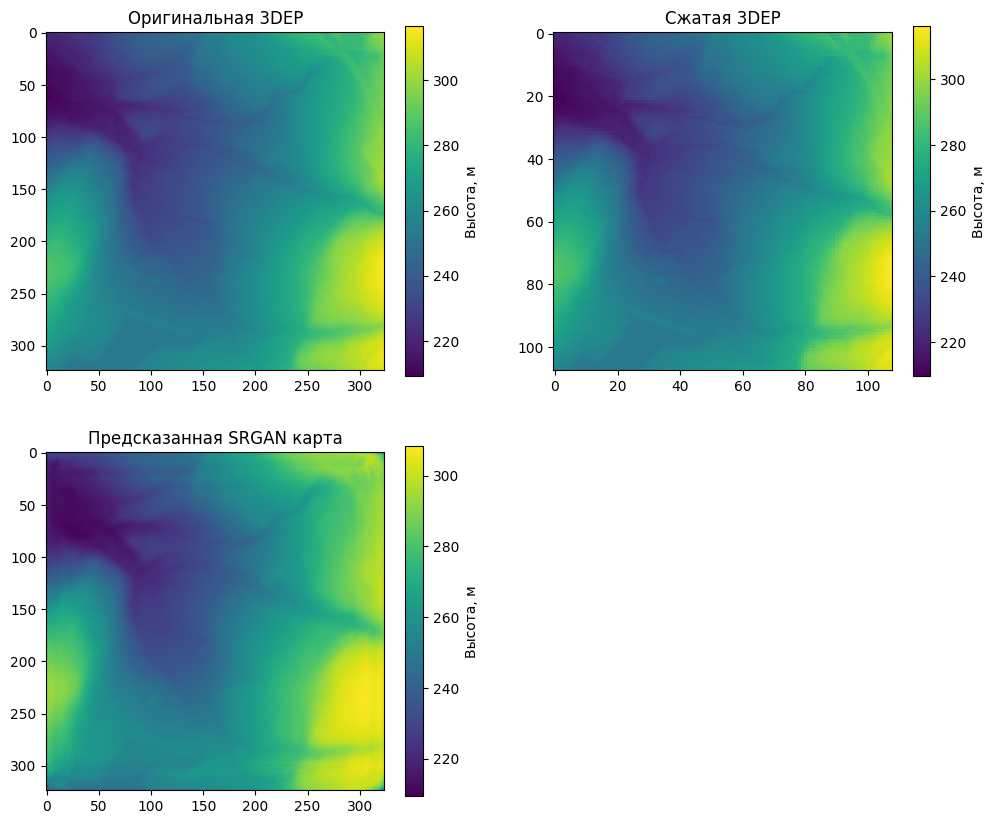

In [ ]:
train_dataset_mapped = train_data.map(lambda dep, dep_max, dep_min : tf.numpy_function(build_data, [dep, dep_max, dep_min], Tout=[tf.float32, tf.float32]))
for x in train_data.take(1):

  '''plt.figure()
  plt.imshow(x[0].numpy())
  plt.show()
  plt.imshow(x[1].numpy())
  plt.show()'''
  data = build_data(x[0], x[1], x[2])
  pred=SRResnet(data[0].numpy().reshape(1,108,108,1))
  '''plt.imshow(pred[0])
  plt.show()'''

  fig, ax = plt.subplots(figsize=(12, 10))
  ax.remove()
  ax = plt.subplot(2, 2, 1)
  plt.imshow(unnormalize_pixel(data[1].numpy(), x[1], x[2]))
  im = ax.get_images()[0]
  cb = fig.colorbar(im, ax=ax)
  cb.set_label('Высота, м')
  plt.title("Оригинальная 3DEP")
  ax = plt.subplot(2, 2, 2)
  plt.imshow(unnormalize_pixel(data[0].numpy(), x[1], x[2]))
  plt.title("Сжатая 3DEP")
  im = ax.get_images()[0]
  cb = fig.colorbar(im, ax=ax)
  cb.set_label('Высота, м')
  ax = plt.subplot(2, 2, 3)
  plt.imshow(unnormalize_pixel(pred[0], x[1], x[2]))
  plt.title("Предсказанная SRGAN карта")
  im = ax.get_images()[0]
  cb = fig.colorbar(im, ax=ax)
  cb.set_label('Высота, м')
  plt.show()


# Testing on Houdini data

In [ ]:
def read_map(path):
  tmp = np.array(tiff.imread(path))
  max = tmp.max()
  min = tmp.min()
  return (tmp-min)/(max-min), min, max

In [ ]:
SRResnet=tf.keras.models.load_model('SR-generator.keras',compile=False)
discriminator=tf.keras.models.load_model('SR-discriminator.keras',compile=False)

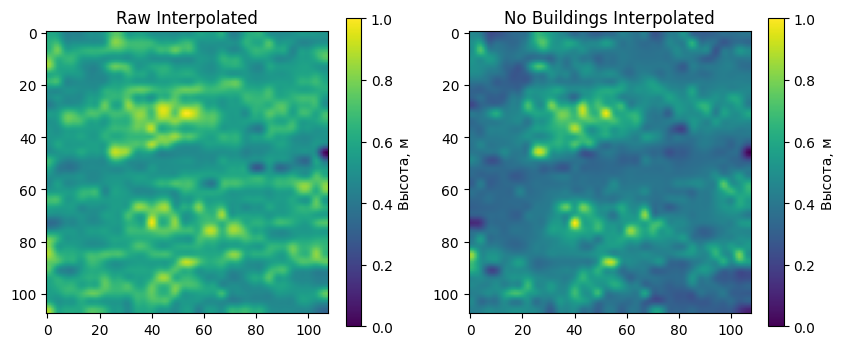

In [ ]:
glo_interp, glo_interp_min, glo_interp_max = read_map("TestGLOInterp.tif")
glo_no_buildings, glo_no_buildings_min, glo_no_buildings_max = read_map("TestOSMRemovedScaled.tif")

fig, ax = plt.subplots(figsize=(10, 4))
ax.remove()
ax = plt.subplot(1, 2, 1)
plt.imshow(glo_interp)
plt.title("Raw Interpolated")
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')

ax = plt.subplot(1, 2, 2)
plt.imshow(glo_no_buildings)
plt.title("No Buildings Interpolated")
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
plt.show()

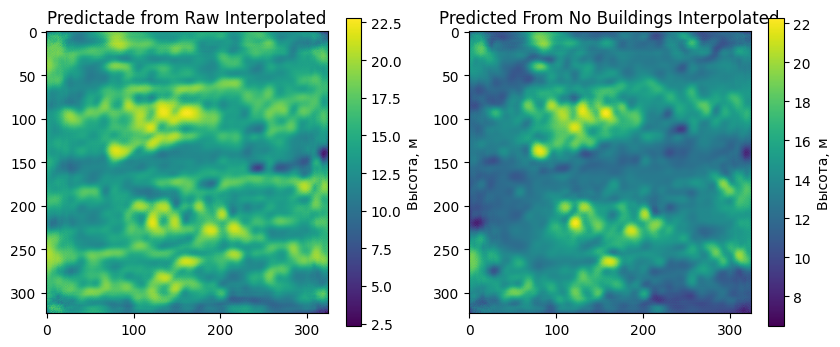

In [ ]:
predicted_raw = SRResnet(glo_interp.reshape(1,108,108,1))[0].numpy().reshape(324,324)
predicted_no_buildings = SRResnet(glo_no_buildings.reshape(1,108,108,1))[0].numpy().reshape(324,324)

predicted_raw = predicted_raw * (glo_interp_max - glo_interp_min) + glo_interp_min
predicted_no_buildings = predicted_no_buildings * (glo_no_buildings_max - glo_no_buildings_min) + glo_no_buildings_min

fig, ax = plt.subplots(figsize=(10, 4))
ax.remove()
ax = plt.subplot(1, 2, 1)
plt.imshow(predicted_raw)
plt.title("Predictade from Raw Interpolated")
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')

ax = plt.subplot(1, 2, 2)
plt.imshow(predicted_no_buildings)
plt.title("Predicted From No Buildings Interpolated")
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
plt.show()

In [ ]:
tiff.imwrite("TestPredictedRaw.tif", predicted_raw)
tiff.imwrite("TestPredictedNoBuildings.tif", predicted_no_buildings)